In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号



from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-30) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:,0:1];u2 = u[:,1:2];u3 = u[:,2:3]; #将u的第一列、第二列、第三列分别赋值给u1、u2、u3
        u4 = u[:,3:4];u5 = u[:,4:5];u6 = u[:,5:6]; #将u的第四列、第五列、第六列分别赋值给u4、u5、u6
        u7 = u[:,6:7];u8 = u[:,7:8];u9 = u[:,8:9]; #将u的第七列、第八列、第九列分别赋值给u7、u8、u9
        u10 = u[:,9:10];u11 = u[:,10:11];u12 = u[:,11:12] #将u的第十列、第十一列、第十二列分别赋值给u10、u11、u12
        

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_4 = torch.autograd.grad(
            u4, x,
            grad_outputs=torch.ones_like(u4),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_5 = torch.autograd.grad(
            u5, x,
            grad_outputs=torch.ones_like(u5),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_6 = torch.autograd.grad(
            u6, x,
            grad_outputs=torch.ones_like(u6),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_7 = torch.autograd.grad(
            u7, x,
            grad_outputs=torch.ones_like(u7),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_8 = torch.autograd.grad(
            u8, x,
            grad_outputs=torch.ones_like(u8),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_9 = torch.autograd.grad(
            u9, x,
            grad_outputs=torch.ones_like(u9),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_10 = torch.autograd.grad(
            u10, x,
            grad_outputs=torch.ones_like(u10),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_11 = torch.autograd.grad(
            u11, x,
            grad_outputs=torch.ones_like(u11),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_12 = torch.autograd.grad(
            u12, x,
            grad_outputs=torch.ones_like(u12),
            retain_graph=True,
            create_graph=True
        )[0]


        #归一化
        u_x_1 = u_x_1 / self.sigma_x;u_x_2 = u_x_2 / self.sigma_x;u_x_3 = u_x_3 / self.sigma_x
        u_x_4 = u_x_4 / self.sigma_x;u_x_5 = u_x_5 / self.sigma_x;u_x_6 = u_x_6 / self.sigma_x
        u_x_7 = u_x_7 / self.sigma_x;u_x_8 = u_x_8 / self.sigma_x;u_x_9 = u_x_9 / self.sigma_x
        u_x_10 = u_x_10 / self.sigma_x;u_x_11 = u_x_11 / self.sigma_x;u_x_12 = u_x_12 / self.sigma_x

        #指定状态转移概率
        #对于元素1
        Lambda2_1_1=7; Mu1_2_1=100;
        #对于元素2
        Lambda2_1_2=10; Mu1_2_2=80;
        #对于元素3
        Lambda3_2_3=10; Lambda3_1_3=0; Lambda2_1_3=7;
        Mu1_3_3=0; Mu1_2_3=120; Mu2_3_3=110
        #-----------------------------------------------
        #计算ODE项
        ode_1 = -(Lambda2_1_1+Lambda2_1_2+Lambda3_2_3)*u1+Mu1_2_1*u2+Mu1_2_2*u3+Mu2_3_3*u4;
        ode_2 = Lambda2_1_1*u1-(Mu1_2_1+Lambda2_1_2+Lambda3_2_3)*u2+Mu1_2_2*u5+Mu2_3_3*u6;
        ode_3 = Lambda2_1_2*u1-(Mu1_2_2+Lambda2_1_1+Lambda3_2_3)*u3+Mu1_2_1*u5+Mu2_3_3*u7;
        ode_4 = Lambda3_2_3*u1-(Mu2_3_3+Lambda2_1_1+Lambda2_1_2+Lambda2_1_3)*u4+Mu1_2_1*u6+Mu1_2_2*u7+Mu1_2_3*u8;
        ode_5 = Lambda2_1_2*u2+Lambda2_1_1*u3-(Mu1_2_2+Mu1_2_1+Lambda3_2_3)*u5+Mu2_3_3*u9;
        ode_6 = Lambda3_2_3*u2+Lambda2_1_1*u4-(Mu2_3_3+Mu1_2_1+Lambda2_1_2+Lambda2_1_3)*u6+Mu1_2_2*u9+Mu1_2_3*u10;
        ode_7 = Lambda3_2_3*u3+Lambda2_1_2*u4-(Mu2_3_3+Mu1_2_2+Lambda2_1_1+Lambda2_1_3)*u7+Mu1_2_1*u9+Mu1_2_3*u11;
        ode_8 = Lambda2_1_3*u4-(Mu1_2_3+Lambda2_1_1+Lambda2_1_2)*u8+Mu1_2_1*u10+Mu1_2_2*u11;
        ode_9 = Lambda3_2_3*u5+Lambda2_1_2*u6+Lambda2_1_1*u7-(Mu2_3_3+Mu1_2_2+Mu1_2_1+Lambda2_1_3)*u9+Mu1_2_3*u12;
        ode_10 = Lambda2_1_3*u6+Lambda2_1_1*u8-(Mu1_2_3+Mu1_2_1+Lambda2_1_2)*u10+Mu1_2_2*u12;
        ode_11 = Lambda2_1_3*u7+Lambda2_1_2*u8-(Mu1_2_3+Mu1_2_2+Lambda2_1_1)*u11+Mu1_2_1*u12;
        ode_12 = Lambda2_1_3*u9+Lambda2_1_2*u10+Lambda2_1_1*u11-(Mu1_2_3+Mu1_2_2+Mu1_2_1)*u12

        
        #计算残差
        residual_1 = u_x_1-ode_1; residual_2 = u_x_2-ode_2; residual_3 = u_x_3-ode_3
        residual_4 = u_x_4-ode_4; residual_5 = u_x_5-ode_5; residual_6 = u_x_6-ode_6;
        residual_7 = u_x_7-ode_7; residual_8 = u_x_8-ode_8; residual_9 = u_x_9-ode_9;
        residual_10 = u_x_10-ode_10; residual_11 = u_x_11-ode_11; residual_12 = u_x_12-ode_12

        #计算损失函数
        loss_1 = torch.mean(residual_1 ** 2); loss_2 = torch.mean(residual_2 ** 2); loss_3 = torch.mean(residual_3 ** 2);
        loss_4 = torch.mean(residual_4 ** 2); loss_5 = torch.mean(residual_5 ** 2); loss_6 = torch.mean(residual_6 ** 2);
        loss_7 = torch.mean(residual_7 ** 2); loss_8 = torch.mean(residual_8 ** 2); loss_9 = torch.mean(residual_9 ** 2);
        loss_10 = torch.mean(residual_10 ** 2); loss_11 = torch.mean(residual_11 ** 2); loss_12 = torch.mean(residual_12 ** 2)


        loss_f = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7 + loss_8 + loss_9 + loss_10 + loss_11 + loss_12
        return loss_f, residual_1+residual_2+residual_3+residual_4+residual_5+residual_6+residual_7+residual_8+residual_9+residual_10+residual_11+residual_12
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
def get_system_performance(df):
    
    df['system_3.5'] = df['state_1']
    df['system_2.0'] = df['state_2']
    df['system_1.8'] = df['state_4'] + df['state_6']
    df['system_1.5'] = df['state_3'] + df['state_7']
    df['system_0'] = df['state_5'] + df['state_8'] + df['state_9'] + df['state_10'] + df['state_11'] + df['state_12']
    
    return df

state_column_names = ['state_1', 'state_2', 'state_3', 'state_4', 'state_5', 'state_6', 'state_7',
                      'state_8', 'state_9', 'state_10', 'state_11', 'state_12']

In [8]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0     

eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')

N_u = 1
N_f = 1500

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 12]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([0.2])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0,0,0,0,0,0,0,0,0,0]])          # 初始真实状态


error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储混沌值
residuals = [] #创建一个空列表，用于存储残差值

i = 0


# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    # X_f = lb + (ub - lb) * lhs(1, N_f) #生成N_f个配位点，均匀分布在[0,1]之间
    X_f = np.linspace(lb, ub, N_f)     # 配位点位置
    nIter = 40000

    #创建PINN模型并输入各种参数     
    # model = PhysicsInformedNN(X_u, u, X_f, layers, lb, ub, X_star, u_star)
    model = PhysicsInformedNN(X_u, u, X_f, layers, lb, ub)
    
    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))


    # up = 80000
    n_star = 500+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
    y_pred = get_system_performance(y_pred_df)
    # y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
    y_star = eigenvector_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:, -5:],2)/np.linalg.norm(y_star.iloc[:, -5:],2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]))
    mse = np.mean((y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:,-5:],2)/np.linalg.norm(y_star.iloc[:,-5:],2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)





Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 4/40000 [00:00<16:57, 39.32it/s]

Adam:   0%|          | 26/40000 [00:00<04:36, 144.59it/s]

Adam:   0%|          | 50/40000 [00:00<03:34, 186.37it/s]

Adam:   0%|          | 74/40000 [00:00<03:15, 204.58it/s]

Adam:   0%|          | 96/40000 [00:00<03:12, 207.70it/s]

Adam:   0%|          | 117/40000 [00:00<03:20, 198.64it/s]

Adam:   0%|          | 137/40000 [00:00<03:21, 198.06it/s]

Adam:   0%|          | 161/40000 [00:00<03:11, 208.52it/s]

Adam:   0%|          | 182/40000 [00:00<03:12, 206.51it/s]

Adam:   1%|          | 205/40000 [00:01<03:08, 211.12it/s]

Adam:   1%|          | 227/40000 [00:01<03:12, 206.82it/s]

Adam:   1%|          | 251/40000 [00:01<03:05, 213.80it/s]

Adam:   1%|          | 273/40000 [00:01<03:05, 213.96it/s]

Adam:   1%|          | 295/40000 [00:01<03:07, 211.62it/s]

Adam:   1%|          | 317/40000 [00:01<03:10, 208.08it/s]

Adam:   1%|          | 338/40000 [00:01<03:26, 191.62it/s]

Adam:   1%|          | 359/40000 [00:01<03:22, 195.48it/s]

Adam:   1%|          | 383/40000 [00:01<03:11, 207.00it/s]

Adam:   1%|          | 404/40000 [00:02<03:16, 201.73it/s]

Adam:   1%|          | 428/40000 [00:02<03:07, 210.61it/s]

Adam:   1%|          | 450/40000 [00:02<03:12, 205.49it/s]

Adam:   1%|          | 471/40000 [00:02<03:13, 204.46it/s]

Adam:   1%|          | 492/40000 [00:02<03:16, 201.09it/s]

Adam:   1%|▏         | 513/40000 [00:02<03:17, 199.96it/s]

Adam:   1%|▏         | 534/40000 [00:02<03:20, 196.99it/s]

Adam:   1%|▏         | 554/40000 [00:02<03:27, 190.20it/s]

Adam:   1%|▏         | 578/40000 [00:02<03:15, 201.96it/s]

Adam:   2%|▏         | 602/40000 [00:02<03:07, 210.10it/s]

Adam:   2%|▏         | 624/40000 [00:03<03:12, 205.06it/s]

Adam:   2%|▏         | 647/40000 [00:03<03:07, 209.75it/s]

Adam:   2%|▏         | 671/40000 [00:03<03:01, 216.38it/s]

Adam:   2%|▏         | 694/40000 [00:03<02:59, 218.57it/s]

Adam:   2%|▏         | 716/40000 [00:03<03:00, 217.91it/s]

Adam:   2%|▏         | 740/40000 [00:03<02:55, 223.43it/s]

Adam:   2%|▏         | 763/40000 [00:03<02:56, 221.68it/s]

Adam:   2%|▏         | 786/40000 [00:03<02:59, 218.83it/s]

Adam:   2%|▏         | 810/40000 [00:03<02:54, 223.96it/s]

Adam:   2%|▏         | 833/40000 [00:04<02:55, 223.37it/s]

Adam:   2%|▏         | 856/40000 [00:04<02:58, 219.91it/s]

Adam:   2%|▏         | 879/40000 [00:04<02:57, 219.91it/s]

Adam:   2%|▏         | 902/40000 [00:04<02:57, 220.65it/s]

Adam:   2%|▏         | 925/40000 [00:04<03:01, 215.60it/s]

Adam:   2%|▏         | 947/40000 [00:04<03:04, 211.44it/s]

Adam:   2%|▏         | 970/40000 [00:04<03:01, 215.50it/s]

Adam:   2%|▏         | 994/40000 [00:04<02:56, 220.66it/s]

Adam:   3%|▎         | 1017/40000 [00:04<03:03, 212.00it/s]

Adam:   3%|▎         | 1039/40000 [00:05<03:05, 210.16it/s]

Adam:   3%|▎         | 1061/40000 [00:05<03:02, 212.81it/s]

Adam:   3%|▎         | 1085/40000 [00:05<02:57, 219.68it/s]

Adam:   3%|▎         | 1109/40000 [00:05<02:54, 223.32it/s]

Adam:   3%|▎         | 1132/40000 [00:05<02:54, 222.47it/s]

Adam:   3%|▎         | 1155/40000 [00:05<02:59, 215.88it/s]

Adam:   3%|▎         | 1177/40000 [00:05<03:05, 209.29it/s]

Adam:   3%|▎         | 1198/40000 [00:05<03:16, 197.69it/s]

Adam:   3%|▎         | 1218/40000 [00:05<03:19, 194.80it/s]

Adam:   3%|▎         | 1238/40000 [00:05<03:20, 193.72it/s]

Adam:   3%|▎         | 1260/40000 [00:06<03:13, 200.66it/s]

Adam:   3%|▎         | 1282/40000 [00:06<03:09, 203.81it/s]

Adam:   3%|▎         | 1306/40000 [00:06<03:01, 213.30it/s]

Adam:   3%|▎         | 1328/40000 [00:06<03:01, 212.84it/s]

Adam:   3%|▎         | 1351/40000 [00:06<02:57, 217.67it/s]

Adam:   3%|▎         | 1373/40000 [00:06<03:08, 204.85it/s]

Adam:   3%|▎         | 1394/40000 [00:06<03:25, 187.45it/s]

Adam:   4%|▎         | 1415/40000 [00:06<03:20, 192.55it/s]

Adam:   4%|▎         | 1439/40000 [00:06<03:09, 203.64it/s]

Adam:   4%|▎         | 1463/40000 [00:07<03:01, 212.25it/s]

Adam:   4%|▎         | 1485/40000 [00:07<02:59, 214.37it/s]

Adam:   4%|▍         | 1508/40000 [00:07<02:56, 217.97it/s]

Adam:   4%|▍         | 1531/40000 [00:07<02:55, 219.12it/s]

Adam:   4%|▍         | 1554/40000 [00:07<02:56, 217.77it/s]

Adam:   4%|▍         | 1576/40000 [00:07<03:05, 207.39it/s]

Adam:   4%|▍         | 1597/40000 [00:07<03:05, 207.44it/s]

Adam:   4%|▍         | 1619/40000 [00:07<03:02, 210.15it/s]

Adam:   4%|▍         | 1642/40000 [00:07<02:57, 215.90it/s]

Adam:   4%|▍         | 1665/40000 [00:07<02:59, 213.70it/s]

Adam:   4%|▍         | 1687/40000 [00:08<03:11, 200.58it/s]

Adam:   4%|▍         | 1710/40000 [00:08<03:06, 205.82it/s]

Adam:   4%|▍         | 1732/40000 [00:08<03:04, 207.74it/s]

Adam:   4%|▍         | 1753/40000 [00:08<03:08, 202.79it/s]

Adam:   4%|▍         | 1776/40000 [00:08<03:02, 209.82it/s]

Adam:   4%|▍         | 1798/40000 [00:08<03:03, 208.37it/s]

Adam:   5%|▍         | 1822/40000 [00:08<02:56, 216.64it/s]

Adam:   5%|▍         | 1844/40000 [00:08<02:57, 215.31it/s]

Adam:   5%|▍         | 1867/40000 [00:08<02:56, 216.23it/s]

Adam:   5%|▍         | 1889/40000 [00:09<02:55, 216.87it/s]

Adam:   5%|▍         | 1911/40000 [00:09<03:22, 188.12it/s]

Adam:   5%|▍         | 1933/40000 [00:09<03:15, 194.59it/s]

Adam:   5%|▍         | 1954/40000 [00:09<03:13, 197.11it/s]

Adam:   5%|▍         | 1975/40000 [00:09<03:11, 199.00it/s]

Adam:   5%|▍         | 1998/40000 [00:09<03:03, 206.96it/s]

Adam:   5%|▌         | 2022/40000 [00:09<02:55, 215.86it/s]

Adam:   5%|▌         | 2045/40000 [00:09<02:53, 218.81it/s]

Adam:   5%|▌         | 2068/40000 [00:09<02:53, 219.15it/s]

Adam:   5%|▌         | 2092/40000 [00:10<02:49, 224.01it/s]

Adam:   5%|▌         | 2115/40000 [00:10<02:47, 225.59it/s]

Adam:   5%|▌         | 2138/40000 [00:10<02:48, 224.62it/s]

Adam:   5%|▌         | 2162/40000 [00:10<02:46, 227.74it/s]

Adam:   5%|▌         | 2185/40000 [00:10<02:47, 226.31it/s]

Adam:   6%|▌         | 2208/40000 [00:10<03:03, 205.62it/s]

Adam:   6%|▌         | 2229/40000 [00:10<03:02, 206.49it/s]

Adam:   6%|▌         | 2250/40000 [00:10<03:02, 206.42it/s]

Adam:   6%|▌         | 2271/40000 [00:10<03:08, 200.46it/s]

Adam:   6%|▌         | 2292/40000 [00:10<03:08, 200.43it/s]

Adam:   6%|▌         | 2316/40000 [00:11<02:58, 210.97it/s]

Adam:   6%|▌         | 2338/40000 [00:11<03:07, 201.07it/s]

Adam:   6%|▌         | 2359/40000 [00:11<03:04, 203.47it/s]

Adam:   6%|▌         | 2383/40000 [00:11<02:57, 212.06it/s]

Adam:   6%|▌         | 2405/40000 [00:11<03:00, 208.74it/s]

Adam:   6%|▌         | 2427/40000 [00:11<02:57, 211.22it/s]

Adam:   6%|▌         | 2449/40000 [00:11<03:02, 206.13it/s]

Adam:   6%|▌         | 2471/40000 [00:11<03:00, 208.28it/s]

Adam:   6%|▌         | 2492/40000 [00:11<03:02, 205.22it/s]

Adam:   6%|▋         | 2514/40000 [00:12<02:59, 208.76it/s]

Adam:   6%|▋         | 2535/40000 [00:12<03:00, 208.09it/s]

Adam:   6%|▋         | 2559/40000 [00:12<02:53, 215.29it/s]

Adam:   6%|▋         | 2581/40000 [00:12<03:03, 203.53it/s]

Adam:   7%|▋         | 2603/40000 [00:12<03:00, 206.90it/s]

Adam:   7%|▋         | 2624/40000 [00:12<03:21, 185.86it/s]

Adam:   7%|▋         | 2648/40000 [00:12<03:06, 199.78it/s]

Adam:   7%|▋         | 2669/40000 [00:12<03:09, 197.28it/s]

Adam:   7%|▋         | 2690/40000 [00:12<03:21, 184.81it/s]

Adam:   7%|▋         | 2710/40000 [00:13<03:19, 187.12it/s]

Adam:   7%|▋         | 2729/40000 [00:13<03:23, 183.48it/s]

Adam:   7%|▋         | 2751/40000 [00:13<03:16, 189.42it/s]

Adam:   7%|▋         | 2771/40000 [00:13<03:36, 171.62it/s]

Adam:   7%|▋         | 2794/40000 [00:13<03:20, 185.92it/s]

Adam:   7%|▋         | 2814/40000 [00:13<03:26, 180.29it/s]

Adam:   7%|▋         | 2833/40000 [00:13<03:38, 170.28it/s]

Adam:   7%|▋         | 2856/40000 [00:13<03:21, 184.26it/s]

Adam:   7%|▋         | 2876/40000 [00:13<03:17, 187.81it/s]

Adam:   7%|▋         | 2896/40000 [00:14<03:25, 180.61it/s]

Adam:   7%|▋         | 2918/40000 [00:14<03:16, 188.92it/s]

Adam:   7%|▋         | 2938/40000 [00:14<03:13, 191.98it/s]

Adam:   7%|▋         | 2958/40000 [00:14<03:13, 191.00it/s]

Adam:   7%|▋         | 2978/40000 [00:14<03:30, 175.83it/s]

Adam:   7%|▋         | 2996/40000 [00:14<03:49, 161.09it/s]

Adam:   8%|▊         | 3018/40000 [00:14<03:31, 174.74it/s]

Adam:   8%|▊         | 3038/40000 [00:14<03:24, 180.98it/s]

Adam:   8%|▊         | 3057/40000 [00:15<03:37, 169.53it/s]

Adam:   8%|▊         | 3077/40000 [00:15<03:28, 176.70it/s]

Adam:   8%|▊         | 3096/40000 [00:15<03:37, 169.50it/s]

Adam:   8%|▊         | 3118/40000 [00:15<03:23, 180.95it/s]

Adam:   8%|▊         | 3137/40000 [00:15<03:25, 179.08it/s]

Adam:   8%|▊         | 3156/40000 [00:15<03:28, 176.84it/s]

Adam:   8%|▊         | 3174/40000 [00:15<03:32, 173.54it/s]

Adam:   8%|▊         | 3194/40000 [00:15<03:24, 180.16it/s]

Adam:   8%|▊         | 3213/40000 [00:15<03:23, 181.01it/s]

Adam:   8%|▊         | 3234/40000 [00:15<03:15, 188.02it/s]

Adam:   8%|▊         | 3253/40000 [00:16<03:17, 186.41it/s]

Adam:   8%|▊         | 3272/40000 [00:16<03:40, 166.25it/s]

Adam:   8%|▊         | 3293/40000 [00:16<03:28, 176.03it/s]

Adam:   8%|▊         | 3311/40000 [00:16<03:39, 166.89it/s]

Adam:   8%|▊         | 3329/40000 [00:16<03:35, 169.92it/s]

Adam:   8%|▊         | 3351/40000 [00:16<03:19, 183.39it/s]

Adam:   8%|▊         | 3370/40000 [00:16<03:39, 167.15it/s]

Adam:   8%|▊         | 3388/40000 [00:16<03:40, 166.10it/s]

Adam:   9%|▊         | 3409/40000 [00:17<03:27, 175.95it/s]

Adam:   9%|▊         | 3427/40000 [00:17<03:43, 163.40it/s]

Adam:   9%|▊         | 3447/40000 [00:17<03:33, 171.40it/s]

Adam:   9%|▊         | 3469/40000 [00:17<03:20, 182.08it/s]

Adam:   9%|▊         | 3488/40000 [00:17<03:23, 179.83it/s]

Adam:   9%|▉         | 3507/40000 [00:17<03:19, 182.52it/s]

Adam:   9%|▉         | 3526/40000 [00:17<03:18, 184.06it/s]

Adam:   9%|▉         | 3545/40000 [00:17<03:25, 177.64it/s]

Adam:   9%|▉         | 3564/40000 [00:17<03:22, 179.72it/s]

Adam:   9%|▉         | 3584/40000 [00:17<03:17, 183.97it/s]

Adam:   9%|▉         | 3607/40000 [00:18<03:06, 195.51it/s]

Adam:   9%|▉         | 3627/40000 [00:18<03:31, 172.30it/s]

Adam:   9%|▉         | 3645/40000 [00:18<03:46, 160.35it/s]

Adam:   9%|▉         | 3664/40000 [00:18<03:36, 168.00it/s]

Adam:   9%|▉         | 3682/40000 [00:18<03:34, 169.59it/s]

Adam:   9%|▉         | 3704/40000 [00:18<03:18, 183.13it/s]

Adam:   9%|▉         | 3723/40000 [00:18<03:39, 165.35it/s]

Adam:   9%|▉         | 3741/40000 [00:18<03:38, 165.67it/s]

Adam:   9%|▉         | 3758/40000 [00:19<03:43, 162.26it/s]

Adam:   9%|▉         | 3776/40000 [00:19<03:38, 165.63it/s]

Adam:   9%|▉         | 3793/40000 [00:19<03:39, 164.91it/s]

Adam:  10%|▉         | 3810/40000 [00:19<03:43, 162.02it/s]

Adam:  10%|▉         | 3827/40000 [00:19<03:42, 162.88it/s]

Adam:  10%|▉         | 3844/40000 [00:19<03:55, 153.51it/s]

Adam:  10%|▉         | 3862/40000 [00:19<03:46, 159.73it/s]

Adam:  10%|▉         | 3879/40000 [00:19<03:46, 159.21it/s]

Adam:  10%|▉         | 3896/40000 [00:19<03:57, 151.79it/s]

Adam:  10%|▉         | 3916/40000 [00:20<03:39, 164.67it/s]

Adam:  10%|▉         | 3933/40000 [00:20<03:44, 160.92it/s]

Adam:  10%|▉         | 3950/40000 [00:20<03:48, 157.70it/s]

Adam:  10%|▉         | 3969/40000 [00:20<03:39, 164.37it/s]

Adam:  10%|▉         | 3987/40000 [00:20<03:36, 166.22it/s]

Adam:  10%|█         | 4004/40000 [00:20<03:43, 161.39it/s]

Adam:  10%|█         | 4021/40000 [00:20<03:40, 163.20it/s]

Adam:  10%|█         | 4041/40000 [00:20<03:29, 171.26it/s]

Adam:  10%|█         | 4062/40000 [00:20<03:18, 180.83it/s]

Adam:  10%|█         | 4082/40000 [00:20<03:13, 185.89it/s]

Adam:  10%|█         | 4101/40000 [00:21<03:12, 186.77it/s]

Adam:  10%|█         | 4121/40000 [00:21<03:10, 188.82it/s]

Adam:  10%|█         | 4140/40000 [00:21<03:24, 175.16it/s]

Adam:  10%|█         | 4158/40000 [00:21<03:29, 171.27it/s]

Adam:  10%|█         | 4176/40000 [00:21<03:30, 170.52it/s]

Adam:  10%|█         | 4196/40000 [00:21<03:21, 177.53it/s]

Adam:  11%|█         | 4216/40000 [00:21<03:17, 180.98it/s]

Adam:  11%|█         | 4235/40000 [00:21<03:16, 181.64it/s]

Adam:  11%|█         | 4255/40000 [00:21<03:16, 182.23it/s]

Adam:  11%|█         | 4277/40000 [00:22<03:06, 191.55it/s]

Adam:  11%|█         | 4300/40000 [00:22<02:56, 202.21it/s]

Adam:  11%|█         | 4321/40000 [00:22<02:59, 198.49it/s]

Adam:  11%|█         | 4341/40000 [00:22<03:15, 182.47it/s]

Adam:  11%|█         | 4363/40000 [00:22<03:06, 190.63it/s]

Adam:  11%|█         | 4383/40000 [00:22<03:17, 180.16it/s]

Adam:  11%|█         | 4402/40000 [00:22<03:23, 174.80it/s]

Adam:  11%|█         | 4420/40000 [00:22<03:43, 159.24it/s]

Adam:  11%|█         | 4438/40000 [00:22<03:37, 163.59it/s]

Adam:  11%|█         | 4458/40000 [00:23<03:26, 171.89it/s]

Adam:  11%|█         | 4478/40000 [00:23<03:19, 178.46it/s]

Adam:  11%|█         | 4497/40000 [00:23<03:33, 166.16it/s]

Adam:  11%|█▏        | 4514/40000 [00:23<03:32, 167.10it/s]

Adam:  11%|█▏        | 4536/40000 [00:23<03:17, 179.34it/s]

Adam:  11%|█▏        | 4555/40000 [00:23<03:28, 169.93it/s]

Adam:  11%|█▏        | 4573/40000 [00:23<03:29, 169.16it/s]

Adam:  11%|█▏        | 4591/40000 [00:23<03:38, 162.06it/s]

Adam:  12%|█▏        | 4608/40000 [00:23<03:42, 159.19it/s]

Adam:  12%|█▏        | 4629/40000 [00:24<03:26, 171.65it/s]

Adam:  12%|█▏        | 4649/40000 [00:24<03:19, 177.24it/s]

Adam:  12%|█▏        | 4667/40000 [00:24<03:18, 177.93it/s]

Adam:  12%|█▏        | 4685/40000 [00:24<03:21, 175.45it/s]

Adam:  12%|█▏        | 4703/40000 [00:24<03:37, 162.44it/s]

Adam:  12%|█▏        | 4720/40000 [00:24<03:40, 160.00it/s]

Adam:  12%|█▏        | 4737/40000 [00:24<04:03, 145.06it/s]

Adam:  12%|█▏        | 4754/40000 [00:24<03:54, 150.00it/s]

Adam:  12%|█▏        | 4770/40000 [00:25<04:07, 142.07it/s]

Adam:  12%|█▏        | 4785/40000 [00:25<04:25, 132.72it/s]

Adam:  12%|█▏        | 4799/40000 [00:25<04:24, 133.28it/s]

Adam:  12%|█▏        | 4813/40000 [00:25<04:25, 132.49it/s]

Adam:  12%|█▏        | 4830/40000 [00:25<04:10, 140.35it/s]

Adam:  12%|█▏        | 4849/40000 [00:25<03:51, 151.62it/s]

Adam:  12%|█▏        | 4865/40000 [00:25<04:30, 129.90it/s]

Adam:  12%|█▏        | 4882/40000 [00:25<04:12, 138.91it/s]

Adam:  12%|█▏        | 4897/40000 [00:25<04:33, 128.40it/s]

Adam:  12%|█▏        | 4916/40000 [00:26<04:05, 142.79it/s]

Adam:  12%|█▏        | 4933/40000 [00:26<03:57, 147.90it/s]

Adam:  12%|█▏        | 4949/40000 [00:26<04:13, 138.07it/s]

Adam:  12%|█▏        | 4964/40000 [00:26<04:12, 138.69it/s]

Adam:  12%|█▏        | 4980/40000 [00:26<04:03, 144.04it/s]

Adam:  12%|█▏        | 4998/40000 [00:26<03:50, 151.56it/s]

Adam:  13%|█▎        | 5015/40000 [00:26<03:45, 155.14it/s]

Adam:  13%|█▎        | 5031/40000 [00:26<04:13, 137.74it/s]

Adam:  13%|█▎        | 5046/40000 [00:27<04:17, 135.62it/s]

Adam:  13%|█▎        | 5060/40000 [00:27<04:44, 122.65it/s]

Adam:  13%|█▎        | 5073/40000 [00:27<04:41, 124.14it/s]

Adam:  13%|█▎        | 5087/40000 [00:27<04:36, 126.27it/s]

Adam:  13%|█▎        | 5106/40000 [00:27<04:08, 140.64it/s]

Adam:  13%|█▎        | 5124/40000 [00:27<03:54, 148.98it/s]

Adam:  13%|█▎        | 5142/40000 [00:27<03:42, 156.93it/s]

Adam:  13%|█▎        | 5158/40000 [00:27<03:51, 150.78it/s]

Adam:  13%|█▎        | 5175/40000 [00:27<03:43, 155.96it/s]

Adam:  13%|█▎        | 5194/40000 [00:27<03:31, 164.46it/s]

Adam:  13%|█▎        | 5216/40000 [00:28<03:14, 178.44it/s]

Adam:  13%|█▎        | 5236/40000 [00:28<03:08, 184.46it/s]

Adam:  13%|█▎        | 5255/40000 [00:28<03:21, 172.81it/s]

Adam:  13%|█▎        | 5273/40000 [00:28<03:21, 172.08it/s]

Adam:  13%|█▎        | 5294/40000 [00:28<03:10, 181.74it/s]

Adam:  13%|█▎        | 5313/40000 [00:28<03:18, 174.68it/s]

Adam:  13%|█▎        | 5331/40000 [00:28<03:36, 159.78it/s]

Adam:  13%|█▎        | 5348/40000 [00:28<03:46, 152.83it/s]

Adam:  13%|█▎        | 5368/40000 [00:29<03:30, 164.72it/s]

Adam:  13%|█▎        | 5385/40000 [00:29<03:28, 165.89it/s]

Adam:  14%|█▎        | 5402/40000 [00:29<03:58, 144.84it/s]

Adam:  14%|█▎        | 5418/40000 [00:29<04:08, 139.04it/s]

Adam:  14%|█▎        | 5433/40000 [00:29<04:15, 135.20it/s]

Adam:  14%|█▎        | 5452/40000 [00:29<03:52, 148.73it/s]

Adam:  14%|█▎        | 5468/40000 [00:29<03:51, 149.01it/s]

Adam:  14%|█▎        | 5484/40000 [00:29<04:01, 142.87it/s]

Adam:  14%|█▎        | 5499/40000 [00:29<04:08, 138.69it/s]

Adam:  14%|█▍        | 5520/40000 [00:30<03:38, 157.49it/s]

Adam:  14%|█▍        | 5539/40000 [00:30<03:29, 164.32it/s]

Adam:  14%|█▍        | 5556/40000 [00:30<03:32, 162.12it/s]

Adam:  14%|█▍        | 5573/40000 [00:30<03:42, 155.06it/s]

Adam:  14%|█▍        | 5592/40000 [00:30<03:29, 164.21it/s]

Adam:  14%|█▍        | 5609/40000 [00:30<03:52, 147.67it/s]

Adam:  14%|█▍        | 5625/40000 [00:30<04:00, 142.68it/s]

Adam:  14%|█▍        | 5647/40000 [00:30<03:31, 162.76it/s]

Adam:  14%|█▍        | 5666/40000 [00:30<03:23, 168.42it/s]

Adam:  14%|█▍        | 5686/40000 [00:31<03:14, 176.68it/s]

Adam:  14%|█▍        | 5704/40000 [00:31<03:18, 172.82it/s]

Adam:  14%|█▍        | 5724/40000 [00:31<03:11, 178.80it/s]

Adam:  14%|█▍        | 5743/40000 [00:31<03:10, 179.48it/s]

Adam:  14%|█▍        | 5762/40000 [00:31<03:30, 162.71it/s]

Adam:  14%|█▍        | 5779/40000 [00:31<03:40, 155.08it/s]

Adam:  14%|█▍        | 5797/40000 [00:31<03:32, 160.85it/s]

Adam:  15%|█▍        | 5814/40000 [00:31<03:51, 147.43it/s]

Adam:  15%|█▍        | 5833/40000 [00:32<03:38, 156.65it/s]

Adam:  15%|█▍        | 5850/40000 [00:32<03:37, 157.37it/s]

Adam:  15%|█▍        | 5867/40000 [00:32<03:34, 159.33it/s]

Adam:  15%|█▍        | 5884/40000 [00:32<03:49, 148.75it/s]

Adam:  15%|█▍        | 5900/40000 [00:32<03:45, 151.40it/s]

Adam:  15%|█▍        | 5916/40000 [00:32<03:41, 153.64it/s]

Adam:  15%|█▍        | 5932/40000 [00:32<03:42, 152.96it/s]

Adam:  15%|█▍        | 5948/40000 [00:32<03:42, 152.79it/s]

Adam:  15%|█▍        | 5964/40000 [00:32<03:51, 146.83it/s]

Adam:  15%|█▍        | 5979/40000 [00:32<03:57, 143.53it/s]

Adam:  15%|█▍        | 5994/40000 [00:33<04:19, 131.27it/s]

Adam:  15%|█▌        | 6011/40000 [00:33<04:01, 140.59it/s]

Adam:  15%|█▌        | 6026/40000 [00:33<04:12, 134.48it/s]

Adam:  15%|█▌        | 6042/40000 [00:33<04:02, 140.13it/s]

Adam:  15%|█▌        | 6057/40000 [00:33<04:09, 136.20it/s]

Adam:  15%|█▌        | 6078/40000 [00:33<03:38, 155.53it/s]

Adam:  15%|█▌        | 6094/40000 [00:33<03:49, 147.66it/s]

Adam:  15%|█▌        | 6110/40000 [00:33<03:48, 148.31it/s]

Adam:  15%|█▌        | 6126/40000 [00:34<03:50, 146.85it/s]

Adam:  15%|█▌        | 6146/40000 [00:34<03:32, 159.07it/s]

Adam:  15%|█▌        | 6163/40000 [00:34<03:38, 154.52it/s]

Adam:  15%|█▌        | 6182/40000 [00:34<03:28, 162.58it/s]

Adam:  15%|█▌        | 6199/40000 [00:34<03:58, 141.98it/s]

Adam:  16%|█▌        | 6214/40000 [00:34<03:55, 143.43it/s]

Adam:  16%|█▌        | 6229/40000 [00:34<04:01, 140.02it/s]

Adam:  16%|█▌        | 6247/40000 [00:34<03:46, 149.06it/s]

Adam:  16%|█▌        | 6263/40000 [00:34<03:54, 143.60it/s]

Adam:  16%|█▌        | 6278/40000 [00:35<04:31, 124.22it/s]

Adam:  16%|█▌        | 6291/40000 [00:35<04:34, 122.95it/s]

Adam:  16%|█▌        | 6311/40000 [00:35<03:58, 141.36it/s]

Adam:  16%|█▌        | 6326/40000 [00:35<03:55, 142.82it/s]

Adam:  16%|█▌        | 6341/40000 [00:35<04:14, 132.17it/s]

Adam:  16%|█▌        | 6359/40000 [00:35<03:57, 141.75it/s]

Adam:  16%|█▌        | 6374/40000 [00:35<04:00, 139.58it/s]

Adam:  16%|█▌        | 6390/40000 [00:35<03:56, 142.09it/s]

Adam:  16%|█▌        | 6411/40000 [00:35<03:31, 158.98it/s]

Adam:  16%|█▌        | 6431/40000 [00:36<03:18, 169.53it/s]

Adam:  16%|█▌        | 6451/40000 [00:36<03:10, 176.46it/s]

Adam:  16%|█▌        | 6469/40000 [00:36<03:17, 169.99it/s]

Adam:  16%|█▌        | 6487/40000 [00:36<03:16, 170.83it/s]

Adam:  16%|█▋        | 6505/40000 [00:36<03:19, 167.95it/s]

Adam:  16%|█▋        | 6522/40000 [00:36<03:23, 164.83it/s]

Adam:  16%|█▋        | 6544/40000 [00:36<03:06, 179.51it/s]

Adam:  16%|█▋        | 6565/40000 [00:36<02:58, 187.10it/s]

Adam:  16%|█▋        | 6587/40000 [00:36<02:52, 193.21it/s]

Adam:  17%|█▋        | 6607/40000 [00:37<03:01, 184.47it/s]

Adam:  17%|█▋        | 6626/40000 [00:37<03:12, 173.55it/s]

Adam:  17%|█▋        | 6644/40000 [00:37<03:16, 169.68it/s]

Adam:  17%|█▋        | 6662/40000 [00:37<03:30, 158.38it/s]

Adam:  17%|█▋        | 6679/40000 [00:37<03:38, 152.49it/s]

Adam:  17%|█▋        | 6699/40000 [00:37<03:22, 164.33it/s]

Adam:  17%|█▋        | 6716/40000 [00:37<03:55, 141.28it/s]

Adam:  17%|█▋        | 6733/40000 [00:37<03:47, 146.44it/s]

Adam:  17%|█▋        | 6751/40000 [00:38<03:37, 153.20it/s]

Adam:  17%|█▋        | 6768/40000 [00:38<03:32, 156.75it/s]

Adam:  17%|█▋        | 6785/40000 [00:38<03:30, 157.62it/s]

Adam:  17%|█▋        | 6802/40000 [00:38<03:46, 146.48it/s]

Adam:  17%|█▋        | 6818/40000 [00:38<03:42, 149.27it/s]

Adam:  17%|█▋        | 6838/40000 [00:38<03:26, 160.66it/s]

Adam:  17%|█▋        | 6856/40000 [00:38<03:20, 165.42it/s]

Adam:  17%|█▋        | 6875/40000 [00:38<03:13, 171.42it/s]

Adam:  17%|█▋        | 6893/40000 [00:38<03:21, 164.51it/s]

Adam:  17%|█▋        | 6910/40000 [00:39<03:30, 156.86it/s]

Adam:  17%|█▋        | 6926/40000 [00:39<03:48, 144.48it/s]

Adam:  17%|█▋        | 6941/40000 [00:39<03:49, 144.27it/s]

Adam:  17%|█▋        | 6956/40000 [00:39<03:59, 138.20it/s]

Adam:  17%|█▋        | 6972/40000 [00:39<03:50, 143.08it/s]

Adam:  17%|█▋        | 6987/40000 [00:39<03:52, 141.83it/s]

Adam:  18%|█▊        | 7007/40000 [00:39<03:31, 156.05it/s]

Adam:  18%|█▊        | 7028/40000 [00:39<03:14, 169.61it/s]

Adam:  18%|█▊        | 7050/40000 [00:39<03:00, 182.21it/s]

Adam:  18%|█▊        | 7072/40000 [00:40<02:51, 192.51it/s]

Adam:  18%|█▊        | 7094/40000 [00:40<02:46, 198.14it/s]

Adam:  18%|█▊        | 7114/40000 [00:40<02:49, 193.80it/s]

Adam:  18%|█▊        | 7134/40000 [00:40<02:58, 184.56it/s]

Adam:  18%|█▊        | 7155/40000 [00:40<02:52, 189.86it/s]

Adam:  18%|█▊        | 7175/40000 [00:40<03:09, 173.14it/s]

Adam:  18%|█▊        | 7196/40000 [00:40<02:59, 182.75it/s]

Adam:  18%|█▊        | 7215/40000 [00:40<03:00, 181.88it/s]

Adam:  18%|█▊        | 7234/40000 [00:40<03:07, 175.21it/s]

Adam:  18%|█▊        | 7253/40000 [00:41<03:04, 177.72it/s]

Adam:  18%|█▊        | 7271/40000 [00:41<03:21, 162.53it/s]

Adam:  18%|█▊        | 7288/40000 [00:41<03:32, 153.81it/s]

Adam:  18%|█▊        | 7305/40000 [00:41<03:28, 156.93it/s]

Adam:  18%|█▊        | 7325/40000 [00:41<03:16, 166.33it/s]

Adam:  18%|█▊        | 7342/40000 [00:41<03:28, 156.78it/s]

Adam:  18%|█▊        | 7358/40000 [00:41<03:29, 155.62it/s]

Adam:  18%|█▊        | 7374/40000 [00:41<03:43, 145.86it/s]

Adam:  18%|█▊        | 7394/40000 [00:41<03:23, 160.18it/s]

Adam:  19%|█▊        | 7411/40000 [00:42<03:39, 148.48it/s]

Adam:  19%|█▊        | 7427/40000 [00:42<03:52, 140.10it/s]

Adam:  19%|█▊        | 7442/40000 [00:42<03:51, 140.64it/s]

Adam:  19%|█▊        | 7459/40000 [00:42<03:42, 145.99it/s]

Adam:  19%|█▊        | 7475/40000 [00:42<03:40, 147.70it/s]

Adam:  19%|█▊        | 7496/40000 [00:42<03:17, 164.72it/s]

Adam:  19%|█▉        | 7513/40000 [00:42<03:32, 152.69it/s]

Adam:  19%|█▉        | 7529/40000 [00:42<03:40, 147.59it/s]

Adam:  19%|█▉        | 7549/40000 [00:42<03:24, 158.76it/s]

Adam:  19%|█▉        | 7566/40000 [00:43<03:22, 160.46it/s]

Adam:  19%|█▉        | 7583/40000 [00:43<03:27, 155.95it/s]

Adam:  19%|█▉        | 7604/40000 [00:43<03:12, 168.11it/s]

Adam:  19%|█▉        | 7621/40000 [00:43<03:14, 166.75it/s]

Adam:  19%|█▉        | 7638/40000 [00:43<03:18, 163.00it/s]

Adam:  19%|█▉        | 7656/40000 [00:43<03:14, 166.69it/s]

Adam:  19%|█▉        | 7675/40000 [00:43<03:08, 171.63it/s]

Adam:  19%|█▉        | 7693/40000 [00:43<03:30, 153.70it/s]

Adam:  19%|█▉        | 7709/40000 [00:44<04:02, 133.13it/s]

Adam:  19%|█▉        | 7729/40000 [00:44<03:37, 148.24it/s]

Adam:  19%|█▉        | 7750/40000 [00:44<03:17, 163.10it/s]

Adam:  19%|█▉        | 7771/40000 [00:44<03:05, 173.91it/s]

Adam:  19%|█▉        | 7790/40000 [00:44<03:01, 177.63it/s]

Adam:  20%|█▉        | 7809/40000 [00:44<03:09, 170.28it/s]

Adam:  20%|█▉        | 7827/40000 [00:44<03:27, 155.26it/s]

Adam:  20%|█▉        | 7846/40000 [00:44<03:15, 164.16it/s]

Adam:  20%|█▉        | 7868/40000 [00:44<03:00, 177.98it/s]

Adam:  20%|█▉        | 7889/40000 [00:45<02:53, 185.49it/s]

Adam:  20%|█▉        | 7910/40000 [00:45<02:46, 192.27it/s]

Adam:  20%|█▉        | 7930/40000 [00:45<03:02, 176.19it/s]

Adam:  20%|█▉        | 7949/40000 [00:45<03:11, 167.40it/s]

Adam:  20%|█▉        | 7967/40000 [00:45<03:18, 161.44it/s]

Adam:  20%|█▉        | 7986/40000 [00:45<03:09, 168.90it/s]

Adam:  20%|██        | 8004/40000 [00:45<03:08, 169.42it/s]

Adam:  20%|██        | 8022/40000 [00:45<03:38, 146.17it/s]

Adam:  20%|██        | 8038/40000 [00:46<04:02, 131.92it/s]

Adam:  20%|██        | 8052/40000 [00:46<04:01, 132.46it/s]

Adam:  20%|██        | 8074/40000 [00:46<03:28, 153.35it/s]

Adam:  20%|██        | 8092/40000 [00:46<03:19, 160.11it/s]

Adam:  20%|██        | 8113/40000 [00:46<03:03, 173.47it/s]

Adam:  20%|██        | 8132/40000 [00:46<03:01, 175.27it/s]

Adam:  20%|██        | 8150/40000 [00:46<03:21, 158.10it/s]

Adam:  20%|██        | 8172/40000 [00:46<03:04, 172.54it/s]

Adam:  20%|██        | 8190/40000 [00:46<03:10, 166.55it/s]

Adam:  21%|██        | 8208/40000 [00:47<03:20, 158.53it/s]

Adam:  21%|██        | 8228/40000 [00:47<03:07, 169.04it/s]

Adam:  21%|██        | 8246/40000 [00:47<03:35, 147.60it/s]

Adam:  21%|██        | 8265/40000 [00:47<03:21, 157.26it/s]

Adam:  21%|██        | 8285/40000 [00:47<03:10, 166.71it/s]

Adam:  21%|██        | 8305/40000 [00:47<03:00, 175.11it/s]

Adam:  21%|██        | 8325/40000 [00:47<02:55, 180.26it/s]

Adam:  21%|██        | 8344/40000 [00:47<03:11, 164.98it/s]

Adam:  21%|██        | 8364/40000 [00:47<03:02, 173.57it/s]

Adam:  21%|██        | 8382/40000 [00:48<03:04, 171.27it/s]

Adam:  21%|██        | 8400/40000 [00:48<03:15, 161.35it/s]

Adam:  21%|██        | 8417/40000 [00:48<03:35, 146.66it/s]

Adam:  21%|██        | 8433/40000 [00:48<03:45, 139.73it/s]

Adam:  21%|██        | 8448/40000 [00:48<03:52, 135.67it/s]

Adam:  21%|██        | 8464/40000 [00:48<03:45, 139.89it/s]

Adam:  21%|██        | 8481/40000 [00:48<03:34, 146.63it/s]

Adam:  21%|██        | 8496/40000 [00:48<03:44, 140.20it/s]

Adam:  21%|██▏       | 8511/40000 [00:49<03:53, 135.00it/s]

Adam:  21%|██▏       | 8526/40000 [00:49<03:46, 138.68it/s]

Adam:  21%|██▏       | 8541/40000 [00:49<03:51, 135.80it/s]

Adam:  21%|██▏       | 8555/40000 [00:49<04:07, 126.94it/s]

Adam:  21%|██▏       | 8574/40000 [00:49<03:39, 143.43it/s]

Adam:  21%|██▏       | 8589/40000 [00:49<03:41, 141.65it/s]

Adam:  22%|██▏       | 8604/40000 [00:49<03:58, 131.42it/s]

Adam:  22%|██▏       | 8623/40000 [00:49<03:34, 145.95it/s]

Adam:  22%|██▏       | 8645/40000 [00:49<03:09, 165.62it/s]

Adam:  22%|██▏       | 8663/40000 [00:50<03:06, 167.82it/s]

Adam:  22%|██▏       | 8681/40000 [00:50<03:18, 157.48it/s]

Adam:  22%|██▏       | 8698/40000 [00:50<03:22, 154.63it/s]

Adam:  22%|██▏       | 8714/40000 [00:50<03:39, 142.43it/s]

Adam:  22%|██▏       | 8734/40000 [00:50<03:18, 157.24it/s]

Adam:  22%|██▏       | 8751/40000 [00:50<03:39, 142.40it/s]

Adam:  22%|██▏       | 8771/40000 [00:50<03:22, 154.50it/s]

Adam:  22%|██▏       | 8790/40000 [00:50<03:13, 161.65it/s]

Adam:  22%|██▏       | 8807/40000 [00:50<03:26, 151.16it/s]

Adam:  22%|██▏       | 8823/40000 [00:51<03:54, 132.82it/s]

Adam:  22%|██▏       | 8837/40000 [00:51<04:10, 124.20it/s]

Adam:  22%|██▏       | 8851/40000 [00:51<04:03, 127.90it/s]

Adam:  22%|██▏       | 8872/40000 [00:51<03:28, 148.98it/s]

Adam:  22%|██▏       | 8888/40000 [00:51<03:47, 136.84it/s]

Adam:  22%|██▏       | 8903/40000 [00:51<03:58, 130.36it/s]

Adam:  22%|██▏       | 8917/40000 [00:51<04:05, 126.58it/s]

Adam:  22%|██▏       | 8938/40000 [00:51<03:33, 145.77it/s]

Adam:  22%|██▏       | 8953/40000 [00:52<03:33, 145.34it/s]

Adam:  22%|██▏       | 8968/40000 [00:52<03:32, 146.25it/s]

Adam:  22%|██▏       | 8983/40000 [00:52<03:37, 142.80it/s]

Adam:  22%|██▏       | 8998/40000 [00:52<03:35, 143.81it/s]

Adam:  23%|██▎       | 9016/40000 [00:52<03:24, 151.28it/s]

Adam:  23%|██▎       | 9032/40000 [00:52<03:22, 153.24it/s]

Adam:  23%|██▎       | 9048/40000 [00:52<03:33, 145.17it/s]

Adam:  23%|██▎       | 9063/40000 [00:52<03:46, 136.61it/s]

Adam:  23%|██▎       | 9077/40000 [00:52<03:54, 131.71it/s]

Adam:  23%|██▎       | 9091/40000 [00:53<04:14, 121.28it/s]

Adam:  23%|██▎       | 9108/40000 [00:53<03:54, 131.95it/s]

Adam:  23%|██▎       | 9127/40000 [00:53<03:32, 145.56it/s]

Adam:  23%|██▎       | 9142/40000 [00:53<03:49, 134.72it/s]

Adam:  23%|██▎       | 9156/40000 [00:53<03:57, 129.76it/s]

Adam:  23%|██▎       | 9175/40000 [00:53<03:31, 145.55it/s]

Adam:  23%|██▎       | 9194/40000 [00:53<03:16, 156.76it/s]

Adam:  23%|██▎       | 9211/40000 [00:53<03:11, 160.43it/s]

Adam:  23%|██▎       | 9230/40000 [00:53<03:08, 163.33it/s]

Adam:  23%|██▎       | 9247/40000 [00:54<03:11, 160.80it/s]

Adam:  23%|██▎       | 9264/40000 [00:54<03:15, 157.60it/s]

Adam:  23%|██▎       | 9286/40000 [00:54<02:56, 174.00it/s]

Adam:  23%|██▎       | 9304/40000 [00:54<03:01, 169.30it/s]

Adam:  23%|██▎       | 9322/40000 [00:54<02:59, 170.66it/s]

Adam:  23%|██▎       | 9340/40000 [00:54<03:09, 161.87it/s]

Adam:  23%|██▎       | 9357/40000 [00:54<03:28, 146.70it/s]

Adam:  23%|██▎       | 9378/40000 [00:54<03:09, 161.43it/s]

Adam:  23%|██▎       | 9395/40000 [00:55<03:09, 161.51it/s]

Adam:  24%|██▎       | 9412/40000 [00:55<03:22, 151.25it/s]

Adam:  24%|██▎       | 9429/40000 [00:55<03:17, 154.58it/s]

Adam:  24%|██▎       | 9445/40000 [00:55<03:27, 147.38it/s]

Adam:  24%|██▎       | 9466/40000 [00:55<03:06, 163.63it/s]

Adam:  24%|██▎       | 9484/40000 [00:55<03:02, 167.30it/s]

Adam:  24%|██▍       | 9501/40000 [00:55<03:12, 158.75it/s]

Adam:  24%|██▍       | 9518/40000 [00:55<03:21, 150.95it/s]

Adam:  24%|██▍       | 9537/40000 [00:55<03:09, 160.55it/s]

Adam:  24%|██▍       | 9554/40000 [00:56<03:11, 159.28it/s]

Adam:  24%|██▍       | 9571/40000 [00:56<03:24, 149.01it/s]

Adam:  24%|██▍       | 9587/40000 [00:56<03:31, 143.46it/s]

Adam:  24%|██▍       | 9607/40000 [00:56<03:12, 157.59it/s]

Adam:  24%|██▍       | 9626/40000 [00:56<03:02, 166.17it/s]

Adam:  24%|██▍       | 9643/40000 [00:56<03:04, 164.19it/s]

Adam:  24%|██▍       | 9660/40000 [00:56<03:04, 164.64it/s]

Adam:  24%|██▍       | 9677/40000 [00:56<03:06, 162.36it/s]

Adam:  24%|██▍       | 9694/40000 [00:56<03:11, 158.54it/s]

Adam:  24%|██▍       | 9712/40000 [00:57<03:04, 164.32it/s]

Adam:  24%|██▍       | 9730/40000 [00:57<02:59, 168.30it/s]

Adam:  24%|██▍       | 9750/40000 [00:57<02:52, 175.38it/s]

Adam:  24%|██▍       | 9768/40000 [00:57<02:55, 172.48it/s]

Adam:  24%|██▍       | 9787/40000 [00:57<02:56, 170.91it/s]

Adam:  25%|██▍       | 9805/40000 [00:57<03:25, 147.15it/s]

Adam:  25%|██▍       | 9821/40000 [00:57<03:21, 149.81it/s]

Adam:  25%|██▍       | 9841/40000 [00:57<03:07, 160.65it/s]

Adam:  25%|██▍       | 9858/40000 [00:57<03:18, 151.78it/s]

Adam:  25%|██▍       | 9876/40000 [00:58<03:10, 158.14it/s]

Adam:  25%|██▍       | 9893/40000 [00:58<03:30, 143.19it/s]

Adam:  25%|██▍       | 9908/40000 [00:58<03:28, 144.32it/s]

Adam:  25%|██▍       | 9924/40000 [00:58<03:24, 146.95it/s]

Adam:  25%|██▍       | 9939/40000 [00:58<03:30, 142.79it/s]

Adam:  25%|██▍       | 9956/40000 [00:58<03:22, 148.46it/s]

Adam:  25%|██▍       | 9974/40000 [00:58<03:11, 156.74it/s]

Adam:  25%|██▍       | 9992/40000 [00:58<03:04, 162.83it/s]

Adam:  25%|██▌       | 10011/40000 [00:58<02:57, 169.10it/s]

Adam:  25%|██▌       | 10032/40000 [00:59<02:47, 179.20it/s]

Adam:  25%|██▌       | 10051/40000 [00:59<02:55, 170.43it/s]

Adam:  25%|██▌       | 10069/40000 [00:59<02:57, 168.95it/s]

Adam:  25%|██▌       | 10087/40000 [00:59<03:10, 157.11it/s]

Adam:  25%|██▌       | 10103/40000 [00:59<03:14, 153.49it/s]

Adam:  25%|██▌       | 10119/40000 [00:59<03:25, 145.71it/s]

Adam:  25%|██▌       | 10136/40000 [00:59<03:19, 149.62it/s]

Adam:  25%|██▌       | 10152/40000 [00:59<03:31, 141.16it/s]

Adam:  25%|██▌       | 10167/40000 [00:59<03:30, 141.90it/s]

Adam:  25%|██▌       | 10183/40000 [01:00<03:26, 144.40it/s]

Adam:  26%|██▌       | 10202/40000 [01:00<03:10, 156.24it/s]

Adam:  26%|██▌       | 10219/40000 [01:00<03:08, 158.33it/s]

Adam:  26%|██▌       | 10236/40000 [01:00<03:07, 159.13it/s]

Adam:  26%|██▌       | 10253/40000 [01:00<03:05, 160.36it/s]

Adam:  26%|██▌       | 10271/40000 [01:00<03:01, 164.12it/s]

Adam:  26%|██▌       | 10288/40000 [01:00<03:00, 164.44it/s]

Adam:  26%|██▌       | 10305/40000 [01:00<03:05, 159.92it/s]

Adam:  26%|██▌       | 10322/40000 [01:00<03:16, 151.10it/s]

Adam:  26%|██▌       | 10338/40000 [01:01<03:30, 140.69it/s]

Adam:  26%|██▌       | 10356/40000 [01:01<03:17, 149.91it/s]

Adam:  26%|██▌       | 10372/40000 [01:01<03:30, 140.94it/s]

Adam:  26%|██▌       | 10387/40000 [01:01<03:38, 135.69it/s]

Adam:  26%|██▌       | 10403/40000 [01:01<03:28, 142.00it/s]

Adam:  26%|██▌       | 10424/40000 [01:01<03:05, 159.64it/s]

Adam:  26%|██▌       | 10444/40000 [01:01<02:53, 169.95it/s]

Adam:  26%|██▌       | 10462/40000 [01:01<03:01, 162.55it/s]

Adam:  26%|██▌       | 10479/40000 [01:01<03:04, 159.84it/s]

Adam:  26%|██▌       | 10496/40000 [01:02<03:10, 154.94it/s]

Adam:  26%|██▋       | 10513/40000 [01:02<03:08, 156.19it/s]

Adam:  26%|██▋       | 10532/40000 [01:02<02:58, 165.07it/s]

Adam:  26%|██▋       | 10553/40000 [01:02<02:46, 176.91it/s]

Adam:  26%|██▋       | 10571/40000 [01:02<02:45, 177.30it/s]

Adam:  26%|██▋       | 10589/40000 [01:02<02:54, 168.44it/s]

Adam:  27%|██▋       | 10606/40000 [01:02<03:12, 152.75it/s]

Adam:  27%|██▋       | 10628/40000 [01:02<02:53, 168.94it/s]

Adam:  27%|██▋       | 10649/40000 [01:02<02:43, 179.88it/s]

Adam:  27%|██▋       | 10670/40000 [01:03<02:36, 187.35it/s]

Adam:  27%|██▋       | 10690/40000 [01:03<02:40, 182.44it/s]

Adam:  27%|██▋       | 10709/40000 [01:03<02:44, 177.92it/s]

Adam:  27%|██▋       | 10729/40000 [01:03<02:39, 183.21it/s]

Adam:  27%|██▋       | 10748/40000 [01:03<02:49, 172.45it/s]

Adam:  27%|██▋       | 10770/40000 [01:03<02:39, 182.90it/s]

Adam:  27%|██▋       | 10790/40000 [01:03<02:36, 186.89it/s]

Adam:  27%|██▋       | 10812/40000 [01:03<02:29, 195.34it/s]

Adam:  27%|██▋       | 10832/40000 [01:03<02:33, 190.26it/s]

Adam:  27%|██▋       | 10852/40000 [01:04<02:44, 177.69it/s]

Adam:  27%|██▋       | 10871/40000 [01:04<02:55, 166.21it/s]

Adam:  27%|██▋       | 10888/40000 [01:04<02:57, 164.29it/s]

Adam:  27%|██▋       | 10905/40000 [01:04<03:01, 160.29it/s]

Adam:  27%|██▋       | 10922/40000 [01:04<03:11, 151.98it/s]

Adam:  27%|██▋       | 10938/40000 [01:04<03:24, 142.03it/s]

Adam:  27%|██▋       | 10955/40000 [01:04<03:16, 147.99it/s]

Adam:  27%|██▋       | 10972/40000 [01:04<03:08, 153.85it/s]

Adam:  27%|██▋       | 10991/40000 [01:04<02:59, 161.18it/s]

Adam:  28%|██▊       | 11008/40000 [01:05<03:02, 159.03it/s]

Adam:  28%|██▊       | 11025/40000 [01:05<02:59, 161.12it/s]

Adam:  28%|██▊       | 11042/40000 [01:05<03:13, 149.98it/s]

Adam:  28%|██▊       | 11058/40000 [01:05<03:10, 151.61it/s]

Adam:  28%|██▊       | 11074/40000 [01:05<03:28, 138.58it/s]

Adam:  28%|██▊       | 11089/40000 [01:05<03:24, 141.35it/s]

Adam:  28%|██▊       | 11105/40000 [01:05<03:20, 144.36it/s]

Adam:  28%|██▊       | 11120/40000 [01:05<03:30, 137.22it/s]

Adam:  28%|██▊       | 11134/40000 [01:05<03:31, 136.61it/s]

Adam:  28%|██▊       | 11148/40000 [01:06<03:31, 136.11it/s]

Adam:  28%|██▊       | 11162/40000 [01:06<03:34, 134.59it/s]

Adam:  28%|██▊       | 11176/40000 [01:06<03:37, 132.61it/s]

Adam:  28%|██▊       | 11197/40000 [01:06<03:06, 154.16it/s]

Adam:  28%|██▊       | 11213/40000 [01:06<03:11, 150.69it/s]

Adam:  28%|██▊       | 11229/40000 [01:06<03:13, 148.85it/s]

Adam:  28%|██▊       | 11245/40000 [01:06<03:09, 151.60it/s]

Adam:  28%|██▊       | 11266/40000 [01:06<02:55, 164.04it/s]

Adam:  28%|██▊       | 11283/40000 [01:06<03:05, 154.72it/s]

Adam:  28%|██▊       | 11303/40000 [01:07<02:52, 166.24it/s]

Adam:  28%|██▊       | 11320/40000 [01:07<03:16, 145.72it/s]

Adam:  28%|██▊       | 11336/40000 [01:07<03:27, 137.98it/s]

Adam:  28%|██▊       | 11351/40000 [01:07<03:27, 138.04it/s]

Adam:  28%|██▊       | 11369/40000 [01:07<03:14, 147.47it/s]

Adam:  28%|██▊       | 11386/40000 [01:07<03:07, 152.74it/s]

Adam:  29%|██▊       | 11407/40000 [01:07<02:50, 167.27it/s]

Adam:  29%|██▊       | 11426/40000 [01:07<02:46, 171.51it/s]

Adam:  29%|██▊       | 11445/40000 [01:07<02:42, 175.86it/s]

Adam:  29%|██▊       | 11463/40000 [01:08<02:44, 172.98it/s]

Adam:  29%|██▊       | 11481/40000 [01:08<02:54, 163.63it/s]

Adam:  29%|██▊       | 11498/40000 [01:08<02:56, 161.31it/s]

Adam:  29%|██▉       | 11515/40000 [01:08<03:00, 158.06it/s]

Adam:  29%|██▉       | 11531/40000 [01:08<03:16, 144.68it/s]

Adam:  29%|██▉       | 11546/40000 [01:08<03:26, 137.97it/s]

Adam:  29%|██▉       | 11564/40000 [01:08<03:12, 147.97it/s]

Adam:  29%|██▉       | 11580/40000 [01:08<03:09, 150.04it/s]

Adam:  29%|██▉       | 11600/40000 [01:09<02:55, 161.70it/s]

Adam:  29%|██▉       | 11617/40000 [01:09<03:05, 153.21it/s]

Adam:  29%|██▉       | 11637/40000 [01:09<02:53, 163.50it/s]

Adam:  29%|██▉       | 11654/40000 [01:09<03:13, 146.85it/s]

Adam:  29%|██▉       | 11674/40000 [01:09<02:57, 159.85it/s]

Adam:  29%|██▉       | 11695/40000 [01:09<02:45, 171.47it/s]

Adam:  29%|██▉       | 11716/40000 [01:09<02:36, 181.13it/s]

Adam:  29%|██▉       | 11735/40000 [01:09<02:44, 171.62it/s]

Adam:  29%|██▉       | 11753/40000 [01:09<03:06, 151.58it/s]

Adam:  29%|██▉       | 11771/40000 [01:10<03:00, 156.61it/s]

Adam:  29%|██▉       | 11788/40000 [01:10<03:07, 150.63it/s]

Adam:  30%|██▉       | 11805/40000 [01:10<03:01, 155.37it/s]

Adam:  30%|██▉       | 11821/40000 [01:10<03:00, 156.47it/s]

Adam:  30%|██▉       | 11840/40000 [01:10<02:54, 161.05it/s]

Adam:  30%|██▉       | 11858/40000 [01:10<02:50, 165.36it/s]

Adam:  30%|██▉       | 11879/40000 [01:10<02:39, 175.94it/s]

Adam:  30%|██▉       | 11897/40000 [01:10<03:02, 154.10it/s]

Adam:  30%|██▉       | 11916/40000 [01:10<02:53, 162.15it/s]

Adam:  30%|██▉       | 11937/40000 [01:11<02:41, 173.79it/s]

Adam:  30%|██▉       | 11955/40000 [01:11<02:50, 164.15it/s]

Adam:  30%|██▉       | 11972/40000 [01:11<03:03, 152.93it/s]

Adam:  30%|██▉       | 11988/40000 [01:11<03:02, 153.69it/s]

Adam:  30%|███       | 12004/40000 [01:11<03:08, 148.18it/s]

Adam:  30%|███       | 12020/40000 [01:11<03:08, 148.19it/s]

Adam:  30%|███       | 12035/40000 [01:11<03:17, 141.58it/s]

Adam:  30%|███       | 12054/40000 [01:11<03:03, 152.08it/s]

Adam:  30%|███       | 12074/40000 [01:11<02:50, 164.22it/s]

Adam:  30%|███       | 12091/40000 [01:12<03:01, 154.18it/s]

Adam:  30%|███       | 12107/40000 [01:12<03:12, 144.61it/s]

Adam:  30%|███       | 12122/40000 [01:12<03:14, 143.25it/s]

Adam:  30%|███       | 12138/40000 [01:12<03:09, 146.77it/s]

Adam:  30%|███       | 12155/40000 [01:12<03:05, 150.37it/s]

Adam:  30%|███       | 12171/40000 [01:12<03:09, 147.14it/s]

Adam:  30%|███       | 12189/40000 [01:12<02:59, 154.86it/s]

Adam:  31%|███       | 12207/40000 [01:12<02:54, 159.33it/s]

Adam:  31%|███       | 12224/40000 [01:13<03:14, 142.92it/s]

Adam:  31%|███       | 12243/40000 [01:13<02:59, 154.90it/s]

Adam:  31%|███       | 12261/40000 [01:13<02:52, 161.12it/s]

Adam:  31%|███       | 12280/40000 [01:13<02:48, 164.36it/s]

Adam:  31%|███       | 12297/40000 [01:13<02:48, 164.12it/s]

Adam:  31%|███       | 12314/40000 [01:13<03:00, 153.80it/s]

Adam:  31%|███       | 12330/40000 [01:13<02:59, 154.03it/s]

Adam:  31%|███       | 12346/40000 [01:13<03:05, 149.32it/s]

Adam:  31%|███       | 12363/40000 [01:13<02:59, 153.96it/s]

Adam:  31%|███       | 12379/40000 [01:13<03:00, 153.31it/s]

Adam:  31%|███       | 12400/40000 [01:14<02:45, 166.87it/s]

Adam:  31%|███       | 12417/40000 [01:14<02:47, 164.87it/s]

Adam:  31%|███       | 12434/40000 [01:14<02:54, 157.76it/s]

Adam:  31%|███       | 12450/40000 [01:14<03:01, 151.40it/s]

Adam:  31%|███       | 12466/40000 [01:14<03:08, 145.89it/s]

Adam:  31%|███       | 12485/40000 [01:14<02:55, 156.36it/s]

Adam:  31%|███▏      | 12501/40000 [01:14<03:10, 144.61it/s]

Adam:  31%|███▏      | 12517/40000 [01:14<03:05, 148.33it/s]

Adam:  31%|███▏      | 12536/40000 [01:15<02:54, 157.55it/s]

Adam:  31%|███▏      | 12556/40000 [01:15<02:44, 167.32it/s]

Adam:  31%|███▏      | 12573/40000 [01:15<02:47, 163.86it/s]

Adam:  31%|███▏      | 12592/40000 [01:15<02:40, 170.36it/s]

Adam:  32%|███▏      | 12613/40000 [01:15<02:31, 181.04it/s]

Adam:  32%|███▏      | 12632/40000 [01:15<03:04, 148.25it/s]

Adam:  32%|███▏      | 12648/40000 [01:15<03:07, 145.60it/s]

Adam:  32%|███▏      | 12666/40000 [01:15<02:57, 153.59it/s]

Adam:  32%|███▏      | 12682/40000 [01:15<03:21, 135.68it/s]

Adam:  32%|███▏      | 12697/40000 [01:16<03:42, 122.83it/s]

Adam:  32%|███▏      | 12714/40000 [01:16<03:25, 132.51it/s]

Adam:  32%|███▏      | 12728/40000 [01:16<03:30, 129.77it/s]

Adam:  32%|███▏      | 12743/40000 [01:16<03:23, 133.72it/s]

Adam:  32%|███▏      | 12763/40000 [01:16<03:00, 151.03it/s]

Adam:  32%|███▏      | 12782/40000 [01:16<02:49, 160.69it/s]

Adam:  32%|███▏      | 12800/40000 [01:16<02:43, 166.04it/s]

Adam:  32%|███▏      | 12819/40000 [01:16<02:38, 172.01it/s]

Adam:  32%|███▏      | 12837/40000 [01:16<02:38, 171.82it/s]

Adam:  32%|███▏      | 12855/40000 [01:17<02:41, 167.93it/s]

Adam:  32%|███▏      | 12872/40000 [01:17<03:08, 144.25it/s]

Adam:  32%|███▏      | 12888/40000 [01:17<03:30, 128.66it/s]

Adam:  32%|███▏      | 12902/40000 [01:17<03:27, 130.74it/s]

Adam:  32%|███▏      | 12919/40000 [01:17<03:14, 139.17it/s]

Adam:  32%|███▏      | 12937/40000 [01:17<03:01, 148.82it/s]

Adam:  32%|███▏      | 12953/40000 [01:17<03:00, 150.05it/s]

Adam:  32%|███▏      | 12974/40000 [01:17<02:43, 164.89it/s]

Adam:  32%|███▏      | 12995/40000 [01:18<02:33, 175.98it/s]

Adam:  33%|███▎      | 13013/40000 [01:18<02:58, 151.11it/s]

Adam:  33%|███▎      | 13029/40000 [01:18<03:03, 146.75it/s]

Adam:  33%|███▎      | 13050/40000 [01:18<02:47, 161.23it/s]

Adam:  33%|███▎      | 13068/40000 [01:18<02:43, 164.71it/s]

Adam:  33%|███▎      | 13085/40000 [01:18<02:44, 163.47it/s]

Adam:  33%|███▎      | 13104/40000 [01:18<02:38, 169.89it/s]

Adam:  33%|███▎      | 13122/40000 [01:18<02:47, 160.09it/s]

Adam:  33%|███▎      | 13139/40000 [01:18<02:46, 161.69it/s]

Adam:  33%|███▎      | 13156/40000 [01:19<02:44, 162.95it/s]

Adam:  33%|███▎      | 13174/40000 [01:19<02:40, 166.79it/s]

Adam:  33%|███▎      | 13191/40000 [01:19<02:50, 157.61it/s]

Adam:  33%|███▎      | 13207/40000 [01:19<03:34, 124.78it/s]

Adam:  33%|███▎      | 13223/40000 [01:19<03:24, 131.08it/s]

Adam:  33%|███▎      | 13238/40000 [01:19<03:40, 121.32it/s]

Adam:  33%|███▎      | 13253/40000 [01:19<03:29, 127.92it/s]

Adam:  33%|███▎      | 13270/40000 [01:19<03:15, 136.84it/s]

Adam:  33%|███▎      | 13287/40000 [01:20<03:03, 145.19it/s]

Adam:  33%|███▎      | 13307/40000 [01:20<02:46, 159.90it/s]

Adam:  33%|███▎      | 13326/40000 [01:20<02:40, 166.37it/s]

Adam:  33%|███▎      | 13344/40000 [01:20<02:37, 169.13it/s]

Adam:  33%|███▎      | 13362/40000 [01:20<02:40, 165.90it/s]

Adam:  33%|███▎      | 13379/40000 [01:20<02:43, 162.95it/s]

Adam:  33%|███▎      | 13396/40000 [01:20<02:42, 164.18it/s]

Adam:  34%|███▎      | 13413/40000 [01:20<02:54, 152.55it/s]

Adam:  34%|███▎      | 13429/40000 [01:20<03:07, 141.44it/s]

Adam:  34%|███▎      | 13448/40000 [01:21<02:56, 150.54it/s]

Adam:  34%|███▎      | 13468/40000 [01:21<02:43, 162.58it/s]

Adam:  34%|███▎      | 13485/40000 [01:21<02:45, 160.21it/s]

Adam:  34%|███▍      | 13502/40000 [01:21<02:55, 151.10it/s]

Adam:  34%|███▍      | 13519/40000 [01:21<02:51, 154.71it/s]

Adam:  34%|███▍      | 13535/40000 [01:21<02:49, 155.99it/s]

Adam:  34%|███▍      | 13553/40000 [01:21<02:44, 161.00it/s]

Adam:  34%|███▍      | 13571/40000 [01:21<02:39, 165.25it/s]

Adam:  34%|███▍      | 13591/40000 [01:21<02:32, 173.61it/s]

Adam:  34%|███▍      | 13609/40000 [01:22<02:47, 157.83it/s]

Adam:  34%|███▍      | 13630/40000 [01:22<02:34, 170.16it/s]

Adam:  34%|███▍      | 13648/40000 [01:22<03:12, 136.66it/s]

Adam:  34%|███▍      | 13663/40000 [01:22<03:17, 133.13it/s]

Adam:  34%|███▍      | 13678/40000 [01:22<03:24, 128.61it/s]

Adam:  34%|███▍      | 13692/40000 [01:22<03:22, 130.15it/s]

Adam:  34%|███▍      | 13706/40000 [01:22<03:18, 132.47it/s]

Adam:  34%|███▍      | 13727/40000 [01:22<02:52, 152.73it/s]

Adam:  34%|███▍      | 13747/40000 [01:22<02:39, 164.38it/s]

Adam:  34%|███▍      | 13764/40000 [01:23<02:43, 160.21it/s]

Adam:  34%|███▍      | 13782/40000 [01:23<02:40, 163.32it/s]

Adam:  34%|███▍      | 13799/40000 [01:23<02:38, 165.18it/s]

Adam:  35%|███▍      | 13816/40000 [01:23<02:47, 156.44it/s]

Adam:  35%|███▍      | 13835/40000 [01:23<02:38, 164.95it/s]

Adam:  35%|███▍      | 13852/40000 [01:23<02:39, 163.75it/s]

Adam:  35%|███▍      | 13869/40000 [01:23<02:42, 160.69it/s]

Adam:  35%|███▍      | 13889/40000 [01:23<02:33, 169.73it/s]

Adam:  35%|███▍      | 13907/40000 [01:23<02:53, 150.03it/s]

Adam:  35%|███▍      | 13925/40000 [01:24<02:45, 157.28it/s]

Adam:  35%|███▍      | 13944/40000 [01:24<02:37, 164.99it/s]

Adam:  35%|███▍      | 13961/40000 [01:24<02:51, 152.26it/s]

Adam:  35%|███▍      | 13977/40000 [01:24<02:49, 153.69it/s]

Adam:  35%|███▍      | 13994/40000 [01:24<02:44, 157.96it/s]

Adam:  35%|███▌      | 14011/40000 [01:24<02:46, 155.96it/s]

Adam:  35%|███▌      | 14028/40000 [01:24<02:42, 159.46it/s]

Adam:  35%|███▌      | 14045/40000 [01:24<02:52, 150.74it/s]

Adam:  35%|███▌      | 14062/40000 [01:24<02:47, 154.47it/s]

Adam:  35%|███▌      | 14082/40000 [01:25<02:35, 166.48it/s]

Adam:  35%|███▌      | 14102/40000 [01:25<02:28, 174.53it/s]

Adam:  35%|███▌      | 14123/40000 [01:25<02:22, 181.92it/s]

Adam:  35%|███▌      | 14142/40000 [01:25<02:44, 156.87it/s]

Adam:  35%|███▌      | 14159/40000 [01:25<02:48, 152.91it/s]

Adam:  35%|███▌      | 14175/40000 [01:25<02:50, 151.12it/s]

Adam:  35%|███▌      | 14193/40000 [01:25<02:44, 157.01it/s]

Adam:  36%|███▌      | 14209/40000 [01:25<02:49, 151.82it/s]

Adam:  36%|███▌      | 14225/40000 [01:26<02:55, 146.96it/s]

Adam:  36%|███▌      | 14240/40000 [01:26<03:13, 133.15it/s]

Adam:  36%|███▌      | 14254/40000 [01:26<03:20, 128.53it/s]

Adam:  36%|███▌      | 14273/40000 [01:26<03:00, 142.78it/s]

Adam:  36%|███▌      | 14288/40000 [01:26<03:04, 139.06it/s]

Adam:  36%|███▌      | 14305/40000 [01:26<02:55, 146.72it/s]

Adam:  36%|███▌      | 14326/40000 [01:26<02:39, 161.13it/s]

Adam:  36%|███▌      | 14343/40000 [01:26<02:45, 155.00it/s]

Adam:  36%|███▌      | 14359/40000 [01:26<02:50, 150.54it/s]

Adam:  36%|███▌      | 14378/40000 [01:27<02:38, 161.26it/s]

Adam:  36%|███▌      | 14395/40000 [01:27<02:36, 163.27it/s]

Adam:  36%|███▌      | 14412/40000 [01:27<02:39, 160.48it/s]

Adam:  36%|███▌      | 14429/40000 [01:27<02:42, 157.55it/s]

Adam:  36%|███▌      | 14448/40000 [01:27<02:36, 163.72it/s]

Adam:  36%|███▌      | 14465/40000 [01:27<02:34, 164.86it/s]

Adam:  36%|███▌      | 14482/40000 [01:27<02:37, 161.69it/s]

Adam:  36%|███▌      | 14499/40000 [01:27<02:35, 163.65it/s]

Adam:  36%|███▋      | 14519/40000 [01:27<02:28, 172.13it/s]

Adam:  36%|███▋      | 14541/40000 [01:27<02:18, 184.06it/s]

Adam:  36%|███▋      | 14560/40000 [01:28<02:21, 179.33it/s]

Adam:  36%|███▋      | 14578/40000 [01:28<02:29, 169.58it/s]

Adam:  36%|███▋      | 14596/40000 [01:28<02:42, 156.66it/s]

Adam:  37%|███▋      | 14612/40000 [01:28<02:56, 143.91it/s]

Adam:  37%|███▋      | 14627/40000 [01:28<02:56, 144.15it/s]

Adam:  37%|███▋      | 14642/40000 [01:28<03:00, 140.41it/s]

Adam:  37%|███▋      | 14660/40000 [01:28<02:48, 150.41it/s]

Adam:  37%|███▋      | 14676/40000 [01:28<02:49, 149.25it/s]

Adam:  37%|███▋      | 14697/40000 [01:29<02:34, 164.16it/s]

Adam:  37%|███▋      | 14716/40000 [01:29<02:30, 167.50it/s]

Adam:  37%|███▋      | 14733/40000 [01:29<02:41, 156.82it/s]

Adam:  37%|███▋      | 14752/40000 [01:29<02:33, 164.82it/s]

Adam:  37%|███▋      | 14773/40000 [01:29<02:23, 175.78it/s]

Adam:  37%|███▋      | 14791/40000 [01:29<02:32, 165.14it/s]

Adam:  37%|███▋      | 14812/40000 [01:29<02:22, 176.58it/s]

Adam:  37%|███▋      | 14830/40000 [01:29<02:22, 176.75it/s]

Adam:  37%|███▋      | 14848/40000 [01:29<02:24, 173.86it/s]

Adam:  37%|███▋      | 14866/40000 [01:30<02:42, 154.49it/s]

Adam:  37%|███▋      | 14882/40000 [01:30<02:51, 146.18it/s]

Adam:  37%|███▋      | 14903/40000 [01:30<02:35, 161.68it/s]

Adam:  37%|███▋      | 14920/40000 [01:30<02:34, 162.71it/s]

Adam:  37%|███▋      | 14937/40000 [01:30<02:41, 154.72it/s]

Adam:  37%|███▋      | 14953/40000 [01:30<02:57, 141.19it/s]

Adam:  37%|███▋      | 14970/40000 [01:30<02:48, 148.34it/s]

Adam:  37%|███▋      | 14986/40000 [01:30<02:51, 146.13it/s]

Adam:  38%|███▊      | 15001/40000 [01:30<03:04, 135.50it/s]

Adam:  38%|███▊      | 15023/40000 [01:31<02:39, 156.25it/s]

Adam:  38%|███▊      | 15040/40000 [01:31<02:38, 157.19it/s]

Adam:  38%|███▊      | 15057/40000 [01:31<02:48, 148.46it/s]

Adam:  38%|███▊      | 15074/40000 [01:31<02:42, 153.77it/s]

Adam:  38%|███▊      | 15090/40000 [01:31<02:46, 149.74it/s]

Adam:  38%|███▊      | 15108/40000 [01:31<02:38, 156.69it/s]

Adam:  38%|███▊      | 15124/40000 [01:31<02:42, 153.49it/s]

Adam:  38%|███▊      | 15140/40000 [01:31<02:58, 139.33it/s]

Adam:  38%|███▊      | 15158/40000 [01:32<02:46, 149.00it/s]

Adam:  38%|███▊      | 15174/40000 [01:32<02:50, 145.40it/s]

Adam:  38%|███▊      | 15191/40000 [01:32<02:45, 150.27it/s]

Adam:  38%|███▊      | 15207/40000 [01:32<02:44, 151.16it/s]

Adam:  38%|███▊      | 15223/40000 [01:32<02:43, 151.26it/s]

Adam:  38%|███▊      | 15242/40000 [01:32<02:34, 160.25it/s]

Adam:  38%|███▊      | 15262/40000 [01:32<02:26, 168.36it/s]

Adam:  38%|███▊      | 15279/40000 [01:32<02:38, 155.52it/s]

Adam:  38%|███▊      | 15296/40000 [01:32<02:38, 155.75it/s]

Adam:  38%|███▊      | 15312/40000 [01:32<02:44, 150.24it/s]

Adam:  38%|███▊      | 15330/40000 [01:33<02:36, 157.67it/s]

Adam:  38%|███▊      | 15346/40000 [01:33<02:37, 156.51it/s]

Adam:  38%|███▊      | 15364/40000 [01:33<02:31, 162.99it/s]

Adam:  38%|███▊      | 15383/40000 [01:33<02:24, 170.46it/s]

Adam:  39%|███▊      | 15402/40000 [01:33<02:21, 173.65it/s]

Adam:  39%|███▊      | 15420/40000 [01:33<02:35, 157.90it/s]

Adam:  39%|███▊      | 15437/40000 [01:33<02:39, 154.18it/s]

Adam:  39%|███▊      | 15453/40000 [01:33<03:08, 130.00it/s]

Adam:  39%|███▊      | 15470/40000 [01:34<03:00, 136.25it/s]

Adam:  39%|███▊      | 15490/40000 [01:34<02:44, 148.98it/s]

Adam:  39%|███▉      | 15508/40000 [01:34<02:40, 152.63it/s]

Adam:  39%|███▉      | 15527/40000 [01:34<02:31, 161.85it/s]

Adam:  39%|███▉      | 15544/40000 [01:34<02:33, 159.34it/s]

Adam:  39%|███▉      | 15561/40000 [01:34<02:44, 148.86it/s]

Adam:  39%|███▉      | 15580/40000 [01:34<02:35, 157.30it/s]

Adam:  39%|███▉      | 15598/40000 [01:34<02:30, 162.56it/s]

Adam:  39%|███▉      | 15615/40000 [01:34<02:35, 156.97it/s]

Adam:  39%|███▉      | 15631/40000 [01:35<02:35, 156.51it/s]

Adam:  39%|███▉      | 15647/40000 [01:35<02:38, 153.24it/s]

Adam:  39%|███▉      | 15667/40000 [01:35<02:27, 164.70it/s]

Adam:  39%|███▉      | 15685/40000 [01:35<02:24, 168.08it/s]

Adam:  39%|███▉      | 15705/40000 [01:35<02:19, 174.75it/s]

Adam:  39%|███▉      | 15723/40000 [01:35<02:32, 159.53it/s]

Adam:  39%|███▉      | 15740/40000 [01:35<02:47, 144.97it/s]

Adam:  39%|███▉      | 15758/40000 [01:35<02:37, 153.81it/s]

Adam:  39%|███▉      | 15777/40000 [01:35<02:28, 163.23it/s]

Adam:  39%|███▉      | 15795/40000 [01:36<02:24, 167.55it/s]

Adam:  40%|███▉      | 15813/40000 [01:36<02:32, 159.11it/s]

Adam:  40%|███▉      | 15830/40000 [01:36<03:02, 132.66it/s]

Adam:  40%|███▉      | 15845/40000 [01:36<02:58, 135.50it/s]

Adam:  40%|███▉      | 15860/40000 [01:36<03:01, 132.75it/s]

Adam:  40%|███▉      | 15878/40000 [01:36<02:48, 143.52it/s]

Adam:  40%|███▉      | 15893/40000 [01:36<02:54, 138.32it/s]

Adam:  40%|███▉      | 15914/40000 [01:36<02:34, 155.80it/s]

Adam:  40%|███▉      | 15934/40000 [01:37<02:23, 167.90it/s]

Adam:  40%|███▉      | 15955/40000 [01:37<02:15, 177.18it/s]

Adam:  40%|███▉      | 15974/40000 [01:37<02:27, 163.28it/s]

Adam:  40%|███▉      | 15991/40000 [01:37<02:36, 153.14it/s]

Adam:  40%|████      | 16007/40000 [01:37<02:40, 149.66it/s]

Adam:  40%|████      | 16025/40000 [01:37<02:33, 156.33it/s]

Adam:  40%|████      | 16042/40000 [01:37<02:30, 158.88it/s]

Adam:  40%|████      | 16064/40000 [01:37<02:17, 174.07it/s]

Adam:  40%|████      | 16084/40000 [01:37<02:13, 179.28it/s]

Adam:  40%|████      | 16103/40000 [01:38<02:29, 159.42it/s]

Adam:  40%|████      | 16120/40000 [01:38<02:31, 157.89it/s]

Adam:  40%|████      | 16140/40000 [01:38<02:22, 166.90it/s]

Adam:  40%|████      | 16158/40000 [01:38<02:35, 153.48it/s]

Adam:  40%|████      | 16174/40000 [01:38<02:33, 154.74it/s]

Adam:  40%|████      | 16190/40000 [01:38<02:45, 144.24it/s]

Adam:  41%|████      | 16210/40000 [01:38<02:32, 156.09it/s]

Adam:  41%|████      | 16227/40000 [01:38<02:30, 157.91it/s]

Adam:  41%|████      | 16244/40000 [01:38<02:29, 158.85it/s]

Adam:  41%|████      | 16261/40000 [01:39<02:38, 149.63it/s]

Adam:  41%|████      | 16282/40000 [01:39<02:23, 165.79it/s]

Adam:  41%|████      | 16299/40000 [01:39<02:42, 145.76it/s]

Adam:  41%|████      | 16315/40000 [01:39<02:40, 147.84it/s]

Adam:  41%|████      | 16332/40000 [01:39<02:34, 152.99it/s]

Adam:  41%|████      | 16348/40000 [01:39<02:39, 148.46it/s]

Adam:  41%|████      | 16364/40000 [01:39<02:37, 150.48it/s]

Adam:  41%|████      | 16383/40000 [01:39<02:27, 160.23it/s]

Adam:  41%|████      | 16404/40000 [01:39<02:17, 171.87it/s]

Adam:  41%|████      | 16422/40000 [01:40<02:17, 171.14it/s]

Adam:  41%|████      | 16440/40000 [01:40<02:21, 166.60it/s]

Adam:  41%|████      | 16457/40000 [01:40<02:21, 165.99it/s]

Adam:  41%|████      | 16474/40000 [01:40<02:37, 149.34it/s]

Adam:  41%|████      | 16490/40000 [01:40<02:41, 145.30it/s]

Adam:  41%|████▏     | 16507/40000 [01:40<02:37, 149.50it/s]

Adam:  41%|████▏     | 16526/40000 [01:40<02:27, 159.16it/s]

Adam:  41%|████▏     | 16547/40000 [01:40<02:16, 171.49it/s]

Adam:  41%|████▏     | 16565/40000 [01:40<02:15, 172.83it/s]

Adam:  41%|████▏     | 16583/40000 [01:41<02:17, 170.72it/s]

Adam:  42%|████▏     | 16601/40000 [01:41<02:32, 153.15it/s]

Adam:  42%|████▏     | 16617/40000 [01:41<02:52, 135.37it/s]

Adam:  42%|████▏     | 16632/40000 [01:41<02:56, 132.18it/s]

Adam:  42%|████▏     | 16646/40000 [01:41<03:10, 122.52it/s]

Adam:  42%|████▏     | 16662/40000 [01:41<02:58, 130.74it/s]

Adam:  42%|████▏     | 16678/40000 [01:41<02:49, 137.48it/s]

Adam:  42%|████▏     | 16695/40000 [01:41<02:40, 144.98it/s]

Adam:  42%|████▏     | 16714/40000 [01:42<02:30, 154.56it/s]

Adam:  42%|████▏     | 16730/40000 [01:42<03:02, 127.67it/s]

Adam:  42%|████▏     | 16744/40000 [01:42<02:58, 130.25it/s]

Adam:  42%|████▏     | 16758/40000 [01:42<03:06, 124.88it/s]

Adam:  42%|████▏     | 16775/40000 [01:42<02:50, 136.44it/s]

Adam:  42%|████▏     | 16794/40000 [01:42<02:33, 150.85it/s]

Adam:  42%|████▏     | 16812/40000 [01:42<02:30, 154.41it/s]

Adam:  42%|████▏     | 16828/40000 [01:42<03:00, 128.71it/s]

Adam:  42%|████▏     | 16842/40000 [01:43<03:03, 126.27it/s]

Adam:  42%|████▏     | 16860/40000 [01:43<02:46, 138.81it/s]

Adam:  42%|████▏     | 16876/40000 [01:43<02:40, 143.79it/s]

Adam:  42%|████▏     | 16891/40000 [01:43<02:51, 134.50it/s]

Adam:  42%|████▏     | 16905/40000 [01:43<02:51, 134.31it/s]

Adam:  42%|████▏     | 16924/40000 [01:43<02:35, 148.33it/s]

Adam:  42%|████▏     | 16941/40000 [01:43<02:29, 153.96it/s]

Adam:  42%|████▏     | 16957/40000 [01:43<02:43, 140.85it/s]

Adam:  42%|████▏     | 16973/40000 [01:43<02:42, 141.86it/s]

Adam:  42%|████▏     | 16988/40000 [01:44<02:52, 133.13it/s]

Adam:  43%|████▎     | 17002/40000 [01:44<03:00, 127.12it/s]

Adam:  43%|████▎     | 17018/40000 [01:44<02:50, 135.13it/s]

Adam:  43%|████▎     | 17032/40000 [01:44<02:55, 131.23it/s]

Adam:  43%|████▎     | 17048/40000 [01:44<02:45, 138.70it/s]

Adam:  43%|████▎     | 17064/40000 [01:44<02:41, 142.11it/s]

Adam:  43%|████▎     | 17083/40000 [01:44<02:29, 153.12it/s]

Adam:  43%|████▎     | 17099/40000 [01:44<02:28, 153.79it/s]

Adam:  43%|████▎     | 17115/40000 [01:44<02:36, 145.95it/s]

Adam:  43%|████▎     | 17134/40000 [01:45<02:25, 156.90it/s]

Adam:  43%|████▎     | 17152/40000 [01:45<02:21, 161.09it/s]

Adam:  43%|████▎     | 17170/40000 [01:45<02:18, 164.31it/s]

Adam:  43%|████▎     | 17190/40000 [01:45<02:11, 173.69it/s]

Adam:  43%|████▎     | 17211/40000 [01:45<02:04, 182.42it/s]

Adam:  43%|████▎     | 17230/40000 [01:45<02:13, 170.03it/s]

Adam:  43%|████▎     | 17248/40000 [01:45<02:43, 139.55it/s]

Adam:  43%|████▎     | 17263/40000 [01:45<02:41, 140.68it/s]

Adam:  43%|████▎     | 17282/40000 [01:46<02:28, 153.07it/s]

Adam:  43%|████▎     | 17299/40000 [01:46<02:29, 152.06it/s]

Adam:  43%|████▎     | 17315/40000 [01:46<02:27, 154.06it/s]

Adam:  43%|████▎     | 17331/40000 [01:46<02:30, 150.38it/s]

Adam:  43%|████▎     | 17347/40000 [01:46<02:40, 141.04it/s]

Adam:  43%|████▎     | 17364/40000 [01:46<02:33, 147.89it/s]

Adam:  43%|████▎     | 17382/40000 [01:46<02:25, 155.04it/s]

Adam:  43%|████▎     | 17398/40000 [01:46<02:27, 153.74it/s]

Adam:  44%|████▎     | 17415/40000 [01:46<02:24, 155.89it/s]

Adam:  44%|████▎     | 17432/40000 [01:46<02:23, 157.23it/s]

Adam:  44%|████▎     | 17450/40000 [01:47<02:21, 159.46it/s]

Adam:  44%|████▎     | 17468/40000 [01:47<02:18, 163.21it/s]

Adam:  44%|████▎     | 17486/40000 [01:47<02:15, 166.25it/s]

Adam:  44%|████▍     | 17505/40000 [01:47<02:11, 171.31it/s]

Adam:  44%|████▍     | 17523/40000 [01:47<02:33, 146.11it/s]

Adam:  44%|████▍     | 17539/40000 [01:47<02:30, 149.58it/s]

Adam:  44%|████▍     | 17557/40000 [01:47<02:23, 156.46it/s]

Adam:  44%|████▍     | 17574/40000 [01:47<02:22, 157.90it/s]

Adam:  44%|████▍     | 17591/40000 [01:47<02:25, 154.36it/s]

Adam:  44%|████▍     | 17610/40000 [01:48<02:17, 162.93it/s]

Adam:  44%|████▍     | 17627/40000 [01:48<02:21, 158.59it/s]

Adam:  44%|████▍     | 17644/40000 [01:48<02:35, 143.57it/s]

Adam:  44%|████▍     | 17659/40000 [01:48<02:45, 135.12it/s]

Adam:  44%|████▍     | 17677/40000 [01:48<02:33, 145.42it/s]

Adam:  44%|████▍     | 17692/40000 [01:48<02:34, 144.39it/s]

Adam:  44%|████▍     | 17709/40000 [01:48<02:29, 149.46it/s]

Adam:  44%|████▍     | 17725/40000 [01:48<02:33, 145.20it/s]

Adam:  44%|████▍     | 17743/40000 [01:49<02:23, 154.63it/s]

Adam:  44%|████▍     | 17761/40000 [01:49<02:18, 160.54it/s]

Adam:  44%|████▍     | 17779/40000 [01:49<02:14, 164.98it/s]

Adam:  44%|████▍     | 17796/40000 [01:49<02:13, 166.14it/s]

Adam:  45%|████▍     | 17813/40000 [01:49<02:21, 156.55it/s]

Adam:  45%|████▍     | 17829/40000 [01:49<02:24, 153.36it/s]

Adam:  45%|████▍     | 17850/40000 [01:49<02:11, 167.81it/s]

Adam:  45%|████▍     | 17867/40000 [01:49<02:15, 163.26it/s]

Adam:  45%|████▍     | 17884/40000 [01:49<02:37, 140.19it/s]

Adam:  45%|████▍     | 17899/40000 [01:50<02:38, 139.70it/s]

Adam:  45%|████▍     | 17918/40000 [01:50<02:25, 151.74it/s]

Adam:  45%|████▍     | 17934/40000 [01:50<02:28, 148.59it/s]

Adam:  45%|████▍     | 17956/40000 [01:50<02:12, 165.84it/s]

Adam:  45%|████▍     | 17973/40000 [01:50<02:24, 152.73it/s]

Adam:  45%|████▍     | 17989/40000 [01:50<02:34, 142.26it/s]

Adam:  45%|████▌     | 18004/40000 [01:50<02:49, 129.50it/s]

Adam:  45%|████▌     | 18024/40000 [01:50<02:30, 145.93it/s]

Adam:  45%|████▌     | 18043/40000 [01:50<02:21, 155.09it/s]

Adam:  45%|████▌     | 18061/40000 [01:51<02:16, 161.27it/s]

Adam:  45%|████▌     | 18078/40000 [01:51<02:18, 158.11it/s]

Adam:  45%|████▌     | 18095/40000 [01:51<02:17, 158.76it/s]

Adam:  45%|████▌     | 18112/40000 [01:51<02:24, 151.78it/s]

Adam:  45%|████▌     | 18128/40000 [01:51<02:29, 146.00it/s]

Adam:  45%|████▌     | 18143/40000 [01:51<02:43, 133.80it/s]

Adam:  45%|████▌     | 18165/40000 [01:51<02:20, 155.46it/s]

Adam:  45%|████▌     | 18184/40000 [01:51<02:12, 164.72it/s]

Adam:  46%|████▌     | 18204/40000 [01:51<02:04, 174.49it/s]

Adam:  46%|████▌     | 18222/40000 [01:52<02:27, 147.91it/s]

Adam:  46%|████▌     | 18240/40000 [01:52<02:21, 154.26it/s]

Adam:  46%|████▌     | 18259/40000 [01:52<02:13, 162.53it/s]

Adam:  46%|████▌     | 18276/40000 [01:52<02:23, 151.42it/s]

Adam:  46%|████▌     | 18292/40000 [01:52<02:27, 147.14it/s]

Adam:  46%|████▌     | 18308/40000 [01:52<02:27, 146.67it/s]

Adam:  46%|████▌     | 18329/40000 [01:52<02:12, 163.57it/s]

Adam:  46%|████▌     | 18348/40000 [01:52<02:08, 167.96it/s]

Adam:  46%|████▌     | 18368/40000 [01:53<02:03, 175.07it/s]

Adam:  46%|████▌     | 18386/40000 [01:53<02:18, 156.39it/s]

Adam:  46%|████▌     | 18403/40000 [01:53<02:33, 140.51it/s]

Adam:  46%|████▌     | 18424/40000 [01:53<02:18, 156.12it/s]

Adam:  46%|████▌     | 18444/40000 [01:53<02:10, 165.77it/s]

Adam:  46%|████▌     | 18463/40000 [01:53<02:05, 171.53it/s]

Adam:  46%|████▌     | 18481/40000 [01:53<02:04, 172.53it/s]

Adam:  46%|████▌     | 18499/40000 [01:53<02:09, 166.58it/s]

Adam:  46%|████▋     | 18516/40000 [01:53<02:16, 157.31it/s]

Adam:  46%|████▋     | 18532/40000 [01:54<02:33, 139.90it/s]

Adam:  46%|████▋     | 18548/40000 [01:54<02:28, 144.63it/s]

Adam:  46%|████▋     | 18566/40000 [01:54<02:20, 152.84it/s]

Adam:  46%|████▋     | 18582/40000 [01:54<02:19, 153.38it/s]

Adam:  47%|████▋     | 18604/40000 [01:54<02:06, 169.60it/s]

Adam:  47%|████▋     | 18622/40000 [01:54<02:05, 170.31it/s]

Adam:  47%|████▋     | 18640/40000 [01:54<02:07, 167.47it/s]

Adam:  47%|████▋     | 18657/40000 [01:54<02:16, 155.80it/s]

Adam:  47%|████▋     | 18678/40000 [01:54<02:05, 169.48it/s]

Adam:  47%|████▋     | 18698/40000 [01:55<02:01, 175.39it/s]

Adam:  47%|████▋     | 18716/40000 [01:55<02:11, 161.48it/s]

Adam:  47%|████▋     | 18734/40000 [01:55<02:08, 165.15it/s]

Adam:  47%|████▋     | 18755/40000 [01:55<02:00, 176.02it/s]

Adam:  47%|████▋     | 18775/40000 [01:55<01:56, 181.71it/s]

Adam:  47%|████▋     | 18794/40000 [01:55<02:01, 174.02it/s]

Adam:  47%|████▋     | 18814/40000 [01:55<01:58, 178.81it/s]

Adam:  47%|████▋     | 18833/40000 [01:55<02:07, 166.36it/s]

Adam:  47%|████▋     | 18850/40000 [01:56<02:26, 144.76it/s]

Adam:  47%|████▋     | 18866/40000 [01:56<02:29, 141.69it/s]

Adam:  47%|████▋     | 18882/40000 [01:56<02:26, 144.28it/s]

Adam:  47%|████▋     | 18897/40000 [01:56<02:29, 141.09it/s]

Adam:  47%|████▋     | 18918/40000 [01:56<02:14, 156.88it/s]

Adam:  47%|████▋     | 18934/40000 [01:56<02:25, 144.59it/s]

Adam:  47%|████▋     | 18951/40000 [01:56<02:19, 151.12it/s]

Adam:  47%|████▋     | 18969/40000 [01:56<02:12, 158.95it/s]

Adam:  47%|████▋     | 18987/40000 [01:56<02:08, 163.19it/s]

Adam:  48%|████▊     | 19005/40000 [01:57<02:05, 167.18it/s]

Adam:  48%|████▊     | 19022/40000 [01:57<02:10, 160.59it/s]

Adam:  48%|████▊     | 19041/40000 [01:57<02:05, 167.26it/s]

Adam:  48%|████▊     | 19060/40000 [01:57<02:00, 173.51it/s]

Adam:  48%|████▊     | 19078/40000 [01:57<02:04, 167.88it/s]

Adam:  48%|████▊     | 19095/40000 [01:57<02:10, 160.00it/s]

Adam:  48%|████▊     | 19112/40000 [01:57<02:30, 138.78it/s]

Adam:  48%|████▊     | 19127/40000 [01:57<02:30, 138.96it/s]

Adam:  48%|████▊     | 19143/40000 [01:57<02:24, 144.21it/s]

Adam:  48%|████▊     | 19158/40000 [01:58<02:24, 144.59it/s]

Adam:  48%|████▊     | 19176/40000 [01:58<02:14, 154.33it/s]

Adam:  48%|████▊     | 19192/40000 [01:58<02:16, 152.67it/s]

Adam:  48%|████▊     | 19208/40000 [01:58<02:22, 145.99it/s]

Adam:  48%|████▊     | 19226/40000 [01:58<02:14, 154.74it/s]

Adam:  48%|████▊     | 19242/40000 [01:58<02:19, 148.97it/s]

Adam:  48%|████▊     | 19258/40000 [01:58<02:20, 147.68it/s]

Adam:  48%|████▊     | 19273/40000 [01:58<02:23, 144.22it/s]

Adam:  48%|████▊     | 19291/40000 [01:58<02:16, 151.92it/s]

Adam:  48%|████▊     | 19312/40000 [01:59<02:04, 165.94it/s]

Adam:  48%|████▊     | 19330/40000 [01:59<02:01, 169.53it/s]

Adam:  48%|████▊     | 19349/40000 [01:59<01:59, 172.83it/s]

Adam:  48%|████▊     | 19367/40000 [01:59<02:00, 170.60it/s]

Adam:  48%|████▊     | 19387/40000 [01:59<01:55, 178.32it/s]

Adam:  49%|████▊     | 19408/40000 [01:59<01:50, 187.18it/s]

Adam:  49%|████▊     | 19427/40000 [01:59<01:55, 177.60it/s]

Adam:  49%|████▊     | 19445/40000 [01:59<01:58, 173.14it/s]

Adam:  49%|████▊     | 19466/40000 [01:59<01:52, 182.41it/s]

Adam:  49%|████▊     | 19485/40000 [01:59<01:51, 184.45it/s]

Adam:  49%|████▉     | 19504/40000 [02:00<01:59, 171.74it/s]

Adam:  49%|████▉     | 19522/40000 [02:00<02:23, 142.70it/s]

Adam:  49%|████▉     | 19538/40000 [02:00<02:27, 138.37it/s]

Adam:  49%|████▉     | 19553/40000 [02:00<02:25, 140.61it/s]

Adam:  49%|████▉     | 19568/40000 [02:00<02:34, 132.15it/s]

Adam:  49%|████▉     | 19583/40000 [02:00<02:30, 136.00it/s]

Adam:  49%|████▉     | 19598/40000 [02:00<02:27, 138.45it/s]

Adam:  49%|████▉     | 19616/40000 [02:00<02:18, 147.09it/s]

Adam:  49%|████▉     | 19633/40000 [02:01<02:13, 152.39it/s]

Adam:  49%|████▉     | 19649/40000 [02:01<02:21, 143.91it/s]

Adam:  49%|████▉     | 19668/40000 [02:01<02:11, 154.41it/s]

Adam:  49%|████▉     | 19684/40000 [02:01<02:13, 151.65it/s]

Adam:  49%|████▉     | 19700/40000 [02:01<02:16, 148.27it/s]

Adam:  49%|████▉     | 19715/40000 [02:01<02:25, 139.52it/s]

Adam:  49%|████▉     | 19735/40000 [02:01<02:10, 155.10it/s]

Adam:  49%|████▉     | 19751/40000 [02:01<02:11, 154.02it/s]

Adam:  49%|████▉     | 19772/40000 [02:01<02:00, 167.70it/s]

Adam:  49%|████▉     | 19789/40000 [02:02<02:00, 168.30it/s]

Adam:  50%|████▉     | 19808/40000 [02:02<01:56, 173.19it/s]

Adam:  50%|████▉     | 19826/40000 [02:02<02:11, 153.04it/s]

Adam:  50%|████▉     | 19844/40000 [02:02<02:06, 158.78it/s]

Adam:  50%|████▉     | 19861/40000 [02:02<02:21, 142.55it/s]

Adam:  50%|████▉     | 19882/40000 [02:02<02:06, 159.13it/s]

Adam:  50%|████▉     | 19899/40000 [02:02<02:11, 152.47it/s]

Adam:  50%|████▉     | 19915/40000 [02:02<02:15, 148.73it/s]

Adam:  50%|████▉     | 19932/40000 [02:03<02:12, 151.74it/s]

Adam:  50%|████▉     | 19949/40000 [02:03<02:11, 152.71it/s]

Adam:  50%|████▉     | 19965/40000 [02:03<02:21, 142.07it/s]

Adam:  50%|████▉     | 19986/40000 [02:03<02:06, 158.19it/s]

Adam:  50%|█████     | 20005/40000 [02:03<02:00, 165.41it/s]

Adam:  50%|█████     | 20022/40000 [02:03<02:00, 165.56it/s]

Adam:  50%|█████     | 20039/40000 [02:03<02:15, 146.87it/s]

Adam:  50%|█████     | 20055/40000 [02:03<02:15, 147.45it/s]

Adam:  50%|█████     | 20071/40000 [02:03<02:15, 146.68it/s]

Adam:  50%|█████     | 20091/40000 [02:04<02:04, 160.48it/s]

Adam:  50%|█████     | 20108/40000 [02:04<02:09, 153.36it/s]

Adam:  50%|█████     | 20126/40000 [02:04<02:06, 157.08it/s]

Adam:  50%|█████     | 20144/40000 [02:04<02:01, 162.83it/s]

Adam:  50%|█████     | 20161/40000 [02:04<02:03, 160.28it/s]

Adam:  50%|█████     | 20178/40000 [02:04<02:07, 154.96it/s]

Adam:  50%|█████     | 20199/40000 [02:04<01:56, 169.54it/s]

Adam:  51%|█████     | 20217/40000 [02:04<02:07, 154.64it/s]

Adam:  51%|█████     | 20233/40000 [02:04<02:14, 147.50it/s]

Adam:  51%|█████     | 20250/40000 [02:05<02:12, 149.34it/s]

Adam:  51%|█████     | 20266/40000 [02:05<02:23, 137.64it/s]

Adam:  51%|█████     | 20281/40000 [02:05<02:30, 130.85it/s]

Adam:  51%|█████     | 20301/40000 [02:05<02:14, 146.90it/s]

Adam:  51%|█████     | 20319/40000 [02:05<02:08, 152.69it/s]

Adam:  51%|█████     | 20336/40000 [02:05<02:07, 154.45it/s]

Adam:  51%|█████     | 20352/40000 [02:05<02:28, 132.53it/s]

Adam:  51%|█████     | 20366/40000 [02:05<02:39, 123.19it/s]

Adam:  51%|█████     | 20379/40000 [02:06<02:37, 124.39it/s]

Adam:  51%|█████     | 20396/40000 [02:06<02:24, 135.89it/s]

Adam:  51%|█████     | 20411/40000 [02:06<02:27, 133.02it/s]

Adam:  51%|█████     | 20427/40000 [02:06<02:21, 138.30it/s]

Adam:  51%|█████     | 20444/40000 [02:06<02:14, 145.80it/s]

Adam:  51%|█████     | 20461/40000 [02:06<02:09, 150.65it/s]

Adam:  51%|█████     | 20480/40000 [02:06<02:01, 160.44it/s]

Adam:  51%|█████     | 20497/40000 [02:06<02:01, 160.15it/s]

Adam:  51%|█████▏    | 20514/40000 [02:06<02:04, 156.11it/s]

Adam:  51%|█████▏    | 20534/40000 [02:07<01:56, 167.69it/s]

Adam:  51%|█████▏    | 20552/40000 [02:07<01:56, 167.34it/s]

Adam:  51%|█████▏    | 20569/40000 [02:07<02:14, 144.95it/s]

Adam:  51%|█████▏    | 20585/40000 [02:07<02:20, 138.56it/s]

Adam:  52%|█████▏    | 20606/40000 [02:07<02:04, 155.16it/s]

Adam:  52%|█████▏    | 20624/40000 [02:07<02:00, 160.66it/s]

Adam:  52%|█████▏    | 20641/40000 [02:07<02:00, 160.05it/s]

Adam:  52%|█████▏    | 20660/40000 [02:07<01:57, 164.92it/s]

Adam:  52%|█████▏    | 20677/40000 [02:07<02:00, 160.40it/s]

Adam:  52%|█████▏    | 20694/40000 [02:08<02:07, 151.12it/s]

Adam:  52%|█████▏    | 20715/40000 [02:08<01:56, 165.73it/s]

Adam:  52%|█████▏    | 20732/40000 [02:08<02:06, 151.82it/s]

Adam:  52%|█████▏    | 20749/40000 [02:08<02:03, 156.18it/s]

Adam:  52%|█████▏    | 20770/40000 [02:08<01:54, 167.90it/s]

Adam:  52%|█████▏    | 20788/40000 [02:08<01:57, 163.72it/s]

Adam:  52%|█████▏    | 20808/40000 [02:08<01:53, 169.31it/s]

Adam:  52%|█████▏    | 20826/40000 [02:08<02:05, 152.72it/s]

Adam:  52%|█████▏    | 20842/40000 [02:09<02:13, 143.41it/s]

Adam:  52%|█████▏    | 20857/40000 [02:09<02:13, 143.83it/s]

Adam:  52%|█████▏    | 20872/40000 [02:09<02:18, 138.52it/s]

Adam:  52%|█████▏    | 20887/40000 [02:09<02:20, 136.06it/s]

Adam:  52%|█████▏    | 20901/40000 [02:09<02:28, 128.60it/s]

Adam:  52%|█████▏    | 20914/40000 [02:09<02:37, 121.40it/s]

Adam:  52%|█████▏    | 20934/40000 [02:09<02:14, 141.91it/s]

Adam:  52%|█████▏    | 20949/40000 [02:09<02:22, 133.32it/s]

Adam:  52%|█████▏    | 20967/40000 [02:09<02:11, 144.73it/s]

Adam:  52%|█████▏    | 20984/40000 [02:10<02:05, 151.08it/s]

Adam:  53%|█████▎    | 21004/40000 [02:10<01:56, 162.90it/s]

Adam:  53%|█████▎    | 21021/40000 [02:10<02:03, 154.08it/s]

Adam:  53%|█████▎    | 21037/40000 [02:10<02:10, 145.82it/s]

Adam:  53%|█████▎    | 21052/40000 [02:10<02:09, 145.97it/s]

Adam:  53%|█████▎    | 21067/40000 [02:10<02:15, 139.30it/s]

Adam:  53%|█████▎    | 21082/40000 [02:10<02:27, 128.64it/s]

Adam:  53%|█████▎    | 21100/40000 [02:10<02:16, 138.86it/s]

Adam:  53%|█████▎    | 21117/40000 [02:10<02:09, 145.69it/s]

Adam:  53%|█████▎    | 21136/40000 [02:11<01:59, 157.56it/s]

Adam:  53%|█████▎    | 21157/40000 [02:11<01:49, 172.02it/s]

Adam:  53%|█████▎    | 21176/40000 [02:11<01:47, 175.08it/s]

Adam:  53%|█████▎    | 21195/40000 [02:11<01:45, 178.20it/s]

Adam:  53%|█████▎    | 21213/40000 [02:11<01:48, 173.82it/s]

Adam:  53%|█████▎    | 21233/40000 [02:11<01:44, 179.06it/s]

Adam:  53%|█████▎    | 21251/40000 [02:11<01:48, 172.35it/s]

Adam:  53%|█████▎    | 21270/40000 [02:11<01:46, 176.24it/s]

Adam:  53%|█████▎    | 21288/40000 [02:11<01:55, 162.08it/s]

Adam:  53%|█████▎    | 21305/40000 [02:12<02:13, 139.56it/s]

Adam:  53%|█████▎    | 21324/40000 [02:12<02:03, 151.39it/s]

Adam:  53%|█████▎    | 21340/40000 [02:12<02:10, 142.85it/s]

Adam:  53%|█████▎    | 21355/40000 [02:12<02:09, 143.72it/s]

Adam:  53%|█████▎    | 21370/40000 [02:12<02:32, 122.45it/s]

Adam:  53%|█████▎    | 21387/40000 [02:12<02:22, 130.17it/s]

Adam:  54%|█████▎    | 21404/40000 [02:12<02:14, 137.89it/s]

Adam:  54%|█████▎    | 21422/40000 [02:12<02:05, 148.22it/s]

Adam:  54%|█████▎    | 21444/40000 [02:13<01:51, 165.84it/s]

Adam:  54%|█████▎    | 21462/40000 [02:13<02:00, 154.32it/s]

Adam:  54%|█████▎    | 21478/40000 [02:13<02:05, 147.64it/s]

Adam:  54%|█████▎    | 21494/40000 [02:13<02:08, 143.97it/s]

Adam:  54%|█████▍    | 21509/40000 [02:13<02:15, 136.17it/s]

Adam:  54%|█████▍    | 21526/40000 [02:13<02:08, 144.06it/s]

Adam:  54%|█████▍    | 21543/40000 [02:13<02:03, 149.47it/s]

Adam:  54%|█████▍    | 21562/40000 [02:13<01:56, 158.43it/s]

Adam:  54%|█████▍    | 21579/40000 [02:13<02:06, 145.74it/s]

Adam:  54%|█████▍    | 21595/40000 [02:14<02:04, 148.05it/s]

Adam:  54%|█████▍    | 21614/40000 [02:14<01:56, 157.85it/s]

Adam:  54%|█████▍    | 21631/40000 [02:14<01:54, 160.29it/s]

Adam:  54%|█████▍    | 21648/40000 [02:14<01:53, 161.46it/s]

Adam:  54%|█████▍    | 21665/40000 [02:14<02:03, 148.60it/s]

Adam:  54%|█████▍    | 21681/40000 [02:14<02:12, 138.59it/s]

Adam:  54%|█████▍    | 21696/40000 [02:14<02:10, 140.29it/s]

Adam:  54%|█████▍    | 21714/40000 [02:14<02:01, 150.15it/s]

Adam:  54%|█████▍    | 21735/40000 [02:14<01:50, 164.80it/s]

Adam:  54%|█████▍    | 21753/40000 [02:15<01:48, 168.18it/s]

Adam:  54%|█████▍    | 21771/40000 [02:15<01:49, 165.94it/s]

Adam:  54%|█████▍    | 21792/40000 [02:15<01:43, 176.39it/s]

Adam:  55%|█████▍    | 21810/40000 [02:15<01:44, 174.89it/s]

Adam:  55%|█████▍    | 21828/40000 [02:15<01:44, 173.34it/s]

Adam:  55%|█████▍    | 21846/40000 [02:15<02:04, 146.09it/s]

Adam:  55%|█████▍    | 21862/40000 [02:15<02:02, 147.50it/s]

Adam:  55%|█████▍    | 21879/40000 [02:15<01:59, 151.87it/s]

Adam:  55%|█████▍    | 21895/40000 [02:16<02:10, 138.80it/s]

Adam:  55%|█████▍    | 21913/40000 [02:16<02:02, 147.80it/s]

Adam:  55%|█████▍    | 21929/40000 [02:16<01:59, 150.81it/s]

Adam:  55%|█████▍    | 21946/40000 [02:16<01:56, 155.09it/s]

Adam:  55%|█████▍    | 21964/40000 [02:16<01:51, 161.75it/s]

Adam:  55%|█████▍    | 21982/40000 [02:16<01:49, 165.26it/s]

Adam:  55%|█████▍    | 21999/40000 [02:16<01:55, 155.74it/s]

Adam:  55%|█████▌    | 22015/40000 [02:16<02:10, 138.25it/s]

Adam:  55%|█████▌    | 22030/40000 [02:16<02:22, 125.96it/s]

Adam:  55%|█████▌    | 22044/40000 [02:17<02:19, 128.30it/s]

Adam:  55%|█████▌    | 22059/40000 [02:17<02:14, 133.50it/s]

Adam:  55%|█████▌    | 22076/40000 [02:17<02:05, 143.24it/s]

Adam:  55%|█████▌    | 22095/40000 [02:17<01:56, 154.33it/s]

Adam:  55%|█████▌    | 22115/40000 [02:17<01:48, 165.51it/s]

Adam:  55%|█████▌    | 22132/40000 [02:17<01:49, 163.76it/s]

Adam:  55%|█████▌    | 22149/40000 [02:17<02:02, 145.81it/s]

Adam:  55%|█████▌    | 22165/40000 [02:17<02:00, 147.62it/s]

Adam:  55%|█████▌    | 22183/40000 [02:17<01:54, 155.27it/s]

Adam:  56%|█████▌    | 22201/40000 [02:18<01:51, 159.26it/s]

Adam:  56%|█████▌    | 22218/40000 [02:18<01:51, 159.05it/s]

Adam:  56%|█████▌    | 22237/40000 [02:18<01:47, 165.90it/s]

Adam:  56%|█████▌    | 22255/40000 [02:18<01:45, 168.22it/s]

Adam:  56%|█████▌    | 22275/40000 [02:18<01:40, 176.33it/s]

Adam:  56%|█████▌    | 22295/40000 [02:18<01:38, 180.41it/s]

Adam:  56%|█████▌    | 22314/40000 [02:18<01:37, 181.80it/s]

Adam:  56%|█████▌    | 22333/40000 [02:18<01:49, 161.38it/s]

Adam:  56%|█████▌    | 22350/40000 [02:18<01:49, 161.69it/s]

Adam:  56%|█████▌    | 22368/40000 [02:19<01:46, 164.88it/s]

Adam:  56%|█████▌    | 22387/40000 [02:19<01:42, 171.43it/s]

Adam:  56%|█████▌    | 22406/40000 [02:19<01:40, 175.35it/s]

Adam:  56%|█████▌    | 22424/40000 [02:19<01:43, 170.45it/s]

Adam:  56%|█████▌    | 22442/40000 [02:19<01:43, 169.78it/s]

Adam:  56%|█████▌    | 22460/40000 [02:19<01:48, 161.70it/s]

Adam:  56%|█████▌    | 22481/40000 [02:19<01:41, 173.23it/s]

Adam:  56%|█████▋    | 22500/40000 [02:19<01:39, 175.70it/s]

Adam:  56%|█████▋    | 22518/40000 [02:19<01:39, 176.44it/s]

Adam:  56%|█████▋    | 22536/40000 [02:19<01:40, 174.27it/s]

Adam:  56%|█████▋    | 22554/40000 [02:20<01:44, 166.99it/s]

Adam:  56%|█████▋    | 22571/40000 [02:20<01:56, 149.19it/s]

Adam:  56%|█████▋    | 22587/40000 [02:20<02:00, 144.21it/s]

Adam:  57%|█████▋    | 22603/40000 [02:20<02:00, 144.55it/s]

Adam:  57%|█████▋    | 22618/40000 [02:20<02:19, 124.89it/s]

Adam:  57%|█████▋    | 22632/40000 [02:20<02:19, 124.42it/s]

Adam:  57%|█████▋    | 22645/40000 [02:20<02:18, 125.16it/s]

Adam:  57%|█████▋    | 22664/40000 [02:20<02:02, 141.54it/s]

Adam:  57%|█████▋    | 22682/40000 [02:21<01:55, 149.94it/s]

Adam:  57%|█████▋    | 22699/40000 [02:21<01:51, 154.88it/s]

Adam:  57%|█████▋    | 22715/40000 [02:21<02:00, 143.61it/s]

Adam:  57%|█████▋    | 22733/40000 [02:21<01:53, 152.41it/s]

Adam:  57%|█████▋    | 22749/40000 [02:21<01:52, 153.24it/s]

Adam:  57%|█████▋    | 22765/40000 [02:21<01:59, 144.43it/s]

Adam:  57%|█████▋    | 22780/40000 [02:21<02:11, 130.66it/s]

Adam:  57%|█████▋    | 22797/40000 [02:21<02:02, 139.91it/s]

Adam:  57%|█████▋    | 22814/40000 [02:21<01:57, 146.26it/s]

Adam:  57%|█████▋    | 22835/40000 [02:22<01:46, 161.90it/s]

Adam:  57%|█████▋    | 22856/40000 [02:22<01:38, 173.64it/s]

Adam:  57%|█████▋    | 22874/40000 [02:22<01:39, 171.86it/s]

Adam:  57%|█████▋    | 22894/40000 [02:22<01:36, 176.42it/s]

Adam:  57%|█████▋    | 22912/40000 [02:22<01:42, 167.29it/s]

Adam:  57%|█████▋    | 22931/40000 [02:22<01:39, 172.29it/s]

Adam:  57%|█████▋    | 22949/40000 [02:22<01:40, 169.09it/s]

Adam:  57%|█████▋    | 22967/40000 [02:22<01:39, 171.25it/s]

Adam:  57%|█████▋    | 22985/40000 [02:22<01:52, 151.17it/s]

Adam:  58%|█████▊    | 23002/40000 [02:23<01:50, 153.58it/s]

Adam:  58%|█████▊    | 23018/40000 [02:23<01:54, 147.94it/s]

Adam:  58%|█████▊    | 23034/40000 [02:23<02:07, 133.47it/s]

Adam:  58%|█████▊    | 23051/40000 [02:23<01:59, 141.78it/s]

Adam:  58%|█████▊    | 23067/40000 [02:23<01:56, 145.19it/s]

Adam:  58%|█████▊    | 23082/40000 [02:23<01:58, 142.78it/s]

Adam:  58%|█████▊    | 23099/40000 [02:23<01:53, 149.02it/s]

Adam:  58%|█████▊    | 23115/40000 [02:23<01:51, 151.26it/s]

Adam:  58%|█████▊    | 23131/40000 [02:24<01:59, 140.71it/s]

Adam:  58%|█████▊    | 23146/40000 [02:24<02:07, 132.46it/s]

Adam:  58%|█████▊    | 23161/40000 [02:24<02:03, 136.44it/s]

Adam:  58%|█████▊    | 23175/40000 [02:24<02:04, 134.60it/s]

Adam:  58%|█████▊    | 23189/40000 [02:24<02:17, 122.18it/s]

Adam:  58%|█████▊    | 23202/40000 [02:24<02:16, 122.63it/s]

Adam:  58%|█████▊    | 23217/40000 [02:24<02:11, 127.98it/s]

Adam:  58%|█████▊    | 23230/40000 [02:24<02:15, 124.13it/s]

Adam:  58%|█████▊    | 23243/40000 [02:24<02:18, 120.89it/s]

Adam:  58%|█████▊    | 23256/40000 [02:25<02:32, 109.75it/s]

Adam:  58%|█████▊    | 23268/40000 [02:25<02:33, 109.28it/s]

Adam:  58%|█████▊    | 23286/40000 [02:25<02:12, 126.12it/s]

Adam:  58%|█████▊    | 23301/40000 [02:25<02:06, 132.21it/s]

Adam:  58%|█████▊    | 23317/40000 [02:25<01:59, 139.86it/s]

Adam:  58%|█████▊    | 23334/40000 [02:25<01:52, 148.02it/s]

Adam:  58%|█████▊    | 23350/40000 [02:25<01:54, 145.32it/s]

Adam:  58%|█████▊    | 23365/40000 [02:25<01:57, 141.86it/s]

Adam:  58%|█████▊    | 23380/40000 [02:25<01:58, 140.40it/s]

Adam:  58%|█████▊    | 23396/40000 [02:26<01:54, 144.50it/s]

Adam:  59%|█████▊    | 23411/40000 [02:26<01:54, 144.69it/s]

Adam:  59%|█████▊    | 23426/40000 [02:26<01:57, 140.61it/s]

Adam:  59%|█████▊    | 23443/40000 [02:26<01:53, 146.37it/s]

Adam:  59%|█████▊    | 23459/40000 [02:26<01:50, 149.67it/s]

Adam:  59%|█████▊    | 23476/40000 [02:26<01:47, 153.87it/s]

Adam:  59%|█████▊    | 23498/40000 [02:26<01:36, 170.52it/s]

Adam:  59%|█████▉    | 23516/40000 [02:26<01:42, 160.43it/s]

Adam:  59%|█████▉    | 23534/40000 [02:26<01:40, 163.57it/s]

Adam:  59%|█████▉    | 23551/40000 [02:27<01:40, 162.91it/s]

Adam:  59%|█████▉    | 23568/40000 [02:27<01:44, 157.47it/s]

Adam:  59%|█████▉    | 23585/40000 [02:27<01:43, 158.56it/s]

Adam:  59%|█████▉    | 23601/40000 [02:27<01:50, 148.04it/s]

Adam:  59%|█████▉    | 23617/40000 [02:27<01:48, 151.18it/s]

Adam:  59%|█████▉    | 23635/40000 [02:27<01:43, 157.60it/s]

Adam:  59%|█████▉    | 23651/40000 [02:27<01:50, 147.82it/s]

Adam:  59%|█████▉    | 23667/40000 [02:27<01:48, 150.85it/s]

Adam:  59%|█████▉    | 23683/40000 [02:27<01:54, 142.80it/s]

Adam:  59%|█████▉    | 23699/40000 [02:28<01:51, 145.77it/s]

Adam:  59%|█████▉    | 23719/40000 [02:28<01:44, 155.83it/s]

Adam:  59%|█████▉    | 23735/40000 [02:28<01:50, 146.87it/s]

Adam:  59%|█████▉    | 23750/40000 [02:28<01:54, 141.96it/s]

Adam:  59%|█████▉    | 23765/40000 [02:28<02:00, 134.73it/s]

Adam:  59%|█████▉    | 23782/40000 [02:28<01:53, 142.64it/s]

Adam:  59%|█████▉    | 23798/40000 [02:28<01:49, 147.33it/s]

Adam:  60%|█████▉    | 23813/40000 [02:28<01:50, 145.86it/s]

Adam:  60%|█████▉    | 23828/40000 [02:28<01:51, 145.63it/s]

Adam:  60%|█████▉    | 23843/40000 [02:29<01:57, 137.95it/s]

Adam:  60%|█████▉    | 23857/40000 [02:29<01:59, 134.70it/s]

Adam:  60%|█████▉    | 23872/40000 [02:29<01:57, 136.97it/s]

Adam:  60%|█████▉    | 23887/40000 [02:29<01:57, 137.52it/s]

Adam:  60%|█████▉    | 23901/40000 [02:29<01:58, 135.85it/s]

Adam:  60%|█████▉    | 23920/40000 [02:29<01:46, 150.46it/s]

Adam:  60%|█████▉    | 23936/40000 [02:29<01:45, 152.34it/s]

Adam:  60%|█████▉    | 23952/40000 [02:29<01:46, 151.26it/s]

Adam:  60%|█████▉    | 23968/40000 [02:29<01:46, 150.26it/s]

Adam:  60%|█████▉    | 23985/40000 [02:29<01:43, 154.93it/s]

Adam:  60%|██████    | 24001/40000 [02:30<01:45, 151.99it/s]

Adam:  60%|██████    | 24018/40000 [02:30<01:43, 154.44it/s]

Adam:  60%|██████    | 24035/40000 [02:30<01:42, 156.47it/s]

Adam:  60%|██████    | 24051/40000 [02:30<01:43, 153.78it/s]

Adam:  60%|██████    | 24067/40000 [02:30<01:55, 138.18it/s]

Adam:  60%|██████    | 24082/40000 [02:30<01:55, 138.15it/s]

Adam:  60%|██████    | 24103/40000 [02:30<01:41, 157.22it/s]

Adam:  60%|██████    | 24122/40000 [02:30<01:36, 164.83it/s]

Adam:  60%|██████    | 24140/40000 [02:30<01:34, 168.11it/s]

Adam:  60%|██████    | 24158/40000 [02:31<01:33, 169.75it/s]

Adam:  60%|██████    | 24176/40000 [02:31<01:31, 172.68it/s]

Adam:  60%|██████    | 24194/40000 [02:31<01:32, 171.38it/s]

Adam:  61%|██████    | 24212/40000 [02:31<01:51, 142.10it/s]

Adam:  61%|██████    | 24228/40000 [02:31<02:11, 119.49it/s]

Adam:  61%|██████    | 24244/40000 [02:31<02:02, 128.51it/s]

Adam:  61%|██████    | 24258/40000 [02:31<02:12, 118.88it/s]

Adam:  61%|██████    | 24274/40000 [02:31<02:02, 128.66it/s]

Adam:  61%|██████    | 24293/40000 [02:32<01:49, 142.90it/s]

Adam:  61%|██████    | 24309/40000 [02:32<01:50, 141.94it/s]

Adam:  61%|██████    | 24328/40000 [02:32<01:42, 153.50it/s]

Adam:  61%|██████    | 24344/40000 [02:32<01:54, 136.27it/s]

Adam:  61%|██████    | 24362/40000 [02:32<01:46, 147.04it/s]

Adam:  61%|██████    | 24383/40000 [02:32<01:36, 162.25it/s]

Adam:  61%|██████    | 24404/40000 [02:32<01:28, 175.30it/s]

Adam:  61%|██████    | 24423/40000 [02:32<01:27, 178.92it/s]

Adam:  61%|██████    | 24444/40000 [02:32<01:23, 186.25it/s]

Adam:  61%|██████    | 24463/40000 [02:33<01:25, 181.11it/s]

Adam:  61%|██████    | 24482/40000 [02:33<01:27, 176.94it/s]

Adam:  61%|██████▏   | 24500/40000 [02:33<01:34, 164.18it/s]

Adam:  61%|██████▏   | 24518/40000 [02:33<01:33, 165.99it/s]

Adam:  61%|██████▏   | 24535/40000 [02:33<01:35, 161.96it/s]

Adam:  61%|██████▏   | 24552/40000 [02:33<01:38, 156.64it/s]

Adam:  61%|██████▏   | 24571/40000 [02:33<01:33, 164.39it/s]

Adam:  61%|██████▏   | 24589/40000 [02:33<01:32, 167.27it/s]

Adam:  62%|██████▏   | 24609/40000 [02:33<01:27, 175.06it/s]

Adam:  62%|██████▏   | 24627/40000 [02:34<01:33, 163.61it/s]

Adam:  62%|██████▏   | 24646/40000 [02:34<01:30, 169.61it/s]

Adam:  62%|██████▏   | 24667/40000 [02:34<01:25, 179.73it/s]

Adam:  62%|██████▏   | 24686/40000 [02:34<01:28, 172.62it/s]

Adam:  62%|██████▏   | 24704/40000 [02:34<01:32, 165.33it/s]

Adam:  62%|██████▏   | 24724/40000 [02:34<01:28, 172.71it/s]

Adam:  62%|██████▏   | 24742/40000 [02:34<01:33, 163.93it/s]

Adam:  62%|██████▏   | 24759/40000 [02:34<01:34, 161.91it/s]

Adam:  62%|██████▏   | 24776/40000 [02:34<01:35, 160.06it/s]

Adam:  62%|██████▏   | 24793/40000 [02:35<01:33, 161.83it/s]

Adam:  62%|██████▏   | 24810/40000 [02:35<01:39, 152.58it/s]

Adam:  62%|██████▏   | 24831/40000 [02:35<01:31, 166.38it/s]

Adam:  62%|██████▏   | 24852/40000 [02:35<01:25, 177.10it/s]

Adam:  62%|██████▏   | 24873/40000 [02:35<01:22, 184.45it/s]

Adam:  62%|██████▏   | 24892/40000 [02:35<01:22, 184.10it/s]

Adam:  62%|██████▏   | 24911/40000 [02:35<01:22, 183.97it/s]

Adam:  62%|██████▏   | 24930/40000 [02:35<01:25, 176.40it/s]

Adam:  62%|██████▏   | 24949/40000 [02:35<01:23, 179.37it/s]

Adam:  62%|██████▏   | 24968/40000 [02:36<01:23, 180.19it/s]

Adam:  62%|██████▏   | 24987/40000 [02:36<01:24, 178.21it/s]

Adam:  63%|██████▎   | 25006/40000 [02:36<01:22, 180.68it/s]

Adam:  63%|██████▎   | 25025/40000 [02:36<01:30, 165.04it/s]

Adam:  63%|██████▎   | 25042/40000 [02:36<01:36, 154.64it/s]

Adam:  63%|██████▎   | 25058/40000 [02:36<01:40, 149.41it/s]

Adam:  63%|██████▎   | 25074/40000 [02:36<01:49, 136.73it/s]

Adam:  63%|██████▎   | 25088/40000 [02:36<01:56, 127.75it/s]

Adam:  63%|██████▎   | 25103/40000 [02:37<01:53, 131.17it/s]

Adam:  63%|██████▎   | 25120/40000 [02:37<01:46, 140.28it/s]

Adam:  63%|██████▎   | 25135/40000 [02:37<01:49, 135.45it/s]

Adam:  63%|██████▎   | 25149/40000 [02:37<01:49, 135.23it/s]

Adam:  63%|██████▎   | 25171/40000 [02:37<01:33, 158.50it/s]

Adam:  63%|██████▎   | 25188/40000 [02:37<01:37, 151.96it/s]

Adam:  63%|██████▎   | 25204/40000 [02:37<01:37, 152.12it/s]

Adam:  63%|██████▎   | 25220/40000 [02:37<01:46, 139.12it/s]

Adam:  63%|██████▎   | 25235/40000 [02:37<01:46, 139.22it/s]

Adam:  63%|██████▎   | 25251/40000 [02:38<01:42, 143.22it/s]

Adam:  63%|██████▎   | 25266/40000 [02:38<01:43, 142.86it/s]

Adam:  63%|██████▎   | 25281/40000 [02:38<01:41, 144.68it/s]

Adam:  63%|██████▎   | 25296/40000 [02:38<01:47, 136.64it/s]

Adam:  63%|██████▎   | 25310/40000 [02:38<01:58, 124.36it/s]

Adam:  63%|██████▎   | 25325/40000 [02:38<01:52, 130.48it/s]

Adam:  63%|██████▎   | 25340/40000 [02:38<01:47, 135.77it/s]

Adam:  63%|██████▎   | 25358/40000 [02:38<01:39, 146.84it/s]

Adam:  63%|██████▎   | 25378/40000 [02:38<01:31, 159.96it/s]

Adam:  63%|██████▎   | 25395/40000 [02:39<01:32, 157.82it/s]

Adam:  64%|██████▎   | 25417/40000 [02:39<01:24, 173.01it/s]

Adam:  64%|██████▎   | 25436/40000 [02:39<01:22, 176.12it/s]

Adam:  64%|██████▎   | 25454/40000 [02:39<01:23, 173.79it/s]

Adam:  64%|██████▎   | 25472/40000 [02:39<01:31, 158.94it/s]

Adam:  64%|██████▎   | 25490/40000 [02:39<01:30, 161.00it/s]

Adam:  64%|██████▍   | 25507/40000 [02:39<01:31, 158.58it/s]

Adam:  64%|██████▍   | 25523/40000 [02:39<01:38, 146.94it/s]

Adam:  64%|██████▍   | 25538/40000 [02:39<01:41, 142.66it/s]

Adam:  64%|██████▍   | 25558/40000 [02:40<01:33, 155.11it/s]

Adam:  64%|██████▍   | 25574/40000 [02:40<01:35, 150.78it/s]

Adam:  64%|██████▍   | 25594/40000 [02:40<01:28, 163.57it/s]

Adam:  64%|██████▍   | 25611/40000 [02:40<01:29, 160.37it/s]

Adam:  64%|██████▍   | 25628/40000 [02:40<01:32, 155.02it/s]

Adam:  64%|██████▍   | 25644/40000 [02:40<01:36, 149.01it/s]

Adam:  64%|██████▍   | 25661/40000 [02:40<01:32, 154.45it/s]

Adam:  64%|██████▍   | 25680/40000 [02:40<01:27, 163.92it/s]

Adam:  64%|██████▍   | 25697/40000 [02:40<01:33, 152.59it/s]

Adam:  64%|██████▍   | 25713/40000 [02:41<01:37, 146.48it/s]

Adam:  64%|██████▍   | 25728/40000 [02:41<01:38, 144.70it/s]

Adam:  64%|██████▍   | 25743/40000 [02:41<01:38, 144.60it/s]

Adam:  64%|██████▍   | 25758/40000 [02:41<01:43, 137.65it/s]

Adam:  64%|██████▍   | 25772/40000 [02:41<01:45, 134.65it/s]

Adam:  64%|██████▍   | 25787/40000 [02:41<01:44, 135.77it/s]

Adam:  65%|██████▍   | 25803/40000 [02:41<01:42, 138.46it/s]

Adam:  65%|██████▍   | 25818/40000 [02:41<01:40, 140.87it/s]

Adam:  65%|██████▍   | 25833/40000 [02:41<01:40, 141.26it/s]

Adam:  65%|██████▍   | 25850/40000 [02:42<01:35, 148.41it/s]

Adam:  65%|██████▍   | 25871/40000 [02:42<01:26, 163.71it/s]

Adam:  65%|██████▍   | 25888/40000 [02:42<01:38, 142.88it/s]

Adam:  65%|██████▍   | 25903/40000 [02:42<01:49, 128.22it/s]

Adam:  65%|██████▍   | 25917/40000 [02:42<01:58, 118.47it/s]

Adam:  65%|██████▍   | 25931/40000 [02:42<01:54, 123.35it/s]

Adam:  65%|██████▍   | 25944/40000 [02:42<01:55, 121.49it/s]

Adam:  65%|██████▍   | 25959/40000 [02:42<01:49, 128.05it/s]

Adam:  65%|██████▍   | 25973/40000 [02:43<01:48, 129.52it/s]

Adam:  65%|██████▍   | 25988/40000 [02:43<01:44, 134.27it/s]

Adam:  65%|██████▌   | 26003/40000 [02:43<01:41, 138.43it/s]

Adam:  65%|██████▌   | 26019/40000 [02:43<01:38, 142.12it/s]

Adam:  65%|██████▌   | 26035/40000 [02:43<01:35, 146.47it/s]

Adam:  65%|██████▌   | 26053/40000 [02:43<01:29, 155.02it/s]

Adam:  65%|██████▌   | 26072/40000 [02:43<01:24, 164.40it/s]

Adam:  65%|██████▌   | 26089/40000 [02:43<01:33, 148.30it/s]

Adam:  65%|██████▌   | 26105/40000 [02:43<01:44, 132.35it/s]

Adam:  65%|██████▌   | 26119/40000 [02:44<01:50, 125.74it/s]

Adam:  65%|██████▌   | 26132/40000 [02:44<01:49, 126.37it/s]

Adam:  65%|██████▌   | 26151/40000 [02:44<01:36, 142.89it/s]

Adam:  65%|██████▌   | 26166/40000 [02:44<01:35, 144.83it/s]

Adam:  65%|██████▌   | 26182/40000 [02:44<01:34, 146.27it/s]

Adam:  65%|██████▌   | 26197/40000 [02:44<01:35, 143.97it/s]

Adam:  66%|██████▌   | 26217/40000 [02:44<01:27, 158.28it/s]

Adam:  66%|██████▌   | 26238/40000 [02:44<01:19, 172.87it/s]

Adam:  66%|██████▌   | 26256/40000 [02:44<01:20, 170.47it/s]

Adam:  66%|██████▌   | 26274/40000 [02:45<01:23, 164.65it/s]

Adam:  66%|██████▌   | 26291/40000 [02:45<01:31, 149.95it/s]

Adam:  66%|██████▌   | 26308/40000 [02:45<01:29, 152.86it/s]

Adam:  66%|██████▌   | 26324/40000 [02:45<01:29, 153.53it/s]

Adam:  66%|██████▌   | 26341/40000 [02:45<01:27, 155.46it/s]

Adam:  66%|██████▌   | 26362/40000 [02:45<01:21, 166.58it/s]

Adam:  66%|██████▌   | 26379/40000 [02:45<01:24, 161.96it/s]

Adam:  66%|██████▌   | 26397/40000 [02:45<01:21, 166.52it/s]

Adam:  66%|██████▌   | 26415/40000 [02:45<01:20, 169.42it/s]

Adam:  66%|██████▌   | 26433/40000 [02:46<01:29, 151.58it/s]

Adam:  66%|██████▌   | 26449/40000 [02:46<01:35, 141.40it/s]

Adam:  66%|██████▌   | 26465/40000 [02:46<01:33, 144.92it/s]

Adam:  66%|██████▌   | 26480/40000 [02:46<01:39, 136.07it/s]

Adam:  66%|██████▌   | 26494/40000 [02:46<01:41, 133.14it/s]

Adam:  66%|██████▋   | 26511/40000 [02:46<01:34, 142.48it/s]

Adam:  66%|██████▋   | 26528/40000 [02:46<01:31, 147.51it/s]

Adam:  66%|██████▋   | 26543/40000 [02:46<01:41, 132.20it/s]

Adam:  66%|██████▋   | 26557/40000 [02:46<01:46, 126.44it/s]

Adam:  66%|██████▋   | 26574/40000 [02:47<01:38, 136.51it/s]

Adam:  66%|██████▋   | 26588/40000 [02:47<01:50, 121.13it/s]

Adam:  67%|██████▋   | 26601/40000 [02:47<01:51, 120.02it/s]

Adam:  67%|██████▋   | 26614/40000 [02:47<01:56, 114.67it/s]

Adam:  67%|██████▋   | 26632/40000 [02:47<01:41, 131.50it/s]

Adam:  67%|██████▋   | 26648/40000 [02:47<01:37, 137.10it/s]

Adam:  67%|██████▋   | 26663/40000 [02:47<01:38, 135.02it/s]

Adam:  67%|██████▋   | 26680/40000 [02:47<01:32, 143.60it/s]

Adam:  67%|██████▋   | 26695/40000 [02:48<01:35, 138.64it/s]

Adam:  67%|██████▋   | 26712/40000 [02:48<01:31, 144.93it/s]

Adam:  67%|██████▋   | 26727/40000 [02:48<01:31, 144.56it/s]

Adam:  67%|██████▋   | 26742/40000 [02:48<01:34, 140.29it/s]

Adam:  67%|██████▋   | 26758/40000 [02:48<01:31, 144.66it/s]

Adam:  67%|██████▋   | 26774/40000 [02:48<01:29, 147.54it/s]

Adam:  67%|██████▋   | 26791/40000 [02:48<01:26, 152.02it/s]

Adam:  67%|██████▋   | 26807/40000 [02:48<01:39, 132.02it/s]

Adam:  67%|██████▋   | 26821/40000 [02:48<01:42, 128.14it/s]

Adam:  67%|██████▋   | 26835/40000 [02:49<01:48, 121.67it/s]

Adam:  67%|██████▋   | 26851/40000 [02:49<01:40, 130.26it/s]

Adam:  67%|██████▋   | 26870/40000 [02:49<01:29, 146.06it/s]

Adam:  67%|██████▋   | 26886/40000 [02:49<01:31, 143.10it/s]

Adam:  67%|██████▋   | 26905/40000 [02:49<01:24, 155.84it/s]

Adam:  67%|██████▋   | 26922/40000 [02:49<01:23, 156.70it/s]

Adam:  67%|██████▋   | 26938/40000 [02:49<01:32, 141.23it/s]

Adam:  67%|██████▋   | 26959/40000 [02:49<01:21, 159.25it/s]

Adam:  67%|██████▋   | 26978/40000 [02:49<01:18, 166.26it/s]

Adam:  67%|██████▋   | 26996/40000 [02:50<01:28, 147.03it/s]

Adam:  68%|██████▊   | 27014/40000 [02:50<01:24, 153.34it/s]

Adam:  68%|██████▊   | 27032/40000 [02:50<01:21, 158.84it/s]

Adam:  68%|██████▊   | 27049/40000 [02:50<01:22, 157.39it/s]

Adam:  68%|██████▊   | 27069/40000 [02:50<01:17, 167.37it/s]

Adam:  68%|██████▊   | 27091/40000 [02:50<01:11, 179.31it/s]

Adam:  68%|██████▊   | 27110/40000 [02:50<01:25, 151.07it/s]

Adam:  68%|██████▊   | 27127/40000 [02:50<01:22, 155.24it/s]

Adam:  68%|██████▊   | 27144/40000 [02:51<01:27, 147.29it/s]

Adam:  68%|██████▊   | 27160/40000 [02:51<01:29, 143.96it/s]

Adam:  68%|██████▊   | 27175/40000 [02:51<01:29, 142.63it/s]

Adam:  68%|██████▊   | 27190/40000 [02:51<01:32, 137.92it/s]

Adam:  68%|██████▊   | 27209/40000 [02:51<01:25, 149.01it/s]

Adam:  68%|██████▊   | 27225/40000 [02:51<01:30, 140.54it/s]

Adam:  68%|██████▊   | 27240/40000 [02:51<01:36, 132.23it/s]

Adam:  68%|██████▊   | 27255/40000 [02:51<01:34, 134.56it/s]

Adam:  68%|██████▊   | 27272/40000 [02:51<01:29, 141.70it/s]

Adam:  68%|██████▊   | 27292/40000 [02:52<01:21, 155.65it/s]

Adam:  68%|██████▊   | 27308/40000 [02:52<01:23, 151.53it/s]

Adam:  68%|██████▊   | 27324/40000 [02:52<01:37, 130.18it/s]

Adam:  68%|██████▊   | 27340/40000 [02:52<01:32, 137.59it/s]

Adam:  68%|██████▊   | 27355/40000 [02:52<01:31, 138.57it/s]

Adam:  68%|██████▊   | 27370/40000 [02:52<01:32, 135.93it/s]

Adam:  68%|██████▊   | 27388/40000 [02:52<01:25, 147.35it/s]

Adam:  69%|██████▊   | 27404/40000 [02:52<01:41, 124.29it/s]

Adam:  69%|██████▊   | 27422/40000 [02:53<01:32, 136.48it/s]

Adam:  69%|██████▊   | 27437/40000 [02:53<01:32, 135.64it/s]

Adam:  69%|██████▊   | 27454/40000 [02:53<01:26, 144.51it/s]

Adam:  69%|██████▊   | 27469/40000 [02:53<01:26, 144.88it/s]

Adam:  69%|██████▊   | 27487/40000 [02:53<01:21, 154.38it/s]

Adam:  69%|██████▉   | 27507/40000 [02:53<01:16, 164.31it/s]

Adam:  69%|██████▉   | 27524/40000 [02:53<01:19, 156.60it/s]

Adam:  69%|██████▉   | 27540/40000 [02:53<01:22, 150.85it/s]

Adam:  69%|██████▉   | 27556/40000 [02:53<01:29, 138.71it/s]

Adam:  69%|██████▉   | 27571/40000 [02:54<01:30, 137.09it/s]

Adam:  69%|██████▉   | 27585/40000 [02:54<01:40, 123.95it/s]

Adam:  69%|██████▉   | 27601/40000 [02:54<01:34, 131.72it/s]

Adam:  69%|██████▉   | 27621/40000 [02:54<01:22, 149.32it/s]

Adam:  69%|██████▉   | 27637/40000 [02:54<01:22, 150.69it/s]

Adam:  69%|██████▉   | 27653/40000 [02:54<01:23, 147.84it/s]

Adam:  69%|██████▉   | 27673/40000 [02:54<01:16, 160.84it/s]

Adam:  69%|██████▉   | 27690/40000 [02:54<01:18, 156.29it/s]

Adam:  69%|██████▉   | 27706/40000 [02:54<01:21, 150.71it/s]

Adam:  69%|██████▉   | 27725/40000 [02:55<01:16, 160.77it/s]

Adam:  69%|██████▉   | 27742/40000 [02:55<01:18, 156.01it/s]

Adam:  69%|██████▉   | 27759/40000 [02:55<01:17, 158.46it/s]

Adam:  69%|██████▉   | 27776/40000 [02:55<01:16, 159.75it/s]

Adam:  69%|██████▉   | 27793/40000 [02:55<01:17, 156.64it/s]

Adam:  70%|██████▉   | 27809/40000 [02:55<01:27, 139.87it/s]

Adam:  70%|██████▉   | 27824/40000 [02:55<01:25, 141.75it/s]

Adam:  70%|██████▉   | 27839/40000 [02:55<01:28, 137.52it/s]

Adam:  70%|██████▉   | 27856/40000 [02:55<01:23, 146.05it/s]

Adam:  70%|██████▉   | 27871/40000 [02:56<01:23, 145.86it/s]

Adam:  70%|██████▉   | 27888/40000 [02:56<01:20, 151.23it/s]

Adam:  70%|██████▉   | 27906/40000 [02:56<01:16, 158.32it/s]

Adam:  70%|██████▉   | 27922/40000 [02:56<01:18, 154.76it/s]

Adam:  70%|██████▉   | 27942/40000 [02:56<01:11, 167.66it/s]

Adam:  70%|██████▉   | 27959/40000 [02:56<01:14, 161.08it/s]

Adam:  70%|██████▉   | 27981/40000 [02:56<01:08, 175.90it/s]

Adam:  70%|██████▉   | 27999/40000 [02:56<01:12, 164.98it/s]

Adam:  70%|███████   | 28016/40000 [02:56<01:23, 143.20it/s]

Adam:  70%|███████   | 28031/40000 [02:57<01:25, 140.62it/s]

Adam:  70%|███████   | 28046/40000 [02:57<01:27, 136.49it/s]

Adam:  70%|███████   | 28067/40000 [02:57<01:17, 154.09it/s]

Adam:  70%|███████   | 28086/40000 [02:57<01:12, 163.38it/s]

Adam:  70%|███████   | 28104/40000 [02:57<01:12, 165.03it/s]

Adam:  70%|███████   | 28123/40000 [02:57<01:09, 171.21it/s]

Adam:  70%|███████   | 28143/40000 [02:57<01:06, 177.97it/s]

Adam:  70%|███████   | 28161/40000 [02:57<01:09, 170.19it/s]

Adam:  70%|███████   | 28179/40000 [02:57<01:09, 169.11it/s]

Adam:  70%|███████   | 28197/40000 [02:58<01:13, 159.69it/s]

Adam:  71%|███████   | 28220/40000 [02:58<01:06, 176.83it/s]

Adam:  71%|███████   | 28241/40000 [02:58<01:03, 183.87it/s]

Adam:  71%|███████   | 28260/40000 [02:58<01:05, 179.58it/s]

Adam:  71%|███████   | 28280/40000 [02:58<01:03, 183.96it/s]

Adam:  71%|███████   | 28301/40000 [02:58<01:01, 189.85it/s]

Adam:  71%|███████   | 28321/40000 [02:58<01:04, 181.55it/s]

Adam:  71%|███████   | 28340/40000 [02:58<01:06, 176.25it/s]

Adam:  71%|███████   | 28358/40000 [02:58<01:06, 175.57it/s]

Adam:  71%|███████   | 28376/40000 [02:59<01:11, 162.18it/s]

Adam:  71%|███████   | 28393/40000 [02:59<01:13, 159.00it/s]

Adam:  71%|███████   | 28410/40000 [02:59<01:14, 156.28it/s]

Adam:  71%|███████   | 28429/40000 [02:59<01:11, 162.17it/s]

Adam:  71%|███████   | 28447/40000 [02:59<01:09, 165.59it/s]

Adam:  71%|███████   | 28464/40000 [02:59<01:20, 143.10it/s]

Adam:  71%|███████   | 28479/40000 [02:59<01:24, 136.78it/s]

Adam:  71%|███████   | 28495/40000 [02:59<01:21, 141.14it/s]

Adam:  71%|███████▏  | 28510/40000 [02:59<01:21, 140.56it/s]

Adam:  71%|███████▏  | 28525/40000 [03:00<01:24, 135.58it/s]

Adam:  71%|███████▏  | 28545/40000 [03:00<01:15, 151.95it/s]

Adam:  71%|███████▏  | 28561/40000 [03:00<01:14, 153.34it/s]

Adam:  71%|███████▏  | 28578/40000 [03:00<01:12, 157.22it/s]

Adam:  71%|███████▏  | 28594/40000 [03:00<01:18, 145.26it/s]

Adam:  72%|███████▏  | 28609/40000 [03:00<01:19, 143.74it/s]

Adam:  72%|███████▏  | 28624/40000 [03:00<01:21, 138.94it/s]

Adam:  72%|███████▏  | 28639/40000 [03:00<01:24, 134.59it/s]

Adam:  72%|███████▏  | 28657/40000 [03:01<01:19, 142.66it/s]

Adam:  72%|███████▏  | 28672/40000 [03:01<01:32, 122.16it/s]

Adam:  72%|███████▏  | 28688/40000 [03:01<01:26, 130.86it/s]

Adam:  72%|███████▏  | 28705/40000 [03:01<01:20, 139.63it/s]

Adam:  72%|███████▏  | 28724/40000 [03:01<01:14, 151.52it/s]

Adam:  72%|███████▏  | 28740/40000 [03:01<01:18, 143.11it/s]

Adam:  72%|███████▏  | 28757/40000 [03:01<01:15, 148.41it/s]

Adam:  72%|███████▏  | 28773/40000 [03:01<01:17, 144.16it/s]

Adam:  72%|███████▏  | 28793/40000 [03:01<01:10, 159.25it/s]

Adam:  72%|███████▏  | 28812/40000 [03:02<01:06, 167.42it/s]

Adam:  72%|███████▏  | 28830/40000 [03:02<01:05, 170.00it/s]

Adam:  72%|███████▏  | 28848/40000 [03:02<01:10, 158.33it/s]

Adam:  72%|███████▏  | 28865/40000 [03:02<01:10, 158.52it/s]

Adam:  72%|███████▏  | 28882/40000 [03:02<01:16, 144.60it/s]

Adam:  72%|███████▏  | 28897/40000 [03:02<01:18, 141.72it/s]

Adam:  72%|███████▏  | 28917/40000 [03:02<01:10, 157.11it/s]

Adam:  72%|███████▏  | 28934/40000 [03:02<01:08, 160.44it/s]

Adam:  72%|███████▏  | 28951/40000 [03:02<01:09, 159.61it/s]

Adam:  72%|███████▏  | 28970/40000 [03:03<01:06, 166.34it/s]

Adam:  72%|███████▏  | 28988/40000 [03:03<01:05, 168.62it/s]

Adam:  73%|███████▎  | 29005/40000 [03:03<01:07, 161.85it/s]

Adam:  73%|███████▎  | 29022/40000 [03:03<01:13, 148.75it/s]

Adam:  73%|███████▎  | 29039/40000 [03:03<01:11, 153.41it/s]

Adam:  73%|███████▎  | 29055/40000 [03:03<01:10, 155.15it/s]

Adam:  73%|███████▎  | 29071/40000 [03:03<01:09, 156.32it/s]

Adam:  73%|███████▎  | 29090/40000 [03:03<01:06, 164.25it/s]

Adam:  73%|███████▎  | 29108/40000 [03:03<01:05, 167.18it/s]

Adam:  73%|███████▎  | 29125/40000 [03:04<01:07, 161.07it/s]

Adam:  73%|███████▎  | 29142/40000 [03:04<01:07, 161.31it/s]

Adam:  73%|███████▎  | 29159/40000 [03:04<01:08, 159.41it/s]

Adam:  73%|███████▎  | 29178/40000 [03:04<01:04, 166.52it/s]

Adam:  73%|███████▎  | 29197/40000 [03:04<01:02, 171.48it/s]

Adam:  73%|███████▎  | 29215/40000 [03:04<01:02, 173.33it/s]

Adam:  73%|███████▎  | 29233/40000 [03:04<01:04, 167.79it/s]

Adam:  73%|███████▎  | 29254/40000 [03:04<01:00, 176.85it/s]

Adam:  73%|███████▎  | 29272/40000 [03:04<01:00, 176.03it/s]

Adam:  73%|███████▎  | 29292/40000 [03:04<00:59, 181.34it/s]

Adam:  73%|███████▎  | 29311/40000 [03:05<01:00, 176.89it/s]

Adam:  73%|███████▎  | 29331/40000 [03:05<00:58, 181.82it/s]

Adam:  73%|███████▎  | 29350/40000 [03:05<01:03, 167.14it/s]

Adam:  73%|███████▎  | 29367/40000 [03:05<01:14, 142.73it/s]

Adam:  73%|███████▎  | 29383/40000 [03:05<01:12, 146.22it/s]

Adam:  73%|███████▎  | 29399/40000 [03:05<01:11, 148.60it/s]

Adam:  74%|███████▎  | 29420/40000 [03:05<01:05, 162.63it/s]

Adam:  74%|███████▎  | 29440/40000 [03:05<01:01, 172.64it/s]

Adam:  74%|███████▎  | 29459/40000 [03:06<01:00, 174.25it/s]

Adam:  74%|███████▎  | 29477/40000 [03:06<01:11, 146.18it/s]

Adam:  74%|███████▎  | 29493/40000 [03:06<01:17, 136.43it/s]

Adam:  74%|███████▍  | 29511/40000 [03:06<01:11, 146.52it/s]

Adam:  74%|███████▍  | 29527/40000 [03:06<01:12, 143.75it/s]

Adam:  74%|███████▍  | 29542/40000 [03:06<01:22, 126.52it/s]

Adam:  74%|███████▍  | 29558/40000 [03:06<01:17, 133.87it/s]

Adam:  74%|███████▍  | 29572/40000 [03:06<01:18, 132.34it/s]

Adam:  74%|███████▍  | 29592/40000 [03:07<01:10, 147.96it/s]

Adam:  74%|███████▍  | 29612/40000 [03:07<01:04, 160.88it/s]

Adam:  74%|███████▍  | 29632/40000 [03:07<01:01, 169.55it/s]

Adam:  74%|███████▍  | 29652/40000 [03:07<00:58, 176.50it/s]

Adam:  74%|███████▍  | 29670/40000 [03:07<00:59, 172.44it/s]

Adam:  74%|███████▍  | 29688/40000 [03:07<01:02, 166.09it/s]

Adam:  74%|███████▍  | 29710/40000 [03:07<00:57, 178.61it/s]

Adam:  74%|███████▍  | 29729/40000 [03:07<01:05, 157.92it/s]

Adam:  74%|███████▍  | 29746/40000 [03:07<01:06, 154.73it/s]

Adam:  74%|███████▍  | 29762/40000 [03:08<01:09, 147.85it/s]

Adam:  74%|███████▍  | 29780/40000 [03:08<01:05, 155.03it/s]

Adam:  74%|███████▍  | 29796/40000 [03:08<01:05, 155.67it/s]

Adam:  75%|███████▍  | 29818/40000 [03:08<00:59, 171.50it/s]

Adam:  75%|███████▍  | 29836/40000 [03:08<01:03, 160.17it/s]

Adam:  75%|███████▍  | 29853/40000 [03:08<01:09, 145.83it/s]

Adam:  75%|███████▍  | 29870/40000 [03:08<01:06, 151.37it/s]

Adam:  75%|███████▍  | 29886/40000 [03:08<01:10, 142.74it/s]

Adam:  75%|███████▍  | 29902/40000 [03:08<01:08, 146.57it/s]

Adam:  75%|███████▍  | 29917/40000 [03:09<01:10, 142.37it/s]

Adam:  75%|███████▍  | 29932/40000 [03:09<01:10, 143.39it/s]

Adam:  75%|███████▍  | 29947/40000 [03:09<01:14, 134.95it/s]

Adam:  75%|███████▍  | 29961/40000 [03:09<01:17, 128.71it/s]

Adam:  75%|███████▍  | 29977/40000 [03:09<01:13, 136.63it/s]

Adam:  75%|███████▍  | 29991/40000 [03:09<01:16, 130.29it/s]

Adam:  75%|███████▌  | 30005/40000 [03:09<01:21, 122.63it/s]

Adam:  75%|███████▌  | 30025/40000 [03:09<01:10, 141.84it/s]

Adam:  75%|███████▌  | 30046/40000 [03:09<01:02, 158.08it/s]

Adam:  75%|███████▌  | 30067/40000 [03:10<00:58, 170.22it/s]

Adam:  75%|███████▌  | 30088/40000 [03:10<00:55, 179.93it/s]

Adam:  75%|███████▌  | 30107/40000 [03:10<00:56, 176.06it/s]

Adam:  75%|███████▌  | 30128/40000 [03:10<00:53, 184.09it/s]

Adam:  75%|███████▌  | 30147/40000 [03:10<00:55, 178.83it/s]

Adam:  75%|███████▌  | 30167/40000 [03:10<00:54, 181.52it/s]

Adam:  75%|███████▌  | 30186/40000 [03:10<01:02, 156.92it/s]

Adam:  76%|███████▌  | 30203/40000 [03:10<01:04, 151.82it/s]

Adam:  76%|███████▌  | 30223/40000 [03:11<01:00, 162.85it/s]

Adam:  76%|███████▌  | 30243/40000 [03:11<00:56, 172.40it/s]

Adam:  76%|███████▌  | 30261/40000 [03:11<01:05, 148.97it/s]

Adam:  76%|███████▌  | 30277/40000 [03:11<01:16, 126.39it/s]

Adam:  76%|███████▌  | 30291/40000 [03:11<01:17, 126.02it/s]

Adam:  76%|███████▌  | 30307/40000 [03:11<01:12, 133.28it/s]

Adam:  76%|███████▌  | 30321/40000 [03:11<01:15, 127.71it/s]

Adam:  76%|███████▌  | 30335/40000 [03:11<01:17, 124.55it/s]

Adam:  76%|███████▌  | 30353/40000 [03:12<01:09, 138.31it/s]

Adam:  76%|███████▌  | 30368/40000 [03:12<01:16, 126.25it/s]

Adam:  76%|███████▌  | 30382/40000 [03:12<01:18, 123.01it/s]

Adam:  76%|███████▌  | 30400/40000 [03:12<01:10, 136.77it/s]

Adam:  76%|███████▌  | 30420/40000 [03:12<01:03, 151.91it/s]

Adam:  76%|███████▌  | 30436/40000 [03:12<01:11, 134.37it/s]

Adam:  76%|███████▌  | 30452/40000 [03:12<01:07, 140.54it/s]

Adam:  76%|███████▌  | 30467/40000 [03:12<01:08, 139.59it/s]

Adam:  76%|███████▌  | 30482/40000 [03:12<01:08, 139.78it/s]

Adam:  76%|███████▌  | 30499/40000 [03:13<01:04, 147.98it/s]

Adam:  76%|███████▋  | 30518/40000 [03:13<01:00, 156.87it/s]

Adam:  76%|███████▋  | 30537/40000 [03:13<00:57, 165.52it/s]

Adam:  76%|███████▋  | 30554/40000 [03:13<00:59, 158.80it/s]

Adam:  76%|███████▋  | 30571/40000 [03:13<01:01, 152.70it/s]

Adam:  76%|███████▋  | 30587/40000 [03:13<01:04, 145.42it/s]

Adam:  77%|███████▋  | 30602/40000 [03:13<01:09, 135.21it/s]

Adam:  77%|███████▋  | 30616/40000 [03:13<01:10, 132.86it/s]

Adam:  77%|███████▋  | 30630/40000 [03:14<01:14, 126.19it/s]

Adam:  77%|███████▋  | 30650/40000 [03:14<01:04, 144.02it/s]

Adam:  77%|███████▋  | 30667/40000 [03:14<01:01, 151.01it/s]

Adam:  77%|███████▋  | 30683/40000 [03:14<01:02, 150.00it/s]

Adam:  77%|███████▋  | 30699/40000 [03:14<01:01, 150.77it/s]

Adam:  77%|███████▋  | 30718/40000 [03:14<00:57, 161.44it/s]

Adam:  77%|███████▋  | 30736/40000 [03:14<00:56, 164.91it/s]

Adam:  77%|███████▋  | 30755/40000 [03:14<00:53, 171.58it/s]

Adam:  77%|███████▋  | 30773/40000 [03:14<00:55, 165.14it/s]

Adam:  77%|███████▋  | 30792/40000 [03:14<00:54, 170.30it/s]

Adam:  77%|███████▋  | 30810/40000 [03:15<01:00, 151.50it/s]

Adam:  77%|███████▋  | 30829/40000 [03:15<00:57, 160.45it/s]

Adam:  77%|███████▋  | 30849/40000 [03:15<00:53, 171.02it/s]

Adam:  77%|███████▋  | 30867/40000 [03:15<00:52, 172.79it/s]

Adam:  77%|███████▋  | 30885/40000 [03:15<00:54, 167.25it/s]

Adam:  77%|███████▋  | 30903/40000 [03:15<00:53, 170.31it/s]

Adam:  77%|███████▋  | 30921/40000 [03:15<01:04, 140.50it/s]

Adam:  77%|███████▋  | 30937/40000 [03:15<01:03, 143.81it/s]

Adam:  77%|███████▋  | 30955/40000 [03:16<01:00, 148.56it/s]

Adam:  77%|███████▋  | 30972/40000 [03:16<00:59, 152.02it/s]

Adam:  77%|███████▋  | 30988/40000 [03:16<01:02, 144.73it/s]

Adam:  78%|███████▊  | 31006/40000 [03:16<00:59, 152.25it/s]

Adam:  78%|███████▊  | 31023/40000 [03:16<00:57, 156.02it/s]

Adam:  78%|███████▊  | 31041/40000 [03:16<00:56, 158.88it/s]

Adam:  78%|███████▊  | 31058/40000 [03:16<00:57, 154.35it/s]

Adam:  78%|███████▊  | 31076/40000 [03:16<00:56, 158.60it/s]

Adam:  78%|███████▊  | 31092/40000 [03:16<00:57, 154.23it/s]

Adam:  78%|███████▊  | 31108/40000 [03:17<01:00, 147.79it/s]

Adam:  78%|███████▊  | 31124/40000 [03:17<00:59, 149.45it/s]

Adam:  78%|███████▊  | 31140/40000 [03:17<01:03, 138.64it/s]

Adam:  78%|███████▊  | 31159/40000 [03:17<00:58, 152.13it/s]

Adam:  78%|███████▊  | 31175/40000 [03:17<01:03, 138.56it/s]

Adam:  78%|███████▊  | 31190/40000 [03:17<01:05, 135.40it/s]

Adam:  78%|███████▊  | 31204/40000 [03:17<01:05, 135.11it/s]

Adam:  78%|███████▊  | 31224/40000 [03:17<00:58, 151.10it/s]

Adam:  78%|███████▊  | 31242/40000 [03:17<00:55, 157.63it/s]

Adam:  78%|███████▊  | 31258/40000 [03:18<00:57, 153.22it/s]

Adam:  78%|███████▊  | 31274/40000 [03:18<00:57, 151.27it/s]

Adam:  78%|███████▊  | 31290/40000 [03:18<01:04, 135.88it/s]

Adam:  78%|███████▊  | 31304/40000 [03:18<01:09, 125.75it/s]

Adam:  78%|███████▊  | 31319/40000 [03:18<01:06, 130.48it/s]

Adam:  78%|███████▊  | 31335/40000 [03:18<01:03, 137.22it/s]

Adam:  78%|███████▊  | 31349/40000 [03:18<01:07, 127.47it/s]

Adam:  78%|███████▊  | 31363/40000 [03:18<01:07, 127.81it/s]

Adam:  78%|███████▊  | 31382/40000 [03:18<00:59, 143.71it/s]

Adam:  78%|███████▊  | 31397/40000 [03:19<01:01, 140.60it/s]

Adam:  79%|███████▊  | 31412/40000 [03:19<01:01, 140.36it/s]

Adam:  79%|███████▊  | 31434/40000 [03:19<00:53, 161.02it/s]

Adam:  79%|███████▊  | 31451/40000 [03:19<00:54, 156.56it/s]

Adam:  79%|███████▊  | 31470/40000 [03:19<00:52, 163.81it/s]

Adam:  79%|███████▊  | 31487/40000 [03:19<00:52, 161.34it/s]

Adam:  79%|███████▉  | 31506/40000 [03:19<00:51, 164.75it/s]

Adam:  79%|███████▉  | 31523/40000 [03:19<00:53, 157.79it/s]

Adam:  79%|███████▉  | 31539/40000 [03:19<00:53, 156.88it/s]

Adam:  79%|███████▉  | 31555/40000 [03:20<00:55, 151.83it/s]

Adam:  79%|███████▉  | 31571/40000 [03:20<00:55, 151.60it/s]

Adam:  79%|███████▉  | 31587/40000 [03:20<00:54, 153.19it/s]

Adam:  79%|███████▉  | 31603/40000 [03:20<00:55, 151.95it/s]

Adam:  79%|███████▉  | 31621/40000 [03:20<00:52, 159.70it/s]

Adam:  79%|███████▉  | 31643/40000 [03:20<00:47, 175.32it/s]

Adam:  79%|███████▉  | 31664/40000 [03:20<00:45, 184.55it/s]

Adam:  79%|███████▉  | 31683/40000 [03:20<01:01, 136.26it/s]

Adam:  79%|███████▉  | 31700/40000 [03:21<00:58, 141.60it/s]

Adam:  79%|███████▉  | 31716/40000 [03:21<00:57, 143.57it/s]

Adam:  79%|███████▉  | 31733/40000 [03:21<00:54, 150.33it/s]

Adam:  79%|███████▉  | 31749/40000 [03:21<00:58, 139.88it/s]

Adam:  79%|███████▉  | 31764/40000 [03:21<01:00, 135.76it/s]

Adam:  79%|███████▉  | 31779/40000 [03:21<01:00, 136.34it/s]

Adam:  79%|███████▉  | 31794/40000 [03:21<00:59, 138.72it/s]

Adam:  80%|███████▉  | 31809/40000 [03:21<01:00, 135.52it/s]

Adam:  80%|███████▉  | 31825/40000 [03:21<00:57, 141.65it/s]

Adam:  80%|███████▉  | 31842/40000 [03:22<00:54, 149.34it/s]

Adam:  80%|███████▉  | 31858/40000 [03:22<00:59, 137.33it/s]

Adam:  80%|███████▉  | 31875/40000 [03:22<00:55, 145.99it/s]

Adam:  80%|███████▉  | 31890/40000 [03:22<00:55, 145.37it/s]

Adam:  80%|███████▉  | 31905/40000 [03:22<00:57, 139.58it/s]

Adam:  80%|███████▉  | 31921/40000 [03:22<00:57, 140.31it/s]

Adam:  80%|███████▉  | 31941/40000 [03:22<00:51, 156.58it/s]

Adam:  80%|███████▉  | 31958/40000 [03:22<00:50, 159.20it/s]

Adam:  80%|███████▉  | 31976/40000 [03:22<00:48, 164.75it/s]

Adam:  80%|███████▉  | 31993/40000 [03:23<00:52, 153.37it/s]

Adam:  80%|████████  | 32009/40000 [03:23<00:53, 150.31it/s]

Adam:  80%|████████  | 32028/40000 [03:23<00:49, 161.02it/s]

Adam:  80%|████████  | 32046/40000 [03:23<00:48, 165.02it/s]

Adam:  80%|████████  | 32066/40000 [03:23<00:45, 174.01it/s]

Adam:  80%|████████  | 32084/40000 [03:23<00:46, 169.68it/s]

Adam:  80%|████████  | 32104/40000 [03:23<00:44, 177.35it/s]

Adam:  80%|████████  | 32122/40000 [03:23<00:48, 162.56it/s]

Adam:  80%|████████  | 32143/40000 [03:23<00:45, 174.05it/s]

Adam:  80%|████████  | 32163/40000 [03:24<00:43, 180.73it/s]

Adam:  80%|████████  | 32182/40000 [03:24<00:44, 176.03it/s]

Adam:  80%|████████  | 32200/40000 [03:24<00:44, 175.21it/s]

Adam:  81%|████████  | 32218/40000 [03:24<00:44, 176.47it/s]

Adam:  81%|████████  | 32236/40000 [03:24<00:45, 171.84it/s]

Adam:  81%|████████  | 32254/40000 [03:24<00:45, 170.85it/s]

Adam:  81%|████████  | 32272/40000 [03:24<00:44, 171.91it/s]

Adam:  81%|████████  | 32290/40000 [03:24<00:45, 170.16it/s]

Adam:  81%|████████  | 32311/40000 [03:24<00:42, 180.90it/s]

Adam:  81%|████████  | 32330/40000 [03:24<00:46, 165.35it/s]

Adam:  81%|████████  | 32347/40000 [03:25<00:55, 138.51it/s]

Adam:  81%|████████  | 32366/40000 [03:25<00:51, 149.20it/s]

Adam:  81%|████████  | 32382/40000 [03:25<00:52, 145.35it/s]

Adam:  81%|████████  | 32398/40000 [03:25<00:51, 146.34it/s]

Adam:  81%|████████  | 32416/40000 [03:25<00:49, 152.76it/s]

Adam:  81%|████████  | 32432/40000 [03:25<00:54, 139.61it/s]

Adam:  81%|████████  | 32453/40000 [03:25<00:48, 155.98it/s]

Adam:  81%|████████  | 32470/40000 [03:25<00:47, 159.57it/s]

Adam:  81%|████████  | 32487/40000 [03:26<00:48, 155.25it/s]

Adam:  81%|████████▏ | 32505/40000 [03:26<00:46, 160.43it/s]

Adam:  81%|████████▏ | 32522/40000 [03:26<00:48, 154.92it/s]

Adam:  81%|████████▏ | 32539/40000 [03:26<00:47, 158.32it/s]

Adam:  81%|████████▏ | 32555/40000 [03:26<00:50, 147.66it/s]

Adam:  81%|████████▏ | 32574/40000 [03:26<00:46, 159.05it/s]

Adam:  81%|████████▏ | 32591/40000 [03:26<00:46, 158.38it/s]

Adam:  82%|████████▏ | 32608/40000 [03:26<00:48, 153.25it/s]

Adam:  82%|████████▏ | 32625/40000 [03:26<00:46, 157.40it/s]

Adam:  82%|████████▏ | 32646/40000 [03:27<00:42, 171.76it/s]

Adam:  82%|████████▏ | 32664/40000 [03:27<00:42, 172.46it/s]

Adam:  82%|████████▏ | 32683/40000 [03:27<00:41, 177.12it/s]

Adam:  82%|████████▏ | 32701/40000 [03:27<00:41, 177.67it/s]

Adam:  82%|████████▏ | 32722/40000 [03:27<00:39, 186.03it/s]

Adam:  82%|████████▏ | 32741/40000 [03:27<00:39, 182.86it/s]

Adam:  82%|████████▏ | 32760/40000 [03:27<00:40, 178.60it/s]

Adam:  82%|████████▏ | 32782/40000 [03:27<00:38, 189.68it/s]

Adam:  82%|████████▏ | 32802/40000 [03:27<00:39, 183.84it/s]

Adam:  82%|████████▏ | 32821/40000 [03:28<00:42, 169.43it/s]

Adam:  82%|████████▏ | 32839/40000 [03:28<00:42, 169.66it/s]

Adam:  82%|████████▏ | 32857/40000 [03:28<00:42, 168.82it/s]

Adam:  82%|████████▏ | 32876/40000 [03:28<00:41, 172.77it/s]

Adam:  82%|████████▏ | 32894/40000 [03:28<00:45, 156.55it/s]

Adam:  82%|████████▏ | 32910/40000 [03:28<00:51, 138.20it/s]

Adam:  82%|████████▏ | 32926/40000 [03:28<00:49, 142.07it/s]

Adam:  82%|████████▏ | 32941/40000 [03:28<00:49, 142.80it/s]

Adam:  82%|████████▏ | 32957/40000 [03:28<00:48, 146.48it/s]

Adam:  82%|████████▏ | 32972/40000 [03:29<00:48, 145.79it/s]

Adam:  82%|████████▏ | 32989/40000 [03:29<00:46, 151.08it/s]

Adam:  83%|████████▎ | 33006/40000 [03:29<00:45, 154.52it/s]

Adam:  83%|████████▎ | 33023/40000 [03:29<00:44, 157.64it/s]

Adam:  83%|████████▎ | 33039/40000 [03:29<00:45, 153.05it/s]

Adam:  83%|████████▎ | 33057/40000 [03:29<00:43, 158.48it/s]

Adam:  83%|████████▎ | 33073/40000 [03:29<00:44, 154.09it/s]

Adam:  83%|████████▎ | 33092/40000 [03:29<00:42, 163.03it/s]

Adam:  83%|████████▎ | 33109/40000 [03:29<00:44, 155.59it/s]

Adam:  83%|████████▎ | 33125/40000 [03:30<00:48, 140.76it/s]

Adam:  83%|████████▎ | 33141/40000 [03:30<00:47, 145.12it/s]

Adam:  83%|████████▎ | 33156/40000 [03:30<00:50, 136.14it/s]

Adam:  83%|████████▎ | 33170/40000 [03:30<00:53, 127.62it/s]

Adam:  83%|████████▎ | 33185/40000 [03:30<00:51, 132.56it/s]

Adam:  83%|████████▎ | 33199/40000 [03:30<00:54, 123.77it/s]

Adam:  83%|████████▎ | 33218/40000 [03:30<00:48, 140.23it/s]

Adam:  83%|████████▎ | 33233/40000 [03:30<00:49, 135.71it/s]

Adam:  83%|████████▎ | 33247/40000 [03:31<00:54, 123.83it/s]

Adam:  83%|████████▎ | 33264/40000 [03:31<00:49, 135.68it/s]

Adam:  83%|████████▎ | 33278/40000 [03:31<00:53, 125.97it/s]

Adam:  83%|████████▎ | 33294/40000 [03:31<00:49, 134.27it/s]

Adam:  83%|████████▎ | 33313/40000 [03:31<00:45, 147.19it/s]

Adam:  83%|████████▎ | 33329/40000 [03:31<00:46, 144.22it/s]

Adam:  83%|████████▎ | 33347/40000 [03:31<00:43, 151.40it/s]

Adam:  83%|████████▎ | 33363/40000 [03:31<00:46, 143.28it/s]

Adam:  83%|████████▎ | 33378/40000 [03:31<00:50, 131.05it/s]

Adam:  83%|████████▎ | 33392/40000 [03:32<00:51, 128.35it/s]

Adam:  84%|████████▎ | 33408/40000 [03:32<00:48, 134.58it/s]

Adam:  84%|████████▎ | 33422/40000 [03:32<00:52, 125.16it/s]

Adam:  84%|████████▎ | 33435/40000 [03:32<00:52, 124.96it/s]

Adam:  84%|████████▎ | 33454/40000 [03:32<00:46, 142.09it/s]

Adam:  84%|████████▎ | 33470/40000 [03:32<00:45, 142.23it/s]

Adam:  84%|████████▎ | 33485/40000 [03:32<00:51, 127.56it/s]

Adam:  84%|████████▎ | 33499/40000 [03:32<00:51, 126.63it/s]

Adam:  84%|████████▍ | 33518/40000 [03:32<00:45, 142.56it/s]

Adam:  84%|████████▍ | 33533/40000 [03:33<00:47, 135.51it/s]

Adam:  84%|████████▍ | 33553/40000 [03:33<00:42, 152.28it/s]

Adam:  84%|████████▍ | 33574/40000 [03:33<00:38, 166.34it/s]

Adam:  84%|████████▍ | 33591/40000 [03:33<00:39, 162.27it/s]

Adam:  84%|████████▍ | 33608/40000 [03:33<00:39, 160.40it/s]

Adam:  84%|████████▍ | 33628/40000 [03:33<00:37, 169.47it/s]

Adam:  84%|████████▍ | 33646/40000 [03:33<00:40, 155.32it/s]

Adam:  84%|████████▍ | 33662/40000 [03:33<00:43, 145.13it/s]

Adam:  84%|████████▍ | 33678/40000 [03:33<00:43, 146.32it/s]

Adam:  84%|████████▍ | 33693/40000 [03:34<00:43, 146.27it/s]

Adam:  84%|████████▍ | 33708/40000 [03:34<00:45, 139.52it/s]

Adam:  84%|████████▍ | 33728/40000 [03:34<00:40, 155.19it/s]

Adam:  84%|████████▍ | 33746/40000 [03:34<00:38, 160.81it/s]

Adam:  84%|████████▍ | 33763/40000 [03:34<00:40, 153.38it/s]

Adam:  84%|████████▍ | 33779/40000 [03:34<00:40, 152.45it/s]

Adam:  84%|████████▍ | 33800/40000 [03:34<00:37, 166.48it/s]

Adam:  85%|████████▍ | 33817/40000 [03:34<00:39, 157.55it/s]

Adam:  85%|████████▍ | 33833/40000 [03:35<00:46, 133.64it/s]

Adam:  85%|████████▍ | 33850/40000 [03:35<00:43, 141.61it/s]

Adam:  85%|████████▍ | 33865/40000 [03:35<00:42, 142.75it/s]

Adam:  85%|████████▍ | 33883/40000 [03:35<00:40, 152.46it/s]

Adam:  85%|████████▍ | 33900/40000 [03:35<00:38, 156.51it/s]

Adam:  85%|████████▍ | 33916/40000 [03:35<00:41, 147.15it/s]

Adam:  85%|████████▍ | 33934/40000 [03:35<00:38, 155.91it/s]

Adam:  85%|████████▍ | 33952/40000 [03:35<00:37, 160.97it/s]

Adam:  85%|████████▍ | 33969/40000 [03:35<00:39, 152.99it/s]

Adam:  85%|████████▍ | 33985/40000 [03:36<00:39, 153.10it/s]

Adam:  85%|████████▌ | 34005/40000 [03:36<00:36, 164.20it/s]

Adam:  85%|████████▌ | 34022/40000 [03:36<00:37, 158.77it/s]

Adam:  85%|████████▌ | 34039/40000 [03:36<00:38, 155.38it/s]

Adam:  85%|████████▌ | 34057/40000 [03:36<00:36, 161.71it/s]

Adam:  85%|████████▌ | 34074/40000 [03:36<00:40, 148.13it/s]

Adam:  85%|████████▌ | 34090/40000 [03:36<00:40, 144.42it/s]

Adam:  85%|████████▌ | 34106/40000 [03:36<00:41, 143.62it/s]

Adam:  85%|████████▌ | 34121/40000 [03:36<00:42, 137.52it/s]

Adam:  85%|████████▌ | 34135/40000 [03:37<00:42, 137.96it/s]

Adam:  85%|████████▌ | 34149/40000 [03:37<00:42, 137.54it/s]

Adam:  85%|████████▌ | 34165/40000 [03:37<00:41, 140.54it/s]

Adam:  85%|████████▌ | 34180/40000 [03:37<00:42, 136.93it/s]

Adam:  85%|████████▌ | 34197/40000 [03:37<00:39, 145.51it/s]

Adam:  86%|████████▌ | 34218/40000 [03:37<00:35, 161.76it/s]

Adam:  86%|████████▌ | 34237/40000 [03:37<00:34, 168.39it/s]

Adam:  86%|████████▌ | 34254/40000 [03:37<00:35, 160.22it/s]

Adam:  86%|████████▌ | 34271/40000 [03:37<00:37, 153.07it/s]

Adam:  86%|████████▌ | 34290/40000 [03:38<00:35, 163.02it/s]

Adam:  86%|████████▌ | 34307/40000 [03:38<00:38, 146.23it/s]

Adam:  86%|████████▌ | 34323/40000 [03:38<00:40, 140.60it/s]

Adam:  86%|████████▌ | 34338/40000 [03:38<00:43, 129.00it/s]

Adam:  86%|████████▌ | 34354/40000 [03:38<00:41, 135.41it/s]

Adam:  86%|████████▌ | 34368/40000 [03:38<00:41, 136.04it/s]

Adam:  86%|████████▌ | 34382/40000 [03:38<00:45, 123.10it/s]

Adam:  86%|████████▌ | 34399/40000 [03:38<00:41, 135.13it/s]

Adam:  86%|████████▌ | 34416/40000 [03:38<00:39, 143.07it/s]

Adam:  86%|████████▌ | 34433/40000 [03:39<00:37, 149.68it/s]

Adam:  86%|████████▌ | 34449/40000 [03:39<00:43, 127.54it/s]

Adam:  86%|████████▌ | 34467/40000 [03:39<00:39, 139.68it/s]

Adam:  86%|████████▌ | 34485/40000 [03:39<00:36, 149.51it/s]

Adam:  86%|████████▋ | 34503/40000 [03:39<00:35, 156.73it/s]

Adam:  86%|████████▋ | 34520/40000 [03:39<00:34, 159.32it/s]

Adam:  86%|████████▋ | 34537/40000 [03:39<00:33, 161.11it/s]

Adam:  86%|████████▋ | 34555/40000 [03:39<00:32, 165.97it/s]

Adam:  86%|████████▋ | 34572/40000 [03:39<00:33, 163.34it/s]

Adam:  86%|████████▋ | 34589/40000 [03:40<00:35, 153.21it/s]

Adam:  87%|████████▋ | 34605/40000 [03:40<00:39, 136.35it/s]

Adam:  87%|████████▋ | 34621/40000 [03:40<00:37, 141.80it/s]

Adam:  87%|████████▋ | 34638/40000 [03:40<00:36, 148.04it/s]

Adam:  87%|████████▋ | 34658/40000 [03:40<00:33, 161.67it/s]

Adam:  87%|████████▋ | 34675/40000 [03:40<00:33, 158.96it/s]

Adam:  87%|████████▋ | 34692/40000 [03:40<00:35, 150.36it/s]

Adam:  87%|████████▋ | 34709/40000 [03:40<00:34, 154.94it/s]

Adam:  87%|████████▋ | 34725/40000 [03:41<00:35, 147.48it/s]

Adam:  87%|████████▋ | 34740/40000 [03:41<00:36, 144.47it/s]

Adam:  87%|████████▋ | 34755/40000 [03:41<00:36, 143.88it/s]

Adam:  87%|████████▋ | 34771/40000 [03:41<00:35, 148.09it/s]

Adam:  87%|████████▋ | 34787/40000 [03:41<00:34, 149.23it/s]

Adam:  87%|████████▋ | 34807/40000 [03:41<00:32, 161.26it/s]

Adam:  87%|████████▋ | 34824/40000 [03:41<00:31, 163.57it/s]

Adam:  87%|████████▋ | 34841/40000 [03:41<00:32, 159.23it/s]

Adam:  87%|████████▋ | 34862/40000 [03:41<00:29, 173.10it/s]

Adam:  87%|████████▋ | 34882/40000 [03:41<00:28, 179.01it/s]

Adam:  87%|████████▋ | 34900/40000 [03:42<00:31, 164.24it/s]

Adam:  87%|████████▋ | 34917/40000 [03:42<00:32, 155.98it/s]

Adam:  87%|████████▋ | 34933/40000 [03:42<00:32, 156.91it/s]

Adam:  87%|████████▋ | 34949/40000 [03:42<00:36, 140.27it/s]

Adam:  87%|████████▋ | 34964/40000 [03:42<00:35, 142.44it/s]

Adam:  87%|████████▋ | 34979/40000 [03:42<00:36, 137.68it/s]

Adam:  87%|████████▋ | 34998/40000 [03:42<00:33, 151.12it/s]

Adam:  88%|████████▊ | 35019/40000 [03:42<00:29, 166.31it/s]

Adam:  88%|████████▊ | 35038/40000 [03:42<00:28, 172.16it/s]

Adam:  88%|████████▊ | 35056/40000 [03:43<00:31, 155.96it/s]

Adam:  88%|████████▊ | 35073/40000 [03:43<00:35, 138.46it/s]

Adam:  88%|████████▊ | 35088/40000 [03:43<00:34, 141.20it/s]

Adam:  88%|████████▊ | 35104/40000 [03:43<00:33, 145.86it/s]

Adam:  88%|████████▊ | 35119/40000 [03:43<00:36, 134.92it/s]

Adam:  88%|████████▊ | 35137/40000 [03:43<00:33, 145.90it/s]

Adam:  88%|████████▊ | 35152/40000 [03:43<00:35, 138.18it/s]

Adam:  88%|████████▊ | 35167/40000 [03:43<00:37, 130.56it/s]

Adam:  88%|████████▊ | 35181/40000 [03:44<00:38, 126.43it/s]

Adam:  88%|████████▊ | 35195/40000 [03:44<00:37, 126.58it/s]

Adam:  88%|████████▊ | 35213/40000 [03:44<00:34, 140.53it/s]

Adam:  88%|████████▊ | 35229/40000 [03:44<00:32, 145.82it/s]

Adam:  88%|████████▊ | 35246/40000 [03:44<00:31, 150.10it/s]

Adam:  88%|████████▊ | 35264/40000 [03:44<00:29, 158.06it/s]

Adam:  88%|████████▊ | 35283/40000 [03:44<00:28, 163.60it/s]

Adam:  88%|████████▊ | 35300/40000 [03:44<00:31, 147.75it/s]

Adam:  88%|████████▊ | 35316/40000 [03:44<00:32, 141.96it/s]

Adam:  88%|████████▊ | 35331/40000 [03:45<00:32, 143.95it/s]

Adam:  88%|████████▊ | 35346/40000 [03:45<00:32, 144.33it/s]

Adam:  88%|████████▊ | 35365/40000 [03:45<00:30, 154.33it/s]

Adam:  88%|████████▊ | 35384/40000 [03:45<00:28, 163.87it/s]

Adam:  89%|████████▊ | 35401/40000 [03:45<00:30, 152.60it/s]

Adam:  89%|████████▊ | 35417/40000 [03:45<00:36, 125.07it/s]

Adam:  89%|████████▊ | 35431/40000 [03:45<00:36, 124.57it/s]

Adam:  89%|████████▊ | 35445/40000 [03:45<00:38, 118.72it/s]

Adam:  89%|████████▊ | 35459/40000 [03:46<00:36, 123.13it/s]

Adam:  89%|████████▊ | 35477/40000 [03:46<00:33, 136.89it/s]

Adam:  89%|████████▊ | 35498/40000 [03:46<00:29, 154.43it/s]

Adam:  89%|████████▉ | 35516/40000 [03:46<00:27, 161.05it/s]

Adam:  89%|████████▉ | 35534/40000 [03:46<00:27, 165.22it/s]

Adam:  89%|████████▉ | 35551/40000 [03:46<00:26, 165.78it/s]

Adam:  89%|████████▉ | 35568/40000 [03:46<00:28, 157.37it/s]

Adam:  89%|████████▉ | 35584/40000 [03:46<00:28, 156.54it/s]

Adam:  89%|████████▉ | 35603/40000 [03:46<00:26, 165.41it/s]

Adam:  89%|████████▉ | 35620/40000 [03:47<00:26, 166.19it/s]

Adam:  89%|████████▉ | 35637/40000 [03:47<00:27, 158.05it/s]

Adam:  89%|████████▉ | 35653/40000 [03:47<00:30, 142.54it/s]

Adam:  89%|████████▉ | 35668/40000 [03:47<00:31, 138.09it/s]

Adam:  89%|████████▉ | 35683/40000 [03:47<00:31, 138.22it/s]

Adam:  89%|████████▉ | 35697/40000 [03:47<00:32, 131.38it/s]

Adam:  89%|████████▉ | 35716/40000 [03:47<00:29, 145.15it/s]

Adam:  89%|████████▉ | 35737/40000 [03:47<00:26, 160.44it/s]

Adam:  89%|████████▉ | 35754/40000 [03:47<00:28, 149.96it/s]

Adam:  89%|████████▉ | 35770/40000 [03:48<00:27, 151.85it/s]

Adam:  89%|████████▉ | 35787/40000 [03:48<00:27, 155.70it/s]

Adam:  90%|████████▉ | 35804/40000 [03:48<00:26, 157.75it/s]

Adam:  90%|████████▉ | 35821/40000 [03:48<00:25, 161.08it/s]

Adam:  90%|████████▉ | 35838/40000 [03:48<00:25, 163.50it/s]

Adam:  90%|████████▉ | 35855/40000 [03:48<00:25, 164.92it/s]

Adam:  90%|████████▉ | 35873/40000 [03:48<00:24, 168.99it/s]

Adam:  90%|████████▉ | 35890/40000 [03:48<00:27, 146.80it/s]

Adam:  90%|████████▉ | 35906/40000 [03:48<00:27, 149.78it/s]

Adam:  90%|████████▉ | 35922/40000 [03:49<00:28, 145.58it/s]

Adam:  90%|████████▉ | 35938/40000 [03:49<00:27, 148.52it/s]

Adam:  90%|████████▉ | 35954/40000 [03:49<00:28, 140.34it/s]

Adam:  90%|████████▉ | 35969/40000 [03:49<00:29, 134.54it/s]

Adam:  90%|████████▉ | 35986/40000 [03:49<00:27, 143.79it/s]

Adam:  90%|█████████ | 36001/40000 [03:49<00:28, 140.88it/s]

Adam:  90%|█████████ | 36016/40000 [03:49<00:28, 138.72it/s]

Adam:  90%|█████████ | 36030/40000 [03:49<00:30, 130.62it/s]

Adam:  90%|█████████ | 36044/40000 [03:49<00:30, 129.53it/s]

Adam:  90%|█████████ | 36060/40000 [03:50<00:28, 137.48it/s]

Adam:  90%|█████████ | 36074/40000 [03:50<00:29, 131.68it/s]

Adam:  90%|█████████ | 36093/40000 [03:50<00:26, 146.33it/s]

Adam:  90%|█████████ | 36108/40000 [03:50<00:27, 143.91it/s]

Adam:  90%|█████████ | 36123/40000 [03:50<00:26, 145.51it/s]

Adam:  90%|█████████ | 36140/40000 [03:50<00:25, 151.93it/s]

Adam:  90%|█████████ | 36156/40000 [03:50<00:26, 143.33it/s]

Adam:  90%|█████████ | 36174/40000 [03:50<00:25, 151.65it/s]

Adam:  90%|█████████ | 36192/40000 [03:50<00:24, 156.76it/s]

Adam:  91%|█████████ | 36208/40000 [03:51<00:25, 151.63it/s]

Adam:  91%|█████████ | 36224/40000 [03:51<00:24, 151.68it/s]

Adam:  91%|█████████ | 36241/40000 [03:51<00:24, 155.70it/s]

Adam:  91%|█████████ | 36259/40000 [03:51<00:23, 160.60it/s]

Adam:  91%|█████████ | 36276/40000 [03:51<00:23, 159.59it/s]

Adam:  91%|█████████ | 36292/40000 [03:51<00:23, 158.04it/s]

Adam:  91%|█████████ | 36310/40000 [03:51<00:22, 164.02it/s]

Adam:  91%|█████████ | 36327/40000 [03:51<00:22, 160.20it/s]

Adam:  91%|█████████ | 36344/40000 [03:51<00:24, 147.12it/s]

Adam:  91%|█████████ | 36360/40000 [03:52<00:24, 149.55it/s]

Adam:  91%|█████████ | 36376/40000 [03:52<00:25, 142.89it/s]

Adam:  91%|█████████ | 36391/40000 [03:52<00:26, 137.37it/s]

Adam:  91%|█████████ | 36407/40000 [03:52<00:25, 141.87it/s]

Adam:  91%|█████████ | 36422/40000 [03:52<00:26, 133.23it/s]

Adam:  91%|█████████ | 36441/40000 [03:52<00:24, 147.12it/s]

Adam:  91%|█████████ | 36459/40000 [03:52<00:22, 154.90it/s]

Adam:  91%|█████████ | 36475/40000 [03:52<00:23, 148.57it/s]

Adam:  91%|█████████ | 36491/40000 [03:52<00:27, 128.51it/s]

Adam:  91%|█████████▏| 36512/40000 [03:53<00:23, 146.37it/s]

Adam:  91%|█████████▏| 36528/40000 [03:53<00:23, 146.69it/s]

Adam:  91%|█████████▏| 36544/40000 [03:53<00:24, 141.07it/s]

Adam:  91%|█████████▏| 36559/40000 [03:53<00:25, 136.11it/s]

Adam:  91%|█████████▏| 36576/40000 [03:53<00:23, 143.12it/s]

Adam:  91%|█████████▏| 36591/40000 [03:53<00:24, 139.65it/s]

Adam:  92%|█████████▏| 36606/40000 [03:53<00:24, 138.25it/s]

Adam:  92%|█████████▏| 36624/40000 [03:53<00:23, 145.78it/s]

Adam:  92%|█████████▏| 36639/40000 [03:53<00:22, 146.94it/s]

Adam:  92%|█████████▏| 36658/40000 [03:54<00:21, 158.97it/s]

Adam:  92%|█████████▏| 36678/40000 [03:54<00:19, 168.57it/s]

Adam:  92%|█████████▏| 36695/40000 [03:54<00:21, 150.40it/s]

Adam:  92%|█████████▏| 36717/40000 [03:54<00:19, 166.45it/s]

Adam:  92%|█████████▏| 36735/40000 [03:54<00:19, 168.80it/s]

Adam:  92%|█████████▏| 36753/40000 [03:54<00:22, 141.89it/s]

Adam:  92%|█████████▏| 36769/40000 [03:54<00:23, 140.26it/s]

Adam:  92%|█████████▏| 36785/40000 [03:54<00:22, 144.91it/s]

Adam:  92%|█████████▏| 36801/40000 [03:55<00:23, 137.51it/s]

Adam:  92%|█████████▏| 36816/40000 [03:55<00:23, 137.61it/s]

Adam:  92%|█████████▏| 36831/40000 [03:55<00:23, 136.68it/s]

Adam:  92%|█████████▏| 36845/40000 [03:55<00:24, 128.01it/s]

Adam:  92%|█████████▏| 36858/40000 [03:55<00:25, 122.68it/s]

Adam:  92%|█████████▏| 36877/40000 [03:55<00:22, 139.04it/s]

Adam:  92%|█████████▏| 36892/40000 [03:55<00:22, 135.92it/s]

Adam:  92%|█████████▏| 36909/40000 [03:55<00:21, 144.72it/s]

Adam:  92%|█████████▏| 36926/40000 [03:55<00:20, 148.63it/s]

Adam:  92%|█████████▏| 36942/40000 [03:56<00:21, 141.31it/s]

Adam:  92%|█████████▏| 36957/40000 [03:56<00:22, 137.19it/s]

Adam:  92%|█████████▏| 36974/40000 [03:56<00:20, 146.04it/s]

Adam:  92%|█████████▏| 36989/40000 [03:56<00:21, 137.18it/s]

Adam:  93%|█████████▎| 37005/40000 [03:56<00:21, 142.55it/s]

Adam:  93%|█████████▎| 37023/40000 [03:56<00:19, 152.79it/s]

Adam:  93%|█████████▎| 37041/40000 [03:56<00:18, 157.58it/s]

Adam:  93%|█████████▎| 37057/40000 [03:56<00:18, 158.05it/s]

Adam:  93%|█████████▎| 37073/40000 [03:56<00:19, 150.37it/s]

Adam:  93%|█████████▎| 37090/40000 [03:57<00:18, 154.17it/s]

Adam:  93%|█████████▎| 37110/40000 [03:57<00:17, 165.45it/s]

Adam:  93%|█████████▎| 37131/40000 [03:57<00:16, 175.59it/s]

Adam:  93%|█████████▎| 37149/40000 [03:57<00:19, 148.49it/s]

Adam:  93%|█████████▎| 37165/40000 [03:57<00:18, 151.35it/s]

Adam:  93%|█████████▎| 37183/40000 [03:57<00:17, 158.04it/s]

Adam:  93%|█████████▎| 37203/40000 [03:57<00:16, 168.78it/s]

Adam:  93%|█████████▎| 37223/40000 [03:57<00:15, 175.41it/s]

Adam:  93%|█████████▎| 37242/40000 [03:57<00:15, 177.36it/s]

Adam:  93%|█████████▎| 37260/40000 [03:58<00:16, 167.12it/s]

Adam:  93%|█████████▎| 37277/40000 [03:58<00:18, 145.38it/s]

Adam:  93%|█████████▎| 37294/40000 [03:58<00:17, 151.20it/s]

Adam:  93%|█████████▎| 37312/40000 [03:58<00:16, 158.82it/s]

Adam:  93%|█████████▎| 37329/40000 [03:58<00:16, 159.30it/s]

Adam:  93%|█████████▎| 37346/40000 [03:58<00:16, 162.26it/s]

Adam:  93%|█████████▎| 37365/40000 [03:58<00:15, 168.64it/s]

Adam:  93%|█████████▎| 37383/40000 [03:58<00:15, 164.50it/s]

Adam:  94%|█████████▎| 37400/40000 [03:58<00:17, 152.41it/s]

Adam:  94%|█████████▎| 37418/40000 [03:59<00:16, 158.04it/s]

Adam:  94%|█████████▎| 37437/40000 [03:59<00:15, 164.43it/s]

Adam:  94%|█████████▎| 37454/40000 [03:59<00:16, 159.07it/s]

Adam:  94%|█████████▎| 37473/40000 [03:59<00:15, 166.71it/s]

Adam:  94%|█████████▎| 37490/40000 [03:59<00:15, 164.24it/s]

Adam:  94%|█████████▍| 37510/40000 [03:59<00:14, 171.77it/s]

Adam:  94%|█████████▍| 37528/40000 [03:59<00:17, 143.09it/s]

Adam:  94%|█████████▍| 37547/40000 [03:59<00:15, 153.61it/s]

Adam:  94%|█████████▍| 37565/40000 [04:00<00:15, 159.43it/s]

Adam:  94%|█████████▍| 37582/40000 [04:00<00:15, 154.24it/s]

Adam:  94%|█████████▍| 37598/40000 [04:00<00:16, 146.18it/s]

Adam:  94%|█████████▍| 37613/40000 [04:00<00:16, 145.13it/s]

Adam:  94%|█████████▍| 37629/40000 [04:00<00:15, 149.15it/s]

Adam:  94%|█████████▍| 37645/40000 [04:00<00:15, 151.66it/s]

Adam:  94%|█████████▍| 37661/40000 [04:00<00:16, 140.79it/s]

Adam:  94%|█████████▍| 37678/40000 [04:00<00:15, 147.08it/s]

Adam:  94%|█████████▍| 37693/40000 [04:00<00:15, 144.67it/s]

Adam:  94%|█████████▍| 37708/40000 [04:01<00:16, 138.89it/s]

Adam:  94%|█████████▍| 37724/40000 [04:01<00:15, 144.46it/s]

Adam:  94%|█████████▍| 37743/40000 [04:01<00:14, 155.12it/s]

Adam:  94%|█████████▍| 37759/40000 [04:01<00:14, 153.94it/s]

Adam:  94%|█████████▍| 37775/40000 [04:01<00:14, 153.95it/s]

Adam:  94%|█████████▍| 37791/40000 [04:01<00:14, 155.12it/s]

Adam:  95%|█████████▍| 37807/40000 [04:01<00:15, 145.77it/s]

Adam:  95%|█████████▍| 37827/40000 [04:01<00:13, 159.50it/s]

Adam:  95%|█████████▍| 37844/40000 [04:01<00:14, 144.65it/s]

Adam:  95%|█████████▍| 37860/40000 [04:02<00:14, 146.59it/s]

Adam:  95%|█████████▍| 37876/40000 [04:02<00:14, 149.50it/s]

Adam:  95%|█████████▍| 37892/40000 [04:02<00:14, 142.67it/s]

Adam:  95%|█████████▍| 37907/40000 [04:02<00:14, 142.98it/s]

Adam:  95%|█████████▍| 37924/40000 [04:02<00:13, 149.96it/s]

Adam:  95%|█████████▍| 37943/40000 [04:02<00:13, 157.40it/s]

Adam:  95%|█████████▍| 37959/40000 [04:02<00:14, 144.29it/s]

Adam:  95%|█████████▍| 37974/40000 [04:02<00:14, 143.36it/s]

Adam:  95%|█████████▍| 37989/40000 [04:02<00:13, 144.78it/s]

Adam:  95%|█████████▌| 38004/40000 [04:03<00:13, 142.89it/s]

Adam:  95%|█████████▌| 38019/40000 [04:03<00:15, 127.71it/s]

Adam:  95%|█████████▌| 38035/40000 [04:03<00:14, 134.83it/s]

Adam:  95%|█████████▌| 38050/40000 [04:03<00:14, 136.62it/s]

Adam:  95%|█████████▌| 38064/40000 [04:03<00:14, 136.87it/s]

Adam:  95%|█████████▌| 38079/40000 [04:03<00:13, 137.72it/s]

Adam:  95%|█████████▌| 38097/40000 [04:03<00:12, 148.72it/s]

Adam:  95%|█████████▌| 38116/40000 [04:03<00:11, 158.53it/s]

Adam:  95%|█████████▌| 38137/40000 [04:03<00:10, 172.16it/s]

Adam:  95%|█████████▌| 38155/40000 [04:04<00:11, 163.68it/s]

Adam:  95%|█████████▌| 38172/40000 [04:04<00:11, 159.14it/s]

Adam:  95%|█████████▌| 38190/40000 [04:04<00:11, 162.98it/s]

Adam:  96%|█████████▌| 38207/40000 [04:04<00:10, 163.31it/s]

Adam:  96%|█████████▌| 38224/40000 [04:04<00:11, 155.59it/s]

Adam:  96%|█████████▌| 38240/40000 [04:04<00:11, 153.04it/s]

Adam:  96%|█████████▌| 38258/40000 [04:04<00:11, 157.23it/s]

Adam:  96%|█████████▌| 38274/40000 [04:04<00:11, 156.37it/s]

Adam:  96%|█████████▌| 38291/40000 [04:04<00:10, 159.74it/s]

Adam:  96%|█████████▌| 38308/40000 [04:05<00:11, 149.10it/s]

Adam:  96%|█████████▌| 38326/40000 [04:05<00:10, 157.02it/s]

Adam:  96%|█████████▌| 38342/40000 [04:05<00:12, 136.81it/s]

Adam:  96%|█████████▌| 38358/40000 [04:05<00:11, 141.72it/s]

Adam:  96%|█████████▌| 38377/40000 [04:05<00:10, 154.38it/s]

Adam:  96%|█████████▌| 38398/40000 [04:05<00:09, 167.36it/s]

Adam:  96%|█████████▌| 38416/40000 [04:05<00:09, 161.43it/s]

Adam:  96%|█████████▌| 38433/40000 [04:05<00:11, 138.13it/s]

Adam:  96%|█████████▌| 38448/40000 [04:05<00:11, 139.69it/s]

Adam:  96%|█████████▌| 38466/40000 [04:06<00:10, 148.41it/s]

Adam:  96%|█████████▌| 38484/40000 [04:06<00:09, 155.04it/s]

Adam:  96%|█████████▋| 38500/40000 [04:06<00:09, 153.98it/s]

Adam:  96%|█████████▋| 38518/40000 [04:06<00:09, 159.27it/s]

Adam:  96%|█████████▋| 38535/40000 [04:06<00:09, 156.68it/s]

Adam:  96%|█████████▋| 38555/40000 [04:06<00:08, 166.41it/s]

Adam:  96%|█████████▋| 38572/40000 [04:06<00:09, 154.69it/s]

Adam:  96%|█████████▋| 38591/40000 [04:06<00:08, 161.83it/s]

Adam:  97%|█████████▋| 38608/40000 [04:06<00:08, 157.82it/s]

Adam:  97%|█████████▋| 38624/40000 [04:07<00:09, 149.37it/s]

Adam:  97%|█████████▋| 38640/40000 [04:07<00:08, 152.01it/s]

Adam:  97%|█████████▋| 38661/40000 [04:07<00:08, 167.00it/s]

Adam:  97%|█████████▋| 38678/40000 [04:07<00:08, 156.88it/s]

Adam:  97%|█████████▋| 38694/40000 [04:07<00:08, 156.15it/s]

Adam:  97%|█████████▋| 38710/40000 [04:07<00:08, 154.12it/s]

Adam:  97%|█████████▋| 38726/40000 [04:07<00:08, 155.64it/s]

Adam:  97%|█████████▋| 38745/40000 [04:07<00:07, 163.13it/s]

Adam:  97%|█████████▋| 38762/40000 [04:07<00:07, 158.46it/s]

Adam:  97%|█████████▋| 38778/40000 [04:08<00:08, 142.07it/s]

Adam:  97%|█████████▋| 38793/40000 [04:08<00:08, 138.59it/s]

Adam:  97%|█████████▋| 38808/40000 [04:08<00:08, 140.15it/s]

Adam:  97%|█████████▋| 38823/40000 [04:08<00:08, 135.09it/s]

Adam:  97%|█████████▋| 38838/40000 [04:08<00:08, 138.58it/s]

Adam:  97%|█████████▋| 38852/40000 [04:08<00:09, 127.26it/s]

Adam:  97%|█████████▋| 38865/40000 [04:08<00:09, 116.05it/s]

Adam:  97%|█████████▋| 38878/40000 [04:08<00:09, 119.47it/s]

Adam:  97%|█████████▋| 38898/40000 [04:08<00:07, 140.41it/s]

Adam:  97%|█████████▋| 38913/40000 [04:09<00:07, 137.92it/s]

Adam:  97%|█████████▋| 38929/40000 [04:09<00:07, 143.34it/s]

Adam:  97%|█████████▋| 38944/40000 [04:09<00:07, 141.69it/s]

Adam:  97%|█████████▋| 38961/40000 [04:09<00:07, 148.16it/s]

Adam:  97%|█████████▋| 38980/40000 [04:09<00:06, 154.75it/s]

Adam:  97%|█████████▋| 38996/40000 [04:09<00:07, 142.14it/s]

Adam:  98%|█████████▊| 39013/40000 [04:09<00:06, 144.15it/s]

Adam:  98%|█████████▊| 39028/40000 [04:09<00:07, 136.52it/s]

Adam:  98%|█████████▊| 39043/40000 [04:10<00:06, 138.66it/s]

Adam:  98%|█████████▊| 39059/40000 [04:10<00:06, 142.35it/s]

Adam:  98%|█████████▊| 39074/40000 [04:10<00:06, 133.00it/s]

Adam:  98%|█████████▊| 39088/40000 [04:10<00:07, 128.77it/s]

Adam:  98%|█████████▊| 39104/40000 [04:10<00:06, 135.17it/s]

Adam:  98%|█████████▊| 39123/40000 [04:10<00:05, 148.58it/s]

Adam:  98%|█████████▊| 39139/40000 [04:10<00:06, 142.09it/s]

Adam:  98%|█████████▊| 39154/40000 [04:10<00:06, 137.70it/s]

Adam:  98%|█████████▊| 39168/40000 [04:10<00:06, 136.61it/s]

Adam:  98%|█████████▊| 39185/40000 [04:11<00:05, 142.96it/s]

Adam:  98%|█████████▊| 39200/40000 [04:11<00:05, 139.87it/s]

Adam:  98%|█████████▊| 39217/40000 [04:11<00:05, 145.70it/s]

Adam:  98%|█████████▊| 39232/40000 [04:11<00:05, 134.59it/s]

Adam:  98%|█████████▊| 39247/40000 [04:11<00:05, 138.38it/s]

Adam:  98%|█████████▊| 39262/40000 [04:11<00:05, 129.61it/s]

Adam:  98%|█████████▊| 39277/40000 [04:11<00:05, 134.90it/s]

Adam:  98%|█████████▊| 39296/40000 [04:11<00:04, 148.11it/s]

Adam:  98%|█████████▊| 39312/40000 [04:11<00:04, 143.46it/s]

Adam:  98%|█████████▊| 39329/40000 [04:12<00:04, 148.73it/s]

Adam:  98%|█████████▊| 39345/40000 [04:12<00:04, 151.83it/s]

Adam:  98%|█████████▊| 39361/40000 [04:12<00:04, 152.69it/s]

Adam:  98%|█████████▊| 39377/40000 [04:12<00:04, 146.44it/s]

Adam:  98%|█████████▊| 39396/40000 [04:12<00:03, 157.98it/s]

Adam:  99%|█████████▊| 39412/40000 [04:12<00:04, 146.14it/s]

Adam:  99%|█████████▊| 39427/40000 [04:12<00:04, 139.25it/s]

Adam:  99%|█████████▊| 39442/40000 [04:12<00:03, 140.78it/s]

Adam:  99%|█████████▊| 39459/40000 [04:12<00:03, 148.09it/s]

Adam:  99%|█████████▊| 39476/40000 [04:13<00:03, 151.87it/s]

Adam:  99%|█████████▊| 39492/40000 [04:13<00:03, 137.80it/s]

Adam:  99%|█████████▉| 39507/40000 [04:13<00:03, 139.19it/s]

Adam:  99%|█████████▉| 39522/40000 [04:13<00:03, 141.90it/s]

Adam:  99%|█████████▉| 39543/40000 [04:13<00:02, 159.43it/s]

Adam:  99%|█████████▉| 39560/40000 [04:13<00:02, 160.66it/s]

Adam:  99%|█████████▉| 39577/40000 [04:13<00:02, 155.73it/s]

Adam:  99%|█████████▉| 39596/40000 [04:13<00:02, 163.37it/s]

Adam:  99%|█████████▉| 39614/40000 [04:13<00:02, 166.87it/s]

Adam:  99%|█████████▉| 39631/40000 [04:14<00:02, 163.53it/s]

Adam:  99%|█████████▉| 39648/40000 [04:14<00:02, 164.68it/s]

Adam:  99%|█████████▉| 39666/40000 [04:14<00:01, 168.79it/s]

Adam:  99%|█████████▉| 39683/40000 [04:14<00:02, 150.97it/s]

Adam:  99%|█████████▉| 39702/40000 [04:14<00:01, 160.31it/s]

Adam:  99%|█████████▉| 39719/40000 [04:14<00:01, 148.07it/s]

Adam:  99%|█████████▉| 39738/40000 [04:14<00:01, 158.15it/s]

Adam:  99%|█████████▉| 39755/40000 [04:14<00:01, 151.63it/s]

Adam:  99%|█████████▉| 39771/40000 [04:14<00:01, 135.57it/s]

Adam:  99%|█████████▉| 39787/40000 [04:15<00:01, 140.12it/s]

Adam: 100%|█████████▉| 39802/40000 [04:15<00:01, 129.16it/s]

Adam: 100%|█████████▉| 39822/40000 [04:15<00:01, 146.55it/s]

Adam: 100%|█████████▉| 39838/40000 [04:15<00:01, 146.10it/s]

Adam: 100%|█████████▉| 39857/40000 [04:15<00:00, 157.40it/s]

Adam: 100%|█████████▉| 39874/40000 [04:15<00:00, 147.47it/s]

Adam: 100%|█████████▉| 39890/40000 [04:15<00:00, 148.39it/s]

Adam: 100%|█████████▉| 39908/40000 [04:15<00:00, 155.67it/s]

Adam: 100%|█████████▉| 39925/40000 [04:15<00:00, 158.03it/s]

Adam: 100%|█████████▉| 39941/40000 [04:16<00:00, 157.87it/s]

Adam: 100%|█████████▉| 39957/40000 [04:16<00:00, 155.65it/s]

Adam: 100%|█████████▉| 39973/40000 [04:16<00:00, 133.16it/s]

Adam: 100%|█████████▉| 39987/40000 [04:16<00:00, 121.80it/s]

Adam: 100%|██████████| 40000/40000 [04:16<00:00, 155.91it/s]

Training time: 256.5642
当前为第1次循环，种子为0
Error y : 5.330266e-02
MAE: 4.538469e-03
MSE: 3.470546e-04
Chaos: 3.402349e-05
Residual: 3.406019e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<7:02:37,  1.58it/s]

Adam:   0%|          | 18/40000 [00:00<20:31, 32.46it/s] 

Adam:   0%|          | 37/40000 [00:00<10:25, 63.89it/s]

Adam:   0%|          | 51/40000 [00:01<09:15, 71.94it/s]

Adam:   0%|          | 66/40000 [00:01<07:29, 88.76it/s]

Adam:   0%|          | 81/40000 [00:01<06:27, 102.97it/s]

Adam:   0%|          | 97/40000 [00:01<05:40, 117.02it/s]

Adam:   0%|          | 113/40000 [00:01<05:13, 127.34it/s]

Adam:   0%|          | 128/40000 [00:01<05:27, 121.80it/s]

Adam:   0%|          | 142/40000 [00:01<05:15, 126.14it/s]

Adam:   0%|          | 157/40000 [00:01<05:03, 131.42it/s]

Adam:   0%|          | 171/40000 [00:01<05:13, 127.12it/s]

Adam:   0%|          | 185/40000 [00:01<05:08, 129.19it/s]

Adam:   1%|          | 202/40000 [00:02<04:46, 139.07it/s]

Adam:   1%|          | 219/40000 [00:02<04:29, 147.50it/s]

Adam:   1%|          | 235/40000 [00:02<05:23, 122.78it/s]

Adam:   1%|          | 249/40000 [00:02<06:05, 108.73it/s]

Adam:   1%|          | 262/40000 [00:02<05:55, 111.93it/s]

Adam:   1%|          | 279/40000 [00:02<05:18, 124.89it/s]

Adam:   1%|          | 295/40000 [00:02<04:57, 133.41it/s]

Adam:   1%|          | 310/40000 [00:02<04:51, 136.20it/s]

Adam:   1%|          | 325/40000 [00:03<04:43, 139.83it/s]

Adam:   1%|          | 340/40000 [00:03<04:53, 135.31it/s]

Adam:   1%|          | 357/40000 [00:03<04:39, 141.77it/s]

Adam:   1%|          | 375/40000 [00:03<04:21, 151.50it/s]

Adam:   1%|          | 391/40000 [00:03<04:47, 138.01it/s]

Adam:   1%|          | 406/40000 [00:03<04:46, 138.17it/s]

Adam:   1%|          | 421/40000 [00:03<05:20, 123.62it/s]

Adam:   1%|          | 436/40000 [00:03<05:05, 129.53it/s]

Adam:   1%|          | 452/40000 [00:03<04:47, 137.58it/s]

Adam:   1%|          | 469/40000 [00:04<04:36, 142.93it/s]

Adam:   1%|          | 484/40000 [00:04<04:34, 143.88it/s]

Adam:   1%|          | 499/40000 [00:04<05:11, 126.65it/s]

Adam:   1%|▏         | 516/40000 [00:04<04:46, 137.76it/s]

Adam:   1%|▏         | 537/40000 [00:04<04:12, 156.48it/s]

Adam:   1%|▏         | 554/40000 [00:04<04:42, 139.58it/s]

Adam:   1%|▏         | 569/40000 [00:04<04:49, 136.23it/s]

Adam:   1%|▏         | 586/40000 [00:04<04:35, 143.06it/s]

Adam:   2%|▏         | 601/40000 [00:05<04:56, 132.99it/s]

Adam:   2%|▏         | 615/40000 [00:05<04:57, 132.27it/s]

Adam:   2%|▏         | 633/40000 [00:05<04:32, 144.71it/s]

Adam:   2%|▏         | 648/40000 [00:05<04:37, 141.95it/s]

Adam:   2%|▏         | 663/40000 [00:05<04:38, 141.26it/s]

Adam:   2%|▏         | 678/40000 [00:05<04:52, 134.41it/s]

Adam:   2%|▏         | 695/40000 [00:05<04:36, 142.37it/s]

Adam:   2%|▏         | 713/40000 [00:05<04:18, 152.08it/s]

Adam:   2%|▏         | 729/40000 [00:05<04:18, 152.14it/s]

Adam:   2%|▏         | 745/40000 [00:06<04:18, 152.03it/s]

Adam:   2%|▏         | 762/40000 [00:06<04:10, 156.90it/s]

Adam:   2%|▏         | 778/40000 [00:06<04:15, 153.59it/s]

Adam:   2%|▏         | 794/40000 [00:06<04:27, 146.52it/s]

Adam:   2%|▏         | 809/40000 [00:06<04:39, 140.41it/s]

Adam:   2%|▏         | 825/40000 [00:06<04:31, 144.10it/s]

Adam:   2%|▏         | 840/40000 [00:06<04:36, 141.64it/s]

Adam:   2%|▏         | 855/40000 [00:06<05:08, 126.99it/s]

Adam:   2%|▏         | 873/40000 [00:06<04:40, 139.38it/s]

Adam:   2%|▏         | 888/40000 [00:07<05:01, 129.59it/s]

Adam:   2%|▏         | 903/40000 [00:07<04:49, 134.82it/s]

Adam:   2%|▏         | 919/40000 [00:07<04:38, 140.49it/s]

Adam:   2%|▏         | 938/40000 [00:07<04:17, 151.60it/s]

Adam:   2%|▏         | 954/40000 [00:07<04:50, 134.27it/s]

Adam:   2%|▏         | 969/40000 [00:07<04:43, 137.67it/s]

Adam:   2%|▏         | 984/40000 [00:07<04:36, 140.94it/s]

Adam:   2%|▏         | 999/40000 [00:07<04:32, 142.88it/s]

Adam:   3%|▎         | 1014/40000 [00:07<04:33, 142.31it/s]

Adam:   3%|▎         | 1029/40000 [00:08<04:31, 143.75it/s]

Adam:   3%|▎         | 1045/40000 [00:08<04:23, 148.04it/s]

Adam:   3%|▎         | 1063/40000 [00:08<04:10, 155.27it/s]

Adam:   3%|▎         | 1079/40000 [00:08<04:10, 155.27it/s]

Adam:   3%|▎         | 1095/40000 [00:08<04:21, 148.94it/s]

Adam:   3%|▎         | 1113/40000 [00:08<04:10, 155.30it/s]

Adam:   3%|▎         | 1129/40000 [00:08<04:14, 152.98it/s]

Adam:   3%|▎         | 1145/40000 [00:08<04:20, 149.27it/s]

Adam:   3%|▎         | 1160/40000 [00:08<04:24, 146.90it/s]

Adam:   3%|▎         | 1178/40000 [00:09<04:12, 153.88it/s]

Adam:   3%|▎         | 1194/40000 [00:09<04:18, 149.97it/s]

Adam:   3%|▎         | 1210/40000 [00:09<04:30, 143.14it/s]

Adam:   3%|▎         | 1230/40000 [00:09<04:07, 156.82it/s]

Adam:   3%|▎         | 1247/40000 [00:09<04:03, 159.33it/s]

Adam:   3%|▎         | 1265/40000 [00:09<03:56, 164.09it/s]

Adam:   3%|▎         | 1282/40000 [00:09<04:02, 159.46it/s]

Adam:   3%|▎         | 1299/40000 [00:09<04:06, 157.05it/s]

Adam:   3%|▎         | 1315/40000 [00:09<04:09, 155.15it/s]

Adam:   3%|▎         | 1331/40000 [00:09<04:12, 153.33it/s]

Adam:   3%|▎         | 1347/40000 [00:10<04:09, 154.85it/s]

Adam:   3%|▎         | 1364/40000 [00:10<04:06, 156.54it/s]

Adam:   3%|▎         | 1380/40000 [00:10<04:10, 153.95it/s]

Adam:   3%|▎         | 1396/40000 [00:10<04:29, 143.36it/s]

Adam:   4%|▎         | 1416/40000 [00:10<04:04, 157.64it/s]

Adam:   4%|▎         | 1434/40000 [00:10<03:57, 162.59it/s]

Adam:   4%|▎         | 1451/40000 [00:10<04:03, 158.00it/s]

Adam:   4%|▎         | 1469/40000 [00:10<03:56, 162.59it/s]

Adam:   4%|▎         | 1487/40000 [00:10<03:52, 165.68it/s]

Adam:   4%|▍         | 1505/40000 [00:11<03:50, 166.79it/s]

Adam:   4%|▍         | 1522/40000 [00:11<03:54, 163.97it/s]

Adam:   4%|▍         | 1539/40000 [00:11<03:53, 164.89it/s]

Adam:   4%|▍         | 1557/40000 [00:11<03:47, 168.64it/s]

Adam:   4%|▍         | 1574/40000 [00:11<04:15, 150.42it/s]

Adam:   4%|▍         | 1590/40000 [00:11<04:55, 130.09it/s]

Adam:   4%|▍         | 1604/40000 [00:11<04:50, 132.29it/s]

Adam:   4%|▍         | 1620/40000 [00:11<04:37, 138.49it/s]

Adam:   4%|▍         | 1635/40000 [00:12<05:17, 120.66it/s]

Adam:   4%|▍         | 1654/40000 [00:12<04:40, 136.77it/s]

Adam:   4%|▍         | 1672/40000 [00:12<04:22, 146.13it/s]

Adam:   4%|▍         | 1692/40000 [00:12<04:00, 159.34it/s]

Adam:   4%|▍         | 1709/40000 [00:12<04:21, 146.19it/s]

Adam:   4%|▍         | 1725/40000 [00:12<04:26, 143.53it/s]

Adam:   4%|▍         | 1742/40000 [00:12<04:17, 148.40it/s]

Adam:   4%|▍         | 1758/40000 [00:12<04:13, 150.56it/s]

Adam:   4%|▍         | 1776/40000 [00:12<04:02, 157.81it/s]

Adam:   4%|▍         | 1793/40000 [00:13<04:18, 147.85it/s]

Adam:   5%|▍         | 1809/40000 [00:13<04:21, 146.32it/s]

Adam:   5%|▍         | 1826/40000 [00:13<04:11, 152.09it/s]

Adam:   5%|▍         | 1842/40000 [00:13<04:12, 151.09it/s]

Adam:   5%|▍         | 1858/40000 [00:13<04:15, 149.27it/s]

Adam:   5%|▍         | 1874/40000 [00:13<04:19, 146.66it/s]

Adam:   5%|▍         | 1893/40000 [00:13<04:03, 156.72it/s]

Adam:   5%|▍         | 1909/40000 [00:13<04:09, 152.80it/s]

Adam:   5%|▍         | 1925/40000 [00:13<04:12, 151.06it/s]

Adam:   5%|▍         | 1942/40000 [00:14<04:05, 154.85it/s]

Adam:   5%|▍         | 1960/40000 [00:14<03:59, 158.76it/s]

Adam:   5%|▍         | 1976/40000 [00:14<04:21, 145.27it/s]

Adam:   5%|▍         | 1991/40000 [00:14<04:42, 134.73it/s]

Adam:   5%|▌         | 2005/40000 [00:14<05:04, 124.90it/s]

Adam:   5%|▌         | 2020/40000 [00:14<04:50, 130.86it/s]

Adam:   5%|▌         | 2040/40000 [00:14<04:15, 148.62it/s]

Adam:   5%|▌         | 2060/40000 [00:14<03:56, 160.58it/s]

Adam:   5%|▌         | 2077/40000 [00:14<04:10, 151.41it/s]

Adam:   5%|▌         | 2096/40000 [00:15<03:57, 159.50it/s]

Adam:   5%|▌         | 2113/40000 [00:15<04:01, 157.15it/s]

Adam:   5%|▌         | 2130/40000 [00:15<03:57, 159.46it/s]

Adam:   5%|▌         | 2147/40000 [00:15<04:08, 152.36it/s]

Adam:   5%|▌         | 2163/40000 [00:15<04:34, 137.63it/s]

Adam:   5%|▌         | 2178/40000 [00:15<04:57, 126.95it/s]

Adam:   5%|▌         | 2194/40000 [00:15<04:43, 133.51it/s]

Adam:   6%|▌         | 2210/40000 [00:15<04:30, 139.69it/s]

Adam:   6%|▌         | 2227/40000 [00:16<04:16, 147.42it/s]

Adam:   6%|▌         | 2243/40000 [00:16<04:17, 146.79it/s]

Adam:   6%|▌         | 2260/40000 [00:16<04:12, 149.40it/s]

Adam:   6%|▌         | 2276/40000 [00:16<04:08, 151.72it/s]

Adam:   6%|▌         | 2292/40000 [00:16<04:07, 152.07it/s]

Adam:   6%|▌         | 2308/40000 [00:16<04:15, 147.29it/s]

Adam:   6%|▌         | 2325/40000 [00:16<04:07, 152.20it/s]

Adam:   6%|▌         | 2341/40000 [00:16<04:20, 144.45it/s]

Adam:   6%|▌         | 2359/40000 [00:16<04:05, 153.27it/s]

Adam:   6%|▌         | 2375/40000 [00:17<04:06, 152.55it/s]

Adam:   6%|▌         | 2391/40000 [00:17<04:25, 141.69it/s]

Adam:   6%|▌         | 2407/40000 [00:17<04:19, 145.13it/s]

Adam:   6%|▌         | 2422/40000 [00:17<04:33, 137.51it/s]

Adam:   6%|▌         | 2436/40000 [00:17<04:42, 133.07it/s]

Adam:   6%|▌         | 2452/40000 [00:17<04:28, 139.83it/s]

Adam:   6%|▌         | 2467/40000 [00:17<04:37, 135.24it/s]

Adam:   6%|▌         | 2481/40000 [00:17<04:44, 131.67it/s]

Adam:   6%|▌         | 2495/40000 [00:17<04:43, 132.09it/s]

Adam:   6%|▋         | 2511/40000 [00:18<04:29, 139.01it/s]

Adam:   6%|▋         | 2526/40000 [00:18<04:28, 139.36it/s]

Adam:   6%|▋         | 2543/40000 [00:18<04:16, 146.04it/s]

Adam:   6%|▋         | 2558/40000 [00:18<04:25, 141.03it/s]

Adam:   6%|▋         | 2573/40000 [00:18<04:26, 140.31it/s]

Adam:   6%|▋         | 2591/40000 [00:18<04:07, 151.31it/s]

Adam:   7%|▋         | 2607/40000 [00:18<04:27, 139.85it/s]

Adam:   7%|▋         | 2625/40000 [00:18<04:09, 149.72it/s]

Adam:   7%|▋         | 2643/40000 [00:18<03:57, 157.46it/s]

Adam:   7%|▋         | 2659/40000 [00:19<04:09, 149.56it/s]

Adam:   7%|▋         | 2677/40000 [00:19<04:00, 155.27it/s]

Adam:   7%|▋         | 2693/40000 [00:19<04:28, 139.06it/s]

Adam:   7%|▋         | 2711/40000 [00:19<04:11, 148.33it/s]

Adam:   7%|▋         | 2730/40000 [00:19<03:55, 157.96it/s]

Adam:   7%|▋         | 2749/40000 [00:19<03:46, 164.69it/s]

Adam:   7%|▋         | 2766/40000 [00:19<04:07, 150.46it/s]

Adam:   7%|▋         | 2782/40000 [00:19<04:50, 128.09it/s]

Adam:   7%|▋         | 2796/40000 [00:19<04:45, 130.41it/s]

Adam:   7%|▋         | 2816/40000 [00:20<04:14, 146.15it/s]

Adam:   7%|▋         | 2832/40000 [00:20<04:16, 144.68it/s]

Adam:   7%|▋         | 2848/40000 [00:20<04:12, 147.01it/s]

Adam:   7%|▋         | 2864/40000 [00:20<04:20, 142.69it/s]

Adam:   7%|▋         | 2879/40000 [00:20<04:30, 137.36it/s]

Adam:   7%|▋         | 2893/40000 [00:20<04:29, 137.86it/s]

Adam:   7%|▋         | 2909/40000 [00:20<04:20, 142.22it/s]

Adam:   7%|▋         | 2924/40000 [00:20<04:28, 138.32it/s]

Adam:   7%|▋         | 2938/40000 [00:21<05:15, 117.61it/s]

Adam:   7%|▋         | 2954/40000 [00:21<04:52, 126.79it/s]

Adam:   7%|▋         | 2968/40000 [00:21<05:15, 117.37it/s]

Adam:   7%|▋         | 2981/40000 [00:21<05:25, 113.70it/s]

Adam:   7%|▋         | 2999/40000 [00:21<04:43, 130.38it/s]

Adam:   8%|▊         | 3017/40000 [00:21<04:22, 140.76it/s]

Adam:   8%|▊         | 3036/40000 [00:21<04:04, 151.44it/s]

Adam:   8%|▊         | 3052/40000 [00:21<04:08, 148.98it/s]

Adam:   8%|▊         | 3068/40000 [00:21<04:27, 138.15it/s]

Adam:   8%|▊         | 3083/40000 [00:22<04:43, 130.43it/s]

Adam:   8%|▊         | 3097/40000 [00:22<04:45, 129.31it/s]

Adam:   8%|▊         | 3111/40000 [00:22<04:58, 123.58it/s]

Adam:   8%|▊         | 3126/40000 [00:22<04:46, 128.59it/s]

Adam:   8%|▊         | 3142/40000 [00:22<04:31, 135.55it/s]

Adam:   8%|▊         | 3158/40000 [00:22<04:20, 141.54it/s]

Adam:   8%|▊         | 3173/40000 [00:22<04:27, 137.44it/s]

Adam:   8%|▊         | 3189/40000 [00:22<04:18, 142.56it/s]

Adam:   8%|▊         | 3204/40000 [00:22<04:24, 139.10it/s]

Adam:   8%|▊         | 3219/40000 [00:23<04:52, 125.76it/s]

Adam:   8%|▊         | 3232/40000 [00:23<05:33, 110.17it/s]

Adam:   8%|▊         | 3247/40000 [00:23<05:08, 118.95it/s]

Adam:   8%|▊         | 3260/40000 [00:23<05:05, 120.35it/s]

Adam:   8%|▊         | 3274/40000 [00:23<04:55, 124.39it/s]

Adam:   8%|▊         | 3290/40000 [00:23<04:39, 131.18it/s]

Adam:   8%|▊         | 3304/40000 [00:23<05:11, 117.87it/s]

Adam:   8%|▊         | 3317/40000 [00:23<05:18, 115.08it/s]

Adam:   8%|▊         | 3331/40000 [00:24<05:05, 120.00it/s]

Adam:   8%|▊         | 3345/40000 [00:24<04:59, 122.28it/s]

Adam:   8%|▊         | 3361/40000 [00:24<04:43, 129.42it/s]

Adam:   8%|▊         | 3375/40000 [00:24<05:00, 121.80it/s]

Adam:   8%|▊         | 3392/40000 [00:24<04:40, 130.59it/s]

Adam:   9%|▊         | 3406/40000 [00:24<04:44, 128.63it/s]

Adam:   9%|▊         | 3423/40000 [00:24<04:23, 138.75it/s]

Adam:   9%|▊         | 3438/40000 [00:24<04:19, 140.66it/s]

Adam:   9%|▊         | 3455/40000 [00:24<04:07, 147.66it/s]

Adam:   9%|▊         | 3470/40000 [00:25<04:12, 144.81it/s]

Adam:   9%|▊         | 3487/40000 [00:25<04:04, 149.38it/s]

Adam:   9%|▉         | 3503/40000 [00:25<03:59, 152.39it/s]

Adam:   9%|▉         | 3519/40000 [00:25<04:31, 134.16it/s]

Adam:   9%|▉         | 3533/40000 [00:25<04:38, 131.15it/s]

Adam:   9%|▉         | 3552/40000 [00:25<04:10, 145.36it/s]

Adam:   9%|▉         | 3567/40000 [00:25<04:16, 141.79it/s]

Adam:   9%|▉         | 3582/40000 [00:25<04:14, 143.08it/s]

Adam:   9%|▉         | 3599/40000 [00:25<04:02, 149.87it/s]

Adam:   9%|▉         | 3615/40000 [00:26<04:03, 149.57it/s]

Adam:   9%|▉         | 3631/40000 [00:26<04:33, 133.09it/s]

Adam:   9%|▉         | 3645/40000 [00:26<04:55, 123.24it/s]

Adam:   9%|▉         | 3661/40000 [00:26<04:36, 131.36it/s]

Adam:   9%|▉         | 3675/40000 [00:26<04:33, 132.60it/s]

Adam:   9%|▉         | 3690/40000 [00:26<04:28, 135.45it/s]

Adam:   9%|▉         | 3707/40000 [00:26<04:12, 143.79it/s]

Adam:   9%|▉         | 3722/40000 [00:26<04:13, 143.32it/s]

Adam:   9%|▉         | 3737/40000 [00:26<04:15, 142.20it/s]

Adam:   9%|▉         | 3753/40000 [00:27<04:07, 146.40it/s]

Adam:   9%|▉         | 3768/40000 [00:27<04:12, 143.40it/s]

Adam:   9%|▉         | 3785/40000 [00:27<04:02, 149.08it/s]

Adam:  10%|▉         | 3801/40000 [00:27<04:01, 149.91it/s]

Adam:  10%|▉         | 3817/40000 [00:27<04:24, 137.04it/s]

Adam:  10%|▉         | 3831/40000 [00:27<04:58, 121.37it/s]

Adam:  10%|▉         | 3844/40000 [00:27<04:53, 123.01it/s]

Adam:  10%|▉         | 3859/40000 [00:27<04:37, 130.11it/s]

Adam:  10%|▉         | 3876/40000 [00:28<04:18, 139.84it/s]

Adam:  10%|▉         | 3894/40000 [00:28<04:02, 148.99it/s]

Adam:  10%|▉         | 3910/40000 [00:28<04:01, 149.27it/s]

Adam:  10%|▉         | 3926/40000 [00:28<04:41, 128.29it/s]

Adam:  10%|▉         | 3944/40000 [00:28<04:20, 138.45it/s]

Adam:  10%|▉         | 3960/40000 [00:28<04:13, 142.43it/s]

Adam:  10%|▉         | 3976/40000 [00:28<04:06, 146.11it/s]

Adam:  10%|▉         | 3992/40000 [00:28<04:01, 148.83it/s]

Adam:  10%|█         | 4011/40000 [00:28<03:47, 158.46it/s]

Adam:  10%|█         | 4030/40000 [00:29<03:34, 167.32it/s]

Adam:  10%|█         | 4048/40000 [00:29<03:30, 170.76it/s]

Adam:  10%|█         | 4066/40000 [00:29<03:41, 162.52it/s]

Adam:  10%|█         | 4083/40000 [00:29<04:15, 140.76it/s]

Adam:  10%|█         | 4100/40000 [00:29<04:04, 146.95it/s]

Adam:  10%|█         | 4116/40000 [00:29<04:15, 140.25it/s]

Adam:  10%|█         | 4132/40000 [00:29<04:08, 144.07it/s]

Adam:  10%|█         | 4147/40000 [00:29<04:29, 132.94it/s]

Adam:  10%|█         | 4163/40000 [00:29<04:21, 137.00it/s]

Adam:  10%|█         | 4177/40000 [00:30<04:28, 133.52it/s]

Adam:  10%|█         | 4191/40000 [00:30<04:54, 121.74it/s]

Adam:  11%|█         | 4206/40000 [00:30<04:42, 126.68it/s]

Adam:  11%|█         | 4222/40000 [00:30<04:27, 133.79it/s]

Adam:  11%|█         | 4238/40000 [00:30<04:16, 139.45it/s]

Adam:  11%|█         | 4255/40000 [00:30<04:02, 147.46it/s]

Adam:  11%|█         | 4270/40000 [00:30<04:06, 144.83it/s]

Adam:  11%|█         | 4285/40000 [00:30<04:05, 145.52it/s]

Adam:  11%|█         | 4300/40000 [00:30<04:26, 134.04it/s]

Adam:  11%|█         | 4315/40000 [00:31<04:23, 135.38it/s]

Adam:  11%|█         | 4329/40000 [00:31<04:32, 130.81it/s]

Adam:  11%|█         | 4348/40000 [00:31<04:06, 144.88it/s]

Adam:  11%|█         | 4364/40000 [00:31<04:05, 145.33it/s]

Adam:  11%|█         | 4379/40000 [00:31<04:37, 128.47it/s]

Adam:  11%|█         | 4396/40000 [00:31<04:16, 138.96it/s]

Adam:  11%|█         | 4411/40000 [00:31<04:16, 139.00it/s]

Adam:  11%|█         | 4429/40000 [00:31<03:57, 149.70it/s]

Adam:  11%|█         | 4445/40000 [00:32<04:50, 122.46it/s]

Adam:  11%|█         | 4461/40000 [00:32<04:33, 130.07it/s]

Adam:  11%|█         | 4477/40000 [00:32<04:19, 137.14it/s]

Adam:  11%|█         | 4492/40000 [00:32<04:29, 131.89it/s]

Adam:  11%|█▏        | 4506/40000 [00:32<04:32, 130.44it/s]

Adam:  11%|█▏        | 4522/40000 [00:32<04:19, 136.89it/s]

Adam:  11%|█▏        | 4538/40000 [00:32<04:11, 140.92it/s]

Adam:  11%|█▏        | 4555/40000 [00:32<03:59, 147.97it/s]

Adam:  11%|█▏        | 4572/40000 [00:32<03:50, 153.66it/s]

Adam:  11%|█▏        | 4588/40000 [00:33<03:47, 155.44it/s]

Adam:  12%|█▏        | 4608/40000 [00:33<03:30, 168.08it/s]

Adam:  12%|█▏        | 4627/40000 [00:33<03:24, 172.62it/s]

Adam:  12%|█▏        | 4645/40000 [00:33<03:26, 171.08it/s]

Adam:  12%|█▏        | 4663/40000 [00:33<03:44, 157.05it/s]

Adam:  12%|█▏        | 4680/40000 [00:33<03:42, 158.71it/s]

Adam:  12%|█▏        | 4699/40000 [00:33<03:33, 165.34it/s]

Adam:  12%|█▏        | 4716/40000 [00:33<03:44, 157.13it/s]

Adam:  12%|█▏        | 4732/40000 [00:33<04:05, 143.45it/s]

Adam:  12%|█▏        | 4747/40000 [00:34<04:03, 144.70it/s]

Adam:  12%|█▏        | 4764/40000 [00:34<03:54, 150.52it/s]

Adam:  12%|█▏        | 4780/40000 [00:34<03:52, 151.62it/s]

Adam:  12%|█▏        | 4799/40000 [00:34<03:37, 161.71it/s]

Adam:  12%|█▏        | 4816/40000 [00:34<04:05, 143.34it/s]

Adam:  12%|█▏        | 4831/40000 [00:34<04:07, 142.25it/s]

Adam:  12%|█▏        | 4848/40000 [00:34<03:57, 147.82it/s]

Adam:  12%|█▏        | 4864/40000 [00:34<04:15, 137.46it/s]

Adam:  12%|█▏        | 4879/40000 [00:34<04:17, 136.24it/s]

Adam:  12%|█▏        | 4893/40000 [00:35<04:29, 130.20it/s]

Adam:  12%|█▏        | 4910/40000 [00:35<04:11, 139.67it/s]

Adam:  12%|█▏        | 4925/40000 [00:35<04:21, 134.30it/s]

Adam:  12%|█▏        | 4939/40000 [00:35<04:24, 132.37it/s]

Adam:  12%|█▏        | 4953/40000 [00:35<04:46, 122.42it/s]

Adam:  12%|█▏        | 4967/40000 [00:35<04:38, 125.82it/s]

Adam:  12%|█▏        | 4983/40000 [00:35<04:23, 132.91it/s]

Adam:  12%|█▏        | 4998/40000 [00:35<04:19, 134.88it/s]

Adam:  13%|█▎        | 5012/40000 [00:35<04:20, 134.48it/s]

Adam:  13%|█▎        | 5030/40000 [00:36<04:00, 145.53it/s]

Adam:  13%|█▎        | 5047/40000 [00:36<03:51, 150.72it/s]

Adam:  13%|█▎        | 5063/40000 [00:36<04:04, 142.92it/s]

Adam:  13%|█▎        | 5078/40000 [00:36<04:11, 139.08it/s]

Adam:  13%|█▎        | 5097/40000 [00:36<03:49, 151.88it/s]

Adam:  13%|█▎        | 5113/40000 [00:36<03:51, 150.44it/s]

Adam:  13%|█▎        | 5129/40000 [00:36<04:16, 136.04it/s]

Adam:  13%|█▎        | 5143/40000 [00:36<04:36, 126.06it/s]

Adam:  13%|█▎        | 5156/40000 [00:37<04:46, 121.49it/s]

Adam:  13%|█▎        | 5169/40000 [00:37<04:56, 117.31it/s]

Adam:  13%|█▎        | 5181/40000 [00:37<05:27, 106.32it/s]

Adam:  13%|█▎        | 5196/40000 [00:37<04:58, 116.69it/s]

Adam:  13%|█▎        | 5211/40000 [00:37<04:37, 125.22it/s]

Adam:  13%|█▎        | 5228/40000 [00:37<04:16, 135.80it/s]

Adam:  13%|█▎        | 5242/40000 [00:37<04:32, 127.57it/s]

Adam:  13%|█▎        | 5259/40000 [00:37<04:13, 137.27it/s]

Adam:  13%|█▎        | 5274/40000 [00:37<04:13, 137.11it/s]

Adam:  13%|█▎        | 5288/40000 [00:38<04:27, 129.88it/s]

Adam:  13%|█▎        | 5305/40000 [00:38<04:12, 137.40it/s]

Adam:  13%|█▎        | 5320/40000 [00:38<04:10, 138.69it/s]

Adam:  13%|█▎        | 5337/40000 [00:38<03:58, 145.44it/s]

Adam:  13%|█▎        | 5353/40000 [00:38<03:53, 148.28it/s]

Adam:  13%|█▎        | 5371/40000 [00:38<03:40, 157.29it/s]

Adam:  13%|█▎        | 5387/40000 [00:38<03:52, 149.03it/s]

Adam:  14%|█▎        | 5405/40000 [00:38<03:39, 157.49it/s]

Adam:  14%|█▎        | 5421/40000 [00:38<03:48, 151.57it/s]

Adam:  14%|█▎        | 5442/40000 [00:39<03:26, 167.34it/s]

Adam:  14%|█▎        | 5459/40000 [00:39<03:52, 148.63it/s]

Adam:  14%|█▎        | 5475/40000 [00:39<04:05, 140.42it/s]

Adam:  14%|█▎        | 5494/40000 [00:39<03:49, 150.53it/s]

Adam:  14%|█▍        | 5510/40000 [00:39<03:53, 147.98it/s]

Adam:  14%|█▍        | 5529/40000 [00:39<03:36, 158.91it/s]

Adam:  14%|█▍        | 5546/40000 [00:39<03:39, 157.13it/s]

Adam:  14%|█▍        | 5563/40000 [00:39<03:35, 160.11it/s]

Adam:  14%|█▍        | 5581/40000 [00:39<03:29, 164.40it/s]

Adam:  14%|█▍        | 5602/40000 [00:40<03:15, 175.83it/s]

Adam:  14%|█▍        | 5623/40000 [00:40<03:06, 184.12it/s]

Adam:  14%|█▍        | 5642/40000 [00:40<03:35, 159.46it/s]

Adam:  14%|█▍        | 5659/40000 [00:40<03:41, 154.92it/s]

Adam:  14%|█▍        | 5678/40000 [00:40<03:29, 164.07it/s]

Adam:  14%|█▍        | 5695/40000 [00:40<03:40, 155.42it/s]

Adam:  14%|█▍        | 5711/40000 [00:40<03:50, 148.77it/s]

Adam:  14%|█▍        | 5727/40000 [00:40<03:54, 146.01it/s]

Adam:  14%|█▍        | 5744/40000 [00:40<03:46, 151.24it/s]

Adam:  14%|█▍        | 5760/40000 [00:41<04:09, 137.09it/s]

Adam:  14%|█▍        | 5778/40000 [00:41<03:54, 146.13it/s]

Adam:  14%|█▍        | 5793/40000 [00:41<04:07, 137.94it/s]

Adam:  15%|█▍        | 5813/40000 [00:41<03:42, 153.52it/s]

Adam:  15%|█▍        | 5829/40000 [00:41<03:41, 153.98it/s]

Adam:  15%|█▍        | 5847/40000 [00:41<03:32, 161.04it/s]

Adam:  15%|█▍        | 5864/40000 [00:41<03:44, 152.19it/s]

Adam:  15%|█▍        | 5883/40000 [00:41<03:32, 160.88it/s]

Adam:  15%|█▍        | 5900/40000 [00:42<03:31, 161.48it/s]

Adam:  15%|█▍        | 5917/40000 [00:42<03:32, 160.09it/s]

Adam:  15%|█▍        | 5934/40000 [00:42<03:39, 155.24it/s]

Adam:  15%|█▍        | 5950/40000 [00:42<03:44, 151.86it/s]

Adam:  15%|█▍        | 5966/40000 [00:42<03:41, 153.79it/s]

Adam:  15%|█▍        | 5982/40000 [00:42<03:50, 147.51it/s]

Adam:  15%|█▌        | 6001/40000 [00:42<03:34, 158.34it/s]

Adam:  15%|█▌        | 6017/40000 [00:42<03:42, 152.87it/s]

Adam:  15%|█▌        | 6033/40000 [00:42<03:57, 143.23it/s]

Adam:  15%|█▌        | 6051/40000 [00:43<03:43, 151.64it/s]

Adam:  15%|█▌        | 6069/40000 [00:43<03:34, 158.07it/s]

Adam:  15%|█▌        | 6086/40000 [00:43<03:30, 161.10it/s]

Adam:  15%|█▌        | 6103/40000 [00:43<03:28, 162.25it/s]

Adam:  15%|█▌        | 6120/40000 [00:43<03:29, 161.42it/s]

Adam:  15%|█▌        | 6138/40000 [00:43<03:24, 165.41it/s]

Adam:  15%|█▌        | 6156/40000 [00:43<03:20, 169.08it/s]

Adam:  15%|█▌        | 6175/40000 [00:43<03:13, 174.88it/s]

Adam:  15%|█▌        | 6193/40000 [00:43<03:33, 158.33it/s]

Adam:  16%|█▌        | 6210/40000 [00:44<04:09, 135.38it/s]

Adam:  16%|█▌        | 6225/40000 [00:44<04:31, 124.45it/s]

Adam:  16%|█▌        | 6242/40000 [00:44<04:11, 134.22it/s]

Adam:  16%|█▌        | 6257/40000 [00:44<04:15, 132.21it/s]

Adam:  16%|█▌        | 6277/40000 [00:44<03:45, 149.39it/s]

Adam:  16%|█▌        | 6293/40000 [00:44<03:45, 149.41it/s]

Adam:  16%|█▌        | 6312/40000 [00:44<03:30, 160.24it/s]

Adam:  16%|█▌        | 6329/40000 [00:44<03:38, 153.88it/s]

Adam:  16%|█▌        | 6348/40000 [00:44<03:27, 162.38it/s]

Adam:  16%|█▌        | 6365/40000 [00:45<03:29, 160.52it/s]

Adam:  16%|█▌        | 6382/40000 [00:45<03:35, 156.36it/s]

Adam:  16%|█▌        | 6398/40000 [00:45<03:37, 154.32it/s]

Adam:  16%|█▌        | 6414/40000 [00:45<03:45, 148.74it/s]

Adam:  16%|█▌        | 6429/40000 [00:45<04:01, 139.28it/s]

Adam:  16%|█▌        | 6446/40000 [00:45<03:50, 145.48it/s]

Adam:  16%|█▌        | 6464/40000 [00:45<03:37, 154.32it/s]

Adam:  16%|█▌        | 6480/40000 [00:45<03:42, 150.79it/s]

Adam:  16%|█▌        | 6496/40000 [00:45<03:50, 145.20it/s]

Adam:  16%|█▋        | 6511/40000 [00:46<03:52, 143.95it/s]

Adam:  16%|█▋        | 6526/40000 [00:46<04:00, 139.25it/s]

Adam:  16%|█▋        | 6543/40000 [00:46<03:47, 147.00it/s]

Adam:  16%|█▋        | 6559/40000 [00:46<03:45, 148.03it/s]

Adam:  16%|█▋        | 6577/40000 [00:46<03:34, 155.84it/s]

Adam:  16%|█▋        | 6593/40000 [00:46<03:48, 146.51it/s]

Adam:  17%|█▋        | 6608/40000 [00:46<04:16, 130.34it/s]

Adam:  17%|█▋        | 6623/40000 [00:46<04:07, 135.04it/s]

Adam:  17%|█▋        | 6639/40000 [00:46<03:59, 139.34it/s]

Adam:  17%|█▋        | 6654/40000 [00:47<04:05, 136.05it/s]

Adam:  17%|█▋        | 6668/40000 [00:47<04:09, 133.51it/s]

Adam:  17%|█▋        | 6682/40000 [00:47<04:15, 130.55it/s]

Adam:  17%|█▋        | 6701/40000 [00:47<03:48, 145.87it/s]

Adam:  17%|█▋        | 6716/40000 [00:47<04:02, 137.54it/s]

Adam:  17%|█▋        | 6732/40000 [00:47<03:55, 141.02it/s]

Adam:  17%|█▋        | 6750/40000 [00:47<03:40, 150.63it/s]

Adam:  17%|█▋        | 6768/40000 [00:47<03:33, 155.67it/s]

Adam:  17%|█▋        | 6786/40000 [00:47<03:26, 160.95it/s]

Adam:  17%|█▋        | 6803/40000 [00:48<03:26, 161.00it/s]

Adam:  17%|█▋        | 6822/40000 [00:48<03:18, 167.12it/s]

Adam:  17%|█▋        | 6839/40000 [00:48<03:48, 144.82it/s]

Adam:  17%|█▋        | 6855/40000 [00:48<03:48, 145.32it/s]

Adam:  17%|█▋        | 6875/40000 [00:48<03:29, 158.14it/s]

Adam:  17%|█▋        | 6892/40000 [00:48<03:32, 156.15it/s]

Adam:  17%|█▋        | 6908/40000 [00:48<03:33, 154.73it/s]

Adam:  17%|█▋        | 6924/40000 [00:48<03:36, 152.58it/s]

Adam:  17%|█▋        | 6940/40000 [00:48<03:35, 153.45it/s]

Adam:  17%|█▋        | 6956/40000 [00:49<04:17, 128.46it/s]

Adam:  17%|█▋        | 6972/40000 [00:49<04:08, 132.96it/s]

Adam:  17%|█▋        | 6986/40000 [00:49<04:33, 120.61it/s]

Adam:  18%|█▊        | 7000/40000 [00:49<04:25, 124.38it/s]

Adam:  18%|█▊        | 7014/40000 [00:49<04:22, 125.63it/s]

Adam:  18%|█▊        | 7029/40000 [00:49<04:11, 131.35it/s]

Adam:  18%|█▊        | 7045/40000 [00:49<03:59, 137.37it/s]

Adam:  18%|█▊        | 7063/40000 [00:49<03:42, 148.04it/s]

Adam:  18%|█▊        | 7079/40000 [00:50<03:45, 145.79it/s]

Adam:  18%|█▊        | 7094/40000 [00:50<04:16, 128.18it/s]

Adam:  18%|█▊        | 7108/40000 [00:50<04:24, 124.25it/s]

Adam:  18%|█▊        | 7127/40000 [00:50<03:55, 139.60it/s]

Adam:  18%|█▊        | 7145/40000 [00:50<03:39, 149.66it/s]

Adam:  18%|█▊        | 7161/40000 [00:50<03:44, 146.02it/s]

Adam:  18%|█▊        | 7180/40000 [00:50<03:29, 156.64it/s]

Adam:  18%|█▊        | 7198/40000 [00:50<03:22, 161.63it/s]

Adam:  18%|█▊        | 7215/40000 [00:50<03:56, 138.60it/s]

Adam:  18%|█▊        | 7231/40000 [00:51<03:51, 141.59it/s]

Adam:  18%|█▊        | 7248/40000 [00:51<03:43, 146.49it/s]

Adam:  18%|█▊        | 7264/40000 [00:51<04:20, 125.48it/s]

Adam:  18%|█▊        | 7278/40000 [00:51<04:22, 124.74it/s]

Adam:  18%|█▊        | 7292/40000 [00:51<04:40, 116.45it/s]

Adam:  18%|█▊        | 7307/40000 [00:51<04:23, 123.96it/s]

Adam:  18%|█▊        | 7325/40000 [00:51<03:57, 137.78it/s]

Adam:  18%|█▊        | 7342/40000 [00:51<03:44, 145.73it/s]

Adam:  18%|█▊        | 7361/40000 [00:52<03:27, 157.67it/s]

Adam:  18%|█▊        | 7378/40000 [00:52<03:24, 159.58it/s]

Adam:  18%|█▊        | 7395/40000 [00:52<03:36, 150.32it/s]

Adam:  19%|█▊        | 7411/40000 [00:52<03:37, 149.54it/s]

Adam:  19%|█▊        | 7429/40000 [00:52<03:27, 157.07it/s]

Adam:  19%|█▊        | 7448/40000 [00:52<03:16, 165.47it/s]

Adam:  19%|█▊        | 7467/40000 [00:52<03:12, 169.16it/s]

Adam:  19%|█▊        | 7485/40000 [00:52<03:12, 168.84it/s]

Adam:  19%|█▉        | 7503/40000 [00:52<03:09, 171.84it/s]

Adam:  19%|█▉        | 7521/40000 [00:53<03:09, 171.82it/s]

Adam:  19%|█▉        | 7539/40000 [00:53<03:08, 171.89it/s]

Adam:  19%|█▉        | 7559/40000 [00:53<03:03, 177.26it/s]

Adam:  19%|█▉        | 7577/40000 [00:53<03:11, 169.55it/s]

Adam:  19%|█▉        | 7595/40000 [00:53<03:25, 157.79it/s]

Adam:  19%|█▉        | 7611/40000 [00:53<03:40, 147.21it/s]

Adam:  19%|█▉        | 7628/40000 [00:53<03:32, 152.36it/s]

Adam:  19%|█▉        | 7647/40000 [00:53<03:20, 161.15it/s]

Adam:  19%|█▉        | 7665/40000 [00:53<03:19, 162.11it/s]

Adam:  19%|█▉        | 7683/40000 [00:54<03:15, 165.27it/s]

Adam:  19%|█▉        | 7701/40000 [00:54<03:11, 168.72it/s]

Adam:  19%|█▉        | 7723/40000 [00:54<02:58, 181.10it/s]

Adam:  19%|█▉        | 7742/40000 [00:54<03:02, 176.88it/s]

Adam:  19%|█▉        | 7760/40000 [00:54<03:11, 168.05it/s]

Adam:  19%|█▉        | 7777/40000 [00:54<03:19, 161.36it/s]

Adam:  19%|█▉        | 7796/40000 [00:54<03:10, 169.11it/s]

Adam:  20%|█▉        | 7816/40000 [00:54<03:03, 175.50it/s]

Adam:  20%|█▉        | 7835/40000 [00:54<03:02, 176.69it/s]

Adam:  20%|█▉        | 7853/40000 [00:54<03:09, 169.54it/s]

Adam:  20%|█▉        | 7871/40000 [00:55<03:19, 160.98it/s]

Adam:  20%|█▉        | 7888/40000 [00:55<03:33, 150.26it/s]

Adam:  20%|█▉        | 7904/40000 [00:55<03:59, 134.23it/s]

Adam:  20%|█▉        | 7921/40000 [00:55<03:45, 141.98it/s]

Adam:  20%|█▉        | 7936/40000 [00:55<03:43, 143.53it/s]

Adam:  20%|█▉        | 7951/40000 [00:55<03:42, 143.75it/s]

Adam:  20%|█▉        | 7968/40000 [00:55<03:35, 148.74it/s]

Adam:  20%|█▉        | 7984/40000 [00:55<03:38, 146.61it/s]

Adam:  20%|██        | 8002/40000 [00:56<03:26, 155.11it/s]

Adam:  20%|██        | 8018/40000 [00:56<03:40, 145.35it/s]

Adam:  20%|██        | 8034/40000 [00:56<03:35, 148.35it/s]

Adam:  20%|██        | 8049/40000 [00:56<03:36, 147.65it/s]

Adam:  20%|██        | 8064/40000 [00:56<03:55, 135.45it/s]

Adam:  20%|██        | 8078/40000 [00:56<04:04, 130.60it/s]

Adam:  20%|██        | 8092/40000 [00:56<04:03, 130.99it/s]

Adam:  20%|██        | 8109/40000 [00:56<03:46, 141.02it/s]

Adam:  20%|██        | 8124/40000 [00:56<03:43, 142.33it/s]

Adam:  20%|██        | 8142/40000 [00:57<03:30, 151.13it/s]

Adam:  20%|██        | 8158/40000 [00:57<03:31, 150.69it/s]

Adam:  20%|██        | 8176/40000 [00:57<03:23, 156.62it/s]

Adam:  20%|██        | 8193/40000 [00:57<03:20, 158.84it/s]

Adam:  21%|██        | 8213/40000 [00:57<03:08, 168.86it/s]

Adam:  21%|██        | 8234/40000 [00:57<02:58, 178.44it/s]

Adam:  21%|██        | 8252/40000 [00:57<03:06, 170.10it/s]

Adam:  21%|██        | 8270/40000 [00:57<03:36, 146.28it/s]

Adam:  21%|██        | 8286/40000 [00:57<03:36, 146.23it/s]

Adam:  21%|██        | 8303/40000 [00:58<03:28, 151.78it/s]

Adam:  21%|██        | 8324/40000 [00:58<03:13, 163.55it/s]

Adam:  21%|██        | 8343/40000 [00:58<03:06, 170.12it/s]

Adam:  21%|██        | 8361/40000 [00:58<03:33, 148.45it/s]

Adam:  21%|██        | 8377/40000 [00:58<03:32, 148.84it/s]

Adam:  21%|██        | 8393/40000 [00:58<03:42, 141.95it/s]

Adam:  21%|██        | 8408/40000 [00:58<03:51, 136.48it/s]

Adam:  21%|██        | 8425/40000 [00:58<03:38, 144.73it/s]

Adam:  21%|██        | 8446/40000 [00:58<03:15, 161.13it/s]

Adam:  21%|██        | 8464/40000 [00:59<03:11, 164.28it/s]

Adam:  21%|██        | 8481/40000 [00:59<03:16, 160.27it/s]

Adam:  21%|██        | 8498/40000 [00:59<03:43, 140.93it/s]

Adam:  21%|██▏       | 8513/40000 [00:59<03:43, 141.12it/s]

Adam:  21%|██▏       | 8529/40000 [00:59<03:37, 144.67it/s]

Adam:  21%|██▏       | 8546/40000 [00:59<03:33, 147.43it/s]

Adam:  21%|██▏       | 8563/40000 [00:59<03:28, 150.51it/s]

Adam:  21%|██▏       | 8584/40000 [00:59<03:09, 166.09it/s]

Adam:  22%|██▏       | 8602/40000 [00:59<03:05, 169.71it/s]

Adam:  22%|██▏       | 8623/40000 [01:00<02:54, 180.10it/s]

Adam:  22%|██▏       | 8642/40000 [01:00<02:57, 176.32it/s]

Adam:  22%|██▏       | 8661/40000 [01:00<02:55, 178.91it/s]

Adam:  22%|██▏       | 8679/40000 [01:00<03:07, 167.46it/s]

Adam:  22%|██▏       | 8696/40000 [01:00<03:06, 168.16it/s]

Adam:  22%|██▏       | 8713/40000 [01:00<03:21, 155.63it/s]

Adam:  22%|██▏       | 8729/40000 [01:00<03:32, 146.94it/s]

Adam:  22%|██▏       | 8744/40000 [01:00<03:53, 134.06it/s]

Adam:  22%|██▏       | 8760/40000 [01:01<03:42, 140.29it/s]

Adam:  22%|██▏       | 8775/40000 [01:01<03:40, 141.33it/s]

Adam:  22%|██▏       | 8794/40000 [01:01<03:24, 152.27it/s]

Adam:  22%|██▏       | 8810/40000 [01:01<03:22, 154.28it/s]

Adam:  22%|██▏       | 8827/40000 [01:01<03:18, 157.39it/s]

Adam:  22%|██▏       | 8843/40000 [01:01<03:24, 152.05it/s]

Adam:  22%|██▏       | 8859/40000 [01:01<03:38, 142.46it/s]

Adam:  22%|██▏       | 8877/40000 [01:01<03:26, 150.93it/s]

Adam:  22%|██▏       | 8893/40000 [01:01<03:40, 140.81it/s]

Adam:  22%|██▏       | 8908/40000 [01:02<03:51, 134.13it/s]

Adam:  22%|██▏       | 8926/40000 [01:02<03:34, 144.65it/s]

Adam:  22%|██▏       | 8946/40000 [01:02<03:15, 158.74it/s]

Adam:  22%|██▏       | 8964/40000 [01:02<03:09, 163.69it/s]

Adam:  22%|██▏       | 8981/40000 [01:02<03:13, 160.00it/s]

Adam:  22%|██▏       | 8999/40000 [01:02<03:08, 164.55it/s]

Adam:  23%|██▎       | 9016/40000 [01:02<03:18, 156.40it/s]

Adam:  23%|██▎       | 9032/40000 [01:02<03:34, 144.09it/s]

Adam:  23%|██▎       | 9048/40000 [01:02<03:31, 146.56it/s]

Adam:  23%|██▎       | 9064/40000 [01:03<03:31, 146.10it/s]

Adam:  23%|██▎       | 9081/40000 [01:03<03:22, 152.58it/s]

Adam:  23%|██▎       | 9097/40000 [01:03<03:23, 151.93it/s]

Adam:  23%|██▎       | 9114/40000 [01:03<03:21, 153.06it/s]

Adam:  23%|██▎       | 9130/40000 [01:03<03:22, 152.29it/s]

Adam:  23%|██▎       | 9146/40000 [01:03<03:22, 152.38it/s]

Adam:  23%|██▎       | 9164/40000 [01:03<03:15, 158.11it/s]

Adam:  23%|██▎       | 9183/40000 [01:03<03:04, 167.13it/s]

Adam:  23%|██▎       | 9202/40000 [01:03<02:57, 173.22it/s]

Adam:  23%|██▎       | 9223/40000 [01:03<02:49, 181.72it/s]

Adam:  23%|██▎       | 9242/40000 [01:04<02:52, 178.47it/s]

Adam:  23%|██▎       | 9260/40000 [01:04<03:00, 169.87it/s]

Adam:  23%|██▎       | 9278/40000 [01:04<03:09, 161.83it/s]

Adam:  23%|██▎       | 9295/40000 [01:04<03:35, 142.78it/s]

Adam:  23%|██▎       | 9310/40000 [01:04<03:33, 143.86it/s]

Adam:  23%|██▎       | 9328/40000 [01:04<03:23, 150.43it/s]

Adam:  23%|██▎       | 9344/40000 [01:04<03:35, 142.23it/s]

Adam:  23%|██▎       | 9359/40000 [01:04<03:35, 142.38it/s]

Adam:  23%|██▎       | 9376/40000 [01:05<03:26, 148.40it/s]

Adam:  23%|██▎       | 9393/40000 [01:05<03:19, 153.32it/s]

Adam:  24%|██▎       | 9409/40000 [01:05<03:21, 152.11it/s]

Adam:  24%|██▎       | 9425/40000 [01:05<03:23, 150.16it/s]

Adam:  24%|██▎       | 9441/40000 [01:05<03:20, 152.44it/s]

Adam:  24%|██▎       | 9459/40000 [01:05<03:10, 160.04it/s]

Adam:  24%|██▎       | 9479/40000 [01:05<02:59, 169.93it/s]

Adam:  24%|██▎       | 9497/40000 [01:05<03:15, 155.94it/s]

Adam:  24%|██▍       | 9516/40000 [01:05<03:07, 162.20it/s]

Adam:  24%|██▍       | 9533/40000 [01:06<03:27, 146.64it/s]

Adam:  24%|██▍       | 9552/40000 [01:06<03:14, 156.18it/s]

Adam:  24%|██▍       | 9569/40000 [01:06<03:13, 157.10it/s]

Adam:  24%|██▍       | 9585/40000 [01:06<03:38, 139.52it/s]

Adam:  24%|██▍       | 9605/40000 [01:06<03:17, 153.94it/s]

Adam:  24%|██▍       | 9622/40000 [01:06<03:17, 154.02it/s]

Adam:  24%|██▍       | 9638/40000 [01:06<03:41, 136.90it/s]

Adam:  24%|██▍       | 9656/40000 [01:06<03:26, 146.61it/s]

Adam:  24%|██▍       | 9672/40000 [01:06<03:35, 140.77it/s]

Adam:  24%|██▍       | 9687/40000 [01:07<03:38, 138.72it/s]

Adam:  24%|██▍       | 9704/40000 [01:07<03:26, 146.45it/s]

Adam:  24%|██▍       | 9724/40000 [01:07<03:08, 160.23it/s]

Adam:  24%|██▍       | 9741/40000 [01:07<03:18, 152.68it/s]

Adam:  24%|██▍       | 9757/40000 [01:07<03:17, 152.83it/s]

Adam:  24%|██▍       | 9778/40000 [01:07<03:00, 167.47it/s]

Adam:  24%|██▍       | 9796/40000 [01:07<02:58, 169.61it/s]

Adam:  25%|██▍       | 9814/40000 [01:07<03:01, 166.57it/s]

Adam:  25%|██▍       | 9832/40000 [01:07<02:58, 168.77it/s]

Adam:  25%|██▍       | 9849/40000 [01:08<03:19, 151.25it/s]

Adam:  25%|██▍       | 9865/40000 [01:08<03:22, 149.04it/s]

Adam:  25%|██▍       | 9881/40000 [01:08<03:18, 151.48it/s]

Adam:  25%|██▍       | 9897/40000 [01:08<03:29, 143.65it/s]

Adam:  25%|██▍       | 9912/40000 [01:08<03:29, 143.62it/s]

Adam:  25%|██▍       | 9929/40000 [01:08<03:22, 148.83it/s]

Adam:  25%|██▍       | 9945/40000 [01:08<03:25, 146.58it/s]

Adam:  25%|██▍       | 9961/40000 [01:08<03:22, 148.46it/s]

Adam:  25%|██▍       | 9976/40000 [01:08<03:25, 146.22it/s]

Adam:  25%|██▍       | 9993/40000 [01:09<03:19, 150.71it/s]

Adam:  25%|██▌       | 10010/40000 [01:09<03:12, 155.54it/s]

Adam:  25%|██▌       | 10026/40000 [01:09<03:24, 146.25it/s]

Adam:  25%|██▌       | 10042/40000 [01:09<03:20, 149.60it/s]

Adam:  25%|██▌       | 10061/40000 [01:09<03:06, 160.67it/s]

Adam:  25%|██▌       | 10078/40000 [01:09<03:16, 152.19it/s]

Adam:  25%|██▌       | 10094/40000 [01:09<03:35, 138.46it/s]

Adam:  25%|██▌       | 10109/40000 [01:09<03:33, 139.85it/s]

Adam:  25%|██▌       | 10124/40000 [01:09<03:43, 133.42it/s]

Adam:  25%|██▌       | 10138/40000 [01:10<03:44, 132.84it/s]

Adam:  25%|██▌       | 10152/40000 [01:10<03:46, 131.97it/s]

Adam:  25%|██▌       | 10167/40000 [01:10<03:40, 135.25it/s]

Adam:  25%|██▌       | 10186/40000 [01:10<03:18, 150.27it/s]

Adam:  26%|██▌       | 10206/40000 [01:10<03:03, 162.42it/s]

Adam:  26%|██▌       | 10225/40000 [01:10<02:56, 168.91it/s]

Adam:  26%|██▌       | 10245/40000 [01:10<02:49, 175.42it/s]

Adam:  26%|██▌       | 10263/40000 [01:10<03:17, 150.83it/s]

Adam:  26%|██▌       | 10282/40000 [01:10<03:05, 160.09it/s]

Adam:  26%|██▌       | 10299/40000 [01:11<03:20, 148.39it/s]

Adam:  26%|██▌       | 10318/40000 [01:11<03:07, 158.58it/s]

Adam:  26%|██▌       | 10336/40000 [01:11<03:02, 162.51it/s]

Adam:  26%|██▌       | 10353/40000 [01:11<03:26, 143.71it/s]

Adam:  26%|██▌       | 10370/40000 [01:11<03:17, 149.74it/s]

Adam:  26%|██▌       | 10389/40000 [01:11<03:05, 159.46it/s]

Adam:  26%|██▌       | 10406/40000 [01:11<03:10, 155.05it/s]

Adam:  26%|██▌       | 10426/40000 [01:11<02:56, 167.15it/s]

Adam:  26%|██▌       | 10446/40000 [01:12<02:49, 174.11it/s]

Adam:  26%|██▌       | 10466/40000 [01:12<02:43, 180.98it/s]

Adam:  26%|██▌       | 10485/40000 [01:12<02:47, 176.19it/s]

Adam:  26%|██▋       | 10503/40000 [01:12<02:49, 174.03it/s]

Adam:  26%|██▋       | 10521/40000 [01:12<02:52, 170.46it/s]

Adam:  26%|██▋       | 10539/40000 [01:12<03:13, 152.07it/s]

Adam:  26%|██▋       | 10555/40000 [01:12<03:12, 153.25it/s]

Adam:  26%|██▋       | 10573/40000 [01:12<03:04, 159.64it/s]

Adam:  26%|██▋       | 10590/40000 [01:12<03:06, 157.65it/s]

Adam:  27%|██▋       | 10610/40000 [01:13<02:55, 167.67it/s]

Adam:  27%|██▋       | 10630/40000 [01:13<02:48, 174.74it/s]

Adam:  27%|██▋       | 10650/40000 [01:13<02:43, 179.14it/s]

Adam:  27%|██▋       | 10669/40000 [01:13<03:09, 155.07it/s]

Adam:  27%|██▋       | 10686/40000 [01:13<03:19, 146.65it/s]

Adam:  27%|██▋       | 10703/40000 [01:13<03:13, 151.22it/s]

Adam:  27%|██▋       | 10720/40000 [01:13<03:09, 154.42it/s]

Adam:  27%|██▋       | 10736/40000 [01:13<03:12, 151.79it/s]

Adam:  27%|██▋       | 10755/40000 [01:13<03:01, 161.28it/s]

Adam:  27%|██▋       | 10772/40000 [01:14<03:04, 158.34it/s]

Adam:  27%|██▋       | 10788/40000 [01:14<03:34, 135.98it/s]

Adam:  27%|██▋       | 10803/40000 [01:14<03:40, 132.31it/s]

Adam:  27%|██▋       | 10821/40000 [01:14<03:24, 142.42it/s]

Adam:  27%|██▋       | 10837/40000 [01:14<03:19, 146.19it/s]

Adam:  27%|██▋       | 10852/40000 [01:14<03:18, 147.07it/s]

Adam:  27%|██▋       | 10867/40000 [01:14<03:17, 147.75it/s]

Adam:  27%|██▋       | 10882/40000 [01:14<03:30, 138.22it/s]

Adam:  27%|██▋       | 10897/40000 [01:14<03:28, 139.57it/s]

Adam:  27%|██▋       | 10912/40000 [01:15<03:36, 134.20it/s]

Adam:  27%|██▋       | 10933/40000 [01:15<03:10, 152.83it/s]

Adam:  27%|██▋       | 10952/40000 [01:15<03:01, 159.62it/s]

Adam:  27%|██▋       | 10972/40000 [01:15<02:50, 169.83it/s]

Adam:  27%|██▋       | 10992/40000 [01:15<02:46, 174.45it/s]

Adam:  28%|██▊       | 11010/40000 [01:15<02:53, 167.23it/s]

Adam:  28%|██▊       | 11028/40000 [01:15<02:51, 168.83it/s]

Adam:  28%|██▊       | 11045/40000 [01:15<02:55, 164.99it/s]

Adam:  28%|██▊       | 11065/40000 [01:15<02:45, 174.72it/s]

Adam:  28%|██▊       | 11083/40000 [01:16<02:55, 165.15it/s]

Adam:  28%|██▊       | 11100/40000 [01:16<03:05, 155.68it/s]

Adam:  28%|██▊       | 11118/40000 [01:16<02:59, 160.64it/s]

Adam:  28%|██▊       | 11135/40000 [01:16<03:08, 153.52it/s]

Adam:  28%|██▊       | 11151/40000 [01:16<03:24, 141.20it/s]

Adam:  28%|██▊       | 11166/40000 [01:16<03:49, 125.53it/s]

Adam:  28%|██▊       | 11179/40000 [01:16<03:51, 124.57it/s]

Adam:  28%|██▊       | 11194/40000 [01:16<03:42, 129.68it/s]

Adam:  28%|██▊       | 11208/40000 [01:17<03:47, 126.81it/s]

Adam:  28%|██▊       | 11226/40000 [01:17<03:26, 139.31it/s]

Adam:  28%|██▊       | 11246/40000 [01:17<03:06, 154.58it/s]

Adam:  28%|██▊       | 11264/40000 [01:17<02:57, 161.55it/s]

Adam:  28%|██▊       | 11282/40000 [01:17<02:54, 164.71it/s]

Adam:  28%|██▊       | 11301/40000 [01:17<02:48, 169.82it/s]

Adam:  28%|██▊       | 11319/40000 [01:17<02:53, 165.12it/s]

Adam:  28%|██▊       | 11336/40000 [01:17<02:56, 162.83it/s]

Adam:  28%|██▊       | 11353/40000 [01:17<02:55, 163.35it/s]

Adam:  28%|██▊       | 11370/40000 [01:17<02:59, 159.28it/s]

Adam:  28%|██▊       | 11387/40000 [01:18<02:57, 161.65it/s]

Adam:  29%|██▊       | 11404/40000 [01:18<03:06, 153.56it/s]

Adam:  29%|██▊       | 11420/40000 [01:18<03:17, 144.88it/s]

Adam:  29%|██▊       | 11435/40000 [01:18<03:33, 133.65it/s]

Adam:  29%|██▊       | 11453/40000 [01:18<03:16, 144.96it/s]

Adam:  29%|██▊       | 11468/40000 [01:18<03:19, 142.90it/s]

Adam:  29%|██▊       | 11488/40000 [01:18<03:00, 157.85it/s]

Adam:  29%|██▉       | 11505/40000 [01:18<03:02, 156.31it/s]

Adam:  29%|██▉       | 11524/40000 [01:19<02:52, 164.89it/s]

Adam:  29%|██▉       | 11542/40000 [01:19<02:49, 168.09it/s]

Adam:  29%|██▉       | 11559/40000 [01:19<02:50, 166.62it/s]

Adam:  29%|██▉       | 11576/40000 [01:19<02:57, 160.29it/s]

Adam:  29%|██▉       | 11593/40000 [01:19<03:06, 152.03it/s]

Adam:  29%|██▉       | 11611/40000 [01:19<02:58, 158.99it/s]

Adam:  29%|██▉       | 11628/40000 [01:19<03:29, 135.19it/s]

Adam:  29%|██▉       | 11643/40000 [01:19<03:29, 135.63it/s]

Adam:  29%|██▉       | 11658/40000 [01:19<03:36, 130.68it/s]

Adam:  29%|██▉       | 11676/40000 [01:20<03:21, 140.79it/s]

Adam:  29%|██▉       | 11691/40000 [01:20<03:18, 142.60it/s]

Adam:  29%|██▉       | 11706/40000 [01:20<03:17, 143.59it/s]

Adam:  29%|██▉       | 11726/40000 [01:20<02:58, 158.77it/s]

Adam:  29%|██▉       | 11743/40000 [01:20<03:23, 138.64it/s]

Adam:  29%|██▉       | 11760/40000 [01:20<03:15, 144.30it/s]

Adam:  29%|██▉       | 11775/40000 [01:20<03:22, 139.18it/s]

Adam:  29%|██▉       | 11790/40000 [01:20<04:04, 115.50it/s]

Adam:  30%|██▉       | 11803/40000 [01:21<04:08, 113.28it/s]

Adam:  30%|██▉       | 11821/40000 [01:21<03:37, 129.30it/s]

Adam:  30%|██▉       | 11837/40000 [01:21<03:31, 132.99it/s]

Adam:  30%|██▉       | 11854/40000 [01:21<03:18, 141.69it/s]

Adam:  30%|██▉       | 11869/40000 [01:21<03:16, 143.08it/s]

Adam:  30%|██▉       | 11886/40000 [01:21<03:07, 150.30it/s]

Adam:  30%|██▉       | 11902/40000 [01:21<03:17, 142.13it/s]

Adam:  30%|██▉       | 11922/40000 [01:21<02:58, 157.44it/s]

Adam:  30%|██▉       | 11939/40000 [01:21<02:56, 158.57it/s]

Adam:  30%|██▉       | 11956/40000 [01:22<03:04, 152.24it/s]

Adam:  30%|██▉       | 11976/40000 [01:22<02:50, 164.25it/s]

Adam:  30%|██▉       | 11993/40000 [01:22<02:53, 161.23it/s]

Adam:  30%|███       | 12010/40000 [01:22<03:05, 151.14it/s]

Adam:  30%|███       | 12031/40000 [01:22<02:48, 165.76it/s]

Adam:  30%|███       | 12048/40000 [01:22<03:00, 155.01it/s]

Adam:  30%|███       | 12064/40000 [01:22<03:06, 149.45it/s]

Adam:  30%|███       | 12082/40000 [01:22<03:01, 153.81it/s]

Adam:  30%|███       | 12098/40000 [01:22<03:14, 143.49it/s]

Adam:  30%|███       | 12113/40000 [01:23<03:17, 141.28it/s]

Adam:  30%|███       | 12129/40000 [01:23<03:15, 142.44it/s]

Adam:  30%|███       | 12144/40000 [01:23<03:23, 136.97it/s]

Adam:  30%|███       | 12164/40000 [01:23<03:02, 152.48it/s]

Adam:  30%|███       | 12184/40000 [01:23<02:49, 164.07it/s]

Adam:  31%|███       | 12203/40000 [01:23<02:43, 169.58it/s]

Adam:  31%|███       | 12221/40000 [01:23<03:11, 145.38it/s]

Adam:  31%|███       | 12240/40000 [01:23<02:59, 154.26it/s]

Adam:  31%|███       | 12257/40000 [01:24<03:17, 140.66it/s]

Adam:  31%|███       | 12272/40000 [01:24<03:15, 141.65it/s]

Adam:  31%|███       | 12289/40000 [01:24<03:06, 148.27it/s]

Adam:  31%|███       | 12305/40000 [01:24<03:26, 133.85it/s]

Adam:  31%|███       | 12325/40000 [01:24<03:05, 149.53it/s]

Adam:  31%|███       | 12341/40000 [01:24<03:05, 149.46it/s]

Adam:  31%|███       | 12357/40000 [01:24<03:18, 139.01it/s]

Adam:  31%|███       | 12373/40000 [01:24<03:13, 142.78it/s]

Adam:  31%|███       | 12390/40000 [01:24<03:04, 149.42it/s]

Adam:  31%|███       | 12409/40000 [01:25<02:53, 159.14it/s]

Adam:  31%|███       | 12426/40000 [01:25<03:06, 147.95it/s]

Adam:  31%|███       | 12442/40000 [01:25<03:18, 139.09it/s]

Adam:  31%|███       | 12457/40000 [01:25<03:22, 136.05it/s]

Adam:  31%|███       | 12471/40000 [01:25<03:43, 123.28it/s]

Adam:  31%|███       | 12484/40000 [01:25<03:58, 115.18it/s]

Adam:  31%|███▏      | 12500/40000 [01:25<03:38, 125.85it/s]

Adam:  31%|███▏      | 12514/40000 [01:25<03:33, 128.88it/s]

Adam:  31%|███▏      | 12530/40000 [01:26<03:23, 134.97it/s]

Adam:  31%|███▏      | 12547/40000 [01:26<03:11, 143.27it/s]

Adam:  31%|███▏      | 12563/40000 [01:26<03:07, 146.22it/s]

Adam:  31%|███▏      | 12579/40000 [01:26<03:05, 148.13it/s]

Adam:  31%|███▏      | 12594/40000 [01:26<03:17, 138.42it/s]

Adam:  32%|███▏      | 12609/40000 [01:26<03:14, 140.71it/s]

Adam:  32%|███▏      | 12628/40000 [01:26<02:58, 153.22it/s]

Adam:  32%|███▏      | 12649/40000 [01:26<02:41, 168.90it/s]

Adam:  32%|███▏      | 12667/40000 [01:26<03:01, 150.59it/s]

Adam:  32%|███▏      | 12683/40000 [01:27<03:23, 134.07it/s]

Adam:  32%|███▏      | 12698/40000 [01:27<03:25, 132.71it/s]

Adam:  32%|███▏      | 12713/40000 [01:27<03:20, 136.40it/s]

Adam:  32%|███▏      | 12728/40000 [01:27<03:16, 138.87it/s]

Adam:  32%|███▏      | 12743/40000 [01:27<03:50, 118.30it/s]

Adam:  32%|███▏      | 12759/40000 [01:27<03:33, 127.49it/s]

Adam:  32%|███▏      | 12773/40000 [01:27<03:45, 120.65it/s]

Adam:  32%|███▏      | 12788/40000 [01:27<03:33, 127.19it/s]

Adam:  32%|███▏      | 12805/40000 [01:28<03:18, 136.76it/s]

Adam:  32%|███▏      | 12820/40000 [01:28<03:18, 137.12it/s]

Adam:  32%|███▏      | 12837/40000 [01:28<03:08, 144.18it/s]

Adam:  32%|███▏      | 12852/40000 [01:28<03:24, 132.86it/s]

Adam:  32%|███▏      | 12866/40000 [01:28<03:48, 118.99it/s]

Adam:  32%|███▏      | 12881/40000 [01:28<03:35, 125.95it/s]

Adam:  32%|███▏      | 12898/40000 [01:28<03:18, 136.79it/s]

Adam:  32%|███▏      | 12913/40000 [01:28<03:31, 128.31it/s]

Adam:  32%|███▏      | 12927/40000 [01:28<03:42, 121.70it/s]

Adam:  32%|███▏      | 12944/40000 [01:29<03:22, 133.49it/s]

Adam:  32%|███▏      | 12959/40000 [01:29<03:18, 136.30it/s]

Adam:  32%|███▏      | 12973/40000 [01:29<03:32, 127.38it/s]

Adam:  32%|███▏      | 12987/40000 [01:29<03:29, 129.19it/s]

Adam:  33%|███▎      | 13008/40000 [01:29<02:59, 150.43it/s]

Adam:  33%|███▎      | 13024/40000 [01:29<03:05, 145.37it/s]

Adam:  33%|███▎      | 13039/40000 [01:29<03:06, 144.56it/s]

Adam:  33%|███▎      | 13057/40000 [01:29<02:56, 152.40it/s]

Adam:  33%|███▎      | 13075/40000 [01:29<02:51, 157.32it/s]

Adam:  33%|███▎      | 13091/40000 [01:30<03:07, 143.23it/s]

Adam:  33%|███▎      | 13107/40000 [01:30<03:03, 146.94it/s]

Adam:  33%|███▎      | 13126/40000 [01:30<02:50, 157.26it/s]

Adam:  33%|███▎      | 13145/40000 [01:30<02:41, 165.84it/s]

Adam:  33%|███▎      | 13162/40000 [01:30<02:51, 156.87it/s]

Adam:  33%|███▎      | 13178/40000 [01:30<02:50, 157.33it/s]

Adam:  33%|███▎      | 13194/40000 [01:30<02:56, 151.95it/s]

Adam:  33%|███▎      | 13210/40000 [01:30<02:56, 151.46it/s]

Adam:  33%|███▎      | 13230/40000 [01:30<02:43, 163.23it/s]

Adam:  33%|███▎      | 13247/40000 [01:31<02:44, 162.94it/s]

Adam:  33%|███▎      | 13264/40000 [01:31<02:47, 159.45it/s]

Adam:  33%|███▎      | 13281/40000 [01:31<02:45, 161.18it/s]

Adam:  33%|███▎      | 13298/40000 [01:31<02:56, 151.12it/s]

Adam:  33%|███▎      | 13314/40000 [01:31<03:01, 146.71it/s]

Adam:  33%|███▎      | 13334/40000 [01:31<02:47, 159.63it/s]

Adam:  33%|███▎      | 13355/40000 [01:31<02:34, 172.87it/s]

Adam:  33%|███▎      | 13373/40000 [01:31<02:48, 157.93it/s]

Adam:  33%|███▎      | 13390/40000 [01:31<02:49, 157.05it/s]

Adam:  34%|███▎      | 13406/40000 [01:32<02:53, 153.48it/s]

Adam:  34%|███▎      | 13422/40000 [01:32<03:01, 146.17it/s]

Adam:  34%|███▎      | 13439/40000 [01:32<02:54, 152.39it/s]

Adam:  34%|███▎      | 13457/40000 [01:32<02:46, 159.33it/s]

Adam:  34%|███▎      | 13474/40000 [01:32<03:03, 144.29it/s]

Adam:  34%|███▎      | 13489/40000 [01:32<03:08, 140.95it/s]

Adam:  34%|███▍      | 13505/40000 [01:32<03:04, 143.84it/s]

Adam:  34%|███▍      | 13520/40000 [01:32<03:02, 144.74it/s]

Adam:  34%|███▍      | 13535/40000 [01:33<03:27, 127.57it/s]

Adam:  34%|███▍      | 13555/40000 [01:33<03:02, 144.57it/s]

Adam:  34%|███▍      | 13570/40000 [01:33<03:12, 137.21it/s]

Adam:  34%|███▍      | 13589/40000 [01:33<02:56, 149.25it/s]

Adam:  34%|███▍      | 13605/40000 [01:33<02:55, 150.58it/s]

Adam:  34%|███▍      | 13621/40000 [01:33<02:52, 152.50it/s]

Adam:  34%|███▍      | 13637/40000 [01:33<03:05, 142.25it/s]

Adam:  34%|███▍      | 13656/40000 [01:33<02:51, 153.27it/s]

Adam:  34%|███▍      | 13672/40000 [01:33<03:03, 143.84it/s]

Adam:  34%|███▍      | 13691/40000 [01:34<02:48, 155.97it/s]

Adam:  34%|███▍      | 13707/40000 [01:34<02:53, 151.79it/s]

Adam:  34%|███▍      | 13723/40000 [01:34<03:02, 144.30it/s]

Adam:  34%|███▍      | 13738/40000 [01:34<03:26, 126.98it/s]

Adam:  34%|███▍      | 13759/40000 [01:34<03:02, 144.08it/s]

Adam:  34%|███▍      | 13776/40000 [01:34<02:55, 149.68it/s]

Adam:  34%|███▍      | 13792/40000 [01:34<02:54, 150.51it/s]

Adam:  35%|███▍      | 13808/40000 [01:34<02:52, 151.50it/s]

Adam:  35%|███▍      | 13828/40000 [01:34<02:40, 162.63it/s]

Adam:  35%|███▍      | 13845/40000 [01:35<02:41, 161.54it/s]

Adam:  35%|███▍      | 13862/40000 [01:35<03:02, 143.59it/s]

Adam:  35%|███▍      | 13877/40000 [01:35<03:11, 136.22it/s]

Adam:  35%|███▍      | 13891/40000 [01:35<03:29, 124.39it/s]

Adam:  35%|███▍      | 13904/40000 [01:35<03:29, 124.60it/s]

Adam:  35%|███▍      | 13923/40000 [01:35<03:08, 138.70it/s]

Adam:  35%|███▍      | 13938/40000 [01:35<03:20, 130.02it/s]

Adam:  35%|███▍      | 13952/40000 [01:35<03:31, 123.04it/s]

Adam:  35%|███▍      | 13967/40000 [01:36<03:20, 129.80it/s]

Adam:  35%|███▍      | 13981/40000 [01:36<03:25, 126.39it/s]

Adam:  35%|███▍      | 13997/40000 [01:36<03:12, 134.82it/s]

Adam:  35%|███▌      | 14012/40000 [01:36<03:07, 138.24it/s]

Adam:  35%|███▌      | 14031/40000 [01:36<02:50, 152.04it/s]

Adam:  35%|███▌      | 14049/40000 [01:36<02:47, 155.01it/s]

Adam:  35%|███▌      | 14065/40000 [01:36<02:48, 153.60it/s]

Adam:  35%|███▌      | 14081/40000 [01:36<03:05, 139.78it/s]

Adam:  35%|███▌      | 14099/40000 [01:36<02:54, 148.63it/s]

Adam:  35%|███▌      | 14115/40000 [01:37<02:51, 150.56it/s]

Adam:  35%|███▌      | 14132/40000 [01:37<02:46, 155.41it/s]

Adam:  35%|███▌      | 14151/40000 [01:37<02:37, 164.51it/s]

Adam:  35%|███▌      | 14168/40000 [01:37<02:37, 164.17it/s]

Adam:  35%|███▌      | 14185/40000 [01:37<02:54, 147.70it/s]

Adam:  36%|███▌      | 14201/40000 [01:37<03:06, 138.36it/s]

Adam:  36%|███▌      | 14216/40000 [01:37<03:10, 135.64it/s]

Adam:  36%|███▌      | 14232/40000 [01:37<03:01, 141.93it/s]

Adam:  36%|███▌      | 14250/40000 [01:37<02:51, 150.54it/s]

Adam:  36%|███▌      | 14266/40000 [01:38<02:49, 151.53it/s]

Adam:  36%|███▌      | 14282/40000 [01:38<03:01, 141.61it/s]

Adam:  36%|███▌      | 14298/40000 [01:38<02:56, 145.90it/s]

Adam:  36%|███▌      | 14317/40000 [01:38<02:44, 156.45it/s]

Adam:  36%|███▌      | 14333/40000 [01:38<03:02, 140.40it/s]

Adam:  36%|███▌      | 14348/40000 [01:38<03:03, 139.56it/s]

Adam:  36%|███▌      | 14366/40000 [01:38<02:54, 147.15it/s]

Adam:  36%|███▌      | 14383/40000 [01:38<02:51, 149.05it/s]

Adam:  36%|███▌      | 14399/40000 [01:39<03:17, 129.83it/s]

Adam:  36%|███▌      | 14413/40000 [01:39<03:27, 123.28it/s]

Adam:  36%|███▌      | 14429/40000 [01:39<03:14, 131.61it/s]

Adam:  36%|███▌      | 14447/40000 [01:39<02:58, 142.99it/s]

Adam:  36%|███▌      | 14463/40000 [01:39<02:53, 146.80it/s]

Adam:  36%|███▌      | 14479/40000 [01:39<02:49, 150.16it/s]

Adam:  36%|███▌      | 14498/40000 [01:39<02:39, 159.94it/s]

Adam:  36%|███▋      | 14516/40000 [01:39<02:34, 165.35it/s]

Adam:  36%|███▋      | 14535/40000 [01:39<02:27, 172.26it/s]

Adam:  36%|███▋      | 14555/40000 [01:39<02:22, 179.00it/s]

Adam:  36%|███▋      | 14574/40000 [01:40<02:36, 162.76it/s]

Adam:  36%|███▋      | 14593/40000 [01:40<02:31, 167.47it/s]

Adam:  37%|███▋      | 14611/40000 [01:40<02:34, 163.94it/s]

Adam:  37%|███▋      | 14628/40000 [01:40<02:37, 160.86it/s]

Adam:  37%|███▋      | 14645/40000 [01:40<02:37, 161.23it/s]

Adam:  37%|███▋      | 14662/40000 [01:40<02:49, 149.67it/s]

Adam:  37%|███▋      | 14678/40000 [01:40<02:52, 146.79it/s]

Adam:  37%|███▋      | 14693/40000 [01:40<03:05, 136.68it/s]

Adam:  37%|███▋      | 14708/40000 [01:41<03:01, 139.61it/s]

Adam:  37%|███▋      | 14725/40000 [01:41<02:51, 146.95it/s]

Adam:  37%|███▋      | 14743/40000 [01:41<02:41, 156.05it/s]

Adam:  37%|███▋      | 14760/40000 [01:41<02:39, 158.15it/s]

Adam:  37%|███▋      | 14779/40000 [01:41<02:31, 167.01it/s]

Adam:  37%|███▋      | 14799/40000 [01:41<02:24, 174.90it/s]

Adam:  37%|███▋      | 14817/40000 [01:41<02:28, 169.62it/s]

Adam:  37%|███▋      | 14835/40000 [01:41<02:36, 161.13it/s]

Adam:  37%|███▋      | 14852/40000 [01:41<02:50, 147.29it/s]

Adam:  37%|███▋      | 14868/40000 [01:42<02:50, 147.74it/s]

Adam:  37%|███▋      | 14885/40000 [01:42<02:46, 150.72it/s]

Adam:  37%|███▋      | 14901/40000 [01:42<03:12, 130.30it/s]

Adam:  37%|███▋      | 14918/40000 [01:42<02:59, 139.39it/s]

Adam:  37%|███▋      | 14938/40000 [01:42<02:43, 153.29it/s]

Adam:  37%|███▋      | 14956/40000 [01:42<02:36, 160.40it/s]

Adam:  37%|███▋      | 14975/40000 [01:42<02:29, 167.47it/s]

Adam:  37%|███▋      | 14994/40000 [01:42<02:24, 172.54it/s]

Adam:  38%|███▊      | 15012/40000 [01:42<02:38, 157.77it/s]

Adam:  38%|███▊      | 15029/40000 [01:43<02:48, 148.48it/s]

Adam:  38%|███▊      | 15047/40000 [01:43<02:40, 155.78it/s]

Adam:  38%|███▊      | 15065/40000 [01:43<02:36, 159.56it/s]

Adam:  38%|███▊      | 15082/40000 [01:43<02:53, 143.72it/s]

Adam:  38%|███▊      | 15098/40000 [01:43<02:49, 146.78it/s]

Adam:  38%|███▊      | 15114/40000 [01:43<02:48, 147.36it/s]

Adam:  38%|███▊      | 15132/40000 [01:43<02:41, 153.92it/s]

Adam:  38%|███▊      | 15148/40000 [01:43<02:42, 152.76it/s]

Adam:  38%|███▊      | 15164/40000 [01:43<02:45, 149.94it/s]

Adam:  38%|███▊      | 15181/40000 [01:44<02:40, 154.87it/s]

Adam:  38%|███▊      | 15200/40000 [01:44<02:30, 164.80it/s]

Adam:  38%|███▊      | 15217/40000 [01:44<02:44, 150.59it/s]

Adam:  38%|███▊      | 15233/40000 [01:44<02:44, 150.68it/s]

Adam:  38%|███▊      | 15249/40000 [01:44<02:45, 149.93it/s]

Adam:  38%|███▊      | 15265/40000 [01:44<02:42, 152.60it/s]

Adam:  38%|███▊      | 15283/40000 [01:44<02:37, 157.14it/s]

Adam:  38%|███▊      | 15300/40000 [01:44<02:35, 158.74it/s]

Adam:  38%|███▊      | 15316/40000 [01:44<02:59, 137.58it/s]

Adam:  38%|███▊      | 15333/40000 [01:45<02:50, 145.01it/s]

Adam:  38%|███▊      | 15348/40000 [01:45<02:50, 144.80it/s]

Adam:  38%|███▊      | 15363/40000 [01:45<02:53, 142.18it/s]

Adam:  38%|███▊      | 15381/40000 [01:45<02:41, 152.09it/s]

Adam:  39%|███▊      | 15401/40000 [01:45<02:29, 164.05it/s]

Adam:  39%|███▊      | 15418/40000 [01:45<02:31, 161.76it/s]

Adam:  39%|███▊      | 15435/40000 [01:45<02:47, 146.36it/s]

Adam:  39%|███▊      | 15450/40000 [01:45<02:48, 145.59it/s]

Adam:  39%|███▊      | 15467/40000 [01:45<02:43, 150.24it/s]

Adam:  39%|███▊      | 15485/40000 [01:46<02:35, 158.01it/s]

Adam:  39%|███▉      | 15501/40000 [01:46<02:38, 154.29it/s]

Adam:  39%|███▉      | 15517/40000 [01:46<02:46, 147.44it/s]

Adam:  39%|███▉      | 15532/40000 [01:46<02:54, 140.30it/s]

Adam:  39%|███▉      | 15547/40000 [01:46<02:55, 139.57it/s]

Adam:  39%|███▉      | 15562/40000 [01:46<02:51, 142.14it/s]

Adam:  39%|███▉      | 15579/40000 [01:46<02:45, 147.46it/s]

Adam:  39%|███▉      | 15599/40000 [01:46<02:32, 160.46it/s]

Adam:  39%|███▉      | 15616/40000 [01:46<02:34, 158.27it/s]

Adam:  39%|███▉      | 15632/40000 [01:47<02:36, 156.02it/s]

Adam:  39%|███▉      | 15649/40000 [01:47<02:33, 158.72it/s]

Adam:  39%|███▉      | 15669/40000 [01:47<02:24, 168.80it/s]

Adam:  39%|███▉      | 15686/40000 [01:47<02:41, 150.35it/s]

Adam:  39%|███▉      | 15702/40000 [01:47<02:52, 140.87it/s]

Adam:  39%|███▉      | 15717/40000 [01:47<03:01, 133.79it/s]

Adam:  39%|███▉      | 15733/40000 [01:47<02:53, 140.21it/s]

Adam:  39%|███▉      | 15748/40000 [01:47<03:00, 134.65it/s]

Adam:  39%|███▉      | 15762/40000 [01:47<03:00, 134.30it/s]

Adam:  39%|███▉      | 15776/40000 [01:48<02:58, 135.58it/s]

Adam:  39%|███▉      | 15791/40000 [01:48<02:54, 139.06it/s]

Adam:  40%|███▉      | 15806/40000 [01:48<02:51, 141.44it/s]

Adam:  40%|███▉      | 15826/40000 [01:48<02:34, 156.00it/s]

Adam:  40%|███▉      | 15842/40000 [01:48<02:37, 152.99it/s]

Adam:  40%|███▉      | 15858/40000 [01:48<02:46, 144.62it/s]

Adam:  40%|███▉      | 15874/40000 [01:48<02:42, 148.83it/s]

Adam:  40%|███▉      | 15893/40000 [01:48<02:30, 159.71it/s]

Adam:  40%|███▉      | 15913/40000 [01:48<02:20, 171.04it/s]

Adam:  40%|███▉      | 15931/40000 [01:49<02:41, 149.25it/s]

Adam:  40%|███▉      | 15947/40000 [01:49<02:53, 138.54it/s]

Adam:  40%|███▉      | 15962/40000 [01:49<02:55, 136.99it/s]

Adam:  40%|███▉      | 15977/40000 [01:49<02:58, 134.60it/s]

Adam:  40%|███▉      | 15991/40000 [01:49<03:04, 130.15it/s]

Adam:  40%|████      | 16005/40000 [01:49<03:14, 123.54it/s]

Adam:  40%|████      | 16021/40000 [01:49<03:02, 131.55it/s]

Adam:  40%|████      | 16038/40000 [01:49<02:50, 140.43it/s]

Adam:  40%|████      | 16053/40000 [01:50<02:51, 139.37it/s]

Adam:  40%|████      | 16070/40000 [01:50<02:42, 147.22it/s]

Adam:  40%|████      | 16085/40000 [01:50<02:53, 138.20it/s]

Adam:  40%|████      | 16100/40000 [01:50<03:13, 123.41it/s]

Adam:  40%|████      | 16113/40000 [01:50<03:11, 124.67it/s]

Adam:  40%|████      | 16128/40000 [01:50<03:05, 128.74it/s]

Adam:  40%|████      | 16144/40000 [01:50<02:56, 134.89it/s]

Adam:  40%|████      | 16158/40000 [01:50<03:12, 123.71it/s]

Adam:  40%|████      | 16174/40000 [01:50<02:59, 132.85it/s]

Adam:  40%|████      | 16191/40000 [01:51<02:47, 142.03it/s]

Adam:  41%|████      | 16207/40000 [01:51<02:42, 146.00it/s]

Adam:  41%|████      | 16223/40000 [01:51<02:39, 148.64it/s]

Adam:  41%|████      | 16239/40000 [01:51<03:01, 131.09it/s]

Adam:  41%|████      | 16253/40000 [01:51<02:58, 132.89it/s]

Adam:  41%|████      | 16268/40000 [01:51<02:55, 135.45it/s]

Adam:  41%|████      | 16282/40000 [01:51<03:12, 123.34it/s]

Adam:  41%|████      | 16295/40000 [01:51<03:09, 124.97it/s]

Adam:  41%|████      | 16315/40000 [01:51<02:43, 145.16it/s]

Adam:  41%|████      | 16332/40000 [01:52<02:37, 150.37it/s]

Adam:  41%|████      | 16348/40000 [01:52<02:45, 142.51it/s]

Adam:  41%|████      | 16364/40000 [01:52<02:42, 145.23it/s]

Adam:  41%|████      | 16379/40000 [01:52<02:56, 133.82it/s]

Adam:  41%|████      | 16393/40000 [01:52<03:01, 129.93it/s]

Adam:  41%|████      | 16407/40000 [01:52<03:13, 122.04it/s]

Adam:  41%|████      | 16424/40000 [01:52<02:56, 133.92it/s]

Adam:  41%|████      | 16439/40000 [01:52<02:52, 136.90it/s]

Adam:  41%|████      | 16456/40000 [01:52<02:42, 144.86it/s]

Adam:  41%|████      | 16474/40000 [01:53<02:37, 149.55it/s]

Adam:  41%|████      | 16490/40000 [01:53<03:07, 125.18it/s]

Adam:  41%|████▏     | 16504/40000 [01:53<03:02, 128.58it/s]

Adam:  41%|████▏     | 16523/40000 [01:53<02:43, 143.68it/s]

Adam:  41%|████▏     | 16539/40000 [01:53<02:38, 147.97it/s]

Adam:  41%|████▏     | 16558/40000 [01:53<02:27, 158.72it/s]

Adam:  41%|████▏     | 16575/40000 [01:53<02:42, 144.20it/s]

Adam:  41%|████▏     | 16590/40000 [01:53<02:48, 138.68it/s]

Adam:  42%|████▏     | 16605/40000 [01:54<03:04, 126.69it/s]

Adam:  42%|████▏     | 16624/40000 [01:54<02:45, 141.10it/s]

Adam:  42%|████▏     | 16639/40000 [01:54<02:50, 137.15it/s]

Adam:  42%|████▏     | 16654/40000 [01:54<03:07, 124.67it/s]

Adam:  42%|████▏     | 16670/40000 [01:54<02:55, 132.88it/s]

Adam:  42%|████▏     | 16687/40000 [01:54<02:46, 140.42it/s]

Adam:  42%|████▏     | 16702/40000 [01:54<02:52, 135.03it/s]

Adam:  42%|████▏     | 16719/40000 [01:54<02:43, 142.27it/s]

Adam:  42%|████▏     | 16734/40000 [01:54<02:44, 141.65it/s]

Adam:  42%|████▏     | 16750/40000 [01:55<02:38, 146.70it/s]

Adam:  42%|████▏     | 16766/40000 [01:55<02:35, 149.24it/s]

Adam:  42%|████▏     | 16783/40000 [01:55<02:31, 153.33it/s]

Adam:  42%|████▏     | 16799/40000 [01:55<02:43, 141.60it/s]

Adam:  42%|████▏     | 16816/40000 [01:55<02:37, 146.91it/s]

Adam:  42%|████▏     | 16831/40000 [01:55<02:39, 145.40it/s]

Adam:  42%|████▏     | 16846/40000 [01:55<02:40, 144.65it/s]

Adam:  42%|████▏     | 16861/40000 [01:55<02:39, 145.35it/s]

Adam:  42%|████▏     | 16878/40000 [01:55<02:32, 151.27it/s]

Adam:  42%|████▏     | 16897/40000 [01:56<02:24, 160.10it/s]

Adam:  42%|████▏     | 16914/40000 [01:56<02:34, 149.69it/s]

Adam:  42%|████▏     | 16930/40000 [01:56<02:43, 141.40it/s]

Adam:  42%|████▏     | 16945/40000 [01:56<02:41, 142.47it/s]

Adam:  42%|████▏     | 16962/40000 [01:56<02:34, 149.27it/s]

Adam:  42%|████▏     | 16978/40000 [01:56<02:40, 143.46it/s]

Adam:  42%|████▏     | 16993/40000 [01:56<02:43, 140.31it/s]

Adam:  43%|████▎     | 17008/40000 [01:56<02:41, 142.41it/s]

Adam:  43%|████▎     | 17024/40000 [01:56<02:37, 145.53it/s]

Adam:  43%|████▎     | 17039/40000 [01:57<02:45, 138.99it/s]

Adam:  43%|████▎     | 17053/40000 [01:57<02:48, 136.58it/s]

Adam:  43%|████▎     | 17068/40000 [01:57<02:46, 138.02it/s]

Adam:  43%|████▎     | 17082/40000 [01:57<03:01, 125.98it/s]

Adam:  43%|████▎     | 17095/40000 [01:57<03:01, 125.93it/s]

Adam:  43%|████▎     | 17110/40000 [01:57<02:54, 131.13it/s]

Adam:  43%|████▎     | 17126/40000 [01:57<02:50, 133.86it/s]

Adam:  43%|████▎     | 17145/40000 [01:57<02:33, 149.30it/s]

Adam:  43%|████▎     | 17161/40000 [01:57<02:37, 145.36it/s]

Adam:  43%|████▎     | 17179/40000 [01:58<02:28, 154.06it/s]

Adam:  43%|████▎     | 17198/40000 [01:58<02:20, 162.68it/s]

Adam:  43%|████▎     | 17215/40000 [01:58<02:34, 147.58it/s]

Adam:  43%|████▎     | 17231/40000 [01:58<02:45, 137.89it/s]

Adam:  43%|████▎     | 17248/40000 [01:58<02:37, 144.28it/s]

Adam:  43%|████▎     | 17263/40000 [01:58<02:42, 139.59it/s]

Adam:  43%|████▎     | 17280/40000 [01:58<02:35, 145.82it/s]

Adam:  43%|████▎     | 17298/40000 [01:58<02:26, 154.74it/s]

Adam:  43%|████▎     | 17314/40000 [01:58<02:32, 148.95it/s]

Adam:  43%|████▎     | 17330/40000 [01:59<02:41, 140.19it/s]

Adam:  43%|████▎     | 17345/40000 [01:59<02:40, 141.07it/s]

Adam:  43%|████▎     | 17365/40000 [01:59<02:25, 155.44it/s]

Adam:  43%|████▎     | 17385/40000 [01:59<02:16, 165.61it/s]

Adam:  44%|████▎     | 17402/40000 [01:59<02:20, 161.17it/s]

Adam:  44%|████▎     | 17419/40000 [01:59<02:36, 143.98it/s]

Adam:  44%|████▎     | 17434/40000 [01:59<02:47, 134.46it/s]

Adam:  44%|████▎     | 17449/40000 [01:59<02:43, 138.07it/s]

Adam:  44%|████▎     | 17464/40000 [02:00<02:51, 131.54it/s]

Adam:  44%|████▎     | 17479/40000 [02:00<02:47, 134.24it/s]

Adam:  44%|████▎     | 17493/40000 [02:00<02:59, 125.26it/s]

Adam:  44%|████▍     | 17509/40000 [02:00<02:51, 131.52it/s]

Adam:  44%|████▍     | 17523/40000 [02:00<02:52, 130.52it/s]

Adam:  44%|████▍     | 17537/40000 [02:00<02:56, 127.38it/s]

Adam:  44%|████▍     | 17553/40000 [02:00<02:45, 136.03it/s]

Adam:  44%|████▍     | 17567/40000 [02:00<02:43, 136.87it/s]

Adam:  44%|████▍     | 17581/40000 [02:00<02:56, 127.17it/s]

Adam:  44%|████▍     | 17598/40000 [02:01<02:42, 137.84it/s]

Adam:  44%|████▍     | 17613/40000 [02:01<02:45, 135.27it/s]

Adam:  44%|████▍     | 17627/40000 [02:01<02:51, 130.33it/s]

Adam:  44%|████▍     | 17644/40000 [02:01<02:39, 139.96it/s]

Adam:  44%|████▍     | 17662/40000 [02:01<02:29, 149.41it/s]

Adam:  44%|████▍     | 17678/40000 [02:01<02:28, 150.14it/s]

Adam:  44%|████▍     | 17694/40000 [02:01<02:26, 152.72it/s]

Adam:  44%|████▍     | 17710/40000 [02:01<02:27, 151.58it/s]

Adam:  44%|████▍     | 17726/40000 [02:01<02:45, 134.54it/s]

Adam:  44%|████▍     | 17741/40000 [02:02<02:43, 136.15it/s]

Adam:  44%|████▍     | 17759/40000 [02:02<02:31, 146.46it/s]

Adam:  44%|████▍     | 17775/40000 [02:02<02:28, 149.79it/s]

Adam:  44%|████▍     | 17791/40000 [02:02<02:28, 149.92it/s]

Adam:  45%|████▍     | 17807/40000 [02:02<02:38, 140.19it/s]

Adam:  45%|████▍     | 17822/40000 [02:02<02:35, 142.24it/s]

Adam:  45%|████▍     | 17837/40000 [02:02<02:41, 137.43it/s]

Adam:  45%|████▍     | 17851/40000 [02:02<02:55, 125.96it/s]

Adam:  45%|████▍     | 17867/40000 [02:02<02:46, 133.09it/s]

Adam:  45%|████▍     | 17881/40000 [02:03<02:48, 131.41it/s]

Adam:  45%|████▍     | 17895/40000 [02:03<02:47, 132.14it/s]

Adam:  45%|████▍     | 17909/40000 [02:03<02:45, 133.21it/s]

Adam:  45%|████▍     | 17923/40000 [02:03<02:46, 132.71it/s]

Adam:  45%|████▍     | 17940/40000 [02:03<02:35, 141.77it/s]

Adam:  45%|████▍     | 17955/40000 [02:03<02:47, 131.62it/s]

Adam:  45%|████▍     | 17970/40000 [02:03<02:42, 135.61it/s]

Adam:  45%|████▍     | 17986/40000 [02:03<02:35, 141.71it/s]

Adam:  45%|████▌     | 18002/40000 [02:03<02:30, 145.70it/s]

Adam:  45%|████▌     | 18019/40000 [02:04<02:26, 150.02it/s]

Adam:  45%|████▌     | 18035/40000 [02:04<02:24, 152.08it/s]

Adam:  45%|████▌     | 18052/40000 [02:04<02:20, 155.79it/s]

Adam:  45%|████▌     | 18071/40000 [02:04<02:12, 165.71it/s]

Adam:  45%|████▌     | 18088/40000 [02:04<02:18, 157.83it/s]

Adam:  45%|████▌     | 18107/40000 [02:04<02:12, 165.23it/s]

Adam:  45%|████▌     | 18124/40000 [02:04<02:12, 164.78it/s]

Adam:  45%|████▌     | 18141/40000 [02:04<02:33, 142.58it/s]

Adam:  45%|████▌     | 18157/40000 [02:04<02:29, 146.08it/s]

Adam:  45%|████▌     | 18173/40000 [02:05<02:32, 143.35it/s]

Adam:  45%|████▌     | 18188/40000 [02:05<02:33, 141.78it/s]

Adam:  46%|████▌     | 18205/40000 [02:05<02:26, 149.26it/s]

Adam:  46%|████▌     | 18225/40000 [02:05<02:17, 158.55it/s]

Adam:  46%|████▌     | 18241/40000 [02:05<02:20, 154.61it/s]

Adam:  46%|████▌     | 18257/40000 [02:05<02:22, 152.21it/s]

Adam:  46%|████▌     | 18273/40000 [02:05<02:30, 144.45it/s]

Adam:  46%|████▌     | 18290/40000 [02:05<02:24, 150.62it/s]

Adam:  46%|████▌     | 18306/40000 [02:05<02:31, 143.00it/s]

Adam:  46%|████▌     | 18322/40000 [02:06<02:29, 145.45it/s]

Adam:  46%|████▌     | 18337/40000 [02:06<02:33, 141.46it/s]

Adam:  46%|████▌     | 18356/40000 [02:06<02:22, 151.89it/s]

Adam:  46%|████▌     | 18372/40000 [02:06<02:35, 138.65it/s]

Adam:  46%|████▌     | 18387/40000 [02:06<02:44, 131.62it/s]

Adam:  46%|████▌     | 18405/40000 [02:06<02:31, 142.11it/s]

Adam:  46%|████▌     | 18420/40000 [02:06<02:34, 139.70it/s]

Adam:  46%|████▌     | 18436/40000 [02:06<02:30, 143.54it/s]

Adam:  46%|████▌     | 18451/40000 [02:06<02:34, 139.33it/s]

Adam:  46%|████▌     | 18469/40000 [02:07<02:25, 148.10it/s]

Adam:  46%|████▌     | 18487/40000 [02:07<02:19, 154.15it/s]

Adam:  46%|████▋     | 18503/40000 [02:07<02:18, 155.21it/s]

Adam:  46%|████▋     | 18521/40000 [02:07<02:13, 160.71it/s]

Adam:  46%|████▋     | 18538/40000 [02:07<02:12, 162.31it/s]

Adam:  46%|████▋     | 18555/40000 [02:07<02:29, 143.63it/s]

Adam:  46%|████▋     | 18574/40000 [02:07<02:21, 151.40it/s]

Adam:  46%|████▋     | 18590/40000 [02:07<02:42, 131.92it/s]

Adam:  47%|████▋     | 18607/40000 [02:08<02:31, 141.04it/s]

Adam:  47%|████▋     | 18622/40000 [02:08<02:31, 141.52it/s]

Adam:  47%|████▋     | 18637/40000 [02:08<02:37, 135.38it/s]

Adam:  47%|████▋     | 18652/40000 [02:08<02:33, 139.08it/s]

Adam:  47%|████▋     | 18667/40000 [02:08<02:33, 139.01it/s]

Adam:  47%|████▋     | 18685/40000 [02:08<02:23, 148.46it/s]

Adam:  47%|████▋     | 18701/40000 [02:08<02:46, 127.65it/s]

Adam:  47%|████▋     | 18718/40000 [02:08<02:34, 137.97it/s]

Adam:  47%|████▋     | 18737/40000 [02:08<02:20, 151.12it/s]

Adam:  47%|████▋     | 18755/40000 [02:09<02:14, 157.38it/s]

Adam:  47%|████▋     | 18772/40000 [02:09<02:20, 151.56it/s]

Adam:  47%|████▋     | 18789/40000 [02:09<02:15, 156.18it/s]

Adam:  47%|████▋     | 18805/40000 [02:09<02:17, 154.03it/s]

Adam:  47%|████▋     | 18821/40000 [02:09<02:18, 153.06it/s]

Adam:  47%|████▋     | 18837/40000 [02:09<02:29, 141.96it/s]

Adam:  47%|████▋     | 18855/40000 [02:09<02:22, 148.69it/s]

Adam:  47%|████▋     | 18871/40000 [02:09<02:28, 142.07it/s]

Adam:  47%|████▋     | 18886/40000 [02:09<02:36, 135.18it/s]

Adam:  47%|████▋     | 18904/40000 [02:10<02:24, 146.14it/s]

Adam:  47%|████▋     | 18921/40000 [02:10<02:18, 151.89it/s]

Adam:  47%|████▋     | 18937/40000 [02:10<02:19, 150.62it/s]

Adam:  47%|████▋     | 18953/40000 [02:10<02:27, 142.97it/s]

Adam:  47%|████▋     | 18970/40000 [02:10<02:23, 146.79it/s]

Adam:  47%|████▋     | 18985/40000 [02:10<02:26, 143.00it/s]

Adam:  48%|████▊     | 19000/40000 [02:10<02:41, 130.23it/s]

Adam:  48%|████▊     | 19017/40000 [02:10<02:30, 139.68it/s]

Adam:  48%|████▊     | 19033/40000 [02:10<02:24, 144.74it/s]

Adam:  48%|████▊     | 19048/40000 [02:11<02:31, 138.49it/s]

Adam:  48%|████▊     | 19063/40000 [02:11<02:30, 139.58it/s]

Adam:  48%|████▊     | 19082/40000 [02:11<02:16, 153.36it/s]

Adam:  48%|████▊     | 19101/40000 [02:11<02:08, 162.45it/s]

Adam:  48%|████▊     | 19121/40000 [02:11<02:00, 172.61it/s]

Adam:  48%|████▊     | 19140/40000 [02:11<01:58, 175.91it/s]

Adam:  48%|████▊     | 19158/40000 [02:11<02:10, 160.22it/s]

Adam:  48%|████▊     | 19175/40000 [02:11<02:16, 152.68it/s]

Adam:  48%|████▊     | 19191/40000 [02:12<02:35, 133.86it/s]

Adam:  48%|████▊     | 19205/40000 [02:12<02:39, 130.01it/s]

Adam:  48%|████▊     | 19219/40000 [02:12<02:38, 131.40it/s]

Adam:  48%|████▊     | 19233/40000 [02:12<02:40, 129.62it/s]

Adam:  48%|████▊     | 19249/40000 [02:12<02:31, 136.55it/s]

Adam:  48%|████▊     | 19266/40000 [02:12<02:23, 144.80it/s]

Adam:  48%|████▊     | 19281/40000 [02:12<02:46, 124.53it/s]

Adam:  48%|████▊     | 19298/40000 [02:12<02:32, 135.67it/s]

Adam:  48%|████▊     | 19314/40000 [02:12<02:27, 140.09it/s]

Adam:  48%|████▊     | 19333/40000 [02:13<02:16, 150.97it/s]

Adam:  48%|████▊     | 19349/40000 [02:13<02:17, 150.00it/s]

Adam:  48%|████▊     | 19369/40000 [02:13<02:07, 161.88it/s]

Adam:  48%|████▊     | 19386/40000 [02:13<02:36, 132.03it/s]

Adam:  49%|████▊     | 19403/40000 [02:13<02:27, 139.81it/s]

Adam:  49%|████▊     | 19421/40000 [02:13<02:19, 147.04it/s]

Adam:  49%|████▊     | 19437/40000 [02:13<02:17, 149.55it/s]

Adam:  49%|████▊     | 19453/40000 [02:13<02:26, 140.13it/s]

Adam:  49%|████▊     | 19468/40000 [02:14<02:33, 134.17it/s]

Adam:  49%|████▊     | 19483/40000 [02:14<02:29, 137.06it/s]

Adam:  49%|████▊     | 19499/40000 [02:14<02:23, 142.83it/s]

Adam:  49%|████▉     | 19514/40000 [02:14<02:37, 130.30it/s]

Adam:  49%|████▉     | 19528/40000 [02:14<02:38, 128.98it/s]

Adam:  49%|████▉     | 19542/40000 [02:14<02:38, 129.47it/s]

Adam:  49%|████▉     | 19556/40000 [02:14<02:43, 125.39it/s]

Adam:  49%|████▉     | 19575/40000 [02:14<02:24, 141.74it/s]

Adam:  49%|████▉     | 19590/40000 [02:14<02:34, 131.79it/s]

Adam:  49%|████▉     | 19607/40000 [02:15<02:24, 141.33it/s]

Adam:  49%|████▉     | 19622/40000 [02:15<02:28, 136.96it/s]

Adam:  49%|████▉     | 19636/40000 [02:15<02:29, 136.48it/s]

Adam:  49%|████▉     | 19651/40000 [02:15<02:25, 139.75it/s]

Adam:  49%|████▉     | 19666/40000 [02:15<02:29, 136.37it/s]

Adam:  49%|████▉     | 19683/40000 [02:15<02:23, 141.90it/s]

Adam:  49%|████▉     | 19698/40000 [02:15<02:49, 119.51it/s]

Adam:  49%|████▉     | 19714/40000 [02:15<02:38, 127.66it/s]

Adam:  49%|████▉     | 19731/40000 [02:15<02:26, 137.95it/s]

Adam:  49%|████▉     | 19747/40000 [02:16<02:21, 142.63it/s]

Adam:  49%|████▉     | 19765/40000 [02:16<02:13, 151.17it/s]

Adam:  49%|████▉     | 19781/40000 [02:16<02:17, 146.88it/s]

Adam:  49%|████▉     | 19796/40000 [02:16<02:17, 146.50it/s]

Adam:  50%|████▉     | 19811/40000 [02:16<02:27, 137.26it/s]

Adam:  50%|████▉     | 19830/40000 [02:16<02:14, 149.90it/s]

Adam:  50%|████▉     | 19846/40000 [02:16<02:18, 145.89it/s]

Adam:  50%|████▉     | 19861/40000 [02:16<02:23, 140.76it/s]

Adam:  50%|████▉     | 19876/40000 [02:16<02:21, 142.10it/s]

Adam:  50%|████▉     | 19891/40000 [02:17<02:21, 142.32it/s]

Adam:  50%|████▉     | 19906/40000 [02:17<02:24, 139.43it/s]

Adam:  50%|████▉     | 19921/40000 [02:17<02:24, 138.82it/s]

Adam:  50%|████▉     | 19939/40000 [02:17<02:14, 149.53it/s]

Adam:  50%|████▉     | 19955/40000 [02:17<02:13, 150.37it/s]

Adam:  50%|████▉     | 19971/40000 [02:17<02:21, 141.93it/s]

Adam:  50%|████▉     | 19986/40000 [02:17<02:22, 140.36it/s]

Adam:  50%|█████     | 20003/40000 [02:17<02:16, 146.81it/s]

Adam:  50%|█████     | 20018/40000 [02:17<02:16, 146.64it/s]

Adam:  50%|█████     | 20036/40000 [02:18<02:10, 153.00it/s]

Adam:  50%|█████     | 20052/40000 [02:18<02:11, 151.74it/s]

Adam:  50%|█████     | 20068/40000 [02:18<02:17, 145.17it/s]

Adam:  50%|█████     | 20083/40000 [02:18<02:16, 145.77it/s]

Adam:  50%|█████     | 20099/40000 [02:18<02:16, 145.82it/s]

Adam:  50%|█████     | 20114/40000 [02:18<02:33, 129.70it/s]

Adam:  50%|█████     | 20131/40000 [02:18<02:23, 138.88it/s]

Adam:  50%|█████     | 20146/40000 [02:18<02:23, 138.55it/s]

Adam:  50%|█████     | 20163/40000 [02:18<02:15, 146.69it/s]

Adam:  50%|█████     | 20181/40000 [02:19<02:07, 155.52it/s]

Adam:  50%|█████     | 20197/40000 [02:19<02:17, 144.07it/s]

Adam:  51%|█████     | 20212/40000 [02:19<02:18, 143.13it/s]

Adam:  51%|█████     | 20227/40000 [02:19<02:29, 132.02it/s]

Adam:  51%|█████     | 20246/40000 [02:19<02:15, 146.00it/s]

Adam:  51%|█████     | 20263/40000 [02:19<02:11, 149.72it/s]

Adam:  51%|█████     | 20279/40000 [02:19<02:14, 147.11it/s]

Adam:  51%|█████     | 20295/40000 [02:19<02:15, 145.93it/s]

Adam:  51%|█████     | 20310/40000 [02:19<02:18, 142.33it/s]

Adam:  51%|█████     | 20327/40000 [02:20<02:13, 147.35it/s]

Adam:  51%|█████     | 20344/40000 [02:20<02:09, 151.84it/s]

Adam:  51%|█████     | 20360/40000 [02:20<02:11, 148.99it/s]

Adam:  51%|█████     | 20375/40000 [02:20<02:18, 141.60it/s]

Adam:  51%|█████     | 20391/40000 [02:20<02:15, 144.92it/s]

Adam:  51%|█████     | 20406/40000 [02:20<02:39, 122.54it/s]

Adam:  51%|█████     | 20423/40000 [02:20<02:25, 134.35it/s]

Adam:  51%|█████     | 20443/40000 [02:20<02:10, 149.99it/s]

Adam:  51%|█████     | 20459/40000 [02:20<02:10, 149.19it/s]

Adam:  51%|█████     | 20475/40000 [02:21<02:12, 147.85it/s]

Adam:  51%|█████     | 20494/40000 [02:21<02:02, 159.18it/s]

Adam:  51%|█████▏    | 20511/40000 [02:21<02:03, 158.09it/s]

Adam:  51%|█████▏    | 20530/40000 [02:21<01:56, 166.68it/s]

Adam:  51%|█████▏    | 20547/40000 [02:21<01:56, 166.74it/s]

Adam:  51%|█████▏    | 20566/40000 [02:21<01:52, 172.50it/s]

Adam:  51%|█████▏    | 20584/40000 [02:21<01:54, 169.48it/s]

Adam:  52%|█████▏    | 20604/40000 [02:21<01:49, 177.25it/s]

Adam:  52%|█████▏    | 20622/40000 [02:21<01:59, 161.52it/s]

Adam:  52%|█████▏    | 20639/40000 [02:22<02:13, 145.29it/s]

Adam:  52%|█████▏    | 20654/40000 [02:22<02:12, 145.48it/s]

Adam:  52%|█████▏    | 20669/40000 [02:22<02:34, 125.51it/s]

Adam:  52%|█████▏    | 20684/40000 [02:22<02:28, 130.14it/s]

Adam:  52%|█████▏    | 20702/40000 [02:22<02:15, 142.01it/s]

Adam:  52%|█████▏    | 20717/40000 [02:22<02:17, 140.64it/s]

Adam:  52%|█████▏    | 20735/40000 [02:22<02:09, 149.25it/s]

Adam:  52%|█████▏    | 20751/40000 [02:22<02:13, 144.68it/s]

Adam:  52%|█████▏    | 20766/40000 [02:23<02:13, 143.66it/s]

Adam:  52%|█████▏    | 20781/40000 [02:23<02:31, 127.07it/s]

Adam:  52%|█████▏    | 20795/40000 [02:23<02:31, 126.85it/s]

Adam:  52%|█████▏    | 20808/40000 [02:23<02:39, 120.03it/s]

Adam:  52%|█████▏    | 20822/40000 [02:23<02:33, 124.64it/s]

Adam:  52%|█████▏    | 20840/40000 [02:23<02:18, 138.02it/s]

Adam:  52%|█████▏    | 20856/40000 [02:23<02:14, 141.86it/s]

Adam:  52%|█████▏    | 20871/40000 [02:23<02:21, 135.31it/s]

Adam:  52%|█████▏    | 20885/40000 [02:23<02:20, 135.61it/s]

Adam:  52%|█████▏    | 20900/40000 [02:24<02:17, 139.11it/s]

Adam:  52%|█████▏    | 20915/40000 [02:24<02:15, 140.76it/s]

Adam:  52%|█████▏    | 20930/40000 [02:24<02:23, 132.50it/s]

Adam:  52%|█████▏    | 20945/40000 [02:24<02:20, 135.99it/s]

Adam:  52%|█████▏    | 20962/40000 [02:24<02:13, 142.76it/s]

Adam:  52%|█████▏    | 20978/40000 [02:24<02:10, 145.95it/s]

Adam:  52%|█████▏    | 20996/40000 [02:24<02:02, 154.92it/s]

Adam:  53%|█████▎    | 21012/40000 [02:24<02:04, 151.92it/s]

Adam:  53%|█████▎    | 21028/40000 [02:24<02:04, 152.25it/s]

Adam:  53%|█████▎    | 21044/40000 [02:25<02:06, 150.06it/s]

Adam:  53%|█████▎    | 21060/40000 [02:25<02:14, 140.41it/s]

Adam:  53%|█████▎    | 21080/40000 [02:25<02:01, 156.36it/s]

Adam:  53%|█████▎    | 21100/40000 [02:25<01:52, 168.31it/s]

Adam:  53%|█████▎    | 21118/40000 [02:25<01:58, 159.84it/s]

Adam:  53%|█████▎    | 21136/40000 [02:25<01:54, 164.07it/s]

Adam:  53%|█████▎    | 21153/40000 [02:25<02:04, 150.82it/s]

Adam:  53%|█████▎    | 21169/40000 [02:25<02:06, 148.75it/s]

Adam:  53%|█████▎    | 21186/40000 [02:25<02:02, 153.62it/s]

Adam:  53%|█████▎    | 21202/40000 [02:26<02:01, 154.62it/s]

Adam:  53%|█████▎    | 21218/40000 [02:26<02:04, 150.88it/s]

Adam:  53%|█████▎    | 21234/40000 [02:26<02:14, 139.15it/s]

Adam:  53%|█████▎    | 21252/40000 [02:26<02:07, 146.81it/s]

Adam:  53%|█████▎    | 21271/40000 [02:26<01:58, 157.42it/s]

Adam:  53%|█████▎    | 21292/40000 [02:26<01:49, 170.32it/s]

Adam:  53%|█████▎    | 21311/40000 [02:26<01:46, 175.15it/s]

Adam:  53%|█████▎    | 21329/40000 [02:26<01:49, 170.26it/s]

Adam:  53%|█████▎    | 21347/40000 [02:26<01:56, 159.95it/s]

Adam:  53%|█████▎    | 21364/40000 [02:27<02:00, 155.12it/s]

Adam:  53%|█████▎    | 21380/40000 [02:27<02:08, 145.12it/s]

Adam:  53%|█████▎    | 21396/40000 [02:27<02:05, 148.39it/s]

Adam:  54%|█████▎    | 21412/40000 [02:27<02:17, 135.31it/s]

Adam:  54%|█████▎    | 21426/40000 [02:27<02:24, 128.54it/s]

Adam:  54%|█████▎    | 21444/40000 [02:27<02:12, 140.35it/s]

Adam:  54%|█████▎    | 21459/40000 [02:27<02:14, 137.36it/s]

Adam:  54%|█████▎    | 21475/40000 [02:27<02:10, 141.82it/s]

Adam:  54%|█████▎    | 21494/40000 [02:27<02:01, 152.69it/s]

Adam:  54%|█████▍    | 21510/40000 [02:28<02:14, 137.32it/s]

Adam:  54%|█████▍    | 21525/40000 [02:28<02:11, 140.38it/s]

Adam:  54%|█████▍    | 21541/40000 [02:28<02:10, 141.30it/s]

Adam:  54%|█████▍    | 21556/40000 [02:28<02:08, 143.40it/s]

Adam:  54%|█████▍    | 21572/40000 [02:28<02:04, 147.43it/s]

Adam:  54%|█████▍    | 21588/40000 [02:28<02:03, 149.18it/s]

Adam:  54%|█████▍    | 21605/40000 [02:28<01:59, 153.72it/s]

Adam:  54%|█████▍    | 21622/40000 [02:28<01:56, 158.39it/s]

Adam:  54%|█████▍    | 21638/40000 [02:28<01:59, 154.25it/s]

Adam:  54%|█████▍    | 21657/40000 [02:29<01:51, 164.06it/s]

Adam:  54%|█████▍    | 21674/40000 [02:29<01:52, 162.24it/s]

Adam:  54%|█████▍    | 21693/40000 [02:29<01:48, 168.28it/s]

Adam:  54%|█████▍    | 21710/40000 [02:29<01:49, 167.79it/s]

Adam:  54%|█████▍    | 21727/40000 [02:29<02:00, 151.23it/s]

Adam:  54%|█████▍    | 21743/40000 [02:29<02:11, 138.64it/s]

Adam:  54%|█████▍    | 21762/40000 [02:29<02:01, 150.53it/s]

Adam:  54%|█████▍    | 21778/40000 [02:29<02:08, 141.45it/s]

Adam:  54%|█████▍    | 21795/40000 [02:30<02:02, 148.21it/s]

Adam:  55%|█████▍    | 21811/40000 [02:30<02:02, 148.52it/s]

Adam:  55%|█████▍    | 21827/40000 [02:30<02:03, 146.86it/s]

Adam:  55%|█████▍    | 21842/40000 [02:30<02:07, 141.98it/s]

Adam:  55%|█████▍    | 21857/40000 [02:30<02:05, 144.02it/s]

Adam:  55%|█████▍    | 21872/40000 [02:30<02:08, 140.65it/s]

Adam:  55%|█████▍    | 21887/40000 [02:30<02:12, 136.52it/s]

Adam:  55%|█████▍    | 21901/40000 [02:30<02:23, 125.94it/s]

Adam:  55%|█████▍    | 21915/40000 [02:30<02:20, 129.08it/s]

Adam:  55%|█████▍    | 21929/40000 [02:31<02:23, 126.04it/s]

Adam:  55%|█████▍    | 21943/40000 [02:31<02:20, 128.68it/s]

Adam:  55%|█████▍    | 21961/40000 [02:31<02:07, 141.31it/s]

Adam:  55%|█████▍    | 21976/40000 [02:31<02:10, 138.26it/s]

Adam:  55%|█████▍    | 21990/40000 [02:31<02:14, 133.96it/s]

Adam:  55%|█████▌    | 22006/40000 [02:31<02:07, 140.77it/s]

Adam:  55%|█████▌    | 22021/40000 [02:31<02:23, 125.01it/s]

Adam:  55%|█████▌    | 22034/40000 [02:31<02:26, 122.42it/s]

Adam:  55%|█████▌    | 22048/40000 [02:31<02:23, 125.45it/s]

Adam:  55%|█████▌    | 22062/40000 [02:32<02:19, 129.04it/s]

Adam:  55%|█████▌    | 22080/40000 [02:32<02:07, 140.35it/s]

Adam:  55%|█████▌    | 22095/40000 [02:32<02:07, 140.61it/s]

Adam:  55%|█████▌    | 22110/40000 [02:32<02:15, 132.36it/s]

Adam:  55%|█████▌    | 22124/40000 [02:32<02:22, 125.20it/s]

Adam:  55%|█████▌    | 22137/40000 [02:32<02:34, 115.88it/s]

Adam:  55%|█████▌    | 22149/40000 [02:32<02:34, 115.45it/s]

Adam:  55%|█████▌    | 22161/40000 [02:32<02:34, 115.43it/s]

Adam:  55%|█████▌    | 22178/40000 [02:32<02:18, 129.12it/s]

Adam:  55%|█████▌    | 22192/40000 [02:33<02:21, 125.73it/s]

Adam:  56%|█████▌    | 22205/40000 [02:33<02:21, 125.39it/s]

Adam:  56%|█████▌    | 22220/40000 [02:33<02:14, 131.87it/s]

Adam:  56%|█████▌    | 22239/40000 [02:33<02:00, 147.95it/s]

Adam:  56%|█████▌    | 22257/40000 [02:33<01:54, 155.31it/s]

Adam:  56%|█████▌    | 22273/40000 [02:33<02:08, 138.07it/s]

Adam:  56%|█████▌    | 22290/40000 [02:33<02:01, 145.53it/s]

Adam:  56%|█████▌    | 22307/40000 [02:33<01:56, 151.85it/s]

Adam:  56%|█████▌    | 22324/40000 [02:33<01:53, 156.36it/s]

Adam:  56%|█████▌    | 22340/40000 [02:34<01:53, 156.13it/s]

Adam:  56%|█████▌    | 22356/40000 [02:34<02:03, 143.21it/s]

Adam:  56%|█████▌    | 22373/40000 [02:34<01:57, 150.38it/s]

Adam:  56%|█████▌    | 22389/40000 [02:34<02:06, 139.32it/s]

Adam:  56%|█████▌    | 22404/40000 [02:34<02:03, 141.96it/s]

Adam:  56%|█████▌    | 22419/40000 [02:34<02:08, 136.47it/s]

Adam:  56%|█████▌    | 22433/40000 [02:34<02:18, 126.92it/s]

Adam:  56%|█████▌    | 22446/40000 [02:34<02:21, 123.84it/s]

Adam:  56%|█████▌    | 22459/40000 [02:34<02:25, 120.34it/s]

Adam:  56%|█████▌    | 22474/40000 [02:35<02:17, 127.34it/s]

Adam:  56%|█████▌    | 22487/40000 [02:35<02:28, 118.27it/s]

Adam:  56%|█████▋    | 22504/40000 [02:35<02:15, 129.24it/s]

Adam:  56%|█████▋    | 22518/40000 [02:35<02:22, 122.54it/s]

Adam:  56%|█████▋    | 22533/40000 [02:35<02:16, 128.13it/s]

Adam:  56%|█████▋    | 22546/40000 [02:35<02:23, 121.94it/s]

Adam:  56%|█████▋    | 22559/40000 [02:35<02:23, 121.74it/s]

Adam:  56%|█████▋    | 22572/40000 [02:35<02:21, 123.39it/s]

Adam:  56%|█████▋    | 22588/40000 [02:35<02:10, 132.98it/s]

Adam:  57%|█████▋    | 22602/40000 [02:36<02:14, 129.15it/s]

Adam:  57%|█████▋    | 22616/40000 [02:36<02:22, 122.08it/s]

Adam:  57%|█████▋    | 22629/40000 [02:36<02:23, 121.47it/s]

Adam:  57%|█████▋    | 22643/40000 [02:36<02:18, 125.14it/s]

Adam:  57%|█████▋    | 22659/40000 [02:36<02:10, 132.70it/s]

Adam:  57%|█████▋    | 22675/40000 [02:36<02:04, 139.10it/s]

Adam:  57%|█████▋    | 22689/40000 [02:36<02:05, 138.19it/s]

Adam:  57%|█████▋    | 22705/40000 [02:36<01:59, 144.17it/s]

Adam:  57%|█████▋    | 22720/40000 [02:36<02:12, 130.63it/s]

Adam:  57%|█████▋    | 22735/40000 [02:37<02:08, 134.39it/s]

Adam:  57%|█████▋    | 22750/40000 [02:37<02:05, 137.42it/s]

Adam:  57%|█████▋    | 22767/40000 [02:37<01:58, 144.86it/s]

Adam:  57%|█████▋    | 22782/40000 [02:37<02:01, 141.98it/s]

Adam:  57%|█████▋    | 22799/40000 [02:37<01:56, 147.55it/s]

Adam:  57%|█████▋    | 22814/40000 [02:37<02:11, 130.89it/s]

Adam:  57%|█████▋    | 22828/40000 [02:37<02:13, 128.81it/s]

Adam:  57%|█████▋    | 22844/40000 [02:37<02:07, 135.01it/s]

Adam:  57%|█████▋    | 22862/40000 [02:37<01:56, 147.07it/s]

Adam:  57%|█████▋    | 22877/40000 [02:38<01:59, 143.17it/s]

Adam:  57%|█████▋    | 22892/40000 [02:38<01:59, 143.45it/s]

Adam:  57%|█████▋    | 22907/40000 [02:38<02:04, 137.59it/s]

Adam:  57%|█████▋    | 22924/40000 [02:38<01:56, 146.27it/s]

Adam:  57%|█████▋    | 22939/40000 [02:38<01:57, 145.12it/s]

Adam:  57%|█████▋    | 22954/40000 [02:38<02:02, 138.73it/s]

Adam:  57%|█████▋    | 22968/40000 [02:38<02:07, 133.93it/s]

Adam:  57%|█████▋    | 22984/40000 [02:38<02:01, 140.57it/s]

Adam:  58%|█████▊    | 23003/40000 [02:38<01:50, 154.22it/s]

Adam:  58%|█████▊    | 23021/40000 [02:39<01:45, 160.88it/s]

Adam:  58%|█████▊    | 23041/40000 [02:39<01:38, 171.89it/s]

Adam:  58%|█████▊    | 23060/40000 [02:39<01:35, 176.73it/s]

Adam:  58%|█████▊    | 23078/40000 [02:39<01:39, 170.84it/s]

Adam:  58%|█████▊    | 23096/40000 [02:39<01:40, 167.52it/s]

Adam:  58%|█████▊    | 23114/40000 [02:39<01:39, 169.50it/s]

Adam:  58%|█████▊    | 23132/40000 [02:39<01:39, 169.18it/s]

Adam:  58%|█████▊    | 23150/40000 [02:39<01:38, 170.61it/s]

Adam:  58%|█████▊    | 23169/40000 [02:39<01:36, 174.74it/s]

Adam:  58%|█████▊    | 23187/40000 [02:40<01:40, 166.69it/s]

Adam:  58%|█████▊    | 23204/40000 [02:40<01:44, 160.43it/s]

Adam:  58%|█████▊    | 23221/40000 [02:40<01:57, 142.39it/s]

Adam:  58%|█████▊    | 23239/40000 [02:40<01:51, 149.66it/s]

Adam:  58%|█████▊    | 23255/40000 [02:40<01:54, 146.14it/s]

Adam:  58%|█████▊    | 23271/40000 [02:40<01:53, 147.39it/s]

Adam:  58%|█████▊    | 23287/40000 [02:40<01:52, 149.22it/s]

Adam:  58%|█████▊    | 23307/40000 [02:40<01:42, 162.77it/s]

Adam:  58%|█████▊    | 23325/40000 [02:40<01:40, 166.39it/s]

Adam:  58%|█████▊    | 23342/40000 [02:41<01:57, 141.69it/s]

Adam:  58%|█████▊    | 23357/40000 [02:41<01:56, 142.48it/s]

Adam:  58%|█████▊    | 23372/40000 [02:41<01:57, 141.23it/s]

Adam:  58%|█████▊    | 23387/40000 [02:41<01:56, 142.62it/s]

Adam:  59%|█████▊    | 23405/40000 [02:41<01:49, 151.41it/s]

Adam:  59%|█████▊    | 23423/40000 [02:41<01:44, 158.22it/s]

Adam:  59%|█████▊    | 23443/40000 [02:41<01:38, 168.09it/s]

Adam:  59%|█████▊    | 23464/40000 [02:41<01:32, 178.02it/s]

Adam:  59%|█████▊    | 23483/40000 [02:41<01:32, 179.32it/s]

Adam:  59%|█████▉    | 23502/40000 [02:42<01:45, 155.95it/s]

Adam:  59%|█████▉    | 23519/40000 [02:42<01:54, 143.31it/s]

Adam:  59%|█████▉    | 23534/40000 [02:42<01:57, 139.89it/s]

Adam:  59%|█████▉    | 23553/40000 [02:42<01:48, 152.21it/s]

Adam:  59%|█████▉    | 23571/40000 [02:42<01:43, 159.12it/s]

Adam:  59%|█████▉    | 23588/40000 [02:42<01:44, 157.06it/s]

Adam:  59%|█████▉    | 23604/40000 [02:42<01:45, 155.82it/s]

Adam:  59%|█████▉    | 23620/40000 [02:42<01:44, 156.63it/s]

Adam:  59%|█████▉    | 23636/40000 [02:42<01:43, 157.48it/s]

Adam:  59%|█████▉    | 23656/40000 [02:43<01:38, 166.71it/s]

Adam:  59%|█████▉    | 23673/40000 [02:43<01:52, 144.78it/s]

Adam:  59%|█████▉    | 23689/40000 [02:43<01:58, 138.09it/s]

Adam:  59%|█████▉    | 23704/40000 [02:43<01:56, 140.27it/s]

Adam:  59%|█████▉    | 23720/40000 [02:43<01:52, 144.82it/s]

Adam:  59%|█████▉    | 23735/40000 [02:43<02:04, 130.41it/s]

Adam:  59%|█████▉    | 23749/40000 [02:43<02:05, 129.65it/s]

Adam:  59%|█████▉    | 23763/40000 [02:43<02:04, 130.63it/s]

Adam:  59%|█████▉    | 23781/40000 [02:44<01:52, 143.56it/s]

Adam:  60%|█████▉    | 23800/40000 [02:44<01:44, 154.54it/s]

Adam:  60%|█████▉    | 23816/40000 [02:44<01:48, 149.40it/s]

Adam:  60%|█████▉    | 23834/40000 [02:44<01:43, 156.93it/s]

Adam:  60%|█████▉    | 23850/40000 [02:44<01:53, 142.30it/s]

Adam:  60%|█████▉    | 23866/40000 [02:44<01:52, 142.81it/s]

Adam:  60%|█████▉    | 23881/40000 [02:44<01:56, 138.16it/s]

Adam:  60%|█████▉    | 23895/40000 [02:44<02:02, 131.54it/s]

Adam:  60%|█████▉    | 23910/40000 [02:44<01:58, 136.21it/s]

Adam:  60%|█████▉    | 23926/40000 [02:45<01:54, 140.27it/s]

Adam:  60%|█████▉    | 23942/40000 [02:45<01:50, 145.17it/s]

Adam:  60%|█████▉    | 23957/40000 [02:45<01:50, 144.98it/s]

Adam:  60%|█████▉    | 23976/40000 [02:45<01:42, 156.55it/s]

Adam:  60%|█████▉    | 23996/40000 [02:45<01:35, 167.83it/s]

Adam:  60%|██████    | 24013/40000 [02:45<01:35, 166.61it/s]

Adam:  60%|██████    | 24032/40000 [02:45<01:33, 171.48it/s]

Adam:  60%|██████    | 24050/40000 [02:45<01:36, 166.08it/s]

Adam:  60%|██████    | 24067/40000 [02:45<01:38, 162.12it/s]

Adam:  60%|██████    | 24084/40000 [02:45<01:37, 162.87it/s]

Adam:  60%|██████    | 24101/40000 [02:46<01:41, 156.97it/s]

Adam:  60%|██████    | 24118/40000 [02:46<01:39, 160.06it/s]

Adam:  60%|██████    | 24135/40000 [02:46<01:42, 154.66it/s]

Adam:  60%|██████    | 24151/40000 [02:46<01:43, 152.95it/s]

Adam:  60%|██████    | 24169/40000 [02:46<01:38, 160.46it/s]

Adam:  60%|██████    | 24187/40000 [02:46<01:35, 165.91it/s]

Adam:  61%|██████    | 24205/40000 [02:46<01:34, 167.05it/s]

Adam:  61%|██████    | 24223/40000 [02:46<01:33, 168.93it/s]

Adam:  61%|██████    | 24240/40000 [02:46<01:38, 159.44it/s]

Adam:  61%|██████    | 24257/40000 [02:47<01:38, 159.91it/s]

Adam:  61%|██████    | 24275/40000 [02:47<01:37, 160.50it/s]

Adam:  61%|██████    | 24292/40000 [02:47<01:41, 154.97it/s]

Adam:  61%|██████    | 24308/40000 [02:47<01:48, 144.79it/s]

Adam:  61%|██████    | 24323/40000 [02:47<01:50, 141.68it/s]

Adam:  61%|██████    | 24341/40000 [02:47<01:43, 151.07it/s]

Adam:  61%|██████    | 24357/40000 [02:47<01:45, 148.55it/s]

Adam:  61%|██████    | 24372/40000 [02:47<02:01, 128.62it/s]

Adam:  61%|██████    | 24393/40000 [02:48<01:45, 147.62it/s]

Adam:  61%|██████    | 24412/40000 [02:48<01:38, 158.79it/s]

Adam:  61%|██████    | 24429/40000 [02:48<01:37, 160.15it/s]

Adam:  61%|██████    | 24448/40000 [02:48<01:33, 165.66it/s]

Adam:  61%|██████    | 24465/40000 [02:48<01:46, 146.33it/s]

Adam:  61%|██████    | 24481/40000 [02:48<01:49, 142.01it/s]

Adam:  61%|██████    | 24496/40000 [02:48<01:57, 131.61it/s]

Adam:  61%|██████▏   | 24510/40000 [02:48<01:56, 132.52it/s]

Adam:  61%|██████▏   | 24525/40000 [02:48<01:55, 134.52it/s]

Adam:  61%|██████▏   | 24539/40000 [02:49<01:56, 132.68it/s]

Adam:  61%|██████▏   | 24553/40000 [02:49<01:59, 129.39it/s]

Adam:  61%|██████▏   | 24570/40000 [02:49<01:50, 139.31it/s]

Adam:  61%|██████▏   | 24587/40000 [02:49<01:46, 145.28it/s]

Adam:  62%|██████▏   | 24602/40000 [02:49<01:51, 137.57it/s]

Adam:  62%|██████▏   | 24617/40000 [02:49<01:49, 140.36it/s]

Adam:  62%|██████▏   | 24635/40000 [02:49<01:42, 149.95it/s]

Adam:  62%|██████▏   | 24651/40000 [02:49<01:58, 129.07it/s]

Adam:  62%|██████▏   | 24665/40000 [02:50<02:13, 114.59it/s]

Adam:  62%|██████▏   | 24680/40000 [02:50<02:06, 120.82it/s]

Adam:  62%|██████▏   | 24695/40000 [02:50<02:00, 126.81it/s]

Adam:  62%|██████▏   | 24713/40000 [02:50<01:48, 140.26it/s]

Adam:  62%|██████▏   | 24728/40000 [02:50<01:48, 140.33it/s]

Adam:  62%|██████▏   | 24744/40000 [02:50<01:46, 143.79it/s]

Adam:  62%|██████▏   | 24760/40000 [02:50<01:43, 146.96it/s]

Adam:  62%|██████▏   | 24775/40000 [02:50<01:58, 128.46it/s]

Adam:  62%|██████▏   | 24789/40000 [02:50<02:02, 124.32it/s]

Adam:  62%|██████▏   | 24803/40000 [02:51<01:58, 128.02it/s]

Adam:  62%|██████▏   | 24817/40000 [02:51<01:57, 129.24it/s]

Adam:  62%|██████▏   | 24831/40000 [02:51<02:06, 120.13it/s]

Adam:  62%|██████▏   | 24848/40000 [02:51<01:55, 131.73it/s]

Adam:  62%|██████▏   | 24867/40000 [02:51<01:43, 145.69it/s]

Adam:  62%|██████▏   | 24882/40000 [02:51<01:51, 135.14it/s]

Adam:  62%|██████▏   | 24896/40000 [02:51<01:58, 127.02it/s]

Adam:  62%|██████▏   | 24913/40000 [02:51<01:51, 135.42it/s]

Adam:  62%|██████▏   | 24927/40000 [02:51<01:55, 130.21it/s]

Adam:  62%|██████▏   | 24941/40000 [02:52<01:53, 132.68it/s]

Adam:  62%|██████▏   | 24955/40000 [02:52<01:55, 130.60it/s]

Adam:  62%|██████▏   | 24973/40000 [02:52<01:45, 142.96it/s]

Adam:  62%|██████▏   | 24988/40000 [02:52<01:45, 142.72it/s]

Adam:  63%|██████▎   | 25003/40000 [02:52<01:50, 135.50it/s]

Adam:  63%|██████▎   | 25019/40000 [02:52<01:48, 138.69it/s]

Adam:  63%|██████▎   | 25036/40000 [02:52<01:42, 145.32it/s]

Adam:  63%|██████▎   | 25051/40000 [02:52<01:50, 135.56it/s]

Adam:  63%|██████▎   | 25066/40000 [02:52<01:49, 136.12it/s]

Adam:  63%|██████▎   | 25080/40000 [02:53<01:52, 132.61it/s]

Adam:  63%|██████▎   | 25096/40000 [02:53<01:47, 138.61it/s]

Adam:  63%|██████▎   | 25110/40000 [02:53<01:55, 129.18it/s]

Adam:  63%|██████▎   | 25127/40000 [02:53<01:48, 136.60it/s]

Adam:  63%|██████▎   | 25141/40000 [02:53<01:52, 131.71it/s]

Adam:  63%|██████▎   | 25158/40000 [02:53<01:45, 140.29it/s]

Adam:  63%|██████▎   | 25173/40000 [02:53<01:54, 130.03it/s]

Adam:  63%|██████▎   | 25190/40000 [02:53<01:46, 138.49it/s]

Adam:  63%|██████▎   | 25208/40000 [02:53<01:40, 147.49it/s]

Adam:  63%|██████▎   | 25223/40000 [02:54<01:41, 145.95it/s]

Adam:  63%|██████▎   | 25238/40000 [02:54<01:41, 144.88it/s]

Adam:  63%|██████▎   | 25256/40000 [02:54<01:35, 154.46it/s]

Adam:  63%|██████▎   | 25274/40000 [02:54<01:31, 161.67it/s]

Adam:  63%|██████▎   | 25294/40000 [02:54<01:26, 170.07it/s]

Adam:  63%|██████▎   | 25312/40000 [02:54<01:27, 168.27it/s]

Adam:  63%|██████▎   | 25329/40000 [02:54<01:28, 164.91it/s]

Adam:  63%|██████▎   | 25346/40000 [02:54<01:36, 151.66it/s]

Adam:  63%|██████▎   | 25362/40000 [02:54<01:38, 149.37it/s]

Adam:  63%|██████▎   | 25378/40000 [02:55<01:48, 134.80it/s]

Adam:  63%|██████▎   | 25395/40000 [02:55<01:42, 143.03it/s]

Adam:  64%|██████▎   | 25415/40000 [02:55<01:33, 155.95it/s]

Adam:  64%|██████▎   | 25431/40000 [02:55<01:34, 154.98it/s]

Adam:  64%|██████▎   | 25447/40000 [02:55<01:43, 140.41it/s]

Adam:  64%|██████▎   | 25462/40000 [02:55<01:45, 138.09it/s]

Adam:  64%|██████▎   | 25477/40000 [02:55<01:43, 140.60it/s]

Adam:  64%|██████▎   | 25492/40000 [02:55<01:48, 133.14it/s]

Adam:  64%|██████▍   | 25511/40000 [02:56<01:38, 146.86it/s]

Adam:  64%|██████▍   | 25526/40000 [02:56<01:42, 141.72it/s]

Adam:  64%|██████▍   | 25541/40000 [02:56<01:46, 135.21it/s]

Adam:  64%|██████▍   | 25555/40000 [02:56<01:46, 135.06it/s]

Adam:  64%|██████▍   | 25569/40000 [02:56<01:57, 123.05it/s]

Adam:  64%|██████▍   | 25584/40000 [02:56<01:52, 128.52it/s]

Adam:  64%|██████▍   | 25598/40000 [02:56<01:51, 128.95it/s]

Adam:  64%|██████▍   | 25615/40000 [02:56<01:43, 139.37it/s]

Adam:  64%|██████▍   | 25634/40000 [02:56<01:35, 150.77it/s]

Adam:  64%|██████▍   | 25651/40000 [02:57<01:32, 155.54it/s]

Adam:  64%|██████▍   | 25667/40000 [02:57<01:37, 147.13it/s]

Adam:  64%|██████▍   | 25684/40000 [02:57<01:33, 152.46it/s]

Adam:  64%|██████▍   | 25700/40000 [02:57<01:41, 141.51it/s]

Adam:  64%|██████▍   | 25719/40000 [02:57<01:33, 153.05it/s]

Adam:  64%|██████▍   | 25735/40000 [02:57<01:34, 150.70it/s]

Adam:  64%|██████▍   | 25751/40000 [02:57<01:34, 150.75it/s]

Adam:  64%|██████▍   | 25769/40000 [02:57<01:30, 157.63it/s]

Adam:  64%|██████▍   | 25788/40000 [02:57<01:26, 165.05it/s]

Adam:  65%|██████▍   | 25805/40000 [02:58<01:32, 154.18it/s]

Adam:  65%|██████▍   | 25821/40000 [02:58<01:43, 136.87it/s]

Adam:  65%|██████▍   | 25836/40000 [02:58<01:43, 137.32it/s]

Adam:  65%|██████▍   | 25851/40000 [02:58<01:43, 136.07it/s]

Adam:  65%|██████▍   | 25866/40000 [02:58<01:42, 137.39it/s]

Adam:  65%|██████▍   | 25880/40000 [02:58<01:43, 136.22it/s]

Adam:  65%|██████▍   | 25895/40000 [02:58<01:41, 139.42it/s]

Adam:  65%|██████▍   | 25910/40000 [02:58<01:47, 131.25it/s]

Adam:  65%|██████▍   | 25924/40000 [02:58<01:47, 130.42it/s]

Adam:  65%|██████▍   | 25940/40000 [02:59<01:42, 137.61it/s]

Adam:  65%|██████▍   | 25954/40000 [02:59<01:44, 133.95it/s]

Adam:  65%|██████▍   | 25970/40000 [02:59<01:40, 140.17it/s]

Adam:  65%|██████▍   | 25988/40000 [02:59<01:34, 148.66it/s]

Adam:  65%|██████▌   | 26003/40000 [02:59<01:41, 138.31it/s]

Adam:  65%|██████▌   | 26017/40000 [02:59<01:47, 130.39it/s]

Adam:  65%|██████▌   | 26031/40000 [02:59<01:55, 121.00it/s]

Adam:  65%|██████▌   | 26044/40000 [02:59<01:57, 118.40it/s]

Adam:  65%|██████▌   | 26060/40000 [02:59<01:48, 128.44it/s]

Adam:  65%|██████▌   | 26076/40000 [03:00<01:42, 135.87it/s]

Adam:  65%|██████▌   | 26096/40000 [03:00<01:31, 152.74it/s]

Adam:  65%|██████▌   | 26112/40000 [03:00<01:32, 150.69it/s]

Adam:  65%|██████▌   | 26130/40000 [03:00<01:28, 156.63it/s]

Adam:  65%|██████▌   | 26151/40000 [03:00<01:21, 170.58it/s]

Adam:  65%|██████▌   | 26169/40000 [03:00<01:24, 162.73it/s]

Adam:  65%|██████▌   | 26186/40000 [03:00<01:31, 150.91it/s]

Adam:  66%|██████▌   | 26202/40000 [03:00<01:30, 153.11it/s]

Adam:  66%|██████▌   | 26218/40000 [03:00<01:29, 153.29it/s]

Adam:  66%|██████▌   | 26236/40000 [03:01<01:26, 159.35it/s]

Adam:  66%|██████▌   | 26253/40000 [03:01<01:26, 159.81it/s]

Adam:  66%|██████▌   | 26270/40000 [03:01<01:25, 159.86it/s]

Adam:  66%|██████▌   | 26287/40000 [03:01<01:30, 151.46it/s]

Adam:  66%|██████▌   | 26306/40000 [03:01<01:25, 160.69it/s]

Adam:  66%|██████▌   | 26323/40000 [03:01<01:25, 159.43it/s]

Adam:  66%|██████▌   | 26340/40000 [03:01<01:42, 133.69it/s]

Adam:  66%|██████▌   | 26355/40000 [03:01<01:44, 130.74it/s]

Adam:  66%|██████▌   | 26370/40000 [03:02<01:43, 132.14it/s]

Adam:  66%|██████▌   | 26384/40000 [03:02<01:48, 125.49it/s]

Adam:  66%|██████▌   | 26400/40000 [03:02<01:42, 132.49it/s]

Adam:  66%|██████▌   | 26419/40000 [03:02<01:34, 143.48it/s]

Adam:  66%|██████▌   | 26434/40000 [03:02<01:43, 131.19it/s]

Adam:  66%|██████▌   | 26450/40000 [03:02<01:38, 137.44it/s]

Adam:  66%|██████▌   | 26468/40000 [03:02<01:32, 146.80it/s]

Adam:  66%|██████▌   | 26484/40000 [03:02<01:31, 148.19it/s]

Adam:  66%|██████▋   | 26503/40000 [03:02<01:26, 155.78it/s]

Adam:  66%|██████▋   | 26520/40000 [03:03<01:24, 159.36it/s]

Adam:  66%|██████▋   | 26537/40000 [03:03<01:38, 136.83it/s]

Adam:  66%|██████▋   | 26552/40000 [03:03<01:50, 121.32it/s]

Adam:  66%|██████▋   | 26565/40000 [03:03<01:58, 113.83it/s]

Adam:  66%|██████▋   | 26578/40000 [03:03<01:55, 116.51it/s]

Adam:  66%|██████▋   | 26596/40000 [03:03<01:42, 130.64it/s]

Adam:  67%|██████▋   | 26611/40000 [03:03<01:40, 133.80it/s]

Adam:  67%|██████▋   | 26625/40000 [03:03<01:47, 124.96it/s]

Adam:  67%|██████▋   | 26640/40000 [03:04<01:42, 130.97it/s]

Adam:  67%|██████▋   | 26659/40000 [03:04<01:32, 144.93it/s]

Adam:  67%|██████▋   | 26674/40000 [03:04<01:31, 145.76it/s]

Adam:  67%|██████▋   | 26689/40000 [03:04<01:31, 146.18it/s]

Adam:  67%|██████▋   | 26705/40000 [03:04<01:29, 149.06it/s]

Adam:  67%|██████▋   | 26721/40000 [03:04<01:40, 132.78it/s]

Adam:  67%|██████▋   | 26737/40000 [03:04<01:36, 137.95it/s]

Adam:  67%|██████▋   | 26754/40000 [03:04<01:31, 145.17it/s]

Adam:  67%|██████▋   | 26771/40000 [03:04<01:27, 150.95it/s]

Adam:  67%|██████▋   | 26787/40000 [03:05<01:26, 153.36it/s]

Adam:  67%|██████▋   | 26805/40000 [03:05<01:22, 160.22it/s]

Adam:  67%|██████▋   | 26822/40000 [03:05<01:35, 137.61it/s]

Adam:  67%|██████▋   | 26839/40000 [03:05<01:31, 143.74it/s]

Adam:  67%|██████▋   | 26856/40000 [03:05<01:27, 150.00it/s]

Adam:  67%|██████▋   | 26872/40000 [03:05<01:28, 148.86it/s]

Adam:  67%|██████▋   | 26888/40000 [03:05<01:41, 128.64it/s]

Adam:  67%|██████▋   | 26902/40000 [03:05<01:40, 130.33it/s]

Adam:  67%|██████▋   | 26919/40000 [03:05<01:34, 139.01it/s]

Adam:  67%|██████▋   | 26936/40000 [03:06<01:29, 145.17it/s]

Adam:  67%|██████▋   | 26951/40000 [03:06<01:32, 140.49it/s]

Adam:  67%|██████▋   | 26966/40000 [03:06<01:33, 139.69it/s]

Adam:  67%|██████▋   | 26982/40000 [03:06<01:30, 143.35it/s]

Adam:  67%|██████▋   | 26997/40000 [03:06<01:31, 141.82it/s]

Adam:  68%|██████▊   | 27012/40000 [03:06<01:32, 139.84it/s]

Adam:  68%|██████▊   | 27028/40000 [03:06<01:30, 143.31it/s]

Adam:  68%|██████▊   | 27044/40000 [03:06<01:27, 147.51it/s]

Adam:  68%|██████▊   | 27062/40000 [03:06<01:23, 155.14it/s]

Adam:  68%|██████▊   | 27079/40000 [03:07<01:22, 156.56it/s]

Adam:  68%|██████▊   | 27095/40000 [03:07<01:25, 150.36it/s]

Adam:  68%|██████▊   | 27111/40000 [03:07<01:31, 140.39it/s]

Adam:  68%|██████▊   | 27126/40000 [03:07<01:30, 141.48it/s]

Adam:  68%|██████▊   | 27144/40000 [03:07<01:25, 149.62it/s]

Adam:  68%|██████▊   | 27160/40000 [03:07<01:43, 123.95it/s]

Adam:  68%|██████▊   | 27174/40000 [03:07<01:54, 112.33it/s]

Adam:  68%|██████▊   | 27186/40000 [03:07<01:54, 111.89it/s]

Adam:  68%|██████▊   | 27200/40000 [03:08<01:47, 118.66it/s]

Adam:  68%|██████▊   | 27218/40000 [03:08<01:35, 133.33it/s]

Adam:  68%|██████▊   | 27232/40000 [03:08<01:35, 134.09it/s]

Adam:  68%|██████▊   | 27247/40000 [03:08<01:33, 137.05it/s]

Adam:  68%|██████▊   | 27263/40000 [03:08<01:30, 140.73it/s]

Adam:  68%|██████▊   | 27280/40000 [03:08<01:26, 147.24it/s]

Adam:  68%|██████▊   | 27297/40000 [03:08<01:22, 153.64it/s]

Adam:  68%|██████▊   | 27313/40000 [03:08<01:22, 153.26it/s]

Adam:  68%|██████▊   | 27329/40000 [03:08<01:24, 150.71it/s]

Adam:  68%|██████▊   | 27345/40000 [03:09<01:30, 139.73it/s]

Adam:  68%|██████▊   | 27360/40000 [03:09<01:33, 134.88it/s]

Adam:  68%|██████▊   | 27375/40000 [03:09<01:32, 137.13it/s]

Adam:  68%|██████▊   | 27389/40000 [03:09<01:35, 132.24it/s]

Adam:  69%|██████▊   | 27405/40000 [03:09<01:31, 137.37it/s]

Adam:  69%|██████▊   | 27423/40000 [03:09<01:24, 149.09it/s]

Adam:  69%|██████▊   | 27442/40000 [03:09<01:19, 158.93it/s]

Adam:  69%|██████▊   | 27459/40000 [03:09<01:21, 154.62it/s]

Adam:  69%|██████▊   | 27478/40000 [03:09<01:16, 162.65it/s]

Adam:  69%|██████▊   | 27498/40000 [03:10<01:13, 170.60it/s]

Adam:  69%|██████▉   | 27516/40000 [03:10<01:20, 155.86it/s]

Adam:  69%|██████▉   | 27532/40000 [03:10<01:24, 148.17it/s]

Adam:  69%|██████▉   | 27548/40000 [03:10<01:26, 144.72it/s]

Adam:  69%|██████▉   | 27564/40000 [03:10<01:23, 148.53it/s]

Adam:  69%|██████▉   | 27581/40000 [03:10<01:21, 151.96it/s]

Adam:  69%|██████▉   | 27597/40000 [03:10<01:26, 143.97it/s]

Adam:  69%|██████▉   | 27612/40000 [03:10<01:29, 138.11it/s]

Adam:  69%|██████▉   | 27626/40000 [03:10<01:30, 137.32it/s]

Adam:  69%|██████▉   | 27644/40000 [03:11<01:24, 146.71it/s]

Adam:  69%|██████▉   | 27659/40000 [03:11<01:24, 145.23it/s]

Adam:  69%|██████▉   | 27678/40000 [03:11<01:18, 157.39it/s]

Adam:  69%|██████▉   | 27694/40000 [03:11<01:18, 156.42it/s]

Adam:  69%|██████▉   | 27710/40000 [03:11<01:36, 126.90it/s]

Adam:  69%|██████▉   | 27724/40000 [03:11<01:36, 127.70it/s]

Adam:  69%|██████▉   | 27738/40000 [03:11<01:34, 130.25it/s]

Adam:  69%|██████▉   | 27752/40000 [03:11<01:34, 130.17it/s]

Adam:  69%|██████▉   | 27769/40000 [03:11<01:27, 139.13it/s]

Adam:  69%|██████▉   | 27784/40000 [03:12<01:27, 138.87it/s]

Adam:  69%|██████▉   | 27799/40000 [03:12<01:33, 130.70it/s]

Adam:  70%|██████▉   | 27813/40000 [03:12<01:35, 128.24it/s]

Adam:  70%|██████▉   | 27826/40000 [03:12<01:40, 121.33it/s]

Adam:  70%|██████▉   | 27844/40000 [03:12<01:30, 134.91it/s]

Adam:  70%|██████▉   | 27859/40000 [03:12<01:28, 136.59it/s]

Adam:  70%|██████▉   | 27873/40000 [03:12<01:28, 137.15it/s]

Adam:  70%|██████▉   | 27890/40000 [03:12<01:23, 144.21it/s]

Adam:  70%|██████▉   | 27906/40000 [03:12<01:22, 146.94it/s]

Adam:  70%|██████▉   | 27921/40000 [03:13<01:29, 134.79it/s]

Adam:  70%|██████▉   | 27935/40000 [03:13<01:28, 135.57it/s]

Adam:  70%|██████▉   | 27949/40000 [03:13<01:33, 128.51it/s]

Adam:  70%|██████▉   | 27963/40000 [03:13<01:33, 129.20it/s]

Adam:  70%|██████▉   | 27977/40000 [03:13<01:31, 130.82it/s]

Adam:  70%|██████▉   | 27994/40000 [03:13<01:25, 141.12it/s]

Adam:  70%|███████   | 28010/40000 [03:13<01:21, 146.31it/s]

Adam:  70%|███████   | 28026/40000 [03:13<01:20, 149.34it/s]

Adam:  70%|███████   | 28042/40000 [03:13<01:23, 144.00it/s]

Adam:  70%|███████   | 28058/40000 [03:14<01:21, 145.94it/s]

Adam:  70%|███████   | 28073/40000 [03:14<01:22, 144.18it/s]

Adam:  70%|███████   | 28088/40000 [03:14<01:23, 142.77it/s]

Adam:  70%|███████   | 28104/40000 [03:14<01:21, 145.47it/s]

Adam:  70%|███████   | 28120/40000 [03:14<01:20, 147.94it/s]

Adam:  70%|███████   | 28135/40000 [03:14<01:23, 141.28it/s]

Adam:  70%|███████   | 28150/40000 [03:14<01:35, 124.31it/s]

Adam:  70%|███████   | 28168/40000 [03:14<01:25, 138.04it/s]

Adam:  70%|███████   | 28183/40000 [03:14<01:27, 135.19it/s]

Adam:  70%|███████   | 28199/40000 [03:15<01:23, 140.64it/s]

Adam:  71%|███████   | 28216/40000 [03:15<01:20, 145.62it/s]

Adam:  71%|███████   | 28231/40000 [03:15<01:21, 145.28it/s]

Adam:  71%|███████   | 28246/40000 [03:15<01:21, 144.87it/s]

Adam:  71%|███████   | 28261/40000 [03:15<01:23, 141.37it/s]

Adam:  71%|███████   | 28276/40000 [03:15<01:21, 143.70it/s]

Adam:  71%|███████   | 28293/40000 [03:15<01:18, 149.45it/s]

Adam:  71%|███████   | 28311/40000 [03:15<01:14, 156.52it/s]

Adam:  71%|███████   | 28327/40000 [03:15<01:20, 145.82it/s]

Adam:  71%|███████   | 28343/40000 [03:16<01:19, 147.17it/s]

Adam:  71%|███████   | 28358/40000 [03:16<01:24, 138.16it/s]

Adam:  71%|███████   | 28375/40000 [03:16<01:19, 146.77it/s]

Adam:  71%|███████   | 28390/40000 [03:16<01:28, 131.49it/s]

Adam:  71%|███████   | 28407/40000 [03:16<01:22, 140.53it/s]

Adam:  71%|███████   | 28423/40000 [03:16<01:20, 143.79it/s]

Adam:  71%|███████   | 28438/40000 [03:16<01:22, 139.60it/s]

Adam:  71%|███████   | 28454/40000 [03:16<01:21, 142.51it/s]

Adam:  71%|███████   | 28472/40000 [03:16<01:16, 150.46it/s]

Adam:  71%|███████   | 28488/40000 [03:17<01:18, 146.21it/s]

Adam:  71%|███████▏  | 28504/40000 [03:17<01:17, 148.30it/s]

Adam:  71%|███████▏  | 28522/40000 [03:17<01:13, 155.26it/s]

Adam:  71%|███████▏  | 28538/40000 [03:17<01:17, 148.61it/s]

Adam:  71%|███████▏  | 28556/40000 [03:17<01:13, 155.33it/s]

Adam:  71%|███████▏  | 28572/40000 [03:17<01:14, 154.30it/s]

Adam:  71%|███████▏  | 28588/40000 [03:17<01:17, 147.68it/s]

Adam:  72%|███████▏  | 28606/40000 [03:17<01:13, 154.24it/s]

Adam:  72%|███████▏  | 28622/40000 [03:17<01:13, 154.65it/s]

Adam:  72%|███████▏  | 28638/40000 [03:18<01:14, 152.42it/s]

Adam:  72%|███████▏  | 28656/40000 [03:18<01:11, 158.46it/s]

Adam:  72%|███████▏  | 28672/40000 [03:18<01:11, 158.05it/s]

Adam:  72%|███████▏  | 28691/40000 [03:18<01:07, 166.60it/s]

Adam:  72%|███████▏  | 28709/40000 [03:18<01:06, 170.41it/s]

Adam:  72%|███████▏  | 28728/40000 [03:18<01:04, 175.71it/s]

Adam:  72%|███████▏  | 28746/40000 [03:18<01:04, 173.78it/s]

Adam:  72%|███████▏  | 28764/40000 [03:18<01:14, 151.72it/s]

Adam:  72%|███████▏  | 28780/40000 [03:18<01:19, 140.73it/s]

Adam:  72%|███████▏  | 28797/40000 [03:19<01:15, 148.25it/s]

Adam:  72%|███████▏  | 28813/40000 [03:19<01:14, 150.15it/s]

Adam:  72%|███████▏  | 28829/40000 [03:19<01:25, 131.28it/s]

Adam:  72%|███████▏  | 28847/40000 [03:19<01:17, 143.19it/s]

Adam:  72%|███████▏  | 28862/40000 [03:19<01:21, 136.84it/s]

Adam:  72%|███████▏  | 28877/40000 [03:19<01:26, 128.89it/s]

Adam:  72%|███████▏  | 28893/40000 [03:19<01:21, 136.11it/s]

Adam:  72%|███████▏  | 28911/40000 [03:19<01:16, 145.05it/s]

Adam:  72%|███████▏  | 28927/40000 [03:19<01:14, 148.95it/s]

Adam:  72%|███████▏  | 28943/40000 [03:20<01:17, 142.53it/s]

Adam:  72%|███████▏  | 28958/40000 [03:20<01:17, 141.82it/s]

Adam:  72%|███████▏  | 28973/40000 [03:20<01:18, 140.13it/s]

Adam:  72%|███████▏  | 28988/40000 [03:20<01:17, 142.56it/s]

Adam:  73%|███████▎  | 29004/40000 [03:20<01:15, 146.15it/s]

Adam:  73%|███████▎  | 29019/40000 [03:20<01:20, 135.93it/s]

Adam:  73%|███████▎  | 29033/40000 [03:20<01:20, 136.08it/s]

Adam:  73%|███████▎  | 29047/40000 [03:20<01:22, 132.41it/s]

Adam:  73%|███████▎  | 29065/40000 [03:20<01:16, 142.14it/s]

Adam:  73%|███████▎  | 29080/40000 [03:21<01:19, 136.77it/s]

Adam:  73%|███████▎  | 29095/40000 [03:21<01:18, 138.09it/s]

Adam:  73%|███████▎  | 29110/40000 [03:21<01:17, 140.37it/s]

Adam:  73%|███████▎  | 29125/40000 [03:21<01:19, 136.78it/s]

Adam:  73%|███████▎  | 29141/40000 [03:21<01:16, 142.03it/s]

Adam:  73%|███████▎  | 29156/40000 [03:21<01:17, 139.88it/s]

Adam:  73%|███████▎  | 29171/40000 [03:21<01:23, 130.46it/s]

Adam:  73%|███████▎  | 29185/40000 [03:21<01:22, 130.80it/s]

Adam:  73%|███████▎  | 29199/40000 [03:22<01:28, 122.60it/s]

Adam:  73%|███████▎  | 29213/40000 [03:22<01:25, 125.58it/s]

Adam:  73%|███████▎  | 29228/40000 [03:22<01:21, 131.43it/s]

Adam:  73%|███████▎  | 29242/40000 [03:22<01:20, 133.10it/s]

Adam:  73%|███████▎  | 29256/40000 [03:22<01:24, 127.58it/s]

Adam:  73%|███████▎  | 29274/40000 [03:22<01:16, 140.32it/s]

Adam:  73%|███████▎  | 29289/40000 [03:22<01:15, 141.91it/s]

Adam:  73%|███████▎  | 29306/40000 [03:22<01:11, 148.91it/s]

Adam:  73%|███████▎  | 29321/40000 [03:22<01:12, 147.43it/s]

Adam:  73%|███████▎  | 29336/40000 [03:22<01:12, 147.11it/s]

Adam:  73%|███████▎  | 29351/40000 [03:23<01:13, 144.64it/s]

Adam:  73%|███████▎  | 29367/40000 [03:23<01:11, 147.94it/s]

Adam:  73%|███████▎  | 29382/40000 [03:23<01:14, 141.84it/s]

Adam:  73%|███████▎  | 29397/40000 [03:23<01:16, 138.51it/s]

Adam:  74%|███████▎  | 29411/40000 [03:23<01:16, 138.09it/s]

Adam:  74%|███████▎  | 29425/40000 [03:23<01:24, 124.56it/s]

Adam:  74%|███████▎  | 29438/40000 [03:23<01:23, 125.89it/s]

Adam:  74%|███████▎  | 29451/40000 [03:23<01:23, 125.94it/s]

Adam:  74%|███████▎  | 29468/40000 [03:23<01:18, 134.43it/s]

Adam:  74%|███████▎  | 29482/40000 [03:24<01:20, 130.51it/s]

Adam:  74%|███████▎  | 29496/40000 [03:24<01:27, 120.66it/s]

Adam:  74%|███████▍  | 29511/40000 [03:24<01:22, 126.58it/s]

Adam:  74%|███████▍  | 29524/40000 [03:24<01:24, 123.88it/s]

Adam:  74%|███████▍  | 29537/40000 [03:24<01:33, 111.60it/s]

Adam:  74%|███████▍  | 29557/40000 [03:24<01:18, 133.07it/s]

Adam:  74%|███████▍  | 29577/40000 [03:24<01:11, 146.68it/s]

Adam:  74%|███████▍  | 29594/40000 [03:24<01:09, 149.50it/s]

Adam:  74%|███████▍  | 29611/40000 [03:25<01:07, 153.53it/s]

Adam:  74%|███████▍  | 29628/40000 [03:25<01:05, 157.28it/s]

Adam:  74%|███████▍  | 29645/40000 [03:25<01:05, 159.15it/s]

Adam:  74%|███████▍  | 29662/40000 [03:25<01:04, 161.48it/s]

Adam:  74%|███████▍  | 29679/40000 [03:25<01:07, 152.40it/s]

Adam:  74%|███████▍  | 29695/40000 [03:25<01:08, 150.86it/s]

Adam:  74%|███████▍  | 29711/40000 [03:25<01:07, 152.45it/s]

Adam:  74%|███████▍  | 29729/40000 [03:25<01:04, 159.66it/s]

Adam:  74%|███████▍  | 29746/40000 [03:25<01:07, 151.16it/s]

Adam:  74%|███████▍  | 29762/40000 [03:25<01:08, 149.09it/s]

Adam:  74%|███████▍  | 29778/40000 [03:26<01:10, 144.24it/s]

Adam:  74%|███████▍  | 29794/40000 [03:26<01:08, 147.96it/s]

Adam:  75%|███████▍  | 29812/40000 [03:26<01:05, 155.96it/s]

Adam:  75%|███████▍  | 29833/40000 [03:26<01:00, 168.13it/s]

Adam:  75%|███████▍  | 29851/40000 [03:26<00:59, 169.31it/s]

Adam:  75%|███████▍  | 29870/40000 [03:26<00:58, 172.80it/s]

Adam:  75%|███████▍  | 29888/40000 [03:26<00:58, 172.80it/s]

Adam:  75%|███████▍  | 29906/40000 [03:26<01:04, 155.39it/s]

Adam:  75%|███████▍  | 29922/40000 [03:26<01:04, 155.33it/s]

Adam:  75%|███████▍  | 29938/40000 [03:27<01:04, 155.82it/s]

Adam:  75%|███████▍  | 29955/40000 [03:27<01:02, 159.59it/s]

Adam:  75%|███████▍  | 29972/40000 [03:27<01:06, 150.27it/s]

Adam:  75%|███████▍  | 29990/40000 [03:27<01:03, 156.76it/s]

Adam:  75%|███████▌  | 30006/40000 [03:27<01:05, 153.52it/s]

Adam:  75%|███████▌  | 30022/40000 [03:27<01:08, 146.42it/s]

Adam:  75%|███████▌  | 30039/40000 [03:27<01:05, 151.81it/s]

Adam:  75%|███████▌  | 30057/40000 [03:27<01:02, 158.91it/s]

Adam:  75%|███████▌  | 30074/40000 [03:27<01:01, 161.02it/s]

Adam:  75%|███████▌  | 30091/40000 [03:28<01:02, 157.53it/s]

Adam:  75%|███████▌  | 30107/40000 [03:28<01:08, 144.83it/s]

Adam:  75%|███████▌  | 30123/40000 [03:28<01:07, 146.66it/s]

Adam:  75%|███████▌  | 30138/40000 [03:28<01:14, 133.24it/s]

Adam:  75%|███████▌  | 30153/40000 [03:28<01:12, 136.52it/s]

Adam:  75%|███████▌  | 30167/40000 [03:28<01:11, 136.73it/s]

Adam:  75%|███████▌  | 30186/40000 [03:28<01:04, 151.19it/s]

Adam:  76%|███████▌  | 30202/40000 [03:28<01:04, 152.42it/s]

Adam:  76%|███████▌  | 30218/40000 [03:28<01:05, 148.27it/s]

Adam:  76%|███████▌  | 30233/40000 [03:29<01:08, 142.46it/s]

Adam:  76%|███████▌  | 30251/40000 [03:29<01:04, 151.28it/s]

Adam:  76%|███████▌  | 30267/40000 [03:29<01:05, 149.64it/s]

Adam:  76%|███████▌  | 30283/40000 [03:29<01:04, 150.18it/s]

Adam:  76%|███████▌  | 30299/40000 [03:29<01:04, 150.90it/s]

Adam:  76%|███████▌  | 30315/40000 [03:29<01:05, 148.13it/s]

Adam:  76%|███████▌  | 30330/40000 [03:29<01:11, 135.71it/s]

Adam:  76%|███████▌  | 30348/40000 [03:29<01:05, 146.64it/s]

Adam:  76%|███████▌  | 30364/40000 [03:29<01:04, 148.25it/s]

Adam:  76%|███████▌  | 30379/40000 [03:30<01:05, 146.84it/s]

Adam:  76%|███████▌  | 30394/40000 [03:30<01:06, 144.16it/s]

Adam:  76%|███████▌  | 30410/40000 [03:30<01:04, 148.38it/s]

Adam:  76%|███████▌  | 30425/40000 [03:30<01:15, 126.75it/s]

Adam:  76%|███████▌  | 30439/40000 [03:30<01:15, 125.98it/s]

Adam:  76%|███████▌  | 30454/40000 [03:30<01:12, 130.86it/s]

Adam:  76%|███████▌  | 30470/40000 [03:30<01:08, 138.37it/s]

Adam:  76%|███████▌  | 30488/40000 [03:30<01:03, 149.67it/s]

Adam:  76%|███████▋  | 30504/40000 [03:30<01:04, 147.84it/s]

Adam:  76%|███████▋  | 30519/40000 [03:31<01:07, 139.51it/s]

Adam:  76%|███████▋  | 30534/40000 [03:31<01:10, 133.41it/s]

Adam:  76%|███████▋  | 30548/40000 [03:31<01:13, 129.12it/s]

Adam:  76%|███████▋  | 30566/40000 [03:31<01:06, 141.67it/s]

Adam:  76%|███████▋  | 30583/40000 [03:31<01:03, 147.95it/s]

Adam:  76%|███████▋  | 30600/40000 [03:31<01:02, 150.78it/s]

Adam:  77%|███████▋  | 30616/40000 [03:31<01:06, 141.02it/s]

Adam:  77%|███████▋  | 30632/40000 [03:31<01:04, 145.50it/s]

Adam:  77%|███████▋  | 30652/40000 [03:31<00:58, 159.41it/s]

Adam:  77%|███████▋  | 30671/40000 [03:32<00:57, 163.00it/s]

Adam:  77%|███████▋  | 30688/40000 [03:32<00:59, 156.92it/s]

Adam:  77%|███████▋  | 30707/40000 [03:32<00:56, 164.85it/s]

Adam:  77%|███████▋  | 30726/40000 [03:32<00:54, 169.27it/s]

Adam:  77%|███████▋  | 30744/40000 [03:32<00:54, 171.29it/s]

Adam:  77%|███████▋  | 30765/40000 [03:32<00:50, 181.32it/s]

Adam:  77%|███████▋  | 30784/40000 [03:32<00:50, 181.70it/s]

Adam:  77%|███████▋  | 30803/40000 [03:32<00:50, 182.90it/s]

Adam:  77%|███████▋  | 30822/40000 [03:32<00:56, 162.16it/s]

Adam:  77%|███████▋  | 30839/40000 [03:33<00:59, 153.39it/s]

Adam:  77%|███████▋  | 30856/40000 [03:33<00:58, 156.07it/s]

Adam:  77%|███████▋  | 30872/40000 [03:33<01:07, 135.73it/s]

Adam:  77%|███████▋  | 30891/40000 [03:33<01:01, 149.02it/s]

Adam:  77%|███████▋  | 30907/40000 [03:33<00:59, 151.76it/s]

Adam:  77%|███████▋  | 30923/40000 [03:33<00:59, 151.35it/s]

Adam:  77%|███████▋  | 30939/40000 [03:33<00:59, 153.41it/s]

Adam:  77%|███████▋  | 30955/40000 [03:33<01:12, 125.34it/s]

Adam:  77%|███████▋  | 30969/40000 [03:34<01:14, 121.55it/s]

Adam:  77%|███████▋  | 30985/40000 [03:34<01:08, 130.89it/s]

Adam:  78%|███████▊  | 31004/40000 [03:34<01:01, 145.50it/s]

Adam:  78%|███████▊  | 31021/40000 [03:34<00:59, 151.74it/s]

Adam:  78%|███████▊  | 31039/40000 [03:34<00:56, 158.29it/s]

Adam:  78%|███████▊  | 31057/40000 [03:34<00:55, 162.09it/s]

Adam:  78%|███████▊  | 31074/40000 [03:34<01:00, 148.32it/s]

Adam:  78%|███████▊  | 31092/40000 [03:34<00:57, 156.02it/s]

Adam:  78%|███████▊  | 31109/40000 [03:34<00:56, 158.58it/s]

Adam:  78%|███████▊  | 31126/40000 [03:35<01:01, 144.47it/s]

Adam:  78%|███████▊  | 31143/40000 [03:35<00:59, 148.09it/s]

Adam:  78%|███████▊  | 31159/40000 [03:35<01:00, 146.96it/s]

Adam:  78%|███████▊  | 31177/40000 [03:35<00:56, 155.60it/s]

Adam:  78%|███████▊  | 31195/40000 [03:35<00:54, 161.15it/s]

Adam:  78%|███████▊  | 31214/40000 [03:35<00:52, 167.63it/s]

Adam:  78%|███████▊  | 31231/40000 [03:35<00:54, 159.56it/s]

Adam:  78%|███████▊  | 31248/40000 [03:35<00:54, 159.75it/s]

Adam:  78%|███████▊  | 31265/40000 [03:35<00:57, 152.58it/s]

Adam:  78%|███████▊  | 31281/40000 [03:36<01:07, 128.79it/s]

Adam:  78%|███████▊  | 31295/40000 [03:36<01:07, 128.62it/s]

Adam:  78%|███████▊  | 31313/40000 [03:36<01:03, 137.00it/s]

Adam:  78%|███████▊  | 31328/40000 [03:36<01:03, 137.49it/s]

Adam:  78%|███████▊  | 31343/40000 [03:36<01:02, 139.61it/s]

Adam:  78%|███████▊  | 31360/40000 [03:36<00:58, 146.50it/s]

Adam:  78%|███████▊  | 31375/40000 [03:36<00:59, 143.94it/s]

Adam:  78%|███████▊  | 31393/40000 [03:36<00:56, 152.81it/s]

Adam:  79%|███████▊  | 31409/40000 [03:37<01:05, 131.38it/s]

Adam:  79%|███████▊  | 31424/40000 [03:37<01:03, 135.24it/s]

Adam:  79%|███████▊  | 31439/40000 [03:37<01:06, 128.80it/s]

Adam:  79%|███████▊  | 31453/40000 [03:37<01:09, 122.80it/s]

Adam:  79%|███████▊  | 31466/40000 [03:37<01:08, 123.91it/s]

Adam:  79%|███████▊  | 31486/40000 [03:37<00:59, 142.43it/s]

Adam:  79%|███████▉  | 31504/40000 [03:37<00:55, 151.90it/s]

Adam:  79%|███████▉  | 31520/40000 [03:37<00:56, 150.48it/s]

Adam:  79%|███████▉  | 31536/40000 [03:37<00:55, 153.00it/s]

Adam:  79%|███████▉  | 31552/40000 [03:38<00:56, 148.43it/s]

Adam:  79%|███████▉  | 31567/40000 [03:38<01:03, 132.80it/s]

Adam:  79%|███████▉  | 31583/40000 [03:38<01:00, 139.36it/s]

Adam:  79%|███████▉  | 31598/40000 [03:38<00:59, 140.36it/s]

Adam:  79%|███████▉  | 31615/40000 [03:38<00:56, 147.44it/s]

Adam:  79%|███████▉  | 31630/40000 [03:38<01:02, 134.81it/s]

Adam:  79%|███████▉  | 31644/40000 [03:38<01:04, 130.37it/s]

Adam:  79%|███████▉  | 31662/40000 [03:38<00:58, 141.35it/s]

Adam:  79%|███████▉  | 31681/40000 [03:38<00:54, 153.81it/s]

Adam:  79%|███████▉  | 31697/40000 [03:39<00:56, 146.42it/s]

Adam:  79%|███████▉  | 31712/40000 [03:39<01:02, 131.72it/s]

Adam:  79%|███████▉  | 31730/40000 [03:39<00:57, 143.07it/s]

Adam:  79%|███████▉  | 31745/40000 [03:39<01:05, 125.26it/s]

Adam:  79%|███████▉  | 31759/40000 [03:39<01:05, 125.03it/s]

Adam:  79%|███████▉  | 31772/40000 [03:39<01:07, 121.61it/s]

Adam:  79%|███████▉  | 31788/40000 [03:39<01:02, 131.20it/s]

Adam:  80%|███████▉  | 31802/40000 [03:39<01:03, 129.17it/s]

Adam:  80%|███████▉  | 31821/40000 [03:40<00:56, 145.16it/s]

Adam:  80%|███████▉  | 31840/40000 [03:40<00:52, 156.38it/s]

Adam:  80%|███████▉  | 31856/40000 [03:40<00:52, 155.59it/s]

Adam:  80%|███████▉  | 31874/40000 [03:40<00:50, 160.78it/s]

Adam:  80%|███████▉  | 31893/40000 [03:40<00:48, 167.16it/s]

Adam:  80%|███████▉  | 31910/40000 [03:40<00:51, 156.54it/s]

Adam:  80%|███████▉  | 31926/40000 [03:40<01:02, 129.49it/s]

Adam:  80%|███████▉  | 31942/40000 [03:40<00:59, 136.15it/s]

Adam:  80%|███████▉  | 31957/40000 [03:40<00:59, 135.30it/s]

Adam:  80%|███████▉  | 31973/40000 [03:41<00:56, 141.28it/s]

Adam:  80%|███████▉  | 31992/40000 [03:41<00:52, 152.03it/s]

Adam:  80%|████████  | 32008/40000 [03:41<00:53, 149.97it/s]

Adam:  80%|████████  | 32024/40000 [03:41<00:53, 147.98it/s]

Adam:  80%|████████  | 32039/40000 [03:41<00:55, 142.73it/s]

Adam:  80%|████████  | 32054/40000 [03:41<00:57, 138.82it/s]

Adam:  80%|████████  | 32068/40000 [03:41<00:59, 134.34it/s]

Adam:  80%|████████  | 32084/40000 [03:41<00:56, 140.43it/s]

Adam:  80%|████████  | 32099/40000 [03:41<00:56, 140.38it/s]

Adam:  80%|████████  | 32114/40000 [03:42<00:58, 135.84it/s]

Adam:  80%|████████  | 32128/40000 [03:42<00:58, 135.02it/s]

Adam:  80%|████████  | 32143/40000 [03:42<00:57, 136.43it/s]

Adam:  80%|████████  | 32158/40000 [03:42<00:56, 137.97it/s]

Adam:  80%|████████  | 32173/40000 [03:42<00:56, 139.70it/s]

Adam:  80%|████████  | 32187/40000 [03:42<00:57, 137.01it/s]

Adam:  81%|████████  | 32201/40000 [03:42<00:58, 133.44it/s]

Adam:  81%|████████  | 32215/40000 [03:42<01:00, 129.26it/s]

Adam:  81%|████████  | 32228/40000 [03:42<01:02, 123.54it/s]

Adam:  81%|████████  | 32245/40000 [03:43<00:57, 134.43it/s]

Adam:  81%|████████  | 32262/40000 [03:43<00:53, 143.83it/s]

Adam:  81%|████████  | 32281/40000 [03:43<00:49, 155.80it/s]

Adam:  81%|████████  | 32299/40000 [03:43<00:47, 160.68it/s]

Adam:  81%|████████  | 32316/40000 [03:43<00:54, 141.73it/s]

Adam:  81%|████████  | 32331/40000 [03:43<00:53, 143.51it/s]

Adam:  81%|████████  | 32346/40000 [03:43<00:52, 144.47it/s]

Adam:  81%|████████  | 32365/40000 [03:43<00:48, 157.10it/s]

Adam:  81%|████████  | 32383/40000 [03:43<00:47, 161.98it/s]

Adam:  81%|████████  | 32400/40000 [03:44<00:49, 155.00it/s]

Adam:  81%|████████  | 32418/40000 [03:44<00:47, 159.67it/s]

Adam:  81%|████████  | 32435/40000 [03:44<00:55, 137.17it/s]

Adam:  81%|████████  | 32453/40000 [03:44<00:51, 147.34it/s]

Adam:  81%|████████  | 32472/40000 [03:44<00:47, 157.63it/s]

Adam:  81%|████████  | 32489/40000 [03:44<00:49, 152.55it/s]

Adam:  81%|████████▏ | 32505/40000 [03:44<00:52, 141.52it/s]

Adam:  81%|████████▏ | 32520/40000 [03:44<00:53, 140.63it/s]

Adam:  81%|████████▏ | 32535/40000 [03:44<00:53, 139.97it/s]

Adam:  81%|████████▏ | 32555/40000 [03:45<00:47, 155.62it/s]

Adam:  81%|████████▏ | 32571/40000 [03:45<00:55, 134.30it/s]

Adam:  81%|████████▏ | 32587/40000 [03:45<00:53, 138.99it/s]

Adam:  82%|████████▏ | 32602/40000 [03:45<00:57, 127.71it/s]

Adam:  82%|████████▏ | 32616/40000 [03:45<01:02, 117.54it/s]

Adam:  82%|████████▏ | 32635/40000 [03:45<00:54, 134.75it/s]

Adam:  82%|████████▏ | 32653/40000 [03:45<00:50, 144.54it/s]

Adam:  82%|████████▏ | 32669/40000 [03:45<00:49, 146.79it/s]

Adam:  82%|████████▏ | 32685/40000 [03:46<00:49, 149.28it/s]

Adam:  82%|████████▏ | 32701/40000 [03:46<00:53, 135.56it/s]

Adam:  82%|████████▏ | 32718/40000 [03:46<00:50, 144.06it/s]

Adam:  82%|████████▏ | 32737/40000 [03:46<00:46, 156.16it/s]

Adam:  82%|████████▏ | 32754/40000 [03:46<00:45, 158.69it/s]

Adam:  82%|████████▏ | 32771/40000 [03:46<00:47, 151.28it/s]

Adam:  82%|████████▏ | 32787/40000 [03:46<00:46, 153.52it/s]

Adam:  82%|████████▏ | 32807/40000 [03:46<00:43, 165.59it/s]

Adam:  82%|████████▏ | 32826/40000 [03:46<00:41, 172.07it/s]

Adam:  82%|████████▏ | 32844/40000 [03:47<00:45, 158.27it/s]

Adam:  82%|████████▏ | 32861/40000 [03:47<00:50, 140.71it/s]

Adam:  82%|████████▏ | 32878/40000 [03:47<00:49, 144.19it/s]

Adam:  82%|████████▏ | 32896/40000 [03:47<00:46, 152.98it/s]

Adam:  82%|████████▏ | 32912/40000 [03:47<00:46, 153.98it/s]

Adam:  82%|████████▏ | 32928/40000 [03:47<00:46, 152.64it/s]

Adam:  82%|████████▏ | 32944/40000 [03:47<00:47, 149.01it/s]

Adam:  82%|████████▏ | 32960/40000 [03:47<00:48, 145.87it/s]

Adam:  82%|████████▏ | 32977/40000 [03:47<00:46, 151.82it/s]

Adam:  82%|████████▏ | 32993/40000 [03:48<00:50, 138.86it/s]

Adam:  83%|████████▎ | 33008/40000 [03:48<00:52, 133.13it/s]

Adam:  83%|████████▎ | 33022/40000 [03:48<00:55, 126.82it/s]

Adam:  83%|████████▎ | 33035/40000 [03:48<00:58, 118.16it/s]

Adam:  83%|████████▎ | 33053/40000 [03:48<00:52, 133.19it/s]

Adam:  83%|████████▎ | 33069/40000 [03:48<00:50, 138.61it/s]

Adam:  83%|████████▎ | 33084/40000 [03:48<00:58, 118.70it/s]

Adam:  83%|████████▎ | 33097/40000 [03:48<01:03, 109.15it/s]

Adam:  83%|████████▎ | 33110/40000 [03:49<01:00, 113.53it/s]

Adam:  83%|████████▎ | 33128/40000 [03:49<00:53, 129.23it/s]

Adam:  83%|████████▎ | 33145/40000 [03:49<00:50, 136.81it/s]

Adam:  83%|████████▎ | 33160/40000 [03:49<00:49, 137.78it/s]

Adam:  83%|████████▎ | 33175/40000 [03:49<00:52, 130.34it/s]

Adam:  83%|████████▎ | 33191/40000 [03:49<00:49, 137.14it/s]

Adam:  83%|████████▎ | 33206/40000 [03:49<00:48, 140.22it/s]

Adam:  83%|████████▎ | 33221/40000 [03:49<00:48, 140.01it/s]

Adam:  83%|████████▎ | 33237/40000 [03:49<00:47, 142.90it/s]

Adam:  83%|████████▎ | 33253/40000 [03:50<00:46, 145.02it/s]

Adam:  83%|████████▎ | 33268/40000 [03:50<00:51, 130.42it/s]

Adam:  83%|████████▎ | 33288/40000 [03:50<00:45, 146.79it/s]

Adam:  83%|████████▎ | 33305/40000 [03:50<00:44, 152.11it/s]

Adam:  83%|████████▎ | 33321/40000 [03:50<00:46, 142.80it/s]

Adam:  83%|████████▎ | 33340/40000 [03:50<00:42, 155.47it/s]

Adam:  83%|████████▎ | 33359/40000 [03:50<00:40, 164.61it/s]

Adam:  83%|████████▎ | 33376/40000 [03:50<00:45, 144.07it/s]

Adam:  83%|████████▎ | 33392/40000 [03:51<00:46, 142.65it/s]

Adam:  84%|████████▎ | 33409/40000 [03:51<00:44, 147.93it/s]

Adam:  84%|████████▎ | 33425/40000 [03:51<00:43, 150.06it/s]

Adam:  84%|████████▎ | 33441/40000 [03:51<00:50, 130.85it/s]

Adam:  84%|████████▎ | 33459/40000 [03:51<00:46, 141.45it/s]

Adam:  84%|████████▎ | 33474/40000 [03:51<00:45, 141.93it/s]

Adam:  84%|████████▎ | 33489/40000 [03:51<00:46, 140.72it/s]

Adam:  84%|████████▍ | 33504/40000 [03:51<00:48, 133.26it/s]

Adam:  84%|████████▍ | 33523/40000 [03:51<00:44, 147.12it/s]

Adam:  84%|████████▍ | 33539/40000 [03:52<00:47, 136.49it/s]

Adam:  84%|████████▍ | 33557/40000 [03:52<00:44, 144.40it/s]

Adam:  84%|████████▍ | 33572/40000 [03:52<00:45, 141.32it/s]

Adam:  84%|████████▍ | 33589/40000 [03:52<00:43, 147.14it/s]

Adam:  84%|████████▍ | 33604/40000 [03:52<00:48, 130.90it/s]

Adam:  84%|████████▍ | 33618/40000 [03:52<00:51, 124.60it/s]

Adam:  84%|████████▍ | 33631/40000 [03:52<00:57, 110.93it/s]

Adam:  84%|████████▍ | 33647/40000 [03:52<00:52, 122.01it/s]

Adam:  84%|████████▍ | 33661/40000 [03:53<00:50, 125.11it/s]

Adam:  84%|████████▍ | 33679/40000 [03:53<00:45, 139.33it/s]

Adam:  84%|████████▍ | 33694/40000 [03:53<00:44, 141.13it/s]

Adam:  84%|████████▍ | 33711/40000 [03:53<00:43, 144.85it/s]

Adam:  84%|████████▍ | 33726/40000 [03:53<00:44, 140.59it/s]

Adam:  84%|████████▍ | 33742/40000 [03:53<00:43, 143.72it/s]

Adam:  84%|████████▍ | 33762/40000 [03:53<00:39, 157.67it/s]

Adam:  84%|████████▍ | 33781/40000 [03:53<00:37, 164.93it/s]

Adam:  84%|████████▍ | 33798/40000 [03:53<00:38, 160.49it/s]

Adam:  85%|████████▍ | 33815/40000 [03:53<00:38, 161.21it/s]

Adam:  85%|████████▍ | 33832/40000 [03:54<00:41, 146.87it/s]

Adam:  85%|████████▍ | 33847/40000 [03:54<00:48, 126.20it/s]

Adam:  85%|████████▍ | 33861/40000 [03:54<00:47, 129.11it/s]

Adam:  85%|████████▍ | 33880/40000 [03:54<00:42, 144.72it/s]

Adam:  85%|████████▍ | 33900/40000 [03:54<00:38, 157.55it/s]

Adam:  85%|████████▍ | 33917/40000 [03:54<00:45, 134.91it/s]

Adam:  85%|████████▍ | 33932/40000 [03:54<00:43, 138.03it/s]

Adam:  85%|████████▍ | 33947/40000 [03:54<00:43, 139.47it/s]

Adam:  85%|████████▍ | 33964/40000 [03:55<00:41, 147.05it/s]

Adam:  85%|████████▍ | 33981/40000 [03:55<00:39, 153.20it/s]

Adam:  85%|████████▍ | 33997/40000 [03:55<00:40, 149.46it/s]

Adam:  85%|████████▌ | 34013/40000 [03:55<00:44, 135.14it/s]

Adam:  85%|████████▌ | 34027/40000 [03:55<00:50, 118.15it/s]

Adam:  85%|████████▌ | 34045/40000 [03:55<00:45, 131.61it/s]

Adam:  85%|████████▌ | 34062/40000 [03:55<00:42, 140.36it/s]

Adam:  85%|████████▌ | 34077/40000 [03:55<00:45, 130.05it/s]

Adam:  85%|████████▌ | 34092/40000 [03:56<00:45, 130.99it/s]

Adam:  85%|████████▌ | 34109/40000 [03:56<00:41, 140.71it/s]

Adam:  85%|████████▌ | 34125/40000 [03:56<00:40, 145.01it/s]

Adam:  85%|████████▌ | 34140/40000 [03:56<00:46, 126.69it/s]

Adam:  85%|████████▌ | 34158/40000 [03:56<00:41, 139.53it/s]

Adam:  85%|████████▌ | 34173/40000 [03:56<00:42, 138.60it/s]

Adam:  85%|████████▌ | 34191/40000 [03:56<00:38, 149.08it/s]

Adam:  86%|████████▌ | 34207/40000 [03:56<00:40, 143.12it/s]

Adam:  86%|████████▌ | 34222/40000 [03:56<00:40, 142.06it/s]

Adam:  86%|████████▌ | 34240/40000 [03:57<00:37, 151.83it/s]

Adam:  86%|████████▌ | 34258/40000 [03:57<00:36, 159.39it/s]

Adam:  86%|████████▌ | 34276/40000 [03:57<00:34, 164.36it/s]

Adam:  86%|████████▌ | 34293/40000 [03:57<00:35, 161.93it/s]

Adam:  86%|████████▌ | 34310/40000 [03:57<00:42, 134.24it/s]

Adam:  86%|████████▌ | 34325/40000 [03:57<00:42, 135.10it/s]

Adam:  86%|████████▌ | 34340/40000 [03:57<00:41, 136.90it/s]

Adam:  86%|████████▌ | 34355/40000 [03:57<00:43, 130.35it/s]

Adam:  86%|████████▌ | 34370/40000 [03:58<00:42, 133.94it/s]

Adam:  86%|████████▌ | 34384/40000 [03:58<00:49, 114.55it/s]

Adam:  86%|████████▌ | 34397/40000 [03:58<00:48, 116.36it/s]

Adam:  86%|████████▌ | 34416/40000 [03:58<00:41, 133.99it/s]

Adam:  86%|████████▌ | 34435/40000 [03:58<00:37, 147.72it/s]

Adam:  86%|████████▌ | 34451/40000 [03:58<00:36, 150.67it/s]

Adam:  86%|████████▌ | 34469/40000 [03:58<00:35, 157.10it/s]

Adam:  86%|████████▌ | 34486/40000 [03:58<00:35, 155.39it/s]

Adam:  86%|████████▋ | 34503/40000 [03:58<00:34, 159.21it/s]

Adam:  86%|████████▋ | 34520/40000 [03:59<00:34, 156.81it/s]

Adam:  86%|████████▋ | 34536/40000 [03:59<00:37, 146.30it/s]

Adam:  86%|████████▋ | 34555/40000 [03:59<00:34, 155.85it/s]

Adam:  86%|████████▋ | 34571/40000 [03:59<00:35, 153.25it/s]

Adam:  86%|████████▋ | 34587/40000 [03:59<00:40, 133.86it/s]

Adam:  87%|████████▋ | 34601/40000 [03:59<00:40, 134.52it/s]

Adam:  87%|████████▋ | 34615/40000 [03:59<00:40, 134.31it/s]

Adam:  87%|████████▋ | 34629/40000 [03:59<00:39, 134.44it/s]

Adam:  87%|████████▋ | 34646/40000 [03:59<00:37, 142.78it/s]

Adam:  87%|████████▋ | 34663/40000 [04:00<00:35, 149.82it/s]

Adam:  87%|████████▋ | 34681/40000 [04:00<00:33, 157.45it/s]

Adam:  87%|████████▋ | 34698/40000 [04:00<00:33, 158.22it/s]

Adam:  87%|████████▋ | 34714/40000 [04:00<00:33, 155.82it/s]

Adam:  87%|████████▋ | 34731/40000 [04:00<00:33, 159.25it/s]

Adam:  87%|████████▋ | 34750/40000 [04:00<00:31, 165.78it/s]

Adam:  87%|████████▋ | 34767/40000 [04:00<00:32, 160.01it/s]

Adam:  87%|████████▋ | 34784/40000 [04:00<00:32, 158.40it/s]

Adam:  87%|████████▋ | 34801/40000 [04:00<00:32, 161.08it/s]

Adam:  87%|████████▋ | 34818/40000 [04:00<00:31, 163.38it/s]

Adam:  87%|████████▋ | 34835/40000 [04:01<00:33, 155.65it/s]

Adam:  87%|████████▋ | 34851/40000 [04:01<00:34, 150.26it/s]

Adam:  87%|████████▋ | 34867/40000 [04:01<00:36, 140.68it/s]

Adam:  87%|████████▋ | 34885/40000 [04:01<00:34, 149.96it/s]

Adam:  87%|████████▋ | 34904/40000 [04:01<00:31, 159.63it/s]

Adam:  87%|████████▋ | 34921/40000 [04:01<00:32, 155.28it/s]

Adam:  87%|████████▋ | 34937/40000 [04:01<00:34, 148.39it/s]

Adam:  87%|████████▋ | 34952/40000 [04:01<00:35, 143.51it/s]

Adam:  87%|████████▋ | 34967/40000 [04:02<00:35, 141.53it/s]

Adam:  87%|████████▋ | 34982/40000 [04:02<00:42, 118.94it/s]

Adam:  87%|████████▋ | 34995/40000 [04:02<00:41, 120.17it/s]

Adam:  88%|████████▊ | 35013/40000 [04:02<00:36, 135.07it/s]

Adam:  88%|████████▊ | 35031/40000 [04:02<00:34, 142.79it/s]

Adam:  88%|████████▊ | 35048/40000 [04:02<00:33, 149.18it/s]

Adam:  88%|████████▊ | 35067/40000 [04:02<00:31, 157.88it/s]

Adam:  88%|████████▊ | 35084/40000 [04:02<00:34, 144.26it/s]

Adam:  88%|████████▊ | 35099/40000 [04:02<00:34, 141.60it/s]

Adam:  88%|████████▊ | 35114/40000 [04:03<00:34, 141.88it/s]

Adam:  88%|████████▊ | 35129/40000 [04:03<00:34, 141.96it/s]

Adam:  88%|████████▊ | 35144/40000 [04:03<00:34, 142.36it/s]

Adam:  88%|████████▊ | 35159/40000 [04:03<00:33, 143.94it/s]

Adam:  88%|████████▊ | 35175/40000 [04:03<00:32, 146.95it/s]

Adam:  88%|████████▊ | 35190/40000 [04:03<00:34, 140.35it/s]

Adam:  88%|████████▊ | 35205/40000 [04:03<00:35, 136.83it/s]

Adam:  88%|████████▊ | 35220/40000 [04:03<00:34, 139.21it/s]

Adam:  88%|████████▊ | 35234/40000 [04:03<00:34, 138.24it/s]

Adam:  88%|████████▊ | 35248/40000 [04:04<00:34, 136.19it/s]

Adam:  88%|████████▊ | 35262/40000 [04:04<00:35, 133.61it/s]

Adam:  88%|████████▊ | 35276/40000 [04:04<00:37, 124.39it/s]

Adam:  88%|████████▊ | 35295/40000 [04:04<00:33, 142.04it/s]

Adam:  88%|████████▊ | 35310/40000 [04:04<00:33, 141.82it/s]

Adam:  88%|████████▊ | 35325/40000 [04:04<00:37, 123.69it/s]

Adam:  88%|████████▊ | 35340/40000 [04:04<00:36, 129.03it/s]

Adam:  88%|████████▊ | 35355/40000 [04:04<00:35, 132.04it/s]

Adam:  88%|████████▊ | 35370/40000 [04:04<00:34, 135.46it/s]

Adam:  88%|████████▊ | 35386/40000 [04:05<00:32, 140.52it/s]

Adam:  89%|████████▊ | 35401/40000 [04:05<00:34, 132.95it/s]

Adam:  89%|████████▊ | 35415/40000 [04:05<00:34, 133.84it/s]

Adam:  89%|████████▊ | 35431/40000 [04:05<00:32, 138.68it/s]

Adam:  89%|████████▊ | 35448/40000 [04:05<00:31, 146.37it/s]

Adam:  89%|████████▊ | 35463/40000 [04:05<00:31, 146.01it/s]

Adam:  89%|████████▊ | 35478/40000 [04:05<00:31, 142.95it/s]

Adam:  89%|████████▊ | 35493/40000 [04:05<00:39, 115.16it/s]

Adam:  89%|████████▉ | 35509/40000 [04:06<00:36, 124.75it/s]

Adam:  89%|████████▉ | 35523/40000 [04:06<00:37, 118.44it/s]

Adam:  89%|████████▉ | 35536/40000 [04:06<00:38, 115.14it/s]

Adam:  89%|████████▉ | 35549/40000 [04:06<00:37, 118.32it/s]

Adam:  89%|████████▉ | 35564/40000 [04:06<00:35, 123.61it/s]

Adam:  89%|████████▉ | 35577/40000 [04:06<00:35, 124.97it/s]

Adam:  89%|████████▉ | 35592/40000 [04:06<00:33, 131.59it/s]

Adam:  89%|████████▉ | 35606/40000 [04:06<00:32, 133.19it/s]

Adam:  89%|████████▉ | 35620/40000 [04:06<00:33, 130.92it/s]

Adam:  89%|████████▉ | 35634/40000 [04:07<00:35, 121.37it/s]

Adam:  89%|████████▉ | 35651/40000 [04:07<00:32, 131.99it/s]

Adam:  89%|████████▉ | 35665/40000 [04:07<00:35, 120.61it/s]

Adam:  89%|████████▉ | 35678/40000 [04:07<00:35, 123.01it/s]

Adam:  89%|████████▉ | 35694/40000 [04:07<00:33, 129.90it/s]

Adam:  89%|████████▉ | 35709/40000 [04:07<00:32, 130.67it/s]

Adam:  89%|████████▉ | 35723/40000 [04:07<00:35, 119.96it/s]

Adam:  89%|████████▉ | 35740/40000 [04:07<00:32, 132.77it/s]

Adam:  89%|████████▉ | 35754/40000 [04:07<00:32, 131.33it/s]

Adam:  89%|████████▉ | 35768/40000 [04:08<00:33, 125.17it/s]

Adam:  89%|████████▉ | 35782/40000 [04:08<00:33, 125.96it/s]

Adam:  89%|████████▉ | 35795/40000 [04:08<00:33, 124.64it/s]

Adam:  90%|████████▉ | 35812/40000 [04:08<00:31, 134.36it/s]

Adam:  90%|████████▉ | 35826/40000 [04:08<00:32, 129.59it/s]

Adam:  90%|████████▉ | 35841/40000 [04:08<00:31, 134.00it/s]

Adam:  90%|████████▉ | 35857/40000 [04:08<00:29, 140.09it/s]

Adam:  90%|████████▉ | 35872/40000 [04:08<00:30, 135.54it/s]

Adam:  90%|████████▉ | 35887/40000 [04:08<00:30, 136.85it/s]

Adam:  90%|████████▉ | 35901/40000 [04:09<00:31, 131.25it/s]

Adam:  90%|████████▉ | 35915/40000 [04:09<00:33, 120.84it/s]

Adam:  90%|████████▉ | 35931/40000 [04:09<00:31, 129.37it/s]

Adam:  90%|████████▉ | 35947/40000 [04:09<00:29, 136.36it/s]

Adam:  90%|████████▉ | 35962/40000 [04:09<00:28, 139.55it/s]

Adam:  90%|████████▉ | 35977/40000 [04:09<00:28, 141.71it/s]

Adam:  90%|████████▉ | 35995/40000 [04:09<00:26, 150.58it/s]

Adam:  90%|█████████ | 36011/40000 [04:09<00:26, 147.78it/s]

Adam:  90%|█████████ | 36026/40000 [04:09<00:27, 145.57it/s]

Adam:  90%|█████████ | 36043/40000 [04:10<00:26, 151.71it/s]

Adam:  90%|█████████ | 36059/40000 [04:10<00:26, 148.55it/s]

Adam:  90%|█████████ | 36078/40000 [04:10<00:24, 159.86it/s]

Adam:  90%|█████████ | 36096/40000 [04:10<00:23, 163.55it/s]

Adam:  90%|█████████ | 36113/40000 [04:10<00:24, 159.30it/s]

Adam:  90%|█████████ | 36130/40000 [04:10<00:24, 159.92it/s]

Adam:  90%|█████████ | 36147/40000 [04:10<00:24, 155.80it/s]

Adam:  90%|█████████ | 36163/40000 [04:10<00:25, 150.48it/s]

Adam:  90%|█████████ | 36179/40000 [04:10<00:26, 143.51it/s]

Adam:  90%|█████████ | 36194/40000 [04:11<00:27, 139.89it/s]

Adam:  91%|█████████ | 36209/40000 [04:11<00:27, 139.73it/s]

Adam:  91%|█████████ | 36225/40000 [04:11<00:26, 144.67it/s]

Adam:  91%|█████████ | 36240/40000 [04:11<00:27, 138.29it/s]

Adam:  91%|█████████ | 36258/40000 [04:11<00:25, 148.71it/s]

Adam:  91%|█████████ | 36274/40000 [04:11<00:26, 140.39it/s]

Adam:  91%|█████████ | 36290/40000 [04:11<00:25, 144.92it/s]

Adam:  91%|█████████ | 36308/40000 [04:11<00:24, 152.79it/s]

Adam:  91%|█████████ | 36326/40000 [04:11<00:23, 159.63it/s]

Adam:  91%|█████████ | 36343/40000 [04:12<00:26, 140.06it/s]

Adam:  91%|█████████ | 36359/40000 [04:12<00:25, 143.26it/s]

Adam:  91%|█████████ | 36377/40000 [04:12<00:23, 152.34it/s]

Adam:  91%|█████████ | 36393/40000 [04:12<00:23, 150.96it/s]

Adam:  91%|█████████ | 36409/40000 [04:12<00:24, 148.32it/s]

Adam:  91%|█████████ | 36427/40000 [04:12<00:22, 156.17it/s]

Adam:  91%|█████████ | 36444/40000 [04:12<00:22, 158.96it/s]

Adam:  91%|█████████ | 36463/40000 [04:12<00:21, 166.00it/s]

Adam:  91%|█████████ | 36480/40000 [04:12<00:21, 162.69it/s]

Adam:  91%|█████████ | 36498/40000 [04:13<00:20, 166.98it/s]

Adam:  91%|█████████▏| 36517/40000 [04:13<00:20, 172.58it/s]

Adam:  91%|█████████▏| 36535/40000 [04:13<00:21, 158.98it/s]

Adam:  91%|█████████▏| 36552/40000 [04:13<00:22, 156.54it/s]

Adam:  91%|█████████▏| 36570/40000 [04:13<00:21, 160.32it/s]

Adam:  91%|█████████▏| 36587/40000 [04:13<00:21, 156.94it/s]

Adam:  92%|█████████▏| 36603/40000 [04:13<00:23, 146.85it/s]

Adam:  92%|█████████▏| 36618/40000 [04:13<00:23, 146.89it/s]

Adam:  92%|█████████▏| 36633/40000 [04:13<00:22, 147.60it/s]

Adam:  92%|█████████▏| 36649/40000 [04:14<00:22, 147.59it/s]

Adam:  92%|█████████▏| 36664/40000 [04:14<00:23, 141.00it/s]

Adam:  92%|█████████▏| 36679/40000 [04:14<00:26, 125.11it/s]

Adam:  92%|█████████▏| 36695/40000 [04:14<00:24, 134.03it/s]

Adam:  92%|█████████▏| 36709/40000 [04:14<00:24, 135.07it/s]

Adam:  92%|█████████▏| 36725/40000 [04:14<00:23, 140.16it/s]

Adam:  92%|█████████▏| 36740/40000 [04:14<00:23, 140.34it/s]

Adam:  92%|█████████▏| 36755/40000 [04:14<00:23, 139.73it/s]

Adam:  92%|█████████▏| 36773/40000 [04:14<00:21, 150.26it/s]

Adam:  92%|█████████▏| 36789/40000 [04:15<00:23, 136.45it/s]

Adam:  92%|█████████▏| 36806/40000 [04:15<00:22, 141.78it/s]

Adam:  92%|█████████▏| 36821/40000 [04:15<00:24, 131.97it/s]

Adam:  92%|█████████▏| 36835/40000 [04:15<00:24, 131.37it/s]

Adam:  92%|█████████▏| 36851/40000 [04:15<00:22, 137.07it/s]

Adam:  92%|█████████▏| 36865/40000 [04:15<00:22, 137.74it/s]

Adam:  92%|█████████▏| 36884/40000 [04:15<00:20, 151.81it/s]

Adam:  92%|█████████▏| 36900/40000 [04:15<00:20, 151.58it/s]

Adam:  92%|█████████▏| 36916/40000 [04:15<00:21, 140.82it/s]

Adam:  92%|█████████▏| 36932/40000 [04:16<00:21, 144.59it/s]

Adam:  92%|█████████▏| 36947/40000 [04:16<00:22, 133.51it/s]

Adam:  92%|█████████▏| 36961/40000 [04:16<00:25, 119.32it/s]

Adam:  92%|█████████▏| 36975/40000 [04:16<00:24, 124.36it/s]

Adam:  92%|█████████▏| 36988/40000 [04:16<00:24, 121.66it/s]

Adam:  93%|█████████▎| 37002/40000 [04:16<00:23, 124.97it/s]

Adam:  93%|█████████▎| 37015/40000 [04:16<00:23, 125.68it/s]

Adam:  93%|█████████▎| 37031/40000 [04:16<00:22, 134.82it/s]

Adam:  93%|█████████▎| 37051/40000 [04:16<00:19, 151.38it/s]

Adam:  93%|█████████▎| 37067/40000 [04:17<00:19, 148.62it/s]

Adam:  93%|█████████▎| 37082/40000 [04:17<00:20, 139.30it/s]

Adam:  93%|█████████▎| 37103/40000 [04:17<00:18, 156.62it/s]

Adam:  93%|█████████▎| 37122/40000 [04:17<00:17, 164.06it/s]

Adam:  93%|█████████▎| 37141/40000 [04:17<00:16, 168.63it/s]

Adam:  93%|█████████▎| 37158/40000 [04:17<00:17, 159.57it/s]

Adam:  93%|█████████▎| 37175/40000 [04:17<00:18, 150.93it/s]

Adam:  93%|█████████▎| 37191/40000 [04:17<00:19, 144.90it/s]

Adam:  93%|█████████▎| 37206/40000 [04:18<00:19, 142.50it/s]

Adam:  93%|█████████▎| 37222/40000 [04:18<00:19, 145.35it/s]

Adam:  93%|█████████▎| 37242/40000 [04:18<00:17, 160.40it/s]

Adam:  93%|█████████▎| 37259/40000 [04:18<00:17, 156.84it/s]

Adam:  93%|█████████▎| 37276/40000 [04:18<00:17, 157.93it/s]

Adam:  93%|█████████▎| 37292/40000 [04:18<00:17, 151.12it/s]

Adam:  93%|█████████▎| 37310/40000 [04:18<00:17, 157.51it/s]

Adam:  93%|█████████▎| 37327/40000 [04:18<00:16, 157.84it/s]

Adam:  93%|█████████▎| 37343/40000 [04:18<00:18, 144.32it/s]

Adam:  93%|█████████▎| 37358/40000 [04:19<00:19, 134.35it/s]

Adam:  93%|█████████▎| 37372/40000 [04:19<00:19, 131.56it/s]

Adam:  93%|█████████▎| 37388/40000 [04:19<00:18, 137.69it/s]

Adam:  94%|█████████▎| 37402/40000 [04:19<00:19, 134.95it/s]

Adam:  94%|█████████▎| 37419/40000 [04:19<00:18, 142.73it/s]

Adam:  94%|█████████▎| 37437/40000 [04:19<00:16, 150.82it/s]

Adam:  94%|█████████▎| 37453/40000 [04:19<00:17, 143.77it/s]

Adam:  94%|█████████▎| 37468/40000 [04:19<00:18, 136.75it/s]

Adam:  94%|█████████▎| 37486/40000 [04:19<00:17, 146.09it/s]

Adam:  94%|█████████▍| 37501/40000 [04:20<00:18, 137.55it/s]

Adam:  94%|█████████▍| 37517/40000 [04:20<00:17, 142.84it/s]

Adam:  94%|█████████▍| 37532/40000 [04:20<00:17, 144.62it/s]

Adam:  94%|█████████▍| 37551/40000 [04:20<00:15, 156.56it/s]

Adam:  94%|█████████▍| 37569/40000 [04:20<00:15, 161.76it/s]

Adam:  94%|█████████▍| 37586/40000 [04:20<00:15, 160.40it/s]

Adam:  94%|█████████▍| 37603/40000 [04:20<00:15, 152.59it/s]

Adam:  94%|█████████▍| 37619/40000 [04:20<00:16, 147.92it/s]

Adam:  94%|█████████▍| 37634/40000 [04:20<00:17, 131.89it/s]

Adam:  94%|█████████▍| 37649/40000 [04:21<00:17, 135.12it/s]

Adam:  94%|█████████▍| 37669/40000 [04:21<00:15, 150.90it/s]

Adam:  94%|█████████▍| 37688/40000 [04:21<00:14, 161.19it/s]

Adam:  94%|█████████▍| 37709/40000 [04:21<00:13, 173.40it/s]

Adam:  94%|█████████▍| 37728/40000 [04:21<00:12, 177.35it/s]

Adam:  94%|█████████▍| 37746/40000 [04:21<00:13, 162.42it/s]

Adam:  94%|█████████▍| 37763/40000 [04:21<00:14, 153.91it/s]

Adam:  94%|█████████▍| 37779/40000 [04:21<00:14, 149.51it/s]

Adam:  94%|█████████▍| 37795/40000 [04:21<00:14, 151.34it/s]

Adam:  95%|█████████▍| 37812/40000 [04:22<00:14, 155.57it/s]

Adam:  95%|█████████▍| 37830/40000 [04:22<00:13, 162.13it/s]

Adam:  95%|█████████▍| 37847/40000 [04:22<00:13, 157.73it/s]

Adam:  95%|█████████▍| 37863/40000 [04:22<00:14, 142.64it/s]

Adam:  95%|█████████▍| 37879/40000 [04:22<00:14, 146.89it/s]

Adam:  95%|█████████▍| 37895/40000 [04:22<00:14, 150.29it/s]

Adam:  95%|█████████▍| 37911/40000 [04:22<00:14, 141.66it/s]

Adam:  95%|█████████▍| 37926/40000 [04:22<00:14, 143.01it/s]

Adam:  95%|█████████▍| 37941/40000 [04:22<00:14, 142.83it/s]

Adam:  95%|█████████▍| 37956/40000 [04:23<00:15, 133.87it/s]

Adam:  95%|█████████▍| 37970/40000 [04:23<00:15, 134.64it/s]

Adam:  95%|█████████▍| 37987/40000 [04:23<00:14, 142.63it/s]

Adam:  95%|█████████▌| 38002/40000 [04:23<00:14, 140.59it/s]

Adam:  95%|█████████▌| 38017/40000 [04:23<00:14, 138.16it/s]

Adam:  95%|█████████▌| 38031/40000 [04:23<00:14, 134.08it/s]

Adam:  95%|█████████▌| 38047/40000 [04:23<00:13, 140.96it/s]

Adam:  95%|█████████▌| 38062/40000 [04:23<00:14, 132.67it/s]

Adam:  95%|█████████▌| 38077/40000 [04:23<00:14, 135.90it/s]

Adam:  95%|█████████▌| 38094/40000 [04:24<00:13, 143.58it/s]

Adam:  95%|█████████▌| 38109/40000 [04:24<00:13, 140.65it/s]

Adam:  95%|█████████▌| 38124/40000 [04:24<00:13, 139.41it/s]

Adam:  95%|█████████▌| 38143/40000 [04:24<00:12, 152.70it/s]

Adam:  95%|█████████▌| 38159/40000 [04:24<00:11, 153.89it/s]

Adam:  95%|█████████▌| 38178/40000 [04:24<00:11, 160.30it/s]

Adam:  95%|█████████▌| 38196/40000 [04:24<00:10, 165.18it/s]

Adam:  96%|█████████▌| 38215/40000 [04:24<00:10, 169.01it/s]

Adam:  96%|█████████▌| 38233/40000 [04:24<00:10, 170.82it/s]

Adam:  96%|█████████▌| 38252/40000 [04:24<00:09, 174.86it/s]

Adam:  96%|█████████▌| 38270/40000 [04:25<00:10, 172.24it/s]

Adam:  96%|█████████▌| 38288/40000 [04:25<00:11, 147.83it/s]

Adam:  96%|█████████▌| 38304/40000 [04:25<00:12, 131.61it/s]

Adam:  96%|█████████▌| 38320/40000 [04:25<00:12, 137.85it/s]

Adam:  96%|█████████▌| 38335/40000 [04:25<00:11, 140.43it/s]

Adam:  96%|█████████▌| 38350/40000 [04:25<00:11, 139.70it/s]

Adam:  96%|█████████▌| 38366/40000 [04:25<00:11, 144.31it/s]

Adam:  96%|█████████▌| 38383/40000 [04:25<00:10, 148.74it/s]

Adam:  96%|█████████▌| 38401/40000 [04:26<00:10, 155.53it/s]

Adam:  96%|█████████▌| 38417/40000 [04:26<00:10, 146.72it/s]

Adam:  96%|█████████▌| 38432/40000 [04:26<00:11, 137.20it/s]

Adam:  96%|█████████▌| 38446/40000 [04:26<00:11, 134.31it/s]

Adam:  96%|█████████▌| 38462/40000 [04:26<00:11, 138.18it/s]

Adam:  96%|█████████▌| 38477/40000 [04:26<00:10, 140.30it/s]

Adam:  96%|█████████▌| 38492/40000 [04:26<00:10, 140.35it/s]

Adam:  96%|█████████▋| 38510/40000 [04:26<00:09, 150.04it/s]

Adam:  96%|█████████▋| 38526/40000 [04:26<00:09, 150.61it/s]

Adam:  96%|█████████▋| 38546/40000 [04:27<00:08, 162.80it/s]

Adam:  96%|█████████▋| 38563/40000 [04:27<00:08, 163.78it/s]

Adam:  96%|█████████▋| 38580/40000 [04:27<00:08, 159.10it/s]

Adam:  96%|█████████▋| 38596/40000 [04:27<00:08, 157.57it/s]

Adam:  97%|█████████▋| 38615/40000 [04:27<00:08, 166.19it/s]

Adam:  97%|█████████▋| 38632/40000 [04:27<00:09, 151.18it/s]

Adam:  97%|█████████▋| 38648/40000 [04:27<00:09, 150.19it/s]

Adam:  97%|█████████▋| 38664/40000 [04:27<00:10, 132.43it/s]

Adam:  97%|█████████▋| 38682/40000 [04:27<00:09, 144.00it/s]

Adam:  97%|█████████▋| 38699/40000 [04:28<00:08, 149.13it/s]

Adam:  97%|█████████▋| 38715/40000 [04:28<00:08, 147.21it/s]

Adam:  97%|█████████▋| 38736/40000 [04:28<00:07, 163.34it/s]

Adam:  97%|█████████▋| 38753/40000 [04:28<00:07, 164.30it/s]

Adam:  97%|█████████▋| 38770/40000 [04:28<00:07, 163.77it/s]

Adam:  97%|█████████▋| 38788/40000 [04:28<00:07, 167.43it/s]

Adam:  97%|█████████▋| 38805/40000 [04:28<00:07, 160.75it/s]

Adam:  97%|█████████▋| 38822/40000 [04:28<00:07, 150.43it/s]

Adam:  97%|█████████▋| 38838/40000 [04:28<00:08, 137.90it/s]

Adam:  97%|█████████▋| 38853/40000 [04:29<00:08, 131.62it/s]

Adam:  97%|█████████▋| 38867/40000 [04:29<00:08, 128.45it/s]

Adam:  97%|█████████▋| 38883/40000 [04:29<00:08, 135.86it/s]

Adam:  97%|█████████▋| 38900/40000 [04:29<00:07, 144.60it/s]

Adam:  97%|█████████▋| 38915/40000 [04:29<00:07, 144.77it/s]

Adam:  97%|█████████▋| 38930/40000 [04:29<00:07, 145.41it/s]

Adam:  97%|█████████▋| 38945/40000 [04:29<00:07, 144.38it/s]

Adam:  97%|█████████▋| 38962/40000 [04:29<00:06, 150.00it/s]

Adam:  97%|█████████▋| 38978/40000 [04:29<00:06, 151.62it/s]

Adam:  97%|█████████▋| 38994/40000 [04:30<00:06, 152.70it/s]

Adam:  98%|█████████▊| 39010/40000 [04:30<00:06, 147.10it/s]

Adam:  98%|█████████▊| 39030/40000 [04:30<00:06, 161.60it/s]

Adam:  98%|█████████▊| 39051/40000 [04:30<00:05, 174.30it/s]

Adam:  98%|█████████▊| 39069/40000 [04:30<00:05, 168.80it/s]

Adam:  98%|█████████▊| 39090/40000 [04:30<00:05, 177.99it/s]

Adam:  98%|█████████▊| 39108/40000 [04:30<00:05, 169.29it/s]

Adam:  98%|█████████▊| 39127/40000 [04:30<00:05, 171.73it/s]

Adam:  98%|█████████▊| 39145/40000 [04:30<00:05, 167.30it/s]

Adam:  98%|█████████▊| 39164/40000 [04:31<00:04, 172.17it/s]

Adam:  98%|█████████▊| 39182/40000 [04:31<00:04, 171.85it/s]

Adam:  98%|█████████▊| 39200/40000 [04:31<00:05, 153.81it/s]

Adam:  98%|█████████▊| 39219/40000 [04:31<00:04, 162.37it/s]

Adam:  98%|█████████▊| 39236/40000 [04:31<00:04, 162.13it/s]

Adam:  98%|█████████▊| 39253/40000 [04:31<00:04, 158.17it/s]

Adam:  98%|█████████▊| 39269/40000 [04:31<00:04, 148.38it/s]

Adam:  98%|█████████▊| 39289/40000 [04:31<00:04, 161.65it/s]

Adam:  98%|█████████▊| 39306/40000 [04:31<00:04, 156.53it/s]

Adam:  98%|█████████▊| 39327/40000 [04:32<00:03, 170.31it/s]

Adam:  98%|█████████▊| 39345/40000 [04:32<00:04, 153.96it/s]

Adam:  98%|█████████▊| 39362/40000 [04:32<00:04, 158.11it/s]

Adam:  98%|█████████▊| 39379/40000 [04:32<00:04, 151.07it/s]

Adam:  98%|█████████▊| 39395/40000 [04:32<00:04, 130.14it/s]

Adam:  99%|█████████▊| 39413/40000 [04:32<00:04, 141.07it/s]

Adam:  99%|█████████▊| 39430/40000 [04:32<00:03, 147.14it/s]

Adam:  99%|█████████▊| 39446/40000 [04:32<00:04, 127.34it/s]

Adam:  99%|█████████▊| 39464/40000 [04:33<00:03, 139.26it/s]

Adam:  99%|█████████▊| 39479/40000 [04:33<00:03, 134.10it/s]

Adam:  99%|█████████▊| 39495/40000 [04:33<00:03, 136.73it/s]

Adam:  99%|█████████▉| 39511/40000 [04:33<00:03, 141.27it/s]

Adam:  99%|█████████▉| 39526/40000 [04:33<00:03, 127.25it/s]

Adam:  99%|█████████▉| 39543/40000 [04:33<00:03, 133.89it/s]

Adam:  99%|█████████▉| 39558/40000 [04:33<00:03, 137.92it/s]

Adam:  99%|█████████▉| 39573/40000 [04:33<00:03, 136.86it/s]

Adam:  99%|█████████▉| 39588/40000 [04:33<00:02, 139.81it/s]

Adam:  99%|█████████▉| 39607/40000 [04:34<00:02, 151.02it/s]

Adam:  99%|█████████▉| 39623/40000 [04:34<00:02, 141.90it/s]

Adam:  99%|█████████▉| 39638/40000 [04:34<00:02, 133.28it/s]

Adam:  99%|█████████▉| 39654/40000 [04:34<00:02, 138.08it/s]

Adam:  99%|█████████▉| 39672/40000 [04:34<00:02, 147.46it/s]

Adam:  99%|█████████▉| 39687/40000 [04:34<00:02, 146.16it/s]

Adam:  99%|█████████▉| 39702/40000 [04:34<00:02, 136.73it/s]

Adam:  99%|█████████▉| 39716/40000 [04:34<00:02, 133.01it/s]

Adam:  99%|█████████▉| 39730/40000 [04:35<00:02, 126.02it/s]

Adam:  99%|█████████▉| 39747/40000 [04:35<00:01, 136.25it/s]

Adam:  99%|█████████▉| 39766/40000 [04:35<00:01, 150.50it/s]

Adam:  99%|█████████▉| 39787/40000 [04:35<00:01, 165.34it/s]

Adam: 100%|█████████▉| 39804/40000 [04:35<00:01, 160.74it/s]

Adam: 100%|█████████▉| 39821/40000 [04:35<00:01, 157.27it/s]

Adam: 100%|█████████▉| 39839/40000 [04:35<00:00, 161.65it/s]

Adam: 100%|█████████▉| 39856/40000 [04:35<00:00, 162.26it/s]

Adam: 100%|█████████▉| 39874/40000 [04:35<00:00, 161.40it/s]

Adam: 100%|█████████▉| 39894/40000 [04:35<00:00, 171.55it/s]

Adam: 100%|█████████▉| 39913/40000 [04:36<00:00, 174.06it/s]

Adam: 100%|█████████▉| 39931/40000 [04:36<00:00, 172.01it/s]

Adam: 100%|█████████▉| 39949/40000 [04:36<00:00, 173.57it/s]

Adam: 100%|█████████▉| 39967/40000 [04:36<00:00, 170.04it/s]

Adam: 100%|█████████▉| 39985/40000 [04:36<00:00, 172.35it/s]

Adam: 100%|██████████| 40000/40000 [04:36<00:00, 144.62it/s]

Training time: 276.5937
当前为第2次循环，种子为1
Error y : 5.331741e-02
MAE: 4.544017e-03
MSE: 3.472469e-04
Chaos: 3.634630e-05
Residual: 3.431773e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:35:20,  1.69it/s]

Adam:   0%|          | 17/40000 [00:00<20:36, 32.33it/s] 

Adam:   0%|          | 30/40000 [00:00<12:35, 52.89it/s]

Adam:   0%|          | 45/40000 [00:00<08:53, 74.88it/s]

Adam:   0%|          | 58/40000 [00:01<07:57, 83.65it/s]

Adam:   0%|          | 72/40000 [00:01<06:54, 96.31it/s]

Adam:   0%|          | 90/40000 [00:01<05:40, 117.24it/s]

Adam:   0%|          | 105/40000 [00:01<05:17, 125.61it/s]

Adam:   0%|          | 121/40000 [00:01<04:58, 133.40it/s]

Adam:   0%|          | 140/40000 [00:01<04:29, 147.93it/s]

Adam:   0%|          | 158/40000 [00:01<04:16, 155.33it/s]

Adam:   0%|          | 177/40000 [00:01<04:03, 163.85it/s]

Adam:   0%|          | 194/40000 [00:01<04:13, 156.77it/s]

Adam:   1%|          | 213/40000 [00:01<04:00, 165.54it/s]

Adam:   1%|          | 232/40000 [00:02<03:52, 171.14it/s]

Adam:   1%|          | 250/40000 [00:02<03:52, 170.75it/s]

Adam:   1%|          | 268/40000 [00:02<04:17, 154.09it/s]

Adam:   1%|          | 284/40000 [00:02<04:30, 146.84it/s]

Adam:   1%|          | 300/40000 [00:02<05:05, 129.91it/s]

Adam:   1%|          | 316/40000 [00:02<04:52, 135.63it/s]

Adam:   1%|          | 331/40000 [00:02<04:59, 132.53it/s]

Adam:   1%|          | 346/40000 [00:02<04:53, 135.14it/s]

Adam:   1%|          | 360/40000 [00:03<05:00, 132.01it/s]

Adam:   1%|          | 374/40000 [00:03<05:21, 123.25it/s]

Adam:   1%|          | 392/40000 [00:03<04:48, 137.08it/s]

Adam:   1%|          | 411/40000 [00:03<04:22, 150.75it/s]

Adam:   1%|          | 427/40000 [00:03<04:20, 151.81it/s]

Adam:   1%|          | 443/40000 [00:03<04:19, 152.44it/s]

Adam:   1%|          | 459/40000 [00:03<04:31, 145.45it/s]

Adam:   1%|          | 474/40000 [00:03<04:58, 132.36it/s]

Adam:   1%|          | 488/40000 [00:03<05:18, 124.24it/s]

Adam:   1%|▏         | 505/40000 [00:04<04:55, 133.60it/s]

Adam:   1%|▏         | 520/40000 [00:04<04:48, 136.62it/s]

Adam:   1%|▏         | 534/40000 [00:04<04:57, 132.75it/s]

Adam:   1%|▏         | 548/40000 [00:04<04:55, 133.73it/s]

Adam:   1%|▏         | 562/40000 [00:04<04:57, 132.59it/s]

Adam:   1%|▏         | 576/40000 [00:04<06:07, 107.26it/s]

Adam:   1%|▏         | 594/40000 [00:04<05:17, 124.13it/s]

Adam:   2%|▏         | 612/40000 [00:04<04:46, 137.38it/s]

Adam:   2%|▏         | 627/40000 [00:05<04:46, 137.62it/s]

Adam:   2%|▏         | 642/40000 [00:05<04:53, 133.87it/s]

Adam:   2%|▏         | 662/40000 [00:05<04:21, 150.54it/s]

Adam:   2%|▏         | 680/40000 [00:05<04:10, 156.89it/s]

Adam:   2%|▏         | 697/40000 [00:05<04:08, 158.06it/s]

Adam:   2%|▏         | 714/40000 [00:05<04:06, 159.12it/s]

Adam:   2%|▏         | 731/40000 [00:05<04:15, 153.78it/s]

Adam:   2%|▏         | 747/40000 [00:05<04:23, 148.94it/s]

Adam:   2%|▏         | 763/40000 [00:05<04:18, 151.79it/s]

Adam:   2%|▏         | 779/40000 [00:06<04:21, 149.81it/s]

Adam:   2%|▏         | 795/40000 [00:06<04:35, 142.56it/s]

Adam:   2%|▏         | 810/40000 [00:06<04:48, 135.88it/s]

Adam:   2%|▏         | 824/40000 [00:06<04:58, 131.20it/s]

Adam:   2%|▏         | 842/40000 [00:06<04:37, 141.23it/s]

Adam:   2%|▏         | 859/40000 [00:06<04:27, 146.34it/s]

Adam:   2%|▏         | 876/40000 [00:06<04:18, 151.14it/s]

Adam:   2%|▏         | 892/40000 [00:06<04:19, 150.69it/s]

Adam:   2%|▏         | 909/40000 [00:06<04:12, 154.84it/s]

Adam:   2%|▏         | 925/40000 [00:07<04:36, 141.51it/s]

Adam:   2%|▏         | 940/40000 [00:07<04:41, 138.55it/s]

Adam:   2%|▏         | 955/40000 [00:07<04:45, 136.73it/s]

Adam:   2%|▏         | 969/40000 [00:07<05:04, 128.39it/s]

Adam:   2%|▏         | 986/40000 [00:07<04:40, 139.10it/s]

Adam:   3%|▎         | 1001/40000 [00:07<04:48, 135.12it/s]

Adam:   3%|▎         | 1016/40000 [00:07<04:46, 136.02it/s]

Adam:   3%|▎         | 1030/40000 [00:07<04:55, 131.69it/s]

Adam:   3%|▎         | 1051/40000 [00:07<04:17, 151.48it/s]

Adam:   3%|▎         | 1067/40000 [00:08<04:34, 141.66it/s]

Adam:   3%|▎         | 1084/40000 [00:08<04:23, 147.96it/s]

Adam:   3%|▎         | 1100/40000 [00:08<04:39, 139.21it/s]

Adam:   3%|▎         | 1118/40000 [00:08<04:20, 148.99it/s]

Adam:   3%|▎         | 1136/40000 [00:08<04:10, 155.32it/s]

Adam:   3%|▎         | 1152/40000 [00:08<04:19, 149.92it/s]

Adam:   3%|▎         | 1168/40000 [00:08<04:24, 146.75it/s]

Adam:   3%|▎         | 1183/40000 [00:08<04:28, 144.62it/s]

Adam:   3%|▎         | 1199/40000 [00:08<04:27, 145.13it/s]

Adam:   3%|▎         | 1214/40000 [00:09<04:26, 145.79it/s]

Adam:   3%|▎         | 1229/40000 [00:09<04:55, 131.00it/s]

Adam:   3%|▎         | 1246/40000 [00:09<04:35, 140.78it/s]

Adam:   3%|▎         | 1262/40000 [00:09<04:28, 144.43it/s]

Adam:   3%|▎         | 1278/40000 [00:09<04:21, 147.89it/s]

Adam:   3%|▎         | 1296/40000 [00:09<04:09, 155.35it/s]

Adam:   3%|▎         | 1312/40000 [00:09<05:01, 128.43it/s]

Adam:   3%|▎         | 1326/40000 [00:09<04:57, 129.84it/s]

Adam:   3%|▎         | 1340/40000 [00:10<05:32, 116.42it/s]

Adam:   3%|▎         | 1357/40000 [00:10<05:01, 128.08it/s]

Adam:   3%|▎         | 1375/40000 [00:10<04:42, 136.84it/s]

Adam:   3%|▎         | 1394/40000 [00:10<04:18, 149.62it/s]

Adam:   4%|▎         | 1410/40000 [00:10<04:18, 149.14it/s]

Adam:   4%|▎         | 1429/40000 [00:10<04:01, 159.73it/s]

Adam:   4%|▎         | 1447/40000 [00:10<03:57, 162.47it/s]

Adam:   4%|▎         | 1464/40000 [00:10<03:57, 162.15it/s]

Adam:   4%|▎         | 1481/40000 [00:10<04:23, 146.02it/s]

Adam:   4%|▍         | 1500/40000 [00:11<04:05, 157.11it/s]

Adam:   4%|▍         | 1517/40000 [00:11<04:11, 153.30it/s]

Adam:   4%|▍         | 1533/40000 [00:11<04:18, 148.95it/s]

Adam:   4%|▍         | 1549/40000 [00:11<04:27, 143.77it/s]

Adam:   4%|▍         | 1565/40000 [00:11<04:20, 147.46it/s]

Adam:   4%|▍         | 1582/40000 [00:11<04:11, 152.64it/s]

Adam:   4%|▍         | 1601/40000 [00:11<04:02, 158.29it/s]

Adam:   4%|▍         | 1617/40000 [00:11<04:11, 152.60it/s]

Adam:   4%|▍         | 1633/40000 [00:11<04:25, 144.53it/s]

Adam:   4%|▍         | 1648/40000 [00:12<04:54, 130.33it/s]

Adam:   4%|▍         | 1664/40000 [00:12<04:40, 136.65it/s]

Adam:   4%|▍         | 1679/40000 [00:12<04:37, 138.19it/s]

Adam:   4%|▍         | 1694/40000 [00:12<04:44, 134.83it/s]

Adam:   4%|▍         | 1710/40000 [00:12<04:35, 139.04it/s]

Adam:   4%|▍         | 1726/40000 [00:12<04:29, 142.24it/s]

Adam:   4%|▍         | 1744/40000 [00:12<04:11, 151.93it/s]

Adam:   4%|▍         | 1760/40000 [00:12<04:09, 153.53it/s]

Adam:   4%|▍         | 1776/40000 [00:12<04:28, 142.30it/s]

Adam:   4%|▍         | 1791/40000 [00:13<05:09, 123.33it/s]

Adam:   5%|▍         | 1809/40000 [00:13<04:42, 135.19it/s]

Adam:   5%|▍         | 1827/40000 [00:13<04:23, 144.85it/s]

Adam:   5%|▍         | 1844/40000 [00:13<04:12, 151.14it/s]

Adam:   5%|▍         | 1860/40000 [00:13<04:16, 148.84it/s]

Adam:   5%|▍         | 1879/40000 [00:13<04:00, 158.20it/s]

Adam:   5%|▍         | 1898/40000 [00:13<03:50, 165.63it/s]

Adam:   5%|▍         | 1915/40000 [00:13<04:35, 138.04it/s]

Adam:   5%|▍         | 1931/40000 [00:14<04:27, 142.15it/s]

Adam:   5%|▍         | 1950/40000 [00:14<04:07, 154.05it/s]

Adam:   5%|▍         | 1971/40000 [00:14<03:46, 167.98it/s]

Adam:   5%|▍         | 1989/40000 [00:14<03:54, 161.93it/s]

Adam:   5%|▌         | 2006/40000 [00:14<04:06, 154.20it/s]

Adam:   5%|▌         | 2022/40000 [00:14<04:08, 152.83it/s]

Adam:   5%|▌         | 2038/40000 [00:14<04:15, 148.51it/s]

Adam:   5%|▌         | 2055/40000 [00:14<04:06, 154.23it/s]

Adam:   5%|▌         | 2071/40000 [00:14<04:43, 133.70it/s]

Adam:   5%|▌         | 2085/40000 [00:15<05:02, 125.53it/s]

Adam:   5%|▌         | 2098/40000 [00:15<05:11, 121.81it/s]

Adam:   5%|▌         | 2114/40000 [00:15<04:50, 130.55it/s]

Adam:   5%|▌         | 2132/40000 [00:15<04:25, 142.84it/s]

Adam:   5%|▌         | 2149/40000 [00:15<04:15, 147.90it/s]

Adam:   5%|▌         | 2165/40000 [00:15<04:56, 127.56it/s]

Adam:   5%|▌         | 2179/40000 [00:15<04:53, 128.72it/s]

Adam:   5%|▌         | 2197/40000 [00:15<04:26, 141.96it/s]

Adam:   6%|▌         | 2212/40000 [00:16<04:41, 134.46it/s]

Adam:   6%|▌         | 2226/40000 [00:16<04:43, 133.29it/s]

Adam:   6%|▌         | 2240/40000 [00:16<04:46, 131.66it/s]

Adam:   6%|▌         | 2255/40000 [00:16<04:37, 136.26it/s]

Adam:   6%|▌         | 2271/40000 [00:16<04:25, 141.97it/s]

Adam:   6%|▌         | 2287/40000 [00:16<04:20, 145.02it/s]

Adam:   6%|▌         | 2305/40000 [00:16<04:05, 153.80it/s]

Adam:   6%|▌         | 2321/40000 [00:16<04:24, 142.43it/s]

Adam:   6%|▌         | 2337/40000 [00:16<04:19, 145.22it/s]

Adam:   6%|▌         | 2352/40000 [00:17<04:33, 137.60it/s]

Adam:   6%|▌         | 2367/40000 [00:17<04:29, 139.47it/s]

Adam:   6%|▌         | 2385/40000 [00:17<04:10, 150.42it/s]

Adam:   6%|▌         | 2402/40000 [00:17<04:04, 153.50it/s]

Adam:   6%|▌         | 2420/40000 [00:17<03:57, 158.55it/s]

Adam:   6%|▌         | 2436/40000 [00:17<04:07, 151.51it/s]

Adam:   6%|▌         | 2452/40000 [00:17<04:17, 145.54it/s]

Adam:   6%|▌         | 2467/40000 [00:17<04:46, 131.05it/s]

Adam:   6%|▌         | 2481/40000 [00:17<05:31, 113.20it/s]

Adam:   6%|▌         | 2498/40000 [00:18<04:58, 125.48it/s]

Adam:   6%|▋         | 2516/40000 [00:18<04:29, 139.20it/s]

Adam:   6%|▋         | 2532/40000 [00:18<04:20, 144.00it/s]

Adam:   6%|▋         | 2547/40000 [00:18<04:28, 139.57it/s]

Adam:   6%|▋         | 2564/40000 [00:18<04:19, 144.51it/s]

Adam:   6%|▋         | 2579/40000 [00:18<04:38, 134.47it/s]

Adam:   6%|▋         | 2593/40000 [00:18<04:49, 129.26it/s]

Adam:   7%|▋         | 2611/40000 [00:18<04:22, 142.19it/s]

Adam:   7%|▋         | 2629/40000 [00:18<04:05, 152.48it/s]

Adam:   7%|▋         | 2646/40000 [00:19<03:57, 157.21it/s]

Adam:   7%|▋         | 2663/40000 [00:19<03:56, 157.92it/s]

Adam:   7%|▋         | 2679/40000 [00:19<04:21, 142.94it/s]

Adam:   7%|▋         | 2694/40000 [00:19<04:49, 128.83it/s]

Adam:   7%|▋         | 2708/40000 [00:19<05:04, 122.55it/s]

Adam:   7%|▋         | 2721/40000 [00:19<04:59, 124.29it/s]

Adam:   7%|▋         | 2741/40000 [00:19<04:21, 142.26it/s]

Adam:   7%|▋         | 2757/40000 [00:19<04:17, 144.50it/s]

Adam:   7%|▋         | 2775/40000 [00:20<04:08, 149.73it/s]

Adam:   7%|▋         | 2791/40000 [00:20<04:18, 144.14it/s]

Adam:   7%|▋         | 2808/40000 [00:20<04:06, 150.82it/s]

Adam:   7%|▋         | 2826/40000 [00:20<03:57, 156.63it/s]

Adam:   7%|▋         | 2842/40000 [00:20<04:00, 154.64it/s]

Adam:   7%|▋         | 2858/40000 [00:20<04:11, 147.86it/s]

Adam:   7%|▋         | 2877/40000 [00:20<03:55, 157.82it/s]

Adam:   7%|▋         | 2893/40000 [00:20<03:55, 157.90it/s]

Adam:   7%|▋         | 2909/40000 [00:20<03:55, 157.19it/s]

Adam:   7%|▋         | 2927/40000 [00:20<03:52, 159.54it/s]

Adam:   7%|▋         | 2943/40000 [00:21<04:34, 134.94it/s]

Adam:   7%|▋         | 2958/40000 [00:21<04:46, 129.17it/s]

Adam:   7%|▋         | 2972/40000 [00:21<04:46, 129.05it/s]

Adam:   7%|▋         | 2990/40000 [00:21<04:22, 140.80it/s]

Adam:   8%|▊         | 3005/40000 [00:21<04:20, 142.06it/s]

Adam:   8%|▊         | 3022/40000 [00:21<04:09, 148.12it/s]

Adam:   8%|▊         | 3038/40000 [00:21<04:24, 139.83it/s]

Adam:   8%|▊         | 3055/40000 [00:21<04:12, 146.31it/s]

Adam:   8%|▊         | 3070/40000 [00:22<04:15, 144.59it/s]

Adam:   8%|▊         | 3087/40000 [00:22<04:10, 147.32it/s]

Adam:   8%|▊         | 3102/40000 [00:22<04:10, 147.48it/s]

Adam:   8%|▊         | 3119/40000 [00:22<03:59, 153.70it/s]

Adam:   8%|▊         | 3138/40000 [00:22<03:51, 158.91it/s]

Adam:   8%|▊         | 3154/40000 [00:22<03:59, 153.93it/s]

Adam:   8%|▊         | 3172/40000 [00:22<03:52, 158.68it/s]

Adam:   8%|▊         | 3188/40000 [00:22<04:02, 151.99it/s]

Adam:   8%|▊         | 3204/40000 [00:22<04:32, 135.26it/s]

Adam:   8%|▊         | 3219/40000 [00:23<04:24, 139.02it/s]

Adam:   8%|▊         | 3238/40000 [00:23<04:00, 152.62it/s]

Adam:   8%|▊         | 3254/40000 [00:23<04:06, 149.19it/s]

Adam:   8%|▊         | 3273/40000 [00:23<03:50, 159.02it/s]

Adam:   8%|▊         | 3291/40000 [00:23<03:42, 164.72it/s]

Adam:   8%|▊         | 3309/40000 [00:23<03:39, 166.84it/s]

Adam:   8%|▊         | 3326/40000 [00:23<03:49, 159.88it/s]

Adam:   8%|▊         | 3344/40000 [00:23<03:43, 163.75it/s]

Adam:   8%|▊         | 3361/40000 [00:23<03:43, 163.96it/s]

Adam:   8%|▊         | 3378/40000 [00:24<04:04, 149.80it/s]

Adam:   8%|▊         | 3394/40000 [00:24<04:13, 144.32it/s]

Adam:   9%|▊         | 3410/40000 [00:24<04:07, 148.00it/s]

Adam:   9%|▊         | 3425/40000 [00:24<04:34, 133.04it/s]

Adam:   9%|▊         | 3443/40000 [00:24<04:11, 145.14it/s]

Adam:   9%|▊         | 3460/40000 [00:24<04:02, 150.39it/s]

Adam:   9%|▊         | 3476/40000 [00:24<04:01, 150.96it/s]

Adam:   9%|▊         | 3494/40000 [00:24<03:49, 158.76it/s]

Adam:   9%|▉         | 3511/40000 [00:24<03:52, 157.06it/s]

Adam:   9%|▉         | 3528/40000 [00:25<03:48, 159.83it/s]

Adam:   9%|▉         | 3546/40000 [00:25<03:42, 163.83it/s]

Adam:   9%|▉         | 3563/40000 [00:25<03:56, 154.18it/s]

Adam:   9%|▉         | 3580/40000 [00:25<03:49, 158.45it/s]

Adam:   9%|▉         | 3596/40000 [00:25<03:56, 153.90it/s]

Adam:   9%|▉         | 3615/40000 [00:25<03:44, 161.93it/s]

Adam:   9%|▉         | 3632/40000 [00:25<03:47, 160.07it/s]

Adam:   9%|▉         | 3649/40000 [00:25<03:45, 160.95it/s]

Adam:   9%|▉         | 3666/40000 [00:25<03:46, 160.11it/s]

Adam:   9%|▉         | 3686/40000 [00:25<03:33, 170.01it/s]

Adam:   9%|▉         | 3704/40000 [00:26<03:34, 169.34it/s]

Adam:   9%|▉         | 3721/40000 [00:26<03:59, 151.55it/s]

Adam:   9%|▉         | 3737/40000 [00:26<04:12, 143.46it/s]

Adam:   9%|▉         | 3753/40000 [00:26<04:06, 146.81it/s]

Adam:   9%|▉         | 3771/40000 [00:26<03:57, 152.43it/s]

Adam:   9%|▉         | 3788/40000 [00:26<03:50, 156.99it/s]

Adam:  10%|▉         | 3804/40000 [00:26<03:50, 157.20it/s]

Adam:  10%|▉         | 3822/40000 [00:26<03:42, 162.74it/s]

Adam:  10%|▉         | 3839/40000 [00:26<03:40, 164.36it/s]

Adam:  10%|▉         | 3857/40000 [00:27<03:36, 166.86it/s]

Adam:  10%|▉         | 3875/40000 [00:27<03:32, 170.40it/s]

Adam:  10%|▉         | 3893/40000 [00:27<03:46, 159.12it/s]

Adam:  10%|▉         | 3910/40000 [00:27<04:47, 125.42it/s]

Adam:  10%|▉         | 3924/40000 [00:27<04:52, 123.25it/s]

Adam:  10%|▉         | 3938/40000 [00:27<04:49, 124.43it/s]

Adam:  10%|▉         | 3957/40000 [00:27<04:17, 139.91it/s]

Adam:  10%|▉         | 3975/40000 [00:27<04:01, 149.18it/s]

Adam:  10%|▉         | 3991/40000 [00:28<04:06, 145.82it/s]

Adam:  10%|█         | 4009/40000 [00:28<03:55, 152.92it/s]

Adam:  10%|█         | 4025/40000 [00:28<03:55, 152.51it/s]

Adam:  10%|█         | 4041/40000 [00:28<04:21, 137.70it/s]

Adam:  10%|█         | 4060/40000 [00:28<03:59, 150.31it/s]

Adam:  10%|█         | 4079/40000 [00:28<03:45, 159.12it/s]

Adam:  10%|█         | 4098/40000 [00:28<03:35, 166.94it/s]

Adam:  10%|█         | 4116/40000 [00:28<03:47, 157.77it/s]

Adam:  10%|█         | 4135/40000 [00:28<03:37, 165.22it/s]

Adam:  10%|█         | 4152/40000 [00:29<03:38, 164.09it/s]

Adam:  10%|█         | 4170/40000 [00:29<03:36, 165.55it/s]

Adam:  10%|█         | 4187/40000 [00:29<04:01, 148.16it/s]

Adam:  11%|█         | 4203/40000 [00:29<04:04, 146.30it/s]

Adam:  11%|█         | 4219/40000 [00:29<03:59, 149.22it/s]

Adam:  11%|█         | 4237/40000 [00:29<03:47, 157.10it/s]

Adam:  11%|█         | 4253/40000 [00:29<03:50, 155.40it/s]

Adam:  11%|█         | 4270/40000 [00:29<03:46, 158.09it/s]

Adam:  11%|█         | 4288/40000 [00:29<03:37, 164.11it/s]

Adam:  11%|█         | 4306/40000 [00:30<03:34, 166.17it/s]

Adam:  11%|█         | 4323/40000 [00:30<03:36, 164.73it/s]

Adam:  11%|█         | 4340/40000 [00:30<03:41, 161.20it/s]

Adam:  11%|█         | 4357/40000 [00:30<03:46, 157.65it/s]

Adam:  11%|█         | 4373/40000 [00:30<04:12, 140.87it/s]

Adam:  11%|█         | 4388/40000 [00:30<04:42, 125.84it/s]

Adam:  11%|█         | 4407/40000 [00:30<04:14, 139.65it/s]

Adam:  11%|█         | 4427/40000 [00:30<03:50, 154.33it/s]

Adam:  11%|█         | 4444/40000 [00:31<03:51, 153.71it/s]

Adam:  11%|█         | 4460/40000 [00:31<03:49, 155.16it/s]

Adam:  11%|█         | 4476/40000 [00:31<03:55, 150.67it/s]

Adam:  11%|█         | 4492/40000 [00:31<04:10, 141.89it/s]

Adam:  11%|█▏        | 4510/40000 [00:31<03:57, 149.52it/s]

Adam:  11%|█▏        | 4526/40000 [00:31<04:18, 137.03it/s]

Adam:  11%|█▏        | 4542/40000 [00:31<04:13, 139.85it/s]

Adam:  11%|█▏        | 4557/40000 [00:31<04:47, 123.44it/s]

Adam:  11%|█▏        | 4573/40000 [00:31<04:27, 132.40it/s]

Adam:  11%|█▏        | 4592/40000 [00:32<04:02, 146.22it/s]

Adam:  12%|█▏        | 4608/40000 [00:32<04:05, 144.37it/s]

Adam:  12%|█▏        | 4623/40000 [00:32<04:12, 140.07it/s]

Adam:  12%|█▏        | 4638/40000 [00:32<04:14, 139.03it/s]

Adam:  12%|█▏        | 4653/40000 [00:32<04:52, 120.73it/s]

Adam:  12%|█▏        | 4666/40000 [00:32<04:49, 121.90it/s]

Adam:  12%|█▏        | 4683/40000 [00:32<04:22, 134.43it/s]

Adam:  12%|█▏        | 4699/40000 [00:32<04:12, 139.84it/s]

Adam:  12%|█▏        | 4714/40000 [00:32<04:13, 139.30it/s]

Adam:  12%|█▏        | 4731/40000 [00:33<04:01, 146.13it/s]

Adam:  12%|█▏        | 4749/40000 [00:33<03:49, 153.81it/s]

Adam:  12%|█▏        | 4765/40000 [00:33<03:56, 149.13it/s]

Adam:  12%|█▏        | 4781/40000 [00:33<04:14, 138.19it/s]

Adam:  12%|█▏        | 4796/40000 [00:33<04:20, 135.04it/s]

Adam:  12%|█▏        | 4811/40000 [00:33<04:13, 138.78it/s]

Adam:  12%|█▏        | 4827/40000 [00:33<04:06, 142.79it/s]

Adam:  12%|█▏        | 4842/40000 [00:33<05:10, 113.21it/s]

Adam:  12%|█▏        | 4858/40000 [00:34<04:44, 123.52it/s]

Adam:  12%|█▏        | 4875/40000 [00:34<04:20, 135.03it/s]

Adam:  12%|█▏        | 4892/40000 [00:34<04:05, 143.26it/s]

Adam:  12%|█▏        | 4908/40000 [00:34<04:02, 144.61it/s]

Adam:  12%|█▏        | 4926/40000 [00:34<03:48, 153.69it/s]

Adam:  12%|█▏        | 4942/40000 [00:34<04:04, 143.61it/s]

Adam:  12%|█▏        | 4957/40000 [00:34<04:03, 144.11it/s]

Adam:  12%|█▏        | 4975/40000 [00:34<03:50, 151.69it/s]

Adam:  12%|█▏        | 4992/40000 [00:34<03:45, 155.57it/s]

Adam:  13%|█▎        | 5008/40000 [00:35<03:48, 153.07it/s]

Adam:  13%|█▎        | 5024/40000 [00:35<03:47, 153.54it/s]

Adam:  13%|█▎        | 5040/40000 [00:35<03:49, 152.48it/s]

Adam:  13%|█▎        | 5056/40000 [00:35<03:59, 145.61it/s]

Adam:  13%|█▎        | 5072/40000 [00:35<03:54, 148.93it/s]

Adam:  13%|█▎        | 5087/40000 [00:35<04:00, 145.17it/s]

Adam:  13%|█▎        | 5102/40000 [00:35<04:13, 137.67it/s]

Adam:  13%|█▎        | 5117/40000 [00:35<04:09, 139.75it/s]

Adam:  13%|█▎        | 5132/40000 [00:35<04:19, 134.19it/s]

Adam:  13%|█▎        | 5146/40000 [00:36<04:31, 128.41it/s]

Adam:  13%|█▎        | 5165/40000 [00:36<04:02, 143.86it/s]

Adam:  13%|█▎        | 5184/40000 [00:36<03:43, 155.43it/s]

Adam:  13%|█▎        | 5203/40000 [00:36<03:34, 162.52it/s]

Adam:  13%|█▎        | 5220/40000 [00:36<03:49, 151.34it/s]

Adam:  13%|█▎        | 5236/40000 [00:36<04:00, 144.63it/s]

Adam:  13%|█▎        | 5251/40000 [00:36<04:19, 133.98it/s]

Adam:  13%|█▎        | 5266/40000 [00:36<04:14, 136.23it/s]

Adam:  13%|█▎        | 5280/40000 [00:36<04:17, 134.85it/s]

Adam:  13%|█▎        | 5296/40000 [00:37<04:06, 140.69it/s]

Adam:  13%|█▎        | 5311/40000 [00:37<04:23, 131.87it/s]

Adam:  13%|█▎        | 5325/40000 [00:37<04:54, 117.91it/s]

Adam:  13%|█▎        | 5342/40000 [00:37<04:27, 129.48it/s]

Adam:  13%|█▎        | 5359/40000 [00:37<04:10, 138.53it/s]

Adam:  13%|█▎        | 5377/40000 [00:37<03:53, 148.14it/s]

Adam:  13%|█▎        | 5394/40000 [00:37<03:48, 151.45it/s]

Adam:  14%|█▎        | 5410/40000 [00:37<03:47, 152.05it/s]

Adam:  14%|█▎        | 5426/40000 [00:37<04:05, 140.68it/s]

Adam:  14%|█▎        | 5443/40000 [00:38<03:53, 148.20it/s]

Adam:  14%|█▎        | 5459/40000 [00:38<03:58, 145.03it/s]

Adam:  14%|█▎        | 5478/40000 [00:38<03:41, 156.02it/s]

Adam:  14%|█▎        | 5495/40000 [00:38<03:36, 159.11it/s]

Adam:  14%|█▍        | 5512/40000 [00:38<03:33, 161.27it/s]

Adam:  14%|█▍        | 5529/40000 [00:38<03:35, 160.14it/s]

Adam:  14%|█▍        | 5546/40000 [00:38<03:59, 143.80it/s]

Adam:  14%|█▍        | 5563/40000 [00:38<03:50, 149.64it/s]

Adam:  14%|█▍        | 5583/40000 [00:38<03:31, 162.76it/s]

Adam:  14%|█▍        | 5602/40000 [00:39<03:23, 168.80it/s]

Adam:  14%|█▍        | 5620/40000 [00:39<03:23, 168.83it/s]

Adam:  14%|█▍        | 5638/40000 [00:39<03:43, 153.66it/s]

Adam:  14%|█▍        | 5654/40000 [00:39<03:53, 147.27it/s]

Adam:  14%|█▍        | 5670/40000 [00:39<03:52, 147.37it/s]

Adam:  14%|█▍        | 5685/40000 [00:39<04:03, 141.19it/s]

Adam:  14%|█▍        | 5700/40000 [00:39<04:31, 126.49it/s]

Adam:  14%|█▍        | 5714/40000 [00:39<04:26, 128.77it/s]

Adam:  14%|█▍        | 5729/40000 [00:40<04:17, 133.14it/s]

Adam:  14%|█▍        | 5743/40000 [00:40<04:30, 126.49it/s]

Adam:  14%|█▍        | 5758/40000 [00:40<04:25, 128.80it/s]

Adam:  14%|█▍        | 5772/40000 [00:40<04:44, 120.26it/s]

Adam:  14%|█▍        | 5785/40000 [00:40<04:53, 116.52it/s]

Adam:  14%|█▍        | 5797/40000 [00:40<04:59, 114.31it/s]

Adam:  15%|█▍        | 5809/40000 [00:40<04:56, 115.51it/s]

Adam:  15%|█▍        | 5827/40000 [00:40<04:19, 131.47it/s]

Adam:  15%|█▍        | 5846/40000 [00:40<03:53, 146.42it/s]

Adam:  15%|█▍        | 5863/40000 [00:41<03:45, 151.26it/s]

Adam:  15%|█▍        | 5879/40000 [00:41<03:44, 152.25it/s]

Adam:  15%|█▍        | 5895/40000 [00:41<03:43, 152.48it/s]

Adam:  15%|█▍        | 5913/40000 [00:41<03:35, 158.54it/s]

Adam:  15%|█▍        | 5929/40000 [00:41<03:47, 149.65it/s]

Adam:  15%|█▍        | 5945/40000 [00:41<03:51, 147.21it/s]

Adam:  15%|█▍        | 5964/40000 [00:41<03:34, 158.87it/s]

Adam:  15%|█▍        | 5983/40000 [00:41<03:23, 167.47it/s]

Adam:  15%|█▌        | 6000/40000 [00:41<03:27, 163.64it/s]

Adam:  15%|█▌        | 6017/40000 [00:42<03:34, 158.77it/s]

Adam:  15%|█▌        | 6033/40000 [00:42<03:52, 146.23it/s]

Adam:  15%|█▌        | 6048/40000 [00:42<04:04, 138.65it/s]

Adam:  15%|█▌        | 6063/40000 [00:42<04:12, 134.39it/s]

Adam:  15%|█▌        | 6082/40000 [00:42<03:50, 147.34it/s]

Adam:  15%|█▌        | 6098/40000 [00:42<03:52, 145.83it/s]

Adam:  15%|█▌        | 6113/40000 [00:42<04:00, 141.11it/s]

Adam:  15%|█▌        | 6128/40000 [00:42<03:56, 143.21it/s]

Adam:  15%|█▌        | 6147/40000 [00:42<03:37, 155.99it/s]

Adam:  15%|█▌        | 6163/40000 [00:43<03:44, 150.71it/s]

Adam:  15%|█▌        | 6179/40000 [00:43<03:45, 149.94it/s]

Adam:  15%|█▌        | 6195/40000 [00:43<03:48, 148.02it/s]

Adam:  16%|█▌        | 6212/40000 [00:43<03:41, 152.46it/s]

Adam:  16%|█▌        | 6228/40000 [00:43<03:47, 148.32it/s]

Adam:  16%|█▌        | 6244/40000 [00:43<03:47, 148.26it/s]

Adam:  16%|█▌        | 6259/40000 [00:43<03:56, 142.84it/s]

Adam:  16%|█▌        | 6274/40000 [00:43<04:02, 139.20it/s]

Adam:  16%|█▌        | 6288/40000 [00:43<04:25, 126.90it/s]

Adam:  16%|█▌        | 6306/40000 [00:44<03:59, 140.59it/s]

Adam:  16%|█▌        | 6324/40000 [00:44<03:46, 148.57it/s]

Adam:  16%|█▌        | 6340/40000 [00:44<03:55, 143.00it/s]

Adam:  16%|█▌        | 6355/40000 [00:44<04:10, 134.14it/s]

Adam:  16%|█▌        | 6373/40000 [00:44<03:49, 146.25it/s]

Adam:  16%|█▌        | 6393/40000 [00:44<03:31, 159.02it/s]

Adam:  16%|█▌        | 6410/40000 [00:44<03:37, 154.64it/s]

Adam:  16%|█▌        | 6427/40000 [00:44<03:33, 156.97it/s]

Adam:  16%|█▌        | 6444/40000 [00:44<03:29, 160.33it/s]

Adam:  16%|█▌        | 6463/40000 [00:45<03:20, 167.06it/s]

Adam:  16%|█▌        | 6480/40000 [00:45<03:57, 141.16it/s]

Adam:  16%|█▌        | 6495/40000 [00:45<03:57, 140.92it/s]

Adam:  16%|█▋        | 6510/40000 [00:45<04:16, 130.67it/s]

Adam:  16%|█▋        | 6524/40000 [00:45<04:12, 132.34it/s]

Adam:  16%|█▋        | 6538/40000 [00:45<04:18, 129.26it/s]

Adam:  16%|█▋        | 6552/40000 [00:45<04:23, 127.01it/s]

Adam:  16%|█▋        | 6567/40000 [00:45<04:13, 131.94it/s]

Adam:  16%|█▋        | 6581/40000 [00:46<04:31, 122.99it/s]

Adam:  16%|█▋        | 6595/40000 [00:46<04:29, 123.86it/s]

Adam:  17%|█▋        | 6610/40000 [00:46<04:19, 128.53it/s]

Adam:  17%|█▋        | 6628/40000 [00:46<03:54, 142.55it/s]

Adam:  17%|█▋        | 6643/40000 [00:46<03:58, 139.99it/s]

Adam:  17%|█▋        | 6659/40000 [00:46<03:57, 140.65it/s]

Adam:  17%|█▋        | 6674/40000 [00:46<04:00, 138.67it/s]

Adam:  17%|█▋        | 6689/40000 [00:46<03:56, 140.88it/s]

Adam:  17%|█▋        | 6704/40000 [00:46<03:53, 142.78it/s]

Adam:  17%|█▋        | 6720/40000 [00:46<03:50, 144.53it/s]

Adam:  17%|█▋        | 6735/40000 [00:47<04:04, 136.13it/s]

Adam:  17%|█▋        | 6753/40000 [00:47<03:47, 146.42it/s]

Adam:  17%|█▋        | 6770/40000 [00:47<03:40, 150.54it/s]

Adam:  17%|█▋        | 6789/40000 [00:47<03:25, 161.33it/s]

Adam:  17%|█▋        | 6806/40000 [00:47<03:52, 142.79it/s]

Adam:  17%|█▋        | 6823/40000 [00:47<03:47, 145.62it/s]

Adam:  17%|█▋        | 6838/40000 [00:47<04:01, 137.45it/s]

Adam:  17%|█▋        | 6855/40000 [00:47<03:50, 143.72it/s]

Adam:  17%|█▋        | 6872/40000 [00:48<03:40, 150.34it/s]

Adam:  17%|█▋        | 6892/40000 [00:48<03:22, 163.40it/s]

Adam:  17%|█▋        | 6909/40000 [00:48<03:36, 152.89it/s]

Adam:  17%|█▋        | 6925/40000 [00:48<03:40, 149.93it/s]

Adam:  17%|█▋        | 6941/40000 [00:48<03:49, 143.84it/s]

Adam:  17%|█▋        | 6956/40000 [00:48<04:02, 136.06it/s]

Adam:  17%|█▋        | 6972/40000 [00:48<03:53, 141.33it/s]

Adam:  17%|█▋        | 6989/40000 [00:48<03:41, 148.84it/s]

Adam:  18%|█▊        | 7005/40000 [00:48<03:44, 146.84it/s]

Adam:  18%|█▊        | 7022/40000 [00:49<03:39, 150.48it/s]

Adam:  18%|█▊        | 7038/40000 [00:49<04:00, 136.83it/s]

Adam:  18%|█▊        | 7052/40000 [00:49<04:02, 135.96it/s]

Adam:  18%|█▊        | 7069/40000 [00:49<03:50, 142.93it/s]

Adam:  18%|█▊        | 7084/40000 [00:49<03:52, 141.49it/s]

Adam:  18%|█▊        | 7101/40000 [00:49<03:45, 145.80it/s]

Adam:  18%|█▊        | 7116/40000 [00:49<03:50, 142.82it/s]

Adam:  18%|█▊        | 7133/40000 [00:49<03:40, 148.80it/s]

Adam:  18%|█▊        | 7148/40000 [00:49<03:43, 147.02it/s]

Adam:  18%|█▊        | 7163/40000 [00:50<03:49, 143.36it/s]

Adam:  18%|█▊        | 7179/40000 [00:50<03:48, 143.47it/s]

Adam:  18%|█▊        | 7194/40000 [00:50<03:51, 142.02it/s]

Adam:  18%|█▊        | 7209/40000 [00:50<03:54, 139.77it/s]

Adam:  18%|█▊        | 7223/40000 [00:50<04:06, 132.90it/s]

Adam:  18%|█▊        | 7238/40000 [00:50<04:00, 136.11it/s]

Adam:  18%|█▊        | 7253/40000 [00:50<03:54, 139.76it/s]

Adam:  18%|█▊        | 7268/40000 [00:50<04:08, 131.58it/s]

Adam:  18%|█▊        | 7282/40000 [00:50<04:20, 125.40it/s]

Adam:  18%|█▊        | 7299/40000 [00:51<03:58, 136.88it/s]

Adam:  18%|█▊        | 7318/40000 [00:51<03:37, 150.01it/s]

Adam:  18%|█▊        | 7334/40000 [00:51<03:42, 146.93it/s]

Adam:  18%|█▊        | 7353/40000 [00:51<03:26, 157.92it/s]

Adam:  18%|█▊        | 7374/40000 [00:51<03:09, 171.76it/s]

Adam:  18%|█▊        | 7396/40000 [00:51<02:56, 184.50it/s]

Adam:  19%|█▊        | 7416/40000 [00:51<02:54, 186.35it/s]

Adam:  19%|█▊        | 7435/40000 [00:51<02:55, 185.13it/s]

Adam:  19%|█▊        | 7454/40000 [00:51<02:59, 181.05it/s]

Adam:  19%|█▊        | 7476/40000 [00:51<02:50, 191.06it/s]

Adam:  19%|█▊        | 7496/40000 [00:52<03:22, 160.27it/s]

Adam:  19%|█▉        | 7515/40000 [00:52<03:15, 166.08it/s]

Adam:  19%|█▉        | 7533/40000 [00:52<03:16, 165.32it/s]

Adam:  19%|█▉        | 7551/40000 [00:52<03:12, 168.50it/s]

Adam:  19%|█▉        | 7569/40000 [00:52<03:20, 161.97it/s]

Adam:  19%|█▉        | 7588/40000 [00:52<03:12, 168.68it/s]

Adam:  19%|█▉        | 7606/40000 [00:52<03:45, 143.56it/s]

Adam:  19%|█▉        | 7622/40000 [00:52<03:44, 143.99it/s]

Adam:  19%|█▉        | 7643/40000 [00:53<03:22, 159.49it/s]

Adam:  19%|█▉        | 7664/40000 [00:53<03:09, 171.05it/s]

Adam:  19%|█▉        | 7682/40000 [00:53<03:07, 172.31it/s]

Adam:  19%|█▉        | 7701/40000 [00:53<03:03, 175.82it/s]

Adam:  19%|█▉        | 7720/40000 [00:53<02:59, 179.82it/s]

Adam:  19%|█▉        | 7739/40000 [00:53<03:00, 178.86it/s]

Adam:  19%|█▉        | 7759/40000 [00:53<02:57, 181.63it/s]

Adam:  19%|█▉        | 7780/40000 [00:53<02:50, 189.11it/s]

Adam:  20%|█▉        | 7802/40000 [00:53<02:44, 196.24it/s]

Adam:  20%|█▉        | 7822/40000 [00:54<02:51, 187.14it/s]

Adam:  20%|█▉        | 7841/40000 [00:54<02:58, 180.66it/s]

Adam:  20%|█▉        | 7860/40000 [00:54<03:07, 171.41it/s]

Adam:  20%|█▉        | 7878/40000 [00:54<03:16, 163.17it/s]

Adam:  20%|█▉        | 7895/40000 [00:54<03:24, 157.14it/s]

Adam:  20%|█▉        | 7911/40000 [00:54<03:42, 144.34it/s]

Adam:  20%|█▉        | 7930/40000 [00:54<03:27, 154.39it/s]

Adam:  20%|█▉        | 7946/40000 [00:54<03:29, 152.71it/s]

Adam:  20%|█▉        | 7962/40000 [00:54<03:31, 151.58it/s]

Adam:  20%|█▉        | 7978/40000 [00:55<03:28, 153.84it/s]

Adam:  20%|█▉        | 7994/40000 [00:55<03:33, 149.75it/s]

Adam:  20%|██        | 8010/40000 [00:55<03:58, 134.24it/s]

Adam:  20%|██        | 8028/40000 [00:55<03:39, 145.53it/s]

Adam:  20%|██        | 8043/40000 [00:55<03:40, 144.61it/s]

Adam:  20%|██        | 8058/40000 [00:55<04:33, 116.69it/s]

Adam:  20%|██        | 8075/40000 [00:55<04:08, 128.49it/s]

Adam:  20%|██        | 8089/40000 [00:55<04:31, 117.68it/s]

Adam:  20%|██        | 8102/40000 [00:56<04:32, 117.18it/s]

Adam:  20%|██        | 8119/40000 [00:56<04:10, 127.33it/s]

Adam:  20%|██        | 8135/40000 [00:56<03:55, 135.16it/s]

Adam:  20%|██        | 8149/40000 [00:56<04:20, 122.14it/s]

Adam:  20%|██        | 8162/40000 [00:56<04:17, 123.46it/s]

Adam:  20%|██        | 8176/40000 [00:56<04:09, 127.40it/s]

Adam:  20%|██        | 8190/40000 [00:56<04:05, 129.83it/s]

Adam:  21%|██        | 8205/40000 [00:56<03:59, 132.57it/s]

Adam:  21%|██        | 8219/40000 [00:57<04:23, 120.81it/s]

Adam:  21%|██        | 8238/40000 [00:57<03:48, 138.99it/s]

Adam:  21%|██        | 8254/40000 [00:57<03:44, 141.38it/s]

Adam:  21%|██        | 8269/40000 [00:57<03:59, 132.73it/s]

Adam:  21%|██        | 8288/40000 [00:57<03:38, 145.47it/s]

Adam:  21%|██        | 8303/40000 [00:57<03:40, 143.74it/s]

Adam:  21%|██        | 8319/40000 [00:57<03:33, 148.21it/s]

Adam:  21%|██        | 8335/40000 [00:57<03:37, 145.58it/s]

Adam:  21%|██        | 8350/40000 [00:57<03:49, 138.11it/s]

Adam:  21%|██        | 8364/40000 [00:58<04:05, 129.02it/s]

Adam:  21%|██        | 8378/40000 [00:58<04:15, 123.54it/s]

Adam:  21%|██        | 8391/40000 [00:58<04:19, 121.95it/s]

Adam:  21%|██        | 8404/40000 [00:58<04:18, 122.10it/s]

Adam:  21%|██        | 8417/40000 [00:58<04:19, 121.66it/s]

Adam:  21%|██        | 8431/40000 [00:58<04:12, 125.11it/s]

Adam:  21%|██        | 8446/40000 [00:58<04:06, 128.04it/s]

Adam:  21%|██        | 8459/40000 [00:58<04:09, 126.43it/s]

Adam:  21%|██        | 8473/40000 [00:58<04:09, 126.31it/s]

Adam:  21%|██        | 8486/40000 [00:59<04:14, 123.97it/s]

Adam:  21%|██        | 8499/40000 [00:59<04:13, 124.26it/s]

Adam:  21%|██▏       | 8514/40000 [00:59<04:02, 129.82it/s]

Adam:  21%|██▏       | 8528/40000 [00:59<03:57, 132.49it/s]

Adam:  21%|██▏       | 8542/40000 [00:59<03:57, 132.57it/s]

Adam:  21%|██▏       | 8557/40000 [00:59<03:53, 134.40it/s]

Adam:  21%|██▏       | 8571/40000 [00:59<03:52, 135.21it/s]

Adam:  21%|██▏       | 8585/40000 [00:59<03:58, 131.52it/s]

Adam:  22%|██▏       | 8601/40000 [00:59<03:46, 138.93it/s]

Adam:  22%|██▏       | 8619/40000 [00:59<03:29, 149.92it/s]

Adam:  22%|██▏       | 8635/40000 [01:00<03:46, 138.78it/s]

Adam:  22%|██▏       | 8651/40000 [01:00<03:39, 142.95it/s]

Adam:  22%|██▏       | 8671/40000 [01:00<03:17, 158.45it/s]

Adam:  22%|██▏       | 8689/40000 [01:00<03:10, 164.20it/s]

Adam:  22%|██▏       | 8706/40000 [01:00<03:14, 161.14it/s]

Adam:  22%|██▏       | 8723/40000 [01:00<03:27, 150.46it/s]

Adam:  22%|██▏       | 8742/40000 [01:00<03:14, 160.41it/s]

Adam:  22%|██▏       | 8759/40000 [01:00<03:27, 150.67it/s]

Adam:  22%|██▏       | 8775/40000 [01:01<03:38, 143.20it/s]

Adam:  22%|██▏       | 8792/40000 [01:01<03:29, 148.75it/s]

Adam:  22%|██▏       | 8808/40000 [01:01<03:37, 143.69it/s]

Adam:  22%|██▏       | 8824/40000 [01:01<03:32, 146.62it/s]

Adam:  22%|██▏       | 8844/40000 [01:01<03:15, 159.58it/s]

Adam:  22%|██▏       | 8861/40000 [01:01<03:19, 155.98it/s]

Adam:  22%|██▏       | 8877/40000 [01:01<03:36, 143.58it/s]

Adam:  22%|██▏       | 8892/40000 [01:01<03:43, 139.40it/s]

Adam:  22%|██▏       | 8907/40000 [01:01<03:53, 133.32it/s]

Adam:  22%|██▏       | 8925/40000 [01:02<03:33, 145.33it/s]

Adam:  22%|██▏       | 8940/40000 [01:02<03:44, 138.33it/s]

Adam:  22%|██▏       | 8958/40000 [01:02<03:28, 148.90it/s]

Adam:  22%|██▏       | 8977/40000 [01:02<03:13, 160.19it/s]

Adam:  22%|██▏       | 8994/40000 [01:02<03:36, 143.49it/s]

Adam:  23%|██▎       | 9010/40000 [01:02<03:32, 145.92it/s]

Adam:  23%|██▎       | 9025/40000 [01:02<03:39, 141.21it/s]

Adam:  23%|██▎       | 9040/40000 [01:02<03:45, 137.27it/s]

Adam:  23%|██▎       | 9054/40000 [01:02<04:03, 127.06it/s]

Adam:  23%|██▎       | 9067/40000 [01:03<04:42, 109.47it/s]

Adam:  23%|██▎       | 9083/40000 [01:03<04:14, 121.41it/s]

Adam:  23%|██▎       | 9098/40000 [01:03<04:06, 125.30it/s]

Adam:  23%|██▎       | 9111/40000 [01:03<04:09, 123.96it/s]

Adam:  23%|██▎       | 9130/40000 [01:03<03:40, 140.20it/s]

Adam:  23%|██▎       | 9145/40000 [01:03<03:38, 141.46it/s]

Adam:  23%|██▎       | 9162/40000 [01:03<03:28, 147.73it/s]

Adam:  23%|██▎       | 9177/40000 [01:03<03:31, 145.50it/s]

Adam:  23%|██▎       | 9194/40000 [01:03<03:22, 152.45it/s]

Adam:  23%|██▎       | 9214/40000 [01:04<03:06, 164.93it/s]

Adam:  23%|██▎       | 9231/40000 [01:04<03:05, 165.60it/s]

Adam:  23%|██▎       | 9248/40000 [01:04<03:05, 165.44it/s]

Adam:  23%|██▎       | 9265/40000 [01:04<03:17, 155.43it/s]

Adam:  23%|██▎       | 9281/40000 [01:04<03:32, 144.34it/s]

Adam:  23%|██▎       | 9296/40000 [01:04<03:48, 134.16it/s]

Adam:  23%|██▎       | 9310/40000 [01:04<04:11, 121.92it/s]

Adam:  23%|██▎       | 9327/40000 [01:04<03:52, 131.84it/s]

Adam:  23%|██▎       | 9343/40000 [01:05<03:42, 138.00it/s]

Adam:  23%|██▎       | 9358/40000 [01:05<03:46, 135.20it/s]

Adam:  23%|██▎       | 9376/40000 [01:05<03:28, 146.69it/s]

Adam:  23%|██▎       | 9391/40000 [01:05<03:45, 135.56it/s]

Adam:  24%|██▎       | 9407/40000 [01:05<03:38, 139.91it/s]

Adam:  24%|██▎       | 9422/40000 [01:05<04:16, 119.42it/s]

Adam:  24%|██▎       | 9436/40000 [01:05<04:11, 121.37it/s]

Adam:  24%|██▎       | 9450/40000 [01:05<04:03, 125.55it/s]

Adam:  24%|██▎       | 9463/40000 [01:05<04:04, 124.69it/s]

Adam:  24%|██▎       | 9479/40000 [01:06<03:48, 133.83it/s]

Adam:  24%|██▎       | 9494/40000 [01:06<03:47, 134.28it/s]

Adam:  24%|██▍       | 9508/40000 [01:06<03:59, 127.28it/s]

Adam:  24%|██▍       | 9525/40000 [01:06<03:39, 138.82it/s]

Adam:  24%|██▍       | 9545/40000 [01:06<03:18, 153.74it/s]

Adam:  24%|██▍       | 9565/40000 [01:06<03:05, 163.88it/s]

Adam:  24%|██▍       | 9582/40000 [01:06<03:09, 160.15it/s]

Adam:  24%|██▍       | 9600/40000 [01:06<03:04, 165.01it/s]

Adam:  24%|██▍       | 9617/40000 [01:06<03:13, 156.75it/s]

Adam:  24%|██▍       | 9634/40000 [01:07<03:11, 158.64it/s]

Adam:  24%|██▍       | 9654/40000 [01:07<02:58, 170.11it/s]

Adam:  24%|██▍       | 9672/40000 [01:07<02:57, 170.55it/s]

Adam:  24%|██▍       | 9690/40000 [01:07<03:22, 149.35it/s]

Adam:  24%|██▍       | 9706/40000 [01:07<03:27, 145.65it/s]

Adam:  24%|██▍       | 9721/40000 [01:07<03:51, 130.67it/s]

Adam:  24%|██▍       | 9736/40000 [01:07<03:44, 134.67it/s]

Adam:  24%|██▍       | 9750/40000 [01:07<04:07, 122.44it/s]

Adam:  24%|██▍       | 9763/40000 [01:08<04:34, 110.31it/s]

Adam:  24%|██▍       | 9782/40000 [01:08<03:53, 129.35it/s]

Adam:  25%|██▍       | 9801/40000 [01:08<03:29, 144.11it/s]

Adam:  25%|██▍       | 9817/40000 [01:08<03:29, 143.74it/s]

Adam:  25%|██▍       | 9832/40000 [01:08<04:00, 125.57it/s]

Adam:  25%|██▍       | 9846/40000 [01:08<04:09, 120.88it/s]

Adam:  25%|██▍       | 9859/40000 [01:08<04:45, 105.74it/s]

Adam:  25%|██▍       | 9876/40000 [01:08<04:12, 119.43it/s]

Adam:  25%|██▍       | 9893/40000 [01:09<03:50, 130.64it/s]

Adam:  25%|██▍       | 9911/40000 [01:09<03:30, 142.81it/s]

Adam:  25%|██▍       | 9927/40000 [01:09<03:27, 145.11it/s]

Adam:  25%|██▍       | 9944/40000 [01:09<03:18, 151.06it/s]

Adam:  25%|██▍       | 9960/40000 [01:09<03:34, 139.80it/s]

Adam:  25%|██▍       | 9975/40000 [01:09<03:54, 128.19it/s]

Adam:  25%|██▍       | 9989/40000 [01:09<03:50, 130.05it/s]

Adam:  25%|██▌       | 10005/40000 [01:09<03:40, 136.29it/s]

Adam:  25%|██▌       | 10020/40000 [01:09<03:34, 139.87it/s]

Adam:  25%|██▌       | 10036/40000 [01:10<03:26, 145.25it/s]

Adam:  25%|██▌       | 10053/40000 [01:10<03:18, 150.50it/s]

Adam:  25%|██▌       | 10069/40000 [01:10<03:29, 142.67it/s]

Adam:  25%|██▌       | 10088/40000 [01:10<03:12, 155.22it/s]

Adam:  25%|██▌       | 10104/40000 [01:10<03:18, 150.97it/s]

Adam:  25%|██▌       | 10120/40000 [01:10<03:19, 149.93it/s]

Adam:  25%|██▌       | 10136/40000 [01:10<03:30, 141.64it/s]

Adam:  25%|██▌       | 10152/40000 [01:10<03:25, 145.21it/s]

Adam:  25%|██▌       | 10167/40000 [01:10<03:36, 138.10it/s]

Adam:  25%|██▌       | 10184/40000 [01:11<03:24, 146.08it/s]

Adam:  26%|██▌       | 10201/40000 [01:11<03:17, 150.60it/s]

Adam:  26%|██▌       | 10217/40000 [01:11<03:26, 144.26it/s]

Adam:  26%|██▌       | 10233/40000 [01:11<03:23, 146.03it/s]

Adam:  26%|██▌       | 10248/40000 [01:11<03:31, 140.51it/s]

Adam:  26%|██▌       | 10263/40000 [01:11<03:56, 125.91it/s]

Adam:  26%|██▌       | 10276/40000 [01:11<04:00, 123.39it/s]

Adam:  26%|██▌       | 10294/40000 [01:11<03:37, 136.84it/s]

Adam:  26%|██▌       | 10311/40000 [01:11<03:26, 143.44it/s]

Adam:  26%|██▌       | 10331/40000 [01:12<03:07, 158.57it/s]

Adam:  26%|██▌       | 10353/40000 [01:12<02:49, 175.27it/s]

Adam:  26%|██▌       | 10371/40000 [01:12<02:48, 175.63it/s]

Adam:  26%|██▌       | 10390/40000 [01:12<02:45, 178.52it/s]

Adam:  26%|██▌       | 10409/40000 [01:12<02:47, 176.59it/s]

Adam:  26%|██▌       | 10427/40000 [01:12<02:51, 172.22it/s]

Adam:  26%|██▌       | 10445/40000 [01:12<02:50, 173.82it/s]

Adam:  26%|██▌       | 10463/40000 [01:12<02:57, 166.59it/s]

Adam:  26%|██▌       | 10480/40000 [01:12<03:00, 163.56it/s]

Adam:  26%|██▌       | 10497/40000 [01:13<03:01, 162.17it/s]

Adam:  26%|██▋       | 10516/40000 [01:13<02:55, 168.33it/s]

Adam:  26%|██▋       | 10533/40000 [01:13<02:55, 168.02it/s]

Adam:  26%|██▋       | 10550/40000 [01:13<03:30, 139.67it/s]

Adam:  26%|██▋       | 10565/40000 [01:13<03:36, 135.83it/s]

Adam:  26%|██▋       | 10580/40000 [01:13<03:46, 130.12it/s]

Adam:  26%|██▋       | 10600/40000 [01:13<03:19, 147.52it/s]

Adam:  27%|██▋       | 10621/40000 [01:13<03:00, 162.49it/s]

Adam:  27%|██▋       | 10638/40000 [01:13<03:01, 161.77it/s]

Adam:  27%|██▋       | 10659/40000 [01:14<02:47, 174.91it/s]

Adam:  27%|██▋       | 10677/40000 [01:14<03:00, 162.13it/s]

Adam:  27%|██▋       | 10696/40000 [01:14<02:52, 169.43it/s]

Adam:  27%|██▋       | 10714/40000 [01:14<02:53, 168.64it/s]

Adam:  27%|██▋       | 10735/40000 [01:14<02:43, 179.28it/s]

Adam:  27%|██▋       | 10755/40000 [01:14<02:39, 182.87it/s]

Adam:  27%|██▋       | 10774/40000 [01:14<02:38, 184.41it/s]

Adam:  27%|██▋       | 10793/40000 [01:14<02:38, 183.72it/s]

Adam:  27%|██▋       | 10814/40000 [01:14<02:33, 189.64it/s]

Adam:  27%|██▋       | 10834/40000 [01:15<02:39, 183.18it/s]

Adam:  27%|██▋       | 10853/40000 [01:15<02:53, 167.54it/s]

Adam:  27%|██▋       | 10871/40000 [01:15<02:51, 170.02it/s]

Adam:  27%|██▋       | 10889/40000 [01:15<02:55, 165.45it/s]

Adam:  27%|██▋       | 10906/40000 [01:15<02:59, 161.70it/s]

Adam:  27%|██▋       | 10923/40000 [01:15<03:04, 157.42it/s]

Adam:  27%|██▋       | 10941/40000 [01:15<03:00, 160.74it/s]

Adam:  27%|██▋       | 10958/40000 [01:15<03:15, 148.20it/s]

Adam:  27%|██▋       | 10974/40000 [01:15<03:28, 139.33it/s]

Adam:  27%|██▋       | 10989/40000 [01:16<03:44, 129.31it/s]

Adam:  28%|██▊       | 11009/40000 [01:16<03:17, 146.47it/s]

Adam:  28%|██▊       | 11027/40000 [01:16<03:06, 155.15it/s]

Adam:  28%|██▊       | 11045/40000 [01:16<03:01, 159.92it/s]

Adam:  28%|██▊       | 11063/40000 [01:16<02:55, 164.77it/s]

Adam:  28%|██▊       | 11080/40000 [01:16<03:10, 151.46it/s]

Adam:  28%|██▊       | 11096/40000 [01:16<03:31, 136.80it/s]

Adam:  28%|██▊       | 11112/40000 [01:16<03:26, 140.10it/s]

Adam:  28%|██▊       | 11128/40000 [01:17<03:20, 143.91it/s]

Adam:  28%|██▊       | 11145/40000 [01:17<03:11, 150.73it/s]

Adam:  28%|██▊       | 11162/40000 [01:17<03:04, 155.88it/s]

Adam:  28%|██▊       | 11181/40000 [01:17<02:56, 163.22it/s]

Adam:  28%|██▊       | 11199/40000 [01:17<02:52, 167.27it/s]

Adam:  28%|██▊       | 11216/40000 [01:17<03:10, 151.23it/s]

Adam:  28%|██▊       | 11233/40000 [01:17<03:06, 153.90it/s]

Adam:  28%|██▊       | 11249/40000 [01:17<03:19, 144.32it/s]

Adam:  28%|██▊       | 11264/40000 [01:17<03:21, 142.85it/s]

Adam:  28%|██▊       | 11279/40000 [01:18<03:20, 143.26it/s]

Adam:  28%|██▊       | 11295/40000 [01:18<03:16, 145.84it/s]

Adam:  28%|██▊       | 11311/40000 [01:18<03:17, 145.43it/s]

Adam:  28%|██▊       | 11326/40000 [01:18<03:40, 129.86it/s]

Adam:  28%|██▊       | 11342/40000 [01:18<03:29, 136.95it/s]

Adam:  28%|██▊       | 11357/40000 [01:18<03:35, 132.77it/s]

Adam:  28%|██▊       | 11375/40000 [01:18<03:18, 144.49it/s]

Adam:  28%|██▊       | 11390/40000 [01:18<03:34, 133.49it/s]

Adam:  29%|██▊       | 11408/40000 [01:18<03:17, 144.43it/s]

Adam:  29%|██▊       | 11424/40000 [01:19<03:13, 147.74it/s]

Adam:  29%|██▊       | 11440/40000 [01:19<03:11, 148.92it/s]

Adam:  29%|██▊       | 11456/40000 [01:19<03:36, 131.78it/s]

Adam:  29%|██▊       | 11470/40000 [01:19<03:46, 126.00it/s]

Adam:  29%|██▊       | 11485/40000 [01:19<03:36, 131.72it/s]

Adam:  29%|██▉       | 11500/40000 [01:19<03:29, 135.96it/s]

Adam:  29%|██▉       | 11518/40000 [01:19<03:12, 147.70it/s]

Adam:  29%|██▉       | 11534/40000 [01:19<03:12, 147.80it/s]

Adam:  29%|██▉       | 11549/40000 [01:19<03:27, 136.94it/s]

Adam:  29%|██▉       | 11563/40000 [01:20<03:28, 136.27it/s]

Adam:  29%|██▉       | 11580/40000 [01:20<03:19, 142.54it/s]

Adam:  29%|██▉       | 11595/40000 [01:20<03:19, 142.25it/s]

Adam:  29%|██▉       | 11611/40000 [01:20<03:16, 144.57it/s]

Adam:  29%|██▉       | 11628/40000 [01:20<03:09, 149.41it/s]

Adam:  29%|██▉       | 11644/40000 [01:20<03:09, 149.95it/s]

Adam:  29%|██▉       | 11660/40000 [01:20<03:09, 149.37it/s]

Adam:  29%|██▉       | 11677/40000 [01:20<03:05, 152.51it/s]

Adam:  29%|██▉       | 11693/40000 [01:20<03:04, 153.15it/s]

Adam:  29%|██▉       | 11709/40000 [01:21<03:15, 144.43it/s]

Adam:  29%|██▉       | 11724/40000 [01:21<03:21, 140.32it/s]

Adam:  29%|██▉       | 11739/40000 [01:21<03:35, 131.35it/s]

Adam:  29%|██▉       | 11757/40000 [01:21<03:17, 142.66it/s]

Adam:  29%|██▉       | 11772/40000 [01:21<03:32, 132.77it/s]

Adam:  29%|██▉       | 11786/40000 [01:21<03:37, 129.93it/s]

Adam:  30%|██▉       | 11803/40000 [01:21<03:21, 140.13it/s]

Adam:  30%|██▉       | 11818/40000 [01:21<03:39, 128.37it/s]

Adam:  30%|██▉       | 11835/40000 [01:22<03:23, 138.41it/s]

Adam:  30%|██▉       | 11850/40000 [01:22<03:30, 133.83it/s]

Adam:  30%|██▉       | 11864/40000 [01:22<03:36, 130.22it/s]

Adam:  30%|██▉       | 11879/40000 [01:22<03:28, 134.84it/s]

Adam:  30%|██▉       | 11893/40000 [01:22<03:27, 135.59it/s]

Adam:  30%|██▉       | 11907/40000 [01:22<03:41, 126.56it/s]

Adam:  30%|██▉       | 11922/40000 [01:22<03:31, 132.50it/s]

Adam:  30%|██▉       | 11942/40000 [01:22<03:06, 150.31it/s]

Adam:  30%|██▉       | 11958/40000 [01:22<03:30, 132.95it/s]

Adam:  30%|██▉       | 11972/40000 [01:23<03:28, 134.16it/s]

Adam:  30%|██▉       | 11986/40000 [01:23<03:31, 132.19it/s]

Adam:  30%|███       | 12000/40000 [01:23<04:01, 116.04it/s]

Adam:  30%|███       | 12013/40000 [01:23<03:58, 117.40it/s]

Adam:  30%|███       | 12029/40000 [01:23<03:39, 127.50it/s]

Adam:  30%|███       | 12043/40000 [01:23<03:37, 128.45it/s]

Adam:  30%|███       | 12058/40000 [01:23<03:29, 133.23it/s]

Adam:  30%|███       | 12072/40000 [01:23<03:35, 129.36it/s]

Adam:  30%|███       | 12087/40000 [01:23<03:29, 133.47it/s]

Adam:  30%|███       | 12101/40000 [01:24<03:29, 132.87it/s]

Adam:  30%|███       | 12118/40000 [01:24<03:15, 142.57it/s]

Adam:  30%|███       | 12137/40000 [01:24<02:59, 154.89it/s]

Adam:  30%|███       | 12153/40000 [01:24<03:01, 153.54it/s]

Adam:  30%|███       | 12169/40000 [01:24<03:11, 145.02it/s]

Adam:  30%|███       | 12184/40000 [01:24<03:36, 128.39it/s]

Adam:  30%|███       | 12199/40000 [01:24<03:29, 132.85it/s]

Adam:  31%|███       | 12214/40000 [01:24<03:24, 136.09it/s]

Adam:  31%|███       | 12232/40000 [01:24<03:09, 146.86it/s]

Adam:  31%|███       | 12247/40000 [01:25<03:08, 147.00it/s]

Adam:  31%|███       | 12266/40000 [01:25<02:55, 157.61it/s]

Adam:  31%|███       | 12282/40000 [01:25<03:10, 145.27it/s]

Adam:  31%|███       | 12297/40000 [01:25<03:31, 130.75it/s]

Adam:  31%|███       | 12313/40000 [01:25<03:21, 137.64it/s]

Adam:  31%|███       | 12328/40000 [01:25<03:37, 127.50it/s]

Adam:  31%|███       | 12343/40000 [01:25<03:28, 132.71it/s]

Adam:  31%|███       | 12357/40000 [01:25<03:25, 134.32it/s]

Adam:  31%|███       | 12371/40000 [01:26<03:46, 121.97it/s]

Adam:  31%|███       | 12384/40000 [01:26<04:03, 113.51it/s]

Adam:  31%|███       | 12400/40000 [01:26<03:42, 124.00it/s]

Adam:  31%|███       | 12414/40000 [01:26<03:35, 128.10it/s]

Adam:  31%|███       | 12428/40000 [01:26<03:35, 127.74it/s]

Adam:  31%|███       | 12446/40000 [01:26<03:18, 138.48it/s]

Adam:  31%|███       | 12462/40000 [01:26<03:13, 142.31it/s]

Adam:  31%|███       | 12477/40000 [01:26<03:18, 138.91it/s]

Adam:  31%|███       | 12492/40000 [01:26<03:15, 140.67it/s]

Adam:  31%|███▏      | 12507/40000 [01:27<03:18, 138.55it/s]

Adam:  31%|███▏      | 12524/40000 [01:27<03:06, 147.11it/s]

Adam:  31%|███▏      | 12543/40000 [01:27<02:53, 158.20it/s]

Adam:  31%|███▏      | 12559/40000 [01:27<02:57, 154.17it/s]

Adam:  31%|███▏      | 12580/40000 [01:27<02:42, 168.73it/s]

Adam:  31%|███▏      | 12597/40000 [01:27<02:52, 159.24it/s]

Adam:  32%|███▏      | 12614/40000 [01:27<03:05, 147.90it/s]

Adam:  32%|███▏      | 12631/40000 [01:27<02:58, 153.50it/s]

Adam:  32%|███▏      | 12647/40000 [01:27<03:03, 149.27it/s]

Adam:  32%|███▏      | 12663/40000 [01:28<03:03, 148.93it/s]

Adam:  32%|███▏      | 12679/40000 [01:28<03:28, 130.93it/s]

Adam:  32%|███▏      | 12697/40000 [01:28<03:11, 142.20it/s]

Adam:  32%|███▏      | 12713/40000 [01:28<03:06, 146.52it/s]

Adam:  32%|███▏      | 12732/40000 [01:28<02:54, 156.07it/s]

Adam:  32%|███▏      | 12748/40000 [01:28<03:22, 134.78it/s]

Adam:  32%|███▏      | 12763/40000 [01:28<03:16, 138.57it/s]

Adam:  32%|███▏      | 12783/40000 [01:28<02:57, 153.44it/s]

Adam:  32%|███▏      | 12804/40000 [01:28<02:42, 167.53it/s]

Adam:  32%|███▏      | 12822/40000 [01:29<02:53, 156.88it/s]

Adam:  32%|███▏      | 12839/40000 [01:29<02:58, 152.40it/s]

Adam:  32%|███▏      | 12855/40000 [01:29<03:01, 149.81it/s]

Adam:  32%|███▏      | 12871/40000 [01:29<03:08, 143.89it/s]

Adam:  32%|███▏      | 12886/40000 [01:29<03:09, 143.39it/s]

Adam:  32%|███▏      | 12901/40000 [01:29<03:25, 131.78it/s]

Adam:  32%|███▏      | 12918/40000 [01:29<03:11, 141.74it/s]

Adam:  32%|███▏      | 12935/40000 [01:29<03:02, 148.42it/s]

Adam:  32%|███▏      | 12953/40000 [01:29<02:52, 156.90it/s]

Adam:  32%|███▏      | 12969/40000 [01:30<03:07, 144.33it/s]

Adam:  32%|███▏      | 12985/40000 [01:30<03:02, 147.96it/s]

Adam:  33%|███▎      | 13003/40000 [01:30<02:54, 154.43it/s]

Adam:  33%|███▎      | 13019/40000 [01:30<02:54, 154.62it/s]

Adam:  33%|███▎      | 13035/40000 [01:30<03:04, 146.29it/s]

Adam:  33%|███▎      | 13050/40000 [01:30<03:20, 134.67it/s]

Adam:  33%|███▎      | 13068/40000 [01:30<03:04, 145.86it/s]

Adam:  33%|███▎      | 13086/40000 [01:30<02:55, 153.62it/s]

Adam:  33%|███▎      | 13102/40000 [01:30<02:59, 150.19it/s]

Adam:  33%|███▎      | 13118/40000 [01:31<03:01, 148.08it/s]

Adam:  33%|███▎      | 13133/40000 [01:31<03:13, 138.96it/s]

Adam:  33%|███▎      | 13148/40000 [01:31<03:12, 139.79it/s]

Adam:  33%|███▎      | 13166/40000 [01:31<03:01, 148.14it/s]

Adam:  33%|███▎      | 13181/40000 [01:31<03:10, 140.77it/s]

Adam:  33%|███▎      | 13198/40000 [01:31<03:01, 147.81it/s]

Adam:  33%|███▎      | 13213/40000 [01:31<03:07, 143.18it/s]

Adam:  33%|███▎      | 13230/40000 [01:31<02:58, 150.24it/s]

Adam:  33%|███▎      | 13247/40000 [01:31<02:52, 155.03it/s]

Adam:  33%|███▎      | 13263/40000 [01:32<03:05, 144.49it/s]

Adam:  33%|███▎      | 13279/40000 [01:32<03:01, 147.38it/s]

Adam:  33%|███▎      | 13296/40000 [01:32<02:58, 149.39it/s]

Adam:  33%|███▎      | 13312/40000 [01:32<03:08, 141.48it/s]

Adam:  33%|███▎      | 13327/40000 [01:32<03:17, 134.75it/s]

Adam:  33%|███▎      | 13341/40000 [01:32<03:22, 131.66it/s]

Adam:  33%|███▎      | 13361/40000 [01:32<02:59, 148.32it/s]

Adam:  33%|███▎      | 13377/40000 [01:32<03:18, 134.41it/s]

Adam:  33%|███▎      | 13395/40000 [01:33<03:04, 144.17it/s]

Adam:  34%|███▎      | 13413/40000 [01:33<02:54, 152.32it/s]

Adam:  34%|███▎      | 13429/40000 [01:33<02:59, 147.74it/s]

Adam:  34%|███▎      | 13446/40000 [01:33<02:55, 151.15it/s]

Adam:  34%|███▎      | 13462/40000 [01:33<03:11, 138.50it/s]

Adam:  34%|███▎      | 13477/40000 [01:33<03:17, 134.26it/s]

Adam:  34%|███▎      | 13494/40000 [01:33<03:08, 140.96it/s]

Adam:  34%|███▍      | 13510/40000 [01:33<03:01, 145.59it/s]

Adam:  34%|███▍      | 13525/40000 [01:33<03:13, 136.95it/s]

Adam:  34%|███▍      | 13542/40000 [01:34<03:02, 145.01it/s]

Adam:  34%|███▍      | 13557/40000 [01:34<03:19, 132.47it/s]

Adam:  34%|███▍      | 13571/40000 [01:34<03:20, 132.00it/s]

Adam:  34%|███▍      | 13585/40000 [01:34<03:17, 133.46it/s]

Adam:  34%|███▍      | 13599/40000 [01:34<03:29, 126.19it/s]

Adam:  34%|███▍      | 13616/40000 [01:34<03:12, 137.37it/s]

Adam:  34%|███▍      | 13631/40000 [01:34<03:10, 138.54it/s]

Adam:  34%|███▍      | 13646/40000 [01:34<03:13, 135.97it/s]

Adam:  34%|███▍      | 13660/40000 [01:34<03:26, 127.60it/s]

Adam:  34%|███▍      | 13676/40000 [01:35<03:14, 135.42it/s]

Adam:  34%|███▍      | 13690/40000 [01:35<03:12, 136.58it/s]

Adam:  34%|███▍      | 13707/40000 [01:35<03:02, 144.41it/s]

Adam:  34%|███▍      | 13722/40000 [01:35<03:14, 134.79it/s]

Adam:  34%|███▍      | 13739/40000 [01:35<03:04, 142.65it/s]

Adam:  34%|███▍      | 13754/40000 [01:35<03:05, 141.86it/s]

Adam:  34%|███▍      | 13769/40000 [01:35<03:12, 135.96it/s]

Adam:  34%|███▍      | 13783/40000 [01:35<03:23, 129.10it/s]

Adam:  34%|███▍      | 13798/40000 [01:35<03:16, 133.01it/s]

Adam:  35%|███▍      | 13812/40000 [01:36<03:40, 118.87it/s]

Adam:  35%|███▍      | 13830/40000 [01:36<03:17, 132.58it/s]

Adam:  35%|███▍      | 13844/40000 [01:36<03:26, 126.55it/s]

Adam:  35%|███▍      | 13859/40000 [01:36<03:19, 131.28it/s]

Adam:  35%|███▍      | 13875/40000 [01:36<03:10, 137.43it/s]

Adam:  35%|███▍      | 13890/40000 [01:36<03:08, 138.53it/s]

Adam:  35%|███▍      | 13905/40000 [01:36<03:09, 137.57it/s]

Adam:  35%|███▍      | 13920/40000 [01:36<03:07, 139.25it/s]

Adam:  35%|███▍      | 13935/40000 [01:37<03:15, 133.54it/s]

Adam:  35%|███▍      | 13950/40000 [01:37<03:11, 135.80it/s]

Adam:  35%|███▍      | 13964/40000 [01:37<03:11, 135.96it/s]

Adam:  35%|███▍      | 13984/40000 [01:37<02:51, 151.87it/s]

Adam:  35%|███▌      | 14001/40000 [01:37<02:46, 155.74it/s]

Adam:  35%|███▌      | 14017/40000 [01:37<02:59, 145.10it/s]

Adam:  35%|███▌      | 14032/40000 [01:37<03:11, 135.53it/s]

Adam:  35%|███▌      | 14046/40000 [01:37<03:13, 134.19it/s]

Adam:  35%|███▌      | 14064/40000 [01:37<02:57, 145.85it/s]

Adam:  35%|███▌      | 14082/40000 [01:37<02:47, 154.38it/s]

Adam:  35%|███▌      | 14099/40000 [01:38<02:44, 157.36it/s]

Adam:  35%|███▌      | 14116/40000 [01:38<02:44, 157.59it/s]

Adam:  35%|███▌      | 14132/40000 [01:38<02:51, 150.76it/s]

Adam:  35%|███▌      | 14148/40000 [01:38<02:56, 146.75it/s]

Adam:  35%|███▌      | 14163/40000 [01:38<03:12, 134.47it/s]

Adam:  35%|███▌      | 14180/40000 [01:38<03:01, 142.11it/s]

Adam:  35%|███▌      | 14195/40000 [01:38<03:14, 132.63it/s]

Adam:  36%|███▌      | 14210/40000 [01:38<03:09, 136.08it/s]

Adam:  36%|███▌      | 14226/40000 [01:39<03:01, 142.09it/s]

Adam:  36%|███▌      | 14241/40000 [01:39<03:09, 135.88it/s]

Adam:  36%|███▌      | 14255/40000 [01:39<03:08, 136.59it/s]

Adam:  36%|███▌      | 14272/40000 [01:39<02:56, 145.89it/s]

Adam:  36%|███▌      | 14289/40000 [01:39<02:49, 151.78it/s]

Adam:  36%|███▌      | 14305/40000 [01:39<03:21, 127.75it/s]

Adam:  36%|███▌      | 14322/40000 [01:39<03:07, 137.06it/s]

Adam:  36%|███▌      | 14337/40000 [01:39<03:15, 131.25it/s]

Adam:  36%|███▌      | 14351/40000 [01:39<03:24, 125.61it/s]

Adam:  36%|███▌      | 14364/40000 [01:40<03:24, 125.09it/s]

Adam:  36%|███▌      | 14379/40000 [01:40<03:16, 130.24it/s]

Adam:  36%|███▌      | 14397/40000 [01:40<02:58, 143.36it/s]

Adam:  36%|███▌      | 14416/40000 [01:40<02:45, 154.23it/s]

Adam:  36%|███▌      | 14432/40000 [01:40<02:54, 146.77it/s]

Adam:  36%|███▌      | 14447/40000 [01:40<03:02, 140.35it/s]

Adam:  36%|███▌      | 14462/40000 [01:40<03:00, 141.29it/s]

Adam:  36%|███▌      | 14479/40000 [01:40<02:51, 149.06it/s]

Adam:  36%|███▌      | 14498/40000 [01:40<02:40, 159.04it/s]

Adam:  36%|███▋      | 14518/40000 [01:41<02:29, 170.64it/s]

Adam:  36%|███▋      | 14536/40000 [01:41<02:29, 169.85it/s]

Adam:  36%|███▋      | 14554/40000 [01:41<02:31, 167.98it/s]

Adam:  36%|███▋      | 14571/40000 [01:41<02:42, 156.07it/s]

Adam:  36%|███▋      | 14587/40000 [01:41<02:46, 152.61it/s]

Adam:  37%|███▋      | 14603/40000 [01:41<03:01, 139.88it/s]

Adam:  37%|███▋      | 14618/40000 [01:41<03:16, 129.45it/s]

Adam:  37%|███▋      | 14638/40000 [01:41<02:52, 146.93it/s]

Adam:  37%|███▋      | 14656/40000 [01:41<02:43, 155.32it/s]

Adam:  37%|███▋      | 14672/40000 [01:42<02:44, 154.17it/s]

Adam:  37%|███▋      | 14691/40000 [01:42<02:34, 164.02it/s]

Adam:  37%|███▋      | 14708/40000 [01:42<02:40, 157.87it/s]

Adam:  37%|███▋      | 14725/40000 [01:42<02:51, 147.70it/s]

Adam:  37%|███▋      | 14744/40000 [01:42<02:40, 157.47it/s]

Adam:  37%|███▋      | 14761/40000 [01:42<02:42, 155.52it/s]

Adam:  37%|███▋      | 14778/40000 [01:42<02:40, 157.04it/s]

Adam:  37%|███▋      | 14794/40000 [01:42<02:41, 156.02it/s]

Adam:  37%|███▋      | 14810/40000 [01:42<02:43, 153.78it/s]

Adam:  37%|███▋      | 14828/40000 [01:43<02:37, 159.39it/s]

Adam:  37%|███▋      | 14848/40000 [01:43<02:31, 165.94it/s]

Adam:  37%|███▋      | 14868/40000 [01:43<02:24, 173.53it/s]

Adam:  37%|███▋      | 14886/40000 [01:43<02:28, 169.33it/s]

Adam:  37%|███▋      | 14903/40000 [01:43<02:32, 164.09it/s]

Adam:  37%|███▋      | 14920/40000 [01:43<02:36, 159.85it/s]

Adam:  37%|███▋      | 14937/40000 [01:43<02:49, 147.46it/s]

Adam:  37%|███▋      | 14953/40000 [01:43<02:47, 149.19it/s]

Adam:  37%|███▋      | 14973/40000 [01:43<02:34, 161.57it/s]

Adam:  37%|███▋      | 14990/40000 [01:44<02:38, 157.55it/s]

Adam:  38%|███▊      | 15006/40000 [01:44<02:46, 149.82it/s]

Adam:  38%|███▊      | 15022/40000 [01:44<03:03, 136.14it/s]

Adam:  38%|███▊      | 15038/40000 [01:44<02:57, 140.76it/s]

Adam:  38%|███▊      | 15053/40000 [01:44<03:01, 137.47it/s]

Adam:  38%|███▊      | 15067/40000 [01:44<03:03, 136.24it/s]

Adam:  38%|███▊      | 15085/40000 [01:44<02:48, 147.68it/s]

Adam:  38%|███▊      | 15104/40000 [01:44<02:37, 158.20it/s]

Adam:  38%|███▊      | 15120/40000 [01:44<02:40, 155.01it/s]

Adam:  38%|███▊      | 15136/40000 [01:45<02:44, 150.71it/s]

Adam:  38%|███▊      | 15153/40000 [01:45<02:40, 155.10it/s]

Adam:  38%|███▊      | 15169/40000 [01:45<02:45, 150.17it/s]

Adam:  38%|███▊      | 15185/40000 [01:45<03:08, 131.42it/s]

Adam:  38%|███▊      | 15203/40000 [01:45<02:54, 142.11it/s]

Adam:  38%|███▊      | 15218/40000 [01:45<03:04, 134.19it/s]

Adam:  38%|███▊      | 15234/40000 [01:45<02:58, 139.10it/s]

Adam:  38%|███▊      | 15251/40000 [01:45<02:49, 146.09it/s]

Adam:  38%|███▊      | 15268/40000 [01:46<02:44, 150.58it/s]

Adam:  38%|███▊      | 15284/40000 [01:46<02:44, 150.09it/s]

Adam:  38%|███▊      | 15300/40000 [01:46<02:42, 152.07it/s]

Adam:  38%|███▊      | 15316/40000 [01:46<03:01, 136.15it/s]

Adam:  38%|███▊      | 15330/40000 [01:46<03:05, 132.68it/s]

Adam:  38%|███▊      | 15346/40000 [01:46<02:57, 139.21it/s]

Adam:  38%|███▊      | 15361/40000 [01:46<02:54, 141.19it/s]

Adam:  38%|███▊      | 15380/40000 [01:46<02:40, 152.97it/s]

Adam:  38%|███▊      | 15396/40000 [01:46<02:50, 144.53it/s]

Adam:  39%|███▊      | 15411/40000 [01:47<02:49, 144.93it/s]

Adam:  39%|███▊      | 15426/40000 [01:47<02:50, 144.12it/s]

Adam:  39%|███▊      | 15442/40000 [01:47<02:46, 147.24it/s]

Adam:  39%|███▊      | 15457/40000 [01:47<02:50, 144.02it/s]

Adam:  39%|███▊      | 15473/40000 [01:47<02:47, 146.77it/s]

Adam:  39%|███▊      | 15488/40000 [01:47<02:51, 142.67it/s]

Adam:  39%|███▉      | 15503/40000 [01:47<02:52, 141.80it/s]

Adam:  39%|███▉      | 15518/40000 [01:47<03:02, 133.94it/s]

Adam:  39%|███▉      | 15535/40000 [01:47<02:51, 142.24it/s]

Adam:  39%|███▉      | 15555/40000 [01:47<02:36, 156.41it/s]

Adam:  39%|███▉      | 15571/40000 [01:48<02:36, 155.91it/s]

Adam:  39%|███▉      | 15587/40000 [01:48<02:43, 149.39it/s]

Adam:  39%|███▉      | 15604/40000 [01:48<02:38, 153.83it/s]

Adam:  39%|███▉      | 15622/40000 [01:48<02:34, 158.17it/s]

Adam:  39%|███▉      | 15638/40000 [01:48<02:35, 156.51it/s]

Adam:  39%|███▉      | 15654/40000 [01:48<02:39, 152.31it/s]

Adam:  39%|███▉      | 15670/40000 [01:48<02:45, 146.90it/s]

Adam:  39%|███▉      | 15687/40000 [01:48<02:39, 152.57it/s]

Adam:  39%|███▉      | 15707/40000 [01:48<02:26, 165.55it/s]

Adam:  39%|███▉      | 15726/40000 [01:49<02:23, 169.47it/s]

Adam:  39%|███▉      | 15744/40000 [01:49<02:33, 157.55it/s]

Adam:  39%|███▉      | 15760/40000 [01:49<02:58, 136.05it/s]

Adam:  39%|███▉      | 15775/40000 [01:49<02:56, 136.90it/s]

Adam:  39%|███▉      | 15791/40000 [01:49<02:51, 141.46it/s]

Adam:  40%|███▉      | 15807/40000 [01:49<02:51, 141.42it/s]

Adam:  40%|███▉      | 15822/40000 [01:49<03:08, 128.60it/s]

Adam:  40%|███▉      | 15840/40000 [01:49<02:52, 139.80it/s]

Adam:  40%|███▉      | 15855/40000 [01:50<02:51, 140.59it/s]

Adam:  40%|███▉      | 15873/40000 [01:50<02:40, 150.03it/s]

Adam:  40%|███▉      | 15890/40000 [01:50<02:37, 153.49it/s]

Adam:  40%|███▉      | 15907/40000 [01:50<02:34, 156.41it/s]

Adam:  40%|███▉      | 15923/40000 [01:50<02:33, 156.66it/s]

Adam:  40%|███▉      | 15939/40000 [01:50<02:38, 152.18it/s]

Adam:  40%|███▉      | 15955/40000 [01:50<02:50, 141.02it/s]

Adam:  40%|███▉      | 15970/40000 [01:50<02:50, 140.91it/s]

Adam:  40%|███▉      | 15986/40000 [01:50<02:46, 144.05it/s]

Adam:  40%|████      | 16003/40000 [01:51<02:41, 148.77it/s]

Adam:  40%|████      | 16018/40000 [01:51<02:47, 142.87it/s]

Adam:  40%|████      | 16033/40000 [01:51<02:57, 135.24it/s]

Adam:  40%|████      | 16051/40000 [01:51<02:42, 147.10it/s]

Adam:  40%|████      | 16071/40000 [01:51<02:28, 161.62it/s]

Adam:  40%|████      | 16088/40000 [01:51<02:49, 141.24it/s]

Adam:  40%|████      | 16106/40000 [01:51<02:40, 148.55it/s]

Adam:  40%|████      | 16122/40000 [01:51<02:43, 146.23it/s]

Adam:  40%|████      | 16137/40000 [01:51<02:45, 143.75it/s]

Adam:  40%|████      | 16156/40000 [01:52<02:32, 156.32it/s]

Adam:  40%|████      | 16172/40000 [01:52<02:33, 154.78it/s]

Adam:  40%|████      | 16188/40000 [01:52<02:51, 138.66it/s]

Adam:  41%|████      | 16208/40000 [01:52<02:34, 154.00it/s]

Adam:  41%|████      | 16224/40000 [01:52<02:33, 154.42it/s]

Adam:  41%|████      | 16240/40000 [01:52<02:37, 150.98it/s]

Adam:  41%|████      | 16258/40000 [01:52<02:29, 158.40it/s]

Adam:  41%|████      | 16275/40000 [01:52<03:04, 128.46it/s]

Adam:  41%|████      | 16289/40000 [01:53<03:11, 123.95it/s]

Adam:  41%|████      | 16303/40000 [01:53<03:05, 127.53it/s]

Adam:  41%|████      | 16322/40000 [01:53<02:46, 142.09it/s]

Adam:  41%|████      | 16337/40000 [01:53<02:54, 135.81it/s]

Adam:  41%|████      | 16352/40000 [01:53<03:06, 126.57it/s]

Adam:  41%|████      | 16366/40000 [01:53<03:10, 124.29it/s]

Adam:  41%|████      | 16382/40000 [01:53<02:58, 132.63it/s]

Adam:  41%|████      | 16396/40000 [01:53<02:55, 134.46it/s]

Adam:  41%|████      | 16410/40000 [01:53<02:57, 132.98it/s]

Adam:  41%|████      | 16425/40000 [01:54<02:52, 136.91it/s]

Adam:  41%|████      | 16444/40000 [01:54<02:35, 151.19it/s]

Adam:  41%|████      | 16460/40000 [01:54<02:50, 137.72it/s]

Adam:  41%|████      | 16475/40000 [01:54<03:04, 127.65it/s]

Adam:  41%|████      | 16489/40000 [01:54<03:11, 122.67it/s]

Adam:  41%|████▏     | 16502/40000 [01:54<03:17, 119.13it/s]

Adam:  41%|████▏     | 16515/40000 [01:54<03:14, 120.65it/s]

Adam:  41%|████▏     | 16531/40000 [01:54<03:01, 129.58it/s]

Adam:  41%|████▏     | 16545/40000 [01:55<03:15, 119.90it/s]

Adam:  41%|████▏     | 16562/40000 [01:55<02:56, 132.70it/s]

Adam:  41%|████▏     | 16577/40000 [01:55<02:54, 134.54it/s]

Adam:  41%|████▏     | 16593/40000 [01:55<02:45, 141.54it/s]

Adam:  42%|████▏     | 16611/40000 [01:55<02:36, 149.18it/s]

Adam:  42%|████▏     | 16627/40000 [01:55<02:52, 135.22it/s]

Adam:  42%|████▏     | 16641/40000 [01:55<02:51, 136.46it/s]

Adam:  42%|████▏     | 16658/40000 [01:55<02:42, 143.73it/s]

Adam:  42%|████▏     | 16675/40000 [01:55<02:34, 150.57it/s]

Adam:  42%|████▏     | 16691/40000 [01:55<02:38, 146.92it/s]

Adam:  42%|████▏     | 16709/40000 [01:56<02:30, 154.25it/s]

Adam:  42%|████▏     | 16725/40000 [01:56<02:29, 155.29it/s]

Adam:  42%|████▏     | 16745/40000 [01:56<02:18, 167.83it/s]

Adam:  42%|████▏     | 16764/40000 [01:56<02:14, 173.00it/s]

Adam:  42%|████▏     | 16782/40000 [01:56<02:15, 170.89it/s]

Adam:  42%|████▏     | 16800/40000 [01:56<02:29, 155.01it/s]

Adam:  42%|████▏     | 16819/40000 [01:56<02:22, 162.66it/s]

Adam:  42%|████▏     | 16836/40000 [01:56<02:34, 149.63it/s]

Adam:  42%|████▏     | 16855/40000 [01:56<02:26, 157.62it/s]

Adam:  42%|████▏     | 16876/40000 [01:57<02:16, 169.32it/s]

Adam:  42%|████▏     | 16895/40000 [01:57<02:13, 172.94it/s]

Adam:  42%|████▏     | 16913/40000 [01:57<02:13, 172.32it/s]

Adam:  42%|████▏     | 16931/40000 [01:57<02:23, 161.27it/s]

Adam:  42%|████▏     | 16948/40000 [01:57<02:29, 154.68it/s]

Adam:  42%|████▏     | 16964/40000 [01:57<03:00, 127.81it/s]

Adam:  42%|████▏     | 16979/40000 [01:57<02:53, 132.47it/s]

Adam:  42%|████▏     | 16993/40000 [01:57<02:52, 133.65it/s]

Adam:  43%|████▎     | 17007/40000 [01:58<02:55, 131.12it/s]

Adam:  43%|████▎     | 17021/40000 [01:58<03:12, 119.23it/s]

Adam:  43%|████▎     | 17036/40000 [01:58<03:02, 125.67it/s]

Adam:  43%|████▎     | 17050/40000 [01:58<02:58, 128.93it/s]

Adam:  43%|████▎     | 17066/40000 [01:58<02:47, 137.23it/s]

Adam:  43%|████▎     | 17084/40000 [01:58<02:35, 147.80it/s]

Adam:  43%|████▎     | 17100/40000 [01:58<02:46, 137.37it/s]

Adam:  43%|████▎     | 17115/40000 [01:58<02:44, 138.92it/s]

Adam:  43%|████▎     | 17130/40000 [01:58<02:52, 132.23it/s]

Adam:  43%|████▎     | 17148/40000 [01:59<02:37, 144.75it/s]

Adam:  43%|████▎     | 17168/40000 [01:59<02:24, 158.46it/s]

Adam:  43%|████▎     | 17186/40000 [01:59<02:20, 162.84it/s]

Adam:  43%|████▎     | 17207/40000 [01:59<02:10, 174.77it/s]

Adam:  43%|████▎     | 17226/40000 [01:59<02:08, 176.83it/s]

Adam:  43%|████▎     | 17244/40000 [01:59<02:19, 163.06it/s]

Adam:  43%|████▎     | 17261/40000 [01:59<02:32, 149.28it/s]

Adam:  43%|████▎     | 17277/40000 [01:59<02:31, 149.88it/s]

Adam:  43%|████▎     | 17293/40000 [01:59<02:30, 150.54it/s]

Adam:  43%|████▎     | 17311/40000 [02:00<02:24, 157.55it/s]

Adam:  43%|████▎     | 17329/40000 [02:00<02:19, 162.84it/s]

Adam:  43%|████▎     | 17346/40000 [02:00<02:19, 162.68it/s]

Adam:  43%|████▎     | 17363/40000 [02:00<02:17, 164.07it/s]

Adam:  43%|████▎     | 17380/40000 [02:00<02:18, 163.52it/s]

Adam:  43%|████▎     | 17397/40000 [02:00<02:25, 155.20it/s]

Adam:  44%|████▎     | 17413/40000 [02:00<02:28, 151.82it/s]

Adam:  44%|████▎     | 17429/40000 [02:00<02:40, 140.55it/s]

Adam:  44%|████▎     | 17444/40000 [02:00<02:39, 141.17it/s]

Adam:  44%|████▎     | 17459/40000 [02:01<02:51, 131.59it/s]

Adam:  44%|████▎     | 17473/40000 [02:01<02:54, 129.32it/s]

Adam:  44%|████▎     | 17488/40000 [02:01<02:47, 134.52it/s]

Adam:  44%|████▍     | 17502/40000 [02:01<03:00, 124.80it/s]

Adam:  44%|████▍     | 17519/40000 [02:01<02:48, 133.49it/s]

Adam:  44%|████▍     | 17533/40000 [02:01<02:56, 127.09it/s]

Adam:  44%|████▍     | 17549/40000 [02:01<02:45, 135.36it/s]

Adam:  44%|████▍     | 17570/40000 [02:01<02:25, 153.83it/s]

Adam:  44%|████▍     | 17586/40000 [02:01<02:24, 155.10it/s]

Adam:  44%|████▍     | 17604/40000 [02:02<02:19, 160.50it/s]

Adam:  44%|████▍     | 17623/40000 [02:02<02:12, 168.60it/s]

Adam:  44%|████▍     | 17640/40000 [02:02<02:16, 163.59it/s]

Adam:  44%|████▍     | 17657/40000 [02:02<02:16, 163.91it/s]

Adam:  44%|████▍     | 17674/40000 [02:02<02:15, 165.37it/s]

Adam:  44%|████▍     | 17691/40000 [02:02<02:13, 166.60it/s]

Adam:  44%|████▍     | 17709/40000 [02:02<02:13, 166.88it/s]

Adam:  44%|████▍     | 17726/40000 [02:02<02:22, 156.68it/s]

Adam:  44%|████▍     | 17742/40000 [02:02<02:24, 154.44it/s]

Adam:  44%|████▍     | 17758/40000 [02:03<02:35, 143.43it/s]

Adam:  44%|████▍     | 17774/40000 [02:03<02:30, 147.47it/s]

Adam:  44%|████▍     | 17790/40000 [02:03<02:28, 149.60it/s]

Adam:  45%|████▍     | 17808/40000 [02:03<02:20, 157.73it/s]

Adam:  45%|████▍     | 17827/40000 [02:03<02:16, 162.34it/s]

Adam:  45%|████▍     | 17844/40000 [02:03<02:22, 155.05it/s]

Adam:  45%|████▍     | 17861/40000 [02:03<02:19, 159.01it/s]

Adam:  45%|████▍     | 17879/40000 [02:03<02:15, 163.77it/s]

Adam:  45%|████▍     | 17896/40000 [02:03<02:15, 162.56it/s]

Adam:  45%|████▍     | 17914/40000 [02:04<02:12, 167.20it/s]

Adam:  45%|████▍     | 17932/40000 [02:04<02:10, 169.09it/s]

Adam:  45%|████▍     | 17951/40000 [02:04<02:08, 172.17it/s]

Adam:  45%|████▍     | 17969/40000 [02:04<02:14, 164.08it/s]

Adam:  45%|████▍     | 17987/40000 [02:04<02:12, 166.66it/s]

Adam:  45%|████▌     | 18004/40000 [02:04<02:15, 162.29it/s]

Adam:  45%|████▌     | 18021/40000 [02:04<02:24, 152.27it/s]

Adam:  45%|████▌     | 18037/40000 [02:04<02:27, 149.34it/s]

Adam:  45%|████▌     | 18056/40000 [02:04<02:17, 159.32it/s]

Adam:  45%|████▌     | 18073/40000 [02:05<02:15, 161.31it/s]

Adam:  45%|████▌     | 18091/40000 [02:05<02:12, 165.85it/s]

Adam:  45%|████▌     | 18110/40000 [02:05<02:06, 172.40it/s]

Adam:  45%|████▌     | 18128/40000 [02:05<02:05, 174.04it/s]

Adam:  45%|████▌     | 18147/40000 [02:05<02:03, 176.27it/s]

Adam:  45%|████▌     | 18167/40000 [02:05<02:00, 181.29it/s]

Adam:  45%|████▌     | 18186/40000 [02:05<02:02, 178.27it/s]

Adam:  46%|████▌     | 18205/40000 [02:05<02:01, 179.91it/s]

Adam:  46%|████▌     | 18224/40000 [02:05<02:09, 167.87it/s]

Adam:  46%|████▌     | 18241/40000 [02:06<02:22, 152.83it/s]

Adam:  46%|████▌     | 18258/40000 [02:06<02:18, 156.92it/s]

Adam:  46%|████▌     | 18278/40000 [02:06<02:10, 166.46it/s]

Adam:  46%|████▌     | 18295/40000 [02:06<02:13, 162.44it/s]

Adam:  46%|████▌     | 18312/40000 [02:06<02:19, 155.11it/s]

Adam:  46%|████▌     | 18328/40000 [02:06<02:37, 137.51it/s]

Adam:  46%|████▌     | 18346/40000 [02:06<02:29, 144.50it/s]

Adam:  46%|████▌     | 18361/40000 [02:06<02:29, 144.74it/s]

Adam:  46%|████▌     | 18381/40000 [02:06<02:16, 158.44it/s]

Adam:  46%|████▌     | 18398/40000 [02:07<02:17, 156.71it/s]

Adam:  46%|████▌     | 18416/40000 [02:07<02:13, 162.01it/s]

Adam:  46%|████▌     | 18435/40000 [02:07<02:07, 169.39it/s]

Adam:  46%|████▌     | 18453/40000 [02:07<02:07, 169.02it/s]

Adam:  46%|████▌     | 18471/40000 [02:07<02:10, 165.11it/s]

Adam:  46%|████▌     | 18488/40000 [02:07<02:25, 148.20it/s]

Adam:  46%|████▋     | 18505/40000 [02:07<02:19, 153.90it/s]

Adam:  46%|████▋     | 18521/40000 [02:07<02:30, 142.55it/s]

Adam:  46%|████▋     | 18536/40000 [02:07<02:43, 130.92it/s]

Adam:  46%|████▋     | 18550/40000 [02:08<02:41, 132.86it/s]

Adam:  46%|████▋     | 18564/40000 [02:08<02:40, 133.63it/s]

Adam:  46%|████▋     | 18578/40000 [02:08<02:55, 121.94it/s]

Adam:  46%|████▋     | 18592/40000 [02:08<02:50, 125.85it/s]

Adam:  47%|████▋     | 18610/40000 [02:08<02:34, 138.66it/s]

Adam:  47%|████▋     | 18625/40000 [02:08<02:31, 141.54it/s]

Adam:  47%|████▋     | 18640/40000 [02:08<02:37, 135.90it/s]

Adam:  47%|████▋     | 18654/40000 [02:08<02:46, 127.87it/s]

Adam:  47%|████▋     | 18667/40000 [02:08<02:46, 127.93it/s]

Adam:  47%|████▋     | 18686/40000 [02:09<02:27, 144.55it/s]

Adam:  47%|████▋     | 18706/40000 [02:09<02:13, 159.51it/s]

Adam:  47%|████▋     | 18725/40000 [02:09<02:08, 165.91it/s]

Adam:  47%|████▋     | 18746/40000 [02:09<01:59, 177.91it/s]

Adam:  47%|████▋     | 18765/40000 [02:09<01:57, 181.35it/s]

Adam:  47%|████▋     | 18784/40000 [02:09<02:17, 154.00it/s]

Adam:  47%|████▋     | 18802/40000 [02:09<02:12, 159.61it/s]

Adam:  47%|████▋     | 18819/40000 [02:09<02:31, 139.95it/s]

Adam:  47%|████▋     | 18834/40000 [02:10<02:38, 133.88it/s]

Adam:  47%|████▋     | 18851/40000 [02:10<02:28, 142.89it/s]

Adam:  47%|████▋     | 18866/40000 [02:10<02:28, 141.97it/s]

Adam:  47%|████▋     | 18885/40000 [02:10<02:16, 154.27it/s]

Adam:  47%|████▋     | 18901/40000 [02:10<02:23, 147.16it/s]

Adam:  47%|████▋     | 18921/40000 [02:10<02:12, 158.83it/s]

Adam:  47%|████▋     | 18939/40000 [02:10<02:09, 162.45it/s]

Adam:  47%|████▋     | 18956/40000 [02:10<02:15, 155.48it/s]

Adam:  47%|████▋     | 18972/40000 [02:10<02:23, 146.08it/s]

Adam:  47%|████▋     | 18987/40000 [02:11<02:26, 143.76it/s]

Adam:  48%|████▊     | 19006/40000 [02:11<02:16, 154.27it/s]

Adam:  48%|████▊     | 19024/40000 [02:11<02:10, 160.36it/s]

Adam:  48%|████▊     | 19042/40000 [02:11<02:06, 165.31it/s]

Adam:  48%|████▊     | 19060/40000 [02:11<02:05, 167.34it/s]

Adam:  48%|████▊     | 19077/40000 [02:11<02:10, 160.58it/s]

Adam:  48%|████▊     | 19094/40000 [02:11<02:11, 159.33it/s]

Adam:  48%|████▊     | 19111/40000 [02:11<02:10, 160.05it/s]

Adam:  48%|████▊     | 19128/40000 [02:11<02:14, 155.15it/s]

Adam:  48%|████▊     | 19147/40000 [02:11<02:07, 163.78it/s]

Adam:  48%|████▊     | 19164/40000 [02:12<02:08, 161.83it/s]

Adam:  48%|████▊     | 19182/40000 [02:12<02:04, 166.54it/s]

Adam:  48%|████▊     | 19199/40000 [02:12<02:29, 138.74it/s]

Adam:  48%|████▊     | 19214/40000 [02:12<02:27, 140.55it/s]

Adam:  48%|████▊     | 19232/40000 [02:12<02:19, 148.97it/s]

Adam:  48%|████▊     | 19252/40000 [02:12<02:08, 161.79it/s]

Adam:  48%|████▊     | 19271/40000 [02:12<02:02, 169.35it/s]

Adam:  48%|████▊     | 19289/40000 [02:12<02:01, 169.82it/s]

Adam:  48%|████▊     | 19307/40000 [02:13<02:08, 160.94it/s]

Adam:  48%|████▊     | 19324/40000 [02:13<02:10, 158.58it/s]

Adam:  48%|████▊     | 19341/40000 [02:13<02:12, 155.96it/s]

Adam:  48%|████▊     | 19357/40000 [02:13<02:23, 144.09it/s]

Adam:  48%|████▊     | 19374/40000 [02:13<02:17, 150.17it/s]

Adam:  48%|████▊     | 19390/40000 [02:13<02:24, 142.69it/s]

Adam:  49%|████▊     | 19409/40000 [02:13<02:13, 154.25it/s]

Adam:  49%|████▊     | 19428/40000 [02:13<02:06, 163.22it/s]

Adam:  49%|████▊     | 19446/40000 [02:13<02:02, 167.33it/s]

Adam:  49%|████▊     | 19463/40000 [02:14<02:05, 164.20it/s]

Adam:  49%|████▊     | 19480/40000 [02:14<02:17, 149.52it/s]

Adam:  49%|████▊     | 19496/40000 [02:14<02:37, 130.08it/s]

Adam:  49%|████▉     | 19514/40000 [02:14<02:24, 142.09it/s]

Adam:  49%|████▉     | 19532/40000 [02:14<02:14, 151.93it/s]

Adam:  49%|████▉     | 19550/40000 [02:14<02:10, 156.75it/s]

Adam:  49%|████▉     | 19567/40000 [02:14<02:18, 147.10it/s]

Adam:  49%|████▉     | 19583/40000 [02:14<02:24, 141.13it/s]

Adam:  49%|████▉     | 19598/40000 [02:15<02:32, 133.44it/s]

Adam:  49%|████▉     | 19612/40000 [02:15<02:32, 134.02it/s]

Adam:  49%|████▉     | 19630/40000 [02:15<02:19, 146.05it/s]

Adam:  49%|████▉     | 19645/40000 [02:15<02:25, 140.20it/s]

Adam:  49%|████▉     | 19661/40000 [02:15<02:21, 144.23it/s]

Adam:  49%|████▉     | 19680/40000 [02:15<02:10, 155.61it/s]

Adam:  49%|████▉     | 19697/40000 [02:15<02:09, 157.09it/s]

Adam:  49%|████▉     | 19713/40000 [02:15<02:18, 146.65it/s]

Adam:  49%|████▉     | 19728/40000 [02:15<02:29, 135.83it/s]

Adam:  49%|████▉     | 19742/40000 [02:16<02:28, 136.35it/s]

Adam:  49%|████▉     | 19757/40000 [02:16<02:25, 139.60it/s]

Adam:  49%|████▉     | 19775/40000 [02:16<02:14, 150.07it/s]

Adam:  49%|████▉     | 19791/40000 [02:16<02:19, 144.95it/s]

Adam:  50%|████▉     | 19808/40000 [02:16<02:13, 150.88it/s]

Adam:  50%|████▉     | 19827/40000 [02:16<02:05, 160.32it/s]

Adam:  50%|████▉     | 19844/40000 [02:16<02:04, 161.95it/s]

Adam:  50%|████▉     | 19861/40000 [02:16<02:19, 144.30it/s]

Adam:  50%|████▉     | 19876/40000 [02:16<02:26, 137.08it/s]

Adam:  50%|████▉     | 19891/40000 [02:17<02:46, 120.88it/s]

Adam:  50%|████▉     | 19904/40000 [02:17<02:58, 112.74it/s]

Adam:  50%|████▉     | 19916/40000 [02:17<02:59, 111.66it/s]

Adam:  50%|████▉     | 19929/40000 [02:17<02:52, 116.06it/s]

Adam:  50%|████▉     | 19945/40000 [02:17<02:38, 126.50it/s]

Adam:  50%|████▉     | 19962/40000 [02:17<02:26, 137.25it/s]

Adam:  50%|████▉     | 19978/40000 [02:17<02:20, 142.91it/s]

Adam:  50%|████▉     | 19993/40000 [02:17<02:20, 142.14it/s]

Adam:  50%|█████     | 20010/40000 [02:17<02:14, 148.63it/s]

Adam:  50%|█████     | 20026/40000 [02:18<02:12, 151.12it/s]

Adam:  50%|█████     | 20042/40000 [02:18<02:19, 143.32it/s]

Adam:  50%|█████     | 20057/40000 [02:18<02:18, 144.41it/s]

Adam:  50%|█████     | 20072/40000 [02:18<02:20, 142.24it/s]

Adam:  50%|█████     | 20087/40000 [02:18<02:20, 142.05it/s]

Adam:  50%|█████     | 20102/40000 [02:18<02:18, 143.19it/s]

Adam:  50%|█████     | 20117/40000 [02:18<02:24, 137.47it/s]

Adam:  50%|█████     | 20131/40000 [02:18<02:24, 137.32it/s]

Adam:  50%|█████     | 20145/40000 [02:18<02:29, 133.23it/s]

Adam:  50%|█████     | 20159/40000 [02:19<02:32, 130.52it/s]

Adam:  50%|█████     | 20173/40000 [02:19<02:36, 126.97it/s]

Adam:  50%|█████     | 20187/40000 [02:19<02:32, 130.09it/s]

Adam:  51%|█████     | 20201/40000 [02:19<02:29, 132.19it/s]

Adam:  51%|█████     | 20215/40000 [02:19<02:38, 125.16it/s]

Adam:  51%|█████     | 20229/40000 [02:19<02:37, 125.58it/s]

Adam:  51%|█████     | 20242/40000 [02:19<02:38, 124.83it/s]

Adam:  51%|█████     | 20259/40000 [02:19<02:24, 136.80it/s]

Adam:  51%|█████     | 20277/40000 [02:19<02:13, 147.92it/s]

Adam:  51%|█████     | 20293/40000 [02:20<02:11, 149.72it/s]

Adam:  51%|█████     | 20311/40000 [02:20<02:05, 156.48it/s]

Adam:  51%|█████     | 20328/40000 [02:20<02:02, 160.20it/s]

Adam:  51%|█████     | 20347/40000 [02:20<01:56, 168.40it/s]

Adam:  51%|█████     | 20364/40000 [02:20<01:57, 166.87it/s]

Adam:  51%|█████     | 20382/40000 [02:20<01:56, 168.16it/s]

Adam:  51%|█████     | 20399/40000 [02:20<02:07, 154.28it/s]

Adam:  51%|█████     | 20415/40000 [02:20<02:28, 132.23it/s]

Adam:  51%|█████     | 20432/40000 [02:20<02:19, 140.16it/s]

Adam:  51%|█████     | 20447/40000 [02:21<02:20, 138.95it/s]

Adam:  51%|█████     | 20462/40000 [02:21<02:21, 138.26it/s]

Adam:  51%|█████     | 20477/40000 [02:21<02:18, 140.56it/s]

Adam:  51%|█████     | 20492/40000 [02:21<02:25, 133.67it/s]

Adam:  51%|█████▏    | 20512/40000 [02:21<02:10, 149.85it/s]

Adam:  51%|█████▏    | 20528/40000 [02:21<02:14, 144.29it/s]

Adam:  51%|█████▏    | 20544/40000 [02:21<02:13, 145.75it/s]

Adam:  51%|█████▏    | 20559/40000 [02:21<02:18, 140.12it/s]

Adam:  51%|█████▏    | 20577/40000 [02:21<02:08, 150.93it/s]

Adam:  51%|█████▏    | 20595/40000 [02:22<02:03, 157.08it/s]

Adam:  52%|█████▏    | 20614/40000 [02:22<01:57, 164.41it/s]

Adam:  52%|█████▏    | 20631/40000 [02:22<02:08, 150.54it/s]

Adam:  52%|█████▏    | 20647/40000 [02:22<02:11, 146.68it/s]

Adam:  52%|█████▏    | 20662/40000 [02:22<02:23, 134.89it/s]

Adam:  52%|█████▏    | 20679/40000 [02:22<02:14, 143.63it/s]

Adam:  52%|█████▏    | 20698/40000 [02:22<02:05, 154.07it/s]

Adam:  52%|█████▏    | 20717/40000 [02:22<01:58, 163.08it/s]

Adam:  52%|█████▏    | 20734/40000 [02:22<02:03, 155.99it/s]

Adam:  52%|█████▏    | 20751/40000 [02:23<02:02, 157.34it/s]

Adam:  52%|█████▏    | 20768/40000 [02:23<01:59, 160.56it/s]

Adam:  52%|█████▏    | 20785/40000 [02:23<02:07, 150.45it/s]

Adam:  52%|█████▏    | 20801/40000 [02:23<02:25, 131.89it/s]

Adam:  52%|█████▏    | 20820/40000 [02:23<02:11, 145.54it/s]

Adam:  52%|█████▏    | 20839/40000 [02:23<02:02, 156.91it/s]

Adam:  52%|█████▏    | 20860/40000 [02:23<01:51, 171.20it/s]

Adam:  52%|█████▏    | 20878/40000 [02:23<01:58, 161.23it/s]

Adam:  52%|█████▏    | 20895/40000 [02:24<02:14, 142.46it/s]

Adam:  52%|█████▏    | 20913/40000 [02:24<02:06, 151.04it/s]

Adam:  52%|█████▏    | 20929/40000 [02:24<02:09, 147.60it/s]

Adam:  52%|█████▏    | 20948/40000 [02:24<02:00, 157.94it/s]

Adam:  52%|█████▏    | 20965/40000 [02:24<02:01, 156.77it/s]

Adam:  52%|█████▏    | 20983/40000 [02:24<01:57, 162.24it/s]

Adam:  52%|█████▎    | 21000/40000 [02:24<01:59, 158.47it/s]

Adam:  53%|█████▎    | 21017/40000 [02:24<02:01, 156.12it/s]

Adam:  53%|█████▎    | 21033/40000 [02:24<02:04, 152.14it/s]

Adam:  53%|█████▎    | 21050/40000 [02:24<02:00, 156.71it/s]

Adam:  53%|█████▎    | 21066/40000 [02:25<02:05, 151.02it/s]

Adam:  53%|█████▎    | 21082/40000 [02:25<02:11, 144.19it/s]

Adam:  53%|█████▎    | 21097/40000 [02:25<02:16, 138.77it/s]

Adam:  53%|█████▎    | 21113/40000 [02:25<02:11, 143.11it/s]

Adam:  53%|█████▎    | 21133/40000 [02:25<01:59, 157.32it/s]

Adam:  53%|█████▎    | 21149/40000 [02:25<02:00, 156.64it/s]

Adam:  53%|█████▎    | 21165/40000 [02:25<02:09, 145.08it/s]

Adam:  53%|█████▎    | 21183/40000 [02:25<02:01, 154.37it/s]

Adam:  53%|█████▎    | 21201/40000 [02:26<01:57, 159.53it/s]

Adam:  53%|█████▎    | 21221/40000 [02:26<01:51, 169.09it/s]

Adam:  53%|█████▎    | 21239/40000 [02:26<02:08, 145.50it/s]

Adam:  53%|█████▎    | 21255/40000 [02:26<02:16, 137.55it/s]

Adam:  53%|█████▎    | 21270/40000 [02:26<02:30, 124.84it/s]

Adam:  53%|█████▎    | 21283/40000 [02:26<02:30, 124.44it/s]

Adam:  53%|█████▎    | 21302/40000 [02:26<02:13, 140.42it/s]

Adam:  53%|█████▎    | 21317/40000 [02:26<02:16, 137.36it/s]

Adam:  53%|█████▎    | 21335/40000 [02:26<02:07, 146.70it/s]

Adam:  53%|█████▎    | 21351/40000 [02:27<02:05, 148.96it/s]

Adam:  53%|█████▎    | 21370/40000 [02:27<01:57, 159.21it/s]

Adam:  53%|█████▎    | 21387/40000 [02:27<01:55, 160.66it/s]

Adam:  54%|█████▎    | 21404/40000 [02:27<02:07, 145.34it/s]

Adam:  54%|█████▎    | 21419/40000 [02:27<02:24, 128.95it/s]

Adam:  54%|█████▎    | 21435/40000 [02:27<02:17, 134.95it/s]

Adam:  54%|█████▎    | 21449/40000 [02:27<02:16, 135.92it/s]

Adam:  54%|█████▎    | 21468/40000 [02:27<02:06, 146.41it/s]

Adam:  54%|█████▎    | 21484/40000 [02:28<02:05, 147.36it/s]

Adam:  54%|█████▍    | 21502/40000 [02:28<02:00, 154.01it/s]

Adam:  54%|█████▍    | 21520/40000 [02:28<01:55, 160.31it/s]

Adam:  54%|█████▍    | 21537/40000 [02:28<01:56, 158.48it/s]

Adam:  54%|█████▍    | 21553/40000 [02:28<01:58, 155.90it/s]

Adam:  54%|█████▍    | 21569/40000 [02:28<02:15, 135.74it/s]

Adam:  54%|█████▍    | 21586/40000 [02:28<02:10, 141.00it/s]

Adam:  54%|█████▍    | 21601/40000 [02:28<02:11, 139.89it/s]

Adam:  54%|█████▍    | 21616/40000 [02:28<02:11, 139.63it/s]

Adam:  54%|█████▍    | 21631/40000 [02:29<02:33, 120.06it/s]

Adam:  54%|█████▍    | 21644/40000 [02:29<02:30, 121.83it/s]

Adam:  54%|█████▍    | 21662/40000 [02:29<02:13, 136.94it/s]

Adam:  54%|█████▍    | 21677/40000 [02:29<02:13, 136.80it/s]

Adam:  54%|█████▍    | 21693/40000 [02:29<02:08, 142.75it/s]

Adam:  54%|█████▍    | 21708/40000 [02:29<02:07, 143.23it/s]

Adam:  54%|█████▍    | 21726/40000 [02:29<01:59, 153.18it/s]

Adam:  54%|█████▍    | 21745/40000 [02:29<01:54, 159.98it/s]

Adam:  54%|█████▍    | 21762/40000 [02:29<01:57, 155.04it/s]

Adam:  54%|█████▍    | 21781/40000 [02:30<01:51, 162.69it/s]

Adam:  54%|█████▍    | 21798/40000 [02:30<01:58, 153.91it/s]

Adam:  55%|█████▍    | 21816/40000 [02:30<01:53, 160.47it/s]

Adam:  55%|█████▍    | 21833/40000 [02:30<01:57, 154.33it/s]

Adam:  55%|█████▍    | 21849/40000 [02:30<02:06, 143.73it/s]

Adam:  55%|█████▍    | 21864/40000 [02:30<02:19, 129.62it/s]

Adam:  55%|█████▍    | 21882/40000 [02:30<02:07, 141.93it/s]

Adam:  55%|█████▍    | 21897/40000 [02:30<02:08, 140.68it/s]

Adam:  55%|█████▍    | 21912/40000 [02:31<02:18, 130.74it/s]

Adam:  55%|█████▍    | 21931/40000 [02:31<02:04, 144.80it/s]

Adam:  55%|█████▍    | 21947/40000 [02:31<02:03, 145.85it/s]

Adam:  55%|█████▍    | 21962/40000 [02:31<02:13, 135.28it/s]

Adam:  55%|█████▍    | 21981/40000 [02:31<02:03, 146.02it/s]

Adam:  55%|█████▍    | 21999/40000 [02:31<01:56, 154.56it/s]

Adam:  55%|█████▌    | 22018/40000 [02:31<01:50, 163.01it/s]

Adam:  55%|█████▌    | 22038/40000 [02:31<01:44, 171.26it/s]

Adam:  55%|█████▌    | 22056/40000 [02:31<01:54, 156.24it/s]

Adam:  55%|█████▌    | 22073/40000 [02:32<01:56, 154.47it/s]

Adam:  55%|█████▌    | 22089/40000 [02:32<02:11, 136.20it/s]

Adam:  55%|█████▌    | 22104/40000 [02:32<02:15, 132.25it/s]

Adam:  55%|█████▌    | 22121/40000 [02:32<02:06, 141.00it/s]

Adam:  55%|█████▌    | 22139/40000 [02:32<01:59, 149.44it/s]

Adam:  55%|█████▌    | 22156/40000 [02:32<01:55, 154.73it/s]

Adam:  55%|█████▌    | 22175/40000 [02:32<01:49, 162.50it/s]

Adam:  55%|█████▌    | 22192/40000 [02:32<01:49, 163.24it/s]

Adam:  56%|█████▌    | 22210/40000 [02:32<01:46, 167.78it/s]

Adam:  56%|█████▌    | 22227/40000 [02:33<02:06, 140.63it/s]

Adam:  56%|█████▌    | 22242/40000 [02:33<02:08, 138.38it/s]

Adam:  56%|█████▌    | 22258/40000 [02:33<02:05, 141.80it/s]

Adam:  56%|█████▌    | 22273/40000 [02:33<02:14, 132.24it/s]

Adam:  56%|█████▌    | 22287/40000 [02:33<02:20, 126.24it/s]

Adam:  56%|█████▌    | 22303/40000 [02:33<02:12, 133.78it/s]

Adam:  56%|█████▌    | 22318/40000 [02:33<02:08, 137.39it/s]

Adam:  56%|█████▌    | 22332/40000 [02:33<02:11, 134.59it/s]

Adam:  56%|█████▌    | 22347/40000 [02:33<02:07, 138.18it/s]

Adam:  56%|█████▌    | 22365/40000 [02:34<01:57, 149.56it/s]

Adam:  56%|█████▌    | 22386/40000 [02:34<01:47, 163.76it/s]

Adam:  56%|█████▌    | 22403/40000 [02:34<01:50, 159.95it/s]

Adam:  56%|█████▌    | 22420/40000 [02:34<01:53, 154.33it/s]

Adam:  56%|█████▌    | 22436/40000 [02:34<02:01, 144.16it/s]

Adam:  56%|█████▌    | 22451/40000 [02:34<02:01, 144.66it/s]

Adam:  56%|█████▌    | 22466/40000 [02:34<02:06, 138.98it/s]

Adam:  56%|█████▌    | 22481/40000 [02:34<02:17, 127.05it/s]

Adam:  56%|█████▌    | 22498/40000 [02:35<02:07, 137.13it/s]

Adam:  56%|█████▋    | 22513/40000 [02:35<02:04, 140.55it/s]

Adam:  56%|█████▋    | 22528/40000 [02:35<02:06, 137.61it/s]

Adam:  56%|█████▋    | 22542/40000 [02:35<02:07, 136.47it/s]

Adam:  56%|█████▋    | 22562/40000 [02:35<01:53, 153.85it/s]

Adam:  56%|█████▋    | 22579/40000 [02:35<01:51, 156.89it/s]

Adam:  56%|█████▋    | 22596/40000 [02:35<01:51, 156.61it/s]

Adam:  57%|█████▋    | 22613/40000 [02:35<01:49, 158.99it/s]

Adam:  57%|█████▋    | 22629/40000 [02:35<01:57, 147.64it/s]

Adam:  57%|█████▋    | 22645/40000 [02:35<01:55, 150.08it/s]

Adam:  57%|█████▋    | 22661/40000 [02:36<02:07, 136.34it/s]

Adam:  57%|█████▋    | 22678/40000 [02:36<02:00, 143.74it/s]

Adam:  57%|█████▋    | 22693/40000 [02:36<02:03, 140.66it/s]

Adam:  57%|█████▋    | 22708/40000 [02:36<02:08, 134.37it/s]

Adam:  57%|█████▋    | 22723/40000 [02:36<02:04, 138.39it/s]

Adam:  57%|█████▋    | 22738/40000 [02:36<02:12, 130.67it/s]

Adam:  57%|█████▋    | 22752/40000 [02:36<02:10, 131.67it/s]

Adam:  57%|█████▋    | 22766/40000 [02:36<02:11, 131.21it/s]

Adam:  57%|█████▋    | 22784/40000 [02:37<02:00, 143.15it/s]

Adam:  57%|█████▋    | 22801/40000 [02:37<01:54, 150.55it/s]

Adam:  57%|█████▋    | 22817/40000 [02:37<01:59, 143.48it/s]

Adam:  57%|█████▋    | 22832/40000 [02:37<02:01, 141.50it/s]

Adam:  57%|█████▋    | 22851/40000 [02:37<01:50, 154.73it/s]

Adam:  57%|█████▋    | 22867/40000 [02:37<01:52, 152.30it/s]

Adam:  57%|█████▋    | 22883/40000 [02:37<01:58, 144.72it/s]

Adam:  57%|█████▋    | 22898/40000 [02:37<01:59, 142.96it/s]

Adam:  57%|█████▋    | 22913/40000 [02:37<02:03, 137.90it/s]

Adam:  57%|█████▋    | 22928/40000 [02:38<02:02, 138.80it/s]

Adam:  57%|█████▋    | 22942/40000 [02:38<02:03, 137.77it/s]

Adam:  57%|█████▋    | 22957/40000 [02:38<02:01, 139.71it/s]

Adam:  57%|█████▋    | 22973/40000 [02:38<01:58, 144.27it/s]

Adam:  57%|█████▋    | 22988/40000 [02:38<02:05, 135.64it/s]

Adam:  58%|█████▊    | 23003/40000 [02:38<02:03, 137.97it/s]

Adam:  58%|█████▊    | 23019/40000 [02:38<01:59, 142.19it/s]

Adam:  58%|█████▊    | 23034/40000 [02:38<02:07, 133.43it/s]

Adam:  58%|█████▊    | 23048/40000 [02:38<02:06, 134.04it/s]

Adam:  58%|█████▊    | 23068/40000 [02:38<01:52, 150.68it/s]

Adam:  58%|█████▊    | 23087/40000 [02:39<01:44, 161.70it/s]

Adam:  58%|█████▊    | 23105/40000 [02:39<01:42, 164.38it/s]

Adam:  58%|█████▊    | 23124/40000 [02:39<01:38, 171.23it/s]

Adam:  58%|█████▊    | 23142/40000 [02:39<01:38, 171.78it/s]

Adam:  58%|█████▊    | 23161/40000 [02:39<01:35, 177.02it/s]

Adam:  58%|█████▊    | 23181/40000 [02:39<01:33, 180.59it/s]

Adam:  58%|█████▊    | 23200/40000 [02:39<01:31, 182.86it/s]

Adam:  58%|█████▊    | 23219/40000 [02:39<01:35, 174.93it/s]

Adam:  58%|█████▊    | 23237/40000 [02:39<01:46, 157.63it/s]

Adam:  58%|█████▊    | 23254/40000 [02:40<01:50, 151.44it/s]

Adam:  58%|█████▊    | 23270/40000 [02:40<02:04, 134.22it/s]

Adam:  58%|█████▊    | 23284/40000 [02:40<02:10, 127.89it/s]

Adam:  58%|█████▊    | 23305/40000 [02:40<01:53, 147.06it/s]

Adam:  58%|█████▊    | 23321/40000 [02:40<01:51, 150.09it/s]

Adam:  58%|█████▊    | 23337/40000 [02:40<01:51, 149.46it/s]

Adam:  58%|█████▊    | 23354/40000 [02:40<01:48, 152.81it/s]

Adam:  58%|█████▊    | 23371/40000 [02:40<01:45, 156.98it/s]

Adam:  58%|█████▊    | 23387/40000 [02:41<01:57, 140.86it/s]

Adam:  59%|█████▊    | 23405/40000 [02:41<01:51, 149.42it/s]

Adam:  59%|█████▊    | 23422/40000 [02:41<01:48, 153.27it/s]

Adam:  59%|█████▊    | 23442/40000 [02:41<01:41, 163.25it/s]

Adam:  59%|█████▊    | 23459/40000 [02:41<01:42, 161.06it/s]

Adam:  59%|█████▊    | 23476/40000 [02:41<01:44, 158.04it/s]

Adam:  59%|█████▊    | 23492/40000 [02:41<01:47, 153.08it/s]

Adam:  59%|█████▉    | 23510/40000 [02:41<01:42, 160.52it/s]

Adam:  59%|█████▉    | 23529/40000 [02:41<01:37, 168.45it/s]

Adam:  59%|█████▉    | 23546/40000 [02:42<01:43, 158.59it/s]

Adam:  59%|█████▉    | 23564/40000 [02:42<01:41, 162.22it/s]

Adam:  59%|█████▉    | 23582/40000 [02:42<01:38, 166.33it/s]

Adam:  59%|█████▉    | 23599/40000 [02:42<01:38, 165.89it/s]

Adam:  59%|█████▉    | 23616/40000 [02:42<01:44, 156.95it/s]

Adam:  59%|█████▉    | 23632/40000 [02:42<01:47, 152.45it/s]

Adam:  59%|█████▉    | 23648/40000 [02:42<01:45, 154.36it/s]

Adam:  59%|█████▉    | 23664/40000 [02:42<01:50, 148.43it/s]

Adam:  59%|█████▉    | 23679/40000 [02:42<01:50, 147.72it/s]

Adam:  59%|█████▉    | 23694/40000 [02:42<01:55, 140.58it/s]

Adam:  59%|█████▉    | 23710/40000 [02:43<01:54, 142.77it/s]

Adam:  59%|█████▉    | 23725/40000 [02:43<02:01, 133.57it/s]

Adam:  59%|█████▉    | 23739/40000 [02:43<02:03, 131.61it/s]

Adam:  59%|█████▉    | 23753/40000 [02:43<02:07, 127.50it/s]

Adam:  59%|█████▉    | 23771/40000 [02:43<01:54, 141.14it/s]

Adam:  59%|█████▉    | 23791/40000 [02:43<01:43, 156.84it/s]

Adam:  60%|█████▉    | 23807/40000 [02:43<01:45, 153.69it/s]

Adam:  60%|█████▉    | 23823/40000 [02:43<01:50, 145.99it/s]

Adam:  60%|█████▉    | 23838/40000 [02:44<02:08, 126.07it/s]

Adam:  60%|█████▉    | 23853/40000 [02:44<02:04, 129.67it/s]

Adam:  60%|█████▉    | 23867/40000 [02:44<02:19, 115.85it/s]

Adam:  60%|█████▉    | 23880/40000 [02:44<02:16, 118.47it/s]

Adam:  60%|█████▉    | 23895/40000 [02:44<02:08, 125.76it/s]

Adam:  60%|█████▉    | 23908/40000 [02:44<02:13, 120.42it/s]

Adam:  60%|█████▉    | 23921/40000 [02:44<02:14, 119.89it/s]

Adam:  60%|█████▉    | 23934/40000 [02:44<02:16, 117.97it/s]

Adam:  60%|█████▉    | 23950/40000 [02:44<02:05, 128.19it/s]

Adam:  60%|█████▉    | 23963/40000 [02:45<02:10, 122.47it/s]

Adam:  60%|█████▉    | 23976/40000 [02:45<02:13, 120.04it/s]

Adam:  60%|█████▉    | 23989/40000 [02:45<02:14, 118.79it/s]

Adam:  60%|██████    | 24005/40000 [02:45<02:03, 129.88it/s]

Adam:  60%|██████    | 24019/40000 [02:45<02:04, 128.61it/s]

Adam:  60%|██████    | 24032/40000 [02:45<02:06, 126.06it/s]

Adam:  60%|██████    | 24046/40000 [02:45<02:03, 129.71it/s]

Adam:  60%|██████    | 24061/40000 [02:45<01:59, 133.92it/s]

Adam:  60%|██████    | 24075/40000 [02:45<01:59, 133.20it/s]

Adam:  60%|██████    | 24089/40000 [02:46<02:00, 132.11it/s]

Adam:  60%|██████    | 24106/40000 [02:46<01:51, 142.70it/s]

Adam:  60%|██████    | 24123/40000 [02:46<01:47, 147.17it/s]

Adam:  60%|██████    | 24138/40000 [02:46<01:49, 144.28it/s]

Adam:  60%|██████    | 24153/40000 [02:46<01:49, 144.29it/s]

Adam:  60%|██████    | 24170/40000 [02:46<01:46, 148.21it/s]

Adam:  60%|██████    | 24185/40000 [02:46<01:49, 145.01it/s]

Adam:  61%|██████    | 24201/40000 [02:46<01:46, 148.70it/s]

Adam:  61%|██████    | 24219/40000 [02:46<01:41, 155.73it/s]

Adam:  61%|██████    | 24235/40000 [02:46<01:41, 154.56it/s]

Adam:  61%|██████    | 24251/40000 [02:47<01:41, 154.64it/s]

Adam:  61%|██████    | 24267/40000 [02:47<01:50, 142.98it/s]

Adam:  61%|██████    | 24282/40000 [02:47<01:48, 144.43it/s]

Adam:  61%|██████    | 24298/40000 [02:47<01:47, 145.87it/s]

Adam:  61%|██████    | 24314/40000 [02:47<01:46, 147.51it/s]

Adam:  61%|██████    | 24329/40000 [02:47<01:54, 137.44it/s]

Adam:  61%|██████    | 24343/40000 [02:47<01:55, 135.58it/s]

Adam:  61%|██████    | 24357/40000 [02:47<01:59, 130.83it/s]

Adam:  61%|██████    | 24375/40000 [02:48<01:51, 140.56it/s]

Adam:  61%|██████    | 24390/40000 [02:48<01:54, 136.65it/s]

Adam:  61%|██████    | 24405/40000 [02:48<01:51, 139.99it/s]

Adam:  61%|██████    | 24420/40000 [02:48<01:54, 136.38it/s]

Adam:  61%|██████    | 24434/40000 [02:48<02:07, 122.42it/s]

Adam:  61%|██████    | 24449/40000 [02:48<02:01, 127.75it/s]

Adam:  61%|██████    | 24463/40000 [02:48<02:01, 127.38it/s]

Adam:  61%|██████    | 24476/40000 [02:48<02:14, 115.44it/s]

Adam:  61%|██████    | 24493/40000 [02:48<02:01, 127.48it/s]

Adam:  61%|██████▏   | 24507/40000 [02:49<02:03, 125.01it/s]

Adam:  61%|██████▏   | 24520/40000 [02:49<02:12, 116.83it/s]

Adam:  61%|██████▏   | 24538/40000 [02:49<01:56, 132.68it/s]

Adam:  61%|██████▏   | 24552/40000 [02:49<02:07, 121.08it/s]

Adam:  61%|██████▏   | 24565/40000 [02:49<02:05, 123.37it/s]

Adam:  61%|██████▏   | 24583/40000 [02:49<01:52, 136.86it/s]

Adam:  62%|██████▏   | 24600/40000 [02:49<01:46, 144.69it/s]

Adam:  62%|██████▏   | 24620/40000 [02:49<01:36, 160.20it/s]

Adam:  62%|██████▏   | 24637/40000 [02:49<01:38, 156.54it/s]

Adam:  62%|██████▏   | 24653/40000 [02:50<01:39, 154.46it/s]

Adam:  62%|██████▏   | 24669/40000 [02:50<01:39, 153.44it/s]

Adam:  62%|██████▏   | 24685/40000 [02:50<01:38, 154.85it/s]

Adam:  62%|██████▏   | 24701/40000 [02:50<01:41, 150.64it/s]

Adam:  62%|██████▏   | 24717/40000 [02:50<01:42, 149.64it/s]

Adam:  62%|██████▏   | 24733/40000 [02:50<02:08, 118.53it/s]

Adam:  62%|██████▏   | 24747/40000 [02:50<02:03, 123.45it/s]

Adam:  62%|██████▏   | 24764/40000 [02:50<01:53, 134.33it/s]

Adam:  62%|██████▏   | 24779/40000 [02:51<01:57, 129.26it/s]

Adam:  62%|██████▏   | 24793/40000 [02:51<02:02, 123.83it/s]

Adam:  62%|██████▏   | 24806/40000 [02:51<02:06, 120.15it/s]

Adam:  62%|██████▏   | 24819/40000 [02:51<02:05, 121.20it/s]

Adam:  62%|██████▏   | 24833/40000 [02:51<02:01, 125.17it/s]

Adam:  62%|██████▏   | 24850/40000 [02:51<01:51, 136.45it/s]

Adam:  62%|██████▏   | 24866/40000 [02:51<01:47, 141.03it/s]

Adam:  62%|██████▏   | 24882/40000 [02:51<01:45, 143.84it/s]

Adam:  62%|██████▏   | 24898/40000 [02:51<01:42, 147.94it/s]

Adam:  62%|██████▏   | 24918/40000 [02:52<01:33, 161.17it/s]

Adam:  62%|██████▏   | 24938/40000 [02:52<01:28, 170.62it/s]

Adam:  62%|██████▏   | 24956/40000 [02:52<01:26, 173.12it/s]

Adam:  62%|██████▏   | 24974/40000 [02:52<01:28, 169.38it/s]

Adam:  62%|██████▏   | 24991/40000 [02:52<01:32, 163.00it/s]

Adam:  63%|██████▎   | 25010/40000 [02:52<01:28, 169.55it/s]

Adam:  63%|██████▎   | 25028/40000 [02:52<01:27, 171.02it/s]

Adam:  63%|██████▎   | 25046/40000 [02:52<01:32, 161.81it/s]

Adam:  63%|██████▎   | 25063/40000 [02:52<01:36, 154.42it/s]

Adam:  63%|██████▎   | 25079/40000 [02:52<01:39, 150.35it/s]

Adam:  63%|██████▎   | 25095/40000 [02:53<01:43, 143.34it/s]

Adam:  63%|██████▎   | 25111/40000 [02:53<01:40, 147.43it/s]

Adam:  63%|██████▎   | 25127/40000 [02:53<01:39, 149.59it/s]

Adam:  63%|██████▎   | 25144/40000 [02:53<01:37, 153.04it/s]

Adam:  63%|██████▎   | 25160/40000 [02:53<01:38, 150.63it/s]

Adam:  63%|██████▎   | 25176/40000 [02:53<01:41, 145.72it/s]

Adam:  63%|██████▎   | 25193/40000 [02:53<01:38, 150.73it/s]

Adam:  63%|██████▎   | 25209/40000 [02:53<01:40, 146.70it/s]

Adam:  63%|██████▎   | 25226/40000 [02:53<01:36, 152.43it/s]

Adam:  63%|██████▎   | 25242/40000 [02:54<01:46, 138.77it/s]

Adam:  63%|██████▎   | 25257/40000 [02:54<01:53, 129.90it/s]

Adam:  63%|██████▎   | 25273/40000 [02:54<01:48, 136.07it/s]

Adam:  63%|██████▎   | 25292/40000 [02:54<01:38, 149.69it/s]

Adam:  63%|██████▎   | 25311/40000 [02:54<01:31, 160.65it/s]

Adam:  63%|██████▎   | 25328/40000 [02:54<01:34, 154.89it/s]

Adam:  63%|██████▎   | 25344/40000 [02:54<01:39, 147.47it/s]

Adam:  63%|██████▎   | 25359/40000 [02:54<01:38, 148.06it/s]

Adam:  63%|██████▎   | 25378/40000 [02:55<01:31, 159.25it/s]

Adam:  63%|██████▎   | 25396/40000 [02:55<01:29, 163.73it/s]

Adam:  64%|██████▎   | 25415/40000 [02:55<01:25, 170.69it/s]

Adam:  64%|██████▎   | 25433/40000 [02:55<01:25, 169.89it/s]

Adam:  64%|██████▎   | 25451/40000 [02:55<01:37, 148.58it/s]

Adam:  64%|██████▎   | 25467/40000 [02:55<01:36, 151.08it/s]

Adam:  64%|██████▎   | 25483/40000 [02:55<01:37, 148.77it/s]

Adam:  64%|██████▎   | 25499/40000 [02:55<01:36, 150.52it/s]

Adam:  64%|██████▍   | 25517/40000 [02:55<01:32, 156.99it/s]

Adam:  64%|██████▍   | 25535/40000 [02:55<01:28, 163.32it/s]

Adam:  64%|██████▍   | 25552/40000 [02:56<01:29, 160.83it/s]

Adam:  64%|██████▍   | 25569/40000 [02:56<01:34, 153.31it/s]

Adam:  64%|██████▍   | 25585/40000 [02:56<01:33, 154.63it/s]

Adam:  64%|██████▍   | 25601/40000 [02:56<01:35, 151.42it/s]

Adam:  64%|██████▍   | 25617/40000 [02:56<01:34, 152.43it/s]

Adam:  64%|██████▍   | 25633/40000 [02:56<01:39, 144.30it/s]

Adam:  64%|██████▍   | 25648/40000 [02:56<01:39, 144.64it/s]

Adam:  64%|██████▍   | 25663/40000 [02:56<01:44, 137.60it/s]

Adam:  64%|██████▍   | 25679/40000 [02:56<01:39, 143.21it/s]

Adam:  64%|██████▍   | 25695/40000 [02:57<01:37, 147.11it/s]

Adam:  64%|██████▍   | 25710/40000 [02:57<01:37, 146.55it/s]

Adam:  64%|██████▍   | 25725/40000 [02:57<01:39, 142.79it/s]

Adam:  64%|██████▍   | 25740/40000 [02:57<01:45, 135.30it/s]

Adam:  64%|██████▍   | 25757/40000 [02:57<01:38, 144.84it/s]

Adam:  64%|██████▍   | 25777/40000 [02:57<01:29, 158.14it/s]

Adam:  64%|██████▍   | 25793/40000 [02:57<01:40, 141.19it/s]

Adam:  65%|██████▍   | 25808/40000 [02:57<01:50, 128.72it/s]

Adam:  65%|██████▍   | 25822/40000 [02:58<01:48, 130.93it/s]

Adam:  65%|██████▍   | 25840/40000 [02:58<01:39, 141.90it/s]

Adam:  65%|██████▍   | 25857/40000 [02:58<01:34, 148.88it/s]

Adam:  65%|██████▍   | 25876/40000 [02:58<01:28, 159.56it/s]

Adam:  65%|██████▍   | 25893/40000 [02:58<01:45, 133.60it/s]

Adam:  65%|██████▍   | 25909/40000 [02:58<01:41, 138.79it/s]

Adam:  65%|██████▍   | 25926/40000 [02:58<01:36, 145.46it/s]

Adam:  65%|██████▍   | 25942/40000 [02:58<01:34, 148.78it/s]

Adam:  65%|██████▍   | 25958/40000 [02:58<01:41, 138.14it/s]

Adam:  65%|██████▍   | 25973/40000 [02:59<01:46, 132.25it/s]

Adam:  65%|██████▍   | 25993/40000 [02:59<01:34, 147.71it/s]

Adam:  65%|██████▌   | 26009/40000 [02:59<01:33, 149.96it/s]

Adam:  65%|██████▌   | 26028/40000 [02:59<01:26, 160.66it/s]

Adam:  65%|██████▌   | 26048/40000 [02:59<01:22, 169.19it/s]

Adam:  65%|██████▌   | 26066/40000 [02:59<01:21, 171.46it/s]

Adam:  65%|██████▌   | 26084/40000 [02:59<01:22, 169.16it/s]

Adam:  65%|██████▌   | 26102/40000 [02:59<01:34, 146.36it/s]

Adam:  65%|██████▌   | 26118/40000 [02:59<01:35, 145.12it/s]

Adam:  65%|██████▌   | 26135/40000 [03:00<01:31, 151.11it/s]

Adam:  65%|██████▌   | 26151/40000 [03:00<01:39, 138.72it/s]

Adam:  65%|██████▌   | 26169/40000 [03:00<01:34, 146.56it/s]

Adam:  65%|██████▌   | 26185/40000 [03:00<01:33, 148.53it/s]

Adam:  66%|██████▌   | 26201/40000 [03:00<01:36, 143.71it/s]

Adam:  66%|██████▌   | 26216/40000 [03:00<01:41, 135.17it/s]

Adam:  66%|██████▌   | 26233/40000 [03:00<01:36, 142.65it/s]

Adam:  66%|██████▌   | 26251/40000 [03:00<01:30, 152.52it/s]

Adam:  66%|██████▌   | 26271/40000 [03:00<01:23, 164.15it/s]

Adam:  66%|██████▌   | 26288/40000 [03:01<01:25, 160.94it/s]

Adam:  66%|██████▌   | 26305/40000 [03:01<01:32, 148.00it/s]

Adam:  66%|██████▌   | 26323/40000 [03:01<01:28, 154.26it/s]

Adam:  66%|██████▌   | 26339/40000 [03:01<01:40, 135.81it/s]

Adam:  66%|██████▌   | 26356/40000 [03:01<01:35, 142.92it/s]

Adam:  66%|██████▌   | 26374/40000 [03:01<01:29, 151.79it/s]

Adam:  66%|██████▌   | 26390/40000 [03:01<01:31, 148.20it/s]

Adam:  66%|██████▌   | 26406/40000 [03:01<01:33, 144.76it/s]

Adam:  66%|██████▌   | 26422/40000 [03:02<01:32, 147.20it/s]

Adam:  66%|██████▌   | 26437/40000 [03:02<01:36, 139.89it/s]

Adam:  66%|██████▌   | 26454/40000 [03:02<01:32, 146.03it/s]

Adam:  66%|██████▌   | 26470/40000 [03:02<01:30, 148.78it/s]

Adam:  66%|██████▌   | 26485/40000 [03:02<01:36, 139.72it/s]

Adam:  66%|██████▋   | 26503/40000 [03:02<01:30, 148.44it/s]

Adam:  66%|██████▋   | 26519/40000 [03:02<01:29, 150.33it/s]

Adam:  66%|██████▋   | 26535/40000 [03:02<01:35, 140.88it/s]

Adam:  66%|██████▋   | 26554/40000 [03:02<01:27, 153.49it/s]

Adam:  66%|██████▋   | 26570/40000 [03:03<01:35, 141.03it/s]

Adam:  66%|██████▋   | 26585/40000 [03:03<01:35, 140.64it/s]

Adam:  67%|██████▋   | 26603/40000 [03:03<01:29, 148.98it/s]

Adam:  67%|██████▋   | 26619/40000 [03:03<01:34, 141.82it/s]

Adam:  67%|██████▋   | 26634/40000 [03:03<01:39, 133.69it/s]

Adam:  67%|██████▋   | 26648/40000 [03:03<01:40, 132.37it/s]

Adam:  67%|██████▋   | 26662/40000 [03:03<01:40, 132.61it/s]

Adam:  67%|██████▋   | 26676/40000 [03:03<01:43, 128.92it/s]

Adam:  67%|██████▋   | 26692/40000 [03:03<01:37, 135.90it/s]

Adam:  67%|██████▋   | 26710/40000 [03:04<01:31, 145.46it/s]

Adam:  67%|██████▋   | 26725/40000 [03:04<01:32, 143.97it/s]

Adam:  67%|██████▋   | 26740/40000 [03:04<01:36, 138.11it/s]

Adam:  67%|██████▋   | 26754/40000 [03:04<01:38, 134.91it/s]

Adam:  67%|██████▋   | 26768/40000 [03:04<01:40, 132.00it/s]

Adam:  67%|██████▋   | 26783/40000 [03:04<01:36, 136.81it/s]

Adam:  67%|██████▋   | 26799/40000 [03:04<01:33, 141.59it/s]

Adam:  67%|██████▋   | 26814/40000 [03:04<01:48, 121.33it/s]

Adam:  67%|██████▋   | 26827/40000 [03:05<01:48, 121.96it/s]

Adam:  67%|██████▋   | 26842/40000 [03:05<01:42, 127.82it/s]

Adam:  67%|██████▋   | 26858/40000 [03:05<01:37, 135.17it/s]

Adam:  67%|██████▋   | 26872/40000 [03:05<01:42, 128.20it/s]

Adam:  67%|██████▋   | 26886/40000 [03:05<01:46, 122.69it/s]

Adam:  67%|██████▋   | 26901/40000 [03:05<01:42, 127.93it/s]

Adam:  67%|██████▋   | 26914/40000 [03:05<01:42, 127.27it/s]

Adam:  67%|██████▋   | 26928/40000 [03:05<01:40, 129.81it/s]

Adam:  67%|██████▋   | 26943/40000 [03:05<01:36, 134.85it/s]

Adam:  67%|██████▋   | 26957/40000 [03:06<01:41, 128.30it/s]

Adam:  67%|██████▋   | 26970/40000 [03:06<01:42, 127.40it/s]

Adam:  67%|██████▋   | 26984/40000 [03:06<01:39, 130.20it/s]

Adam:  67%|██████▋   | 26999/40000 [03:06<01:36, 134.47it/s]

Adam:  68%|██████▊   | 27014/40000 [03:06<01:34, 137.39it/s]

Adam:  68%|██████▊   | 27032/40000 [03:06<01:28, 146.71it/s]

Adam:  68%|██████▊   | 27049/40000 [03:06<01:25, 151.23it/s]

Adam:  68%|██████▊   | 27069/40000 [03:06<01:19, 163.52it/s]

Adam:  68%|██████▊   | 27087/40000 [03:06<01:17, 165.98it/s]

Adam:  68%|██████▊   | 27104/40000 [03:07<01:31, 140.36it/s]

Adam:  68%|██████▊   | 27119/40000 [03:07<01:41, 127.30it/s]

Adam:  68%|██████▊   | 27134/40000 [03:07<01:37, 131.60it/s]

Adam:  68%|██████▊   | 27149/40000 [03:07<01:35, 135.26it/s]

Adam:  68%|██████▊   | 27163/40000 [03:07<01:37, 131.85it/s]

Adam:  68%|██████▊   | 27178/40000 [03:07<01:34, 135.86it/s]

Adam:  68%|██████▊   | 27193/40000 [03:07<01:32, 138.38it/s]

Adam:  68%|██████▊   | 27211/40000 [03:07<01:26, 148.25it/s]

Adam:  68%|██████▊   | 27226/40000 [03:07<01:33, 137.30it/s]

Adam:  68%|██████▊   | 27243/40000 [03:08<01:28, 144.81it/s]

Adam:  68%|██████▊   | 27259/40000 [03:08<01:25, 148.60it/s]

Adam:  68%|██████▊   | 27277/40000 [03:08<01:21, 156.51it/s]

Adam:  68%|██████▊   | 27296/40000 [03:08<01:16, 165.16it/s]

Adam:  68%|██████▊   | 27313/40000 [03:08<01:18, 162.06it/s]

Adam:  68%|██████▊   | 27330/40000 [03:08<01:18, 160.44it/s]

Adam:  68%|██████▊   | 27347/40000 [03:08<01:21, 154.55it/s]

Adam:  68%|██████▊   | 27363/40000 [03:08<01:30, 139.64it/s]

Adam:  68%|██████▊   | 27381/40000 [03:08<01:24, 149.56it/s]

Adam:  68%|██████▊   | 27397/40000 [03:09<01:34, 133.23it/s]

Adam:  69%|██████▊   | 27411/40000 [03:09<01:39, 126.74it/s]

Adam:  69%|██████▊   | 27426/40000 [03:09<01:35, 131.93it/s]

Adam:  69%|██████▊   | 27440/40000 [03:09<01:34, 133.44it/s]

Adam:  69%|██████▊   | 27454/40000 [03:09<01:40, 125.32it/s]

Adam:  69%|██████▊   | 27467/40000 [03:09<01:41, 123.06it/s]

Adam:  69%|██████▊   | 27480/40000 [03:09<01:46, 117.55it/s]

Adam:  69%|██████▊   | 27499/40000 [03:09<01:32, 135.40it/s]

Adam:  69%|██████▉   | 27513/40000 [03:09<01:32, 134.45it/s]

Adam:  69%|██████▉   | 27527/40000 [03:10<01:33, 133.56it/s]

Adam:  69%|██████▉   | 27541/40000 [03:10<01:33, 133.59it/s]

Adam:  69%|██████▉   | 27557/40000 [03:10<01:28, 140.00it/s]

Adam:  69%|██████▉   | 27572/40000 [03:10<01:32, 133.95it/s]

Adam:  69%|██████▉   | 27586/40000 [03:10<01:35, 130.08it/s]

Adam:  69%|██████▉   | 27601/40000 [03:10<01:31, 135.24it/s]

Adam:  69%|██████▉   | 27615/40000 [03:10<01:33, 133.04it/s]

Adam:  69%|██████▉   | 27631/40000 [03:10<01:31, 135.71it/s]

Adam:  69%|██████▉   | 27646/40000 [03:10<01:29, 138.00it/s]

Adam:  69%|██████▉   | 27663/40000 [03:11<01:24, 145.90it/s]

Adam:  69%|██████▉   | 27679/40000 [03:11<01:23, 147.98it/s]

Adam:  69%|██████▉   | 27694/40000 [03:11<01:31, 133.96it/s]

Adam:  69%|██████▉   | 27709/40000 [03:11<01:29, 137.15it/s]

Adam:  69%|██████▉   | 27723/40000 [03:11<01:29, 137.75it/s]

Adam:  69%|██████▉   | 27739/40000 [03:11<01:25, 142.79it/s]

Adam:  69%|██████▉   | 27758/40000 [03:11<01:18, 155.71it/s]

Adam:  69%|██████▉   | 27774/40000 [03:11<01:20, 152.06it/s]

Adam:  69%|██████▉   | 27792/40000 [03:11<01:17, 157.78it/s]

Adam:  70%|██████▉   | 27810/40000 [03:12<01:14, 163.95it/s]

Adam:  70%|██████▉   | 27827/40000 [03:12<01:14, 163.52it/s]

Adam:  70%|██████▉   | 27844/40000 [03:12<01:19, 152.74it/s]

Adam:  70%|██████▉   | 27860/40000 [03:12<01:27, 139.24it/s]

Adam:  70%|██████▉   | 27875/40000 [03:12<01:27, 138.94it/s]

Adam:  70%|██████▉   | 27890/40000 [03:12<01:28, 137.45it/s]

Adam:  70%|██████▉   | 27904/40000 [03:12<01:28, 137.05it/s]

Adam:  70%|██████▉   | 27918/40000 [03:12<01:32, 130.70it/s]

Adam:  70%|██████▉   | 27932/40000 [03:12<01:33, 129.50it/s]

Adam:  70%|██████▉   | 27947/40000 [03:13<01:29, 134.58it/s]

Adam:  70%|██████▉   | 27966/40000 [03:13<01:20, 148.99it/s]

Adam:  70%|██████▉   | 27982/40000 [03:13<01:19, 152.13it/s]

Adam:  70%|██████▉   | 27998/40000 [03:13<01:18, 153.14it/s]

Adam:  70%|███████   | 28015/40000 [03:13<01:17, 155.53it/s]

Adam:  70%|███████   | 28031/40000 [03:13<01:20, 148.48it/s]

Adam:  70%|███████   | 28048/40000 [03:13<01:18, 152.32it/s]

Adam:  70%|███████   | 28064/40000 [03:13<01:20, 148.49it/s]

Adam:  70%|███████   | 28079/40000 [03:13<01:20, 147.69it/s]

Adam:  70%|███████   | 28094/40000 [03:13<01:21, 146.37it/s]

Adam:  70%|███████   | 28109/40000 [03:14<01:22, 145.01it/s]

Adam:  70%|███████   | 28125/40000 [03:14<01:20, 146.72it/s]

Adam:  70%|███████   | 28140/40000 [03:14<01:20, 147.46it/s]

Adam:  70%|███████   | 28159/40000 [03:14<01:15, 157.70it/s]

Adam:  70%|███████   | 28175/40000 [03:14<01:21, 144.90it/s]

Adam:  70%|███████   | 28190/40000 [03:14<01:23, 141.29it/s]

Adam:  71%|███████   | 28205/40000 [03:14<01:23, 141.67it/s]

Adam:  71%|███████   | 28220/40000 [03:14<01:24, 138.79it/s]

Adam:  71%|███████   | 28234/40000 [03:14<01:30, 130.37it/s]

Adam:  71%|███████   | 28251/40000 [03:15<01:25, 137.70it/s]

Adam:  71%|███████   | 28267/40000 [03:15<01:22, 141.65it/s]

Adam:  71%|███████   | 28282/40000 [03:15<01:32, 126.01it/s]

Adam:  71%|███████   | 28295/40000 [03:15<01:43, 113.54it/s]

Adam:  71%|███████   | 28307/40000 [03:15<01:49, 106.79it/s]

Adam:  71%|███████   | 28321/40000 [03:15<01:42, 113.67it/s]

Adam:  71%|███████   | 28339/40000 [03:15<01:29, 130.00it/s]

Adam:  71%|███████   | 28353/40000 [03:15<01:34, 122.90it/s]

Adam:  71%|███████   | 28369/40000 [03:16<01:27, 132.23it/s]

Adam:  71%|███████   | 28387/40000 [03:16<01:20, 143.83it/s]

Adam:  71%|███████   | 28402/40000 [03:16<01:22, 139.86it/s]

Adam:  71%|███████   | 28418/40000 [03:16<01:21, 142.43it/s]

Adam:  71%|███████   | 28433/40000 [03:16<01:24, 136.62it/s]

Adam:  71%|███████   | 28450/40000 [03:16<01:20, 143.01it/s]

Adam:  71%|███████   | 28465/40000 [03:16<01:19, 144.69it/s]

Adam:  71%|███████   | 28480/40000 [03:16<01:19, 144.08it/s]

Adam:  71%|███████   | 28496/40000 [03:16<01:20, 143.46it/s]

Adam:  71%|███████▏  | 28511/40000 [03:17<01:25, 135.12it/s]

Adam:  71%|███████▏  | 28525/40000 [03:17<01:29, 127.84it/s]

Adam:  71%|███████▏  | 28538/40000 [03:17<01:33, 122.18it/s]

Adam:  71%|███████▏  | 28552/40000 [03:17<01:31, 125.65it/s]

Adam:  71%|███████▏  | 28565/40000 [03:17<01:30, 125.92it/s]

Adam:  71%|███████▏  | 28578/40000 [03:17<01:35, 119.09it/s]

Adam:  71%|███████▏  | 28591/40000 [03:17<01:38, 116.23it/s]

Adam:  72%|███████▏  | 28603/40000 [03:17<01:41, 112.11it/s]

Adam:  72%|███████▏  | 28621/40000 [03:17<01:27, 129.48it/s]

Adam:  72%|███████▏  | 28637/40000 [03:18<01:23, 136.20it/s]

Adam:  72%|███████▏  | 28651/40000 [03:18<01:28, 127.69it/s]

Adam:  72%|███████▏  | 28667/40000 [03:18<01:24, 133.80it/s]

Adam:  72%|███████▏  | 28681/40000 [03:18<01:26, 131.18it/s]

Adam:  72%|███████▏  | 28695/40000 [03:18<01:27, 129.79it/s]

Adam:  72%|███████▏  | 28709/40000 [03:18<01:26, 129.96it/s]

Adam:  72%|███████▏  | 28723/40000 [03:18<01:27, 128.23it/s]

Adam:  72%|███████▏  | 28736/40000 [03:18<01:27, 128.17it/s]

Adam:  72%|███████▏  | 28749/40000 [03:18<01:33, 120.86it/s]

Adam:  72%|███████▏  | 28764/40000 [03:19<01:27, 127.88it/s]

Adam:  72%|███████▏  | 28783/40000 [03:19<01:18, 142.64it/s]

Adam:  72%|███████▏  | 28798/40000 [03:19<01:17, 144.59it/s]

Adam:  72%|███████▏  | 28816/40000 [03:19<01:12, 153.82it/s]

Adam:  72%|███████▏  | 28832/40000 [03:19<01:13, 152.42it/s]

Adam:  72%|███████▏  | 28849/40000 [03:19<01:11, 156.90it/s]

Adam:  72%|███████▏  | 28866/40000 [03:19<01:09, 159.29it/s]

Adam:  72%|███████▏  | 28882/40000 [03:19<01:10, 157.07it/s]

Adam:  72%|███████▏  | 28898/40000 [03:19<01:15, 146.73it/s]

Adam:  72%|███████▏  | 28913/40000 [03:20<01:19, 140.05it/s]

Adam:  72%|███████▏  | 28928/40000 [03:20<01:19, 139.24it/s]

Adam:  72%|███████▏  | 28946/40000 [03:20<01:13, 150.07it/s]

Adam:  72%|███████▏  | 28963/40000 [03:20<01:11, 154.57it/s]

Adam:  72%|███████▏  | 28981/40000 [03:20<01:08, 159.85it/s]

Adam:  72%|███████▏  | 28998/40000 [03:20<01:21, 135.18it/s]

Adam:  73%|███████▎  | 29013/40000 [03:20<01:21, 134.39it/s]

Adam:  73%|███████▎  | 29030/40000 [03:20<01:17, 142.19it/s]

Adam:  73%|███████▎  | 29048/40000 [03:20<01:12, 150.92it/s]

Adam:  73%|███████▎  | 29064/40000 [03:21<01:12, 150.28it/s]

Adam:  73%|███████▎  | 29080/40000 [03:21<01:13, 147.88it/s]

Adam:  73%|███████▎  | 29095/40000 [03:21<01:16, 141.63it/s]

Adam:  73%|███████▎  | 29110/40000 [03:21<01:16, 141.56it/s]

Adam:  73%|███████▎  | 29125/40000 [03:21<01:16, 142.58it/s]

Adam:  73%|███████▎  | 29144/40000 [03:21<01:10, 155.06it/s]

Adam:  73%|███████▎  | 29162/40000 [03:21<01:07, 160.81it/s]

Adam:  73%|███████▎  | 29180/40000 [03:21<01:05, 164.12it/s]

Adam:  73%|███████▎  | 29197/40000 [03:21<01:07, 158.89it/s]

Adam:  73%|███████▎  | 29215/40000 [03:22<01:06, 163.38it/s]

Adam:  73%|███████▎  | 29234/40000 [03:22<01:04, 167.79it/s]

Adam:  73%|███████▎  | 29251/40000 [03:22<01:13, 147.08it/s]

Adam:  73%|███████▎  | 29267/40000 [03:22<01:18, 136.70it/s]

Adam:  73%|███████▎  | 29284/40000 [03:22<01:14, 144.12it/s]

Adam:  73%|███████▎  | 29299/40000 [03:22<01:14, 143.78it/s]

Adam:  73%|███████▎  | 29314/40000 [03:22<01:14, 143.23it/s]

Adam:  73%|███████▎  | 29332/40000 [03:22<01:10, 152.39it/s]

Adam:  73%|███████▎  | 29350/40000 [03:22<01:06, 159.81it/s]

Adam:  73%|███████▎  | 29369/40000 [03:23<01:03, 167.04it/s]

Adam:  73%|███████▎  | 29387/40000 [03:23<01:02, 169.47it/s]

Adam:  74%|███████▎  | 29405/40000 [03:23<01:04, 165.07it/s]

Adam:  74%|███████▎  | 29422/40000 [03:23<01:09, 151.51it/s]

Adam:  74%|███████▎  | 29438/40000 [03:23<01:14, 142.19it/s]

Adam:  74%|███████▎  | 29453/40000 [03:23<01:13, 142.64it/s]

Adam:  74%|███████▎  | 29471/40000 [03:23<01:09, 152.25it/s]

Adam:  74%|███████▎  | 29487/40000 [03:23<01:09, 150.56it/s]

Adam:  74%|███████▍  | 29504/40000 [03:23<01:08, 154.29it/s]

Adam:  74%|███████▍  | 29520/40000 [03:24<01:08, 152.98it/s]

Adam:  74%|███████▍  | 29536/40000 [03:24<01:08, 152.60it/s]

Adam:  74%|███████▍  | 29552/40000 [03:24<01:07, 154.03it/s]

Adam:  74%|███████▍  | 29570/40000 [03:24<01:05, 158.52it/s]

Adam:  74%|███████▍  | 29589/40000 [03:24<01:03, 165.00it/s]

Adam:  74%|███████▍  | 29606/40000 [03:24<01:04, 160.04it/s]

Adam:  74%|███████▍  | 29623/40000 [03:24<01:06, 156.01it/s]

Adam:  74%|███████▍  | 29640/40000 [03:24<01:05, 158.69it/s]

Adam:  74%|███████▍  | 29656/40000 [03:24<01:10, 145.93it/s]

Adam:  74%|███████▍  | 29672/40000 [03:25<01:09, 147.93it/s]

Adam:  74%|███████▍  | 29688/40000 [03:25<01:08, 150.47it/s]

Adam:  74%|███████▍  | 29704/40000 [03:25<01:09, 148.52it/s]

Adam:  74%|███████▍  | 29719/40000 [03:25<01:10, 145.81it/s]

Adam:  74%|███████▍  | 29735/40000 [03:25<01:09, 148.39it/s]

Adam:  74%|███████▍  | 29755/40000 [03:25<01:03, 161.34it/s]

Adam:  74%|███████▍  | 29772/40000 [03:25<01:06, 154.11it/s]

Adam:  74%|███████▍  | 29788/40000 [03:25<01:11, 142.19it/s]

Adam:  75%|███████▍  | 29803/40000 [03:25<01:11, 141.85it/s]

Adam:  75%|███████▍  | 29821/40000 [03:26<01:06, 152.02it/s]

Adam:  75%|███████▍  | 29839/40000 [03:26<01:04, 158.30it/s]

Adam:  75%|███████▍  | 29858/40000 [03:26<01:00, 166.69it/s]

Adam:  75%|███████▍  | 29875/40000 [03:26<01:03, 160.33it/s]

Adam:  75%|███████▍  | 29892/40000 [03:26<01:06, 151.86it/s]

Adam:  75%|███████▍  | 29908/40000 [03:26<01:09, 145.77it/s]

Adam:  75%|███████▍  | 29923/40000 [03:26<01:12, 139.17it/s]

Adam:  75%|███████▍  | 29942/40000 [03:26<01:06, 150.68it/s]

Adam:  75%|███████▍  | 29958/40000 [03:26<01:06, 150.41it/s]

Adam:  75%|███████▍  | 29976/40000 [03:27<01:03, 157.72it/s]

Adam:  75%|███████▍  | 29995/40000 [03:27<01:00, 165.62it/s]

Adam:  75%|███████▌  | 30012/40000 [03:27<01:01, 163.18it/s]

Adam:  75%|███████▌  | 30029/40000 [03:27<01:05, 152.71it/s]

Adam:  75%|███████▌  | 30045/40000 [03:27<01:06, 149.98it/s]

Adam:  75%|███████▌  | 30061/40000 [03:27<01:12, 137.49it/s]

Adam:  75%|███████▌  | 30077/40000 [03:27<01:10, 141.21it/s]

Adam:  75%|███████▌  | 30092/40000 [03:27<01:10, 141.17it/s]

Adam:  75%|███████▌  | 30107/40000 [03:27<01:11, 137.59it/s]

Adam:  75%|███████▌  | 30124/40000 [03:28<01:09, 141.59it/s]

Adam:  75%|███████▌  | 30139/40000 [03:28<01:15, 130.38it/s]

Adam:  75%|███████▌  | 30153/40000 [03:28<01:16, 129.50it/s]

Adam:  75%|███████▌  | 30169/40000 [03:28<01:12, 135.28it/s]

Adam:  75%|███████▌  | 30183/40000 [03:28<01:14, 132.23it/s]

Adam:  75%|███████▌  | 30197/40000 [03:28<01:23, 117.02it/s]

Adam:  76%|███████▌  | 30215/40000 [03:28<01:14, 131.88it/s]

Adam:  76%|███████▌  | 30229/40000 [03:28<01:14, 130.68it/s]

Adam:  76%|███████▌  | 30243/40000 [03:29<01:14, 130.30it/s]

Adam:  76%|███████▌  | 30257/40000 [03:29<01:13, 131.87it/s]

Adam:  76%|███████▌  | 30271/40000 [03:29<01:14, 131.46it/s]

Adam:  76%|███████▌  | 30286/40000 [03:29<01:11, 135.94it/s]

Adam:  76%|███████▌  | 30301/40000 [03:29<01:10, 137.09it/s]

Adam:  76%|███████▌  | 30315/40000 [03:29<01:11, 135.64it/s]

Adam:  76%|███████▌  | 30329/40000 [03:29<01:13, 131.50it/s]

Adam:  76%|███████▌  | 30347/40000 [03:29<01:06, 144.13it/s]

Adam:  76%|███████▌  | 30365/40000 [03:29<01:03, 151.05it/s]

Adam:  76%|███████▌  | 30381/40000 [03:30<01:12, 131.85it/s]

Adam:  76%|███████▌  | 30399/40000 [03:30<01:07, 141.52it/s]

Adam:  76%|███████▌  | 30415/40000 [03:30<01:06, 145.21it/s]

Adam:  76%|███████▌  | 30430/40000 [03:30<01:08, 139.57it/s]

Adam:  76%|███████▌  | 30447/40000 [03:30<01:05, 146.19it/s]

Adam:  76%|███████▌  | 30462/40000 [03:30<01:06, 143.86it/s]

Adam:  76%|███████▌  | 30477/40000 [03:30<01:05, 144.65it/s]

Adam:  76%|███████▌  | 30493/40000 [03:30<01:04, 146.27it/s]

Adam:  76%|███████▋  | 30508/40000 [03:30<01:07, 140.35it/s]

Adam:  76%|███████▋  | 30523/40000 [03:31<01:07, 140.37it/s]

Adam:  76%|███████▋  | 30538/40000 [03:31<01:07, 140.85it/s]

Adam:  76%|███████▋  | 30553/40000 [03:31<01:05, 143.18it/s]

Adam:  76%|███████▋  | 30568/40000 [03:31<01:06, 142.66it/s]

Adam:  76%|███████▋  | 30583/40000 [03:31<01:07, 139.15it/s]

Adam:  76%|███████▋  | 30597/40000 [03:31<01:08, 137.55it/s]

Adam:  77%|███████▋  | 30614/40000 [03:31<01:05, 144.36it/s]

Adam:  77%|███████▋  | 30631/40000 [03:31<01:03, 147.93it/s]

Adam:  77%|███████▋  | 30646/40000 [03:31<01:10, 131.96it/s]

Adam:  77%|███████▋  | 30660/40000 [03:32<01:13, 126.65it/s]

Adam:  77%|███████▋  | 30681/40000 [03:32<01:03, 147.46it/s]

Adam:  77%|███████▋  | 30700/40000 [03:32<00:58, 158.80it/s]

Adam:  77%|███████▋  | 30717/40000 [03:32<01:11, 129.09it/s]

Adam:  77%|███████▋  | 30732/40000 [03:32<01:09, 133.55it/s]

Adam:  77%|███████▋  | 30747/40000 [03:32<01:11, 129.71it/s]

Adam:  77%|███████▋  | 30761/40000 [03:32<01:14, 124.85it/s]

Adam:  77%|███████▋  | 30778/40000 [03:32<01:07, 135.76it/s]

Adam:  77%|███████▋  | 30793/40000 [03:32<01:07, 136.83it/s]

Adam:  77%|███████▋  | 30808/40000 [03:33<01:14, 123.60it/s]

Adam:  77%|███████▋  | 30824/40000 [03:33<01:09, 132.38it/s]

Adam:  77%|███████▋  | 30838/40000 [03:33<01:09, 132.39it/s]

Adam:  77%|███████▋  | 30852/40000 [03:33<01:08, 132.89it/s]

Adam:  77%|███████▋  | 30870/40000 [03:33<01:03, 143.83it/s]

Adam:  77%|███████▋  | 30885/40000 [03:33<01:10, 129.10it/s]

Adam:  77%|███████▋  | 30903/40000 [03:33<01:04, 140.81it/s]

Adam:  77%|███████▋  | 30921/40000 [03:33<01:00, 150.04it/s]

Adam:  77%|███████▋  | 30937/40000 [03:34<01:01, 148.39it/s]

Adam:  77%|███████▋  | 30955/40000 [03:34<00:58, 155.80it/s]

Adam:  77%|███████▋  | 30971/40000 [03:34<00:59, 152.76it/s]

Adam:  77%|███████▋  | 30987/40000 [03:34<01:00, 148.60it/s]

Adam:  78%|███████▊  | 31003/40000 [03:34<00:59, 151.41it/s]

Adam:  78%|███████▊  | 31019/40000 [03:34<00:59, 151.46it/s]

Adam:  78%|███████▊  | 31035/40000 [03:34<01:09, 129.10it/s]

Adam:  78%|███████▊  | 31049/40000 [03:34<01:11, 125.65it/s]

Adam:  78%|███████▊  | 31064/40000 [03:34<01:08, 131.39it/s]

Adam:  78%|███████▊  | 31084/40000 [03:35<01:00, 147.04it/s]

Adam:  78%|███████▊  | 31100/40000 [03:35<01:07, 132.16it/s]

Adam:  78%|███████▊  | 31116/40000 [03:35<01:04, 138.34it/s]

Adam:  78%|███████▊  | 31131/40000 [03:35<01:08, 128.96it/s]

Adam:  78%|███████▊  | 31145/40000 [03:35<01:14, 118.57it/s]

Adam:  78%|███████▊  | 31161/40000 [03:35<01:08, 128.26it/s]

Adam:  78%|███████▊  | 31178/40000 [03:35<01:03, 137.86it/s]

Adam:  78%|███████▊  | 31195/40000 [03:35<01:00, 145.83it/s]

Adam:  78%|███████▊  | 31210/40000 [03:36<01:04, 136.93it/s]

Adam:  78%|███████▊  | 31225/40000 [03:36<01:04, 135.02it/s]

Adam:  78%|███████▊  | 31239/40000 [03:36<01:04, 135.95it/s]

Adam:  78%|███████▊  | 31253/40000 [03:36<01:04, 136.51it/s]

Adam:  78%|███████▊  | 31267/40000 [03:36<01:06, 132.05it/s]

Adam:  78%|███████▊  | 31281/40000 [03:36<01:07, 128.24it/s]

Adam:  78%|███████▊  | 31295/40000 [03:36<01:06, 130.64it/s]

Adam:  78%|███████▊  | 31313/40000 [03:36<01:00, 143.84it/s]

Adam:  78%|███████▊  | 31328/40000 [03:36<01:01, 141.42it/s]

Adam:  78%|███████▊  | 31344/40000 [03:36<01:00, 143.36it/s]

Adam:  78%|███████▊  | 31363/40000 [03:37<00:55, 156.48it/s]

Adam:  78%|███████▊  | 31379/40000 [03:37<00:54, 157.21it/s]

Adam:  78%|███████▊  | 31396/40000 [03:37<00:53, 160.42it/s]

Adam:  79%|███████▊  | 31413/40000 [03:37<01:00, 141.27it/s]

Adam:  79%|███████▊  | 31433/40000 [03:37<00:55, 155.46it/s]

Adam:  79%|███████▊  | 31450/40000 [03:37<00:53, 159.41it/s]

Adam:  79%|███████▊  | 31467/40000 [03:37<00:53, 158.37it/s]

Adam:  79%|███████▊  | 31484/40000 [03:37<00:52, 161.49it/s]

Adam:  79%|███████▉  | 31505/40000 [03:37<00:48, 174.10it/s]

Adam:  79%|███████▉  | 31523/40000 [03:38<00:59, 142.24it/s]

Adam:  79%|███████▉  | 31539/40000 [03:38<01:03, 132.83it/s]

Adam:  79%|███████▉  | 31554/40000 [03:38<01:05, 129.26it/s]

Adam:  79%|███████▉  | 31569/40000 [03:38<01:03, 132.84it/s]

Adam:  79%|███████▉  | 31584/40000 [03:38<01:02, 135.65it/s]

Adam:  79%|███████▉  | 31602/40000 [03:38<00:57, 146.52it/s]

Adam:  79%|███████▉  | 31622/40000 [03:38<00:52, 159.65it/s]

Adam:  79%|███████▉  | 31641/40000 [03:38<00:50, 165.41it/s]

Adam:  79%|███████▉  | 31658/40000 [03:39<00:53, 155.14it/s]

Adam:  79%|███████▉  | 31676/40000 [03:39<00:52, 160.05it/s]

Adam:  79%|███████▉  | 31693/40000 [03:39<00:51, 161.21it/s]

Adam:  79%|███████▉  | 31710/40000 [03:39<00:58, 141.25it/s]

Adam:  79%|███████▉  | 31725/40000 [03:39<00:57, 143.10it/s]

Adam:  79%|███████▉  | 31740/40000 [03:39<01:01, 133.36it/s]

Adam:  79%|███████▉  | 31754/40000 [03:39<01:04, 127.82it/s]

Adam:  79%|███████▉  | 31768/40000 [03:39<01:04, 127.02it/s]

Adam:  79%|███████▉  | 31781/40000 [03:39<01:04, 127.70it/s]

Adam:  79%|███████▉  | 31795/40000 [03:40<01:03, 128.72it/s]

Adam:  80%|███████▉  | 31809/40000 [03:40<01:03, 129.80it/s]

Adam:  80%|███████▉  | 31825/40000 [03:40<00:59, 136.39it/s]

Adam:  80%|███████▉  | 31841/40000 [03:40<00:57, 142.44it/s]

Adam:  80%|███████▉  | 31856/40000 [03:40<00:59, 136.68it/s]

Adam:  80%|███████▉  | 31874/40000 [03:40<00:55, 147.26it/s]

Adam:  80%|███████▉  | 31889/40000 [03:40<00:56, 142.31it/s]

Adam:  80%|███████▉  | 31904/40000 [03:40<00:56, 144.31it/s]

Adam:  80%|███████▉  | 31922/40000 [03:40<00:52, 152.97it/s]

Adam:  80%|███████▉  | 31941/40000 [03:41<00:49, 162.30it/s]

Adam:  80%|███████▉  | 31958/40000 [03:41<00:53, 149.18it/s]

Adam:  80%|███████▉  | 31974/40000 [03:41<00:57, 138.94it/s]

Adam:  80%|███████▉  | 31989/40000 [03:41<00:57, 139.47it/s]

Adam:  80%|████████  | 32004/40000 [03:41<01:00, 131.55it/s]

Adam:  80%|████████  | 32018/40000 [03:41<01:00, 131.35it/s]

Adam:  80%|████████  | 32034/40000 [03:41<00:57, 138.41it/s]

Adam:  80%|████████  | 32051/40000 [03:41<00:54, 146.93it/s]

Adam:  80%|████████  | 32066/40000 [03:41<00:56, 140.92it/s]

Adam:  80%|████████  | 32083/40000 [03:42<00:54, 146.31it/s]

Adam:  80%|████████  | 32098/40000 [03:42<00:54, 145.68it/s]

Adam:  80%|████████  | 32113/40000 [03:42<01:02, 126.84it/s]

Adam:  80%|████████  | 32127/40000 [03:42<01:01, 127.43it/s]

Adam:  80%|████████  | 32144/40000 [03:42<00:57, 137.07it/s]

Adam:  80%|████████  | 32163/40000 [03:42<00:52, 150.55it/s]

Adam:  80%|████████  | 32180/40000 [03:42<00:51, 152.83it/s]

Adam:  80%|████████  | 32196/40000 [03:42<00:52, 147.97it/s]

Adam:  81%|████████  | 32211/40000 [03:42<00:53, 145.52it/s]

Adam:  81%|████████  | 32227/40000 [03:43<00:52, 147.32it/s]

Adam:  81%|████████  | 32242/40000 [03:43<00:53, 145.42it/s]

Adam:  81%|████████  | 32259/40000 [03:43<00:52, 147.71it/s]

Adam:  81%|████████  | 32274/40000 [03:43<01:02, 124.08it/s]

Adam:  81%|████████  | 32288/40000 [03:43<01:11, 107.48it/s]

Adam:  81%|████████  | 32300/40000 [03:43<01:12, 106.70it/s]

Adam:  81%|████████  | 32316/40000 [03:43<01:04, 119.54it/s]

Adam:  81%|████████  | 32332/40000 [03:43<00:59, 128.58it/s]

Adam:  81%|████████  | 32349/40000 [03:44<00:55, 138.23it/s]

Adam:  81%|████████  | 32365/40000 [03:44<00:54, 139.79it/s]

Adam:  81%|████████  | 32380/40000 [03:44<00:58, 131.15it/s]

Adam:  81%|████████  | 32395/40000 [03:44<00:56, 134.21it/s]

Adam:  81%|████████  | 32409/40000 [03:44<00:59, 127.53it/s]

Adam:  81%|████████  | 32426/40000 [03:44<00:55, 137.61it/s]

Adam:  81%|████████  | 32442/40000 [03:44<00:52, 142.88it/s]

Adam:  81%|████████  | 32457/40000 [03:44<00:57, 130.68it/s]

Adam:  81%|████████  | 32471/40000 [03:45<01:05, 114.52it/s]

Adam:  81%|████████  | 32489/40000 [03:45<00:58, 129.25it/s]

Adam:  81%|████████▏ | 32508/40000 [03:45<00:52, 144.06it/s]

Adam:  81%|████████▏ | 32528/40000 [03:45<00:47, 158.35it/s]

Adam:  81%|████████▏ | 32546/40000 [03:45<00:45, 163.68it/s]

Adam:  81%|████████▏ | 32563/40000 [03:45<00:46, 161.08it/s]

Adam:  81%|████████▏ | 32580/40000 [03:45<00:49, 151.16it/s]

Adam:  81%|████████▏ | 32598/40000 [03:45<00:46, 157.51it/s]

Adam:  82%|████████▏ | 32615/40000 [03:45<00:49, 147.78it/s]

Adam:  82%|████████▏ | 32631/40000 [03:46<00:51, 143.96it/s]

Adam:  82%|████████▏ | 32646/40000 [03:46<00:50, 145.50it/s]

Adam:  82%|████████▏ | 32661/40000 [03:46<00:54, 135.30it/s]

Adam:  82%|████████▏ | 32675/40000 [03:46<00:54, 134.03it/s]

Adam:  82%|████████▏ | 32693/40000 [03:46<00:50, 145.72it/s]

Adam:  82%|████████▏ | 32710/40000 [03:46<00:48, 151.54it/s]

Adam:  82%|████████▏ | 32727/40000 [03:46<00:46, 156.24it/s]

Adam:  82%|████████▏ | 32743/40000 [03:46<00:50, 143.20it/s]

Adam:  82%|████████▏ | 32758/40000 [03:46<00:51, 140.70it/s]

Adam:  82%|████████▏ | 32773/40000 [03:47<00:56, 127.74it/s]

Adam:  82%|████████▏ | 32790/40000 [03:47<00:52, 138.60it/s]

Adam:  82%|████████▏ | 32806/40000 [03:47<00:50, 143.73it/s]

Adam:  82%|████████▏ | 32821/40000 [03:47<00:51, 140.01it/s]

Adam:  82%|████████▏ | 32837/40000 [03:47<00:50, 141.58it/s]

Adam:  82%|████████▏ | 32854/40000 [03:47<00:47, 149.32it/s]

Adam:  82%|████████▏ | 32870/40000 [03:47<00:49, 145.32it/s]

Adam:  82%|████████▏ | 32885/40000 [03:47<00:59, 119.93it/s]

Adam:  82%|████████▏ | 32898/40000 [03:48<01:00, 117.89it/s]

Adam:  82%|████████▏ | 32915/40000 [03:48<00:54, 130.99it/s]

Adam:  82%|████████▏ | 32932/40000 [03:48<00:50, 141.14it/s]

Adam:  82%|████████▏ | 32949/40000 [03:48<00:48, 146.84it/s]

Adam:  82%|████████▏ | 32965/40000 [03:48<00:49, 141.54it/s]

Adam:  82%|████████▏ | 32984/40000 [03:48<00:45, 152.73it/s]

Adam:  82%|████████▎ | 33000/40000 [03:48<00:47, 146.05it/s]

Adam:  83%|████████▎ | 33015/40000 [03:48<00:47, 145.78it/s]

Adam:  83%|████████▎ | 33030/40000 [03:48<00:48, 144.70it/s]

Adam:  83%|████████▎ | 33045/40000 [03:49<00:51, 135.17it/s]

Adam:  83%|████████▎ | 33064/40000 [03:49<00:46, 149.40it/s]

Adam:  83%|████████▎ | 33081/40000 [03:49<00:45, 152.90it/s]

Adam:  83%|████████▎ | 33101/40000 [03:49<00:41, 164.69it/s]

Adam:  83%|████████▎ | 33118/40000 [03:49<00:42, 160.69it/s]

Adam:  83%|████████▎ | 33138/40000 [03:49<00:40, 169.92it/s]

Adam:  83%|████████▎ | 33156/40000 [03:49<00:46, 145.90it/s]

Adam:  83%|████████▎ | 33172/40000 [03:49<00:53, 128.56it/s]

Adam:  83%|████████▎ | 33186/40000 [03:50<00:54, 125.62it/s]

Adam:  83%|████████▎ | 33203/40000 [03:50<00:50, 134.75it/s]

Adam:  83%|████████▎ | 33220/40000 [03:50<00:47, 141.99it/s]

Adam:  83%|████████▎ | 33237/40000 [03:50<00:45, 148.31it/s]

Adam:  83%|████████▎ | 33257/40000 [03:50<00:41, 161.35it/s]

Adam:  83%|████████▎ | 33275/40000 [03:50<00:40, 165.65it/s]

Adam:  83%|████████▎ | 33292/40000 [03:50<00:40, 163.62it/s]

Adam:  83%|████████▎ | 33309/40000 [03:50<00:43, 153.49it/s]

Adam:  83%|████████▎ | 33326/40000 [03:50<00:42, 155.50it/s]

Adam:  83%|████████▎ | 33342/40000 [03:50<00:43, 154.08it/s]

Adam:  83%|████████▎ | 33358/40000 [03:51<00:45, 145.84it/s]

Adam:  83%|████████▎ | 33373/40000 [03:51<00:46, 141.36it/s]

Adam:  83%|████████▎ | 33388/40000 [03:51<00:46, 141.72it/s]

Adam:  84%|████████▎ | 33403/40000 [03:51<00:48, 136.45it/s]

Adam:  84%|████████▎ | 33422/40000 [03:51<00:43, 149.94it/s]

Adam:  84%|████████▎ | 33441/40000 [03:51<00:41, 158.82it/s]

Adam:  84%|████████▎ | 33459/40000 [03:51<00:40, 163.13it/s]

Adam:  84%|████████▎ | 33478/40000 [03:51<00:38, 169.78it/s]

Adam:  84%|████████▎ | 33496/40000 [03:51<00:41, 155.30it/s]

Adam:  84%|████████▍ | 33512/40000 [03:52<00:45, 143.26it/s]

Adam:  84%|████████▍ | 33530/40000 [03:52<00:42, 152.41it/s]

Adam:  84%|████████▍ | 33547/40000 [03:52<00:41, 155.13it/s]

Adam:  84%|████████▍ | 33565/40000 [03:52<00:40, 159.25it/s]

Adam:  84%|████████▍ | 33582/40000 [03:52<00:44, 145.13it/s]

Adam:  84%|████████▍ | 33598/40000 [03:52<00:43, 148.43it/s]

Adam:  84%|████████▍ | 33614/40000 [03:52<00:44, 144.80it/s]

Adam:  84%|████████▍ | 33629/40000 [03:52<00:43, 144.82it/s]

Adam:  84%|████████▍ | 33644/40000 [03:53<00:45, 140.65it/s]

Adam:  84%|████████▍ | 33662/40000 [03:53<00:42, 148.42it/s]

Adam:  84%|████████▍ | 33677/40000 [03:53<00:42, 148.02it/s]

Adam:  84%|████████▍ | 33693/40000 [03:53<00:42, 150.15it/s]

Adam:  84%|████████▍ | 33711/40000 [03:53<00:40, 157.12it/s]

Adam:  84%|████████▍ | 33727/40000 [03:53<00:41, 152.68it/s]

Adam:  84%|████████▍ | 33743/40000 [03:53<00:42, 146.77it/s]

Adam:  84%|████████▍ | 33758/40000 [03:53<00:46, 133.34it/s]

Adam:  84%|████████▍ | 33772/40000 [03:53<00:49, 127.02it/s]

Adam:  84%|████████▍ | 33785/40000 [03:54<00:50, 122.44it/s]

Adam:  84%|████████▍ | 33800/40000 [03:54<00:48, 127.73it/s]

Adam:  85%|████████▍ | 33817/40000 [03:54<00:45, 137.18it/s]

Adam:  85%|████████▍ | 33834/40000 [03:54<00:42, 144.21it/s]

Adam:  85%|████████▍ | 33849/40000 [03:54<00:46, 132.45it/s]

Adam:  85%|████████▍ | 33865/40000 [03:54<00:44, 137.93it/s]

Adam:  85%|████████▍ | 33880/40000 [03:54<00:45, 134.78it/s]

Adam:  85%|████████▍ | 33894/40000 [03:54<00:45, 134.24it/s]

Adam:  85%|████████▍ | 33910/40000 [03:54<00:43, 139.87it/s]

Adam:  85%|████████▍ | 33930/40000 [03:55<00:39, 155.31it/s]

Adam:  85%|████████▍ | 33950/40000 [03:55<00:36, 167.98it/s]

Adam:  85%|████████▍ | 33968/40000 [03:55<00:35, 170.51it/s]

Adam:  85%|████████▍ | 33986/40000 [03:55<00:38, 157.89it/s]

Adam:  85%|████████▌ | 34003/40000 [03:55<00:46, 129.93it/s]

Adam:  85%|████████▌ | 34017/40000 [03:55<00:46, 128.74it/s]

Adam:  85%|████████▌ | 34035/40000 [03:55<00:42, 139.58it/s]

Adam:  85%|████████▌ | 34052/40000 [03:55<00:40, 146.25it/s]

Adam:  85%|████████▌ | 34070/40000 [03:55<00:38, 155.28it/s]

Adam:  85%|████████▌ | 34090/40000 [03:56<00:35, 166.82it/s]

Adam:  85%|████████▌ | 34109/40000 [03:56<00:34, 171.94it/s]

Adam:  85%|████████▌ | 34130/40000 [03:56<00:32, 180.98it/s]

Adam:  85%|████████▌ | 34150/40000 [03:56<00:31, 184.93it/s]

Adam:  85%|████████▌ | 34170/40000 [03:56<00:30, 188.84it/s]

Adam:  85%|████████▌ | 34190/40000 [03:56<00:34, 166.19it/s]

Adam:  86%|████████▌ | 34208/40000 [03:56<00:38, 151.34it/s]

Adam:  86%|████████▌ | 34226/40000 [03:56<00:36, 158.07it/s]

Adam:  86%|████████▌ | 34243/40000 [03:56<00:37, 153.88it/s]

Adam:  86%|████████▌ | 34259/40000 [03:57<00:38, 148.88it/s]

Adam:  86%|████████▌ | 34278/40000 [03:57<00:36, 156.64it/s]

Adam:  86%|████████▌ | 34294/40000 [03:57<00:37, 153.14it/s]

Adam:  86%|████████▌ | 34310/40000 [03:57<00:38, 148.57it/s]

Adam:  86%|████████▌ | 34325/40000 [03:57<00:41, 138.01it/s]

Adam:  86%|████████▌ | 34339/40000 [03:57<00:41, 135.60it/s]

Adam:  86%|████████▌ | 34353/40000 [03:57<00:44, 126.51it/s]

Adam:  86%|████████▌ | 34367/40000 [03:57<00:44, 127.90it/s]

Adam:  86%|████████▌ | 34380/40000 [03:58<00:43, 128.36it/s]

Adam:  86%|████████▌ | 34393/40000 [03:58<00:45, 122.39it/s]

Adam:  86%|████████▌ | 34412/40000 [03:58<00:40, 139.51it/s]

Adam:  86%|████████▌ | 34427/40000 [03:58<00:43, 128.78it/s]

Adam:  86%|████████▌ | 34441/40000 [03:58<00:43, 129.12it/s]

Adam:  86%|████████▌ | 34455/40000 [03:58<00:44, 125.96it/s]

Adam:  86%|████████▌ | 34472/40000 [03:58<00:40, 136.39it/s]

Adam:  86%|████████▌ | 34491/40000 [03:58<00:36, 149.39it/s]

Adam:  86%|████████▋ | 34510/40000 [03:58<00:34, 159.10it/s]

Adam:  86%|████████▋ | 34529/40000 [03:59<00:32, 167.09it/s]

Adam:  86%|████████▋ | 34547/40000 [03:59<00:32, 168.76it/s]

Adam:  86%|████████▋ | 34565/40000 [03:59<00:31, 171.11it/s]

Adam:  86%|████████▋ | 34585/40000 [03:59<00:30, 178.36it/s]

Adam:  87%|████████▋ | 34604/40000 [03:59<00:29, 181.21it/s]

Adam:  87%|████████▋ | 34623/40000 [03:59<00:29, 179.50it/s]

Adam:  87%|████████▋ | 34641/40000 [03:59<00:31, 171.04it/s]

Adam:  87%|████████▋ | 34660/40000 [03:59<00:30, 174.99it/s]

Adam:  87%|████████▋ | 34680/40000 [03:59<00:29, 179.31it/s]

Adam:  87%|████████▋ | 34698/40000 [03:59<00:31, 166.22it/s]

Adam:  87%|████████▋ | 34715/40000 [04:00<00:31, 166.01it/s]

Adam:  87%|████████▋ | 34732/40000 [04:00<00:33, 156.31it/s]

Adam:  87%|████████▋ | 34748/40000 [04:00<00:33, 154.73it/s]

Adam:  87%|████████▋ | 34764/40000 [04:00<00:34, 150.11it/s]

Adam:  87%|████████▋ | 34780/40000 [04:00<00:36, 141.55it/s]

Adam:  87%|████████▋ | 34799/40000 [04:00<00:34, 151.63it/s]

Adam:  87%|████████▋ | 34815/40000 [04:00<00:35, 146.53it/s]

Adam:  87%|████████▋ | 34830/40000 [04:00<00:36, 142.13it/s]

Adam:  87%|████████▋ | 34845/40000 [04:01<00:39, 131.32it/s]

Adam:  87%|████████▋ | 34860/40000 [04:01<00:38, 134.95it/s]

Adam:  87%|████████▋ | 34874/40000 [04:01<00:40, 126.84it/s]

Adam:  87%|████████▋ | 34890/40000 [04:01<00:38, 132.80it/s]

Adam:  87%|████████▋ | 34904/40000 [04:01<00:38, 131.64it/s]

Adam:  87%|████████▋ | 34918/40000 [04:01<00:39, 129.61it/s]

Adam:  87%|████████▋ | 34936/40000 [04:01<00:35, 142.33it/s]

Adam:  87%|████████▋ | 34951/40000 [04:01<00:35, 142.05it/s]

Adam:  87%|████████▋ | 34969/40000 [04:01<00:33, 151.32it/s]

Adam:  87%|████████▋ | 34985/40000 [04:02<00:36, 138.25it/s]

Adam:  88%|████████▊ | 35004/40000 [04:02<00:33, 150.33it/s]

Adam:  88%|████████▊ | 35023/40000 [04:02<00:31, 160.45it/s]

Adam:  88%|████████▊ | 35042/40000 [04:02<00:29, 168.66it/s]

Adam:  88%|████████▊ | 35060/40000 [04:02<00:29, 166.47it/s]

Adam:  88%|████████▊ | 35079/40000 [04:02<00:28, 172.51it/s]

Adam:  88%|████████▊ | 35099/40000 [04:02<00:27, 176.73it/s]

Adam:  88%|████████▊ | 35117/40000 [04:02<00:29, 165.35it/s]

Adam:  88%|████████▊ | 35134/40000 [04:02<00:31, 153.90it/s]

Adam:  88%|████████▊ | 35150/40000 [04:03<00:33, 142.98it/s]

Adam:  88%|████████▊ | 35167/40000 [04:03<00:33, 146.42it/s]

Adam:  88%|████████▊ | 35182/40000 [04:03<00:33, 142.78it/s]

Adam:  88%|████████▊ | 35197/40000 [04:03<00:35, 136.80it/s]

Adam:  88%|████████▊ | 35212/40000 [04:03<00:34, 139.29it/s]

Adam:  88%|████████▊ | 35227/40000 [04:03<00:35, 134.93it/s]

Adam:  88%|████████▊ | 35241/40000 [04:03<00:35, 133.75it/s]

Adam:  88%|████████▊ | 35256/40000 [04:03<00:34, 138.14it/s]

Adam:  88%|████████▊ | 35271/40000 [04:03<00:33, 141.18it/s]

Adam:  88%|████████▊ | 35286/40000 [04:04<00:33, 142.68it/s]

Adam:  88%|████████▊ | 35304/40000 [04:04<00:31, 151.43it/s]

Adam:  88%|████████▊ | 35320/40000 [04:04<00:30, 152.30it/s]

Adam:  88%|████████▊ | 35336/40000 [04:04<00:30, 152.78it/s]

Adam:  88%|████████▊ | 35355/40000 [04:04<00:28, 161.98it/s]

Adam:  88%|████████▊ | 35372/40000 [04:04<00:28, 163.52it/s]

Adam:  88%|████████▊ | 35389/40000 [04:04<00:30, 149.45it/s]

Adam:  89%|████████▊ | 35407/40000 [04:04<00:29, 157.65it/s]

Adam:  89%|████████▊ | 35424/40000 [04:04<00:28, 158.42it/s]

Adam:  89%|████████▊ | 35443/40000 [04:05<00:27, 165.29it/s]

Adam:  89%|████████▊ | 35460/40000 [04:05<00:28, 159.75it/s]

Adam:  89%|████████▊ | 35477/40000 [04:05<00:29, 151.43it/s]

Adam:  89%|████████▊ | 35493/40000 [04:05<00:29, 150.48it/s]

Adam:  89%|████████▉ | 35509/40000 [04:05<00:30, 148.67it/s]

Adam:  89%|████████▉ | 35524/40000 [04:05<00:30, 146.10it/s]

Adam:  89%|████████▉ | 35539/40000 [04:05<00:34, 130.35it/s]

Adam:  89%|████████▉ | 35553/40000 [04:05<00:35, 125.94it/s]

Adam:  89%|████████▉ | 35566/40000 [04:05<00:37, 118.91it/s]

Adam:  89%|████████▉ | 35579/40000 [04:06<00:41, 107.76it/s]

Adam:  89%|████████▉ | 35596/40000 [04:06<00:35, 122.51it/s]

Adam:  89%|████████▉ | 35614/40000 [04:06<00:32, 136.46it/s]

Adam:  89%|████████▉ | 35630/40000 [04:06<00:30, 142.52it/s]

Adam:  89%|████████▉ | 35645/40000 [04:06<00:30, 144.53it/s]

Adam:  89%|████████▉ | 35663/40000 [04:06<00:28, 154.57it/s]

Adam:  89%|████████▉ | 35679/40000 [04:06<00:30, 140.55it/s]

Adam:  89%|████████▉ | 35697/40000 [04:06<00:28, 150.73it/s]

Adam:  89%|████████▉ | 35713/40000 [04:06<00:29, 146.79it/s]

Adam:  89%|████████▉ | 35729/40000 [04:07<00:28, 149.93it/s]

Adam:  89%|████████▉ | 35745/40000 [04:07<00:30, 141.64it/s]

Adam:  89%|████████▉ | 35761/40000 [04:07<00:29, 144.82it/s]

Adam:  89%|████████▉ | 35776/40000 [04:07<00:29, 142.79it/s]

Adam:  89%|████████▉ | 35791/40000 [04:07<00:30, 139.87it/s]

Adam:  90%|████████▉ | 35809/40000 [04:07<00:28, 148.67it/s]

Adam:  90%|████████▉ | 35828/40000 [04:07<00:26, 158.49it/s]

Adam:  90%|████████▉ | 35844/40000 [04:07<00:26, 157.00it/s]

Adam:  90%|████████▉ | 35860/40000 [04:07<00:27, 150.07it/s]

Adam:  90%|████████▉ | 35876/40000 [04:08<00:28, 144.42it/s]

Adam:  90%|████████▉ | 35891/40000 [04:08<00:32, 128.09it/s]

Adam:  90%|████████▉ | 35905/40000 [04:08<00:34, 120.04it/s]

Adam:  90%|████████▉ | 35920/40000 [04:08<00:32, 126.03it/s]

Adam:  90%|████████▉ | 35939/40000 [04:08<00:28, 141.21it/s]

Adam:  90%|████████▉ | 35958/40000 [04:08<00:26, 153.48it/s]

Adam:  90%|████████▉ | 35976/40000 [04:08<00:25, 160.08it/s]

Adam:  90%|████████▉ | 35997/40000 [04:08<00:23, 171.27it/s]

Adam:  90%|█████████ | 36017/40000 [04:09<00:22, 177.84it/s]

Adam:  90%|█████████ | 36035/40000 [04:09<00:25, 157.15it/s]

Adam:  90%|█████████ | 36052/40000 [04:09<00:25, 155.13it/s]

Adam:  90%|█████████ | 36068/40000 [04:09<00:26, 146.85it/s]

Adam:  90%|█████████ | 36086/40000 [04:09<00:25, 154.62it/s]

Adam:  90%|█████████ | 36102/40000 [04:09<00:26, 147.09it/s]

Adam:  90%|█████████ | 36121/40000 [04:09<00:24, 157.75it/s]

Adam:  90%|█████████ | 36138/40000 [04:09<00:26, 148.29it/s]

Adam:  90%|█████████ | 36154/40000 [04:09<00:27, 138.17it/s]

Adam:  90%|█████████ | 36172/40000 [04:10<00:25, 148.77it/s]

Adam:  90%|█████████ | 36191/40000 [04:10<00:24, 156.18it/s]

Adam:  91%|█████████ | 36209/40000 [04:10<00:23, 161.97it/s]

Adam:  91%|█████████ | 36226/40000 [04:10<00:23, 162.51it/s]

Adam:  91%|█████████ | 36243/40000 [04:10<00:23, 162.78it/s]

Adam:  91%|█████████ | 36260/40000 [04:10<00:23, 159.84it/s]

Adam:  91%|█████████ | 36277/40000 [04:10<00:25, 143.53it/s]

Adam:  91%|█████████ | 36292/40000 [04:10<00:26, 140.39it/s]

Adam:  91%|█████████ | 36311/40000 [04:10<00:24, 151.50it/s]

Adam:  91%|█████████ | 36329/40000 [04:11<00:23, 156.78it/s]

Adam:  91%|█████████ | 36345/40000 [04:11<00:25, 145.90it/s]

Adam:  91%|█████████ | 36360/40000 [04:11<00:27, 134.25it/s]

Adam:  91%|█████████ | 36375/40000 [04:11<00:26, 136.83it/s]

Adam:  91%|█████████ | 36390/40000 [04:11<00:25, 140.31it/s]

Adam:  91%|█████████ | 36406/40000 [04:11<00:24, 144.08it/s]

Adam:  91%|█████████ | 36421/40000 [04:11<00:26, 136.79it/s]

Adam:  91%|█████████ | 36435/40000 [04:11<00:29, 119.17it/s]

Adam:  91%|█████████ | 36452/40000 [04:12<00:26, 131.49it/s]

Adam:  91%|█████████ | 36467/40000 [04:12<00:26, 135.70it/s]

Adam:  91%|█████████ | 36481/40000 [04:12<00:27, 126.38it/s]

Adam:  91%|█████████ | 36495/40000 [04:12<00:27, 128.23it/s]

Adam:  91%|█████████▏| 36509/40000 [04:12<00:26, 130.02it/s]

Adam:  91%|█████████▏| 36527/40000 [04:12<00:24, 143.38it/s]

Adam:  91%|█████████▏| 36545/40000 [04:12<00:22, 153.74it/s]

Adam:  91%|█████████▏| 36562/40000 [04:12<00:21, 157.25it/s]

Adam:  91%|█████████▏| 36578/40000 [04:12<00:22, 155.21it/s]

Adam:  91%|█████████▏| 36594/40000 [04:13<00:22, 149.00it/s]

Adam:  92%|█████████▏| 36610/40000 [04:13<00:22, 147.48it/s]

Adam:  92%|█████████▏| 36626/40000 [04:13<00:22, 150.85it/s]

Adam:  92%|█████████▏| 36642/40000 [04:13<00:22, 148.63it/s]

Adam:  92%|█████████▏| 36661/40000 [04:13<00:20, 160.12it/s]

Adam:  92%|█████████▏| 36678/40000 [04:13<00:25, 132.40it/s]

Adam:  92%|█████████▏| 36693/40000 [04:13<00:24, 135.08it/s]

Adam:  92%|█████████▏| 36713/40000 [04:13<00:21, 150.57it/s]

Adam:  92%|█████████▏| 36729/40000 [04:13<00:21, 148.75it/s]

Adam:  92%|█████████▏| 36745/40000 [04:14<00:23, 138.61it/s]

Adam:  92%|█████████▏| 36762/40000 [04:14<00:22, 146.80it/s]

Adam:  92%|█████████▏| 36778/40000 [04:14<00:22, 140.63it/s]

Adam:  92%|█████████▏| 36793/40000 [04:14<00:26, 120.80it/s]

Adam:  92%|█████████▏| 36808/40000 [04:14<00:25, 127.29it/s]

Adam:  92%|█████████▏| 36822/40000 [04:14<00:27, 116.46it/s]

Adam:  92%|█████████▏| 36839/40000 [04:14<00:24, 128.33it/s]

Adam:  92%|█████████▏| 36858/40000 [04:14<00:22, 142.02it/s]

Adam:  92%|█████████▏| 36876/40000 [04:15<00:20, 151.69it/s]

Adam:  92%|█████████▏| 36894/40000 [04:15<00:19, 156.36it/s]

Adam:  92%|█████████▏| 36911/40000 [04:15<00:21, 144.56it/s]

Adam:  92%|█████████▏| 36926/40000 [04:15<00:23, 130.57it/s]

Adam:  92%|█████████▏| 36940/40000 [04:15<00:23, 129.13it/s]

Adam:  92%|█████████▏| 36957/40000 [04:15<00:21, 138.71it/s]

Adam:  92%|█████████▏| 36972/40000 [04:15<00:22, 136.69it/s]

Adam:  92%|█████████▏| 36986/40000 [04:15<00:22, 132.77it/s]

Adam:  93%|█████████▎| 37004/40000 [04:15<00:20, 145.07it/s]

Adam:  93%|█████████▎| 37019/40000 [04:16<00:21, 137.60it/s]

Adam:  93%|█████████▎| 37034/40000 [04:16<00:21, 139.35it/s]

Adam:  93%|█████████▎| 37051/40000 [04:16<00:20, 147.02it/s]

Adam:  93%|█████████▎| 37066/40000 [04:16<00:20, 145.94it/s]

Adam:  93%|█████████▎| 37081/40000 [04:16<00:21, 135.33it/s]

Adam:  93%|█████████▎| 37095/40000 [04:16<00:22, 131.75it/s]

Adam:  93%|█████████▎| 37113/40000 [04:16<00:20, 143.24it/s]

Adam:  93%|█████████▎| 37131/40000 [04:16<00:18, 152.37it/s]

Adam:  93%|█████████▎| 37148/40000 [04:16<00:18, 154.38it/s]

Adam:  93%|█████████▎| 37164/40000 [04:17<00:20, 139.81it/s]

Adam:  93%|█████████▎| 37179/40000 [04:17<00:21, 129.59it/s]

Adam:  93%|█████████▎| 37193/40000 [04:17<00:23, 120.75it/s]

Adam:  93%|█████████▎| 37207/40000 [04:17<00:22, 124.74it/s]

Adam:  93%|█████████▎| 37223/40000 [04:17<00:20, 133.03it/s]

Adam:  93%|█████████▎| 37237/40000 [04:17<00:20, 133.53it/s]

Adam:  93%|█████████▎| 37251/40000 [04:17<00:20, 134.33it/s]

Adam:  93%|█████████▎| 37269/40000 [04:17<00:18, 146.28it/s]

Adam:  93%|█████████▎| 37284/40000 [04:17<00:18, 145.07it/s]

Adam:  93%|█████████▎| 37299/40000 [04:18<00:19, 137.62it/s]

Adam:  93%|█████████▎| 37313/40000 [04:18<00:19, 135.52it/s]

Adam:  93%|█████████▎| 37327/40000 [04:18<00:19, 136.11it/s]

Adam:  93%|█████████▎| 37343/40000 [04:18<00:18, 142.77it/s]

Adam:  93%|█████████▎| 37358/40000 [04:18<00:18, 139.86it/s]

Adam:  93%|█████████▎| 37373/40000 [04:18<00:19, 136.35it/s]

Adam:  93%|█████████▎| 37387/40000 [04:18<00:21, 119.71it/s]

Adam:  94%|█████████▎| 37403/40000 [04:18<00:19, 129.85it/s]

Adam:  94%|█████████▎| 37417/40000 [04:18<00:19, 130.47it/s]

Adam:  94%|█████████▎| 37434/40000 [04:19<00:18, 140.41it/s]

Adam:  94%|█████████▎| 37449/40000 [04:19<00:18, 138.41it/s]

Adam:  94%|█████████▎| 37464/40000 [04:19<00:19, 129.83it/s]

Adam:  94%|█████████▎| 37480/40000 [04:19<00:18, 136.92it/s]

Adam:  94%|█████████▎| 37498/40000 [04:19<00:17, 147.05it/s]

Adam:  94%|█████████▍| 37513/40000 [04:19<00:19, 130.54it/s]

Adam:  94%|█████████▍| 37527/40000 [04:19<00:18, 130.73it/s]

Adam:  94%|█████████▍| 37541/40000 [04:19<00:18, 132.88it/s]

Adam:  94%|█████████▍| 37560/40000 [04:20<00:16, 148.22it/s]

Adam:  94%|█████████▍| 37579/40000 [04:20<00:15, 157.86it/s]

Adam:  94%|█████████▍| 37596/40000 [04:20<00:15, 159.92it/s]

Adam:  94%|█████████▍| 37613/40000 [04:20<00:14, 160.62it/s]

Adam:  94%|█████████▍| 37634/40000 [04:20<00:13, 172.52it/s]

Adam:  94%|█████████▍| 37654/40000 [04:20<00:13, 178.90it/s]

Adam:  94%|█████████▍| 37674/40000 [04:20<00:12, 182.14it/s]

Adam:  94%|█████████▍| 37693/40000 [04:20<00:12, 183.64it/s]

Adam:  94%|█████████▍| 37712/40000 [04:20<00:13, 175.45it/s]

Adam:  94%|█████████▍| 37730/40000 [04:20<00:13, 166.62it/s]

Adam:  94%|█████████▍| 37747/40000 [04:21<00:13, 162.68it/s]

Adam:  94%|█████████▍| 37764/40000 [04:21<00:14, 154.82it/s]

Adam:  94%|█████████▍| 37781/40000 [04:21<00:14, 157.17it/s]

Adam:  94%|█████████▍| 37797/40000 [04:21<00:15, 144.64it/s]

Adam:  95%|█████████▍| 37812/40000 [04:21<00:16, 130.42it/s]

Adam:  95%|█████████▍| 37826/40000 [04:21<00:16, 131.14it/s]

Adam:  95%|█████████▍| 37840/40000 [04:21<00:16, 130.97it/s]

Adam:  95%|█████████▍| 37854/40000 [04:21<00:16, 131.10it/s]

Adam:  95%|█████████▍| 37873/40000 [04:22<00:14, 145.53it/s]

Adam:  95%|█████████▍| 37888/40000 [04:22<00:15, 137.95it/s]

Adam:  95%|█████████▍| 37904/40000 [04:22<00:14, 141.77it/s]

Adam:  95%|█████████▍| 37922/40000 [04:22<00:13, 151.78it/s]

Adam:  95%|█████████▍| 37940/40000 [04:22<00:12, 159.59it/s]

Adam:  95%|█████████▍| 37959/40000 [04:22<00:12, 167.74it/s]

Adam:  95%|█████████▍| 37978/40000 [04:22<00:11, 172.94it/s]

Adam:  95%|█████████▍| 37996/40000 [04:22<00:11, 171.94it/s]

Adam:  95%|█████████▌| 38014/40000 [04:22<00:12, 155.62it/s]

Adam:  95%|█████████▌| 38032/40000 [04:23<00:12, 162.03it/s]

Adam:  95%|█████████▌| 38049/40000 [04:23<00:12, 160.01it/s]

Adam:  95%|█████████▌| 38066/40000 [04:23<00:12, 151.08it/s]

Adam:  95%|█████████▌| 38083/40000 [04:23<00:12, 153.94it/s]

Adam:  95%|█████████▌| 38102/40000 [04:23<00:11, 161.78it/s]

Adam:  95%|█████████▌| 38121/40000 [04:23<00:11, 168.36it/s]

Adam:  95%|█████████▌| 38140/40000 [04:23<00:10, 172.62it/s]

Adam:  95%|█████████▌| 38158/40000 [04:23<00:10, 169.64it/s]

Adam:  95%|█████████▌| 38176/40000 [04:23<00:10, 170.91it/s]

Adam:  95%|█████████▌| 38194/40000 [04:23<00:10, 165.90it/s]

Adam:  96%|█████████▌| 38211/40000 [04:24<00:11, 151.02it/s]

Adam:  96%|█████████▌| 38227/40000 [04:24<00:11, 150.56it/s]

Adam:  96%|█████████▌| 38243/40000 [04:24<00:12, 146.36it/s]

Adam:  96%|█████████▌| 38259/40000 [04:24<00:11, 149.25it/s]

Adam:  96%|█████████▌| 38276/40000 [04:24<00:11, 153.32it/s]

Adam:  96%|█████████▌| 38294/40000 [04:24<00:10, 157.51it/s]

Adam:  96%|█████████▌| 38310/40000 [04:24<00:10, 157.03it/s]

Adam:  96%|█████████▌| 38326/40000 [04:24<00:12, 133.67it/s]

Adam:  96%|█████████▌| 38343/40000 [04:25<00:11, 142.05it/s]

Adam:  96%|█████████▌| 38359/40000 [04:25<00:11, 145.22it/s]

Adam:  96%|█████████▌| 38374/40000 [04:25<00:11, 144.71it/s]

Adam:  96%|█████████▌| 38389/40000 [04:25<00:11, 142.46it/s]

Adam:  96%|█████████▌| 38409/40000 [04:25<00:10, 158.02it/s]

Adam:  96%|█████████▌| 38426/40000 [04:25<00:09, 159.30it/s]

Adam:  96%|█████████▌| 38443/40000 [04:25<00:09, 159.37it/s]

Adam:  96%|█████████▌| 38462/40000 [04:25<00:09, 166.74it/s]

Adam:  96%|█████████▌| 38479/40000 [04:25<00:09, 158.63it/s]

Adam:  96%|█████████▌| 38496/40000 [04:25<00:09, 161.65it/s]

Adam:  96%|█████████▋| 38514/40000 [04:26<00:08, 165.84it/s]

Adam:  96%|█████████▋| 38533/40000 [04:26<00:08, 170.58it/s]

Adam:  96%|█████████▋| 38551/40000 [04:26<00:08, 168.34it/s]

Adam:  96%|█████████▋| 38568/40000 [04:26<00:08, 168.17it/s]

Adam:  96%|█████████▋| 38585/40000 [04:26<00:08, 165.10it/s]

Adam:  97%|█████████▋| 38602/40000 [04:26<00:09, 142.71it/s]

Adam:  97%|█████████▋| 38618/40000 [04:26<00:09, 146.52it/s]

Adam:  97%|█████████▋| 38634/40000 [04:26<00:09, 149.57it/s]

Adam:  97%|█████████▋| 38650/40000 [04:26<00:09, 145.73it/s]

Adam:  97%|█████████▋| 38665/40000 [04:27<00:09, 141.13it/s]

Adam:  97%|█████████▋| 38680/40000 [04:27<00:10, 130.74it/s]

Adam:  97%|█████████▋| 38694/40000 [04:27<00:09, 131.38it/s]

Adam:  97%|█████████▋| 38708/40000 [04:27<00:10, 128.06it/s]

Adam:  97%|█████████▋| 38726/40000 [04:27<00:09, 140.37it/s]

Adam:  97%|█████████▋| 38744/40000 [04:27<00:08, 147.13it/s]

Adam:  97%|█████████▋| 38761/40000 [04:27<00:08, 152.44it/s]

Adam:  97%|█████████▋| 38777/40000 [04:27<00:08, 151.61it/s]

Adam:  97%|█████████▋| 38793/40000 [04:27<00:07, 153.24it/s]

Adam:  97%|█████████▋| 38809/40000 [04:28<00:07, 151.38it/s]

Adam:  97%|█████████▋| 38825/40000 [04:28<00:07, 153.03it/s]

Adam:  97%|█████████▋| 38841/40000 [04:28<00:09, 128.10it/s]

Adam:  97%|█████████▋| 38858/40000 [04:28<00:08, 137.72it/s]

Adam:  97%|█████████▋| 38876/40000 [04:28<00:07, 146.41it/s]

Adam:  97%|█████████▋| 38895/40000 [04:28<00:07, 157.65it/s]

Adam:  97%|█████████▋| 38912/40000 [04:28<00:06, 157.08it/s]

Adam:  97%|█████████▋| 38929/40000 [04:28<00:06, 158.18it/s]

Adam:  97%|█████████▋| 38946/40000 [04:29<00:07, 149.63it/s]

Adam:  97%|█████████▋| 38962/40000 [04:29<00:07, 146.85it/s]

Adam:  97%|█████████▋| 38977/40000 [04:29<00:06, 147.31it/s]

Adam:  97%|█████████▋| 38994/40000 [04:29<00:06, 152.74it/s]

Adam:  98%|█████████▊| 39012/40000 [04:29<00:06, 156.60it/s]

Adam:  98%|█████████▊| 39028/40000 [04:29<00:06, 148.39it/s]

Adam:  98%|█████████▊| 39044/40000 [04:29<00:06, 150.07it/s]

Adam:  98%|█████████▊| 39060/40000 [04:29<00:06, 148.62it/s]

Adam:  98%|█████████▊| 39076/40000 [04:29<00:06, 148.29it/s]

Adam:  98%|█████████▊| 39091/40000 [04:29<00:06, 145.36it/s]

Adam:  98%|█████████▊| 39106/40000 [04:30<00:06, 143.55it/s]

Adam:  98%|█████████▊| 39121/40000 [04:30<00:06, 144.92it/s]

Adam:  98%|█████████▊| 39136/40000 [04:30<00:06, 125.93it/s]

Adam:  98%|█████████▊| 39150/40000 [04:30<00:06, 127.38it/s]

Adam:  98%|█████████▊| 39167/40000 [04:30<00:06, 138.27it/s]

Adam:  98%|█████████▊| 39183/40000 [04:30<00:05, 142.50it/s]

Adam:  98%|█████████▊| 39201/40000 [04:30<00:05, 151.11it/s]

Adam:  98%|█████████▊| 39220/40000 [04:30<00:04, 159.80it/s]

Adam:  98%|█████████▊| 39237/40000 [04:30<00:04, 157.63it/s]

Adam:  98%|█████████▊| 39253/40000 [04:31<00:04, 157.10it/s]

Adam:  98%|█████████▊| 39269/40000 [04:31<00:04, 152.41it/s]

Adam:  98%|█████████▊| 39285/40000 [04:31<00:04, 149.03it/s]

Adam:  98%|█████████▊| 39301/40000 [04:31<00:04, 150.91it/s]

Adam:  98%|█████████▊| 39317/40000 [04:31<00:04, 148.13it/s]

Adam:  98%|█████████▊| 39335/40000 [04:31<00:04, 154.68it/s]

Adam:  98%|█████████▊| 39353/40000 [04:31<00:04, 160.07it/s]

Adam:  98%|█████████▊| 39370/40000 [04:31<00:03, 160.43it/s]

Adam:  98%|█████████▊| 39387/40000 [04:31<00:03, 157.75it/s]

Adam:  99%|█████████▊| 39403/40000 [04:32<00:03, 152.86it/s]

Adam:  99%|█████████▊| 39420/40000 [04:32<00:03, 155.18it/s]

Adam:  99%|█████████▊| 39436/40000 [04:32<00:04, 136.80it/s]

Adam:  99%|█████████▊| 39451/40000 [04:32<00:04, 136.65it/s]

Adam:  99%|█████████▊| 39466/40000 [04:32<00:03, 138.05it/s]

Adam:  99%|█████████▊| 39481/40000 [04:32<00:03, 139.38it/s]

Adam:  99%|█████████▊| 39496/40000 [04:32<00:03, 136.38it/s]

Adam:  99%|█████████▉| 39510/40000 [04:32<00:03, 127.80it/s]

Adam:  99%|█████████▉| 39523/40000 [04:33<00:03, 128.01it/s]

Adam:  99%|█████████▉| 39542/40000 [04:33<00:03, 143.10it/s]

Adam:  99%|█████████▉| 39557/40000 [04:33<00:03, 142.40it/s]

Adam:  99%|█████████▉| 39575/40000 [04:33<00:02, 150.65it/s]

Adam:  99%|█████████▉| 39591/40000 [04:33<00:02, 144.96it/s]

Adam:  99%|█████████▉| 39606/40000 [04:33<00:02, 137.63it/s]

Adam:  99%|█████████▉| 39620/40000 [04:33<00:03, 124.41it/s]

Adam:  99%|█████████▉| 39633/40000 [04:33<00:03, 116.61it/s]

Adam:  99%|█████████▉| 39645/40000 [04:33<00:03, 114.06it/s]

Adam:  99%|█████████▉| 39660/40000 [04:34<00:02, 122.70it/s]

Adam:  99%|█████████▉| 39673/40000 [04:34<00:02, 123.05it/s]

Adam:  99%|█████████▉| 39689/40000 [04:34<00:02, 131.45it/s]

Adam:  99%|█████████▉| 39704/40000 [04:34<00:02, 135.87it/s]

Adam:  99%|█████████▉| 39722/40000 [04:34<00:01, 148.34it/s]

Adam:  99%|█████████▉| 39739/40000 [04:34<00:01, 152.56it/s]

Adam:  99%|█████████▉| 39756/40000 [04:34<00:01, 154.15it/s]

Adam:  99%|█████████▉| 39772/40000 [04:34<00:01, 152.14it/s]

Adam:  99%|█████████▉| 39790/40000 [04:34<00:01, 159.01it/s]

Adam: 100%|█████████▉| 39806/40000 [04:34<00:01, 155.58it/s]

Adam: 100%|█████████▉| 39822/40000 [04:35<00:01, 141.76it/s]

Adam: 100%|█████████▉| 39838/40000 [04:35<00:01, 145.53it/s]

Adam: 100%|█████████▉| 39856/40000 [04:35<00:00, 153.48it/s]

Adam: 100%|█████████▉| 39872/40000 [04:35<00:00, 149.89it/s]

Adam: 100%|█████████▉| 39888/40000 [04:35<00:00, 125.18it/s]

Adam: 100%|█████████▉| 39907/40000 [04:35<00:00, 140.19it/s]

Adam: 100%|█████████▉| 39927/40000 [04:35<00:00, 154.80it/s]

Adam: 100%|█████████▉| 39947/40000 [04:35<00:00, 162.16it/s]

Adam: 100%|█████████▉| 39964/40000 [04:36<00:00, 148.97it/s]

Adam: 100%|█████████▉| 39980/40000 [04:36<00:00, 143.89it/s]

Adam: 100%|█████████▉| 39995/40000 [04:36<00:00, 134.39it/s]

Adam: 100%|██████████| 40000/40000 [04:36<00:00, 144.74it/s]

Training time: 276.3642
当前为第3次循环，种子为12
Error y : 5.330276e-02
MAE: 4.542001e-03
MSE: 3.470540e-04
Chaos: 5.153722e-05
Residual: 3.381701e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:58:59,  1.59it/s]

Adam:   0%|          | 20/40000 [00:00<18:20, 36.32it/s] 

Adam:   0%|          | 35/40000 [00:00<11:16, 59.05it/s]

Adam:   0%|          | 48/40000 [00:01<10:24, 63.98it/s]

Adam:   0%|          | 66/40000 [00:01<07:28, 88.97it/s]

Adam:   0%|          | 80/40000 [00:01<06:44, 98.68it/s]

Adam:   0%|          | 96/40000 [00:01<05:50, 113.73it/s]

Adam:   0%|          | 117/40000 [00:01<04:50, 137.47it/s]

Adam:   0%|          | 135/40000 [00:01<04:31, 146.86it/s]

Adam:   0%|          | 152/40000 [00:01<05:23, 123.29it/s]

Adam:   0%|          | 168/40000 [00:01<05:02, 131.81it/s]

Adam:   0%|          | 185/40000 [00:01<04:41, 141.46it/s]

Adam:   1%|          | 204/40000 [00:02<04:20, 152.99it/s]

Adam:   1%|          | 221/40000 [00:02<04:20, 152.62it/s]

Adam:   1%|          | 237/40000 [00:02<04:23, 150.92it/s]

Adam:   1%|          | 253/40000 [00:02<04:51, 136.39it/s]

Adam:   1%|          | 268/40000 [00:02<04:59, 132.64it/s]

Adam:   1%|          | 282/40000 [00:02<05:18, 124.89it/s]

Adam:   1%|          | 297/40000 [00:02<05:04, 130.43it/s]

Adam:   1%|          | 311/40000 [00:02<05:28, 120.72it/s]

Adam:   1%|          | 324/40000 [00:03<05:45, 114.89it/s]

Adam:   1%|          | 340/40000 [00:03<05:14, 125.91it/s]

Adam:   1%|          | 354/40000 [00:03<05:06, 129.39it/s]

Adam:   1%|          | 371/40000 [00:03<04:45, 138.65it/s]

Adam:   1%|          | 388/40000 [00:03<04:30, 146.51it/s]

Adam:   1%|          | 405/40000 [00:03<04:21, 151.70it/s]

Adam:   1%|          | 421/40000 [00:03<04:42, 139.92it/s]

Adam:   1%|          | 436/40000 [00:03<05:03, 130.42it/s]

Adam:   1%|          | 450/40000 [00:03<05:00, 131.82it/s]

Adam:   1%|          | 464/40000 [00:04<05:16, 125.11it/s]

Adam:   1%|          | 481/40000 [00:04<04:53, 134.73it/s]

Adam:   1%|          | 499/40000 [00:04<04:29, 146.53it/s]

Adam:   1%|▏         | 514/40000 [00:04<05:06, 128.73it/s]

Adam:   1%|▏         | 529/40000 [00:04<04:56, 132.96it/s]

Adam:   1%|▏         | 548/40000 [00:04<04:27, 147.40it/s]

Adam:   1%|▏         | 567/40000 [00:04<04:09, 158.26it/s]

Adam:   1%|▏         | 584/40000 [00:04<04:04, 161.17it/s]

Adam:   2%|▏         | 601/40000 [00:04<04:16, 153.52it/s]

Adam:   2%|▏         | 617/40000 [00:05<04:23, 149.47it/s]

Adam:   2%|▏         | 633/40000 [00:05<04:18, 152.34it/s]

Adam:   2%|▏         | 649/40000 [00:05<04:31, 144.82it/s]

Adam:   2%|▏         | 667/40000 [00:05<04:15, 154.12it/s]

Adam:   2%|▏         | 683/40000 [00:05<04:12, 155.54it/s]

Adam:   2%|▏         | 703/40000 [00:05<03:55, 166.54it/s]

Adam:   2%|▏         | 722/40000 [00:05<03:49, 171.24it/s]

Adam:   2%|▏         | 740/40000 [00:05<03:58, 164.86it/s]

Adam:   2%|▏         | 758/40000 [00:05<03:56, 166.26it/s]

Adam:   2%|▏         | 776/40000 [00:05<03:52, 168.44it/s]

Adam:   2%|▏         | 793/40000 [00:06<04:21, 149.72it/s]

Adam:   2%|▏         | 810/40000 [00:06<04:14, 154.21it/s]

Adam:   2%|▏         | 826/40000 [00:06<04:22, 149.15it/s]

Adam:   2%|▏         | 842/40000 [00:06<04:39, 140.07it/s]

Adam:   2%|▏         | 857/40000 [00:06<04:57, 131.58it/s]

Adam:   2%|▏         | 871/40000 [00:06<04:54, 132.94it/s]

Adam:   2%|▏         | 885/40000 [00:06<04:52, 133.79it/s]

Adam:   2%|▏         | 899/40000 [00:06<05:10, 125.76it/s]

Adam:   2%|▏         | 914/40000 [00:07<04:58, 131.10it/s]

Adam:   2%|▏         | 928/40000 [00:07<04:55, 132.33it/s]

Adam:   2%|▏         | 942/40000 [00:07<05:21, 121.50it/s]

Adam:   2%|▏         | 955/40000 [00:07<05:50, 111.48it/s]

Adam:   2%|▏         | 971/40000 [00:07<05:18, 122.42it/s]

Adam:   2%|▏         | 986/40000 [00:07<05:03, 128.54it/s]

Adam:   3%|▎         | 1001/40000 [00:07<04:51, 133.87it/s]

Adam:   3%|▎         | 1020/40000 [00:07<04:21, 148.93it/s]

Adam:   3%|▎         | 1036/40000 [00:07<04:20, 149.77it/s]

Adam:   3%|▎         | 1052/40000 [00:08<04:21, 149.10it/s]

Adam:   3%|▎         | 1068/40000 [00:08<04:26, 145.98it/s]

Adam:   3%|▎         | 1085/40000 [00:08<04:16, 151.67it/s]

Adam:   3%|▎         | 1104/40000 [00:08<03:59, 162.42it/s]

Adam:   3%|▎         | 1121/40000 [00:08<04:13, 153.27it/s]

Adam:   3%|▎         | 1137/40000 [00:08<04:19, 149.77it/s]

Adam:   3%|▎         | 1153/40000 [00:08<04:30, 143.53it/s]

Adam:   3%|▎         | 1169/40000 [00:08<04:23, 147.18it/s]

Adam:   3%|▎         | 1188/40000 [00:08<04:07, 157.01it/s]

Adam:   3%|▎         | 1204/40000 [00:09<04:16, 151.28it/s]

Adam:   3%|▎         | 1222/40000 [00:09<04:08, 156.36it/s]

Adam:   3%|▎         | 1238/40000 [00:09<04:22, 147.87it/s]

Adam:   3%|▎         | 1253/40000 [00:09<04:21, 148.24it/s]

Adam:   3%|▎         | 1268/40000 [00:09<04:33, 141.77it/s]

Adam:   3%|▎         | 1283/40000 [00:09<04:52, 132.31it/s]

Adam:   3%|▎         | 1300/40000 [00:09<04:32, 141.81it/s]

Adam:   3%|▎         | 1317/40000 [00:09<04:20, 148.59it/s]

Adam:   3%|▎         | 1333/40000 [00:09<04:35, 140.43it/s]

Adam:   3%|▎         | 1348/40000 [00:10<04:50, 132.93it/s]

Adam:   3%|▎         | 1362/40000 [00:10<05:04, 126.87it/s]

Adam:   3%|▎         | 1380/40000 [00:10<04:36, 139.83it/s]

Adam:   3%|▎         | 1395/40000 [00:10<04:41, 136.95it/s]

Adam:   4%|▎         | 1409/40000 [00:10<04:49, 133.10it/s]

Adam:   4%|▎         | 1427/40000 [00:10<04:26, 144.91it/s]

Adam:   4%|▎         | 1444/40000 [00:10<04:15, 150.82it/s]

Adam:   4%|▎         | 1460/40000 [00:10<04:26, 144.84it/s]

Adam:   4%|▎         | 1475/40000 [00:10<04:31, 141.76it/s]

Adam:   4%|▎         | 1490/40000 [00:11<04:57, 129.34it/s]

Adam:   4%|▍         | 1508/40000 [00:11<04:32, 141.28it/s]

Adam:   4%|▍         | 1523/40000 [00:11<04:52, 131.71it/s]

Adam:   4%|▍         | 1537/40000 [00:11<05:08, 124.56it/s]

Adam:   4%|▍         | 1557/40000 [00:11<04:29, 142.59it/s]

Adam:   4%|▍         | 1576/40000 [00:11<04:08, 154.61it/s]

Adam:   4%|▍         | 1592/40000 [00:11<04:30, 142.17it/s]

Adam:   4%|▍         | 1607/40000 [00:11<04:39, 137.24it/s]

Adam:   4%|▍         | 1622/40000 [00:12<04:44, 134.86it/s]

Adam:   4%|▍         | 1637/40000 [00:12<04:40, 136.87it/s]

Adam:   4%|▍         | 1655/40000 [00:12<04:20, 147.26it/s]

Adam:   4%|▍         | 1672/40000 [00:12<04:10, 152.71it/s]

Adam:   4%|▍         | 1692/40000 [00:12<03:53, 163.75it/s]

Adam:   4%|▍         | 1709/40000 [00:12<03:55, 162.59it/s]

Adam:   4%|▍         | 1726/40000 [00:12<03:54, 163.19it/s]

Adam:   4%|▍         | 1743/40000 [00:12<03:55, 162.70it/s]

Adam:   4%|▍         | 1760/40000 [00:12<04:26, 143.36it/s]

Adam:   4%|▍         | 1775/40000 [00:13<04:40, 136.39it/s]

Adam:   4%|▍         | 1791/40000 [00:13<04:29, 141.89it/s]

Adam:   5%|▍         | 1808/40000 [00:13<04:18, 147.56it/s]

Adam:   5%|▍         | 1825/40000 [00:13<04:11, 152.01it/s]

Adam:   5%|▍         | 1841/40000 [00:13<04:24, 144.44it/s]

Adam:   5%|▍         | 1856/40000 [00:13<04:36, 138.10it/s]

Adam:   5%|▍         | 1870/40000 [00:13<04:45, 133.77it/s]

Adam:   5%|▍         | 1884/40000 [00:13<04:53, 129.82it/s]

Adam:   5%|▍         | 1901/40000 [00:13<04:35, 138.42it/s]

Adam:   5%|▍         | 1918/40000 [00:14<04:21, 145.83it/s]

Adam:   5%|▍         | 1937/40000 [00:14<04:02, 157.07it/s]

Adam:   5%|▍         | 1953/40000 [00:14<04:32, 139.56it/s]

Adam:   5%|▍         | 1969/40000 [00:14<04:30, 140.39it/s]

Adam:   5%|▍         | 1984/40000 [00:14<04:51, 130.51it/s]

Adam:   5%|▌         | 2001/40000 [00:14<04:34, 138.62it/s]

Adam:   5%|▌         | 2016/40000 [00:14<04:33, 138.70it/s]

Adam:   5%|▌         | 2035/40000 [00:14<04:11, 150.92it/s]

Adam:   5%|▌         | 2051/40000 [00:15<04:09, 151.95it/s]

Adam:   5%|▌         | 2067/40000 [00:15<04:20, 145.67it/s]

Adam:   5%|▌         | 2087/40000 [00:15<03:58, 159.00it/s]

Adam:   5%|▌         | 2104/40000 [00:15<04:17, 147.20it/s]

Adam:   5%|▌         | 2120/40000 [00:15<04:21, 144.63it/s]

Adam:   5%|▌         | 2135/40000 [00:15<04:23, 143.64it/s]

Adam:   5%|▌         | 2151/40000 [00:15<04:17, 146.72it/s]

Adam:   5%|▌         | 2167/40000 [00:15<04:14, 148.40it/s]

Adam:   5%|▌         | 2182/40000 [00:15<04:20, 145.15it/s]

Adam:   5%|▌         | 2197/40000 [00:16<04:30, 139.95it/s]

Adam:   6%|▌         | 2212/40000 [00:16<05:02, 124.76it/s]

Adam:   6%|▌         | 2229/40000 [00:16<04:39, 135.04it/s]

Adam:   6%|▌         | 2245/40000 [00:16<04:27, 140.93it/s]

Adam:   6%|▌         | 2260/40000 [00:16<04:58, 126.33it/s]

Adam:   6%|▌         | 2276/40000 [00:16<04:41, 134.22it/s]

Adam:   6%|▌         | 2293/40000 [00:16<04:22, 143.46it/s]

Adam:   6%|▌         | 2308/40000 [00:16<04:31, 138.81it/s]

Adam:   6%|▌         | 2323/40000 [00:17<05:14, 119.83it/s]

Adam:   6%|▌         | 2337/40000 [00:17<05:04, 123.51it/s]

Adam:   6%|▌         | 2353/40000 [00:17<04:47, 130.79it/s]

Adam:   6%|▌         | 2369/40000 [00:17<04:33, 137.45it/s]

Adam:   6%|▌         | 2388/40000 [00:17<04:12, 148.88it/s]

Adam:   6%|▌         | 2404/40000 [00:17<04:16, 146.47it/s]

Adam:   6%|▌         | 2420/40000 [00:17<04:15, 146.84it/s]

Adam:   6%|▌         | 2435/40000 [00:17<04:27, 140.60it/s]

Adam:   6%|▌         | 2450/40000 [00:17<04:30, 138.88it/s]

Adam:   6%|▌         | 2468/40000 [00:17<04:11, 149.27it/s]

Adam:   6%|▌         | 2484/40000 [00:18<04:11, 149.41it/s]

Adam:   6%|▋         | 2500/40000 [00:18<04:21, 143.20it/s]

Adam:   6%|▋         | 2519/40000 [00:18<04:00, 155.58it/s]

Adam:   6%|▋         | 2536/40000 [00:18<03:57, 157.57it/s]

Adam:   6%|▋         | 2552/40000 [00:18<04:36, 135.51it/s]

Adam:   6%|▋         | 2567/40000 [00:18<04:45, 131.22it/s]

Adam:   6%|▋         | 2581/40000 [00:18<04:59, 124.79it/s]

Adam:   6%|▋         | 2595/40000 [00:18<04:54, 127.17it/s]

Adam:   7%|▋         | 2608/40000 [00:19<05:03, 123.37it/s]

Adam:   7%|▋         | 2621/40000 [00:19<05:17, 117.68it/s]

Adam:   7%|▋         | 2633/40000 [00:19<06:00, 103.62it/s]

Adam:   7%|▋         | 2644/40000 [00:19<06:06, 101.98it/s]

Adam:   7%|▋         | 2659/40000 [00:19<05:28, 113.74it/s]

Adam:   7%|▋         | 2671/40000 [00:19<05:33, 111.90it/s]

Adam:   7%|▋         | 2688/40000 [00:19<04:57, 125.37it/s]

Adam:   7%|▋         | 2701/40000 [00:19<05:11, 119.86it/s]

Adam:   7%|▋         | 2714/40000 [00:19<05:10, 120.24it/s]

Adam:   7%|▋         | 2727/40000 [00:20<05:11, 119.54it/s]

Adam:   7%|▋         | 2744/40000 [00:20<04:40, 132.79it/s]

Adam:   7%|▋         | 2762/40000 [00:20<04:18, 143.87it/s]

Adam:   7%|▋         | 2779/40000 [00:20<04:06, 150.88it/s]

Adam:   7%|▋         | 2796/40000 [00:20<03:58, 155.72it/s]

Adam:   7%|▋         | 2812/40000 [00:20<04:20, 142.88it/s]

Adam:   7%|▋         | 2828/40000 [00:20<04:19, 143.38it/s]

Adam:   7%|▋         | 2843/40000 [00:20<04:22, 141.57it/s]

Adam:   7%|▋         | 2859/40000 [00:20<04:14, 146.05it/s]

Adam:   7%|▋         | 2874/40000 [00:21<04:53, 126.43it/s]

Adam:   7%|▋         | 2888/40000 [00:21<04:51, 127.26it/s]

Adam:   7%|▋         | 2909/40000 [00:21<04:12, 147.11it/s]

Adam:   7%|▋         | 2925/40000 [00:21<04:20, 142.26it/s]

Adam:   7%|▋         | 2940/40000 [00:21<04:28, 138.17it/s]

Adam:   7%|▋         | 2955/40000 [00:21<04:47, 128.81it/s]

Adam:   7%|▋         | 2973/40000 [00:21<04:21, 141.68it/s]

Adam:   7%|▋         | 2988/40000 [00:21<04:29, 137.45it/s]

Adam:   8%|▊         | 3004/40000 [00:22<04:19, 142.32it/s]

Adam:   8%|▊         | 3019/40000 [00:22<04:47, 128.47it/s]

Adam:   8%|▊         | 3034/40000 [00:22<04:35, 134.03it/s]

Adam:   8%|▊         | 3049/40000 [00:22<04:31, 136.03it/s]

Adam:   8%|▊         | 3063/40000 [00:22<04:46, 128.74it/s]

Adam:   8%|▊         | 3077/40000 [00:22<04:51, 126.64it/s]

Adam:   8%|▊         | 3091/40000 [00:22<04:46, 128.96it/s]

Adam:   8%|▊         | 3105/40000 [00:22<04:55, 124.99it/s]

Adam:   8%|▊         | 3122/40000 [00:22<04:28, 137.14it/s]

Adam:   8%|▊         | 3138/40000 [00:23<04:22, 140.53it/s]

Adam:   8%|▊         | 3155/40000 [00:23<04:08, 148.14it/s]

Adam:   8%|▊         | 3172/40000 [00:23<03:58, 154.38it/s]

Adam:   8%|▊         | 3189/40000 [00:23<03:55, 156.59it/s]

Adam:   8%|▊         | 3206/40000 [00:23<03:52, 158.45it/s]

Adam:   8%|▊         | 3222/40000 [00:23<04:07, 148.50it/s]

Adam:   8%|▊         | 3238/40000 [00:23<04:08, 148.20it/s]

Adam:   8%|▊         | 3254/40000 [00:23<04:06, 148.81it/s]

Adam:   8%|▊         | 3269/40000 [00:23<04:22, 139.77it/s]

Adam:   8%|▊         | 3284/40000 [00:24<04:46, 128.12it/s]

Adam:   8%|▊         | 3299/40000 [00:24<04:36, 132.93it/s]

Adam:   8%|▊         | 3313/40000 [00:24<04:32, 134.45it/s]

Adam:   8%|▊         | 3327/40000 [00:24<04:41, 130.06it/s]

Adam:   8%|▊         | 3343/40000 [00:24<04:27, 137.24it/s]

Adam:   8%|▊         | 3358/40000 [00:24<04:24, 138.50it/s]

Adam:   8%|▊         | 3373/40000 [00:24<04:24, 138.68it/s]

Adam:   8%|▊         | 3388/40000 [00:24<04:22, 139.33it/s]

Adam:   9%|▊         | 3405/40000 [00:24<04:10, 146.26it/s]

Adam:   9%|▊         | 3420/40000 [00:25<04:10, 145.98it/s]

Adam:   9%|▊         | 3436/40000 [00:25<04:04, 149.66it/s]

Adam:   9%|▊         | 3454/40000 [00:25<03:50, 158.32it/s]

Adam:   9%|▊         | 3471/40000 [00:25<03:47, 160.70it/s]

Adam:   9%|▊         | 3488/40000 [00:25<03:58, 152.77it/s]

Adam:   9%|▉         | 3508/40000 [00:25<03:40, 165.56it/s]

Adam:   9%|▉         | 3525/40000 [00:25<04:33, 133.55it/s]

Adam:   9%|▉         | 3542/40000 [00:25<04:21, 139.33it/s]

Adam:   9%|▉         | 3557/40000 [00:25<04:21, 139.24it/s]

Adam:   9%|▉         | 3572/40000 [00:26<04:47, 126.65it/s]

Adam:   9%|▉         | 3586/40000 [00:26<04:50, 125.52it/s]

Adam:   9%|▉         | 3600/40000 [00:26<04:44, 127.88it/s]

Adam:   9%|▉         | 3614/40000 [00:26<05:03, 120.01it/s]

Adam:   9%|▉         | 3627/40000 [00:26<05:21, 113.19it/s]

Adam:   9%|▉         | 3642/40000 [00:26<05:00, 120.81it/s]

Adam:   9%|▉         | 3655/40000 [00:26<04:55, 122.97it/s]

Adam:   9%|▉         | 3668/40000 [00:26<05:02, 119.98it/s]

Adam:   9%|▉         | 3682/40000 [00:27<04:53, 123.68it/s]

Adam:   9%|▉         | 3698/40000 [00:27<04:35, 131.80it/s]

Adam:   9%|▉         | 3712/40000 [00:27<04:37, 130.83it/s]

Adam:   9%|▉         | 3728/40000 [00:27<04:23, 137.71it/s]

Adam:   9%|▉         | 3744/40000 [00:27<04:13, 143.30it/s]

Adam:   9%|▉         | 3759/40000 [00:27<04:16, 141.05it/s]

Adam:   9%|▉         | 3774/40000 [00:27<05:09, 117.16it/s]

Adam:   9%|▉         | 3789/40000 [00:27<04:49, 124.96it/s]

Adam:  10%|▉         | 3803/40000 [00:27<05:07, 117.63it/s]

Adam:  10%|▉         | 3820/40000 [00:28<04:37, 130.41it/s]

Adam:  10%|▉         | 3834/40000 [00:28<04:52, 123.76it/s]

Adam:  10%|▉         | 3847/40000 [00:28<05:01, 119.78it/s]

Adam:  10%|▉         | 3864/40000 [00:28<04:32, 132.56it/s]

Adam:  10%|▉         | 3880/40000 [00:28<04:21, 138.00it/s]

Adam:  10%|▉         | 3895/40000 [00:28<04:47, 125.41it/s]

Adam:  10%|▉         | 3910/40000 [00:28<04:35, 130.85it/s]

Adam:  10%|▉         | 3926/40000 [00:28<04:22, 137.33it/s]

Adam:  10%|▉         | 3941/40000 [00:28<04:35, 130.94it/s]

Adam:  10%|▉         | 3956/40000 [00:29<04:27, 134.83it/s]

Adam:  10%|▉         | 3970/40000 [00:29<05:13, 114.78it/s]

Adam:  10%|▉         | 3983/40000 [00:29<05:11, 115.51it/s]

Adam:  10%|▉         | 3997/40000 [00:29<04:57, 120.93it/s]

Adam:  10%|█         | 4010/40000 [00:29<05:02, 118.87it/s]

Adam:  10%|█         | 4027/40000 [00:29<04:37, 129.68it/s]

Adam:  10%|█         | 4041/40000 [00:29<04:37, 129.59it/s]

Adam:  10%|█         | 4056/40000 [00:29<04:28, 133.95it/s]

Adam:  10%|█         | 4072/40000 [00:30<04:14, 141.12it/s]

Adam:  10%|█         | 4087/40000 [00:30<04:45, 125.59it/s]

Adam:  10%|█         | 4102/40000 [00:30<04:35, 130.38it/s]

Adam:  10%|█         | 4118/40000 [00:30<04:20, 137.83it/s]

Adam:  10%|█         | 4133/40000 [00:30<04:23, 136.36it/s]

Adam:  10%|█         | 4147/40000 [00:30<04:33, 131.16it/s]

Adam:  10%|█         | 4164/40000 [00:30<04:12, 141.80it/s]

Adam:  10%|█         | 4179/40000 [00:30<04:24, 135.19it/s]

Adam:  10%|█         | 4193/40000 [00:30<04:46, 125.05it/s]

Adam:  11%|█         | 4209/40000 [00:31<04:28, 133.35it/s]

Adam:  11%|█         | 4228/40000 [00:31<04:00, 148.59it/s]

Adam:  11%|█         | 4244/40000 [00:31<04:03, 146.92it/s]

Adam:  11%|█         | 4260/40000 [00:31<03:59, 148.93it/s]

Adam:  11%|█         | 4276/40000 [00:31<03:58, 149.67it/s]

Adam:  11%|█         | 4292/40000 [00:31<04:09, 143.40it/s]

Adam:  11%|█         | 4307/40000 [00:31<04:06, 144.56it/s]

Adam:  11%|█         | 4322/40000 [00:31<04:52, 121.91it/s]

Adam:  11%|█         | 4335/40000 [00:32<05:23, 110.40it/s]

Adam:  11%|█         | 4354/40000 [00:32<04:38, 128.14it/s]

Adam:  11%|█         | 4368/40000 [00:32<04:47, 124.15it/s]

Adam:  11%|█         | 4386/40000 [00:32<04:20, 136.61it/s]

Adam:  11%|█         | 4402/40000 [00:32<04:13, 140.40it/s]

Adam:  11%|█         | 4417/40000 [00:32<04:12, 140.71it/s]

Adam:  11%|█         | 4432/40000 [00:32<04:39, 127.47it/s]

Adam:  11%|█         | 4446/40000 [00:32<04:52, 121.39it/s]

Adam:  11%|█         | 4459/40000 [00:32<04:48, 123.39it/s]

Adam:  11%|█         | 4474/40000 [00:33<04:32, 130.16it/s]

Adam:  11%|█         | 4488/40000 [00:33<04:41, 126.11it/s]

Adam:  11%|█▏        | 4505/40000 [00:33<04:18, 137.06it/s]

Adam:  11%|█▏        | 4522/40000 [00:33<04:05, 144.40it/s]

Adam:  11%|█▏        | 4537/40000 [00:33<04:05, 144.31it/s]

Adam:  11%|█▏        | 4552/40000 [00:33<04:09, 142.03it/s]

Adam:  11%|█▏        | 4569/40000 [00:33<04:00, 147.25it/s]

Adam:  11%|█▏        | 4587/40000 [00:33<03:47, 155.56it/s]

Adam:  12%|█▏        | 4605/40000 [00:33<03:40, 160.52it/s]

Adam:  12%|█▏        | 4622/40000 [00:34<03:43, 158.43it/s]

Adam:  12%|█▏        | 4638/40000 [00:34<03:49, 154.08it/s]

Adam:  12%|█▏        | 4654/40000 [00:34<03:57, 149.10it/s]

Adam:  12%|█▏        | 4669/40000 [00:34<04:02, 145.86it/s]

Adam:  12%|█▏        | 4689/40000 [00:34<03:41, 159.18it/s]

Adam:  12%|█▏        | 4707/40000 [00:34<03:34, 164.45it/s]

Adam:  12%|█▏        | 4724/40000 [00:34<04:02, 145.53it/s]

Adam:  12%|█▏        | 4739/40000 [00:34<04:06, 143.30it/s]

Adam:  12%|█▏        | 4757/40000 [00:34<03:52, 151.85it/s]

Adam:  12%|█▏        | 4773/40000 [00:35<03:58, 147.95it/s]

Adam:  12%|█▏        | 4788/40000 [00:35<03:57, 148.34it/s]

Adam:  12%|█▏        | 4803/40000 [00:35<04:08, 141.60it/s]

Adam:  12%|█▏        | 4818/40000 [00:35<04:14, 138.06it/s]

Adam:  12%|█▏        | 4832/40000 [00:35<04:57, 118.38it/s]

Adam:  12%|█▏        | 4847/40000 [00:35<04:38, 126.15it/s]

Adam:  12%|█▏        | 4864/40000 [00:35<04:17, 136.58it/s]

Adam:  12%|█▏        | 4882/40000 [00:35<03:58, 147.40it/s]

Adam:  12%|█▏        | 4898/40000 [00:35<03:55, 149.24it/s]

Adam:  12%|█▏        | 4915/40000 [00:36<03:48, 153.52it/s]

Adam:  12%|█▏        | 4932/40000 [00:36<03:44, 156.15it/s]

Adam:  12%|█▏        | 4949/40000 [00:36<03:40, 158.66it/s]

Adam:  12%|█▏        | 4965/40000 [00:36<03:52, 150.46it/s]

Adam:  12%|█▏        | 4981/40000 [00:36<04:01, 145.22it/s]

Adam:  12%|█▏        | 4998/40000 [00:36<03:51, 151.14it/s]

Adam:  13%|█▎        | 5017/40000 [00:36<03:37, 160.61it/s]

Adam:  13%|█▎        | 5034/40000 [00:36<03:52, 150.69it/s]

Adam:  13%|█▎        | 5050/40000 [00:36<03:49, 152.46it/s]

Adam:  13%|█▎        | 5070/40000 [00:37<03:33, 163.56it/s]

Adam:  13%|█▎        | 5087/40000 [00:37<03:48, 153.00it/s]

Adam:  13%|█▎        | 5104/40000 [00:37<03:44, 155.70it/s]

Adam:  13%|█▎        | 5120/40000 [00:37<03:56, 147.27it/s]

Adam:  13%|█▎        | 5135/40000 [00:37<04:02, 144.02it/s]

Adam:  13%|█▎        | 5150/40000 [00:37<04:16, 135.79it/s]

Adam:  13%|█▎        | 5166/40000 [00:37<04:05, 142.01it/s]

Adam:  13%|█▎        | 5185/40000 [00:37<03:45, 154.10it/s]

Adam:  13%|█▎        | 5201/40000 [00:37<04:08, 140.22it/s]

Adam:  13%|█▎        | 5216/40000 [00:38<04:35, 126.27it/s]

Adam:  13%|█▎        | 5230/40000 [00:38<04:53, 118.27it/s]

Adam:  13%|█▎        | 5244/40000 [00:38<04:43, 122.65it/s]

Adam:  13%|█▎        | 5257/40000 [00:38<05:34, 103.78it/s]

Adam:  13%|█▎        | 5269/40000 [00:38<05:28, 105.64it/s]

Adam:  13%|█▎        | 5283/40000 [00:38<05:05, 113.48it/s]

Adam:  13%|█▎        | 5295/40000 [00:38<05:04, 114.11it/s]

Adam:  13%|█▎        | 5313/40000 [00:38<04:26, 130.40it/s]

Adam:  13%|█▎        | 5329/40000 [00:39<04:12, 137.55it/s]

Adam:  13%|█▎        | 5344/40000 [00:39<04:10, 138.35it/s]

Adam:  13%|█▎        | 5362/40000 [00:39<03:54, 147.51it/s]

Adam:  13%|█▎        | 5377/40000 [00:39<04:12, 137.22it/s]

Adam:  13%|█▎        | 5394/40000 [00:39<03:58, 145.04it/s]

Adam:  14%|█▎        | 5409/40000 [00:39<04:04, 141.72it/s]

Adam:  14%|█▎        | 5426/40000 [00:39<03:54, 147.70it/s]

Adam:  14%|█▎        | 5441/40000 [00:39<03:56, 146.26it/s]

Adam:  14%|█▎        | 5457/40000 [00:39<03:51, 149.42it/s]

Adam:  14%|█▎        | 5475/40000 [00:40<03:43, 154.74it/s]

Adam:  14%|█▎        | 5491/40000 [00:40<04:10, 137.63it/s]

Adam:  14%|█▍        | 5506/40000 [00:40<04:11, 136.94it/s]

Adam:  14%|█▍        | 5523/40000 [00:40<03:58, 144.52it/s]

Adam:  14%|█▍        | 5538/40000 [00:40<04:04, 141.09it/s]

Adam:  14%|█▍        | 5553/40000 [00:40<04:14, 135.11it/s]

Adam:  14%|█▍        | 5567/40000 [00:40<04:21, 131.56it/s]

Adam:  14%|█▍        | 5581/40000 [00:40<04:42, 121.86it/s]

Adam:  14%|█▍        | 5594/40000 [00:40<04:45, 120.71it/s]

Adam:  14%|█▍        | 5607/40000 [00:41<04:41, 122.02it/s]

Adam:  14%|█▍        | 5624/40000 [00:41<04:15, 134.33it/s]

Adam:  14%|█▍        | 5642/40000 [00:41<03:56, 145.26it/s]

Adam:  14%|█▍        | 5657/40000 [00:41<03:57, 144.81it/s]

Adam:  14%|█▍        | 5672/40000 [00:41<04:13, 135.62it/s]

Adam:  14%|█▍        | 5686/40000 [00:41<04:19, 132.47it/s]

Adam:  14%|█▍        | 5700/40000 [00:41<04:26, 128.59it/s]

Adam:  14%|█▍        | 5714/40000 [00:41<04:20, 131.47it/s]

Adam:  14%|█▍        | 5729/40000 [00:41<04:11, 136.50it/s]

Adam:  14%|█▍        | 5746/40000 [00:42<03:56, 144.77it/s]

Adam:  14%|█▍        | 5764/40000 [00:42<03:42, 154.21it/s]

Adam:  14%|█▍        | 5780/40000 [00:42<03:45, 151.77it/s]

Adam:  14%|█▍        | 5796/40000 [00:42<04:29, 127.03it/s]

Adam:  15%|█▍        | 5812/40000 [00:42<04:15, 133.79it/s]

Adam:  15%|█▍        | 5826/40000 [00:42<04:15, 133.63it/s]

Adam:  15%|█▍        | 5843/40000 [00:42<03:58, 143.43it/s]

Adam:  15%|█▍        | 5858/40000 [00:42<04:18, 131.86it/s]

Adam:  15%|█▍        | 5873/40000 [00:42<04:12, 134.97it/s]

Adam:  15%|█▍        | 5887/40000 [00:43<04:14, 134.08it/s]

Adam:  15%|█▍        | 5903/40000 [00:43<04:01, 141.22it/s]

Adam:  15%|█▍        | 5923/40000 [00:43<03:37, 156.97it/s]

Adam:  15%|█▍        | 5939/40000 [00:43<03:35, 157.76it/s]

Adam:  15%|█▍        | 5957/40000 [00:43<03:28, 163.06it/s]

Adam:  15%|█▍        | 5977/40000 [00:43<03:15, 173.76it/s]

Adam:  15%|█▍        | 5995/40000 [00:43<03:16, 173.13it/s]

Adam:  15%|█▌        | 6013/40000 [00:43<03:27, 164.06it/s]

Adam:  15%|█▌        | 6030/40000 [00:43<03:33, 158.84it/s]

Adam:  15%|█▌        | 6047/40000 [00:44<03:45, 150.36it/s]

Adam:  15%|█▌        | 6063/40000 [00:44<03:49, 147.93it/s]

Adam:  15%|█▌        | 6079/40000 [00:44<03:46, 149.43it/s]

Adam:  15%|█▌        | 6098/40000 [00:44<03:32, 159.35it/s]

Adam:  15%|█▌        | 6118/40000 [00:44<03:20, 168.80it/s]

Adam:  15%|█▌        | 6136/40000 [00:44<03:19, 169.52it/s]

Adam:  15%|█▌        | 6154/40000 [00:44<03:19, 170.08it/s]

Adam:  15%|█▌        | 6172/40000 [00:44<03:16, 172.58it/s]

Adam:  15%|█▌        | 6190/40000 [00:44<03:40, 153.67it/s]

Adam:  16%|█▌        | 6209/40000 [00:45<03:27, 162.61it/s]

Adam:  16%|█▌        | 6229/40000 [00:45<03:16, 171.65it/s]

Adam:  16%|█▌        | 6247/40000 [00:45<03:33, 158.34it/s]

Adam:  16%|█▌        | 6264/40000 [00:45<03:45, 149.46it/s]

Adam:  16%|█▌        | 6282/40000 [00:45<03:36, 155.86it/s]

Adam:  16%|█▌        | 6298/40000 [00:45<03:39, 153.38it/s]

Adam:  16%|█▌        | 6315/40000 [00:45<03:35, 156.16it/s]

Adam:  16%|█▌        | 6331/40000 [00:45<03:40, 152.65it/s]

Adam:  16%|█▌        | 6347/40000 [00:45<03:57, 141.73it/s]

Adam:  16%|█▌        | 6365/40000 [00:46<03:43, 150.19it/s]

Adam:  16%|█▌        | 6381/40000 [00:46<04:16, 131.01it/s]

Adam:  16%|█▌        | 6395/40000 [00:46<04:25, 126.49it/s]

Adam:  16%|█▌        | 6411/40000 [00:46<04:09, 134.54it/s]

Adam:  16%|█▌        | 6425/40000 [00:46<04:12, 133.11it/s]

Adam:  16%|█▌        | 6442/40000 [00:46<03:56, 141.64it/s]

Adam:  16%|█▌        | 6457/40000 [00:46<04:02, 138.42it/s]

Adam:  16%|█▌        | 6476/40000 [00:46<03:41, 151.05it/s]

Adam:  16%|█▌        | 6493/40000 [00:47<03:37, 153.94it/s]

Adam:  16%|█▋        | 6509/40000 [00:47<03:56, 141.34it/s]

Adam:  16%|█▋        | 6524/40000 [00:47<04:11, 133.11it/s]

Adam:  16%|█▋        | 6539/40000 [00:47<04:03, 137.20it/s]

Adam:  16%|█▋        | 6556/40000 [00:47<03:50, 145.21it/s]

Adam:  16%|█▋        | 6576/40000 [00:47<03:29, 159.51it/s]

Adam:  16%|█▋        | 6594/40000 [00:47<03:22, 165.29it/s]

Adam:  17%|█▋        | 6611/40000 [00:47<03:28, 160.51it/s]

Adam:  17%|█▋        | 6628/40000 [00:47<03:56, 141.13it/s]

Adam:  17%|█▋        | 6643/40000 [00:48<03:56, 141.30it/s]

Adam:  17%|█▋        | 6660/40000 [00:48<03:46, 146.97it/s]

Adam:  17%|█▋        | 6676/40000 [00:48<03:53, 142.82it/s]

Adam:  17%|█▋        | 6691/40000 [00:48<03:56, 140.82it/s]

Adam:  17%|█▋        | 6706/40000 [00:48<03:53, 142.29it/s]

Adam:  17%|█▋        | 6724/40000 [00:48<03:39, 151.90it/s]

Adam:  17%|█▋        | 6741/40000 [00:48<03:32, 156.53it/s]

Adam:  17%|█▋        | 6757/40000 [00:48<04:21, 126.94it/s]

Adam:  17%|█▋        | 6774/40000 [00:48<04:04, 136.05it/s]

Adam:  17%|█▋        | 6789/40000 [00:49<03:58, 139.35it/s]

Adam:  17%|█▋        | 6804/40000 [00:49<04:13, 130.89it/s]

Adam:  17%|█▋        | 6818/40000 [00:49<04:14, 130.57it/s]

Adam:  17%|█▋        | 6835/40000 [00:49<03:55, 140.65it/s]

Adam:  17%|█▋        | 6850/40000 [00:49<04:07, 133.75it/s]

Adam:  17%|█▋        | 6865/40000 [00:49<04:01, 137.35it/s]

Adam:  17%|█▋        | 6885/40000 [00:49<03:35, 153.71it/s]

Adam:  17%|█▋        | 6901/40000 [00:49<03:33, 155.28it/s]

Adam:  17%|█▋        | 6917/40000 [00:50<03:57, 139.10it/s]

Adam:  17%|█▋        | 6936/40000 [00:50<03:37, 152.19it/s]

Adam:  17%|█▋        | 6955/40000 [00:50<03:24, 161.32it/s]

Adam:  17%|█▋        | 6972/40000 [00:50<04:01, 136.89it/s]

Adam:  17%|█▋        | 6988/40000 [00:50<03:53, 141.59it/s]

Adam:  18%|█▊        | 7005/40000 [00:50<03:44, 146.97it/s]

Adam:  18%|█▊        | 7021/40000 [00:50<03:56, 139.46it/s]

Adam:  18%|█▊        | 7038/40000 [00:50<03:44, 146.72it/s]

Adam:  18%|█▊        | 7054/40000 [00:50<03:42, 147.97it/s]

Adam:  18%|█▊        | 7070/40000 [00:51<03:58, 137.88it/s]

Adam:  18%|█▊        | 7085/40000 [00:51<04:04, 134.51it/s]

Adam:  18%|█▊        | 7099/40000 [00:51<04:24, 124.57it/s]

Adam:  18%|█▊        | 7112/40000 [00:51<04:33, 120.20it/s]

Adam:  18%|█▊        | 7125/40000 [00:51<04:33, 120.02it/s]

Adam:  18%|█▊        | 7140/40000 [00:51<04:16, 127.98it/s]

Adam:  18%|█▊        | 7153/40000 [00:51<04:39, 117.35it/s]

Adam:  18%|█▊        | 7168/40000 [00:51<04:22, 125.13it/s]

Adam:  18%|█▊        | 7187/40000 [00:51<03:52, 141.34it/s]

Adam:  18%|█▊        | 7202/40000 [00:52<03:50, 142.55it/s]

Adam:  18%|█▊        | 7217/40000 [00:52<03:53, 140.27it/s]

Adam:  18%|█▊        | 7232/40000 [00:52<04:13, 129.41it/s]

Adam:  18%|█▊        | 7247/40000 [00:52<04:07, 132.19it/s]

Adam:  18%|█▊        | 7264/40000 [00:52<03:54, 139.50it/s]

Adam:  18%|█▊        | 7279/40000 [00:52<04:12, 129.58it/s]

Adam:  18%|█▊        | 7293/40000 [00:52<04:18, 126.59it/s]

Adam:  18%|█▊        | 7307/40000 [00:52<04:15, 128.14it/s]

Adam:  18%|█▊        | 7321/40000 [00:53<04:11, 129.70it/s]

Adam:  18%|█▊        | 7336/40000 [00:53<04:03, 134.00it/s]

Adam:  18%|█▊        | 7350/40000 [00:53<04:15, 127.60it/s]

Adam:  18%|█▊        | 7363/40000 [00:53<04:20, 125.16it/s]

Adam:  18%|█▊        | 7376/40000 [00:53<04:38, 116.99it/s]

Adam:  18%|█▊        | 7388/40000 [00:53<04:52, 111.44it/s]

Adam:  18%|█▊        | 7400/40000 [00:53<04:51, 112.02it/s]

Adam:  19%|█▊        | 7413/40000 [00:53<04:40, 116.05it/s]

Adam:  19%|█▊        | 7425/40000 [00:53<04:43, 114.74it/s]

Adam:  19%|█▊        | 7438/40000 [00:54<04:37, 117.52it/s]

Adam:  19%|█▊        | 7455/40000 [00:54<04:10, 130.12it/s]

Adam:  19%|█▊        | 7469/40000 [00:54<04:11, 129.48it/s]

Adam:  19%|█▊        | 7485/40000 [00:54<03:57, 136.97it/s]

Adam:  19%|█▉        | 7503/40000 [00:54<03:39, 148.14it/s]

Adam:  19%|█▉        | 7520/40000 [00:54<03:31, 153.83it/s]

Adam:  19%|█▉        | 7537/40000 [00:54<03:30, 154.44it/s]

Adam:  19%|█▉        | 7553/40000 [00:54<03:39, 147.88it/s]

Adam:  19%|█▉        | 7571/40000 [00:54<03:27, 156.54it/s]

Adam:  19%|█▉        | 7587/40000 [00:54<03:38, 148.44it/s]

Adam:  19%|█▉        | 7602/40000 [00:55<03:44, 144.50it/s]

Adam:  19%|█▉        | 7619/40000 [00:55<03:35, 150.02it/s]

Adam:  19%|█▉        | 7636/40000 [00:55<03:30, 153.69it/s]

Adam:  19%|█▉        | 7653/40000 [00:55<03:27, 156.04it/s]

Adam:  19%|█▉        | 7669/40000 [00:55<03:50, 140.39it/s]

Adam:  19%|█▉        | 7684/40000 [00:55<04:24, 122.29it/s]

Adam:  19%|█▉        | 7697/40000 [00:55<04:36, 116.99it/s]

Adam:  19%|█▉        | 7710/40000 [00:55<04:31, 119.11it/s]

Adam:  19%|█▉        | 7723/40000 [00:56<04:44, 113.65it/s]

Adam:  19%|█▉        | 7736/40000 [00:56<04:37, 116.17it/s]

Adam:  19%|█▉        | 7748/40000 [00:56<04:41, 114.73it/s]

Adam:  19%|█▉        | 7761/40000 [00:56<04:34, 117.42it/s]

Adam:  19%|█▉        | 7775/40000 [00:56<04:26, 120.88it/s]

Adam:  19%|█▉        | 7789/40000 [00:56<04:17, 125.04it/s]

Adam:  20%|█▉        | 7805/40000 [00:56<04:01, 133.24it/s]

Adam:  20%|█▉        | 7820/40000 [00:56<03:56, 136.09it/s]

Adam:  20%|█▉        | 7835/40000 [00:56<03:50, 139.68it/s]

Adam:  20%|█▉        | 7850/40000 [00:57<03:53, 137.81it/s]

Adam:  20%|█▉        | 7868/40000 [00:57<03:36, 148.17it/s]

Adam:  20%|█▉        | 7884/40000 [00:57<03:35, 149.06it/s]

Adam:  20%|█▉        | 7899/40000 [00:57<03:40, 145.27it/s]

Adam:  20%|█▉        | 7914/40000 [00:57<03:43, 143.28it/s]

Adam:  20%|█▉        | 7931/40000 [00:57<03:32, 150.72it/s]

Adam:  20%|█▉        | 7948/40000 [00:57<03:27, 154.22it/s]

Adam:  20%|█▉        | 7965/40000 [00:57<03:22, 158.04it/s]

Adam:  20%|█▉        | 7981/40000 [00:57<03:37, 147.18it/s]

Adam:  20%|█▉        | 7996/40000 [00:57<03:39, 146.10it/s]

Adam:  20%|██        | 8011/40000 [00:58<04:22, 121.74it/s]

Adam:  20%|██        | 8025/40000 [00:58<04:16, 124.47it/s]

Adam:  20%|██        | 8043/40000 [00:58<03:53, 137.06it/s]

Adam:  20%|██        | 8058/40000 [00:58<03:54, 136.01it/s]

Adam:  20%|██        | 8076/40000 [00:58<03:35, 147.83it/s]

Adam:  20%|██        | 8092/40000 [00:58<03:48, 139.82it/s]

Adam:  20%|██        | 8107/40000 [00:58<03:52, 136.95it/s]

Adam:  20%|██        | 8121/40000 [00:59<04:32, 117.17it/s]

Adam:  20%|██        | 8134/40000 [00:59<04:26, 119.59it/s]

Adam:  20%|██        | 8149/40000 [00:59<04:10, 127.36it/s]

Adam:  20%|██        | 8164/40000 [00:59<03:58, 133.35it/s]

Adam:  20%|██        | 8178/40000 [00:59<04:00, 132.19it/s]

Adam:  20%|██        | 8194/40000 [00:59<03:47, 139.57it/s]

Adam:  21%|██        | 8209/40000 [00:59<03:45, 141.07it/s]

Adam:  21%|██        | 8224/40000 [00:59<03:58, 133.40it/s]

Adam:  21%|██        | 8239/40000 [00:59<03:51, 137.02it/s]

Adam:  21%|██        | 8255/40000 [00:59<03:45, 140.47it/s]

Adam:  21%|██        | 8270/40000 [01:00<03:50, 137.40it/s]

Adam:  21%|██        | 8286/40000 [01:00<03:44, 141.53it/s]

Adam:  21%|██        | 8301/40000 [01:00<03:41, 142.95it/s]

Adam:  21%|██        | 8316/40000 [01:00<03:47, 139.16it/s]

Adam:  21%|██        | 8330/40000 [01:00<03:52, 136.33it/s]

Adam:  21%|██        | 8344/40000 [01:00<03:55, 134.37it/s]

Adam:  21%|██        | 8358/40000 [01:00<03:59, 131.94it/s]

Adam:  21%|██        | 8372/40000 [01:00<03:58, 132.36it/s]

Adam:  21%|██        | 8390/40000 [01:00<03:38, 144.65it/s]

Adam:  21%|██        | 8405/40000 [01:01<03:36, 145.73it/s]

Adam:  21%|██        | 8420/40000 [01:01<03:41, 142.83it/s]

Adam:  21%|██        | 8435/40000 [01:01<03:46, 139.62it/s]

Adam:  21%|██        | 8450/40000 [01:01<03:54, 134.62it/s]

Adam:  21%|██        | 8466/40000 [01:01<03:42, 141.48it/s]

Adam:  21%|██        | 8482/40000 [01:01<03:37, 144.89it/s]

Adam:  21%|██        | 8497/40000 [01:01<03:58, 131.87it/s]

Adam:  21%|██▏       | 8511/40000 [01:01<04:11, 125.40it/s]

Adam:  21%|██▏       | 8527/40000 [01:01<03:55, 133.88it/s]

Adam:  21%|██▏       | 8542/40000 [01:02<03:49, 136.98it/s]

Adam:  21%|██▏       | 8558/40000 [01:02<03:40, 142.63it/s]

Adam:  21%|██▏       | 8575/40000 [01:02<03:32, 147.87it/s]

Adam:  21%|██▏       | 8590/40000 [01:02<03:35, 145.67it/s]

Adam:  22%|██▏       | 8605/40000 [01:02<03:53, 134.29it/s]

Adam:  22%|██▏       | 8624/40000 [01:02<03:30, 149.00it/s]

Adam:  22%|██▏       | 8640/40000 [01:02<03:28, 150.76it/s]

Adam:  22%|██▏       | 8656/40000 [01:02<03:24, 153.25it/s]

Adam:  22%|██▏       | 8672/40000 [01:02<03:40, 142.12it/s]

Adam:  22%|██▏       | 8687/40000 [01:03<03:43, 140.33it/s]

Adam:  22%|██▏       | 8702/40000 [01:03<03:46, 138.41it/s]

Adam:  22%|██▏       | 8719/40000 [01:03<03:36, 144.76it/s]

Adam:  22%|██▏       | 8737/40000 [01:03<03:23, 153.46it/s]

Adam:  22%|██▏       | 8759/40000 [01:03<03:02, 171.57it/s]

Adam:  22%|██▏       | 8777/40000 [01:03<03:01, 172.04it/s]

Adam:  22%|██▏       | 8795/40000 [01:03<03:27, 150.42it/s]

Adam:  22%|██▏       | 8811/40000 [01:03<03:28, 149.84it/s]

Adam:  22%|██▏       | 8827/40000 [01:03<03:49, 135.61it/s]

Adam:  22%|██▏       | 8842/40000 [01:04<03:50, 134.99it/s]

Adam:  22%|██▏       | 8859/40000 [01:04<03:39, 142.11it/s]

Adam:  22%|██▏       | 8878/40000 [01:04<03:22, 153.73it/s]

Adam:  22%|██▏       | 8895/40000 [01:04<03:16, 157.98it/s]

Adam:  22%|██▏       | 8912/40000 [01:04<03:27, 149.64it/s]

Adam:  22%|██▏       | 8928/40000 [01:04<03:31, 147.12it/s]

Adam:  22%|██▏       | 8947/40000 [01:04<03:17, 157.43it/s]

Adam:  22%|██▏       | 8963/40000 [01:04<03:27, 149.63it/s]

Adam:  22%|██▏       | 8982/40000 [01:04<03:15, 158.99it/s]

Adam:  22%|██▏       | 8999/40000 [01:05<03:20, 154.98it/s]

Adam:  23%|██▎       | 9018/40000 [01:05<03:08, 164.45it/s]

Adam:  23%|██▎       | 9040/40000 [01:05<02:52, 179.58it/s]

Adam:  23%|██▎       | 9060/40000 [01:05<02:48, 183.31it/s]

Adam:  23%|██▎       | 9079/40000 [01:05<02:48, 183.85it/s]

Adam:  23%|██▎       | 9098/40000 [01:05<02:52, 178.87it/s]

Adam:  23%|██▎       | 9116/40000 [01:05<03:40, 140.29it/s]

Adam:  23%|██▎       | 9133/40000 [01:05<03:31, 146.07it/s]

Adam:  23%|██▎       | 9149/40000 [01:06<03:31, 145.75it/s]

Adam:  23%|██▎       | 9166/40000 [01:06<03:25, 150.27it/s]

Adam:  23%|██▎       | 9182/40000 [01:06<03:32, 145.24it/s]

Adam:  23%|██▎       | 9200/40000 [01:06<03:21, 152.95it/s]

Adam:  23%|██▎       | 9218/40000 [01:06<03:12, 159.94it/s]

Adam:  23%|██▎       | 9235/40000 [01:06<03:25, 150.01it/s]

Adam:  23%|██▎       | 9255/40000 [01:06<03:10, 161.65it/s]

Adam:  23%|██▎       | 9272/40000 [01:06<03:11, 160.11it/s]

Adam:  23%|██▎       | 9289/40000 [01:06<03:21, 152.05it/s]

Adam:  23%|██▎       | 9305/40000 [01:07<03:25, 149.11it/s]

Adam:  23%|██▎       | 9323/40000 [01:07<03:18, 154.74it/s]

Adam:  23%|██▎       | 9339/40000 [01:07<03:34, 143.11it/s]

Adam:  23%|██▎       | 9354/40000 [01:07<03:49, 133.48it/s]

Adam:  23%|██▎       | 9368/40000 [01:07<03:46, 135.11it/s]

Adam:  23%|██▎       | 9382/40000 [01:07<03:53, 131.11it/s]

Adam:  23%|██▎       | 9396/40000 [01:07<04:13, 120.75it/s]

Adam:  24%|██▎       | 9411/40000 [01:07<03:59, 127.99it/s]

Adam:  24%|██▎       | 9430/40000 [01:07<03:32, 143.55it/s]

Adam:  24%|██▎       | 9445/40000 [01:08<03:39, 139.26it/s]

Adam:  24%|██▎       | 9460/40000 [01:08<03:43, 136.73it/s]

Adam:  24%|██▎       | 9475/40000 [01:08<03:37, 140.33it/s]

Adam:  24%|██▎       | 9490/40000 [01:08<03:46, 134.75it/s]

Adam:  24%|██▍       | 9504/40000 [01:08<03:53, 130.74it/s]

Adam:  24%|██▍       | 9518/40000 [01:08<04:05, 124.01it/s]

Adam:  24%|██▍       | 9531/40000 [01:08<04:10, 121.61it/s]

Adam:  24%|██▍       | 9546/40000 [01:08<03:58, 127.79it/s]

Adam:  24%|██▍       | 9559/40000 [01:08<04:09, 122.05it/s]

Adam:  24%|██▍       | 9573/40000 [01:09<04:01, 126.11it/s]

Adam:  24%|██▍       | 9589/40000 [01:09<03:48, 132.95it/s]

Adam:  24%|██▍       | 9606/40000 [01:09<03:32, 142.84it/s]

Adam:  24%|██▍       | 9623/40000 [01:09<03:24, 148.53it/s]

Adam:  24%|██▍       | 9640/40000 [01:09<03:19, 152.23it/s]

Adam:  24%|██▍       | 9657/40000 [01:09<03:14, 156.38it/s]

Adam:  24%|██▍       | 9673/40000 [01:09<03:28, 145.56it/s]

Adam:  24%|██▍       | 9690/40000 [01:09<03:20, 150.99it/s]

Adam:  24%|██▍       | 9706/40000 [01:09<03:22, 149.73it/s]

Adam:  24%|██▍       | 9724/40000 [01:10<03:12, 157.14it/s]

Adam:  24%|██▍       | 9742/40000 [01:10<03:05, 163.40it/s]

Adam:  24%|██▍       | 9759/40000 [01:10<03:02, 165.31it/s]

Adam:  24%|██▍       | 9776/40000 [01:10<03:06, 161.85it/s]

Adam:  24%|██▍       | 9794/40000 [01:10<03:01, 166.44it/s]

Adam:  25%|██▍       | 9811/40000 [01:10<03:11, 157.51it/s]

Adam:  25%|██▍       | 9829/40000 [01:10<03:05, 162.39it/s]

Adam:  25%|██▍       | 9846/40000 [01:10<03:16, 153.13it/s]

Adam:  25%|██▍       | 9862/40000 [01:10<03:21, 149.20it/s]

Adam:  25%|██▍       | 9881/40000 [01:11<03:10, 158.25it/s]

Adam:  25%|██▍       | 9897/40000 [01:11<03:16, 153.12it/s]

Adam:  25%|██▍       | 9913/40000 [01:11<03:54, 128.17it/s]

Adam:  25%|██▍       | 9927/40000 [01:11<03:55, 127.71it/s]

Adam:  25%|██▍       | 9942/40000 [01:11<03:47, 132.36it/s]

Adam:  25%|██▍       | 9957/40000 [01:11<03:39, 136.69it/s]

Adam:  25%|██▍       | 9972/40000 [01:11<03:52, 129.26it/s]

Adam:  25%|██▍       | 9988/40000 [01:11<03:41, 135.51it/s]

Adam:  25%|██▌       | 10002/40000 [01:12<04:03, 123.03it/s]

Adam:  25%|██▌       | 10019/40000 [01:12<03:46, 132.13it/s]

Adam:  25%|██▌       | 10035/40000 [01:12<03:37, 137.76it/s]

Adam:  25%|██▌       | 10053/40000 [01:12<03:25, 145.61it/s]

Adam:  25%|██▌       | 10068/40000 [01:12<03:52, 128.74it/s]

Adam:  25%|██▌       | 10088/40000 [01:12<03:24, 146.09it/s]

Adam:  25%|██▌       | 10106/40000 [01:12<03:13, 154.66it/s]

Adam:  25%|██▌       | 10122/40000 [01:12<03:25, 145.24it/s]

Adam:  25%|██▌       | 10137/40000 [01:12<03:33, 139.56it/s]

Adam:  25%|██▌       | 10152/40000 [01:13<03:33, 139.55it/s]

Adam:  25%|██▌       | 10169/40000 [01:13<03:23, 146.25it/s]

Adam:  25%|██▌       | 10186/40000 [01:13<03:15, 152.17it/s]

Adam:  26%|██▌       | 10202/40000 [01:13<03:55, 126.43it/s]

Adam:  26%|██▌       | 10217/40000 [01:13<03:46, 131.53it/s]

Adam:  26%|██▌       | 10233/40000 [01:13<03:34, 138.53it/s]

Adam:  26%|██▌       | 10248/40000 [01:13<03:45, 131.66it/s]

Adam:  26%|██▌       | 10263/40000 [01:13<03:37, 136.48it/s]

Adam:  26%|██▌       | 10278/40000 [01:13<03:50, 128.74it/s]

Adam:  26%|██▌       | 10292/40000 [01:14<04:07, 120.16it/s]

Adam:  26%|██▌       | 10308/40000 [01:14<03:47, 130.38it/s]

Adam:  26%|██▌       | 10328/40000 [01:14<03:20, 148.08it/s]

Adam:  26%|██▌       | 10344/40000 [01:14<03:20, 147.64it/s]

Adam:  26%|██▌       | 10360/40000 [01:14<03:20, 147.89it/s]

Adam:  26%|██▌       | 10379/40000 [01:14<03:08, 157.52it/s]

Adam:  26%|██▌       | 10395/40000 [01:14<03:17, 150.25it/s]

Adam:  26%|██▌       | 10411/40000 [01:14<03:44, 131.88it/s]

Adam:  26%|██▌       | 10425/40000 [01:15<03:43, 132.50it/s]

Adam:  26%|██▌       | 10440/40000 [01:15<03:38, 135.36it/s]

Adam:  26%|██▌       | 10454/40000 [01:15<03:39, 134.62it/s]

Adam:  26%|██▌       | 10468/40000 [01:15<03:41, 133.45it/s]

Adam:  26%|██▌       | 10482/40000 [01:15<03:48, 129.40it/s]

Adam:  26%|██▌       | 10496/40000 [01:15<04:02, 121.70it/s]

Adam:  26%|██▋       | 10511/40000 [01:15<03:51, 127.60it/s]

Adam:  26%|██▋       | 10526/40000 [01:15<03:41, 133.26it/s]

Adam:  26%|██▋       | 10545/40000 [01:15<03:21, 146.33it/s]

Adam:  26%|██▋       | 10562/40000 [01:16<03:15, 150.63it/s]

Adam:  26%|██▋       | 10578/40000 [01:16<03:12, 152.92it/s]

Adam:  26%|██▋       | 10594/40000 [01:16<03:12, 153.06it/s]

Adam:  27%|██▋       | 10610/40000 [01:16<03:33, 137.78it/s]

Adam:  27%|██▋       | 10625/40000 [01:16<03:40, 133.40it/s]

Adam:  27%|██▋       | 10642/40000 [01:16<03:27, 141.24it/s]

Adam:  27%|██▋       | 10657/40000 [01:16<03:28, 140.47it/s]

Adam:  27%|██▋       | 10678/40000 [01:16<03:05, 157.70it/s]

Adam:  27%|██▋       | 10694/40000 [01:16<03:19, 146.95it/s]

Adam:  27%|██▋       | 10709/40000 [01:17<03:18, 147.49it/s]

Adam:  27%|██▋       | 10724/40000 [01:17<03:21, 145.40it/s]

Adam:  27%|██▋       | 10739/40000 [01:17<03:20, 145.86it/s]

Adam:  27%|██▋       | 10754/40000 [01:17<03:48, 128.21it/s]

Adam:  27%|██▋       | 10768/40000 [01:17<03:43, 130.80it/s]

Adam:  27%|██▋       | 10785/40000 [01:17<03:26, 141.20it/s]

Adam:  27%|██▋       | 10800/40000 [01:17<03:31, 138.14it/s]

Adam:  27%|██▋       | 10815/40000 [01:17<03:55, 124.17it/s]

Adam:  27%|██▋       | 10828/40000 [01:17<03:59, 121.89it/s]

Adam:  27%|██▋       | 10845/40000 [01:18<03:37, 133.94it/s]

Adam:  27%|██▋       | 10859/40000 [01:18<03:41, 131.67it/s]

Adam:  27%|██▋       | 10875/40000 [01:18<03:30, 138.19it/s]

Adam:  27%|██▋       | 10892/40000 [01:18<03:19, 146.07it/s]

Adam:  27%|██▋       | 10907/40000 [01:18<03:38, 133.25it/s]

Adam:  27%|██▋       | 10921/40000 [01:18<03:48, 127.40it/s]

Adam:  27%|██▋       | 10940/40000 [01:18<03:24, 142.22it/s]

Adam:  27%|██▋       | 10956/40000 [01:18<03:19, 145.54it/s]

Adam:  27%|██▋       | 10971/40000 [01:18<03:28, 139.50it/s]

Adam:  27%|██▋       | 10990/40000 [01:19<03:09, 153.05it/s]

Adam:  28%|██▊       | 11006/40000 [01:19<03:31, 137.27it/s]

Adam:  28%|██▊       | 11021/40000 [01:19<03:27, 139.95it/s]

Adam:  28%|██▊       | 11036/40000 [01:19<03:33, 135.65it/s]

Adam:  28%|██▊       | 11053/40000 [01:19<03:20, 144.42it/s]

Adam:  28%|██▊       | 11070/40000 [01:19<03:13, 149.33it/s]

Adam:  28%|██▊       | 11089/40000 [01:19<03:00, 160.15it/s]

Adam:  28%|██▊       | 11106/40000 [01:19<03:05, 155.69it/s]

Adam:  28%|██▊       | 11122/40000 [01:19<03:06, 155.08it/s]

Adam:  28%|██▊       | 11138/40000 [01:20<03:09, 152.45it/s]

Adam:  28%|██▊       | 11154/40000 [01:20<03:06, 154.30it/s]

Adam:  28%|██▊       | 11170/40000 [01:20<03:28, 138.44it/s]

Adam:  28%|██▊       | 11185/40000 [01:20<03:32, 135.41it/s]

Adam:  28%|██▊       | 11202/40000 [01:20<03:22, 142.22it/s]

Adam:  28%|██▊       | 11217/40000 [01:20<03:41, 129.94it/s]

Adam:  28%|██▊       | 11233/40000 [01:20<03:32, 135.56it/s]

Adam:  28%|██▊       | 11251/40000 [01:20<03:16, 146.05it/s]

Adam:  28%|██▊       | 11267/40000 [01:21<03:13, 148.13it/s]

Adam:  28%|██▊       | 11287/40000 [01:21<02:56, 162.36it/s]

Adam:  28%|██▊       | 11304/40000 [01:21<02:56, 162.85it/s]

Adam:  28%|██▊       | 11321/40000 [01:21<03:15, 146.41it/s]

Adam:  28%|██▊       | 11337/40000 [01:21<03:13, 148.46it/s]

Adam:  28%|██▊       | 11353/40000 [01:21<03:26, 138.99it/s]

Adam:  28%|██▊       | 11368/40000 [01:21<03:28, 137.03it/s]

Adam:  28%|██▊       | 11383/40000 [01:21<03:30, 135.99it/s]

Adam:  28%|██▊       | 11397/40000 [01:21<03:31, 135.02it/s]

Adam:  29%|██▊       | 11413/40000 [01:22<03:23, 140.67it/s]

Adam:  29%|██▊       | 11431/40000 [01:22<03:11, 149.36it/s]

Adam:  29%|██▊       | 11447/40000 [01:22<03:11, 149.06it/s]

Adam:  29%|██▊       | 11462/40000 [01:22<03:32, 134.38it/s]

Adam:  29%|██▊       | 11478/40000 [01:22<03:24, 139.61it/s]

Adam:  29%|██▊       | 11493/40000 [01:22<03:24, 139.36it/s]

Adam:  29%|██▉       | 11512/40000 [01:22<03:07, 152.11it/s]

Adam:  29%|██▉       | 11528/40000 [01:22<03:29, 135.58it/s]

Adam:  29%|██▉       | 11549/40000 [01:22<03:04, 154.22it/s]

Adam:  29%|██▉       | 11565/40000 [01:23<03:05, 153.42it/s]

Adam:  29%|██▉       | 11581/40000 [01:23<03:14, 145.80it/s]

Adam:  29%|██▉       | 11599/40000 [01:23<03:04, 154.16it/s]

Adam:  29%|██▉       | 11615/40000 [01:23<03:15, 145.44it/s]

Adam:  29%|██▉       | 11631/40000 [01:23<03:13, 146.79it/s]

Adam:  29%|██▉       | 11650/40000 [01:23<02:59, 158.31it/s]

Adam:  29%|██▉       | 11667/40000 [01:23<02:56, 160.45it/s]

Adam:  29%|██▉       | 11684/40000 [01:23<03:12, 147.36it/s]

Adam:  29%|██▉       | 11701/40000 [01:23<03:06, 151.99it/s]

Adam:  29%|██▉       | 11717/40000 [01:24<03:13, 146.47it/s]

Adam:  29%|██▉       | 11732/40000 [01:24<03:23, 139.13it/s]

Adam:  29%|██▉       | 11747/40000 [01:24<03:22, 139.20it/s]

Adam:  29%|██▉       | 11765/40000 [01:24<03:10, 148.42it/s]

Adam:  29%|██▉       | 11781/40000 [01:24<03:08, 149.72it/s]

Adam:  29%|██▉       | 11797/40000 [01:24<03:21, 140.20it/s]

Adam:  30%|██▉       | 11813/40000 [01:24<03:19, 141.56it/s]

Adam:  30%|██▉       | 11828/40000 [01:24<03:38, 128.66it/s]

Adam:  30%|██▉       | 11846/40000 [01:24<03:19, 141.46it/s]

Adam:  30%|██▉       | 11863/40000 [01:25<03:09, 148.81it/s]

Adam:  30%|██▉       | 11881/40000 [01:25<02:59, 156.28it/s]

Adam:  30%|██▉       | 11898/40000 [01:25<02:56, 159.24it/s]

Adam:  30%|██▉       | 11915/40000 [01:25<02:56, 159.00it/s]

Adam:  30%|██▉       | 11934/40000 [01:25<02:51, 164.08it/s]

Adam:  30%|██▉       | 11951/40000 [01:25<02:58, 157.19it/s]

Adam:  30%|██▉       | 11967/40000 [01:25<02:59, 155.89it/s]

Adam:  30%|██▉       | 11983/40000 [01:25<03:25, 136.60it/s]

Adam:  30%|███       | 12001/40000 [01:26<03:13, 144.73it/s]

Adam:  30%|███       | 12016/40000 [01:26<03:40, 126.77it/s]

Adam:  30%|███       | 12033/40000 [01:26<03:27, 134.50it/s]

Adam:  30%|███       | 12047/40000 [01:26<03:25, 135.76it/s]

Adam:  30%|███       | 12062/40000 [01:26<03:24, 136.45it/s]

Adam:  30%|███       | 12076/40000 [01:26<03:43, 124.83it/s]

Adam:  30%|███       | 12094/40000 [01:26<03:22, 137.63it/s]

Adam:  30%|███       | 12111/40000 [01:26<03:17, 141.00it/s]

Adam:  30%|███       | 12127/40000 [01:26<03:12, 144.53it/s]

Adam:  30%|███       | 12146/40000 [01:27<02:59, 155.54it/s]

Adam:  30%|███       | 12162/40000 [01:27<02:58, 156.27it/s]

Adam:  30%|███       | 12180/40000 [01:27<02:50, 163.02it/s]

Adam:  30%|███       | 12197/40000 [01:27<02:59, 154.63it/s]

Adam:  31%|███       | 12216/40000 [01:27<02:51, 162.19it/s]

Adam:  31%|███       | 12233/40000 [01:27<02:56, 157.15it/s]

Adam:  31%|███       | 12249/40000 [01:27<03:02, 151.78it/s]

Adam:  31%|███       | 12265/40000 [01:27<03:28, 133.10it/s]

Adam:  31%|███       | 12281/40000 [01:27<03:23, 136.30it/s]

Adam:  31%|███       | 12295/40000 [01:28<03:24, 135.72it/s]

Adam:  31%|███       | 12309/40000 [01:28<03:31, 131.12it/s]

Adam:  31%|███       | 12329/40000 [01:28<03:05, 149.02it/s]

Adam:  31%|███       | 12345/40000 [01:28<03:25, 134.76it/s]

Adam:  31%|███       | 12362/40000 [01:28<03:13, 142.96it/s]

Adam:  31%|███       | 12379/40000 [01:28<03:06, 148.24it/s]

Adam:  31%|███       | 12397/40000 [01:28<02:56, 156.81it/s]

Adam:  31%|███       | 12413/40000 [01:28<02:59, 153.37it/s]

Adam:  31%|███       | 12429/40000 [01:28<03:03, 150.20it/s]

Adam:  31%|███       | 12446/40000 [01:29<03:02, 150.76it/s]

Adam:  31%|███       | 12462/40000 [01:29<03:13, 142.29it/s]

Adam:  31%|███       | 12479/40000 [01:29<03:07, 147.14it/s]

Adam:  31%|███       | 12497/40000 [01:29<02:56, 155.67it/s]

Adam:  31%|███▏      | 12513/40000 [01:29<02:56, 156.11it/s]

Adam:  31%|███▏      | 12529/40000 [01:29<03:07, 146.17it/s]

Adam:  31%|███▏      | 12544/40000 [01:29<03:10, 144.36it/s]

Adam:  31%|███▏      | 12559/40000 [01:29<03:19, 137.79it/s]

Adam:  31%|███▏      | 12576/40000 [01:29<03:08, 145.23it/s]

Adam:  31%|███▏      | 12591/40000 [01:30<03:22, 135.51it/s]

Adam:  32%|███▏      | 12605/40000 [01:30<03:21, 136.25it/s]

Adam:  32%|███▏      | 12623/40000 [01:30<03:06, 147.00it/s]

Adam:  32%|███▏      | 12638/40000 [01:30<03:12, 141.93it/s]

Adam:  32%|███▏      | 12653/40000 [01:30<03:15, 139.82it/s]

Adam:  32%|███▏      | 12670/40000 [01:30<03:05, 147.16it/s]

Adam:  32%|███▏      | 12685/40000 [01:30<03:29, 130.09it/s]

Adam:  32%|███▏      | 12699/40000 [01:30<03:30, 129.54it/s]

Adam:  32%|███▏      | 12715/40000 [01:31<03:20, 136.16it/s]

Adam:  32%|███▏      | 12729/40000 [01:31<03:24, 133.30it/s]

Adam:  32%|███▏      | 12746/40000 [01:31<03:14, 139.92it/s]

Adam:  32%|███▏      | 12761/40000 [01:31<03:11, 142.47it/s]

Adam:  32%|███▏      | 12779/40000 [01:31<02:58, 152.49it/s]

Adam:  32%|███▏      | 12797/40000 [01:31<02:52, 157.56it/s]

Adam:  32%|███▏      | 12813/40000 [01:31<03:03, 148.47it/s]

Adam:  32%|███▏      | 12828/40000 [01:31<03:04, 147.45it/s]

Adam:  32%|███▏      | 12843/40000 [01:31<03:07, 144.89it/s]

Adam:  32%|███▏      | 12858/40000 [01:31<03:22, 133.97it/s]

Adam:  32%|███▏      | 12872/40000 [01:32<03:26, 131.20it/s]

Adam:  32%|███▏      | 12886/40000 [01:32<03:25, 131.66it/s]

Adam:  32%|███▏      | 12900/40000 [01:32<03:46, 119.69it/s]

Adam:  32%|███▏      | 12913/40000 [01:32<03:46, 119.63it/s]

Adam:  32%|███▏      | 12926/40000 [01:32<03:42, 121.86it/s]

Adam:  32%|███▏      | 12942/40000 [01:32<03:25, 131.57it/s]

Adam:  32%|███▏      | 12959/40000 [01:32<03:10, 141.91it/s]

Adam:  32%|███▏      | 12974/40000 [01:32<03:21, 134.06it/s]

Adam:  32%|███▏      | 12988/40000 [01:33<03:33, 126.69it/s]

Adam:  33%|███▎      | 13001/40000 [01:33<03:42, 121.42it/s]

Adam:  33%|███▎      | 13015/40000 [01:33<03:33, 126.19it/s]

Adam:  33%|███▎      | 13028/40000 [01:33<03:38, 123.70it/s]

Adam:  33%|███▎      | 13041/40000 [01:33<03:39, 122.80it/s]

Adam:  33%|███▎      | 13055/40000 [01:33<03:34, 125.70it/s]

Adam:  33%|███▎      | 13072/40000 [01:33<03:17, 136.59it/s]

Adam:  33%|███▎      | 13086/40000 [01:33<03:29, 128.36it/s]

Adam:  33%|███▎      | 13099/40000 [01:33<03:32, 126.33it/s]

Adam:  33%|███▎      | 13118/40000 [01:34<03:08, 142.93it/s]

Adam:  33%|███▎      | 13137/40000 [01:34<02:53, 154.74it/s]

Adam:  33%|███▎      | 13153/40000 [01:34<02:53, 154.81it/s]

Adam:  33%|███▎      | 13173/40000 [01:34<02:39, 167.80it/s]

Adam:  33%|███▎      | 13190/40000 [01:34<02:41, 166.00it/s]

Adam:  33%|███▎      | 13207/40000 [01:34<03:09, 141.44it/s]

Adam:  33%|███▎      | 13224/40000 [01:34<03:00, 148.34it/s]

Adam:  33%|███▎      | 13240/40000 [01:34<03:04, 145.23it/s]

Adam:  33%|███▎      | 13258/40000 [01:34<02:54, 153.32it/s]

Adam:  33%|███▎      | 13277/40000 [01:35<02:45, 161.35it/s]

Adam:  33%|███▎      | 13294/40000 [01:35<02:54, 153.22it/s]

Adam:  33%|███▎      | 13310/40000 [01:35<03:06, 142.84it/s]

Adam:  33%|███▎      | 13330/40000 [01:35<02:51, 155.90it/s]

Adam:  33%|███▎      | 13347/40000 [01:35<02:48, 158.37it/s]

Adam:  33%|███▎      | 13366/40000 [01:35<02:41, 165.15it/s]

Adam:  33%|███▎      | 13385/40000 [01:35<02:35, 171.28it/s]

Adam:  34%|███▎      | 13403/40000 [01:35<02:44, 161.82it/s]

Adam:  34%|███▎      | 13420/40000 [01:35<02:50, 155.50it/s]

Adam:  34%|███▎      | 13436/40000 [01:36<03:04, 144.32it/s]

Adam:  34%|███▎      | 13453/40000 [01:36<02:55, 150.99it/s]

Adam:  34%|███▎      | 13469/40000 [01:36<03:02, 145.14it/s]

Adam:  34%|███▎      | 13484/40000 [01:36<03:01, 146.15it/s]

Adam:  34%|███▎      | 13499/40000 [01:36<03:15, 135.67it/s]

Adam:  34%|███▍      | 13513/40000 [01:36<03:32, 124.74it/s]

Adam:  34%|███▍      | 13533/40000 [01:36<03:05, 142.36it/s]

Adam:  34%|███▍      | 13548/40000 [01:36<03:04, 143.40it/s]

Adam:  34%|███▍      | 13565/40000 [01:36<02:57, 148.60it/s]

Adam:  34%|███▍      | 13583/40000 [01:37<02:49, 156.13it/s]

Adam:  34%|███▍      | 13599/40000 [01:37<02:50, 154.65it/s]

Adam:  34%|███▍      | 13616/40000 [01:37<02:46, 158.14it/s]

Adam:  34%|███▍      | 13632/40000 [01:37<02:52, 152.76it/s]

Adam:  34%|███▍      | 13649/40000 [01:37<02:48, 156.01it/s]

Adam:  34%|███▍      | 13668/40000 [01:37<02:40, 163.85it/s]

Adam:  34%|███▍      | 13685/40000 [01:37<02:43, 160.71it/s]

Adam:  34%|███▍      | 13703/40000 [01:37<02:38, 166.06it/s]

Adam:  34%|███▍      | 13720/40000 [01:37<02:41, 162.46it/s]

Adam:  34%|███▍      | 13737/40000 [01:38<02:42, 161.72it/s]

Adam:  34%|███▍      | 13754/40000 [01:38<02:45, 158.33it/s]

Adam:  34%|███▍      | 13772/40000 [01:38<02:41, 162.74it/s]

Adam:  34%|███▍      | 13789/40000 [01:38<02:47, 156.10it/s]

Adam:  35%|███▍      | 13805/40000 [01:38<02:56, 148.62it/s]

Adam:  35%|███▍      | 13820/40000 [01:38<03:01, 144.32it/s]

Adam:  35%|███▍      | 13835/40000 [01:38<03:01, 144.48it/s]

Adam:  35%|███▍      | 13850/40000 [01:38<03:08, 138.98it/s]

Adam:  35%|███▍      | 13865/40000 [01:38<03:09, 137.71it/s]

Adam:  35%|███▍      | 13881/40000 [01:39<03:03, 142.15it/s]

Adam:  35%|███▍      | 13898/40000 [01:39<02:57, 146.97it/s]

Adam:  35%|███▍      | 13913/40000 [01:39<02:59, 144.98it/s]

Adam:  35%|███▍      | 13930/40000 [01:39<02:54, 149.50it/s]

Adam:  35%|███▍      | 13945/40000 [01:39<02:58, 146.26it/s]

Adam:  35%|███▍      | 13960/40000 [01:39<03:13, 134.55it/s]

Adam:  35%|███▍      | 13974/40000 [01:39<03:22, 128.73it/s]

Adam:  35%|███▍      | 13990/40000 [01:39<03:10, 136.35it/s]

Adam:  35%|███▌      | 14009/40000 [01:39<02:55, 148.35it/s]

Adam:  35%|███▌      | 14025/40000 [01:40<02:55, 148.09it/s]

Adam:  35%|███▌      | 14040/40000 [01:40<02:55, 147.75it/s]

Adam:  35%|███▌      | 14059/40000 [01:40<02:43, 158.55it/s]

Adam:  35%|███▌      | 14078/40000 [01:40<02:35, 166.38it/s]

Adam:  35%|███▌      | 14097/40000 [01:40<02:31, 170.83it/s]

Adam:  35%|███▌      | 14115/40000 [01:40<02:30, 172.53it/s]

Adam:  35%|███▌      | 14133/40000 [01:40<02:33, 168.05it/s]

Adam:  35%|███▌      | 14150/40000 [01:40<02:38, 163.20it/s]

Adam:  35%|███▌      | 14168/40000 [01:40<02:35, 165.79it/s]

Adam:  35%|███▌      | 14185/40000 [01:41<03:16, 131.48it/s]

Adam:  36%|███▌      | 14200/40000 [01:41<03:30, 122.48it/s]

Adam:  36%|███▌      | 14214/40000 [01:41<03:24, 126.32it/s]

Adam:  36%|███▌      | 14230/40000 [01:41<03:14, 132.71it/s]

Adam:  36%|███▌      | 14247/40000 [01:41<03:03, 140.01it/s]

Adam:  36%|███▌      | 14263/40000 [01:41<02:57, 145.10it/s]

Adam:  36%|███▌      | 14278/40000 [01:41<03:13, 133.02it/s]

Adam:  36%|███▌      | 14292/40000 [01:41<03:13, 132.91it/s]

Adam:  36%|███▌      | 14306/40000 [01:41<03:10, 134.78it/s]

Adam:  36%|███▌      | 14321/40000 [01:42<03:05, 138.24it/s]

Adam:  36%|███▌      | 14336/40000 [01:42<03:03, 139.71it/s]

Adam:  36%|███▌      | 14355/40000 [01:42<02:47, 152.83it/s]

Adam:  36%|███▌      | 14371/40000 [01:42<02:59, 142.78it/s]

Adam:  36%|███▌      | 14389/40000 [01:42<02:48, 152.15it/s]

Adam:  36%|███▌      | 14408/40000 [01:42<02:39, 160.66it/s]

Adam:  36%|███▌      | 14425/40000 [01:42<02:41, 158.08it/s]

Adam:  36%|███▌      | 14441/40000 [01:42<02:58, 143.40it/s]

Adam:  36%|███▌      | 14457/40000 [01:42<02:54, 146.39it/s]

Adam:  36%|███▌      | 14478/40000 [01:43<02:38, 161.27it/s]

Adam:  36%|███▌      | 14495/40000 [01:43<02:38, 160.46it/s]

Adam:  36%|███▋      | 14512/40000 [01:43<02:40, 158.65it/s]

Adam:  36%|███▋      | 14528/40000 [01:43<03:03, 139.10it/s]

Adam:  36%|███▋      | 14543/40000 [01:43<03:15, 130.43it/s]

Adam:  36%|███▋      | 14558/40000 [01:43<03:08, 134.83it/s]

Adam:  36%|███▋      | 14572/40000 [01:43<03:23, 124.92it/s]

Adam:  36%|███▋      | 14590/40000 [01:43<03:03, 138.42it/s]

Adam:  37%|███▋      | 14606/40000 [01:44<02:57, 142.77it/s]

Adam:  37%|███▋      | 14624/40000 [01:44<02:46, 152.63it/s]

Adam:  37%|███▋      | 14640/40000 [01:44<03:03, 138.13it/s]

Adam:  37%|███▋      | 14655/40000 [01:44<03:12, 131.59it/s]

Adam:  37%|███▋      | 14674/40000 [01:44<02:53, 146.07it/s]

Adam:  37%|███▋      | 14690/40000 [01:44<02:58, 141.73it/s]

Adam:  37%|███▋      | 14705/40000 [01:44<03:07, 134.79it/s]

Adam:  37%|███▋      | 14721/40000 [01:44<03:01, 139.50it/s]

Adam:  37%|███▋      | 14736/40000 [01:44<03:20, 125.87it/s]

Adam:  37%|███▋      | 14753/40000 [01:45<03:05, 135.86it/s]

Adam:  37%|███▋      | 14767/40000 [01:45<03:21, 125.33it/s]

Adam:  37%|███▋      | 14785/40000 [01:45<03:02, 138.01it/s]

Adam:  37%|███▋      | 14800/40000 [01:45<03:06, 135.38it/s]

Adam:  37%|███▋      | 14817/40000 [01:45<02:56, 142.54it/s]

Adam:  37%|███▋      | 14832/40000 [01:45<02:54, 144.47it/s]

Adam:  37%|███▋      | 14847/40000 [01:45<03:05, 135.58it/s]

Adam:  37%|███▋      | 14861/40000 [01:45<03:09, 132.65it/s]

Adam:  37%|███▋      | 14878/40000 [01:45<02:58, 140.58it/s]

Adam:  37%|███▋      | 14895/40000 [01:46<02:49, 148.50it/s]

Adam:  37%|███▋      | 14911/40000 [01:46<03:07, 134.02it/s]

Adam:  37%|███▋      | 14925/40000 [01:46<03:13, 129.70it/s]

Adam:  37%|███▋      | 14939/40000 [01:46<03:16, 127.62it/s]

Adam:  37%|███▋      | 14959/40000 [01:46<02:50, 146.79it/s]

Adam:  37%|███▋      | 14979/40000 [01:46<02:36, 159.67it/s]

Adam:  37%|███▋      | 14997/40000 [01:46<02:33, 163.24it/s]

Adam:  38%|███▊      | 15014/40000 [01:46<02:33, 162.59it/s]

Adam:  38%|███▊      | 15032/40000 [01:46<02:29, 166.99it/s]

Adam:  38%|███▊      | 15049/40000 [01:47<02:37, 158.09it/s]

Adam:  38%|███▊      | 15065/40000 [01:47<02:51, 145.59it/s]

Adam:  38%|███▊      | 15080/40000 [01:47<02:54, 143.00it/s]

Adam:  38%|███▊      | 15095/40000 [01:47<03:24, 121.64it/s]

Adam:  38%|███▊      | 15108/40000 [01:47<03:21, 123.52it/s]

Adam:  38%|███▊      | 15121/40000 [01:47<03:26, 120.47it/s]

Adam:  38%|███▊      | 15138/40000 [01:47<03:06, 133.42it/s]

Adam:  38%|███▊      | 15152/40000 [01:47<03:04, 134.53it/s]

Adam:  38%|███▊      | 15167/40000 [01:48<03:00, 137.82it/s]

Adam:  38%|███▊      | 15185/40000 [01:48<02:47, 147.81it/s]

Adam:  38%|███▊      | 15203/40000 [01:48<02:40, 154.93it/s]

Adam:  38%|███▊      | 15221/40000 [01:48<02:34, 160.43it/s]

Adam:  38%|███▊      | 15238/40000 [01:48<02:42, 152.25it/s]

Adam:  38%|███▊      | 15256/40000 [01:48<02:35, 159.05it/s]

Adam:  38%|███▊      | 15277/40000 [01:48<02:24, 170.85it/s]

Adam:  38%|███▊      | 15296/40000 [01:48<02:20, 176.07it/s]

Adam:  38%|███▊      | 15315/40000 [01:48<02:17, 179.35it/s]

Adam:  38%|███▊      | 15334/40000 [01:49<02:20, 174.99it/s]

Adam:  38%|███▊      | 15352/40000 [01:49<02:22, 173.45it/s]

Adam:  38%|███▊      | 15372/40000 [01:49<02:17, 179.49it/s]

Adam:  38%|███▊      | 15391/40000 [01:49<02:15, 181.24it/s]

Adam:  39%|███▊      | 15411/40000 [01:49<02:12, 185.43it/s]

Adam:  39%|███▊      | 15431/40000 [01:49<02:11, 187.19it/s]

Adam:  39%|███▊      | 15450/40000 [01:49<02:15, 180.70it/s]

Adam:  39%|███▊      | 15469/40000 [01:49<02:23, 171.39it/s]

Adam:  39%|███▊      | 15487/40000 [01:49<02:28, 165.23it/s]

Adam:  39%|███▉      | 15506/40000 [01:49<02:23, 170.32it/s]

Adam:  39%|███▉      | 15525/40000 [01:50<02:20, 174.58it/s]

Adam:  39%|███▉      | 15544/40000 [01:50<02:16, 178.58it/s]

Adam:  39%|███▉      | 15562/40000 [01:50<02:20, 173.75it/s]

Adam:  39%|███▉      | 15580/40000 [01:50<02:54, 140.34it/s]

Adam:  39%|███▉      | 15600/40000 [01:50<02:38, 154.07it/s]

Adam:  39%|███▉      | 15617/40000 [01:50<02:35, 156.95it/s]

Adam:  39%|███▉      | 15635/40000 [01:50<02:29, 163.07it/s]

Adam:  39%|███▉      | 15652/40000 [01:50<02:40, 152.01it/s]

Adam:  39%|███▉      | 15668/40000 [01:51<02:40, 151.67it/s]

Adam:  39%|███▉      | 15684/40000 [01:51<02:56, 137.67it/s]

Adam:  39%|███▉      | 15699/40000 [01:51<02:53, 139.93it/s]

Adam:  39%|███▉      | 15714/40000 [01:51<02:57, 136.56it/s]

Adam:  39%|███▉      | 15728/40000 [01:51<03:00, 134.47it/s]

Adam:  39%|███▉      | 15746/40000 [01:51<02:47, 144.49it/s]

Adam:  39%|███▉      | 15762/40000 [01:51<02:43, 147.93it/s]

Adam:  39%|███▉      | 15778/40000 [01:51<02:43, 148.07it/s]

Adam:  39%|███▉      | 15794/40000 [01:51<02:41, 150.26it/s]

Adam:  40%|███▉      | 15810/40000 [01:52<02:58, 135.62it/s]

Adam:  40%|███▉      | 15824/40000 [01:52<03:06, 129.80it/s]

Adam:  40%|███▉      | 15840/40000 [01:52<02:59, 134.52it/s]

Adam:  40%|███▉      | 15854/40000 [01:52<03:18, 121.44it/s]

Adam:  40%|███▉      | 15871/40000 [01:52<03:01, 132.88it/s]

Adam:  40%|███▉      | 15885/40000 [01:52<03:14, 124.18it/s]

Adam:  40%|███▉      | 15900/40000 [01:52<03:04, 130.49it/s]

Adam:  40%|███▉      | 15918/40000 [01:52<02:47, 143.35it/s]

Adam:  40%|███▉      | 15933/40000 [01:52<02:48, 142.97it/s]

Adam:  40%|███▉      | 15948/40000 [01:53<02:46, 144.39it/s]

Adam:  40%|███▉      | 15964/40000 [01:53<02:41, 148.67it/s]

Adam:  40%|███▉      | 15981/40000 [01:53<02:35, 154.40it/s]

Adam:  40%|███▉      | 15997/40000 [01:53<02:49, 141.76it/s]

Adam:  40%|████      | 16014/40000 [01:53<02:43, 146.60it/s]

Adam:  40%|████      | 16029/40000 [01:53<02:46, 144.08it/s]

Adam:  40%|████      | 16045/40000 [01:53<02:42, 147.81it/s]

Adam:  40%|████      | 16060/40000 [01:53<02:41, 147.87it/s]

Adam:  40%|████      | 16075/40000 [01:53<02:45, 144.65it/s]

Adam:  40%|████      | 16090/40000 [01:54<02:59, 133.28it/s]

Adam:  40%|████      | 16104/40000 [01:54<02:58, 133.87it/s]

Adam:  40%|████      | 16124/40000 [01:54<02:37, 151.87it/s]

Adam:  40%|████      | 16143/40000 [01:54<02:28, 160.89it/s]

Adam:  40%|████      | 16163/40000 [01:54<02:21, 168.76it/s]

Adam:  40%|████      | 16181/40000 [01:54<02:29, 159.05it/s]

Adam:  40%|████      | 16198/40000 [01:54<02:38, 149.75it/s]

Adam:  41%|████      | 16214/40000 [01:54<03:00, 131.81it/s]

Adam:  41%|████      | 16228/40000 [01:55<03:05, 128.33it/s]

Adam:  41%|████      | 16246/40000 [01:55<02:49, 140.02it/s]

Adam:  41%|████      | 16262/40000 [01:55<02:43, 145.15it/s]

Adam:  41%|████      | 16277/40000 [01:55<02:55, 135.04it/s]

Adam:  41%|████      | 16291/40000 [01:55<03:12, 123.19it/s]

Adam:  41%|████      | 16304/40000 [01:55<03:15, 121.46it/s]

Adam:  41%|████      | 16323/40000 [01:55<02:52, 137.34it/s]

Adam:  41%|████      | 16342/40000 [01:55<02:38, 149.66it/s]

Adam:  41%|████      | 16358/40000 [01:55<02:44, 143.36it/s]

Adam:  41%|████      | 16373/40000 [01:56<02:46, 142.01it/s]

Adam:  41%|████      | 16388/40000 [01:56<02:49, 138.93it/s]

Adam:  41%|████      | 16404/40000 [01:56<02:44, 143.57it/s]

Adam:  41%|████      | 16420/40000 [01:56<02:40, 147.20it/s]

Adam:  41%|████      | 16435/40000 [01:56<02:40, 146.50it/s]

Adam:  41%|████      | 16452/40000 [01:56<02:35, 151.76it/s]

Adam:  41%|████      | 16468/40000 [01:56<02:42, 144.49it/s]

Adam:  41%|████      | 16483/40000 [01:56<02:48, 139.72it/s]

Adam:  41%|████      | 16498/40000 [01:56<02:48, 139.41it/s]

Adam:  41%|████▏     | 16513/40000 [01:57<03:00, 130.40it/s]

Adam:  41%|████▏     | 16527/40000 [01:57<02:59, 130.82it/s]

Adam:  41%|████▏     | 16544/40000 [01:57<02:48, 139.27it/s]

Adam:  41%|████▏     | 16561/40000 [01:57<02:39, 146.71it/s]

Adam:  41%|████▏     | 16576/40000 [01:57<02:41, 145.46it/s]

Adam:  41%|████▏     | 16595/40000 [01:57<02:28, 157.81it/s]

Adam:  42%|████▏     | 16613/40000 [01:57<02:23, 162.71it/s]

Adam:  42%|████▏     | 16630/40000 [01:57<02:39, 146.13it/s]

Adam:  42%|████▏     | 16645/40000 [01:57<02:59, 130.27it/s]

Adam:  42%|████▏     | 16659/40000 [01:58<03:10, 122.58it/s]

Adam:  42%|████▏     | 16675/40000 [01:58<02:56, 131.78it/s]

Adam:  42%|████▏     | 16690/40000 [01:58<02:52, 134.86it/s]

Adam:  42%|████▏     | 16704/40000 [01:58<02:55, 133.06it/s]

Adam:  42%|████▏     | 16718/40000 [01:58<03:12, 120.86it/s]

Adam:  42%|████▏     | 16731/40000 [01:58<03:20, 115.90it/s]

Adam:  42%|████▏     | 16743/40000 [01:58<03:21, 115.25it/s]

Adam:  42%|████▏     | 16759/40000 [01:58<03:04, 125.68it/s]

Adam:  42%|████▏     | 16777/40000 [01:59<02:48, 137.78it/s]

Adam:  42%|████▏     | 16795/40000 [01:59<02:38, 146.83it/s]

Adam:  42%|████▏     | 16810/40000 [01:59<02:47, 138.37it/s]

Adam:  42%|████▏     | 16825/40000 [01:59<02:50, 135.53it/s]

Adam:  42%|████▏     | 16843/40000 [01:59<02:39, 144.99it/s]

Adam:  42%|████▏     | 16858/40000 [01:59<02:39, 145.44it/s]

Adam:  42%|████▏     | 16874/40000 [01:59<02:35, 149.03it/s]

Adam:  42%|████▏     | 16889/40000 [01:59<02:38, 145.59it/s]

Adam:  42%|████▏     | 16904/40000 [01:59<02:38, 145.85it/s]

Adam:  42%|████▏     | 16919/40000 [01:59<02:38, 145.30it/s]

Adam:  42%|████▏     | 16934/40000 [02:00<02:38, 145.32it/s]

Adam:  42%|████▏     | 16953/40000 [02:00<02:26, 156.91it/s]

Adam:  42%|████▏     | 16970/40000 [02:00<02:26, 157.64it/s]

Adam:  42%|████▏     | 16990/40000 [02:00<02:17, 167.94it/s]

Adam:  43%|████▎     | 17007/40000 [02:00<02:32, 150.63it/s]

Adam:  43%|████▎     | 17023/40000 [02:00<02:35, 147.85it/s]

Adam:  43%|████▎     | 17039/40000 [02:00<02:44, 139.56it/s]

Adam:  43%|████▎     | 17054/40000 [02:00<02:46, 137.85it/s]

Adam:  43%|████▎     | 17070/40000 [02:00<02:40, 143.18it/s]

Adam:  43%|████▎     | 17085/40000 [02:01<02:41, 142.07it/s]

Adam:  43%|████▎     | 17100/40000 [02:01<02:53, 132.33it/s]

Adam:  43%|████▎     | 17114/40000 [02:01<03:02, 125.14it/s]

Adam:  43%|████▎     | 17132/40000 [02:01<02:44, 138.68it/s]

Adam:  43%|████▎     | 17147/40000 [02:01<02:42, 140.83it/s]

Adam:  43%|████▎     | 17162/40000 [02:01<02:50, 134.31it/s]

Adam:  43%|████▎     | 17176/40000 [02:01<02:53, 131.22it/s]

Adam:  43%|████▎     | 17190/40000 [02:01<03:03, 124.58it/s]

Adam:  43%|████▎     | 17203/40000 [02:02<03:11, 118.98it/s]

Adam:  43%|████▎     | 17216/40000 [02:02<03:28, 109.43it/s]

Adam:  43%|████▎     | 17235/40000 [02:02<02:57, 127.96it/s]

Adam:  43%|████▎     | 17250/40000 [02:02<02:50, 133.10it/s]

Adam:  43%|████▎     | 17266/40000 [02:02<02:43, 139.06it/s]

Adam:  43%|████▎     | 17283/40000 [02:02<02:34, 147.14it/s]

Adam:  43%|████▎     | 17298/40000 [02:02<02:36, 144.61it/s]

Adam:  43%|████▎     | 17313/40000 [02:02<03:02, 124.47it/s]

Adam:  43%|████▎     | 17331/40000 [02:02<02:45, 137.36it/s]

Adam:  43%|████▎     | 17346/40000 [02:03<02:53, 130.43it/s]

Adam:  43%|████▎     | 17360/40000 [02:03<02:55, 128.69it/s]

Adam:  43%|████▎     | 17375/40000 [02:03<02:48, 134.33it/s]

Adam:  43%|████▎     | 17394/40000 [02:03<02:33, 147.30it/s]

Adam:  44%|████▎     | 17412/40000 [02:03<02:24, 156.33it/s]

Adam:  44%|████▎     | 17430/40000 [02:03<02:18, 162.64it/s]

Adam:  44%|████▎     | 17447/40000 [02:03<02:21, 159.34it/s]

Adam:  44%|████▎     | 17464/40000 [02:03<02:21, 159.35it/s]

Adam:  44%|████▎     | 17484/40000 [02:03<02:12, 170.24it/s]

Adam:  44%|████▍     | 17502/40000 [02:04<02:50, 132.01it/s]

Adam:  44%|████▍     | 17518/40000 [02:04<02:44, 136.39it/s]

Adam:  44%|████▍     | 17536/40000 [02:04<02:34, 145.05it/s]

Adam:  44%|████▍     | 17558/40000 [02:04<02:17, 162.95it/s]

Adam:  44%|████▍     | 17577/40000 [02:04<02:12, 169.00it/s]

Adam:  44%|████▍     | 17596/40000 [02:04<02:08, 173.99it/s]

Adam:  44%|████▍     | 17614/40000 [02:04<02:12, 169.33it/s]

Adam:  44%|████▍     | 17633/40000 [02:04<02:07, 174.83it/s]

Adam:  44%|████▍     | 17651/40000 [02:05<02:11, 170.32it/s]

Adam:  44%|████▍     | 17669/40000 [02:05<02:28, 150.32it/s]

Adam:  44%|████▍     | 17685/40000 [02:05<02:31, 147.67it/s]

Adam:  44%|████▍     | 17701/40000 [02:05<02:32, 146.09it/s]

Adam:  44%|████▍     | 17716/40000 [02:05<02:35, 143.35it/s]

Adam:  44%|████▍     | 17731/40000 [02:05<02:33, 145.00it/s]

Adam:  44%|████▍     | 17747/40000 [02:05<02:31, 146.73it/s]

Adam:  44%|████▍     | 17765/40000 [02:05<02:24, 153.75it/s]

Adam:  44%|████▍     | 17784/40000 [02:05<02:16, 162.30it/s]

Adam:  45%|████▍     | 17803/40000 [02:06<02:11, 169.26it/s]

Adam:  45%|████▍     | 17821/40000 [02:06<02:18, 159.59it/s]

Adam:  45%|████▍     | 17840/40000 [02:06<02:12, 167.62it/s]

Adam:  45%|████▍     | 17857/40000 [02:06<02:12, 167.06it/s]

Adam:  45%|████▍     | 17874/40000 [02:06<02:12, 166.43it/s]

Adam:  45%|████▍     | 17891/40000 [02:06<02:26, 151.11it/s]

Adam:  45%|████▍     | 17907/40000 [02:06<02:41, 136.97it/s]

Adam:  45%|████▍     | 17922/40000 [02:06<02:41, 136.92it/s]

Adam:  45%|████▍     | 17938/40000 [02:06<02:34, 142.47it/s]

Adam:  45%|████▍     | 17954/40000 [02:07<02:30, 146.31it/s]

Adam:  45%|████▍     | 17972/40000 [02:07<02:22, 154.13it/s]

Adam:  45%|████▍     | 17991/40000 [02:07<02:14, 163.88it/s]

Adam:  45%|████▌     | 18008/40000 [02:07<02:13, 165.19it/s]

Adam:  45%|████▌     | 18025/40000 [02:07<02:19, 157.03it/s]

Adam:  45%|████▌     | 18042/40000 [02:07<02:19, 157.91it/s]

Adam:  45%|████▌     | 18058/40000 [02:07<02:40, 136.69it/s]

Adam:  45%|████▌     | 18073/40000 [02:07<02:42, 135.12it/s]

Adam:  45%|████▌     | 18087/40000 [02:07<02:41, 136.03it/s]

Adam:  45%|████▌     | 18106/40000 [02:08<02:26, 149.36it/s]

Adam:  45%|████▌     | 18123/40000 [02:08<02:25, 150.53it/s]

Adam:  45%|████▌     | 18139/40000 [02:08<02:26, 149.59it/s]

Adam:  45%|████▌     | 18155/40000 [02:08<02:31, 143.84it/s]

Adam:  45%|████▌     | 18170/40000 [02:08<02:36, 139.22it/s]

Adam:  45%|████▌     | 18186/40000 [02:08<02:31, 144.42it/s]

Adam:  46%|████▌     | 18205/40000 [02:08<02:19, 156.76it/s]

Adam:  46%|████▌     | 18222/40000 [02:08<02:17, 158.67it/s]

Adam:  46%|████▌     | 18238/40000 [02:08<02:19, 155.74it/s]

Adam:  46%|████▌     | 18254/40000 [02:09<02:38, 137.61it/s]

Adam:  46%|████▌     | 18270/40000 [02:09<02:32, 142.84it/s]

Adam:  46%|████▌     | 18285/40000 [02:09<02:38, 136.67it/s]

Adam:  46%|████▌     | 18300/40000 [02:09<02:37, 137.99it/s]

Adam:  46%|████▌     | 18315/40000 [02:09<02:43, 132.87it/s]

Adam:  46%|████▌     | 18332/40000 [02:09<02:33, 141.03it/s]

Adam:  46%|████▌     | 18347/40000 [02:09<02:50, 127.09it/s]

Adam:  46%|████▌     | 18362/40000 [02:09<02:46, 130.29it/s]

Adam:  46%|████▌     | 18377/40000 [02:09<02:39, 135.46it/s]

Adam:  46%|████▌     | 18395/40000 [02:10<02:27, 146.56it/s]

Adam:  46%|████▌     | 18413/40000 [02:10<02:20, 153.53it/s]

Adam:  46%|████▌     | 18429/40000 [02:10<02:22, 151.73it/s]

Adam:  46%|████▌     | 18445/40000 [02:10<02:22, 151.21it/s]

Adam:  46%|████▌     | 18461/40000 [02:10<02:28, 144.66it/s]

Adam:  46%|████▌     | 18478/40000 [02:10<02:23, 150.08it/s]

Adam:  46%|████▌     | 18497/40000 [02:10<02:16, 157.78it/s]

Adam:  46%|████▋     | 18514/40000 [02:10<02:15, 158.27it/s]

Adam:  46%|████▋     | 18534/40000 [02:10<02:07, 168.27it/s]

Adam:  46%|████▋     | 18554/40000 [02:11<02:01, 176.83it/s]

Adam:  46%|████▋     | 18572/40000 [02:11<02:06, 169.34it/s]

Adam:  46%|████▋     | 18593/40000 [02:11<01:59, 178.56it/s]

Adam:  47%|████▋     | 18612/40000 [02:11<01:57, 181.27it/s]

Adam:  47%|████▋     | 18631/40000 [02:11<02:08, 166.17it/s]

Adam:  47%|████▋     | 18651/40000 [02:11<02:02, 173.94it/s]

Adam:  47%|████▋     | 18669/40000 [02:11<02:10, 163.37it/s]

Adam:  47%|████▋     | 18686/40000 [02:11<02:15, 156.91it/s]

Adam:  47%|████▋     | 18705/40000 [02:11<02:09, 163.92it/s]

Adam:  47%|████▋     | 18722/40000 [02:12<02:19, 152.89it/s]

Adam:  47%|████▋     | 18738/40000 [02:12<02:39, 133.40it/s]

Adam:  47%|████▋     | 18753/40000 [02:12<02:35, 136.51it/s]

Adam:  47%|████▋     | 18769/40000 [02:12<02:30, 141.31it/s]

Adam:  47%|████▋     | 18786/40000 [02:12<02:22, 148.60it/s]

Adam:  47%|████▋     | 18805/40000 [02:12<02:14, 157.39it/s]

Adam:  47%|████▋     | 18825/40000 [02:12<02:05, 168.11it/s]

Adam:  47%|████▋     | 18843/40000 [02:12<02:36, 135.54it/s]

Adam:  47%|████▋     | 18861/40000 [02:13<02:26, 144.71it/s]

Adam:  47%|████▋     | 18877/40000 [02:13<02:29, 141.75it/s]

Adam:  47%|████▋     | 18892/40000 [02:13<02:27, 143.10it/s]

Adam:  47%|████▋     | 18907/40000 [02:13<02:28, 141.98it/s]

Adam:  47%|████▋     | 18922/40000 [02:13<02:34, 136.18it/s]

Adam:  47%|████▋     | 18937/40000 [02:13<02:32, 138.48it/s]

Adam:  47%|████▋     | 18953/40000 [02:13<02:26, 143.53it/s]

Adam:  47%|████▋     | 18968/40000 [02:13<02:26, 143.54it/s]

Adam:  47%|████▋     | 18983/40000 [02:13<02:26, 143.87it/s]

Adam:  48%|████▊     | 19002/40000 [02:14<02:14, 156.49it/s]

Adam:  48%|████▊     | 19019/40000 [02:14<02:11, 160.12it/s]

Adam:  48%|████▊     | 19039/40000 [02:14<02:02, 170.76it/s]

Adam:  48%|████▊     | 19059/40000 [02:14<01:57, 177.59it/s]

Adam:  48%|████▊     | 19077/40000 [02:14<02:04, 167.52it/s]

Adam:  48%|████▊     | 19094/40000 [02:14<02:05, 166.11it/s]

Adam:  48%|████▊     | 19111/40000 [02:14<02:09, 161.16it/s]

Adam:  48%|████▊     | 19128/40000 [02:14<02:14, 155.68it/s]

Adam:  48%|████▊     | 19148/40000 [02:14<02:05, 165.59it/s]

Adam:  48%|████▊     | 19168/40000 [02:15<01:59, 174.59it/s]

Adam:  48%|████▊     | 19186/40000 [02:15<02:04, 167.44it/s]

Adam:  48%|████▊     | 19203/40000 [02:15<02:05, 165.78it/s]

Adam:  48%|████▊     | 19220/40000 [02:15<02:08, 161.53it/s]

Adam:  48%|████▊     | 19237/40000 [02:15<02:14, 153.91it/s]

Adam:  48%|████▊     | 19253/40000 [02:15<02:13, 155.33it/s]

Adam:  48%|████▊     | 19271/40000 [02:15<02:09, 160.43it/s]

Adam:  48%|████▊     | 19288/40000 [02:15<02:15, 153.35it/s]

Adam:  48%|████▊     | 19306/40000 [02:15<02:09, 160.34it/s]

Adam:  48%|████▊     | 19326/40000 [02:15<02:01, 170.73it/s]

Adam:  48%|████▊     | 19344/40000 [02:16<02:11, 157.37it/s]

Adam:  48%|████▊     | 19361/40000 [02:16<02:12, 156.06it/s]

Adam:  48%|████▊     | 19378/40000 [02:16<02:09, 158.81it/s]

Adam:  48%|████▊     | 19395/40000 [02:16<02:08, 160.81it/s]

Adam:  49%|████▊     | 19412/40000 [02:16<02:19, 147.60it/s]

Adam:  49%|████▊     | 19428/40000 [02:16<02:21, 145.36it/s]

Adam:  49%|████▊     | 19446/40000 [02:16<02:14, 153.15it/s]

Adam:  49%|████▊     | 19462/40000 [02:16<02:25, 141.10it/s]

Adam:  49%|████▊     | 19477/40000 [02:17<02:34, 132.99it/s]

Adam:  49%|████▊     | 19491/40000 [02:17<02:36, 130.85it/s]

Adam:  49%|████▉     | 19507/40000 [02:17<02:28, 137.89it/s]

Adam:  49%|████▉     | 19521/40000 [02:17<02:43, 124.98it/s]

Adam:  49%|████▉     | 19540/40000 [02:17<02:25, 141.00it/s]

Adam:  49%|████▉     | 19558/40000 [02:17<02:17, 149.09it/s]

Adam:  49%|████▉     | 19574/40000 [02:17<02:17, 148.07it/s]

Adam:  49%|████▉     | 19590/40000 [02:17<02:33, 132.90it/s]

Adam:  49%|████▉     | 19604/40000 [02:18<02:39, 128.23it/s]

Adam:  49%|████▉     | 19618/40000 [02:18<02:37, 129.38it/s]

Adam:  49%|████▉     | 19632/40000 [02:18<02:36, 129.93it/s]

Adam:  49%|████▉     | 19646/40000 [02:18<02:36, 129.97it/s]

Adam:  49%|████▉     | 19660/40000 [02:18<02:36, 129.97it/s]

Adam:  49%|████▉     | 19674/40000 [02:18<02:37, 128.92it/s]

Adam:  49%|████▉     | 19689/40000 [02:18<02:31, 133.92it/s]

Adam:  49%|████▉     | 19703/40000 [02:18<02:38, 128.32it/s]

Adam:  49%|████▉     | 19718/40000 [02:18<02:32, 133.40it/s]

Adam:  49%|████▉     | 19735/40000 [02:18<02:22, 142.50it/s]

Adam:  49%|████▉     | 19750/40000 [02:19<02:40, 126.14it/s]

Adam:  49%|████▉     | 19766/40000 [02:19<02:34, 131.30it/s]

Adam:  49%|████▉     | 19781/40000 [02:19<02:31, 133.08it/s]

Adam:  49%|████▉     | 19795/40000 [02:19<02:44, 122.92it/s]

Adam:  50%|████▉     | 19808/40000 [02:19<02:46, 121.43it/s]

Adam:  50%|████▉     | 19823/40000 [02:19<02:39, 126.79it/s]

Adam:  50%|████▉     | 19836/40000 [02:19<02:43, 123.11it/s]

Adam:  50%|████▉     | 19852/40000 [02:19<02:31, 132.69it/s]

Adam:  50%|████▉     | 19867/40000 [02:20<02:27, 136.15it/s]

Adam:  50%|████▉     | 19881/40000 [02:20<02:36, 128.39it/s]

Adam:  50%|████▉     | 19896/40000 [02:20<02:31, 132.35it/s]

Adam:  50%|████▉     | 19910/40000 [02:20<02:37, 127.73it/s]

Adam:  50%|████▉     | 19923/40000 [02:20<02:41, 124.29it/s]

Adam:  50%|████▉     | 19940/40000 [02:20<02:29, 134.53it/s]

Adam:  50%|████▉     | 19956/40000 [02:20<02:23, 139.72it/s]

Adam:  50%|████▉     | 19972/40000 [02:20<02:19, 143.69it/s]

Adam:  50%|████▉     | 19987/40000 [02:20<02:24, 138.96it/s]

Adam:  50%|█████     | 20005/40000 [02:21<02:12, 150.37it/s]

Adam:  50%|█████     | 20021/40000 [02:21<02:13, 150.04it/s]

Adam:  50%|█████     | 20037/40000 [02:21<02:14, 148.16it/s]

Adam:  50%|█████     | 20052/40000 [02:21<02:36, 127.29it/s]

Adam:  50%|█████     | 20066/40000 [02:21<02:43, 121.80it/s]

Adam:  50%|█████     | 20079/40000 [02:21<02:50, 116.83it/s]

Adam:  50%|█████     | 20095/40000 [02:21<02:37, 126.64it/s]

Adam:  50%|█████     | 20108/40000 [02:21<02:38, 125.89it/s]

Adam:  50%|█████     | 20122/40000 [02:21<02:33, 129.68it/s]

Adam:  50%|█████     | 20136/40000 [02:22<02:36, 127.18it/s]

Adam:  50%|█████     | 20152/40000 [02:22<02:25, 136.00it/s]

Adam:  50%|█████     | 20167/40000 [02:22<02:22, 139.60it/s]

Adam:  50%|█████     | 20184/40000 [02:22<02:14, 147.59it/s]

Adam:  50%|█████     | 20199/40000 [02:22<02:21, 139.48it/s]

Adam:  51%|█████     | 20216/40000 [02:22<02:15, 145.99it/s]

Adam:  51%|█████     | 20233/40000 [02:22<02:09, 152.47it/s]

Adam:  51%|█████     | 20249/40000 [02:22<02:12, 148.85it/s]

Adam:  51%|█████     | 20267/40000 [02:22<02:06, 155.93it/s]

Adam:  51%|█████     | 20286/40000 [02:23<01:59, 164.91it/s]

Adam:  51%|█████     | 20303/40000 [02:23<02:03, 158.94it/s]

Adam:  51%|█████     | 20320/40000 [02:23<02:09, 151.82it/s]

Adam:  51%|█████     | 20336/40000 [02:23<02:17, 142.78it/s]

Adam:  51%|█████     | 20351/40000 [02:23<02:28, 132.56it/s]

Adam:  51%|█████     | 20370/40000 [02:23<02:13, 146.98it/s]

Adam:  51%|█████     | 20386/40000 [02:23<02:15, 144.61it/s]

Adam:  51%|█████     | 20401/40000 [02:23<02:19, 140.13it/s]

Adam:  51%|█████     | 20416/40000 [02:23<02:17, 142.28it/s]

Adam:  51%|█████     | 20431/40000 [02:24<02:19, 140.10it/s]

Adam:  51%|█████     | 20446/40000 [02:24<02:21, 138.14it/s]

Adam:  51%|█████     | 20460/40000 [02:24<02:23, 136.25it/s]

Adam:  51%|█████     | 20480/40000 [02:24<02:06, 153.80it/s]

Adam:  51%|█████▏    | 20500/40000 [02:24<01:57, 166.59it/s]

Adam:  51%|█████▏    | 20517/40000 [02:24<02:02, 158.66it/s]

Adam:  51%|█████▏    | 20536/40000 [02:24<01:58, 164.24it/s]

Adam:  51%|█████▏    | 20553/40000 [02:24<02:08, 151.71it/s]

Adam:  51%|█████▏    | 20569/40000 [02:24<02:08, 151.70it/s]

Adam:  51%|█████▏    | 20585/40000 [02:25<02:06, 153.80it/s]

Adam:  52%|█████▏    | 20605/40000 [02:25<01:58, 164.35it/s]

Adam:  52%|█████▏    | 20622/40000 [02:25<01:59, 162.77it/s]

Adam:  52%|█████▏    | 20639/40000 [02:25<02:02, 157.50it/s]

Adam:  52%|█████▏    | 20655/40000 [02:25<02:08, 150.96it/s]

Adam:  52%|█████▏    | 20672/40000 [02:25<02:05, 153.60it/s]

Adam:  52%|█████▏    | 20688/40000 [02:25<02:18, 139.50it/s]

Adam:  52%|█████▏    | 20703/40000 [02:25<02:23, 134.88it/s]

Adam:  52%|█████▏    | 20717/40000 [02:25<02:23, 133.91it/s]

Adam:  52%|█████▏    | 20737/40000 [02:26<02:08, 150.40it/s]

Adam:  52%|█████▏    | 20753/40000 [02:26<02:07, 151.35it/s]

Adam:  52%|█████▏    | 20770/40000 [02:26<02:06, 152.24it/s]

Adam:  52%|█████▏    | 20786/40000 [02:26<02:20, 136.85it/s]

Adam:  52%|█████▏    | 20801/40000 [02:26<02:24, 132.75it/s]

Adam:  52%|█████▏    | 20815/40000 [02:26<02:25, 132.07it/s]

Adam:  52%|█████▏    | 20832/40000 [02:26<02:15, 141.76it/s]

Adam:  52%|█████▏    | 20847/40000 [02:26<02:14, 142.13it/s]

Adam:  52%|█████▏    | 20862/40000 [02:26<02:21, 135.02it/s]

Adam:  52%|█████▏    | 20877/40000 [02:27<02:20, 136.53it/s]

Adam:  52%|█████▏    | 20893/40000 [02:27<02:15, 141.05it/s]

Adam:  52%|█████▏    | 20913/40000 [02:27<02:01, 157.37it/s]

Adam:  52%|█████▏    | 20929/40000 [02:27<02:15, 141.01it/s]

Adam:  52%|█████▏    | 20944/40000 [02:27<02:14, 141.55it/s]

Adam:  52%|█████▏    | 20959/40000 [02:27<02:14, 141.73it/s]

Adam:  52%|█████▏    | 20974/40000 [02:27<02:24, 131.31it/s]

Adam:  52%|█████▏    | 20992/40000 [02:27<02:12, 142.99it/s]

Adam:  53%|█████▎    | 21007/40000 [02:28<02:18, 137.11it/s]

Adam:  53%|█████▎    | 21021/40000 [02:28<02:31, 125.01it/s]

Adam:  53%|█████▎    | 21035/40000 [02:28<02:29, 127.02it/s]

Adam:  53%|█████▎    | 21048/40000 [02:28<02:32, 124.13it/s]

Adam:  53%|█████▎    | 21063/40000 [02:28<02:26, 129.54it/s]

Adam:  53%|█████▎    | 21078/40000 [02:28<02:20, 134.91it/s]

Adam:  53%|█████▎    | 21098/40000 [02:28<02:04, 152.23it/s]

Adam:  53%|█████▎    | 21119/40000 [02:28<01:53, 167.04it/s]

Adam:  53%|█████▎    | 21139/40000 [02:28<01:47, 174.79it/s]

Adam:  53%|█████▎    | 21157/40000 [02:29<01:57, 160.21it/s]

Adam:  53%|█████▎    | 21174/40000 [02:29<01:59, 157.62it/s]

Adam:  53%|█████▎    | 21194/40000 [02:29<01:51, 169.12it/s]

Adam:  53%|█████▎    | 21212/40000 [02:29<02:04, 150.56it/s]

Adam:  53%|█████▎    | 21228/40000 [02:29<02:11, 143.04it/s]

Adam:  53%|█████▎    | 21243/40000 [02:29<02:23, 131.11it/s]

Adam:  53%|█████▎    | 21258/40000 [02:29<02:20, 133.78it/s]

Adam:  53%|█████▎    | 21273/40000 [02:29<02:17, 136.20it/s]

Adam:  53%|█████▎    | 21292/40000 [02:29<02:06, 148.32it/s]

Adam:  53%|█████▎    | 21309/40000 [02:30<02:02, 152.30it/s]

Adam:  53%|█████▎    | 21329/40000 [02:30<01:54, 163.69it/s]

Adam:  53%|█████▎    | 21348/40000 [02:30<01:50, 169.29it/s]

Adam:  53%|█████▎    | 21366/40000 [02:30<01:48, 171.36it/s]

Adam:  53%|█████▎    | 21384/40000 [02:30<02:01, 152.64it/s]

Adam:  54%|█████▎    | 21400/40000 [02:30<02:03, 150.69it/s]

Adam:  54%|█████▎    | 21416/40000 [02:30<02:14, 138.45it/s]

Adam:  54%|█████▎    | 21431/40000 [02:30<02:13, 139.10it/s]

Adam:  54%|█████▎    | 21446/40000 [02:31<02:17, 135.29it/s]

Adam:  54%|█████▎    | 21463/40000 [02:31<02:08, 143.83it/s]

Adam:  54%|█████▎    | 21480/40000 [02:31<02:03, 149.69it/s]

Adam:  54%|█████▎    | 21496/40000 [02:31<02:12, 139.84it/s]

Adam:  54%|█████▍    | 21511/40000 [02:31<02:13, 138.70it/s]

Adam:  54%|█████▍    | 21526/40000 [02:31<02:13, 137.90it/s]

Adam:  54%|█████▍    | 21540/40000 [02:31<02:31, 122.24it/s]

Adam:  54%|█████▍    | 21553/40000 [02:31<02:33, 119.87it/s]

Adam:  54%|█████▍    | 21566/40000 [02:31<02:30, 122.36it/s]

Adam:  54%|█████▍    | 21580/40000 [02:32<02:29, 123.31it/s]

Adam:  54%|█████▍    | 21594/40000 [02:32<02:26, 125.64it/s]

Adam:  54%|█████▍    | 21611/40000 [02:32<02:15, 135.73it/s]

Adam:  54%|█████▍    | 21628/40000 [02:32<02:06, 144.97it/s]

Adam:  54%|█████▍    | 21646/40000 [02:32<01:59, 153.62it/s]

Adam:  54%|█████▍    | 21662/40000 [02:32<02:03, 148.46it/s]

Adam:  54%|█████▍    | 21682/40000 [02:32<01:53, 161.46it/s]

Adam:  54%|█████▍    | 21701/40000 [02:32<01:48, 167.89it/s]

Adam:  54%|█████▍    | 21718/40000 [02:32<01:51, 163.27it/s]

Adam:  54%|█████▍    | 21735/40000 [02:33<02:02, 148.81it/s]

Adam:  54%|█████▍    | 21751/40000 [02:33<02:06, 144.42it/s]

Adam:  54%|█████▍    | 21766/40000 [02:33<02:09, 141.07it/s]

Adam:  54%|█████▍    | 21785/40000 [02:33<01:58, 154.13it/s]

Adam:  55%|█████▍    | 21801/40000 [02:33<02:02, 148.64it/s]

Adam:  55%|█████▍    | 21817/40000 [02:33<02:00, 151.45it/s]

Adam:  55%|█████▍    | 21833/40000 [02:33<02:03, 147.66it/s]

Adam:  55%|█████▍    | 21849/40000 [02:33<02:00, 150.79it/s]

Adam:  55%|█████▍    | 21865/40000 [02:33<02:01, 149.40it/s]

Adam:  55%|█████▍    | 21881/40000 [02:34<02:01, 149.36it/s]

Adam:  55%|█████▍    | 21898/40000 [02:34<01:57, 154.23it/s]

Adam:  55%|█████▍    | 21916/40000 [02:34<01:51, 161.52it/s]

Adam:  55%|█████▍    | 21934/40000 [02:34<01:49, 165.39it/s]

Adam:  55%|█████▍    | 21951/40000 [02:34<01:54, 157.80it/s]

Adam:  55%|█████▍    | 21969/40000 [02:34<01:51, 161.45it/s]

Adam:  55%|█████▍    | 21989/40000 [02:34<01:45, 170.31it/s]

Adam:  55%|█████▌    | 22007/40000 [02:34<01:45, 170.07it/s]

Adam:  55%|█████▌    | 22025/40000 [02:34<02:10, 137.69it/s]

Adam:  55%|█████▌    | 22041/40000 [02:35<02:06, 142.40it/s]

Adam:  55%|█████▌    | 22058/40000 [02:35<02:03, 145.71it/s]

Adam:  55%|█████▌    | 22074/40000 [02:35<02:10, 136.97it/s]

Adam:  55%|█████▌    | 22092/40000 [02:35<02:01, 146.87it/s]

Adam:  55%|█████▌    | 22108/40000 [02:35<02:00, 148.44it/s]

Adam:  55%|█████▌    | 22124/40000 [02:35<02:18, 128.95it/s]

Adam:  55%|█████▌    | 22142/40000 [02:35<02:06, 141.32it/s]

Adam:  55%|█████▌    | 22160/40000 [02:35<01:59, 149.44it/s]

Adam:  55%|█████▌    | 22176/40000 [02:36<02:19, 127.83it/s]

Adam:  55%|█████▌    | 22194/40000 [02:36<02:06, 140.28it/s]

Adam:  56%|█████▌    | 22210/40000 [02:36<02:06, 140.60it/s]

Adam:  56%|█████▌    | 22225/40000 [02:36<02:05, 141.44it/s]

Adam:  56%|█████▌    | 22240/40000 [02:36<02:09, 137.19it/s]

Adam:  56%|█████▌    | 22255/40000 [02:36<02:14, 132.26it/s]

Adam:  56%|█████▌    | 22269/40000 [02:36<02:23, 123.49it/s]

Adam:  56%|█████▌    | 22282/40000 [02:36<02:23, 123.58it/s]

Adam:  56%|█████▌    | 22300/40000 [02:36<02:08, 137.92it/s]

Adam:  56%|█████▌    | 22315/40000 [02:37<02:14, 131.37it/s]

Adam:  56%|█████▌    | 22331/40000 [02:37<02:08, 137.99it/s]

Adam:  56%|█████▌    | 22346/40000 [02:37<02:14, 130.95it/s]

Adam:  56%|█████▌    | 22362/40000 [02:37<02:09, 136.41it/s]

Adam:  56%|█████▌    | 22379/40000 [02:37<02:02, 143.54it/s]

Adam:  56%|█████▌    | 22394/40000 [02:37<02:01, 144.40it/s]

Adam:  56%|█████▌    | 22412/40000 [02:37<01:55, 152.01it/s]

Adam:  56%|█████▌    | 22428/40000 [02:37<01:57, 150.17it/s]

Adam:  56%|█████▌    | 22444/40000 [02:37<02:15, 129.32it/s]

Adam:  56%|█████▌    | 22458/40000 [02:38<02:19, 125.51it/s]

Adam:  56%|█████▌    | 22474/40000 [02:38<02:12, 132.58it/s]

Adam:  56%|█████▌    | 22494/40000 [02:38<01:57, 149.17it/s]

Adam:  56%|█████▋    | 22513/40000 [02:38<01:49, 160.20it/s]

Adam:  56%|█████▋    | 22532/40000 [02:38<01:44, 167.72it/s]

Adam:  56%|█████▋    | 22550/40000 [02:38<01:48, 160.70it/s]

Adam:  56%|█████▋    | 22569/40000 [02:38<01:46, 163.94it/s]

Adam:  56%|█████▋    | 22586/40000 [02:38<01:55, 150.92it/s]

Adam:  57%|█████▋    | 22602/40000 [02:39<01:59, 146.13it/s]

Adam:  57%|█████▋    | 22617/40000 [02:39<01:59, 145.64it/s]

Adam:  57%|█████▋    | 22632/40000 [02:39<02:09, 133.69it/s]

Adam:  57%|█████▋    | 22652/40000 [02:39<01:55, 150.55it/s]

Adam:  57%|█████▋    | 22669/40000 [02:39<01:54, 151.57it/s]

Adam:  57%|█████▋    | 22685/40000 [02:39<02:05, 138.05it/s]

Adam:  57%|█████▋    | 22700/40000 [02:39<02:08, 134.20it/s]

Adam:  57%|█████▋    | 22718/40000 [02:39<01:59, 144.23it/s]

Adam:  57%|█████▋    | 22736/40000 [02:39<01:53, 151.60it/s]

Adam:  57%|█████▋    | 22752/40000 [02:40<01:56, 147.73it/s]

Adam:  57%|█████▋    | 22770/40000 [02:40<01:51, 155.05it/s]

Adam:  57%|█████▋    | 22787/40000 [02:40<01:49, 156.87it/s]

Adam:  57%|█████▋    | 22804/40000 [02:40<01:47, 159.30it/s]

Adam:  57%|█████▋    | 22822/40000 [02:40<01:46, 160.62it/s]

Adam:  57%|█████▋    | 22839/40000 [02:40<01:56, 147.57it/s]

Adam:  57%|█████▋    | 22857/40000 [02:40<01:53, 151.05it/s]

Adam:  57%|█████▋    | 22873/40000 [02:40<01:51, 153.33it/s]

Adam:  57%|█████▋    | 22889/40000 [02:40<01:51, 152.87it/s]

Adam:  57%|█████▋    | 22905/40000 [02:41<01:53, 150.77it/s]

Adam:  57%|█████▋    | 22924/40000 [02:41<01:46, 160.89it/s]

Adam:  57%|█████▋    | 22944/40000 [02:41<01:39, 171.14it/s]

Adam:  57%|█████▋    | 22962/40000 [02:41<01:41, 168.27it/s]

Adam:  57%|█████▋    | 22979/40000 [02:41<01:48, 156.77it/s]

Adam:  57%|█████▋    | 22997/40000 [02:41<01:44, 163.12it/s]

Adam:  58%|█████▊    | 23014/40000 [02:41<01:43, 164.05it/s]

Adam:  58%|█████▊    | 23031/40000 [02:41<01:43, 163.65it/s]

Adam:  58%|█████▊    | 23050/40000 [02:41<01:39, 170.37it/s]

Adam:  58%|█████▊    | 23068/40000 [02:42<01:51, 151.56it/s]

Adam:  58%|█████▊    | 23084/40000 [02:42<02:04, 136.13it/s]

Adam:  58%|█████▊    | 23103/40000 [02:42<01:54, 148.14it/s]

Adam:  58%|█████▊    | 23121/40000 [02:42<01:48, 154.91it/s]

Adam:  58%|█████▊    | 23137/40000 [02:42<01:54, 147.16it/s]

Adam:  58%|█████▊    | 23153/40000 [02:42<02:00, 139.50it/s]

Adam:  58%|█████▊    | 23168/40000 [02:42<02:11, 127.97it/s]

Adam:  58%|█████▊    | 23183/40000 [02:42<02:07, 132.14it/s]

Adam:  58%|█████▊    | 23199/40000 [02:42<02:00, 138.91it/s]

Adam:  58%|█████▊    | 23219/40000 [02:43<01:48, 154.70it/s]

Adam:  58%|█████▊    | 23237/40000 [02:43<01:44, 159.75it/s]

Adam:  58%|█████▊    | 23254/40000 [02:43<01:47, 156.03it/s]

Adam:  58%|█████▊    | 23270/40000 [02:43<01:59, 139.70it/s]

Adam:  58%|█████▊    | 23285/40000 [02:43<02:04, 134.09it/s]

Adam:  58%|█████▊    | 23299/40000 [02:43<02:05, 132.91it/s]

Adam:  58%|█████▊    | 23316/40000 [02:43<01:56, 142.76it/s]

Adam:  58%|█████▊    | 23331/40000 [02:43<01:58, 140.22it/s]

Adam:  58%|█████▊    | 23346/40000 [02:44<02:10, 127.32it/s]

Adam:  58%|█████▊    | 23360/40000 [02:44<02:14, 123.47it/s]

Adam:  58%|█████▊    | 23373/40000 [02:44<02:20, 118.36it/s]

Adam:  58%|█████▊    | 23390/40000 [02:44<02:06, 131.60it/s]

Adam:  59%|█████▊    | 23404/40000 [02:44<02:06, 131.10it/s]

Adam:  59%|█████▊    | 23418/40000 [02:44<02:06, 131.53it/s]

Adam:  59%|█████▊    | 23432/40000 [02:44<02:19, 118.95it/s]

Adam:  59%|█████▊    | 23451/40000 [02:44<02:02, 135.47it/s]

Adam:  59%|█████▊    | 23465/40000 [02:44<02:01, 136.34it/s]

Adam:  59%|█████▊    | 23481/40000 [02:45<01:57, 140.31it/s]

Adam:  59%|█████▊    | 23496/40000 [02:45<02:00, 137.30it/s]

Adam:  59%|█████▉    | 23510/40000 [02:45<02:03, 133.08it/s]

Adam:  59%|█████▉    | 23527/40000 [02:45<01:55, 142.42it/s]

Adam:  59%|█████▉    | 23545/40000 [02:45<01:49, 150.26it/s]

Adam:  59%|█████▉    | 23562/40000 [02:45<01:47, 153.62it/s]

Adam:  59%|█████▉    | 23578/40000 [02:45<01:48, 151.57it/s]

Adam:  59%|█████▉    | 23594/40000 [02:45<01:49, 150.39it/s]

Adam:  59%|█████▉    | 23610/40000 [02:45<01:58, 138.04it/s]

Adam:  59%|█████▉    | 23625/40000 [02:46<02:00, 136.16it/s]

Adam:  59%|█████▉    | 23639/40000 [02:46<02:04, 131.82it/s]

Adam:  59%|█████▉    | 23653/40000 [02:46<02:02, 133.25it/s]

Adam:  59%|█████▉    | 23668/40000 [02:46<01:58, 137.35it/s]

Adam:  59%|█████▉    | 23683/40000 [02:46<01:56, 139.49it/s]

Adam:  59%|█████▉    | 23699/40000 [02:46<01:53, 143.66it/s]

Adam:  59%|█████▉    | 23716/40000 [02:46<01:49, 148.68it/s]

Adam:  59%|█████▉    | 23731/40000 [02:46<02:00, 135.02it/s]

Adam:  59%|█████▉    | 23746/40000 [02:46<01:58, 137.52it/s]

Adam:  59%|█████▉    | 23762/40000 [02:47<01:53, 143.23it/s]

Adam:  59%|█████▉    | 23777/40000 [02:47<02:10, 124.32it/s]

Adam:  59%|█████▉    | 23793/40000 [02:47<02:02, 131.79it/s]

Adam:  60%|█████▉    | 23811/40000 [02:47<01:53, 142.96it/s]

Adam:  60%|█████▉    | 23828/40000 [02:47<01:47, 149.86it/s]

Adam:  60%|█████▉    | 23845/40000 [02:47<01:43, 155.45it/s]

Adam:  60%|█████▉    | 23862/40000 [02:47<01:41, 158.74it/s]

Adam:  60%|█████▉    | 23879/40000 [02:47<01:43, 156.49it/s]

Adam:  60%|█████▉    | 23895/40000 [02:47<01:43, 156.10it/s]

Adam:  60%|█████▉    | 23911/40000 [02:48<01:43, 155.63it/s]

Adam:  60%|█████▉    | 23929/40000 [02:48<01:39, 161.77it/s]

Adam:  60%|█████▉    | 23948/40000 [02:48<01:35, 167.25it/s]

Adam:  60%|█████▉    | 23965/40000 [02:48<01:55, 138.25it/s]

Adam:  60%|█████▉    | 23980/40000 [02:48<01:54, 139.52it/s]

Adam:  60%|█████▉    | 23996/40000 [02:48<01:50, 144.57it/s]

Adam:  60%|██████    | 24011/40000 [02:48<01:58, 134.66it/s]

Adam:  60%|██████    | 24027/40000 [02:48<01:53, 140.18it/s]

Adam:  60%|██████    | 24043/40000 [02:48<01:50, 144.27it/s]

Adam:  60%|██████    | 24058/40000 [02:49<01:51, 142.63it/s]

Adam:  60%|██████    | 24073/40000 [02:49<01:50, 143.62it/s]

Adam:  60%|██████    | 24088/40000 [02:49<01:57, 135.29it/s]

Adam:  60%|██████    | 24107/40000 [02:49<01:46, 149.45it/s]

Adam:  60%|██████    | 24123/40000 [02:49<01:44, 151.80it/s]

Adam:  60%|██████    | 24139/40000 [02:49<01:47, 147.92it/s]

Adam:  60%|██████    | 24154/40000 [02:49<01:52, 140.56it/s]

Adam:  60%|██████    | 24170/40000 [02:49<01:50, 142.98it/s]

Adam:  60%|██████    | 24185/40000 [02:49<02:00, 131.26it/s]

Adam:  60%|██████    | 24200/40000 [02:50<01:57, 134.78it/s]

Adam:  61%|██████    | 24214/40000 [02:50<02:13, 118.53it/s]

Adam:  61%|██████    | 24232/40000 [02:50<01:58, 133.48it/s]

Adam:  61%|██████    | 24246/40000 [02:50<02:14, 117.18it/s]

Adam:  61%|██████    | 24266/40000 [02:50<01:55, 136.61it/s]

Adam:  61%|██████    | 24285/40000 [02:50<01:44, 150.11it/s]

Adam:  61%|██████    | 24303/40000 [02:50<01:39, 157.83it/s]

Adam:  61%|██████    | 24322/40000 [02:50<01:35, 164.83it/s]

Adam:  61%|██████    | 24339/40000 [02:51<01:38, 159.17it/s]

Adam:  61%|██████    | 24357/40000 [02:51<01:35, 163.28it/s]

Adam:  61%|██████    | 24374/40000 [02:51<01:36, 162.63it/s]

Adam:  61%|██████    | 24391/40000 [02:51<01:41, 153.97it/s]

Adam:  61%|██████    | 24410/40000 [02:51<01:36, 161.14it/s]

Adam:  61%|██████    | 24427/40000 [02:51<01:46, 145.93it/s]

Adam:  61%|██████    | 24444/40000 [02:51<01:43, 150.46it/s]

Adam:  61%|██████    | 24460/40000 [02:51<01:43, 150.32it/s]

Adam:  61%|██████    | 24476/40000 [02:51<01:52, 137.90it/s]

Adam:  61%|██████    | 24493/40000 [02:52<01:46, 145.60it/s]

Adam:  61%|██████▏   | 24511/40000 [02:52<01:40, 154.12it/s]

Adam:  61%|██████▏   | 24527/40000 [02:52<01:46, 144.97it/s]

Adam:  61%|██████▏   | 24542/40000 [02:52<01:47, 143.14it/s]

Adam:  61%|██████▏   | 24561/40000 [02:52<01:39, 155.62it/s]

Adam:  61%|██████▏   | 24578/40000 [02:52<01:37, 158.31it/s]

Adam:  61%|██████▏   | 24595/40000 [02:52<01:36, 159.53it/s]

Adam:  62%|██████▏   | 24612/40000 [02:52<01:45, 145.77it/s]

Adam:  62%|██████▏   | 24627/40000 [02:52<01:53, 135.12it/s]

Adam:  62%|██████▏   | 24642/40000 [02:53<01:51, 138.10it/s]

Adam:  62%|██████▏   | 24662/40000 [02:53<01:40, 152.70it/s]

Adam:  62%|██████▏   | 24678/40000 [02:53<01:44, 147.12it/s]

Adam:  62%|██████▏   | 24693/40000 [02:53<01:48, 140.99it/s]

Adam:  62%|██████▏   | 24709/40000 [02:53<01:44, 145.91it/s]

Adam:  62%|██████▏   | 24724/40000 [02:53<01:44, 146.86it/s]

Adam:  62%|██████▏   | 24739/40000 [02:53<01:55, 131.76it/s]

Adam:  62%|██████▏   | 24755/40000 [02:53<01:50, 138.16it/s]

Adam:  62%|██████▏   | 24770/40000 [02:53<01:51, 137.01it/s]

Adam:  62%|██████▏   | 24785/40000 [02:54<01:48, 140.01it/s]

Adam:  62%|██████▏   | 24800/40000 [02:54<01:55, 131.77it/s]

Adam:  62%|██████▏   | 24818/40000 [02:54<01:45, 144.02it/s]

Adam:  62%|██████▏   | 24835/40000 [02:54<01:41, 148.86it/s]

Adam:  62%|██████▏   | 24851/40000 [02:54<01:47, 141.33it/s]

Adam:  62%|██████▏   | 24866/40000 [02:54<01:50, 136.96it/s]

Adam:  62%|██████▏   | 24884/40000 [02:54<01:42, 146.89it/s]

Adam:  62%|██████▏   | 24902/40000 [02:54<01:37, 155.17it/s]

Adam:  62%|██████▏   | 24918/40000 [02:54<01:38, 153.84it/s]

Adam:  62%|██████▏   | 24936/40000 [02:55<01:33, 160.95it/s]

Adam:  62%|██████▏   | 24953/40000 [02:55<01:41, 148.40it/s]

Adam:  62%|██████▏   | 24969/40000 [02:55<01:45, 142.29it/s]

Adam:  62%|██████▏   | 24984/40000 [02:55<01:52, 133.69it/s]

Adam:  63%|██████▎   | 25004/40000 [02:55<01:40, 148.76it/s]

Adam:  63%|██████▎   | 25020/40000 [02:55<01:52, 133.46it/s]

Adam:  63%|██████▎   | 25034/40000 [02:55<01:58, 126.05it/s]

Adam:  63%|██████▎   | 25051/40000 [02:55<01:49, 136.86it/s]

Adam:  63%|██████▎   | 25070/40000 [02:56<01:39, 150.40it/s]

Adam:  63%|██████▎   | 25088/40000 [02:56<01:35, 156.44it/s]

Adam:  63%|██████▎   | 25105/40000 [02:56<01:55, 129.27it/s]

Adam:  63%|██████▎   | 25119/40000 [02:56<01:52, 131.81it/s]

Adam:  63%|██████▎   | 25135/40000 [02:56<01:47, 138.83it/s]

Adam:  63%|██████▎   | 25150/40000 [02:56<01:46, 139.32it/s]

Adam:  63%|██████▎   | 25165/40000 [02:56<01:58, 125.63it/s]

Adam:  63%|██████▎   | 25180/40000 [02:56<01:53, 130.42it/s]

Adam:  63%|██████▎   | 25198/40000 [02:57<01:43, 142.95it/s]

Adam:  63%|██████▎   | 25213/40000 [02:57<01:47, 137.35it/s]

Adam:  63%|██████▎   | 25229/40000 [02:57<01:43, 142.34it/s]

Adam:  63%|██████▎   | 25247/40000 [02:57<01:36, 152.55it/s]

Adam:  63%|██████▎   | 25263/40000 [02:57<01:39, 148.32it/s]

Adam:  63%|██████▎   | 25281/40000 [02:57<01:34, 155.38it/s]

Adam:  63%|██████▎   | 25300/40000 [02:57<01:29, 164.41it/s]

Adam:  63%|██████▎   | 25317/40000 [02:57<01:30, 161.37it/s]

Adam:  63%|██████▎   | 25334/40000 [02:57<01:31, 159.50it/s]

Adam:  63%|██████▎   | 25351/40000 [02:58<01:36, 151.24it/s]

Adam:  63%|██████▎   | 25367/40000 [02:58<01:38, 149.26it/s]

Adam:  63%|██████▎   | 25383/40000 [02:58<01:37, 150.26it/s]

Adam:  64%|██████▎   | 25403/40000 [02:58<01:30, 161.11it/s]

Adam:  64%|██████▎   | 25420/40000 [02:58<01:37, 150.12it/s]

Adam:  64%|██████▎   | 25436/40000 [02:58<01:41, 143.14it/s]

Adam:  64%|██████▎   | 25455/40000 [02:58<01:33, 155.25it/s]

Adam:  64%|██████▎   | 25475/40000 [02:58<01:27, 166.31it/s]

Adam:  64%|██████▎   | 25495/40000 [02:58<01:22, 175.65it/s]

Adam:  64%|██████▍   | 25513/40000 [02:59<01:25, 169.34it/s]

Adam:  64%|██████▍   | 25531/40000 [02:59<01:30, 160.61it/s]

Adam:  64%|██████▍   | 25549/40000 [02:59<01:29, 161.79it/s]

Adam:  64%|██████▍   | 25566/40000 [02:59<01:32, 156.51it/s]

Adam:  64%|██████▍   | 25582/40000 [02:59<01:34, 153.17it/s]

Adam:  64%|██████▍   | 25598/40000 [02:59<01:38, 146.67it/s]

Adam:  64%|██████▍   | 25613/40000 [02:59<01:39, 145.15it/s]

Adam:  64%|██████▍   | 25633/40000 [02:59<01:30, 158.73it/s]

Adam:  64%|██████▍   | 25651/40000 [02:59<01:28, 163.03it/s]

Adam:  64%|██████▍   | 25669/40000 [03:00<01:26, 166.18it/s]

Adam:  64%|██████▍   | 25686/40000 [03:00<01:30, 158.61it/s]

Adam:  64%|██████▍   | 25702/40000 [03:00<01:47, 133.53it/s]

Adam:  64%|██████▍   | 25717/40000 [03:00<01:54, 124.71it/s]

Adam:  64%|██████▍   | 25734/40000 [03:00<01:46, 133.34it/s]

Adam:  64%|██████▍   | 25749/40000 [03:00<01:45, 135.69it/s]

Adam:  64%|██████▍   | 25764/40000 [03:00<01:42, 139.34it/s]

Adam:  64%|██████▍   | 25784/40000 [03:00<01:31, 155.32it/s]

Adam:  65%|██████▍   | 25801/40000 [03:00<01:29, 158.66it/s]

Adam:  65%|██████▍   | 25820/40000 [03:01<01:24, 167.48it/s]

Adam:  65%|██████▍   | 25839/40000 [03:01<01:23, 170.57it/s]

Adam:  65%|██████▍   | 25857/40000 [03:01<01:29, 157.24it/s]

Adam:  65%|██████▍   | 25874/40000 [03:01<01:39, 141.88it/s]

Adam:  65%|██████▍   | 25889/40000 [03:01<01:44, 134.99it/s]

Adam:  65%|██████▍   | 25906/40000 [03:01<01:39, 141.62it/s]

Adam:  65%|██████▍   | 25921/40000 [03:01<01:40, 140.64it/s]

Adam:  65%|██████▍   | 25936/40000 [03:01<01:58, 118.99it/s]

Adam:  65%|██████▍   | 25949/40000 [03:02<01:57, 119.53it/s]

Adam:  65%|██████▍   | 25964/40000 [03:02<01:50, 126.87it/s]

Adam:  65%|██████▍   | 25978/40000 [03:02<01:56, 120.81it/s]

Adam:  65%|██████▍   | 25991/40000 [03:02<02:08, 108.84it/s]

Adam:  65%|██████▌   | 26003/40000 [03:02<02:08, 109.07it/s]

Adam:  65%|██████▌   | 26020/40000 [03:02<01:53, 123.68it/s]

Adam:  65%|██████▌   | 26037/40000 [03:02<01:43, 134.63it/s]

Adam:  65%|██████▌   | 26051/40000 [03:02<01:56, 120.23it/s]

Adam:  65%|██████▌   | 26066/40000 [03:03<01:50, 126.21it/s]

Adam:  65%|██████▌   | 26080/40000 [03:03<01:48, 128.49it/s]

Adam:  65%|██████▌   | 26096/40000 [03:03<01:42, 135.41it/s]

Adam:  65%|██████▌   | 26110/40000 [03:03<01:41, 136.64it/s]

Adam:  65%|██████▌   | 26128/40000 [03:03<01:34, 146.39it/s]

Adam:  65%|██████▌   | 26143/40000 [03:03<01:38, 140.47it/s]

Adam:  65%|██████▌   | 26158/40000 [03:03<01:40, 137.62it/s]

Adam:  65%|██████▌   | 26172/40000 [03:03<01:40, 138.25it/s]

Adam:  65%|██████▌   | 26186/40000 [03:03<01:42, 135.01it/s]

Adam:  66%|██████▌   | 26200/40000 [03:03<01:46, 129.63it/s]

Adam:  66%|██████▌   | 26214/40000 [03:04<01:45, 130.60it/s]

Adam:  66%|██████▌   | 26228/40000 [03:04<02:02, 111.98it/s]

Adam:  66%|██████▌   | 26245/40000 [03:04<01:49, 126.04it/s]

Adam:  66%|██████▌   | 26261/40000 [03:04<01:43, 133.16it/s]

Adam:  66%|██████▌   | 26275/40000 [03:04<01:44, 131.82it/s]

Adam:  66%|██████▌   | 26289/40000 [03:04<01:46, 128.46it/s]

Adam:  66%|██████▌   | 26305/40000 [03:04<01:41, 134.90it/s]

Adam:  66%|██████▌   | 26321/40000 [03:04<01:37, 139.97it/s]

Adam:  66%|██████▌   | 26337/40000 [03:05<01:35, 143.43it/s]

Adam:  66%|██████▌   | 26352/40000 [03:05<01:40, 136.05it/s]

Adam:  66%|██████▌   | 26369/40000 [03:05<01:35, 143.35it/s]

Adam:  66%|██████▌   | 26390/40000 [03:05<01:24, 160.26it/s]

Adam:  66%|██████▌   | 26409/40000 [03:05<01:21, 167.46it/s]

Adam:  66%|██████▌   | 26426/40000 [03:05<01:26, 156.42it/s]

Adam:  66%|██████▌   | 26442/40000 [03:05<01:31, 148.02it/s]

Adam:  66%|██████▌   | 26458/40000 [03:05<01:31, 147.44it/s]

Adam:  66%|██████▌   | 26473/40000 [03:05<01:36, 139.65it/s]

Adam:  66%|██████▌   | 26488/40000 [03:06<01:43, 130.99it/s]

Adam:  66%|██████▋   | 26502/40000 [03:06<01:43, 129.99it/s]

Adam:  66%|██████▋   | 26519/40000 [03:06<01:36, 140.41it/s]

Adam:  66%|██████▋   | 26538/40000 [03:06<01:28, 152.02it/s]

Adam:  66%|██████▋   | 26559/40000 [03:06<01:20, 166.72it/s]

Adam:  66%|██████▋   | 26576/40000 [03:06<01:25, 157.01it/s]

Adam:  66%|██████▋   | 26592/40000 [03:06<01:30, 148.48it/s]

Adam:  67%|██████▋   | 26608/40000 [03:06<01:29, 149.83it/s]

Adam:  67%|██████▋   | 26624/40000 [03:06<01:32, 145.36it/s]

Adam:  67%|██████▋   | 26642/40000 [03:07<01:26, 154.70it/s]

Adam:  67%|██████▋   | 26660/40000 [03:07<01:22, 161.41it/s]

Adam:  67%|██████▋   | 26680/40000 [03:07<01:18, 169.79it/s]

Adam:  67%|██████▋   | 26698/40000 [03:07<01:26, 154.31it/s]

Adam:  67%|██████▋   | 26718/40000 [03:07<01:20, 165.89it/s]

Adam:  67%|██████▋   | 26735/40000 [03:07<01:21, 162.62it/s]

Adam:  67%|██████▋   | 26752/40000 [03:07<01:23, 159.14it/s]

Adam:  67%|██████▋   | 26769/40000 [03:07<01:34, 140.48it/s]

Adam:  67%|██████▋   | 26784/40000 [03:08<01:39, 132.69it/s]

Adam:  67%|██████▋   | 26798/40000 [03:08<01:46, 124.41it/s]

Adam:  67%|██████▋   | 26814/40000 [03:08<01:40, 131.00it/s]

Adam:  67%|██████▋   | 26832/40000 [03:08<01:31, 143.57it/s]

Adam:  67%|██████▋   | 26847/40000 [03:08<01:32, 141.62it/s]

Adam:  67%|██████▋   | 26866/40000 [03:08<01:25, 153.77it/s]

Adam:  67%|██████▋   | 26882/40000 [03:08<01:27, 150.10it/s]

Adam:  67%|██████▋   | 26901/40000 [03:08<01:22, 159.46it/s]

Adam:  67%|██████▋   | 26920/40000 [03:08<01:19, 165.40it/s]

Adam:  67%|██████▋   | 26937/40000 [03:08<01:18, 165.44it/s]

Adam:  67%|██████▋   | 26954/40000 [03:09<01:19, 163.67it/s]

Adam:  67%|██████▋   | 26971/40000 [03:09<01:24, 153.48it/s]

Adam:  67%|██████▋   | 26987/40000 [03:09<01:25, 152.04it/s]

Adam:  68%|██████▊   | 27006/40000 [03:09<01:21, 159.74it/s]

Adam:  68%|██████▊   | 27023/40000 [03:09<01:23, 155.86it/s]

Adam:  68%|██████▊   | 27039/40000 [03:09<01:25, 151.67it/s]

Adam:  68%|██████▊   | 27055/40000 [03:09<01:28, 145.86it/s]

Adam:  68%|██████▊   | 27075/40000 [03:09<01:21, 157.97it/s]

Adam:  68%|██████▊   | 27094/40000 [03:09<01:17, 166.49it/s]

Adam:  68%|██████▊   | 27111/40000 [03:10<01:19, 162.34it/s]

Adam:  68%|██████▊   | 27128/40000 [03:10<01:20, 159.53it/s]

Adam:  68%|██████▊   | 27147/40000 [03:10<01:17, 166.66it/s]

Adam:  68%|██████▊   | 27164/40000 [03:10<01:17, 166.09it/s]

Adam:  68%|██████▊   | 27183/40000 [03:10<01:14, 171.83it/s]

Adam:  68%|██████▊   | 27201/40000 [03:10<01:16, 167.01it/s]

Adam:  68%|██████▊   | 27218/40000 [03:10<01:22, 154.15it/s]

Adam:  68%|██████▊   | 27235/40000 [03:10<01:21, 156.93it/s]

Adam:  68%|██████▊   | 27251/40000 [03:10<01:26, 147.29it/s]

Adam:  68%|██████▊   | 27269/40000 [03:11<01:22, 155.10it/s]

Adam:  68%|██████▊   | 27287/40000 [03:11<01:18, 161.72it/s]

Adam:  68%|██████▊   | 27304/40000 [03:11<01:18, 161.52it/s]

Adam:  68%|██████▊   | 27321/40000 [03:11<01:17, 162.78it/s]

Adam:  68%|██████▊   | 27338/40000 [03:11<01:17, 164.24it/s]

Adam:  68%|██████▊   | 27355/40000 [03:11<01:26, 146.75it/s]

Adam:  68%|██████▊   | 27371/40000 [03:11<01:24, 148.61it/s]

Adam:  68%|██████▊   | 27387/40000 [03:11<01:26, 145.71it/s]

Adam:  69%|██████▊   | 27402/40000 [03:12<01:40, 124.85it/s]

Adam:  69%|██████▊   | 27416/40000 [03:12<01:44, 120.77it/s]

Adam:  69%|██████▊   | 27430/40000 [03:12<01:41, 124.00it/s]

Adam:  69%|██████▊   | 27445/40000 [03:12<01:36, 129.74it/s]

Adam:  69%|██████▊   | 27463/40000 [03:12<01:27, 142.83it/s]

Adam:  69%|██████▊   | 27478/40000 [03:12<01:30, 138.19it/s]

Adam:  69%|██████▊   | 27493/40000 [03:12<01:30, 137.86it/s]

Adam:  69%|██████▉   | 27509/40000 [03:12<01:27, 142.14it/s]

Adam:  69%|██████▉   | 27528/40000 [03:12<01:20, 154.46it/s]

Adam:  69%|██████▉   | 27545/40000 [03:13<01:18, 158.37it/s]

Adam:  69%|██████▉   | 27561/40000 [03:13<01:28, 140.31it/s]

Adam:  69%|██████▉   | 27580/40000 [03:13<01:21, 151.97it/s]

Adam:  69%|██████▉   | 27596/40000 [03:13<01:26, 143.74it/s]

Adam:  69%|██████▉   | 27612/40000 [03:13<01:24, 145.96it/s]

Adam:  69%|██████▉   | 27629/40000 [03:13<01:21, 150.91it/s]

Adam:  69%|██████▉   | 27645/40000 [03:13<01:21, 151.16it/s]

Adam:  69%|██████▉   | 27663/40000 [03:13<01:18, 157.83it/s]

Adam:  69%|██████▉   | 27679/40000 [03:13<01:20, 152.58it/s]

Adam:  69%|██████▉   | 27695/40000 [03:14<01:21, 151.74it/s]

Adam:  69%|██████▉   | 27711/40000 [03:14<01:30, 136.17it/s]

Adam:  69%|██████▉   | 27729/40000 [03:14<01:24, 145.35it/s]

Adam:  69%|██████▉   | 27744/40000 [03:14<01:24, 144.29it/s]

Adam:  69%|██████▉   | 27761/40000 [03:14<01:22, 148.44it/s]

Adam:  69%|██████▉   | 27777/40000 [03:14<01:35, 128.24it/s]

Adam:  69%|██████▉   | 27791/40000 [03:14<01:39, 122.55it/s]

Adam:  70%|██████▉   | 27808/40000 [03:14<01:31, 132.86it/s]

Adam:  70%|██████▉   | 27822/40000 [03:15<01:35, 128.18it/s]

Adam:  70%|██████▉   | 27836/40000 [03:15<01:48, 111.71it/s]

Adam:  70%|██████▉   | 27852/40000 [03:15<01:38, 122.78it/s]

Adam:  70%|██████▉   | 27869/40000 [03:15<01:30, 133.43it/s]

Adam:  70%|██████▉   | 27883/40000 [03:15<01:36, 125.09it/s]

Adam:  70%|██████▉   | 27898/40000 [03:15<01:32, 130.86it/s]

Adam:  70%|██████▉   | 27915/40000 [03:15<01:26, 140.26it/s]

Adam:  70%|██████▉   | 27930/40000 [03:15<01:28, 136.93it/s]

Adam:  70%|██████▉   | 27946/40000 [03:15<01:25, 141.59it/s]

Adam:  70%|██████▉   | 27965/40000 [03:16<01:18, 152.50it/s]

Adam:  70%|██████▉   | 27982/40000 [03:16<01:17, 155.73it/s]

Adam:  70%|███████   | 28000/40000 [03:16<01:14, 160.96it/s]

Adam:  70%|███████   | 28017/40000 [03:16<01:17, 154.77it/s]

Adam:  70%|███████   | 28033/40000 [03:16<01:23, 143.21it/s]

Adam:  70%|███████   | 28048/40000 [03:16<01:29, 133.71it/s]

Adam:  70%|███████   | 28062/40000 [03:16<01:30, 132.49it/s]

Adam:  70%|███████   | 28076/40000 [03:16<01:33, 126.86it/s]

Adam:  70%|███████   | 28095/40000 [03:16<01:24, 140.67it/s]

Adam:  70%|███████   | 28110/40000 [03:17<01:24, 141.00it/s]

Adam:  70%|███████   | 28127/40000 [03:17<01:20, 147.16it/s]

Adam:  70%|███████   | 28142/40000 [03:17<01:26, 136.86it/s]

Adam:  70%|███████   | 28156/40000 [03:17<01:35, 123.42it/s]

Adam:  70%|███████   | 28174/40000 [03:17<01:25, 137.81it/s]

Adam:  70%|███████   | 28191/40000 [03:17<01:21, 145.76it/s]

Adam:  71%|███████   | 28206/40000 [03:17<01:21, 143.89it/s]

Adam:  71%|███████   | 28222/40000 [03:17<01:20, 146.81it/s]

Adam:  71%|███████   | 28240/40000 [03:17<01:15, 155.07it/s]

Adam:  71%|███████   | 28256/40000 [03:18<01:15, 155.87it/s]

Adam:  71%|███████   | 28272/40000 [03:18<01:17, 152.07it/s]

Adam:  71%|███████   | 28288/40000 [03:18<01:19, 147.06it/s]

Adam:  71%|███████   | 28305/40000 [03:18<01:16, 152.16it/s]

Adam:  71%|███████   | 28322/40000 [03:18<01:14, 156.41it/s]

Adam:  71%|███████   | 28342/40000 [03:18<01:09, 168.07it/s]

Adam:  71%|███████   | 28359/40000 [03:18<01:13, 159.16it/s]

Adam:  71%|███████   | 28376/40000 [03:18<01:17, 150.41it/s]

Adam:  71%|███████   | 28395/40000 [03:18<01:12, 160.33it/s]

Adam:  71%|███████   | 28412/40000 [03:19<01:13, 157.68it/s]

Adam:  71%|███████   | 28428/40000 [03:19<01:18, 148.20it/s]

Adam:  71%|███████   | 28444/40000 [03:19<01:24, 136.13it/s]

Adam:  71%|███████   | 28463/40000 [03:19<01:17, 149.49it/s]

Adam:  71%|███████   | 28479/40000 [03:19<01:24, 136.49it/s]

Adam:  71%|███████   | 28494/40000 [03:19<01:27, 131.05it/s]

Adam:  71%|███████▏  | 28508/40000 [03:19<01:28, 129.49it/s]

Adam:  71%|███████▏  | 28523/40000 [03:19<01:25, 134.50it/s]

Adam:  71%|███████▏  | 28537/40000 [03:20<01:25, 133.45it/s]

Adam:  71%|███████▏  | 28551/40000 [03:20<01:30, 126.14it/s]

Adam:  71%|███████▏  | 28566/40000 [03:20<01:28, 129.48it/s]

Adam:  71%|███████▏  | 28580/40000 [03:20<01:29, 127.63it/s]

Adam:  71%|███████▏  | 28598/40000 [03:20<01:21, 140.59it/s]

Adam:  72%|███████▏  | 28616/40000 [03:20<01:16, 149.50it/s]

Adam:  72%|███████▏  | 28632/40000 [03:20<01:15, 151.04it/s]

Adam:  72%|███████▏  | 28648/40000 [03:20<01:16, 148.52it/s]

Adam:  72%|███████▏  | 28663/40000 [03:20<01:29, 127.00it/s]

Adam:  72%|███████▏  | 28678/40000 [03:21<01:25, 132.57it/s]

Adam:  72%|███████▏  | 28697/40000 [03:21<01:17, 146.11it/s]

Adam:  72%|███████▏  | 28713/40000 [03:21<01:16, 147.11it/s]

Adam:  72%|███████▏  | 28729/40000 [03:21<01:16, 146.97it/s]

Adam:  72%|███████▏  | 28744/40000 [03:21<01:24, 133.98it/s]

Adam:  72%|███████▏  | 28758/40000 [03:21<01:24, 132.47it/s]

Adam:  72%|███████▏  | 28774/40000 [03:21<01:21, 138.48it/s]

Adam:  72%|███████▏  | 28791/40000 [03:21<01:17, 145.01it/s]

Adam:  72%|███████▏  | 28806/40000 [03:21<01:16, 145.56it/s]

Adam:  72%|███████▏  | 28821/40000 [03:22<01:17, 145.11it/s]

Adam:  72%|███████▏  | 28839/40000 [03:22<01:12, 154.43it/s]

Adam:  72%|███████▏  | 28855/40000 [03:22<01:14, 150.54it/s]

Adam:  72%|███████▏  | 28871/40000 [03:22<01:25, 130.61it/s]

Adam:  72%|███████▏  | 28888/40000 [03:22<01:19, 139.42it/s]

Adam:  72%|███████▏  | 28905/40000 [03:22<01:16, 145.62it/s]

Adam:  72%|███████▏  | 28923/40000 [03:22<01:11, 154.92it/s]

Adam:  72%|███████▏  | 28939/40000 [03:22<01:15, 146.28it/s]

Adam:  72%|███████▏  | 28955/40000 [03:22<01:14, 148.64it/s]

Adam:  72%|███████▏  | 28971/40000 [03:23<01:13, 150.53it/s]

Adam:  72%|███████▏  | 28987/40000 [03:23<01:19, 138.69it/s]

Adam:  73%|███████▎  | 29003/40000 [03:23<01:17, 142.66it/s]

Adam:  73%|███████▎  | 29019/40000 [03:23<01:14, 146.77it/s]

Adam:  73%|███████▎  | 29034/40000 [03:23<01:17, 141.03it/s]

Adam:  73%|███████▎  | 29049/40000 [03:23<01:20, 136.62it/s]

Adam:  73%|███████▎  | 29063/40000 [03:23<01:19, 137.40it/s]

Adam:  73%|███████▎  | 29080/40000 [03:23<01:17, 141.82it/s]

Adam:  73%|███████▎  | 29095/40000 [03:23<01:19, 137.57it/s]

Adam:  73%|███████▎  | 29109/40000 [03:24<01:21, 134.08it/s]

Adam:  73%|███████▎  | 29123/40000 [03:24<01:24, 128.68it/s]

Adam:  73%|███████▎  | 29140/40000 [03:24<01:17, 139.55it/s]

Adam:  73%|███████▎  | 29155/40000 [03:24<01:17, 140.48it/s]

Adam:  73%|███████▎  | 29174/40000 [03:24<01:10, 153.96it/s]

Adam:  73%|███████▎  | 29190/40000 [03:24<01:12, 148.63it/s]

Adam:  73%|███████▎  | 29205/40000 [03:24<01:15, 143.82it/s]

Adam:  73%|███████▎  | 29224/40000 [03:24<01:08, 156.26it/s]

Adam:  73%|███████▎  | 29241/40000 [03:24<01:07, 159.19it/s]

Adam:  73%|███████▎  | 29258/40000 [03:25<01:09, 155.67it/s]

Adam:  73%|███████▎  | 29275/40000 [03:25<01:08, 156.94it/s]

Adam:  73%|███████▎  | 29294/40000 [03:25<01:04, 164.87it/s]

Adam:  73%|███████▎  | 29311/40000 [03:25<01:11, 148.55it/s]

Adam:  73%|███████▎  | 29327/40000 [03:25<01:11, 148.30it/s]

Adam:  73%|███████▎  | 29343/40000 [03:25<01:17, 137.65it/s]

Adam:  73%|███████▎  | 29358/40000 [03:25<01:15, 140.50it/s]

Adam:  73%|███████▎  | 29374/40000 [03:25<01:13, 144.96it/s]

Adam:  73%|███████▎  | 29389/40000 [03:26<01:24, 125.78it/s]

Adam:  74%|███████▎  | 29403/40000 [03:26<01:23, 126.93it/s]

Adam:  74%|███████▎  | 29417/40000 [03:26<01:22, 128.50it/s]

Adam:  74%|███████▎  | 29431/40000 [03:26<01:20, 130.80it/s]

Adam:  74%|███████▎  | 29445/40000 [03:26<01:21, 129.72it/s]

Adam:  74%|███████▎  | 29459/40000 [03:26<01:24, 124.50it/s]

Adam:  74%|███████▎  | 29472/40000 [03:26<01:28, 119.19it/s]

Adam:  74%|███████▎  | 29485/40000 [03:26<01:26, 121.58it/s]

Adam:  74%|███████▎  | 29498/40000 [03:26<01:35, 109.85it/s]

Adam:  74%|███████▍  | 29510/40000 [03:27<01:35, 110.26it/s]

Adam:  74%|███████▍  | 29527/40000 [03:27<01:24, 124.33it/s]

Adam:  74%|███████▍  | 29540/40000 [03:27<01:32, 113.54it/s]

Adam:  74%|███████▍  | 29558/40000 [03:27<01:21, 128.73it/s]

Adam:  74%|███████▍  | 29575/40000 [03:27<01:15, 138.04it/s]

Adam:  74%|███████▍  | 29590/40000 [03:27<01:14, 140.15it/s]

Adam:  74%|███████▍  | 29605/40000 [03:27<01:23, 124.93it/s]

Adam:  74%|███████▍  | 29618/40000 [03:27<01:24, 123.23it/s]

Adam:  74%|███████▍  | 29632/40000 [03:27<01:21, 127.03it/s]

Adam:  74%|███████▍  | 29646/40000 [03:28<01:19, 129.66it/s]

Adam:  74%|███████▍  | 29665/40000 [03:28<01:10, 146.28it/s]

Adam:  74%|███████▍  | 29680/40000 [03:28<01:10, 145.55it/s]

Adam:  74%|███████▍  | 29695/40000 [03:28<01:12, 142.61it/s]

Adam:  74%|███████▍  | 29710/40000 [03:28<01:13, 139.24it/s]

Adam:  74%|███████▍  | 29725/40000 [03:28<01:14, 138.30it/s]

Adam:  74%|███████▍  | 29741/40000 [03:28<01:11, 143.78it/s]

Adam:  74%|███████▍  | 29756/40000 [03:28<01:13, 139.03it/s]

Adam:  74%|███████▍  | 29770/40000 [03:28<01:16, 134.53it/s]

Adam:  74%|███████▍  | 29789/40000 [03:29<01:09, 147.88it/s]

Adam:  75%|███████▍  | 29804/40000 [03:29<01:08, 147.86it/s]

Adam:  75%|███████▍  | 29819/40000 [03:29<01:11, 142.13it/s]

Adam:  75%|███████▍  | 29840/40000 [03:29<01:03, 159.88it/s]

Adam:  75%|███████▍  | 29857/40000 [03:29<01:03, 158.84it/s]

Adam:  75%|███████▍  | 29873/40000 [03:29<01:06, 151.93it/s]

Adam:  75%|███████▍  | 29889/40000 [03:29<01:09, 144.95it/s]

Adam:  75%|███████▍  | 29905/40000 [03:29<01:07, 149.00it/s]

Adam:  75%|███████▍  | 29921/40000 [03:29<01:10, 143.91it/s]

Adam:  75%|███████▍  | 29936/40000 [03:30<01:15, 134.18it/s]

Adam:  75%|███████▍  | 29950/40000 [03:30<01:17, 129.63it/s]

Adam:  75%|███████▍  | 29964/40000 [03:30<01:19, 126.09it/s]

Adam:  75%|███████▍  | 29980/40000 [03:30<01:14, 134.06it/s]

Adam:  75%|███████▍  | 29995/40000 [03:30<01:13, 136.37it/s]

Adam:  75%|███████▌  | 30011/40000 [03:30<01:10, 141.86it/s]

Adam:  75%|███████▌  | 30029/40000 [03:30<01:05, 151.54it/s]

Adam:  75%|███████▌  | 30045/40000 [03:30<01:05, 151.25it/s]

Adam:  75%|███████▌  | 30061/40000 [03:30<01:10, 141.79it/s]

Adam:  75%|███████▌  | 30076/40000 [03:31<01:16, 129.24it/s]

Adam:  75%|███████▌  | 30090/40000 [03:31<01:21, 121.61it/s]

Adam:  75%|███████▌  | 30103/40000 [03:31<01:26, 115.02it/s]

Adam:  75%|███████▌  | 30119/40000 [03:31<01:18, 126.09it/s]

Adam:  75%|███████▌  | 30133/40000 [03:31<01:17, 128.02it/s]

Adam:  75%|███████▌  | 30147/40000 [03:31<01:17, 126.47it/s]

Adam:  75%|███████▌  | 30160/40000 [03:31<01:20, 122.63it/s]

Adam:  75%|███████▌  | 30173/40000 [03:31<01:25, 115.09it/s]

Adam:  75%|███████▌  | 30191/40000 [03:32<01:14, 131.62it/s]

Adam:  76%|███████▌  | 30205/40000 [03:32<01:15, 129.58it/s]

Adam:  76%|███████▌  | 30219/40000 [03:32<01:21, 120.62it/s]

Adam:  76%|███████▌  | 30233/40000 [03:32<01:18, 124.57it/s]

Adam:  76%|███████▌  | 30252/40000 [03:32<01:09, 140.70it/s]

Adam:  76%|███████▌  | 30268/40000 [03:32<01:07, 144.58it/s]

Adam:  76%|███████▌  | 30286/40000 [03:32<01:03, 153.03it/s]

Adam:  76%|███████▌  | 30302/40000 [03:32<01:06, 146.73it/s]

Adam:  76%|███████▌  | 30317/40000 [03:32<01:08, 140.99it/s]

Adam:  76%|███████▌  | 30332/40000 [03:33<01:14, 130.38it/s]

Adam:  76%|███████▌  | 30346/40000 [03:33<01:21, 118.54it/s]

Adam:  76%|███████▌  | 30359/40000 [03:33<01:27, 109.80it/s]

Adam:  76%|███████▌  | 30376/40000 [03:33<01:17, 124.40it/s]

Adam:  76%|███████▌  | 30389/40000 [03:33<01:19, 120.75it/s]

Adam:  76%|███████▌  | 30403/40000 [03:33<01:17, 123.08it/s]

Adam:  76%|███████▌  | 30417/40000 [03:33<01:15, 127.34it/s]

Adam:  76%|███████▌  | 30430/40000 [03:33<01:20, 118.19it/s]

Adam:  76%|███████▌  | 30443/40000 [03:34<01:22, 115.63it/s]

Adam:  76%|███████▌  | 30455/40000 [03:34<01:33, 102.09it/s]

Adam:  76%|███████▌  | 30466/40000 [03:34<01:33, 101.88it/s]

Adam:  76%|███████▌  | 30485/40000 [03:34<01:17, 123.13it/s]

Adam:  76%|███████▌  | 30498/40000 [03:34<01:17, 123.15it/s]

Adam:  76%|███████▋  | 30511/40000 [03:34<01:20, 117.86it/s]

Adam:  76%|███████▋  | 30525/40000 [03:34<01:17, 122.99it/s]

Adam:  76%|███████▋  | 30538/40000 [03:34<01:15, 124.74it/s]

Adam:  76%|███████▋  | 30555/40000 [03:34<01:08, 137.11it/s]

Adam:  76%|███████▋  | 30570/40000 [03:35<01:07, 139.84it/s]

Adam:  76%|███████▋  | 30585/40000 [03:35<01:07, 139.05it/s]

Adam:  77%|███████▋  | 30604/40000 [03:35<01:01, 153.61it/s]

Adam:  77%|███████▋  | 30622/40000 [03:35<00:58, 160.80it/s]

Adam:  77%|███████▋  | 30639/40000 [03:35<01:00, 154.64it/s]

Adam:  77%|███████▋  | 30655/40000 [03:35<01:05, 142.09it/s]

Adam:  77%|███████▋  | 30673/40000 [03:35<01:01, 151.36it/s]

Adam:  77%|███████▋  | 30689/40000 [03:35<01:04, 144.70it/s]

Adam:  77%|███████▋  | 30704/40000 [03:35<01:04, 145.15it/s]

Adam:  77%|███████▋  | 30720/40000 [03:36<01:02, 147.93it/s]

Adam:  77%|███████▋  | 30735/40000 [03:36<01:07, 137.08it/s]

Adam:  77%|███████▋  | 30749/40000 [03:36<01:09, 132.22it/s]

Adam:  77%|███████▋  | 30763/40000 [03:36<01:20, 114.22it/s]

Adam:  77%|███████▋  | 30778/40000 [03:36<01:15, 121.69it/s]

Adam:  77%|███████▋  | 30794/40000 [03:36<01:09, 131.57it/s]

Adam:  77%|███████▋  | 30810/40000 [03:36<01:06, 138.81it/s]

Adam:  77%|███████▋  | 30826/40000 [03:36<01:03, 144.50it/s]

Adam:  77%|███████▋  | 30841/40000 [03:36<01:06, 138.41it/s]

Adam:  77%|███████▋  | 30856/40000 [03:37<01:12, 125.47it/s]

Adam:  77%|███████▋  | 30874/40000 [03:37<01:05, 138.49it/s]

Adam:  77%|███████▋  | 30889/40000 [03:37<01:11, 127.36it/s]

Adam:  77%|███████▋  | 30904/40000 [03:37<01:10, 129.63it/s]

Adam:  77%|███████▋  | 30920/40000 [03:37<01:06, 136.71it/s]

Adam:  77%|███████▋  | 30934/40000 [03:37<01:11, 127.26it/s]

Adam:  77%|███████▋  | 30948/40000 [03:37<01:10, 129.21it/s]

Adam:  77%|███████▋  | 30962/40000 [03:37<01:11, 126.70it/s]

Adam:  77%|███████▋  | 30980/40000 [03:38<01:05, 138.62it/s]

Adam:  77%|███████▋  | 30997/40000 [03:38<01:02, 144.84it/s]

Adam:  78%|███████▊  | 31012/40000 [03:38<01:02, 143.61it/s]

Adam:  78%|███████▊  | 31027/40000 [03:38<01:06, 134.15it/s]

Adam:  78%|███████▊  | 31041/40000 [03:38<01:06, 134.94it/s]

Adam:  78%|███████▊  | 31057/40000 [03:38<01:03, 139.79it/s]

Adam:  78%|███████▊  | 31073/40000 [03:38<01:01, 144.02it/s]

Adam:  78%|███████▊  | 31090/40000 [03:38<00:59, 148.95it/s]

Adam:  78%|███████▊  | 31108/40000 [03:38<00:56, 157.24it/s]

Adam:  78%|███████▊  | 31124/40000 [03:38<00:56, 156.41it/s]

Adam:  78%|███████▊  | 31140/40000 [03:39<01:01, 144.33it/s]

Adam:  78%|███████▊  | 31158/40000 [03:39<00:58, 152.23it/s]

Adam:  78%|███████▊  | 31174/40000 [03:39<01:01, 143.91it/s]

Adam:  78%|███████▊  | 31189/40000 [03:39<01:05, 133.88it/s]

Adam:  78%|███████▊  | 31203/40000 [03:39<01:05, 135.13it/s]

Adam:  78%|███████▊  | 31219/40000 [03:39<01:02, 140.88it/s]

Adam:  78%|███████▊  | 31234/40000 [03:39<01:02, 140.51it/s]

Adam:  78%|███████▊  | 31249/40000 [03:39<01:12, 121.09it/s]

Adam:  78%|███████▊  | 31262/40000 [03:40<01:11, 121.64it/s]

Adam:  78%|███████▊  | 31276/40000 [03:40<01:09, 125.44it/s]

Adam:  78%|███████▊  | 31289/40000 [03:40<01:09, 124.68it/s]

Adam:  78%|███████▊  | 31304/40000 [03:40<01:07, 129.15it/s]

Adam:  78%|███████▊  | 31322/40000 [03:40<01:00, 142.50it/s]

Adam:  78%|███████▊  | 31337/40000 [03:40<01:07, 128.73it/s]

Adam:  78%|███████▊  | 31353/40000 [03:40<01:03, 135.75it/s]

Adam:  78%|███████▊  | 31368/40000 [03:40<01:02, 137.89it/s]

Adam:  78%|███████▊  | 31385/40000 [03:40<00:59, 145.58it/s]

Adam:  79%|███████▊  | 31402/40000 [03:41<00:57, 148.95it/s]

Adam:  79%|███████▊  | 31419/40000 [03:41<00:56, 152.63it/s]

Adam:  79%|███████▊  | 31435/40000 [03:41<01:00, 141.33it/s]

Adam:  79%|███████▊  | 31450/40000 [03:41<01:05, 130.70it/s]

Adam:  79%|███████▊  | 31464/40000 [03:41<01:06, 127.40it/s]

Adam:  79%|███████▊  | 31483/40000 [03:41<00:59, 142.02it/s]

Adam:  79%|███████▊  | 31498/40000 [03:41<01:05, 130.24it/s]

Adam:  79%|███████▉  | 31512/40000 [03:41<01:09, 122.67it/s]

Adam:  79%|███████▉  | 31525/40000 [03:41<01:08, 124.06it/s]

Adam:  79%|███████▉  | 31542/40000 [03:42<01:02, 136.01it/s]

Adam:  79%|███████▉  | 31560/40000 [03:42<00:57, 146.26it/s]

Adam:  79%|███████▉  | 31577/40000 [03:42<00:56, 150.23it/s]

Adam:  79%|███████▉  | 31593/40000 [03:42<00:55, 152.27it/s]

Adam:  79%|███████▉  | 31612/40000 [03:42<00:51, 161.79it/s]

Adam:  79%|███████▉  | 31629/40000 [03:42<00:56, 147.76it/s]

Adam:  79%|███████▉  | 31646/40000 [03:42<00:55, 151.79it/s]

Adam:  79%|███████▉  | 31662/40000 [03:42<00:59, 139.45it/s]

Adam:  79%|███████▉  | 31677/40000 [03:42<00:59, 140.79it/s]

Adam:  79%|███████▉  | 31692/40000 [03:43<00:59, 140.11it/s]

Adam:  79%|███████▉  | 31710/40000 [03:43<00:55, 150.43it/s]

Adam:  79%|███████▉  | 31730/40000 [03:43<00:50, 163.54it/s]

Adam:  79%|███████▉  | 31749/40000 [03:43<00:49, 167.59it/s]

Adam:  79%|███████▉  | 31766/40000 [03:43<00:50, 163.37it/s]

Adam:  79%|███████▉  | 31783/40000 [03:43<00:54, 151.12it/s]

Adam:  79%|███████▉  | 31799/40000 [03:43<00:54, 151.76it/s]

Adam:  80%|███████▉  | 31815/40000 [03:43<01:01, 132.07it/s]

Adam:  80%|███████▉  | 31831/40000 [03:44<00:58, 138.77it/s]

Adam:  80%|███████▉  | 31848/40000 [03:44<00:56, 145.23it/s]

Adam:  80%|███████▉  | 31863/40000 [03:44<00:56, 143.33it/s]

Adam:  80%|███████▉  | 31879/40000 [03:44<00:55, 145.93it/s]

Adam:  80%|███████▉  | 31894/40000 [03:44<00:55, 145.82it/s]

Adam:  80%|███████▉  | 31912/40000 [03:44<00:52, 153.81it/s]

Adam:  80%|███████▉  | 31930/40000 [03:44<00:50, 159.82it/s]

Adam:  80%|███████▉  | 31947/40000 [03:44<00:51, 157.44it/s]

Adam:  80%|███████▉  | 31963/40000 [03:44<01:01, 131.37it/s]

Adam:  80%|███████▉  | 31979/40000 [03:45<00:58, 138.01it/s]

Adam:  80%|███████▉  | 31995/40000 [03:45<00:56, 142.19it/s]

Adam:  80%|████████  | 32010/40000 [03:45<00:56, 140.92it/s]

Adam:  80%|████████  | 32025/40000 [03:45<01:00, 131.95it/s]

Adam:  80%|████████  | 32039/40000 [03:45<01:00, 131.41it/s]

Adam:  80%|████████  | 32053/40000 [03:45<01:00, 130.95it/s]

Adam:  80%|████████  | 32067/40000 [03:45<01:00, 130.85it/s]

Adam:  80%|████████  | 32081/40000 [03:45<00:59, 133.39it/s]

Adam:  80%|████████  | 32095/40000 [03:45<01:00, 130.61it/s]

Adam:  80%|████████  | 32110/40000 [03:46<00:58, 134.55it/s]

Adam:  80%|████████  | 32127/40000 [03:46<00:55, 142.98it/s]

Adam:  80%|████████  | 32142/40000 [03:46<00:56, 138.14it/s]

Adam:  80%|████████  | 32161/40000 [03:46<00:52, 150.36it/s]

Adam:  80%|████████  | 32179/40000 [03:46<00:49, 157.66it/s]

Adam:  80%|████████  | 32196/40000 [03:46<00:48, 159.77it/s]

Adam:  81%|████████  | 32214/40000 [03:46<00:47, 163.65it/s]

Adam:  81%|████████  | 32231/40000 [03:46<00:47, 163.36it/s]

Adam:  81%|████████  | 32248/40000 [03:46<00:47, 163.61it/s]

Adam:  81%|████████  | 32265/40000 [03:46<00:46, 165.15it/s]

Adam:  81%|████████  | 32283/40000 [03:47<00:46, 167.55it/s]

Adam:  81%|████████  | 32300/40000 [03:47<00:46, 166.84it/s]

Adam:  81%|████████  | 32318/40000 [03:47<00:45, 168.25it/s]

Adam:  81%|████████  | 32335/40000 [03:47<00:47, 161.72it/s]

Adam:  81%|████████  | 32352/40000 [03:47<00:54, 141.36it/s]

Adam:  81%|████████  | 32367/40000 [03:47<00:55, 138.15it/s]

Adam:  81%|████████  | 32387/40000 [03:47<00:49, 152.88it/s]

Adam:  81%|████████  | 32403/40000 [03:47<00:49, 154.31it/s]

Adam:  81%|████████  | 32419/40000 [03:47<00:50, 148.71it/s]

Adam:  81%|████████  | 32435/40000 [03:48<00:59, 127.29it/s]

Adam:  81%|████████  | 32449/40000 [03:48<00:59, 126.84it/s]

Adam:  81%|████████  | 32466/40000 [03:48<00:55, 136.09it/s]

Adam:  81%|████████  | 32481/40000 [03:48<00:55, 134.76it/s]

Adam:  81%|████████  | 32497/40000 [03:48<00:53, 140.94it/s]

Adam:  81%|████████▏ | 32512/40000 [03:48<00:54, 137.10it/s]

Adam:  81%|████████▏ | 32531/40000 [03:48<00:49, 150.49it/s]

Adam:  81%|████████▏ | 32547/40000 [03:48<00:49, 150.23it/s]

Adam:  81%|████████▏ | 32563/40000 [03:49<00:49, 150.00it/s]

Adam:  81%|████████▏ | 32579/40000 [03:49<00:50, 146.74it/s]

Adam:  81%|████████▏ | 32594/40000 [03:49<00:50, 147.13it/s]

Adam:  82%|████████▏ | 32610/40000 [03:49<00:49, 149.24it/s]

Adam:  82%|████████▏ | 32629/40000 [03:49<00:46, 159.35it/s]

Adam:  82%|████████▏ | 32648/40000 [03:49<00:43, 167.52it/s]

Adam:  82%|████████▏ | 32665/40000 [03:49<00:46, 157.89it/s]

Adam:  82%|████████▏ | 32685/40000 [03:49<00:43, 167.75it/s]

Adam:  82%|████████▏ | 32703/40000 [03:49<00:43, 169.63it/s]

Adam:  82%|████████▏ | 32721/40000 [03:50<00:48, 149.18it/s]

Adam:  82%|████████▏ | 32740/40000 [03:50<00:45, 159.37it/s]

Adam:  82%|████████▏ | 32757/40000 [03:50<00:45, 157.67it/s]

Adam:  82%|████████▏ | 32774/40000 [03:50<00:44, 160.84it/s]

Adam:  82%|████████▏ | 32791/40000 [03:50<00:45, 159.81it/s]

Adam:  82%|████████▏ | 32808/40000 [03:50<00:44, 162.38it/s]

Adam:  82%|████████▏ | 32825/40000 [03:50<00:45, 158.11it/s]

Adam:  82%|████████▏ | 32842/40000 [03:50<00:44, 159.53it/s]

Adam:  82%|████████▏ | 32859/40000 [03:50<00:48, 147.44it/s]

Adam:  82%|████████▏ | 32874/40000 [03:51<00:50, 140.36it/s]

Adam:  82%|████████▏ | 32891/40000 [03:51<00:48, 147.60it/s]

Adam:  82%|████████▏ | 32909/40000 [03:51<00:45, 156.23it/s]

Adam:  82%|████████▏ | 32925/40000 [03:51<00:46, 151.68it/s]

Adam:  82%|████████▏ | 32941/40000 [03:51<00:47, 149.06it/s]

Adam:  82%|████████▏ | 32957/40000 [03:51<00:57, 122.91it/s]

Adam:  82%|████████▏ | 32974/40000 [03:51<00:52, 132.95it/s]

Adam:  82%|████████▏ | 32989/40000 [03:51<00:54, 127.97it/s]

Adam:  83%|████████▎ | 33008/40000 [03:51<00:49, 140.72it/s]

Adam:  83%|████████▎ | 33023/40000 [03:52<00:51, 135.60it/s]

Adam:  83%|████████▎ | 33039/40000 [03:52<00:49, 140.03it/s]

Adam:  83%|████████▎ | 33059/40000 [03:52<00:45, 153.73it/s]

Adam:  83%|████████▎ | 33075/40000 [03:52<00:46, 148.97it/s]

Adam:  83%|████████▎ | 33091/40000 [03:52<00:46, 148.66it/s]

Adam:  83%|████████▎ | 33108/40000 [03:52<00:44, 153.68it/s]

Adam:  83%|████████▎ | 33127/40000 [03:52<00:42, 162.16it/s]

Adam:  83%|████████▎ | 33147/40000 [03:52<00:40, 170.28it/s]

Adam:  83%|████████▎ | 33165/40000 [03:52<00:43, 158.73it/s]

Adam:  83%|████████▎ | 33182/40000 [03:53<00:47, 143.40it/s]

Adam:  83%|████████▎ | 33197/40000 [03:53<00:47, 144.07it/s]

Adam:  83%|████████▎ | 33212/40000 [03:53<00:47, 144.22it/s]

Adam:  83%|████████▎ | 33227/40000 [03:53<00:48, 138.72it/s]

Adam:  83%|████████▎ | 33242/40000 [03:53<00:51, 132.14it/s]

Adam:  83%|████████▎ | 33262/40000 [03:53<00:45, 149.18it/s]

Adam:  83%|████████▎ | 33279/40000 [03:53<00:43, 153.79it/s]

Adam:  83%|████████▎ | 33295/40000 [03:53<00:45, 146.67it/s]

Adam:  83%|████████▎ | 33310/40000 [03:54<00:45, 147.03it/s]

Adam:  83%|████████▎ | 33325/40000 [03:54<00:45, 145.96it/s]

Adam:  83%|████████▎ | 33343/40000 [03:54<00:43, 153.11it/s]

Adam:  83%|████████▎ | 33359/40000 [03:54<00:48, 136.71it/s]

Adam:  83%|████████▎ | 33374/40000 [03:54<00:48, 136.24it/s]

Adam:  83%|████████▎ | 33389/40000 [03:54<00:47, 138.43it/s]

Adam:  84%|████████▎ | 33406/40000 [03:54<00:45, 145.58it/s]

Adam:  84%|████████▎ | 33421/40000 [03:54<00:45, 143.77it/s]

Adam:  84%|████████▎ | 33436/40000 [03:54<00:48, 134.56it/s]

Adam:  84%|████████▎ | 33452/40000 [03:55<00:46, 141.42it/s]

Adam:  84%|████████▎ | 33467/40000 [03:55<00:49, 131.57it/s]

Adam:  84%|████████▎ | 33481/40000 [03:55<00:49, 132.10it/s]

Adam:  84%|████████▎ | 33497/40000 [03:55<00:47, 135.91it/s]

Adam:  84%|████████▍ | 33512/40000 [03:55<00:47, 137.01it/s]

Adam:  84%|████████▍ | 33531/40000 [03:55<00:43, 149.50it/s]

Adam:  84%|████████▍ | 33550/40000 [03:55<00:40, 159.91it/s]

Adam:  84%|████████▍ | 33567/40000 [03:55<00:41, 156.21it/s]

Adam:  84%|████████▍ | 33583/40000 [03:55<00:45, 141.57it/s]

Adam:  84%|████████▍ | 33598/40000 [03:56<00:46, 136.82it/s]

Adam:  84%|████████▍ | 33615/40000 [03:56<00:44, 143.43it/s]

Adam:  84%|████████▍ | 33632/40000 [03:56<00:42, 150.39it/s]

Adam:  84%|████████▍ | 33648/40000 [03:56<00:42, 149.61it/s]

Adam:  84%|████████▍ | 33664/40000 [03:56<00:45, 137.76it/s]

Adam:  84%|████████▍ | 33679/40000 [03:56<00:47, 133.56it/s]

Adam:  84%|████████▍ | 33694/40000 [03:56<00:46, 136.99it/s]

Adam:  84%|████████▍ | 33709/40000 [03:56<00:44, 139.80it/s]

Adam:  84%|████████▍ | 33724/40000 [03:56<00:45, 137.49it/s]

Adam:  84%|████████▍ | 33738/40000 [03:57<00:46, 133.41it/s]

Adam:  84%|████████▍ | 33752/40000 [03:57<00:52, 119.30it/s]

Adam:  84%|████████▍ | 33765/40000 [03:57<00:51, 120.09it/s]

Adam:  84%|████████▍ | 33781/40000 [03:57<00:47, 129.60it/s]

Adam:  85%|████████▍ | 33801/40000 [03:57<00:41, 148.32it/s]

Adam:  85%|████████▍ | 33817/40000 [03:57<00:42, 145.69it/s]

Adam:  85%|████████▍ | 33832/40000 [03:57<00:42, 146.22it/s]

Adam:  85%|████████▍ | 33847/40000 [03:57<00:41, 147.15it/s]

Adam:  85%|████████▍ | 33866/40000 [03:57<00:38, 157.70it/s]

Adam:  85%|████████▍ | 33884/40000 [03:58<00:37, 161.47it/s]

Adam:  85%|████████▍ | 33901/40000 [03:58<00:38, 156.74it/s]

Adam:  85%|████████▍ | 33917/40000 [03:58<00:40, 149.12it/s]

Adam:  85%|████████▍ | 33933/40000 [03:58<00:40, 148.80it/s]

Adam:  85%|████████▍ | 33948/40000 [03:58<00:46, 129.34it/s]

Adam:  85%|████████▍ | 33962/40000 [03:58<00:51, 117.42it/s]

Adam:  85%|████████▍ | 33977/40000 [03:58<00:48, 124.31it/s]

Adam:  85%|████████▍ | 33996/40000 [03:58<00:42, 140.28it/s]

Adam:  85%|████████▌ | 34014/40000 [03:59<00:39, 150.30it/s]

Adam:  85%|████████▌ | 34030/40000 [03:59<00:39, 152.46it/s]

Adam:  85%|████████▌ | 34050/40000 [03:59<00:36, 163.89it/s]

Adam:  85%|████████▌ | 34069/40000 [03:59<00:35, 169.34it/s]

Adam:  85%|████████▌ | 34087/40000 [03:59<00:38, 152.27it/s]

Adam:  85%|████████▌ | 34103/40000 [03:59<00:39, 147.74it/s]

Adam:  85%|████████▌ | 34119/40000 [03:59<00:40, 144.60it/s]

Adam:  85%|████████▌ | 34134/40000 [03:59<00:41, 141.76it/s]

Adam:  85%|████████▌ | 34153/40000 [03:59<00:37, 154.06it/s]

Adam:  85%|████████▌ | 34170/40000 [04:00<00:37, 156.54it/s]

Adam:  85%|████████▌ | 34186/40000 [04:00<00:39, 148.08it/s]

Adam:  86%|████████▌ | 34201/40000 [04:00<00:41, 138.98it/s]

Adam:  86%|████████▌ | 34217/40000 [04:00<00:40, 143.47it/s]

Adam:  86%|████████▌ | 34234/40000 [04:00<00:38, 149.42it/s]

Adam:  86%|████████▌ | 34251/40000 [04:00<00:37, 154.86it/s]

Adam:  86%|████████▌ | 34271/40000 [04:00<00:34, 165.91it/s]

Adam:  86%|████████▌ | 34288/40000 [04:00<00:37, 150.92it/s]

Adam:  86%|████████▌ | 34305/40000 [04:00<00:36, 155.04it/s]

Adam:  86%|████████▌ | 34321/40000 [04:01<00:37, 151.08it/s]

Adam:  86%|████████▌ | 34337/40000 [04:01<00:38, 148.32it/s]

Adam:  86%|████████▌ | 34353/40000 [04:01<00:37, 149.68it/s]

Adam:  86%|████████▌ | 34369/40000 [04:01<00:37, 149.77it/s]

Adam:  86%|████████▌ | 34385/40000 [04:01<00:37, 151.21it/s]

Adam:  86%|████████▌ | 34404/40000 [04:01<00:34, 161.06it/s]

Adam:  86%|████████▌ | 34421/40000 [04:01<00:38, 145.84it/s]

Adam:  86%|████████▌ | 34436/40000 [04:01<00:42, 130.72it/s]

Adam:  86%|████████▌ | 34450/40000 [04:01<00:41, 132.92it/s]

Adam:  86%|████████▌ | 34466/40000 [04:02<00:39, 139.76it/s]

Adam:  86%|████████▌ | 34482/40000 [04:02<00:38, 144.78it/s]

Adam:  86%|████████▌ | 34498/40000 [04:02<00:37, 145.72it/s]

Adam:  86%|████████▋ | 34513/40000 [04:02<00:39, 137.43it/s]

Adam:  86%|████████▋ | 34527/40000 [04:02<00:43, 126.20it/s]

Adam:  86%|████████▋ | 34541/40000 [04:02<00:42, 129.47it/s]

Adam:  86%|████████▋ | 34558/40000 [04:02<00:38, 140.45it/s]

Adam:  86%|████████▋ | 34576/40000 [04:02<00:36, 149.23it/s]

Adam:  86%|████████▋ | 34592/40000 [04:02<00:36, 147.36it/s]

Adam:  87%|████████▋ | 34607/40000 [04:03<00:38, 139.33it/s]

Adam:  87%|████████▋ | 34625/40000 [04:03<00:36, 148.41it/s]

Adam:  87%|████████▋ | 34641/40000 [04:03<00:38, 137.97it/s]

Adam:  87%|████████▋ | 34656/40000 [04:03<00:38, 139.05it/s]

Adam:  87%|████████▋ | 34671/40000 [04:03<00:39, 133.93it/s]

Adam:  87%|████████▋ | 34686/40000 [04:03<00:39, 135.17it/s]

Adam:  87%|████████▋ | 34700/40000 [04:03<00:39, 133.26it/s]

Adam:  87%|████████▋ | 34720/40000 [04:03<00:35, 150.17it/s]

Adam:  87%|████████▋ | 34736/40000 [04:03<00:37, 140.05it/s]

Adam:  87%|████████▋ | 34751/40000 [04:04<00:36, 142.34it/s]

Adam:  87%|████████▋ | 34769/40000 [04:04<00:34, 150.67it/s]

Adam:  87%|████████▋ | 34785/40000 [04:04<00:36, 142.01it/s]

Adam:  87%|████████▋ | 34800/40000 [04:04<00:36, 142.05it/s]

Adam:  87%|████████▋ | 34815/40000 [04:04<00:37, 139.73it/s]

Adam:  87%|████████▋ | 34830/40000 [04:04<00:38, 133.38it/s]

Adam:  87%|████████▋ | 34845/40000 [04:04<00:37, 136.96it/s]

Adam:  87%|████████▋ | 34859/40000 [04:04<00:38, 134.10it/s]

Adam:  87%|████████▋ | 34874/40000 [04:04<00:37, 136.69it/s]

Adam:  87%|████████▋ | 34888/40000 [04:05<00:39, 130.53it/s]

Adam:  87%|████████▋ | 34903/40000 [04:05<00:37, 134.27it/s]

Adam:  87%|████████▋ | 34922/40000 [04:05<00:34, 149.19it/s]

Adam:  87%|████████▋ | 34938/40000 [04:05<00:40, 124.50it/s]

Adam:  87%|████████▋ | 34952/40000 [04:05<00:43, 117.17it/s]

Adam:  87%|████████▋ | 34969/40000 [04:05<00:38, 129.75it/s]

Adam:  87%|████████▋ | 34983/40000 [04:05<00:38, 128.65it/s]

Adam:  87%|████████▋ | 34997/40000 [04:05<00:42, 117.83it/s]

Adam:  88%|████████▊ | 35010/40000 [04:06<00:45, 110.34it/s]

Adam:  88%|████████▊ | 35024/40000 [04:06<00:43, 115.59it/s]

Adam:  88%|████████▊ | 35036/40000 [04:06<00:44, 110.86it/s]

Adam:  88%|████████▊ | 35052/40000 [04:06<00:40, 122.31it/s]

Adam:  88%|████████▊ | 35066/40000 [04:06<00:39, 125.45it/s]

Adam:  88%|████████▊ | 35084/40000 [04:06<00:35, 139.95it/s]

Adam:  88%|████████▊ | 35104/40000 [04:06<00:31, 156.70it/s]

Adam:  88%|████████▊ | 35123/40000 [04:06<00:29, 163.63it/s]

Adam:  88%|████████▊ | 35140/40000 [04:06<00:30, 159.46it/s]

Adam:  88%|████████▊ | 35159/40000 [04:07<00:28, 167.90it/s]

Adam:  88%|████████▊ | 35177/40000 [04:07<00:28, 169.94it/s]

Adam:  88%|████████▊ | 35195/40000 [04:07<00:29, 161.54it/s]

Adam:  88%|████████▊ | 35212/40000 [04:07<00:29, 160.02it/s]

Adam:  88%|████████▊ | 35230/40000 [04:07<00:29, 164.04it/s]

Adam:  88%|████████▊ | 35247/40000 [04:07<00:28, 164.78it/s]

Adam:  88%|████████▊ | 35264/40000 [04:07<00:31, 148.32it/s]

Adam:  88%|████████▊ | 35280/40000 [04:07<00:31, 148.96it/s]

Adam:  88%|████████▊ | 35296/40000 [04:07<00:31, 147.68it/s]

Adam:  88%|████████▊ | 35311/40000 [04:08<00:33, 141.71it/s]

Adam:  88%|████████▊ | 35326/40000 [04:08<00:33, 141.60it/s]

Adam:  88%|████████▊ | 35341/40000 [04:08<00:32, 143.44it/s]

Adam:  88%|████████▊ | 35358/40000 [04:08<00:30, 150.59it/s]

Adam:  88%|████████▊ | 35374/40000 [04:08<00:30, 152.40it/s]

Adam:  88%|████████▊ | 35390/40000 [04:08<00:31, 146.04it/s]

Adam:  89%|████████▊ | 35408/40000 [04:08<00:29, 155.35it/s]

Adam:  89%|████████▊ | 35424/40000 [04:08<00:31, 147.27it/s]

Adam:  89%|████████▊ | 35443/40000 [04:08<00:28, 158.34it/s]

Adam:  89%|████████▊ | 35460/40000 [04:09<00:29, 154.53it/s]

Adam:  89%|████████▊ | 35476/40000 [04:09<00:32, 137.82it/s]

Adam:  89%|████████▊ | 35491/40000 [04:09<00:32, 138.02it/s]

Adam:  89%|████████▉ | 35506/40000 [04:09<00:32, 140.12it/s]

Adam:  89%|████████▉ | 35524/40000 [04:09<00:29, 149.59it/s]

Adam:  89%|████████▉ | 35542/40000 [04:09<00:28, 157.86it/s]

Adam:  89%|████████▉ | 35559/40000 [04:09<00:27, 161.07it/s]

Adam:  89%|████████▉ | 35576/40000 [04:09<00:27, 161.00it/s]

Adam:  89%|████████▉ | 35595/40000 [04:09<00:26, 166.76it/s]

Adam:  89%|████████▉ | 35612/40000 [04:10<00:27, 160.97it/s]

Adam:  89%|████████▉ | 35631/40000 [04:10<00:26, 166.44it/s]

Adam:  89%|████████▉ | 35650/40000 [04:10<00:25, 171.83it/s]

Adam:  89%|████████▉ | 35668/40000 [04:10<00:25, 172.52it/s]

Adam:  89%|████████▉ | 35686/40000 [04:10<00:25, 170.17it/s]

Adam:  89%|████████▉ | 35704/40000 [04:10<00:26, 160.22it/s]

Adam:  89%|████████▉ | 35721/40000 [04:10<00:26, 159.32it/s]

Adam:  89%|████████▉ | 35739/40000 [04:10<00:25, 164.36it/s]

Adam:  89%|████████▉ | 35756/40000 [04:10<00:26, 161.28it/s]

Adam:  89%|████████▉ | 35773/40000 [04:11<00:27, 156.44it/s]

Adam:  89%|████████▉ | 35789/40000 [04:11<00:29, 144.82it/s]

Adam:  90%|████████▉ | 35804/40000 [04:11<00:29, 142.50it/s]

Adam:  90%|████████▉ | 35819/40000 [04:11<00:32, 130.51it/s]

Adam:  90%|████████▉ | 35837/40000 [04:11<00:29, 141.12it/s]

Adam:  90%|████████▉ | 35852/40000 [04:11<00:31, 130.44it/s]

Adam:  90%|████████▉ | 35870/40000 [04:11<00:29, 141.61it/s]

Adam:  90%|████████▉ | 35887/40000 [04:11<00:27, 149.10it/s]

Adam:  90%|████████▉ | 35903/40000 [04:11<00:27, 150.83it/s]

Adam:  90%|████████▉ | 35919/40000 [04:12<00:27, 148.58it/s]

Adam:  90%|████████▉ | 35935/40000 [04:12<00:27, 150.06it/s]

Adam:  90%|████████▉ | 35953/40000 [04:12<00:25, 157.87it/s]

Adam:  90%|████████▉ | 35969/40000 [04:12<00:26, 153.88it/s]

Adam:  90%|████████▉ | 35985/40000 [04:12<00:26, 151.21it/s]

Adam:  90%|█████████ | 36001/40000 [04:12<00:27, 146.60it/s]

Adam:  90%|█████████ | 36019/40000 [04:12<00:25, 155.70it/s]

Adam:  90%|█████████ | 36039/40000 [04:12<00:23, 165.23it/s]

Adam:  90%|█████████ | 36056/40000 [04:12<00:25, 157.45it/s]

Adam:  90%|█████████ | 36073/40000 [04:13<00:24, 159.82it/s]

Adam:  90%|█████████ | 36090/40000 [04:13<00:25, 156.34it/s]

Adam:  90%|█████████ | 36106/40000 [04:13<00:26, 149.25it/s]

Adam:  90%|█████████ | 36122/40000 [04:13<00:26, 144.95it/s]

Adam:  90%|█████████ | 36140/40000 [04:13<00:25, 154.23it/s]

Adam:  90%|█████████ | 36159/40000 [04:13<00:23, 162.33it/s]

Adam:  90%|█████████ | 36176/40000 [04:13<00:24, 153.72it/s]

Adam:  90%|█████████ | 36192/40000 [04:13<00:25, 149.77it/s]

Adam:  91%|█████████ | 36208/40000 [04:13<00:25, 151.23it/s]

Adam:  91%|█████████ | 36225/40000 [04:14<00:24, 155.41it/s]

Adam:  91%|█████████ | 36243/40000 [04:14<00:23, 159.98it/s]

Adam:  91%|█████████ | 36262/40000 [04:14<00:22, 167.93it/s]

Adam:  91%|█████████ | 36279/40000 [04:14<00:24, 154.70it/s]

Adam:  91%|█████████ | 36297/40000 [04:14<00:23, 159.75it/s]

Adam:  91%|█████████ | 36314/40000 [04:14<00:23, 158.64it/s]

Adam:  91%|█████████ | 36331/40000 [04:14<00:24, 152.20it/s]

Adam:  91%|█████████ | 36347/40000 [04:14<00:25, 144.83it/s]

Adam:  91%|█████████ | 36362/40000 [04:14<00:25, 141.85it/s]

Adam:  91%|█████████ | 36378/40000 [04:15<00:24, 145.86it/s]

Adam:  91%|█████████ | 36395/40000 [04:15<00:23, 152.02it/s]

Adam:  91%|█████████ | 36414/40000 [04:15<00:22, 162.66it/s]

Adam:  91%|█████████ | 36431/40000 [04:15<00:22, 162.21it/s]

Adam:  91%|█████████ | 36448/40000 [04:15<00:21, 163.38it/s]

Adam:  91%|█████████ | 36465/40000 [04:15<00:22, 159.25it/s]

Adam:  91%|█████████ | 36481/40000 [04:15<00:24, 146.24it/s]

Adam:  91%|█████████ | 36498/40000 [04:15<00:23, 149.94it/s]

Adam:  91%|█████████▏| 36514/40000 [04:15<00:24, 144.69it/s]

Adam:  91%|█████████▏| 36529/40000 [04:16<00:23, 144.74it/s]

Adam:  91%|█████████▏| 36544/40000 [04:16<00:25, 136.35it/s]

Adam:  91%|█████████▏| 36562/40000 [04:16<00:23, 147.09it/s]

Adam:  91%|█████████▏| 36580/40000 [04:16<00:22, 155.17it/s]

Adam:  92%|█████████▏| 36600/40000 [04:16<00:20, 164.95it/s]

Adam:  92%|█████████▏| 36617/40000 [04:16<00:21, 156.43it/s]

Adam:  92%|█████████▏| 36633/40000 [04:16<00:21, 156.50it/s]

Adam:  92%|█████████▏| 36649/40000 [04:16<00:23, 145.40it/s]

Adam:  92%|█████████▏| 36664/40000 [04:16<00:24, 137.84it/s]

Adam:  92%|█████████▏| 36678/40000 [04:17<00:25, 128.76it/s]

Adam:  92%|█████████▏| 36692/40000 [04:17<00:26, 126.58it/s]

Adam:  92%|█████████▏| 36707/40000 [04:17<00:24, 132.50it/s]

Adam:  92%|█████████▏| 36721/40000 [04:17<00:25, 129.59it/s]

Adam:  92%|█████████▏| 36736/40000 [04:17<00:24, 133.06it/s]

Adam:  92%|█████████▏| 36750/40000 [04:17<00:27, 119.02it/s]

Adam:  92%|█████████▏| 36767/40000 [04:17<00:24, 131.02it/s]

Adam:  92%|█████████▏| 36781/40000 [04:17<00:27, 115.51it/s]

Adam:  92%|█████████▏| 36794/40000 [04:18<00:27, 115.23it/s]

Adam:  92%|█████████▏| 36809/40000 [04:18<00:25, 123.20it/s]

Adam:  92%|█████████▏| 36828/40000 [04:18<00:22, 139.29it/s]

Adam:  92%|█████████▏| 36846/40000 [04:18<00:21, 148.46it/s]

Adam:  92%|█████████▏| 36863/40000 [04:18<00:20, 153.67it/s]

Adam:  92%|█████████▏| 36879/40000 [04:18<00:20, 153.92it/s]

Adam:  92%|█████████▏| 36895/40000 [04:18<00:21, 144.13it/s]

Adam:  92%|█████████▏| 36913/40000 [04:18<00:20, 152.66it/s]

Adam:  92%|█████████▏| 36930/40000 [04:18<00:19, 155.99it/s]

Adam:  92%|█████████▏| 36948/40000 [04:18<00:18, 161.41it/s]

Adam:  92%|█████████▏| 36965/40000 [04:19<00:20, 151.67it/s]

Adam:  92%|█████████▏| 36981/40000 [04:19<00:19, 151.30it/s]

Adam:  92%|█████████▏| 36998/40000 [04:19<00:19, 152.20it/s]

Adam:  93%|█████████▎| 37014/40000 [04:19<00:22, 131.24it/s]

Adam:  93%|█████████▎| 37028/40000 [04:19<00:23, 128.69it/s]

Adam:  93%|█████████▎| 37043/40000 [04:19<00:22, 132.04it/s]

Adam:  93%|█████████▎| 37058/40000 [04:19<00:21, 135.18it/s]

Adam:  93%|█████████▎| 37077/40000 [04:19<00:19, 148.43it/s]

Adam:  93%|█████████▎| 37095/40000 [04:20<00:18, 153.94it/s]

Adam:  93%|█████████▎| 37111/40000 [04:20<00:19, 147.81it/s]

Adam:  93%|█████████▎| 37126/40000 [04:20<00:22, 126.71it/s]

Adam:  93%|█████████▎| 37140/40000 [04:20<00:22, 128.83it/s]

Adam:  93%|█████████▎| 37155/40000 [04:20<00:21, 130.81it/s]

Adam:  93%|█████████▎| 37169/40000 [04:20<00:23, 120.51it/s]

Adam:  93%|█████████▎| 37185/40000 [04:20<00:22, 127.45it/s]

Adam:  93%|█████████▎| 37199/40000 [04:20<00:23, 117.14it/s]

Adam:  93%|█████████▎| 37218/40000 [04:21<00:20, 134.69it/s]

Adam:  93%|█████████▎| 37235/40000 [04:21<00:19, 142.69it/s]

Adam:  93%|█████████▎| 37253/40000 [04:21<00:18, 150.05it/s]

Adam:  93%|█████████▎| 37269/40000 [04:21<00:18, 146.66it/s]

Adam:  93%|█████████▎| 37284/40000 [04:21<00:18, 144.17it/s]

Adam:  93%|█████████▎| 37299/40000 [04:21<00:20, 131.47it/s]

Adam:  93%|█████████▎| 37313/40000 [04:21<00:22, 117.96it/s]

Adam:  93%|█████████▎| 37330/40000 [04:21<00:20, 127.78it/s]

Adam:  93%|█████████▎| 37344/40000 [04:22<00:22, 115.93it/s]

Adam:  93%|█████████▎| 37357/40000 [04:22<00:22, 116.91it/s]

Adam:  93%|█████████▎| 37371/40000 [04:22<00:21, 121.78it/s]

Adam:  93%|█████████▎| 37387/40000 [04:22<00:19, 130.80it/s]

Adam:  94%|█████████▎| 37402/40000 [04:22<00:19, 133.83it/s]

Adam:  94%|█████████▎| 37416/40000 [04:22<00:21, 119.77it/s]

Adam:  94%|█████████▎| 37436/40000 [04:22<00:18, 139.03it/s]

Adam:  94%|█████████▎| 37455/40000 [04:22<00:16, 151.65it/s]

Adam:  94%|█████████▎| 37474/40000 [04:22<00:15, 159.35it/s]

Adam:  94%|█████████▎| 37491/40000 [04:22<00:15, 162.01it/s]

Adam:  94%|█████████▍| 37508/40000 [04:23<00:17, 145.24it/s]

Adam:  94%|█████████▍| 37527/40000 [04:23<00:15, 155.30it/s]

Adam:  94%|█████████▍| 37543/40000 [04:23<00:16, 152.29it/s]

Adam:  94%|█████████▍| 37559/40000 [04:23<00:16, 149.86it/s]

Adam:  94%|█████████▍| 37575/40000 [04:23<00:17, 141.74it/s]

Adam:  94%|█████████▍| 37590/40000 [04:23<00:17, 137.14it/s]

Adam:  94%|█████████▍| 37608/40000 [04:23<00:16, 147.97it/s]

Adam:  94%|█████████▍| 37624/40000 [04:23<00:15, 150.06it/s]

Adam:  94%|█████████▍| 37640/40000 [04:24<00:16, 145.49it/s]

Adam:  94%|█████████▍| 37655/40000 [04:24<00:16, 145.08it/s]

Adam:  94%|█████████▍| 37670/40000 [04:24<00:16, 142.11it/s]

Adam:  94%|█████████▍| 37685/40000 [04:24<00:17, 135.85it/s]

Adam:  94%|█████████▍| 37701/40000 [04:24<00:16, 142.23it/s]

Adam:  94%|█████████▍| 37721/40000 [04:24<00:14, 156.24it/s]

Adam:  94%|█████████▍| 37737/40000 [04:24<00:14, 154.12it/s]

Adam:  94%|█████████▍| 37753/40000 [04:24<00:14, 152.55it/s]

Adam:  94%|█████████▍| 37769/40000 [04:24<00:14, 151.11it/s]

Adam:  94%|█████████▍| 37785/40000 [04:25<00:15, 147.46it/s]

Adam:  95%|█████████▍| 37804/40000 [04:25<00:13, 158.60it/s]

Adam:  95%|█████████▍| 37820/40000 [04:25<00:14, 155.42it/s]

Adam:  95%|█████████▍| 37838/40000 [04:25<00:13, 160.24it/s]

Adam:  95%|█████████▍| 37855/40000 [04:25<00:14, 152.05it/s]

Adam:  95%|█████████▍| 37871/40000 [04:25<00:14, 151.89it/s]

Adam:  95%|█████████▍| 37887/40000 [04:25<00:13, 153.09it/s]

Adam:  95%|█████████▍| 37903/40000 [04:25<00:13, 151.46it/s]

Adam:  95%|█████████▍| 37919/40000 [04:25<00:14, 145.50it/s]

Adam:  95%|█████████▍| 37934/40000 [04:26<00:14, 143.21it/s]

Adam:  95%|█████████▍| 37949/40000 [04:26<00:14, 143.53it/s]

Adam:  95%|█████████▍| 37964/40000 [04:26<00:14, 144.19it/s]

Adam:  95%|█████████▍| 37979/40000 [04:26<00:14, 138.58it/s]

Adam:  95%|█████████▍| 37993/40000 [04:26<00:14, 135.44it/s]

Adam:  95%|█████████▌| 38008/40000 [04:26<00:14, 138.23it/s]

Adam:  95%|█████████▌| 38022/40000 [04:26<00:16, 122.15it/s]

Adam:  95%|█████████▌| 38035/40000 [04:26<00:15, 124.15it/s]

Adam:  95%|█████████▌| 38049/40000 [04:26<00:15, 126.18it/s]

Adam:  95%|█████████▌| 38062/40000 [04:27<00:15, 123.84it/s]

Adam:  95%|█████████▌| 38075/40000 [04:27<00:15, 125.36it/s]

Adam:  95%|█████████▌| 38089/40000 [04:27<00:14, 127.42it/s]

Adam:  95%|█████████▌| 38102/40000 [04:27<00:15, 123.46it/s]

Adam:  95%|█████████▌| 38115/40000 [04:27<00:16, 112.71it/s]

Adam:  95%|█████████▌| 38131/40000 [04:27<00:15, 121.83it/s]

Adam:  95%|█████████▌| 38147/40000 [04:27<00:14, 131.67it/s]

Adam:  95%|█████████▌| 38166/40000 [04:27<00:12, 145.75it/s]

Adam:  95%|█████████▌| 38186/40000 [04:27<00:11, 160.32it/s]

Adam:  96%|█████████▌| 38203/40000 [04:27<00:11, 162.56it/s]

Adam:  96%|█████████▌| 38220/40000 [04:28<00:10, 162.87it/s]

Adam:  96%|█████████▌| 38237/40000 [04:28<00:11, 158.54it/s]

Adam:  96%|█████████▌| 38256/40000 [04:28<00:10, 165.09it/s]

Adam:  96%|█████████▌| 38273/40000 [04:28<00:10, 162.92it/s]

Adam:  96%|█████████▌| 38290/40000 [04:28<00:10, 164.00it/s]

Adam:  96%|█████████▌| 38307/40000 [04:28<00:10, 154.86it/s]

Adam:  96%|█████████▌| 38323/40000 [04:28<00:11, 144.52it/s]

Adam:  96%|█████████▌| 38338/40000 [04:28<00:11, 141.27it/s]

Adam:  96%|█████████▌| 38354/40000 [04:28<00:11, 146.28it/s]

Adam:  96%|█████████▌| 38371/40000 [04:29<00:10, 150.15it/s]

Adam:  96%|█████████▌| 38389/40000 [04:29<00:10, 156.69it/s]

Adam:  96%|█████████▌| 38406/40000 [04:29<00:09, 160.30it/s]

Adam:  96%|█████████▌| 38423/40000 [04:29<00:10, 156.48it/s]

Adam:  96%|█████████▌| 38442/40000 [04:29<00:09, 165.71it/s]

Adam:  96%|█████████▌| 38461/40000 [04:29<00:09, 170.61it/s]

Adam:  96%|█████████▌| 38479/40000 [04:29<00:09, 162.33it/s]

Adam:  96%|█████████▌| 38496/40000 [04:29<00:10, 149.67it/s]

Adam:  96%|█████████▋| 38512/40000 [04:30<00:11, 128.92it/s]

Adam:  96%|█████████▋| 38526/40000 [04:30<00:11, 124.54it/s]

Adam:  96%|█████████▋| 38539/40000 [04:30<00:12, 113.36it/s]

Adam:  96%|█████████▋| 38551/40000 [04:30<00:13, 105.99it/s]

Adam:  96%|█████████▋| 38563/40000 [04:30<00:13, 107.02it/s]

Adam:  96%|█████████▋| 38574/40000 [04:30<00:14, 96.94it/s] 

Adam:  96%|█████████▋| 38588/40000 [04:30<00:13, 106.20it/s]

Adam:  97%|█████████▋| 38606/40000 [04:30<00:11, 124.46it/s]

Adam:  97%|█████████▋| 38619/40000 [04:31<00:11, 122.12it/s]

Adam:  97%|█████████▋| 38632/40000 [04:31<00:11, 121.74it/s]

Adam:  97%|█████████▋| 38649/40000 [04:31<00:10, 134.90it/s]

Adam:  97%|█████████▋| 38663/40000 [04:31<00:09, 133.86it/s]

Adam:  97%|█████████▋| 38679/40000 [04:31<00:09, 138.58it/s]

Adam:  97%|█████████▋| 38694/40000 [04:31<00:10, 122.35it/s]

Adam:  97%|█████████▋| 38707/40000 [04:31<00:10, 123.78it/s]

Adam:  97%|█████████▋| 38722/40000 [04:31<00:10, 126.84it/s]

Adam:  97%|█████████▋| 38738/40000 [04:31<00:09, 135.66it/s]

Adam:  97%|█████████▋| 38753/40000 [04:32<00:09, 135.94it/s]

Adam:  97%|█████████▋| 38767/40000 [04:32<00:09, 130.78it/s]

Adam:  97%|█████████▋| 38781/40000 [04:32<00:09, 123.06it/s]

Adam:  97%|█████████▋| 38794/40000 [04:32<00:09, 122.46it/s]

Adam:  97%|█████████▋| 38809/40000 [04:32<00:09, 129.21it/s]

Adam:  97%|█████████▋| 38823/40000 [04:32<00:09, 130.09it/s]

Adam:  97%|█████████▋| 38838/40000 [04:32<00:08, 133.09it/s]

Adam:  97%|█████████▋| 38852/40000 [04:32<00:09, 123.38it/s]

Adam:  97%|█████████▋| 38865/40000 [04:32<00:09, 116.11it/s]

Adam:  97%|█████████▋| 38882/40000 [04:33<00:08, 128.70it/s]

Adam:  97%|█████████▋| 38896/40000 [04:33<00:09, 121.48it/s]

Adam:  97%|█████████▋| 38909/40000 [04:33<00:09, 118.41it/s]

Adam:  97%|█████████▋| 38925/40000 [04:33<00:08, 127.88it/s]

Adam:  97%|█████████▋| 38943/40000 [04:33<00:07, 140.06it/s]

Adam:  97%|█████████▋| 38958/40000 [04:33<00:07, 141.60it/s]

Adam:  97%|█████████▋| 38974/40000 [04:33<00:07, 145.29it/s]

Adam:  97%|█████████▋| 38989/40000 [04:33<00:06, 146.26it/s]

Adam:  98%|█████████▊| 39005/40000 [04:33<00:06, 149.91it/s]

Adam:  98%|█████████▊| 39021/40000 [04:34<00:06, 140.49it/s]

Adam:  98%|█████████▊| 39036/40000 [04:34<00:07, 129.33it/s]

Adam:  98%|█████████▊| 39051/40000 [04:34<00:07, 134.54it/s]

Adam:  98%|█████████▊| 39066/40000 [04:34<00:06, 137.53it/s]

Adam:  98%|█████████▊| 39081/40000 [04:34<00:06, 140.21it/s]

Adam:  98%|█████████▊| 39096/40000 [04:34<00:06, 133.48it/s]

Adam:  98%|█████████▊| 39111/40000 [04:34<00:06, 135.92it/s]

Adam:  98%|█████████▊| 39125/40000 [04:34<00:06, 131.06it/s]

Adam:  98%|█████████▊| 39140/40000 [04:34<00:06, 134.26it/s]

Adam:  98%|█████████▊| 39158/40000 [04:35<00:05, 146.04it/s]

Adam:  98%|█████████▊| 39173/40000 [04:35<00:05, 138.52it/s]

Adam:  98%|█████████▊| 39188/40000 [04:35<00:06, 134.22it/s]

Adam:  98%|█████████▊| 39202/40000 [04:35<00:05, 133.02it/s]

Adam:  98%|█████████▊| 39216/40000 [04:35<00:06, 125.13it/s]

Adam:  98%|█████████▊| 39229/40000 [04:35<00:07, 109.23it/s]

Adam:  98%|█████████▊| 39241/40000 [04:35<00:07, 101.50it/s]

Adam:  98%|█████████▊| 39252/40000 [04:35<00:07, 98.48it/s] 

Adam:  98%|█████████▊| 39264/40000 [04:36<00:07, 102.58it/s]

Adam:  98%|█████████▊| 39275/40000 [04:36<00:07, 102.12it/s]

Adam:  98%|█████████▊| 39293/40000 [04:36<00:05, 119.15it/s]

Adam:  98%|█████████▊| 39306/40000 [04:36<00:06, 115.14it/s]

Adam:  98%|█████████▊| 39318/40000 [04:36<00:05, 115.88it/s]

Adam:  98%|█████████▊| 39331/40000 [04:36<00:05, 118.85it/s]

Adam:  98%|█████████▊| 39347/40000 [04:36<00:05, 129.06it/s]

Adam:  98%|█████████▊| 39363/40000 [04:36<00:04, 137.12it/s]

Adam:  98%|█████████▊| 39377/40000 [04:36<00:04, 135.13it/s]

Adam:  98%|█████████▊| 39392/40000 [04:37<00:04, 138.38it/s]

Adam:  99%|█████████▊| 39406/40000 [04:37<00:04, 129.83it/s]

Adam:  99%|█████████▊| 39424/40000 [04:37<00:04, 142.20it/s]

Adam:  99%|█████████▊| 39439/40000 [04:37<00:04, 136.12it/s]

Adam:  99%|█████████▊| 39457/40000 [04:37<00:03, 148.16it/s]

Adam:  99%|█████████▊| 39474/40000 [04:37<00:03, 149.67it/s]

Adam:  99%|█████████▊| 39492/40000 [04:37<00:03, 156.85it/s]

Adam:  99%|█████████▉| 39510/40000 [04:37<00:03, 161.47it/s]

Adam:  99%|█████████▉| 39527/40000 [04:37<00:02, 163.39it/s]

Adam:  99%|█████████▉| 39546/40000 [04:37<00:02, 167.37it/s]

Adam:  99%|█████████▉| 39563/40000 [04:38<00:02, 156.06it/s]

Adam:  99%|█████████▉| 39580/40000 [04:38<00:02, 158.21it/s]

Adam:  99%|█████████▉| 39599/40000 [04:38<00:02, 166.28it/s]

Adam:  99%|█████████▉| 39616/40000 [04:38<00:02, 157.92it/s]

Adam:  99%|█████████▉| 39632/40000 [04:38<00:02, 144.81it/s]

Adam:  99%|█████████▉| 39651/40000 [04:38<00:02, 156.51it/s]

Adam:  99%|█████████▉| 39668/40000 [04:38<00:02, 160.10it/s]

Adam:  99%|█████████▉| 39685/40000 [04:38<00:02, 136.87it/s]

Adam:  99%|█████████▉| 39700/40000 [04:39<00:02, 123.98it/s]

Adam:  99%|█████████▉| 39717/40000 [04:39<00:02, 134.95it/s]

Adam:  99%|█████████▉| 39732/40000 [04:39<00:02, 122.27it/s]

Adam:  99%|█████████▉| 39745/40000 [04:39<00:02, 123.88it/s]

Adam:  99%|█████████▉| 39760/40000 [04:39<00:01, 128.14it/s]

Adam:  99%|█████████▉| 39774/40000 [04:39<00:01, 123.11it/s]

Adam:  99%|█████████▉| 39788/40000 [04:39<00:01, 125.69it/s]

Adam: 100%|█████████▉| 39801/40000 [04:39<00:01, 115.27it/s]

Adam: 100%|█████████▉| 39816/40000 [04:40<00:01, 123.68it/s]

Adam: 100%|█████████▉| 39831/40000 [04:40<00:01, 130.27it/s]

Adam: 100%|█████████▉| 39845/40000 [04:40<00:01, 124.38it/s]

Adam: 100%|█████████▉| 39858/40000 [04:40<00:01, 122.21it/s]

Adam: 100%|█████████▉| 39873/40000 [04:40<00:00, 128.29it/s]

Adam: 100%|█████████▉| 39892/40000 [04:40<00:00, 144.00it/s]

Adam: 100%|█████████▉| 39908/40000 [04:40<00:00, 145.18it/s]

Adam: 100%|█████████▉| 39924/40000 [04:40<00:00, 149.35it/s]

Adam: 100%|█████████▉| 39941/40000 [04:40<00:00, 155.24it/s]

Adam: 100%|█████████▉| 39958/40000 [04:40<00:00, 158.91it/s]

Adam: 100%|█████████▉| 39974/40000 [04:41<00:00, 139.98it/s]

Adam: 100%|█████████▉| 39989/40000 [04:41<00:00, 131.75it/s]

Adam: 100%|██████████| 40000/40000 [04:41<00:00, 142.18it/s]

Training time: 281.3368
当前为第4次循环，种子为33
Error y : 5.325352e-02
MAE: 4.533556e-03
MSE: 3.464155e-04
Chaos: 1.061018e-04
Residual: 3.490374e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:45:51,  1.64it/s]

Adam:   0%|          | 13/40000 [00:00<27:37, 24.12it/s] 

Adam:   0%|          | 29/40000 [00:00<12:36, 52.83it/s]

Adam:   0%|          | 42/40000 [00:00<09:25, 70.71it/s]

Adam:   0%|          | 54/40000 [00:01<08:04, 82.36it/s]

Adam:   0%|          | 67/40000 [00:01<07:12, 92.43it/s]

Adam:   0%|          | 81/40000 [00:01<06:20, 105.00it/s]

Adam:   0%|          | 96/40000 [00:01<05:42, 116.65it/s]

Adam:   0%|          | 110/40000 [00:01<05:25, 122.72it/s]

Adam:   0%|          | 124/40000 [00:01<05:44, 115.66it/s]

Adam:   0%|          | 138/40000 [00:01<05:30, 120.60it/s]

Adam:   0%|          | 157/40000 [00:01<04:46, 139.14it/s]

Adam:   0%|          | 176/40000 [00:01<04:24, 150.66it/s]

Adam:   0%|          | 192/40000 [00:01<04:30, 147.43it/s]

Adam:   1%|          | 208/40000 [00:02<04:49, 137.52it/s]

Adam:   1%|          | 224/40000 [00:02<04:39, 142.32it/s]

Adam:   1%|          | 241/40000 [00:02<04:30, 147.23it/s]

Adam:   1%|          | 256/40000 [00:02<04:56, 134.01it/s]

Adam:   1%|          | 270/40000 [00:02<04:58, 133.19it/s]

Adam:   1%|          | 284/40000 [00:02<05:12, 127.29it/s]

Adam:   1%|          | 297/40000 [00:02<05:20, 123.70it/s]

Adam:   1%|          | 315/40000 [00:02<04:47, 138.02it/s]

Adam:   1%|          | 330/40000 [00:03<04:58, 132.99it/s]

Adam:   1%|          | 344/40000 [00:03<05:13, 126.39it/s]

Adam:   1%|          | 362/40000 [00:03<04:42, 140.34it/s]

Adam:   1%|          | 382/40000 [00:03<04:16, 154.51it/s]

Adam:   1%|          | 400/40000 [00:03<04:07, 160.05it/s]

Adam:   1%|          | 417/40000 [00:03<04:35, 143.92it/s]

Adam:   1%|          | 434/40000 [00:03<04:25, 149.09it/s]

Adam:   1%|          | 450/40000 [00:03<04:29, 146.94it/s]

Adam:   1%|          | 465/40000 [00:03<04:35, 143.39it/s]

Adam:   1%|          | 480/40000 [00:04<04:55, 133.67it/s]

Adam:   1%|          | 494/40000 [00:04<04:55, 133.90it/s]

Adam:   1%|▏         | 508/40000 [00:04<05:12, 126.54it/s]

Adam:   1%|▏         | 521/40000 [00:04<05:27, 120.47it/s]

Adam:   1%|▏         | 539/40000 [00:04<04:55, 133.48it/s]

Adam:   1%|▏         | 554/40000 [00:04<04:52, 134.85it/s]

Adam:   1%|▏         | 568/40000 [00:04<04:56, 133.13it/s]

Adam:   1%|▏         | 582/40000 [00:04<04:54, 133.83it/s]

Adam:   1%|▏         | 598/40000 [00:04<04:39, 140.98it/s]

Adam:   2%|▏         | 615/40000 [00:05<04:27, 147.41it/s]

Adam:   2%|▏         | 635/40000 [00:05<04:02, 162.30it/s]

Adam:   2%|▏         | 652/40000 [00:05<04:11, 156.26it/s]

Adam:   2%|▏         | 668/40000 [00:05<04:18, 152.21it/s]

Adam:   2%|▏         | 685/40000 [00:05<04:12, 156.01it/s]

Adam:   2%|▏         | 703/40000 [00:05<04:03, 161.22it/s]

Adam:   2%|▏         | 720/40000 [00:05<04:06, 159.64it/s]

Adam:   2%|▏         | 740/40000 [00:05<03:52, 169.06it/s]

Adam:   2%|▏         | 759/40000 [00:05<03:44, 175.05it/s]

Adam:   2%|▏         | 777/40000 [00:06<04:10, 156.30it/s]

Adam:   2%|▏         | 794/40000 [00:06<04:27, 146.68it/s]

Adam:   2%|▏         | 810/40000 [00:06<04:29, 145.41it/s]

Adam:   2%|▏         | 825/40000 [00:06<04:29, 145.27it/s]

Adam:   2%|▏         | 845/40000 [00:06<04:06, 158.70it/s]

Adam:   2%|▏         | 862/40000 [00:06<04:14, 153.54it/s]

Adam:   2%|▏         | 878/40000 [00:06<04:30, 144.69it/s]

Adam:   2%|▏         | 895/40000 [00:06<04:22, 148.95it/s]

Adam:   2%|▏         | 913/40000 [00:06<04:12, 154.78it/s]

Adam:   2%|▏         | 930/40000 [00:07<04:08, 156.98it/s]

Adam:   2%|▏         | 946/40000 [00:07<04:13, 154.14it/s]

Adam:   2%|▏         | 962/40000 [00:07<04:17, 151.35it/s]

Adam:   2%|▏         | 978/40000 [00:07<04:34, 142.18it/s]

Adam:   2%|▏         | 993/40000 [00:07<05:04, 128.15it/s]

Adam:   3%|▎         | 1008/40000 [00:07<04:54, 132.51it/s]

Adam:   3%|▎         | 1023/40000 [00:07<04:46, 136.16it/s]

Adam:   3%|▎         | 1042/40000 [00:07<04:19, 150.00it/s]

Adam:   3%|▎         | 1058/40000 [00:07<04:23, 148.05it/s]

Adam:   3%|▎         | 1074/40000 [00:08<04:19, 149.88it/s]

Adam:   3%|▎         | 1090/40000 [00:08<04:32, 143.04it/s]

Adam:   3%|▎         | 1105/40000 [00:08<04:35, 141.36it/s]

Adam:   3%|▎         | 1123/40000 [00:08<04:18, 150.46it/s]

Adam:   3%|▎         | 1139/40000 [00:08<04:14, 152.87it/s]

Adam:   3%|▎         | 1155/40000 [00:08<04:24, 146.66it/s]

Adam:   3%|▎         | 1170/40000 [00:08<04:42, 137.65it/s]

Adam:   3%|▎         | 1184/40000 [00:08<04:49, 133.95it/s]

Adam:   3%|▎         | 1198/40000 [00:08<04:49, 134.04it/s]

Adam:   3%|▎         | 1215/40000 [00:09<04:34, 141.37it/s]

Adam:   3%|▎         | 1230/40000 [00:09<04:33, 141.72it/s]

Adam:   3%|▎         | 1245/40000 [00:09<04:37, 139.90it/s]

Adam:   3%|▎         | 1260/40000 [00:09<04:34, 141.25it/s]

Adam:   3%|▎         | 1279/40000 [00:09<04:09, 155.05it/s]

Adam:   3%|▎         | 1296/40000 [00:09<04:07, 156.53it/s]

Adam:   3%|▎         | 1312/40000 [00:09<04:25, 145.78it/s]

Adam:   3%|▎         | 1327/40000 [00:09<04:33, 141.60it/s]

Adam:   3%|▎         | 1342/40000 [00:09<04:41, 137.16it/s]

Adam:   3%|▎         | 1359/40000 [00:10<04:25, 145.59it/s]

Adam:   3%|▎         | 1379/40000 [00:10<04:01, 159.82it/s]

Adam:   3%|▎         | 1397/40000 [00:10<03:53, 165.56it/s]

Adam:   4%|▎         | 1416/40000 [00:10<03:46, 170.47it/s]

Adam:   4%|▎         | 1434/40000 [00:10<03:48, 168.52it/s]

Adam:   4%|▎         | 1452/40000 [00:10<03:45, 171.05it/s]

Adam:   4%|▎         | 1472/40000 [00:10<03:37, 177.31it/s]

Adam:   4%|▎         | 1490/40000 [00:10<03:39, 175.25it/s]

Adam:   4%|▍         | 1508/40000 [00:10<04:07, 155.40it/s]

Adam:   4%|▍         | 1524/40000 [00:11<04:40, 137.34it/s]

Adam:   4%|▍         | 1544/40000 [00:11<04:13, 151.55it/s]

Adam:   4%|▍         | 1562/40000 [00:11<04:02, 158.31it/s]

Adam:   4%|▍         | 1579/40000 [00:11<04:13, 151.43it/s]

Adam:   4%|▍         | 1595/40000 [00:11<04:16, 149.73it/s]

Adam:   4%|▍         | 1611/40000 [00:11<04:14, 151.10it/s]

Adam:   4%|▍         | 1627/40000 [00:11<04:31, 141.25it/s]

Adam:   4%|▍         | 1642/40000 [00:11<04:52, 131.04it/s]

Adam:   4%|▍         | 1659/40000 [00:12<04:32, 140.85it/s]

Adam:   4%|▍         | 1675/40000 [00:12<04:23, 145.28it/s]

Adam:   4%|▍         | 1690/40000 [00:12<04:40, 136.68it/s]

Adam:   4%|▍         | 1704/40000 [00:12<04:38, 137.35it/s]

Adam:   4%|▍         | 1722/40000 [00:12<04:17, 148.40it/s]

Adam:   4%|▍         | 1738/40000 [00:12<04:23, 145.03it/s]

Adam:   4%|▍         | 1753/40000 [00:12<04:21, 146.30it/s]

Adam:   4%|▍         | 1768/40000 [00:12<04:38, 137.42it/s]

Adam:   4%|▍         | 1783/40000 [00:12<04:34, 139.37it/s]

Adam:   4%|▍         | 1798/40000 [00:13<04:55, 129.11it/s]

Adam:   5%|▍         | 1812/40000 [00:13<05:13, 121.71it/s]

Adam:   5%|▍         | 1830/40000 [00:13<04:40, 136.12it/s]

Adam:   5%|▍         | 1846/40000 [00:13<04:30, 141.21it/s]

Adam:   5%|▍         | 1861/40000 [00:13<04:33, 139.63it/s]

Adam:   5%|▍         | 1878/40000 [00:13<04:20, 146.21it/s]

Adam:   5%|▍         | 1893/40000 [00:13<04:26, 142.98it/s]

Adam:   5%|▍         | 1911/40000 [00:13<04:10, 151.86it/s]

Adam:   5%|▍         | 1927/40000 [00:13<04:27, 142.40it/s]

Adam:   5%|▍         | 1943/40000 [00:14<04:20, 145.85it/s]

Adam:   5%|▍         | 1960/40000 [00:14<04:10, 151.91it/s]

Adam:   5%|▍         | 1978/40000 [00:14<04:05, 154.93it/s]

Adam:   5%|▍         | 1994/40000 [00:14<04:44, 133.59it/s]

Adam:   5%|▌         | 2013/40000 [00:14<04:17, 147.55it/s]

Adam:   5%|▌         | 2032/40000 [00:14<04:02, 156.89it/s]

Adam:   5%|▌         | 2049/40000 [00:14<04:00, 157.56it/s]

Adam:   5%|▌         | 2066/40000 [00:14<04:10, 151.33it/s]

Adam:   5%|▌         | 2082/40000 [00:14<04:08, 152.50it/s]

Adam:   5%|▌         | 2098/40000 [00:15<04:14, 148.64it/s]

Adam:   5%|▌         | 2115/40000 [00:15<04:07, 152.76it/s]

Adam:   5%|▌         | 2133/40000 [00:15<03:56, 160.18it/s]

Adam:   5%|▌         | 2150/40000 [00:15<04:08, 152.48it/s]

Adam:   5%|▌         | 2166/40000 [00:15<04:16, 147.50it/s]

Adam:   5%|▌         | 2183/40000 [00:15<04:13, 149.04it/s]

Adam:   5%|▌         | 2199/40000 [00:15<04:12, 149.56it/s]

Adam:   6%|▌         | 2215/40000 [00:15<04:18, 146.03it/s]

Adam:   6%|▌         | 2230/40000 [00:16<05:00, 125.53it/s]

Adam:   6%|▌         | 2244/40000 [00:16<05:08, 122.29it/s]

Adam:   6%|▌         | 2263/40000 [00:16<04:32, 138.37it/s]

Adam:   6%|▌         | 2278/40000 [00:16<04:30, 139.37it/s]

Adam:   6%|▌         | 2293/40000 [00:16<04:55, 127.53it/s]

Adam:   6%|▌         | 2312/40000 [00:16<04:25, 141.81it/s]

Adam:   6%|▌         | 2327/40000 [00:16<04:42, 133.17it/s]

Adam:   6%|▌         | 2344/40000 [00:16<04:24, 142.20it/s]

Adam:   6%|▌         | 2359/40000 [00:16<04:21, 143.98it/s]

Adam:   6%|▌         | 2377/40000 [00:17<04:05, 152.97it/s]

Adam:   6%|▌         | 2395/40000 [00:17<03:56, 159.25it/s]

Adam:   6%|▌         | 2412/40000 [00:17<03:56, 159.10it/s]

Adam:   6%|▌         | 2429/40000 [00:17<04:15, 147.03it/s]

Adam:   6%|▌         | 2444/40000 [00:17<04:45, 131.51it/s]

Adam:   6%|▌         | 2458/40000 [00:17<04:58, 125.74it/s]

Adam:   6%|▌         | 2474/40000 [00:17<04:43, 132.54it/s]

Adam:   6%|▌         | 2490/40000 [00:17<04:28, 139.73it/s]

Adam:   6%|▋         | 2505/40000 [00:17<04:41, 133.36it/s]

Adam:   6%|▋         | 2519/40000 [00:18<05:01, 124.19it/s]

Adam:   6%|▋         | 2536/40000 [00:18<04:36, 135.46it/s]

Adam:   6%|▋         | 2550/40000 [00:18<04:35, 136.08it/s]

Adam:   6%|▋         | 2566/40000 [00:18<04:23, 141.97it/s]

Adam:   6%|▋         | 2581/40000 [00:18<04:38, 134.17it/s]

Adam:   6%|▋         | 2595/40000 [00:18<04:45, 131.05it/s]

Adam:   7%|▋         | 2609/40000 [00:18<04:55, 126.67it/s]

Adam:   7%|▋         | 2624/40000 [00:18<04:43, 131.69it/s]

Adam:   7%|▋         | 2641/40000 [00:18<04:25, 140.61it/s]

Adam:   7%|▋         | 2660/40000 [00:19<04:03, 153.38it/s]

Adam:   7%|▋         | 2679/40000 [00:19<03:48, 163.40it/s]

Adam:   7%|▋         | 2696/40000 [00:19<04:04, 152.57it/s]

Adam:   7%|▋         | 2714/40000 [00:19<03:55, 158.50it/s]

Adam:   7%|▋         | 2731/40000 [00:19<04:06, 151.42it/s]

Adam:   7%|▋         | 2747/40000 [00:19<04:09, 149.11it/s]

Adam:   7%|▋         | 2763/40000 [00:19<04:12, 147.56it/s]

Adam:   7%|▋         | 2778/40000 [00:19<04:23, 141.16it/s]

Adam:   7%|▋         | 2793/40000 [00:19<04:28, 138.46it/s]

Adam:   7%|▋         | 2808/40000 [00:20<04:26, 139.62it/s]

Adam:   7%|▋         | 2823/40000 [00:20<04:36, 134.31it/s]

Adam:   7%|▋         | 2842/40000 [00:20<04:08, 149.29it/s]

Adam:   7%|▋         | 2861/40000 [00:20<03:54, 158.26it/s]

Adam:   7%|▋         | 2877/40000 [00:20<04:01, 153.45it/s]

Adam:   7%|▋         | 2895/40000 [00:20<03:51, 160.61it/s]

Adam:   7%|▋         | 2912/40000 [00:20<04:02, 153.09it/s]

Adam:   7%|▋         | 2928/40000 [00:20<04:04, 151.62it/s]

Adam:   7%|▋         | 2944/40000 [00:20<04:05, 150.94it/s]

Adam:   7%|▋         | 2960/40000 [00:21<04:05, 151.05it/s]

Adam:   7%|▋         | 2976/40000 [00:21<04:08, 148.94it/s]

Adam:   7%|▋         | 2993/40000 [00:21<04:00, 154.18it/s]

Adam:   8%|▊         | 3009/40000 [00:21<03:59, 154.72it/s]

Adam:   8%|▊         | 3025/40000 [00:21<04:21, 141.34it/s]

Adam:   8%|▊         | 3040/40000 [00:21<04:43, 130.55it/s]

Adam:   8%|▊         | 3057/40000 [00:21<04:23, 140.09it/s]

Adam:   8%|▊         | 3075/40000 [00:21<04:05, 150.54it/s]

Adam:   8%|▊         | 3091/40000 [00:21<04:07, 149.11it/s]

Adam:   8%|▊         | 3108/40000 [00:22<03:59, 153.89it/s]

Adam:   8%|▊         | 3127/40000 [00:22<03:48, 161.21it/s]

Adam:   8%|▊         | 3144/40000 [00:22<03:58, 154.67it/s]

Adam:   8%|▊         | 3160/40000 [00:22<03:56, 155.70it/s]

Adam:   8%|▊         | 3180/40000 [00:22<03:40, 167.11it/s]

Adam:   8%|▊         | 3197/40000 [00:22<03:55, 156.27it/s]

Adam:   8%|▊         | 3213/40000 [00:22<04:26, 137.89it/s]

Adam:   8%|▊         | 3230/40000 [00:22<04:12, 145.50it/s]

Adam:   8%|▊         | 3245/40000 [00:23<04:15, 143.85it/s]

Adam:   8%|▊         | 3260/40000 [00:23<04:20, 141.15it/s]

Adam:   8%|▊         | 3279/40000 [00:23<03:57, 154.33it/s]

Adam:   8%|▊         | 3296/40000 [00:23<03:54, 156.33it/s]

Adam:   8%|▊         | 3314/40000 [00:23<03:46, 161.98it/s]

Adam:   8%|▊         | 3334/40000 [00:23<03:36, 169.28it/s]

Adam:   8%|▊         | 3352/40000 [00:23<03:47, 160.76it/s]

Adam:   8%|▊         | 3369/40000 [00:23<03:56, 155.19it/s]

Adam:   8%|▊         | 3386/40000 [00:23<03:51, 157.99it/s]

Adam:   9%|▊         | 3402/40000 [00:23<04:03, 150.05it/s]

Adam:   9%|▊         | 3419/40000 [00:24<03:56, 154.36it/s]

Adam:   9%|▊         | 3435/40000 [00:24<04:17, 142.21it/s]

Adam:   9%|▊         | 3450/40000 [00:24<04:25, 137.69it/s]

Adam:   9%|▊         | 3466/40000 [00:24<04:16, 142.69it/s]

Adam:   9%|▊         | 3483/40000 [00:24<04:03, 150.10it/s]

Adam:   9%|▊         | 3499/40000 [00:24<04:16, 142.14it/s]

Adam:   9%|▉         | 3517/40000 [00:24<04:00, 151.49it/s]

Adam:   9%|▉         | 3533/40000 [00:24<04:30, 134.97it/s]

Adam:   9%|▉         | 3547/40000 [00:25<04:35, 132.51it/s]

Adam:   9%|▉         | 3562/40000 [00:25<04:29, 135.32it/s]

Adam:   9%|▉         | 3576/40000 [00:25<04:41, 129.21it/s]

Adam:   9%|▉         | 3591/40000 [00:25<04:30, 134.64it/s]

Adam:   9%|▉         | 3607/40000 [00:25<04:25, 136.85it/s]

Adam:   9%|▉         | 3621/40000 [00:25<04:38, 130.55it/s]

Adam:   9%|▉         | 3639/40000 [00:25<04:12, 143.82it/s]

Adam:   9%|▉         | 3655/40000 [00:25<04:12, 144.14it/s]

Adam:   9%|▉         | 3672/40000 [00:25<04:03, 149.12it/s]

Adam:   9%|▉         | 3691/40000 [00:26<03:47, 159.82it/s]

Adam:   9%|▉         | 3708/40000 [00:26<04:03, 148.99it/s]

Adam:   9%|▉         | 3725/40000 [00:26<03:55, 154.33it/s]

Adam:   9%|▉         | 3741/40000 [00:26<03:59, 151.18it/s]

Adam:   9%|▉         | 3757/40000 [00:26<03:56, 153.30it/s]

Adam:   9%|▉         | 3773/40000 [00:26<03:53, 154.96it/s]

Adam:   9%|▉         | 3791/40000 [00:26<03:45, 160.66it/s]

Adam:  10%|▉         | 3808/40000 [00:26<03:46, 159.75it/s]

Adam:  10%|▉         | 3825/40000 [00:26<04:10, 144.50it/s]

Adam:  10%|▉         | 3840/40000 [00:27<04:33, 132.04it/s]

Adam:  10%|▉         | 3854/40000 [00:27<04:33, 131.95it/s]

Adam:  10%|▉         | 3868/40000 [00:27<05:12, 115.77it/s]

Adam:  10%|▉         | 3881/40000 [00:27<05:21, 112.37it/s]

Adam:  10%|▉         | 3895/40000 [00:27<05:04, 118.61it/s]

Adam:  10%|▉         | 3915/40000 [00:27<04:19, 138.94it/s]

Adam:  10%|▉         | 3935/40000 [00:27<03:54, 153.94it/s]

Adam:  10%|▉         | 3954/40000 [00:27<03:42, 162.27it/s]

Adam:  10%|▉         | 3971/40000 [00:27<03:52, 154.75it/s]

Adam:  10%|▉         | 3988/40000 [00:28<03:48, 157.57it/s]

Adam:  10%|█         | 4004/40000 [00:28<04:03, 147.56it/s]

Adam:  10%|█         | 4020/40000 [00:28<04:16, 140.01it/s]

Adam:  10%|█         | 4038/40000 [00:28<04:00, 149.53it/s]

Adam:  10%|█         | 4054/40000 [00:28<03:57, 151.57it/s]

Adam:  10%|█         | 4070/40000 [00:28<04:13, 141.68it/s]

Adam:  10%|█         | 4085/40000 [00:28<04:53, 122.18it/s]

Adam:  10%|█         | 4102/40000 [00:28<04:31, 132.05it/s]

Adam:  10%|█         | 4116/40000 [00:29<04:52, 122.81it/s]

Adam:  10%|█         | 4129/40000 [00:29<04:55, 121.43it/s]

Adam:  10%|█         | 4142/40000 [00:29<05:21, 111.37it/s]

Adam:  10%|█         | 4162/40000 [00:29<04:29, 132.74it/s]

Adam:  10%|█         | 4176/40000 [00:29<04:29, 133.00it/s]

Adam:  10%|█         | 4190/40000 [00:29<04:48, 124.30it/s]

Adam:  11%|█         | 4207/40000 [00:29<04:25, 134.60it/s]

Adam:  11%|█         | 4225/40000 [00:29<04:05, 145.44it/s]

Adam:  11%|█         | 4241/40000 [00:29<04:01, 148.18it/s]

Adam:  11%|█         | 4257/40000 [00:30<04:11, 142.23it/s]

Adam:  11%|█         | 4275/40000 [00:30<03:54, 152.50it/s]

Adam:  11%|█         | 4291/40000 [00:30<03:58, 149.81it/s]

Adam:  11%|█         | 4307/40000 [00:30<03:54, 152.05it/s]

Adam:  11%|█         | 4323/40000 [00:30<03:54, 152.28it/s]

Adam:  11%|█         | 4341/40000 [00:30<03:43, 159.62it/s]

Adam:  11%|█         | 4360/40000 [00:30<03:33, 166.98it/s]

Adam:  11%|█         | 4378/40000 [00:30<03:29, 169.72it/s]

Adam:  11%|█         | 4396/40000 [00:30<03:39, 162.55it/s]

Adam:  11%|█         | 4413/40000 [00:31<03:47, 156.61it/s]

Adam:  11%|█         | 4429/40000 [00:31<03:59, 148.69it/s]

Adam:  11%|█         | 4444/40000 [00:31<04:05, 145.12it/s]

Adam:  11%|█         | 4459/40000 [00:31<04:37, 128.16it/s]

Adam:  11%|█         | 4474/40000 [00:31<04:28, 132.42it/s]

Adam:  11%|█         | 4492/40000 [00:31<04:06, 144.26it/s]

Adam:  11%|█▏        | 4508/40000 [00:31<04:05, 144.67it/s]

Adam:  11%|█▏        | 4523/40000 [00:31<04:17, 137.93it/s]

Adam:  11%|█▏        | 4539/40000 [00:32<04:07, 143.53it/s]

Adam:  11%|█▏        | 4554/40000 [00:32<04:07, 143.31it/s]

Adam:  11%|█▏        | 4569/40000 [00:32<04:20, 136.17it/s]

Adam:  11%|█▏        | 4584/40000 [00:32<04:17, 137.69it/s]

Adam:  11%|█▏        | 4598/40000 [00:32<04:25, 133.52it/s]

Adam:  12%|█▏        | 4616/40000 [00:32<04:04, 144.57it/s]

Adam:  12%|█▏        | 4632/40000 [00:32<03:58, 148.19it/s]

Adam:  12%|█▏        | 4647/40000 [00:32<03:58, 148.23it/s]

Adam:  12%|█▏        | 4665/40000 [00:32<03:46, 155.78it/s]

Adam:  12%|█▏        | 4681/40000 [00:32<03:52, 151.84it/s]

Adam:  12%|█▏        | 4697/40000 [00:33<04:03, 144.84it/s]

Adam:  12%|█▏        | 4717/40000 [00:33<03:41, 159.24it/s]

Adam:  12%|█▏        | 4735/40000 [00:33<03:34, 164.68it/s]

Adam:  12%|█▏        | 4752/40000 [00:33<03:47, 154.80it/s]

Adam:  12%|█▏        | 4768/40000 [00:33<03:58, 147.43it/s]

Adam:  12%|█▏        | 4783/40000 [00:33<04:01, 145.79it/s]

Adam:  12%|█▏        | 4800/40000 [00:33<03:53, 150.72it/s]

Adam:  12%|█▏        | 4816/40000 [00:33<04:19, 135.39it/s]

Adam:  12%|█▏        | 4833/40000 [00:34<04:04, 143.91it/s]

Adam:  12%|█▏        | 4850/40000 [00:34<03:53, 150.39it/s]

Adam:  12%|█▏        | 4868/40000 [00:34<03:43, 157.34it/s]

Adam:  12%|█▏        | 4887/40000 [00:34<03:33, 164.70it/s]

Adam:  12%|█▏        | 4904/40000 [00:34<03:37, 161.54it/s]

Adam:  12%|█▏        | 4921/40000 [00:34<03:38, 160.21it/s]

Adam:  12%|█▏        | 4939/40000 [00:34<03:34, 163.14it/s]

Adam:  12%|█▏        | 4956/40000 [00:34<03:54, 149.71it/s]

Adam:  12%|█▏        | 4972/40000 [00:34<03:52, 150.55it/s]

Adam:  12%|█▏        | 4990/40000 [00:34<03:43, 156.42it/s]

Adam:  13%|█▎        | 5008/40000 [00:35<03:38, 160.39it/s]

Adam:  13%|█▎        | 5027/40000 [00:35<03:28, 167.85it/s]

Adam:  13%|█▎        | 5044/40000 [00:35<03:34, 162.81it/s]

Adam:  13%|█▎        | 5061/40000 [00:35<04:16, 136.33it/s]

Adam:  13%|█▎        | 5080/40000 [00:35<03:55, 148.20it/s]

Adam:  13%|█▎        | 5097/40000 [00:35<03:47, 153.68it/s]

Adam:  13%|█▎        | 5113/40000 [00:35<03:44, 155.32it/s]

Adam:  13%|█▎        | 5129/40000 [00:35<03:43, 155.71it/s]

Adam:  13%|█▎        | 5145/40000 [00:36<04:19, 134.29it/s]

Adam:  13%|█▎        | 5160/40000 [00:36<04:43, 122.87it/s]

Adam:  13%|█▎        | 5175/40000 [00:36<04:31, 128.16it/s]

Adam:  13%|█▎        | 5193/40000 [00:36<04:09, 139.34it/s]

Adam:  13%|█▎        | 5208/40000 [00:36<04:33, 127.08it/s]

Adam:  13%|█▎        | 5224/40000 [00:36<04:23, 131.97it/s]

Adam:  13%|█▎        | 5241/40000 [00:36<04:08, 139.73it/s]

Adam:  13%|█▎        | 5256/40000 [00:36<04:40, 124.01it/s]

Adam:  13%|█▎        | 5269/40000 [00:37<04:57, 116.81it/s]

Adam:  13%|█▎        | 5282/40000 [00:37<04:57, 116.79it/s]

Adam:  13%|█▎        | 5297/40000 [00:37<04:39, 123.96it/s]

Adam:  13%|█▎        | 5310/40000 [00:37<04:37, 125.03it/s]

Adam:  13%|█▎        | 5323/40000 [00:37<04:39, 124.26it/s]

Adam:  13%|█▎        | 5339/40000 [00:37<04:19, 133.70it/s]

Adam:  13%|█▎        | 5353/40000 [00:37<04:20, 132.83it/s]

Adam:  13%|█▎        | 5368/40000 [00:37<04:16, 134.93it/s]

Adam:  13%|█▎        | 5382/40000 [00:37<04:14, 135.97it/s]

Adam:  14%|█▎        | 5400/40000 [00:37<03:53, 148.41it/s]

Adam:  14%|█▎        | 5419/40000 [00:38<03:37, 158.67it/s]

Adam:  14%|█▎        | 5436/40000 [00:38<03:34, 160.95it/s]

Adam:  14%|█▎        | 5453/40000 [00:38<03:36, 159.67it/s]

Adam:  14%|█▎        | 5470/40000 [00:38<03:40, 156.87it/s]

Adam:  14%|█▎        | 5488/40000 [00:38<03:32, 162.44it/s]

Adam:  14%|█▍        | 5507/40000 [00:38<03:24, 168.71it/s]

Adam:  14%|█▍        | 5524/40000 [00:38<03:52, 148.38it/s]

Adam:  14%|█▍        | 5540/40000 [00:38<03:52, 148.09it/s]

Adam:  14%|█▍        | 5556/40000 [00:39<04:13, 135.95it/s]

Adam:  14%|█▍        | 5571/40000 [00:39<04:09, 138.11it/s]

Adam:  14%|█▍        | 5586/40000 [00:39<04:06, 139.37it/s]

Adam:  14%|█▍        | 5601/40000 [00:39<04:25, 129.51it/s]

Adam:  14%|█▍        | 5617/40000 [00:39<04:16, 134.29it/s]

Adam:  14%|█▍        | 5631/40000 [00:39<04:22, 131.17it/s]

Adam:  14%|█▍        | 5646/40000 [00:39<04:14, 134.97it/s]

Adam:  14%|█▍        | 5663/40000 [00:39<03:59, 143.61it/s]

Adam:  14%|█▍        | 5680/40000 [00:39<03:47, 150.55it/s]

Adam:  14%|█▍        | 5696/40000 [00:40<03:57, 144.53it/s]

Adam:  14%|█▍        | 5711/40000 [00:40<04:02, 141.20it/s]

Adam:  14%|█▍        | 5727/40000 [00:40<03:58, 143.96it/s]

Adam:  14%|█▍        | 5743/40000 [00:40<03:51, 148.11it/s]

Adam:  14%|█▍        | 5761/40000 [00:40<03:40, 155.57it/s]

Adam:  14%|█▍        | 5777/40000 [00:40<04:10, 136.42it/s]

Adam:  14%|█▍        | 5793/40000 [00:40<04:00, 142.05it/s]

Adam:  15%|█▍        | 5811/40000 [00:40<03:45, 151.79it/s]

Adam:  15%|█▍        | 5828/40000 [00:40<03:42, 153.64it/s]

Adam:  15%|█▍        | 5844/40000 [00:41<04:03, 140.01it/s]

Adam:  15%|█▍        | 5860/40000 [00:41<03:56, 144.51it/s]

Adam:  15%|█▍        | 5875/40000 [00:41<04:12, 135.22it/s]

Adam:  15%|█▍        | 5889/40000 [00:41<04:14, 133.83it/s]

Adam:  15%|█▍        | 5906/40000 [00:41<03:58, 142.69it/s]

Adam:  15%|█▍        | 5921/40000 [00:41<04:17, 132.33it/s]

Adam:  15%|█▍        | 5937/40000 [00:41<04:04, 139.15it/s]

Adam:  15%|█▍        | 5952/40000 [00:41<04:02, 140.15it/s]

Adam:  15%|█▍        | 5967/40000 [00:41<04:14, 133.77it/s]

Adam:  15%|█▍        | 5983/40000 [00:42<04:03, 139.75it/s]

Adam:  15%|█▌        | 6001/40000 [00:42<03:47, 149.46it/s]

Adam:  15%|█▌        | 6017/40000 [00:42<04:11, 135.00it/s]

Adam:  15%|█▌        | 6031/40000 [00:42<04:40, 121.03it/s]

Adam:  15%|█▌        | 6044/40000 [00:42<04:38, 121.88it/s]

Adam:  15%|█▌        | 6061/40000 [00:42<04:14, 133.15it/s]

Adam:  15%|█▌        | 6077/40000 [00:42<04:02, 140.12it/s]

Adam:  15%|█▌        | 6093/40000 [00:42<03:55, 143.76it/s]

Adam:  15%|█▌        | 6108/40000 [00:42<04:04, 138.88it/s]

Adam:  15%|█▌        | 6123/40000 [00:43<04:16, 132.22it/s]

Adam:  15%|█▌        | 6137/40000 [00:43<04:15, 132.62it/s]

Adam:  15%|█▌        | 6153/40000 [00:43<04:06, 137.41it/s]

Adam:  15%|█▌        | 6168/40000 [00:43<04:01, 140.09it/s]

Adam:  15%|█▌        | 6187/40000 [00:43<03:43, 151.44it/s]

Adam:  16%|█▌        | 6203/40000 [00:43<04:02, 139.50it/s]

Adam:  16%|█▌        | 6219/40000 [00:43<03:57, 142.30it/s]

Adam:  16%|█▌        | 6235/40000 [00:43<03:50, 146.53it/s]

Adam:  16%|█▌        | 6253/40000 [00:43<03:39, 153.93it/s]

Adam:  16%|█▌        | 6269/40000 [00:44<03:45, 149.85it/s]

Adam:  16%|█▌        | 6285/40000 [00:44<04:10, 134.41it/s]

Adam:  16%|█▌        | 6303/40000 [00:44<03:54, 143.91it/s]

Adam:  16%|█▌        | 6321/40000 [00:44<03:40, 152.44it/s]

Adam:  16%|█▌        | 6337/40000 [00:44<03:54, 143.52it/s]

Adam:  16%|█▌        | 6352/40000 [00:44<04:10, 134.33it/s]

Adam:  16%|█▌        | 6370/40000 [00:44<03:50, 146.06it/s]

Adam:  16%|█▌        | 6387/40000 [00:44<03:44, 150.04it/s]

Adam:  16%|█▌        | 6404/40000 [00:45<03:37, 154.69it/s]

Adam:  16%|█▌        | 6420/40000 [00:45<03:44, 149.76it/s]

Adam:  16%|█▌        | 6437/40000 [00:45<03:39, 153.03it/s]

Adam:  16%|█▌        | 6455/40000 [00:45<03:32, 157.93it/s]

Adam:  16%|█▌        | 6471/40000 [00:45<03:36, 155.12it/s]

Adam:  16%|█▌        | 6488/40000 [00:45<03:30, 159.20it/s]

Adam:  16%|█▋        | 6504/40000 [00:45<03:38, 153.64it/s]

Adam:  16%|█▋        | 6520/40000 [00:45<03:57, 141.01it/s]

Adam:  16%|█▋        | 6535/40000 [00:45<04:13, 132.09it/s]

Adam:  16%|█▋        | 6553/40000 [00:46<03:53, 143.38it/s]

Adam:  16%|█▋        | 6568/40000 [00:46<04:08, 134.80it/s]

Adam:  16%|█▋        | 6582/40000 [00:46<04:43, 118.03it/s]

Adam:  16%|█▋        | 6595/40000 [00:46<04:57, 112.46it/s]

Adam:  17%|█▋        | 6611/40000 [00:46<04:30, 123.62it/s]

Adam:  17%|█▋        | 6627/40000 [00:46<04:12, 131.97it/s]

Adam:  17%|█▋        | 6641/40000 [00:46<04:39, 119.23it/s]

Adam:  17%|█▋        | 6656/40000 [00:46<04:23, 126.55it/s]

Adam:  17%|█▋        | 6670/40000 [00:47<04:20, 127.75it/s]

Adam:  17%|█▋        | 6684/40000 [00:47<04:19, 128.20it/s]

Adam:  17%|█▋        | 6700/40000 [00:47<04:03, 136.62it/s]

Adam:  17%|█▋        | 6714/40000 [00:47<04:03, 136.64it/s]

Adam:  17%|█▋        | 6729/40000 [00:47<03:58, 139.46it/s]

Adam:  17%|█▋        | 6744/40000 [00:47<04:08, 134.01it/s]

Adam:  17%|█▋        | 6758/40000 [00:47<04:32, 122.02it/s]

Adam:  17%|█▋        | 6771/40000 [00:47<04:31, 122.27it/s]

Adam:  17%|█▋        | 6788/40000 [00:47<04:13, 130.83it/s]

Adam:  17%|█▋        | 6802/40000 [00:48<04:16, 129.22it/s]

Adam:  17%|█▋        | 6816/40000 [00:48<04:21, 126.75it/s]

Adam:  17%|█▋        | 6833/40000 [00:48<04:01, 137.06it/s]

Adam:  17%|█▋        | 6850/40000 [00:48<03:47, 145.66it/s]

Adam:  17%|█▋        | 6870/40000 [00:48<03:27, 159.95it/s]

Adam:  17%|█▋        | 6887/40000 [00:48<03:23, 162.38it/s]

Adam:  17%|█▋        | 6904/40000 [00:48<03:25, 161.33it/s]

Adam:  17%|█▋        | 6921/40000 [00:48<03:54, 140.90it/s]

Adam:  17%|█▋        | 6940/40000 [00:48<03:37, 151.81it/s]

Adam:  17%|█▋        | 6956/40000 [00:49<03:58, 138.29it/s]

Adam:  17%|█▋        | 6971/40000 [00:49<03:54, 140.68it/s]

Adam:  17%|█▋        | 6987/40000 [00:49<03:47, 145.25it/s]

Adam:  18%|█▊        | 7002/40000 [00:49<03:47, 144.74it/s]

Adam:  18%|█▊        | 7017/40000 [00:49<03:54, 140.58it/s]

Adam:  18%|█▊        | 7034/40000 [00:49<03:44, 147.11it/s]

Adam:  18%|█▊        | 7049/40000 [00:49<03:48, 144.22it/s]

Adam:  18%|█▊        | 7067/40000 [00:49<03:36, 152.25it/s]

Adam:  18%|█▊        | 7083/40000 [00:49<03:41, 148.70it/s]

Adam:  18%|█▊        | 7098/40000 [00:50<03:45, 145.74it/s]

Adam:  18%|█▊        | 7113/40000 [00:50<03:54, 140.13it/s]

Adam:  18%|█▊        | 7128/40000 [00:50<04:05, 134.04it/s]

Adam:  18%|█▊        | 7144/40000 [00:50<03:55, 139.73it/s]

Adam:  18%|█▊        | 7160/40000 [00:50<03:50, 142.77it/s]

Adam:  18%|█▊        | 7177/40000 [00:50<03:41, 148.32it/s]

Adam:  18%|█▊        | 7192/40000 [00:50<03:46, 144.70it/s]

Adam:  18%|█▊        | 7207/40000 [00:50<03:48, 143.56it/s]

Adam:  18%|█▊        | 7222/40000 [00:50<03:46, 144.89it/s]

Adam:  18%|█▊        | 7239/40000 [00:50<03:37, 150.93it/s]

Adam:  18%|█▊        | 7255/40000 [00:51<03:45, 144.91it/s]

Adam:  18%|█▊        | 7270/40000 [00:51<04:02, 134.96it/s]

Adam:  18%|█▊        | 7285/40000 [00:51<03:58, 137.36it/s]

Adam:  18%|█▊        | 7299/40000 [00:51<04:09, 130.84it/s]

Adam:  18%|█▊        | 7313/40000 [00:51<04:14, 128.63it/s]

Adam:  18%|█▊        | 7327/40000 [00:51<04:12, 129.51it/s]

Adam:  18%|█▊        | 7341/40000 [00:51<04:16, 127.42it/s]

Adam:  18%|█▊        | 7358/40000 [00:51<03:56, 138.27it/s]

Adam:  18%|█▊        | 7377/40000 [00:52<03:35, 151.20it/s]

Adam:  18%|█▊        | 7395/40000 [00:52<03:26, 157.83it/s]

Adam:  19%|█▊        | 7411/40000 [00:52<03:30, 154.86it/s]

Adam:  19%|█▊        | 7428/40000 [00:52<03:25, 158.30it/s]

Adam:  19%|█▊        | 7444/40000 [00:52<03:33, 152.79it/s]

Adam:  19%|█▊        | 7460/40000 [00:52<03:35, 151.24it/s]

Adam:  19%|█▊        | 7476/40000 [00:52<03:43, 145.46it/s]

Adam:  19%|█▊        | 7491/40000 [00:52<04:05, 132.53it/s]

Adam:  19%|█▉        | 7505/40000 [00:52<04:13, 128.34it/s]

Adam:  19%|█▉        | 7521/40000 [00:53<04:00, 135.22it/s]

Adam:  19%|█▉        | 7538/40000 [00:53<03:45, 144.24it/s]

Adam:  19%|█▉        | 7553/40000 [00:53<03:54, 138.38it/s]

Adam:  19%|█▉        | 7570/40000 [00:53<03:40, 146.95it/s]

Adam:  19%|█▉        | 7588/40000 [00:53<03:29, 154.99it/s]

Adam:  19%|█▉        | 7607/40000 [00:53<03:16, 164.57it/s]

Adam:  19%|█▉        | 7624/40000 [00:53<03:34, 151.25it/s]

Adam:  19%|█▉        | 7640/40000 [00:53<03:33, 151.55it/s]

Adam:  19%|█▉        | 7656/40000 [00:53<03:33, 151.16it/s]

Adam:  19%|█▉        | 7672/40000 [00:54<03:39, 147.45it/s]

Adam:  19%|█▉        | 7687/40000 [00:54<04:08, 129.90it/s]

Adam:  19%|█▉        | 7701/40000 [00:54<04:40, 115.06it/s]

Adam:  19%|█▉        | 7719/40000 [00:54<04:07, 130.22it/s]

Adam:  19%|█▉        | 7733/40000 [00:54<04:17, 125.34it/s]

Adam:  19%|█▉        | 7748/40000 [00:54<04:07, 130.28it/s]

Adam:  19%|█▉        | 7763/40000 [00:54<04:00, 133.83it/s]

Adam:  19%|█▉        | 7780/40000 [00:54<03:46, 142.51it/s]

Adam:  19%|█▉        | 7798/40000 [00:54<03:32, 151.19it/s]

Adam:  20%|█▉        | 7814/40000 [00:55<03:35, 149.54it/s]

Adam:  20%|█▉        | 7830/40000 [00:55<04:01, 133.03it/s]

Adam:  20%|█▉        | 7847/40000 [00:55<03:47, 141.62it/s]

Adam:  20%|█▉        | 7863/40000 [00:55<03:44, 143.34it/s]

Adam:  20%|█▉        | 7878/40000 [00:55<04:03, 131.77it/s]

Adam:  20%|█▉        | 7897/40000 [00:55<03:41, 145.00it/s]

Adam:  20%|█▉        | 7913/40000 [00:55<03:37, 147.47it/s]

Adam:  20%|█▉        | 7929/40000 [00:55<04:10, 128.26it/s]

Adam:  20%|█▉        | 7946/40000 [00:56<03:52, 137.96it/s]

Adam:  20%|█▉        | 7961/40000 [00:56<03:49, 139.45it/s]

Adam:  20%|█▉        | 7977/40000 [00:56<03:43, 143.36it/s]

Adam:  20%|█▉        | 7994/40000 [00:56<03:37, 146.91it/s]

Adam:  20%|██        | 8009/40000 [00:56<03:59, 133.30it/s]

Adam:  20%|██        | 8028/40000 [00:56<03:39, 145.76it/s]

Adam:  20%|██        | 8043/40000 [00:56<03:57, 134.36it/s]

Adam:  20%|██        | 8062/40000 [00:56<03:35, 148.38it/s]

Adam:  20%|██        | 8078/40000 [00:56<03:40, 145.02it/s]

Adam:  20%|██        | 8093/40000 [00:57<03:41, 144.19it/s]

Adam:  20%|██        | 8112/40000 [00:57<03:25, 155.43it/s]

Adam:  20%|██        | 8130/40000 [00:57<03:18, 160.69it/s]

Adam:  20%|██        | 8147/40000 [00:57<03:16, 161.76it/s]

Adam:  20%|██        | 8164/40000 [00:57<03:42, 143.25it/s]

Adam:  20%|██        | 8179/40000 [00:57<03:44, 141.86it/s]

Adam:  20%|██        | 8197/40000 [00:57<03:29, 152.09it/s]

Adam:  21%|██        | 8216/40000 [00:57<03:19, 159.51it/s]

Adam:  21%|██        | 8233/40000 [00:57<03:24, 155.20it/s]

Adam:  21%|██        | 8250/40000 [00:58<03:22, 156.80it/s]

Adam:  21%|██        | 8268/40000 [00:58<03:16, 161.45it/s]

Adam:  21%|██        | 8285/40000 [00:58<03:14, 162.66it/s]

Adam:  21%|██        | 8302/40000 [00:58<03:36, 146.57it/s]

Adam:  21%|██        | 8318/40000 [00:58<03:35, 147.20it/s]

Adam:  21%|██        | 8333/40000 [00:58<03:51, 136.66it/s]

Adam:  21%|██        | 8351/40000 [00:58<03:35, 146.86it/s]

Adam:  21%|██        | 8366/40000 [00:58<03:50, 137.22it/s]

Adam:  21%|██        | 8385/40000 [00:58<03:30, 149.97it/s]

Adam:  21%|██        | 8403/40000 [00:59<03:22, 156.33it/s]

Adam:  21%|██        | 8419/40000 [00:59<03:30, 150.09it/s]

Adam:  21%|██        | 8435/40000 [00:59<03:37, 145.32it/s]

Adam:  21%|██        | 8450/40000 [00:59<03:54, 134.44it/s]

Adam:  21%|██        | 8467/40000 [00:59<03:39, 143.54it/s]

Adam:  21%|██        | 8482/40000 [00:59<03:48, 138.01it/s]

Adam:  21%|██        | 8497/40000 [00:59<03:56, 132.99it/s]

Adam:  21%|██▏       | 8511/40000 [00:59<04:01, 130.63it/s]

Adam:  21%|██▏       | 8526/40000 [01:00<03:55, 133.66it/s]

Adam:  21%|██▏       | 8543/40000 [01:00<03:41, 141.91it/s]

Adam:  21%|██▏       | 8561/40000 [01:00<03:27, 151.56it/s]

Adam:  21%|██▏       | 8577/40000 [01:00<03:27, 151.39it/s]

Adam:  21%|██▏       | 8593/40000 [01:00<03:35, 145.95it/s]

Adam:  22%|██▏       | 8608/40000 [01:00<03:39, 142.84it/s]

Adam:  22%|██▏       | 8623/40000 [01:00<03:41, 141.39it/s]

Adam:  22%|██▏       | 8639/40000 [01:00<03:36, 144.65it/s]

Adam:  22%|██▏       | 8654/40000 [01:00<03:44, 139.85it/s]

Adam:  22%|██▏       | 8669/40000 [01:01<03:51, 135.53it/s]

Adam:  22%|██▏       | 8683/40000 [01:01<03:56, 132.32it/s]

Adam:  22%|██▏       | 8701/40000 [01:01<03:38, 143.48it/s]

Adam:  22%|██▏       | 8718/40000 [01:01<03:31, 147.90it/s]

Adam:  22%|██▏       | 8733/40000 [01:01<03:40, 142.03it/s]

Adam:  22%|██▏       | 8748/40000 [01:01<04:09, 125.01it/s]

Adam:  22%|██▏       | 8766/40000 [01:01<03:45, 138.71it/s]

Adam:  22%|██▏       | 8781/40000 [01:01<03:44, 139.17it/s]

Adam:  22%|██▏       | 8796/40000 [01:01<03:56, 132.22it/s]

Adam:  22%|██▏       | 8813/40000 [01:02<03:42, 140.12it/s]

Adam:  22%|██▏       | 8828/40000 [01:02<03:45, 138.19it/s]

Adam:  22%|██▏       | 8845/40000 [01:02<03:32, 146.50it/s]

Adam:  22%|██▏       | 8862/40000 [01:02<03:25, 151.52it/s]

Adam:  22%|██▏       | 8878/40000 [01:02<03:23, 153.25it/s]

Adam:  22%|██▏       | 8894/40000 [01:02<03:25, 151.39it/s]

Adam:  22%|██▏       | 8910/40000 [01:02<03:38, 142.14it/s]

Adam:  22%|██▏       | 8929/40000 [01:02<03:21, 154.20it/s]

Adam:  22%|██▏       | 8947/40000 [01:02<03:14, 159.42it/s]

Adam:  22%|██▏       | 8964/40000 [01:03<03:18, 156.31it/s]

Adam:  22%|██▏       | 8984/40000 [01:03<03:06, 166.75it/s]

Adam:  23%|██▎       | 9001/40000 [01:03<03:11, 161.63it/s]

Adam:  23%|██▎       | 9018/40000 [01:03<03:21, 154.00it/s]

Adam:  23%|██▎       | 9034/40000 [01:03<03:39, 140.97it/s]

Adam:  23%|██▎       | 9049/40000 [01:03<03:42, 138.89it/s]

Adam:  23%|██▎       | 9066/40000 [01:03<03:30, 147.06it/s]

Adam:  23%|██▎       | 9081/40000 [01:03<04:09, 124.16it/s]

Adam:  23%|██▎       | 9095/40000 [01:03<04:01, 127.89it/s]

Adam:  23%|██▎       | 9112/40000 [01:04<03:45, 137.16it/s]

Adam:  23%|██▎       | 9128/40000 [01:04<03:38, 141.43it/s]

Adam:  23%|██▎       | 9144/40000 [01:04<03:32, 145.03it/s]

Adam:  23%|██▎       | 9159/40000 [01:04<03:43, 137.99it/s]

Adam:  23%|██▎       | 9174/40000 [01:04<03:39, 140.51it/s]

Adam:  23%|██▎       | 9194/40000 [01:04<03:16, 156.83it/s]

Adam:  23%|██▎       | 9211/40000 [01:04<03:14, 158.53it/s]

Adam:  23%|██▎       | 9230/40000 [01:04<03:05, 165.77it/s]

Adam:  23%|██▎       | 9247/40000 [01:04<03:13, 159.01it/s]

Adam:  23%|██▎       | 9264/40000 [01:05<03:31, 145.52it/s]

Adam:  23%|██▎       | 9279/40000 [01:05<03:32, 144.84it/s]

Adam:  23%|██▎       | 9297/40000 [01:05<03:21, 152.56it/s]

Adam:  23%|██▎       | 9315/40000 [01:05<03:11, 159.88it/s]

Adam:  23%|██▎       | 9333/40000 [01:05<03:07, 163.86it/s]

Adam:  23%|██▎       | 9350/40000 [01:05<03:13, 158.52it/s]

Adam:  23%|██▎       | 9368/40000 [01:05<03:08, 162.85it/s]

Adam:  23%|██▎       | 9385/40000 [01:05<03:12, 158.72it/s]

Adam:  24%|██▎       | 9401/40000 [01:05<03:23, 150.30it/s]

Adam:  24%|██▎       | 9418/40000 [01:06<03:17, 154.50it/s]

Adam:  24%|██▎       | 9436/40000 [01:06<03:10, 160.10it/s]

Adam:  24%|██▎       | 9453/40000 [01:06<03:14, 157.08it/s]

Adam:  24%|██▎       | 9469/40000 [01:06<03:37, 140.35it/s]

Adam:  24%|██▎       | 9484/40000 [01:06<03:37, 140.05it/s]

Adam:  24%|██▍       | 9501/40000 [01:06<03:26, 147.44it/s]

Adam:  24%|██▍       | 9516/40000 [01:06<03:25, 148.11it/s]

Adam:  24%|██▍       | 9531/40000 [01:06<03:36, 140.84it/s]

Adam:  24%|██▍       | 9548/40000 [01:06<03:26, 147.32it/s]

Adam:  24%|██▍       | 9563/40000 [01:07<03:28, 145.98it/s]

Adam:  24%|██▍       | 9580/40000 [01:07<03:19, 152.44it/s]

Adam:  24%|██▍       | 9599/40000 [01:07<03:07, 162.44it/s]

Adam:  24%|██▍       | 9616/40000 [01:07<03:07, 162.19it/s]

Adam:  24%|██▍       | 9633/40000 [01:07<03:25, 147.81it/s]

Adam:  24%|██▍       | 9650/40000 [01:07<03:19, 152.16it/s]

Adam:  24%|██▍       | 9666/40000 [01:07<03:39, 138.15it/s]

Adam:  24%|██▍       | 9681/40000 [01:07<03:53, 130.04it/s]

Adam:  24%|██▍       | 9695/40000 [01:08<04:02, 124.71it/s]

Adam:  24%|██▍       | 9714/40000 [01:08<03:37, 139.08it/s]

Adam:  24%|██▍       | 9731/40000 [01:08<03:28, 145.14it/s]

Adam:  24%|██▍       | 9746/40000 [01:08<03:42, 136.28it/s]

Adam:  24%|██▍       | 9763/40000 [01:08<03:31, 142.72it/s]

Adam:  24%|██▍       | 9778/40000 [01:08<03:41, 136.40it/s]

Adam:  24%|██▍       | 9792/40000 [01:08<03:44, 134.81it/s]

Adam:  25%|██▍       | 9807/40000 [01:08<03:42, 135.84it/s]

Adam:  25%|██▍       | 9821/40000 [01:08<03:46, 133.01it/s]

Adam:  25%|██▍       | 9836/40000 [01:09<03:42, 135.58it/s]

Adam:  25%|██▍       | 9855/40000 [01:09<03:22, 149.23it/s]

Adam:  25%|██▍       | 9871/40000 [01:09<03:33, 140.89it/s]

Adam:  25%|██▍       | 9886/40000 [01:09<03:33, 141.12it/s]

Adam:  25%|██▍       | 9901/40000 [01:09<03:40, 136.68it/s]

Adam:  25%|██▍       | 9915/40000 [01:09<04:29, 111.75it/s]

Adam:  25%|██▍       | 9929/40000 [01:09<04:15, 117.47it/s]

Adam:  25%|██▍       | 9942/40000 [01:09<04:13, 118.75it/s]

Adam:  25%|██▍       | 9958/40000 [01:09<03:53, 128.70it/s]

Adam:  25%|██▍       | 9972/40000 [01:10<03:51, 129.54it/s]

Adam:  25%|██▍       | 9986/40000 [01:10<03:49, 130.83it/s]

Adam:  25%|██▌       | 10000/40000 [01:10<03:51, 129.65it/s]

Adam:  25%|██▌       | 10014/40000 [01:10<03:51, 129.57it/s]

Adam:  25%|██▌       | 10028/40000 [01:10<04:13, 118.05it/s]

Adam:  25%|██▌       | 10047/40000 [01:10<03:39, 136.17it/s]

Adam:  25%|██▌       | 10066/40000 [01:10<03:18, 150.70it/s]

Adam:  25%|██▌       | 10083/40000 [01:10<03:14, 154.08it/s]

Adam:  25%|██▌       | 10099/40000 [01:10<03:31, 141.36it/s]

Adam:  25%|██▌       | 10117/40000 [01:11<03:19, 149.59it/s]

Adam:  25%|██▌       | 10136/40000 [01:11<03:08, 158.27it/s]

Adam:  25%|██▌       | 10155/40000 [01:11<03:00, 165.02it/s]

Adam:  25%|██▌       | 10172/40000 [01:11<03:12, 154.58it/s]

Adam:  25%|██▌       | 10188/40000 [01:11<03:19, 149.41it/s]

Adam:  26%|██▌       | 10206/40000 [01:11<03:09, 157.05it/s]

Adam:  26%|██▌       | 10223/40000 [01:11<03:12, 154.38it/s]

Adam:  26%|██▌       | 10239/40000 [01:11<03:42, 133.67it/s]

Adam:  26%|██▌       | 10254/40000 [01:12<03:36, 137.40it/s]

Adam:  26%|██▌       | 10269/40000 [01:12<03:51, 128.50it/s]

Adam:  26%|██▌       | 10283/40000 [01:12<03:50, 128.70it/s]

Adam:  26%|██▌       | 10300/40000 [01:12<03:34, 138.72it/s]

Adam:  26%|██▌       | 10318/40000 [01:12<03:19, 148.47it/s]

Adam:  26%|██▌       | 10334/40000 [01:12<03:29, 141.76it/s]

Adam:  26%|██▌       | 10352/40000 [01:12<03:17, 150.33it/s]

Adam:  26%|██▌       | 10370/40000 [01:12<03:07, 158.06it/s]

Adam:  26%|██▌       | 10387/40000 [01:12<03:23, 145.34it/s]

Adam:  26%|██▌       | 10402/40000 [01:13<03:30, 140.41it/s]

Adam:  26%|██▌       | 10421/40000 [01:13<03:14, 151.85it/s]

Adam:  26%|██▌       | 10437/40000 [01:13<03:28, 142.03it/s]

Adam:  26%|██▌       | 10454/40000 [01:13<03:19, 147.86it/s]

Adam:  26%|██▌       | 10473/40000 [01:13<03:06, 158.12it/s]

Adam:  26%|██▌       | 10492/40000 [01:13<02:58, 165.19it/s]

Adam:  26%|██▋       | 10509/40000 [01:13<03:11, 154.16it/s]

Adam:  26%|██▋       | 10526/40000 [01:13<03:06, 158.43it/s]

Adam:  26%|██▋       | 10544/40000 [01:13<03:00, 163.40it/s]

Adam:  26%|██▋       | 10565/40000 [01:14<02:47, 176.20it/s]

Adam:  26%|██▋       | 10583/40000 [01:14<02:55, 167.69it/s]

Adam:  26%|██▋       | 10600/40000 [01:14<03:02, 160.74it/s]

Adam:  27%|██▋       | 10617/40000 [01:14<03:26, 142.19it/s]

Adam:  27%|██▋       | 10632/40000 [01:14<03:36, 135.54it/s]

Adam:  27%|██▋       | 10646/40000 [01:14<03:35, 136.18it/s]

Adam:  27%|██▋       | 10660/40000 [01:14<03:39, 133.63it/s]

Adam:  27%|██▋       | 10676/40000 [01:14<03:29, 139.98it/s]

Adam:  27%|██▋       | 10694/40000 [01:14<03:17, 148.63it/s]

Adam:  27%|██▋       | 10714/40000 [01:15<03:02, 160.91it/s]

Adam:  27%|██▋       | 10731/40000 [01:15<03:11, 152.86it/s]

Adam:  27%|██▋       | 10752/40000 [01:15<02:54, 167.14it/s]

Adam:  27%|██▋       | 10772/40000 [01:15<02:46, 175.21it/s]

Adam:  27%|██▋       | 10792/40000 [01:15<02:40, 181.81it/s]

Adam:  27%|██▋       | 10811/40000 [01:15<03:11, 152.73it/s]

Adam:  27%|██▋       | 10829/40000 [01:15<03:03, 158.61it/s]

Adam:  27%|██▋       | 10849/40000 [01:15<02:55, 166.54it/s]

Adam:  27%|██▋       | 10867/40000 [01:16<03:05, 157.00it/s]

Adam:  27%|██▋       | 10889/40000 [01:16<02:49, 171.68it/s]

Adam:  27%|██▋       | 10907/40000 [01:16<03:04, 157.91it/s]

Adam:  27%|██▋       | 10924/40000 [01:16<03:08, 154.48it/s]

Adam:  27%|██▋       | 10940/40000 [01:16<03:06, 155.77it/s]

Adam:  27%|██▋       | 10956/40000 [01:16<03:22, 143.17it/s]

Adam:  27%|██▋       | 10971/40000 [01:16<03:29, 138.37it/s]

Adam:  27%|██▋       | 10988/40000 [01:16<03:19, 145.44it/s]

Adam:  28%|██▊       | 11003/40000 [01:16<03:17, 146.46it/s]

Adam:  28%|██▊       | 11025/40000 [01:17<02:55, 165.11it/s]

Adam:  28%|██▊       | 11042/40000 [01:17<02:57, 162.83it/s]

Adam:  28%|██▊       | 11064/40000 [01:17<02:41, 178.81it/s]

Adam:  28%|██▊       | 11085/40000 [01:17<02:34, 186.69it/s]

Adam:  28%|██▊       | 11106/40000 [01:17<02:30, 191.61it/s]

Adam:  28%|██▊       | 11126/40000 [01:17<02:36, 184.39it/s]

Adam:  28%|██▊       | 11145/40000 [01:17<02:41, 179.21it/s]

Adam:  28%|██▊       | 11164/40000 [01:17<02:59, 160.62it/s]

Adam:  28%|██▊       | 11181/40000 [01:17<02:58, 161.37it/s]

Adam:  28%|██▊       | 11198/40000 [01:18<03:08, 152.55it/s]

Adam:  28%|██▊       | 11214/40000 [01:18<03:07, 153.61it/s]

Adam:  28%|██▊       | 11235/40000 [01:18<02:51, 167.71it/s]

Adam:  28%|██▊       | 11253/40000 [01:18<03:12, 149.55it/s]

Adam:  28%|██▊       | 11269/40000 [01:18<03:20, 143.07it/s]

Adam:  28%|██▊       | 11284/40000 [01:18<03:33, 134.32it/s]

Adam:  28%|██▊       | 11298/40000 [01:18<04:03, 118.09it/s]

Adam:  28%|██▊       | 11311/40000 [01:18<04:11, 114.10it/s]

Adam:  28%|██▊       | 11325/40000 [01:19<03:59, 119.74it/s]

Adam:  28%|██▊       | 11342/40000 [01:19<03:41, 129.56it/s]

Adam:  28%|██▊       | 11356/40000 [01:19<03:39, 130.67it/s]

Adam:  28%|██▊       | 11370/40000 [01:19<04:05, 116.77it/s]

Adam:  28%|██▊       | 11386/40000 [01:19<03:45, 126.93it/s]

Adam:  29%|██▊       | 11407/40000 [01:19<03:14, 147.24it/s]

Adam:  29%|██▊       | 11423/40000 [01:19<03:30, 136.05it/s]

Adam:  29%|██▊       | 11442/40000 [01:19<03:10, 150.05it/s]

Adam:  29%|██▊       | 11458/40000 [01:19<03:21, 141.75it/s]

Adam:  29%|██▊       | 11473/40000 [01:20<03:34, 133.26it/s]

Adam:  29%|██▊       | 11492/40000 [01:20<03:17, 144.26it/s]

Adam:  29%|██▉       | 11507/40000 [01:20<03:19, 142.59it/s]

Adam:  29%|██▉       | 11522/40000 [01:20<03:22, 140.59it/s]

Adam:  29%|██▉       | 11539/40000 [01:20<03:12, 148.15it/s]

Adam:  29%|██▉       | 11554/40000 [01:20<03:25, 138.26it/s]

Adam:  29%|██▉       | 11569/40000 [01:20<03:22, 140.72it/s]

Adam:  29%|██▉       | 11589/40000 [01:20<03:03, 154.95it/s]

Adam:  29%|██▉       | 11607/40000 [01:20<02:56, 160.53it/s]

Adam:  29%|██▉       | 11625/40000 [01:21<02:51, 165.08it/s]

Adam:  29%|██▉       | 11642/40000 [01:21<02:54, 162.76it/s]

Adam:  29%|██▉       | 11659/40000 [01:21<02:59, 158.00it/s]

Adam:  29%|██▉       | 11679/40000 [01:21<02:48, 168.24it/s]

Adam:  29%|██▉       | 11696/40000 [01:21<03:24, 138.50it/s]

Adam:  29%|██▉       | 11711/40000 [01:21<03:33, 132.61it/s]

Adam:  29%|██▉       | 11725/40000 [01:21<03:57, 119.06it/s]

Adam:  29%|██▉       | 11738/40000 [01:21<03:54, 120.40it/s]

Adam:  29%|██▉       | 11751/40000 [01:22<03:52, 121.76it/s]

Adam:  29%|██▉       | 11770/40000 [01:22<03:22, 139.35it/s]

Adam:  29%|██▉       | 11785/40000 [01:22<03:23, 138.70it/s]

Adam:  30%|██▉       | 11803/40000 [01:22<03:08, 149.83it/s]

Adam:  30%|██▉       | 11819/40000 [01:22<03:12, 146.33it/s]

Adam:  30%|██▉       | 11834/40000 [01:22<03:17, 142.43it/s]

Adam:  30%|██▉       | 11849/40000 [01:22<03:25, 136.76it/s]

Adam:  30%|██▉       | 11866/40000 [01:22<03:15, 144.04it/s]

Adam:  30%|██▉       | 11881/40000 [01:22<03:15, 143.61it/s]

Adam:  30%|██▉       | 11896/40000 [01:23<03:14, 144.81it/s]

Adam:  30%|██▉       | 11912/40000 [01:23<03:10, 147.06it/s]

Adam:  30%|██▉       | 11927/40000 [01:23<03:12, 145.70it/s]

Adam:  30%|██▉       | 11944/40000 [01:23<03:06, 150.18it/s]

Adam:  30%|██▉       | 11963/40000 [01:23<02:54, 160.87it/s]

Adam:  30%|██▉       | 11980/40000 [01:23<03:01, 154.03it/s]

Adam:  30%|██▉       | 11996/40000 [01:23<03:18, 140.79it/s]

Adam:  30%|███       | 12015/40000 [01:23<03:02, 153.14it/s]

Adam:  30%|███       | 12035/40000 [01:23<02:48, 165.87it/s]

Adam:  30%|███       | 12052/40000 [01:24<02:49, 164.57it/s]

Adam:  30%|███       | 12071/40000 [01:24<02:43, 171.05it/s]

Adam:  30%|███       | 12089/40000 [01:24<03:11, 145.85it/s]

Adam:  30%|███       | 12105/40000 [01:24<03:10, 146.76it/s]

Adam:  30%|███       | 12121/40000 [01:24<03:14, 143.01it/s]

Adam:  30%|███       | 12137/40000 [01:24<03:13, 144.10it/s]

Adam:  30%|███       | 12152/40000 [01:24<03:23, 137.07it/s]

Adam:  30%|███       | 12170/40000 [01:24<03:10, 146.43it/s]

Adam:  30%|███       | 12185/40000 [01:24<03:19, 139.32it/s]

Adam:  30%|███       | 12200/40000 [01:25<03:24, 136.10it/s]

Adam:  31%|███       | 12219/40000 [01:25<03:06, 149.28it/s]

Adam:  31%|███       | 12235/40000 [01:25<03:11, 145.25it/s]

Adam:  31%|███       | 12250/40000 [01:25<03:23, 136.46it/s]

Adam:  31%|███       | 12264/40000 [01:25<03:25, 134.97it/s]

Adam:  31%|███       | 12278/40000 [01:25<03:23, 135.90it/s]

Adam:  31%|███       | 12292/40000 [01:25<03:48, 121.51it/s]

Adam:  31%|███       | 12307/40000 [01:25<03:41, 124.90it/s]

Adam:  31%|███       | 12320/40000 [01:26<03:44, 123.48it/s]

Adam:  31%|███       | 12333/40000 [01:26<03:56, 117.21it/s]

Adam:  31%|███       | 12346/40000 [01:26<03:50, 119.89it/s]

Adam:  31%|███       | 12359/40000 [01:26<04:05, 112.66it/s]

Adam:  31%|███       | 12371/40000 [01:26<04:23, 104.96it/s]

Adam:  31%|███       | 12385/40000 [01:26<04:03, 113.59it/s]

Adam:  31%|███       | 12402/40000 [01:26<03:35, 128.27it/s]

Adam:  31%|███       | 12418/40000 [01:26<03:23, 135.37it/s]

Adam:  31%|███       | 12437/40000 [01:26<03:05, 148.80it/s]

Adam:  31%|███       | 12457/40000 [01:27<02:51, 160.78it/s]

Adam:  31%|███       | 12476/40000 [01:27<02:44, 167.66it/s]

Adam:  31%|███       | 12493/40000 [01:27<02:51, 160.16it/s]

Adam:  31%|███▏      | 12512/40000 [01:27<02:44, 167.26it/s]

Adam:  31%|███▏      | 12529/40000 [01:27<02:52, 159.46it/s]

Adam:  31%|███▏      | 12546/40000 [01:27<03:10, 144.33it/s]

Adam:  31%|███▏      | 12561/40000 [01:27<03:31, 129.73it/s]

Adam:  31%|███▏      | 12575/40000 [01:27<03:39, 125.10it/s]

Adam:  31%|███▏      | 12590/40000 [01:28<03:31, 129.63it/s]

Adam:  32%|███▏      | 12606/40000 [01:28<03:20, 136.76it/s]

Adam:  32%|███▏      | 12620/40000 [01:28<03:33, 128.04it/s]

Adam:  32%|███▏      | 12634/40000 [01:28<03:39, 124.67it/s]

Adam:  32%|███▏      | 12651/40000 [01:28<03:22, 135.28it/s]

Adam:  32%|███▏      | 12670/40000 [01:28<03:02, 150.08it/s]

Adam:  32%|███▏      | 12690/40000 [01:28<02:47, 163.12it/s]

Adam:  32%|███▏      | 12707/40000 [01:28<02:51, 159.58it/s]

Adam:  32%|███▏      | 12724/40000 [01:28<02:49, 160.83it/s]

Adam:  32%|███▏      | 12741/40000 [01:28<02:50, 159.90it/s]

Adam:  32%|███▏      | 12758/40000 [01:29<03:06, 146.12it/s]

Adam:  32%|███▏      | 12774/40000 [01:29<03:01, 149.72it/s]

Adam:  32%|███▏      | 12791/40000 [01:29<02:56, 154.57it/s]

Adam:  32%|███▏      | 12807/40000 [01:29<03:03, 147.98it/s]

Adam:  32%|███▏      | 12822/40000 [01:29<03:05, 146.19it/s]

Adam:  32%|███▏      | 12837/40000 [01:29<03:10, 142.65it/s]

Adam:  32%|███▏      | 12852/40000 [01:29<03:09, 143.50it/s]

Adam:  32%|███▏      | 12867/40000 [01:29<03:21, 134.48it/s]

Adam:  32%|███▏      | 12883/40000 [01:30<03:15, 138.74it/s]

Adam:  32%|███▏      | 12897/40000 [01:30<03:40, 123.01it/s]

Adam:  32%|███▏      | 12910/40000 [01:30<03:42, 121.79it/s]

Adam:  32%|███▏      | 12931/40000 [01:30<03:08, 143.97it/s]

Adam:  32%|███▏      | 12951/40000 [01:30<02:50, 158.71it/s]

Adam:  32%|███▏      | 12968/40000 [01:30<02:55, 154.29it/s]

Adam:  32%|███▏      | 12985/40000 [01:30<02:51, 157.41it/s]

Adam:  33%|███▎      | 13002/40000 [01:30<02:48, 160.07it/s]

Adam:  33%|███▎      | 13019/40000 [01:30<03:01, 148.52it/s]

Adam:  33%|███▎      | 13035/40000 [01:31<02:59, 150.24it/s]

Adam:  33%|███▎      | 13053/40000 [01:31<02:51, 156.96it/s]

Adam:  33%|███▎      | 13069/40000 [01:31<02:54, 153.99it/s]

Adam:  33%|███▎      | 13085/40000 [01:31<03:06, 144.08it/s]

Adam:  33%|███▎      | 13100/40000 [01:31<03:26, 130.33it/s]

Adam:  33%|███▎      | 13116/40000 [01:31<03:15, 137.41it/s]

Adam:  33%|███▎      | 13138/40000 [01:31<02:48, 159.25it/s]

Adam:  33%|███▎      | 13160/40000 [01:31<02:33, 175.01it/s]

Adam:  33%|███▎      | 13181/40000 [01:31<02:26, 182.95it/s]

Adam:  33%|███▎      | 13200/40000 [01:32<02:30, 178.25it/s]

Adam:  33%|███▎      | 13219/40000 [01:32<02:35, 172.44it/s]

Adam:  33%|███▎      | 13237/40000 [01:32<02:34, 172.69it/s]

Adam:  33%|███▎      | 13256/40000 [01:32<02:30, 177.55it/s]

Adam:  33%|███▎      | 13274/40000 [01:32<02:35, 171.51it/s]

Adam:  33%|███▎      | 13292/40000 [01:32<02:43, 163.31it/s]

Adam:  33%|███▎      | 13309/40000 [01:32<02:58, 149.33it/s]

Adam:  33%|███▎      | 13330/40000 [01:32<02:42, 164.62it/s]

Adam:  33%|███▎      | 13349/40000 [01:32<02:37, 168.95it/s]

Adam:  33%|███▎      | 13367/40000 [01:33<02:57, 150.31it/s]

Adam:  33%|███▎      | 13384/40000 [01:33<02:52, 154.72it/s]

Adam:  34%|███▎      | 13406/40000 [01:33<02:35, 170.74it/s]

Adam:  34%|███▎      | 13424/40000 [01:33<02:45, 160.30it/s]

Adam:  34%|███▎      | 13441/40000 [01:33<02:45, 160.92it/s]

Adam:  34%|███▎      | 13461/40000 [01:33<02:39, 166.75it/s]

Adam:  34%|███▎      | 13478/40000 [01:33<03:02, 145.42it/s]

Adam:  34%|███▎      | 13496/40000 [01:33<02:53, 153.01it/s]

Adam:  34%|███▍      | 13516/40000 [01:33<02:40, 165.20it/s]

Adam:  34%|███▍      | 13534/40000 [01:34<02:43, 162.35it/s]

Adam:  34%|███▍      | 13554/40000 [01:34<02:34, 171.11it/s]

Adam:  34%|███▍      | 13574/40000 [01:34<02:28, 177.69it/s]

Adam:  34%|███▍      | 13594/40000 [01:34<02:24, 182.13it/s]

Adam:  34%|███▍      | 13613/40000 [01:34<02:28, 178.15it/s]

Adam:  34%|███▍      | 13632/40000 [01:34<02:26, 179.58it/s]

Adam:  34%|███▍      | 13651/40000 [01:34<02:40, 163.99it/s]

Adam:  34%|███▍      | 13670/40000 [01:34<02:35, 169.70it/s]

Adam:  34%|███▍      | 13688/40000 [01:34<02:36, 168.22it/s]

Adam:  34%|███▍      | 13706/40000 [01:35<02:47, 156.99it/s]

Adam:  34%|███▍      | 13724/40000 [01:35<02:42, 161.35it/s]

Adam:  34%|███▍      | 13741/40000 [01:35<02:55, 149.95it/s]

Adam:  34%|███▍      | 13757/40000 [01:35<03:08, 139.10it/s]

Adam:  34%|███▍      | 13772/40000 [01:35<03:25, 127.62it/s]

Adam:  34%|███▍      | 13786/40000 [01:35<03:22, 129.62it/s]

Adam:  35%|███▍      | 13803/40000 [01:35<03:07, 139.51it/s]

Adam:  35%|███▍      | 13821/40000 [01:35<02:54, 149.97it/s]

Adam:  35%|███▍      | 13838/40000 [01:36<02:48, 154.81it/s]

Adam:  35%|███▍      | 13854/40000 [01:36<03:07, 139.62it/s]

Adam:  35%|███▍      | 13869/40000 [01:36<03:09, 138.07it/s]

Adam:  35%|███▍      | 13885/40000 [01:36<03:02, 143.31it/s]

Adam:  35%|███▍      | 13903/40000 [01:36<02:51, 151.83it/s]

Adam:  35%|███▍      | 13919/40000 [01:36<02:53, 150.43it/s]

Adam:  35%|███▍      | 13935/40000 [01:36<03:02, 142.95it/s]

Adam:  35%|███▍      | 13950/40000 [01:36<03:00, 144.40it/s]

Adam:  35%|███▍      | 13965/40000 [01:36<03:00, 144.60it/s]

Adam:  35%|███▍      | 13980/40000 [01:37<02:59, 145.11it/s]

Adam:  35%|███▍      | 13995/40000 [01:37<03:04, 140.93it/s]

Adam:  35%|███▌      | 14011/40000 [01:37<02:58, 145.20it/s]

Adam:  35%|███▌      | 14026/40000 [01:37<03:12, 134.89it/s]

Adam:  35%|███▌      | 14040/40000 [01:37<03:20, 129.35it/s]

Adam:  35%|███▌      | 14054/40000 [01:37<03:23, 127.74it/s]

Adam:  35%|███▌      | 14067/40000 [01:37<03:40, 117.56it/s]

Adam:  35%|███▌      | 14082/40000 [01:37<03:28, 124.53it/s]

Adam:  35%|███▌      | 14100/40000 [01:37<03:09, 136.86it/s]

Adam:  35%|███▌      | 14114/40000 [01:38<03:12, 134.69it/s]

Adam:  35%|███▌      | 14130/40000 [01:38<03:03, 141.08it/s]

Adam:  35%|███▌      | 14146/40000 [01:38<02:58, 145.22it/s]

Adam:  35%|███▌      | 14161/40000 [01:38<03:04, 139.91it/s]

Adam:  35%|███▌      | 14177/40000 [01:38<02:59, 143.51it/s]

Adam:  35%|███▌      | 14192/40000 [01:38<03:11, 135.10it/s]

Adam:  36%|███▌      | 14206/40000 [01:38<03:17, 130.35it/s]

Adam:  36%|███▌      | 14221/40000 [01:38<03:12, 134.05it/s]

Adam:  36%|███▌      | 14241/40000 [01:38<02:50, 150.77it/s]

Adam:  36%|███▌      | 14257/40000 [01:39<02:50, 150.78it/s]

Adam:  36%|███▌      | 14277/40000 [01:39<02:37, 163.01it/s]

Adam:  36%|███▌      | 14295/40000 [01:39<02:37, 163.07it/s]

Adam:  36%|███▌      | 14312/40000 [01:39<02:41, 159.53it/s]

Adam:  36%|███▌      | 14329/40000 [01:39<02:53, 148.28it/s]

Adam:  36%|███▌      | 14345/40000 [01:39<03:27, 123.42it/s]

Adam:  36%|███▌      | 14362/40000 [01:39<03:10, 134.47it/s]

Adam:  36%|███▌      | 14380/40000 [01:39<02:55, 145.86it/s]

Adam:  36%|███▌      | 14396/40000 [01:40<02:54, 146.41it/s]

Adam:  36%|███▌      | 14412/40000 [01:40<03:04, 138.65it/s]

Adam:  36%|███▌      | 14427/40000 [01:40<03:09, 134.85it/s]

Adam:  36%|███▌      | 14441/40000 [01:40<03:15, 130.58it/s]

Adam:  36%|███▌      | 14456/40000 [01:40<03:10, 134.05it/s]

Adam:  36%|███▌      | 14470/40000 [01:40<03:24, 124.78it/s]

Adam:  36%|███▌      | 14486/40000 [01:40<03:11, 133.49it/s]

Adam:  36%|███▋      | 14500/40000 [01:40<03:37, 117.39it/s]

Adam:  36%|███▋      | 14515/40000 [01:40<03:25, 124.07it/s]

Adam:  36%|███▋      | 14529/40000 [01:41<03:21, 126.68it/s]

Adam:  36%|███▋      | 14544/40000 [01:41<03:13, 131.53it/s]

Adam:  36%|███▋      | 14558/40000 [01:41<03:10, 133.75it/s]

Adam:  36%|███▋      | 14573/40000 [01:41<03:08, 135.24it/s]

Adam:  36%|███▋      | 14587/40000 [01:41<03:09, 133.84it/s]

Adam:  37%|███▋      | 14607/40000 [01:41<02:48, 150.82it/s]

Adam:  37%|███▋      | 14623/40000 [01:41<03:11, 132.75it/s]

Adam:  37%|███▋      | 14637/40000 [01:41<03:35, 117.52it/s]

Adam:  37%|███▋      | 14655/40000 [01:42<03:11, 132.55it/s]

Adam:  37%|███▋      | 14674/40000 [01:42<02:51, 147.40it/s]

Adam:  37%|███▋      | 14690/40000 [01:42<02:48, 150.57it/s]

Adam:  37%|███▋      | 14706/40000 [01:42<02:47, 150.72it/s]

Adam:  37%|███▋      | 14722/40000 [01:42<03:10, 132.96it/s]

Adam:  37%|███▋      | 14737/40000 [01:42<03:08, 134.34it/s]

Adam:  37%|███▋      | 14751/40000 [01:42<03:10, 132.75it/s]

Adam:  37%|███▋      | 14765/40000 [01:42<03:21, 125.35it/s]

Adam:  37%|███▋      | 14778/40000 [01:42<03:26, 122.02it/s]

Adam:  37%|███▋      | 14794/40000 [01:43<03:11, 131.69it/s]

Adam:  37%|███▋      | 14808/40000 [01:43<03:15, 128.79it/s]

Adam:  37%|███▋      | 14825/40000 [01:43<03:01, 138.51it/s]

Adam:  37%|███▋      | 14840/40000 [01:43<03:02, 138.10it/s]

Adam:  37%|███▋      | 14854/40000 [01:43<03:09, 132.76it/s]

Adam:  37%|███▋      | 14868/40000 [01:43<03:25, 122.34it/s]

Adam:  37%|███▋      | 14881/40000 [01:43<03:40, 113.90it/s]

Adam:  37%|███▋      | 14894/40000 [01:43<03:32, 117.98it/s]

Adam:  37%|███▋      | 14909/40000 [01:43<03:18, 126.18it/s]

Adam:  37%|███▋      | 14922/40000 [01:44<03:17, 126.77it/s]

Adam:  37%|███▋      | 14936/40000 [01:44<03:13, 129.39it/s]

Adam:  37%|███▋      | 14953/40000 [01:44<03:02, 137.07it/s]

Adam:  37%|███▋      | 14967/40000 [01:44<03:07, 133.55it/s]

Adam:  37%|███▋      | 14982/40000 [01:44<03:04, 135.70it/s]

Adam:  37%|███▋      | 14996/40000 [01:44<03:13, 128.90it/s]

Adam:  38%|███▊      | 15009/40000 [01:44<03:36, 115.26it/s]

Adam:  38%|███▊      | 15027/40000 [01:44<03:09, 131.58it/s]

Adam:  38%|███▊      | 15041/40000 [01:44<03:06, 133.79it/s]

Adam:  38%|███▊      | 15056/40000 [01:45<03:03, 135.74it/s]

Adam:  38%|███▊      | 15075/40000 [01:45<02:45, 150.64it/s]

Adam:  38%|███▊      | 15093/40000 [01:45<02:36, 158.89it/s]

Adam:  38%|███▊      | 15113/40000 [01:45<02:26, 169.67it/s]

Adam:  38%|███▊      | 15131/40000 [01:45<02:34, 160.64it/s]

Adam:  38%|███▊      | 15148/40000 [01:45<02:42, 153.30it/s]

Adam:  38%|███▊      | 15164/40000 [01:45<02:47, 148.22it/s]

Adam:  38%|███▊      | 15182/40000 [01:45<02:39, 155.21it/s]

Adam:  38%|███▊      | 15201/40000 [01:45<02:34, 160.32it/s]

Adam:  38%|███▊      | 15218/40000 [01:46<02:44, 150.26it/s]

Adam:  38%|███▊      | 15234/40000 [01:46<03:04, 134.39it/s]

Adam:  38%|███▊      | 15253/40000 [01:46<02:48, 147.20it/s]

Adam:  38%|███▊      | 15269/40000 [01:46<02:47, 147.50it/s]

Adam:  38%|███▊      | 15289/40000 [01:46<02:33, 161.39it/s]

Adam:  38%|███▊      | 15309/40000 [01:46<02:24, 171.44it/s]

Adam:  38%|███▊      | 15327/40000 [01:46<02:42, 151.61it/s]

Adam:  38%|███▊      | 15347/40000 [01:46<02:31, 162.97it/s]

Adam:  38%|███▊      | 15365/40000 [01:47<02:27, 167.51it/s]

Adam:  38%|███▊      | 15383/40000 [01:47<02:38, 155.36it/s]

Adam:  38%|███▊      | 15400/40000 [01:47<02:47, 146.59it/s]

Adam:  39%|███▊      | 15416/40000 [01:47<02:54, 140.58it/s]

Adam:  39%|███▊      | 15431/40000 [01:47<02:58, 137.81it/s]

Adam:  39%|███▊      | 15447/40000 [01:47<02:52, 142.32it/s]

Adam:  39%|███▊      | 15462/40000 [01:47<02:58, 137.09it/s]

Adam:  39%|███▊      | 15476/40000 [01:47<02:58, 137.03it/s]

Adam:  39%|███▊      | 15494/40000 [01:47<02:45, 148.12it/s]

Adam:  39%|███▉      | 15514/40000 [01:48<02:32, 160.76it/s]

Adam:  39%|███▉      | 15533/40000 [01:48<02:26, 167.15it/s]

Adam:  39%|███▉      | 15550/40000 [01:48<02:34, 158.00it/s]

Adam:  39%|███▉      | 15569/40000 [01:48<02:26, 166.83it/s]

Adam:  39%|███▉      | 15587/40000 [01:48<02:23, 169.72it/s]

Adam:  39%|███▉      | 15605/40000 [01:48<02:28, 163.96it/s]

Adam:  39%|███▉      | 15623/40000 [01:48<02:25, 167.40it/s]

Adam:  39%|███▉      | 15643/40000 [01:48<02:18, 176.35it/s]

Adam:  39%|███▉      | 15661/40000 [01:48<02:27, 165.08it/s]

Adam:  39%|███▉      | 15678/40000 [01:49<02:26, 165.55it/s]

Adam:  39%|███▉      | 15695/40000 [01:49<02:25, 166.49it/s]

Adam:  39%|███▉      | 15712/40000 [01:49<02:29, 162.38it/s]

Adam:  39%|███▉      | 15729/40000 [01:49<02:35, 156.45it/s]

Adam:  39%|███▉      | 15745/40000 [01:49<02:36, 155.02it/s]

Adam:  39%|███▉      | 15761/40000 [01:49<02:47, 144.94it/s]

Adam:  39%|███▉      | 15776/40000 [01:49<02:57, 136.18it/s]

Adam:  39%|███▉      | 15791/40000 [01:49<02:53, 139.81it/s]

Adam:  40%|███▉      | 15806/40000 [01:49<02:51, 141.41it/s]

Adam:  40%|███▉      | 15822/40000 [01:50<02:47, 144.56it/s]

Adam:  40%|███▉      | 15838/40000 [01:50<02:44, 147.20it/s]

Adam:  40%|███▉      | 15854/40000 [01:50<02:40, 150.59it/s]

Adam:  40%|███▉      | 15870/40000 [01:50<02:38, 151.96it/s]

Adam:  40%|███▉      | 15889/40000 [01:50<02:31, 158.65it/s]

Adam:  40%|███▉      | 15905/40000 [01:50<02:34, 155.85it/s]

Adam:  40%|███▉      | 15921/40000 [01:50<02:46, 144.62it/s]

Adam:  40%|███▉      | 15936/40000 [01:50<03:09, 127.31it/s]

Adam:  40%|███▉      | 15951/40000 [01:50<03:01, 132.74it/s]

Adam:  40%|███▉      | 15972/40000 [01:51<02:38, 151.72it/s]

Adam:  40%|███▉      | 15990/40000 [01:51<02:31, 158.58it/s]

Adam:  40%|████      | 16007/40000 [01:51<02:29, 160.73it/s]

Adam:  40%|████      | 16026/40000 [01:51<02:23, 167.41it/s]

Adam:  40%|████      | 16043/40000 [01:51<02:24, 166.33it/s]

Adam:  40%|████      | 16062/40000 [01:51<02:20, 170.81it/s]

Adam:  40%|████      | 16082/40000 [01:51<02:13, 178.71it/s]

Adam:  40%|████      | 16102/40000 [01:51<02:10, 182.50it/s]

Adam:  40%|████      | 16121/40000 [01:51<02:13, 179.36it/s]

Adam:  40%|████      | 16139/40000 [01:51<02:24, 165.00it/s]

Adam:  40%|████      | 16156/40000 [01:52<02:47, 142.40it/s]

Adam:  40%|████      | 16171/40000 [01:52<03:04, 128.94it/s]

Adam:  40%|████      | 16187/40000 [01:52<02:55, 135.44it/s]

Adam:  41%|████      | 16204/40000 [01:52<02:45, 144.00it/s]

Adam:  41%|████      | 16219/40000 [01:52<02:43, 145.46it/s]

Adam:  41%|████      | 16234/40000 [01:52<02:48, 140.77it/s]

Adam:  41%|████      | 16249/40000 [01:52<02:48, 141.02it/s]

Adam:  41%|████      | 16265/40000 [01:52<02:42, 145.70it/s]

Adam:  41%|████      | 16281/40000 [01:53<02:38, 149.55it/s]

Adam:  41%|████      | 16299/40000 [01:53<02:30, 157.18it/s]

Adam:  41%|████      | 16315/40000 [01:53<02:42, 145.93it/s]

Adam:  41%|████      | 16330/40000 [01:53<02:49, 139.90it/s]

Adam:  41%|████      | 16345/40000 [01:53<02:58, 132.67it/s]

Adam:  41%|████      | 16359/40000 [01:53<03:29, 113.08it/s]

Adam:  41%|████      | 16373/40000 [01:53<03:18, 119.27it/s]

Adam:  41%|████      | 16390/40000 [01:53<02:59, 131.39it/s]

Adam:  41%|████      | 16404/40000 [01:53<02:59, 131.13it/s]

Adam:  41%|████      | 16421/40000 [01:54<02:48, 139.81it/s]

Adam:  41%|████      | 16436/40000 [01:54<03:04, 127.72it/s]

Adam:  41%|████      | 16451/40000 [01:54<03:00, 130.36it/s]

Adam:  41%|████      | 16467/40000 [01:54<02:52, 136.40it/s]

Adam:  41%|████      | 16481/40000 [01:54<02:52, 136.52it/s]

Adam:  41%|████      | 16495/40000 [01:54<02:59, 131.05it/s]

Adam:  41%|████▏     | 16509/40000 [01:54<03:02, 128.82it/s]

Adam:  41%|████▏     | 16527/40000 [01:54<02:45, 142.17it/s]

Adam:  41%|████▏     | 16543/40000 [01:54<02:41, 145.03it/s]

Adam:  41%|████▏     | 16558/40000 [01:55<02:50, 137.83it/s]

Adam:  41%|████▏     | 16572/40000 [01:55<02:54, 134.38it/s]

Adam:  41%|████▏     | 16587/40000 [01:55<02:51, 136.51it/s]

Adam:  42%|████▏     | 16601/40000 [01:55<03:06, 125.35it/s]

Adam:  42%|████▏     | 16615/40000 [01:55<03:03, 127.56it/s]

Adam:  42%|████▏     | 16633/40000 [01:55<02:45, 141.15it/s]

Adam:  42%|████▏     | 16648/40000 [01:55<02:51, 136.07it/s]

Adam:  42%|████▏     | 16662/40000 [01:55<02:51, 136.45it/s]

Adam:  42%|████▏     | 16679/40000 [01:55<02:40, 145.25it/s]

Adam:  42%|████▏     | 16695/40000 [01:56<02:38, 146.59it/s]

Adam:  42%|████▏     | 16715/40000 [01:56<02:25, 159.72it/s]

Adam:  42%|████▏     | 16732/40000 [01:56<02:31, 153.17it/s]

Adam:  42%|████▏     | 16748/40000 [01:56<02:39, 145.64it/s]

Adam:  42%|████▏     | 16767/40000 [01:56<02:29, 155.58it/s]

Adam:  42%|████▏     | 16787/40000 [01:56<02:19, 166.55it/s]

Adam:  42%|████▏     | 16804/40000 [01:56<02:22, 162.54it/s]

Adam:  42%|████▏     | 16821/40000 [01:56<02:24, 160.88it/s]

Adam:  42%|████▏     | 16838/40000 [01:56<02:23, 160.90it/s]

Adam:  42%|████▏     | 16855/40000 [01:57<02:24, 159.89it/s]

Adam:  42%|████▏     | 16873/40000 [01:57<02:19, 165.51it/s]

Adam:  42%|████▏     | 16893/40000 [01:57<02:13, 173.66it/s]

Adam:  42%|████▏     | 16914/40000 [01:57<02:05, 183.92it/s]

Adam:  42%|████▏     | 16933/40000 [01:57<02:09, 178.06it/s]

Adam:  42%|████▏     | 16951/40000 [01:57<02:18, 166.00it/s]

Adam:  42%|████▏     | 16969/40000 [01:57<02:17, 167.87it/s]

Adam:  42%|████▏     | 16988/40000 [01:57<02:13, 172.27it/s]

Adam:  43%|████▎     | 17006/40000 [01:57<02:20, 163.39it/s]

Adam:  43%|████▎     | 17023/40000 [01:58<02:21, 162.90it/s]

Adam:  43%|████▎     | 17040/40000 [01:58<02:30, 152.16it/s]

Adam:  43%|████▎     | 17056/40000 [01:58<02:36, 146.89it/s]

Adam:  43%|████▎     | 17071/40000 [01:58<02:35, 147.68it/s]

Adam:  43%|████▎     | 17088/40000 [01:58<02:29, 153.02it/s]

Adam:  43%|████▎     | 17104/40000 [01:58<02:30, 152.24it/s]

Adam:  43%|████▎     | 17120/40000 [01:58<02:54, 130.96it/s]

Adam:  43%|████▎     | 17137/40000 [01:58<02:44, 139.08it/s]

Adam:  43%|████▎     | 17153/40000 [01:59<02:39, 143.27it/s]

Adam:  43%|████▎     | 17170/40000 [01:59<02:36, 146.18it/s]

Adam:  43%|████▎     | 17185/40000 [01:59<02:42, 140.32it/s]

Adam:  43%|████▎     | 17201/40000 [01:59<02:37, 145.02it/s]

Adam:  43%|████▎     | 17216/40000 [01:59<03:04, 123.79it/s]

Adam:  43%|████▎     | 17230/40000 [01:59<03:17, 115.08it/s]

Adam:  43%|████▎     | 17246/40000 [01:59<03:01, 125.50it/s]

Adam:  43%|████▎     | 17260/40000 [01:59<03:07, 121.41it/s]

Adam:  43%|████▎     | 17276/40000 [01:59<02:53, 131.28it/s]

Adam:  43%|████▎     | 17290/40000 [02:00<02:56, 128.60it/s]

Adam:  43%|████▎     | 17304/40000 [02:00<02:53, 131.02it/s]

Adam:  43%|████▎     | 17318/40000 [02:00<02:50, 132.82it/s]

Adam:  43%|████▎     | 17332/40000 [02:00<03:00, 125.25it/s]

Adam:  43%|████▎     | 17352/40000 [02:00<02:37, 143.45it/s]

Adam:  43%|████▎     | 17372/40000 [02:00<02:24, 157.05it/s]

Adam:  43%|████▎     | 17388/40000 [02:00<02:50, 132.93it/s]

Adam:  44%|████▎     | 17403/40000 [02:00<02:53, 130.21it/s]

Adam:  44%|████▎     | 17417/40000 [02:01<02:51, 131.40it/s]

Adam:  44%|████▎     | 17431/40000 [02:01<03:04, 122.50it/s]

Adam:  44%|████▎     | 17445/40000 [02:01<03:00, 124.97it/s]

Adam:  44%|████▎     | 17458/40000 [02:01<03:00, 125.06it/s]

Adam:  44%|████▎     | 17471/40000 [02:01<02:58, 126.32it/s]

Adam:  44%|████▎     | 17487/40000 [02:01<02:48, 133.41it/s]

Adam:  44%|████▍     | 17501/40000 [02:01<02:54, 128.76it/s]

Adam:  44%|████▍     | 17519/40000 [02:01<02:38, 141.47it/s]

Adam:  44%|████▍     | 17534/40000 [02:01<02:40, 140.32it/s]

Adam:  44%|████▍     | 17549/40000 [02:02<02:51, 130.83it/s]

Adam:  44%|████▍     | 17564/40000 [02:02<02:49, 132.13it/s]

Adam:  44%|████▍     | 17582/40000 [02:02<02:39, 140.60it/s]

Adam:  44%|████▍     | 17597/40000 [02:02<03:18, 113.04it/s]

Adam:  44%|████▍     | 17610/40000 [02:02<03:13, 115.64it/s]

Adam:  44%|████▍     | 17625/40000 [02:02<03:01, 123.58it/s]

Adam:  44%|████▍     | 17638/40000 [02:02<03:16, 113.91it/s]

Adam:  44%|████▍     | 17652/40000 [02:02<03:05, 120.37it/s]

Adam:  44%|████▍     | 17671/40000 [02:03<02:41, 138.62it/s]

Adam:  44%|████▍     | 17686/40000 [02:03<02:39, 140.10it/s]

Adam:  44%|████▍     | 17701/40000 [02:03<02:42, 137.52it/s]

Adam:  44%|████▍     | 17718/40000 [02:03<02:32, 145.88it/s]

Adam:  44%|████▍     | 17733/40000 [02:03<02:32, 145.69it/s]

Adam:  44%|████▍     | 17748/40000 [02:03<02:33, 144.95it/s]

Adam:  44%|████▍     | 17765/40000 [02:03<02:26, 151.75it/s]

Adam:  44%|████▍     | 17781/40000 [02:03<02:29, 148.26it/s]

Adam:  44%|████▍     | 17796/40000 [02:03<02:29, 148.09it/s]

Adam:  45%|████▍     | 17811/40000 [02:03<02:47, 132.23it/s]

Adam:  45%|████▍     | 17825/40000 [02:04<02:58, 124.11it/s]

Adam:  45%|████▍     | 17839/40000 [02:04<02:56, 125.80it/s]

Adam:  45%|████▍     | 17852/40000 [02:04<02:58, 124.35it/s]

Adam:  45%|████▍     | 17866/40000 [02:04<02:56, 125.11it/s]

Adam:  45%|████▍     | 17879/40000 [02:04<03:00, 122.35it/s]

Adam:  45%|████▍     | 17897/40000 [02:04<02:42, 136.20it/s]

Adam:  45%|████▍     | 17912/40000 [02:04<02:37, 139.90it/s]

Adam:  45%|████▍     | 17927/40000 [02:04<02:57, 124.40it/s]

Adam:  45%|████▍     | 17940/40000 [02:05<03:05, 119.08it/s]

Adam:  45%|████▍     | 17955/40000 [02:05<02:54, 126.20it/s]

Adam:  45%|████▍     | 17971/40000 [02:05<02:44, 133.95it/s]

Adam:  45%|████▍     | 17990/40000 [02:05<02:29, 147.22it/s]

Adam:  45%|████▌     | 18007/40000 [02:05<02:24, 152.56it/s]

Adam:  45%|████▌     | 18023/40000 [02:05<02:26, 149.61it/s]

Adam:  45%|████▌     | 18039/40000 [02:05<02:28, 147.94it/s]

Adam:  45%|████▌     | 18054/40000 [02:05<02:34, 141.59it/s]

Adam:  45%|████▌     | 18069/40000 [02:05<02:37, 138.90it/s]

Adam:  45%|████▌     | 18089/40000 [02:06<02:22, 153.92it/s]

Adam:  45%|████▌     | 18105/40000 [02:06<02:28, 147.49it/s]

Adam:  45%|████▌     | 18124/40000 [02:06<02:19, 157.02it/s]

Adam:  45%|████▌     | 18140/40000 [02:06<02:42, 134.19it/s]

Adam:  45%|████▌     | 18155/40000 [02:06<02:49, 129.18it/s]

Adam:  45%|████▌     | 18170/40000 [02:06<02:43, 133.43it/s]

Adam:  45%|████▌     | 18186/40000 [02:06<02:36, 139.77it/s]

Adam:  46%|████▌     | 18203/40000 [02:06<02:27, 147.65it/s]

Adam:  46%|████▌     | 18220/40000 [02:06<02:24, 151.19it/s]

Adam:  46%|████▌     | 18236/40000 [02:07<02:25, 149.40it/s]

Adam:  46%|████▌     | 18252/40000 [02:07<02:34, 140.33it/s]

Adam:  46%|████▌     | 18268/40000 [02:07<02:32, 142.53it/s]

Adam:  46%|████▌     | 18283/40000 [02:07<02:41, 134.56it/s]

Adam:  46%|████▌     | 18297/40000 [02:07<02:52, 125.55it/s]

Adam:  46%|████▌     | 18315/40000 [02:07<02:36, 138.18it/s]

Adam:  46%|████▌     | 18332/40000 [02:07<02:29, 145.12it/s]

Adam:  46%|████▌     | 18348/40000 [02:07<02:26, 147.70it/s]

Adam:  46%|████▌     | 18363/40000 [02:07<02:41, 133.74it/s]

Adam:  46%|████▌     | 18377/40000 [02:08<02:46, 129.75it/s]

Adam:  46%|████▌     | 18391/40000 [02:08<02:43, 132.03it/s]

Adam:  46%|████▌     | 18405/40000 [02:08<02:43, 132.24it/s]

Adam:  46%|████▌     | 18420/40000 [02:08<02:40, 134.32it/s]

Adam:  46%|████▌     | 18439/40000 [02:08<02:25, 148.43it/s]

Adam:  46%|████▌     | 18458/40000 [02:08<02:16, 157.81it/s]

Adam:  46%|████▌     | 18474/40000 [02:08<02:19, 154.26it/s]

Adam:  46%|████▌     | 18490/40000 [02:08<02:25, 148.16it/s]

Adam:  46%|████▋     | 18507/40000 [02:08<02:20, 152.93it/s]

Adam:  46%|████▋     | 18523/40000 [02:09<02:29, 144.03it/s]

Adam:  46%|████▋     | 18542/40000 [02:09<02:18, 155.03it/s]

Adam:  46%|████▋     | 18558/40000 [02:09<02:21, 151.48it/s]

Adam:  46%|████▋     | 18575/40000 [02:09<02:17, 155.42it/s]

Adam:  46%|████▋     | 18591/40000 [02:09<02:25, 147.63it/s]

Adam:  47%|████▋     | 18607/40000 [02:09<02:22, 149.61it/s]

Adam:  47%|████▋     | 18626/40000 [02:09<02:14, 158.72it/s]

Adam:  47%|████▋     | 18645/40000 [02:09<02:07, 167.25it/s]

Adam:  47%|████▋     | 18662/40000 [02:09<02:12, 161.42it/s]

Adam:  47%|████▋     | 18679/40000 [02:10<02:20, 151.77it/s]

Adam:  47%|████▋     | 18696/40000 [02:10<02:16, 155.88it/s]

Adam:  47%|████▋     | 18712/40000 [02:10<02:16, 155.82it/s]

Adam:  47%|████▋     | 18730/40000 [02:10<02:11, 161.50it/s]

Adam:  47%|████▋     | 18748/40000 [02:10<02:10, 163.32it/s]

Adam:  47%|████▋     | 18765/40000 [02:10<02:13, 158.62it/s]

Adam:  47%|████▋     | 18782/40000 [02:10<02:12, 160.31it/s]

Adam:  47%|████▋     | 18799/40000 [02:10<02:11, 161.55it/s]

Adam:  47%|████▋     | 18816/40000 [02:10<02:14, 157.04it/s]

Adam:  47%|████▋     | 18832/40000 [02:11<02:25, 145.44it/s]

Adam:  47%|████▋     | 18847/40000 [02:11<02:35, 136.02it/s]

Adam:  47%|████▋     | 18866/40000 [02:11<02:21, 149.14it/s]

Adam:  47%|████▋     | 18882/40000 [02:11<02:31, 138.94it/s]

Adam:  47%|████▋     | 18897/40000 [02:11<02:36, 134.53it/s]

Adam:  47%|████▋     | 18915/40000 [02:11<02:28, 141.69it/s]

Adam:  47%|████▋     | 18930/40000 [02:11<02:40, 131.60it/s]

Adam:  47%|████▋     | 18944/40000 [02:11<02:47, 125.78it/s]

Adam:  47%|████▋     | 18957/40000 [02:12<02:47, 125.38it/s]

Adam:  47%|████▋     | 18973/40000 [02:12<02:37, 133.37it/s]

Adam:  47%|████▋     | 18988/40000 [02:12<02:34, 135.90it/s]

Adam:  48%|████▊     | 19002/40000 [02:12<02:35, 135.28it/s]

Adam:  48%|████▊     | 19016/40000 [02:12<02:34, 135.41it/s]

Adam:  48%|████▊     | 19030/40000 [02:12<02:34, 135.30it/s]

Adam:  48%|████▊     | 19046/40000 [02:12<02:29, 140.35it/s]

Adam:  48%|████▊     | 19061/40000 [02:12<02:35, 134.59it/s]

Adam:  48%|████▊     | 19078/40000 [02:12<02:25, 143.37it/s]

Adam:  48%|████▊     | 19093/40000 [02:12<02:23, 145.23it/s]

Adam:  48%|████▊     | 19109/40000 [02:13<02:20, 148.94it/s]

Adam:  48%|████▊     | 19129/40000 [02:13<02:08, 162.06it/s]

Adam:  48%|████▊     | 19148/40000 [02:13<02:02, 169.90it/s]

Adam:  48%|████▊     | 19167/40000 [02:13<01:59, 173.70it/s]

Adam:  48%|████▊     | 19185/40000 [02:13<01:58, 174.96it/s]

Adam:  48%|████▊     | 19203/40000 [02:13<02:03, 168.79it/s]

Adam:  48%|████▊     | 19222/40000 [02:13<01:59, 173.20it/s]

Adam:  48%|████▊     | 19240/40000 [02:13<02:14, 154.23it/s]

Adam:  48%|████▊     | 19257/40000 [02:13<02:11, 157.96it/s]

Adam:  48%|████▊     | 19278/40000 [02:14<02:01, 170.59it/s]

Adam:  48%|████▊     | 19298/40000 [02:14<01:56, 177.50it/s]

Adam:  48%|████▊     | 19317/40000 [02:14<02:06, 163.33it/s]

Adam:  48%|████▊     | 19334/40000 [02:14<02:17, 150.41it/s]

Adam:  48%|████▊     | 19350/40000 [02:14<02:16, 151.03it/s]

Adam:  48%|████▊     | 19366/40000 [02:14<02:21, 146.27it/s]

Adam:  48%|████▊     | 19382/40000 [02:14<02:18, 148.34it/s]

Adam:  49%|████▊     | 19401/40000 [02:14<02:09, 159.59it/s]

Adam:  49%|████▊     | 19419/40000 [02:14<02:05, 164.26it/s]

Adam:  49%|████▊     | 19436/40000 [02:15<02:19, 147.53it/s]

Adam:  49%|████▊     | 19453/40000 [02:15<02:14, 152.57it/s]

Adam:  49%|████▊     | 19469/40000 [02:15<02:13, 153.81it/s]

Adam:  49%|████▊     | 19485/40000 [02:15<02:19, 146.85it/s]

Adam:  49%|████▉     | 19503/40000 [02:15<02:11, 155.51it/s]

Adam:  49%|████▉     | 19519/40000 [02:15<02:25, 140.37it/s]

Adam:  49%|████▉     | 19536/40000 [02:15<02:18, 147.72it/s]

Adam:  49%|████▉     | 19552/40000 [02:15<02:18, 148.12it/s]

Adam:  49%|████▉     | 19568/40000 [02:15<02:17, 148.18it/s]

Adam:  49%|████▉     | 19588/40000 [02:16<02:06, 160.95it/s]

Adam:  49%|████▉     | 19605/40000 [02:16<02:16, 148.90it/s]

Adam:  49%|████▉     | 19623/40000 [02:16<02:10, 155.87it/s]

Adam:  49%|████▉     | 19639/40000 [02:16<02:27, 137.93it/s]

Adam:  49%|████▉     | 19657/40000 [02:16<02:17, 148.17it/s]

Adam:  49%|████▉     | 19676/40000 [02:16<02:08, 158.16it/s]

Adam:  49%|████▉     | 19693/40000 [02:16<02:11, 154.84it/s]

Adam:  49%|████▉     | 19712/40000 [02:16<02:05, 162.20it/s]

Adam:  49%|████▉     | 19732/40000 [02:17<01:57, 172.15it/s]

Adam:  49%|████▉     | 19751/40000 [02:17<01:55, 175.74it/s]

Adam:  49%|████▉     | 19769/40000 [02:17<01:57, 172.86it/s]

Adam:  49%|████▉     | 19787/40000 [02:17<02:01, 166.50it/s]

Adam:  50%|████▉     | 19804/40000 [02:17<02:03, 163.61it/s]

Adam:  50%|████▉     | 19823/40000 [02:17<01:58, 170.80it/s]

Adam:  50%|████▉     | 19841/40000 [02:17<01:57, 171.40it/s]

Adam:  50%|████▉     | 19859/40000 [02:17<01:56, 172.44it/s]

Adam:  50%|████▉     | 19877/40000 [02:17<01:59, 167.94it/s]

Adam:  50%|████▉     | 19894/40000 [02:17<01:59, 167.81it/s]

Adam:  50%|████▉     | 19911/40000 [02:18<02:05, 160.11it/s]

Adam:  50%|████▉     | 19929/40000 [02:18<02:01, 165.41it/s]

Adam:  50%|████▉     | 19946/40000 [02:18<02:03, 163.03it/s]

Adam:  50%|████▉     | 19963/40000 [02:18<02:23, 139.32it/s]

Adam:  50%|████▉     | 19978/40000 [02:18<02:28, 135.12it/s]

Adam:  50%|████▉     | 19995/40000 [02:18<02:22, 140.75it/s]

Adam:  50%|█████     | 20010/40000 [02:18<02:21, 141.42it/s]

Adam:  50%|█████     | 20025/40000 [02:18<02:27, 135.49it/s]

Adam:  50%|█████     | 20045/40000 [02:19<02:11, 151.24it/s]

Adam:  50%|█████     | 20061/40000 [02:19<02:13, 149.56it/s]

Adam:  50%|█████     | 20077/40000 [02:19<02:24, 137.65it/s]

Adam:  50%|█████     | 20092/40000 [02:19<02:26, 135.67it/s]

Adam:  50%|█████     | 20106/40000 [02:19<02:37, 126.69it/s]

Adam:  50%|█████     | 20120/40000 [02:19<02:33, 129.93it/s]

Adam:  50%|█████     | 20134/40000 [02:19<02:42, 122.60it/s]

Adam:  50%|█████     | 20153/40000 [02:19<02:22, 139.25it/s]

Adam:  50%|█████     | 20168/40000 [02:19<02:33, 129.38it/s]

Adam:  50%|█████     | 20185/40000 [02:20<02:23, 138.51it/s]

Adam:  51%|█████     | 20205/40000 [02:20<02:09, 153.24it/s]

Adam:  51%|█████     | 20221/40000 [02:20<02:14, 146.95it/s]

Adam:  51%|█████     | 20237/40000 [02:20<02:12, 149.19it/s]

Adam:  51%|█████     | 20253/40000 [02:20<02:13, 147.98it/s]

Adam:  51%|█████     | 20271/40000 [02:20<02:07, 155.14it/s]

Adam:  51%|█████     | 20289/40000 [02:20<02:03, 159.71it/s]

Adam:  51%|█████     | 20306/40000 [02:20<02:02, 161.26it/s]

Adam:  51%|█████     | 20323/40000 [02:20<02:14, 145.94it/s]

Adam:  51%|█████     | 20342/40000 [02:21<02:04, 157.52it/s]

Adam:  51%|█████     | 20362/40000 [02:21<01:58, 165.93it/s]

Adam:  51%|█████     | 20379/40000 [02:21<01:59, 163.93it/s]

Adam:  51%|█████     | 20396/40000 [02:21<02:05, 156.69it/s]

Adam:  51%|█████     | 20412/40000 [02:21<02:07, 153.78it/s]

Adam:  51%|█████     | 20429/40000 [02:21<02:03, 157.87it/s]

Adam:  51%|█████     | 20445/40000 [02:21<02:15, 144.27it/s]

Adam:  51%|█████     | 20460/40000 [02:21<02:24, 135.56it/s]

Adam:  51%|█████     | 20474/40000 [02:22<02:38, 123.14it/s]

Adam:  51%|█████     | 20487/40000 [02:22<02:40, 121.48it/s]

Adam:  51%|█████▏    | 20502/40000 [02:22<02:34, 126.60it/s]

Adam:  51%|█████▏    | 20516/40000 [02:22<02:30, 129.34it/s]

Adam:  51%|█████▏    | 20531/40000 [02:22<02:24, 134.74it/s]

Adam:  51%|█████▏    | 20550/40000 [02:22<02:10, 149.58it/s]

Adam:  51%|█████▏    | 20568/40000 [02:22<02:03, 157.31it/s]

Adam:  51%|█████▏    | 20585/40000 [02:22<02:01, 159.70it/s]

Adam:  52%|█████▏    | 20604/40000 [02:22<01:56, 167.07it/s]

Adam:  52%|█████▏    | 20621/40000 [02:22<01:56, 166.99it/s]

Adam:  52%|█████▏    | 20639/40000 [02:23<01:54, 168.77it/s]

Adam:  52%|█████▏    | 20657/40000 [02:23<01:53, 170.50it/s]

Adam:  52%|█████▏    | 20675/40000 [02:23<02:01, 158.50it/s]

Adam:  52%|█████▏    | 20692/40000 [02:23<02:13, 144.55it/s]

Adam:  52%|█████▏    | 20707/40000 [02:23<02:14, 143.62it/s]

Adam:  52%|█████▏    | 20722/40000 [02:23<02:15, 142.73it/s]

Adam:  52%|█████▏    | 20737/40000 [02:23<02:13, 144.05it/s]

Adam:  52%|█████▏    | 20752/40000 [02:23<02:27, 130.54it/s]

Adam:  52%|█████▏    | 20769/40000 [02:24<02:16, 140.71it/s]

Adam:  52%|█████▏    | 20784/40000 [02:24<02:16, 140.66it/s]

Adam:  52%|█████▏    | 20799/40000 [02:24<02:52, 111.34it/s]

Adam:  52%|█████▏    | 20813/40000 [02:24<02:46, 115.05it/s]

Adam:  52%|█████▏    | 20826/40000 [02:24<02:51, 111.70it/s]

Adam:  52%|█████▏    | 20842/40000 [02:24<02:35, 123.30it/s]

Adam:  52%|█████▏    | 20855/40000 [02:24<02:35, 122.98it/s]

Adam:  52%|█████▏    | 20872/40000 [02:24<02:23, 133.47it/s]

Adam:  52%|█████▏    | 20890/40000 [02:24<02:12, 144.72it/s]

Adam:  52%|█████▏    | 20905/40000 [02:25<02:18, 138.10it/s]

Adam:  52%|█████▏    | 20920/40000 [02:25<02:16, 139.50it/s]

Adam:  52%|█████▏    | 20936/40000 [02:25<02:12, 143.55it/s]

Adam:  52%|█████▏    | 20951/40000 [02:25<02:25, 131.00it/s]

Adam:  52%|█████▏    | 20971/40000 [02:25<02:08, 147.88it/s]

Adam:  52%|█████▏    | 20989/40000 [02:25<02:03, 154.43it/s]

Adam:  53%|█████▎    | 21005/40000 [02:25<02:14, 141.39it/s]

Adam:  53%|█████▎    | 21020/40000 [02:25<02:13, 141.91it/s]

Adam:  53%|█████▎    | 21035/40000 [02:25<02:12, 143.48it/s]

Adam:  53%|█████▎    | 21050/40000 [02:26<02:14, 141.28it/s]

Adam:  53%|█████▎    | 21065/40000 [02:26<02:13, 142.36it/s]

Adam:  53%|█████▎    | 21080/40000 [02:26<02:21, 133.79it/s]

Adam:  53%|█████▎    | 21094/40000 [02:26<02:30, 125.41it/s]

Adam:  53%|█████▎    | 21107/40000 [02:26<02:31, 124.54it/s]

Adam:  53%|█████▎    | 21122/40000 [02:26<02:24, 130.87it/s]

Adam:  53%|█████▎    | 21140/40000 [02:26<02:11, 143.83it/s]

Adam:  53%|█████▎    | 21155/40000 [02:26<02:15, 139.26it/s]

Adam:  53%|█████▎    | 21170/40000 [02:26<02:12, 142.21it/s]

Adam:  53%|█████▎    | 21185/40000 [02:27<02:14, 139.75it/s]

Adam:  53%|█████▎    | 21203/40000 [02:27<02:05, 149.94it/s]

Adam:  53%|█████▎    | 21219/40000 [02:27<02:02, 152.78it/s]

Adam:  53%|█████▎    | 21236/40000 [02:27<01:59, 157.46it/s]

Adam:  53%|█████▎    | 21256/40000 [02:27<01:52, 166.49it/s]

Adam:  53%|█████▎    | 21273/40000 [02:27<02:15, 137.95it/s]

Adam:  53%|█████▎    | 21292/40000 [02:27<02:06, 147.50it/s]

Adam:  53%|█████▎    | 21308/40000 [02:27<02:09, 144.73it/s]

Adam:  53%|█████▎    | 21326/40000 [02:28<02:02, 152.60it/s]

Adam:  53%|█████▎    | 21342/40000 [02:28<02:09, 144.43it/s]

Adam:  53%|█████▎    | 21357/40000 [02:28<02:10, 142.39it/s]

Adam:  53%|█████▎    | 21374/40000 [02:28<02:04, 149.10it/s]

Adam:  53%|█████▎    | 21393/40000 [02:28<01:56, 159.12it/s]

Adam:  54%|█████▎    | 21410/40000 [02:28<02:03, 150.22it/s]

Adam:  54%|█████▎    | 21426/40000 [02:28<02:03, 150.70it/s]

Adam:  54%|█████▎    | 21444/40000 [02:28<01:58, 156.56it/s]

Adam:  54%|█████▎    | 21460/40000 [02:28<01:59, 155.19it/s]

Adam:  54%|█████▎    | 21476/40000 [02:29<02:03, 149.57it/s]

Adam:  54%|█████▎    | 21492/40000 [02:29<02:10, 141.38it/s]

Adam:  54%|█████▍    | 21511/40000 [02:29<02:00, 153.48it/s]

Adam:  54%|█████▍    | 21529/40000 [02:29<01:55, 160.05it/s]

Adam:  54%|█████▍    | 21546/40000 [02:29<02:13, 137.99it/s]

Adam:  54%|█████▍    | 21562/40000 [02:29<02:08, 143.44it/s]

Adam:  54%|█████▍    | 21580/40000 [02:29<02:01, 151.72it/s]

Adam:  54%|█████▍    | 21599/40000 [02:29<01:55, 159.35it/s]

Adam:  54%|█████▍    | 21616/40000 [02:29<01:58, 154.55it/s]

Adam:  54%|█████▍    | 21635/40000 [02:30<01:52, 162.53it/s]

Adam:  54%|█████▍    | 21652/40000 [02:30<01:59, 153.28it/s]

Adam:  54%|█████▍    | 21668/40000 [02:30<02:11, 139.13it/s]

Adam:  54%|█████▍    | 21683/40000 [02:30<02:25, 126.24it/s]

Adam:  54%|█████▍    | 21697/40000 [02:30<02:22, 128.38it/s]

Adam:  54%|█████▍    | 21712/40000 [02:30<02:16, 133.73it/s]

Adam:  54%|█████▍    | 21728/40000 [02:30<02:10, 139.93it/s]

Adam:  54%|█████▍    | 21745/40000 [02:30<02:04, 147.18it/s]

Adam:  54%|█████▍    | 21763/40000 [02:30<01:57, 154.78it/s]

Adam:  54%|█████▍    | 21784/40000 [02:31<01:47, 169.67it/s]

Adam:  55%|█████▍    | 21802/40000 [02:31<01:54, 158.76it/s]

Adam:  55%|█████▍    | 21821/40000 [02:31<01:48, 167.14it/s]

Adam:  55%|█████▍    | 21838/40000 [02:31<01:57, 154.94it/s]

Adam:  55%|█████▍    | 21854/40000 [02:31<02:06, 143.38it/s]

Adam:  55%|█████▍    | 21869/40000 [02:31<02:07, 142.40it/s]

Adam:  55%|█████▍    | 21884/40000 [02:31<02:08, 140.59it/s]

Adam:  55%|█████▍    | 21899/40000 [02:31<02:12, 136.92it/s]

Adam:  55%|█████▍    | 21913/40000 [02:32<02:18, 130.75it/s]

Adam:  55%|█████▍    | 21930/40000 [02:32<02:10, 138.97it/s]

Adam:  55%|█████▍    | 21947/40000 [02:32<02:04, 145.30it/s]

Adam:  55%|█████▍    | 21964/40000 [02:32<01:59, 151.08it/s]

Adam:  55%|█████▍    | 21985/40000 [02:32<01:48, 166.40it/s]

Adam:  55%|█████▌    | 22002/40000 [02:32<01:53, 159.16it/s]

Adam:  55%|█████▌    | 22019/40000 [02:32<01:56, 154.92it/s]

Adam:  55%|█████▌    | 22035/40000 [02:32<02:06, 141.73it/s]

Adam:  55%|█████▌    | 22050/40000 [02:32<02:11, 137.02it/s]

Adam:  55%|█████▌    | 22070/40000 [02:33<01:57, 152.42it/s]

Adam:  55%|█████▌    | 22090/40000 [02:33<01:50, 161.85it/s]

Adam:  55%|█████▌    | 22110/40000 [02:33<01:44, 170.90it/s]

Adam:  55%|█████▌    | 22128/40000 [02:33<01:52, 158.52it/s]

Adam:  55%|█████▌    | 22147/40000 [02:33<01:47, 165.59it/s]

Adam:  55%|█████▌    | 22164/40000 [02:33<01:56, 152.77it/s]

Adam:  55%|█████▌    | 22180/40000 [02:33<02:10, 136.54it/s]

Adam:  55%|█████▌    | 22196/40000 [02:33<02:05, 141.73it/s]

Adam:  56%|█████▌    | 22213/40000 [02:33<02:01, 146.34it/s]

Adam:  56%|█████▌    | 22228/40000 [02:34<02:02, 144.97it/s]

Adam:  56%|█████▌    | 22243/40000 [02:34<02:01, 146.23it/s]

Adam:  56%|█████▌    | 22258/40000 [02:34<02:02, 144.73it/s]

Adam:  56%|█████▌    | 22276/40000 [02:34<01:54, 154.59it/s]

Adam:  56%|█████▌    | 22292/40000 [02:34<01:56, 152.29it/s]

Adam:  56%|█████▌    | 22308/40000 [02:34<02:01, 145.89it/s]

Adam:  56%|█████▌    | 22323/40000 [02:34<02:13, 132.04it/s]

Adam:  56%|█████▌    | 22337/40000 [02:34<02:25, 121.41it/s]

Adam:  56%|█████▌    | 22355/40000 [02:35<02:09, 136.04it/s]

Adam:  56%|█████▌    | 22373/40000 [02:35<02:00, 146.52it/s]

Adam:  56%|█████▌    | 22389/40000 [02:35<02:01, 144.98it/s]

Adam:  56%|█████▌    | 22404/40000 [02:35<02:00, 146.22it/s]

Adam:  56%|█████▌    | 22422/40000 [02:35<01:55, 152.73it/s]

Adam:  56%|█████▌    | 22438/40000 [02:35<01:55, 152.14it/s]

Adam:  56%|█████▌    | 22458/40000 [02:35<01:46, 163.99it/s]

Adam:  56%|█████▌    | 22475/40000 [02:35<01:51, 156.49it/s]

Adam:  56%|█████▌    | 22493/40000 [02:35<01:49, 160.32it/s]

Adam:  56%|█████▋    | 22510/40000 [02:36<02:07, 137.11it/s]

Adam:  56%|█████▋    | 22525/40000 [02:36<02:10, 134.07it/s]

Adam:  56%|█████▋    | 22539/40000 [02:36<02:15, 128.65it/s]

Adam:  56%|█████▋    | 22558/40000 [02:36<02:01, 143.76it/s]

Adam:  56%|█████▋    | 22573/40000 [02:36<02:00, 144.32it/s]

Adam:  56%|█████▋    | 22588/40000 [02:36<02:09, 134.91it/s]

Adam:  57%|█████▋    | 22606/40000 [02:36<01:58, 146.82it/s]

Adam:  57%|█████▋    | 22622/40000 [02:36<02:01, 142.69it/s]

Adam:  57%|█████▋    | 22640/40000 [02:36<01:54, 151.21it/s]

Adam:  57%|█████▋    | 22656/40000 [02:37<02:02, 141.66it/s]

Adam:  57%|█████▋    | 22671/40000 [02:37<02:01, 142.33it/s]

Adam:  57%|█████▋    | 22686/40000 [02:37<02:04, 139.45it/s]

Adam:  57%|█████▋    | 22702/40000 [02:37<01:59, 144.17it/s]

Adam:  57%|█████▋    | 22718/40000 [02:37<01:56, 147.89it/s]

Adam:  57%|█████▋    | 22733/40000 [02:37<02:02, 141.17it/s]

Adam:  57%|█████▋    | 22753/40000 [02:37<01:50, 156.20it/s]

Adam:  57%|█████▋    | 22773/40000 [02:37<01:43, 166.06it/s]

Adam:  57%|█████▋    | 22790/40000 [02:37<01:44, 165.18it/s]

Adam:  57%|█████▋    | 22809/40000 [02:38<01:40, 171.08it/s]

Adam:  57%|█████▋    | 22827/40000 [02:38<01:54, 150.36it/s]

Adam:  57%|█████▋    | 22843/40000 [02:38<01:55, 149.01it/s]

Adam:  57%|█████▋    | 22859/40000 [02:38<01:59, 143.28it/s]

Adam:  57%|█████▋    | 22875/40000 [02:38<01:57, 146.04it/s]

Adam:  57%|█████▋    | 22892/40000 [02:38<01:52, 151.51it/s]

Adam:  57%|█████▋    | 22908/40000 [02:38<01:55, 148.25it/s]

Adam:  57%|█████▋    | 22923/40000 [02:38<02:01, 140.32it/s]

Adam:  57%|█████▋    | 22940/40000 [02:38<01:56, 146.45it/s]

Adam:  57%|█████▋    | 22957/40000 [02:39<01:53, 150.80it/s]

Adam:  57%|█████▋    | 22974/40000 [02:39<01:49, 155.24it/s]

Adam:  57%|█████▋    | 22990/40000 [02:39<01:54, 149.10it/s]

Adam:  58%|█████▊    | 23006/40000 [02:39<01:53, 149.87it/s]

Adam:  58%|█████▊    | 23022/40000 [02:39<01:53, 149.52it/s]

Adam:  58%|█████▊    | 23039/40000 [02:39<01:50, 153.84it/s]

Adam:  58%|█████▊    | 23055/40000 [02:39<01:57, 143.77it/s]

Adam:  58%|█████▊    | 23073/40000 [02:39<01:52, 151.02it/s]

Adam:  58%|█████▊    | 23089/40000 [02:39<01:58, 142.78it/s]

Adam:  58%|█████▊    | 23107/40000 [02:40<01:50, 152.41it/s]

Adam:  58%|█████▊    | 23123/40000 [02:40<01:56, 144.59it/s]

Adam:  58%|█████▊    | 23138/40000 [02:40<01:56, 144.32it/s]

Adam:  58%|█████▊    | 23153/40000 [02:40<02:06, 132.70it/s]

Adam:  58%|█████▊    | 23167/40000 [02:40<02:06, 132.69it/s]

Adam:  58%|█████▊    | 23184/40000 [02:40<01:59, 141.29it/s]

Adam:  58%|█████▊    | 23199/40000 [02:40<02:02, 137.15it/s]

Adam:  58%|█████▊    | 23213/40000 [02:40<02:05, 134.21it/s]

Adam:  58%|█████▊    | 23227/40000 [02:40<02:04, 134.94it/s]

Adam:  58%|█████▊    | 23241/40000 [02:41<02:09, 129.36it/s]

Adam:  58%|█████▊    | 23255/40000 [02:41<02:07, 131.69it/s]

Adam:  58%|█████▊    | 23269/40000 [02:41<02:05, 133.22it/s]

Adam:  58%|█████▊    | 23285/40000 [02:41<01:59, 140.38it/s]

Adam:  58%|█████▊    | 23300/40000 [02:41<02:06, 131.80it/s]

Adam:  58%|█████▊    | 23319/40000 [02:41<01:53, 147.23it/s]

Adam:  58%|█████▊    | 23335/40000 [02:41<01:52, 148.75it/s]

Adam:  58%|█████▊    | 23352/40000 [02:41<01:49, 152.21it/s]

Adam:  58%|█████▊    | 23368/40000 [02:41<01:51, 149.07it/s]

Adam:  58%|█████▊    | 23384/40000 [02:42<01:55, 144.47it/s]

Adam:  58%|█████▊    | 23399/40000 [02:42<01:55, 143.33it/s]

Adam:  59%|█████▊    | 23414/40000 [02:42<01:58, 140.02it/s]

Adam:  59%|█████▊    | 23433/40000 [02:42<01:48, 153.08it/s]

Adam:  59%|█████▊    | 23452/40000 [02:42<01:41, 163.33it/s]

Adam:  59%|█████▊    | 23470/40000 [02:42<01:40, 164.94it/s]

Adam:  59%|█████▊    | 23487/40000 [02:42<01:50, 148.97it/s]

Adam:  59%|█████▉    | 23503/40000 [02:42<02:05, 131.50it/s]

Adam:  59%|█████▉    | 23518/40000 [02:42<02:02, 134.37it/s]

Adam:  59%|█████▉    | 23532/40000 [02:43<02:03, 133.54it/s]

Adam:  59%|█████▉    | 23546/40000 [02:43<02:09, 127.38it/s]

Adam:  59%|█████▉    | 23563/40000 [02:43<01:58, 138.20it/s]

Adam:  59%|█████▉    | 23578/40000 [02:43<01:59, 137.95it/s]

Adam:  59%|█████▉    | 23592/40000 [02:43<01:59, 137.71it/s]

Adam:  59%|█████▉    | 23608/40000 [02:43<01:58, 138.78it/s]

Adam:  59%|█████▉    | 23622/40000 [02:43<02:05, 130.48it/s]

Adam:  59%|█████▉    | 23638/40000 [02:43<01:59, 137.08it/s]

Adam:  59%|█████▉    | 23654/40000 [02:43<01:54, 143.11it/s]

Adam:  59%|█████▉    | 23669/40000 [02:44<01:54, 143.12it/s]

Adam:  59%|█████▉    | 23684/40000 [02:44<01:56, 140.19it/s]

Adam:  59%|█████▉    | 23699/40000 [02:44<01:54, 142.86it/s]

Adam:  59%|█████▉    | 23717/40000 [02:44<01:46, 152.57it/s]

Adam:  59%|█████▉    | 23735/40000 [02:44<01:41, 160.06it/s]

Adam:  59%|█████▉    | 23752/40000 [02:44<01:49, 148.94it/s]

Adam:  59%|█████▉    | 23768/40000 [02:44<01:57, 138.57it/s]

Adam:  59%|█████▉    | 23783/40000 [02:44<01:54, 141.14it/s]

Adam:  59%|█████▉    | 23799/40000 [02:44<01:51, 145.27it/s]

Adam:  60%|█████▉    | 23815/40000 [02:45<01:49, 147.56it/s]

Adam:  60%|█████▉    | 23830/40000 [02:45<01:53, 142.27it/s]

Adam:  60%|█████▉    | 23846/40000 [02:45<01:50, 146.50it/s]

Adam:  60%|█████▉    | 23862/40000 [02:45<01:49, 147.95it/s]

Adam:  60%|█████▉    | 23881/40000 [02:45<01:42, 156.96it/s]

Adam:  60%|█████▉    | 23899/40000 [02:45<01:40, 159.85it/s]

Adam:  60%|█████▉    | 23916/40000 [02:45<01:40, 160.08it/s]

Adam:  60%|█████▉    | 23933/40000 [02:45<01:41, 157.56it/s]

Adam:  60%|█████▉    | 23949/40000 [02:45<01:45, 152.10it/s]

Adam:  60%|█████▉    | 23965/40000 [02:46<01:56, 137.52it/s]

Adam:  60%|█████▉    | 23980/40000 [02:46<01:59, 133.52it/s]

Adam:  60%|█████▉    | 23995/40000 [02:46<02:00, 133.05it/s]

Adam:  60%|██████    | 24009/40000 [02:46<02:03, 129.35it/s]

Adam:  60%|██████    | 24024/40000 [02:46<02:03, 129.80it/s]

Adam:  60%|██████    | 24038/40000 [02:46<02:03, 129.74it/s]

Adam:  60%|██████    | 24053/40000 [02:46<01:59, 133.40it/s]

Adam:  60%|██████    | 24067/40000 [02:46<01:59, 133.51it/s]

Adam:  60%|██████    | 24082/40000 [02:46<01:55, 137.57it/s]

Adam:  60%|██████    | 24096/40000 [02:47<01:57, 135.91it/s]

Adam:  60%|██████    | 24110/40000 [02:47<01:56, 136.93it/s]

Adam:  60%|██████    | 24125/40000 [02:47<01:53, 139.93it/s]

Adam:  60%|██████    | 24140/40000 [02:47<01:52, 141.24it/s]

Adam:  60%|██████    | 24159/40000 [02:47<01:42, 154.62it/s]

Adam:  60%|██████    | 24175/40000 [02:47<01:42, 153.79it/s]

Adam:  60%|██████    | 24191/40000 [02:47<01:41, 155.15it/s]

Adam:  61%|██████    | 24207/40000 [02:47<01:45, 149.40it/s]

Adam:  61%|██████    | 24222/40000 [02:47<01:48, 145.79it/s]

Adam:  61%|██████    | 24237/40000 [02:48<01:49, 144.15it/s]

Adam:  61%|██████    | 24252/40000 [02:48<01:50, 142.43it/s]

Adam:  61%|██████    | 24267/40000 [02:48<01:50, 142.78it/s]

Adam:  61%|██████    | 24284/40000 [02:48<01:44, 149.88it/s]

Adam:  61%|██████    | 24300/40000 [02:48<01:45, 148.52it/s]

Adam:  61%|██████    | 24315/40000 [02:48<01:45, 148.12it/s]

Adam:  61%|██████    | 24330/40000 [02:48<01:56, 134.51it/s]

Adam:  61%|██████    | 24346/40000 [02:48<01:51, 140.06it/s]

Adam:  61%|██████    | 24361/40000 [02:48<01:53, 138.06it/s]

Adam:  61%|██████    | 24376/40000 [02:49<01:53, 137.83it/s]

Adam:  61%|██████    | 24391/40000 [02:49<01:52, 139.07it/s]

Adam:  61%|██████    | 24406/40000 [02:49<01:49, 142.10it/s]

Adam:  61%|██████    | 24421/40000 [02:49<01:51, 139.48it/s]

Adam:  61%|██████    | 24438/40000 [02:49<01:45, 148.12it/s]

Adam:  61%|██████    | 24453/40000 [02:49<01:49, 142.05it/s]

Adam:  61%|██████    | 24472/40000 [02:49<01:41, 153.62it/s]

Adam:  61%|██████    | 24488/40000 [02:49<01:40, 154.68it/s]

Adam:  61%|██████▏   | 24504/40000 [02:49<01:57, 131.54it/s]

Adam:  61%|██████▏   | 24520/40000 [02:50<01:52, 137.26it/s]

Adam:  61%|██████▏   | 24535/40000 [02:50<01:55, 134.13it/s]

Adam:  61%|██████▏   | 24550/40000 [02:50<01:52, 137.78it/s]

Adam:  61%|██████▏   | 24565/40000 [02:50<02:01, 126.99it/s]

Adam:  61%|██████▏   | 24582/40000 [02:50<01:52, 137.42it/s]

Adam:  61%|██████▏   | 24597/40000 [02:50<01:51, 138.14it/s]

Adam:  62%|██████▏   | 24612/40000 [02:50<01:57, 130.55it/s]

Adam:  62%|██████▏   | 24626/40000 [02:50<02:12, 115.67it/s]

Adam:  62%|██████▏   | 24644/40000 [02:50<01:56, 131.37it/s]

Adam:  62%|██████▏   | 24662/40000 [02:51<01:47, 142.63it/s]

Adam:  62%|██████▏   | 24677/40000 [02:51<01:50, 138.16it/s]

Adam:  62%|██████▏   | 24694/40000 [02:51<01:45, 145.03it/s]

Adam:  62%|██████▏   | 24710/40000 [02:51<01:43, 147.16it/s]

Adam:  62%|██████▏   | 24727/40000 [02:51<01:41, 150.80it/s]

Adam:  62%|██████▏   | 24743/40000 [02:51<02:00, 126.52it/s]

Adam:  62%|██████▏   | 24757/40000 [02:51<02:12, 114.97it/s]

Adam:  62%|██████▏   | 24772/40000 [02:51<02:05, 121.63it/s]

Adam:  62%|██████▏   | 24786/40000 [02:52<02:01, 125.38it/s]

Adam:  62%|██████▏   | 24800/40000 [02:52<01:58, 127.98it/s]

Adam:  62%|██████▏   | 24814/40000 [02:52<01:57, 129.53it/s]

Adam:  62%|██████▏   | 24830/40000 [02:52<01:50, 137.68it/s]

Adam:  62%|██████▏   | 24845/40000 [02:52<01:48, 139.73it/s]

Adam:  62%|██████▏   | 24862/40000 [02:52<01:42, 148.35it/s]

Adam:  62%|██████▏   | 24878/40000 [02:52<01:44, 144.15it/s]

Adam:  62%|██████▏   | 24894/40000 [02:52<01:43, 146.35it/s]

Adam:  62%|██████▏   | 24909/40000 [02:52<01:48, 139.24it/s]

Adam:  62%|██████▏   | 24927/40000 [02:53<01:41, 148.01it/s]

Adam:  62%|██████▏   | 24945/40000 [02:53<01:36, 155.59it/s]

Adam:  62%|██████▏   | 24961/40000 [02:53<01:56, 129.35it/s]

Adam:  62%|██████▏   | 24975/40000 [02:53<01:57, 127.56it/s]

Adam:  62%|██████▏   | 24990/40000 [02:53<01:53, 132.24it/s]

Adam:  63%|██████▎   | 25004/40000 [02:53<01:57, 127.20it/s]

Adam:  63%|██████▎   | 25018/40000 [02:53<02:08, 116.46it/s]

Adam:  63%|██████▎   | 25032/40000 [02:53<02:02, 122.12it/s]

Adam:  63%|██████▎   | 25048/40000 [02:53<01:53, 131.48it/s]

Adam:  63%|██████▎   | 25064/40000 [02:54<01:49, 136.71it/s]

Adam:  63%|██████▎   | 25078/40000 [02:54<01:50, 135.31it/s]

Adam:  63%|██████▎   | 25092/40000 [02:54<02:06, 118.26it/s]

Adam:  63%|██████▎   | 25105/40000 [02:54<02:05, 118.30it/s]

Adam:  63%|██████▎   | 25119/40000 [02:54<02:00, 123.64it/s]

Adam:  63%|██████▎   | 25139/40000 [02:54<01:43, 143.09it/s]

Adam:  63%|██████▎   | 25154/40000 [02:54<01:46, 139.32it/s]

Adam:  63%|██████▎   | 25169/40000 [02:54<01:56, 127.41it/s]

Adam:  63%|██████▎   | 25185/40000 [02:55<01:51, 132.68it/s]

Adam:  63%|██████▎   | 25200/40000 [02:55<01:47, 137.11it/s]

Adam:  63%|██████▎   | 25218/40000 [02:55<01:39, 148.44it/s]

Adam:  63%|██████▎   | 25235/40000 [02:55<01:35, 154.02it/s]

Adam:  63%|██████▎   | 25251/40000 [02:55<01:35, 153.99it/s]

Adam:  63%|██████▎   | 25268/40000 [02:55<01:34, 156.09it/s]

Adam:  63%|██████▎   | 25284/40000 [02:55<01:39, 148.60it/s]

Adam:  63%|██████▎   | 25299/40000 [02:55<01:42, 143.16it/s]

Adam:  63%|██████▎   | 25314/40000 [02:55<01:54, 127.83it/s]

Adam:  63%|██████▎   | 25328/40000 [02:56<01:59, 123.17it/s]

Adam:  63%|██████▎   | 25342/40000 [02:56<01:55, 126.85it/s]

Adam:  63%|██████▎   | 25355/40000 [02:56<02:00, 121.93it/s]

Adam:  63%|██████▎   | 25369/40000 [02:56<01:56, 125.92it/s]

Adam:  63%|██████▎   | 25386/40000 [02:56<01:46, 137.24it/s]

Adam:  64%|██████▎   | 25400/40000 [02:56<01:55, 126.28it/s]

Adam:  64%|██████▎   | 25417/40000 [02:56<01:47, 136.17it/s]

Adam:  64%|██████▎   | 25431/40000 [02:56<01:52, 129.46it/s]

Adam:  64%|██████▎   | 25448/40000 [02:56<01:43, 140.35it/s]

Adam:  64%|██████▎   | 25465/40000 [02:57<01:40, 145.05it/s]

Adam:  64%|██████▎   | 25480/40000 [02:57<01:45, 138.16it/s]

Adam:  64%|██████▎   | 25497/40000 [02:57<01:40, 144.63it/s]

Adam:  64%|██████▍   | 25512/40000 [02:57<01:47, 134.38it/s]

Adam:  64%|██████▍   | 25530/40000 [02:57<01:39, 145.70it/s]

Adam:  64%|██████▍   | 25547/40000 [02:57<01:35, 151.26it/s]

Adam:  64%|██████▍   | 25563/40000 [02:57<01:38, 146.62it/s]

Adam:  64%|██████▍   | 25579/40000 [02:57<01:36, 149.25it/s]

Adam:  64%|██████▍   | 25595/40000 [02:57<01:48, 133.06it/s]

Adam:  64%|██████▍   | 25609/40000 [02:58<01:48, 132.03it/s]

Adam:  64%|██████▍   | 25623/40000 [02:58<01:51, 128.48it/s]

Adam:  64%|██████▍   | 25637/40000 [02:58<01:59, 120.14it/s]

Adam:  64%|██████▍   | 25650/40000 [02:58<02:02, 117.55it/s]

Adam:  64%|██████▍   | 25662/40000 [02:58<02:07, 112.65it/s]

Adam:  64%|██████▍   | 25677/40000 [02:58<01:59, 119.79it/s]

Adam:  64%|██████▍   | 25692/40000 [02:58<01:52, 127.27it/s]

Adam:  64%|██████▍   | 25708/40000 [02:58<01:45, 135.68it/s]

Adam:  64%|██████▍   | 25726/40000 [02:58<01:37, 146.36it/s]

Adam:  64%|██████▍   | 25741/40000 [02:59<01:39, 142.73it/s]

Adam:  64%|██████▍   | 25759/40000 [02:59<01:33, 151.64it/s]

Adam:  64%|██████▍   | 25777/40000 [02:59<01:30, 156.56it/s]

Adam:  64%|██████▍   | 25793/40000 [02:59<01:34, 150.33it/s]

Adam:  65%|██████▍   | 25809/40000 [02:59<01:38, 144.71it/s]

Adam:  65%|██████▍   | 25824/40000 [02:59<01:44, 135.91it/s]

Adam:  65%|██████▍   | 25841/40000 [02:59<01:37, 144.75it/s]

Adam:  65%|██████▍   | 25856/40000 [02:59<01:40, 141.41it/s]

Adam:  65%|██████▍   | 25871/40000 [03:00<01:48, 130.22it/s]

Adam:  65%|██████▍   | 25887/40000 [03:00<01:42, 138.02it/s]

Adam:  65%|██████▍   | 25903/40000 [03:00<01:40, 140.97it/s]

Adam:  65%|██████▍   | 25918/40000 [03:00<01:42, 137.09it/s]

Adam:  65%|██████▍   | 25936/40000 [03:00<01:35, 147.08it/s]

Adam:  65%|██████▍   | 25951/40000 [03:00<01:36, 146.30it/s]

Adam:  65%|██████▍   | 25966/40000 [03:00<01:45, 133.14it/s]

Adam:  65%|██████▍   | 25982/40000 [03:00<01:40, 139.84it/s]

Adam:  65%|██████▍   | 25998/40000 [03:00<01:37, 144.30it/s]

Adam:  65%|██████▌   | 26015/40000 [03:01<01:32, 150.57it/s]

Adam:  65%|██████▌   | 26031/40000 [03:01<01:34, 147.47it/s]

Adam:  65%|██████▌   | 26046/40000 [03:01<01:39, 139.99it/s]

Adam:  65%|██████▌   | 26061/40000 [03:01<01:39, 140.79it/s]

Adam:  65%|██████▌   | 26079/40000 [03:01<01:32, 150.08it/s]

Adam:  65%|██████▌   | 26097/40000 [03:01<01:28, 156.98it/s]

Adam:  65%|██████▌   | 26114/40000 [03:01<01:27, 158.19it/s]

Adam:  65%|██████▌   | 26130/40000 [03:01<01:29, 154.86it/s]

Adam:  65%|██████▌   | 26146/40000 [03:01<01:42, 134.71it/s]

Adam:  65%|██████▌   | 26163/40000 [03:02<01:36, 143.39it/s]

Adam:  65%|██████▌   | 26178/40000 [03:02<01:41, 136.11it/s]

Adam:  65%|██████▌   | 26194/40000 [03:02<01:37, 141.97it/s]

Adam:  66%|██████▌   | 26212/40000 [03:02<01:30, 151.86it/s]

Adam:  66%|██████▌   | 26228/40000 [03:02<01:33, 147.61it/s]

Adam:  66%|██████▌   | 26245/40000 [03:02<01:29, 152.99it/s]

Adam:  66%|██████▌   | 26261/40000 [03:02<01:41, 134.86it/s]

Adam:  66%|██████▌   | 26275/40000 [03:02<01:43, 132.87it/s]

Adam:  66%|██████▌   | 26289/40000 [03:02<01:41, 134.63it/s]

Adam:  66%|██████▌   | 26303/40000 [03:03<01:46, 128.12it/s]

Adam:  66%|██████▌   | 26318/40000 [03:03<01:43, 132.81it/s]

Adam:  66%|██████▌   | 26338/40000 [03:03<01:31, 149.76it/s]

Adam:  66%|██████▌   | 26355/40000 [03:03<01:28, 154.63it/s]

Adam:  66%|██████▌   | 26371/40000 [03:03<01:30, 150.99it/s]

Adam:  66%|██████▌   | 26389/40000 [03:03<01:26, 158.03it/s]

Adam:  66%|██████▌   | 26407/40000 [03:03<01:24, 161.77it/s]

Adam:  66%|██████▌   | 26424/40000 [03:03<01:23, 162.17it/s]

Adam:  66%|██████▌   | 26442/40000 [03:03<01:22, 164.84it/s]

Adam:  66%|██████▌   | 26459/40000 [03:04<01:27, 153.92it/s]

Adam:  66%|██████▌   | 26476/40000 [03:04<01:26, 157.15it/s]

Adam:  66%|██████▌   | 26492/40000 [03:04<01:28, 152.70it/s]

Adam:  66%|██████▋   | 26508/40000 [03:04<01:39, 135.12it/s]

Adam:  66%|██████▋   | 26524/40000 [03:04<01:35, 141.17it/s]

Adam:  66%|██████▋   | 26540/40000 [03:04<01:32, 145.86it/s]

Adam:  66%|██████▋   | 26556/40000 [03:04<01:30, 148.97it/s]

Adam:  66%|██████▋   | 26572/40000 [03:04<01:32, 145.88it/s]

Adam:  66%|██████▋   | 26587/40000 [03:04<01:42, 130.83it/s]

Adam:  67%|██████▋   | 26603/40000 [03:05<01:37, 137.98it/s]

Adam:  67%|██████▋   | 26618/40000 [03:05<01:36, 138.87it/s]

Adam:  67%|██████▋   | 26633/40000 [03:05<01:36, 138.74it/s]

Adam:  67%|██████▋   | 26648/40000 [03:05<01:36, 138.61it/s]

Adam:  67%|██████▋   | 26662/40000 [03:05<01:40, 132.24it/s]

Adam:  67%|██████▋   | 26680/40000 [03:05<01:32, 144.61it/s]

Adam:  67%|██████▋   | 26695/40000 [03:05<01:34, 141.35it/s]

Adam:  67%|██████▋   | 26710/40000 [03:05<01:34, 141.27it/s]

Adam:  67%|██████▋   | 26725/40000 [03:05<01:33, 142.22it/s]

Adam:  67%|██████▋   | 26745/40000 [03:06<01:24, 157.40it/s]

Adam:  67%|██████▋   | 26761/40000 [03:06<01:27, 151.56it/s]

Adam:  67%|██████▋   | 26779/40000 [03:06<01:24, 156.63it/s]

Adam:  67%|██████▋   | 26799/40000 [03:06<01:19, 166.94it/s]

Adam:  67%|██████▋   | 26818/40000 [03:06<01:17, 170.29it/s]

Adam:  67%|██████▋   | 26836/40000 [03:06<01:27, 149.91it/s]

Adam:  67%|██████▋   | 26854/40000 [03:06<01:23, 157.74it/s]

Adam:  67%|██████▋   | 26871/40000 [03:06<01:22, 158.19it/s]

Adam:  67%|██████▋   | 26888/40000 [03:06<01:27, 150.29it/s]

Adam:  67%|██████▋   | 26904/40000 [03:07<01:33, 140.01it/s]

Adam:  67%|██████▋   | 26919/40000 [03:07<01:32, 141.81it/s]

Adam:  67%|██████▋   | 26934/40000 [03:07<01:39, 131.82it/s]

Adam:  67%|██████▋   | 26949/40000 [03:07<01:36, 135.39it/s]

Adam:  67%|██████▋   | 26966/40000 [03:07<01:31, 142.59it/s]

Adam:  67%|██████▋   | 26982/40000 [03:07<01:28, 147.29it/s]

Adam:  67%|██████▋   | 26997/40000 [03:07<01:33, 139.07it/s]

Adam:  68%|██████▊   | 27012/40000 [03:07<01:34, 137.10it/s]

Adam:  68%|██████▊   | 27026/40000 [03:07<01:44, 124.02it/s]

Adam:  68%|██████▊   | 27041/40000 [03:08<01:40, 129.37it/s]

Adam:  68%|██████▊   | 27056/40000 [03:08<01:36, 133.70it/s]

Adam:  68%|██████▊   | 27071/40000 [03:08<01:33, 137.85it/s]

Adam:  68%|██████▊   | 27085/40000 [03:08<01:36, 133.98it/s]

Adam:  68%|██████▊   | 27099/40000 [03:08<01:35, 134.62it/s]

Adam:  68%|██████▊   | 27113/40000 [03:08<01:37, 132.81it/s]

Adam:  68%|██████▊   | 27130/40000 [03:08<01:31, 140.27it/s]

Adam:  68%|██████▊   | 27147/40000 [03:08<01:26, 148.17it/s]

Adam:  68%|██████▊   | 27163/40000 [03:08<01:24, 151.56it/s]

Adam:  68%|██████▊   | 27179/40000 [03:09<01:27, 146.07it/s]

Adam:  68%|██████▊   | 27196/40000 [03:09<01:25, 150.17it/s]

Adam:  68%|██████▊   | 27212/40000 [03:09<01:30, 141.45it/s]

Adam:  68%|██████▊   | 27230/40000 [03:09<01:24, 151.78it/s]

Adam:  68%|██████▊   | 27246/40000 [03:09<01:26, 147.17it/s]

Adam:  68%|██████▊   | 27261/40000 [03:09<01:27, 145.26it/s]

Adam:  68%|██████▊   | 27277/40000 [03:09<01:25, 149.21it/s]

Adam:  68%|██████▊   | 27293/40000 [03:09<01:23, 152.02it/s]

Adam:  68%|██████▊   | 27309/40000 [03:09<01:23, 152.33it/s]

Adam:  68%|██████▊   | 27325/40000 [03:10<01:22, 153.19it/s]

Adam:  68%|██████▊   | 27341/40000 [03:10<01:34, 134.52it/s]

Adam:  68%|██████▊   | 27355/40000 [03:10<01:34, 134.16it/s]

Adam:  68%|██████▊   | 27371/40000 [03:10<01:30, 139.64it/s]

Adam:  68%|██████▊   | 27386/40000 [03:10<01:32, 135.91it/s]

Adam:  69%|██████▊   | 27404/40000 [03:10<01:26, 146.17it/s]

Adam:  69%|██████▊   | 27420/40000 [03:10<01:24, 148.88it/s]

Adam:  69%|██████▊   | 27436/40000 [03:10<01:33, 133.75it/s]

Adam:  69%|██████▊   | 27453/40000 [03:10<01:28, 142.42it/s]

Adam:  69%|██████▊   | 27473/40000 [03:11<01:20, 156.38it/s]

Adam:  69%|██████▊   | 27494/40000 [03:11<01:14, 168.99it/s]

Adam:  69%|██████▉   | 27512/40000 [03:11<01:16, 163.00it/s]

Adam:  69%|██████▉   | 27529/40000 [03:11<01:25, 145.96it/s]

Adam:  69%|██████▉   | 27545/40000 [03:11<01:26, 143.25it/s]

Adam:  69%|██████▉   | 27563/40000 [03:11<01:22, 151.22it/s]

Adam:  69%|██████▉   | 27581/40000 [03:11<01:19, 155.74it/s]

Adam:  69%|██████▉   | 27597/40000 [03:11<01:21, 151.63it/s]

Adam:  69%|██████▉   | 27613/40000 [03:11<01:23, 148.76it/s]

Adam:  69%|██████▉   | 27628/40000 [03:12<01:23, 148.09it/s]

Adam:  69%|██████▉   | 27643/40000 [03:12<01:23, 147.76it/s]

Adam:  69%|██████▉   | 27658/40000 [03:12<01:25, 143.82it/s]

Adam:  69%|██████▉   | 27673/40000 [03:12<01:33, 132.40it/s]

Adam:  69%|██████▉   | 27689/40000 [03:12<01:28, 138.67it/s]

Adam:  69%|██████▉   | 27704/40000 [03:12<01:33, 131.13it/s]

Adam:  69%|██████▉   | 27718/40000 [03:12<01:36, 127.22it/s]

Adam:  69%|██████▉   | 27735/40000 [03:12<01:29, 137.77it/s]

Adam:  69%|██████▉   | 27750/40000 [03:12<01:28, 138.94it/s]

Adam:  69%|██████▉   | 27765/40000 [03:13<01:30, 135.57it/s]

Adam:  69%|██████▉   | 27782/40000 [03:13<01:25, 143.07it/s]

Adam:  70%|██████▉   | 27800/40000 [03:13<01:19, 153.00it/s]

Adam:  70%|██████▉   | 27816/40000 [03:13<01:24, 144.45it/s]

Adam:  70%|██████▉   | 27831/40000 [03:13<01:29, 136.69it/s]

Adam:  70%|██████▉   | 27845/40000 [03:13<01:31, 133.43it/s]

Adam:  70%|██████▉   | 27859/40000 [03:13<01:40, 121.36it/s]

Adam:  70%|██████▉   | 27874/40000 [03:13<01:35, 127.49it/s]

Adam:  70%|██████▉   | 27893/40000 [03:14<01:24, 143.72it/s]

Adam:  70%|██████▉   | 27911/40000 [03:14<01:19, 151.61it/s]

Adam:  70%|██████▉   | 27927/40000 [03:14<01:21, 148.91it/s]

Adam:  70%|██████▉   | 27943/40000 [03:14<01:21, 148.44it/s]

Adam:  70%|██████▉   | 27959/40000 [03:14<01:19, 150.63it/s]

Adam:  70%|██████▉   | 27975/40000 [03:14<01:31, 131.24it/s]

Adam:  70%|██████▉   | 27989/40000 [03:14<01:34, 126.91it/s]

Adam:  70%|███████   | 28005/40000 [03:14<01:29, 133.90it/s]

Adam:  70%|███████   | 28020/40000 [03:14<01:26, 138.06it/s]

Adam:  70%|███████   | 28035/40000 [03:15<01:26, 138.25it/s]

Adam:  70%|███████   | 28052/40000 [03:15<01:22, 145.34it/s]

Adam:  70%|███████   | 28067/40000 [03:15<01:27, 135.83it/s]

Adam:  70%|███████   | 28082/40000 [03:15<01:25, 139.43it/s]

Adam:  70%|███████   | 28097/40000 [03:15<01:25, 139.73it/s]

Adam:  70%|███████   | 28112/40000 [03:15<01:25, 139.86it/s]

Adam:  70%|███████   | 28127/40000 [03:15<01:25, 139.05it/s]

Adam:  70%|███████   | 28142/40000 [03:15<01:25, 139.49it/s]

Adam:  70%|███████   | 28156/40000 [03:15<01:26, 136.63it/s]

Adam:  70%|███████   | 28170/40000 [03:16<01:26, 137.18it/s]

Adam:  70%|███████   | 28187/40000 [03:16<01:20, 146.57it/s]

Adam:  71%|███████   | 28206/40000 [03:16<01:14, 158.03it/s]

Adam:  71%|███████   | 28222/40000 [03:16<01:16, 154.88it/s]

Adam:  71%|███████   | 28238/40000 [03:16<01:16, 153.94it/s]

Adam:  71%|███████   | 28254/40000 [03:16<01:16, 153.05it/s]

Adam:  71%|███████   | 28273/40000 [03:16<01:11, 163.04it/s]

Adam:  71%|███████   | 28290/40000 [03:16<01:19, 148.13it/s]

Adam:  71%|███████   | 28306/40000 [03:16<01:18, 148.69it/s]

Adam:  71%|███████   | 28322/40000 [03:17<01:27, 133.73it/s]

Adam:  71%|███████   | 28337/40000 [03:17<01:25, 136.73it/s]

Adam:  71%|███████   | 28353/40000 [03:17<01:21, 142.92it/s]

Adam:  71%|███████   | 28368/40000 [03:17<01:26, 134.74it/s]

Adam:  71%|███████   | 28388/40000 [03:17<01:17, 150.12it/s]

Adam:  71%|███████   | 28405/40000 [03:17<01:15, 154.53it/s]

Adam:  71%|███████   | 28423/40000 [03:17<01:12, 160.71it/s]

Adam:  71%|███████   | 28440/40000 [03:17<01:13, 157.16it/s]

Adam:  71%|███████   | 28456/40000 [03:17<01:18, 146.65it/s]

Adam:  71%|███████   | 28471/40000 [03:18<01:20, 143.58it/s]

Adam:  71%|███████   | 28486/40000 [03:18<01:19, 145.26it/s]

Adam:  71%|███████▏  | 28501/40000 [03:18<01:25, 135.22it/s]

Adam:  71%|███████▏  | 28520/40000 [03:18<01:16, 149.44it/s]

Adam:  71%|███████▏  | 28536/40000 [03:18<01:17, 147.57it/s]

Adam:  71%|███████▏  | 28554/40000 [03:18<01:14, 154.39it/s]

Adam:  71%|███████▏  | 28570/40000 [03:18<01:27, 130.54it/s]

Adam:  71%|███████▏  | 28585/40000 [03:18<01:25, 134.22it/s]

Adam:  72%|███████▏  | 28601/40000 [03:18<01:21, 140.69it/s]

Adam:  72%|███████▏  | 28616/40000 [03:19<01:21, 139.77it/s]

Adam:  72%|███████▏  | 28631/40000 [03:19<01:22, 138.33it/s]

Adam:  72%|███████▏  | 28646/40000 [03:19<01:24, 134.83it/s]

Adam:  72%|███████▏  | 28663/40000 [03:19<01:19, 142.67it/s]

Adam:  72%|███████▏  | 28681/40000 [03:19<01:14, 151.04it/s]

Adam:  72%|███████▏  | 28697/40000 [03:19<01:19, 141.59it/s]

Adam:  72%|███████▏  | 28714/40000 [03:19<01:16, 147.41it/s]

Adam:  72%|███████▏  | 28729/40000 [03:19<01:17, 146.01it/s]

Adam:  72%|███████▏  | 28744/40000 [03:19<01:23, 134.11it/s]

Adam:  72%|███████▏  | 28758/40000 [03:20<01:30, 124.62it/s]

Adam:  72%|███████▏  | 28777/40000 [03:20<01:20, 139.61it/s]

Adam:  72%|███████▏  | 28792/40000 [03:20<01:22, 136.44it/s]

Adam:  72%|███████▏  | 28806/40000 [03:20<01:30, 123.04it/s]

Adam:  72%|███████▏  | 28822/40000 [03:20<01:24, 132.07it/s]

Adam:  72%|███████▏  | 28836/40000 [03:20<01:26, 128.96it/s]

Adam:  72%|███████▏  | 28852/40000 [03:20<01:22, 135.57it/s]

Adam:  72%|███████▏  | 28866/40000 [03:20<01:25, 130.08it/s]

Adam:  72%|███████▏  | 28880/40000 [03:21<01:27, 127.04it/s]

Adam:  72%|███████▏  | 28899/40000 [03:21<01:17, 143.56it/s]

Adam:  72%|███████▏  | 28918/40000 [03:21<01:10, 156.37it/s]

Adam:  72%|███████▏  | 28934/40000 [03:21<01:11, 154.29it/s]

Adam:  72%|███████▏  | 28950/40000 [03:21<01:12, 151.41it/s]

Adam:  72%|███████▏  | 28967/40000 [03:21<01:10, 155.73it/s]

Adam:  72%|███████▏  | 28983/40000 [03:21<01:12, 151.05it/s]

Adam:  73%|███████▎  | 29002/40000 [03:21<01:09, 159.19it/s]

Adam:  73%|███████▎  | 29019/40000 [03:21<01:08, 160.80it/s]

Adam:  73%|███████▎  | 29036/40000 [03:21<01:10, 155.39it/s]

Adam:  73%|███████▎  | 29052/40000 [03:22<01:12, 152.02it/s]

Adam:  73%|███████▎  | 29068/40000 [03:22<01:15, 144.93it/s]

Adam:  73%|███████▎  | 29087/40000 [03:22<01:10, 155.02it/s]

Adam:  73%|███████▎  | 29105/40000 [03:22<01:07, 160.30it/s]

Adam:  73%|███████▎  | 29122/40000 [03:22<01:07, 160.65it/s]

Adam:  73%|███████▎  | 29139/40000 [03:22<01:08, 157.77it/s]

Adam:  73%|███████▎  | 29155/40000 [03:22<01:09, 157.07it/s]

Adam:  73%|███████▎  | 29174/40000 [03:22<01:05, 165.78it/s]

Adam:  73%|███████▎  | 29191/40000 [03:22<01:06, 163.55it/s]

Adam:  73%|███████▎  | 29208/40000 [03:23<01:12, 148.28it/s]

Adam:  73%|███████▎  | 29224/40000 [03:23<01:14, 145.20it/s]

Adam:  73%|███████▎  | 29242/40000 [03:23<01:10, 151.79it/s]

Adam:  73%|███████▎  | 29261/40000 [03:23<01:06, 161.97it/s]

Adam:  73%|███████▎  | 29282/40000 [03:23<01:01, 172.88it/s]

Adam:  73%|███████▎  | 29300/40000 [03:23<01:04, 165.50it/s]

Adam:  73%|███████▎  | 29318/40000 [03:23<01:03, 167.70it/s]

Adam:  73%|███████▎  | 29335/40000 [03:23<01:07, 157.48it/s]

Adam:  73%|███████▎  | 29351/40000 [03:23<01:08, 155.45it/s]

Adam:  73%|███████▎  | 29367/40000 [03:24<01:07, 156.38it/s]

Adam:  73%|███████▎  | 29383/40000 [03:24<01:09, 153.78it/s]

Adam:  74%|███████▎  | 29401/40000 [03:24<01:06, 159.45it/s]

Adam:  74%|███████▎  | 29418/40000 [03:24<01:12, 146.56it/s]

Adam:  74%|███████▎  | 29436/40000 [03:24<01:08, 153.56it/s]

Adam:  74%|███████▎  | 29454/40000 [03:24<01:05, 159.81it/s]

Adam:  74%|███████▎  | 29473/40000 [03:24<01:02, 167.86it/s]

Adam:  74%|███████▎  | 29490/40000 [03:24<01:08, 153.03it/s]

Adam:  74%|███████▍  | 29506/40000 [03:24<01:08, 153.56it/s]

Adam:  74%|███████▍  | 29522/40000 [03:25<01:09, 150.76it/s]

Adam:  74%|███████▍  | 29538/40000 [03:25<01:20, 129.62it/s]

Adam:  74%|███████▍  | 29555/40000 [03:25<01:15, 139.05it/s]

Adam:  74%|███████▍  | 29573/40000 [03:25<01:10, 148.34it/s]

Adam:  74%|███████▍  | 29589/40000 [03:25<01:15, 138.15it/s]

Adam:  74%|███████▍  | 29604/40000 [03:25<01:17, 134.23it/s]

Adam:  74%|███████▍  | 29619/40000 [03:25<01:15, 138.19it/s]

Adam:  74%|███████▍  | 29638/40000 [03:25<01:08, 150.54it/s]

Adam:  74%|███████▍  | 29654/40000 [03:26<01:07, 152.84it/s]

Adam:  74%|███████▍  | 29670/40000 [03:26<01:10, 147.49it/s]

Adam:  74%|███████▍  | 29689/40000 [03:26<01:04, 159.30it/s]

Adam:  74%|███████▍  | 29706/40000 [03:26<01:08, 150.40it/s]

Adam:  74%|███████▍  | 29722/40000 [03:26<01:10, 146.67it/s]

Adam:  74%|███████▍  | 29737/40000 [03:26<01:09, 147.01it/s]

Adam:  74%|███████▍  | 29752/40000 [03:26<01:11, 143.32it/s]

Adam:  74%|███████▍  | 29767/40000 [03:26<01:16, 133.11it/s]

Adam:  74%|███████▍  | 29781/40000 [03:26<01:18, 130.22it/s]

Adam:  74%|███████▍  | 29795/40000 [03:27<01:24, 120.81it/s]

Adam:  75%|███████▍  | 29808/40000 [03:27<01:26, 117.86it/s]

Adam:  75%|███████▍  | 29821/40000 [03:27<01:24, 120.89it/s]

Adam:  75%|███████▍  | 29834/40000 [03:27<01:23, 121.20it/s]

Adam:  75%|███████▍  | 29849/40000 [03:27<01:19, 127.55it/s]

Adam:  75%|███████▍  | 29863/40000 [03:27<01:18, 128.55it/s]

Adam:  75%|███████▍  | 29878/40000 [03:27<01:16, 132.91it/s]

Adam:  75%|███████▍  | 29892/40000 [03:27<01:15, 133.71it/s]

Adam:  75%|███████▍  | 29908/40000 [03:27<01:12, 140.01it/s]

Adam:  75%|███████▍  | 29924/40000 [03:28<01:10, 143.72it/s]

Adam:  75%|███████▍  | 29939/40000 [03:28<01:09, 144.03it/s]

Adam:  75%|███████▍  | 29956/40000 [03:28<01:06, 149.96it/s]

Adam:  75%|███████▍  | 29972/40000 [03:28<01:09, 144.50it/s]

Adam:  75%|███████▍  | 29987/40000 [03:28<01:18, 127.30it/s]

Adam:  75%|███████▌  | 30001/40000 [03:28<01:19, 125.33it/s]

Adam:  75%|███████▌  | 30014/40000 [03:28<01:26, 114.94it/s]

Adam:  75%|███████▌  | 30028/40000 [03:28<01:23, 120.10it/s]

Adam:  75%|███████▌  | 30046/40000 [03:28<01:13, 135.09it/s]

Adam:  75%|███████▌  | 30060/40000 [03:29<01:14, 132.77it/s]

Adam:  75%|███████▌  | 30074/40000 [03:29<01:19, 124.42it/s]

Adam:  75%|███████▌  | 30088/40000 [03:29<01:18, 127.05it/s]

Adam:  75%|███████▌  | 30106/40000 [03:29<01:11, 139.11it/s]

Adam:  75%|███████▌  | 30121/40000 [03:29<01:21, 120.54it/s]

Adam:  75%|███████▌  | 30134/40000 [03:29<01:21, 121.38it/s]

Adam:  75%|███████▌  | 30151/40000 [03:29<01:14, 132.34it/s]

Adam:  75%|███████▌  | 30167/40000 [03:29<01:11, 137.49it/s]

Adam:  75%|███████▌  | 30182/40000 [03:30<01:09, 140.59it/s]

Adam:  75%|███████▌  | 30197/40000 [03:30<01:10, 139.88it/s]

Adam:  76%|███████▌  | 30217/40000 [03:30<01:03, 155.24it/s]

Adam:  76%|███████▌  | 30233/40000 [03:30<01:04, 151.50it/s]

Adam:  76%|███████▌  | 30249/40000 [03:30<01:04, 151.42it/s]

Adam:  76%|███████▌  | 30269/40000 [03:30<00:59, 164.53it/s]

Adam:  76%|███████▌  | 30286/40000 [03:30<00:59, 164.32it/s]

Adam:  76%|███████▌  | 30303/40000 [03:30<01:04, 150.92it/s]

Adam:  76%|███████▌  | 30323/40000 [03:30<00:59, 162.54it/s]

Adam:  76%|███████▌  | 30340/40000 [03:31<01:07, 144.14it/s]

Adam:  76%|███████▌  | 30355/40000 [03:31<01:07, 143.45it/s]

Adam:  76%|███████▌  | 30370/40000 [03:31<01:13, 131.41it/s]

Adam:  76%|███████▌  | 30384/40000 [03:31<01:18, 122.61it/s]

Adam:  76%|███████▌  | 30399/40000 [03:31<01:14, 128.14it/s]

Adam:  76%|███████▌  | 30417/40000 [03:31<01:08, 140.19it/s]

Adam:  76%|███████▌  | 30435/40000 [03:31<01:03, 149.91it/s]

Adam:  76%|███████▌  | 30451/40000 [03:31<01:08, 140.24it/s]

Adam:  76%|███████▌  | 30466/40000 [03:31<01:08, 139.64it/s]

Adam:  76%|███████▌  | 30485/40000 [03:32<01:02, 152.54it/s]

Adam:  76%|███████▋  | 30502/40000 [03:32<01:00, 155.80it/s]

Adam:  76%|███████▋  | 30518/40000 [03:32<01:05, 144.95it/s]

Adam:  76%|███████▋  | 30533/40000 [03:32<01:07, 140.44it/s]

Adam:  76%|███████▋  | 30548/40000 [03:32<01:09, 135.25it/s]

Adam:  76%|███████▋  | 30564/40000 [03:32<01:07, 139.11it/s]

Adam:  76%|███████▋  | 30579/40000 [03:32<01:07, 139.72it/s]

Adam:  76%|███████▋  | 30594/40000 [03:32<01:08, 136.94it/s]

Adam:  77%|███████▋  | 30609/40000 [03:32<01:08, 137.56it/s]

Adam:  77%|███████▋  | 30630/40000 [03:33<01:00, 154.17it/s]

Adam:  77%|███████▋  | 30646/40000 [03:33<01:03, 146.38it/s]

Adam:  77%|███████▋  | 30661/40000 [03:33<01:05, 142.00it/s]

Adam:  77%|███████▋  | 30676/40000 [03:33<01:07, 138.45it/s]

Adam:  77%|███████▋  | 30690/40000 [03:33<01:09, 133.19it/s]

Adam:  77%|███████▋  | 30705/40000 [03:33<01:08, 136.24it/s]

Adam:  77%|███████▋  | 30719/40000 [03:33<01:08, 135.97it/s]

Adam:  77%|███████▋  | 30737/40000 [03:33<01:02, 147.80it/s]

Adam:  77%|███████▋  | 30752/40000 [03:33<01:03, 144.52it/s]

Adam:  77%|███████▋  | 30767/40000 [03:34<01:08, 135.15it/s]

Adam:  77%|███████▋  | 30786/40000 [03:34<01:02, 148.57it/s]

Adam:  77%|███████▋  | 30802/40000 [03:34<01:01, 150.67it/s]

Adam:  77%|███████▋  | 30818/40000 [03:34<01:01, 149.17it/s]

Adam:  77%|███████▋  | 30834/40000 [03:34<01:09, 131.06it/s]

Adam:  77%|███████▋  | 30851/40000 [03:34<01:05, 139.69it/s]

Adam:  77%|███████▋  | 30867/40000 [03:34<01:03, 144.85it/s]

Adam:  77%|███████▋  | 30883/40000 [03:34<01:02, 146.88it/s]

Adam:  77%|███████▋  | 30899/40000 [03:34<01:00, 150.43it/s]

Adam:  77%|███████▋  | 30915/40000 [03:35<01:00, 149.55it/s]

Adam:  77%|███████▋  | 30931/40000 [03:35<01:05, 137.71it/s]

Adam:  77%|███████▋  | 30946/40000 [03:35<01:05, 138.22it/s]

Adam:  77%|███████▋  | 30961/40000 [03:35<01:12, 125.38it/s]

Adam:  77%|███████▋  | 30975/40000 [03:35<01:10, 128.48it/s]

Adam:  77%|███████▋  | 30989/40000 [03:35<01:10, 126.95it/s]

Adam:  78%|███████▊  | 31005/40000 [03:35<01:06, 135.49it/s]

Adam:  78%|███████▊  | 31021/40000 [03:35<01:03, 141.87it/s]

Adam:  78%|███████▊  | 31039/40000 [03:36<00:59, 151.40it/s]

Adam:  78%|███████▊  | 31055/40000 [03:36<00:59, 150.12it/s]

Adam:  78%|███████▊  | 31071/40000 [03:36<01:07, 132.60it/s]

Adam:  78%|███████▊  | 31085/40000 [03:36<01:08, 130.33it/s]

Adam:  78%|███████▊  | 31101/40000 [03:36<01:05, 136.78it/s]

Adam:  78%|███████▊  | 31116/40000 [03:36<01:03, 139.57it/s]

Adam:  78%|███████▊  | 31132/40000 [03:36<01:01, 144.83it/s]

Adam:  78%|███████▊  | 31147/40000 [03:36<01:00, 145.61it/s]

Adam:  78%|███████▊  | 31164/40000 [03:36<00:58, 151.03it/s]

Adam:  78%|███████▊  | 31180/40000 [03:37<01:02, 142.01it/s]

Adam:  78%|███████▊  | 31195/40000 [03:37<01:04, 137.01it/s]

Adam:  78%|███████▊  | 31213/40000 [03:37<00:59, 148.06it/s]

Adam:  78%|███████▊  | 31232/40000 [03:37<00:55, 159.31it/s]

Adam:  78%|███████▊  | 31250/40000 [03:37<00:53, 163.04it/s]

Adam:  78%|███████▊  | 31267/40000 [03:37<00:55, 157.48it/s]

Adam:  78%|███████▊  | 31286/40000 [03:37<00:52, 165.22it/s]

Adam:  78%|███████▊  | 31303/40000 [03:37<00:53, 163.02it/s]

Adam:  78%|███████▊  | 31320/40000 [03:37<00:58, 149.35it/s]

Adam:  78%|███████▊  | 31336/40000 [03:38<01:02, 137.98it/s]

Adam:  78%|███████▊  | 31351/40000 [03:38<01:07, 127.21it/s]

Adam:  78%|███████▊  | 31366/40000 [03:38<01:05, 131.74it/s]

Adam:  78%|███████▊  | 31381/40000 [03:38<01:03, 135.59it/s]

Adam:  78%|███████▊  | 31397/40000 [03:38<01:01, 140.03it/s]

Adam:  79%|███████▊  | 31414/40000 [03:38<00:58, 147.49it/s]

Adam:  79%|███████▊  | 31429/40000 [03:38<00:58, 146.36it/s]

Adam:  79%|███████▊  | 31444/40000 [03:38<01:05, 130.68it/s]

Adam:  79%|███████▊  | 31459/40000 [03:38<01:03, 135.40it/s]

Adam:  79%|███████▊  | 31476/40000 [03:39<00:59, 143.04it/s]

Adam:  79%|███████▊  | 31493/40000 [03:39<00:57, 149.09it/s]

Adam:  79%|███████▉  | 31510/40000 [03:39<00:55, 152.21it/s]

Adam:  79%|███████▉  | 31526/40000 [03:39<01:00, 140.53it/s]

Adam:  79%|███████▉  | 31541/40000 [03:39<01:05, 129.29it/s]

Adam:  79%|███████▉  | 31555/40000 [03:39<01:13, 114.93it/s]

Adam:  79%|███████▉  | 31567/40000 [03:39<01:13, 114.90it/s]

Adam:  79%|███████▉  | 31581/40000 [03:39<01:10, 119.45it/s]

Adam:  79%|███████▉  | 31594/40000 [03:40<01:12, 116.69it/s]

Adam:  79%|███████▉  | 31611/40000 [03:40<01:05, 128.83it/s]

Adam:  79%|███████▉  | 31625/40000 [03:40<01:06, 126.32it/s]

Adam:  79%|███████▉  | 31642/40000 [03:40<01:00, 137.17it/s]

Adam:  79%|███████▉  | 31661/40000 [03:40<00:55, 150.70it/s]

Adam:  79%|███████▉  | 31677/40000 [03:40<00:58, 141.53it/s]

Adam:  79%|███████▉  | 31695/40000 [03:40<00:55, 150.01it/s]

Adam:  79%|███████▉  | 31711/40000 [03:40<00:56, 146.40it/s]

Adam:  79%|███████▉  | 31726/40000 [03:40<00:58, 141.82it/s]

Adam:  79%|███████▉  | 31741/40000 [03:41<00:57, 143.34it/s]

Adam:  79%|███████▉  | 31756/40000 [03:41<01:01, 133.20it/s]

Adam:  79%|███████▉  | 31773/40000 [03:41<00:58, 140.40it/s]

Adam:  79%|███████▉  | 31788/40000 [03:41<00:59, 137.12it/s]

Adam:  80%|███████▉  | 31806/40000 [03:41<00:56, 146.27it/s]

Adam:  80%|███████▉  | 31821/40000 [03:41<01:01, 132.33it/s]

Adam:  80%|███████▉  | 31835/40000 [03:41<01:07, 121.81it/s]

Adam:  80%|███████▉  | 31852/40000 [03:41<01:00, 133.61it/s]

Adam:  80%|███████▉  | 31866/40000 [03:41<01:01, 132.98it/s]

Adam:  80%|███████▉  | 31882/40000 [03:42<00:58, 137.80it/s]

Adam:  80%|███████▉  | 31902/40000 [03:42<00:53, 151.82it/s]

Adam:  80%|███████▉  | 31918/40000 [03:42<00:54, 147.14it/s]

Adam:  80%|███████▉  | 31933/40000 [03:42<00:54, 147.22it/s]

Adam:  80%|███████▉  | 31951/40000 [03:42<00:51, 155.00it/s]

Adam:  80%|███████▉  | 31968/40000 [03:42<00:50, 158.70it/s]

Adam:  80%|███████▉  | 31985/40000 [03:42<00:49, 160.46it/s]

Adam:  80%|████████  | 32002/40000 [03:42<00:49, 159.99it/s]

Adam:  80%|████████  | 32019/40000 [03:42<00:53, 148.50it/s]

Adam:  80%|████████  | 32035/40000 [03:43<00:53, 148.60it/s]

Adam:  80%|████████  | 32051/40000 [03:43<00:53, 147.58it/s]

Adam:  80%|████████  | 32066/40000 [03:43<00:54, 144.81it/s]

Adam:  80%|████████  | 32083/40000 [03:43<00:52, 151.32it/s]

Adam:  80%|████████  | 32099/40000 [03:43<00:52, 149.15it/s]

Adam:  80%|████████  | 32114/40000 [03:43<00:53, 147.87it/s]

Adam:  80%|████████  | 32129/40000 [03:43<00:56, 139.48it/s]

Adam:  80%|████████  | 32149/40000 [03:43<00:50, 155.50it/s]

Adam:  80%|████████  | 32166/40000 [03:43<00:49, 157.77it/s]

Adam:  80%|████████  | 32182/40000 [03:44<00:51, 152.10it/s]

Adam:  80%|████████  | 32200/40000 [03:44<00:49, 156.17it/s]

Adam:  81%|████████  | 32219/40000 [03:44<00:47, 164.38it/s]

Adam:  81%|████████  | 32236/40000 [03:44<00:49, 157.39it/s]

Adam:  81%|████████  | 32252/40000 [03:44<00:53, 145.06it/s]

Adam:  81%|████████  | 32267/40000 [03:44<00:54, 140.88it/s]

Adam:  81%|████████  | 32282/40000 [03:44<01:02, 122.89it/s]

Adam:  81%|████████  | 32296/40000 [03:44<01:01, 124.99it/s]

Adam:  81%|████████  | 32309/40000 [03:45<01:08, 112.16it/s]

Adam:  81%|████████  | 32321/40000 [03:45<01:11, 107.32it/s]

Adam:  81%|████████  | 32337/40000 [03:45<01:04, 118.91it/s]

Adam:  81%|████████  | 32351/40000 [03:45<01:02, 123.22it/s]

Adam:  81%|████████  | 32364/40000 [03:45<01:05, 116.87it/s]

Adam:  81%|████████  | 32380/40000 [03:45<00:59, 127.95it/s]

Adam:  81%|████████  | 32394/40000 [03:45<00:58, 130.39it/s]

Adam:  81%|████████  | 32409/40000 [03:45<00:56, 134.93it/s]

Adam:  81%|████████  | 32423/40000 [03:45<01:00, 125.56it/s]

Adam:  81%|████████  | 32438/40000 [03:46<00:57, 131.71it/s]

Adam:  81%|████████  | 32453/40000 [03:46<00:55, 135.88it/s]

Adam:  81%|████████  | 32469/40000 [03:46<00:52, 142.69it/s]

Adam:  81%|████████  | 32486/40000 [03:46<00:50, 150.00it/s]

Adam:  81%|████████▏ | 32503/40000 [03:46<00:48, 153.93it/s]

Adam:  81%|████████▏ | 32519/40000 [03:46<00:50, 149.10it/s]

Adam:  81%|████████▏ | 32535/40000 [03:46<00:50, 148.14it/s]

Adam:  81%|████████▏ | 32552/40000 [03:46<00:48, 152.11it/s]

Adam:  81%|████████▏ | 32568/40000 [03:46<00:49, 148.88it/s]

Adam:  81%|████████▏ | 32583/40000 [03:46<00:51, 144.74it/s]

Adam:  81%|████████▏ | 32598/40000 [03:47<00:56, 130.39it/s]

Adam:  82%|████████▏ | 32612/40000 [03:47<00:57, 129.47it/s]

Adam:  82%|████████▏ | 32629/40000 [03:47<00:53, 138.80it/s]

Adam:  82%|████████▏ | 32644/40000 [03:47<00:53, 138.13it/s]

Adam:  82%|████████▏ | 32658/40000 [03:47<01:00, 121.43it/s]

Adam:  82%|████████▏ | 32676/40000 [03:47<00:54, 133.78it/s]

Adam:  82%|████████▏ | 32690/40000 [03:47<00:59, 122.08it/s]

Adam:  82%|████████▏ | 32706/40000 [03:47<00:55, 131.40it/s]

Adam:  82%|████████▏ | 32721/40000 [03:48<00:54, 134.64it/s]

Adam:  82%|████████▏ | 32737/40000 [03:48<00:51, 140.48it/s]

Adam:  82%|████████▏ | 32754/40000 [03:48<00:48, 147.93it/s]

Adam:  82%|████████▏ | 32770/40000 [03:48<00:49, 145.10it/s]

Adam:  82%|████████▏ | 32786/40000 [03:48<00:49, 146.64it/s]

Adam:  82%|████████▏ | 32801/40000 [03:48<00:55, 129.67it/s]

Adam:  82%|████████▏ | 32815/40000 [03:48<00:54, 131.28it/s]

Adam:  82%|████████▏ | 32829/40000 [03:48<00:57, 123.87it/s]

Adam:  82%|████████▏ | 32847/40000 [03:48<00:51, 138.36it/s]

Adam:  82%|████████▏ | 32862/40000 [03:49<00:52, 137.03it/s]

Adam:  82%|████████▏ | 32880/40000 [03:49<00:48, 147.55it/s]

Adam:  82%|████████▏ | 32898/40000 [03:49<00:45, 156.24it/s]

Adam:  82%|████████▏ | 32914/40000 [03:49<00:51, 137.09it/s]

Adam:  82%|████████▏ | 32932/40000 [03:49<00:48, 146.03it/s]

Adam:  82%|████████▏ | 32952/40000 [03:49<00:44, 158.33it/s]

Adam:  82%|████████▏ | 32969/40000 [03:49<00:45, 153.42it/s]

Adam:  82%|████████▏ | 32985/40000 [03:49<00:47, 147.06it/s]

Adam:  82%|████████▎ | 33000/40000 [03:50<00:48, 143.98it/s]

Adam:  83%|████████▎ | 33017/40000 [03:50<00:46, 150.14it/s]

Adam:  83%|████████▎ | 33033/40000 [03:50<00:47, 145.19it/s]

Adam:  83%|████████▎ | 33048/40000 [03:50<00:51, 135.09it/s]

Adam:  83%|████████▎ | 33066/40000 [03:50<00:47, 146.07it/s]

Adam:  83%|████████▎ | 33083/40000 [03:50<00:46, 149.60it/s]

Adam:  83%|████████▎ | 33099/40000 [03:50<00:48, 142.51it/s]

Adam:  83%|████████▎ | 33114/40000 [03:50<00:55, 124.68it/s]

Adam:  83%|████████▎ | 33127/40000 [03:50<00:55, 122.85it/s]

Adam:  83%|████████▎ | 33144/40000 [03:51<00:50, 134.91it/s]

Adam:  83%|████████▎ | 33158/40000 [03:51<00:50, 134.25it/s]

Adam:  83%|████████▎ | 33175/40000 [03:51<00:48, 141.78it/s]

Adam:  83%|████████▎ | 33190/40000 [03:51<00:50, 135.17it/s]

Adam:  83%|████████▎ | 33207/40000 [03:51<00:47, 142.18it/s]

Adam:  83%|████████▎ | 33226/40000 [03:51<00:44, 152.25it/s]

Adam:  83%|████████▎ | 33242/40000 [03:51<00:49, 137.08it/s]

Adam:  83%|████████▎ | 33257/40000 [03:51<00:48, 139.43it/s]

Adam:  83%|████████▎ | 33272/40000 [03:51<00:50, 133.56it/s]

Adam:  83%|████████▎ | 33286/40000 [03:52<00:54, 124.16it/s]

Adam:  83%|████████▎ | 33303/40000 [03:52<00:49, 134.97it/s]

Adam:  83%|████████▎ | 33317/40000 [03:52<00:53, 125.00it/s]

Adam:  83%|████████▎ | 33331/40000 [03:52<00:51, 128.63it/s]

Adam:  83%|████████▎ | 33348/40000 [03:52<00:47, 138.88it/s]

Adam:  83%|████████▎ | 33363/40000 [03:52<00:52, 127.05it/s]

Adam:  83%|████████▎ | 33380/40000 [03:52<00:48, 137.51it/s]

Adam:  83%|████████▎ | 33398/40000 [03:52<00:44, 148.46it/s]

Adam:  84%|████████▎ | 33414/40000 [03:53<00:44, 146.46it/s]

Adam:  84%|████████▎ | 33430/40000 [03:53<00:43, 149.77it/s]

Adam:  84%|████████▎ | 33447/40000 [03:53<00:42, 153.21it/s]

Adam:  84%|████████▎ | 33463/40000 [03:53<00:42, 152.11it/s]

Adam:  84%|████████▎ | 33479/40000 [03:53<00:47, 137.25it/s]

Adam:  84%|████████▎ | 33494/40000 [03:53<00:47, 137.34it/s]

Adam:  84%|████████▍ | 33512/40000 [03:53<00:44, 147.25it/s]

Adam:  84%|████████▍ | 33531/40000 [03:53<00:40, 158.37it/s]

Adam:  84%|████████▍ | 33550/40000 [03:53<00:39, 164.66it/s]

Adam:  84%|████████▍ | 33567/40000 [03:53<00:38, 165.77it/s]

Adam:  84%|████████▍ | 33585/40000 [03:54<00:38, 168.23it/s]

Adam:  84%|████████▍ | 33602/40000 [03:54<00:40, 158.44it/s]

Adam:  84%|████████▍ | 33619/40000 [03:54<00:41, 151.94it/s]

Adam:  84%|████████▍ | 33635/40000 [03:54<00:44, 144.64it/s]

Adam:  84%|████████▍ | 33650/40000 [03:54<00:48, 132.08it/s]

Adam:  84%|████████▍ | 33664/40000 [03:54<00:49, 128.55it/s]

Adam:  84%|████████▍ | 33678/40000 [03:54<00:52, 121.22it/s]

Adam:  84%|████████▍ | 33693/40000 [03:54<00:50, 124.37it/s]

Adam:  84%|████████▍ | 33707/40000 [03:55<00:49, 126.99it/s]

Adam:  84%|████████▍ | 33720/40000 [03:55<00:52, 120.17it/s]

Adam:  84%|████████▍ | 33733/40000 [03:55<00:52, 119.39it/s]

Adam:  84%|████████▍ | 33746/40000 [03:55<00:51, 121.82it/s]

Adam:  84%|████████▍ | 33759/40000 [03:55<00:50, 122.41it/s]

Adam:  84%|████████▍ | 33779/40000 [03:55<00:43, 142.84it/s]

Adam:  84%|████████▍ | 33795/40000 [03:55<00:42, 146.06it/s]

Adam:  85%|████████▍ | 33811/40000 [03:55<00:41, 148.23it/s]

Adam:  85%|████████▍ | 33826/40000 [03:55<00:42, 145.42it/s]

Adam:  85%|████████▍ | 33844/40000 [03:56<00:40, 153.80it/s]

Adam:  85%|████████▍ | 33860/40000 [03:56<00:40, 150.92it/s]

Adam:  85%|████████▍ | 33876/40000 [03:56<00:44, 137.73it/s]

Adam:  85%|████████▍ | 33891/40000 [03:56<00:43, 139.51it/s]

Adam:  85%|████████▍ | 33906/40000 [03:56<00:43, 139.54it/s]

Adam:  85%|████████▍ | 33921/40000 [03:56<00:43, 140.32it/s]

Adam:  85%|████████▍ | 33936/40000 [03:56<00:46, 130.61it/s]

Adam:  85%|████████▍ | 33950/40000 [03:56<00:46, 129.62it/s]

Adam:  85%|████████▍ | 33966/40000 [03:56<00:44, 136.15it/s]

Adam:  85%|████████▍ | 33980/40000 [03:57<00:48, 125.33it/s]

Adam:  85%|████████▍ | 33995/40000 [03:57<00:45, 130.84it/s]

Adam:  85%|████████▌ | 34009/40000 [03:57<00:45, 131.04it/s]

Adam:  85%|████████▌ | 34023/40000 [03:57<00:45, 130.57it/s]

Adam:  85%|████████▌ | 34041/40000 [03:57<00:41, 142.68it/s]

Adam:  85%|████████▌ | 34057/40000 [03:57<00:40, 145.85it/s]

Adam:  85%|████████▌ | 34072/40000 [03:57<00:41, 142.24it/s]

Adam:  85%|████████▌ | 34088/40000 [03:57<00:40, 146.94it/s]

Adam:  85%|████████▌ | 34105/40000 [03:57<00:38, 151.60it/s]

Adam:  85%|████████▌ | 34121/40000 [03:58<00:39, 147.51it/s]

Adam:  85%|████████▌ | 34137/40000 [03:58<00:39, 149.98it/s]

Adam:  85%|████████▌ | 34153/40000 [03:58<00:44, 131.29it/s]

Adam:  85%|████████▌ | 34170/40000 [03:58<00:41, 141.24it/s]

Adam:  85%|████████▌ | 34185/40000 [03:58<00:40, 143.12it/s]

Adam:  86%|████████▌ | 34201/40000 [03:58<00:39, 146.99it/s]

Adam:  86%|████████▌ | 34216/40000 [03:58<00:40, 142.14it/s]

Adam:  86%|████████▌ | 34231/40000 [03:58<00:40, 143.16it/s]

Adam:  86%|████████▌ | 34246/40000 [03:58<00:40, 141.32it/s]

Adam:  86%|████████▌ | 34263/40000 [03:59<00:38, 147.53it/s]

Adam:  86%|████████▌ | 34282/40000 [03:59<00:36, 157.74it/s]

Adam:  86%|████████▌ | 34298/40000 [03:59<00:41, 138.64it/s]

Adam:  86%|████████▌ | 34317/40000 [03:59<00:37, 151.99it/s]

Adam:  86%|████████▌ | 34334/40000 [03:59<00:36, 156.90it/s]

Adam:  86%|████████▌ | 34351/40000 [03:59<00:35, 157.48it/s]

Adam:  86%|████████▌ | 34368/40000 [03:59<00:35, 156.73it/s]

Adam:  86%|████████▌ | 34384/40000 [03:59<00:38, 146.11it/s]

Adam:  86%|████████▌ | 34399/40000 [03:59<00:40, 137.27it/s]

Adam:  86%|████████▌ | 34414/40000 [04:00<00:39, 140.36it/s]

Adam:  86%|████████▌ | 34429/40000 [04:00<00:40, 138.90it/s]

Adam:  86%|████████▌ | 34444/40000 [04:00<00:39, 139.75it/s]

Adam:  86%|████████▌ | 34460/40000 [04:00<00:38, 144.76it/s]

Adam:  86%|████████▌ | 34476/40000 [04:00<00:37, 146.98it/s]

Adam:  86%|████████▌ | 34491/40000 [04:00<00:42, 130.06it/s]

Adam:  86%|████████▋ | 34505/40000 [04:00<00:41, 131.47it/s]

Adam:  86%|████████▋ | 34519/40000 [04:00<00:43, 125.43it/s]

Adam:  86%|████████▋ | 34536/40000 [04:00<00:40, 135.77it/s]

Adam:  86%|████████▋ | 34556/40000 [04:01<00:35, 151.96it/s]

Adam:  86%|████████▋ | 34573/40000 [04:01<00:34, 156.27it/s]

Adam:  86%|████████▋ | 34589/40000 [04:01<00:35, 152.39it/s]

Adam:  87%|████████▋ | 34605/40000 [04:01<00:36, 147.65it/s]

Adam:  87%|████████▋ | 34622/40000 [04:01<00:35, 152.39it/s]

Adam:  87%|████████▋ | 34638/40000 [04:01<00:34, 153.52it/s]

Adam:  87%|████████▋ | 34654/40000 [04:01<00:36, 146.45it/s]

Adam:  87%|████████▋ | 34674/40000 [04:01<00:33, 160.90it/s]

Adam:  87%|████████▋ | 34691/40000 [04:01<00:34, 155.69it/s]

Adam:  87%|████████▋ | 34707/40000 [04:02<00:35, 148.88it/s]

Adam:  87%|████████▋ | 34723/40000 [04:02<00:36, 146.33it/s]

Adam:  87%|████████▋ | 34738/40000 [04:02<00:36, 145.43it/s]

Adam:  87%|████████▋ | 34753/40000 [04:02<00:39, 132.10it/s]

Adam:  87%|████████▋ | 34768/40000 [04:02<00:38, 134.45it/s]

Adam:  87%|████████▋ | 34784/40000 [04:02<00:37, 139.40it/s]

Adam:  87%|████████▋ | 34799/40000 [04:02<00:37, 137.45it/s]

Adam:  87%|████████▋ | 34815/40000 [04:02<00:36, 140.38it/s]

Adam:  87%|████████▋ | 34830/40000 [04:02<00:39, 130.43it/s]

Adam:  87%|████████▋ | 34844/40000 [04:03<00:44, 116.77it/s]

Adam:  87%|████████▋ | 34857/40000 [04:03<00:44, 116.68it/s]

Adam:  87%|████████▋ | 34871/40000 [04:03<00:42, 119.62it/s]

Adam:  87%|████████▋ | 34884/40000 [04:03<00:44, 115.17it/s]

Adam:  87%|████████▋ | 34900/40000 [04:03<00:40, 126.30it/s]

Adam:  87%|████████▋ | 34917/40000 [04:03<00:37, 136.00it/s]

Adam:  87%|████████▋ | 34934/40000 [04:03<00:35, 143.37it/s]

Adam:  87%|████████▋ | 34949/40000 [04:03<00:34, 144.94it/s]

Adam:  87%|████████▋ | 34964/40000 [04:04<00:36, 137.47it/s]

Adam:  87%|████████▋ | 34978/40000 [04:04<00:42, 117.83it/s]

Adam:  87%|████████▋ | 34991/40000 [04:04<00:44, 111.38it/s]

Adam:  88%|████████▊ | 35003/40000 [04:04<00:44, 112.90it/s]

Adam:  88%|████████▊ | 35019/40000 [04:04<00:39, 124.98it/s]

Adam:  88%|████████▊ | 35036/40000 [04:04<00:36, 137.03it/s]

Adam:  88%|████████▊ | 35051/40000 [04:04<00:35, 138.63it/s]

Adam:  88%|████████▊ | 35071/40000 [04:04<00:31, 154.25it/s]

Adam:  88%|████████▊ | 35087/40000 [04:04<00:32, 153.49it/s]

Adam:  88%|████████▊ | 35104/40000 [04:05<00:31, 157.33it/s]

Adam:  88%|████████▊ | 35122/40000 [04:05<00:30, 162.51it/s]

Adam:  88%|████████▊ | 35139/40000 [04:05<00:30, 159.05it/s]

Adam:  88%|████████▊ | 35157/40000 [04:05<00:29, 162.08it/s]

Adam:  88%|████████▊ | 35174/40000 [04:05<00:34, 139.87it/s]

Adam:  88%|████████▊ | 35191/40000 [04:05<00:32, 146.87it/s]

Adam:  88%|████████▊ | 35207/40000 [04:05<00:32, 145.64it/s]

Adam:  88%|████████▊ | 35225/40000 [04:05<00:31, 154.03it/s]

Adam:  88%|████████▊ | 35241/40000 [04:05<00:31, 150.85it/s]

Adam:  88%|████████▊ | 35257/40000 [04:06<00:32, 145.15it/s]

Adam:  88%|████████▊ | 35272/40000 [04:06<00:32, 145.63it/s]

Adam:  88%|████████▊ | 35287/40000 [04:06<00:32, 144.74it/s]

Adam:  88%|████████▊ | 35302/40000 [04:06<00:32, 144.45it/s]

Adam:  88%|████████▊ | 35319/40000 [04:06<00:31, 150.64it/s]

Adam:  88%|████████▊ | 35335/40000 [04:06<00:31, 146.57it/s]

Adam:  88%|████████▊ | 35353/40000 [04:06<00:30, 154.16it/s]

Adam:  88%|████████▊ | 35369/40000 [04:06<00:30, 153.07it/s]

Adam:  88%|████████▊ | 35385/40000 [04:06<00:30, 150.79it/s]

Adam:  89%|████████▊ | 35401/40000 [04:07<00:30, 152.18it/s]

Adam:  89%|████████▊ | 35417/40000 [04:07<00:30, 149.03it/s]

Adam:  89%|████████▊ | 35432/40000 [04:07<00:30, 147.51it/s]

Adam:  89%|████████▊ | 35448/40000 [04:07<00:30, 149.51it/s]

Adam:  89%|████████▊ | 35466/40000 [04:07<00:29, 156.28it/s]

Adam:  89%|████████▊ | 35482/40000 [04:07<00:30, 150.06it/s]

Adam:  89%|████████▊ | 35498/40000 [04:07<00:30, 146.64it/s]

Adam:  89%|████████▉ | 35513/40000 [04:07<00:35, 125.49it/s]

Adam:  89%|████████▉ | 35531/40000 [04:07<00:32, 136.86it/s]

Adam:  89%|████████▉ | 35546/40000 [04:08<00:35, 124.33it/s]

Adam:  89%|████████▉ | 35559/40000 [04:08<00:36, 120.48it/s]

Adam:  89%|████████▉ | 35574/40000 [04:08<00:35, 124.25it/s]

Adam:  89%|████████▉ | 35587/40000 [04:08<00:35, 125.50it/s]

Adam:  89%|████████▉ | 35604/40000 [04:08<00:32, 137.27it/s]

Adam:  89%|████████▉ | 35619/40000 [04:08<00:31, 140.50it/s]

Adam:  89%|████████▉ | 35634/40000 [04:08<00:36, 119.74it/s]

Adam:  89%|████████▉ | 35647/40000 [04:08<00:36, 119.50it/s]

Adam:  89%|████████▉ | 35662/40000 [04:09<00:34, 125.39it/s]

Adam:  89%|████████▉ | 35679/40000 [04:09<00:31, 137.24it/s]

Adam:  89%|████████▉ | 35696/40000 [04:09<00:29, 144.70it/s]

Adam:  89%|████████▉ | 35711/40000 [04:09<00:31, 135.47it/s]

Adam:  89%|████████▉ | 35727/40000 [04:09<00:30, 141.88it/s]

Adam:  89%|████████▉ | 35743/40000 [04:09<00:29, 144.94it/s]

Adam:  89%|████████▉ | 35758/40000 [04:09<00:29, 141.49it/s]

Adam:  89%|████████▉ | 35773/40000 [04:09<00:29, 141.99it/s]

Adam:  89%|████████▉ | 35792/40000 [04:09<00:27, 155.37it/s]

Adam:  90%|████████▉ | 35811/40000 [04:09<00:25, 163.45it/s]

Adam:  90%|████████▉ | 35828/40000 [04:10<00:25, 161.28it/s]

Adam:  90%|████████▉ | 35845/40000 [04:10<00:26, 159.53it/s]

Adam:  90%|████████▉ | 35862/40000 [04:10<00:28, 145.76it/s]

Adam:  90%|████████▉ | 35877/40000 [04:10<00:29, 141.08it/s]

Adam:  90%|████████▉ | 35894/40000 [04:10<00:27, 148.72it/s]

Adam:  90%|████████▉ | 35910/40000 [04:10<00:28, 145.10it/s]

Adam:  90%|████████▉ | 35927/40000 [04:10<00:26, 151.61it/s]

Adam:  90%|████████▉ | 35943/40000 [04:10<00:27, 149.60it/s]

Adam:  90%|████████▉ | 35959/40000 [04:11<00:30, 133.23it/s]

Adam:  90%|████████▉ | 35973/40000 [04:11<00:33, 121.21it/s]

Adam:  90%|████████▉ | 35986/40000 [04:11<00:32, 122.19it/s]

Adam:  90%|████████▉ | 35999/40000 [04:11<00:33, 120.48it/s]

Adam:  90%|█████████ | 36014/40000 [04:11<00:31, 127.61it/s]

Adam:  90%|█████████ | 36030/40000 [04:11<00:29, 135.32it/s]

Adam:  90%|█████████ | 36046/40000 [04:11<00:27, 142.00it/s]

Adam:  90%|█████████ | 36061/40000 [04:11<00:29, 135.65it/s]

Adam:  90%|█████████ | 36075/40000 [04:11<00:32, 121.02it/s]

Adam:  90%|█████████ | 36090/40000 [04:12<00:30, 128.23it/s]

Adam:  90%|█████████ | 36106/40000 [04:12<00:29, 133.71it/s]

Adam:  90%|█████████ | 36120/40000 [04:12<00:30, 129.24it/s]

Adam:  90%|█████████ | 36138/40000 [04:12<00:27, 141.40it/s]

Adam:  90%|█████████ | 36155/40000 [04:12<00:26, 147.00it/s]

Adam:  90%|█████████ | 36173/40000 [04:12<00:24, 153.84it/s]

Adam:  90%|█████████ | 36189/40000 [04:12<00:25, 146.61it/s]

Adam:  91%|█████████ | 36205/40000 [04:12<00:25, 148.64it/s]

Adam:  91%|█████████ | 36222/40000 [04:12<00:24, 152.55it/s]

Adam:  91%|█████████ | 36241/40000 [04:13<00:23, 162.56it/s]

Adam:  91%|█████████ | 36258/40000 [04:13<00:23, 162.03it/s]

Adam:  91%|█████████ | 36275/40000 [04:13<00:23, 161.87it/s]

Adam:  91%|█████████ | 36292/40000 [04:13<00:23, 159.00it/s]

Adam:  91%|█████████ | 36308/40000 [04:13<00:26, 138.83it/s]

Adam:  91%|█████████ | 36323/40000 [04:13<00:26, 140.28it/s]

Adam:  91%|█████████ | 36338/40000 [04:13<00:26, 139.53it/s]

Adam:  91%|█████████ | 36353/40000 [04:13<00:28, 129.29it/s]

Adam:  91%|█████████ | 36367/40000 [04:13<00:27, 129.80it/s]

Adam:  91%|█████████ | 36385/40000 [04:14<00:25, 141.82it/s]

Adam:  91%|█████████ | 36402/40000 [04:14<00:24, 147.90it/s]

Adam:  91%|█████████ | 36420/40000 [04:14<00:22, 156.00it/s]

Adam:  91%|█████████ | 36436/40000 [04:14<00:24, 145.83it/s]

Adam:  91%|█████████ | 36453/40000 [04:14<00:23, 150.89it/s]

Adam:  91%|█████████ | 36469/40000 [04:14<00:23, 149.95it/s]

Adam:  91%|█████████ | 36485/40000 [04:14<00:23, 149.47it/s]

Adam:  91%|█████████▏| 36504/40000 [04:14<00:22, 158.20it/s]

Adam:  91%|█████████▏| 36520/40000 [04:14<00:23, 149.53it/s]

Adam:  91%|█████████▏| 36536/40000 [04:15<00:25, 136.46it/s]

Adam:  91%|█████████▏| 36553/40000 [04:15<00:23, 143.82it/s]

Adam:  91%|█████████▏| 36570/40000 [04:15<00:22, 149.32it/s]

Adam:  91%|█████████▏| 36586/40000 [04:15<00:24, 137.46it/s]

Adam:  92%|█████████▏| 36601/40000 [04:15<00:25, 135.66it/s]

Adam:  92%|█████████▏| 36617/40000 [04:15<00:23, 141.23it/s]

Adam:  92%|█████████▏| 36634/40000 [04:15<00:22, 148.22it/s]

Adam:  92%|█████████▏| 36650/40000 [04:15<00:22, 151.12it/s]

Adam:  92%|█████████▏| 36666/40000 [04:16<00:24, 135.81it/s]

Adam:  92%|█████████▏| 36680/40000 [04:16<00:25, 132.70it/s]

Adam:  92%|█████████▏| 36695/40000 [04:16<00:24, 136.21it/s]

Adam:  92%|█████████▏| 36714/40000 [04:16<00:21, 150.27it/s]

Adam:  92%|█████████▏| 36730/40000 [04:16<00:24, 132.28it/s]

Adam:  92%|█████████▏| 36744/40000 [04:16<00:24, 133.04it/s]

Adam:  92%|█████████▏| 36758/40000 [04:16<00:24, 131.33it/s]

Adam:  92%|█████████▏| 36772/40000 [04:16<00:27, 117.92it/s]

Adam:  92%|█████████▏| 36786/40000 [04:16<00:26, 121.92it/s]

Adam:  92%|█████████▏| 36799/40000 [04:17<00:26, 119.82it/s]

Adam:  92%|█████████▏| 36817/40000 [04:17<00:23, 133.09it/s]

Adam:  92%|█████████▏| 36831/40000 [04:17<00:24, 130.88it/s]

Adam:  92%|█████████▏| 36845/40000 [04:17<00:24, 126.88it/s]

Adam:  92%|█████████▏| 36858/40000 [04:17<00:25, 124.53it/s]

Adam:  92%|█████████▏| 36871/40000 [04:17<00:26, 118.39it/s]

Adam:  92%|█████████▏| 36885/40000 [04:17<00:25, 123.63it/s]

Adam:  92%|█████████▏| 36901/40000 [04:17<00:23, 133.61it/s]

Adam:  92%|█████████▏| 36920/40000 [04:17<00:20, 147.33it/s]

Adam:  92%|█████████▏| 36939/40000 [04:18<00:19, 159.02it/s]

Adam:  92%|█████████▏| 36956/40000 [04:18<00:19, 154.33it/s]

Adam:  92%|█████████▏| 36972/40000 [04:18<00:19, 154.97it/s]

Adam:  92%|█████████▏| 36988/40000 [04:18<00:19, 152.06it/s]

Adam:  93%|█████████▎| 37004/40000 [04:18<00:23, 126.08it/s]

Adam:  93%|█████████▎| 37018/40000 [04:18<00:25, 118.63it/s]

Adam:  93%|█████████▎| 37034/40000 [04:18<00:23, 127.60it/s]

Adam:  93%|█████████▎| 37048/40000 [04:18<00:24, 120.06it/s]

Adam:  93%|█████████▎| 37065/40000 [04:19<00:22, 129.71it/s]

Adam:  93%|█████████▎| 37083/40000 [04:19<00:20, 139.62it/s]

Adam:  93%|█████████▎| 37098/40000 [04:19<00:21, 135.16it/s]

Adam:  93%|█████████▎| 37112/40000 [04:19<00:24, 118.81it/s]

Adam:  93%|█████████▎| 37125/40000 [04:19<00:24, 117.83it/s]

Adam:  93%|█████████▎| 37141/40000 [04:19<00:22, 127.82it/s]

Adam:  93%|█████████▎| 37155/40000 [04:19<00:23, 119.35it/s]

Adam:  93%|█████████▎| 37173/40000 [04:19<00:21, 133.33it/s]

Adam:  93%|█████████▎| 37187/40000 [04:20<00:22, 126.93it/s]

Adam:  93%|█████████▎| 37202/40000 [04:20<00:21, 129.82it/s]

Adam:  93%|█████████▎| 37217/40000 [04:20<00:20, 134.17it/s]

Adam:  93%|█████████▎| 37234/40000 [04:20<00:19, 143.87it/s]

Adam:  93%|█████████▎| 37249/40000 [04:20<00:19, 141.10it/s]

Adam:  93%|█████████▎| 37266/40000 [04:20<00:18, 147.54it/s]

Adam:  93%|█████████▎| 37283/40000 [04:20<00:17, 153.61it/s]

Adam:  93%|█████████▎| 37300/40000 [04:20<00:17, 156.95it/s]

Adam:  93%|█████████▎| 37316/40000 [04:20<00:17, 156.53it/s]

Adam:  93%|█████████▎| 37333/40000 [04:20<00:16, 157.95it/s]

Adam:  93%|█████████▎| 37349/40000 [04:21<00:17, 155.93it/s]

Adam:  93%|█████████▎| 37365/40000 [04:21<00:18, 144.18it/s]

Adam:  93%|█████████▎| 37380/40000 [04:21<00:19, 134.71it/s]

Adam:  93%|█████████▎| 37397/40000 [04:21<00:18, 143.42it/s]

Adam:  94%|█████████▎| 37412/40000 [04:21<00:20, 125.64it/s]

Adam:  94%|█████████▎| 37428/40000 [04:21<00:19, 132.25it/s]

Adam:  94%|█████████▎| 37444/40000 [04:21<00:18, 138.16it/s]

Adam:  94%|█████████▎| 37462/40000 [04:21<00:17, 146.79it/s]

Adam:  94%|█████████▎| 37477/40000 [04:22<00:17, 142.98it/s]

Adam:  94%|█████████▎| 37492/40000 [04:22<00:17, 141.83it/s]

Adam:  94%|█████████▍| 37507/40000 [04:22<00:18, 137.95it/s]

Adam:  94%|█████████▍| 37521/40000 [04:22<00:20, 123.53it/s]

Adam:  94%|█████████▍| 37538/40000 [04:22<00:18, 135.41it/s]

Adam:  94%|█████████▍| 37552/40000 [04:22<00:18, 130.25it/s]

Adam:  94%|█████████▍| 37566/40000 [04:22<00:18, 132.27it/s]

Adam:  94%|█████████▍| 37585/40000 [04:22<00:16, 146.79it/s]

Adam:  94%|█████████▍| 37600/40000 [04:22<00:16, 147.40it/s]

Adam:  94%|█████████▍| 37615/40000 [04:23<00:17, 139.41it/s]

Adam:  94%|█████████▍| 37630/40000 [04:23<00:16, 140.45it/s]

Adam:  94%|█████████▍| 37648/40000 [04:23<00:15, 149.64it/s]

Adam:  94%|█████████▍| 37664/40000 [04:23<00:17, 134.17it/s]

Adam:  94%|█████████▍| 37678/40000 [04:23<00:17, 135.33it/s]

Adam:  94%|█████████▍| 37692/40000 [04:23<00:17, 135.48it/s]

Adam:  94%|█████████▍| 37708/40000 [04:23<00:16, 140.98it/s]

Adam:  94%|█████████▍| 37725/40000 [04:23<00:15, 147.85it/s]

Adam:  94%|█████████▍| 37741/40000 [04:23<00:14, 151.22it/s]

Adam:  94%|█████████▍| 37760/40000 [04:23<00:14, 159.00it/s]

Adam:  94%|█████████▍| 37779/40000 [04:24<00:13, 165.49it/s]

Adam:  94%|█████████▍| 37796/40000 [04:24<00:13, 165.60it/s]

Adam:  95%|█████████▍| 37816/40000 [04:24<00:12, 174.46it/s]

Adam:  95%|█████████▍| 37834/40000 [04:24<00:12, 170.26it/s]

Adam:  95%|█████████▍| 37852/40000 [04:24<00:13, 154.23it/s]

Adam:  95%|█████████▍| 37871/40000 [04:24<00:13, 163.31it/s]

Adam:  95%|█████████▍| 37890/40000 [04:24<00:12, 168.66it/s]

Adam:  95%|█████████▍| 37908/40000 [04:24<00:13, 160.85it/s]

Adam:  95%|█████████▍| 37925/40000 [04:24<00:12, 160.44it/s]

Adam:  95%|█████████▍| 37942/40000 [04:25<00:15, 135.01it/s]

Adam:  95%|█████████▍| 37957/40000 [04:25<00:15, 135.67it/s]

Adam:  95%|█████████▍| 37973/40000 [04:25<00:14, 139.75it/s]

Adam:  95%|█████████▍| 37988/40000 [04:25<00:14, 142.29it/s]

Adam:  95%|█████████▌| 38003/40000 [04:25<00:15, 132.20it/s]

Adam:  95%|█████████▌| 38020/40000 [04:25<00:14, 140.92it/s]

Adam:  95%|█████████▌| 38035/40000 [04:25<00:14, 136.79it/s]

Adam:  95%|█████████▌| 38053/40000 [04:25<00:13, 146.14it/s]

Adam:  95%|█████████▌| 38071/40000 [04:26<00:12, 154.98it/s]

Adam:  95%|█████████▌| 38090/40000 [04:26<00:11, 164.32it/s]

Adam:  95%|█████████▌| 38107/40000 [04:26<00:11, 161.60it/s]

Adam:  95%|█████████▌| 38124/40000 [04:26<00:12, 150.73it/s]

Adam:  95%|█████████▌| 38140/40000 [04:26<00:13, 140.59it/s]

Adam:  95%|█████████▌| 38155/40000 [04:26<00:13, 134.10it/s]

Adam:  95%|█████████▌| 38169/40000 [04:26<00:14, 129.23it/s]

Adam:  95%|█████████▌| 38183/40000 [04:26<00:14, 129.57it/s]

Adam:  95%|█████████▌| 38199/40000 [04:26<00:13, 137.43it/s]

Adam:  96%|█████████▌| 38213/40000 [04:27<00:14, 123.52it/s]

Adam:  96%|█████████▌| 38228/40000 [04:27<00:13, 129.91it/s]

Adam:  96%|█████████▌| 38245/40000 [04:27<00:12, 140.28it/s]

Adam:  96%|█████████▌| 38260/40000 [04:27<00:12, 139.96it/s]

Adam:  96%|█████████▌| 38277/40000 [04:27<00:11, 146.89it/s]

Adam:  96%|█████████▌| 38293/40000 [04:27<00:11, 149.95it/s]

Adam:  96%|█████████▌| 38309/40000 [04:27<00:11, 148.21it/s]

Adam:  96%|█████████▌| 38325/40000 [04:27<00:11, 150.52it/s]

Adam:  96%|█████████▌| 38341/40000 [04:27<00:11, 148.16it/s]

Adam:  96%|█████████▌| 38359/40000 [04:28<00:10, 156.28it/s]

Adam:  96%|█████████▌| 38376/40000 [04:28<00:10, 157.98it/s]

Adam:  96%|█████████▌| 38392/40000 [04:28<00:10, 153.02it/s]

Adam:  96%|█████████▌| 38409/40000 [04:28<00:10, 156.74it/s]

Adam:  96%|█████████▌| 38425/40000 [04:28<00:10, 157.27it/s]

Adam:  96%|█████████▌| 38441/40000 [04:28<00:10, 150.97it/s]

Adam:  96%|█████████▌| 38457/40000 [04:28<00:10, 146.17it/s]

Adam:  96%|█████████▌| 38472/40000 [04:28<00:10, 142.09it/s]

Adam:  96%|█████████▌| 38487/40000 [04:28<00:11, 136.39it/s]

Adam:  96%|█████████▋| 38501/40000 [04:29<00:11, 132.62it/s]

Adam:  96%|█████████▋| 38518/40000 [04:29<00:10, 141.68it/s]

Adam:  96%|█████████▋| 38533/40000 [04:29<00:11, 133.12it/s]

Adam:  96%|█████████▋| 38547/40000 [04:29<00:11, 126.92it/s]

Adam:  96%|█████████▋| 38561/40000 [04:29<00:11, 129.36it/s]

Adam:  96%|█████████▋| 38575/40000 [04:29<00:11, 127.83it/s]

Adam:  96%|█████████▋| 38590/40000 [04:29<00:10, 133.53it/s]

Adam:  97%|█████████▋| 38606/40000 [04:29<00:09, 140.32it/s]

Adam:  97%|█████████▋| 38623/40000 [04:29<00:09, 145.88it/s]

Adam:  97%|█████████▋| 38643/40000 [04:30<00:08, 158.73it/s]

Adam:  97%|█████████▋| 38659/40000 [04:30<00:08, 157.68it/s]

Adam:  97%|█████████▋| 38675/40000 [04:30<00:09, 146.67it/s]

Adam:  97%|█████████▋| 38690/40000 [04:30<00:10, 126.94it/s]

Adam:  97%|█████████▋| 38704/40000 [04:30<00:10, 118.56it/s]

Adam:  97%|█████████▋| 38720/40000 [04:30<00:10, 127.49it/s]

Adam:  97%|█████████▋| 38734/40000 [04:30<00:10, 125.74it/s]

Adam:  97%|█████████▋| 38750/40000 [04:30<00:09, 132.10it/s]

Adam:  97%|█████████▋| 38764/40000 [04:31<00:09, 134.12it/s]

Adam:  97%|█████████▋| 38781/40000 [04:31<00:08, 142.97it/s]

Adam:  97%|█████████▋| 38796/40000 [04:31<00:08, 135.91it/s]

Adam:  97%|█████████▋| 38811/40000 [04:31<00:08, 138.92it/s]

Adam:  97%|█████████▋| 38826/40000 [04:31<00:08, 139.07it/s]

Adam:  97%|█████████▋| 38841/40000 [04:31<00:08, 133.56it/s]

Adam:  97%|█████████▋| 38858/40000 [04:31<00:08, 142.45it/s]

Adam:  97%|█████████▋| 38874/40000 [04:31<00:07, 146.44it/s]

Adam:  97%|█████████▋| 38891/40000 [04:31<00:07, 152.55it/s]

Adam:  97%|█████████▋| 38908/40000 [04:31<00:07, 155.58it/s]

Adam:  97%|█████████▋| 38924/40000 [04:32<00:07, 148.17it/s]

Adam:  97%|█████████▋| 38939/40000 [04:32<00:07, 141.82it/s]

Adam:  97%|█████████▋| 38954/40000 [04:32<00:07, 134.50it/s]

Adam:  97%|█████████▋| 38968/40000 [04:32<00:08, 125.70it/s]

Adam:  97%|█████████▋| 38984/40000 [04:32<00:07, 133.45it/s]

Adam:  97%|█████████▋| 38998/40000 [04:32<00:07, 134.72it/s]

Adam:  98%|█████████▊| 39012/40000 [04:32<00:07, 128.88it/s]

Adam:  98%|█████████▊| 39026/40000 [04:32<00:08, 116.76it/s]

Adam:  98%|█████████▊| 39039/40000 [04:33<00:08, 119.53it/s]

Adam:  98%|█████████▊| 39054/40000 [04:33<00:07, 127.35it/s]

Adam:  98%|█████████▊| 39069/40000 [04:33<00:07, 132.75it/s]

Adam:  98%|█████████▊| 39084/40000 [04:33<00:06, 134.96it/s]

Adam:  98%|█████████▊| 39098/40000 [04:33<00:07, 116.59it/s]

Adam:  98%|█████████▊| 39116/40000 [04:33<00:06, 132.53it/s]

Adam:  98%|█████████▊| 39130/40000 [04:33<00:06, 127.65it/s]

Adam:  98%|█████████▊| 39146/40000 [04:33<00:06, 133.68it/s]

Adam:  98%|█████████▊| 39160/40000 [04:33<00:06, 132.81it/s]

Adam:  98%|█████████▊| 39174/40000 [04:34<00:06, 131.42it/s]

Adam:  98%|█████████▊| 39189/40000 [04:34<00:06, 133.72it/s]

Adam:  98%|█████████▊| 39204/40000 [04:34<00:05, 136.13it/s]

Adam:  98%|█████████▊| 39218/40000 [04:34<00:06, 123.45it/s]

Adam:  98%|█████████▊| 39236/40000 [04:34<00:05, 137.39it/s]

Adam:  98%|█████████▊| 39252/40000 [04:34<00:05, 143.46it/s]

Adam:  98%|█████████▊| 39267/40000 [04:34<00:05, 139.82it/s]

Adam:  98%|█████████▊| 39282/40000 [04:34<00:05, 141.42it/s]

Adam:  98%|█████████▊| 39297/40000 [04:34<00:05, 132.91it/s]

Adam:  98%|█████████▊| 39311/40000 [04:35<00:05, 130.34it/s]

Adam:  98%|█████████▊| 39325/40000 [04:35<00:05, 129.64it/s]

Adam:  98%|█████████▊| 39339/40000 [04:35<00:05, 124.31it/s]

Adam:  98%|█████████▊| 39352/40000 [04:35<00:05, 119.24it/s]

Adam:  98%|█████████▊| 39365/40000 [04:35<00:05, 113.24it/s]

Adam:  98%|█████████▊| 39384/40000 [04:35<00:04, 131.55it/s]

Adam:  98%|█████████▊| 39399/40000 [04:35<00:04, 136.19it/s]

Adam:  99%|█████████▊| 39414/40000 [04:35<00:04, 139.98it/s]

Adam:  99%|█████████▊| 39432/40000 [04:35<00:03, 149.12it/s]

Adam:  99%|█████████▊| 39450/40000 [04:36<00:03, 156.29it/s]

Adam:  99%|█████████▊| 39466/40000 [04:36<00:03, 156.66it/s]

Adam:  99%|█████████▊| 39482/40000 [04:36<00:03, 144.51it/s]

Adam:  99%|█████████▊| 39497/40000 [04:36<00:03, 131.16it/s]

Adam:  99%|█████████▉| 39511/40000 [04:36<00:03, 127.71it/s]

Adam:  99%|█████████▉| 39527/40000 [04:36<00:03, 134.92it/s]

Adam:  99%|█████████▉| 39544/40000 [04:36<00:03, 142.57it/s]

Adam:  99%|█████████▉| 39561/40000 [04:36<00:02, 148.47it/s]

Adam:  99%|█████████▉| 39577/40000 [04:37<00:03, 136.63it/s]

Adam:  99%|█████████▉| 39591/40000 [04:37<00:03, 134.53it/s]

Adam:  99%|█████████▉| 39605/40000 [04:37<00:02, 132.96it/s]

Adam:  99%|█████████▉| 39623/40000 [04:37<00:02, 145.29it/s]

Adam:  99%|█████████▉| 39642/40000 [04:37<00:02, 155.56it/s]

Adam:  99%|█████████▉| 39660/40000 [04:37<00:02, 160.77it/s]

Adam:  99%|█████████▉| 39677/40000 [04:37<00:02, 146.00it/s]

Adam:  99%|█████████▉| 39695/40000 [04:37<00:02, 151.57it/s]

Adam:  99%|█████████▉| 39711/40000 [04:37<00:01, 148.82it/s]

Adam:  99%|█████████▉| 39727/40000 [04:38<00:01, 143.05it/s]

Adam:  99%|█████████▉| 39743/40000 [04:38<00:01, 147.56it/s]

Adam:  99%|█████████▉| 39758/40000 [04:38<00:01, 144.97it/s]

Adam:  99%|█████████▉| 39773/40000 [04:38<00:01, 131.08it/s]

Adam:  99%|█████████▉| 39789/40000 [04:38<00:01, 137.89it/s]

Adam: 100%|█████████▉| 39804/40000 [04:38<00:01, 133.15it/s]

Adam: 100%|█████████▉| 39818/40000 [04:38<00:01, 125.09it/s]

Adam: 100%|█████████▉| 39833/40000 [04:38<00:01, 130.33it/s]

Adam: 100%|█████████▉| 39847/40000 [04:38<00:01, 132.69it/s]

Adam: 100%|█████████▉| 39865/40000 [04:39<00:00, 145.38it/s]

Adam: 100%|█████████▉| 39885/40000 [04:39<00:00, 160.47it/s]

Adam: 100%|█████████▉| 39902/40000 [04:39<00:00, 140.65it/s]

Adam: 100%|█████████▉| 39917/40000 [04:39<00:00, 139.88it/s]

Adam: 100%|█████████▉| 39932/40000 [04:39<00:00, 123.39it/s]

Adam: 100%|█████████▉| 39950/40000 [04:39<00:00, 136.40it/s]

Adam: 100%|█████████▉| 39967/40000 [04:39<00:00, 144.77it/s]

Adam: 100%|█████████▉| 39983/40000 [04:39<00:00, 146.38it/s]

Adam: 100%|█████████▉| 39999/40000 [04:39<00:00, 143.24it/s]

Adam: 100%|██████████| 40000/40000 [04:39<00:00, 142.86it/s]

Training time: 280.0007
当前为第5次循环，种子为123
Error y : 5.331405e-02
MAE: 4.539057e-03
MSE: 3.472020e-04
Chaos: 3.360170e-05
Residual: 3.527261e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:42:26,  1.66it/s]

Adam:   0%|          | 14/40000 [00:00<25:39, 25.97it/s] 

Adam:   0%|          | 31/40000 [00:00<11:53, 56.02it/s]

Adam:   0%|          | 43/40000 [00:00<09:39, 68.90it/s]

Adam:   0%|          | 56/40000 [00:01<08:06, 82.07it/s]

Adam:   0%|          | 70/40000 [00:01<06:56, 95.89it/s]

Adam:   0%|          | 83/40000 [00:01<06:58, 95.34it/s]

Adam:   0%|          | 96/40000 [00:01<06:31, 101.85it/s]

Adam:   0%|          | 110/40000 [00:01<05:59, 111.03it/s]

Adam:   0%|          | 127/40000 [00:01<05:18, 125.07it/s]

Adam:   0%|          | 143/40000 [00:01<04:56, 134.35it/s]

Adam:   0%|          | 158/40000 [00:01<05:01, 132.31it/s]

Adam:   0%|          | 173/40000 [00:01<04:55, 134.64it/s]

Adam:   0%|          | 189/40000 [00:02<04:45, 139.39it/s]

Adam:   1%|          | 204/40000 [00:02<04:43, 140.32it/s]

Adam:   1%|          | 220/40000 [00:02<04:37, 143.33it/s]

Adam:   1%|          | 235/40000 [00:02<04:39, 142.24it/s]

Adam:   1%|          | 253/40000 [00:02<04:20, 152.52it/s]

Adam:   1%|          | 269/40000 [00:02<04:18, 153.41it/s]

Adam:   1%|          | 285/40000 [00:02<05:05, 129.80it/s]

Adam:   1%|          | 299/40000 [00:02<05:21, 123.43it/s]

Adam:   1%|          | 314/40000 [00:02<05:13, 126.60it/s]

Adam:   1%|          | 331/40000 [00:03<04:52, 135.77it/s]

Adam:   1%|          | 350/40000 [00:03<04:25, 149.48it/s]

Adam:   1%|          | 366/40000 [00:03<04:29, 146.93it/s]

Adam:   1%|          | 383/40000 [00:03<04:18, 153.19it/s]

Adam:   1%|          | 400/40000 [00:03<04:15, 155.00it/s]

Adam:   1%|          | 416/40000 [00:03<04:34, 144.22it/s]

Adam:   1%|          | 431/40000 [00:03<04:52, 135.43it/s]

Adam:   1%|          | 445/40000 [00:03<05:00, 131.62it/s]

Adam:   1%|          | 462/40000 [00:03<04:40, 140.83it/s]

Adam:   1%|          | 480/40000 [00:04<04:22, 150.27it/s]

Adam:   1%|          | 499/40000 [00:04<04:07, 159.57it/s]

Adam:   1%|▏         | 516/40000 [00:04<04:22, 150.42it/s]

Adam:   1%|▏         | 533/40000 [00:04<04:15, 154.50it/s]

Adam:   1%|▏         | 549/40000 [00:04<04:28, 146.89it/s]

Adam:   1%|▏         | 564/40000 [00:04<04:40, 140.80it/s]

Adam:   1%|▏         | 580/40000 [00:04<04:33, 144.04it/s]

Adam:   1%|▏         | 596/40000 [00:04<04:27, 147.50it/s]

Adam:   2%|▏         | 611/40000 [00:04<04:36, 142.52it/s]

Adam:   2%|▏         | 626/40000 [00:05<04:41, 139.63it/s]

Adam:   2%|▏         | 643/40000 [00:05<04:27, 146.87it/s]

Adam:   2%|▏         | 660/40000 [00:05<04:18, 151.95it/s]

Adam:   2%|▏         | 676/40000 [00:05<04:48, 136.39it/s]

Adam:   2%|▏         | 690/40000 [00:05<05:05, 128.85it/s]

Adam:   2%|▏         | 704/40000 [00:05<05:11, 126.31it/s]

Adam:   2%|▏         | 717/40000 [00:05<06:08, 106.73it/s]

Adam:   2%|▏         | 731/40000 [00:05<05:43, 114.37it/s]

Adam:   2%|▏         | 745/40000 [00:06<05:27, 119.90it/s]

Adam:   2%|▏         | 761/40000 [00:06<05:05, 128.61it/s]

Adam:   2%|▏         | 779/40000 [00:06<04:37, 141.56it/s]

Adam:   2%|▏         | 797/40000 [00:06<04:22, 149.63it/s]

Adam:   2%|▏         | 813/40000 [00:06<04:24, 148.03it/s]

Adam:   2%|▏         | 829/40000 [00:06<04:33, 143.35it/s]

Adam:   2%|▏         | 844/40000 [00:06<04:49, 135.35it/s]

Adam:   2%|▏         | 859/40000 [00:06<04:44, 137.40it/s]

Adam:   2%|▏         | 873/40000 [00:06<04:50, 134.55it/s]

Adam:   2%|▏         | 887/40000 [00:07<05:10, 125.93it/s]

Adam:   2%|▏         | 902/40000 [00:07<04:59, 130.68it/s]

Adam:   2%|▏         | 918/40000 [00:07<04:44, 137.17it/s]

Adam:   2%|▏         | 932/40000 [00:07<05:10, 125.65it/s]

Adam:   2%|▏         | 945/40000 [00:07<05:15, 123.63it/s]

Adam:   2%|▏         | 958/40000 [00:07<05:40, 114.81it/s]

Adam:   2%|▏         | 975/40000 [00:07<05:03, 128.66it/s]

Adam:   2%|▏         | 991/40000 [00:07<04:48, 135.43it/s]

Adam:   3%|▎         | 1006/40000 [00:07<04:42, 138.24it/s]

Adam:   3%|▎         | 1025/40000 [00:08<04:18, 151.00it/s]

Adam:   3%|▎         | 1043/40000 [00:08<04:05, 158.41it/s]

Adam:   3%|▎         | 1061/40000 [00:08<03:59, 162.91it/s]

Adam:   3%|▎         | 1078/40000 [00:08<04:15, 152.53it/s]

Adam:   3%|▎         | 1094/40000 [00:08<04:40, 138.80it/s]

Adam:   3%|▎         | 1112/40000 [00:08<04:22, 148.28it/s]

Adam:   3%|▎         | 1128/40000 [00:08<04:23, 147.62it/s]

Adam:   3%|▎         | 1145/40000 [00:08<04:18, 150.44it/s]

Adam:   3%|▎         | 1163/40000 [00:08<04:06, 157.39it/s]

Adam:   3%|▎         | 1180/40000 [00:09<04:05, 158.23it/s]

Adam:   3%|▎         | 1196/40000 [00:09<04:22, 147.65it/s]

Adam:   3%|▎         | 1211/40000 [00:09<04:33, 141.99it/s]

Adam:   3%|▎         | 1229/40000 [00:09<04:19, 149.55it/s]

Adam:   3%|▎         | 1248/40000 [00:09<04:03, 158.84it/s]

Adam:   3%|▎         | 1265/40000 [00:09<04:07, 156.51it/s]

Adam:   3%|▎         | 1281/40000 [00:09<04:08, 155.58it/s]

Adam:   3%|▎         | 1297/40000 [00:09<04:45, 135.43it/s]

Adam:   3%|▎         | 1314/40000 [00:09<04:30, 142.84it/s]

Adam:   3%|▎         | 1329/40000 [00:10<04:31, 142.28it/s]

Adam:   3%|▎         | 1346/40000 [00:10<04:20, 148.47it/s]

Adam:   3%|▎         | 1362/40000 [00:10<04:26, 145.05it/s]

Adam:   3%|▎         | 1377/40000 [00:10<04:40, 137.79it/s]

Adam:   3%|▎         | 1391/40000 [00:10<04:53, 131.52it/s]

Adam:   4%|▎         | 1405/40000 [00:10<05:14, 122.59it/s]

Adam:   4%|▎         | 1418/40000 [00:10<05:28, 117.46it/s]

Adam:   4%|▎         | 1430/40000 [00:10<05:39, 113.58it/s]

Adam:   4%|▎         | 1442/40000 [00:11<05:59, 107.29it/s]

Adam:   4%|▎         | 1453/40000 [00:11<06:08, 104.74it/s]

Adam:   4%|▎         | 1471/40000 [00:11<05:13, 122.87it/s]

Adam:   4%|▎         | 1485/40000 [00:11<05:06, 125.57it/s]

Adam:   4%|▎         | 1498/40000 [00:11<05:07, 125.22it/s]

Adam:   4%|▍         | 1514/40000 [00:11<04:50, 132.52it/s]

Adam:   4%|▍         | 1528/40000 [00:11<04:49, 133.12it/s]

Adam:   4%|▍         | 1543/40000 [00:11<04:40, 137.06it/s]

Adam:   4%|▍         | 1559/40000 [00:11<04:29, 142.85it/s]

Adam:   4%|▍         | 1574/40000 [00:12<04:30, 141.89it/s]

Adam:   4%|▍         | 1589/40000 [00:12<05:18, 120.76it/s]

Adam:   4%|▍         | 1602/40000 [00:12<05:31, 115.85it/s]

Adam:   4%|▍         | 1614/40000 [00:12<05:41, 112.32it/s]

Adam:   4%|▍         | 1627/40000 [00:12<05:34, 114.77it/s]

Adam:   4%|▍         | 1641/40000 [00:12<05:16, 121.01it/s]

Adam:   4%|▍         | 1656/40000 [00:12<04:58, 128.35it/s]

Adam:   4%|▍         | 1670/40000 [00:12<04:58, 128.47it/s]

Adam:   4%|▍         | 1687/40000 [00:12<04:37, 137.89it/s]

Adam:   4%|▍         | 1705/40000 [00:13<04:20, 147.00it/s]

Adam:   4%|▍         | 1721/40000 [00:13<04:17, 148.91it/s]

Adam:   4%|▍         | 1737/40000 [00:13<04:16, 149.19it/s]

Adam:   4%|▍         | 1753/40000 [00:13<04:13, 151.04it/s]

Adam:   4%|▍         | 1769/40000 [00:13<04:22, 145.50it/s]

Adam:   4%|▍         | 1784/40000 [00:13<04:55, 129.51it/s]

Adam:   4%|▍         | 1799/40000 [00:13<04:44, 134.30it/s]

Adam:   5%|▍         | 1813/40000 [00:13<04:42, 135.25it/s]

Adam:   5%|▍         | 1827/40000 [00:13<04:47, 132.83it/s]

Adam:   5%|▍         | 1841/40000 [00:14<04:44, 134.02it/s]

Adam:   5%|▍         | 1859/40000 [00:14<04:23, 144.91it/s]

Adam:   5%|▍         | 1876/40000 [00:14<04:15, 149.40it/s]

Adam:   5%|▍         | 1892/40000 [00:14<04:37, 137.50it/s]

Adam:   5%|▍         | 1906/40000 [00:14<04:40, 136.04it/s]

Adam:   5%|▍         | 1924/40000 [00:14<04:18, 147.03it/s]

Adam:   5%|▍         | 1940/40000 [00:14<04:16, 148.53it/s]

Adam:   5%|▍         | 1955/40000 [00:14<04:27, 142.24it/s]

Adam:   5%|▍         | 1973/40000 [00:14<04:09, 152.62it/s]

Adam:   5%|▍         | 1989/40000 [00:15<04:15, 148.92it/s]

Adam:   5%|▌         | 2005/40000 [00:15<04:42, 134.60it/s]

Adam:   5%|▌         | 2022/40000 [00:15<04:28, 141.41it/s]

Adam:   5%|▌         | 2037/40000 [00:15<04:36, 137.11it/s]

Adam:   5%|▌         | 2054/40000 [00:15<04:23, 144.18it/s]

Adam:   5%|▌         | 2069/40000 [00:15<04:20, 145.72it/s]

Adam:   5%|▌         | 2087/40000 [00:15<04:08, 152.47it/s]

Adam:   5%|▌         | 2103/40000 [00:15<04:15, 148.12it/s]

Adam:   5%|▌         | 2119/40000 [00:15<04:11, 150.54it/s]

Adam:   5%|▌         | 2135/40000 [00:16<04:20, 145.53it/s]

Adam:   5%|▌         | 2152/40000 [00:16<04:08, 152.10it/s]

Adam:   5%|▌         | 2168/40000 [00:16<04:36, 136.84it/s]

Adam:   5%|▌         | 2183/40000 [00:16<04:29, 140.11it/s]

Adam:   6%|▌         | 2200/40000 [00:16<04:15, 147.78it/s]

Adam:   6%|▌         | 2216/40000 [00:16<04:33, 138.08it/s]

Adam:   6%|▌         | 2231/40000 [00:16<04:33, 137.89it/s]

Adam:   6%|▌         | 2246/40000 [00:16<04:30, 139.58it/s]

Adam:   6%|▌         | 2261/40000 [00:16<04:27, 141.22it/s]

Adam:   6%|▌         | 2281/40000 [00:17<04:02, 155.84it/s]

Adam:   6%|▌         | 2300/40000 [00:17<03:52, 162.27it/s]

Adam:   6%|▌         | 2317/40000 [00:17<03:53, 161.37it/s]

Adam:   6%|▌         | 2334/40000 [00:17<04:16, 147.12it/s]

Adam:   6%|▌         | 2349/40000 [00:17<04:18, 145.73it/s]

Adam:   6%|▌         | 2364/40000 [00:17<04:27, 140.86it/s]

Adam:   6%|▌         | 2380/40000 [00:17<04:19, 144.81it/s]

Adam:   6%|▌         | 2397/40000 [00:17<04:09, 150.51it/s]

Adam:   6%|▌         | 2413/40000 [00:17<04:07, 151.57it/s]

Adam:   6%|▌         | 2429/40000 [00:18<04:05, 153.03it/s]

Adam:   6%|▌         | 2445/40000 [00:18<04:11, 149.05it/s]

Adam:   6%|▌         | 2461/40000 [00:18<04:11, 149.46it/s]

Adam:   6%|▌         | 2477/40000 [00:18<04:08, 151.23it/s]

Adam:   6%|▌         | 2493/40000 [00:18<04:23, 142.46it/s]

Adam:   6%|▋         | 2508/40000 [00:18<04:41, 133.19it/s]

Adam:   6%|▋         | 2522/40000 [00:18<04:55, 126.65it/s]

Adam:   6%|▋         | 2541/40000 [00:18<04:21, 143.03it/s]

Adam:   6%|▋         | 2557/40000 [00:18<04:14, 147.03it/s]

Adam:   6%|▋         | 2572/40000 [00:19<04:19, 144.22it/s]

Adam:   6%|▋         | 2587/40000 [00:19<04:20, 143.48it/s]

Adam:   7%|▋         | 2605/40000 [00:19<04:04, 153.24it/s]

Adam:   7%|▋         | 2622/40000 [00:19<03:56, 157.78it/s]

Adam:   7%|▋         | 2638/40000 [00:19<04:55, 126.60it/s]

Adam:   7%|▋         | 2653/40000 [00:19<04:45, 130.79it/s]

Adam:   7%|▋         | 2670/40000 [00:19<04:28, 138.78it/s]

Adam:   7%|▋         | 2687/40000 [00:19<04:17, 144.93it/s]

Adam:   7%|▋         | 2705/40000 [00:19<04:05, 151.85it/s]

Adam:   7%|▋         | 2721/40000 [00:20<04:10, 148.73it/s]

Adam:   7%|▋         | 2737/40000 [00:20<04:12, 147.68it/s]

Adam:   7%|▋         | 2753/40000 [00:20<04:07, 150.76it/s]

Adam:   7%|▋         | 2770/40000 [00:20<03:59, 155.74it/s]

Adam:   7%|▋         | 2786/40000 [00:20<04:21, 142.28it/s]

Adam:   7%|▋         | 2803/40000 [00:20<04:11, 147.89it/s]

Adam:   7%|▋         | 2819/40000 [00:20<04:18, 143.66it/s]

Adam:   7%|▋         | 2834/40000 [00:20<04:19, 143.14it/s]

Adam:   7%|▋         | 2849/40000 [00:20<04:26, 139.17it/s]

Adam:   7%|▋         | 2864/40000 [00:21<04:34, 135.08it/s]

Adam:   7%|▋         | 2880/40000 [00:21<04:23, 141.13it/s]

Adam:   7%|▋         | 2895/40000 [00:21<04:24, 140.13it/s]

Adam:   7%|▋         | 2910/40000 [00:21<05:02, 122.74it/s]

Adam:   7%|▋         | 2925/40000 [00:21<04:50, 127.79it/s]

Adam:   7%|▋         | 2939/40000 [00:21<04:50, 127.72it/s]

Adam:   7%|▋         | 2958/40000 [00:21<04:18, 143.41it/s]

Adam:   7%|▋         | 2974/40000 [00:21<04:15, 144.76it/s]

Adam:   7%|▋         | 2989/40000 [00:22<04:14, 145.50it/s]

Adam:   8%|▊         | 3008/40000 [00:22<03:57, 155.87it/s]

Adam:   8%|▊         | 3024/40000 [00:22<04:03, 151.99it/s]

Adam:   8%|▊         | 3040/40000 [00:22<04:08, 148.56it/s]

Adam:   8%|▊         | 3056/40000 [00:22<04:07, 149.46it/s]

Adam:   8%|▊         | 3073/40000 [00:22<03:59, 154.18it/s]

Adam:   8%|▊         | 3090/40000 [00:22<03:53, 158.36it/s]

Adam:   8%|▊         | 3106/40000 [00:22<03:53, 158.15it/s]

Adam:   8%|▊         | 3125/40000 [00:22<03:42, 165.82it/s]

Adam:   8%|▊         | 3142/40000 [00:22<03:52, 158.29it/s]

Adam:   8%|▊         | 3161/40000 [00:23<03:43, 165.05it/s]

Adam:   8%|▊         | 3181/40000 [00:23<03:32, 173.10it/s]

Adam:   8%|▊         | 3199/40000 [00:23<03:35, 170.38it/s]

Adam:   8%|▊         | 3217/40000 [00:23<04:02, 151.41it/s]

Adam:   8%|▊         | 3233/40000 [00:23<04:12, 145.58it/s]

Adam:   8%|▊         | 3248/40000 [00:23<04:21, 140.68it/s]

Adam:   8%|▊         | 3263/40000 [00:23<04:27, 137.59it/s]

Adam:   8%|▊         | 3277/40000 [00:23<04:25, 138.12it/s]

Adam:   8%|▊         | 3291/40000 [00:23<04:26, 137.86it/s]

Adam:   8%|▊         | 3305/40000 [00:24<04:33, 134.20it/s]

Adam:   8%|▊         | 3321/40000 [00:24<04:23, 139.26it/s]

Adam:   8%|▊         | 3338/40000 [00:24<04:10, 146.08it/s]

Adam:   8%|▊         | 3355/40000 [00:24<04:02, 150.96it/s]

Adam:   8%|▊         | 3371/40000 [00:24<04:00, 152.58it/s]

Adam:   8%|▊         | 3389/40000 [00:24<03:50, 159.13it/s]

Adam:   9%|▊         | 3405/40000 [00:24<04:24, 138.29it/s]

Adam:   9%|▊         | 3420/40000 [00:24<04:24, 138.29it/s]

Adam:   9%|▊         | 3437/40000 [00:24<04:09, 146.53it/s]

Adam:   9%|▊         | 3452/40000 [00:25<04:27, 136.49it/s]

Adam:   9%|▊         | 3468/40000 [00:25<04:18, 141.28it/s]

Adam:   9%|▊         | 3483/40000 [00:25<04:19, 140.60it/s]

Adam:   9%|▊         | 3498/40000 [00:25<04:16, 142.50it/s]

Adam:   9%|▉         | 3516/40000 [00:25<04:00, 151.47it/s]

Adam:   9%|▉         | 3532/40000 [00:25<03:58, 153.21it/s]

Adam:   9%|▉         | 3548/40000 [00:25<04:33, 133.18it/s]

Adam:   9%|▉         | 3562/40000 [00:25<04:53, 123.98it/s]

Adam:   9%|▉         | 3575/40000 [00:26<05:14, 115.91it/s]

Adam:   9%|▉         | 3587/40000 [00:26<05:14, 115.77it/s]

Adam:   9%|▉         | 3600/40000 [00:26<05:08, 118.03it/s]

Adam:   9%|▉         | 3615/40000 [00:26<04:48, 126.33it/s]

Adam:   9%|▉         | 3630/40000 [00:26<04:35, 132.25it/s]

Adam:   9%|▉         | 3644/40000 [00:26<04:39, 129.85it/s]

Adam:   9%|▉         | 3662/40000 [00:26<04:15, 142.31it/s]

Adam:   9%|▉         | 3680/40000 [00:26<04:01, 150.57it/s]

Adam:   9%|▉         | 3696/40000 [00:26<04:09, 145.49it/s]

Adam:   9%|▉         | 3711/40000 [00:27<04:09, 145.63it/s]

Adam:   9%|▉         | 3726/40000 [00:27<04:29, 134.70it/s]

Adam:   9%|▉         | 3740/40000 [00:27<04:39, 129.75it/s]

Adam:   9%|▉         | 3758/40000 [00:27<04:15, 142.07it/s]

Adam:   9%|▉         | 3775/40000 [00:27<04:06, 146.98it/s]

Adam:   9%|▉         | 3790/40000 [00:27<04:07, 146.56it/s]

Adam:  10%|▉         | 3806/40000 [00:27<04:01, 149.67it/s]

Adam:  10%|▉         | 3824/40000 [00:27<03:49, 157.82it/s]

Adam:  10%|▉         | 3843/40000 [00:27<03:39, 164.79it/s]

Adam:  10%|▉         | 3860/40000 [00:27<03:40, 163.90it/s]

Adam:  10%|▉         | 3877/40000 [00:28<03:40, 163.86it/s]

Adam:  10%|▉         | 3894/40000 [00:28<04:12, 143.19it/s]

Adam:  10%|▉         | 3914/40000 [00:28<03:49, 157.28it/s]

Adam:  10%|▉         | 3931/40000 [00:28<03:52, 155.04it/s]

Adam:  10%|▉         | 3947/40000 [00:28<04:08, 145.05it/s]

Adam:  10%|▉         | 3962/40000 [00:28<04:12, 142.87it/s]

Adam:  10%|▉         | 3977/40000 [00:28<04:35, 130.91it/s]

Adam:  10%|▉         | 3992/40000 [00:28<04:25, 135.75it/s]

Adam:  10%|█         | 4006/40000 [00:29<04:41, 127.75it/s]

Adam:  10%|█         | 4023/40000 [00:29<04:19, 138.45it/s]

Adam:  10%|█         | 4038/40000 [00:29<04:17, 139.80it/s]

Adam:  10%|█         | 4054/40000 [00:29<04:10, 143.57it/s]

Adam:  10%|█         | 4075/40000 [00:29<03:43, 160.94it/s]

Adam:  10%|█         | 4092/40000 [00:29<03:51, 155.15it/s]

Adam:  10%|█         | 4108/40000 [00:29<03:49, 156.49it/s]

Adam:  10%|█         | 4124/40000 [00:29<04:00, 149.46it/s]

Adam:  10%|█         | 4141/40000 [00:29<03:53, 153.66it/s]

Adam:  10%|█         | 4157/40000 [00:30<03:52, 154.15it/s]

Adam:  10%|█         | 4174/40000 [00:30<03:46, 158.09it/s]

Adam:  10%|█         | 4190/40000 [00:30<03:51, 154.37it/s]

Adam:  11%|█         | 4206/40000 [00:30<04:02, 147.50it/s]

Adam:  11%|█         | 4222/40000 [00:30<03:57, 150.82it/s]

Adam:  11%|█         | 4238/40000 [00:30<04:00, 148.94it/s]

Adam:  11%|█         | 4255/40000 [00:30<03:52, 153.75it/s]

Adam:  11%|█         | 4274/40000 [00:30<03:38, 163.58it/s]

Adam:  11%|█         | 4291/40000 [00:30<04:13, 140.62it/s]

Adam:  11%|█         | 4307/40000 [00:31<04:06, 144.69it/s]

Adam:  11%|█         | 4322/40000 [00:31<04:40, 127.15it/s]

Adam:  11%|█         | 4336/40000 [00:31<04:37, 128.35it/s]

Adam:  11%|█         | 4350/40000 [00:31<04:35, 129.46it/s]

Adam:  11%|█         | 4367/40000 [00:31<04:17, 138.64it/s]

Adam:  11%|█         | 4382/40000 [00:31<04:21, 136.04it/s]

Adam:  11%|█         | 4399/40000 [00:31<04:10, 142.14it/s]

Adam:  11%|█         | 4414/40000 [00:31<04:07, 143.54it/s]

Adam:  11%|█         | 4429/40000 [00:31<04:07, 143.74it/s]

Adam:  11%|█         | 4446/40000 [00:32<03:57, 149.87it/s]

Adam:  11%|█         | 4464/40000 [00:32<03:47, 156.27it/s]

Adam:  11%|█         | 4480/40000 [00:32<03:59, 148.37it/s]

Adam:  11%|█         | 4495/40000 [00:32<04:08, 142.76it/s]

Adam:  11%|█▏        | 4510/40000 [00:32<04:08, 142.89it/s]

Adam:  11%|█▏        | 4525/40000 [00:32<04:16, 138.42it/s]

Adam:  11%|█▏        | 4543/40000 [00:32<03:58, 148.38it/s]

Adam:  11%|█▏        | 4558/40000 [00:32<04:18, 136.97it/s]

Adam:  11%|█▏        | 4573/40000 [00:32<04:14, 139.34it/s]

Adam:  11%|█▏        | 4588/40000 [00:33<04:12, 140.27it/s]

Adam:  12%|█▏        | 4605/40000 [00:33<04:03, 145.51it/s]

Adam:  12%|█▏        | 4620/40000 [00:33<04:07, 142.97it/s]

Adam:  12%|█▏        | 4635/40000 [00:33<04:07, 142.94it/s]

Adam:  12%|█▏        | 4651/40000 [00:33<04:02, 145.73it/s]

Adam:  12%|█▏        | 4666/40000 [00:33<04:17, 137.13it/s]

Adam:  12%|█▏        | 4682/40000 [00:33<04:08, 142.12it/s]

Adam:  12%|█▏        | 4699/40000 [00:33<03:58, 148.22it/s]

Adam:  12%|█▏        | 4714/40000 [00:33<04:01, 146.18it/s]

Adam:  12%|█▏        | 4729/40000 [00:34<04:15, 137.96it/s]

Adam:  12%|█▏        | 4743/40000 [00:34<04:22, 134.29it/s]

Adam:  12%|█▏        | 4759/40000 [00:34<04:12, 139.35it/s]

Adam:  12%|█▏        | 4777/40000 [00:34<03:56, 149.12it/s]

Adam:  12%|█▏        | 4793/40000 [00:34<03:57, 147.94it/s]

Adam:  12%|█▏        | 4808/40000 [00:34<04:34, 128.17it/s]

Adam:  12%|█▏        | 4827/40000 [00:34<04:08, 141.62it/s]

Adam:  12%|█▏        | 4842/40000 [00:34<04:08, 141.51it/s]

Adam:  12%|█▏        | 4857/40000 [00:34<04:37, 126.87it/s]

Adam:  12%|█▏        | 4871/40000 [00:35<04:30, 129.71it/s]

Adam:  12%|█▏        | 4890/40000 [00:35<04:03, 144.03it/s]

Adam:  12%|█▏        | 4909/40000 [00:35<03:46, 154.74it/s]

Adam:  12%|█▏        | 4925/40000 [00:35<04:01, 145.07it/s]

Adam:  12%|█▏        | 4940/40000 [00:35<04:16, 136.55it/s]

Adam:  12%|█▏        | 4956/40000 [00:35<04:09, 140.68it/s]

Adam:  12%|█▏        | 4973/40000 [00:35<03:57, 147.23it/s]

Adam:  12%|█▏        | 4990/40000 [00:35<03:51, 151.23it/s]

Adam:  13%|█▎        | 5006/40000 [00:35<03:53, 149.58it/s]

Adam:  13%|█▎        | 5022/40000 [00:36<04:08, 140.75it/s]

Adam:  13%|█▎        | 5038/40000 [00:36<04:01, 144.70it/s]

Adam:  13%|█▎        | 5053/40000 [00:36<04:07, 140.95it/s]

Adam:  13%|█▎        | 5071/40000 [00:36<03:50, 151.40it/s]

Adam:  13%|█▎        | 5087/40000 [00:36<04:24, 132.13it/s]

Adam:  13%|█▎        | 5101/40000 [00:36<04:26, 130.86it/s]

Adam:  13%|█▎        | 5119/40000 [00:36<04:04, 142.91it/s]

Adam:  13%|█▎        | 5135/40000 [00:36<03:59, 145.87it/s]

Adam:  13%|█▎        | 5153/40000 [00:37<03:47, 153.42it/s]

Adam:  13%|█▎        | 5169/40000 [00:37<03:53, 149.14it/s]

Adam:  13%|█▎        | 5186/40000 [00:37<03:47, 153.26it/s]

Adam:  13%|█▎        | 5202/40000 [00:37<03:46, 153.62it/s]

Adam:  13%|█▎        | 5221/40000 [00:37<03:34, 162.44it/s]

Adam:  13%|█▎        | 5238/40000 [00:37<04:10, 138.98it/s]

Adam:  13%|█▎        | 5253/40000 [00:37<04:30, 128.23it/s]

Adam:  13%|█▎        | 5267/40000 [00:37<04:32, 127.48it/s]

Adam:  13%|█▎        | 5282/40000 [00:37<04:22, 132.16it/s]

Adam:  13%|█▎        | 5296/40000 [00:38<04:29, 128.96it/s]

Adam:  13%|█▎        | 5313/40000 [00:38<04:10, 138.64it/s]

Adam:  13%|█▎        | 5330/40000 [00:38<03:57, 146.09it/s]

Adam:  13%|█▎        | 5345/40000 [00:38<04:25, 130.57it/s]

Adam:  13%|█▎        | 5360/40000 [00:38<04:16, 135.15it/s]

Adam:  13%|█▎        | 5375/40000 [00:38<04:13, 136.64it/s]

Adam:  13%|█▎        | 5389/40000 [00:38<04:29, 128.57it/s]

Adam:  14%|█▎        | 5403/40000 [00:38<04:25, 130.22it/s]

Adam:  14%|█▎        | 5418/40000 [00:38<04:15, 135.35it/s]

Adam:  14%|█▎        | 5432/40000 [00:39<04:24, 130.59it/s]

Adam:  14%|█▎        | 5446/40000 [00:39<04:40, 123.01it/s]

Adam:  14%|█▎        | 5459/40000 [00:39<04:37, 124.30it/s]

Adam:  14%|█▎        | 5472/40000 [00:39<04:34, 125.79it/s]

Adam:  14%|█▎        | 5488/40000 [00:39<04:17, 133.79it/s]

Adam:  14%|█▍        | 5502/40000 [00:39<04:16, 134.74it/s]

Adam:  14%|█▍        | 5519/40000 [00:39<04:01, 142.49it/s]

Adam:  14%|█▍        | 5534/40000 [00:39<04:10, 137.40it/s]

Adam:  14%|█▍        | 5550/40000 [00:39<04:05, 140.08it/s]

Adam:  14%|█▍        | 5565/40000 [00:40<04:02, 141.83it/s]

Adam:  14%|█▍        | 5581/40000 [00:40<03:55, 146.35it/s]

Adam:  14%|█▍        | 5596/40000 [00:40<03:55, 145.98it/s]

Adam:  14%|█▍        | 5614/40000 [00:40<03:42, 154.21it/s]

Adam:  14%|█▍        | 5630/40000 [00:40<03:49, 149.82it/s]

Adam:  14%|█▍        | 5647/40000 [00:40<03:43, 153.93it/s]

Adam:  14%|█▍        | 5664/40000 [00:40<03:40, 155.76it/s]

Adam:  14%|█▍        | 5680/40000 [00:40<04:02, 141.59it/s]

Adam:  14%|█▍        | 5699/40000 [00:40<03:44, 152.76it/s]

Adam:  14%|█▍        | 5715/40000 [00:41<03:41, 154.71it/s]

Adam:  14%|█▍        | 5731/40000 [00:41<03:46, 151.17it/s]

Adam:  14%|█▍        | 5747/40000 [00:41<03:47, 150.27it/s]

Adam:  14%|█▍        | 5763/40000 [00:41<04:04, 140.05it/s]

Adam:  14%|█▍        | 5779/40000 [00:41<03:57, 144.03it/s]

Adam:  14%|█▍        | 5794/40000 [00:41<04:08, 137.39it/s]

Adam:  15%|█▍        | 5808/40000 [00:41<04:37, 123.37it/s]

Adam:  15%|█▍        | 5827/40000 [00:41<04:06, 138.72it/s]

Adam:  15%|█▍        | 5844/40000 [00:41<03:52, 147.04it/s]

Adam:  15%|█▍        | 5860/40000 [00:42<03:47, 149.86it/s]

Adam:  15%|█▍        | 5876/40000 [00:42<04:23, 129.71it/s]

Adam:  15%|█▍        | 5890/40000 [00:42<04:31, 125.77it/s]

Adam:  15%|█▍        | 5904/40000 [00:42<04:25, 128.61it/s]

Adam:  15%|█▍        | 5920/40000 [00:42<04:15, 133.56it/s]

Adam:  15%|█▍        | 5934/40000 [00:42<04:16, 132.88it/s]

Adam:  15%|█▍        | 5951/40000 [00:42<04:01, 140.95it/s]

Adam:  15%|█▍        | 5966/40000 [00:42<04:05, 138.70it/s]

Adam:  15%|█▍        | 5985/40000 [00:42<03:44, 151.28it/s]

Adam:  15%|█▌        | 6001/40000 [00:43<04:00, 141.62it/s]

Adam:  15%|█▌        | 6016/40000 [00:43<04:06, 138.08it/s]

Adam:  15%|█▌        | 6030/40000 [00:43<04:08, 136.94it/s]

Adam:  15%|█▌        | 6044/40000 [00:43<04:26, 127.31it/s]

Adam:  15%|█▌        | 6058/40000 [00:43<04:20, 130.23it/s]

Adam:  15%|█▌        | 6072/40000 [00:43<04:19, 130.76it/s]

Adam:  15%|█▌        | 6087/40000 [00:43<04:13, 133.88it/s]

Adam:  15%|█▌        | 6101/40000 [00:43<04:26, 127.27it/s]

Adam:  15%|█▌        | 6118/40000 [00:43<04:05, 138.22it/s]

Adam:  15%|█▌        | 6132/40000 [00:44<04:14, 132.90it/s]

Adam:  15%|█▌        | 6151/40000 [00:44<03:48, 148.26it/s]

Adam:  15%|█▌        | 6169/40000 [00:44<03:38, 154.62it/s]

Adam:  15%|█▌        | 6185/40000 [00:44<03:55, 143.51it/s]

Adam:  16%|█▌        | 6200/40000 [00:44<04:25, 127.54it/s]

Adam:  16%|█▌        | 6215/40000 [00:44<04:18, 130.69it/s]

Adam:  16%|█▌        | 6231/40000 [00:44<04:06, 136.78it/s]

Adam:  16%|█▌        | 6245/40000 [00:44<04:08, 135.65it/s]

Adam:  16%|█▌        | 6259/40000 [00:45<04:09, 135.05it/s]

Adam:  16%|█▌        | 6275/40000 [00:45<03:59, 140.99it/s]

Adam:  16%|█▌        | 6291/40000 [00:45<03:53, 144.34it/s]

Adam:  16%|█▌        | 6308/40000 [00:45<03:42, 151.19it/s]

Adam:  16%|█▌        | 6324/40000 [00:45<03:53, 144.31it/s]

Adam:  16%|█▌        | 6339/40000 [00:45<04:01, 139.12it/s]

Adam:  16%|█▌        | 6354/40000 [00:45<04:07, 135.76it/s]

Adam:  16%|█▌        | 6368/40000 [00:45<04:42, 118.94it/s]

Adam:  16%|█▌        | 6385/40000 [00:45<04:16, 131.22it/s]

Adam:  16%|█▌        | 6401/40000 [00:46<04:05, 137.09it/s]

Adam:  16%|█▌        | 6416/40000 [00:46<04:01, 138.93it/s]

Adam:  16%|█▌        | 6431/40000 [00:46<04:20, 128.80it/s]

Adam:  16%|█▌        | 6449/40000 [00:46<03:57, 141.09it/s]

Adam:  16%|█▌        | 6465/40000 [00:46<03:51, 145.16it/s]

Adam:  16%|█▌        | 6480/40000 [00:46<03:51, 144.71it/s]

Adam:  16%|█▌        | 6495/40000 [00:46<04:29, 124.27it/s]

Adam:  16%|█▋        | 6509/40000 [00:46<04:37, 120.59it/s]

Adam:  16%|█▋        | 6522/40000 [00:47<04:43, 117.90it/s]

Adam:  16%|█▋        | 6537/40000 [00:47<04:25, 125.83it/s]

Adam:  16%|█▋        | 6550/40000 [00:47<04:25, 126.22it/s]

Adam:  16%|█▋        | 6563/40000 [00:47<04:58, 111.97it/s]

Adam:  16%|█▋        | 6579/40000 [00:47<04:30, 123.34it/s]

Adam:  16%|█▋        | 6592/40000 [00:47<04:31, 122.83it/s]

Adam:  17%|█▋        | 6607/40000 [00:47<04:19, 128.80it/s]

Adam:  17%|█▋        | 6621/40000 [00:47<04:23, 126.85it/s]

Adam:  17%|█▋        | 6634/40000 [00:47<04:23, 126.68it/s]

Adam:  17%|█▋        | 6653/40000 [00:47<03:51, 143.87it/s]

Adam:  17%|█▋        | 6670/40000 [00:48<03:41, 150.51it/s]

Adam:  17%|█▋        | 6687/40000 [00:48<03:33, 156.11it/s]

Adam:  17%|█▋        | 6706/40000 [00:48<03:22, 164.47it/s]

Adam:  17%|█▋        | 6723/40000 [00:48<03:56, 140.96it/s]

Adam:  17%|█▋        | 6738/40000 [00:48<03:54, 141.97it/s]

Adam:  17%|█▋        | 6753/40000 [00:48<04:28, 123.86it/s]

Adam:  17%|█▋        | 6767/40000 [00:48<04:41, 118.00it/s]

Adam:  17%|█▋        | 6784/40000 [00:48<04:14, 130.62it/s]

Adam:  17%|█▋        | 6800/40000 [00:49<04:02, 136.81it/s]

Adam:  17%|█▋        | 6819/40000 [00:49<03:40, 150.80it/s]

Adam:  17%|█▋        | 6838/40000 [00:49<03:26, 160.25it/s]

Adam:  17%|█▋        | 6855/40000 [00:49<03:33, 155.00it/s]

Adam:  17%|█▋        | 6871/40000 [00:49<03:33, 155.03it/s]

Adam:  17%|█▋        | 6887/40000 [00:49<03:33, 154.80it/s]

Adam:  17%|█▋        | 6903/40000 [00:49<03:35, 153.73it/s]

Adam:  17%|█▋        | 6919/40000 [00:49<03:40, 149.84it/s]

Adam:  17%|█▋        | 6935/40000 [00:49<03:39, 150.77it/s]

Adam:  17%|█▋        | 6951/40000 [00:50<03:41, 149.49it/s]

Adam:  17%|█▋        | 6970/40000 [00:50<03:26, 159.73it/s]

Adam:  17%|█▋        | 6987/40000 [00:50<03:56, 139.32it/s]

Adam:  18%|█▊        | 7005/40000 [00:50<03:48, 144.45it/s]

Adam:  18%|█▊        | 7020/40000 [00:50<04:23, 124.95it/s]

Adam:  18%|█▊        | 7035/40000 [00:50<04:15, 128.88it/s]

Adam:  18%|█▊        | 7051/40000 [00:50<04:01, 136.69it/s]

Adam:  18%|█▊        | 7068/40000 [00:50<03:48, 143.82it/s]

Adam:  18%|█▊        | 7083/40000 [00:50<03:48, 143.97it/s]

Adam:  18%|█▊        | 7098/40000 [00:51<03:53, 140.74it/s]

Adam:  18%|█▊        | 7117/40000 [00:51<03:35, 152.37it/s]

Adam:  18%|█▊        | 7136/40000 [00:51<03:22, 162.28it/s]

Adam:  18%|█▊        | 7153/40000 [00:51<03:49, 142.86it/s]

Adam:  18%|█▊        | 7170/40000 [00:51<03:41, 148.23it/s]

Adam:  18%|█▊        | 7186/40000 [00:51<04:00, 136.37it/s]

Adam:  18%|█▊        | 7201/40000 [00:51<04:35, 119.11it/s]

Adam:  18%|█▊        | 7214/40000 [00:51<04:33, 119.76it/s]

Adam:  18%|█▊        | 7231/40000 [00:52<04:11, 130.27it/s]

Adam:  18%|█▊        | 7246/40000 [00:52<04:04, 134.22it/s]

Adam:  18%|█▊        | 7260/40000 [00:52<04:05, 133.49it/s]

Adam:  18%|█▊        | 7275/40000 [00:52<04:00, 136.04it/s]

Adam:  18%|█▊        | 7291/40000 [00:52<03:51, 141.06it/s]

Adam:  18%|█▊        | 7306/40000 [00:52<03:51, 140.96it/s]

Adam:  18%|█▊        | 7321/40000 [00:52<04:00, 135.98it/s]

Adam:  18%|█▊        | 7336/40000 [00:52<03:54, 139.28it/s]

Adam:  18%|█▊        | 7352/40000 [00:52<03:48, 142.86it/s]

Adam:  18%|█▊        | 7367/40000 [00:53<03:48, 142.69it/s]

Adam:  18%|█▊        | 7382/40000 [00:53<04:13, 128.47it/s]

Adam:  18%|█▊        | 7396/40000 [00:53<04:34, 118.75it/s]

Adam:  19%|█▊        | 7412/40000 [00:53<04:15, 127.48it/s]

Adam:  19%|█▊        | 7427/40000 [00:53<04:04, 133.23it/s]

Adam:  19%|█▊        | 7443/40000 [00:53<03:58, 136.45it/s]

Adam:  19%|█▊        | 7457/40000 [00:53<04:03, 133.84it/s]

Adam:  19%|█▊        | 7471/40000 [00:53<04:42, 115.18it/s]

Adam:  19%|█▊        | 7484/40000 [00:54<04:34, 118.28it/s]

Adam:  19%|█▊        | 7497/40000 [00:54<04:44, 114.36it/s]

Adam:  19%|█▉        | 7512/40000 [00:54<04:25, 122.58it/s]

Adam:  19%|█▉        | 7529/40000 [00:54<04:03, 133.53it/s]

Adam:  19%|█▉        | 7544/40000 [00:54<03:55, 137.93it/s]

Adam:  19%|█▉        | 7559/40000 [00:54<03:59, 135.61it/s]

Adam:  19%|█▉        | 7574/40000 [00:54<03:53, 138.84it/s]

Adam:  19%|█▉        | 7593/40000 [00:54<03:32, 152.48it/s]

Adam:  19%|█▉        | 7609/40000 [00:54<03:36, 149.85it/s]

Adam:  19%|█▉        | 7625/40000 [00:55<03:59, 135.27it/s]

Adam:  19%|█▉        | 7639/40000 [00:55<04:31, 119.33it/s]

Adam:  19%|█▉        | 7652/40000 [00:55<05:07, 105.25it/s]

Adam:  19%|█▉        | 7671/40000 [00:55<04:20, 123.90it/s]

Adam:  19%|█▉        | 7687/40000 [00:55<04:05, 131.60it/s]

Adam:  19%|█▉        | 7703/40000 [00:55<03:54, 137.65it/s]

Adam:  19%|█▉        | 7718/40000 [00:55<03:58, 135.18it/s]

Adam:  19%|█▉        | 7732/40000 [00:55<04:17, 125.33it/s]

Adam:  19%|█▉        | 7745/40000 [00:56<04:32, 118.34it/s]

Adam:  19%|█▉        | 7758/40000 [00:56<04:48, 111.82it/s]

Adam:  19%|█▉        | 7773/40000 [00:56<04:25, 121.35it/s]

Adam:  19%|█▉        | 7787/40000 [00:56<04:15, 126.09it/s]

Adam:  20%|█▉        | 7803/40000 [00:56<03:57, 135.31it/s]

Adam:  20%|█▉        | 7818/40000 [00:56<03:53, 138.02it/s]

Adam:  20%|█▉        | 7835/40000 [00:56<03:39, 146.64it/s]

Adam:  20%|█▉        | 7850/40000 [00:56<03:38, 147.06it/s]

Adam:  20%|█▉        | 7865/40000 [00:56<03:47, 141.41it/s]

Adam:  20%|█▉        | 7880/40000 [00:57<04:23, 121.86it/s]

Adam:  20%|█▉        | 7897/40000 [00:57<04:04, 131.52it/s]

Adam:  20%|█▉        | 7911/40000 [00:57<04:03, 131.72it/s]

Adam:  20%|█▉        | 7929/40000 [00:57<03:42, 144.20it/s]

Adam:  20%|█▉        | 7945/40000 [00:57<03:38, 146.69it/s]

Adam:  20%|█▉        | 7962/40000 [00:57<03:31, 151.40it/s]

Adam:  20%|█▉        | 7978/40000 [00:57<03:33, 149.87it/s]

Adam:  20%|█▉        | 7997/40000 [00:57<03:21, 158.91it/s]

Adam:  20%|██        | 8014/40000 [00:57<03:23, 157.12it/s]

Adam:  20%|██        | 8030/40000 [00:58<03:31, 150.93it/s]

Adam:  20%|██        | 8046/40000 [00:58<03:29, 152.16it/s]

Adam:  20%|██        | 8062/40000 [00:58<03:46, 141.12it/s]

Adam:  20%|██        | 8077/40000 [00:58<04:23, 121.27it/s]

Adam:  20%|██        | 8090/40000 [00:58<04:34, 116.12it/s]

Adam:  20%|██        | 8102/40000 [00:58<04:42, 112.75it/s]

Adam:  20%|██        | 8118/40000 [00:58<04:18, 123.15it/s]

Adam:  20%|██        | 8135/40000 [00:58<03:56, 134.79it/s]

Adam:  20%|██        | 8151/40000 [00:58<03:47, 140.21it/s]

Adam:  20%|██        | 8169/40000 [00:59<03:33, 149.42it/s]

Adam:  20%|██        | 8187/40000 [00:59<03:24, 155.89it/s]

Adam:  21%|██        | 8203/40000 [00:59<03:38, 145.49it/s]

Adam:  21%|██        | 8218/40000 [00:59<04:12, 125.84it/s]

Adam:  21%|██        | 8232/40000 [00:59<04:17, 123.14it/s]

Adam:  21%|██        | 8247/40000 [00:59<04:07, 128.19it/s]

Adam:  21%|██        | 8263/40000 [00:59<03:57, 133.53it/s]

Adam:  21%|██        | 8277/40000 [00:59<03:55, 134.87it/s]

Adam:  21%|██        | 8295/40000 [01:00<03:36, 146.60it/s]

Adam:  21%|██        | 8314/40000 [01:00<03:21, 156.91it/s]

Adam:  21%|██        | 8331/40000 [01:00<03:18, 159.22it/s]

Adam:  21%|██        | 8348/40000 [01:00<03:50, 137.15it/s]

Adam:  21%|██        | 8363/40000 [01:00<04:10, 126.13it/s]

Adam:  21%|██        | 8380/40000 [01:00<03:54, 134.74it/s]

Adam:  21%|██        | 8394/40000 [01:00<03:59, 131.83it/s]

Adam:  21%|██        | 8409/40000 [01:00<03:51, 136.57it/s]

Adam:  21%|██        | 8427/40000 [01:00<03:35, 146.26it/s]

Adam:  21%|██        | 8444/40000 [01:01<03:28, 151.53it/s]

Adam:  21%|██        | 8460/40000 [01:01<03:48, 138.02it/s]

Adam:  21%|██        | 8475/40000 [01:01<03:47, 138.80it/s]

Adam:  21%|██        | 8493/40000 [01:01<03:32, 148.11it/s]

Adam:  21%|██▏       | 8510/40000 [01:01<03:24, 153.65it/s]

Adam:  21%|██▏       | 8526/40000 [01:01<03:24, 153.89it/s]

Adam:  21%|██▏       | 8542/40000 [01:01<03:53, 134.98it/s]

Adam:  21%|██▏       | 8557/40000 [01:01<03:53, 134.94it/s]

Adam:  21%|██▏       | 8572/40000 [01:01<03:46, 138.47it/s]

Adam:  21%|██▏       | 8587/40000 [01:02<04:08, 126.45it/s]

Adam:  22%|██▏       | 8602/40000 [01:02<03:57, 132.39it/s]

Adam:  22%|██▏       | 8616/40000 [01:02<04:01, 130.11it/s]

Adam:  22%|██▏       | 8630/40000 [01:02<04:01, 129.92it/s]

Adam:  22%|██▏       | 8646/40000 [01:02<03:49, 136.37it/s]

Adam:  22%|██▏       | 8661/40000 [01:02<03:44, 139.65it/s]

Adam:  22%|██▏       | 8676/40000 [01:02<03:43, 140.03it/s]

Adam:  22%|██▏       | 8692/40000 [01:02<03:36, 144.81it/s]

Adam:  22%|██▏       | 8707/40000 [01:02<03:35, 145.45it/s]

Adam:  22%|██▏       | 8724/40000 [01:03<03:27, 151.04it/s]

Adam:  22%|██▏       | 8740/40000 [01:03<03:51, 135.15it/s]

Adam:  22%|██▏       | 8754/40000 [01:03<04:36, 112.91it/s]

Adam:  22%|██▏       | 8768/40000 [01:03<04:22, 119.15it/s]

Adam:  22%|██▏       | 8786/40000 [01:03<03:52, 134.35it/s]

Adam:  22%|██▏       | 8801/40000 [01:03<03:55, 132.57it/s]

Adam:  22%|██▏       | 8815/40000 [01:03<03:55, 132.25it/s]

Adam:  22%|██▏       | 8829/40000 [01:03<03:54, 132.72it/s]

Adam:  22%|██▏       | 8843/40000 [01:04<03:52, 133.82it/s]

Adam:  22%|██▏       | 8857/40000 [01:04<03:59, 129.83it/s]

Adam:  22%|██▏       | 8875/40000 [01:04<03:39, 142.10it/s]

Adam:  22%|██▏       | 8890/40000 [01:04<03:47, 136.60it/s]

Adam:  22%|██▏       | 8904/40000 [01:04<03:51, 134.24it/s]

Adam:  22%|██▏       | 8918/40000 [01:04<03:51, 134.48it/s]

Adam:  22%|██▏       | 8932/40000 [01:04<04:00, 129.39it/s]

Adam:  22%|██▏       | 8946/40000 [01:04<04:11, 123.71it/s]

Adam:  22%|██▏       | 8959/40000 [01:04<04:08, 125.12it/s]

Adam:  22%|██▏       | 8972/40000 [01:05<04:10, 123.76it/s]

Adam:  22%|██▏       | 8986/40000 [01:05<04:06, 125.88it/s]

Adam:  22%|██▏       | 8999/40000 [01:05<04:19, 119.51it/s]

Adam:  23%|██▎       | 9012/40000 [01:05<04:30, 114.66it/s]

Adam:  23%|██▎       | 9031/40000 [01:05<03:51, 133.59it/s]

Adam:  23%|██▎       | 9045/40000 [01:05<03:50, 134.50it/s]

Adam:  23%|██▎       | 9059/40000 [01:05<03:54, 131.70it/s]

Adam:  23%|██▎       | 9073/40000 [01:05<03:56, 130.86it/s]

Adam:  23%|██▎       | 9087/40000 [01:05<03:55, 131.13it/s]

Adam:  23%|██▎       | 9103/40000 [01:06<03:43, 138.47it/s]

Adam:  23%|██▎       | 9118/40000 [01:06<03:39, 140.97it/s]

Adam:  23%|██▎       | 9133/40000 [01:06<04:21, 118.10it/s]

Adam:  23%|██▎       | 9151/40000 [01:06<03:53, 132.15it/s]

Adam:  23%|██▎       | 9165/40000 [01:06<03:57, 129.87it/s]

Adam:  23%|██▎       | 9179/40000 [01:06<04:04, 126.20it/s]

Adam:  23%|██▎       | 9192/40000 [01:06<04:14, 120.98it/s]

Adam:  23%|██▎       | 9206/40000 [01:06<04:11, 122.63it/s]

Adam:  23%|██▎       | 9219/40000 [01:06<04:09, 123.53it/s]

Adam:  23%|██▎       | 9232/40000 [01:07<04:38, 110.28it/s]

Adam:  23%|██▎       | 9245/40000 [01:07<04:29, 113.99it/s]

Adam:  23%|██▎       | 9259/40000 [01:07<04:14, 120.67it/s]

Adam:  23%|██▎       | 9275/40000 [01:07<03:54, 130.87it/s]

Adam:  23%|██▎       | 9290/40000 [01:07<03:46, 135.86it/s]

Adam:  23%|██▎       | 9304/40000 [01:07<03:53, 131.50it/s]

Adam:  23%|██▎       | 9319/40000 [01:07<03:45, 135.82it/s]

Adam:  23%|██▎       | 9333/40000 [01:07<03:46, 135.13it/s]

Adam:  23%|██▎       | 9352/40000 [01:07<03:26, 148.75it/s]

Adam:  23%|██▎       | 9367/40000 [01:08<03:25, 148.90it/s]

Adam:  23%|██▎       | 9384/40000 [01:08<03:18, 154.13it/s]

Adam:  24%|██▎       | 9401/40000 [01:08<03:13, 157.87it/s]

Adam:  24%|██▎       | 9421/40000 [01:08<03:01, 168.36it/s]

Adam:  24%|██▎       | 9438/40000 [01:08<03:15, 156.53it/s]

Adam:  24%|██▎       | 9454/40000 [01:08<03:29, 145.86it/s]

Adam:  24%|██▎       | 9469/40000 [01:08<03:31, 144.27it/s]

Adam:  24%|██▎       | 9484/40000 [01:08<03:42, 137.13it/s]

Adam:  24%|██▎       | 9498/40000 [01:08<03:47, 134.29it/s]

Adam:  24%|██▍       | 9516/40000 [01:09<03:28, 145.91it/s]

Adam:  24%|██▍       | 9532/40000 [01:09<03:24, 149.34it/s]

Adam:  24%|██▍       | 9548/40000 [01:09<03:20, 151.58it/s]

Adam:  24%|██▍       | 9564/40000 [01:09<03:28, 145.87it/s]

Adam:  24%|██▍       | 9580/40000 [01:09<03:24, 148.51it/s]

Adam:  24%|██▍       | 9595/40000 [01:09<03:30, 144.61it/s]

Adam:  24%|██▍       | 9610/40000 [01:09<03:31, 143.80it/s]

Adam:  24%|██▍       | 9625/40000 [01:09<03:35, 140.77it/s]

Adam:  24%|██▍       | 9640/40000 [01:09<03:35, 140.76it/s]

Adam:  24%|██▍       | 9658/40000 [01:10<03:23, 149.27it/s]

Adam:  24%|██▍       | 9673/40000 [01:10<03:24, 148.37it/s]

Adam:  24%|██▍       | 9689/40000 [01:10<03:21, 150.52it/s]

Adam:  24%|██▍       | 9705/40000 [01:10<03:30, 143.68it/s]

Adam:  24%|██▍       | 9720/40000 [01:10<03:42, 136.16it/s]

Adam:  24%|██▍       | 9736/40000 [01:10<03:32, 142.45it/s]

Adam:  24%|██▍       | 9751/40000 [01:10<03:36, 139.80it/s]

Adam:  24%|██▍       | 9766/40000 [01:10<03:40, 137.37it/s]

Adam:  24%|██▍       | 9782/40000 [01:10<03:34, 140.81it/s]

Adam:  24%|██▍       | 9797/40000 [01:11<03:55, 128.17it/s]

Adam:  25%|██▍       | 9811/40000 [01:11<03:53, 129.50it/s]

Adam:  25%|██▍       | 9825/40000 [01:11<03:56, 127.73it/s]

Adam:  25%|██▍       | 9838/40000 [01:11<04:04, 123.36it/s]

Adam:  25%|██▍       | 9856/40000 [01:11<03:42, 135.66it/s]

Adam:  25%|██▍       | 9876/40000 [01:11<03:16, 152.94it/s]

Adam:  25%|██▍       | 9892/40000 [01:11<03:17, 152.28it/s]

Adam:  25%|██▍       | 9908/40000 [01:11<03:23, 148.23it/s]

Adam:  25%|██▍       | 9926/40000 [01:11<03:15, 154.10it/s]

Adam:  25%|██▍       | 9942/40000 [01:12<03:25, 146.20it/s]

Adam:  25%|██▍       | 9957/40000 [01:12<03:27, 144.76it/s]

Adam:  25%|██▍       | 9975/40000 [01:12<03:17, 152.29it/s]

Adam:  25%|██▍       | 9991/40000 [01:12<03:15, 153.76it/s]

Adam:  25%|██▌       | 10007/40000 [01:12<03:19, 150.16it/s]

Adam:  25%|██▌       | 10023/40000 [01:12<03:29, 142.94it/s]

Adam:  25%|██▌       | 10038/40000 [01:12<03:34, 139.84it/s]

Adam:  25%|██▌       | 10057/40000 [01:12<03:16, 152.64it/s]

Adam:  25%|██▌       | 10073/40000 [01:12<03:33, 140.37it/s]

Adam:  25%|██▌       | 10088/40000 [01:13<03:35, 138.54it/s]

Adam:  25%|██▌       | 10103/40000 [01:13<03:35, 138.97it/s]

Adam:  25%|██▌       | 10118/40000 [01:13<03:42, 134.25it/s]

Adam:  25%|██▌       | 10132/40000 [01:13<03:41, 135.09it/s]

Adam:  25%|██▌       | 10146/40000 [01:13<03:42, 133.93it/s]

Adam:  25%|██▌       | 10162/40000 [01:13<03:31, 141.12it/s]

Adam:  25%|██▌       | 10178/40000 [01:13<03:30, 141.41it/s]

Adam:  25%|██▌       | 10193/40000 [01:13<03:53, 127.88it/s]

Adam:  26%|██▌       | 10210/40000 [01:13<03:36, 137.81it/s]

Adam:  26%|██▌       | 10225/40000 [01:14<03:33, 139.72it/s]

Adam:  26%|██▌       | 10244/40000 [01:14<03:13, 153.67it/s]

Adam:  26%|██▌       | 10260/40000 [01:14<03:17, 150.53it/s]

Adam:  26%|██▌       | 10276/40000 [01:14<03:22, 146.46it/s]

Adam:  26%|██▌       | 10291/40000 [01:14<03:23, 146.07it/s]

Adam:  26%|██▌       | 10306/40000 [01:14<03:35, 137.51it/s]

Adam:  26%|██▌       | 10320/40000 [01:14<03:41, 133.81it/s]

Adam:  26%|██▌       | 10334/40000 [01:14<03:40, 134.55it/s]

Adam:  26%|██▌       | 10348/40000 [01:14<03:58, 124.48it/s]

Adam:  26%|██▌       | 10364/40000 [01:15<03:41, 133.66it/s]

Adam:  26%|██▌       | 10378/40000 [01:15<03:45, 131.39it/s]

Adam:  26%|██▌       | 10396/40000 [01:15<03:27, 142.63it/s]

Adam:  26%|██▌       | 10411/40000 [01:15<03:27, 142.29it/s]

Adam:  26%|██▌       | 10426/40000 [01:15<03:55, 125.42it/s]

Adam:  26%|██▌       | 10443/40000 [01:15<03:38, 135.20it/s]

Adam:  26%|██▌       | 10457/40000 [01:15<03:40, 134.21it/s]

Adam:  26%|██▌       | 10471/40000 [01:15<03:37, 135.57it/s]

Adam:  26%|██▌       | 10487/40000 [01:15<03:31, 139.53it/s]

Adam:  26%|██▋       | 10503/40000 [01:16<03:25, 143.35it/s]

Adam:  26%|██▋       | 10518/40000 [01:16<03:23, 144.63it/s]

Adam:  26%|██▋       | 10533/40000 [01:16<03:22, 145.39it/s]

Adam:  26%|██▋       | 10549/40000 [01:16<03:18, 148.16it/s]

Adam:  26%|██▋       | 10564/40000 [01:16<03:18, 148.09it/s]

Adam:  26%|██▋       | 10581/40000 [01:16<03:12, 152.52it/s]

Adam:  26%|██▋       | 10597/40000 [01:16<03:29, 140.18it/s]

Adam:  27%|██▋       | 10612/40000 [01:16<03:30, 139.36it/s]

Adam:  27%|██▋       | 10627/40000 [01:16<03:37, 134.87it/s]

Adam:  27%|██▋       | 10642/40000 [01:17<03:34, 137.06it/s]

Adam:  27%|██▋       | 10656/40000 [01:17<03:52, 126.20it/s]

Adam:  27%|██▋       | 10669/40000 [01:17<04:14, 115.46it/s]

Adam:  27%|██▋       | 10683/40000 [01:17<04:01, 121.53it/s]

Adam:  27%|██▋       | 10697/40000 [01:17<03:54, 124.90it/s]

Adam:  27%|██▋       | 10715/40000 [01:17<03:30, 139.01it/s]

Adam:  27%|██▋       | 10730/40000 [01:17<03:30, 138.75it/s]

Adam:  27%|██▋       | 10746/40000 [01:17<03:23, 143.84it/s]

Adam:  27%|██▋       | 10762/40000 [01:17<03:19, 146.30it/s]

Adam:  27%|██▋       | 10777/40000 [01:18<03:20, 145.50it/s]

Adam:  27%|██▋       | 10792/40000 [01:18<03:38, 133.46it/s]

Adam:  27%|██▋       | 10808/40000 [01:18<03:29, 139.40it/s]

Adam:  27%|██▋       | 10824/40000 [01:18<03:22, 143.77it/s]

Adam:  27%|██▋       | 10839/40000 [01:18<03:22, 144.15it/s]

Adam:  27%|██▋       | 10855/40000 [01:18<03:17, 147.33it/s]

Adam:  27%|██▋       | 10871/40000 [01:18<03:14, 149.42it/s]

Adam:  27%|██▋       | 10887/40000 [01:18<03:24, 142.37it/s]

Adam:  27%|██▋       | 10902/40000 [01:18<03:22, 143.68it/s]

Adam:  27%|██▋       | 10918/40000 [01:19<03:18, 146.68it/s]

Adam:  27%|██▋       | 10934/40000 [01:19<03:13, 149.89it/s]

Adam:  27%|██▋       | 10950/40000 [01:19<03:26, 140.81it/s]

Adam:  27%|██▋       | 10966/40000 [01:19<03:19, 145.48it/s]

Adam:  27%|██▋       | 10981/40000 [01:19<03:22, 143.53it/s]

Adam:  27%|██▋       | 10996/40000 [01:19<03:20, 144.88it/s]

Adam:  28%|██▊       | 11012/40000 [01:19<03:16, 147.82it/s]

Adam:  28%|██▊       | 11028/40000 [01:19<03:11, 151.04it/s]

Adam:  28%|██▊       | 11044/40000 [01:19<03:08, 153.61it/s]

Adam:  28%|██▊       | 11060/40000 [01:19<03:10, 152.19it/s]

Adam:  28%|██▊       | 11078/40000 [01:20<03:03, 157.79it/s]

Adam:  28%|██▊       | 11094/40000 [01:20<03:16, 147.09it/s]

Adam:  28%|██▊       | 11110/40000 [01:20<03:15, 147.84it/s]

Adam:  28%|██▊       | 11125/40000 [01:20<03:25, 140.34it/s]

Adam:  28%|██▊       | 11142/40000 [01:20<03:17, 146.10it/s]

Adam:  28%|██▊       | 11157/40000 [01:20<03:18, 145.08it/s]

Adam:  28%|██▊       | 11173/40000 [01:20<03:18, 145.51it/s]

Adam:  28%|██▊       | 11188/40000 [01:20<03:53, 123.23it/s]

Adam:  28%|██▊       | 11201/40000 [01:21<03:57, 121.34it/s]

Adam:  28%|██▊       | 11218/40000 [01:21<03:36, 132.66it/s]

Adam:  28%|██▊       | 11232/40000 [01:21<03:55, 122.33it/s]

Adam:  28%|██▊       | 11245/40000 [01:21<04:13, 113.48it/s]

Adam:  28%|██▊       | 11259/40000 [01:21<04:00, 119.73it/s]

Adam:  28%|██▊       | 11272/40000 [01:21<04:00, 119.48it/s]

Adam:  28%|██▊       | 11286/40000 [01:21<03:49, 124.84it/s]

Adam:  28%|██▊       | 11303/40000 [01:21<03:31, 135.74it/s]

Adam:  28%|██▊       | 11319/40000 [01:21<03:21, 142.50it/s]

Adam:  28%|██▊       | 11335/40000 [01:22<03:14, 147.20it/s]

Adam:  28%|██▊       | 11356/40000 [01:22<02:53, 164.79it/s]

Adam:  28%|██▊       | 11375/40000 [01:22<02:47, 170.88it/s]

Adam:  28%|██▊       | 11393/40000 [01:22<02:51, 167.09it/s]

Adam:  29%|██▊       | 11410/40000 [01:22<03:01, 157.77it/s]

Adam:  29%|██▊       | 11428/40000 [01:22<02:55, 163.14it/s]

Adam:  29%|██▊       | 11445/40000 [01:22<02:59, 158.83it/s]

Adam:  29%|██▊       | 11461/40000 [01:22<03:15, 146.32it/s]

Adam:  29%|██▊       | 11476/40000 [01:22<03:22, 140.94it/s]

Adam:  29%|██▊       | 11493/40000 [01:23<03:13, 147.40it/s]

Adam:  29%|██▉       | 11514/40000 [01:23<02:53, 164.30it/s]

Adam:  29%|██▉       | 11531/40000 [01:23<02:58, 159.11it/s]

Adam:  29%|██▉       | 11550/40000 [01:23<02:54, 162.63it/s]

Adam:  29%|██▉       | 11567/40000 [01:23<03:01, 156.70it/s]

Adam:  29%|██▉       | 11583/40000 [01:23<03:12, 147.26it/s]

Adam:  29%|██▉       | 11598/40000 [01:23<03:19, 142.11it/s]

Adam:  29%|██▉       | 11613/40000 [01:23<03:23, 139.55it/s]

Adam:  29%|██▉       | 11628/40000 [01:23<03:22, 139.84it/s]

Adam:  29%|██▉       | 11643/40000 [01:24<03:33, 132.57it/s]

Adam:  29%|██▉       | 11660/40000 [01:24<03:19, 142.23it/s]

Adam:  29%|██▉       | 11679/40000 [01:24<03:04, 153.64it/s]

Adam:  29%|██▉       | 11695/40000 [01:24<03:02, 154.94it/s]

Adam:  29%|██▉       | 11711/40000 [01:24<03:07, 151.13it/s]

Adam:  29%|██▉       | 11727/40000 [01:24<03:19, 141.87it/s]

Adam:  29%|██▉       | 11747/40000 [01:24<03:00, 156.10it/s]

Adam:  29%|██▉       | 11765/40000 [01:24<02:54, 162.25it/s]

Adam:  29%|██▉       | 11782/40000 [01:24<02:52, 163.26it/s]

Adam:  29%|██▉       | 11799/40000 [01:25<02:59, 157.26it/s]

Adam:  30%|██▉       | 11819/40000 [01:25<02:48, 167.31it/s]

Adam:  30%|██▉       | 11836/40000 [01:25<02:52, 162.96it/s]

Adam:  30%|██▉       | 11853/40000 [01:25<03:04, 152.56it/s]

Adam:  30%|██▉       | 11872/40000 [01:25<02:57, 158.83it/s]

Adam:  30%|██▉       | 11889/40000 [01:25<03:06, 150.63it/s]

Adam:  30%|██▉       | 11905/40000 [01:25<03:03, 152.83it/s]

Adam:  30%|██▉       | 11926/40000 [01:25<02:47, 167.34it/s]

Adam:  30%|██▉       | 11943/40000 [01:25<02:51, 163.84it/s]

Adam:  30%|██▉       | 11962/40000 [01:26<02:43, 171.12it/s]

Adam:  30%|██▉       | 11980/40000 [01:26<02:59, 156.52it/s]

Adam:  30%|██▉       | 11996/40000 [01:26<02:59, 156.42it/s]

Adam:  30%|███       | 12012/40000 [01:26<03:07, 149.38it/s]

Adam:  30%|███       | 12028/40000 [01:26<03:26, 135.26it/s]

Adam:  30%|███       | 12045/40000 [01:26<03:16, 142.59it/s]

Adam:  30%|███       | 12060/40000 [01:26<03:28, 134.18it/s]

Adam:  30%|███       | 12074/40000 [01:26<03:29, 133.09it/s]

Adam:  30%|███       | 12089/40000 [01:26<03:27, 134.75it/s]

Adam:  30%|███       | 12104/40000 [01:27<03:22, 137.84it/s]

Adam:  30%|███       | 12120/40000 [01:27<03:15, 142.27it/s]

Adam:  30%|███       | 12138/40000 [01:27<03:04, 150.68it/s]

Adam:  30%|███       | 12156/40000 [01:27<02:56, 157.56it/s]

Adam:  30%|███       | 12172/40000 [01:27<02:58, 155.86it/s]

Adam:  30%|███       | 12188/40000 [01:27<03:05, 150.04it/s]

Adam:  31%|███       | 12205/40000 [01:27<03:00, 153.74it/s]

Adam:  31%|███       | 12223/40000 [01:27<02:52, 160.96it/s]

Adam:  31%|███       | 12240/40000 [01:27<02:57, 156.08it/s]

Adam:  31%|███       | 12256/40000 [01:28<03:01, 153.24it/s]

Adam:  31%|███       | 12273/40000 [01:28<02:59, 154.19it/s]

Adam:  31%|███       | 12289/40000 [01:28<03:16, 140.99it/s]

Adam:  31%|███       | 12304/40000 [01:28<03:26, 133.96it/s]

Adam:  31%|███       | 12318/40000 [01:28<03:44, 123.57it/s]

Adam:  31%|███       | 12331/40000 [01:28<03:47, 121.68it/s]

Adam:  31%|███       | 12344/40000 [01:28<03:57, 116.35it/s]

Adam:  31%|███       | 12359/40000 [01:28<03:42, 124.12it/s]

Adam:  31%|███       | 12372/40000 [01:29<03:41, 124.47it/s]

Adam:  31%|███       | 12385/40000 [01:29<03:52, 118.73it/s]

Adam:  31%|███       | 12399/40000 [01:29<03:42, 124.33it/s]

Adam:  31%|███       | 12412/40000 [01:29<03:44, 122.97it/s]

Adam:  31%|███       | 12427/40000 [01:29<03:31, 130.25it/s]

Adam:  31%|███       | 12441/40000 [01:29<03:29, 131.58it/s]

Adam:  31%|███       | 12459/40000 [01:29<03:12, 143.29it/s]

Adam:  31%|███       | 12474/40000 [01:29<03:28, 132.29it/s]

Adam:  31%|███       | 12488/40000 [01:29<03:26, 133.10it/s]

Adam:  31%|███▏      | 12502/40000 [01:29<03:31, 130.21it/s]

Adam:  31%|███▏      | 12516/40000 [01:30<03:31, 129.88it/s]

Adam:  31%|███▏      | 12531/40000 [01:30<03:23, 134.97it/s]

Adam:  31%|███▏      | 12548/40000 [01:30<03:10, 143.99it/s]

Adam:  31%|███▏      | 12567/40000 [01:30<02:55, 156.63it/s]

Adam:  31%|███▏      | 12583/40000 [01:30<03:09, 144.89it/s]

Adam:  31%|███▏      | 12598/40000 [01:30<03:16, 139.15it/s]

Adam:  32%|███▏      | 12613/40000 [01:30<03:20, 136.69it/s]

Adam:  32%|███▏      | 12627/40000 [01:30<03:29, 130.70it/s]

Adam:  32%|███▏      | 12644/40000 [01:30<03:14, 140.99it/s]

Adam:  32%|███▏      | 12659/40000 [01:31<03:31, 129.56it/s]

Adam:  32%|███▏      | 12674/40000 [01:31<03:22, 134.68it/s]

Adam:  32%|███▏      | 12688/40000 [01:31<03:34, 127.28it/s]

Adam:  32%|███▏      | 12701/40000 [01:31<03:49, 118.95it/s]

Adam:  32%|███▏      | 12714/40000 [01:31<03:59, 114.08it/s]

Adam:  32%|███▏      | 12731/40000 [01:31<03:32, 128.27it/s]

Adam:  32%|███▏      | 12746/40000 [01:31<03:25, 132.74it/s]

Adam:  32%|███▏      | 12760/40000 [01:31<03:38, 124.55it/s]

Adam:  32%|███▏      | 12773/40000 [01:32<03:50, 118.18it/s]

Adam:  32%|███▏      | 12788/40000 [01:32<03:42, 122.42it/s]

Adam:  32%|███▏      | 12801/40000 [01:32<04:13, 107.35it/s]

Adam:  32%|███▏      | 12816/40000 [01:32<03:51, 117.41it/s]

Adam:  32%|███▏      | 12829/40000 [01:32<03:50, 118.04it/s]

Adam:  32%|███▏      | 12846/40000 [01:32<03:26, 131.44it/s]

Adam:  32%|███▏      | 12863/40000 [01:32<03:13, 139.91it/s]

Adam:  32%|███▏      | 12878/40000 [01:32<03:13, 140.17it/s]

Adam:  32%|███▏      | 12893/40000 [01:32<03:13, 140.37it/s]

Adam:  32%|███▏      | 12910/40000 [01:33<03:03, 147.74it/s]

Adam:  32%|███▏      | 12927/40000 [01:33<02:58, 151.68it/s]

Adam:  32%|███▏      | 12944/40000 [01:33<02:52, 156.55it/s]

Adam:  32%|███▏      | 12964/40000 [01:33<02:42, 166.62it/s]

Adam:  32%|███▏      | 12981/40000 [01:33<03:08, 143.01it/s]

Adam:  32%|███▏      | 12997/40000 [01:33<03:03, 147.03it/s]

Adam:  33%|███▎      | 13013/40000 [01:33<03:01, 149.08it/s]

Adam:  33%|███▎      | 13029/40000 [01:33<03:23, 132.86it/s]

Adam:  33%|███▎      | 13043/40000 [01:34<03:26, 130.78it/s]

Adam:  33%|███▎      | 13058/40000 [01:34<03:19, 134.94it/s]

Adam:  33%|███▎      | 13077/40000 [01:34<03:02, 147.52it/s]

Adam:  33%|███▎      | 13097/40000 [01:34<02:48, 160.07it/s]

Adam:  33%|███▎      | 13114/40000 [01:34<03:17, 135.79it/s]

Adam:  33%|███▎      | 13129/40000 [01:34<03:26, 130.15it/s]

Adam:  33%|███▎      | 13143/40000 [01:34<03:30, 127.63it/s]

Adam:  33%|███▎      | 13157/40000 [01:34<03:32, 126.41it/s]

Adam:  33%|███▎      | 13172/40000 [01:34<03:24, 131.48it/s]

Adam:  33%|███▎      | 13186/40000 [01:35<03:23, 131.76it/s]

Adam:  33%|███▎      | 13200/40000 [01:35<03:27, 129.07it/s]

Adam:  33%|███▎      | 13214/40000 [01:35<03:32, 125.98it/s]

Adam:  33%|███▎      | 13228/40000 [01:35<03:28, 128.60it/s]

Adam:  33%|███▎      | 13241/40000 [01:35<04:00, 111.43it/s]

Adam:  33%|███▎      | 13253/40000 [01:35<04:04, 109.27it/s]

Adam:  33%|███▎      | 13270/40000 [01:35<03:34, 124.70it/s]

Adam:  33%|███▎      | 13285/40000 [01:35<03:25, 130.08it/s]

Adam:  33%|███▎      | 13299/40000 [01:36<03:35, 123.96it/s]

Adam:  33%|███▎      | 13317/40000 [01:36<03:14, 136.87it/s]

Adam:  33%|███▎      | 13336/40000 [01:36<02:57, 149.83it/s]

Adam:  33%|███▎      | 13355/40000 [01:36<02:47, 158.92it/s]

Adam:  33%|███▎      | 13373/40000 [01:36<02:43, 162.96it/s]

Adam:  33%|███▎      | 13390/40000 [01:36<03:10, 139.78it/s]

Adam:  34%|███▎      | 13405/40000 [01:36<03:07, 142.06it/s]

Adam:  34%|███▎      | 13421/40000 [01:36<03:02, 145.32it/s]

Adam:  34%|███▎      | 13436/40000 [01:36<03:04, 143.84it/s]

Adam:  34%|███▎      | 13452/40000 [01:36<02:59, 148.06it/s]

Adam:  34%|███▎      | 13468/40000 [01:37<03:08, 140.95it/s]

Adam:  34%|███▎      | 13483/40000 [01:37<03:15, 135.34it/s]

Adam:  34%|███▎      | 13497/40000 [01:37<03:19, 132.55it/s]

Adam:  34%|███▍      | 13511/40000 [01:37<03:21, 131.14it/s]

Adam:  34%|███▍      | 13528/40000 [01:37<03:08, 140.71it/s]

Adam:  34%|███▍      | 13546/40000 [01:37<02:55, 150.63it/s]

Adam:  34%|███▍      | 13562/40000 [01:37<02:54, 151.39it/s]

Adam:  34%|███▍      | 13578/40000 [01:37<02:51, 153.76it/s]

Adam:  34%|███▍      | 13597/40000 [01:37<02:45, 159.24it/s]

Adam:  34%|███▍      | 13613/40000 [01:38<02:56, 149.32it/s]

Adam:  34%|███▍      | 13629/40000 [01:38<03:03, 143.83it/s]

Adam:  34%|███▍      | 13644/40000 [01:38<03:04, 142.89it/s]

Adam:  34%|███▍      | 13659/40000 [01:38<03:08, 139.62it/s]

Adam:  34%|███▍      | 13675/40000 [01:38<03:03, 143.65it/s]

Adam:  34%|███▍      | 13690/40000 [01:38<03:01, 145.14it/s]

Adam:  34%|███▍      | 13705/40000 [01:38<03:23, 129.17it/s]

Adam:  34%|███▍      | 13719/40000 [01:38<03:32, 123.72it/s]

Adam:  34%|███▍      | 13735/40000 [01:39<03:18, 132.38it/s]

Adam:  34%|███▍      | 13749/40000 [01:39<03:21, 130.37it/s]

Adam:  34%|███▍      | 13763/40000 [01:39<03:18, 132.00it/s]

Adam:  34%|███▍      | 13777/40000 [01:39<03:24, 128.09it/s]

Adam:  34%|███▍      | 13793/40000 [01:39<03:13, 135.17it/s]

Adam:  35%|███▍      | 13808/40000 [01:39<03:08, 138.66it/s]

Adam:  35%|███▍      | 13822/40000 [01:39<03:23, 128.87it/s]

Adam:  35%|███▍      | 13836/40000 [01:39<03:31, 123.67it/s]

Adam:  35%|███▍      | 13850/40000 [01:39<03:25, 127.34it/s]

Adam:  35%|███▍      | 13866/40000 [01:40<03:14, 134.69it/s]

Adam:  35%|███▍      | 13880/40000 [01:40<03:21, 129.90it/s]

Adam:  35%|███▍      | 13895/40000 [01:40<03:13, 135.14it/s]

Adam:  35%|███▍      | 13910/40000 [01:40<03:09, 137.61it/s]

Adam:  35%|███▍      | 13928/40000 [01:40<02:58, 146.23it/s]

Adam:  35%|███▍      | 13943/40000 [01:40<03:12, 135.20it/s]

Adam:  35%|███▍      | 13961/40000 [01:40<02:57, 146.55it/s]

Adam:  35%|███▍      | 13976/40000 [01:40<02:57, 146.50it/s]

Adam:  35%|███▍      | 13996/40000 [01:40<02:43, 159.34it/s]

Adam:  35%|███▌      | 14013/40000 [01:41<02:45, 156.82it/s]

Adam:  35%|███▌      | 14030/40000 [01:41<02:43, 158.66it/s]

Adam:  35%|███▌      | 14046/40000 [01:41<02:46, 156.31it/s]

Adam:  35%|███▌      | 14062/40000 [01:41<02:54, 149.00it/s]

Adam:  35%|███▌      | 14083/40000 [01:41<02:37, 164.09it/s]

Adam:  35%|███▌      | 14105/40000 [01:41<02:25, 177.97it/s]

Adam:  35%|███▌      | 14124/40000 [01:41<02:22, 181.34it/s]

Adam:  35%|███▌      | 14143/40000 [01:41<02:34, 166.87it/s]

Adam:  35%|███▌      | 14160/40000 [01:41<02:46, 154.89it/s]

Adam:  35%|███▌      | 14176/40000 [01:42<02:46, 155.38it/s]

Adam:  35%|███▌      | 14195/40000 [01:42<02:38, 162.46it/s]

Adam:  36%|███▌      | 14212/40000 [01:42<02:52, 149.31it/s]

Adam:  36%|███▌      | 14230/40000 [01:42<02:45, 155.37it/s]

Adam:  36%|███▌      | 14248/40000 [01:42<02:38, 162.01it/s]

Adam:  36%|███▌      | 14265/40000 [01:42<02:39, 161.23it/s]

Adam:  36%|███▌      | 14283/40000 [01:42<02:36, 164.56it/s]

Adam:  36%|███▌      | 14304/40000 [01:42<02:25, 176.65it/s]

Adam:  36%|███▌      | 14322/40000 [01:42<02:42, 157.72it/s]

Adam:  36%|███▌      | 14339/40000 [01:43<02:41, 159.12it/s]

Adam:  36%|███▌      | 14356/40000 [01:43<02:41, 159.26it/s]

Adam:  36%|███▌      | 14373/40000 [01:43<02:42, 157.62it/s]

Adam:  36%|███▌      | 14392/40000 [01:43<02:34, 165.53it/s]

Adam:  36%|███▌      | 14410/40000 [01:43<02:31, 169.35it/s]

Adam:  36%|███▌      | 14428/40000 [01:43<02:46, 153.90it/s]

Adam:  36%|███▌      | 14444/40000 [01:43<02:58, 143.33it/s]

Adam:  36%|███▌      | 14459/40000 [01:43<03:08, 135.79it/s]

Adam:  36%|███▌      | 14473/40000 [01:43<03:28, 122.67it/s]

Adam:  36%|███▌      | 14490/40000 [01:44<03:10, 133.90it/s]

Adam:  36%|███▋      | 14508/40000 [01:44<02:57, 143.70it/s]

Adam:  36%|███▋      | 14527/40000 [01:44<02:44, 154.58it/s]

Adam:  36%|███▋      | 14543/40000 [01:44<02:50, 149.09it/s]

Adam:  36%|███▋      | 14559/40000 [01:44<02:52, 147.43it/s]

Adam:  36%|███▋      | 14574/40000 [01:44<02:56, 144.34it/s]

Adam:  36%|███▋      | 14591/40000 [01:44<02:49, 150.10it/s]

Adam:  37%|███▋      | 14607/40000 [01:44<02:50, 149.24it/s]

Adam:  37%|███▋      | 14623/40000 [01:44<02:58, 142.18it/s]

Adam:  37%|███▋      | 14639/40000 [01:45<02:52, 146.65it/s]

Adam:  37%|███▋      | 14654/40000 [01:45<03:02, 138.72it/s]

Adam:  37%|███▋      | 14669/40000 [01:45<03:06, 135.82it/s]

Adam:  37%|███▋      | 14686/40000 [01:45<02:56, 143.28it/s]

Adam:  37%|███▋      | 14702/40000 [01:45<02:57, 142.53it/s]

Adam:  37%|███▋      | 14718/40000 [01:45<02:52, 146.89it/s]

Adam:  37%|███▋      | 14737/40000 [01:45<02:39, 157.95it/s]

Adam:  37%|███▋      | 14753/40000 [01:45<02:44, 153.62it/s]

Adam:  37%|███▋      | 14771/40000 [01:45<02:37, 160.07it/s]

Adam:  37%|███▋      | 14790/40000 [01:46<02:30, 168.03it/s]

Adam:  37%|███▋      | 14811/40000 [01:46<02:21, 177.81it/s]

Adam:  37%|███▋      | 14829/40000 [01:46<02:25, 173.40it/s]

Adam:  37%|███▋      | 14849/40000 [01:46<02:19, 179.86it/s]

Adam:  37%|███▋      | 14869/40000 [01:46<02:16, 184.21it/s]

Adam:  37%|███▋      | 14888/40000 [01:46<02:16, 184.02it/s]

Adam:  37%|███▋      | 14907/40000 [01:46<02:16, 183.36it/s]

Adam:  37%|███▋      | 14926/40000 [01:46<02:22, 175.36it/s]

Adam:  37%|███▋      | 14944/40000 [01:46<02:34, 162.01it/s]

Adam:  37%|███▋      | 14961/40000 [01:47<02:44, 151.80it/s]

Adam:  37%|███▋      | 14977/40000 [01:47<02:53, 143.86it/s]

Adam:  37%|███▋      | 14995/40000 [01:47<02:44, 152.01it/s]

Adam:  38%|███▊      | 15011/40000 [01:47<02:44, 151.52it/s]

Adam:  38%|███▊      | 15028/40000 [01:47<02:41, 154.86it/s]

Adam:  38%|███▊      | 15048/40000 [01:47<02:30, 165.36it/s]

Adam:  38%|███▊      | 15066/40000 [01:47<02:28, 168.13it/s]

Adam:  38%|███▊      | 15083/40000 [01:47<02:39, 156.28it/s]

Adam:  38%|███▊      | 15099/40000 [01:47<02:46, 149.95it/s]

Adam:  38%|███▊      | 15115/40000 [01:48<02:54, 142.20it/s]

Adam:  38%|███▊      | 15133/40000 [01:48<02:44, 151.49it/s]

Adam:  38%|███▊      | 15149/40000 [01:48<02:46, 149.03it/s]

Adam:  38%|███▊      | 15165/40000 [01:48<03:00, 137.54it/s]

Adam:  38%|███▊      | 15180/40000 [01:48<03:13, 128.00it/s]

Adam:  38%|███▊      | 15196/40000 [01:48<03:04, 134.78it/s]

Adam:  38%|███▊      | 15210/40000 [01:48<03:26, 120.17it/s]

Adam:  38%|███▊      | 15230/40000 [01:48<02:57, 139.25it/s]

Adam:  38%|███▊      | 15245/40000 [01:49<02:55, 141.16it/s]

Adam:  38%|███▊      | 15260/40000 [01:49<02:55, 140.83it/s]

Adam:  38%|███▊      | 15275/40000 [01:49<03:01, 136.01it/s]

Adam:  38%|███▊      | 15289/40000 [01:49<03:09, 130.59it/s]

Adam:  38%|███▊      | 15305/40000 [01:49<02:59, 137.23it/s]

Adam:  38%|███▊      | 15319/40000 [01:49<03:05, 132.77it/s]

Adam:  38%|███▊      | 15334/40000 [01:49<03:04, 134.02it/s]

Adam:  38%|███▊      | 15348/40000 [01:49<03:06, 132.14it/s]

Adam:  38%|███▊      | 15362/40000 [01:49<03:16, 125.15it/s]

Adam:  38%|███▊      | 15375/40000 [01:50<03:19, 123.62it/s]

Adam:  38%|███▊      | 15393/40000 [01:50<03:01, 135.90it/s]

Adam:  39%|███▊      | 15412/40000 [01:50<02:43, 149.98it/s]

Adam:  39%|███▊      | 15430/40000 [01:50<02:36, 156.67it/s]

Adam:  39%|███▊      | 15446/40000 [01:50<02:39, 153.49it/s]

Adam:  39%|███▊      | 15462/40000 [01:50<02:45, 148.43it/s]

Adam:  39%|███▊      | 15481/40000 [01:50<02:33, 159.79it/s]

Adam:  39%|███▊      | 15498/40000 [01:50<02:52, 142.45it/s]

Adam:  39%|███▉      | 15513/40000 [01:51<03:16, 124.69it/s]

Adam:  39%|███▉      | 15529/40000 [01:51<03:05, 132.20it/s]

Adam:  39%|███▉      | 15548/40000 [01:51<02:47, 146.01it/s]

Adam:  39%|███▉      | 15565/40000 [01:51<02:45, 147.82it/s]

Adam:  39%|███▉      | 15581/40000 [01:51<02:59, 135.67it/s]

Adam:  39%|███▉      | 15598/40000 [01:51<02:50, 142.74it/s]

Adam:  39%|███▉      | 15616/40000 [01:51<02:39, 152.59it/s]

Adam:  39%|███▉      | 15636/40000 [01:51<02:29, 162.99it/s]

Adam:  39%|███▉      | 15653/40000 [01:51<02:43, 148.83it/s]

Adam:  39%|███▉      | 15669/40000 [01:52<03:10, 127.55it/s]

Adam:  39%|███▉      | 15683/40000 [01:52<03:28, 116.65it/s]

Adam:  39%|███▉      | 15700/40000 [01:52<03:10, 127.30it/s]

Adam:  39%|███▉      | 15714/40000 [01:52<03:11, 126.50it/s]

Adam:  39%|███▉      | 15728/40000 [01:52<03:09, 127.96it/s]

Adam:  39%|███▉      | 15745/40000 [01:52<02:54, 138.74it/s]

Adam:  39%|███▉      | 15760/40000 [01:52<02:56, 137.05it/s]

Adam:  39%|███▉      | 15779/40000 [01:52<02:40, 150.96it/s]

Adam:  39%|███▉      | 15797/40000 [01:52<02:33, 157.57it/s]

Adam:  40%|███▉      | 15813/40000 [01:53<02:49, 142.87it/s]

Adam:  40%|███▉      | 15828/40000 [01:53<03:17, 122.62it/s]

Adam:  40%|███▉      | 15841/40000 [01:53<03:17, 122.40it/s]

Adam:  40%|███▉      | 15859/40000 [01:53<02:59, 134.50it/s]

Adam:  40%|███▉      | 15873/40000 [01:53<02:59, 134.67it/s]

Adam:  40%|███▉      | 15887/40000 [01:53<03:11, 125.74it/s]

Adam:  40%|███▉      | 15900/40000 [01:53<03:15, 123.58it/s]

Adam:  40%|███▉      | 15913/40000 [01:53<03:13, 124.77it/s]

Adam:  40%|███▉      | 15927/40000 [01:54<03:06, 128.87it/s]

Adam:  40%|███▉      | 15944/40000 [01:54<02:53, 139.00it/s]

Adam:  40%|███▉      | 15959/40000 [01:54<02:52, 139.19it/s]

Adam:  40%|███▉      | 15978/40000 [01:54<02:40, 150.03it/s]

Adam:  40%|███▉      | 15995/40000 [01:54<02:36, 153.63it/s]

Adam:  40%|████      | 16011/40000 [01:54<02:40, 149.26it/s]

Adam:  40%|████      | 16027/40000 [01:54<02:39, 150.32it/s]

Adam:  40%|████      | 16043/40000 [01:54<02:36, 152.73it/s]

Adam:  40%|████      | 16059/40000 [01:54<02:40, 148.96it/s]

Adam:  40%|████      | 16074/40000 [01:55<02:48, 141.80it/s]

Adam:  40%|████      | 16089/40000 [01:55<02:47, 143.01it/s]

Adam:  40%|████      | 16109/40000 [01:55<02:32, 157.06it/s]

Adam:  40%|████      | 16125/40000 [01:55<02:48, 141.51it/s]

Adam:  40%|████      | 16140/40000 [01:55<02:47, 142.37it/s]

Adam:  40%|████      | 16159/40000 [01:55<02:36, 152.31it/s]

Adam:  40%|████      | 16176/40000 [01:55<02:35, 153.50it/s]

Adam:  40%|████      | 16193/40000 [01:55<02:32, 156.49it/s]

Adam:  41%|████      | 16209/40000 [01:55<02:32, 155.66it/s]

Adam:  41%|████      | 16229/40000 [01:55<02:22, 166.32it/s]

Adam:  41%|████      | 16248/40000 [01:56<02:17, 172.70it/s]

Adam:  41%|████      | 16266/40000 [01:56<02:17, 172.97it/s]

Adam:  41%|████      | 16284/40000 [01:56<02:19, 170.58it/s]

Adam:  41%|████      | 16302/40000 [01:56<02:22, 166.16it/s]

Adam:  41%|████      | 16319/40000 [01:56<02:22, 166.66it/s]

Adam:  41%|████      | 16336/40000 [01:56<02:27, 160.67it/s]

Adam:  41%|████      | 16353/40000 [01:56<02:34, 152.91it/s]

Adam:  41%|████      | 16369/40000 [01:56<02:41, 146.32it/s]

Adam:  41%|████      | 16387/40000 [01:56<02:32, 154.82it/s]

Adam:  41%|████      | 16404/40000 [01:57<02:29, 157.98it/s]

Adam:  41%|████      | 16420/40000 [01:57<02:49, 139.11it/s]

Adam:  41%|████      | 16435/40000 [01:57<02:57, 133.04it/s]

Adam:  41%|████      | 16449/40000 [01:57<02:56, 133.50it/s]

Adam:  41%|████      | 16463/40000 [01:57<02:54, 134.70it/s]

Adam:  41%|████      | 16483/40000 [01:57<02:34, 151.92it/s]

Adam:  41%|████      | 16499/40000 [01:57<02:41, 145.40it/s]

Adam:  41%|████▏     | 16515/40000 [01:57<02:39, 146.89it/s]

Adam:  41%|████▏     | 16531/40000 [01:58<02:38, 148.23it/s]

Adam:  41%|████▏     | 16546/40000 [01:58<02:41, 145.59it/s]

Adam:  41%|████▏     | 16561/40000 [01:58<02:41, 145.29it/s]

Adam:  41%|████▏     | 16578/40000 [01:58<02:35, 150.75it/s]

Adam:  41%|████▏     | 16594/40000 [01:58<02:45, 141.46it/s]

Adam:  42%|████▏     | 16609/40000 [01:58<03:13, 120.76it/s]

Adam:  42%|████▏     | 16625/40000 [01:58<02:59, 130.46it/s]

Adam:  42%|████▏     | 16642/40000 [01:58<02:49, 138.03it/s]

Adam:  42%|████▏     | 16662/40000 [01:58<02:32, 152.94it/s]

Adam:  42%|████▏     | 16678/40000 [01:59<02:31, 154.02it/s]

Adam:  42%|████▏     | 16694/40000 [01:59<02:31, 153.87it/s]

Adam:  42%|████▏     | 16712/40000 [01:59<02:24, 160.82it/s]

Adam:  42%|████▏     | 16729/40000 [01:59<02:35, 149.78it/s]

Adam:  42%|████▏     | 16745/40000 [01:59<02:39, 145.65it/s]

Adam:  42%|████▏     | 16764/40000 [01:59<02:28, 156.00it/s]

Adam:  42%|████▏     | 16780/40000 [01:59<02:52, 134.91it/s]

Adam:  42%|████▏     | 16797/40000 [01:59<02:42, 142.73it/s]

Adam:  42%|████▏     | 16815/40000 [01:59<02:32, 151.81it/s]

Adam:  42%|████▏     | 16831/40000 [02:00<02:32, 152.19it/s]

Adam:  42%|████▏     | 16847/40000 [02:00<02:31, 152.42it/s]

Adam:  42%|████▏     | 16864/40000 [02:00<02:28, 155.57it/s]

Adam:  42%|████▏     | 16880/40000 [02:00<02:32, 151.21it/s]

Adam:  42%|████▏     | 16899/40000 [02:00<02:23, 161.09it/s]

Adam:  42%|████▏     | 16917/40000 [02:00<02:21, 163.01it/s]

Adam:  42%|████▏     | 16934/40000 [02:00<02:31, 152.47it/s]

Adam:  42%|████▏     | 16952/40000 [02:00<02:24, 159.18it/s]

Adam:  42%|████▏     | 16971/40000 [02:00<02:18, 166.52it/s]

Adam:  42%|████▏     | 16988/40000 [02:01<02:20, 163.83it/s]

Adam:  43%|████▎     | 17005/40000 [02:01<02:20, 164.16it/s]

Adam:  43%|████▎     | 17022/40000 [02:01<02:32, 150.78it/s]

Adam:  43%|████▎     | 17038/40000 [02:01<02:39, 144.31it/s]

Adam:  43%|████▎     | 17053/40000 [02:01<03:05, 124.00it/s]

Adam:  43%|████▎     | 17070/40000 [02:01<02:52, 133.09it/s]

Adam:  43%|████▎     | 17084/40000 [02:01<02:52, 133.18it/s]

Adam:  43%|████▎     | 17099/40000 [02:01<02:46, 137.52it/s]

Adam:  43%|████▎     | 17114/40000 [02:01<02:53, 132.17it/s]

Adam:  43%|████▎     | 17128/40000 [02:02<02:53, 131.81it/s]

Adam:  43%|████▎     | 17146/40000 [02:02<02:39, 143.39it/s]

Adam:  43%|████▎     | 17161/40000 [02:02<02:42, 140.98it/s]

Adam:  43%|████▎     | 17178/40000 [02:02<02:33, 148.40it/s]

Adam:  43%|████▎     | 17193/40000 [02:02<02:36, 146.09it/s]

Adam:  43%|████▎     | 17211/40000 [02:02<02:27, 153.99it/s]

Adam:  43%|████▎     | 17229/40000 [02:02<02:23, 159.13it/s]

Adam:  43%|████▎     | 17245/40000 [02:02<02:29, 152.01it/s]

Adam:  43%|████▎     | 17264/40000 [02:02<02:21, 160.76it/s]

Adam:  43%|████▎     | 17281/40000 [02:03<02:31, 150.41it/s]

Adam:  43%|████▎     | 17301/40000 [02:03<02:20, 161.95it/s]

Adam:  43%|████▎     | 17318/40000 [02:03<02:30, 150.97it/s]

Adam:  43%|████▎     | 17336/40000 [02:03<02:25, 155.49it/s]

Adam:  43%|████▎     | 17352/40000 [02:03<02:39, 141.68it/s]

Adam:  43%|████▎     | 17370/40000 [02:03<02:31, 149.51it/s]

Adam:  43%|████▎     | 17386/40000 [02:03<02:31, 149.43it/s]

Adam:  44%|████▎     | 17404/40000 [02:03<02:24, 155.97it/s]

Adam:  44%|████▎     | 17421/40000 [02:03<02:22, 158.52it/s]

Adam:  44%|████▎     | 17438/40000 [02:04<02:38, 142.18it/s]

Adam:  44%|████▎     | 17453/40000 [02:04<02:42, 138.57it/s]

Adam:  44%|████▎     | 17471/40000 [02:04<02:30, 149.25it/s]

Adam:  44%|████▎     | 17489/40000 [02:04<02:23, 156.49it/s]

Adam:  44%|████▍     | 17505/40000 [02:04<02:24, 155.14it/s]

Adam:  44%|████▍     | 17521/40000 [02:04<02:31, 148.06it/s]

Adam:  44%|████▍     | 17536/40000 [02:04<02:32, 147.13it/s]

Adam:  44%|████▍     | 17551/40000 [02:04<02:35, 144.52it/s]

Adam:  44%|████▍     | 17568/40000 [02:05<02:29, 150.32it/s]

Adam:  44%|████▍     | 17584/40000 [02:05<02:39, 140.95it/s]

Adam:  44%|████▍     | 17602/40000 [02:05<02:30, 149.32it/s]

Adam:  44%|████▍     | 17620/40000 [02:05<02:22, 156.78it/s]

Adam:  44%|████▍     | 17636/40000 [02:05<02:40, 139.27it/s]

Adam:  44%|████▍     | 17653/40000 [02:05<02:33, 145.70it/s]

Adam:  44%|████▍     | 17672/40000 [02:05<02:22, 156.33it/s]

Adam:  44%|████▍     | 17690/40000 [02:05<02:18, 161.42it/s]

Adam:  44%|████▍     | 17707/40000 [02:05<02:17, 161.57it/s]

Adam:  44%|████▍     | 17724/40000 [02:06<02:19, 160.19it/s]

Adam:  44%|████▍     | 17741/40000 [02:06<02:29, 149.28it/s]

Adam:  44%|████▍     | 17757/40000 [02:06<02:43, 136.22it/s]

Adam:  44%|████▍     | 17771/40000 [02:06<02:51, 129.79it/s]

Adam:  44%|████▍     | 17785/40000 [02:06<02:49, 130.96it/s]

Adam:  44%|████▍     | 17800/40000 [02:06<02:43, 135.90it/s]

Adam:  45%|████▍     | 17814/40000 [02:06<02:46, 133.11it/s]

Adam:  45%|████▍     | 17828/40000 [02:06<03:08, 117.82it/s]

Adam:  45%|████▍     | 17842/40000 [02:06<03:04, 120.41it/s]

Adam:  45%|████▍     | 17857/40000 [02:07<02:52, 128.18it/s]

Adam:  45%|████▍     | 17873/40000 [02:07<02:43, 135.60it/s]

Adam:  45%|████▍     | 17888/40000 [02:07<02:42, 136.38it/s]

Adam:  45%|████▍     | 17904/40000 [02:07<02:34, 142.84it/s]

Adam:  45%|████▍     | 17919/40000 [02:07<02:45, 133.56it/s]

Adam:  45%|████▍     | 17934/40000 [02:07<02:43, 135.21it/s]

Adam:  45%|████▍     | 17949/40000 [02:07<02:39, 138.42it/s]

Adam:  45%|████▍     | 17963/40000 [02:07<02:57, 124.31it/s]

Adam:  45%|████▍     | 17977/40000 [02:07<02:52, 127.44it/s]

Adam:  45%|████▍     | 17993/40000 [02:08<02:42, 135.48it/s]

Adam:  45%|████▌     | 18012/40000 [02:08<02:28, 148.30it/s]

Adam:  45%|████▌     | 18030/40000 [02:08<02:20, 155.82it/s]

Adam:  45%|████▌     | 18046/40000 [02:08<02:20, 156.54it/s]

Adam:  45%|████▌     | 18062/40000 [02:08<02:23, 153.13it/s]

Adam:  45%|████▌     | 18078/40000 [02:08<02:22, 153.41it/s]

Adam:  45%|████▌     | 18096/40000 [02:08<02:16, 160.20it/s]

Adam:  45%|████▌     | 18113/40000 [02:08<02:18, 158.37it/s]

Adam:  45%|████▌     | 18129/40000 [02:08<02:30, 145.76it/s]

Adam:  45%|████▌     | 18146/40000 [02:09<02:24, 150.72it/s]

Adam:  45%|████▌     | 18162/40000 [02:09<02:23, 152.12it/s]

Adam:  45%|████▌     | 18178/40000 [02:09<02:49, 129.01it/s]

Adam:  45%|████▌     | 18198/40000 [02:09<02:29, 146.15it/s]

Adam:  46%|████▌     | 18217/40000 [02:09<02:18, 157.09it/s]

Adam:  46%|████▌     | 18237/40000 [02:09<02:10, 167.27it/s]

Adam:  46%|████▌     | 18255/40000 [02:09<02:19, 156.10it/s]

Adam:  46%|████▌     | 18272/40000 [02:09<02:18, 156.58it/s]

Adam:  46%|████▌     | 18292/40000 [02:09<02:10, 166.76it/s]

Adam:  46%|████▌     | 18310/40000 [02:10<02:29, 144.75it/s]

Adam:  46%|████▌     | 18326/40000 [02:10<02:36, 138.75it/s]

Adam:  46%|████▌     | 18346/40000 [02:10<02:20, 154.06it/s]

Adam:  46%|████▌     | 18363/40000 [02:10<02:26, 147.81it/s]

Adam:  46%|████▌     | 18380/40000 [02:10<02:21, 152.51it/s]

Adam:  46%|████▌     | 18396/40000 [02:10<02:28, 145.88it/s]

Adam:  46%|████▌     | 18411/40000 [02:10<02:31, 142.79it/s]

Adam:  46%|████▌     | 18426/40000 [02:10<02:42, 132.60it/s]

Adam:  46%|████▌     | 18442/40000 [02:11<02:36, 138.13it/s]

Adam:  46%|████▌     | 18457/40000 [02:11<02:40, 134.39it/s]

Adam:  46%|████▌     | 18473/40000 [02:11<02:33, 139.98it/s]

Adam:  46%|████▌     | 18488/40000 [02:11<02:33, 139.90it/s]

Adam:  46%|████▋     | 18507/40000 [02:11<02:21, 152.23it/s]

Adam:  46%|████▋     | 18524/40000 [02:11<02:18, 155.13it/s]

Adam:  46%|████▋     | 18540/40000 [02:11<02:26, 146.58it/s]

Adam:  46%|████▋     | 18556/40000 [02:11<02:22, 150.03it/s]

Adam:  46%|████▋     | 18574/40000 [02:11<02:16, 156.62it/s]

Adam:  46%|████▋     | 18590/40000 [02:12<02:25, 147.09it/s]

Adam:  47%|████▋     | 18605/40000 [02:12<02:24, 147.60it/s]

Adam:  47%|████▋     | 18620/40000 [02:12<02:35, 137.45it/s]

Adam:  47%|████▋     | 18637/40000 [02:12<02:28, 144.34it/s]

Adam:  47%|████▋     | 18652/40000 [02:12<02:31, 141.20it/s]

Adam:  47%|████▋     | 18667/40000 [02:12<02:35, 137.25it/s]

Adam:  47%|████▋     | 18684/40000 [02:12<02:25, 146.10it/s]

Adam:  47%|████▋     | 18704/40000 [02:12<02:14, 158.39it/s]

Adam:  47%|████▋     | 18720/40000 [02:12<02:21, 150.17it/s]

Adam:  47%|████▋     | 18736/40000 [02:13<02:21, 150.70it/s]

Adam:  47%|████▋     | 18752/40000 [02:13<02:25, 146.10it/s]

Adam:  47%|████▋     | 18767/40000 [02:13<02:34, 137.02it/s]

Adam:  47%|████▋     | 18781/40000 [02:13<02:52, 123.03it/s]

Adam:  47%|████▋     | 18800/40000 [02:13<02:31, 139.83it/s]

Adam:  47%|████▋     | 18815/40000 [02:13<02:45, 128.21it/s]

Adam:  47%|████▋     | 18831/40000 [02:13<02:36, 135.26it/s]

Adam:  47%|████▋     | 18845/40000 [02:13<02:36, 135.46it/s]

Adam:  47%|████▋     | 18859/40000 [02:14<02:41, 130.88it/s]

Adam:  47%|████▋     | 18873/40000 [02:14<02:45, 127.87it/s]

Adam:  47%|████▋     | 18890/40000 [02:14<02:32, 138.47it/s]

Adam:  47%|████▋     | 18909/40000 [02:14<02:19, 151.64it/s]

Adam:  47%|████▋     | 18925/40000 [02:14<02:24, 146.00it/s]

Adam:  47%|████▋     | 18940/40000 [02:14<02:36, 134.28it/s]

Adam:  47%|████▋     | 18954/40000 [02:14<02:36, 134.62it/s]

Adam:  47%|████▋     | 18968/40000 [02:14<02:51, 122.71it/s]

Adam:  47%|████▋     | 18983/40000 [02:14<02:44, 127.39it/s]

Adam:  48%|████▊     | 19001/40000 [02:15<02:28, 141.29it/s]

Adam:  48%|████▊     | 19016/40000 [02:15<02:28, 140.86it/s]

Adam:  48%|████▊     | 19031/40000 [02:15<02:26, 142.97it/s]

Adam:  48%|████▊     | 19047/40000 [02:15<02:22, 146.91it/s]

Adam:  48%|████▊     | 19062/40000 [02:15<02:34, 135.47it/s]

Adam:  48%|████▊     | 19077/40000 [02:15<02:30, 139.14it/s]

Adam:  48%|████▊     | 19093/40000 [02:15<02:26, 142.77it/s]

Adam:  48%|████▊     | 19111/40000 [02:15<02:18, 151.29it/s]

Adam:  48%|████▊     | 19130/40000 [02:15<02:09, 161.50it/s]

Adam:  48%|████▊     | 19147/40000 [02:16<02:08, 161.97it/s]

Adam:  48%|████▊     | 19164/40000 [02:16<02:18, 150.70it/s]

Adam:  48%|████▊     | 19180/40000 [02:16<02:40, 129.88it/s]

Adam:  48%|████▊     | 19197/40000 [02:16<02:29, 138.87it/s]

Adam:  48%|████▊     | 19212/40000 [02:16<02:28, 140.10it/s]

Adam:  48%|████▊     | 19230/40000 [02:16<02:18, 149.49it/s]

Adam:  48%|████▊     | 19246/40000 [02:16<02:26, 141.98it/s]

Adam:  48%|████▊     | 19261/40000 [02:16<02:41, 128.48it/s]

Adam:  48%|████▊     | 19279/40000 [02:16<02:28, 139.64it/s]

Adam:  48%|████▊     | 19294/40000 [02:17<02:39, 129.78it/s]

Adam:  48%|████▊     | 19308/40000 [02:17<02:38, 130.38it/s]

Adam:  48%|████▊     | 19324/40000 [02:17<02:31, 136.54it/s]

Adam:  48%|████▊     | 19342/40000 [02:17<02:19, 147.64it/s]

Adam:  48%|████▊     | 19362/40000 [02:17<02:07, 161.33it/s]

Adam:  48%|████▊     | 19379/40000 [02:17<02:15, 151.64it/s]

Adam:  48%|████▊     | 19395/40000 [02:17<02:23, 143.24it/s]

Adam:  49%|████▊     | 19410/40000 [02:17<02:36, 131.53it/s]

Adam:  49%|████▊     | 19424/40000 [02:18<02:48, 122.17it/s]

Adam:  49%|████▊     | 19438/40000 [02:18<02:43, 125.43it/s]

Adam:  49%|████▊     | 19454/40000 [02:18<02:33, 133.72it/s]

Adam:  49%|████▊     | 19470/40000 [02:18<02:26, 140.42it/s]

Adam:  49%|████▊     | 19486/40000 [02:18<02:21, 145.18it/s]

Adam:  49%|████▉     | 19501/40000 [02:18<02:26, 140.07it/s]

Adam:  49%|████▉     | 19516/40000 [02:18<02:24, 141.43it/s]

Adam:  49%|████▉     | 19533/40000 [02:18<02:17, 148.38it/s]

Adam:  49%|████▉     | 19548/40000 [02:18<02:19, 146.65it/s]

Adam:  49%|████▉     | 19565/40000 [02:19<02:13, 153.05it/s]

Adam:  49%|████▉     | 19582/40000 [02:19<02:10, 156.60it/s]

Adam:  49%|████▉     | 19598/40000 [02:19<02:13, 153.14it/s]

Adam:  49%|████▉     | 19616/40000 [02:19<02:08, 158.24it/s]

Adam:  49%|████▉     | 19632/40000 [02:19<02:09, 157.45it/s]

Adam:  49%|████▉     | 19650/40000 [02:19<02:05, 162.25it/s]

Adam:  49%|████▉     | 19667/40000 [02:19<02:05, 161.91it/s]

Adam:  49%|████▉     | 19687/40000 [02:19<01:58, 171.23it/s]

Adam:  49%|████▉     | 19707/40000 [02:19<01:54, 177.70it/s]

Adam:  49%|████▉     | 19726/40000 [02:19<01:52, 180.73it/s]

Adam:  49%|████▉     | 19745/40000 [02:20<01:53, 178.09it/s]

Adam:  49%|████▉     | 19763/40000 [02:20<02:02, 164.56it/s]

Adam:  49%|████▉     | 19782/40000 [02:20<01:57, 171.37it/s]

Adam:  50%|████▉     | 19800/40000 [02:20<02:05, 161.24it/s]

Adam:  50%|████▉     | 19820/40000 [02:20<01:58, 169.75it/s]

Adam:  50%|████▉     | 19838/40000 [02:20<01:57, 171.68it/s]

Adam:  50%|████▉     | 19856/40000 [02:20<01:59, 168.11it/s]

Adam:  50%|████▉     | 19873/40000 [02:20<02:02, 164.13it/s]

Adam:  50%|████▉     | 19890/40000 [02:20<02:06, 158.71it/s]

Adam:  50%|████▉     | 19906/40000 [02:21<02:25, 137.67it/s]

Adam:  50%|████▉     | 19921/40000 [02:21<02:32, 131.34it/s]

Adam:  50%|████▉     | 19935/40000 [02:21<02:35, 128.92it/s]

Adam:  50%|████▉     | 19949/40000 [02:21<02:40, 124.79it/s]

Adam:  50%|████▉     | 19962/40000 [02:21<02:39, 125.70it/s]

Adam:  50%|████▉     | 19976/40000 [02:21<02:35, 129.11it/s]

Adam:  50%|████▉     | 19991/40000 [02:21<02:31, 131.76it/s]

Adam:  50%|█████     | 20006/40000 [02:21<02:26, 136.26it/s]

Adam:  50%|█████     | 20020/40000 [02:22<02:41, 123.91it/s]

Adam:  50%|█████     | 20037/40000 [02:22<02:29, 133.45it/s]

Adam:  50%|█████     | 20051/40000 [02:22<02:45, 120.27it/s]

Adam:  50%|█████     | 20064/40000 [02:22<02:47, 119.35it/s]

Adam:  50%|█████     | 20077/40000 [02:22<02:58, 111.70it/s]

Adam:  50%|█████     | 20091/40000 [02:22<02:50, 117.09it/s]

Adam:  50%|█████     | 20103/40000 [02:22<02:52, 115.37it/s]

Adam:  50%|█████     | 20119/40000 [02:22<02:36, 127.30it/s]

Adam:  50%|█████     | 20138/40000 [02:22<02:19, 142.65it/s]

Adam:  50%|█████     | 20154/40000 [02:23<02:15, 146.78it/s]

Adam:  50%|█████     | 20170/40000 [02:23<02:14, 147.94it/s]

Adam:  50%|█████     | 20185/40000 [02:23<02:21, 139.93it/s]

Adam:  50%|█████     | 20200/40000 [02:23<02:25, 136.51it/s]

Adam:  51%|█████     | 20220/40000 [02:23<02:09, 152.35it/s]

Adam:  51%|█████     | 20238/40000 [02:23<02:03, 159.86it/s]

Adam:  51%|█████     | 20255/40000 [02:23<02:01, 162.08it/s]

Adam:  51%|█████     | 20272/40000 [02:23<02:19, 140.98it/s]

Adam:  51%|█████     | 20287/40000 [02:23<02:24, 136.01it/s]

Adam:  51%|█████     | 20302/40000 [02:24<02:31, 129.89it/s]

Adam:  51%|█████     | 20316/40000 [02:24<02:31, 129.87it/s]

Adam:  51%|█████     | 20334/40000 [02:24<02:18, 141.75it/s]

Adam:  51%|█████     | 20349/40000 [02:24<02:25, 134.88it/s]

Adam:  51%|█████     | 20368/40000 [02:24<02:12, 147.65it/s]

Adam:  51%|█████     | 20386/40000 [02:24<02:07, 154.39it/s]

Adam:  51%|█████     | 20404/40000 [02:24<02:05, 156.75it/s]

Adam:  51%|█████     | 20420/40000 [02:24<02:12, 147.70it/s]

Adam:  51%|█████     | 20436/40000 [02:24<02:11, 148.36it/s]

Adam:  51%|█████     | 20451/40000 [02:25<02:21, 137.93it/s]

Adam:  51%|█████     | 20465/40000 [02:25<02:32, 128.07it/s]

Adam:  51%|█████     | 20484/40000 [02:25<02:16, 142.84it/s]

Adam:  51%|█████▏    | 20502/40000 [02:25<02:08, 151.96it/s]

Adam:  51%|█████▏    | 20518/40000 [02:25<02:15, 143.83it/s]

Adam:  51%|█████▏    | 20534/40000 [02:25<02:12, 146.97it/s]

Adam:  51%|█████▏    | 20551/40000 [02:25<02:08, 151.53it/s]

Adam:  51%|█████▏    | 20567/40000 [02:25<02:07, 152.93it/s]

Adam:  51%|█████▏    | 20585/40000 [02:25<02:01, 159.73it/s]

Adam:  52%|█████▏    | 20602/40000 [02:26<02:04, 155.91it/s]

Adam:  52%|█████▏    | 20618/40000 [02:26<02:14, 143.77it/s]

Adam:  52%|█████▏    | 20638/40000 [02:26<02:02, 158.15it/s]

Adam:  52%|█████▏    | 20658/40000 [02:26<01:54, 168.72it/s]

Adam:  52%|█████▏    | 20676/40000 [02:26<01:59, 162.11it/s]

Adam:  52%|█████▏    | 20693/40000 [02:26<02:06, 152.66it/s]

Adam:  52%|█████▏    | 20709/40000 [02:26<02:08, 150.01it/s]

Adam:  52%|█████▏    | 20725/40000 [02:26<02:09, 149.11it/s]

Adam:  52%|█████▏    | 20741/40000 [02:27<02:08, 150.32it/s]

Adam:  52%|█████▏    | 20757/40000 [02:27<02:05, 152.77it/s]

Adam:  52%|█████▏    | 20774/40000 [02:27<02:02, 156.87it/s]

Adam:  52%|█████▏    | 20794/40000 [02:27<01:54, 167.56it/s]

Adam:  52%|█████▏    | 20811/40000 [02:27<02:01, 157.44it/s]

Adam:  52%|█████▏    | 20830/40000 [02:27<01:56, 164.78it/s]

Adam:  52%|█████▏    | 20847/40000 [02:27<01:57, 162.70it/s]

Adam:  52%|█████▏    | 20865/40000 [02:27<01:55, 166.20it/s]

Adam:  52%|█████▏    | 20882/40000 [02:27<02:06, 151.64it/s]

Adam:  52%|█████▏    | 20898/40000 [02:28<02:07, 149.55it/s]

Adam:  52%|█████▏    | 20915/40000 [02:28<02:06, 150.30it/s]

Adam:  52%|█████▏    | 20931/40000 [02:28<02:10, 145.64it/s]

Adam:  52%|█████▏    | 20946/40000 [02:28<02:20, 135.58it/s]

Adam:  52%|█████▏    | 20960/40000 [02:28<02:32, 125.24it/s]

Adam:  52%|█████▏    | 20977/40000 [02:28<02:20, 135.28it/s]

Adam:  52%|█████▏    | 20993/40000 [02:28<02:15, 140.13it/s]

Adam:  53%|█████▎    | 21008/40000 [02:28<02:20, 135.35it/s]

Adam:  53%|█████▎    | 21023/40000 [02:28<02:16, 138.81it/s]

Adam:  53%|█████▎    | 21038/40000 [02:29<02:21, 133.96it/s]

Adam:  53%|█████▎    | 21056/40000 [02:29<02:09, 146.14it/s]

Adam:  53%|█████▎    | 21071/40000 [02:29<02:30, 125.81it/s]

Adam:  53%|█████▎    | 21085/40000 [02:29<02:26, 128.92it/s]

Adam:  53%|█████▎    | 21105/40000 [02:29<02:09, 145.99it/s]

Adam:  53%|█████▎    | 21123/40000 [02:29<02:04, 151.85it/s]

Adam:  53%|█████▎    | 21139/40000 [02:29<02:19, 134.82it/s]

Adam:  53%|█████▎    | 21154/40000 [02:29<02:19, 135.33it/s]

Adam:  53%|█████▎    | 21168/40000 [02:30<02:34, 121.74it/s]

Adam:  53%|█████▎    | 21184/40000 [02:30<02:26, 128.35it/s]

Adam:  53%|█████▎    | 21198/40000 [02:30<02:38, 118.46it/s]

Adam:  53%|█████▎    | 21211/40000 [02:30<02:36, 119.71it/s]

Adam:  53%|█████▎    | 21224/40000 [02:30<02:35, 120.38it/s]

Adam:  53%|█████▎    | 21240/40000 [02:30<02:24, 129.63it/s]

Adam:  53%|█████▎    | 21259/40000 [02:30<02:09, 144.75it/s]

Adam:  53%|█████▎    | 21274/40000 [02:30<02:08, 145.40it/s]

Adam:  53%|█████▎    | 21289/40000 [02:30<02:24, 129.08it/s]

Adam:  53%|█████▎    | 21303/40000 [02:31<02:26, 128.04it/s]

Adam:  53%|█████▎    | 21319/40000 [02:31<02:17, 135.73it/s]

Adam:  53%|█████▎    | 21334/40000 [02:31<02:15, 138.10it/s]

Adam:  53%|█████▎    | 21349/40000 [02:31<02:21, 131.90it/s]

Adam:  53%|█████▎    | 21363/40000 [02:31<02:25, 128.03it/s]

Adam:  53%|█████▎    | 21376/40000 [02:31<02:27, 126.68it/s]

Adam:  53%|█████▎    | 21390/40000 [02:31<02:27, 126.27it/s]

Adam:  54%|█████▎    | 21403/40000 [02:31<02:28, 125.53it/s]

Adam:  54%|█████▎    | 21417/40000 [02:31<02:27, 126.39it/s]

Adam:  54%|█████▎    | 21433/40000 [02:32<02:19, 133.32it/s]

Adam:  54%|█████▎    | 21449/40000 [02:32<02:11, 140.69it/s]

Adam:  54%|█████▎    | 21464/40000 [02:32<02:09, 143.03it/s]

Adam:  54%|█████▎    | 21479/40000 [02:32<02:10, 141.54it/s]

Adam:  54%|█████▎    | 21494/40000 [02:32<02:20, 132.07it/s]

Adam:  54%|█████▍    | 21513/40000 [02:32<02:05, 147.36it/s]

Adam:  54%|█████▍    | 21532/40000 [02:32<01:56, 158.67it/s]

Adam:  54%|█████▍    | 21549/40000 [02:32<02:06, 145.53it/s]

Adam:  54%|█████▍    | 21565/40000 [02:32<02:05, 146.59it/s]

Adam:  54%|█████▍    | 21580/40000 [02:33<02:24, 127.04it/s]

Adam:  54%|█████▍    | 21594/40000 [02:33<02:31, 121.86it/s]

Adam:  54%|█████▍    | 21607/40000 [02:33<02:29, 122.95it/s]

Adam:  54%|█████▍    | 21624/40000 [02:33<02:16, 134.81it/s]

Adam:  54%|█████▍    | 21639/40000 [02:33<02:12, 138.31it/s]

Adam:  54%|█████▍    | 21655/40000 [02:33<02:08, 142.63it/s]

Adam:  54%|█████▍    | 21670/40000 [02:33<02:12, 138.30it/s]

Adam:  54%|█████▍    | 21689/40000 [02:33<02:01, 150.72it/s]

Adam:  54%|█████▍    | 21705/40000 [02:34<02:10, 139.88it/s]

Adam:  54%|█████▍    | 21721/40000 [02:34<02:06, 144.50it/s]

Adam:  54%|█████▍    | 21736/40000 [02:34<02:20, 129.94it/s]

Adam:  54%|█████▍    | 21751/40000 [02:34<02:18, 132.12it/s]

Adam:  54%|█████▍    | 21765/40000 [02:34<02:20, 129.88it/s]

Adam:  54%|█████▍    | 21785/40000 [02:34<02:02, 148.55it/s]

Adam:  55%|█████▍    | 21803/40000 [02:34<01:56, 156.69it/s]

Adam:  55%|█████▍    | 21819/40000 [02:34<02:01, 150.19it/s]

Adam:  55%|█████▍    | 21835/40000 [02:34<02:03, 147.20it/s]

Adam:  55%|█████▍    | 21852/40000 [02:35<01:58, 152.84it/s]

Adam:  55%|█████▍    | 21868/40000 [02:35<02:00, 150.12it/s]

Adam:  55%|█████▍    | 21884/40000 [02:35<02:01, 148.90it/s]

Adam:  55%|█████▍    | 21899/40000 [02:35<02:03, 146.51it/s]

Adam:  55%|█████▍    | 21914/40000 [02:35<02:06, 143.17it/s]

Adam:  55%|█████▍    | 21931/40000 [02:35<02:00, 149.97it/s]

Adam:  55%|█████▍    | 21949/40000 [02:35<01:55, 156.59it/s]

Adam:  55%|█████▍    | 21965/40000 [02:35<01:55, 156.55it/s]

Adam:  55%|█████▍    | 21983/40000 [02:35<01:52, 160.46it/s]

Adam:  55%|█████▌    | 22000/40000 [02:36<02:03, 145.52it/s]

Adam:  55%|█████▌    | 22015/40000 [02:36<02:03, 145.29it/s]

Adam:  55%|█████▌    | 22030/40000 [02:36<02:04, 143.91it/s]

Adam:  55%|█████▌    | 22045/40000 [02:36<02:08, 139.84it/s]

Adam:  55%|█████▌    | 22060/40000 [02:36<02:27, 121.39it/s]

Adam:  55%|█████▌    | 22076/40000 [02:36<02:17, 129.89it/s]

Adam:  55%|█████▌    | 22090/40000 [02:36<02:24, 123.65it/s]

Adam:  55%|█████▌    | 22104/40000 [02:36<02:20, 127.77it/s]

Adam:  55%|█████▌    | 22119/40000 [02:36<02:14, 132.72it/s]

Adam:  55%|█████▌    | 22136/40000 [02:37<02:05, 141.88it/s]

Adam:  55%|█████▌    | 22151/40000 [02:37<02:07, 140.53it/s]

Adam:  55%|█████▌    | 22170/40000 [02:37<01:57, 151.55it/s]

Adam:  55%|█████▌    | 22186/40000 [02:37<02:00, 148.24it/s]

Adam:  56%|█████▌    | 22203/40000 [02:37<01:55, 153.82it/s]

Adam:  56%|█████▌    | 22219/40000 [02:37<01:58, 149.52it/s]

Adam:  56%|█████▌    | 22239/40000 [02:37<01:49, 162.58it/s]

Adam:  56%|█████▌    | 22258/40000 [02:37<01:46, 167.18it/s]

Adam:  56%|█████▌    | 22275/40000 [02:37<01:58, 149.98it/s]

Adam:  56%|█████▌    | 22291/40000 [02:38<02:02, 144.15it/s]

Adam:  56%|█████▌    | 22310/40000 [02:38<01:53, 155.65it/s]

Adam:  56%|█████▌    | 22326/40000 [02:38<01:57, 150.14it/s]

Adam:  56%|█████▌    | 22342/40000 [02:38<02:09, 136.31it/s]

Adam:  56%|█████▌    | 22359/40000 [02:38<02:03, 142.52it/s]

Adam:  56%|█████▌    | 22376/40000 [02:38<01:58, 148.25it/s]

Adam:  56%|█████▌    | 22392/40000 [02:38<01:57, 150.09it/s]

Adam:  56%|█████▌    | 22409/40000 [02:38<01:54, 153.56it/s]

Adam:  56%|█████▌    | 22425/40000 [02:38<01:54, 152.97it/s]

Adam:  56%|█████▌    | 22441/40000 [02:39<02:01, 144.38it/s]

Adam:  56%|█████▌    | 22458/40000 [02:39<01:56, 150.04it/s]

Adam:  56%|█████▌    | 22474/40000 [02:39<02:03, 141.36it/s]

Adam:  56%|█████▌    | 22489/40000 [02:39<02:02, 142.54it/s]

Adam:  56%|█████▋    | 22507/40000 [02:39<01:56, 150.56it/s]

Adam:  56%|█████▋    | 22523/40000 [02:39<02:03, 141.70it/s]

Adam:  56%|█████▋    | 22538/40000 [02:39<02:03, 141.83it/s]

Adam:  56%|█████▋    | 22556/40000 [02:39<01:55, 151.57it/s]

Adam:  56%|█████▋    | 22574/40000 [02:39<01:52, 155.42it/s]

Adam:  56%|█████▋    | 22591/40000 [02:40<01:49, 158.93it/s]

Adam:  57%|█████▋    | 22607/40000 [02:40<01:57, 148.03it/s]

Adam:  57%|█████▋    | 22622/40000 [02:40<02:10, 133.18it/s]

Adam:  57%|█████▋    | 22638/40000 [02:40<02:05, 138.03it/s]

Adam:  57%|█████▋    | 22653/40000 [02:40<02:12, 131.05it/s]

Adam:  57%|█████▋    | 22670/40000 [02:40<02:03, 139.87it/s]

Adam:  57%|█████▋    | 22685/40000 [02:40<02:17, 126.38it/s]

Adam:  57%|█████▋    | 22702/40000 [02:40<02:06, 137.19it/s]

Adam:  57%|█████▋    | 22718/40000 [02:41<02:02, 141.15it/s]

Adam:  57%|█████▋    | 22733/40000 [02:41<02:06, 136.54it/s]

Adam:  57%|█████▋    | 22751/40000 [02:41<01:58, 145.68it/s]

Adam:  57%|█████▋    | 22766/40000 [02:41<02:04, 138.42it/s]

Adam:  57%|█████▋    | 22781/40000 [02:41<02:04, 138.50it/s]

Adam:  57%|█████▋    | 22795/40000 [02:41<02:07, 134.69it/s]

Adam:  57%|█████▋    | 22814/40000 [02:41<01:55, 148.96it/s]

Adam:  57%|█████▋    | 22830/40000 [02:41<02:04, 137.68it/s]

Adam:  57%|█████▋    | 22845/40000 [02:41<02:07, 134.34it/s]

Adam:  57%|█████▋    | 22859/40000 [02:42<02:06, 135.72it/s]

Adam:  57%|█████▋    | 22873/40000 [02:42<02:05, 136.60it/s]

Adam:  57%|█████▋    | 22891/40000 [02:42<01:55, 147.89it/s]

Adam:  57%|█████▋    | 22909/40000 [02:42<01:50, 154.87it/s]

Adam:  57%|█████▋    | 22925/40000 [02:42<01:54, 149.11it/s]

Adam:  57%|█████▋    | 22941/40000 [02:42<01:53, 150.38it/s]

Adam:  57%|█████▋    | 22958/40000 [02:42<01:49, 155.80it/s]

Adam:  57%|█████▋    | 22974/40000 [02:42<01:53, 149.63it/s]

Adam:  57%|█████▋    | 22990/40000 [02:42<01:52, 150.84it/s]

Adam:  58%|█████▊    | 23011/40000 [02:42<01:42, 165.64it/s]

Adam:  58%|█████▊    | 23028/40000 [02:43<01:57, 144.08it/s]

Adam:  58%|█████▊    | 23044/40000 [02:43<01:54, 148.08it/s]

Adam:  58%|█████▊    | 23061/40000 [02:43<01:50, 153.31it/s]

Adam:  58%|█████▊    | 23077/40000 [02:43<01:58, 143.03it/s]

Adam:  58%|█████▊    | 23096/40000 [02:43<01:49, 155.05it/s]

Adam:  58%|█████▊    | 23116/40000 [02:43<01:42, 165.29it/s]

Adam:  58%|█████▊    | 23133/40000 [02:43<01:45, 159.32it/s]

Adam:  58%|█████▊    | 23150/40000 [02:43<01:48, 154.97it/s]

Adam:  58%|█████▊    | 23167/40000 [02:44<01:45, 158.96it/s]

Adam:  58%|█████▊    | 23184/40000 [02:44<01:55, 145.08it/s]

Adam:  58%|█████▊    | 23199/40000 [02:44<02:04, 134.42it/s]

Adam:  58%|█████▊    | 23213/40000 [02:44<02:04, 134.36it/s]

Adam:  58%|█████▊    | 23230/40000 [02:44<01:57, 142.87it/s]

Adam:  58%|█████▊    | 23245/40000 [02:44<01:56, 144.23it/s]

Adam:  58%|█████▊    | 23263/40000 [02:44<01:49, 152.22it/s]

Adam:  58%|█████▊    | 23284/40000 [02:44<01:40, 166.25it/s]

Adam:  58%|█████▊    | 23301/40000 [02:44<01:46, 157.14it/s]

Adam:  58%|█████▊    | 23318/40000 [02:45<01:44, 159.27it/s]

Adam:  58%|█████▊    | 23335/40000 [02:45<01:50, 151.22it/s]

Adam:  58%|█████▊    | 23351/40000 [02:45<01:54, 145.78it/s]

Adam:  58%|█████▊    | 23366/40000 [02:45<01:59, 139.49it/s]

Adam:  58%|█████▊    | 23381/40000 [02:45<02:08, 129.76it/s]

Adam:  58%|█████▊    | 23398/40000 [02:45<01:58, 139.64it/s]

Adam:  59%|█████▊    | 23414/40000 [02:45<01:55, 143.98it/s]

Adam:  59%|█████▊    | 23431/40000 [02:45<01:51, 149.00it/s]

Adam:  59%|█████▊    | 23447/40000 [02:45<01:49, 150.86it/s]

Adam:  59%|█████▊    | 23463/40000 [02:46<01:51, 148.54it/s]

Adam:  59%|█████▊    | 23482/40000 [02:46<01:43, 159.11it/s]

Adam:  59%|█████▊    | 23499/40000 [02:46<01:45, 155.76it/s]

Adam:  59%|█████▉    | 23515/40000 [02:46<01:49, 150.82it/s]

Adam:  59%|█████▉    | 23533/40000 [02:46<01:44, 158.02it/s]

Adam:  59%|█████▉    | 23549/40000 [02:46<01:46, 154.78it/s]

Adam:  59%|█████▉    | 23565/40000 [02:46<01:51, 147.95it/s]

Adam:  59%|█████▉    | 23580/40000 [02:46<02:00, 136.54it/s]

Adam:  59%|█████▉    | 23594/40000 [02:46<02:01, 135.30it/s]

Adam:  59%|█████▉    | 23608/40000 [02:47<02:06, 129.15it/s]

Adam:  59%|█████▉    | 23622/40000 [02:47<02:10, 125.71it/s]

Adam:  59%|█████▉    | 23637/40000 [02:47<02:04, 131.08it/s]

Adam:  59%|█████▉    | 23652/40000 [02:47<02:00, 135.25it/s]

Adam:  59%|█████▉    | 23670/40000 [02:47<01:50, 147.50it/s]

Adam:  59%|█████▉    | 23688/40000 [02:47<01:44, 156.56it/s]

Adam:  59%|█████▉    | 23707/40000 [02:47<01:39, 164.45it/s]

Adam:  59%|█████▉    | 23724/40000 [02:47<01:47, 150.81it/s]

Adam:  59%|█████▉    | 23740/40000 [02:47<01:47, 151.12it/s]

Adam:  59%|█████▉    | 23756/40000 [02:48<01:51, 145.88it/s]

Adam:  59%|█████▉    | 23771/40000 [02:48<01:57, 137.69it/s]

Adam:  59%|█████▉    | 23785/40000 [02:48<02:06, 128.13it/s]

Adam:  60%|█████▉    | 23800/40000 [02:48<02:02, 132.44it/s]

Adam:  60%|█████▉    | 23814/40000 [02:48<02:07, 126.88it/s]

Adam:  60%|█████▉    | 23831/40000 [02:48<01:56, 138.21it/s]

Adam:  60%|█████▉    | 23848/40000 [02:48<01:51, 145.33it/s]

Adam:  60%|█████▉    | 23863/40000 [02:48<01:51, 144.57it/s]

Adam:  60%|█████▉    | 23880/40000 [02:48<01:46, 151.39it/s]

Adam:  60%|█████▉    | 23896/40000 [02:49<02:03, 129.88it/s]

Adam:  60%|█████▉    | 23910/40000 [02:49<02:11, 122.63it/s]

Adam:  60%|█████▉    | 23927/40000 [02:49<01:59, 133.97it/s]

Adam:  60%|█████▉    | 23944/40000 [02:49<01:52, 143.08it/s]

Adam:  60%|█████▉    | 23959/40000 [02:49<01:54, 140.36it/s]

Adam:  60%|█████▉    | 23974/40000 [02:49<01:53, 140.90it/s]

Adam:  60%|█████▉    | 23989/40000 [02:49<01:52, 142.16it/s]

Adam:  60%|██████    | 24004/40000 [02:49<01:52, 142.04it/s]

Adam:  60%|██████    | 24019/40000 [02:49<01:51, 143.48it/s]

Adam:  60%|██████    | 24035/40000 [02:50<01:50, 143.92it/s]

Adam:  60%|██████    | 24050/40000 [02:50<02:00, 132.59it/s]

Adam:  60%|██████    | 24064/40000 [02:50<01:59, 132.85it/s]

Adam:  60%|██████    | 24078/40000 [02:50<02:00, 132.64it/s]

Adam:  60%|██████    | 24092/40000 [02:50<02:08, 123.74it/s]

Adam:  60%|██████    | 24107/40000 [02:50<02:05, 126.58it/s]

Adam:  60%|██████    | 24120/40000 [02:50<02:06, 125.19it/s]

Adam:  60%|██████    | 24135/40000 [02:50<02:02, 129.82it/s]

Adam:  60%|██████    | 24149/40000 [02:51<02:09, 122.59it/s]

Adam:  60%|██████    | 24162/40000 [02:51<02:12, 119.20it/s]

Adam:  60%|██████    | 24180/40000 [02:51<01:57, 134.53it/s]

Adam:  60%|██████    | 24196/40000 [02:51<01:53, 139.81it/s]

Adam:  61%|██████    | 24211/40000 [02:51<02:05, 125.38it/s]

Adam:  61%|██████    | 24224/40000 [02:51<02:12, 118.93it/s]

Adam:  61%|██████    | 24238/40000 [02:51<02:07, 123.39it/s]

Adam:  61%|██████    | 24251/40000 [02:51<02:07, 123.86it/s]

Adam:  61%|██████    | 24264/40000 [02:51<02:11, 119.84it/s]

Adam:  61%|██████    | 24277/40000 [02:52<02:21, 111.09it/s]

Adam:  61%|██████    | 24289/40000 [02:52<02:26, 107.19it/s]

Adam:  61%|██████    | 24301/40000 [02:52<02:22, 110.36it/s]

Adam:  61%|██████    | 24317/40000 [02:52<02:07, 122.55it/s]

Adam:  61%|██████    | 24335/40000 [02:52<01:53, 138.04it/s]

Adam:  61%|██████    | 24350/40000 [02:52<02:05, 124.77it/s]

Adam:  61%|██████    | 24363/40000 [02:52<02:05, 124.48it/s]

Adam:  61%|██████    | 24380/40000 [02:52<01:54, 136.18it/s]

Adam:  61%|██████    | 24396/40000 [02:52<01:49, 142.56it/s]

Adam:  61%|██████    | 24411/40000 [02:53<01:48, 144.17it/s]

Adam:  61%|██████    | 24426/40000 [02:53<02:01, 128.65it/s]

Adam:  61%|██████    | 24440/40000 [02:53<02:08, 121.55it/s]

Adam:  61%|██████    | 24453/40000 [02:53<02:16, 113.65it/s]

Adam:  61%|██████    | 24466/40000 [02:53<02:12, 117.26it/s]

Adam:  61%|██████    | 24481/40000 [02:53<02:04, 125.15it/s]

Adam:  61%|██████    | 24494/40000 [02:53<02:11, 117.70it/s]

Adam:  61%|██████▏   | 24507/40000 [02:53<02:11, 117.55it/s]

Adam:  61%|██████▏   | 24523/40000 [02:54<02:00, 128.32it/s]

Adam:  61%|██████▏   | 24541/40000 [02:54<01:48, 142.35it/s]

Adam:  61%|██████▏   | 24561/40000 [02:54<01:37, 157.93it/s]

Adam:  61%|██████▏   | 24580/40000 [02:54<01:32, 166.32it/s]

Adam:  61%|██████▏   | 24597/40000 [02:54<01:42, 150.64it/s]

Adam:  62%|██████▏   | 24617/40000 [02:54<01:36, 159.26it/s]

Adam:  62%|██████▏   | 24634/40000 [02:54<01:35, 161.33it/s]

Adam:  62%|██████▏   | 24651/40000 [02:54<01:41, 151.48it/s]

Adam:  62%|██████▏   | 24667/40000 [02:54<01:46, 143.78it/s]

Adam:  62%|██████▏   | 24682/40000 [02:55<01:51, 137.20it/s]

Adam:  62%|██████▏   | 24697/40000 [02:55<01:48, 140.47it/s]

Adam:  62%|██████▏   | 24712/40000 [02:55<02:03, 123.32it/s]

Adam:  62%|██████▏   | 24728/40000 [02:55<01:55, 132.22it/s]

Adam:  62%|██████▏   | 24743/40000 [02:55<01:51, 136.41it/s]

Adam:  62%|██████▏   | 24761/40000 [02:55<01:44, 146.44it/s]

Adam:  62%|██████▏   | 24776/40000 [02:55<01:45, 143.98it/s]

Adam:  62%|██████▏   | 24791/40000 [02:55<01:48, 139.89it/s]

Adam:  62%|██████▏   | 24806/40000 [02:55<01:47, 141.40it/s]

Adam:  62%|██████▏   | 24822/40000 [02:56<01:44, 145.84it/s]

Adam:  62%|██████▏   | 24837/40000 [02:56<01:49, 138.12it/s]

Adam:  62%|██████▏   | 24851/40000 [02:56<01:49, 138.36it/s]

Adam:  62%|██████▏   | 24865/40000 [02:56<01:54, 131.71it/s]

Adam:  62%|██████▏   | 24879/40000 [02:56<01:53, 133.53it/s]

Adam:  62%|██████▏   | 24894/40000 [02:56<01:50, 136.59it/s]

Adam:  62%|██████▏   | 24908/40000 [02:56<01:56, 129.22it/s]

Adam:  62%|██████▏   | 24924/40000 [02:56<01:51, 135.49it/s]

Adam:  62%|██████▏   | 24941/40000 [02:56<01:45, 143.25it/s]

Adam:  62%|██████▏   | 24956/40000 [02:57<01:57, 128.32it/s]

Adam:  62%|██████▏   | 24972/40000 [02:57<01:50, 135.69it/s]

Adam:  62%|██████▏   | 24991/40000 [02:57<01:40, 148.93it/s]

Adam:  63%|██████▎   | 25008/40000 [02:57<01:37, 153.21it/s]

Adam:  63%|██████▎   | 25024/40000 [02:57<01:48, 137.60it/s]

Adam:  63%|██████▎   | 25040/40000 [02:57<01:44, 142.83it/s]

Adam:  63%|██████▎   | 25055/40000 [02:57<01:43, 144.32it/s]

Adam:  63%|██████▎   | 25070/40000 [02:57<01:42, 144.95it/s]

Adam:  63%|██████▎   | 25085/40000 [02:57<01:51, 133.91it/s]

Adam:  63%|██████▎   | 25105/40000 [02:58<01:38, 151.00it/s]

Adam:  63%|██████▎   | 25122/40000 [02:58<01:36, 154.28it/s]

Adam:  63%|██████▎   | 25138/40000 [02:58<01:37, 152.19it/s]

Adam:  63%|██████▎   | 25154/40000 [02:58<01:39, 148.57it/s]

Adam:  63%|██████▎   | 25169/40000 [02:58<01:46, 139.13it/s]

Adam:  63%|██████▎   | 25184/40000 [02:58<01:52, 131.31it/s]

Adam:  63%|██████▎   | 25199/40000 [02:58<01:49, 134.63it/s]

Adam:  63%|██████▎   | 25214/40000 [02:58<01:46, 138.75it/s]

Adam:  63%|██████▎   | 25229/40000 [02:58<01:46, 139.23it/s]

Adam:  63%|██████▎   | 25246/40000 [02:59<01:40, 146.23it/s]

Adam:  63%|██████▎   | 25261/40000 [02:59<01:50, 133.45it/s]

Adam:  63%|██████▎   | 25275/40000 [02:59<01:50, 133.35it/s]

Adam:  63%|██████▎   | 25289/40000 [02:59<01:50, 132.57it/s]

Adam:  63%|██████▎   | 25306/40000 [02:59<01:44, 140.40it/s]

Adam:  63%|██████▎   | 25321/40000 [02:59<01:43, 142.03it/s]

Adam:  63%|██████▎   | 25336/40000 [02:59<01:55, 126.68it/s]

Adam:  63%|██████▎   | 25352/40000 [02:59<01:48, 135.13it/s]

Adam:  63%|██████▎   | 25369/40000 [02:59<01:42, 143.24it/s]

Adam:  63%|██████▎   | 25384/40000 [03:00<02:01, 120.50it/s]

Adam:  63%|██████▎   | 25397/40000 [03:00<02:01, 120.64it/s]

Adam:  64%|██████▎   | 25410/40000 [03:00<02:03, 117.90it/s]

Adam:  64%|██████▎   | 25425/40000 [03:00<01:56, 125.57it/s]

Adam:  64%|██████▎   | 25438/40000 [03:00<01:55, 126.25it/s]

Adam:  64%|██████▎   | 25455/40000 [03:00<01:45, 138.36it/s]

Adam:  64%|██████▎   | 25470/40000 [03:00<01:44, 139.21it/s]

Adam:  64%|██████▎   | 25485/40000 [03:00<01:46, 136.40it/s]

Adam:  64%|██████▎   | 25499/40000 [03:01<01:51, 130.63it/s]

Adam:  64%|██████▍   | 25514/40000 [03:01<01:47, 135.19it/s]

Adam:  64%|██████▍   | 25528/40000 [03:01<01:51, 130.11it/s]

Adam:  64%|██████▍   | 25542/40000 [03:01<01:56, 124.44it/s]

Adam:  64%|██████▍   | 25555/40000 [03:01<01:56, 124.15it/s]

Adam:  64%|██████▍   | 25571/40000 [03:01<01:48, 132.69it/s]

Adam:  64%|██████▍   | 25586/40000 [03:01<01:45, 136.89it/s]

Adam:  64%|██████▍   | 25600/40000 [03:01<01:47, 134.03it/s]

Adam:  64%|██████▍   | 25616/40000 [03:01<01:42, 140.13it/s]

Adam:  64%|██████▍   | 25633/40000 [03:02<01:37, 147.96it/s]

Adam:  64%|██████▍   | 25651/40000 [03:02<01:32, 155.15it/s]

Adam:  64%|██████▍   | 25667/40000 [03:02<01:43, 138.77it/s]

Adam:  64%|██████▍   | 25684/40000 [03:02<01:37, 146.55it/s]

Adam:  64%|██████▍   | 25699/40000 [03:02<01:38, 144.84it/s]

Adam:  64%|██████▍   | 25714/40000 [03:02<01:39, 144.05it/s]

Adam:  64%|██████▍   | 25729/40000 [03:02<01:40, 142.56it/s]

Adam:  64%|██████▍   | 25744/40000 [03:02<01:50, 129.31it/s]

Adam:  64%|██████▍   | 25760/40000 [03:02<01:43, 136.97it/s]

Adam:  64%|██████▍   | 25774/40000 [03:03<01:47, 132.49it/s]

Adam:  64%|██████▍   | 25788/40000 [03:03<01:48, 131.40it/s]

Adam:  65%|██████▍   | 25804/40000 [03:03<01:42, 138.07it/s]

Adam:  65%|██████▍   | 25821/40000 [03:03<01:36, 146.28it/s]

Adam:  65%|██████▍   | 25836/40000 [03:03<01:41, 139.48it/s]

Adam:  65%|██████▍   | 25851/40000 [03:03<01:53, 125.19it/s]

Adam:  65%|██████▍   | 25869/40000 [03:03<01:42, 138.33it/s]

Adam:  65%|██████▍   | 25885/40000 [03:03<01:40, 140.43it/s]

Adam:  65%|██████▍   | 25901/40000 [03:03<01:37, 144.40it/s]

Adam:  65%|██████▍   | 25916/40000 [03:04<01:47, 130.47it/s]

Adam:  65%|██████▍   | 25932/40000 [03:04<01:43, 136.15it/s]

Adam:  65%|██████▍   | 25946/40000 [03:04<01:42, 137.02it/s]

Adam:  65%|██████▍   | 25961/40000 [03:04<01:40, 140.02it/s]

Adam:  65%|██████▍   | 25976/40000 [03:04<01:42, 136.21it/s]

Adam:  65%|██████▍   | 25990/40000 [03:04<01:53, 123.91it/s]

Adam:  65%|██████▌   | 26005/40000 [03:04<01:47, 130.28it/s]

Adam:  65%|██████▌   | 26020/40000 [03:04<01:44, 134.23it/s]

Adam:  65%|██████▌   | 26036/40000 [03:04<01:39, 139.82it/s]

Adam:  65%|██████▌   | 26054/40000 [03:05<01:33, 149.65it/s]

Adam:  65%|██████▌   | 26071/40000 [03:05<01:32, 150.79it/s]

Adam:  65%|██████▌   | 26087/40000 [03:05<01:39, 140.09it/s]

Adam:  65%|██████▌   | 26104/40000 [03:05<01:35, 146.20it/s]

Adam:  65%|██████▌   | 26119/40000 [03:05<01:50, 125.53it/s]

Adam:  65%|██████▌   | 26134/40000 [03:05<01:45, 131.42it/s]

Adam:  65%|██████▌   | 26148/40000 [03:05<01:43, 133.22it/s]

Adam:  65%|██████▌   | 26166/40000 [03:05<01:37, 141.33it/s]

Adam:  65%|██████▌   | 26181/40000 [03:06<01:42, 135.11it/s]

Adam:  65%|██████▌   | 26195/40000 [03:06<01:45, 131.12it/s]

Adam:  66%|██████▌   | 26212/40000 [03:06<01:38, 140.18it/s]

Adam:  66%|██████▌   | 26229/40000 [03:06<01:33, 147.24it/s]

Adam:  66%|██████▌   | 26247/40000 [03:06<01:30, 151.94it/s]

Adam:  66%|██████▌   | 26263/40000 [03:06<01:34, 144.91it/s]

Adam:  66%|██████▌   | 26279/40000 [03:06<01:33, 147.00it/s]

Adam:  66%|██████▌   | 26294/40000 [03:06<01:45, 130.13it/s]

Adam:  66%|██████▌   | 26308/40000 [03:06<01:52, 121.42it/s]

Adam:  66%|██████▌   | 26322/40000 [03:07<01:49, 125.28it/s]

Adam:  66%|██████▌   | 26342/40000 [03:07<01:35, 143.76it/s]

Adam:  66%|██████▌   | 26361/40000 [03:07<01:27, 155.25it/s]

Adam:  66%|██████▌   | 26377/40000 [03:07<01:31, 149.53it/s]

Adam:  66%|██████▌   | 26393/40000 [03:07<01:33, 145.79it/s]

Adam:  66%|██████▌   | 26408/40000 [03:07<01:34, 144.09it/s]

Adam:  66%|██████▌   | 26427/40000 [03:07<01:27, 154.57it/s]

Adam:  66%|██████▌   | 26443/40000 [03:07<01:35, 141.49it/s]

Adam:  66%|██████▌   | 26461/40000 [03:07<01:30, 150.28it/s]

Adam:  66%|██████▌   | 26477/40000 [03:08<01:35, 141.49it/s]

Adam:  66%|██████▌   | 26492/40000 [03:08<01:43, 130.54it/s]

Adam:  66%|██████▋   | 26507/40000 [03:08<01:39, 135.49it/s]

Adam:  66%|██████▋   | 26521/40000 [03:08<01:41, 133.28it/s]

Adam:  66%|██████▋   | 26535/40000 [03:08<01:40, 134.56it/s]

Adam:  66%|██████▋   | 26549/40000 [03:08<01:47, 125.45it/s]

Adam:  66%|██████▋   | 26562/40000 [03:08<01:47, 125.30it/s]

Adam:  66%|██████▋   | 26575/40000 [03:08<01:55, 116.52it/s]

Adam:  66%|██████▋   | 26589/40000 [03:08<01:49, 122.49it/s]

Adam:  67%|██████▋   | 26606/40000 [03:09<01:40, 132.95it/s]

Adam:  67%|██████▋   | 26621/40000 [03:09<01:39, 134.11it/s]

Adam:  67%|██████▋   | 26637/40000 [03:09<01:35, 139.64it/s]

Adam:  67%|██████▋   | 26655/40000 [03:09<01:28, 150.11it/s]

Adam:  67%|██████▋   | 26672/40000 [03:09<01:25, 155.24it/s]

Adam:  67%|██████▋   | 26689/40000 [03:09<01:23, 158.86it/s]

Adam:  67%|██████▋   | 26705/40000 [03:09<01:29, 149.02it/s]

Adam:  67%|██████▋   | 26721/40000 [03:09<01:32, 143.45it/s]

Adam:  67%|██████▋   | 26737/40000 [03:09<01:30, 146.97it/s]

Adam:  67%|██████▋   | 26752/40000 [03:10<01:33, 142.35it/s]

Adam:  67%|██████▋   | 26770/40000 [03:10<01:26, 152.49it/s]

Adam:  67%|██████▋   | 26786/40000 [03:10<01:28, 149.00it/s]

Adam:  67%|██████▋   | 26803/40000 [03:10<01:26, 152.23it/s]

Adam:  67%|██████▋   | 26819/40000 [03:10<01:26, 151.66it/s]

Adam:  67%|██████▋   | 26835/40000 [03:10<01:28, 148.92it/s]

Adam:  67%|██████▋   | 26852/40000 [03:10<01:26, 151.85it/s]

Adam:  67%|██████▋   | 26868/40000 [03:10<01:26, 151.37it/s]

Adam:  67%|██████▋   | 26885/40000 [03:10<01:24, 155.39it/s]

Adam:  67%|██████▋   | 26901/40000 [03:11<01:24, 155.39it/s]

Adam:  67%|██████▋   | 26917/40000 [03:11<01:35, 136.63it/s]

Adam:  67%|██████▋   | 26932/40000 [03:11<01:45, 123.90it/s]

Adam:  67%|██████▋   | 26946/40000 [03:11<01:44, 124.67it/s]

Adam:  67%|██████▋   | 26959/40000 [03:11<01:52, 116.23it/s]

Adam:  67%|██████▋   | 26973/40000 [03:11<01:48, 120.16it/s]

Adam:  67%|██████▋   | 26990/40000 [03:11<01:37, 132.85it/s]

Adam:  68%|██████▊   | 27007/40000 [03:11<01:31, 141.27it/s]

Adam:  68%|██████▊   | 27023/40000 [03:11<01:29, 144.48it/s]

Adam:  68%|██████▊   | 27038/40000 [03:12<01:32, 140.05it/s]

Adam:  68%|██████▊   | 27055/40000 [03:12<01:28, 146.52it/s]

Adam:  68%|██████▊   | 27070/40000 [03:12<01:30, 143.56it/s]

Adam:  68%|██████▊   | 27085/40000 [03:12<01:28, 145.35it/s]

Adam:  68%|██████▊   | 27105/40000 [03:12<01:20, 159.41it/s]

Adam:  68%|██████▊   | 27122/40000 [03:12<01:21, 157.46it/s]

Adam:  68%|██████▊   | 27142/40000 [03:12<01:17, 166.52it/s]

Adam:  68%|██████▊   | 27159/40000 [03:12<01:18, 163.34it/s]

Adam:  68%|██████▊   | 27176/40000 [03:12<01:19, 161.04it/s]

Adam:  68%|██████▊   | 27193/40000 [03:13<01:21, 156.61it/s]

Adam:  68%|██████▊   | 27209/40000 [03:13<01:21, 156.19it/s]

Adam:  68%|██████▊   | 27225/40000 [03:13<01:25, 149.99it/s]

Adam:  68%|██████▊   | 27241/40000 [03:13<01:27, 146.28it/s]

Adam:  68%|██████▊   | 27258/40000 [03:13<01:26, 147.64it/s]

Adam:  68%|██████▊   | 27273/40000 [03:13<01:33, 135.39it/s]

Adam:  68%|██████▊   | 27287/40000 [03:13<01:33, 135.52it/s]

Adam:  68%|██████▊   | 27302/40000 [03:13<01:31, 138.66it/s]

Adam:  68%|██████▊   | 27317/40000 [03:13<01:31, 138.73it/s]

Adam:  68%|██████▊   | 27333/40000 [03:14<01:28, 143.79it/s]

Adam:  68%|██████▊   | 27350/40000 [03:14<01:25, 148.63it/s]

Adam:  68%|██████▊   | 27367/40000 [03:14<01:22, 153.57it/s]

Adam:  68%|██████▊   | 27383/40000 [03:14<01:23, 151.27it/s]

Adam:  68%|██████▊   | 27400/40000 [03:14<01:22, 153.55it/s]

Adam:  69%|██████▊   | 27417/40000 [03:14<01:20, 156.57it/s]

Adam:  69%|██████▊   | 27433/40000 [03:14<01:23, 149.66it/s]

Adam:  69%|██████▊   | 27449/40000 [03:14<01:25, 146.07it/s]

Adam:  69%|██████▊   | 27464/40000 [03:14<01:25, 146.11it/s]

Adam:  69%|██████▊   | 27479/40000 [03:15<01:25, 146.62it/s]

Adam:  69%|██████▊   | 27494/40000 [03:15<01:24, 147.28it/s]

Adam:  69%|██████▉   | 27509/40000 [03:15<01:24, 147.38it/s]

Adam:  69%|██████▉   | 27526/40000 [03:15<01:22, 151.95it/s]

Adam:  69%|██████▉   | 27542/40000 [03:15<01:24, 147.21it/s]

Adam:  69%|██████▉   | 27557/40000 [03:15<01:25, 144.95it/s]

Adam:  69%|██████▉   | 27574/40000 [03:15<01:22, 151.29it/s]

Adam:  69%|██████▉   | 27590/40000 [03:15<01:22, 150.28it/s]

Adam:  69%|██████▉   | 27607/40000 [03:15<01:20, 154.61it/s]

Adam:  69%|██████▉   | 27623/40000 [03:16<01:28, 140.30it/s]

Adam:  69%|██████▉   | 27638/40000 [03:16<01:31, 135.07it/s]

Adam:  69%|██████▉   | 27655/40000 [03:16<01:26, 143.55it/s]

Adam:  69%|██████▉   | 27673/40000 [03:16<01:20, 152.79it/s]

Adam:  69%|██████▉   | 27690/40000 [03:16<01:18, 157.45it/s]

Adam:  69%|██████▉   | 27706/40000 [03:16<01:25, 144.43it/s]

Adam:  69%|██████▉   | 27721/40000 [03:16<01:33, 131.49it/s]

Adam:  69%|██████▉   | 27736/40000 [03:16<01:30, 135.06it/s]

Adam:  69%|██████▉   | 27751/40000 [03:16<01:28, 138.39it/s]

Adam:  69%|██████▉   | 27767/40000 [03:17<01:25, 142.82it/s]

Adam:  69%|██████▉   | 27782/40000 [03:17<01:29, 136.23it/s]

Adam:  69%|██████▉   | 27797/40000 [03:17<01:27, 139.17it/s]

Adam:  70%|██████▉   | 27812/40000 [03:17<01:31, 133.75it/s]

Adam:  70%|██████▉   | 27826/40000 [03:17<01:36, 126.00it/s]

Adam:  70%|██████▉   | 27842/40000 [03:17<01:31, 133.54it/s]

Adam:  70%|██████▉   | 27856/40000 [03:17<01:32, 131.71it/s]

Adam:  70%|██████▉   | 27870/40000 [03:17<01:31, 132.78it/s]

Adam:  70%|██████▉   | 27884/40000 [03:17<01:30, 133.20it/s]

Adam:  70%|██████▉   | 27898/40000 [03:18<01:39, 121.96it/s]

Adam:  70%|██████▉   | 27912/40000 [03:18<01:36, 124.84it/s]

Adam:  70%|██████▉   | 27925/40000 [03:18<01:46, 113.74it/s]

Adam:  70%|██████▉   | 27940/40000 [03:18<01:38, 122.68it/s]

Adam:  70%|██████▉   | 27959/40000 [03:18<01:26, 138.50it/s]

Adam:  70%|██████▉   | 27974/40000 [03:18<01:25, 140.21it/s]

Adam:  70%|██████▉   | 27990/40000 [03:18<01:23, 143.66it/s]

Adam:  70%|███████   | 28005/40000 [03:18<01:22, 145.05it/s]

Adam:  70%|███████   | 28020/40000 [03:18<01:28, 135.92it/s]

Adam:  70%|███████   | 28034/40000 [03:19<01:37, 122.47it/s]

Adam:  70%|███████   | 28048/40000 [03:19<01:36, 123.74it/s]

Adam:  70%|███████   | 28065/40000 [03:19<01:29, 133.68it/s]

Adam:  70%|███████   | 28080/40000 [03:19<01:27, 135.70it/s]

Adam:  70%|███████   | 28096/40000 [03:19<01:24, 141.27it/s]

Adam:  70%|███████   | 28115/40000 [03:19<01:16, 154.63it/s]

Adam:  70%|███████   | 28132/40000 [03:19<01:15, 156.32it/s]

Adam:  70%|███████   | 28148/40000 [03:19<01:19, 149.80it/s]

Adam:  70%|███████   | 28164/40000 [03:19<01:22, 143.71it/s]

Adam:  70%|███████   | 28180/40000 [03:20<01:19, 148.10it/s]

Adam:  70%|███████   | 28195/40000 [03:20<01:20, 145.86it/s]

Adam:  71%|███████   | 28210/40000 [03:20<01:20, 146.48it/s]

Adam:  71%|███████   | 28226/40000 [03:20<01:18, 150.06it/s]

Adam:  71%|███████   | 28244/40000 [03:20<01:14, 158.36it/s]

Adam:  71%|███████   | 28261/40000 [03:20<01:14, 157.75it/s]

Adam:  71%|███████   | 28277/40000 [03:20<01:26, 135.99it/s]

Adam:  71%|███████   | 28292/40000 [03:20<01:27, 133.81it/s]

Adam:  71%|███████   | 28306/40000 [03:20<01:30, 128.63it/s]

Adam:  71%|███████   | 28321/40000 [03:21<01:27, 133.47it/s]

Adam:  71%|███████   | 28335/40000 [03:21<01:33, 124.74it/s]

Adam:  71%|███████   | 28348/40000 [03:21<01:43, 112.57it/s]

Adam:  71%|███████   | 28360/40000 [03:21<01:47, 108.24it/s]

Adam:  71%|███████   | 28376/40000 [03:21<01:37, 119.68it/s]

Adam:  71%|███████   | 28392/40000 [03:21<01:29, 130.25it/s]

Adam:  71%|███████   | 28406/40000 [03:21<01:27, 131.77it/s]

Adam:  71%|███████   | 28421/40000 [03:21<01:24, 136.49it/s]

Adam:  71%|███████   | 28437/40000 [03:22<01:21, 142.14it/s]

Adam:  71%|███████   | 28452/40000 [03:22<01:28, 129.79it/s]

Adam:  71%|███████   | 28470/40000 [03:22<01:20, 142.84it/s]

Adam:  71%|███████   | 28485/40000 [03:22<01:19, 144.81it/s]

Adam:  71%|███████▏  | 28500/40000 [03:22<01:19, 145.23it/s]

Adam:  71%|███████▏  | 28518/40000 [03:22<01:15, 151.78it/s]

Adam:  71%|███████▏  | 28534/40000 [03:22<01:20, 143.04it/s]

Adam:  71%|███████▏  | 28550/40000 [03:22<01:18, 145.92it/s]

Adam:  71%|███████▏  | 28569/40000 [03:22<01:12, 156.87it/s]

Adam:  71%|███████▏  | 28586/40000 [03:22<01:11, 159.92it/s]

Adam:  72%|███████▏  | 28605/40000 [03:23<01:07, 167.63it/s]

Adam:  72%|███████▏  | 28622/40000 [03:23<01:11, 158.82it/s]

Adam:  72%|███████▏  | 28639/40000 [03:23<01:17, 147.04it/s]

Adam:  72%|███████▏  | 28654/40000 [03:23<01:23, 136.42it/s]

Adam:  72%|███████▏  | 28669/40000 [03:23<01:21, 138.68it/s]

Adam:  72%|███████▏  | 28684/40000 [03:23<01:22, 136.84it/s]

Adam:  72%|███████▏  | 28698/40000 [03:23<01:24, 134.24it/s]

Adam:  72%|███████▏  | 28713/40000 [03:23<01:24, 134.10it/s]

Adam:  72%|███████▏  | 28727/40000 [03:24<01:23, 135.24it/s]

Adam:  72%|███████▏  | 28745/40000 [03:24<01:16, 146.91it/s]

Adam:  72%|███████▏  | 28761/40000 [03:24<01:15, 148.18it/s]

Adam:  72%|███████▏  | 28776/40000 [03:24<01:17, 145.03it/s]

Adam:  72%|███████▏  | 28792/40000 [03:24<01:15, 147.87it/s]

Adam:  72%|███████▏  | 28807/40000 [03:24<01:19, 141.04it/s]

Adam:  72%|███████▏  | 28824/40000 [03:24<01:16, 145.79it/s]

Adam:  72%|███████▏  | 28839/40000 [03:24<01:21, 137.23it/s]

Adam:  72%|███████▏  | 28853/40000 [03:24<01:25, 129.63it/s]

Adam:  72%|███████▏  | 28867/40000 [03:25<01:24, 132.32it/s]

Adam:  72%|███████▏  | 28881/40000 [03:25<01:24, 131.37it/s]

Adam:  72%|███████▏  | 28895/40000 [03:25<01:29, 124.54it/s]

Adam:  72%|███████▏  | 28913/40000 [03:25<01:20, 138.44it/s]

Adam:  72%|███████▏  | 28930/40000 [03:25<01:16, 145.17it/s]

Adam:  72%|███████▏  | 28947/40000 [03:25<01:12, 151.70it/s]

Adam:  72%|███████▏  | 28968/40000 [03:25<01:06, 166.19it/s]

Adam:  72%|███████▏  | 28985/40000 [03:25<01:12, 152.88it/s]

Adam:  73%|███████▎  | 29003/40000 [03:25<01:09, 157.74it/s]

Adam:  73%|███████▎  | 29019/40000 [03:26<01:13, 148.97it/s]

Adam:  73%|███████▎  | 29038/40000 [03:26<01:09, 157.64it/s]

Adam:  73%|███████▎  | 29054/40000 [03:26<01:16, 142.49it/s]

Adam:  73%|███████▎  | 29069/40000 [03:26<01:21, 133.60it/s]

Adam:  73%|███████▎  | 29083/40000 [03:26<01:22, 131.57it/s]

Adam:  73%|███████▎  | 29097/40000 [03:26<01:26, 126.37it/s]

Adam:  73%|███████▎  | 29110/40000 [03:26<01:26, 125.52it/s]

Adam:  73%|███████▎  | 29126/40000 [03:26<01:21, 133.37it/s]

Adam:  73%|███████▎  | 29140/40000 [03:26<01:27, 124.04it/s]

Adam:  73%|███████▎  | 29155/40000 [03:27<01:23, 130.49it/s]

Adam:  73%|███████▎  | 29170/40000 [03:27<01:20, 134.28it/s]

Adam:  73%|███████▎  | 29185/40000 [03:27<01:18, 138.24it/s]

Adam:  73%|███████▎  | 29200/40000 [03:27<01:16, 141.08it/s]

Adam:  73%|███████▎  | 29215/40000 [03:27<01:21, 131.97it/s]

Adam:  73%|███████▎  | 29229/40000 [03:27<01:21, 131.96it/s]

Adam:  73%|███████▎  | 29243/40000 [03:27<01:21, 131.41it/s]

Adam:  73%|███████▎  | 29257/40000 [03:27<01:23, 129.20it/s]

Adam:  73%|███████▎  | 29272/40000 [03:27<01:22, 130.71it/s]

Adam:  73%|███████▎  | 29286/40000 [03:28<01:25, 125.29it/s]

Adam:  73%|███████▎  | 29299/40000 [03:28<01:26, 123.91it/s]

Adam:  73%|███████▎  | 29312/40000 [03:28<01:32, 115.96it/s]

Adam:  73%|███████▎  | 29326/40000 [03:28<01:27, 122.36it/s]

Adam:  73%|███████▎  | 29342/40000 [03:28<01:20, 132.49it/s]

Adam:  73%|███████▎  | 29361/40000 [03:28<01:12, 147.50it/s]

Adam:  73%|███████▎  | 29376/40000 [03:28<01:22, 128.10it/s]

Adam:  73%|███████▎  | 29390/40000 [03:28<01:27, 121.36it/s]

Adam:  74%|███████▎  | 29403/40000 [03:29<01:25, 123.37it/s]

Adam:  74%|███████▎  | 29419/40000 [03:29<01:21, 129.13it/s]

Adam:  74%|███████▎  | 29433/40000 [03:29<01:30, 116.32it/s]

Adam:  74%|███████▎  | 29447/40000 [03:29<01:27, 120.83it/s]

Adam:  74%|███████▎  | 29465/40000 [03:29<01:17, 135.25it/s]

Adam:  74%|███████▎  | 29479/40000 [03:29<01:23, 125.72it/s]

Adam:  74%|███████▎  | 29492/40000 [03:29<01:30, 115.84it/s]

Adam:  74%|███████▍  | 29509/40000 [03:29<01:21, 129.32it/s]

Adam:  74%|███████▍  | 29527/40000 [03:29<01:15, 138.99it/s]

Adam:  74%|███████▍  | 29542/40000 [03:30<01:20, 130.07it/s]

Adam:  74%|███████▍  | 29556/40000 [03:30<01:19, 130.61it/s]

Adam:  74%|███████▍  | 29570/40000 [03:30<01:18, 133.06it/s]

Adam:  74%|███████▍  | 29584/40000 [03:30<01:18, 132.83it/s]

Adam:  74%|███████▍  | 29599/40000 [03:30<01:16, 136.43it/s]

Adam:  74%|███████▍  | 29613/40000 [03:30<01:17, 133.52it/s]

Adam:  74%|███████▍  | 29630/40000 [03:30<01:12, 143.61it/s]

Adam:  74%|███████▍  | 29647/40000 [03:30<01:09, 148.51it/s]

Adam:  74%|███████▍  | 29662/40000 [03:30<01:09, 148.41it/s]

Adam:  74%|███████▍  | 29677/40000 [03:31<01:14, 138.92it/s]

Adam:  74%|███████▍  | 29692/40000 [03:31<01:12, 141.64it/s]

Adam:  74%|███████▍  | 29707/40000 [03:31<01:16, 134.72it/s]

Adam:  74%|███████▍  | 29724/40000 [03:31<01:12, 142.23it/s]

Adam:  74%|███████▍  | 29740/40000 [03:31<01:10, 145.46it/s]

Adam:  74%|███████▍  | 29755/40000 [03:31<01:11, 143.98it/s]

Adam:  74%|███████▍  | 29770/40000 [03:31<01:10, 144.82it/s]

Adam:  74%|███████▍  | 29786/40000 [03:31<01:09, 147.91it/s]

Adam:  75%|███████▍  | 29801/40000 [03:31<01:10, 145.69it/s]

Adam:  75%|███████▍  | 29816/40000 [03:32<01:13, 138.52it/s]

Adam:  75%|███████▍  | 29830/40000 [03:32<01:15, 134.28it/s]

Adam:  75%|███████▍  | 29848/40000 [03:32<01:09, 145.33it/s]

Adam:  75%|███████▍  | 29863/40000 [03:32<01:09, 146.27it/s]

Adam:  75%|███████▍  | 29878/40000 [03:32<01:10, 142.63it/s]

Adam:  75%|███████▍  | 29894/40000 [03:32<01:10, 144.32it/s]

Adam:  75%|███████▍  | 29910/40000 [03:32<01:10, 143.36it/s]

Adam:  75%|███████▍  | 29925/40000 [03:32<01:10, 143.31it/s]

Adam:  75%|███████▍  | 29940/40000 [03:32<01:20, 124.48it/s]

Adam:  75%|███████▍  | 29957/40000 [03:33<01:14, 134.66it/s]

Adam:  75%|███████▍  | 29971/40000 [03:33<01:14, 135.31it/s]

Adam:  75%|███████▍  | 29987/40000 [03:33<01:11, 140.52it/s]

Adam:  75%|███████▌  | 30002/40000 [03:33<01:12, 136.98it/s]

Adam:  75%|███████▌  | 30016/40000 [03:33<01:14, 133.12it/s]

Adam:  75%|███████▌  | 30030/40000 [03:33<01:15, 131.19it/s]

Adam:  75%|███████▌  | 30047/40000 [03:33<01:10, 141.23it/s]

Adam:  75%|███████▌  | 30062/40000 [03:33<01:17, 128.85it/s]

Adam:  75%|███████▌  | 30076/40000 [03:33<01:15, 130.81it/s]

Adam:  75%|███████▌  | 30090/40000 [03:34<01:15, 131.37it/s]

Adam:  75%|███████▌  | 30104/40000 [03:34<01:17, 128.26it/s]

Adam:  75%|███████▌  | 30124/40000 [03:34<01:07, 147.37it/s]

Adam:  75%|███████▌  | 30141/40000 [03:34<01:05, 151.48it/s]

Adam:  75%|███████▌  | 30158/40000 [03:34<01:02, 156.50it/s]

Adam:  75%|███████▌  | 30174/40000 [03:34<01:04, 152.04it/s]

Adam:  75%|███████▌  | 30190/40000 [03:34<01:08, 143.91it/s]

Adam:  76%|███████▌  | 30206/40000 [03:34<01:06, 147.20it/s]

Adam:  76%|███████▌  | 30221/40000 [03:34<01:07, 144.02it/s]

Adam:  76%|███████▌  | 30236/40000 [03:35<01:09, 140.79it/s]

Adam:  76%|███████▌  | 30251/40000 [03:35<01:08, 142.29it/s]

Adam:  76%|███████▌  | 30271/40000 [03:35<01:01, 157.37it/s]

Adam:  76%|███████▌  | 30288/40000 [03:35<01:01, 158.91it/s]

Adam:  76%|███████▌  | 30306/40000 [03:35<00:58, 164.52it/s]

Adam:  76%|███████▌  | 30323/40000 [03:35<01:03, 151.39it/s]

Adam:  76%|███████▌  | 30339/40000 [03:35<01:07, 143.04it/s]

Adam:  76%|███████▌  | 30355/40000 [03:35<01:05, 147.11it/s]

Adam:  76%|███████▌  | 30370/40000 [03:35<01:07, 142.61it/s]

Adam:  76%|███████▌  | 30385/40000 [03:36<01:13, 130.94it/s]

Adam:  76%|███████▌  | 30402/40000 [03:36<01:08, 139.53it/s]

Adam:  76%|███████▌  | 30417/40000 [03:36<01:07, 141.89it/s]

Adam:  76%|███████▌  | 30432/40000 [03:36<01:13, 130.83it/s]

Adam:  76%|███████▌  | 30447/40000 [03:36<01:12, 131.52it/s]

Adam:  76%|███████▌  | 30461/40000 [03:36<01:19, 120.29it/s]

Adam:  76%|███████▌  | 30477/40000 [03:36<01:13, 130.12it/s]

Adam:  76%|███████▌  | 30494/40000 [03:36<01:09, 137.58it/s]

Adam:  76%|███████▋  | 30509/40000 [03:37<01:15, 125.69it/s]

Adam:  76%|███████▋  | 30524/40000 [03:37<01:12, 131.55it/s]

Adam:  76%|███████▋  | 30538/40000 [03:37<01:12, 130.50it/s]

Adam:  76%|███████▋  | 30554/40000 [03:37<01:08, 138.29it/s]

Adam:  76%|███████▋  | 30572/40000 [03:37<01:03, 147.79it/s]

Adam:  76%|███████▋  | 30590/40000 [03:37<01:00, 155.23it/s]

Adam:  77%|███████▋  | 30606/40000 [03:37<01:01, 153.47it/s]

Adam:  77%|███████▋  | 30622/40000 [03:37<01:06, 141.88it/s]

Adam:  77%|███████▋  | 30638/40000 [03:37<01:04, 145.92it/s]

Adam:  77%|███████▋  | 30654/40000 [03:37<01:02, 149.62it/s]

Adam:  77%|███████▋  | 30670/40000 [03:38<01:08, 136.36it/s]

Adam:  77%|███████▋  | 30686/40000 [03:38<01:05, 142.15it/s]

Adam:  77%|███████▋  | 30702/40000 [03:38<01:03, 145.87it/s]

Adam:  77%|███████▋  | 30717/40000 [03:38<01:03, 145.30it/s]

Adam:  77%|███████▋  | 30733/40000 [03:38<01:02, 148.74it/s]

Adam:  77%|███████▋  | 30749/40000 [03:38<01:06, 139.64it/s]

Adam:  77%|███████▋  | 30764/40000 [03:38<01:08, 135.10it/s]

Adam:  77%|███████▋  | 30780/40000 [03:38<01:05, 139.98it/s]

Adam:  77%|███████▋  | 30795/40000 [03:38<01:04, 142.48it/s]

Adam:  77%|███████▋  | 30810/40000 [03:39<01:11, 128.73it/s]

Adam:  77%|███████▋  | 30824/40000 [03:39<01:10, 129.53it/s]

Adam:  77%|███████▋  | 30839/40000 [03:39<01:09, 132.39it/s]

Adam:  77%|███████▋  | 30853/40000 [03:39<01:19, 115.30it/s]

Adam:  77%|███████▋  | 30867/40000 [03:39<01:16, 119.89it/s]

Adam:  77%|███████▋  | 30880/40000 [03:39<01:16, 118.80it/s]

Adam:  77%|███████▋  | 30895/40000 [03:39<01:12, 126.33it/s]

Adam:  77%|███████▋  | 30912/40000 [03:39<01:06, 136.74it/s]

Adam:  77%|███████▋  | 30926/40000 [03:40<01:07, 134.01it/s]

Adam:  77%|███████▋  | 30940/40000 [03:40<01:06, 135.25it/s]

Adam:  77%|███████▋  | 30957/40000 [03:40<01:02, 144.25it/s]

Adam:  77%|███████▋  | 30975/40000 [03:40<00:58, 154.26it/s]

Adam:  77%|███████▋  | 30991/40000 [03:40<01:01, 146.40it/s]

Adam:  78%|███████▊  | 31006/40000 [03:40<01:05, 138.18it/s]

Adam:  78%|███████▊  | 31022/40000 [03:40<01:04, 139.50it/s]

Adam:  78%|███████▊  | 31038/40000 [03:40<01:02, 143.25it/s]

Adam:  78%|███████▊  | 31053/40000 [03:40<01:02, 143.83it/s]

Adam:  78%|███████▊  | 31068/40000 [03:41<01:04, 139.43it/s]

Adam:  78%|███████▊  | 31086/40000 [03:41<00:59, 148.95it/s]

Adam:  78%|███████▊  | 31103/40000 [03:41<00:57, 154.82it/s]

Adam:  78%|███████▊  | 31119/40000 [03:41<01:00, 145.72it/s]

Adam:  78%|███████▊  | 31134/40000 [03:41<01:04, 136.97it/s]

Adam:  78%|███████▊  | 31150/40000 [03:41<01:01, 142.85it/s]

Adam:  78%|███████▊  | 31165/40000 [03:41<01:03, 140.22it/s]

Adam:  78%|███████▊  | 31181/40000 [03:41<01:00, 145.34it/s]

Adam:  78%|███████▊  | 31199/40000 [03:41<00:56, 154.99it/s]

Adam:  78%|███████▊  | 31215/40000 [03:42<01:00, 144.55it/s]

Adam:  78%|███████▊  | 31234/40000 [03:42<00:56, 155.16it/s]

Adam:  78%|███████▊  | 31251/40000 [03:42<00:54, 159.16it/s]

Adam:  78%|███████▊  | 31268/40000 [03:42<01:02, 139.18it/s]

Adam:  78%|███████▊  | 31284/40000 [03:42<01:00, 143.60it/s]

Adam:  78%|███████▊  | 31300/40000 [03:42<01:00, 144.95it/s]

Adam:  78%|███████▊  | 31315/40000 [03:42<00:59, 145.52it/s]

Adam:  78%|███████▊  | 31331/40000 [03:42<00:58, 148.83it/s]

Adam:  78%|███████▊  | 31348/40000 [03:42<00:56, 153.97it/s]

Adam:  78%|███████▊  | 31364/40000 [03:43<00:57, 151.01it/s]

Adam:  78%|███████▊  | 31380/40000 [03:43<00:57, 149.86it/s]

Adam:  78%|███████▊  | 31399/40000 [03:43<00:53, 160.19it/s]

Adam:  79%|███████▊  | 31416/40000 [03:43<00:57, 150.25it/s]

Adam:  79%|███████▊  | 31435/40000 [03:43<00:53, 159.53it/s]

Adam:  79%|███████▊  | 31452/40000 [03:43<00:56, 151.38it/s]

Adam:  79%|███████▊  | 31468/40000 [03:43<00:56, 151.04it/s]

Adam:  79%|███████▊  | 31484/40000 [03:43<01:01, 138.45it/s]

Adam:  79%|███████▉  | 31500/40000 [03:43<00:59, 141.77it/s]

Adam:  79%|███████▉  | 31515/40000 [03:44<01:00, 140.76it/s]

Adam:  79%|███████▉  | 31531/40000 [03:44<00:58, 144.80it/s]

Adam:  79%|███████▉  | 31546/40000 [03:44<00:58, 143.98it/s]

Adam:  79%|███████▉  | 31561/40000 [03:44<00:59, 140.97it/s]

Adam:  79%|███████▉  | 31577/40000 [03:44<00:58, 144.18it/s]

Adam:  79%|███████▉  | 31592/40000 [03:44<01:01, 137.71it/s]

Adam:  79%|███████▉  | 31606/40000 [03:44<01:03, 131.36it/s]

Adam:  79%|███████▉  | 31620/40000 [03:44<01:04, 130.77it/s]

Adam:  79%|███████▉  | 31637/40000 [03:44<00:59, 140.32it/s]

Adam:  79%|███████▉  | 31652/40000 [03:45<01:00, 138.99it/s]

Adam:  79%|███████▉  | 31668/40000 [03:45<00:57, 144.64it/s]

Adam:  79%|███████▉  | 31683/40000 [03:45<00:56, 146.17it/s]

Adam:  79%|███████▉  | 31702/40000 [03:45<00:52, 157.50it/s]

Adam:  79%|███████▉  | 31721/40000 [03:45<00:49, 166.66it/s]

Adam:  79%|███████▉  | 31738/40000 [03:45<00:50, 163.08it/s]

Adam:  79%|███████▉  | 31755/40000 [03:45<00:51, 160.33it/s]

Adam:  79%|███████▉  | 31772/40000 [03:45<00:54, 150.19it/s]

Adam:  79%|███████▉  | 31788/40000 [03:45<01:05, 124.48it/s]

Adam:  80%|███████▉  | 31802/40000 [03:46<01:04, 126.91it/s]

Adam:  80%|███████▉  | 31818/40000 [03:46<01:00, 134.25it/s]

Adam:  80%|███████▉  | 31834/40000 [03:46<00:57, 141.03it/s]

Adam:  80%|███████▉  | 31849/40000 [03:46<01:04, 126.74it/s]

Adam:  80%|███████▉  | 31863/40000 [03:46<01:05, 123.85it/s]

Adam:  80%|███████▉  | 31876/40000 [03:46<01:04, 125.32it/s]

Adam:  80%|███████▉  | 31891/40000 [03:46<01:01, 131.63it/s]

Adam:  80%|███████▉  | 31905/40000 [03:46<01:03, 126.88it/s]

Adam:  80%|███████▉  | 31919/40000 [03:46<01:02, 128.76it/s]

Adam:  80%|███████▉  | 31937/40000 [03:47<00:57, 141.02it/s]

Adam:  80%|███████▉  | 31955/40000 [03:47<00:53, 150.76it/s]

Adam:  80%|███████▉  | 31972/40000 [03:47<00:52, 154.30it/s]

Adam:  80%|███████▉  | 31988/40000 [03:47<00:51, 155.04it/s]

Adam:  80%|████████  | 32005/40000 [03:47<00:51, 155.46it/s]

Adam:  80%|████████  | 32021/40000 [03:47<01:01, 129.37it/s]

Adam:  80%|████████  | 32035/40000 [03:47<01:00, 132.05it/s]

Adam:  80%|████████  | 32049/40000 [03:47<01:02, 126.66it/s]

Adam:  80%|████████  | 32063/40000 [03:48<01:04, 122.30it/s]

Adam:  80%|████████  | 32078/40000 [03:48<01:01, 128.56it/s]

Adam:  80%|████████  | 32095/40000 [03:48<00:56, 138.82it/s]

Adam:  80%|████████  | 32110/40000 [03:48<00:59, 133.56it/s]

Adam:  80%|████████  | 32124/40000 [03:48<00:58, 133.69it/s]

Adam:  80%|████████  | 32139/40000 [03:48<00:56, 138.15it/s]

Adam:  80%|████████  | 32154/40000 [03:48<00:55, 141.45it/s]

Adam:  80%|████████  | 32169/40000 [03:48<00:55, 140.33it/s]

Adam:  80%|████████  | 32185/40000 [03:48<00:54, 143.57it/s]

Adam:  81%|████████  | 32203/40000 [03:48<00:51, 152.17it/s]

Adam:  81%|████████  | 32220/40000 [03:49<00:50, 154.98it/s]

Adam:  81%|████████  | 32236/40000 [03:49<00:50, 154.96it/s]

Adam:  81%|████████  | 32254/40000 [03:49<00:48, 159.52it/s]

Adam:  81%|████████  | 32270/40000 [03:49<00:48, 158.12it/s]

Adam:  81%|████████  | 32286/40000 [03:49<00:53, 144.91it/s]

Adam:  81%|████████  | 32301/40000 [03:49<00:56, 135.77it/s]

Adam:  81%|████████  | 32315/40000 [03:49<00:58, 131.04it/s]

Adam:  81%|████████  | 32329/40000 [03:49<00:58, 130.60it/s]

Adam:  81%|████████  | 32343/40000 [03:49<00:58, 131.17it/s]

Adam:  81%|████████  | 32358/40000 [03:50<00:56, 135.67it/s]

Adam:  81%|████████  | 32372/40000 [03:50<01:03, 120.71it/s]

Adam:  81%|████████  | 32385/40000 [03:50<01:02, 121.36it/s]

Adam:  81%|████████  | 32398/40000 [03:50<01:03, 118.92it/s]

Adam:  81%|████████  | 32411/40000 [03:50<01:04, 118.50it/s]

Adam:  81%|████████  | 32426/40000 [03:50<00:59, 126.68it/s]

Adam:  81%|████████  | 32439/40000 [03:50<01:00, 125.42it/s]

Adam:  81%|████████  | 32453/40000 [03:50<01:00, 124.84it/s]

Adam:  81%|████████  | 32469/40000 [03:50<00:56, 133.71it/s]

Adam:  81%|████████  | 32483/40000 [03:51<00:58, 128.21it/s]

Adam:  81%|████████  | 32496/40000 [03:51<01:05, 115.43it/s]

Adam:  81%|████████▏ | 32514/40000 [03:51<00:56, 131.95it/s]

Adam:  81%|████████▏ | 32529/40000 [03:51<00:55, 135.70it/s]

Adam:  81%|████████▏ | 32544/40000 [03:51<00:54, 137.80it/s]

Adam:  81%|████████▏ | 32559/40000 [03:51<00:54, 137.20it/s]

Adam:  81%|████████▏ | 32574/40000 [03:51<00:53, 137.98it/s]

Adam:  81%|████████▏ | 32589/40000 [03:51<00:53, 139.64it/s]

Adam:  82%|████████▏ | 32604/40000 [03:51<00:54, 136.63it/s]

Adam:  82%|████████▏ | 32618/40000 [03:52<01:00, 122.27it/s]

Adam:  82%|████████▏ | 32631/40000 [03:52<01:05, 111.69it/s]

Adam:  82%|████████▏ | 32646/40000 [03:52<01:00, 120.64it/s]

Adam:  82%|████████▏ | 32661/40000 [03:52<00:57, 127.30it/s]

Adam:  82%|████████▏ | 32675/40000 [03:52<00:59, 122.80it/s]

Adam:  82%|████████▏ | 32689/40000 [03:52<00:58, 125.63it/s]

Adam:  82%|████████▏ | 32702/40000 [03:52<00:59, 122.15it/s]

Adam:  82%|████████▏ | 32718/40000 [03:52<00:55, 131.87it/s]

Adam:  82%|████████▏ | 32735/40000 [03:53<00:51, 141.35it/s]

Adam:  82%|████████▏ | 32752/40000 [03:53<00:49, 146.66it/s]

Adam:  82%|████████▏ | 32767/40000 [03:53<00:51, 141.29it/s]

Adam:  82%|████████▏ | 32782/40000 [03:53<00:53, 135.93it/s]

Adam:  82%|████████▏ | 32799/40000 [03:53<00:50, 143.60it/s]

Adam:  82%|████████▏ | 32814/40000 [03:53<00:54, 131.60it/s]

Adam:  82%|████████▏ | 32828/40000 [03:53<01:05, 109.18it/s]

Adam:  82%|████████▏ | 32840/40000 [03:53<01:08, 105.06it/s]

Adam:  82%|████████▏ | 32858/40000 [03:54<00:58, 122.44it/s]

Adam:  82%|████████▏ | 32874/40000 [03:54<00:54, 130.96it/s]

Adam:  82%|████████▏ | 32888/40000 [03:54<00:53, 132.67it/s]

Adam:  82%|████████▏ | 32906/40000 [03:54<00:49, 143.59it/s]

Adam:  82%|████████▏ | 32921/40000 [03:54<00:52, 134.59it/s]

Adam:  82%|████████▏ | 32935/40000 [03:54<00:53, 131.07it/s]

Adam:  82%|████████▏ | 32954/40000 [03:54<00:48, 146.29it/s]

Adam:  82%|████████▏ | 32972/40000 [03:54<00:46, 152.01it/s]

Adam:  82%|████████▏ | 32988/40000 [03:54<00:47, 147.77it/s]

Adam:  83%|████████▎ | 33003/40000 [03:55<00:48, 145.25it/s]

Adam:  83%|████████▎ | 33018/40000 [03:55<00:48, 142.73it/s]

Adam:  83%|████████▎ | 33033/40000 [03:55<00:52, 133.40it/s]

Adam:  83%|████████▎ | 33049/40000 [03:55<00:50, 138.22it/s]

Adam:  83%|████████▎ | 33065/40000 [03:55<00:48, 142.29it/s]

Adam:  83%|████████▎ | 33080/40000 [03:55<00:48, 144.03it/s]

Adam:  83%|████████▎ | 33097/40000 [03:55<00:45, 150.73it/s]

Adam:  83%|████████▎ | 33114/40000 [03:55<00:44, 154.42it/s]

Adam:  83%|████████▎ | 33130/40000 [03:55<00:45, 150.84it/s]

Adam:  83%|████████▎ | 33146/40000 [03:56<00:49, 138.67it/s]

Adam:  83%|████████▎ | 33163/40000 [03:56<00:46, 146.62it/s]

Adam:  83%|████████▎ | 33180/40000 [03:56<00:44, 152.61it/s]

Adam:  83%|████████▎ | 33197/40000 [03:56<00:43, 155.58it/s]

Adam:  83%|████████▎ | 33213/40000 [03:56<00:45, 148.20it/s]

Adam:  83%|████████▎ | 33228/40000 [03:56<00:46, 145.53it/s]

Adam:  83%|████████▎ | 33243/40000 [03:56<00:46, 144.89it/s]

Adam:  83%|████████▎ | 33258/40000 [03:56<00:48, 139.65it/s]

Adam:  83%|████████▎ | 33275/40000 [03:56<00:46, 145.75it/s]

Adam:  83%|████████▎ | 33294/40000 [03:56<00:42, 156.79it/s]

Adam:  83%|████████▎ | 33310/40000 [03:57<00:43, 152.87it/s]

Adam:  83%|████████▎ | 33326/40000 [03:57<00:43, 153.20it/s]

Adam:  83%|████████▎ | 33342/40000 [03:57<00:46, 143.16it/s]

Adam:  83%|████████▎ | 33357/40000 [03:57<00:51, 129.62it/s]

Adam:  83%|████████▎ | 33374/40000 [03:57<00:47, 139.60it/s]

Adam:  83%|████████▎ | 33389/40000 [03:57<00:51, 128.58it/s]

Adam:  84%|████████▎ | 33403/40000 [03:57<00:50, 130.07it/s]

Adam:  84%|████████▎ | 33417/40000 [03:57<00:50, 130.17it/s]

Adam:  84%|████████▎ | 33431/40000 [03:58<00:50, 129.85it/s]

Adam:  84%|████████▎ | 33448/40000 [03:58<00:46, 140.33it/s]

Adam:  84%|████████▎ | 33466/40000 [03:58<00:43, 149.96it/s]

Adam:  84%|████████▎ | 33482/40000 [03:58<00:44, 144.87it/s]

Adam:  84%|████████▍ | 33500/40000 [03:58<00:42, 152.40it/s]

Adam:  84%|████████▍ | 33519/40000 [03:58<00:39, 162.51it/s]

Adam:  84%|████████▍ | 33537/40000 [03:58<00:38, 166.42it/s]

Adam:  84%|████████▍ | 33554/40000 [03:58<00:41, 153.74it/s]

Adam:  84%|████████▍ | 33571/40000 [03:58<00:41, 156.71it/s]

Adam:  84%|████████▍ | 33587/40000 [03:59<00:42, 151.65it/s]

Adam:  84%|████████▍ | 33604/40000 [03:59<00:40, 156.40it/s]

Adam:  84%|████████▍ | 33620/40000 [03:59<00:40, 155.67it/s]

Adam:  84%|████████▍ | 33636/40000 [03:59<00:41, 153.46it/s]

Adam:  84%|████████▍ | 33654/40000 [03:59<00:39, 160.14it/s]

Adam:  84%|████████▍ | 33673/40000 [03:59<00:37, 167.21it/s]

Adam:  84%|████████▍ | 33690/40000 [03:59<00:40, 156.90it/s]

Adam:  84%|████████▍ | 33706/40000 [03:59<00:40, 154.99it/s]

Adam:  84%|████████▍ | 33722/40000 [03:59<00:44, 140.83it/s]

Adam:  84%|████████▍ | 33738/40000 [03:59<00:43, 145.19it/s]

Adam:  84%|████████▍ | 33754/40000 [04:00<00:42, 147.01it/s]

Adam:  84%|████████▍ | 33769/40000 [04:00<00:43, 141.84it/s]

Adam:  84%|████████▍ | 33784/40000 [04:00<00:45, 137.83it/s]

Adam:  84%|████████▍ | 33798/40000 [04:00<00:45, 137.28it/s]

Adam:  85%|████████▍ | 33814/40000 [04:00<00:43, 143.05it/s]

Adam:  85%|████████▍ | 33833/40000 [04:00<00:39, 154.69it/s]

Adam:  85%|████████▍ | 33849/40000 [04:00<00:41, 146.64it/s]

Adam:  85%|████████▍ | 33864/40000 [04:00<00:42, 144.45it/s]

Adam:  85%|████████▍ | 33879/40000 [04:00<00:44, 137.26it/s]

Adam:  85%|████████▍ | 33896/40000 [04:01<00:42, 145.19it/s]

Adam:  85%|████████▍ | 33911/40000 [04:01<00:42, 144.71it/s]

Adam:  85%|████████▍ | 33926/40000 [04:01<00:43, 140.81it/s]

Adam:  85%|████████▍ | 33941/40000 [04:01<00:50, 120.18it/s]

Adam:  85%|████████▍ | 33955/40000 [04:01<00:48, 124.53it/s]

Adam:  85%|████████▍ | 33972/40000 [04:01<00:44, 135.54it/s]

Adam:  85%|████████▍ | 33991/40000 [04:01<00:40, 147.50it/s]

Adam:  85%|████████▌ | 34007/40000 [04:01<00:42, 141.41it/s]

Adam:  85%|████████▌ | 34022/40000 [04:02<00:42, 140.39it/s]

Adam:  85%|████████▌ | 34039/40000 [04:02<00:40, 146.85it/s]

Adam:  85%|████████▌ | 34054/40000 [04:02<00:44, 134.87it/s]

Adam:  85%|████████▌ | 34069/40000 [04:02<00:43, 135.38it/s]

Adam:  85%|████████▌ | 34083/40000 [04:02<00:46, 128.35it/s]

Adam:  85%|████████▌ | 34097/40000 [04:02<00:49, 119.20it/s]

Adam:  85%|████████▌ | 34110/40000 [04:02<00:48, 121.44it/s]

Adam:  85%|████████▌ | 34124/40000 [04:02<00:47, 124.92it/s]

Adam:  85%|████████▌ | 34137/40000 [04:02<00:47, 124.02it/s]

Adam:  85%|████████▌ | 34150/40000 [04:03<00:47, 122.38it/s]

Adam:  85%|████████▌ | 34164/40000 [04:03<00:46, 125.73it/s]

Adam:  85%|████████▌ | 34179/40000 [04:03<00:44, 129.98it/s]

Adam:  85%|████████▌ | 34193/40000 [04:03<00:48, 119.54it/s]

Adam:  86%|████████▌ | 34211/40000 [04:03<00:42, 135.53it/s]

Adam:  86%|████████▌ | 34229/40000 [04:03<00:39, 146.66it/s]

Adam:  86%|████████▌ | 34244/40000 [04:03<00:41, 137.30it/s]

Adam:  86%|████████▌ | 34259/40000 [04:03<00:43, 133.16it/s]

Adam:  86%|████████▌ | 34275/40000 [04:03<00:40, 139.70it/s]

Adam:  86%|████████▌ | 34293/40000 [04:04<00:38, 148.94it/s]

Adam:  86%|████████▌ | 34309/40000 [04:04<00:37, 151.76it/s]

Adam:  86%|████████▌ | 34325/40000 [04:04<00:43, 131.18it/s]

Adam:  86%|████████▌ | 34342/40000 [04:04<00:40, 139.22it/s]

Adam:  86%|████████▌ | 34361/40000 [04:04<00:37, 151.16it/s]

Adam:  86%|████████▌ | 34377/40000 [04:04<00:40, 137.84it/s]

Adam:  86%|████████▌ | 34392/40000 [04:04<00:41, 135.46it/s]

Adam:  86%|████████▌ | 34409/40000 [04:04<00:39, 141.96it/s]

Adam:  86%|████████▌ | 34424/40000 [04:05<00:43, 129.52it/s]

Adam:  86%|████████▌ | 34438/40000 [04:05<00:43, 128.49it/s]

Adam:  86%|████████▌ | 34452/40000 [04:05<00:43, 128.75it/s]

Adam:  86%|████████▌ | 34467/40000 [04:05<00:41, 132.30it/s]

Adam:  86%|████████▌ | 34481/40000 [04:05<00:41, 132.98it/s]

Adam:  86%|████████▌ | 34495/40000 [04:05<00:44, 124.34it/s]

Adam:  86%|████████▋ | 34508/40000 [04:05<00:44, 123.07it/s]

Adam:  86%|████████▋ | 34521/40000 [04:05<00:43, 124.89it/s]

Adam:  86%|████████▋ | 34534/40000 [04:05<00:46, 117.71it/s]

Adam:  86%|████████▋ | 34546/40000 [04:06<00:51, 106.02it/s]

Adam:  86%|████████▋ | 34563/40000 [04:06<00:44, 121.51it/s]

Adam:  86%|████████▋ | 34576/40000 [04:06<00:44, 122.60it/s]

Adam:  86%|████████▋ | 34591/40000 [04:06<00:41, 129.26it/s]

Adam:  87%|████████▋ | 34607/40000 [04:06<00:39, 135.39it/s]

Adam:  87%|████████▋ | 34621/40000 [04:06<00:41, 130.40it/s]

Adam:  87%|████████▋ | 34637/40000 [04:06<00:39, 136.74it/s]

Adam:  87%|████████▋ | 34651/40000 [04:06<00:39, 135.48it/s]

Adam:  87%|████████▋ | 34665/40000 [04:06<00:39, 134.98it/s]

Adam:  87%|████████▋ | 34682/40000 [04:07<00:36, 144.51it/s]

Adam:  87%|████████▋ | 34698/40000 [04:07<00:36, 146.30it/s]

Adam:  87%|████████▋ | 34715/40000 [04:07<00:34, 151.01it/s]

Adam:  87%|████████▋ | 34732/40000 [04:07<00:34, 152.58it/s]

Adam:  87%|████████▋ | 34749/40000 [04:07<00:33, 155.31it/s]

Adam:  87%|████████▋ | 34767/40000 [04:07<00:32, 160.26it/s]

Adam:  87%|████████▋ | 34784/40000 [04:07<00:34, 152.89it/s]

Adam:  87%|████████▋ | 34800/40000 [04:07<00:34, 150.41it/s]

Adam:  87%|████████▋ | 34816/40000 [04:07<00:36, 142.69it/s]

Adam:  87%|████████▋ | 34831/40000 [04:08<00:35, 144.01it/s]

Adam:  87%|████████▋ | 34846/40000 [04:08<00:37, 136.54it/s]

Adam:  87%|████████▋ | 34864/40000 [04:08<00:34, 147.98it/s]

Adam:  87%|████████▋ | 34879/40000 [04:08<00:35, 143.85it/s]

Adam:  87%|████████▋ | 34894/40000 [04:08<00:40, 124.63it/s]

Adam:  87%|████████▋ | 34907/40000 [04:08<00:41, 123.94it/s]

Adam:  87%|████████▋ | 34920/40000 [04:08<00:44, 114.94it/s]

Adam:  87%|████████▋ | 34934/40000 [04:08<00:42, 120.09it/s]

Adam:  87%|████████▋ | 34953/40000 [04:08<00:36, 137.75it/s]

Adam:  87%|████████▋ | 34971/40000 [04:09<00:34, 147.14it/s]

Adam:  87%|████████▋ | 34987/40000 [04:09<00:36, 137.77it/s]

Adam:  88%|████████▊ | 35003/40000 [04:09<00:35, 141.91it/s]

Adam:  88%|████████▊ | 35022/40000 [04:09<00:32, 153.54it/s]

Adam:  88%|████████▊ | 35040/40000 [04:09<00:31, 159.98it/s]

Adam:  88%|████████▊ | 35058/40000 [04:09<00:30, 162.41it/s]

Adam:  88%|████████▊ | 35075/40000 [04:09<00:34, 144.47it/s]

Adam:  88%|████████▊ | 35090/40000 [04:09<00:37, 132.64it/s]

Adam:  88%|████████▊ | 35106/40000 [04:10<00:35, 138.28it/s]

Adam:  88%|████████▊ | 35121/40000 [04:10<00:35, 136.36it/s]

Adam:  88%|████████▊ | 35135/40000 [04:10<00:37, 129.14it/s]

Adam:  88%|████████▊ | 35149/40000 [04:10<00:37, 130.57it/s]

Adam:  88%|████████▊ | 35167/40000 [04:10<00:34, 140.91it/s]

Adam:  88%|████████▊ | 35182/40000 [04:10<00:33, 142.95it/s]

Adam:  88%|████████▊ | 35199/40000 [04:10<00:32, 149.98it/s]

Adam:  88%|████████▊ | 35215/40000 [04:10<00:32, 149.32it/s]

Adam:  88%|████████▊ | 35231/40000 [04:10<00:33, 141.83it/s]

Adam:  88%|████████▊ | 35249/40000 [04:11<00:31, 150.44it/s]

Adam:  88%|████████▊ | 35268/40000 [04:11<00:29, 159.74it/s]

Adam:  88%|████████▊ | 35285/40000 [04:11<00:29, 157.79it/s]

Adam:  88%|████████▊ | 35301/40000 [04:11<00:30, 154.62it/s]

Adam:  88%|████████▊ | 35317/40000 [04:11<00:35, 132.69it/s]

Adam:  88%|████████▊ | 35331/40000 [04:11<00:36, 129.25it/s]

Adam:  88%|████████▊ | 35345/40000 [04:11<00:36, 128.88it/s]

Adam:  88%|████████▊ | 35359/40000 [04:11<00:37, 124.88it/s]

Adam:  88%|████████▊ | 35372/40000 [04:11<00:38, 121.36it/s]

Adam:  88%|████████▊ | 35385/40000 [04:12<00:40, 114.49it/s]

Adam:  89%|████████▊ | 35401/40000 [04:12<00:37, 124.29it/s]

Adam:  89%|████████▊ | 35414/40000 [04:12<00:36, 125.50it/s]

Adam:  89%|████████▊ | 35433/40000 [04:12<00:31, 142.96it/s]

Adam:  89%|████████▊ | 35448/40000 [04:12<00:32, 139.46it/s]

Adam:  89%|████████▊ | 35464/40000 [04:12<00:31, 145.05it/s]

Adam:  89%|████████▊ | 35479/40000 [04:12<00:33, 134.25it/s]

Adam:  89%|████████▊ | 35494/40000 [04:12<00:32, 136.79it/s]

Adam:  89%|████████▉ | 35508/40000 [04:12<00:33, 133.05it/s]

Adam:  89%|████████▉ | 35525/40000 [04:13<00:31, 141.18it/s]

Adam:  89%|████████▉ | 35540/40000 [04:13<00:31, 142.48it/s]

Adam:  89%|████████▉ | 35555/40000 [04:13<00:31, 142.28it/s]

Adam:  89%|████████▉ | 35570/40000 [04:13<00:32, 136.94it/s]

Adam:  89%|████████▉ | 35584/40000 [04:13<00:33, 131.50it/s]

Adam:  89%|████████▉ | 35599/40000 [04:13<00:32, 135.47it/s]

Adam:  89%|████████▉ | 35613/40000 [04:13<00:32, 134.95it/s]

Adam:  89%|████████▉ | 35627/40000 [04:13<00:35, 123.92it/s]

Adam:  89%|████████▉ | 35644/40000 [04:13<00:32, 133.50it/s]

Adam:  89%|████████▉ | 35660/40000 [04:14<00:31, 139.33it/s]

Adam:  89%|████████▉ | 35677/40000 [04:14<00:29, 146.83it/s]

Adam:  89%|████████▉ | 35695/40000 [04:14<00:27, 155.69it/s]

Adam:  89%|████████▉ | 35713/40000 [04:14<00:26, 162.03it/s]

Adam:  89%|████████▉ | 35732/40000 [04:14<00:25, 168.61it/s]

Adam:  89%|████████▉ | 35749/40000 [04:14<00:27, 153.82it/s]

Adam:  89%|████████▉ | 35765/40000 [04:14<00:28, 148.22it/s]

Adam:  89%|████████▉ | 35783/40000 [04:14<00:27, 156.17it/s]

Adam:  89%|████████▉ | 35799/40000 [04:14<00:28, 147.20it/s]

Adam:  90%|████████▉ | 35815/40000 [04:15<00:28, 147.58it/s]

Adam:  90%|████████▉ | 35830/40000 [04:15<00:28, 145.57it/s]

Adam:  90%|████████▉ | 35845/40000 [04:15<00:29, 143.12it/s]

Adam:  90%|████████▉ | 35860/40000 [04:15<00:30, 136.42it/s]

Adam:  90%|████████▉ | 35874/40000 [04:15<00:32, 127.82it/s]

Adam:  90%|████████▉ | 35887/40000 [04:15<00:33, 121.95it/s]

Adam:  90%|████████▉ | 35900/40000 [04:15<00:33, 121.23it/s]

Adam:  90%|████████▉ | 35917/40000 [04:15<00:30, 134.22it/s]

Adam:  90%|████████▉ | 35937/40000 [04:15<00:26, 151.15it/s]

Adam:  90%|████████▉ | 35956/40000 [04:16<00:25, 159.50it/s]

Adam:  90%|████████▉ | 35973/40000 [04:16<00:28, 141.13it/s]

Adam:  90%|████████▉ | 35988/40000 [04:16<00:31, 128.97it/s]

Adam:  90%|█████████ | 36002/40000 [04:16<00:30, 130.29it/s]

Adam:  90%|█████████ | 36019/40000 [04:16<00:28, 139.23it/s]

Adam:  90%|█████████ | 36035/40000 [04:16<00:27, 143.31it/s]

Adam:  90%|█████████ | 36050/40000 [04:16<00:28, 139.56it/s]

Adam:  90%|█████████ | 36065/40000 [04:16<00:29, 134.74it/s]

Adam:  90%|█████████ | 36079/40000 [04:17<00:31, 126.04it/s]

Adam:  90%|█████████ | 36094/40000 [04:17<00:29, 131.92it/s]

Adam:  90%|█████████ | 36111/40000 [04:17<00:27, 141.76it/s]

Adam:  90%|█████████ | 36127/40000 [04:17<00:26, 145.49it/s]

Adam:  90%|█████████ | 36145/40000 [04:17<00:24, 154.58it/s]

Adam:  90%|█████████ | 36161/40000 [04:17<00:26, 143.79it/s]

Adam:  90%|█████████ | 36176/40000 [04:17<00:28, 135.97it/s]

Adam:  90%|█████████ | 36190/40000 [04:17<00:29, 128.94it/s]

Adam:  91%|█████████ | 36206/40000 [04:17<00:28, 135.22it/s]

Adam:  91%|█████████ | 36222/40000 [04:18<00:26, 140.23it/s]

Adam:  91%|█████████ | 36238/40000 [04:18<00:26, 142.68it/s]

Adam:  91%|█████████ | 36253/40000 [04:18<00:29, 127.12it/s]

Adam:  91%|█████████ | 36267/40000 [04:18<00:29, 127.40it/s]

Adam:  91%|█████████ | 36286/40000 [04:18<00:26, 142.63it/s]

Adam:  91%|█████████ | 36302/40000 [04:18<00:25, 145.88it/s]

Adam:  91%|█████████ | 36319/40000 [04:18<00:24, 151.31it/s]

Adam:  91%|█████████ | 36336/40000 [04:18<00:23, 153.54it/s]

Adam:  91%|█████████ | 36352/40000 [04:18<00:24, 151.24it/s]

Adam:  91%|█████████ | 36372/40000 [04:19<00:22, 162.70it/s]

Adam:  91%|█████████ | 36389/40000 [04:19<00:23, 154.78it/s]

Adam:  91%|█████████ | 36405/40000 [04:19<00:28, 127.03it/s]

Adam:  91%|█████████ | 36422/40000 [04:19<00:26, 136.20it/s]

Adam:  91%|█████████ | 36437/40000 [04:19<00:26, 133.48it/s]

Adam:  91%|█████████ | 36454/40000 [04:19<00:25, 141.42it/s]

Adam:  91%|█████████ | 36470/40000 [04:19<00:24, 145.09it/s]

Adam:  91%|█████████ | 36488/40000 [04:19<00:23, 150.99it/s]

Adam:  91%|█████████▏| 36504/40000 [04:20<00:25, 136.20it/s]

Adam:  91%|█████████▏| 36519/40000 [04:20<00:26, 132.10it/s]

Adam:  91%|█████████▏| 36533/40000 [04:20<00:28, 122.75it/s]

Adam:  91%|█████████▏| 36548/40000 [04:20<00:26, 128.15it/s]

Adam:  91%|█████████▏| 36564/40000 [04:20<00:25, 135.68it/s]

Adam:  91%|█████████▏| 36578/40000 [04:20<00:26, 131.22it/s]

Adam:  91%|█████████▏| 36596/40000 [04:20<00:23, 143.67it/s]

Adam:  92%|█████████▏| 36613/40000 [04:20<00:22, 149.65it/s]

Adam:  92%|█████████▏| 36631/40000 [04:20<00:22, 152.96it/s]

Adam:  92%|█████████▏| 36647/40000 [04:21<00:24, 138.30it/s]

Adam:  92%|█████████▏| 36662/40000 [04:21<00:25, 131.94it/s]

Adam:  92%|█████████▏| 36678/40000 [04:21<00:24, 138.06it/s]

Adam:  92%|█████████▏| 36693/40000 [04:21<00:28, 117.13it/s]

Adam:  92%|█████████▏| 36706/40000 [04:21<00:29, 110.80it/s]

Adam:  92%|█████████▏| 36718/40000 [04:21<00:29, 110.95it/s]

Adam:  92%|█████████▏| 36730/40000 [04:21<00:30, 108.17it/s]

Adam:  92%|█████████▏| 36749/40000 [04:21<00:25, 125.76it/s]

Adam:  92%|█████████▏| 36763/40000 [04:22<00:25, 128.19it/s]

Adam:  92%|█████████▏| 36777/40000 [04:22<00:26, 122.05it/s]

Adam:  92%|█████████▏| 36795/40000 [04:22<00:23, 135.44it/s]

Adam:  92%|█████████▏| 36809/40000 [04:22<00:25, 124.99it/s]

Adam:  92%|█████████▏| 36823/40000 [04:22<00:25, 126.21it/s]

Adam:  92%|█████████▏| 36838/40000 [04:22<00:23, 132.21it/s]

Adam:  92%|█████████▏| 36854/40000 [04:22<00:22, 137.71it/s]

Adam:  92%|█████████▏| 36869/40000 [04:22<00:22, 139.87it/s]

Adam:  92%|█████████▏| 36884/40000 [04:22<00:22, 141.11it/s]

Adam:  92%|█████████▏| 36901/40000 [04:23<00:21, 146.88it/s]

Adam:  92%|█████████▏| 36917/40000 [04:23<00:20, 148.74it/s]

Adam:  92%|█████████▏| 36933/40000 [04:23<00:20, 149.56it/s]

Adam:  92%|█████████▏| 36948/40000 [04:23<00:25, 118.14it/s]

Adam:  92%|█████████▏| 36965/40000 [04:23<00:23, 129.65it/s]

Adam:  92%|█████████▏| 36980/40000 [04:23<00:22, 132.87it/s]

Adam:  92%|█████████▏| 36998/40000 [04:23<00:20, 143.46it/s]

Adam:  93%|█████████▎| 37016/40000 [04:23<00:19, 149.94it/s]

Adam:  93%|█████████▎| 37033/40000 [04:23<00:19, 153.40it/s]

Adam:  93%|█████████▎| 37050/40000 [04:24<00:19, 154.72it/s]

Adam:  93%|█████████▎| 37066/40000 [04:24<00:20, 141.94it/s]

Adam:  93%|█████████▎| 37081/40000 [04:24<00:20, 140.12it/s]

Adam:  93%|█████████▎| 37096/40000 [04:24<00:21, 135.11it/s]

Adam:  93%|█████████▎| 37112/40000 [04:24<00:20, 140.13it/s]

Adam:  93%|█████████▎| 37130/40000 [04:24<00:19, 150.25it/s]

Adam:  93%|█████████▎| 37146/40000 [04:24<00:18, 151.45it/s]

Adam:  93%|█████████▎| 37162/40000 [04:24<00:19, 147.11it/s]

Adam:  93%|█████████▎| 37177/40000 [04:25<00:20, 138.10it/s]

Adam:  93%|█████████▎| 37191/40000 [04:25<00:20, 135.15it/s]

Adam:  93%|█████████▎| 37206/40000 [04:25<00:20, 137.36it/s]

Adam:  93%|█████████▎| 37222/40000 [04:25<00:19, 142.25it/s]

Adam:  93%|█████████▎| 37239/40000 [04:25<00:18, 148.33it/s]

Adam:  93%|█████████▎| 37254/40000 [04:25<00:18, 147.30it/s]

Adam:  93%|█████████▎| 37272/40000 [04:25<00:17, 154.78it/s]

Adam:  93%|█████████▎| 37288/40000 [04:25<00:18, 146.94it/s]

Adam:  93%|█████████▎| 37304/40000 [04:25<00:18, 149.11it/s]

Adam:  93%|█████████▎| 37322/40000 [04:25<00:17, 155.45it/s]

Adam:  93%|█████████▎| 37340/40000 [04:26<00:16, 162.10it/s]

Adam:  93%|█████████▎| 37357/40000 [04:26<00:16, 163.81it/s]

Adam:  93%|█████████▎| 37374/40000 [04:26<00:16, 160.60it/s]

Adam:  93%|█████████▎| 37391/40000 [04:26<00:16, 154.05it/s]

Adam:  94%|█████████▎| 37407/40000 [04:26<00:16, 153.13it/s]

Adam:  94%|█████████▎| 37424/40000 [04:26<00:16, 155.09it/s]

Adam:  94%|█████████▎| 37440/40000 [04:26<00:17, 147.61it/s]

Adam:  94%|█████████▎| 37456/40000 [04:26<00:17, 147.93it/s]

Adam:  94%|█████████▎| 37471/40000 [04:26<00:18, 140.30it/s]

Adam:  94%|█████████▎| 37486/40000 [04:27<00:17, 141.65it/s]

Adam:  94%|█████████▍| 37501/40000 [04:27<00:19, 125.14it/s]

Adam:  94%|█████████▍| 37514/40000 [04:27<00:20, 121.11it/s]

Adam:  94%|█████████▍| 37530/40000 [04:27<00:18, 131.20it/s]

Adam:  94%|█████████▍| 37548/40000 [04:27<00:17, 143.08it/s]

Adam:  94%|█████████▍| 37565/40000 [04:27<00:16, 148.74it/s]

Adam:  94%|█████████▍| 37581/40000 [04:27<00:16, 149.43it/s]

Adam:  94%|█████████▍| 37597/40000 [04:27<00:17, 137.26it/s]

Adam:  94%|█████████▍| 37612/40000 [04:27<00:17, 139.73it/s]

Adam:  94%|█████████▍| 37628/40000 [04:28<00:16, 144.69it/s]

Adam:  94%|█████████▍| 37643/40000 [04:28<00:16, 141.33it/s]

Adam:  94%|█████████▍| 37659/40000 [04:28<00:15, 146.39it/s]

Adam:  94%|█████████▍| 37675/40000 [04:28<00:15, 149.95it/s]

Adam:  94%|█████████▍| 37691/40000 [04:28<00:15, 146.40it/s]

Adam:  94%|█████████▍| 37710/40000 [04:28<00:14, 158.61it/s]

Adam:  94%|█████████▍| 37727/40000 [04:28<00:15, 145.88it/s]

Adam:  94%|█████████▍| 37742/40000 [04:28<00:16, 138.25it/s]

Adam:  94%|█████████▍| 37759/40000 [04:28<00:15, 143.98it/s]

Adam:  94%|█████████▍| 37774/40000 [04:29<00:15, 144.45it/s]

Adam:  94%|█████████▍| 37792/40000 [04:29<00:14, 154.04it/s]

Adam:  95%|█████████▍| 37808/40000 [04:29<00:14, 153.39it/s]

Adam:  95%|█████████▍| 37826/40000 [04:29<00:13, 160.42it/s]

Adam:  95%|█████████▍| 37843/40000 [04:29<00:13, 161.90it/s]

Adam:  95%|█████████▍| 37861/40000 [04:29<00:12, 167.10it/s]

Adam:  95%|█████████▍| 37878/40000 [04:29<00:13, 154.10it/s]

Adam:  95%|█████████▍| 37894/40000 [04:29<00:14, 142.25it/s]

Adam:  95%|█████████▍| 37910/40000 [04:29<00:14, 144.87it/s]

Adam:  95%|█████████▍| 37925/40000 [04:30<00:15, 135.31it/s]

Adam:  95%|█████████▍| 37943/40000 [04:30<00:14, 146.05it/s]

Adam:  95%|█████████▍| 37958/40000 [04:30<00:14, 145.12it/s]

Adam:  95%|█████████▍| 37975/40000 [04:30<00:13, 150.32it/s]

Adam:  95%|█████████▍| 37994/40000 [04:30<00:12, 161.24it/s]

Adam:  95%|█████████▌| 38011/40000 [04:30<00:14, 137.37it/s]

Adam:  95%|█████████▌| 38027/40000 [04:30<00:13, 142.33it/s]

Adam:  95%|█████████▌| 38042/40000 [04:30<00:13, 144.15it/s]

Adam:  95%|█████████▌| 38057/40000 [04:31<00:15, 124.94it/s]

Adam:  95%|█████████▌| 38071/40000 [04:31<00:15, 121.13it/s]

Adam:  95%|█████████▌| 38084/40000 [04:31<00:16, 119.21it/s]

Adam:  95%|█████████▌| 38100/40000 [04:31<00:14, 128.68it/s]

Adam:  95%|█████████▌| 38117/40000 [04:31<00:13, 139.09it/s]

Adam:  95%|█████████▌| 38132/40000 [04:31<00:13, 134.18it/s]

Adam:  95%|█████████▌| 38146/40000 [04:31<00:13, 135.48it/s]

Adam:  95%|█████████▌| 38160/40000 [04:31<00:13, 131.58it/s]

Adam:  95%|█████████▌| 38175/40000 [04:31<00:13, 135.84it/s]

Adam:  95%|█████████▌| 38195/40000 [04:32<00:11, 153.53it/s]

Adam:  96%|█████████▌| 38211/40000 [04:32<00:11, 153.79it/s]

Adam:  96%|█████████▌| 38227/40000 [04:32<00:12, 141.73it/s]

Adam:  96%|█████████▌| 38244/40000 [04:32<00:11, 149.09it/s]

Adam:  96%|█████████▌| 38260/40000 [04:32<00:13, 132.62it/s]

Adam:  96%|█████████▌| 38275/40000 [04:32<00:12, 135.30it/s]

Adam:  96%|█████████▌| 38291/40000 [04:32<00:12, 140.11it/s]

Adam:  96%|█████████▌| 38306/40000 [04:32<00:12, 137.72it/s]

Adam:  96%|█████████▌| 38320/40000 [04:32<00:13, 128.00it/s]

Adam:  96%|█████████▌| 38334/40000 [04:33<00:13, 127.99it/s]

Adam:  96%|█████████▌| 38351/40000 [04:33<00:11, 137.65it/s]

Adam:  96%|█████████▌| 38366/40000 [04:33<00:11, 139.70it/s]

Adam:  96%|█████████▌| 38381/40000 [04:33<00:11, 141.30it/s]

Adam:  96%|█████████▌| 38396/40000 [04:33<00:12, 124.96it/s]

Adam:  96%|█████████▌| 38414/40000 [04:33<00:11, 138.39it/s]

Adam:  96%|█████████▌| 38432/40000 [04:33<00:10, 147.83it/s]

Adam:  96%|█████████▌| 38448/40000 [04:33<00:10, 150.92it/s]

Adam:  96%|█████████▌| 38464/40000 [04:33<00:10, 146.01it/s]

Adam:  96%|█████████▌| 38480/40000 [04:34<00:10, 149.38it/s]

Adam:  96%|█████████▌| 38496/40000 [04:34<00:10, 142.81it/s]

Adam:  96%|█████████▋| 38513/40000 [04:34<00:09, 149.32it/s]

Adam:  96%|█████████▋| 38529/40000 [04:34<00:09, 149.60it/s]

Adam:  96%|█████████▋| 38545/40000 [04:34<00:10, 142.28it/s]

Adam:  96%|█████████▋| 38561/40000 [04:34<00:09, 146.25it/s]

Adam:  96%|█████████▋| 38577/40000 [04:34<00:09, 149.22it/s]

Adam:  96%|█████████▋| 38593/40000 [04:34<00:09, 145.87it/s]

Adam:  97%|█████████▋| 38611/40000 [04:34<00:09, 150.02it/s]

Adam:  97%|█████████▋| 38627/40000 [04:35<00:09, 140.60it/s]

Adam:  97%|█████████▋| 38645/40000 [04:35<00:09, 149.06it/s]

Adam:  97%|█████████▋| 38664/40000 [04:35<00:08, 159.79it/s]

Adam:  97%|█████████▋| 38681/40000 [04:35<00:08, 159.52it/s]

Adam:  97%|█████████▋| 38698/40000 [04:35<00:08, 147.17it/s]

Adam:  97%|█████████▋| 38716/40000 [04:35<00:08, 155.90it/s]

Adam:  97%|█████████▋| 38732/40000 [04:35<00:08, 145.97it/s]

Adam:  97%|█████████▋| 38747/40000 [04:35<00:08, 146.01it/s]

Adam:  97%|█████████▋| 38763/40000 [04:35<00:08, 148.57it/s]

Adam:  97%|█████████▋| 38779/40000 [04:36<00:08, 140.17it/s]

Adam:  97%|█████████▋| 38794/40000 [04:36<00:08, 138.85it/s]

Adam:  97%|█████████▋| 38809/40000 [04:36<00:08, 139.49it/s]

Adam:  97%|█████████▋| 38824/40000 [04:36<00:08, 140.90it/s]

Adam:  97%|█████████▋| 38840/40000 [04:36<00:08, 144.06it/s]

Adam:  97%|█████████▋| 38855/40000 [04:36<00:07, 145.12it/s]

Adam:  97%|█████████▋| 38871/40000 [04:36<00:07, 148.41it/s]

Adam:  97%|█████████▋| 38887/40000 [04:36<00:07, 148.57it/s]

Adam:  97%|█████████▋| 38902/40000 [04:36<00:07, 148.93it/s]

Adam:  97%|█████████▋| 38918/40000 [04:37<00:07, 150.46it/s]

Adam:  97%|█████████▋| 38934/40000 [04:37<00:06, 153.15it/s]

Adam:  97%|█████████▋| 38950/40000 [04:37<00:07, 142.40it/s]

Adam:  97%|█████████▋| 38965/40000 [04:37<00:07, 139.72it/s]

Adam:  97%|█████████▋| 38982/40000 [04:37<00:06, 148.00it/s]

Adam:  97%|█████████▋| 38997/40000 [04:37<00:07, 133.61it/s]

Adam:  98%|█████████▊| 39012/40000 [04:37<00:07, 137.12it/s]

Adam:  98%|█████████▊| 39029/40000 [04:37<00:06, 140.86it/s]

Adam:  98%|█████████▊| 39044/40000 [04:37<00:07, 134.51it/s]

Adam:  98%|█████████▊| 39058/40000 [04:38<00:07, 131.57it/s]

Adam:  98%|█████████▊| 39076/40000 [04:38<00:06, 144.08it/s]

Adam:  98%|█████████▊| 39093/40000 [04:38<00:06, 150.48it/s]

Adam:  98%|█████████▊| 39109/40000 [04:38<00:06, 142.68it/s]

Adam:  98%|█████████▊| 39125/40000 [04:38<00:05, 145.99it/s]

Adam:  98%|█████████▊| 39142/40000 [04:38<00:05, 151.93it/s]

Adam:  98%|█████████▊| 39158/40000 [04:38<00:05, 150.57it/s]

Adam:  98%|█████████▊| 39174/40000 [04:38<00:05, 151.08it/s]

Adam:  98%|█████████▊| 39190/40000 [04:38<00:05, 150.98it/s]

Adam:  98%|█████████▊| 39206/40000 [04:39<00:05, 139.66it/s]

Adam:  98%|█████████▊| 39221/40000 [04:39<00:05, 141.57it/s]

Adam:  98%|█████████▊| 39236/40000 [04:39<00:05, 132.08it/s]

Adam:  98%|█████████▊| 39250/40000 [04:39<00:05, 132.89it/s]

Adam:  98%|█████████▊| 39267/40000 [04:39<00:05, 140.25it/s]

Adam:  98%|█████████▊| 39283/40000 [04:39<00:05, 142.92it/s]

Adam:  98%|█████████▊| 39298/40000 [04:39<00:04, 142.91it/s]

Adam:  98%|█████████▊| 39317/40000 [04:39<00:04, 156.09it/s]

Adam:  98%|█████████▊| 39333/40000 [04:39<00:04, 151.40it/s]

Adam:  98%|█████████▊| 39349/40000 [04:40<00:04, 141.63it/s]

Adam:  98%|█████████▊| 39364/40000 [04:40<00:04, 140.77it/s]

Adam:  98%|█████████▊| 39379/40000 [04:40<00:04, 140.25it/s]

Adam:  98%|█████████▊| 39394/40000 [04:40<00:04, 135.23it/s]

Adam:  99%|█████████▊| 39410/40000 [04:40<00:04, 139.58it/s]

Adam:  99%|█████████▊| 39428/40000 [04:40<00:03, 149.23it/s]

Adam:  99%|█████████▊| 39444/40000 [04:40<00:03, 144.75it/s]

Adam:  99%|█████████▊| 39460/40000 [04:40<00:03, 146.79it/s]

Adam:  99%|█████████▊| 39475/40000 [04:40<00:03, 141.76it/s]

Adam:  99%|█████████▊| 39490/40000 [04:41<00:03, 136.71it/s]

Adam:  99%|█████████▉| 39504/40000 [04:41<00:03, 134.74it/s]

Adam:  99%|█████████▉| 39519/40000 [04:41<00:03, 137.82it/s]

Adam:  99%|█████████▉| 39534/40000 [04:41<00:03, 140.55it/s]

Adam:  99%|█████████▉| 39549/40000 [04:41<00:03, 141.02it/s]

Adam:  99%|█████████▉| 39564/40000 [04:41<00:03, 130.74it/s]

Adam:  99%|█████████▉| 39583/40000 [04:41<00:02, 144.95it/s]

Adam:  99%|█████████▉| 39598/40000 [04:41<00:02, 143.16it/s]

Adam:  99%|█████████▉| 39613/40000 [04:41<00:02, 140.80it/s]

Adam:  99%|█████████▉| 39628/40000 [04:42<00:02, 141.67it/s]

Adam:  99%|█████████▉| 39646/40000 [04:42<00:02, 152.36it/s]

Adam:  99%|█████████▉| 39662/40000 [04:42<00:02, 149.70it/s]

Adam:  99%|█████████▉| 39678/40000 [04:42<00:02, 149.46it/s]

Adam:  99%|█████████▉| 39694/40000 [04:42<00:02, 129.66it/s]

Adam:  99%|█████████▉| 39710/40000 [04:42<00:02, 133.18it/s]

Adam:  99%|█████████▉| 39724/40000 [04:42<00:02, 132.08it/s]

Adam:  99%|█████████▉| 39738/40000 [04:42<00:02, 129.72it/s]

Adam:  99%|█████████▉| 39755/40000 [04:42<00:01, 139.18it/s]

Adam:  99%|█████████▉| 39773/40000 [04:43<00:01, 149.28it/s]

Adam:  99%|█████████▉| 39789/40000 [04:43<00:01, 136.39it/s]

Adam: 100%|█████████▉| 39805/40000 [04:43<00:01, 141.97it/s]

Adam: 100%|█████████▉| 39823/40000 [04:43<00:01, 151.18it/s]

Adam: 100%|█████████▉| 39839/40000 [04:43<00:01, 150.66it/s]

Adam: 100%|█████████▉| 39855/40000 [04:43<00:00, 145.27it/s]

Adam: 100%|█████████▉| 39870/40000 [04:43<00:00, 144.40it/s]

Adam: 100%|█████████▉| 39888/40000 [04:43<00:00, 153.26it/s]

Adam: 100%|█████████▉| 39907/40000 [04:43<00:00, 163.04it/s]

Adam: 100%|█████████▉| 39924/40000 [04:44<00:00, 160.36it/s]

Adam: 100%|█████████▉| 39941/40000 [04:44<00:00, 144.22it/s]

Adam: 100%|█████████▉| 39956/40000 [04:44<00:00, 134.08it/s]

Adam: 100%|█████████▉| 39970/40000 [04:44<00:00, 132.77it/s]

Adam: 100%|█████████▉| 39987/40000 [04:44<00:00, 140.54it/s]

Adam: 100%|██████████| 40000/40000 [04:44<00:00, 140.53it/s]

Training time: 284.6359
当前为第6次循环，种子为321
Error y : 5.330987e-02
MAE: 4.538567e-03
MSE: 3.471476e-04
Chaos: 4.416080e-05
Residual: 3.304686e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:45:15,  1.65it/s]

Adam:   0%|          | 17/40000 [00:00<21:22, 31.17it/s] 

Adam:   0%|          | 30/40000 [00:00<12:54, 51.62it/s]

Adam:   0%|          | 44/40000 [00:00<09:28, 70.32it/s]

Adam:   0%|          | 60/40000 [00:01<07:16, 91.44it/s]

Adam:   0%|          | 74/40000 [00:01<06:31, 101.96it/s]

Adam:   0%|          | 87/40000 [00:01<06:27, 103.05it/s]

Adam:   0%|          | 100/40000 [00:01<06:19, 105.07it/s]

Adam:   0%|          | 115/40000 [00:01<05:46, 115.21it/s]

Adam:   0%|          | 129/40000 [00:01<05:32, 119.93it/s]

Adam:   0%|          | 146/40000 [00:01<05:03, 131.34it/s]

Adam:   0%|          | 163/40000 [00:01<04:42, 140.89it/s]

Adam:   0%|          | 178/40000 [00:01<04:42, 141.19it/s]

Adam:   0%|          | 193/40000 [00:02<04:52, 136.03it/s]

Adam:   1%|          | 207/40000 [00:02<04:50, 137.11it/s]

Adam:   1%|          | 223/40000 [00:02<04:40, 141.69it/s]

Adam:   1%|          | 240/40000 [00:02<04:27, 148.61it/s]

Adam:   1%|          | 258/40000 [00:02<04:14, 156.05it/s]

Adam:   1%|          | 274/40000 [00:02<04:16, 154.82it/s]

Adam:   1%|          | 293/40000 [00:02<04:01, 164.66it/s]

Adam:   1%|          | 310/40000 [00:02<04:03, 162.99it/s]

Adam:   1%|          | 327/40000 [00:02<04:01, 164.41it/s]

Adam:   1%|          | 344/40000 [00:02<04:06, 160.62it/s]

Adam:   1%|          | 361/40000 [00:03<04:11, 157.74it/s]

Adam:   1%|          | 377/40000 [00:03<04:17, 153.73it/s]

Adam:   1%|          | 393/40000 [00:03<04:24, 149.97it/s]

Adam:   1%|          | 409/40000 [00:03<05:05, 129.46it/s]

Adam:   1%|          | 425/40000 [00:03<04:51, 135.76it/s]

Adam:   1%|          | 443/40000 [00:03<04:32, 145.21it/s]

Adam:   1%|          | 458/40000 [00:03<04:33, 144.61it/s]

Adam:   1%|          | 474/40000 [00:03<04:27, 147.54it/s]

Adam:   1%|          | 491/40000 [00:03<04:17, 153.14it/s]

Adam:   1%|▏         | 507/40000 [00:04<04:30, 145.73it/s]

Adam:   1%|▏         | 522/40000 [00:04<04:49, 136.16it/s]

Adam:   1%|▏         | 536/40000 [00:04<05:01, 131.02it/s]

Adam:   1%|▏         | 550/40000 [00:04<05:32, 118.50it/s]

Adam:   1%|▏         | 563/40000 [00:04<05:34, 117.78it/s]

Adam:   1%|▏         | 581/40000 [00:04<04:54, 133.91it/s]

Adam:   1%|▏         | 599/40000 [00:04<04:32, 144.69it/s]

Adam:   2%|▏         | 614/40000 [00:04<05:12, 125.92it/s]

Adam:   2%|▏         | 628/40000 [00:05<05:23, 121.54it/s]

Adam:   2%|▏         | 641/40000 [00:05<05:32, 118.46it/s]

Adam:   2%|▏         | 659/40000 [00:05<04:53, 134.12it/s]

Adam:   2%|▏         | 673/40000 [00:05<05:03, 129.53it/s]

Adam:   2%|▏         | 692/40000 [00:05<04:31, 144.79it/s]

Adam:   2%|▏         | 708/40000 [00:05<04:24, 148.76it/s]

Adam:   2%|▏         | 724/40000 [00:05<04:37, 141.44it/s]

Adam:   2%|▏         | 740/40000 [00:05<04:29, 145.77it/s]

Adam:   2%|▏         | 755/40000 [00:05<04:30, 144.86it/s]

Adam:   2%|▏         | 770/40000 [00:06<04:51, 134.61it/s]

Adam:   2%|▏         | 785/40000 [00:06<04:46, 137.06it/s]

Adam:   2%|▏         | 802/40000 [00:06<04:28, 145.92it/s]

Adam:   2%|▏         | 817/40000 [00:06<04:50, 135.09it/s]

Adam:   2%|▏         | 832/40000 [00:06<04:44, 137.61it/s]

Adam:   2%|▏         | 847/40000 [00:06<04:40, 139.79it/s]

Adam:   2%|▏         | 862/40000 [00:06<04:35, 141.81it/s]

Adam:   2%|▏         | 877/40000 [00:06<04:44, 137.43it/s]

Adam:   2%|▏         | 892/40000 [00:06<04:41, 138.80it/s]

Adam:   2%|▏         | 907/40000 [00:07<04:37, 140.69it/s]

Adam:   2%|▏         | 922/40000 [00:07<04:50, 134.37it/s]

Adam:   2%|▏         | 939/40000 [00:07<04:31, 143.68it/s]

Adam:   2%|▏         | 958/40000 [00:07<04:13, 154.26it/s]

Adam:   2%|▏         | 977/40000 [00:07<03:59, 162.74it/s]

Adam:   2%|▏         | 994/40000 [00:07<04:20, 149.56it/s]

Adam:   3%|▎         | 1010/40000 [00:07<04:37, 140.57it/s]

Adam:   3%|▎         | 1026/40000 [00:07<04:28, 145.11it/s]

Adam:   3%|▎         | 1041/40000 [00:07<04:38, 140.13it/s]

Adam:   3%|▎         | 1057/40000 [00:08<04:28, 145.30it/s]

Adam:   3%|▎         | 1074/40000 [00:08<04:18, 150.74it/s]

Adam:   3%|▎         | 1091/40000 [00:08<04:12, 154.08it/s]

Adam:   3%|▎         | 1110/40000 [00:08<03:59, 162.05it/s]

Adam:   3%|▎         | 1128/40000 [00:08<03:53, 166.32it/s]

Adam:   3%|▎         | 1146/40000 [00:08<03:51, 167.48it/s]

Adam:   3%|▎         | 1163/40000 [00:08<04:02, 160.01it/s]

Adam:   3%|▎         | 1180/40000 [00:08<04:01, 160.60it/s]

Adam:   3%|▎         | 1197/40000 [00:08<04:05, 158.18it/s]

Adam:   3%|▎         | 1215/40000 [00:09<03:59, 162.26it/s]

Adam:   3%|▎         | 1233/40000 [00:09<03:55, 164.49it/s]

Adam:   3%|▎         | 1250/40000 [00:09<04:06, 157.49it/s]

Adam:   3%|▎         | 1270/40000 [00:09<03:50, 168.03it/s]

Adam:   3%|▎         | 1287/40000 [00:09<04:27, 144.68it/s]

Adam:   3%|▎         | 1303/40000 [00:09<04:22, 147.22it/s]

Adam:   3%|▎         | 1322/40000 [00:09<04:07, 156.36it/s]

Adam:   3%|▎         | 1339/40000 [00:09<04:19, 149.05it/s]

Adam:   3%|▎         | 1356/40000 [00:09<04:14, 151.90it/s]

Adam:   3%|▎         | 1372/40000 [00:10<04:25, 145.43it/s]

Adam:   3%|▎         | 1388/40000 [00:10<04:22, 147.27it/s]

Adam:   4%|▎         | 1404/40000 [00:10<04:23, 146.38it/s]

Adam:   4%|▎         | 1419/40000 [00:10<04:32, 141.55it/s]

Adam:   4%|▎         | 1434/40000 [00:10<04:54, 130.88it/s]

Adam:   4%|▎         | 1448/40000 [00:10<05:46, 111.10it/s]

Adam:   4%|▎         | 1464/40000 [00:10<05:14, 122.61it/s]

Adam:   4%|▎         | 1478/40000 [00:10<05:04, 126.69it/s]

Adam:   4%|▎         | 1492/40000 [00:11<05:07, 125.09it/s]

Adam:   4%|▍         | 1506/40000 [00:11<05:03, 127.00it/s]

Adam:   4%|▍         | 1521/40000 [00:11<04:54, 130.86it/s]

Adam:   4%|▍         | 1535/40000 [00:11<04:58, 129.01it/s]

Adam:   4%|▍         | 1553/40000 [00:11<04:29, 142.81it/s]

Adam:   4%|▍         | 1568/40000 [00:11<04:28, 143.37it/s]

Adam:   4%|▍         | 1583/40000 [00:11<04:29, 142.50it/s]

Adam:   4%|▍         | 1599/40000 [00:11<04:20, 147.49it/s]

Adam:   4%|▍         | 1614/40000 [00:11<04:59, 128.19it/s]

Adam:   4%|▍         | 1628/40000 [00:12<05:06, 125.15it/s]

Adam:   4%|▍         | 1645/40000 [00:12<04:41, 136.08it/s]

Adam:   4%|▍         | 1659/40000 [00:12<04:40, 136.55it/s]

Adam:   4%|▍         | 1679/40000 [00:12<04:08, 153.99it/s]

Adam:   4%|▍         | 1699/40000 [00:12<03:50, 166.42it/s]

Adam:   4%|▍         | 1716/40000 [00:12<03:50, 166.06it/s]

Adam:   4%|▍         | 1733/40000 [00:12<04:06, 155.10it/s]

Adam:   4%|▍         | 1749/40000 [00:12<04:09, 153.01it/s]

Adam:   4%|▍         | 1765/40000 [00:12<04:35, 138.65it/s]

Adam:   4%|▍         | 1780/40000 [00:13<04:44, 134.24it/s]

Adam:   4%|▍         | 1796/40000 [00:13<04:37, 137.65it/s]

Adam:   5%|▍         | 1810/40000 [00:13<05:03, 125.92it/s]

Adam:   5%|▍         | 1825/40000 [00:13<04:52, 130.60it/s]

Adam:   5%|▍         | 1839/40000 [00:13<05:05, 124.90it/s]

Adam:   5%|▍         | 1857/40000 [00:13<04:37, 137.43it/s]

Adam:   5%|▍         | 1872/40000 [00:13<04:33, 139.64it/s]

Adam:   5%|▍         | 1887/40000 [00:13<04:51, 130.67it/s]

Adam:   5%|▍         | 1901/40000 [00:14<04:50, 131.15it/s]

Adam:   5%|▍         | 1915/40000 [00:14<04:45, 133.44it/s]

Adam:   5%|▍         | 1933/40000 [00:14<04:22, 144.75it/s]

Adam:   5%|▍         | 1951/40000 [00:14<04:08, 153.27it/s]

Adam:   5%|▍         | 1967/40000 [00:14<04:11, 151.09it/s]

Adam:   5%|▍         | 1983/40000 [00:14<04:17, 147.76it/s]

Adam:   5%|▍         | 1998/40000 [00:14<04:36, 137.53it/s]

Adam:   5%|▌         | 2012/40000 [00:14<04:49, 131.01it/s]

Adam:   5%|▌         | 2026/40000 [00:14<04:48, 131.52it/s]

Adam:   5%|▌         | 2040/40000 [00:15<04:59, 126.60it/s]

Adam:   5%|▌         | 2055/40000 [00:15<04:51, 130.10it/s]

Adam:   5%|▌         | 2069/40000 [00:15<04:48, 131.33it/s]

Adam:   5%|▌         | 2086/40000 [00:15<04:29, 140.79it/s]

Adam:   5%|▌         | 2101/40000 [00:15<04:32, 139.19it/s]

Adam:   5%|▌         | 2115/40000 [00:15<04:36, 137.01it/s]

Adam:   5%|▌         | 2133/40000 [00:15<04:16, 147.52it/s]

Adam:   5%|▌         | 2149/40000 [00:15<04:12, 149.64it/s]

Adam:   5%|▌         | 2165/40000 [00:15<04:48, 131.22it/s]

Adam:   5%|▌         | 2179/40000 [00:16<04:47, 131.69it/s]

Adam:   5%|▌         | 2196/40000 [00:16<04:26, 141.82it/s]

Adam:   6%|▌         | 2213/40000 [00:16<04:15, 148.03it/s]

Adam:   6%|▌         | 2230/40000 [00:16<04:07, 152.53it/s]

Adam:   6%|▌         | 2246/40000 [00:16<04:16, 147.08it/s]

Adam:   6%|▌         | 2261/40000 [00:16<04:22, 143.59it/s]

Adam:   6%|▌         | 2276/40000 [00:16<04:27, 141.21it/s]

Adam:   6%|▌         | 2291/40000 [00:16<04:31, 138.97it/s]

Adam:   6%|▌         | 2309/40000 [00:16<04:15, 147.25it/s]

Adam:   6%|▌         | 2324/40000 [00:17<04:45, 131.97it/s]

Adam:   6%|▌         | 2338/40000 [00:17<05:05, 123.17it/s]

Adam:   6%|▌         | 2356/40000 [00:17<04:35, 136.55it/s]

Adam:   6%|▌         | 2375/40000 [00:17<04:12, 148.93it/s]

Adam:   6%|▌         | 2391/40000 [00:17<04:26, 141.03it/s]

Adam:   6%|▌         | 2406/40000 [00:17<04:49, 129.80it/s]

Adam:   6%|▌         | 2420/40000 [00:17<04:55, 127.32it/s]

Adam:   6%|▌         | 2434/40000 [00:17<04:51, 128.94it/s]

Adam:   6%|▌         | 2451/40000 [00:17<04:28, 139.70it/s]

Adam:   6%|▌         | 2466/40000 [00:18<04:47, 130.51it/s]

Adam:   6%|▌         | 2480/40000 [00:18<04:49, 129.61it/s]

Adam:   6%|▌         | 2494/40000 [00:18<04:56, 126.54it/s]

Adam:   6%|▋         | 2508/40000 [00:18<04:48, 129.88it/s]

Adam:   6%|▋         | 2522/40000 [00:18<04:49, 129.45it/s]

Adam:   6%|▋         | 2536/40000 [00:18<05:00, 124.83it/s]

Adam:   6%|▋         | 2549/40000 [00:18<05:02, 123.71it/s]

Adam:   6%|▋         | 2563/40000 [00:18<04:55, 126.85it/s]

Adam:   6%|▋         | 2583/40000 [00:18<04:14, 146.93it/s]

Adam:   6%|▋         | 2598/40000 [00:19<04:19, 143.88it/s]

Adam:   7%|▋         | 2614/40000 [00:19<04:17, 144.98it/s]

Adam:   7%|▋         | 2629/40000 [00:19<04:42, 132.08it/s]

Adam:   7%|▋         | 2643/40000 [00:19<05:13, 119.12it/s]

Adam:   7%|▋         | 2660/40000 [00:19<04:47, 129.90it/s]

Adam:   7%|▋         | 2677/40000 [00:19<04:28, 139.07it/s]

Adam:   7%|▋         | 2695/40000 [00:19<04:12, 148.00it/s]

Adam:   7%|▋         | 2712/40000 [00:19<04:02, 153.76it/s]

Adam:   7%|▋         | 2728/40000 [00:20<04:17, 144.83it/s]

Adam:   7%|▋         | 2746/40000 [00:20<04:01, 154.35it/s]

Adam:   7%|▋         | 2764/40000 [00:20<03:52, 160.16it/s]

Adam:   7%|▋         | 2781/40000 [00:20<04:10, 148.59it/s]

Adam:   7%|▋         | 2799/40000 [00:20<04:00, 154.86it/s]

Adam:   7%|▋         | 2816/40000 [00:20<03:55, 158.12it/s]

Adam:   7%|▋         | 2833/40000 [00:20<04:03, 152.85it/s]

Adam:   7%|▋         | 2853/40000 [00:20<03:46, 163.70it/s]

Adam:   7%|▋         | 2870/40000 [00:20<04:07, 149.77it/s]

Adam:   7%|▋         | 2886/40000 [00:21<04:04, 151.92it/s]

Adam:   7%|▋         | 2902/40000 [00:21<04:24, 140.06it/s]

Adam:   7%|▋         | 2917/40000 [00:21<04:28, 138.23it/s]

Adam:   7%|▋         | 2932/40000 [00:21<04:42, 131.37it/s]

Adam:   7%|▋         | 2946/40000 [00:21<04:47, 128.71it/s]

Adam:   7%|▋         | 2965/40000 [00:21<04:19, 142.92it/s]

Adam:   7%|▋         | 2981/40000 [00:21<04:13, 145.75it/s]

Adam:   7%|▋         | 2996/40000 [00:21<04:15, 144.92it/s]

Adam:   8%|▊         | 3011/40000 [00:21<04:16, 144.09it/s]

Adam:   8%|▊         | 3026/40000 [00:22<04:16, 144.09it/s]

Adam:   8%|▊         | 3041/40000 [00:22<04:13, 145.55it/s]

Adam:   8%|▊         | 3056/40000 [00:22<04:34, 134.73it/s]

Adam:   8%|▊         | 3072/40000 [00:22<04:23, 140.30it/s]

Adam:   8%|▊         | 3089/40000 [00:22<04:11, 146.98it/s]

Adam:   8%|▊         | 3107/40000 [00:22<03:56, 155.87it/s]

Adam:   8%|▊         | 3123/40000 [00:22<03:57, 155.11it/s]

Adam:   8%|▊         | 3140/40000 [00:22<03:53, 157.59it/s]

Adam:   8%|▊         | 3156/40000 [00:22<04:29, 136.57it/s]

Adam:   8%|▊         | 3171/40000 [00:23<04:22, 140.04it/s]

Adam:   8%|▊         | 3187/40000 [00:23<04:13, 145.02it/s]

Adam:   8%|▊         | 3202/40000 [00:23<04:12, 145.64it/s]

Adam:   8%|▊         | 3220/40000 [00:23<03:58, 154.02it/s]

Adam:   8%|▊         | 3236/40000 [00:23<04:05, 150.05it/s]

Adam:   8%|▊         | 3252/40000 [00:23<04:06, 149.32it/s]

Adam:   8%|▊         | 3268/40000 [00:23<04:49, 126.95it/s]

Adam:   8%|▊         | 3285/40000 [00:23<04:30, 135.93it/s]

Adam:   8%|▊         | 3304/40000 [00:23<04:06, 149.14it/s]

Adam:   8%|▊         | 3320/40000 [00:24<04:06, 148.90it/s]

Adam:   8%|▊         | 3336/40000 [00:24<04:16, 142.74it/s]

Adam:   8%|▊         | 3351/40000 [00:24<04:40, 130.50it/s]

Adam:   8%|▊         | 3365/40000 [00:24<04:45, 128.37it/s]

Adam:   8%|▊         | 3381/40000 [00:24<04:34, 133.42it/s]

Adam:   8%|▊         | 3395/40000 [00:24<04:53, 124.91it/s]

Adam:   9%|▊         | 3413/40000 [00:24<04:22, 139.14it/s]

Adam:   9%|▊         | 3431/40000 [00:24<04:05, 149.11it/s]

Adam:   9%|▊         | 3447/40000 [00:24<04:03, 150.07it/s]

Adam:   9%|▊         | 3463/40000 [00:25<04:34, 133.17it/s]

Adam:   9%|▊         | 3477/40000 [00:25<04:42, 129.39it/s]

Adam:   9%|▊         | 3497/40000 [00:25<04:10, 145.48it/s]

Adam:   9%|▉         | 3512/40000 [00:25<04:22, 139.26it/s]

Adam:   9%|▉         | 3530/40000 [00:25<04:04, 149.25it/s]

Adam:   9%|▉         | 3546/40000 [00:25<04:03, 149.63it/s]

Adam:   9%|▉         | 3562/40000 [00:25<04:26, 136.62it/s]

Adam:   9%|▉         | 3578/40000 [00:25<04:17, 141.59it/s]

Adam:   9%|▉         | 3593/40000 [00:26<04:22, 138.72it/s]

Adam:   9%|▉         | 3610/40000 [00:26<04:08, 146.26it/s]

Adam:   9%|▉         | 3625/40000 [00:26<04:17, 141.32it/s]

Adam:   9%|▉         | 3640/40000 [00:26<04:36, 131.42it/s]

Adam:   9%|▉         | 3656/40000 [00:26<04:27, 135.99it/s]

Adam:   9%|▉         | 3670/40000 [00:26<04:53, 123.58it/s]

Adam:   9%|▉         | 3687/40000 [00:26<04:34, 132.38it/s]

Adam:   9%|▉         | 3704/40000 [00:26<04:21, 138.85it/s]

Adam:   9%|▉         | 3722/40000 [00:26<04:02, 149.83it/s]

Adam:   9%|▉         | 3740/40000 [00:27<03:50, 157.24it/s]

Adam:   9%|▉         | 3756/40000 [00:27<04:18, 140.17it/s]

Adam:   9%|▉         | 3773/40000 [00:27<04:07, 146.61it/s]

Adam:   9%|▉         | 3789/40000 [00:27<04:08, 145.92it/s]

Adam:  10%|▉         | 3806/40000 [00:27<04:00, 150.56it/s]

Adam:  10%|▉         | 3822/40000 [00:27<04:09, 144.98it/s]

Adam:  10%|▉         | 3837/40000 [00:27<04:13, 142.58it/s]

Adam:  10%|▉         | 3856/40000 [00:27<03:53, 154.91it/s]

Adam:  10%|▉         | 3875/40000 [00:27<03:40, 163.52it/s]

Adam:  10%|▉         | 3892/40000 [00:28<03:44, 160.72it/s]

Adam:  10%|▉         | 3909/40000 [00:28<03:49, 157.49it/s]

Adam:  10%|▉         | 3927/40000 [00:28<03:41, 163.09it/s]

Adam:  10%|▉         | 3944/40000 [00:28<03:38, 164.81it/s]

Adam:  10%|▉         | 3961/40000 [00:28<03:43, 161.02it/s]

Adam:  10%|▉         | 3978/40000 [00:28<03:44, 160.22it/s]

Adam:  10%|▉         | 3995/40000 [00:28<03:42, 161.73it/s]

Adam:  10%|█         | 4012/40000 [00:28<04:01, 148.73it/s]

Adam:  10%|█         | 4028/40000 [00:29<04:36, 129.88it/s]

Adam:  10%|█         | 4042/40000 [00:29<04:48, 124.70it/s]

Adam:  10%|█         | 4058/40000 [00:29<04:31, 132.53it/s]

Adam:  10%|█         | 4076/40000 [00:29<04:11, 142.70it/s]

Adam:  10%|█         | 4092/40000 [00:29<04:04, 146.86it/s]

Adam:  10%|█         | 4107/40000 [00:29<04:09, 143.93it/s]

Adam:  10%|█         | 4123/40000 [00:29<04:02, 148.08it/s]

Adam:  10%|█         | 4139/40000 [00:29<04:01, 148.46it/s]

Adam:  10%|█         | 4154/40000 [00:29<04:36, 129.64it/s]

Adam:  10%|█         | 4168/40000 [00:30<04:41, 127.49it/s]

Adam:  10%|█         | 4185/40000 [00:30<04:18, 138.68it/s]

Adam:  11%|█         | 4203/40000 [00:30<04:01, 148.51it/s]

Adam:  11%|█         | 4222/40000 [00:30<03:43, 160.09it/s]

Adam:  11%|█         | 4239/40000 [00:30<04:01, 147.87it/s]

Adam:  11%|█         | 4255/40000 [00:30<03:58, 149.88it/s]

Adam:  11%|█         | 4271/40000 [00:30<04:11, 142.12it/s]

Adam:  11%|█         | 4286/40000 [00:30<04:09, 143.01it/s]

Adam:  11%|█         | 4301/40000 [00:30<04:07, 143.98it/s]

Adam:  11%|█         | 4316/40000 [00:31<04:16, 138.92it/s]

Adam:  11%|█         | 4332/40000 [00:31<04:07, 144.18it/s]

Adam:  11%|█         | 4347/40000 [00:31<04:25, 134.05it/s]

Adam:  11%|█         | 4362/40000 [00:31<04:23, 135.34it/s]

Adam:  11%|█         | 4376/40000 [00:31<04:29, 132.35it/s]

Adam:  11%|█         | 4390/40000 [00:31<04:29, 132.37it/s]

Adam:  11%|█         | 4404/40000 [00:31<04:36, 128.63it/s]

Adam:  11%|█         | 4420/40000 [00:31<04:19, 137.19it/s]

Adam:  11%|█         | 4434/40000 [00:31<04:25, 133.96it/s]

Adam:  11%|█         | 4448/40000 [00:32<04:38, 127.87it/s]

Adam:  11%|█         | 4463/40000 [00:32<04:25, 133.75it/s]

Adam:  11%|█         | 4477/40000 [00:32<04:39, 127.27it/s]

Adam:  11%|█         | 4492/40000 [00:32<04:29, 131.69it/s]

Adam:  11%|█▏        | 4510/40000 [00:32<04:06, 143.91it/s]

Adam:  11%|█▏        | 4525/40000 [00:32<04:14, 139.30it/s]

Adam:  11%|█▏        | 4540/40000 [00:32<04:16, 138.07it/s]

Adam:  11%|█▏        | 4554/40000 [00:32<04:24, 133.76it/s]

Adam:  11%|█▏        | 4568/40000 [00:32<04:23, 134.37it/s]

Adam:  11%|█▏        | 4584/40000 [00:32<04:11, 140.74it/s]

Adam:  12%|█▏        | 4600/40000 [00:33<04:02, 145.87it/s]

Adam:  12%|█▏        | 4618/40000 [00:33<03:49, 153.95it/s]

Adam:  12%|█▏        | 4637/40000 [00:33<03:35, 164.17it/s]

Adam:  12%|█▏        | 4655/40000 [00:33<03:31, 167.51it/s]

Adam:  12%|█▏        | 4672/40000 [00:33<03:39, 161.22it/s]

Adam:  12%|█▏        | 4689/40000 [00:33<03:39, 161.02it/s]

Adam:  12%|█▏        | 4708/40000 [00:33<03:28, 169.18it/s]

Adam:  12%|█▏        | 4728/40000 [00:33<03:20, 176.03it/s]

Adam:  12%|█▏        | 4746/40000 [00:33<03:45, 156.46it/s]

Adam:  12%|█▏        | 4763/40000 [00:34<03:52, 151.43it/s]

Adam:  12%|█▏        | 4779/40000 [00:34<04:02, 145.29it/s]

Adam:  12%|█▏        | 4794/40000 [00:34<04:16, 137.17it/s]

Adam:  12%|█▏        | 4808/40000 [00:34<04:18, 135.96it/s]

Adam:  12%|█▏        | 4824/40000 [00:34<04:08, 141.73it/s]

Adam:  12%|█▏        | 4839/40000 [00:34<04:08, 141.73it/s]

Adam:  12%|█▏        | 4854/40000 [00:34<04:06, 142.38it/s]

Adam:  12%|█▏        | 4869/40000 [00:34<04:21, 134.12it/s]

Adam:  12%|█▏        | 4883/40000 [00:34<04:22, 133.75it/s]

Adam:  12%|█▏        | 4897/40000 [00:35<04:43, 123.68it/s]

Adam:  12%|█▏        | 4914/40000 [00:35<04:21, 134.28it/s]

Adam:  12%|█▏        | 4928/40000 [00:35<04:29, 130.13it/s]

Adam:  12%|█▏        | 4942/40000 [00:35<04:39, 125.60it/s]

Adam:  12%|█▏        | 4960/40000 [00:35<04:12, 139.05it/s]

Adam:  12%|█▏        | 4979/40000 [00:35<03:54, 149.23it/s]

Adam:  12%|█▏        | 4995/40000 [00:35<04:07, 141.44it/s]

Adam:  13%|█▎        | 5013/40000 [00:35<03:53, 149.82it/s]

Adam:  13%|█▎        | 5030/40000 [00:36<03:48, 152.76it/s]

Adam:  13%|█▎        | 5046/40000 [00:36<03:51, 151.21it/s]

Adam:  13%|█▎        | 5063/40000 [00:36<03:44, 155.40it/s]

Adam:  13%|█▎        | 5079/40000 [00:36<04:19, 134.60it/s]

Adam:  13%|█▎        | 5093/40000 [00:36<04:21, 133.67it/s]

Adam:  13%|█▎        | 5107/40000 [00:36<04:25, 131.49it/s]

Adam:  13%|█▎        | 5121/40000 [00:36<04:40, 124.54it/s]

Adam:  13%|█▎        | 5137/40000 [00:36<04:22, 132.77it/s]

Adam:  13%|█▎        | 5156/40000 [00:36<03:55, 148.09it/s]

Adam:  13%|█▎        | 5172/40000 [00:37<04:03, 143.01it/s]

Adam:  13%|█▎        | 5191/40000 [00:37<03:50, 151.30it/s]

Adam:  13%|█▎        | 5207/40000 [00:37<04:02, 143.30it/s]

Adam:  13%|█▎        | 5223/40000 [00:37<03:59, 145.10it/s]

Adam:  13%|█▎        | 5238/40000 [00:37<04:02, 143.60it/s]

Adam:  13%|█▎        | 5253/40000 [00:37<04:07, 140.38it/s]

Adam:  13%|█▎        | 5269/40000 [00:37<03:58, 145.57it/s]

Adam:  13%|█▎        | 5284/40000 [00:37<04:03, 142.32it/s]

Adam:  13%|█▎        | 5299/40000 [00:37<04:26, 130.40it/s]

Adam:  13%|█▎        | 5313/40000 [00:38<04:43, 122.16it/s]

Adam:  13%|█▎        | 5327/40000 [00:38<04:39, 123.89it/s]

Adam:  13%|█▎        | 5340/40000 [00:38<04:58, 116.17it/s]

Adam:  13%|█▎        | 5353/40000 [00:38<04:53, 118.24it/s]

Adam:  13%|█▎        | 5365/40000 [00:38<05:03, 114.01it/s]

Adam:  13%|█▎        | 5384/40000 [00:38<04:18, 134.08it/s]

Adam:  14%|█▎        | 5404/40000 [00:38<03:49, 150.90it/s]

Adam:  14%|█▎        | 5420/40000 [00:38<04:17, 134.46it/s]

Adam:  14%|█▎        | 5440/40000 [00:39<03:51, 149.24it/s]

Adam:  14%|█▎        | 5457/40000 [00:39<03:45, 152.86it/s]

Adam:  14%|█▎        | 5473/40000 [00:39<04:04, 141.39it/s]

Adam:  14%|█▎        | 5488/40000 [00:39<04:02, 142.20it/s]

Adam:  14%|█▍        | 5503/40000 [00:39<04:20, 132.32it/s]

Adam:  14%|█▍        | 5519/40000 [00:39<04:08, 138.55it/s]

Adam:  14%|█▍        | 5539/40000 [00:39<03:43, 154.52it/s]

Adam:  14%|█▍        | 5556/40000 [00:39<03:39, 156.66it/s]

Adam:  14%|█▍        | 5573/40000 [00:39<03:38, 157.75it/s]

Adam:  14%|█▍        | 5591/40000 [00:40<03:32, 162.29it/s]

Adam:  14%|█▍        | 5608/40000 [00:40<04:10, 137.23it/s]

Adam:  14%|█▍        | 5623/40000 [00:40<04:09, 137.98it/s]

Adam:  14%|█▍        | 5638/40000 [00:40<04:17, 133.58it/s]

Adam:  14%|█▍        | 5653/40000 [00:40<04:12, 135.82it/s]

Adam:  14%|█▍        | 5671/40000 [00:40<03:59, 143.59it/s]

Adam:  14%|█▍        | 5686/40000 [00:40<04:09, 137.67it/s]

Adam:  14%|█▍        | 5700/40000 [00:40<04:18, 132.47it/s]

Adam:  14%|█▍        | 5714/40000 [00:41<04:58, 114.95it/s]

Adam:  14%|█▍        | 5726/40000 [00:41<05:20, 106.81it/s]

Adam:  14%|█▍        | 5744/40000 [00:41<04:34, 124.61it/s]

Adam:  14%|█▍        | 5758/40000 [00:41<04:39, 122.54it/s]

Adam:  14%|█▍        | 5771/40000 [00:41<04:37, 123.55it/s]

Adam:  14%|█▍        | 5784/40000 [00:41<04:50, 117.98it/s]

Adam:  14%|█▍        | 5800/40000 [00:41<04:26, 128.22it/s]

Adam:  15%|█▍        | 5815/40000 [00:41<04:19, 131.97it/s]

Adam:  15%|█▍        | 5829/40000 [00:41<04:16, 133.03it/s]

Adam:  15%|█▍        | 5843/40000 [00:42<04:15, 133.91it/s]

Adam:  15%|█▍        | 5857/40000 [00:42<04:19, 131.44it/s]

Adam:  15%|█▍        | 5871/40000 [00:42<04:26, 128.09it/s]

Adam:  15%|█▍        | 5884/40000 [00:42<04:47, 118.58it/s]

Adam:  15%|█▍        | 5901/40000 [00:42<04:18, 131.84it/s]

Adam:  15%|█▍        | 5917/40000 [00:42<04:05, 139.08it/s]

Adam:  15%|█▍        | 5932/40000 [00:42<04:20, 130.90it/s]

Adam:  15%|█▍        | 5946/40000 [00:42<04:34, 124.27it/s]

Adam:  15%|█▍        | 5959/40000 [00:42<04:55, 115.38it/s]

Adam:  15%|█▍        | 5972/40000 [00:43<04:48, 118.04it/s]

Adam:  15%|█▍        | 5984/40000 [00:43<05:08, 110.40it/s]

Adam:  15%|█▌        | 6003/40000 [00:43<04:20, 130.28it/s]

Adam:  15%|█▌        | 6020/40000 [00:43<04:05, 138.62it/s]

Adam:  15%|█▌        | 6035/40000 [00:43<04:05, 138.50it/s]

Adam:  15%|█▌        | 6051/40000 [00:43<03:55, 144.34it/s]

Adam:  15%|█▌        | 6071/40000 [00:43<03:35, 157.50it/s]

Adam:  15%|█▌        | 6088/40000 [00:43<03:32, 159.89it/s]

Adam:  15%|█▌        | 6107/40000 [00:43<03:25, 164.93it/s]

Adam:  15%|█▌        | 6125/40000 [00:44<03:24, 165.49it/s]

Adam:  15%|█▌        | 6142/40000 [00:44<04:23, 128.73it/s]

Adam:  15%|█▌        | 6158/40000 [00:44<04:12, 134.11it/s]

Adam:  15%|█▌        | 6177/40000 [00:44<03:49, 147.50it/s]

Adam:  15%|█▌        | 6193/40000 [00:44<04:20, 129.93it/s]

Adam:  16%|█▌        | 6211/40000 [00:44<03:59, 141.13it/s]

Adam:  16%|█▌        | 6227/40000 [00:44<04:08, 135.84it/s]

Adam:  16%|█▌        | 6242/40000 [00:45<04:25, 126.92it/s]

Adam:  16%|█▌        | 6256/40000 [00:45<04:34, 123.11it/s]

Adam:  16%|█▌        | 6269/40000 [00:45<04:34, 122.95it/s]

Adam:  16%|█▌        | 6282/40000 [00:45<04:53, 114.88it/s]

Adam:  16%|█▌        | 6294/40000 [00:45<04:50, 116.07it/s]

Adam:  16%|█▌        | 6311/40000 [00:45<04:22, 128.48it/s]

Adam:  16%|█▌        | 6325/40000 [00:45<04:26, 126.53it/s]

Adam:  16%|█▌        | 6338/40000 [00:45<04:30, 124.48it/s]

Adam:  16%|█▌        | 6355/40000 [00:45<04:08, 135.51it/s]

Adam:  16%|█▌        | 6375/40000 [00:46<03:41, 152.12it/s]

Adam:  16%|█▌        | 6394/40000 [00:46<03:28, 161.20it/s]

Adam:  16%|█▌        | 6413/40000 [00:46<03:20, 167.66it/s]

Adam:  16%|█▌        | 6432/40000 [00:46<03:13, 173.69it/s]

Adam:  16%|█▌        | 6451/40000 [00:46<03:09, 176.59it/s]

Adam:  16%|█▌        | 6469/40000 [00:46<03:12, 174.19it/s]

Adam:  16%|█▌        | 6487/40000 [00:46<03:23, 164.47it/s]

Adam:  16%|█▋        | 6505/40000 [00:46<03:21, 166.60it/s]

Adam:  16%|█▋        | 6522/40000 [00:46<03:31, 158.25it/s]

Adam:  16%|█▋        | 6538/40000 [00:47<03:47, 147.31it/s]

Adam:  16%|█▋        | 6559/40000 [00:47<03:27, 161.28it/s]

Adam:  16%|█▋        | 6576/40000 [00:47<03:46, 147.40it/s]

Adam:  16%|█▋        | 6594/40000 [00:47<03:36, 154.22it/s]

Adam:  17%|█▋        | 6610/40000 [00:47<04:04, 136.67it/s]

Adam:  17%|█▋        | 6625/40000 [00:47<04:04, 136.78it/s]

Adam:  17%|█▋        | 6640/40000 [00:47<04:20, 128.01it/s]

Adam:  17%|█▋        | 6654/40000 [00:47<04:37, 120.08it/s]

Adam:  17%|█▋        | 6667/40000 [00:48<04:47, 115.80it/s]

Adam:  17%|█▋        | 6679/40000 [00:48<04:47, 115.95it/s]

Adam:  17%|█▋        | 6693/40000 [00:48<04:34, 121.38it/s]

Adam:  17%|█▋        | 6711/40000 [00:48<04:06, 134.98it/s]

Adam:  17%|█▋        | 6731/40000 [00:48<03:39, 151.43it/s]

Adam:  17%|█▋        | 6747/40000 [00:48<03:39, 151.74it/s]

Adam:  17%|█▋        | 6763/40000 [00:48<04:11, 132.01it/s]

Adam:  17%|█▋        | 6778/40000 [00:48<04:04, 135.76it/s]

Adam:  17%|█▋        | 6793/40000 [00:48<04:07, 134.39it/s]

Adam:  17%|█▋        | 6808/40000 [00:49<04:00, 137.76it/s]

Adam:  17%|█▋        | 6823/40000 [00:49<04:11, 132.16it/s]

Adam:  17%|█▋        | 6838/40000 [00:49<04:03, 136.15it/s]

Adam:  17%|█▋        | 6852/40000 [00:49<04:04, 135.55it/s]

Adam:  17%|█▋        | 6870/40000 [00:49<03:46, 146.09it/s]

Adam:  17%|█▋        | 6885/40000 [00:49<03:50, 143.72it/s]

Adam:  17%|█▋        | 6901/40000 [00:49<03:45, 146.72it/s]

Adam:  17%|█▋        | 6917/40000 [00:49<03:41, 149.69it/s]

Adam:  17%|█▋        | 6936/40000 [00:49<03:27, 159.14it/s]

Adam:  17%|█▋        | 6954/40000 [00:49<03:22, 163.47it/s]

Adam:  17%|█▋        | 6971/40000 [00:50<03:37, 151.52it/s]

Adam:  17%|█▋        | 6987/40000 [00:50<03:49, 143.90it/s]

Adam:  18%|█▊        | 7005/40000 [00:50<03:36, 152.43it/s]

Adam:  18%|█▊        | 7021/40000 [00:50<03:41, 149.05it/s]

Adam:  18%|█▊        | 7037/40000 [00:50<03:48, 144.45it/s]

Adam:  18%|█▊        | 7052/40000 [00:50<03:51, 142.57it/s]

Adam:  18%|█▊        | 7069/40000 [00:50<03:39, 150.11it/s]

Adam:  18%|█▊        | 7088/40000 [00:50<03:24, 161.26it/s]

Adam:  18%|█▊        | 7106/40000 [00:50<03:20, 164.05it/s]

Adam:  18%|█▊        | 7124/40000 [00:51<03:15, 168.57it/s]

Adam:  18%|█▊        | 7141/40000 [00:51<03:25, 159.69it/s]

Adam:  18%|█▊        | 7158/40000 [00:51<03:24, 160.94it/s]

Adam:  18%|█▊        | 7176/40000 [00:51<03:18, 165.51it/s]

Adam:  18%|█▊        | 7193/40000 [00:51<03:44, 146.05it/s]

Adam:  18%|█▊        | 7212/40000 [00:51<03:30, 155.56it/s]

Adam:  18%|█▊        | 7228/40000 [00:51<03:34, 152.75it/s]

Adam:  18%|█▊        | 7246/40000 [00:51<03:25, 159.22it/s]

Adam:  18%|█▊        | 7264/40000 [00:51<03:19, 163.94it/s]

Adam:  18%|█▊        | 7281/40000 [00:52<03:47, 143.95it/s]

Adam:  18%|█▊        | 7296/40000 [00:52<04:15, 127.75it/s]

Adam:  18%|█▊        | 7311/40000 [00:52<04:05, 132.89it/s]

Adam:  18%|█▊        | 7327/40000 [00:52<03:56, 137.93it/s]

Adam:  18%|█▊        | 7342/40000 [00:52<03:59, 136.20it/s]

Adam:  18%|█▊        | 7356/40000 [00:52<04:10, 130.55it/s]

Adam:  18%|█▊        | 7372/40000 [00:52<04:01, 135.33it/s]

Adam:  18%|█▊        | 7386/40000 [00:52<04:24, 123.15it/s]

Adam:  18%|█▊        | 7399/40000 [00:53<04:22, 124.08it/s]

Adam:  19%|█▊        | 7416/40000 [00:53<03:59, 136.11it/s]

Adam:  19%|█▊        | 7433/40000 [00:53<03:45, 144.30it/s]

Adam:  19%|█▊        | 7452/40000 [00:53<03:29, 155.59it/s]

Adam:  19%|█▊        | 7469/40000 [00:53<03:24, 158.83it/s]

Adam:  19%|█▊        | 7489/40000 [00:53<03:10, 170.44it/s]

Adam:  19%|█▉        | 7507/40000 [00:53<03:20, 161.90it/s]

Adam:  19%|█▉        | 7524/40000 [00:53<03:47, 142.79it/s]

Adam:  19%|█▉        | 7539/40000 [00:53<04:00, 134.81it/s]

Adam:  19%|█▉        | 7555/40000 [00:54<03:53, 138.69it/s]

Adam:  19%|█▉        | 7573/40000 [00:54<03:37, 148.77it/s]

Adam:  19%|█▉        | 7590/40000 [00:54<03:30, 154.17it/s]

Adam:  19%|█▉        | 7606/40000 [00:54<04:00, 134.45it/s]

Adam:  19%|█▉        | 7622/40000 [00:54<03:50, 140.40it/s]

Adam:  19%|█▉        | 7640/40000 [00:54<03:35, 150.35it/s]

Adam:  19%|█▉        | 7656/40000 [00:54<03:31, 152.66it/s]

Adam:  19%|█▉        | 7672/40000 [00:54<03:43, 144.46it/s]

Adam:  19%|█▉        | 7687/40000 [00:55<04:12, 128.12it/s]

Adam:  19%|█▉        | 7701/40000 [00:55<04:14, 126.92it/s]

Adam:  19%|█▉        | 7717/40000 [00:55<04:02, 133.13it/s]

Adam:  19%|█▉        | 7732/40000 [00:55<03:56, 136.39it/s]

Adam:  19%|█▉        | 7749/40000 [00:55<03:45, 142.70it/s]

Adam:  19%|█▉        | 7764/40000 [00:55<04:00, 134.30it/s]

Adam:  19%|█▉        | 7779/40000 [00:55<03:55, 136.84it/s]

Adam:  19%|█▉        | 7793/40000 [00:55<04:16, 125.53it/s]

Adam:  20%|█▉        | 7807/40000 [00:55<04:09, 129.28it/s]

Adam:  20%|█▉        | 7821/40000 [00:56<04:07, 129.90it/s]

Adam:  20%|█▉        | 7835/40000 [00:56<04:19, 123.93it/s]

Adam:  20%|█▉        | 7848/40000 [00:56<04:17, 124.66it/s]

Adam:  20%|█▉        | 7864/40000 [00:56<04:03, 132.02it/s]

Adam:  20%|█▉        | 7878/40000 [00:56<04:08, 129.39it/s]

Adam:  20%|█▉        | 7893/40000 [00:56<03:58, 134.37it/s]

Adam:  20%|█▉        | 7907/40000 [00:56<03:58, 134.53it/s]

Adam:  20%|█▉        | 7921/40000 [00:56<03:55, 135.95it/s]

Adam:  20%|█▉        | 7935/40000 [00:56<04:01, 132.89it/s]

Adam:  20%|█▉        | 7949/40000 [00:57<04:02, 132.34it/s]

Adam:  20%|█▉        | 7967/40000 [00:57<03:39, 145.74it/s]

Adam:  20%|█▉        | 7982/40000 [00:57<04:08, 128.90it/s]

Adam:  20%|█▉        | 7996/40000 [00:57<04:06, 130.04it/s]

Adam:  20%|██        | 8012/40000 [00:57<03:57, 134.55it/s]

Adam:  20%|██        | 8026/40000 [00:57<04:00, 133.03it/s]

Adam:  20%|██        | 8040/40000 [00:57<04:28, 119.23it/s]

Adam:  20%|██        | 8056/40000 [00:57<04:08, 128.71it/s]

Adam:  20%|██        | 8070/40000 [00:57<04:19, 122.85it/s]

Adam:  20%|██        | 8083/40000 [00:58<04:22, 121.48it/s]

Adam:  20%|██        | 8096/40000 [00:58<04:24, 120.41it/s]

Adam:  20%|██        | 8111/40000 [00:58<04:09, 127.96it/s]

Adam:  20%|██        | 8126/40000 [00:58<04:01, 131.77it/s]

Adam:  20%|██        | 8141/40000 [00:58<03:54, 135.65it/s]

Adam:  20%|██        | 8155/40000 [00:58<04:08, 128.21it/s]

Adam:  20%|██        | 8173/40000 [00:58<03:45, 141.06it/s]

Adam:  20%|██        | 8189/40000 [00:58<03:39, 145.24it/s]

Adam:  21%|██        | 8204/40000 [00:58<03:37, 146.28it/s]

Adam:  21%|██        | 8219/40000 [00:59<03:47, 139.72it/s]

Adam:  21%|██        | 8234/40000 [00:59<03:56, 134.21it/s]

Adam:  21%|██        | 8248/40000 [00:59<03:58, 133.08it/s]

Adam:  21%|██        | 8266/40000 [00:59<03:39, 144.55it/s]

Adam:  21%|██        | 8281/40000 [00:59<03:50, 137.51it/s]

Adam:  21%|██        | 8295/40000 [00:59<04:12, 125.61it/s]

Adam:  21%|██        | 8311/40000 [00:59<03:57, 133.59it/s]

Adam:  21%|██        | 8328/40000 [00:59<03:43, 141.59it/s]

Adam:  21%|██        | 8347/40000 [00:59<03:26, 153.35it/s]

Adam:  21%|██        | 8364/40000 [01:00<03:22, 156.00it/s]

Adam:  21%|██        | 8380/40000 [01:00<03:22, 156.39it/s]

Adam:  21%|██        | 8396/40000 [01:00<03:21, 156.87it/s]

Adam:  21%|██        | 8412/40000 [01:00<03:39, 143.73it/s]

Adam:  21%|██        | 8427/40000 [01:00<03:52, 135.81it/s]

Adam:  21%|██        | 8441/40000 [01:00<03:50, 136.63it/s]

Adam:  21%|██        | 8455/40000 [01:00<04:01, 130.74it/s]

Adam:  21%|██        | 8469/40000 [01:00<04:23, 119.58it/s]

Adam:  21%|██        | 8482/40000 [01:01<04:43, 111.18it/s]

Adam:  21%|██        | 8494/40000 [01:01<04:45, 110.54it/s]

Adam:  21%|██▏       | 8510/40000 [01:01<04:17, 122.34it/s]

Adam:  21%|██▏       | 8523/40000 [01:01<04:18, 121.62it/s]

Adam:  21%|██▏       | 8536/40000 [01:01<04:28, 117.09it/s]

Adam:  21%|██▏       | 8549/40000 [01:01<04:22, 119.89it/s]

Adam:  21%|██▏       | 8566/40000 [01:01<03:56, 132.84it/s]

Adam:  21%|██▏       | 8580/40000 [01:01<03:56, 133.09it/s]

Adam:  21%|██▏       | 8594/40000 [01:01<03:54, 134.12it/s]

Adam:  22%|██▏       | 8608/40000 [01:01<03:51, 135.72it/s]

Adam:  22%|██▏       | 8622/40000 [01:02<03:49, 136.79it/s]

Adam:  22%|██▏       | 8636/40000 [01:02<03:54, 133.48it/s]

Adam:  22%|██▏       | 8652/40000 [01:02<03:43, 140.12it/s]

Adam:  22%|██▏       | 8671/40000 [01:02<03:25, 152.66it/s]

Adam:  22%|██▏       | 8689/40000 [01:02<03:15, 159.80it/s]

Adam:  22%|██▏       | 8706/40000 [01:02<03:25, 152.26it/s]

Adam:  22%|██▏       | 8722/40000 [01:02<03:27, 150.49it/s]

Adam:  22%|██▏       | 8738/40000 [01:02<03:42, 140.26it/s]

Adam:  22%|██▏       | 8753/40000 [01:02<03:59, 130.40it/s]

Adam:  22%|██▏       | 8769/40000 [01:03<03:48, 136.80it/s]

Adam:  22%|██▏       | 8783/40000 [01:03<04:03, 127.94it/s]

Adam:  22%|██▏       | 8797/40000 [01:03<04:13, 123.33it/s]

Adam:  22%|██▏       | 8810/40000 [01:03<04:09, 124.90it/s]

Adam:  22%|██▏       | 8824/40000 [01:03<04:01, 128.92it/s]

Adam:  22%|██▏       | 8839/40000 [01:03<03:52, 134.04it/s]

Adam:  22%|██▏       | 8854/40000 [01:03<03:47, 136.76it/s]

Adam:  22%|██▏       | 8871/40000 [01:03<03:34, 144.86it/s]

Adam:  22%|██▏       | 8886/40000 [01:03<03:53, 133.12it/s]

Adam:  22%|██▏       | 8902/40000 [01:04<03:42, 139.94it/s]

Adam:  22%|██▏       | 8919/40000 [01:04<03:33, 145.91it/s]

Adam:  22%|██▏       | 8934/40000 [01:04<03:34, 144.63it/s]

Adam:  22%|██▏       | 8949/40000 [01:04<03:35, 144.02it/s]

Adam:  22%|██▏       | 8964/40000 [01:04<03:43, 138.75it/s]

Adam:  22%|██▏       | 8981/40000 [01:04<03:30, 147.11it/s]

Adam:  22%|██▏       | 8999/40000 [01:04<03:21, 154.23it/s]

Adam:  23%|██▎       | 9017/40000 [01:04<03:14, 159.26it/s]

Adam:  23%|██▎       | 9033/40000 [01:04<03:14, 158.92it/s]

Adam:  23%|██▎       | 9049/40000 [01:05<03:15, 158.07it/s]

Adam:  23%|██▎       | 9065/40000 [01:05<03:19, 155.32it/s]

Adam:  23%|██▎       | 9081/40000 [01:05<03:40, 140.05it/s]

Adam:  23%|██▎       | 9096/40000 [01:05<03:57, 130.04it/s]

Adam:  23%|██▎       | 9110/40000 [01:05<03:53, 132.06it/s]

Adam:  23%|██▎       | 9125/40000 [01:05<03:49, 134.62it/s]

Adam:  23%|██▎       | 9139/40000 [01:05<04:07, 124.92it/s]

Adam:  23%|██▎       | 9156/40000 [01:05<03:47, 135.54it/s]

Adam:  23%|██▎       | 9170/40000 [01:05<03:55, 130.77it/s]

Adam:  23%|██▎       | 9186/40000 [01:06<03:43, 137.63it/s]

Adam:  23%|██▎       | 9201/40000 [01:06<03:41, 139.33it/s]

Adam:  23%|██▎       | 9218/40000 [01:06<03:33, 143.91it/s]

Adam:  23%|██▎       | 9233/40000 [01:06<04:05, 125.49it/s]

Adam:  23%|██▎       | 9247/40000 [01:06<04:10, 122.72it/s]

Adam:  23%|██▎       | 9263/40000 [01:06<03:53, 131.82it/s]

Adam:  23%|██▎       | 9277/40000 [01:06<03:50, 133.21it/s]

Adam:  23%|██▎       | 9291/40000 [01:06<04:14, 120.79it/s]

Adam:  23%|██▎       | 9304/40000 [01:07<04:11, 121.84it/s]

Adam:  23%|██▎       | 9319/40000 [01:07<03:59, 128.19it/s]

Adam:  23%|██▎       | 9335/40000 [01:07<03:44, 136.88it/s]

Adam:  23%|██▎       | 9349/40000 [01:07<03:57, 129.17it/s]

Adam:  23%|██▎       | 9364/40000 [01:07<03:51, 132.52it/s]

Adam:  23%|██▎       | 9380/40000 [01:07<03:38, 139.95it/s]

Adam:  23%|██▎       | 9395/40000 [01:07<03:56, 129.37it/s]

Adam:  24%|██▎       | 9409/40000 [01:07<04:12, 121.25it/s]

Adam:  24%|██▎       | 9422/40000 [01:07<04:07, 123.39it/s]

Adam:  24%|██▎       | 9436/40000 [01:08<04:01, 126.47it/s]

Adam:  24%|██▎       | 9453/40000 [01:08<03:43, 136.38it/s]

Adam:  24%|██▎       | 9469/40000 [01:08<03:33, 142.76it/s]

Adam:  24%|██▎       | 9484/40000 [01:08<03:39, 139.32it/s]

Adam:  24%|██▍       | 9500/40000 [01:08<03:32, 143.52it/s]

Adam:  24%|██▍       | 9515/40000 [01:08<03:34, 142.03it/s]

Adam:  24%|██▍       | 9531/40000 [01:08<03:28, 145.94it/s]

Adam:  24%|██▍       | 9548/40000 [01:08<03:21, 151.24it/s]

Adam:  24%|██▍       | 9564/40000 [01:08<03:56, 128.48it/s]

Adam:  24%|██▍       | 9578/40000 [01:09<04:12, 120.50it/s]

Adam:  24%|██▍       | 9593/40000 [01:09<04:01, 125.93it/s]

Adam:  24%|██▍       | 9607/40000 [01:09<04:03, 124.59it/s]

Adam:  24%|██▍       | 9620/40000 [01:09<04:10, 121.51it/s]

Adam:  24%|██▍       | 9633/40000 [01:09<04:20, 116.49it/s]

Adam:  24%|██▍       | 9650/40000 [01:09<03:52, 130.60it/s]

Adam:  24%|██▍       | 9666/40000 [01:09<03:40, 137.88it/s]

Adam:  24%|██▍       | 9681/40000 [01:09<04:00, 126.25it/s]

Adam:  24%|██▍       | 9694/40000 [01:10<04:11, 120.59it/s]

Adam:  24%|██▍       | 9710/40000 [01:10<03:53, 129.92it/s]

Adam:  24%|██▍       | 9728/40000 [01:10<03:34, 141.05it/s]

Adam:  24%|██▍       | 9745/40000 [01:10<03:23, 148.91it/s]

Adam:  24%|██▍       | 9761/40000 [01:10<03:29, 144.17it/s]

Adam:  24%|██▍       | 9778/40000 [01:10<03:22, 149.21it/s]

Adam:  24%|██▍       | 9796/40000 [01:10<03:15, 154.62it/s]

Adam:  25%|██▍       | 9814/40000 [01:10<03:09, 159.59it/s]

Adam:  25%|██▍       | 9831/40000 [01:10<03:27, 145.37it/s]

Adam:  25%|██▍       | 9846/40000 [01:11<03:38, 137.71it/s]

Adam:  25%|██▍       | 9863/40000 [01:11<03:28, 144.36it/s]

Adam:  25%|██▍       | 9880/40000 [01:11<03:22, 148.60it/s]

Adam:  25%|██▍       | 9896/40000 [01:11<03:53, 128.80it/s]

Adam:  25%|██▍       | 9911/40000 [01:11<03:47, 132.06it/s]

Adam:  25%|██▍       | 9926/40000 [01:11<03:42, 135.33it/s]

Adam:  25%|██▍       | 9940/40000 [01:11<03:40, 136.44it/s]

Adam:  25%|██▍       | 9954/40000 [01:11<03:59, 125.33it/s]

Adam:  25%|██▍       | 9970/40000 [01:11<03:45, 133.33it/s]

Adam:  25%|██▍       | 9988/40000 [01:12<03:28, 144.19it/s]

Adam:  25%|██▌       | 10004/40000 [01:12<03:22, 148.11it/s]

Adam:  25%|██▌       | 10020/40000 [01:12<03:22, 147.98it/s]

Adam:  25%|██▌       | 10035/40000 [01:12<03:44, 133.53it/s]

Adam:  25%|██▌       | 10049/40000 [01:12<03:45, 132.74it/s]

Adam:  25%|██▌       | 10064/40000 [01:12<03:39, 136.46it/s]

Adam:  25%|██▌       | 10078/40000 [01:12<03:43, 133.91it/s]

Adam:  25%|██▌       | 10092/40000 [01:12<03:52, 128.78it/s]

Adam:  25%|██▌       | 10105/40000 [01:12<03:56, 126.18it/s]

Adam:  25%|██▌       | 10118/40000 [01:13<04:01, 123.92it/s]

Adam:  25%|██▌       | 10132/40000 [01:13<03:54, 127.26it/s]

Adam:  25%|██▌       | 10147/40000 [01:13<03:45, 132.50it/s]

Adam:  25%|██▌       | 10164/40000 [01:13<03:29, 142.25it/s]

Adam:  25%|██▌       | 10183/40000 [01:13<03:13, 154.49it/s]

Adam:  26%|██▌       | 10202/40000 [01:13<03:03, 162.09it/s]

Adam:  26%|██▌       | 10219/40000 [01:13<03:19, 149.15it/s]

Adam:  26%|██▌       | 10235/40000 [01:13<03:40, 134.98it/s]

Adam:  26%|██▌       | 10249/40000 [01:13<03:38, 136.05it/s]

Adam:  26%|██▌       | 10263/40000 [01:14<03:42, 133.42it/s]

Adam:  26%|██▌       | 10277/40000 [01:14<03:44, 132.51it/s]

Adam:  26%|██▌       | 10295/40000 [01:14<03:25, 144.87it/s]

Adam:  26%|██▌       | 10312/40000 [01:14<03:17, 150.54it/s]

Adam:  26%|██▌       | 10328/40000 [01:14<03:22, 146.54it/s]

Adam:  26%|██▌       | 10343/40000 [01:14<04:01, 122.95it/s]

Adam:  26%|██▌       | 10356/40000 [01:14<04:00, 123.29it/s]

Adam:  26%|██▌       | 10369/40000 [01:14<04:10, 118.33it/s]

Adam:  26%|██▌       | 10384/40000 [01:14<03:54, 126.56it/s]

Adam:  26%|██▌       | 10403/40000 [01:15<03:26, 143.65it/s]

Adam:  26%|██▌       | 10419/40000 [01:15<03:21, 146.57it/s]

Adam:  26%|██▌       | 10434/40000 [01:15<03:54, 126.00it/s]

Adam:  26%|██▌       | 10448/40000 [01:15<03:50, 128.19it/s]

Adam:  26%|██▌       | 10464/40000 [01:15<03:40, 134.13it/s]

Adam:  26%|██▌       | 10478/40000 [01:15<03:52, 127.10it/s]

Adam:  26%|██▌       | 10492/40000 [01:15<03:51, 127.49it/s]

Adam:  26%|██▋       | 10506/40000 [01:15<03:46, 130.50it/s]

Adam:  26%|██▋       | 10526/40000 [01:16<03:18, 148.17it/s]

Adam:  26%|██▋       | 10543/40000 [01:16<03:11, 153.79it/s]

Adam:  26%|██▋       | 10559/40000 [01:16<03:13, 152.43it/s]

Adam:  26%|██▋       | 10575/40000 [01:16<03:29, 140.15it/s]

Adam:  26%|██▋       | 10590/40000 [01:16<03:25, 142.81it/s]

Adam:  27%|██▋       | 10608/40000 [01:16<03:12, 152.32it/s]

Adam:  27%|██▋       | 10624/40000 [01:16<03:14, 151.11it/s]

Adam:  27%|██▋       | 10640/40000 [01:16<03:18, 147.99it/s]

Adam:  27%|██▋       | 10656/40000 [01:16<03:16, 149.41it/s]

Adam:  27%|██▋       | 10673/40000 [01:16<03:11, 153.21it/s]

Adam:  27%|██▋       | 10692/40000 [01:17<03:00, 162.53it/s]

Adam:  27%|██▋       | 10709/40000 [01:17<03:33, 137.38it/s]

Adam:  27%|██▋       | 10724/40000 [01:17<03:32, 137.94it/s]

Adam:  27%|██▋       | 10739/40000 [01:17<03:50, 126.75it/s]

Adam:  27%|██▋       | 10757/40000 [01:17<03:29, 139.79it/s]

Adam:  27%|██▋       | 10772/40000 [01:17<03:25, 142.27it/s]

Adam:  27%|██▋       | 10787/40000 [01:17<03:26, 141.32it/s]

Adam:  27%|██▋       | 10802/40000 [01:17<03:24, 142.81it/s]

Adam:  27%|██▋       | 10817/40000 [01:18<03:23, 143.44it/s]

Adam:  27%|██▋       | 10835/40000 [01:18<03:09, 153.75it/s]

Adam:  27%|██▋       | 10851/40000 [01:18<03:18, 146.75it/s]

Adam:  27%|██▋       | 10866/40000 [01:18<03:44, 129.72it/s]

Adam:  27%|██▋       | 10882/40000 [01:18<03:33, 136.16it/s]

Adam:  27%|██▋       | 10896/40000 [01:18<03:47, 128.16it/s]

Adam:  27%|██▋       | 10911/40000 [01:18<03:37, 133.52it/s]

Adam:  27%|██▋       | 10928/40000 [01:18<03:24, 141.97it/s]

Adam:  27%|██▋       | 10945/40000 [01:18<03:15, 148.54it/s]

Adam:  27%|██▋       | 10961/40000 [01:19<03:26, 140.61it/s]

Adam:  27%|██▋       | 10976/40000 [01:19<03:32, 136.68it/s]

Adam:  27%|██▋       | 10990/40000 [01:19<03:47, 127.68it/s]

Adam:  28%|██▊       | 11005/40000 [01:19<03:38, 132.85it/s]

Adam:  28%|██▊       | 11022/40000 [01:19<03:25, 141.25it/s]

Adam:  28%|██▊       | 11037/40000 [01:19<03:24, 141.44it/s]

Adam:  28%|██▊       | 11052/40000 [01:19<03:23, 142.22it/s]

Adam:  28%|██▊       | 11067/40000 [01:19<03:31, 136.89it/s]

Adam:  28%|██▊       | 11084/40000 [01:19<03:20, 144.28it/s]

Adam:  28%|██▊       | 11099/40000 [01:20<03:35, 134.03it/s]

Adam:  28%|██▊       | 11116/40000 [01:20<03:23, 142.08it/s]

Adam:  28%|██▊       | 11131/40000 [01:20<03:21, 143.43it/s]

Adam:  28%|██▊       | 11146/40000 [01:20<03:20, 143.87it/s]

Adam:  28%|██▊       | 11161/40000 [01:20<03:29, 137.33it/s]

Adam:  28%|██▊       | 11175/40000 [01:20<03:37, 132.76it/s]

Adam:  28%|██▊       | 11190/40000 [01:20<03:33, 134.83it/s]

Adam:  28%|██▊       | 11204/40000 [01:20<03:31, 135.87it/s]

Adam:  28%|██▊       | 11218/40000 [01:20<04:03, 118.39it/s]

Adam:  28%|██▊       | 11235/40000 [01:21<03:39, 130.90it/s]

Adam:  28%|██▊       | 11249/40000 [01:21<03:44, 128.20it/s]

Adam:  28%|██▊       | 11263/40000 [01:21<03:49, 125.04it/s]

Adam:  28%|██▊       | 11276/40000 [01:21<04:07, 116.02it/s]

Adam:  28%|██▊       | 11291/40000 [01:21<03:50, 124.61it/s]

Adam:  28%|██▊       | 11307/40000 [01:21<03:35, 132.97it/s]

Adam:  28%|██▊       | 11323/40000 [01:21<03:25, 139.53it/s]

Adam:  28%|██▊       | 11338/40000 [01:21<03:32, 134.79it/s]

Adam:  28%|██▊       | 11354/40000 [01:21<03:23, 140.75it/s]

Adam:  28%|██▊       | 11369/40000 [01:22<03:36, 132.23it/s]

Adam:  28%|██▊       | 11386/40000 [01:22<03:23, 140.38it/s]

Adam:  29%|██▊       | 11401/40000 [01:22<03:31, 135.11it/s]

Adam:  29%|██▊       | 11418/40000 [01:22<03:19, 143.06it/s]

Adam:  29%|██▊       | 11436/40000 [01:22<03:09, 150.77it/s]

Adam:  29%|██▊       | 11452/40000 [01:22<03:07, 152.21it/s]

Adam:  29%|██▊       | 11468/40000 [01:22<03:18, 143.78it/s]

Adam:  29%|██▊       | 11484/40000 [01:22<03:16, 144.86it/s]

Adam:  29%|██▉       | 11502/40000 [01:22<03:06, 153.07it/s]

Adam:  29%|██▉       | 11520/40000 [01:23<03:03, 155.11it/s]

Adam:  29%|██▉       | 11536/40000 [01:23<03:01, 156.46it/s]

Adam:  29%|██▉       | 11557/40000 [01:23<02:48, 168.70it/s]

Adam:  29%|██▉       | 11576/40000 [01:23<02:44, 172.58it/s]

Adam:  29%|██▉       | 11595/40000 [01:23<02:40, 177.44it/s]

Adam:  29%|██▉       | 11613/40000 [01:23<02:55, 161.72it/s]

Adam:  29%|██▉       | 11633/40000 [01:23<02:46, 170.18it/s]

Adam:  29%|██▉       | 11651/40000 [01:23<02:52, 164.36it/s]

Adam:  29%|██▉       | 11668/40000 [01:23<03:01, 155.71it/s]

Adam:  29%|██▉       | 11684/40000 [01:24<03:00, 156.53it/s]

Adam:  29%|██▉       | 11701/40000 [01:24<02:56, 160.10it/s]

Adam:  29%|██▉       | 11718/40000 [01:24<03:09, 149.28it/s]

Adam:  29%|██▉       | 11735/40000 [01:24<03:04, 153.41it/s]

Adam:  29%|██▉       | 11754/40000 [01:24<02:53, 163.13it/s]

Adam:  29%|██▉       | 11771/40000 [01:24<02:51, 164.77it/s]

Adam:  29%|██▉       | 11788/40000 [01:24<02:58, 157.68it/s]

Adam:  30%|██▉       | 11807/40000 [01:24<02:51, 164.82it/s]

Adam:  30%|██▉       | 11824/40000 [01:25<03:11, 147.00it/s]

Adam:  30%|██▉       | 11840/40000 [01:25<03:27, 135.89it/s]

Adam:  30%|██▉       | 11855/40000 [01:25<03:39, 128.02it/s]

Adam:  30%|██▉       | 11869/40000 [01:25<03:41, 127.14it/s]

Adam:  30%|██▉       | 11887/40000 [01:25<03:21, 139.24it/s]

Adam:  30%|██▉       | 11904/40000 [01:25<03:11, 146.52it/s]

Adam:  30%|██▉       | 11923/40000 [01:25<02:59, 156.60it/s]

Adam:  30%|██▉       | 11941/40000 [01:25<02:54, 161.22it/s]

Adam:  30%|██▉       | 11958/40000 [01:25<02:58, 157.43it/s]

Adam:  30%|██▉       | 11975/40000 [01:26<02:55, 159.97it/s]

Adam:  30%|██▉       | 11992/40000 [01:26<02:59, 155.73it/s]

Adam:  30%|███       | 12008/40000 [01:26<03:20, 139.64it/s]

Adam:  30%|███       | 12025/40000 [01:26<03:10, 146.60it/s]

Adam:  30%|███       | 12041/40000 [01:26<03:07, 149.49it/s]

Adam:  30%|███       | 12057/40000 [01:26<03:10, 146.82it/s]

Adam:  30%|███       | 12072/40000 [01:26<03:14, 143.93it/s]

Adam:  30%|███       | 12091/40000 [01:26<02:59, 155.21it/s]

Adam:  30%|███       | 12109/40000 [01:26<02:54, 159.72it/s]

Adam:  30%|███       | 12128/40000 [01:27<02:46, 167.21it/s]

Adam:  30%|███       | 12146/40000 [01:27<02:44, 169.50it/s]

Adam:  30%|███       | 12166/40000 [01:27<02:36, 177.93it/s]

Adam:  30%|███       | 12184/40000 [01:27<02:38, 175.70it/s]

Adam:  31%|███       | 12202/40000 [01:27<03:00, 154.12it/s]

Adam:  31%|███       | 12221/40000 [01:27<02:53, 160.45it/s]

Adam:  31%|███       | 12238/40000 [01:27<03:00, 153.56it/s]

Adam:  31%|███       | 12254/40000 [01:27<03:23, 136.47it/s]

Adam:  31%|███       | 12270/40000 [01:27<03:15, 141.60it/s]

Adam:  31%|███       | 12285/40000 [01:28<03:23, 136.03it/s]

Adam:  31%|███       | 12300/40000 [01:28<03:21, 137.62it/s]

Adam:  31%|███       | 12315/40000 [01:28<03:17, 140.22it/s]

Adam:  31%|███       | 12331/40000 [01:28<03:10, 145.61it/s]

Adam:  31%|███       | 12346/40000 [01:28<03:14, 142.52it/s]

Adam:  31%|███       | 12361/40000 [01:28<03:29, 131.94it/s]

Adam:  31%|███       | 12375/40000 [01:28<03:30, 131.00it/s]

Adam:  31%|███       | 12393/40000 [01:28<03:13, 142.45it/s]

Adam:  31%|███       | 12411/40000 [01:28<03:03, 150.49it/s]

Adam:  31%|███       | 12427/40000 [01:29<03:13, 142.37it/s]

Adam:  31%|███       | 12442/40000 [01:29<03:25, 133.85it/s]

Adam:  31%|███       | 12456/40000 [01:29<03:25, 134.01it/s]

Adam:  31%|███       | 12470/40000 [01:29<03:36, 127.39it/s]

Adam:  31%|███       | 12487/40000 [01:29<03:19, 137.92it/s]

Adam:  31%|███▏      | 12502/40000 [01:29<03:14, 141.24it/s]

Adam:  31%|███▏      | 12520/40000 [01:29<03:02, 150.49it/s]

Adam:  31%|███▏      | 12536/40000 [01:29<03:01, 151.61it/s]

Adam:  31%|███▏      | 12552/40000 [01:29<03:20, 137.04it/s]

Adam:  31%|███▏      | 12567/40000 [01:30<03:34, 127.87it/s]

Adam:  31%|███▏      | 12581/40000 [01:30<03:55, 116.54it/s]

Adam:  31%|███▏      | 12594/40000 [01:30<03:55, 116.28it/s]

Adam:  32%|███▏      | 12606/40000 [01:30<03:59, 114.34it/s]

Adam:  32%|███▏      | 12619/40000 [01:30<03:51, 118.39it/s]

Adam:  32%|███▏      | 12633/40000 [01:30<03:40, 124.15it/s]

Adam:  32%|███▏      | 12647/40000 [01:30<03:39, 124.69it/s]

Adam:  32%|███▏      | 12662/40000 [01:30<03:34, 127.51it/s]

Adam:  32%|███▏      | 12675/40000 [01:31<03:33, 127.85it/s]

Adam:  32%|███▏      | 12690/40000 [01:31<03:23, 134.10it/s]

Adam:  32%|███▏      | 12704/40000 [01:31<03:54, 116.33it/s]

Adam:  32%|███▏      | 12718/40000 [01:31<03:42, 122.48it/s]

Adam:  32%|███▏      | 12733/40000 [01:31<03:31, 129.13it/s]

Adam:  32%|███▏      | 12750/40000 [01:31<03:17, 137.84it/s]

Adam:  32%|███▏      | 12765/40000 [01:31<03:25, 132.72it/s]

Adam:  32%|███▏      | 12779/40000 [01:31<03:28, 130.80it/s]

Adam:  32%|███▏      | 12793/40000 [01:31<03:24, 132.85it/s]

Adam:  32%|███▏      | 12807/40000 [01:32<03:31, 128.33it/s]

Adam:  32%|███▏      | 12821/40000 [01:32<03:29, 130.01it/s]

Adam:  32%|███▏      | 12836/40000 [01:32<03:22, 133.83it/s]

Adam:  32%|███▏      | 12854/40000 [01:32<03:06, 145.30it/s]

Adam:  32%|███▏      | 12869/40000 [01:32<03:17, 137.57it/s]

Adam:  32%|███▏      | 12883/40000 [01:32<03:40, 123.09it/s]

Adam:  32%|███▏      | 12899/40000 [01:32<03:24, 132.62it/s]

Adam:  32%|███▏      | 12913/40000 [01:32<03:23, 133.43it/s]

Adam:  32%|███▏      | 12928/40000 [01:32<03:18, 136.08it/s]

Adam:  32%|███▏      | 12942/40000 [01:33<03:26, 131.11it/s]

Adam:  32%|███▏      | 12956/40000 [01:33<03:30, 128.75it/s]

Adam:  32%|███▏      | 12971/40000 [01:33<03:21, 134.15it/s]

Adam:  32%|███▏      | 12988/40000 [01:33<03:09, 142.53it/s]

Adam:  33%|███▎      | 13003/40000 [01:33<03:07, 144.34it/s]

Adam:  33%|███▎      | 13018/40000 [01:33<03:07, 143.91it/s]

Adam:  33%|███▎      | 13035/40000 [01:33<03:00, 149.09it/s]

Adam:  33%|███▎      | 13050/40000 [01:33<03:06, 144.25it/s]

Adam:  33%|███▎      | 13070/40000 [01:33<02:50, 157.82it/s]

Adam:  33%|███▎      | 13086/40000 [01:34<03:07, 143.49it/s]

Adam:  33%|███▎      | 13102/40000 [01:34<03:02, 147.29it/s]

Adam:  33%|███▎      | 13118/40000 [01:34<03:00, 149.04it/s]

Adam:  33%|███▎      | 13134/40000 [01:34<03:11, 140.45it/s]

Adam:  33%|███▎      | 13149/40000 [01:34<03:12, 139.70it/s]

Adam:  33%|███▎      | 13170/40000 [01:34<02:49, 158.08it/s]

Adam:  33%|███▎      | 13187/40000 [01:34<02:58, 150.21it/s]

Adam:  33%|███▎      | 13203/40000 [01:34<03:06, 143.92it/s]

Adam:  33%|███▎      | 13218/40000 [01:34<03:15, 136.81it/s]

Adam:  33%|███▎      | 13232/40000 [01:35<03:15, 136.69it/s]

Adam:  33%|███▎      | 13246/40000 [01:35<03:39, 121.96it/s]

Adam:  33%|███▎      | 13259/40000 [01:35<03:42, 120.10it/s]

Adam:  33%|███▎      | 13272/40000 [01:35<03:57, 112.58it/s]

Adam:  33%|███▎      | 13288/40000 [01:35<03:36, 123.32it/s]

Adam:  33%|███▎      | 13305/40000 [01:35<03:19, 133.98it/s]

Adam:  33%|███▎      | 13319/40000 [01:35<03:23, 130.93it/s]

Adam:  33%|███▎      | 13333/40000 [01:35<03:22, 131.51it/s]

Adam:  33%|███▎      | 13347/40000 [01:36<03:42, 119.83it/s]

Adam:  33%|███▎      | 13362/40000 [01:36<03:34, 124.17it/s]

Adam:  33%|███▎      | 13376/40000 [01:36<03:29, 127.08it/s]

Adam:  33%|███▎      | 13394/40000 [01:36<03:10, 139.87it/s]

Adam:  34%|███▎      | 13411/40000 [01:36<03:00, 147.55it/s]

Adam:  34%|███▎      | 13426/40000 [01:36<03:02, 145.39it/s]

Adam:  34%|███▎      | 13441/40000 [01:36<03:46, 117.19it/s]

Adam:  34%|███▎      | 13454/40000 [01:36<04:07, 107.17it/s]

Adam:  34%|███▎      | 13469/40000 [01:36<03:48, 116.01it/s]

Adam:  34%|███▎      | 13484/40000 [01:37<03:35, 122.93it/s]

Adam:  34%|███▍      | 13501/40000 [01:37<03:16, 134.89it/s]

Adam:  34%|███▍      | 13516/40000 [01:37<03:11, 138.59it/s]

Adam:  34%|███▍      | 13531/40000 [01:37<03:09, 139.60it/s]

Adam:  34%|███▍      | 13546/40000 [01:37<03:28, 127.03it/s]

Adam:  34%|███▍      | 13564/40000 [01:37<03:09, 139.29it/s]

Adam:  34%|███▍      | 13581/40000 [01:37<03:01, 145.48it/s]

Adam:  34%|███▍      | 13599/40000 [01:37<02:53, 152.20it/s]

Adam:  34%|███▍      | 13618/40000 [01:37<02:43, 161.27it/s]

Adam:  34%|███▍      | 13635/40000 [01:38<03:02, 144.54it/s]

Adam:  34%|███▍      | 13652/40000 [01:38<02:55, 150.47it/s]

Adam:  34%|███▍      | 13668/40000 [01:38<02:57, 148.41it/s]

Adam:  34%|███▍      | 13684/40000 [01:38<03:05, 142.10it/s]

Adam:  34%|███▍      | 13699/40000 [01:38<03:11, 137.15it/s]

Adam:  34%|███▍      | 13715/40000 [01:38<03:06, 141.06it/s]

Adam:  34%|███▍      | 13732/40000 [01:38<02:59, 146.63it/s]

Adam:  34%|███▍      | 13749/40000 [01:38<02:56, 148.54it/s]

Adam:  34%|███▍      | 13764/40000 [01:39<03:22, 129.81it/s]

Adam:  34%|███▍      | 13782/40000 [01:39<03:04, 142.00it/s]

Adam:  35%|███▍      | 13803/40000 [01:39<02:45, 158.11it/s]

Adam:  35%|███▍      | 13821/40000 [01:39<02:42, 161.22it/s]

Adam:  35%|███▍      | 13838/40000 [01:39<02:44, 158.77it/s]

Adam:  35%|███▍      | 13855/40000 [01:39<02:42, 161.13it/s]

Adam:  35%|███▍      | 13874/40000 [01:39<02:36, 166.85it/s]

Adam:  35%|███▍      | 13891/40000 [01:39<02:45, 158.07it/s]

Adam:  35%|███▍      | 13908/40000 [01:39<02:43, 159.55it/s]

Adam:  35%|███▍      | 13925/40000 [01:40<02:41, 161.53it/s]

Adam:  35%|███▍      | 13944/40000 [01:40<02:36, 166.50it/s]

Adam:  35%|███▍      | 13963/40000 [01:40<02:35, 167.94it/s]

Adam:  35%|███▍      | 13980/40000 [01:40<02:49, 153.17it/s]

Adam:  35%|███▍      | 13996/40000 [01:40<02:50, 152.40it/s]

Adam:  35%|███▌      | 14014/40000 [01:40<02:43, 159.23it/s]

Adam:  35%|███▌      | 14031/40000 [01:40<02:50, 152.65it/s]

Adam:  35%|███▌      | 14047/40000 [01:40<02:53, 149.39it/s]

Adam:  35%|███▌      | 14064/40000 [01:40<02:51, 151.54it/s]

Adam:  35%|███▌      | 14084/40000 [01:41<02:37, 164.22it/s]

Adam:  35%|███▌      | 14105/40000 [01:41<02:26, 176.80it/s]

Adam:  35%|███▌      | 14123/40000 [01:41<02:36, 165.50it/s]

Adam:  35%|███▌      | 14142/40000 [01:41<02:30, 172.18it/s]

Adam:  35%|███▌      | 14160/40000 [01:41<02:33, 167.98it/s]

Adam:  35%|███▌      | 14178/40000 [01:41<02:32, 169.05it/s]

Adam:  35%|███▌      | 14196/40000 [01:41<02:49, 152.04it/s]

Adam:  36%|███▌      | 14215/40000 [01:41<02:39, 161.29it/s]

Adam:  36%|███▌      | 14232/40000 [01:41<02:50, 151.31it/s]

Adam:  36%|███▌      | 14254/40000 [01:42<02:33, 168.13it/s]

Adam:  36%|███▌      | 14272/40000 [01:42<02:35, 165.27it/s]

Adam:  36%|███▌      | 14292/40000 [01:42<02:28, 173.58it/s]

Adam:  36%|███▌      | 14310/40000 [01:42<02:27, 174.65it/s]

Adam:  36%|███▌      | 14331/40000 [01:42<02:19, 184.46it/s]

Adam:  36%|███▌      | 14350/40000 [01:42<02:23, 179.04it/s]

Adam:  36%|███▌      | 14369/40000 [01:42<02:43, 157.08it/s]

Adam:  36%|███▌      | 14386/40000 [01:42<02:41, 158.25it/s]

Adam:  36%|███▌      | 14403/40000 [01:42<02:57, 143.96it/s]

Adam:  36%|███▌      | 14421/40000 [01:43<02:47, 152.30it/s]

Adam:  36%|███▌      | 14437/40000 [01:43<02:47, 152.70it/s]

Adam:  36%|███▌      | 14456/40000 [01:43<02:38, 161.00it/s]

Adam:  36%|███▌      | 14473/40000 [01:43<02:51, 148.79it/s]

Adam:  36%|███▌      | 14489/40000 [01:43<03:21, 126.72it/s]

Adam:  36%|███▋      | 14503/40000 [01:43<03:29, 121.74it/s]

Adam:  36%|███▋      | 14519/40000 [01:43<03:14, 130.90it/s]

Adam:  36%|███▋      | 14533/40000 [01:43<03:33, 119.43it/s]

Adam:  36%|███▋      | 14550/40000 [01:44<03:18, 128.12it/s]

Adam:  36%|███▋      | 14564/40000 [01:44<03:35, 118.01it/s]

Adam:  36%|███▋      | 14578/40000 [01:44<03:28, 121.68it/s]

Adam:  36%|███▋      | 14591/40000 [01:44<03:34, 118.50it/s]

Adam:  37%|███▋      | 14605/40000 [01:44<03:25, 123.66it/s]

Adam:  37%|███▋      | 14623/40000 [01:44<03:03, 138.52it/s]

Adam:  37%|███▋      | 14638/40000 [01:44<03:02, 138.70it/s]

Adam:  37%|███▋      | 14656/40000 [01:44<02:53, 146.46it/s]

Adam:  37%|███▋      | 14671/40000 [01:45<03:08, 134.24it/s]

Adam:  37%|███▋      | 14685/40000 [01:45<03:17, 128.47it/s]

Adam:  37%|███▋      | 14700/40000 [01:45<03:10, 132.83it/s]

Adam:  37%|███▋      | 14714/40000 [01:45<03:09, 133.72it/s]

Adam:  37%|███▋      | 14728/40000 [01:45<03:33, 118.40it/s]

Adam:  37%|███▋      | 14741/40000 [01:45<03:32, 118.63it/s]

Adam:  37%|███▋      | 14757/40000 [01:45<03:16, 128.26it/s]

Adam:  37%|███▋      | 14771/40000 [01:45<03:39, 114.96it/s]

Adam:  37%|███▋      | 14783/40000 [01:45<03:48, 110.43it/s]

Adam:  37%|███▋      | 14795/40000 [01:46<04:01, 104.31it/s]

Adam:  37%|███▋      | 14810/40000 [01:46<03:38, 115.13it/s]

Adam:  37%|███▋      | 14829/40000 [01:46<03:09, 132.94it/s]

Adam:  37%|███▋      | 14843/40000 [01:46<03:18, 127.04it/s]

Adam:  37%|███▋      | 14859/40000 [01:46<03:09, 132.36it/s]

Adam:  37%|███▋      | 14873/40000 [01:46<03:11, 130.97it/s]

Adam:  37%|███▋      | 14890/40000 [01:46<02:58, 141.00it/s]

Adam:  37%|███▋      | 14907/40000 [01:46<02:52, 145.54it/s]

Adam:  37%|███▋      | 14922/40000 [01:46<02:51, 145.98it/s]

Adam:  37%|███▋      | 14939/40000 [01:47<02:46, 150.94it/s]

Adam:  37%|███▋      | 14956/40000 [01:47<02:43, 153.54it/s]

Adam:  37%|███▋      | 14972/40000 [01:47<02:49, 147.79it/s]

Adam:  37%|███▋      | 14988/40000 [01:47<02:45, 150.68it/s]

Adam:  38%|███▊      | 15009/40000 [01:47<02:31, 165.16it/s]

Adam:  38%|███▊      | 15026/40000 [01:47<02:31, 165.37it/s]

Adam:  38%|███▊      | 15043/40000 [01:47<02:51, 145.61it/s]

Adam:  38%|███▊      | 15061/40000 [01:47<02:43, 152.78it/s]

Adam:  38%|███▊      | 15077/40000 [01:47<02:48, 147.75it/s]

Adam:  38%|███▊      | 15095/40000 [01:48<02:43, 152.53it/s]

Adam:  38%|███▊      | 15111/40000 [01:48<02:46, 149.46it/s]

Adam:  38%|███▊      | 15129/40000 [01:48<02:41, 153.68it/s]

Adam:  38%|███▊      | 15145/40000 [01:48<03:05, 134.03it/s]

Adam:  38%|███▊      | 15159/40000 [01:48<03:08, 132.05it/s]

Adam:  38%|███▊      | 15173/40000 [01:48<03:12, 128.85it/s]

Adam:  38%|███▊      | 15190/40000 [01:48<02:58, 139.22it/s]

Adam:  38%|███▊      | 15205/40000 [01:48<02:56, 140.25it/s]

Adam:  38%|███▊      | 15220/40000 [01:49<02:54, 141.75it/s]

Adam:  38%|███▊      | 15235/40000 [01:49<03:06, 132.69it/s]

Adam:  38%|███▊      | 15249/40000 [01:49<03:06, 132.70it/s]

Adam:  38%|███▊      | 15264/40000 [01:49<03:02, 135.80it/s]

Adam:  38%|███▊      | 15279/40000 [01:49<03:00, 137.10it/s]

Adam:  38%|███▊      | 15293/40000 [01:49<03:24, 121.04it/s]

Adam:  38%|███▊      | 15310/40000 [01:49<03:07, 131.98it/s]

Adam:  38%|███▊      | 15325/40000 [01:49<03:04, 133.79it/s]

Adam:  38%|███▊      | 15339/40000 [01:49<03:10, 129.15it/s]

Adam:  38%|███▊      | 15357/40000 [01:50<02:52, 142.45it/s]

Adam:  38%|███▊      | 15374/40000 [01:50<02:44, 149.42it/s]

Adam:  38%|███▊      | 15390/40000 [01:50<02:54, 140.67it/s]

Adam:  39%|███▊      | 15407/40000 [01:50<02:46, 147.32it/s]

Adam:  39%|███▊      | 15422/40000 [01:50<02:51, 143.22it/s]

Adam:  39%|███▊      | 15437/40000 [01:50<02:51, 142.86it/s]

Adam:  39%|███▊      | 15455/40000 [01:50<02:40, 152.62it/s]

Adam:  39%|███▊      | 15471/40000 [01:50<02:41, 152.29it/s]

Adam:  39%|███▊      | 15487/40000 [01:50<02:47, 146.49it/s]

Adam:  39%|███▉      | 15502/40000 [01:51<02:46, 147.06it/s]

Adam:  39%|███▉      | 15521/40000 [01:51<02:34, 158.80it/s]

Adam:  39%|███▉      | 15538/40000 [01:51<02:32, 160.46it/s]

Adam:  39%|███▉      | 15556/40000 [01:51<02:28, 164.85it/s]

Adam:  39%|███▉      | 15573/40000 [01:51<02:37, 154.84it/s]

Adam:  39%|███▉      | 15589/40000 [01:51<02:36, 156.22it/s]

Adam:  39%|███▉      | 15605/40000 [01:51<02:38, 154.11it/s]

Adam:  39%|███▉      | 15621/40000 [01:51<02:37, 154.49it/s]

Adam:  39%|███▉      | 15637/40000 [01:51<02:43, 148.76it/s]

Adam:  39%|███▉      | 15652/40000 [01:51<02:51, 141.86it/s]

Adam:  39%|███▉      | 15667/40000 [01:52<02:59, 135.25it/s]

Adam:  39%|███▉      | 15687/40000 [01:52<02:40, 151.05it/s]

Adam:  39%|███▉      | 15705/40000 [01:52<02:34, 156.91it/s]

Adam:  39%|███▉      | 15721/40000 [01:52<02:39, 152.24it/s]

Adam:  39%|███▉      | 15737/40000 [01:52<02:37, 153.72it/s]

Adam:  39%|███▉      | 15753/40000 [01:52<02:54, 138.93it/s]

Adam:  39%|███▉      | 15770/40000 [01:52<02:45, 145.98it/s]

Adam:  39%|███▉      | 15786/40000 [01:52<02:43, 148.00it/s]

Adam:  40%|███▉      | 15802/40000 [01:53<02:44, 147.06it/s]

Adam:  40%|███▉      | 15817/40000 [01:53<03:04, 130.86it/s]

Adam:  40%|███▉      | 15831/40000 [01:53<03:09, 127.76it/s]

Adam:  40%|███▉      | 15845/40000 [01:53<03:10, 126.97it/s]

Adam:  40%|███▉      | 15861/40000 [01:53<03:03, 131.69it/s]

Adam:  40%|███▉      | 15875/40000 [01:53<03:13, 124.86it/s]

Adam:  40%|███▉      | 15894/40000 [01:53<02:50, 141.01it/s]

Adam:  40%|███▉      | 15913/40000 [01:53<02:37, 153.38it/s]

Adam:  40%|███▉      | 15931/40000 [01:53<02:31, 159.03it/s]

Adam:  40%|███▉      | 15948/40000 [01:54<02:30, 159.41it/s]

Adam:  40%|███▉      | 15965/40000 [01:54<02:40, 149.96it/s]

Adam:  40%|███▉      | 15981/40000 [01:54<02:44, 146.42it/s]

Adam:  40%|████      | 16000/40000 [01:54<02:32, 157.21it/s]

Adam:  40%|████      | 16016/40000 [01:54<02:32, 157.62it/s]

Adam:  40%|████      | 16032/40000 [01:54<02:43, 147.01it/s]

Adam:  40%|████      | 16047/40000 [01:54<03:06, 128.42it/s]

Adam:  40%|████      | 16065/40000 [01:54<02:50, 140.74it/s]

Adam:  40%|████      | 16080/40000 [01:55<03:06, 128.34it/s]

Adam:  40%|████      | 16096/40000 [01:55<02:55, 136.23it/s]

Adam:  40%|████      | 16112/40000 [01:55<02:49, 140.60it/s]

Adam:  40%|████      | 16127/40000 [01:55<02:55, 136.19it/s]

Adam:  40%|████      | 16144/40000 [01:55<02:45, 144.01it/s]

Adam:  40%|████      | 16159/40000 [01:55<02:57, 134.40it/s]

Adam:  40%|████      | 16178/40000 [01:55<02:40, 148.74it/s]

Adam:  40%|████      | 16196/40000 [01:55<02:32, 156.58it/s]

Adam:  41%|████      | 16212/40000 [01:55<02:32, 156.40it/s]

Adam:  41%|████      | 16228/40000 [01:55<02:31, 156.69it/s]

Adam:  41%|████      | 16244/40000 [01:56<02:33, 154.88it/s]

Adam:  41%|████      | 16260/40000 [01:56<02:43, 144.99it/s]

Adam:  41%|████      | 16278/40000 [01:56<02:35, 152.89it/s]

Adam:  41%|████      | 16296/40000 [01:56<02:28, 159.48it/s]

Adam:  41%|████      | 16313/40000 [01:56<02:41, 146.93it/s]

Adam:  41%|████      | 16330/40000 [01:56<02:36, 150.93it/s]

Adam:  41%|████      | 16346/40000 [01:56<02:55, 135.12it/s]

Adam:  41%|████      | 16361/40000 [01:56<02:52, 136.82it/s]

Adam:  41%|████      | 16376/40000 [01:57<03:17, 119.63it/s]

Adam:  41%|████      | 16393/40000 [01:57<02:59, 131.82it/s]

Adam:  41%|████      | 16407/40000 [01:57<03:00, 130.86it/s]

Adam:  41%|████      | 16428/40000 [01:57<02:36, 151.03it/s]

Adam:  41%|████      | 16444/40000 [01:57<02:44, 143.10it/s]

Adam:  41%|████      | 16459/40000 [01:57<02:55, 134.34it/s]

Adam:  41%|████      | 16474/40000 [01:57<02:51, 137.42it/s]

Adam:  41%|████      | 16489/40000 [01:57<03:01, 129.75it/s]

Adam:  41%|████▏     | 16503/40000 [01:57<03:05, 126.76it/s]

Adam:  41%|████▏     | 16517/40000 [01:58<03:01, 129.46it/s]

Adam:  41%|████▏     | 16536/40000 [01:58<02:42, 144.67it/s]

Adam:  41%|████▏     | 16553/40000 [01:58<02:35, 150.69it/s]

Adam:  41%|████▏     | 16569/40000 [01:58<02:37, 148.89it/s]

Adam:  41%|████▏     | 16588/40000 [01:58<02:27, 158.45it/s]

Adam:  42%|████▏     | 16607/40000 [01:58<02:20, 166.54it/s]

Adam:  42%|████▏     | 16626/40000 [01:58<02:16, 170.64it/s]

Adam:  42%|████▏     | 16644/40000 [01:58<02:29, 156.21it/s]

Adam:  42%|████▏     | 16660/40000 [01:58<02:32, 152.91it/s]

Adam:  42%|████▏     | 16679/40000 [01:59<02:23, 162.30it/s]

Adam:  42%|████▏     | 16696/40000 [01:59<02:26, 158.55it/s]

Adam:  42%|████▏     | 16713/40000 [01:59<02:26, 159.33it/s]

Adam:  42%|████▏     | 16732/40000 [01:59<02:20, 165.68it/s]

Adam:  42%|████▏     | 16749/40000 [01:59<02:24, 160.93it/s]

Adam:  42%|████▏     | 16766/40000 [01:59<02:28, 156.14it/s]

Adam:  42%|████▏     | 16782/40000 [01:59<02:37, 147.13it/s]

Adam:  42%|████▏     | 16802/40000 [01:59<02:24, 161.01it/s]

Adam:  42%|████▏     | 16822/40000 [01:59<02:16, 169.58it/s]

Adam:  42%|████▏     | 16842/40000 [02:00<02:10, 176.89it/s]

Adam:  42%|████▏     | 16860/40000 [02:00<02:11, 175.66it/s]

Adam:  42%|████▏     | 16880/40000 [02:00<02:07, 181.50it/s]

Adam:  42%|████▏     | 16899/40000 [02:00<02:09, 178.36it/s]

Adam:  42%|████▏     | 16920/40000 [02:00<02:04, 186.08it/s]

Adam:  42%|████▏     | 16939/40000 [02:00<02:18, 167.00it/s]

Adam:  42%|████▏     | 16957/40000 [02:00<02:18, 165.84it/s]

Adam:  42%|████▏     | 16974/40000 [02:00<02:35, 148.43it/s]

Adam:  42%|████▏     | 16990/40000 [02:01<02:59, 128.27it/s]

Adam:  43%|████▎     | 17004/40000 [02:01<03:00, 127.57it/s]

Adam:  43%|████▎     | 17022/40000 [02:01<02:44, 139.70it/s]

Adam:  43%|████▎     | 17037/40000 [02:01<03:02, 125.53it/s]

Adam:  43%|████▎     | 17051/40000 [02:01<03:16, 116.62it/s]

Adam:  43%|████▎     | 17064/40000 [02:01<03:14, 117.69it/s]

Adam:  43%|████▎     | 17077/40000 [02:01<03:10, 120.46it/s]

Adam:  43%|████▎     | 17095/40000 [02:01<02:48, 135.79it/s]

Adam:  43%|████▎     | 17114/40000 [02:01<02:33, 149.45it/s]

Adam:  43%|████▎     | 17130/40000 [02:02<02:30, 152.23it/s]

Adam:  43%|████▎     | 17147/40000 [02:02<02:25, 156.86it/s]

Adam:  43%|████▎     | 17163/40000 [02:02<02:39, 143.49it/s]

Adam:  43%|████▎     | 17178/40000 [02:02<02:44, 138.78it/s]

Adam:  43%|████▎     | 17195/40000 [02:02<02:37, 145.18it/s]

Adam:  43%|████▎     | 17211/40000 [02:02<02:32, 149.24it/s]

Adam:  43%|████▎     | 17227/40000 [02:02<02:43, 139.58it/s]

Adam:  43%|████▎     | 17242/40000 [02:02<03:01, 125.23it/s]

Adam:  43%|████▎     | 17258/40000 [02:03<02:50, 133.27it/s]

Adam:  43%|████▎     | 17276/40000 [02:03<02:38, 143.64it/s]

Adam:  43%|████▎     | 17291/40000 [02:03<02:40, 141.62it/s]

Adam:  43%|████▎     | 17308/40000 [02:03<02:32, 148.97it/s]

Adam:  43%|████▎     | 17324/40000 [02:03<02:29, 151.85it/s]

Adam:  43%|████▎     | 17344/40000 [02:03<02:17, 165.04it/s]

Adam:  43%|████▎     | 17364/40000 [02:03<02:11, 172.72it/s]

Adam:  43%|████▎     | 17382/40000 [02:03<02:13, 169.53it/s]

Adam:  44%|████▎     | 17400/40000 [02:03<02:17, 164.95it/s]

Adam:  44%|████▎     | 17417/40000 [02:04<02:36, 144.27it/s]

Adam:  44%|████▎     | 17432/40000 [02:04<02:54, 129.08it/s]

Adam:  44%|████▎     | 17448/40000 [02:04<02:48, 134.16it/s]

Adam:  44%|████▎     | 17463/40000 [02:04<02:44, 137.10it/s]

Adam:  44%|████▎     | 17478/40000 [02:04<02:43, 138.10it/s]

Adam:  44%|████▎     | 17494/40000 [02:04<02:36, 143.46it/s]

Adam:  44%|████▍     | 17509/40000 [02:04<02:54, 128.94it/s]

Adam:  44%|████▍     | 17525/40000 [02:04<02:46, 134.60it/s]

Adam:  44%|████▍     | 17539/40000 [02:04<02:51, 130.85it/s]

Adam:  44%|████▍     | 17558/40000 [02:05<02:35, 144.79it/s]

Adam:  44%|████▍     | 17573/40000 [02:05<02:37, 142.11it/s]

Adam:  44%|████▍     | 17588/40000 [02:05<02:50, 131.57it/s]

Adam:  44%|████▍     | 17602/40000 [02:05<02:55, 127.50it/s]

Adam:  44%|████▍     | 17615/40000 [02:05<03:03, 121.66it/s]

Adam:  44%|████▍     | 17628/40000 [02:05<03:29, 106.72it/s]

Adam:  44%|████▍     | 17642/40000 [02:05<03:16, 113.79it/s]

Adam:  44%|████▍     | 17656/40000 [02:05<03:06, 119.82it/s]

Adam:  44%|████▍     | 17671/40000 [02:06<02:56, 126.46it/s]

Adam:  44%|████▍     | 17688/40000 [02:06<02:41, 137.82it/s]

Adam:  44%|████▍     | 17707/40000 [02:06<02:28, 150.10it/s]

Adam:  44%|████▍     | 17723/40000 [02:06<02:28, 149.89it/s]

Adam:  44%|████▍     | 17739/40000 [02:06<02:29, 149.18it/s]

Adam:  44%|████▍     | 17755/40000 [02:06<02:28, 150.23it/s]

Adam:  44%|████▍     | 17771/40000 [02:06<02:31, 146.58it/s]

Adam:  44%|████▍     | 17786/40000 [02:06<02:31, 146.72it/s]

Adam:  45%|████▍     | 17801/40000 [02:06<02:43, 135.59it/s]

Adam:  45%|████▍     | 17816/40000 [02:06<02:40, 138.44it/s]

Adam:  45%|████▍     | 17834/40000 [02:07<02:29, 148.09it/s]

Adam:  45%|████▍     | 17850/40000 [02:07<02:26, 150.70it/s]

Adam:  45%|████▍     | 17866/40000 [02:07<02:29, 148.34it/s]

Adam:  45%|████▍     | 17885/40000 [02:07<02:19, 158.10it/s]

Adam:  45%|████▍     | 17901/40000 [02:07<02:31, 146.35it/s]

Adam:  45%|████▍     | 17917/40000 [02:07<02:29, 148.00it/s]

Adam:  45%|████▍     | 17932/40000 [02:07<02:37, 139.85it/s]

Adam:  45%|████▍     | 17947/40000 [02:07<02:39, 138.42it/s]

Adam:  45%|████▍     | 17961/40000 [02:08<02:55, 125.64it/s]

Adam:  45%|████▍     | 17974/40000 [02:08<03:02, 120.76it/s]

Adam:  45%|████▍     | 17989/40000 [02:08<02:51, 128.24it/s]

Adam:  45%|████▌     | 18006/40000 [02:08<02:38, 138.51it/s]

Adam:  45%|████▌     | 18022/40000 [02:08<02:33, 142.83it/s]

Adam:  45%|████▌     | 18037/40000 [02:08<02:47, 130.74it/s]

Adam:  45%|████▌     | 18051/40000 [02:08<02:55, 125.41it/s]

Adam:  45%|████▌     | 18065/40000 [02:08<02:51, 127.92it/s]

Adam:  45%|████▌     | 18079/40000 [02:08<02:50, 128.69it/s]

Adam:  45%|████▌     | 18095/40000 [02:09<02:39, 136.92it/s]

Adam:  45%|████▌     | 18111/40000 [02:09<02:33, 142.19it/s]

Adam:  45%|████▌     | 18127/40000 [02:09<02:30, 145.19it/s]

Adam:  45%|████▌     | 18146/40000 [02:09<02:19, 156.15it/s]

Adam:  45%|████▌     | 18162/40000 [02:09<02:19, 156.20it/s]

Adam:  45%|████▌     | 18178/40000 [02:09<02:28, 146.53it/s]

Adam:  45%|████▌     | 18193/40000 [02:09<02:43, 133.64it/s]

Adam:  46%|████▌     | 18211/40000 [02:09<02:29, 145.57it/s]

Adam:  46%|████▌     | 18228/40000 [02:09<02:25, 149.76it/s]

Adam:  46%|████▌     | 18244/40000 [02:10<02:28, 146.60it/s]

Adam:  46%|████▌     | 18259/40000 [02:10<02:29, 145.39it/s]

Adam:  46%|████▌     | 18274/40000 [02:10<02:37, 138.23it/s]

Adam:  46%|████▌     | 18288/40000 [02:10<02:37, 137.59it/s]

Adam:  46%|████▌     | 18308/40000 [02:10<02:21, 153.31it/s]

Adam:  46%|████▌     | 18324/40000 [02:10<02:26, 147.64it/s]

Adam:  46%|████▌     | 18339/40000 [02:10<02:32, 141.89it/s]

Adam:  46%|████▌     | 18354/40000 [02:10<02:42, 133.03it/s]

Adam:  46%|████▌     | 18368/40000 [02:10<02:45, 130.49it/s]

Adam:  46%|████▌     | 18388/40000 [02:11<02:26, 147.56it/s]

Adam:  46%|████▌     | 18407/40000 [02:11<02:16, 158.28it/s]

Adam:  46%|████▌     | 18424/40000 [02:11<02:14, 160.22it/s]

Adam:  46%|████▌     | 18441/40000 [02:11<02:26, 147.14it/s]

Adam:  46%|████▌     | 18457/40000 [02:11<02:23, 150.21it/s]

Adam:  46%|████▌     | 18476/40000 [02:11<02:14, 160.36it/s]

Adam:  46%|████▌     | 18493/40000 [02:11<02:12, 162.79it/s]

Adam:  46%|████▋     | 18511/40000 [02:11<02:08, 167.36it/s]

Adam:  46%|████▋     | 18528/40000 [02:11<02:20, 152.65it/s]

Adam:  46%|████▋     | 18544/40000 [02:12<02:23, 150.01it/s]

Adam:  46%|████▋     | 18560/40000 [02:12<02:36, 137.18it/s]

Adam:  46%|████▋     | 18575/40000 [02:12<02:34, 138.73it/s]

Adam:  46%|████▋     | 18590/40000 [02:12<02:32, 140.24it/s]

Adam:  47%|████▋     | 18605/40000 [02:12<02:32, 140.14it/s]

Adam:  47%|████▋     | 18620/40000 [02:12<02:41, 132.03it/s]

Adam:  47%|████▋     | 18634/40000 [02:12<02:41, 132.50it/s]

Adam:  47%|████▋     | 18648/40000 [02:12<02:46, 128.60it/s]

Adam:  47%|████▋     | 18663/40000 [02:12<02:40, 132.84it/s]

Adam:  47%|████▋     | 18677/40000 [02:13<02:50, 125.21it/s]

Adam:  47%|████▋     | 18695/40000 [02:13<02:33, 138.77it/s]

Adam:  47%|████▋     | 18710/40000 [02:13<02:44, 129.50it/s]

Adam:  47%|████▋     | 18726/40000 [02:13<02:37, 134.92it/s]

Adam:  47%|████▋     | 18740/40000 [02:13<02:39, 133.07it/s]

Adam:  47%|████▋     | 18755/40000 [02:13<02:34, 137.36it/s]

Adam:  47%|████▋     | 18769/40000 [02:13<02:45, 128.50it/s]

Adam:  47%|████▋     | 18783/40000 [02:13<02:47, 126.51it/s]

Adam:  47%|████▋     | 18796/40000 [02:14<03:01, 116.66it/s]

Adam:  47%|████▋     | 18812/40000 [02:14<02:45, 127.99it/s]

Adam:  47%|████▋     | 18831/40000 [02:14<02:27, 143.34it/s]

Adam:  47%|████▋     | 18851/40000 [02:14<02:13, 158.74it/s]

Adam:  47%|████▋     | 18868/40000 [02:14<02:15, 156.32it/s]

Adam:  47%|████▋     | 18884/40000 [02:14<02:30, 140.43it/s]

Adam:  47%|████▋     | 18899/40000 [02:14<02:28, 142.12it/s]

Adam:  47%|████▋     | 18914/40000 [02:14<02:28, 141.91it/s]

Adam:  47%|████▋     | 18930/40000 [02:14<02:25, 144.62it/s]

Adam:  47%|████▋     | 18945/40000 [02:15<02:38, 132.45it/s]

Adam:  47%|████▋     | 18961/40000 [02:15<02:33, 137.31it/s]

Adam:  47%|████▋     | 18975/40000 [02:15<02:36, 134.77it/s]

Adam:  47%|████▋     | 18989/40000 [02:15<02:36, 133.90it/s]

Adam:  48%|████▊     | 19005/40000 [02:15<02:29, 140.47it/s]

Adam:  48%|████▊     | 19020/40000 [02:15<02:27, 142.61it/s]

Adam:  48%|████▊     | 19037/40000 [02:15<02:20, 148.95it/s]

Adam:  48%|████▊     | 19052/40000 [02:15<02:39, 130.93it/s]

Adam:  48%|████▊     | 19066/40000 [02:15<02:39, 130.86it/s]

Adam:  48%|████▊     | 19080/40000 [02:16<02:39, 130.99it/s]

Adam:  48%|████▊     | 19094/40000 [02:16<02:37, 132.82it/s]

Adam:  48%|████▊     | 19108/40000 [02:16<02:35, 134.48it/s]

Adam:  48%|████▊     | 19122/40000 [02:16<02:37, 132.39it/s]

Adam:  48%|████▊     | 19136/40000 [02:16<02:36, 133.53it/s]

Adam:  48%|████▊     | 19150/40000 [02:16<03:02, 114.53it/s]

Adam:  48%|████▊     | 19162/40000 [02:16<03:00, 115.43it/s]

Adam:  48%|████▊     | 19180/40000 [02:16<02:38, 131.62it/s]

Adam:  48%|████▊     | 19198/40000 [02:16<02:24, 143.99it/s]

Adam:  48%|████▊     | 19213/40000 [02:17<02:25, 143.22it/s]

Adam:  48%|████▊     | 19228/40000 [02:17<02:27, 140.85it/s]

Adam:  48%|████▊     | 19243/40000 [02:17<02:32, 136.32it/s]

Adam:  48%|████▊     | 19258/40000 [02:17<02:31, 137.33it/s]

Adam:  48%|████▊     | 19272/40000 [02:17<03:04, 112.53it/s]

Adam:  48%|████▊     | 19285/40000 [02:17<03:00, 114.91it/s]

Adam:  48%|████▊     | 19304/40000 [02:17<02:36, 132.14it/s]

Adam:  48%|████▊     | 19320/40000 [02:17<02:30, 137.51it/s]

Adam:  48%|████▊     | 19336/40000 [02:17<02:26, 141.30it/s]

Adam:  48%|████▊     | 19351/40000 [02:18<02:51, 120.70it/s]

Adam:  48%|████▊     | 19364/40000 [02:18<03:00, 114.63it/s]

Adam:  48%|████▊     | 19378/40000 [02:18<02:52, 119.44it/s]

Adam:  48%|████▊     | 19391/40000 [02:18<02:59, 114.95it/s]

Adam:  49%|████▊     | 19406/40000 [02:18<02:48, 122.19it/s]

Adam:  49%|████▊     | 19421/40000 [02:18<02:39, 129.24it/s]

Adam:  49%|████▊     | 19439/40000 [02:18<02:27, 139.60it/s]

Adam:  49%|████▊     | 19454/40000 [02:18<02:41, 127.49it/s]

Adam:  49%|████▊     | 19471/40000 [02:19<02:28, 138.15it/s]

Adam:  49%|████▊     | 19487/40000 [02:19<02:23, 142.53it/s]

Adam:  49%|████▉     | 19503/40000 [02:19<02:19, 147.22it/s]

Adam:  49%|████▉     | 19519/40000 [02:19<02:17, 149.05it/s]

Adam:  49%|████▉     | 19537/40000 [02:19<02:09, 157.49it/s]

Adam:  49%|████▉     | 19554/40000 [02:19<02:09, 158.24it/s]

Adam:  49%|████▉     | 19570/40000 [02:19<02:08, 158.60it/s]

Adam:  49%|████▉     | 19586/40000 [02:19<02:10, 156.09it/s]

Adam:  49%|████▉     | 19602/40000 [02:19<02:18, 147.13it/s]

Adam:  49%|████▉     | 19618/40000 [02:19<02:16, 149.34it/s]

Adam:  49%|████▉     | 19636/40000 [02:20<02:10, 156.41it/s]

Adam:  49%|████▉     | 19652/40000 [02:20<02:15, 149.73it/s]

Adam:  49%|████▉     | 19668/40000 [02:20<02:13, 152.53it/s]

Adam:  49%|████▉     | 19684/40000 [02:20<02:24, 140.12it/s]

Adam:  49%|████▉     | 19700/40000 [02:20<02:20, 144.89it/s]

Adam:  49%|████▉     | 19717/40000 [02:20<02:13, 151.74it/s]

Adam:  49%|████▉     | 19735/40000 [02:20<02:09, 156.90it/s]

Adam:  49%|████▉     | 19752/40000 [02:20<02:07, 158.71it/s]

Adam:  49%|████▉     | 19769/40000 [02:20<02:06, 159.37it/s]

Adam:  49%|████▉     | 19786/40000 [02:21<02:07, 158.65it/s]

Adam:  50%|████▉     | 19804/40000 [02:21<02:03, 163.42it/s]

Adam:  50%|████▉     | 19821/40000 [02:21<02:06, 159.54it/s]

Adam:  50%|████▉     | 19838/40000 [02:21<02:12, 152.16it/s]

Adam:  50%|████▉     | 19854/40000 [02:21<02:22, 140.98it/s]

Adam:  50%|████▉     | 19871/40000 [02:21<02:16, 147.59it/s]

Adam:  50%|████▉     | 19886/40000 [02:21<02:34, 130.21it/s]

Adam:  50%|████▉     | 19900/40000 [02:21<02:41, 124.64it/s]

Adam:  50%|████▉     | 19913/40000 [02:22<02:40, 125.04it/s]

Adam:  50%|████▉     | 19928/40000 [02:22<02:34, 130.11it/s]

Adam:  50%|████▉     | 19942/40000 [02:22<02:35, 129.18it/s]

Adam:  50%|████▉     | 19958/40000 [02:22<02:27, 136.29it/s]

Adam:  50%|████▉     | 19972/40000 [02:22<02:28, 134.88it/s]

Adam:  50%|████▉     | 19987/40000 [02:22<02:24, 138.14it/s]

Adam:  50%|█████     | 20004/40000 [02:22<02:17, 145.93it/s]

Adam:  50%|█████     | 20019/40000 [02:22<02:17, 145.31it/s]

Adam:  50%|█████     | 20034/40000 [02:22<02:26, 135.87it/s]

Adam:  50%|█████     | 20055/40000 [02:22<02:08, 154.84it/s]

Adam:  50%|█████     | 20071/40000 [02:23<02:16, 145.95it/s]

Adam:  50%|█████     | 20091/40000 [02:23<02:04, 160.55it/s]

Adam:  50%|█████     | 20108/40000 [02:23<02:11, 150.87it/s]

Adam:  50%|█████     | 20125/40000 [02:23<02:08, 154.51it/s]

Adam:  50%|█████     | 20142/40000 [02:23<02:05, 158.39it/s]

Adam:  50%|█████     | 20160/40000 [02:23<02:00, 164.04it/s]

Adam:  50%|█████     | 20177/40000 [02:23<02:09, 153.26it/s]

Adam:  50%|█████     | 20193/40000 [02:23<02:28, 133.40it/s]

Adam:  51%|█████     | 20207/40000 [02:24<02:28, 133.22it/s]

Adam:  51%|█████     | 20226/40000 [02:24<02:17, 143.62it/s]

Adam:  51%|█████     | 20241/40000 [02:24<02:28, 133.15it/s]

Adam:  51%|█████     | 20259/40000 [02:24<02:17, 144.09it/s]

Adam:  51%|█████     | 20275/40000 [02:24<02:15, 145.92it/s]

Adam:  51%|█████     | 20292/40000 [02:24<02:10, 151.30it/s]

Adam:  51%|█████     | 20308/40000 [02:24<02:13, 147.89it/s]

Adam:  51%|█████     | 20323/40000 [02:24<02:14, 146.26it/s]

Adam:  51%|█████     | 20338/40000 [02:24<02:18, 141.46it/s]

Adam:  51%|█████     | 20353/40000 [02:25<02:27, 132.79it/s]

Adam:  51%|█████     | 20369/40000 [02:25<02:21, 138.56it/s]

Adam:  51%|█████     | 20388/40000 [02:25<02:10, 150.21it/s]

Adam:  51%|█████     | 20404/40000 [02:25<02:12, 148.09it/s]

Adam:  51%|█████     | 20420/40000 [02:25<02:10, 149.76it/s]

Adam:  51%|█████     | 20438/40000 [02:25<02:03, 158.03it/s]

Adam:  51%|█████     | 20457/40000 [02:25<01:58, 164.44it/s]

Adam:  51%|█████     | 20474/40000 [02:25<02:13, 145.84it/s]

Adam:  51%|█████     | 20490/40000 [02:25<02:17, 141.89it/s]

Adam:  51%|█████▏    | 20505/40000 [02:26<02:23, 135.67it/s]

Adam:  51%|█████▏    | 20519/40000 [02:26<02:26, 132.94it/s]

Adam:  51%|█████▏    | 20533/40000 [02:26<02:28, 131.16it/s]

Adam:  51%|█████▏    | 20548/40000 [02:26<02:23, 135.40it/s]

Adam:  51%|█████▏    | 20564/40000 [02:26<02:17, 141.44it/s]

Adam:  51%|█████▏    | 20579/40000 [02:26<02:45, 117.18it/s]

Adam:  51%|█████▏    | 20598/40000 [02:26<02:25, 133.71it/s]

Adam:  52%|█████▏    | 20613/40000 [02:26<02:44, 117.89it/s]

Adam:  52%|█████▏    | 20629/40000 [02:27<02:31, 128.00it/s]

Adam:  52%|█████▏    | 20646/40000 [02:27<02:21, 136.76it/s]

Adam:  52%|█████▏    | 20665/40000 [02:27<02:09, 149.06it/s]

Adam:  52%|█████▏    | 20683/40000 [02:27<02:03, 156.99it/s]

Adam:  52%|█████▏    | 20700/40000 [02:27<02:11, 146.73it/s]

Adam:  52%|█████▏    | 20716/40000 [02:27<02:17, 139.88it/s]

Adam:  52%|█████▏    | 20731/40000 [02:27<02:19, 138.51it/s]

Adam:  52%|█████▏    | 20747/40000 [02:27<02:14, 143.53it/s]

Adam:  52%|█████▏    | 20767/40000 [02:27<02:02, 157.42it/s]

Adam:  52%|█████▏    | 20783/40000 [02:28<02:09, 148.66it/s]

Adam:  52%|█████▏    | 20800/40000 [02:28<02:05, 153.49it/s]

Adam:  52%|█████▏    | 20816/40000 [02:28<02:08, 149.13it/s]

Adam:  52%|█████▏    | 20834/40000 [02:28<02:02, 155.85it/s]

Adam:  52%|█████▏    | 20853/40000 [02:28<01:57, 163.22it/s]

Adam:  52%|█████▏    | 20870/40000 [02:28<01:58, 161.53it/s]

Adam:  52%|█████▏    | 20887/40000 [02:28<02:03, 154.64it/s]

Adam:  52%|█████▏    | 20903/40000 [02:28<02:05, 151.68it/s]

Adam:  52%|█████▏    | 20922/40000 [02:28<01:57, 162.12it/s]

Adam:  52%|█████▏    | 20939/40000 [02:29<01:56, 162.96it/s]

Adam:  52%|█████▏    | 20956/40000 [02:29<02:22, 133.95it/s]

Adam:  52%|█████▏    | 20971/40000 [02:29<02:33, 123.60it/s]

Adam:  52%|█████▏    | 20987/40000 [02:29<02:24, 131.87it/s]

Adam:  53%|█████▎    | 21006/40000 [02:29<02:10, 145.54it/s]

Adam:  53%|█████▎    | 21022/40000 [02:29<02:12, 143.26it/s]

Adam:  53%|█████▎    | 21037/40000 [02:29<02:16, 138.94it/s]

Adam:  53%|█████▎    | 21055/40000 [02:29<02:06, 149.31it/s]

Adam:  53%|█████▎    | 21071/40000 [02:30<02:10, 145.33it/s]

Adam:  53%|█████▎    | 21090/40000 [02:30<02:00, 157.49it/s]

Adam:  53%|█████▎    | 21110/40000 [02:30<01:51, 168.78it/s]

Adam:  53%|█████▎    | 21130/40000 [02:30<01:47, 176.15it/s]

Adam:  53%|█████▎    | 21148/40000 [02:30<01:55, 162.79it/s]

Adam:  53%|█████▎    | 21165/40000 [02:30<01:57, 160.87it/s]

Adam:  53%|█████▎    | 21182/40000 [02:30<02:05, 150.45it/s]

Adam:  53%|█████▎    | 21198/40000 [02:30<02:18, 136.05it/s]

Adam:  53%|█████▎    | 21213/40000 [02:30<02:15, 138.49it/s]

Adam:  53%|█████▎    | 21232/40000 [02:31<02:03, 151.87it/s]

Adam:  53%|█████▎    | 21249/40000 [02:31<02:01, 154.34it/s]

Adam:  53%|█████▎    | 21268/40000 [02:31<01:54, 163.76it/s]

Adam:  53%|█████▎    | 21285/40000 [02:31<01:55, 162.63it/s]

Adam:  53%|█████▎    | 21302/40000 [02:31<02:13, 140.19it/s]

Adam:  53%|█████▎    | 21317/40000 [02:31<02:12, 140.95it/s]

Adam:  53%|█████▎    | 21332/40000 [02:31<02:14, 138.61it/s]

Adam:  53%|█████▎    | 21347/40000 [02:31<02:22, 131.17it/s]

Adam:  53%|█████▎    | 21366/40000 [02:31<02:07, 145.87it/s]

Adam:  53%|█████▎    | 21381/40000 [02:32<02:15, 137.85it/s]

Adam:  53%|█████▎    | 21396/40000 [02:32<02:14, 138.02it/s]

Adam:  54%|█████▎    | 21411/40000 [02:32<02:12, 139.95it/s]

Adam:  54%|█████▎    | 21430/40000 [02:32<02:02, 151.30it/s]

Adam:  54%|█████▎    | 21448/40000 [02:32<01:57, 157.77it/s]

Adam:  54%|█████▎    | 21464/40000 [02:32<02:01, 151.99it/s]

Adam:  54%|█████▎    | 21483/40000 [02:32<01:55, 160.41it/s]

Adam:  54%|█████▍    | 21503/40000 [02:32<01:49, 169.25it/s]

Adam:  54%|█████▍    | 21521/40000 [02:32<01:53, 162.60it/s]

Adam:  54%|█████▍    | 21538/40000 [02:33<02:03, 149.36it/s]

Adam:  54%|█████▍    | 21554/40000 [02:33<02:09, 142.58it/s]

Adam:  54%|█████▍    | 21570/40000 [02:33<02:06, 145.47it/s]

Adam:  54%|█████▍    | 21590/40000 [02:33<01:55, 159.79it/s]

Adam:  54%|█████▍    | 21608/40000 [02:33<01:53, 162.31it/s]

Adam:  54%|█████▍    | 21625/40000 [02:33<01:55, 159.47it/s]

Adam:  54%|█████▍    | 21642/40000 [02:33<01:58, 154.89it/s]

Adam:  54%|█████▍    | 21658/40000 [02:33<02:03, 148.28it/s]

Adam:  54%|█████▍    | 21678/40000 [02:33<01:53, 161.03it/s]

Adam:  54%|█████▍    | 21695/40000 [02:34<02:08, 142.11it/s]

Adam:  54%|█████▍    | 21710/40000 [02:34<02:14, 135.88it/s]

Adam:  54%|█████▍    | 21729/40000 [02:34<02:03, 148.31it/s]

Adam:  54%|█████▍    | 21747/40000 [02:34<01:57, 155.29it/s]

Adam:  54%|█████▍    | 21763/40000 [02:34<01:56, 155.88it/s]

Adam:  54%|█████▍    | 21779/40000 [02:34<02:04, 146.48it/s]

Adam:  54%|█████▍    | 21794/40000 [02:34<02:03, 147.40it/s]

Adam:  55%|█████▍    | 21809/40000 [02:34<02:07, 142.28it/s]

Adam:  55%|█████▍    | 21825/40000 [02:35<02:03, 147.02it/s]

Adam:  55%|█████▍    | 21840/40000 [02:35<02:03, 147.61it/s]

Adam:  55%|█████▍    | 21859/40000 [02:35<01:54, 157.84it/s]

Adam:  55%|█████▍    | 21878/40000 [02:35<01:49, 165.71it/s]

Adam:  55%|█████▍    | 21897/40000 [02:35<01:45, 171.57it/s]

Adam:  55%|█████▍    | 21915/40000 [02:35<01:49, 164.83it/s]

Adam:  55%|█████▍    | 21932/40000 [02:35<01:51, 161.60it/s]

Adam:  55%|█████▍    | 21949/40000 [02:35<01:52, 160.00it/s]

Adam:  55%|█████▍    | 21968/40000 [02:35<01:50, 163.61it/s]

Adam:  55%|█████▍    | 21987/40000 [02:35<01:46, 168.95it/s]

Adam:  55%|█████▌    | 22005/40000 [02:36<01:45, 170.52it/s]

Adam:  55%|█████▌    | 22023/40000 [02:36<01:54, 157.11it/s]

Adam:  55%|█████▌    | 22040/40000 [02:36<01:52, 159.10it/s]

Adam:  55%|█████▌    | 22061/40000 [02:36<01:44, 171.79it/s]

Adam:  55%|█████▌    | 22081/40000 [02:36<01:41, 176.82it/s]

Adam:  55%|█████▌    | 22099/40000 [02:36<01:52, 158.64it/s]

Adam:  55%|█████▌    | 22116/40000 [02:36<01:52, 159.17it/s]

Adam:  55%|█████▌    | 22133/40000 [02:36<01:54, 156.22it/s]

Adam:  55%|█████▌    | 22150/40000 [02:37<01:51, 159.76it/s]

Adam:  55%|█████▌    | 22167/40000 [02:37<01:50, 161.84it/s]

Adam:  55%|█████▌    | 22184/40000 [02:37<02:09, 137.69it/s]

Adam:  55%|█████▌    | 22199/40000 [02:37<02:11, 134.92it/s]

Adam:  56%|█████▌    | 22213/40000 [02:37<02:18, 128.40it/s]

Adam:  56%|█████▌    | 22227/40000 [02:37<02:16, 129.82it/s]

Adam:  56%|█████▌    | 22241/40000 [02:37<02:17, 129.37it/s]

Adam:  56%|█████▌    | 22256/40000 [02:37<02:12, 133.81it/s]

Adam:  56%|█████▌    | 22275/40000 [02:37<02:00, 146.83it/s]

Adam:  56%|█████▌    | 22291/40000 [02:38<01:58, 149.01it/s]

Adam:  56%|█████▌    | 22307/40000 [02:38<02:04, 142.13it/s]

Adam:  56%|█████▌    | 22322/40000 [02:38<02:16, 129.26it/s]

Adam:  56%|█████▌    | 22336/40000 [02:38<02:23, 122.98it/s]

Adam:  56%|█████▌    | 22349/40000 [02:38<02:21, 124.33it/s]

Adam:  56%|█████▌    | 22362/40000 [02:38<02:21, 124.57it/s]

Adam:  56%|█████▌    | 22380/40000 [02:38<02:06, 139.22it/s]

Adam:  56%|█████▌    | 22397/40000 [02:38<02:00, 146.07it/s]

Adam:  56%|█████▌    | 22412/40000 [02:38<02:02, 143.38it/s]

Adam:  56%|█████▌    | 22427/40000 [02:39<02:06, 138.99it/s]

Adam:  56%|█████▌    | 22442/40000 [02:39<02:09, 135.69it/s]

Adam:  56%|█████▌    | 22458/40000 [02:39<02:04, 140.71it/s]

Adam:  56%|█████▌    | 22474/40000 [02:39<02:01, 144.34it/s]

Adam:  56%|█████▌    | 22495/40000 [02:39<01:49, 159.87it/s]

Adam:  56%|█████▋    | 22512/40000 [02:39<01:51, 156.81it/s]

Adam:  56%|█████▋    | 22528/40000 [02:39<01:53, 154.39it/s]

Adam:  56%|█████▋    | 22544/40000 [02:39<01:53, 154.11it/s]

Adam:  56%|█████▋    | 22561/40000 [02:39<01:53, 153.52it/s]

Adam:  56%|█████▋    | 22577/40000 [02:40<02:04, 140.02it/s]

Adam:  56%|█████▋    | 22592/40000 [02:40<02:07, 136.06it/s]

Adam:  57%|█████▋    | 22609/40000 [02:40<02:00, 144.19it/s]

Adam:  57%|█████▋    | 22624/40000 [02:40<02:00, 144.55it/s]

Adam:  57%|█████▋    | 22639/40000 [02:40<02:02, 141.83it/s]

Adam:  57%|█████▋    | 22657/40000 [02:40<01:54, 151.88it/s]

Adam:  57%|█████▋    | 22675/40000 [02:40<01:48, 159.47it/s]

Adam:  57%|█████▋    | 22692/40000 [02:40<02:07, 135.39it/s]

Adam:  57%|█████▋    | 22707/40000 [02:40<02:05, 137.66it/s]

Adam:  57%|█████▋    | 22722/40000 [02:41<02:06, 136.87it/s]

Adam:  57%|█████▋    | 22737/40000 [02:41<02:18, 124.73it/s]

Adam:  57%|█████▋    | 22750/40000 [02:41<02:17, 125.02it/s]

Adam:  57%|█████▋    | 22763/40000 [02:41<02:18, 124.35it/s]

Adam:  57%|█████▋    | 22776/40000 [02:41<02:18, 124.28it/s]

Adam:  57%|█████▋    | 22795/40000 [02:41<02:02, 140.69it/s]

Adam:  57%|█████▋    | 22813/40000 [02:41<01:53, 151.64it/s]

Adam:  57%|█████▋    | 22829/40000 [02:41<02:13, 128.82it/s]

Adam:  57%|█████▋    | 22843/40000 [02:42<02:12, 129.12it/s]

Adam:  57%|█████▋    | 22857/40000 [02:42<02:13, 128.03it/s]

Adam:  57%|█████▋    | 22871/40000 [02:42<02:19, 123.20it/s]

Adam:  57%|█████▋    | 22884/40000 [02:42<02:21, 120.78it/s]

Adam:  57%|█████▋    | 22897/40000 [02:42<02:29, 114.17it/s]

Adam:  57%|█████▋    | 22909/40000 [02:42<02:31, 112.70it/s]

Adam:  57%|█████▋    | 22924/40000 [02:42<02:20, 121.30it/s]

Adam:  57%|█████▋    | 22942/40000 [02:42<02:04, 137.13it/s]

Adam:  57%|█████▋    | 22958/40000 [02:42<02:00, 141.04it/s]

Adam:  57%|█████▋    | 22975/40000 [02:43<01:56, 145.84it/s]

Adam:  57%|█████▋    | 22990/40000 [02:43<01:58, 143.39it/s]

Adam:  58%|█████▊    | 23006/40000 [02:43<01:54, 148.01it/s]

Adam:  58%|█████▊    | 23021/40000 [02:43<01:57, 143.98it/s]

Adam:  58%|█████▊    | 23037/40000 [02:43<01:55, 146.68it/s]

Adam:  58%|█████▊    | 23052/40000 [02:43<02:04, 136.35it/s]

Adam:  58%|█████▊    | 23066/40000 [02:43<02:13, 126.66it/s]

Adam:  58%|█████▊    | 23080/40000 [02:43<02:11, 129.10it/s]

Adam:  58%|█████▊    | 23095/40000 [02:43<02:09, 130.65it/s]

Adam:  58%|█████▊    | 23110/40000 [02:44<02:04, 135.41it/s]

Adam:  58%|█████▊    | 23126/40000 [02:44<01:59, 141.75it/s]

Adam:  58%|█████▊    | 23141/40000 [02:44<02:01, 138.45it/s]

Adam:  58%|█████▊    | 23157/40000 [02:44<01:57, 143.75it/s]

Adam:  58%|█████▊    | 23174/40000 [02:44<01:52, 149.70it/s]

Adam:  58%|█████▊    | 23190/40000 [02:44<01:59, 140.14it/s]

Adam:  58%|█████▊    | 23205/40000 [02:44<02:08, 130.56it/s]

Adam:  58%|█████▊    | 23219/40000 [02:44<02:22, 117.98it/s]

Adam:  58%|█████▊    | 23236/40000 [02:44<02:08, 130.75it/s]

Adam:  58%|█████▊    | 23250/40000 [02:45<02:20, 119.49it/s]

Adam:  58%|█████▊    | 23264/40000 [02:45<02:14, 124.26it/s]

Adam:  58%|█████▊    | 23282/40000 [02:45<02:01, 137.66it/s]

Adam:  58%|█████▊    | 23297/40000 [02:45<02:03, 134.95it/s]

Adam:  58%|█████▊    | 23311/40000 [02:45<02:09, 129.13it/s]

Adam:  58%|█████▊    | 23326/40000 [02:45<02:05, 133.35it/s]

Adam:  58%|█████▊    | 23346/40000 [02:45<01:51, 149.75it/s]

Adam:  58%|█████▊    | 23362/40000 [02:45<02:00, 137.74it/s]

Adam:  58%|█████▊    | 23378/40000 [02:46<01:58, 140.75it/s]

Adam:  58%|█████▊    | 23393/40000 [02:46<01:58, 140.37it/s]

Adam:  59%|█████▊    | 23409/40000 [02:46<01:55, 143.03it/s]

Adam:  59%|█████▊    | 23428/40000 [02:46<01:47, 153.97it/s]

Adam:  59%|█████▊    | 23444/40000 [02:46<01:57, 141.22it/s]

Adam:  59%|█████▊    | 23459/40000 [02:46<01:59, 137.85it/s]

Adam:  59%|█████▊    | 23473/40000 [02:46<02:04, 133.12it/s]

Adam:  59%|█████▊    | 23488/40000 [02:46<02:01, 135.48it/s]

Adam:  59%|█████▉    | 23502/40000 [02:46<02:03, 133.63it/s]

Adam:  59%|█████▉    | 23520/40000 [02:47<01:52, 146.02it/s]

Adam:  59%|█████▉    | 23535/40000 [02:47<01:52, 146.02it/s]

Adam:  59%|█████▉    | 23550/40000 [02:47<02:01, 135.90it/s]

Adam:  59%|█████▉    | 23564/40000 [02:47<02:17, 119.16it/s]

Adam:  59%|█████▉    | 23577/40000 [02:47<02:20, 117.01it/s]

Adam:  59%|█████▉    | 23593/40000 [02:47<02:12, 124.28it/s]

Adam:  59%|█████▉    | 23608/40000 [02:47<02:05, 130.38it/s]

Adam:  59%|█████▉    | 23622/40000 [02:47<02:04, 131.64it/s]

Adam:  59%|█████▉    | 23638/40000 [02:47<01:58, 137.81it/s]

Adam:  59%|█████▉    | 23652/40000 [02:48<01:59, 136.40it/s]

Adam:  59%|█████▉    | 23670/40000 [02:48<01:50, 147.96it/s]

Adam:  59%|█████▉    | 23685/40000 [02:48<01:57, 138.95it/s]

Adam:  59%|█████▉    | 23702/40000 [02:48<01:50, 147.02it/s]

Adam:  59%|█████▉    | 23717/40000 [02:48<01:56, 139.40it/s]

Adam:  59%|█████▉    | 23734/40000 [02:48<01:50, 146.81it/s]

Adam:  59%|█████▉    | 23749/40000 [02:48<01:54, 141.67it/s]

Adam:  59%|█████▉    | 23764/40000 [02:48<01:57, 138.61it/s]

Adam:  59%|█████▉    | 23779/40000 [02:48<01:54, 141.69it/s]

Adam:  59%|█████▉    | 23794/40000 [02:49<01:56, 139.00it/s]

Adam:  60%|█████▉    | 23812/40000 [02:49<01:49, 147.70it/s]

Adam:  60%|█████▉    | 23827/40000 [02:49<01:57, 137.86it/s]

Adam:  60%|█████▉    | 23844/40000 [02:49<01:50, 145.75it/s]

Adam:  60%|█████▉    | 23859/40000 [02:49<01:57, 137.40it/s]

Adam:  60%|█████▉    | 23873/40000 [02:49<01:57, 136.93it/s]

Adam:  60%|█████▉    | 23887/40000 [02:49<02:16, 117.71it/s]

Adam:  60%|█████▉    | 23905/40000 [02:49<02:01, 132.26it/s]

Adam:  60%|█████▉    | 23923/40000 [02:49<01:52, 143.14it/s]

Adam:  60%|█████▉    | 23940/40000 [02:50<01:48, 148.60it/s]

Adam:  60%|█████▉    | 23960/40000 [02:50<01:39, 160.43it/s]

Adam:  60%|█████▉    | 23977/40000 [02:50<01:54, 140.36it/s]

Adam:  60%|█████▉    | 23993/40000 [02:50<01:50, 145.34it/s]

Adam:  60%|██████    | 24010/40000 [02:50<01:45, 151.56it/s]

Adam:  60%|██████    | 24028/40000 [02:50<01:40, 158.30it/s]

Adam:  60%|██████    | 24047/40000 [02:50<01:38, 162.26it/s]

Adam:  60%|██████    | 24064/40000 [02:50<01:41, 157.05it/s]

Adam:  60%|██████    | 24083/40000 [02:50<01:37, 162.81it/s]

Adam:  60%|██████    | 24100/40000 [02:51<01:47, 148.49it/s]

Adam:  60%|██████    | 24119/40000 [02:51<01:39, 159.34it/s]

Adam:  60%|██████    | 24136/40000 [02:51<01:38, 161.83it/s]

Adam:  60%|██████    | 24153/40000 [02:51<01:41, 155.65it/s]

Adam:  60%|██████    | 24171/40000 [02:51<01:37, 161.66it/s]

Adam:  60%|██████    | 24188/40000 [02:51<01:43, 152.99it/s]

Adam:  61%|██████    | 24204/40000 [02:51<01:52, 140.01it/s]

Adam:  61%|██████    | 24219/40000 [02:51<01:52, 140.40it/s]

Adam:  61%|██████    | 24235/40000 [02:52<01:50, 142.63it/s]

Adam:  61%|██████    | 24250/40000 [02:52<01:53, 138.25it/s]

Adam:  61%|██████    | 24265/40000 [02:52<01:53, 138.96it/s]

Adam:  61%|██████    | 24283/40000 [02:52<01:45, 149.39it/s]

Adam:  61%|██████    | 24299/40000 [02:52<01:49, 143.17it/s]

Adam:  61%|██████    | 24314/40000 [02:52<01:50, 141.95it/s]

Adam:  61%|██████    | 24330/40000 [02:52<01:47, 145.33it/s]

Adam:  61%|██████    | 24345/40000 [02:52<01:46, 146.60it/s]

Adam:  61%|██████    | 24363/40000 [02:52<01:40, 155.68it/s]

Adam:  61%|██████    | 24383/40000 [02:53<01:34, 165.65it/s]

Adam:  61%|██████    | 24400/40000 [02:53<01:39, 156.97it/s]

Adam:  61%|██████    | 24416/40000 [02:53<01:50, 140.61it/s]

Adam:  61%|██████    | 24431/40000 [02:53<01:51, 140.17it/s]

Adam:  61%|██████    | 24446/40000 [02:53<01:49, 142.67it/s]

Adam:  61%|██████    | 24461/40000 [02:53<01:49, 142.42it/s]

Adam:  61%|██████    | 24477/40000 [02:53<01:45, 146.85it/s]

Adam:  61%|██████    | 24492/40000 [02:53<01:47, 144.40it/s]

Adam:  61%|██████▏   | 24509/40000 [02:53<01:43, 149.24it/s]

Adam:  61%|██████▏   | 24524/40000 [02:54<01:46, 144.73it/s]

Adam:  61%|██████▏   | 24539/40000 [02:54<01:54, 134.93it/s]

Adam:  61%|██████▏   | 24555/40000 [02:54<01:49, 140.89it/s]

Adam:  61%|██████▏   | 24570/40000 [02:54<01:49, 140.54it/s]

Adam:  61%|██████▏   | 24586/40000 [02:54<01:46, 144.90it/s]

Adam:  62%|██████▏   | 24603/40000 [02:54<01:42, 150.36it/s]

Adam:  62%|██████▏   | 24621/40000 [02:54<01:37, 158.29it/s]

Adam:  62%|██████▏   | 24637/40000 [02:54<01:36, 158.39it/s]

Adam:  62%|██████▏   | 24653/40000 [02:54<01:38, 155.53it/s]

Adam:  62%|██████▏   | 24669/40000 [02:54<01:38, 155.73it/s]

Adam:  62%|██████▏   | 24685/40000 [02:55<01:37, 156.39it/s]

Adam:  62%|██████▏   | 24703/40000 [02:55<01:33, 162.89it/s]

Adam:  62%|██████▏   | 24720/40000 [02:55<01:37, 156.35it/s]

Adam:  62%|██████▏   | 24739/40000 [02:55<01:32, 164.51it/s]

Adam:  62%|██████▏   | 24757/40000 [02:55<01:31, 166.83it/s]

Adam:  62%|██████▏   | 24774/40000 [02:55<01:32, 164.82it/s]

Adam:  62%|██████▏   | 24791/40000 [02:55<01:32, 164.67it/s]

Adam:  62%|██████▏   | 24808/40000 [02:55<01:32, 164.24it/s]

Adam:  62%|██████▏   | 24825/40000 [02:55<01:43, 146.74it/s]

Adam:  62%|██████▏   | 24841/40000 [02:56<01:47, 141.53it/s]

Adam:  62%|██████▏   | 24856/40000 [02:56<01:49, 138.52it/s]

Adam:  62%|██████▏   | 24871/40000 [02:56<01:48, 139.75it/s]

Adam:  62%|██████▏   | 24888/40000 [02:56<01:42, 147.32it/s]

Adam:  62%|██████▏   | 24903/40000 [02:56<01:50, 136.27it/s]

Adam:  62%|██████▏   | 24919/40000 [02:56<01:46, 141.25it/s]

Adam:  62%|██████▏   | 24937/40000 [02:56<01:40, 150.13it/s]

Adam:  62%|██████▏   | 24956/40000 [02:56<01:35, 157.15it/s]

Adam:  62%|██████▏   | 24972/40000 [02:56<01:41, 147.75it/s]

Adam:  62%|██████▏   | 24987/40000 [02:57<01:46, 140.94it/s]

Adam:  63%|██████▎   | 25006/40000 [02:57<01:38, 152.06it/s]

Adam:  63%|██████▎   | 25022/40000 [02:57<01:51, 133.78it/s]

Adam:  63%|██████▎   | 25036/40000 [02:57<01:53, 131.72it/s]

Adam:  63%|██████▎   | 25053/40000 [02:57<01:46, 140.41it/s]

Adam:  63%|██████▎   | 25069/40000 [02:57<01:43, 143.84it/s]

Adam:  63%|██████▎   | 25084/40000 [02:57<01:57, 127.01it/s]

Adam:  63%|██████▎   | 25098/40000 [02:57<02:06, 118.11it/s]

Adam:  63%|██████▎   | 25111/40000 [02:58<02:03, 120.25it/s]

Adam:  63%|██████▎   | 25126/40000 [02:58<01:57, 126.06it/s]

Adam:  63%|██████▎   | 25139/40000 [02:58<01:57, 126.63it/s]

Adam:  63%|██████▎   | 25153/40000 [02:58<01:54, 129.27it/s]

Adam:  63%|██████▎   | 25169/40000 [02:58<01:49, 135.49it/s]

Adam:  63%|██████▎   | 25183/40000 [02:58<01:48, 136.05it/s]

Adam:  63%|██████▎   | 25197/40000 [02:58<02:09, 114.05it/s]

Adam:  63%|██████▎   | 25210/40000 [02:58<02:13, 110.40it/s]

Adam:  63%|██████▎   | 25227/40000 [02:58<01:59, 123.71it/s]

Adam:  63%|██████▎   | 25243/40000 [02:59<01:51, 132.81it/s]

Adam:  63%|██████▎   | 25260/40000 [02:59<01:43, 142.70it/s]

Adam:  63%|██████▎   | 25275/40000 [02:59<01:42, 144.06it/s]

Adam:  63%|██████▎   | 25290/40000 [02:59<01:51, 131.54it/s]

Adam:  63%|██████▎   | 25304/40000 [02:59<01:55, 126.95it/s]

Adam:  63%|██████▎   | 25319/40000 [02:59<01:53, 129.62it/s]

Adam:  63%|██████▎   | 25337/40000 [02:59<01:42, 142.37it/s]

Adam:  63%|██████▎   | 25353/40000 [02:59<01:42, 143.41it/s]

Adam:  63%|██████▎   | 25368/40000 [03:00<01:52, 130.27it/s]

Adam:  63%|██████▎   | 25382/40000 [03:00<01:53, 128.34it/s]

Adam:  63%|██████▎   | 25398/40000 [03:00<01:47, 135.29it/s]

Adam:  64%|██████▎   | 25412/40000 [03:00<01:51, 131.30it/s]

Adam:  64%|██████▎   | 25429/40000 [03:00<01:42, 141.71it/s]

Adam:  64%|██████▎   | 25445/40000 [03:00<01:39, 145.68it/s]

Adam:  64%|██████▎   | 25464/40000 [03:00<01:32, 156.93it/s]

Adam:  64%|██████▎   | 25480/40000 [03:00<01:36, 150.22it/s]

Adam:  64%|██████▎   | 25496/40000 [03:00<01:42, 141.57it/s]

Adam:  64%|██████▍   | 25511/40000 [03:01<01:41, 142.47it/s]

Adam:  64%|██████▍   | 25529/40000 [03:01<01:35, 151.52it/s]

Adam:  64%|██████▍   | 25545/40000 [03:01<01:34, 152.83it/s]

Adam:  64%|██████▍   | 25561/40000 [03:01<01:39, 145.14it/s]

Adam:  64%|██████▍   | 25577/40000 [03:01<01:38, 146.47it/s]

Adam:  64%|██████▍   | 25595/40000 [03:01<01:33, 154.70it/s]

Adam:  64%|██████▍   | 25612/40000 [03:01<01:31, 156.46it/s]

Adam:  64%|██████▍   | 25630/40000 [03:01<01:29, 160.11it/s]

Adam:  64%|██████▍   | 25647/40000 [03:01<01:33, 154.17it/s]

Adam:  64%|██████▍   | 25663/40000 [03:01<01:38, 145.29it/s]

Adam:  64%|██████▍   | 25680/40000 [03:02<01:34, 150.89it/s]

Adam:  64%|██████▍   | 25696/40000 [03:02<01:37, 146.27it/s]

Adam:  64%|██████▍   | 25713/40000 [03:02<01:33, 152.17it/s]

Adam:  64%|██████▍   | 25732/40000 [03:02<01:29, 160.07it/s]

Adam:  64%|██████▍   | 25750/40000 [03:02<01:26, 165.52it/s]

Adam:  64%|██████▍   | 25767/40000 [03:02<01:36, 147.68it/s]

Adam:  64%|██████▍   | 25783/40000 [03:02<01:34, 149.97it/s]

Adam:  65%|██████▍   | 25801/40000 [03:02<01:30, 157.21it/s]

Adam:  65%|██████▍   | 25817/40000 [03:03<01:36, 147.03it/s]

Adam:  65%|██████▍   | 25832/40000 [03:03<01:37, 145.03it/s]

Adam:  65%|██████▍   | 25848/40000 [03:03<01:36, 147.15it/s]

Adam:  65%|██████▍   | 25863/40000 [03:03<01:40, 140.72it/s]

Adam:  65%|██████▍   | 25878/40000 [03:03<01:39, 141.45it/s]

Adam:  65%|██████▍   | 25895/40000 [03:03<01:34, 148.76it/s]

Adam:  65%|██████▍   | 25911/40000 [03:03<01:34, 148.99it/s]

Adam:  65%|██████▍   | 25926/40000 [03:03<01:43, 135.88it/s]

Adam:  65%|██████▍   | 25946/40000 [03:03<01:33, 150.97it/s]

Adam:  65%|██████▍   | 25965/40000 [03:03<01:27, 159.98it/s]

Adam:  65%|██████▍   | 25982/40000 [03:04<01:34, 149.06it/s]

Adam:  65%|██████▌   | 26000/40000 [03:04<01:29, 156.36it/s]

Adam:  65%|██████▌   | 26016/40000 [03:04<01:35, 146.02it/s]

Adam:  65%|██████▌   | 26032/40000 [03:04<01:33, 148.68it/s]

Adam:  65%|██████▌   | 26048/40000 [03:04<01:36, 144.95it/s]

Adam:  65%|██████▌   | 26063/40000 [03:04<01:42, 135.67it/s]

Adam:  65%|██████▌   | 26080/40000 [03:04<01:37, 142.08it/s]

Adam:  65%|██████▌   | 26099/40000 [03:04<01:30, 153.96it/s]

Adam:  65%|██████▌   | 26117/40000 [03:05<01:27, 159.29it/s]

Adam:  65%|██████▌   | 26134/40000 [03:05<01:36, 143.77it/s]

Adam:  65%|██████▌   | 26149/40000 [03:05<01:48, 127.31it/s]

Adam:  65%|██████▌   | 26163/40000 [03:05<01:47, 128.80it/s]

Adam:  65%|██████▌   | 26177/40000 [03:05<01:59, 115.21it/s]

Adam:  65%|██████▌   | 26194/40000 [03:05<01:49, 125.69it/s]

Adam:  66%|██████▌   | 26209/40000 [03:05<01:44, 131.63it/s]

Adam:  66%|██████▌   | 26227/40000 [03:05<01:35, 144.28it/s]

Adam:  66%|██████▌   | 26242/40000 [03:06<01:48, 126.57it/s]

Adam:  66%|██████▌   | 26260/40000 [03:06<01:38, 139.33it/s]

Adam:  66%|██████▌   | 26278/40000 [03:06<01:32, 148.29it/s]

Adam:  66%|██████▌   | 26295/40000 [03:06<01:29, 153.37it/s]

Adam:  66%|██████▌   | 26311/40000 [03:06<01:33, 146.24it/s]

Adam:  66%|██████▌   | 26328/40000 [03:06<01:30, 151.13it/s]

Adam:  66%|██████▌   | 26344/40000 [03:06<01:35, 143.08it/s]

Adam:  66%|██████▌   | 26359/40000 [03:06<01:34, 143.62it/s]

Adam:  66%|██████▌   | 26374/40000 [03:06<01:39, 136.56it/s]

Adam:  66%|██████▌   | 26388/40000 [03:07<01:48, 125.64it/s]

Adam:  66%|██████▌   | 26401/40000 [03:07<01:47, 126.39it/s]

Adam:  66%|██████▌   | 26415/40000 [03:07<01:45, 129.32it/s]

Adam:  66%|██████▌   | 26429/40000 [03:07<01:45, 128.85it/s]

Adam:  66%|██████▌   | 26445/40000 [03:07<01:39, 135.86it/s]

Adam:  66%|██████▌   | 26459/40000 [03:07<01:48, 124.88it/s]

Adam:  66%|██████▌   | 26472/40000 [03:07<01:50, 122.14it/s]

Adam:  66%|██████▌   | 26489/40000 [03:07<01:41, 133.74it/s]

Adam:  66%|██████▋   | 26503/40000 [03:07<01:39, 135.14it/s]

Adam:  66%|██████▋   | 26521/40000 [03:08<01:32, 146.45it/s]

Adam:  66%|██████▋   | 26537/40000 [03:08<01:30, 148.51it/s]

Adam:  66%|██████▋   | 26552/40000 [03:08<01:35, 140.13it/s]

Adam:  66%|██████▋   | 26572/40000 [03:08<01:27, 154.28it/s]

Adam:  66%|██████▋   | 26588/40000 [03:08<01:27, 152.62it/s]

Adam:  67%|██████▋   | 26604/40000 [03:08<01:38, 136.01it/s]

Adam:  67%|██████▋   | 26618/40000 [03:08<01:42, 130.74it/s]

Adam:  67%|██████▋   | 26634/40000 [03:08<01:37, 137.00it/s]

Adam:  67%|██████▋   | 26650/40000 [03:08<01:33, 142.33it/s]

Adam:  67%|██████▋   | 26665/40000 [03:09<01:32, 143.77it/s]

Adam:  67%|██████▋   | 26682/40000 [03:09<01:29, 149.14it/s]

Adam:  67%|██████▋   | 26698/40000 [03:09<01:34, 140.94it/s]

Adam:  67%|██████▋   | 26715/40000 [03:09<01:29, 148.23it/s]

Adam:  67%|██████▋   | 26733/40000 [03:09<01:24, 157.13it/s]

Adam:  67%|██████▋   | 26751/40000 [03:09<01:22, 161.40it/s]

Adam:  67%|██████▋   | 26769/40000 [03:09<01:20, 165.24it/s]

Adam:  67%|██████▋   | 26786/40000 [03:09<01:25, 154.87it/s]

Adam:  67%|██████▋   | 26802/40000 [03:09<01:32, 143.32it/s]

Adam:  67%|██████▋   | 26817/40000 [03:10<01:31, 144.43it/s]

Adam:  67%|██████▋   | 26832/40000 [03:10<01:36, 136.93it/s]

Adam:  67%|██████▋   | 26846/40000 [03:10<01:35, 137.49it/s]

Adam:  67%|██████▋   | 26860/40000 [03:10<01:40, 130.39it/s]

Adam:  67%|██████▋   | 26877/40000 [03:10<01:33, 141.02it/s]

Adam:  67%|██████▋   | 26894/40000 [03:10<01:29, 146.92it/s]

Adam:  67%|██████▋   | 26909/40000 [03:10<01:35, 137.30it/s]

Adam:  67%|██████▋   | 26927/40000 [03:10<01:28, 147.58it/s]

Adam:  67%|██████▋   | 26942/40000 [03:10<01:30, 144.59it/s]

Adam:  67%|██████▋   | 26957/40000 [03:11<01:33, 138.78it/s]

Adam:  67%|██████▋   | 26977/40000 [03:11<01:24, 154.69it/s]

Adam:  67%|██████▋   | 26993/40000 [03:11<01:36, 134.79it/s]

Adam:  68%|██████▊   | 27008/40000 [03:11<01:37, 133.57it/s]

Adam:  68%|██████▊   | 27022/40000 [03:11<01:45, 123.58it/s]

Adam:  68%|██████▊   | 27035/40000 [03:11<01:46, 122.06it/s]

Adam:  68%|██████▊   | 27050/40000 [03:11<01:40, 128.62it/s]

Adam:  68%|██████▊   | 27064/40000 [03:11<01:57, 109.92it/s]

Adam:  68%|██████▊   | 27077/40000 [03:12<01:54, 113.09it/s]

Adam:  68%|██████▊   | 27089/40000 [03:12<01:54, 112.93it/s]

Adam:  68%|██████▊   | 27101/40000 [03:12<01:53, 113.37it/s]

Adam:  68%|██████▊   | 27118/40000 [03:12<01:41, 127.28it/s]

Adam:  68%|██████▊   | 27131/40000 [03:12<01:44, 122.89it/s]

Adam:  68%|██████▊   | 27146/40000 [03:12<01:39, 128.55it/s]

Adam:  68%|██████▊   | 27160/40000 [03:12<01:41, 126.57it/s]

Adam:  68%|██████▊   | 27174/40000 [03:12<01:38, 129.75it/s]

Adam:  68%|██████▊   | 27188/40000 [03:12<01:55, 111.37it/s]

Adam:  68%|██████▊   | 27207/40000 [03:13<01:37, 130.78it/s]

Adam:  68%|██████▊   | 27222/40000 [03:13<01:34, 135.48it/s]

Adam:  68%|██████▊   | 27239/40000 [03:13<01:28, 143.72it/s]

Adam:  68%|██████▊   | 27254/40000 [03:13<01:28, 144.23it/s]

Adam:  68%|██████▊   | 27273/40000 [03:13<01:22, 154.99it/s]

Adam:  68%|██████▊   | 27290/40000 [03:13<01:20, 157.47it/s]

Adam:  68%|██████▊   | 27306/40000 [03:13<01:24, 150.96it/s]

Adam:  68%|██████▊   | 27322/40000 [03:13<01:23, 151.08it/s]

Adam:  68%|██████▊   | 27340/40000 [03:13<01:20, 157.38it/s]

Adam:  68%|██████▊   | 27358/40000 [03:14<01:18, 161.85it/s]

Adam:  68%|██████▊   | 27375/40000 [03:14<01:21, 154.87it/s]

Adam:  68%|██████▊   | 27391/40000 [03:14<01:24, 149.32it/s]

Adam:  69%|██████▊   | 27411/40000 [03:14<01:18, 161.10it/s]

Adam:  69%|██████▊   | 27430/40000 [03:14<01:14, 168.29it/s]

Adam:  69%|██████▊   | 27448/40000 [03:14<01:13, 170.06it/s]

Adam:  69%|██████▊   | 27466/40000 [03:14<01:17, 161.30it/s]

Adam:  69%|██████▊   | 27483/40000 [03:14<01:27, 143.01it/s]

Adam:  69%|██████▊   | 27499/40000 [03:14<01:25, 146.12it/s]

Adam:  69%|██████▉   | 27519/40000 [03:15<01:18, 158.04it/s]

Adam:  69%|██████▉   | 27536/40000 [03:15<01:24, 147.50it/s]

Adam:  69%|██████▉   | 27552/40000 [03:15<01:22, 150.65it/s]

Adam:  69%|██████▉   | 27568/40000 [03:15<01:28, 140.94it/s]

Adam:  69%|██████▉   | 27583/40000 [03:15<01:27, 142.25it/s]

Adam:  69%|██████▉   | 27599/40000 [03:15<01:24, 146.59it/s]

Adam:  69%|██████▉   | 27617/40000 [03:15<01:20, 154.29it/s]

Adam:  69%|██████▉   | 27634/40000 [03:15<01:18, 156.78it/s]

Adam:  69%|██████▉   | 27650/40000 [03:15<01:22, 150.52it/s]

Adam:  69%|██████▉   | 27666/40000 [03:16<01:24, 146.57it/s]

Adam:  69%|██████▉   | 27681/40000 [03:16<01:33, 132.17it/s]

Adam:  69%|██████▉   | 27697/40000 [03:16<01:28, 138.91it/s]

Adam:  69%|██████▉   | 27717/40000 [03:16<01:19, 154.18it/s]

Adam:  69%|██████▉   | 27733/40000 [03:16<01:21, 151.20it/s]

Adam:  69%|██████▉   | 27749/40000 [03:16<01:25, 143.19it/s]

Adam:  69%|██████▉   | 27764/40000 [03:16<01:36, 126.27it/s]

Adam:  69%|██████▉   | 27785/40000 [03:16<01:24, 145.08it/s]

Adam:  70%|██████▉   | 27801/40000 [03:17<01:28, 138.31it/s]

Adam:  70%|██████▉   | 27820/40000 [03:17<01:20, 151.38it/s]

Adam:  70%|██████▉   | 27839/40000 [03:17<01:16, 158.47it/s]

Adam:  70%|██████▉   | 27856/40000 [03:17<01:26, 140.09it/s]

Adam:  70%|██████▉   | 27871/40000 [03:17<01:28, 137.49it/s]

Adam:  70%|██████▉   | 27886/40000 [03:17<01:33, 129.19it/s]

Adam:  70%|██████▉   | 27901/40000 [03:17<01:30, 134.31it/s]

Adam:  70%|██████▉   | 27918/40000 [03:17<01:24, 142.25it/s]

Adam:  70%|██████▉   | 27938/40000 [03:17<01:16, 157.45it/s]

Adam:  70%|██████▉   | 27956/40000 [03:18<01:15, 160.52it/s]

Adam:  70%|██████▉   | 27973/40000 [03:18<01:15, 159.28it/s]

Adam:  70%|██████▉   | 27990/40000 [03:18<01:20, 148.29it/s]

Adam:  70%|███████   | 28006/40000 [03:18<01:35, 126.06it/s]

Adam:  70%|███████   | 28020/40000 [03:18<01:40, 118.94it/s]

Adam:  70%|███████   | 28035/40000 [03:18<01:35, 125.81it/s]

Adam:  70%|███████   | 28049/40000 [03:18<01:35, 125.16it/s]

Adam:  70%|███████   | 28065/40000 [03:18<01:29, 133.59it/s]

Adam:  70%|███████   | 28081/40000 [03:19<01:24, 140.28it/s]

Adam:  70%|███████   | 28096/40000 [03:19<01:38, 120.91it/s]

Adam:  70%|███████   | 28112/40000 [03:19<01:31, 129.79it/s]

Adam:  70%|███████   | 28126/40000 [03:19<01:29, 132.23it/s]

Adam:  70%|███████   | 28141/40000 [03:19<01:28, 134.49it/s]

Adam:  70%|███████   | 28155/40000 [03:19<01:30, 130.18it/s]

Adam:  70%|███████   | 28169/40000 [03:19<01:29, 132.58it/s]

Adam:  70%|███████   | 28183/40000 [03:19<01:29, 131.63it/s]

Adam:  71%|███████   | 28201/40000 [03:19<01:22, 143.02it/s]

Adam:  71%|███████   | 28219/40000 [03:20<01:18, 150.12it/s]

Adam:  71%|███████   | 28235/40000 [03:20<01:20, 146.91it/s]

Adam:  71%|███████   | 28250/40000 [03:20<01:23, 140.73it/s]

Adam:  71%|███████   | 28265/40000 [03:20<01:22, 142.32it/s]

Adam:  71%|███████   | 28280/40000 [03:20<01:22, 141.93it/s]

Adam:  71%|███████   | 28295/40000 [03:20<01:22, 141.84it/s]

Adam:  71%|███████   | 28310/40000 [03:20<01:35, 122.23it/s]

Adam:  71%|███████   | 28324/40000 [03:20<01:33, 125.52it/s]

Adam:  71%|███████   | 28337/40000 [03:20<01:34, 123.11it/s]

Adam:  71%|███████   | 28350/40000 [03:21<01:34, 123.83it/s]

Adam:  71%|███████   | 28366/40000 [03:21<01:29, 130.01it/s]

Adam:  71%|███████   | 28383/40000 [03:21<01:23, 138.68it/s]

Adam:  71%|███████   | 28398/40000 [03:21<01:21, 141.50it/s]

Adam:  71%|███████   | 28415/40000 [03:21<01:18, 147.93it/s]

Adam:  71%|███████   | 28431/40000 [03:21<01:16, 150.40it/s]

Adam:  71%|███████   | 28447/40000 [03:21<01:20, 144.30it/s]

Adam:  71%|███████   | 28463/40000 [03:21<01:17, 147.98it/s]

Adam:  71%|███████   | 28481/40000 [03:21<01:14, 155.65it/s]

Adam:  71%|███████   | 28497/40000 [03:22<01:16, 150.30it/s]

Adam:  71%|███████▏  | 28513/40000 [03:22<01:21, 141.27it/s]

Adam:  71%|███████▏  | 28528/40000 [03:22<01:23, 137.93it/s]

Adam:  71%|███████▏  | 28544/40000 [03:22<01:20, 142.24it/s]

Adam:  71%|███████▏  | 28559/40000 [03:22<01:21, 139.95it/s]

Adam:  71%|███████▏  | 28576/40000 [03:22<01:18, 146.19it/s]

Adam:  71%|███████▏  | 28592/40000 [03:22<01:17, 147.89it/s]

Adam:  72%|███████▏  | 28607/40000 [03:22<01:21, 139.95it/s]

Adam:  72%|███████▏  | 28623/40000 [03:22<01:18, 145.09it/s]

Adam:  72%|███████▏  | 28638/40000 [03:23<01:17, 146.43it/s]

Adam:  72%|███████▏  | 28653/40000 [03:23<01:23, 136.37it/s]

Adam:  72%|███████▏  | 28667/40000 [03:23<01:29, 127.24it/s]

Adam:  72%|███████▏  | 28680/40000 [03:23<01:32, 122.41it/s]

Adam:  72%|███████▏  | 28698/40000 [03:23<01:22, 137.12it/s]

Adam:  72%|███████▏  | 28715/40000 [03:23<01:17, 145.55it/s]

Adam:  72%|███████▏  | 28733/40000 [03:23<01:12, 154.35it/s]

Adam:  72%|███████▏  | 28749/40000 [03:23<01:20, 140.15it/s]

Adam:  72%|███████▏  | 28764/40000 [03:23<01:20, 140.08it/s]

Adam:  72%|███████▏  | 28779/40000 [03:24<01:21, 137.93it/s]

Adam:  72%|███████▏  | 28794/40000 [03:24<01:19, 140.50it/s]

Adam:  72%|███████▏  | 28809/40000 [03:24<01:21, 136.56it/s]

Adam:  72%|███████▏  | 28823/40000 [03:24<01:26, 129.63it/s]

Adam:  72%|███████▏  | 28837/40000 [03:24<01:35, 116.85it/s]

Adam:  72%|███████▏  | 28849/40000 [03:24<01:40, 110.65it/s]

Adam:  72%|███████▏  | 28865/40000 [03:24<01:31, 122.16it/s]

Adam:  72%|███████▏  | 28882/40000 [03:24<01:23, 133.13it/s]

Adam:  72%|███████▏  | 28898/40000 [03:25<01:20, 138.59it/s]

Adam:  72%|███████▏  | 28913/40000 [03:25<01:20, 138.07it/s]

Adam:  72%|███████▏  | 28931/40000 [03:25<01:14, 147.95it/s]

Adam:  72%|███████▏  | 28946/40000 [03:25<01:16, 144.04it/s]

Adam:  72%|███████▏  | 28966/40000 [03:25<01:09, 158.21it/s]

Adam:  72%|███████▏  | 28984/40000 [03:25<01:07, 162.91it/s]

Adam:  73%|███████▎  | 29001/40000 [03:25<01:07, 163.06it/s]

Adam:  73%|███████▎  | 29018/40000 [03:25<01:08, 159.32it/s]

Adam:  73%|███████▎  | 29035/40000 [03:25<01:07, 161.58it/s]

Adam:  73%|███████▎  | 29052/40000 [03:25<01:09, 157.47it/s]

Adam:  73%|███████▎  | 29068/40000 [03:26<01:15, 144.62it/s]

Adam:  73%|███████▎  | 29083/40000 [03:26<01:21, 134.26it/s]

Adam:  73%|███████▎  | 29101/40000 [03:26<01:15, 145.28it/s]

Adam:  73%|███████▎  | 29116/40000 [03:26<01:17, 139.80it/s]

Adam:  73%|███████▎  | 29131/40000 [03:26<01:17, 140.98it/s]

Adam:  73%|███████▎  | 29146/40000 [03:26<01:27, 124.40it/s]

Adam:  73%|███████▎  | 29166/40000 [03:26<01:16, 141.32it/s]

Adam:  73%|███████▎  | 29181/40000 [03:27<01:27, 124.15it/s]

Adam:  73%|███████▎  | 29195/40000 [03:27<01:26, 124.86it/s]

Adam:  73%|███████▎  | 29210/40000 [03:27<01:23, 128.98it/s]

Adam:  73%|███████▎  | 29225/40000 [03:27<01:20, 133.96it/s]

Adam:  73%|███████▎  | 29245/40000 [03:27<01:11, 150.20it/s]

Adam:  73%|███████▎  | 29262/40000 [03:27<01:10, 152.92it/s]

Adam:  73%|███████▎  | 29279/40000 [03:27<01:08, 155.64it/s]

Adam:  73%|███████▎  | 29295/40000 [03:27<01:09, 155.09it/s]

Adam:  73%|███████▎  | 29311/40000 [03:27<01:11, 149.21it/s]

Adam:  73%|███████▎  | 29327/40000 [03:27<01:11, 148.61it/s]

Adam:  73%|███████▎  | 29346/40000 [03:28<01:07, 158.64it/s]

Adam:  73%|███████▎  | 29363/40000 [03:28<01:06, 160.16it/s]

Adam:  73%|███████▎  | 29380/40000 [03:28<01:08, 154.93it/s]

Adam:  73%|███████▎  | 29396/40000 [03:28<01:14, 142.17it/s]

Adam:  74%|███████▎  | 29412/40000 [03:28<01:12, 145.80it/s]

Adam:  74%|███████▎  | 29428/40000 [03:28<01:10, 148.98it/s]

Adam:  74%|███████▎  | 29445/40000 [03:28<01:09, 152.53it/s]

Adam:  74%|███████▎  | 29461/40000 [03:28<01:10, 149.37it/s]

Adam:  74%|███████▎  | 29477/40000 [03:28<01:09, 152.24it/s]

Adam:  74%|███████▎  | 29493/40000 [03:29<01:10, 149.61it/s]

Adam:  74%|███████▍  | 29509/40000 [03:29<01:11, 145.90it/s]

Adam:  74%|███████▍  | 29527/40000 [03:29<01:07, 154.11it/s]

Adam:  74%|███████▍  | 29543/40000 [03:29<01:10, 149.03it/s]

Adam:  74%|███████▍  | 29558/40000 [03:29<01:19, 131.36it/s]

Adam:  74%|███████▍  | 29572/40000 [03:29<01:18, 132.37it/s]

Adam:  74%|███████▍  | 29588/40000 [03:29<01:15, 138.41it/s]

Adam:  74%|███████▍  | 29603/40000 [03:29<01:14, 138.73it/s]

Adam:  74%|███████▍  | 29618/40000 [03:29<01:20, 128.73it/s]

Adam:  74%|███████▍  | 29633/40000 [03:30<01:17, 133.88it/s]

Adam:  74%|███████▍  | 29649/40000 [03:30<01:13, 140.16it/s]

Adam:  74%|███████▍  | 29665/40000 [03:30<01:11, 144.51it/s]

Adam:  74%|███████▍  | 29680/40000 [03:30<01:10, 145.85it/s]

Adam:  74%|███████▍  | 29695/40000 [03:30<01:13, 139.42it/s]

Adam:  74%|███████▍  | 29713/40000 [03:30<01:09, 147.47it/s]

Adam:  74%|███████▍  | 29728/40000 [03:30<01:16, 134.20it/s]

Adam:  74%|███████▍  | 29746/40000 [03:30<01:10, 146.17it/s]

Adam:  74%|███████▍  | 29764/40000 [03:30<01:07, 152.55it/s]

Adam:  74%|███████▍  | 29780/40000 [03:31<01:08, 149.81it/s]

Adam:  74%|███████▍  | 29796/40000 [03:31<01:09, 147.09it/s]

Adam:  75%|███████▍  | 29812/40000 [03:31<01:09, 146.97it/s]

Adam:  75%|███████▍  | 29827/40000 [03:31<01:10, 144.26it/s]

Adam:  75%|███████▍  | 29843/40000 [03:31<01:09, 146.82it/s]

Adam:  75%|███████▍  | 29858/40000 [03:31<01:12, 140.56it/s]

Adam:  75%|███████▍  | 29873/40000 [03:31<01:17, 131.32it/s]

Adam:  75%|███████▍  | 29890/40000 [03:31<01:13, 137.57it/s]

Adam:  75%|███████▍  | 29908/40000 [03:31<01:07, 148.59it/s]

Adam:  75%|███████▍  | 29926/40000 [03:32<01:04, 155.13it/s]

Adam:  75%|███████▍  | 29942/40000 [03:32<01:06, 151.92it/s]

Adam:  75%|███████▍  | 29958/40000 [03:32<01:13, 137.31it/s]

Adam:  75%|███████▍  | 29974/40000 [03:32<01:10, 143.01it/s]

Adam:  75%|███████▍  | 29989/40000 [03:32<01:13, 136.68it/s]

Adam:  75%|███████▌  | 30006/40000 [03:32<01:08, 145.29it/s]

Adam:  75%|███████▌  | 30021/40000 [03:32<01:16, 130.85it/s]

Adam:  75%|███████▌  | 30037/40000 [03:32<01:12, 137.41it/s]

Adam:  75%|███████▌  | 30055/40000 [03:33<01:07, 147.78it/s]

Adam:  75%|███████▌  | 30071/40000 [03:33<01:09, 142.94it/s]

Adam:  75%|███████▌  | 30086/40000 [03:33<01:10, 140.48it/s]

Adam:  75%|███████▌  | 30101/40000 [03:33<01:11, 137.56it/s]

Adam:  75%|███████▌  | 30118/40000 [03:33<01:07, 146.33it/s]

Adam:  75%|███████▌  | 30133/40000 [03:33<01:11, 137.33it/s]

Adam:  75%|███████▌  | 30150/40000 [03:33<01:07, 146.01it/s]

Adam:  75%|███████▌  | 30165/40000 [03:33<01:07, 145.64it/s]

Adam:  75%|███████▌  | 30180/40000 [03:33<01:13, 134.46it/s]

Adam:  75%|███████▌  | 30197/40000 [03:34<01:09, 141.64it/s]

Adam:  76%|███████▌  | 30214/40000 [03:34<01:06, 146.96it/s]

Adam:  76%|███████▌  | 30229/40000 [03:34<01:06, 146.11it/s]

Adam:  76%|███████▌  | 30246/40000 [03:34<01:04, 151.01it/s]

Adam:  76%|███████▌  | 30262/40000 [03:34<01:04, 149.98it/s]

Adam:  76%|███████▌  | 30278/40000 [03:34<01:09, 139.12it/s]

Adam:  76%|███████▌  | 30293/40000 [03:34<01:13, 132.69it/s]

Adam:  76%|███████▌  | 30309/40000 [03:34<01:09, 139.80it/s]

Adam:  76%|███████▌  | 30324/40000 [03:34<01:15, 128.65it/s]

Adam:  76%|███████▌  | 30338/40000 [03:35<01:13, 131.55it/s]

Adam:  76%|███████▌  | 30354/40000 [03:35<01:09, 138.39it/s]

Adam:  76%|███████▌  | 30369/40000 [03:35<01:08, 141.41it/s]

Adam:  76%|███████▌  | 30384/40000 [03:35<01:10, 136.80it/s]

Adam:  76%|███████▌  | 30401/40000 [03:35<01:05, 145.92it/s]

Adam:  76%|███████▌  | 30417/40000 [03:35<01:03, 149.80it/s]

Adam:  76%|███████▌  | 30433/40000 [03:35<01:05, 147.07it/s]

Adam:  76%|███████▌  | 30448/40000 [03:35<01:10, 135.86it/s]

Adam:  76%|███████▌  | 30462/40000 [03:35<01:13, 129.76it/s]

Adam:  76%|███████▌  | 30480/40000 [03:36<01:07, 141.64it/s]

Adam:  76%|███████▌  | 30498/40000 [03:36<01:02, 151.95it/s]

Adam:  76%|███████▋  | 30515/40000 [03:36<01:00, 156.20it/s]

Adam:  76%|███████▋  | 30531/40000 [03:36<01:02, 151.05it/s]

Adam:  76%|███████▋  | 30547/40000 [03:36<01:05, 144.67it/s]

Adam:  76%|███████▋  | 30562/40000 [03:36<01:08, 138.11it/s]

Adam:  76%|███████▋  | 30580/40000 [03:36<01:03, 147.25it/s]

Adam:  76%|███████▋  | 30597/40000 [03:36<01:01, 151.94it/s]

Adam:  77%|███████▋  | 30613/40000 [03:36<01:04, 146.39it/s]

Adam:  77%|███████▋  | 30628/40000 [03:37<01:03, 146.44it/s]

Adam:  77%|███████▋  | 30646/40000 [03:37<01:00, 153.85it/s]

Adam:  77%|███████▋  | 30662/40000 [03:37<01:06, 140.30it/s]

Adam:  77%|███████▋  | 30679/40000 [03:37<01:03, 146.61it/s]

Adam:  77%|███████▋  | 30695/40000 [03:37<01:02, 149.09it/s]

Adam:  77%|███████▋  | 30711/40000 [03:37<01:03, 146.41it/s]

Adam:  77%|███████▋  | 30727/40000 [03:37<01:02, 148.18it/s]

Adam:  77%|███████▋  | 30743/40000 [03:37<01:02, 148.71it/s]

Adam:  77%|███████▋  | 30758/40000 [03:37<01:10, 131.31it/s]

Adam:  77%|███████▋  | 30773/40000 [03:38<01:08, 134.93it/s]

Adam:  77%|███████▋  | 30790/40000 [03:38<01:04, 143.17it/s]

Adam:  77%|███████▋  | 30805/40000 [03:38<01:04, 143.46it/s]

Adam:  77%|███████▋  | 30821/40000 [03:38<01:02, 146.37it/s]

Adam:  77%|███████▋  | 30837/40000 [03:38<01:01, 150.06it/s]

Adam:  77%|███████▋  | 30853/40000 [03:38<01:11, 127.75it/s]

Adam:  77%|███████▋  | 30867/40000 [03:38<01:17, 118.26it/s]

Adam:  77%|███████▋  | 30881/40000 [03:38<01:15, 120.47it/s]

Adam:  77%|███████▋  | 30895/40000 [03:39<01:13, 123.59it/s]

Adam:  77%|███████▋  | 30908/40000 [03:39<01:12, 124.70it/s]

Adam:  77%|███████▋  | 30922/40000 [03:39<01:11, 127.73it/s]

Adam:  77%|███████▋  | 30938/40000 [03:39<01:06, 136.28it/s]

Adam:  77%|███████▋  | 30955/40000 [03:39<01:02, 145.52it/s]

Adam:  77%|███████▋  | 30970/40000 [03:39<01:05, 138.39it/s]

Adam:  77%|███████▋  | 30985/40000 [03:39<01:14, 120.50it/s]

Adam:  77%|███████▋  | 30998/40000 [03:39<01:20, 111.56it/s]

Adam:  78%|███████▊  | 31011/40000 [03:39<01:18, 114.74it/s]

Adam:  78%|███████▊  | 31028/40000 [03:40<01:10, 127.68it/s]

Adam:  78%|███████▊  | 31042/40000 [03:40<01:10, 126.32it/s]

Adam:  78%|███████▊  | 31056/40000 [03:40<01:08, 129.85it/s]

Adam:  78%|███████▊  | 31072/40000 [03:40<01:04, 137.47it/s]

Adam:  78%|███████▊  | 31087/40000 [03:40<01:04, 138.70it/s]

Adam:  78%|███████▊  | 31104/40000 [03:40<01:01, 145.60it/s]

Adam:  78%|███████▊  | 31124/40000 [03:40<00:55, 158.77it/s]

Adam:  78%|███████▊  | 31140/40000 [03:40<01:04, 136.79it/s]

Adam:  78%|███████▊  | 31155/40000 [03:40<01:03, 139.03it/s]

Adam:  78%|███████▊  | 31170/40000 [03:41<01:03, 138.64it/s]

Adam:  78%|███████▊  | 31185/40000 [03:41<01:03, 138.80it/s]

Adam:  78%|███████▊  | 31203/40000 [03:41<01:00, 146.02it/s]

Adam:  78%|███████▊  | 31221/40000 [03:41<00:57, 153.23it/s]

Adam:  78%|███████▊  | 31239/40000 [03:41<00:54, 160.02it/s]

Adam:  78%|███████▊  | 31257/40000 [03:41<00:53, 164.89it/s]

Adam:  78%|███████▊  | 31274/40000 [03:41<00:54, 160.85it/s]

Adam:  78%|███████▊  | 31291/40000 [03:41<00:59, 145.17it/s]

Adam:  78%|███████▊  | 31307/40000 [03:41<00:58, 148.70it/s]

Adam:  78%|███████▊  | 31323/40000 [03:42<01:02, 139.20it/s]

Adam:  78%|███████▊  | 31338/40000 [03:42<01:08, 127.16it/s]

Adam:  78%|███████▊  | 31353/40000 [03:42<01:05, 131.98it/s]

Adam:  78%|███████▊  | 31367/40000 [03:42<01:09, 123.38it/s]

Adam:  78%|███████▊  | 31383/40000 [03:42<01:05, 132.21it/s]

Adam:  78%|███████▊  | 31400/40000 [03:42<01:01, 139.45it/s]

Adam:  79%|███████▊  | 31417/40000 [03:42<00:59, 145.15it/s]

Adam:  79%|███████▊  | 31432/40000 [03:42<00:58, 145.64it/s]

Adam:  79%|███████▊  | 31449/40000 [03:42<00:56, 150.97it/s]

Adam:  79%|███████▊  | 31469/40000 [03:43<00:52, 163.30it/s]

Adam:  79%|███████▊  | 31486/40000 [03:43<00:58, 145.53it/s]

Adam:  79%|███████▉  | 31501/40000 [03:43<01:00, 140.18it/s]

Adam:  79%|███████▉  | 31516/40000 [03:43<01:04, 132.34it/s]

Adam:  79%|███████▉  | 31530/40000 [03:43<01:03, 132.84it/s]

Adam:  79%|███████▉  | 31546/40000 [03:43<01:01, 138.54it/s]

Adam:  79%|███████▉  | 31561/40000 [03:43<01:01, 136.84it/s]

Adam:  79%|███████▉  | 31579/40000 [03:43<00:56, 147.88it/s]

Adam:  79%|███████▉  | 31594/40000 [03:43<00:58, 144.40it/s]

Adam:  79%|███████▉  | 31610/40000 [03:44<00:56, 148.49it/s]

Adam:  79%|███████▉  | 31625/40000 [03:44<00:58, 141.98it/s]

Adam:  79%|███████▉  | 31640/40000 [03:44<01:04, 130.23it/s]

Adam:  79%|███████▉  | 31654/40000 [03:44<01:05, 128.35it/s]

Adam:  79%|███████▉  | 31668/40000 [03:44<01:08, 121.09it/s]

Adam:  79%|███████▉  | 31681/40000 [03:44<01:08, 122.00it/s]

Adam:  79%|███████▉  | 31694/40000 [03:44<01:11, 115.63it/s]

Adam:  79%|███████▉  | 31713/40000 [03:44<01:02, 133.54it/s]

Adam:  79%|███████▉  | 31732/40000 [03:45<00:55, 147.95it/s]

Adam:  79%|███████▉  | 31751/40000 [03:45<00:51, 158.93it/s]

Adam:  79%|███████▉  | 31769/40000 [03:45<00:50, 164.56it/s]

Adam:  79%|███████▉  | 31786/40000 [03:45<00:51, 160.73it/s]

Adam:  80%|███████▉  | 31803/40000 [03:45<00:58, 139.92it/s]

Adam:  80%|███████▉  | 31818/40000 [03:45<01:00, 134.62it/s]

Adam:  80%|███████▉  | 31832/40000 [03:45<01:03, 128.48it/s]

Adam:  80%|███████▉  | 31846/40000 [03:45<01:03, 129.23it/s]

Adam:  80%|███████▉  | 31862/40000 [03:45<00:59, 135.71it/s]

Adam:  80%|███████▉  | 31879/40000 [03:46<00:56, 143.83it/s]

Adam:  80%|███████▉  | 31896/40000 [03:46<00:53, 150.49it/s]

Adam:  80%|███████▉  | 31912/40000 [03:46<00:54, 148.95it/s]

Adam:  80%|███████▉  | 31928/40000 [03:46<00:56, 141.85it/s]

Adam:  80%|███████▉  | 31943/40000 [03:46<00:59, 135.08it/s]

Adam:  80%|███████▉  | 31958/40000 [03:46<00:58, 137.60it/s]

Adam:  80%|███████▉  | 31974/40000 [03:46<00:56, 142.21it/s]

Adam:  80%|███████▉  | 31989/40000 [03:46<00:59, 135.61it/s]

Adam:  80%|████████  | 32003/40000 [03:46<01:00, 131.81it/s]

Adam:  80%|████████  | 32020/40000 [03:47<00:56, 140.64it/s]

Adam:  80%|████████  | 32035/40000 [03:47<01:01, 130.37it/s]

Adam:  80%|████████  | 32049/40000 [03:47<01:01, 130.09it/s]

Adam:  80%|████████  | 32063/40000 [03:47<01:09, 113.83it/s]

Adam:  80%|████████  | 32075/40000 [03:47<01:13, 107.25it/s]

Adam:  80%|████████  | 32087/40000 [03:47<01:16, 103.50it/s]

Adam:  80%|████████  | 32098/40000 [03:47<01:15, 104.78it/s]

Adam:  80%|████████  | 32117/40000 [03:47<01:02, 126.99it/s]

Adam:  80%|████████  | 32131/40000 [03:48<01:03, 123.41it/s]

Adam:  80%|████████  | 32147/40000 [03:48<00:59, 132.44it/s]

Adam:  80%|████████  | 32161/40000 [03:48<00:58, 133.52it/s]

Adam:  80%|████████  | 32175/40000 [03:48<01:00, 129.18it/s]

Adam:  80%|████████  | 32189/40000 [03:48<01:01, 126.71it/s]

Adam:  81%|████████  | 32203/40000 [03:48<01:00, 128.84it/s]

Adam:  81%|████████  | 32217/40000 [03:48<00:59, 131.03it/s]

Adam:  81%|████████  | 32235/40000 [03:48<00:54, 143.54it/s]

Adam:  81%|████████  | 32255/40000 [03:48<00:49, 156.89it/s]

Adam:  81%|████████  | 32271/40000 [03:49<00:53, 144.15it/s]

Adam:  81%|████████  | 32286/40000 [03:49<00:53, 144.13it/s]

Adam:  81%|████████  | 32302/40000 [03:49<00:52, 146.41it/s]

Adam:  81%|████████  | 32319/40000 [03:49<00:50, 151.40it/s]

Adam:  81%|████████  | 32335/40000 [03:49<00:52, 145.62it/s]

Adam:  81%|████████  | 32350/40000 [03:49<00:52, 146.22it/s]

Adam:  81%|████████  | 32366/40000 [03:49<00:51, 147.40it/s]

Adam:  81%|████████  | 32381/40000 [03:49<00:53, 141.36it/s]

Adam:  81%|████████  | 32396/40000 [03:49<00:57, 131.29it/s]

Adam:  81%|████████  | 32412/40000 [03:50<00:55, 137.44it/s]

Adam:  81%|████████  | 32426/40000 [03:50<00:55, 135.82it/s]

Adam:  81%|████████  | 32444/40000 [03:50<00:51, 147.62it/s]

Adam:  81%|████████  | 32459/40000 [03:50<00:51, 145.27it/s]

Adam:  81%|████████  | 32476/40000 [03:50<00:49, 151.09it/s]

Adam:  81%|████████  | 32492/40000 [03:50<00:58, 129.16it/s]

Adam:  81%|████████▏ | 32509/40000 [03:50<00:54, 138.60it/s]

Adam:  81%|████████▏ | 32529/40000 [03:50<00:48, 153.18it/s]

Adam:  81%|████████▏ | 32548/40000 [03:50<00:46, 161.74it/s]

Adam:  81%|████████▏ | 32565/40000 [03:51<00:45, 162.31it/s]

Adam:  81%|████████▏ | 32582/40000 [03:51<00:47, 154.93it/s]

Adam:  82%|████████▏ | 32600/40000 [03:51<00:45, 160.91it/s]

Adam:  82%|████████▏ | 32617/40000 [03:51<00:48, 150.85it/s]

Adam:  82%|████████▏ | 32633/40000 [03:51<00:52, 141.42it/s]

Adam:  82%|████████▏ | 32648/40000 [03:51<00:52, 140.77it/s]

Adam:  82%|████████▏ | 32666/40000 [03:51<00:48, 150.10it/s]

Adam:  82%|████████▏ | 32682/40000 [03:51<00:48, 149.68it/s]

Adam:  82%|████████▏ | 32699/40000 [03:51<00:47, 153.78it/s]

Adam:  82%|████████▏ | 32715/40000 [03:52<00:48, 149.94it/s]

Adam:  82%|████████▏ | 32731/40000 [03:52<00:48, 150.79it/s]

Adam:  82%|████████▏ | 32747/40000 [03:52<00:48, 150.30it/s]

Adam:  82%|████████▏ | 32763/40000 [03:52<00:47, 152.81it/s]

Adam:  82%|████████▏ | 32781/40000 [03:52<00:45, 158.17it/s]

Adam:  82%|████████▏ | 32797/40000 [03:52<00:49, 146.42it/s]

Adam:  82%|████████▏ | 32813/40000 [03:52<00:48, 149.35it/s]

Adam:  82%|████████▏ | 32829/40000 [03:52<00:47, 149.79it/s]

Adam:  82%|████████▏ | 32845/40000 [03:52<00:48, 146.05it/s]

Adam:  82%|████████▏ | 32860/40000 [03:53<00:55, 128.58it/s]

Adam:  82%|████████▏ | 32878/40000 [03:53<00:50, 140.47it/s]

Adam:  82%|████████▏ | 32895/40000 [03:53<00:48, 146.34it/s]

Adam:  82%|████████▏ | 32915/40000 [03:53<00:44, 160.31it/s]

Adam:  82%|████████▏ | 32933/40000 [03:53<00:42, 165.83it/s]

Adam:  82%|████████▏ | 32950/40000 [03:53<00:43, 163.12it/s]

Adam:  82%|████████▏ | 32967/40000 [03:53<00:44, 158.45it/s]

Adam:  82%|████████▏ | 32984/40000 [03:53<00:44, 157.80it/s]

Adam:  82%|████████▎ | 33000/40000 [03:53<00:47, 146.06it/s]

Adam:  83%|████████▎ | 33016/40000 [03:54<00:47, 147.45it/s]

Adam:  83%|████████▎ | 33033/40000 [03:54<00:45, 153.65it/s]

Adam:  83%|████████▎ | 33049/40000 [03:54<00:46, 148.62it/s]

Adam:  83%|████████▎ | 33064/40000 [03:54<00:48, 142.52it/s]

Adam:  83%|████████▎ | 33083/40000 [03:54<00:44, 154.32it/s]

Adam:  83%|████████▎ | 33099/40000 [03:54<00:45, 151.91it/s]

Adam:  83%|████████▎ | 33115/40000 [03:54<00:46, 149.49it/s]

Adam:  83%|████████▎ | 33131/40000 [03:54<00:47, 143.12it/s]

Adam:  83%|████████▎ | 33146/40000 [03:54<00:52, 129.77it/s]

Adam:  83%|████████▎ | 33163/40000 [03:55<00:49, 138.28it/s]

Adam:  83%|████████▎ | 33183/40000 [03:55<00:44, 154.48it/s]

Adam:  83%|████████▎ | 33200/40000 [03:55<00:43, 158.00it/s]

Adam:  83%|████████▎ | 33217/40000 [03:55<00:44, 150.88it/s]

Adam:  83%|████████▎ | 33233/40000 [03:55<00:46, 144.00it/s]

Adam:  83%|████████▎ | 33248/40000 [03:55<00:47, 141.14it/s]

Adam:  83%|████████▎ | 33263/40000 [03:55<00:49, 135.28it/s]

Adam:  83%|████████▎ | 33277/40000 [03:55<00:50, 132.89it/s]

Adam:  83%|████████▎ | 33291/40000 [03:56<00:53, 124.89it/s]

Adam:  83%|████████▎ | 33306/40000 [03:56<00:51, 129.28it/s]

Adam:  83%|████████▎ | 33320/40000 [03:56<00:51, 129.57it/s]

Adam:  83%|████████▎ | 33337/40000 [03:56<00:47, 139.97it/s]

Adam:  83%|████████▎ | 33352/40000 [03:56<00:49, 134.95it/s]

Adam:  83%|████████▎ | 33366/40000 [03:56<00:48, 135.80it/s]

Adam:  83%|████████▎ | 33380/40000 [03:56<00:52, 124.96it/s]

Adam:  83%|████████▎ | 33396/40000 [03:56<00:49, 133.98it/s]

Adam:  84%|████████▎ | 33413/40000 [03:56<00:46, 143.17it/s]

Adam:  84%|████████▎ | 33432/40000 [03:56<00:42, 156.34it/s]

Adam:  84%|████████▎ | 33451/40000 [03:57<00:40, 163.42it/s]

Adam:  84%|████████▎ | 33468/40000 [03:57<00:39, 163.79it/s]

Adam:  84%|████████▎ | 33489/40000 [03:57<00:37, 175.46it/s]

Adam:  84%|████████▍ | 33507/40000 [03:57<00:38, 170.59it/s]

Adam:  84%|████████▍ | 33526/40000 [03:57<00:36, 175.95it/s]

Adam:  84%|████████▍ | 33544/40000 [03:57<00:38, 168.71it/s]

Adam:  84%|████████▍ | 33561/40000 [03:57<00:39, 161.59it/s]

Adam:  84%|████████▍ | 33580/40000 [03:57<00:38, 168.15it/s]

Adam:  84%|████████▍ | 33597/40000 [03:57<00:39, 162.49it/s]

Adam:  84%|████████▍ | 33614/40000 [03:58<00:42, 148.89it/s]

Adam:  84%|████████▍ | 33630/40000 [03:58<00:46, 136.41it/s]

Adam:  84%|████████▍ | 33647/40000 [03:58<00:44, 141.94it/s]

Adam:  84%|████████▍ | 33666/40000 [03:58<00:41, 152.56it/s]

Adam:  84%|████████▍ | 33683/40000 [03:58<00:40, 154.66it/s]

Adam:  84%|████████▍ | 33700/40000 [03:58<00:40, 156.54it/s]

Adam:  84%|████████▍ | 33716/40000 [03:58<00:41, 152.89it/s]

Adam:  84%|████████▍ | 33732/40000 [03:58<00:43, 143.17it/s]

Adam:  84%|████████▍ | 33749/40000 [03:59<00:42, 148.68it/s]

Adam:  84%|████████▍ | 33768/40000 [03:59<00:39, 158.95it/s]

Adam:  84%|████████▍ | 33785/40000 [03:59<00:44, 139.29it/s]

Adam:  84%|████████▍ | 33800/40000 [03:59<00:43, 141.44it/s]

Adam:  85%|████████▍ | 33816/40000 [03:59<00:43, 143.66it/s]

Adam:  85%|████████▍ | 33831/40000 [03:59<00:43, 140.95it/s]

Adam:  85%|████████▍ | 33848/40000 [03:59<00:41, 148.91it/s]

Adam:  85%|████████▍ | 33868/40000 [03:59<00:38, 160.87it/s]

Adam:  85%|████████▍ | 33885/40000 [03:59<00:38, 159.96it/s]

Adam:  85%|████████▍ | 33902/40000 [04:00<00:40, 151.55it/s]

Adam:  85%|████████▍ | 33920/40000 [04:00<00:38, 159.21it/s]

Adam:  85%|████████▍ | 33937/40000 [04:00<00:38, 157.11it/s]

Adam:  85%|████████▍ | 33956/40000 [04:00<00:36, 166.25it/s]

Adam:  85%|████████▍ | 33973/40000 [04:00<00:37, 159.19it/s]

Adam:  85%|████████▍ | 33990/40000 [04:00<00:39, 151.99it/s]

Adam:  85%|████████▌ | 34007/40000 [04:00<00:38, 155.78it/s]

Adam:  85%|████████▌ | 34024/40000 [04:00<00:37, 157.46it/s]

Adam:  85%|████████▌ | 34040/40000 [04:00<00:41, 144.52it/s]

Adam:  85%|████████▌ | 34055/40000 [04:01<00:40, 145.57it/s]

Adam:  85%|████████▌ | 34070/40000 [04:01<00:41, 144.47it/s]

Adam:  85%|████████▌ | 34085/40000 [04:01<00:42, 139.67it/s]

Adam:  85%|████████▌ | 34102/40000 [04:01<00:39, 147.83it/s]

Adam:  85%|████████▌ | 34120/40000 [04:01<00:37, 155.30it/s]

Adam:  85%|████████▌ | 34136/40000 [04:01<00:43, 136.03it/s]

Adam:  85%|████████▌ | 34151/40000 [04:01<00:43, 134.81it/s]

Adam:  85%|████████▌ | 34166/40000 [04:01<00:42, 136.65it/s]

Adam:  85%|████████▌ | 34181/40000 [04:01<00:41, 139.01it/s]

Adam:  85%|████████▌ | 34197/40000 [04:02<00:40, 143.99it/s]

Adam:  86%|████████▌ | 34215/40000 [04:02<00:37, 153.29it/s]

Adam:  86%|████████▌ | 34233/40000 [04:02<00:36, 159.30it/s]

Adam:  86%|████████▌ | 34250/40000 [04:02<00:37, 152.08it/s]

Adam:  86%|████████▌ | 34268/40000 [04:02<00:36, 158.06it/s]

Adam:  86%|████████▌ | 34285/40000 [04:02<00:35, 159.19it/s]

Adam:  86%|████████▌ | 34302/40000 [04:02<00:36, 157.76it/s]

Adam:  86%|████████▌ | 34318/40000 [04:02<00:35, 158.20it/s]

Adam:  86%|████████▌ | 34337/40000 [04:02<00:33, 167.15it/s]

Adam:  86%|████████▌ | 34354/40000 [04:03<00:35, 160.09it/s]

Adam:  86%|████████▌ | 34373/40000 [04:03<00:33, 165.77it/s]

Adam:  86%|████████▌ | 34390/40000 [04:03<00:41, 135.57it/s]

Adam:  86%|████████▌ | 34405/40000 [04:03<00:40, 138.03it/s]

Adam:  86%|████████▌ | 34420/40000 [04:03<00:45, 123.99it/s]

Adam:  86%|████████▌ | 34434/40000 [04:03<00:44, 125.52it/s]

Adam:  86%|████████▌ | 34451/40000 [04:03<00:40, 135.97it/s]

Adam:  86%|████████▌ | 34466/40000 [04:03<00:40, 135.96it/s]

Adam:  86%|████████▌ | 34485/40000 [04:03<00:37, 148.70it/s]

Adam:  86%|████████▋ | 34505/40000 [04:04<00:34, 161.03it/s]

Adam:  86%|████████▋ | 34523/40000 [04:04<00:33, 164.43it/s]

Adam:  86%|████████▋ | 34540/40000 [04:04<00:33, 162.15it/s]

Adam:  86%|████████▋ | 34560/40000 [04:04<00:31, 171.07it/s]

Adam:  86%|████████▋ | 34578/40000 [04:04<00:34, 156.73it/s]

Adam:  86%|████████▋ | 34594/40000 [04:04<00:38, 139.27it/s]

Adam:  87%|████████▋ | 34609/40000 [04:04<00:38, 139.83it/s]

Adam:  87%|████████▋ | 34628/40000 [04:04<00:35, 152.19it/s]

Adam:  87%|████████▋ | 34645/40000 [04:04<00:34, 155.85it/s]

Adam:  87%|████████▋ | 34662/40000 [04:05<00:33, 158.82it/s]

Adam:  87%|████████▋ | 34679/40000 [04:05<00:34, 155.26it/s]

Adam:  87%|████████▋ | 34695/40000 [04:05<00:34, 155.26it/s]

Adam:  87%|████████▋ | 34711/40000 [04:05<00:39, 135.10it/s]

Adam:  87%|████████▋ | 34729/40000 [04:05<00:36, 146.25it/s]

Adam:  87%|████████▋ | 34745/40000 [04:05<00:35, 148.11it/s]

Adam:  87%|████████▋ | 34761/40000 [04:05<00:36, 142.91it/s]

Adam:  87%|████████▋ | 34779/40000 [04:05<00:34, 152.80it/s]

Adam:  87%|████████▋ | 34796/40000 [04:06<00:33, 157.15it/s]

Adam:  87%|████████▋ | 34812/40000 [04:06<00:33, 156.86it/s]

Adam:  87%|████████▋ | 34828/40000 [04:06<00:32, 157.10it/s]

Adam:  87%|████████▋ | 34845/40000 [04:06<00:32, 157.55it/s]

Adam:  87%|████████▋ | 34861/40000 [04:06<00:37, 137.18it/s]

Adam:  87%|████████▋ | 34876/40000 [04:06<00:36, 138.82it/s]

Adam:  87%|████████▋ | 34891/40000 [04:06<00:38, 131.19it/s]

Adam:  87%|████████▋ | 34905/40000 [04:06<00:39, 129.52it/s]

Adam:  87%|████████▋ | 34924/40000 [04:06<00:35, 144.37it/s]

Adam:  87%|████████▋ | 34939/40000 [04:07<00:40, 124.32it/s]

Adam:  87%|████████▋ | 34957/40000 [04:07<00:36, 137.24it/s]

Adam:  87%|████████▋ | 34972/40000 [04:07<00:37, 132.36it/s]

Adam:  87%|████████▋ | 34986/40000 [04:07<00:38, 129.31it/s]

Adam:  88%|████████▊ | 35002/40000 [04:07<00:36, 136.28it/s]

Adam:  88%|████████▊ | 35016/40000 [04:07<00:38, 128.59it/s]

Adam:  88%|████████▊ | 35034/40000 [04:07<00:34, 142.15it/s]

Adam:  88%|████████▊ | 35050/40000 [04:07<00:34, 144.78it/s]

Adam:  88%|████████▊ | 35068/40000 [04:07<00:32, 153.20it/s]

Adam:  88%|████████▊ | 35084/40000 [04:08<00:33, 147.81it/s]

Adam:  88%|████████▊ | 35103/40000 [04:08<00:30, 159.55it/s]

Adam:  88%|████████▊ | 35120/40000 [04:08<00:30, 161.44it/s]

Adam:  88%|████████▊ | 35137/40000 [04:08<00:34, 142.62it/s]

Adam:  88%|████████▊ | 35155/40000 [04:08<00:31, 151.70it/s]

Adam:  88%|████████▊ | 35171/40000 [04:08<00:34, 140.43it/s]

Adam:  88%|████████▊ | 35186/40000 [04:08<00:36, 131.61it/s]

Adam:  88%|████████▊ | 35200/40000 [04:08<00:41, 116.44it/s]

Adam:  88%|████████▊ | 35218/40000 [04:09<00:36, 130.85it/s]

Adam:  88%|████████▊ | 35232/40000 [04:09<00:37, 127.25it/s]

Adam:  88%|████████▊ | 35250/40000 [04:09<00:34, 139.46it/s]

Adam:  88%|████████▊ | 35265/40000 [04:09<00:33, 140.18it/s]

Adam:  88%|████████▊ | 35280/40000 [04:09<00:36, 130.89it/s]

Adam:  88%|████████▊ | 35294/40000 [04:09<00:36, 127.49it/s]

Adam:  88%|████████▊ | 35309/40000 [04:09<00:35, 132.03it/s]

Adam:  88%|████████▊ | 35323/40000 [04:09<00:37, 125.72it/s]

Adam:  88%|████████▊ | 35340/40000 [04:09<00:33, 137.27it/s]

Adam:  88%|████████▊ | 35357/40000 [04:10<00:31, 146.14it/s]

Adam:  88%|████████▊ | 35372/40000 [04:10<00:34, 134.87it/s]

Adam:  88%|████████▊ | 35387/40000 [04:10<00:33, 138.59it/s]

Adam:  89%|████████▊ | 35402/40000 [04:10<00:35, 128.84it/s]

Adam:  89%|████████▊ | 35416/40000 [04:10<00:36, 126.23it/s]

Adam:  89%|████████▊ | 35434/40000 [04:10<00:32, 140.50it/s]

Adam:  89%|████████▊ | 35450/40000 [04:10<00:31, 145.24it/s]

Adam:  89%|████████▊ | 35465/40000 [04:10<00:36, 124.55it/s]

Adam:  89%|████████▊ | 35482/40000 [04:11<00:33, 134.78it/s]

Adam:  89%|████████▊ | 35497/40000 [04:11<00:32, 137.29it/s]

Adam:  89%|████████▉ | 35512/40000 [04:11<00:32, 139.79it/s]

Adam:  89%|████████▉ | 35528/40000 [04:11<00:30, 144.78it/s]

Adam:  89%|████████▉ | 35547/40000 [04:11<00:28, 156.10it/s]

Adam:  89%|████████▉ | 35566/40000 [04:11<00:27, 163.83it/s]

Adam:  89%|████████▉ | 35583/40000 [04:11<00:26, 164.13it/s]

Adam:  89%|████████▉ | 35600/40000 [04:11<00:28, 155.52it/s]

Adam:  89%|████████▉ | 35617/40000 [04:11<00:27, 158.48it/s]

Adam:  89%|████████▉ | 35633/40000 [04:11<00:27, 158.19it/s]

Adam:  89%|████████▉ | 35651/40000 [04:12<00:26, 162.41it/s]

Adam:  89%|████████▉ | 35670/40000 [04:12<00:25, 170.03it/s]

Adam:  89%|████████▉ | 35690/40000 [04:12<00:24, 177.06it/s]

Adam:  89%|████████▉ | 35709/40000 [04:12<00:24, 177.74it/s]

Adam:  89%|████████▉ | 35727/40000 [04:12<00:25, 169.46it/s]

Adam:  89%|████████▉ | 35745/40000 [04:12<00:25, 167.36it/s]

Adam:  89%|████████▉ | 35762/40000 [04:12<00:27, 151.40it/s]

Adam:  89%|████████▉ | 35778/40000 [04:12<00:28, 148.92it/s]

Adam:  89%|████████▉ | 35794/40000 [04:12<00:29, 141.44it/s]

Adam:  90%|████████▉ | 35809/40000 [04:13<00:30, 136.07it/s]

Adam:  90%|████████▉ | 35823/40000 [04:13<00:30, 134.84it/s]

Adam:  90%|████████▉ | 35840/40000 [04:13<00:28, 143.79it/s]

Adam:  90%|████████▉ | 35856/40000 [04:13<00:28, 145.13it/s]

Adam:  90%|████████▉ | 35871/40000 [04:13<00:31, 129.41it/s]

Adam:  90%|████████▉ | 35885/40000 [04:13<00:32, 128.28it/s]

Adam:  90%|████████▉ | 35899/40000 [04:13<00:32, 125.81it/s]

Adam:  90%|████████▉ | 35913/40000 [04:13<00:31, 128.47it/s]

Adam:  90%|████████▉ | 35926/40000 [04:14<00:33, 120.85it/s]

Adam:  90%|████████▉ | 35943/40000 [04:14<00:31, 130.32it/s]

Adam:  90%|████████▉ | 35957/40000 [04:14<00:31, 127.43it/s]

Adam:  90%|████████▉ | 35973/40000 [04:14<00:29, 135.36it/s]

Adam:  90%|████████▉ | 35990/40000 [04:14<00:27, 143.85it/s]

Adam:  90%|█████████ | 36005/40000 [04:14<00:29, 136.48it/s]

Adam:  90%|█████████ | 36019/40000 [04:14<00:30, 131.75it/s]

Adam:  90%|█████████ | 36033/40000 [04:14<00:30, 129.68it/s]

Adam:  90%|█████████ | 36048/40000 [04:14<00:29, 134.43it/s]

Adam:  90%|█████████ | 36066/40000 [04:15<00:26, 146.10it/s]

Adam:  90%|█████████ | 36082/40000 [04:15<00:26, 146.89it/s]

Adam:  90%|█████████ | 36097/40000 [04:15<00:27, 141.96it/s]

Adam:  90%|█████████ | 36112/40000 [04:15<00:27, 142.61it/s]

Adam:  90%|█████████ | 36127/40000 [04:15<00:26, 143.58it/s]

Adam:  90%|█████████ | 36147/40000 [04:15<00:24, 157.78it/s]

Adam:  90%|█████████ | 36163/40000 [04:15<00:28, 137.01it/s]

Adam:  90%|█████████ | 36180/40000 [04:15<00:26, 143.93it/s]

Adam:  90%|█████████ | 36198/40000 [04:15<00:24, 152.89it/s]

Adam:  91%|█████████ | 36214/40000 [04:16<00:25, 145.84it/s]

Adam:  91%|█████████ | 36230/40000 [04:16<00:25, 147.42it/s]

Adam:  91%|█████████ | 36246/40000 [04:16<00:25, 146.91it/s]

Adam:  91%|█████████ | 36263/40000 [04:16<00:24, 151.88it/s]

Adam:  91%|█████████ | 36279/40000 [04:16<00:27, 137.14it/s]

Adam:  91%|█████████ | 36294/40000 [04:16<00:29, 127.00it/s]

Adam:  91%|█████████ | 36310/40000 [04:16<00:27, 134.11it/s]

Adam:  91%|█████████ | 36329/40000 [04:16<00:24, 147.20it/s]

Adam:  91%|█████████ | 36345/40000 [04:16<00:25, 144.23it/s]

Adam:  91%|█████████ | 36360/40000 [04:17<00:25, 143.90it/s]

Adam:  91%|█████████ | 36379/40000 [04:17<00:23, 153.33it/s]

Adam:  91%|█████████ | 36395/40000 [04:17<00:24, 146.99it/s]

Adam:  91%|█████████ | 36410/40000 [04:17<00:24, 147.37it/s]

Adam:  91%|█████████ | 36425/40000 [04:17<00:25, 141.03it/s]

Adam:  91%|█████████ | 36440/40000 [04:17<00:28, 126.20it/s]

Adam:  91%|█████████ | 36458/40000 [04:17<00:25, 138.80it/s]

Adam:  91%|█████████ | 36473/40000 [04:17<00:25, 140.16it/s]

Adam:  91%|█████████ | 36488/40000 [04:17<00:25, 136.77it/s]

Adam:  91%|█████████▏| 36502/40000 [04:18<00:25, 134.66it/s]

Adam:  91%|█████████▏| 36517/40000 [04:18<00:25, 136.66it/s]

Adam:  91%|█████████▏| 36534/40000 [04:18<00:23, 144.49it/s]

Adam:  91%|█████████▏| 36551/40000 [04:18<00:22, 150.44it/s]

Adam:  91%|█████████▏| 36568/40000 [04:18<00:22, 155.32it/s]

Adam:  91%|█████████▏| 36584/40000 [04:18<00:22, 152.19it/s]

Adam:  92%|█████████▏| 36600/40000 [04:18<00:22, 152.61it/s]

Adam:  92%|█████████▏| 36616/40000 [04:18<00:22, 151.45it/s]

Adam:  92%|█████████▏| 36632/40000 [04:18<00:22, 152.02it/s]

Adam:  92%|█████████▏| 36648/40000 [04:19<00:22, 149.70it/s]

Adam:  92%|█████████▏| 36663/40000 [04:19<00:22, 147.26it/s]

Adam:  92%|█████████▏| 36682/40000 [04:19<00:20, 158.96it/s]

Adam:  92%|█████████▏| 36701/40000 [04:19<00:20, 164.80it/s]

Adam:  92%|█████████▏| 36718/40000 [04:19<00:21, 153.45it/s]

Adam:  92%|█████████▏| 36734/40000 [04:19<00:21, 148.51it/s]

Adam:  92%|█████████▏| 36749/40000 [04:19<00:22, 143.01it/s]

Adam:  92%|█████████▏| 36767/40000 [04:19<00:21, 152.84it/s]

Adam:  92%|█████████▏| 36783/40000 [04:19<00:21, 149.39it/s]

Adam:  92%|█████████▏| 36799/40000 [04:20<00:21, 150.76it/s]

Adam:  92%|█████████▏| 36815/40000 [04:20<00:22, 142.20it/s]

Adam:  92%|█████████▏| 36830/40000 [04:20<00:23, 132.82it/s]

Adam:  92%|█████████▏| 36844/40000 [04:20<00:23, 134.57it/s]

Adam:  92%|█████████▏| 36858/40000 [04:20<00:25, 123.52it/s]

Adam:  92%|█████████▏| 36871/40000 [04:20<00:27, 114.18it/s]

Adam:  92%|█████████▏| 36890/40000 [04:20<00:23, 132.42it/s]

Adam:  92%|█████████▏| 36909/40000 [04:20<00:21, 146.15it/s]

Adam:  92%|█████████▏| 36925/40000 [04:20<00:21, 144.99it/s]

Adam:  92%|█████████▏| 36945/40000 [04:21<00:19, 155.85it/s]

Adam:  92%|█████████▏| 36961/40000 [04:21<00:20, 145.42it/s]

Adam:  92%|█████████▏| 36976/40000 [04:21<00:20, 146.14it/s]

Adam:  92%|█████████▏| 36991/40000 [04:21<00:21, 143.17it/s]

Adam:  93%|█████████▎| 37007/40000 [04:21<00:20, 146.45it/s]

Adam:  93%|█████████▎| 37022/40000 [04:21<00:21, 137.92it/s]

Adam:  93%|█████████▎| 37039/40000 [04:21<00:20, 145.41it/s]

Adam:  93%|█████████▎| 37054/40000 [04:21<00:20, 144.01it/s]

Adam:  93%|█████████▎| 37070/40000 [04:21<00:19, 147.16it/s]

Adam:  93%|█████████▎| 37085/40000 [04:22<00:20, 138.91it/s]

Adam:  93%|█████████▎| 37100/40000 [04:22<00:21, 133.59it/s]

Adam:  93%|█████████▎| 37115/40000 [04:22<00:20, 137.41it/s]

Adam:  93%|█████████▎| 37130/40000 [04:22<00:20, 138.49it/s]

Adam:  93%|█████████▎| 37144/40000 [04:22<00:21, 133.20it/s]

Adam:  93%|█████████▎| 37159/40000 [04:22<00:20, 137.04it/s]

Adam:  93%|█████████▎| 37179/40000 [04:22<00:18, 154.23it/s]

Adam:  93%|█████████▎| 37198/40000 [04:22<00:17, 159.87it/s]

Adam:  93%|█████████▎| 37215/40000 [04:23<00:20, 138.97it/s]

Adam:  93%|█████████▎| 37234/40000 [04:23<00:18, 150.25it/s]

Adam:  93%|█████████▎| 37252/40000 [04:23<00:17, 156.00it/s]

Adam:  93%|█████████▎| 37269/40000 [04:23<00:17, 152.31it/s]

Adam:  93%|█████████▎| 37285/40000 [04:23<00:18, 145.59it/s]

Adam:  93%|█████████▎| 37300/40000 [04:23<00:20, 133.91it/s]

Adam:  93%|█████████▎| 37314/40000 [04:23<00:22, 121.57it/s]

Adam:  93%|█████████▎| 37330/40000 [04:23<00:20, 129.49it/s]

Adam:  93%|█████████▎| 37344/40000 [04:23<00:21, 124.24it/s]

Adam:  93%|█████████▎| 37358/40000 [04:24<00:20, 127.94it/s]

Adam:  93%|█████████▎| 37376/40000 [04:24<00:18, 139.73it/s]

Adam:  93%|█████████▎| 37392/40000 [04:24<00:18, 144.64it/s]

Adam:  94%|█████████▎| 37408/40000 [04:24<00:17, 147.28it/s]

Adam:  94%|█████████▎| 37425/40000 [04:24<00:16, 152.53it/s]

Adam:  94%|█████████▎| 37441/40000 [04:24<00:17, 146.39it/s]

Adam:  94%|█████████▎| 37456/40000 [04:24<00:18, 138.17it/s]

Adam:  94%|█████████▎| 37470/40000 [04:24<00:18, 138.17it/s]

Adam:  94%|█████████▎| 37484/40000 [04:24<00:18, 136.01it/s]

Adam:  94%|█████████▎| 37499/40000 [04:25<00:17, 139.24it/s]

Adam:  94%|█████████▍| 37513/40000 [04:25<00:18, 137.47it/s]

Adam:  94%|█████████▍| 37528/40000 [04:25<00:17, 140.12it/s]

Adam:  94%|█████████▍| 37543/40000 [04:25<00:17, 139.94it/s]

Adam:  94%|█████████▍| 37560/40000 [04:25<00:16, 147.57it/s]

Adam:  94%|█████████▍| 37577/40000 [04:25<00:15, 152.81it/s]

Adam:  94%|█████████▍| 37593/40000 [04:25<00:16, 149.38it/s]

Adam:  94%|█████████▍| 37610/40000 [04:25<00:15, 154.84it/s]

Adam:  94%|█████████▍| 37626/40000 [04:25<00:15, 154.65it/s]

Adam:  94%|█████████▍| 37642/40000 [04:26<00:15, 153.09it/s]

Adam:  94%|█████████▍| 37658/40000 [04:26<00:17, 132.48it/s]

Adam:  94%|█████████▍| 37672/40000 [04:26<00:18, 128.71it/s]

Adam:  94%|█████████▍| 37687/40000 [04:26<00:17, 131.05it/s]

Adam:  94%|█████████▍| 37703/40000 [04:26<00:16, 137.34it/s]

Adam:  94%|█████████▍| 37720/40000 [04:26<00:15, 145.31it/s]

Adam:  94%|█████████▍| 37735/40000 [04:26<00:15, 145.55it/s]

Adam:  94%|█████████▍| 37750/40000 [04:26<00:16, 140.04it/s]

Adam:  94%|█████████▍| 37765/40000 [04:26<00:15, 141.03it/s]

Adam:  94%|█████████▍| 37780/40000 [04:27<00:15, 139.24it/s]

Adam:  94%|█████████▍| 37794/40000 [04:27<00:15, 138.08it/s]

Adam:  95%|█████████▍| 37812/40000 [04:27<00:14, 148.35it/s]

Adam:  95%|█████████▍| 37830/40000 [04:27<00:13, 155.78it/s]

Adam:  95%|█████████▍| 37849/40000 [04:27<00:13, 165.17it/s]

Adam:  95%|█████████▍| 37866/40000 [04:27<00:13, 157.36it/s]

Adam:  95%|█████████▍| 37885/40000 [04:27<00:12, 166.11it/s]

Adam:  95%|█████████▍| 37903/40000 [04:27<00:12, 166.09it/s]

Adam:  95%|█████████▍| 37920/40000 [04:27<00:13, 151.10it/s]

Adam:  95%|█████████▍| 37936/40000 [04:28<00:14, 145.24it/s]

Adam:  95%|█████████▍| 37954/40000 [04:28<00:13, 152.81it/s]

Adam:  95%|█████████▍| 37970/40000 [04:28<00:14, 141.76it/s]

Adam:  95%|█████████▍| 37985/40000 [04:28<00:15, 126.71it/s]

Adam:  95%|█████████▍| 37999/40000 [04:28<00:15, 127.90it/s]

Adam:  95%|█████████▌| 38014/40000 [04:28<00:14, 133.07it/s]

Adam:  95%|█████████▌| 38033/40000 [04:28<00:13, 148.21it/s]

Adam:  95%|█████████▌| 38053/40000 [04:28<00:12, 161.99it/s]

Adam:  95%|█████████▌| 38070/40000 [04:28<00:12, 157.71it/s]

Adam:  95%|█████████▌| 38087/40000 [04:29<00:12, 151.42it/s]

Adam:  95%|█████████▌| 38104/40000 [04:29<00:12, 155.29it/s]

Adam:  95%|█████████▌| 38120/40000 [04:29<00:12, 146.19it/s]

Adam:  95%|█████████▌| 38137/40000 [04:29<00:12, 152.22it/s]

Adam:  95%|█████████▌| 38153/40000 [04:29<00:12, 153.10it/s]

Adam:  95%|█████████▌| 38170/40000 [04:29<00:11, 156.58it/s]

Adam:  95%|█████████▌| 38186/40000 [04:29<00:12, 149.49it/s]

Adam:  96%|█████████▌| 38202/40000 [04:29<00:11, 152.37it/s]

Adam:  96%|█████████▌| 38218/40000 [04:29<00:12, 139.77it/s]

Adam:  96%|█████████▌| 38233/40000 [04:30<00:12, 142.05it/s]

Adam:  96%|█████████▌| 38249/40000 [04:30<00:12, 145.12it/s]

Adam:  96%|█████████▌| 38264/40000 [04:30<00:12, 136.05it/s]

Adam:  96%|█████████▌| 38278/40000 [04:30<00:14, 120.07it/s]

Adam:  96%|█████████▌| 38291/40000 [04:30<00:14, 116.22it/s]

Adam:  96%|█████████▌| 38306/40000 [04:30<00:13, 123.72it/s]

Adam:  96%|█████████▌| 38319/40000 [04:30<00:13, 120.55it/s]

Adam:  96%|█████████▌| 38333/40000 [04:30<00:13, 123.67it/s]

Adam:  96%|█████████▌| 38346/40000 [04:30<00:13, 125.03it/s]

Adam:  96%|█████████▌| 38360/40000 [04:31<00:12, 127.83it/s]

Adam:  96%|█████████▌| 38379/40000 [04:31<00:11, 145.39it/s]

Adam:  96%|█████████▌| 38394/40000 [04:31<00:11, 141.11it/s]

Adam:  96%|█████████▌| 38409/40000 [04:31<00:11, 142.28it/s]

Adam:  96%|█████████▌| 38425/40000 [04:31<00:10, 145.50it/s]

Adam:  96%|█████████▌| 38440/40000 [04:31<00:11, 141.72it/s]

Adam:  96%|█████████▌| 38455/40000 [04:31<00:11, 137.15it/s]

Adam:  96%|█████████▌| 38470/40000 [04:31<00:10, 139.33it/s]

Adam:  96%|█████████▌| 38485/40000 [04:31<00:10, 140.16it/s]

Adam:  96%|█████████▋| 38502/40000 [04:32<00:10, 146.99it/s]

Adam:  96%|█████████▋| 38517/40000 [04:32<00:10, 141.63it/s]

Adam:  96%|█████████▋| 38532/40000 [04:32<00:10, 140.47it/s]

Adam:  96%|█████████▋| 38547/40000 [04:32<00:10, 142.54it/s]

Adam:  96%|█████████▋| 38566/40000 [04:32<00:09, 154.91it/s]

Adam:  96%|█████████▋| 38585/40000 [04:32<00:08, 164.88it/s]

Adam:  97%|█████████▋| 38602/40000 [04:32<00:08, 166.03it/s]

Adam:  97%|█████████▋| 38619/40000 [04:32<00:08, 166.67it/s]

Adam:  97%|█████████▋| 38638/40000 [04:32<00:07, 170.58it/s]

Adam:  97%|█████████▋| 38656/40000 [04:33<00:08, 165.26it/s]

Adam:  97%|█████████▋| 38673/40000 [04:33<00:08, 157.03it/s]

Adam:  97%|█████████▋| 38689/40000 [04:33<00:08, 153.38it/s]

Adam:  97%|█████████▋| 38705/40000 [04:33<00:08, 151.57it/s]

Adam:  97%|█████████▋| 38721/40000 [04:33<00:08, 145.57it/s]

Adam:  97%|█████████▋| 38736/40000 [04:33<00:08, 143.29it/s]

Adam:  97%|█████████▋| 38751/40000 [04:33<00:09, 137.62it/s]

Adam:  97%|█████████▋| 38768/40000 [04:33<00:08, 144.88it/s]

Adam:  97%|█████████▋| 38783/40000 [04:33<00:08, 145.39it/s]

Adam:  97%|█████████▋| 38798/40000 [04:34<00:08, 142.17it/s]

Adam:  97%|█████████▋| 38815/40000 [04:34<00:07, 149.85it/s]

Adam:  97%|█████████▋| 38831/40000 [04:34<00:08, 136.44it/s]

Adam:  97%|█████████▋| 38845/40000 [04:34<00:09, 127.99it/s]

Adam:  97%|█████████▋| 38861/40000 [04:34<00:08, 134.69it/s]

Adam:  97%|█████████▋| 38877/40000 [04:34<00:07, 141.00it/s]

Adam:  97%|█████████▋| 38892/40000 [04:34<00:08, 125.42it/s]

Adam:  97%|█████████▋| 38906/40000 [04:34<00:08, 128.09it/s]

Adam:  97%|█████████▋| 38920/40000 [04:35<00:09, 115.18it/s]

Adam:  97%|█████████▋| 38936/40000 [04:35<00:08, 126.37it/s]

Adam:  97%|█████████▋| 38954/40000 [04:35<00:07, 139.10it/s]

Adam:  97%|█████████▋| 38973/40000 [04:35<00:06, 151.24it/s]

Adam:  97%|█████████▋| 38989/40000 [04:35<00:06, 145.99it/s]

Adam:  98%|█████████▊| 39006/40000 [04:35<00:06, 152.29it/s]

Adam:  98%|█████████▊| 39022/40000 [04:35<00:06, 150.38it/s]

Adam:  98%|█████████▊| 39038/40000 [04:35<00:06, 141.64it/s]

Adam:  98%|█████████▊| 39053/40000 [04:35<00:07, 131.63it/s]

Adam:  98%|█████████▊| 39070/40000 [04:36<00:06, 141.41it/s]

Adam:  98%|█████████▊| 39085/40000 [04:36<00:06, 133.67it/s]

Adam:  98%|█████████▊| 39099/40000 [04:36<00:06, 134.82it/s]

Adam:  98%|█████████▊| 39118/40000 [04:36<00:05, 148.00it/s]

Adam:  98%|█████████▊| 39136/40000 [04:36<00:05, 155.55it/s]

Adam:  98%|█████████▊| 39152/40000 [04:36<00:05, 149.22it/s]

Adam:  98%|█████████▊| 39170/40000 [04:36<00:05, 155.96it/s]

Adam:  98%|█████████▊| 39186/40000 [04:36<00:05, 154.21it/s]

Adam:  98%|█████████▊| 39202/40000 [04:36<00:05, 154.43it/s]

Adam:  98%|█████████▊| 39218/40000 [04:36<00:05, 147.50it/s]

Adam:  98%|█████████▊| 39234/40000 [04:37<00:05, 148.04it/s]

Adam:  98%|█████████▊| 39250/40000 [04:37<00:05, 149.38it/s]

Adam:  98%|█████████▊| 39265/40000 [04:37<00:05, 143.54it/s]

Adam:  98%|█████████▊| 39280/40000 [04:37<00:05, 139.69it/s]

Adam:  98%|█████████▊| 39295/40000 [04:37<00:05, 137.96it/s]

Adam:  98%|█████████▊| 39309/40000 [04:37<00:05, 126.49it/s]

Adam:  98%|█████████▊| 39322/40000 [04:37<00:05, 119.27it/s]

Adam:  98%|█████████▊| 39335/40000 [04:37<00:05, 119.13it/s]

Adam:  98%|█████████▊| 39353/40000 [04:38<00:04, 135.40it/s]

Adam:  98%|█████████▊| 39369/40000 [04:38<00:04, 139.78it/s]

Adam:  98%|█████████▊| 39386/40000 [04:38<00:04, 147.33it/s]

Adam:  99%|█████████▊| 39401/40000 [04:38<00:04, 141.00it/s]

Adam:  99%|█████████▊| 39418/40000 [04:38<00:03, 148.84it/s]

Adam:  99%|█████████▊| 39435/40000 [04:38<00:03, 151.96it/s]

Adam:  99%|█████████▊| 39452/40000 [04:38<00:03, 155.37it/s]

Adam:  99%|█████████▊| 39468/40000 [04:38<00:03, 146.19it/s]

Adam:  99%|█████████▊| 39485/40000 [04:38<00:03, 152.75it/s]

Adam:  99%|█████████▉| 39501/40000 [04:38<00:03, 148.09it/s]

Adam:  99%|█████████▉| 39520/40000 [04:39<00:03, 157.62it/s]

Adam:  99%|█████████▉| 39536/40000 [04:39<00:03, 153.75it/s]

Adam:  99%|█████████▉| 39552/40000 [04:39<00:03, 147.37it/s]

Adam:  99%|█████████▉| 39567/40000 [04:39<00:03, 135.57it/s]

Adam:  99%|█████████▉| 39581/40000 [04:39<00:03, 118.74it/s]

Adam:  99%|█████████▉| 39596/40000 [04:39<00:03, 125.98it/s]

Adam:  99%|█████████▉| 39611/40000 [04:39<00:02, 132.15it/s]

Adam:  99%|█████████▉| 39628/40000 [04:39<00:02, 141.98it/s]

Adam:  99%|█████████▉| 39645/40000 [04:40<00:02, 148.88it/s]

Adam:  99%|█████████▉| 39664/40000 [04:40<00:02, 158.20it/s]

Adam:  99%|█████████▉| 39681/40000 [04:40<00:01, 159.67it/s]

Adam:  99%|█████████▉| 39698/40000 [04:40<00:01, 160.97it/s]

Adam:  99%|█████████▉| 39715/40000 [04:40<00:01, 160.02it/s]

Adam:  99%|█████████▉| 39733/40000 [04:40<00:01, 164.97it/s]

Adam:  99%|█████████▉| 39750/40000 [04:40<00:01, 157.01it/s]

Adam:  99%|█████████▉| 39766/40000 [04:40<00:01, 150.35it/s]

Adam:  99%|█████████▉| 39783/40000 [04:40<00:01, 154.97it/s]

Adam:  99%|█████████▉| 39799/40000 [04:41<00:01, 150.17it/s]

Adam: 100%|█████████▉| 39815/40000 [04:41<00:01, 145.50it/s]

Adam: 100%|█████████▉| 39832/40000 [04:41<00:01, 151.18it/s]

Adam: 100%|█████████▉| 39848/40000 [04:41<00:00, 152.73it/s]

Adam: 100%|█████████▉| 39864/40000 [04:41<00:01, 130.94it/s]

Adam: 100%|█████████▉| 39879/40000 [04:41<00:00, 134.39it/s]

Adam: 100%|█████████▉| 39896/40000 [04:41<00:00, 142.47it/s]

Adam: 100%|█████████▉| 39913/40000 [04:41<00:00, 149.62it/s]

Adam: 100%|█████████▉| 39929/40000 [04:41<00:00, 127.93it/s]

Adam: 100%|█████████▉| 39948/40000 [04:42<00:00, 141.33it/s]

Adam: 100%|█████████▉| 39963/40000 [04:42<00:00, 142.79it/s]

Adam: 100%|█████████▉| 39981/40000 [04:42<00:00, 152.00it/s]

Adam: 100%|█████████▉| 39997/40000 [04:42<00:00, 151.30it/s]

Adam: 100%|██████████| 40000/40000 [04:42<00:00, 141.64it/s]

Training time: 282.4099
当前为第7次循环，种子为1234
Error y : 5.336010e-02
MAE: 4.544690e-03
MSE: 3.478011e-04
Chaos: 4.258330e-05
Residual: 3.440222e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:42:37,  1.66it/s]

Adam:   0%|          | 19/40000 [00:00<18:45, 35.53it/s] 

Adam:   0%|          | 36/40000 [00:00<10:26, 63.78it/s]

Adam:   0%|          | 50/40000 [00:00<08:24, 79.13it/s]

Adam:   0%|          | 67/40000 [00:01<06:38, 100.09it/s]

Adam:   0%|          | 82/40000 [00:01<05:56, 111.87it/s]

Adam:   0%|          | 97/40000 [00:01<05:39, 117.36it/s]

Adam:   0%|          | 112/40000 [00:01<05:19, 124.78it/s]

Adam:   0%|          | 127/40000 [00:01<05:29, 121.17it/s]

Adam:   0%|          | 141/40000 [00:01<05:18, 125.15it/s]

Adam:   0%|          | 157/40000 [00:01<04:57, 133.80it/s]

Adam:   0%|          | 172/40000 [00:01<05:28, 121.06it/s]

Adam:   0%|          | 185/40000 [00:01<05:42, 116.13it/s]

Adam:   1%|          | 202/40000 [00:02<05:10, 128.22it/s]

Adam:   1%|          | 216/40000 [00:02<05:05, 130.29it/s]

Adam:   1%|          | 235/40000 [00:02<04:36, 143.82it/s]

Adam:   1%|          | 251/40000 [00:02<04:30, 147.17it/s]

Adam:   1%|          | 269/40000 [00:02<04:15, 155.67it/s]

Adam:   1%|          | 285/40000 [00:02<04:30, 146.67it/s]

Adam:   1%|          | 300/40000 [00:02<04:34, 144.40it/s]

Adam:   1%|          | 315/40000 [00:02<04:37, 143.22it/s]

Adam:   1%|          | 332/40000 [00:02<04:24, 150.14it/s]

Adam:   1%|          | 350/40000 [00:03<04:13, 156.62it/s]

Adam:   1%|          | 366/40000 [00:03<04:27, 147.94it/s]

Adam:   1%|          | 381/40000 [00:03<04:31, 145.69it/s]

Adam:   1%|          | 398/40000 [00:03<04:21, 151.49it/s]

Adam:   1%|          | 416/40000 [00:03<04:08, 159.37it/s]

Adam:   1%|          | 433/40000 [00:03<04:33, 144.88it/s]

Adam:   1%|          | 448/40000 [00:03<04:44, 139.04it/s]

Adam:   1%|          | 463/40000 [00:03<04:39, 141.41it/s]

Adam:   1%|          | 481/40000 [00:03<04:23, 150.17it/s]

Adam:   1%|          | 497/40000 [00:04<04:22, 150.56it/s]

Adam:   1%|▏         | 513/40000 [00:04<04:26, 148.08it/s]

Adam:   1%|▏         | 528/40000 [00:04<04:26, 147.84it/s]

Adam:   1%|▏         | 543/40000 [00:04<04:30, 145.67it/s]

Adam:   1%|▏         | 558/40000 [00:04<04:36, 142.68it/s]

Adam:   1%|▏         | 578/40000 [00:04<04:11, 156.82it/s]

Adam:   1%|▏         | 595/40000 [00:04<04:07, 158.94it/s]

Adam:   2%|▏         | 613/40000 [00:04<04:03, 162.00it/s]

Adam:   2%|▏         | 631/40000 [00:04<03:57, 165.71it/s]

Adam:   2%|▏         | 648/40000 [00:05<04:29, 146.10it/s]

Adam:   2%|▏         | 664/40000 [00:05<04:28, 146.35it/s]

Adam:   2%|▏         | 682/40000 [00:05<04:16, 153.54it/s]

Adam:   2%|▏         | 698/40000 [00:05<04:30, 145.23it/s]

Adam:   2%|▏         | 713/40000 [00:05<04:37, 141.72it/s]

Adam:   2%|▏         | 728/40000 [00:05<05:20, 122.35it/s]

Adam:   2%|▏         | 741/40000 [00:05<05:33, 117.86it/s]

Adam:   2%|▏         | 758/40000 [00:05<05:01, 130.36it/s]

Adam:   2%|▏         | 776/40000 [00:05<04:33, 143.26it/s]

Adam:   2%|▏         | 793/40000 [00:06<04:21, 149.94it/s]

Adam:   2%|▏         | 810/40000 [00:06<04:14, 154.27it/s]

Adam:   2%|▏         | 827/40000 [00:06<04:07, 158.15it/s]

Adam:   2%|▏         | 844/40000 [00:06<04:34, 142.68it/s]

Adam:   2%|▏         | 859/40000 [00:06<04:37, 140.89it/s]

Adam:   2%|▏         | 877/40000 [00:06<04:19, 150.85it/s]

Adam:   2%|▏         | 893/40000 [00:06<04:16, 152.62it/s]

Adam:   2%|▏         | 911/40000 [00:06<04:08, 157.12it/s]

Adam:   2%|▏         | 927/40000 [00:06<04:43, 137.82it/s]

Adam:   2%|▏         | 942/40000 [00:07<04:51, 133.93it/s]

Adam:   2%|▏         | 956/40000 [00:07<05:09, 126.30it/s]

Adam:   2%|▏         | 972/40000 [00:07<04:49, 134.81it/s]

Adam:   2%|▏         | 988/40000 [00:07<04:35, 141.51it/s]

Adam:   3%|▎         | 1003/40000 [00:07<04:33, 142.83it/s]

Adam:   3%|▎         | 1018/40000 [00:07<04:47, 135.61it/s]

Adam:   3%|▎         | 1035/40000 [00:07<04:31, 143.56it/s]

Adam:   3%|▎         | 1050/40000 [00:07<04:31, 143.42it/s]

Adam:   3%|▎         | 1067/40000 [00:07<04:20, 149.63it/s]

Adam:   3%|▎         | 1083/40000 [00:08<04:50, 133.85it/s]

Adam:   3%|▎         | 1099/40000 [00:08<04:39, 139.08it/s]

Adam:   3%|▎         | 1117/40000 [00:08<04:21, 148.73it/s]

Adam:   3%|▎         | 1133/40000 [00:08<04:30, 143.87it/s]

Adam:   3%|▎         | 1150/40000 [00:08<04:20, 149.30it/s]

Adam:   3%|▎         | 1169/40000 [00:08<04:02, 159.94it/s]

Adam:   3%|▎         | 1186/40000 [00:08<04:07, 157.03it/s]

Adam:   3%|▎         | 1203/40000 [00:08<04:02, 159.66it/s]

Adam:   3%|▎         | 1221/40000 [00:08<03:55, 164.67it/s]

Adam:   3%|▎         | 1238/40000 [00:09<04:19, 149.43it/s]

Adam:   3%|▎         | 1254/40000 [00:09<04:18, 150.06it/s]

Adam:   3%|▎         | 1271/40000 [00:09<04:11, 154.12it/s]

Adam:   3%|▎         | 1288/40000 [00:09<04:04, 158.38it/s]

Adam:   3%|▎         | 1308/40000 [00:09<03:49, 168.57it/s]

Adam:   3%|▎         | 1326/40000 [00:09<03:45, 171.26it/s]

Adam:   3%|▎         | 1345/40000 [00:09<03:40, 175.14it/s]

Adam:   3%|▎         | 1363/40000 [00:09<03:50, 167.68it/s]

Adam:   3%|▎         | 1380/40000 [00:10<04:30, 142.77it/s]

Adam:   3%|▎         | 1395/40000 [00:10<04:38, 138.56it/s]

Adam:   4%|▎         | 1410/40000 [00:10<04:43, 136.30it/s]

Adam:   4%|▎         | 1428/40000 [00:10<04:25, 145.43it/s]

Adam:   4%|▎         | 1447/40000 [00:10<04:07, 155.94it/s]

Adam:   4%|▎         | 1463/40000 [00:10<04:16, 150.14it/s]

Adam:   4%|▎         | 1479/40000 [00:10<04:13, 151.84it/s]

Adam:   4%|▎         | 1496/40000 [00:10<04:07, 155.38it/s]

Adam:   4%|▍         | 1512/40000 [00:10<04:15, 150.87it/s]

Adam:   4%|▍         | 1528/40000 [00:11<04:16, 150.06it/s]

Adam:   4%|▍         | 1545/40000 [00:11<04:08, 154.93it/s]

Adam:   4%|▍         | 1561/40000 [00:11<04:13, 151.86it/s]

Adam:   4%|▍         | 1577/40000 [00:11<04:48, 133.04it/s]

Adam:   4%|▍         | 1592/40000 [00:11<04:42, 135.86it/s]

Adam:   4%|▍         | 1606/40000 [00:11<04:56, 129.36it/s]

Adam:   4%|▍         | 1620/40000 [00:11<04:55, 129.86it/s]

Adam:   4%|▍         | 1640/40000 [00:11<04:20, 147.18it/s]

Adam:   4%|▍         | 1658/40000 [00:11<04:08, 154.27it/s]

Adam:   4%|▍         | 1675/40000 [00:12<04:02, 157.93it/s]

Adam:   4%|▍         | 1691/40000 [00:12<04:44, 134.88it/s]

Adam:   4%|▍         | 1706/40000 [00:12<04:59, 128.03it/s]

Adam:   4%|▍         | 1725/40000 [00:12<04:30, 141.70it/s]

Adam:   4%|▍         | 1745/40000 [00:12<04:04, 156.25it/s]

Adam:   4%|▍         | 1764/40000 [00:12<03:53, 163.67it/s]

Adam:   4%|▍         | 1782/40000 [00:12<03:50, 165.89it/s]

Adam:   4%|▍         | 1799/40000 [00:12<04:07, 154.28it/s]

Adam:   5%|▍         | 1815/40000 [00:12<04:20, 146.60it/s]

Adam:   5%|▍         | 1831/40000 [00:13<04:18, 147.93it/s]

Adam:   5%|▍         | 1846/40000 [00:13<05:03, 125.83it/s]

Adam:   5%|▍         | 1860/40000 [00:13<05:07, 123.98it/s]

Adam:   5%|▍         | 1873/40000 [00:13<05:26, 116.79it/s]

Adam:   5%|▍         | 1885/40000 [00:13<05:37, 112.90it/s]

Adam:   5%|▍         | 1900/40000 [00:13<05:18, 119.49it/s]

Adam:   5%|▍         | 1913/40000 [00:13<05:42, 111.34it/s]

Adam:   5%|▍         | 1926/40000 [00:13<05:33, 114.16it/s]

Adam:   5%|▍         | 1941/40000 [00:14<05:11, 122.11it/s]

Adam:   5%|▍         | 1956/40000 [00:14<04:54, 129.04it/s]

Adam:   5%|▍         | 1970/40000 [00:14<05:21, 118.26it/s]

Adam:   5%|▍         | 1983/40000 [00:14<05:40, 111.70it/s]

Adam:   5%|▍         | 1999/40000 [00:14<05:07, 123.49it/s]

Adam:   5%|▌         | 2016/40000 [00:14<04:40, 135.20it/s]

Adam:   5%|▌         | 2033/40000 [00:14<04:24, 143.79it/s]

Adam:   5%|▌         | 2048/40000 [00:14<04:57, 127.68it/s]

Adam:   5%|▌         | 2064/40000 [00:15<04:41, 134.92it/s]

Adam:   5%|▌         | 2080/40000 [00:15<04:34, 138.19it/s]

Adam:   5%|▌         | 2095/40000 [00:15<04:30, 140.19it/s]

Adam:   5%|▌         | 2113/40000 [00:15<04:14, 148.89it/s]

Adam:   5%|▌         | 2129/40000 [00:15<04:20, 145.60it/s]

Adam:   5%|▌         | 2144/40000 [00:15<04:26, 141.80it/s]

Adam:   5%|▌         | 2159/40000 [00:15<04:31, 139.39it/s]

Adam:   5%|▌         | 2178/40000 [00:15<04:10, 151.28it/s]

Adam:   5%|▌         | 2199/40000 [00:15<03:46, 166.63it/s]

Adam:   6%|▌         | 2217/40000 [00:15<03:45, 167.76it/s]

Adam:   6%|▌         | 2234/40000 [00:16<03:53, 161.80it/s]

Adam:   6%|▌         | 2251/40000 [00:16<03:57, 158.62it/s]

Adam:   6%|▌         | 2271/40000 [00:16<03:43, 168.81it/s]

Adam:   6%|▌         | 2288/40000 [00:16<03:44, 168.13it/s]

Adam:   6%|▌         | 2305/40000 [00:16<04:23, 143.09it/s]

Adam:   6%|▌         | 2320/40000 [00:16<04:21, 144.05it/s]

Adam:   6%|▌         | 2335/40000 [00:16<04:56, 126.92it/s]

Adam:   6%|▌         | 2349/40000 [00:16<04:59, 125.66it/s]

Adam:   6%|▌         | 2365/40000 [00:17<04:41, 133.88it/s]

Adam:   6%|▌         | 2382/40000 [00:17<04:27, 140.79it/s]

Adam:   6%|▌         | 2397/40000 [00:17<04:36, 136.05it/s]

Adam:   6%|▌         | 2411/40000 [00:17<04:50, 129.57it/s]

Adam:   6%|▌         | 2425/40000 [00:17<04:51, 128.83it/s]

Adam:   6%|▌         | 2442/40000 [00:17<04:32, 137.60it/s]

Adam:   6%|▌         | 2461/40000 [00:17<04:09, 150.61it/s]

Adam:   6%|▌         | 2477/40000 [00:17<04:15, 146.79it/s]

Adam:   6%|▌         | 2493/40000 [00:17<04:10, 149.87it/s]

Adam:   6%|▋         | 2509/40000 [00:18<04:09, 150.49it/s]

Adam:   6%|▋         | 2527/40000 [00:18<03:59, 156.71it/s]

Adam:   6%|▋         | 2544/40000 [00:18<03:54, 159.68it/s]

Adam:   6%|▋         | 2561/40000 [00:18<04:03, 153.62it/s]

Adam:   6%|▋         | 2577/40000 [00:18<04:39, 134.02it/s]

Adam:   6%|▋         | 2591/40000 [00:18<04:44, 131.70it/s]

Adam:   7%|▋         | 2609/40000 [00:18<04:22, 142.64it/s]

Adam:   7%|▋         | 2624/40000 [00:18<04:28, 138.98it/s]

Adam:   7%|▋         | 2639/40000 [00:18<04:26, 140.03it/s]

Adam:   7%|▋         | 2654/40000 [00:19<04:29, 138.58it/s]

Adam:   7%|▋         | 2668/40000 [00:19<04:37, 134.38it/s]

Adam:   7%|▋         | 2682/40000 [00:19<04:40, 132.84it/s]

Adam:   7%|▋         | 2696/40000 [00:19<04:42, 132.01it/s]

Adam:   7%|▋         | 2715/40000 [00:19<04:14, 146.30it/s]

Adam:   7%|▋         | 2732/40000 [00:19<04:08, 150.19it/s]

Adam:   7%|▋         | 2748/40000 [00:19<04:27, 139.18it/s]

Adam:   7%|▋         | 2763/40000 [00:19<04:36, 134.72it/s]

Adam:   7%|▋         | 2780/40000 [00:19<04:21, 142.48it/s]

Adam:   7%|▋         | 2796/40000 [00:20<04:12, 147.19it/s]

Adam:   7%|▋         | 2811/40000 [00:20<04:14, 146.38it/s]

Adam:   7%|▋         | 2827/40000 [00:20<04:10, 148.30it/s]

Adam:   7%|▋         | 2842/40000 [00:20<04:16, 144.91it/s]

Adam:   7%|▋         | 2857/40000 [00:20<04:18, 143.62it/s]

Adam:   7%|▋         | 2872/40000 [00:20<04:17, 144.23it/s]

Adam:   7%|▋         | 2887/40000 [00:20<04:33, 135.60it/s]

Adam:   7%|▋         | 2905/40000 [00:20<04:11, 147.25it/s]

Adam:   7%|▋         | 2922/40000 [00:20<04:02, 152.75it/s]

Adam:   7%|▋         | 2938/40000 [00:21<04:15, 145.32it/s]

Adam:   7%|▋         | 2953/40000 [00:21<04:43, 130.76it/s]

Adam:   7%|▋         | 2969/40000 [00:21<04:28, 138.04it/s]

Adam:   7%|▋         | 2988/40000 [00:21<04:05, 150.68it/s]

Adam:   8%|▊         | 3004/40000 [00:21<04:08, 148.80it/s]

Adam:   8%|▊         | 3021/40000 [00:21<04:01, 153.27it/s]

Adam:   8%|▊         | 3039/40000 [00:21<03:52, 158.95it/s]

Adam:   8%|▊         | 3056/40000 [00:21<04:04, 151.24it/s]

Adam:   8%|▊         | 3072/40000 [00:21<04:18, 143.08it/s]

Adam:   8%|▊         | 3089/40000 [00:22<04:06, 149.44it/s]

Adam:   8%|▊         | 3106/40000 [00:22<04:01, 153.05it/s]

Adam:   8%|▊         | 3122/40000 [00:22<04:01, 152.87it/s]

Adam:   8%|▊         | 3138/40000 [00:22<04:21, 140.81it/s]

Adam:   8%|▊         | 3153/40000 [00:22<04:20, 141.47it/s]

Adam:   8%|▊         | 3168/40000 [00:22<04:19, 142.15it/s]

Adam:   8%|▊         | 3183/40000 [00:22<04:23, 139.85it/s]

Adam:   8%|▊         | 3200/40000 [00:22<04:08, 148.02it/s]

Adam:   8%|▊         | 3216/40000 [00:22<04:07, 148.80it/s]

Adam:   8%|▊         | 3232/40000 [00:23<04:06, 149.27it/s]

Adam:   8%|▊         | 3248/40000 [00:23<04:02, 151.55it/s]

Adam:   8%|▊         | 3268/40000 [00:23<03:43, 164.11it/s]

Adam:   8%|▊         | 3286/40000 [00:23<03:37, 168.46it/s]

Adam:   8%|▊         | 3303/40000 [00:23<04:12, 145.60it/s]

Adam:   8%|▊         | 3321/40000 [00:23<04:01, 151.68it/s]

Adam:   8%|▊         | 3337/40000 [00:23<04:03, 150.80it/s]

Adam:   8%|▊         | 3353/40000 [00:23<04:02, 150.94it/s]

Adam:   8%|▊         | 3369/40000 [00:23<04:14, 143.98it/s]

Adam:   8%|▊         | 3384/40000 [00:24<04:36, 132.44it/s]

Adam:   8%|▊         | 3398/40000 [00:24<04:33, 133.75it/s]

Adam:   9%|▊         | 3413/40000 [00:24<04:27, 136.64it/s]

Adam:   9%|▊         | 3427/40000 [00:24<04:26, 137.21it/s]

Adam:   9%|▊         | 3446/40000 [00:24<04:00, 151.70it/s]

Adam:   9%|▊         | 3465/40000 [00:24<03:45, 161.93it/s]

Adam:   9%|▊         | 3482/40000 [00:24<03:56, 154.72it/s]

Adam:   9%|▊         | 3498/40000 [00:24<03:55, 155.16it/s]

Adam:   9%|▉         | 3515/40000 [00:24<03:49, 159.01it/s]

Adam:   9%|▉         | 3534/40000 [00:25<03:42, 163.91it/s]

Adam:   9%|▉         | 3551/40000 [00:25<03:51, 157.25it/s]

Adam:   9%|▉         | 3567/40000 [00:25<04:10, 145.56it/s]

Adam:   9%|▉         | 3582/40000 [00:25<04:12, 144.21it/s]

Adam:   9%|▉         | 3597/40000 [00:25<04:10, 145.11it/s]

Adam:   9%|▉         | 3612/40000 [00:25<04:25, 137.16it/s]

Adam:   9%|▉         | 3628/40000 [00:25<04:16, 141.56it/s]

Adam:   9%|▉         | 3643/40000 [00:25<04:17, 141.22it/s]

Adam:   9%|▉         | 3658/40000 [00:25<04:18, 140.39it/s]

Adam:   9%|▉         | 3675/40000 [00:26<04:07, 146.75it/s]

Adam:   9%|▉         | 3693/40000 [00:26<03:55, 154.32it/s]

Adam:   9%|▉         | 3709/40000 [00:26<04:06, 147.40it/s]

Adam:   9%|▉         | 3724/40000 [00:26<04:10, 144.75it/s]

Adam:   9%|▉         | 3739/40000 [00:26<04:19, 139.82it/s]

Adam:   9%|▉         | 3757/40000 [00:26<04:01, 150.31it/s]

Adam:   9%|▉         | 3773/40000 [00:26<04:05, 147.33it/s]

Adam:   9%|▉         | 3789/40000 [00:26<04:02, 149.14it/s]

Adam:  10%|▉         | 3804/40000 [00:26<04:16, 141.29it/s]

Adam:  10%|▉         | 3819/40000 [00:27<04:29, 134.31it/s]

Adam:  10%|▉         | 3836/40000 [00:27<04:12, 142.98it/s]

Adam:  10%|▉         | 3854/40000 [00:27<03:58, 151.82it/s]

Adam:  10%|▉         | 3870/40000 [00:27<03:54, 154.04it/s]

Adam:  10%|▉         | 3886/40000 [00:27<04:01, 149.44it/s]

Adam:  10%|▉         | 3902/40000 [00:27<04:07, 146.07it/s]

Adam:  10%|▉         | 3917/40000 [00:27<04:06, 146.65it/s]

Adam:  10%|▉         | 3933/40000 [00:27<04:09, 144.64it/s]

Adam:  10%|▉         | 3948/40000 [00:27<04:19, 138.83it/s]

Adam:  10%|▉         | 3962/40000 [00:28<04:26, 135.00it/s]

Adam:  10%|▉         | 3977/40000 [00:28<04:23, 136.62it/s]

Adam:  10%|▉         | 3993/40000 [00:28<04:19, 138.92it/s]

Adam:  10%|█         | 4007/40000 [00:28<04:49, 124.30it/s]

Adam:  10%|█         | 4021/40000 [00:28<04:45, 126.24it/s]

Adam:  10%|█         | 4037/40000 [00:28<04:30, 133.13it/s]

Adam:  10%|█         | 4051/40000 [00:28<04:29, 133.26it/s]

Adam:  10%|█         | 4067/40000 [00:28<04:17, 139.62it/s]

Adam:  10%|█         | 4084/40000 [00:28<04:05, 146.43it/s]

Adam:  10%|█         | 4099/40000 [00:29<04:14, 141.12it/s]

Adam:  10%|█         | 4119/40000 [00:29<03:49, 156.12it/s]

Adam:  10%|█         | 4135/40000 [00:29<04:02, 148.02it/s]

Adam:  10%|█         | 4150/40000 [00:29<04:07, 144.72it/s]

Adam:  10%|█         | 4168/40000 [00:29<03:55, 152.12it/s]

Adam:  10%|█         | 4188/40000 [00:29<03:39, 163.18it/s]

Adam:  11%|█         | 4206/40000 [00:29<03:34, 167.10it/s]

Adam:  11%|█         | 4226/40000 [00:29<03:25, 174.12it/s]

Adam:  11%|█         | 4244/40000 [00:29<03:31, 168.86it/s]

Adam:  11%|█         | 4261/40000 [00:30<03:37, 164.48it/s]

Adam:  11%|█         | 4278/40000 [00:30<03:43, 160.11it/s]

Adam:  11%|█         | 4295/40000 [00:30<03:44, 158.90it/s]

Adam:  11%|█         | 4311/40000 [00:30<03:47, 156.77it/s]

Adam:  11%|█         | 4330/40000 [00:30<03:37, 164.10it/s]

Adam:  11%|█         | 4347/40000 [00:30<04:02, 146.95it/s]

Adam:  11%|█         | 4363/40000 [00:30<04:17, 138.27it/s]

Adam:  11%|█         | 4381/40000 [00:30<04:02, 146.88it/s]

Adam:  11%|█         | 4396/40000 [00:30<04:21, 136.19it/s]

Adam:  11%|█         | 4413/40000 [00:31<04:11, 141.28it/s]

Adam:  11%|█         | 4428/40000 [00:31<04:21, 136.14it/s]

Adam:  11%|█         | 4442/40000 [00:31<04:34, 129.32it/s]

Adam:  11%|█         | 4462/40000 [00:31<04:01, 146.98it/s]

Adam:  11%|█         | 4478/40000 [00:31<04:07, 143.66it/s]

Adam:  11%|█         | 4493/40000 [00:31<04:18, 137.33it/s]

Adam:  11%|█▏        | 4507/40000 [00:31<04:57, 119.39it/s]

Adam:  11%|█▏        | 4521/40000 [00:31<04:46, 123.76it/s]

Adam:  11%|█▏        | 4537/40000 [00:32<04:29, 131.39it/s]

Adam:  11%|█▏        | 4553/40000 [00:32<04:17, 137.60it/s]

Adam:  11%|█▏        | 4568/40000 [00:32<04:21, 135.37it/s]

Adam:  11%|█▏        | 4582/40000 [00:32<04:47, 123.31it/s]

Adam:  11%|█▏        | 4595/40000 [00:32<04:45, 123.87it/s]

Adam:  12%|█▏        | 4609/40000 [00:32<04:36, 127.96it/s]

Adam:  12%|█▏        | 4623/40000 [00:32<04:34, 128.72it/s]

Adam:  12%|█▏        | 4637/40000 [00:32<04:34, 128.68it/s]

Adam:  12%|█▏        | 4653/40000 [00:32<04:18, 136.76it/s]

Adam:  12%|█▏        | 4667/40000 [00:33<04:49, 121.90it/s]

Adam:  12%|█▏        | 4680/40000 [00:33<04:48, 122.27it/s]

Adam:  12%|█▏        | 4695/40000 [00:33<04:33, 129.00it/s]

Adam:  12%|█▏        | 4709/40000 [00:33<04:47, 122.75it/s]

Adam:  12%|█▏        | 4724/40000 [00:33<04:35, 128.04it/s]

Adam:  12%|█▏        | 4740/40000 [00:33<04:20, 135.17it/s]

Adam:  12%|█▏        | 4758/40000 [00:33<03:59, 147.15it/s]

Adam:  12%|█▏        | 4773/40000 [00:33<04:11, 140.01it/s]

Adam:  12%|█▏        | 4788/40000 [00:33<04:32, 129.21it/s]

Adam:  12%|█▏        | 4802/40000 [00:34<04:33, 128.60it/s]

Adam:  12%|█▏        | 4818/40000 [00:34<04:18, 136.09it/s]

Adam:  12%|█▏        | 4832/40000 [00:34<04:45, 123.37it/s]

Adam:  12%|█▏        | 4847/40000 [00:34<04:30, 129.90it/s]

Adam:  12%|█▏        | 4866/40000 [00:34<04:01, 145.55it/s]

Adam:  12%|█▏        | 4881/40000 [00:34<04:01, 145.28it/s]

Adam:  12%|█▏        | 4896/40000 [00:34<04:27, 131.41it/s]

Adam:  12%|█▏        | 4910/40000 [00:34<04:22, 133.46it/s]

Adam:  12%|█▏        | 4929/40000 [00:34<03:59, 146.74it/s]

Adam:  12%|█▏        | 4944/40000 [00:35<04:35, 127.35it/s]

Adam:  12%|█▏        | 4959/40000 [00:35<04:24, 132.68it/s]

Adam:  12%|█▏        | 4973/40000 [00:35<04:32, 128.72it/s]

Adam:  12%|█▏        | 4987/40000 [00:35<04:33, 127.89it/s]

Adam:  13%|█▎        | 5004/40000 [00:35<04:14, 137.28it/s]

Adam:  13%|█▎        | 5020/40000 [00:35<04:06, 142.13it/s]

Adam:  13%|█▎        | 5035/40000 [00:35<04:07, 141.33it/s]

Adam:  13%|█▎        | 5052/40000 [00:35<03:57, 147.28it/s]

Adam:  13%|█▎        | 5071/40000 [00:35<03:39, 159.33it/s]

Adam:  13%|█▎        | 5088/40000 [00:36<03:48, 152.66it/s]

Adam:  13%|█▎        | 5105/40000 [00:36<03:44, 155.67it/s]

Adam:  13%|█▎        | 5121/40000 [00:36<03:43, 156.37it/s]

Adam:  13%|█▎        | 5137/40000 [00:36<03:56, 147.67it/s]

Adam:  13%|█▎        | 5152/40000 [00:36<03:58, 146.13it/s]

Adam:  13%|█▎        | 5167/40000 [00:36<03:59, 145.55it/s]

Adam:  13%|█▎        | 5182/40000 [00:36<04:34, 126.90it/s]

Adam:  13%|█▎        | 5196/40000 [00:36<04:27, 130.29it/s]

Adam:  13%|█▎        | 5213/40000 [00:36<04:09, 139.42it/s]

Adam:  13%|█▎        | 5228/40000 [00:37<04:13, 137.13it/s]

Adam:  13%|█▎        | 5242/40000 [00:37<04:26, 130.46it/s]

Adam:  13%|█▎        | 5256/40000 [00:37<04:24, 131.54it/s]

Adam:  13%|█▎        | 5270/40000 [00:37<04:28, 129.28it/s]

Adam:  13%|█▎        | 5285/40000 [00:37<04:18, 134.24it/s]

Adam:  13%|█▎        | 5302/40000 [00:37<04:09, 139.29it/s]

Adam:  13%|█▎        | 5316/40000 [00:37<04:25, 130.73it/s]

Adam:  13%|█▎        | 5330/40000 [00:37<04:22, 131.96it/s]

Adam:  13%|█▎        | 5344/40000 [00:38<04:32, 127.40it/s]

Adam:  13%|█▎        | 5359/40000 [00:38<04:22, 131.95it/s]

Adam:  13%|█▎        | 5374/40000 [00:38<04:16, 135.19it/s]

Adam:  13%|█▎        | 5392/40000 [00:38<03:58, 144.98it/s]

Adam:  14%|█▎        | 5407/40000 [00:38<04:01, 143.48it/s]

Adam:  14%|█▎        | 5423/40000 [00:38<03:55, 146.99it/s]

Adam:  14%|█▎        | 5440/40000 [00:38<03:49, 150.52it/s]

Adam:  14%|█▎        | 5456/40000 [00:38<03:58, 145.02it/s]

Adam:  14%|█▎        | 5471/40000 [00:38<04:30, 127.78it/s]

Adam:  14%|█▎        | 5486/40000 [00:39<04:23, 131.01it/s]

Adam:  14%|█▍        | 5501/40000 [00:39<04:14, 135.73it/s]

Adam:  14%|█▍        | 5519/40000 [00:39<03:56, 146.07it/s]

Adam:  14%|█▍        | 5534/40000 [00:39<03:54, 146.97it/s]

Adam:  14%|█▍        | 5549/40000 [00:39<04:20, 132.33it/s]

Adam:  14%|█▍        | 5563/40000 [00:39<05:01, 114.31it/s]

Adam:  14%|█▍        | 5576/40000 [00:39<05:12, 110.05it/s]

Adam:  14%|█▍        | 5594/40000 [00:39<04:31, 126.91it/s]

Adam:  14%|█▍        | 5613/40000 [00:39<04:01, 142.11it/s]

Adam:  14%|█▍        | 5628/40000 [00:40<04:17, 133.46it/s]

Adam:  14%|█▍        | 5642/40000 [00:40<04:17, 133.47it/s]

Adam:  14%|█▍        | 5658/40000 [00:40<04:05, 140.02it/s]

Adam:  14%|█▍        | 5673/40000 [00:40<04:39, 122.83it/s]

Adam:  14%|█▍        | 5688/40000 [00:40<04:27, 128.03it/s]

Adam:  14%|█▍        | 5705/40000 [00:40<04:07, 138.32it/s]

Adam:  14%|█▍        | 5721/40000 [00:40<03:57, 144.03it/s]

Adam:  14%|█▍        | 5738/40000 [00:40<03:52, 147.11it/s]

Adam:  14%|█▍        | 5753/40000 [00:41<04:32, 125.53it/s]

Adam:  14%|█▍        | 5767/40000 [00:41<04:30, 126.57it/s]

Adam:  14%|█▍        | 5784/40000 [00:41<04:08, 137.68it/s]

Adam:  14%|█▍        | 5799/40000 [00:41<04:08, 137.39it/s]

Adam:  15%|█▍        | 5814/40000 [00:41<04:12, 135.36it/s]

Adam:  15%|█▍        | 5829/40000 [00:41<04:06, 138.52it/s]

Adam:  15%|█▍        | 5846/40000 [00:41<03:55, 144.82it/s]

Adam:  15%|█▍        | 5861/40000 [00:41<04:06, 138.29it/s]

Adam:  15%|█▍        | 5875/40000 [00:41<04:12, 135.12it/s]

Adam:  15%|█▍        | 5894/40000 [00:42<03:49, 148.53it/s]

Adam:  15%|█▍        | 5913/40000 [00:42<03:33, 159.90it/s]

Adam:  15%|█▍        | 5930/40000 [00:42<03:33, 159.43it/s]

Adam:  15%|█▍        | 5948/40000 [00:42<03:26, 164.83it/s]

Adam:  15%|█▍        | 5965/40000 [00:42<03:26, 164.65it/s]

Adam:  15%|█▍        | 5983/40000 [00:42<03:26, 164.82it/s]

Adam:  15%|█▌        | 6000/40000 [00:42<03:34, 158.33it/s]

Adam:  15%|█▌        | 6016/40000 [00:42<03:51, 147.09it/s]

Adam:  15%|█▌        | 6031/40000 [00:42<03:57, 143.33it/s]

Adam:  15%|█▌        | 6046/40000 [00:43<03:58, 142.61it/s]

Adam:  15%|█▌        | 6061/40000 [00:43<04:03, 139.24it/s]

Adam:  15%|█▌        | 6077/40000 [00:43<04:01, 140.75it/s]

Adam:  15%|█▌        | 6094/40000 [00:43<03:47, 148.80it/s]

Adam:  15%|█▌        | 6113/40000 [00:43<03:31, 160.00it/s]

Adam:  15%|█▌        | 6131/40000 [00:43<03:25, 164.61it/s]

Adam:  15%|█▌        | 6150/40000 [00:43<03:19, 169.95it/s]

Adam:  15%|█▌        | 6169/40000 [00:43<03:12, 175.47it/s]

Adam:  15%|█▌        | 6188/40000 [00:43<03:11, 176.77it/s]

Adam:  16%|█▌        | 6206/40000 [00:43<03:33, 158.30it/s]

Adam:  16%|█▌        | 6223/40000 [00:44<03:42, 151.82it/s]

Adam:  16%|█▌        | 6239/40000 [00:44<03:41, 152.20it/s]

Adam:  16%|█▌        | 6257/40000 [00:44<03:34, 157.63it/s]

Adam:  16%|█▌        | 6276/40000 [00:44<03:24, 164.53it/s]

Adam:  16%|█▌        | 6293/40000 [00:44<03:46, 148.73it/s]

Adam:  16%|█▌        | 6311/40000 [00:44<03:37, 155.24it/s]

Adam:  16%|█▌        | 6327/40000 [00:44<03:39, 153.13it/s]

Adam:  16%|█▌        | 6343/40000 [00:44<04:03, 138.16it/s]

Adam:  16%|█▌        | 6358/40000 [00:45<04:08, 135.21it/s]

Adam:  16%|█▌        | 6372/40000 [00:45<04:08, 135.06it/s]

Adam:  16%|█▌        | 6390/40000 [00:45<03:49, 146.69it/s]

Adam:  16%|█▌        | 6406/40000 [00:45<03:47, 147.82it/s]

Adam:  16%|█▌        | 6421/40000 [00:45<04:17, 130.38it/s]

Adam:  16%|█▌        | 6435/40000 [00:45<04:27, 125.42it/s]

Adam:  16%|█▌        | 6452/40000 [00:45<04:07, 135.31it/s]

Adam:  16%|█▌        | 6468/40000 [00:45<04:02, 138.32it/s]

Adam:  16%|█▌        | 6483/40000 [00:45<04:06, 135.72it/s]

Adam:  16%|█▌        | 6498/40000 [00:46<04:01, 138.69it/s]

Adam:  16%|█▋        | 6514/40000 [00:46<03:52, 144.30it/s]

Adam:  16%|█▋        | 6531/40000 [00:46<03:42, 150.52it/s]

Adam:  16%|█▋        | 6547/40000 [00:46<04:02, 138.04it/s]

Adam:  16%|█▋        | 6562/40000 [00:46<04:04, 136.79it/s]

Adam:  16%|█▋        | 6576/40000 [00:46<04:20, 128.07it/s]

Adam:  16%|█▋        | 6590/40000 [00:46<04:36, 121.02it/s]

Adam:  17%|█▋        | 6608/40000 [00:46<04:06, 135.28it/s]

Adam:  17%|█▋        | 6627/40000 [00:46<03:43, 149.15it/s]

Adam:  17%|█▋        | 6643/40000 [00:47<03:40, 151.58it/s]

Adam:  17%|█▋        | 6659/40000 [00:47<03:41, 150.47it/s]

Adam:  17%|█▋        | 6677/40000 [00:47<03:32, 156.96it/s]

Adam:  17%|█▋        | 6696/40000 [00:47<03:22, 164.37it/s]

Adam:  17%|█▋        | 6713/40000 [00:47<03:33, 155.93it/s]

Adam:  17%|█▋        | 6730/40000 [00:47<03:29, 158.95it/s]

Adam:  17%|█▋        | 6747/40000 [00:47<03:41, 150.33it/s]

Adam:  17%|█▋        | 6764/40000 [00:47<03:33, 155.42it/s]

Adam:  17%|█▋        | 6780/40000 [00:47<03:34, 154.57it/s]

Adam:  17%|█▋        | 6796/40000 [00:48<03:37, 152.87it/s]

Adam:  17%|█▋        | 6812/40000 [00:48<04:00, 137.92it/s]

Adam:  17%|█▋        | 6827/40000 [00:48<04:21, 126.96it/s]

Adam:  17%|█▋        | 6841/40000 [00:48<04:27, 123.84it/s]

Adam:  17%|█▋        | 6859/40000 [00:48<04:01, 137.44it/s]

Adam:  17%|█▋        | 6875/40000 [00:48<03:53, 142.08it/s]

Adam:  17%|█▋        | 6894/40000 [00:48<03:36, 152.76it/s]

Adam:  17%|█▋        | 6910/40000 [00:48<03:46, 146.40it/s]

Adam:  17%|█▋        | 6925/40000 [00:48<03:44, 147.33it/s]

Adam:  17%|█▋        | 6940/40000 [00:49<04:08, 132.98it/s]

Adam:  17%|█▋        | 6954/40000 [00:49<04:12, 131.12it/s]

Adam:  17%|█▋        | 6968/40000 [00:49<04:20, 126.82it/s]

Adam:  17%|█▋        | 6984/40000 [00:49<04:08, 133.08it/s]

Adam:  18%|█▊        | 7001/40000 [00:49<03:50, 143.12it/s]

Adam:  18%|█▊        | 7016/40000 [00:49<03:47, 144.87it/s]

Adam:  18%|█▊        | 7033/40000 [00:49<03:44, 146.93it/s]

Adam:  18%|█▊        | 7050/40000 [00:49<03:34, 153.41it/s]

Adam:  18%|█▊        | 7066/40000 [00:50<03:52, 141.66it/s]

Adam:  18%|█▊        | 7082/40000 [00:50<03:45, 145.72it/s]

Adam:  18%|█▊        | 7100/40000 [00:50<03:33, 154.09it/s]

Adam:  18%|█▊        | 7119/40000 [00:50<03:21, 163.27it/s]

Adam:  18%|█▊        | 7137/40000 [00:50<03:17, 166.21it/s]

Adam:  18%|█▊        | 7154/40000 [00:50<03:49, 143.24it/s]

Adam:  18%|█▊        | 7173/40000 [00:50<03:31, 155.20it/s]

Adam:  18%|█▊        | 7190/40000 [00:50<03:55, 139.51it/s]

Adam:  18%|█▊        | 7205/40000 [00:50<04:13, 129.13it/s]

Adam:  18%|█▊        | 7219/40000 [00:51<04:31, 120.52it/s]

Adam:  18%|█▊        | 7232/40000 [00:51<04:27, 122.66it/s]

Adam:  18%|█▊        | 7245/40000 [00:51<04:25, 123.57it/s]

Adam:  18%|█▊        | 7258/40000 [00:51<04:27, 122.44it/s]

Adam:  18%|█▊        | 7276/40000 [00:51<03:58, 137.04it/s]

Adam:  18%|█▊        | 7292/40000 [00:51<03:48, 143.04it/s]

Adam:  18%|█▊        | 7309/40000 [00:51<03:40, 148.34it/s]

Adam:  18%|█▊        | 7324/40000 [00:51<03:54, 139.18it/s]

Adam:  18%|█▊        | 7341/40000 [00:51<03:45, 145.07it/s]

Adam:  18%|█▊        | 7356/40000 [00:52<03:50, 141.51it/s]

Adam:  18%|█▊        | 7371/40000 [00:52<03:58, 136.67it/s]

Adam:  18%|█▊        | 7386/40000 [00:52<03:56, 138.11it/s]

Adam:  18%|█▊        | 7400/40000 [00:52<03:56, 137.64it/s]

Adam:  19%|█▊        | 7414/40000 [00:52<04:21, 124.68it/s]

Adam:  19%|█▊        | 7427/40000 [00:52<04:20, 124.98it/s]

Adam:  19%|█▊        | 7440/40000 [00:52<05:00, 108.44it/s]

Adam:  19%|█▊        | 7452/40000 [00:52<04:59, 108.84it/s]

Adam:  19%|█▊        | 7465/40000 [00:53<04:47, 113.00it/s]

Adam:  19%|█▊        | 7483/40000 [00:53<04:10, 129.71it/s]

Adam:  19%|█▊        | 7498/40000 [00:53<04:02, 134.11it/s]

Adam:  19%|█▉        | 7518/40000 [00:53<03:35, 150.90it/s]

Adam:  19%|█▉        | 7535/40000 [00:53<03:28, 155.70it/s]

Adam:  19%|█▉        | 7553/40000 [00:53<03:20, 161.97it/s]

Adam:  19%|█▉        | 7570/40000 [00:53<03:28, 155.76it/s]

Adam:  19%|█▉        | 7586/40000 [00:53<03:38, 148.53it/s]

Adam:  19%|█▉        | 7602/40000 [00:53<03:38, 148.55it/s]

Adam:  19%|█▉        | 7620/40000 [00:53<03:28, 155.04it/s]

Adam:  19%|█▉        | 7637/40000 [00:54<03:24, 158.59it/s]

Adam:  19%|█▉        | 7653/40000 [00:54<03:28, 155.24it/s]

Adam:  19%|█▉        | 7672/40000 [00:54<03:17, 163.57it/s]

Adam:  19%|█▉        | 7691/40000 [00:54<03:11, 168.34it/s]

Adam:  19%|█▉        | 7708/40000 [00:54<03:20, 160.79it/s]

Adam:  19%|█▉        | 7725/40000 [00:54<03:27, 155.55it/s]

Adam:  19%|█▉        | 7741/40000 [00:54<03:36, 149.03it/s]

Adam:  19%|█▉        | 7757/40000 [00:54<03:32, 151.53it/s]

Adam:  19%|█▉        | 7773/40000 [00:54<03:32, 151.67it/s]

Adam:  19%|█▉        | 7789/40000 [00:55<03:52, 138.35it/s]

Adam:  20%|█▉        | 7804/40000 [00:55<04:12, 127.61it/s]

Adam:  20%|█▉        | 7819/40000 [00:55<04:06, 130.41it/s]

Adam:  20%|█▉        | 7833/40000 [00:55<04:15, 125.79it/s]

Adam:  20%|█▉        | 7846/40000 [00:55<04:18, 124.61it/s]

Adam:  20%|█▉        | 7860/40000 [00:55<04:11, 127.63it/s]

Adam:  20%|█▉        | 7873/40000 [00:55<04:11, 127.62it/s]

Adam:  20%|█▉        | 7887/40000 [00:55<04:06, 130.35it/s]

Adam:  20%|█▉        | 7905/40000 [00:56<03:44, 142.93it/s]

Adam:  20%|█▉        | 7923/40000 [00:56<03:29, 153.12it/s]

Adam:  20%|█▉        | 7942/40000 [00:56<03:17, 162.53it/s]

Adam:  20%|█▉        | 7959/40000 [00:56<03:38, 146.73it/s]

Adam:  20%|█▉        | 7975/40000 [00:56<03:52, 137.79it/s]

Adam:  20%|█▉        | 7992/40000 [00:56<03:43, 143.14it/s]

Adam:  20%|██        | 8007/40000 [00:56<03:42, 143.73it/s]

Adam:  20%|██        | 8024/40000 [00:56<03:32, 150.51it/s]

Adam:  20%|██        | 8041/40000 [00:56<03:25, 155.41it/s]

Adam:  20%|██        | 8057/40000 [00:56<03:24, 156.11it/s]

Adam:  20%|██        | 8076/40000 [00:57<03:13, 165.11it/s]

Adam:  20%|██        | 8093/40000 [00:57<03:18, 160.92it/s]

Adam:  20%|██        | 8110/40000 [00:57<03:18, 160.96it/s]

Adam:  20%|██        | 8127/40000 [00:57<03:23, 156.27it/s]

Adam:  20%|██        | 8143/40000 [00:57<03:22, 157.13it/s]

Adam:  20%|██        | 8160/40000 [00:57<03:20, 158.66it/s]

Adam:  20%|██        | 8176/40000 [00:57<04:04, 130.20it/s]

Adam:  20%|██        | 8190/40000 [00:57<04:06, 129.05it/s]

Adam:  21%|██        | 8205/40000 [00:58<04:00, 132.37it/s]

Adam:  21%|██        | 8220/40000 [00:58<03:52, 136.64it/s]

Adam:  21%|██        | 8235/40000 [00:58<03:59, 132.44it/s]

Adam:  21%|██        | 8249/40000 [00:58<03:58, 133.36it/s]

Adam:  21%|██        | 8263/40000 [00:58<03:58, 133.01it/s]

Adam:  21%|██        | 8278/40000 [00:58<03:53, 135.81it/s]

Adam:  21%|██        | 8296/40000 [00:58<03:34, 147.97it/s]

Adam:  21%|██        | 8312/40000 [00:58<03:32, 148.87it/s]

Adam:  21%|██        | 8330/40000 [00:58<03:23, 155.88it/s]

Adam:  21%|██        | 8346/40000 [00:58<03:24, 154.41it/s]

Adam:  21%|██        | 8362/40000 [00:59<03:42, 142.13it/s]

Adam:  21%|██        | 8381/40000 [00:59<03:24, 154.57it/s]

Adam:  21%|██        | 8398/40000 [00:59<03:20, 157.26it/s]

Adam:  21%|██        | 8414/40000 [00:59<03:22, 155.90it/s]

Adam:  21%|██        | 8430/40000 [00:59<03:40, 143.21it/s]

Adam:  21%|██        | 8446/40000 [00:59<03:35, 146.17it/s]

Adam:  21%|██        | 8461/40000 [00:59<03:35, 146.65it/s]

Adam:  21%|██        | 8477/40000 [00:59<03:31, 148.84it/s]

Adam:  21%|██        | 8494/40000 [00:59<03:24, 153.84it/s]

Adam:  21%|██▏       | 8510/40000 [01:00<03:42, 141.26it/s]

Adam:  21%|██▏       | 8525/40000 [01:00<03:53, 134.86it/s]

Adam:  21%|██▏       | 8542/40000 [01:00<03:38, 143.80it/s]

Adam:  21%|██▏       | 8557/40000 [01:00<03:36, 145.26it/s]

Adam:  21%|██▏       | 8574/40000 [01:00<03:28, 150.62it/s]

Adam:  21%|██▏       | 8590/40000 [01:00<03:57, 132.09it/s]

Adam:  22%|██▏       | 8604/40000 [01:00<04:05, 128.08it/s]

Adam:  22%|██▏       | 8618/40000 [01:00<04:24, 118.77it/s]

Adam:  22%|██▏       | 8635/40000 [01:01<04:01, 129.94it/s]

Adam:  22%|██▏       | 8653/40000 [01:01<03:41, 141.33it/s]

Adam:  22%|██▏       | 8668/40000 [01:01<03:46, 138.17it/s]

Adam:  22%|██▏       | 8683/40000 [01:01<03:49, 136.48it/s]

Adam:  22%|██▏       | 8702/40000 [01:01<03:29, 149.67it/s]

Adam:  22%|██▏       | 8718/40000 [01:01<03:42, 140.38it/s]

Adam:  22%|██▏       | 8733/40000 [01:01<04:07, 126.40it/s]

Adam:  22%|██▏       | 8748/40000 [01:01<03:57, 131.84it/s]

Adam:  22%|██▏       | 8766/40000 [01:01<03:39, 142.08it/s]

Adam:  22%|██▏       | 8784/40000 [01:02<03:27, 150.14it/s]

Adam:  22%|██▏       | 8803/40000 [01:02<03:14, 160.14it/s]

Adam:  22%|██▏       | 8820/40000 [01:02<03:23, 152.95it/s]

Adam:  22%|██▏       | 8837/40000 [01:02<03:21, 154.74it/s]

Adam:  22%|██▏       | 8853/40000 [01:02<03:42, 139.68it/s]

Adam:  22%|██▏       | 8868/40000 [01:02<03:49, 135.92it/s]

Adam:  22%|██▏       | 8882/40000 [01:02<04:08, 125.30it/s]

Adam:  22%|██▏       | 8899/40000 [01:02<03:49, 135.81it/s]

Adam:  22%|██▏       | 8914/40000 [01:03<03:51, 134.52it/s]

Adam:  22%|██▏       | 8928/40000 [01:03<03:57, 130.79it/s]

Adam:  22%|██▏       | 8946/40000 [01:03<03:37, 142.92it/s]

Adam:  22%|██▏       | 8961/40000 [01:03<03:37, 143.03it/s]

Adam:  22%|██▏       | 8976/40000 [01:03<03:35, 143.97it/s]

Adam:  22%|██▏       | 8993/40000 [01:03<03:25, 150.53it/s]

Adam:  23%|██▎       | 9009/40000 [01:03<03:39, 141.22it/s]

Adam:  23%|██▎       | 9024/40000 [01:03<04:04, 126.64it/s]

Adam:  23%|██▎       | 9040/40000 [01:03<03:52, 133.22it/s]

Adam:  23%|██▎       | 9056/40000 [01:04<03:41, 139.64it/s]

Adam:  23%|██▎       | 9071/40000 [01:04<03:57, 130.19it/s]

Adam:  23%|██▎       | 9090/40000 [01:04<03:34, 144.05it/s]

Adam:  23%|██▎       | 9105/40000 [01:04<03:45, 137.27it/s]

Adam:  23%|██▎       | 9120/40000 [01:04<03:46, 136.20it/s]

Adam:  23%|██▎       | 9139/40000 [01:04<03:24, 150.61it/s]

Adam:  23%|██▎       | 9155/40000 [01:04<03:28, 148.09it/s]

Adam:  23%|██▎       | 9171/40000 [01:04<03:33, 144.12it/s]

Adam:  23%|██▎       | 9186/40000 [01:04<03:36, 142.00it/s]

Adam:  23%|██▎       | 9205/40000 [01:05<03:19, 154.08it/s]

Adam:  23%|██▎       | 9222/40000 [01:05<03:17, 156.13it/s]

Adam:  23%|██▎       | 9240/40000 [01:05<03:09, 162.60it/s]

Adam:  23%|██▎       | 9257/40000 [01:05<03:26, 149.08it/s]

Adam:  23%|██▎       | 9273/40000 [01:05<03:26, 148.50it/s]

Adam:  23%|██▎       | 9289/40000 [01:05<03:46, 135.71it/s]

Adam:  23%|██▎       | 9307/40000 [01:05<03:30, 145.88it/s]

Adam:  23%|██▎       | 9324/40000 [01:05<03:24, 150.13it/s]

Adam:  23%|██▎       | 9340/40000 [01:06<03:40, 138.88it/s]

Adam:  23%|██▎       | 9357/40000 [01:06<03:28, 146.64it/s]

Adam:  23%|██▎       | 9372/40000 [01:06<03:30, 145.37it/s]

Adam:  23%|██▎       | 9387/40000 [01:06<03:49, 133.37it/s]

Adam:  24%|██▎       | 9403/40000 [01:06<03:38, 139.81it/s]

Adam:  24%|██▎       | 9418/40000 [01:06<03:49, 133.27it/s]

Adam:  24%|██▎       | 9432/40000 [01:06<03:50, 132.72it/s]

Adam:  24%|██▎       | 9446/40000 [01:06<04:10, 122.08it/s]

Adam:  24%|██▎       | 9462/40000 [01:06<03:55, 129.48it/s]

Adam:  24%|██▎       | 9476/40000 [01:07<04:02, 125.85it/s]

Adam:  24%|██▎       | 9493/40000 [01:07<03:43, 136.28it/s]

Adam:  24%|██▍       | 9511/40000 [01:07<03:26, 147.83it/s]

Adam:  24%|██▍       | 9527/40000 [01:07<03:29, 145.64it/s]

Adam:  24%|██▍       | 9542/40000 [01:07<03:41, 137.74it/s]

Adam:  24%|██▍       | 9556/40000 [01:07<03:49, 132.42it/s]

Adam:  24%|██▍       | 9570/40000 [01:07<03:56, 128.71it/s]

Adam:  24%|██▍       | 9583/40000 [01:07<04:05, 123.76it/s]

Adam:  24%|██▍       | 9598/40000 [01:07<03:54, 129.37it/s]

Adam:  24%|██▍       | 9615/40000 [01:08<03:37, 139.94it/s]

Adam:  24%|██▍       | 9634/40000 [01:08<03:17, 153.65it/s]

Adam:  24%|██▍       | 9650/40000 [01:08<03:17, 153.54it/s]

Adam:  24%|██▍       | 9666/40000 [01:08<03:38, 138.63it/s]

Adam:  24%|██▍       | 9682/40000 [01:08<03:30, 143.93it/s]

Adam:  24%|██▍       | 9697/40000 [01:08<03:43, 135.84it/s]

Adam:  24%|██▍       | 9711/40000 [01:08<03:46, 133.56it/s]

Adam:  24%|██▍       | 9726/40000 [01:08<03:42, 136.06it/s]

Adam:  24%|██▍       | 9744/40000 [01:08<03:24, 148.06it/s]

Adam:  24%|██▍       | 9759/40000 [01:09<03:27, 145.86it/s]

Adam:  24%|██▍       | 9774/40000 [01:09<04:04, 123.43it/s]

Adam:  24%|██▍       | 9791/40000 [01:09<03:45, 134.25it/s]

Adam:  25%|██▍       | 9810/40000 [01:09<03:24, 147.45it/s]

Adam:  25%|██▍       | 9826/40000 [01:09<03:20, 150.73it/s]

Adam:  25%|██▍       | 9843/40000 [01:09<03:13, 155.61it/s]

Adam:  25%|██▍       | 9859/40000 [01:09<03:31, 142.55it/s]

Adam:  25%|██▍       | 9874/40000 [01:09<03:34, 140.71it/s]

Adam:  25%|██▍       | 9892/40000 [01:09<03:21, 149.59it/s]

Adam:  25%|██▍       | 9908/40000 [01:10<03:38, 137.98it/s]

Adam:  25%|██▍       | 9923/40000 [01:10<03:36, 139.05it/s]

Adam:  25%|██▍       | 9941/40000 [01:10<03:22, 148.37it/s]

Adam:  25%|██▍       | 9957/40000 [01:10<03:33, 140.43it/s]

Adam:  25%|██▍       | 9972/40000 [01:10<04:08, 120.65it/s]

Adam:  25%|██▍       | 9985/40000 [01:10<04:16, 117.17it/s]

Adam:  25%|██▌       | 10000/40000 [01:10<04:00, 124.79it/s]

Adam:  25%|██▌       | 10013/40000 [01:10<03:59, 125.32it/s]

Adam:  25%|██▌       | 10027/40000 [01:11<03:51, 129.25it/s]

Adam:  25%|██▌       | 10045/40000 [01:11<03:30, 142.10it/s]

Adam:  25%|██▌       | 10062/40000 [01:11<03:21, 148.25it/s]

Adam:  25%|██▌       | 10081/40000 [01:11<03:09, 157.85it/s]

Adam:  25%|██▌       | 10097/40000 [01:11<03:22, 147.32it/s]

Adam:  25%|██▌       | 10114/40000 [01:11<03:20, 149.34it/s]

Adam:  25%|██▌       | 10130/40000 [01:11<03:36, 137.85it/s]

Adam:  25%|██▌       | 10145/40000 [01:11<03:49, 130.29it/s]

Adam:  25%|██▌       | 10163/40000 [01:11<03:30, 141.84it/s]

Adam:  25%|██▌       | 10178/40000 [01:12<03:29, 142.60it/s]

Adam:  25%|██▌       | 10193/40000 [01:12<03:27, 143.66it/s]

Adam:  26%|██▌       | 10208/40000 [01:12<03:29, 142.26it/s]

Adam:  26%|██▌       | 10223/40000 [01:12<03:32, 140.32it/s]

Adam:  26%|██▌       | 10240/40000 [01:12<03:21, 147.94it/s]

Adam:  26%|██▌       | 10255/40000 [01:12<03:39, 135.20it/s]

Adam:  26%|██▌       | 10272/40000 [01:12<03:26, 143.75it/s]

Adam:  26%|██▌       | 10288/40000 [01:12<03:25, 144.73it/s]

Adam:  26%|██▌       | 10303/40000 [01:12<03:47, 130.81it/s]

Adam:  26%|██▌       | 10317/40000 [01:13<03:54, 126.62it/s]

Adam:  26%|██▌       | 10330/40000 [01:13<04:04, 121.54it/s]

Adam:  26%|██▌       | 10345/40000 [01:13<03:52, 127.62it/s]

Adam:  26%|██▌       | 10361/40000 [01:13<03:39, 134.98it/s]

Adam:  26%|██▌       | 10375/40000 [01:13<03:43, 132.74it/s]

Adam:  26%|██▌       | 10390/40000 [01:13<03:38, 135.50it/s]

Adam:  26%|██▌       | 10407/40000 [01:13<03:26, 143.42it/s]

Adam:  26%|██▌       | 10423/40000 [01:13<03:20, 147.28it/s]

Adam:  26%|██▌       | 10440/40000 [01:13<03:12, 153.72it/s]

Adam:  26%|██▌       | 10457/40000 [01:14<03:08, 156.71it/s]

Adam:  26%|██▌       | 10473/40000 [01:14<03:14, 152.10it/s]

Adam:  26%|██▌       | 10489/40000 [01:14<03:15, 150.71it/s]

Adam:  26%|██▋       | 10505/40000 [01:14<03:15, 150.85it/s]

Adam:  26%|██▋       | 10522/40000 [01:14<03:09, 155.31it/s]

Adam:  26%|██▋       | 10538/40000 [01:14<03:13, 151.97it/s]

Adam:  26%|██▋       | 10558/40000 [01:14<02:57, 165.47it/s]

Adam:  26%|██▋       | 10575/40000 [01:14<02:59, 163.93it/s]

Adam:  26%|██▋       | 10592/40000 [01:14<03:32, 138.51it/s]

Adam:  27%|██▋       | 10608/40000 [01:15<03:28, 140.91it/s]

Adam:  27%|██▋       | 10624/40000 [01:15<03:24, 143.96it/s]

Adam:  27%|██▋       | 10643/40000 [01:15<03:07, 156.25it/s]

Adam:  27%|██▋       | 10660/40000 [01:15<03:07, 156.89it/s]

Adam:  27%|██▋       | 10680/40000 [01:15<02:59, 163.70it/s]

Adam:  27%|██▋       | 10697/40000 [01:15<03:12, 151.90it/s]

Adam:  27%|██▋       | 10713/40000 [01:15<03:34, 136.57it/s]

Adam:  27%|██▋       | 10728/40000 [01:15<03:32, 138.05it/s]

Adam:  27%|██▋       | 10743/40000 [01:15<03:27, 140.80it/s]

Adam:  27%|██▋       | 10758/40000 [01:16<03:32, 137.56it/s]

Adam:  27%|██▋       | 10774/40000 [01:16<03:23, 143.64it/s]

Adam:  27%|██▋       | 10790/40000 [01:16<03:17, 148.16it/s]

Adam:  27%|██▋       | 10805/40000 [01:16<03:22, 144.34it/s]

Adam:  27%|██▋       | 10820/40000 [01:16<03:22, 144.43it/s]

Adam:  27%|██▋       | 10835/40000 [01:16<03:23, 143.34it/s]

Adam:  27%|██▋       | 10851/40000 [01:16<03:18, 146.81it/s]

Adam:  27%|██▋       | 10868/40000 [01:16<03:12, 151.66it/s]

Adam:  27%|██▋       | 10884/40000 [01:16<03:24, 142.60it/s]

Adam:  27%|██▋       | 10901/40000 [01:17<03:17, 147.55it/s]

Adam:  27%|██▋       | 10919/40000 [01:17<03:08, 154.32it/s]

Adam:  27%|██▋       | 10935/40000 [01:17<03:27, 140.36it/s]

Adam:  27%|██▋       | 10950/40000 [01:17<03:41, 130.88it/s]

Adam:  27%|██▋       | 10964/40000 [01:17<03:40, 131.80it/s]

Adam:  27%|██▋       | 10978/40000 [01:17<03:36, 133.93it/s]

Adam:  27%|██▋       | 10994/40000 [01:17<03:25, 141.08it/s]

Adam:  28%|██▊       | 11009/40000 [01:17<03:33, 136.02it/s]

Adam:  28%|██▊       | 11023/40000 [01:17<03:32, 136.51it/s]

Adam:  28%|██▊       | 11037/40000 [01:18<03:36, 133.67it/s]

Adam:  28%|██▊       | 11051/40000 [01:18<03:37, 132.88it/s]

Adam:  28%|██▊       | 11069/40000 [01:18<03:19, 144.81it/s]

Adam:  28%|██▊       | 11086/40000 [01:18<03:10, 151.82it/s]

Adam:  28%|██▊       | 11102/40000 [01:18<03:18, 145.24it/s]

Adam:  28%|██▊       | 11117/40000 [01:18<03:27, 138.89it/s]

Adam:  28%|██▊       | 11132/40000 [01:18<03:35, 134.21it/s]

Adam:  28%|██▊       | 11146/40000 [01:18<03:43, 128.96it/s]

Adam:  28%|██▊       | 11161/40000 [01:18<03:36, 133.39it/s]

Adam:  28%|██▊       | 11178/40000 [01:19<03:22, 142.36it/s]

Adam:  28%|██▊       | 11194/40000 [01:19<03:17, 145.61it/s]

Adam:  28%|██▊       | 11211/40000 [01:19<03:10, 151.18it/s]

Adam:  28%|██▊       | 11227/40000 [01:19<03:14, 147.80it/s]

Adam:  28%|██▊       | 11245/40000 [01:19<03:03, 156.68it/s]

Adam:  28%|██▊       | 11261/40000 [01:19<03:19, 143.93it/s]

Adam:  28%|██▊       | 11276/40000 [01:19<03:28, 137.97it/s]

Adam:  28%|██▊       | 11290/40000 [01:19<03:33, 134.77it/s]

Adam:  28%|██▊       | 11305/40000 [01:19<03:27, 138.56it/s]

Adam:  28%|██▊       | 11319/40000 [01:20<03:39, 130.44it/s]

Adam:  28%|██▊       | 11333/40000 [01:20<03:42, 128.80it/s]

Adam:  28%|██▊       | 11347/40000 [01:20<03:39, 130.43it/s]

Adam:  28%|██▊       | 11361/40000 [01:20<03:37, 131.44it/s]

Adam:  28%|██▊       | 11376/40000 [01:20<03:30, 136.19it/s]

Adam:  28%|██▊       | 11390/40000 [01:20<03:33, 134.16it/s]

Adam:  29%|██▊       | 11404/40000 [01:20<03:47, 125.58it/s]

Adam:  29%|██▊       | 11420/40000 [01:20<03:33, 133.88it/s]

Adam:  29%|██▊       | 11434/40000 [01:20<03:49, 124.36it/s]

Adam:  29%|██▊       | 11447/40000 [01:21<03:57, 120.47it/s]

Adam:  29%|██▊       | 11461/40000 [01:21<03:49, 124.44it/s]

Adam:  29%|██▊       | 11474/40000 [01:21<03:49, 124.17it/s]

Adam:  29%|██▊       | 11487/40000 [01:21<04:11, 113.56it/s]

Adam:  29%|██▉       | 11507/40000 [01:21<03:29, 136.33it/s]

Adam:  29%|██▉       | 11527/40000 [01:21<03:05, 153.74it/s]

Adam:  29%|██▉       | 11543/40000 [01:21<03:03, 154.86it/s]

Adam:  29%|██▉       | 11559/40000 [01:21<03:10, 149.00it/s]

Adam:  29%|██▉       | 11575/40000 [01:21<03:14, 146.43it/s]

Adam:  29%|██▉       | 11591/40000 [01:22<03:10, 148.80it/s]

Adam:  29%|██▉       | 11608/40000 [01:22<03:03, 154.34it/s]

Adam:  29%|██▉       | 11626/40000 [01:22<02:56, 160.53it/s]

Adam:  29%|██▉       | 11645/40000 [01:22<02:49, 167.04it/s]

Adam:  29%|██▉       | 11665/40000 [01:22<02:42, 174.32it/s]

Adam:  29%|██▉       | 11683/40000 [01:22<02:45, 171.45it/s]

Adam:  29%|██▉       | 11701/40000 [01:22<03:04, 153.12it/s]

Adam:  29%|██▉       | 11717/40000 [01:22<03:12, 147.15it/s]

Adam:  29%|██▉       | 11736/40000 [01:22<03:01, 155.92it/s]

Adam:  29%|██▉       | 11752/40000 [01:23<03:10, 147.98it/s]

Adam:  29%|██▉       | 11768/40000 [01:23<03:22, 139.15it/s]

Adam:  29%|██▉       | 11783/40000 [01:23<03:20, 140.63it/s]

Adam:  29%|██▉       | 11799/40000 [01:23<03:15, 144.16it/s]

Adam:  30%|██▉       | 11816/40000 [01:23<03:07, 150.62it/s]

Adam:  30%|██▉       | 11832/40000 [01:23<03:05, 151.47it/s]

Adam:  30%|██▉       | 11848/40000 [01:23<03:10, 147.49it/s]

Adam:  30%|██▉       | 11863/40000 [01:23<03:38, 128.98it/s]

Adam:  30%|██▉       | 11878/40000 [01:24<03:30, 133.57it/s]

Adam:  30%|██▉       | 11896/40000 [01:24<03:15, 143.69it/s]

Adam:  30%|██▉       | 11913/40000 [01:24<03:06, 150.74it/s]

Adam:  30%|██▉       | 11929/40000 [01:24<03:14, 144.37it/s]

Adam:  30%|██▉       | 11944/40000 [01:24<03:25, 136.48it/s]

Adam:  30%|██▉       | 11958/40000 [01:24<03:26, 135.90it/s]

Adam:  30%|██▉       | 11975/40000 [01:24<03:15, 143.30it/s]

Adam:  30%|██▉       | 11990/40000 [01:24<03:27, 135.07it/s]

Adam:  30%|███       | 12007/40000 [01:24<03:19, 140.50it/s]

Adam:  30%|███       | 12025/40000 [01:25<03:09, 147.76it/s]

Adam:  30%|███       | 12042/40000 [01:25<03:03, 152.65it/s]

Adam:  30%|███       | 12058/40000 [01:25<03:17, 141.55it/s]

Adam:  30%|███       | 12075/40000 [01:25<03:10, 146.90it/s]

Adam:  30%|███       | 12090/40000 [01:25<03:13, 144.17it/s]

Adam:  30%|███       | 12105/40000 [01:25<03:14, 143.23it/s]

Adam:  30%|███       | 12120/40000 [01:25<03:17, 141.20it/s]

Adam:  30%|███       | 12135/40000 [01:25<03:21, 138.58it/s]

Adam:  30%|███       | 12149/40000 [01:25<03:34, 129.91it/s]

Adam:  30%|███       | 12164/40000 [01:26<03:26, 134.81it/s]

Adam:  30%|███       | 12178/40000 [01:26<03:42, 125.13it/s]

Adam:  30%|███       | 12193/40000 [01:26<03:31, 131.36it/s]

Adam:  31%|███       | 12207/40000 [01:26<03:32, 130.52it/s]

Adam:  31%|███       | 12223/40000 [01:26<03:21, 137.94it/s]

Adam:  31%|███       | 12238/40000 [01:26<03:17, 140.75it/s]

Adam:  31%|███       | 12254/40000 [01:26<03:13, 143.15it/s]

Adam:  31%|███       | 12269/40000 [01:26<03:14, 142.71it/s]

Adam:  31%|███       | 12284/40000 [01:26<03:17, 140.61it/s]

Adam:  31%|███       | 12301/40000 [01:26<03:08, 147.15it/s]

Adam:  31%|███       | 12316/40000 [01:27<03:13, 143.16it/s]

Adam:  31%|███       | 12331/40000 [01:27<03:12, 144.01it/s]

Adam:  31%|███       | 12346/40000 [01:27<03:29, 132.00it/s]

Adam:  31%|███       | 12362/40000 [01:27<03:20, 137.87it/s]

Adam:  31%|███       | 12380/40000 [01:27<03:04, 149.48it/s]

Adam:  31%|███       | 12396/40000 [01:27<03:10, 145.19it/s]

Adam:  31%|███       | 12411/40000 [01:27<03:12, 143.43it/s]

Adam:  31%|███       | 12426/40000 [01:27<03:16, 140.53it/s]

Adam:  31%|███       | 12441/40000 [01:27<03:17, 139.78it/s]

Adam:  31%|███       | 12456/40000 [01:28<03:27, 132.54it/s]

Adam:  31%|███       | 12470/40000 [01:28<03:39, 125.66it/s]

Adam:  31%|███       | 12486/40000 [01:28<03:26, 133.51it/s]

Adam:  31%|███▏      | 12500/40000 [01:28<03:35, 127.89it/s]

Adam:  31%|███▏      | 12513/40000 [01:28<03:37, 126.50it/s]

Adam:  31%|███▏      | 12526/40000 [01:28<03:40, 124.73it/s]

Adam:  31%|███▏      | 12541/40000 [01:28<03:28, 131.63it/s]

Adam:  31%|███▏      | 12555/40000 [01:28<03:30, 130.27it/s]

Adam:  31%|███▏      | 12571/40000 [01:29<03:19, 137.22it/s]

Adam:  31%|███▏      | 12585/40000 [01:29<03:22, 135.49it/s]

Adam:  31%|███▏      | 12599/40000 [01:29<03:26, 132.71it/s]

Adam:  32%|███▏      | 12613/40000 [01:29<03:27, 131.96it/s]

Adam:  32%|███▏      | 12628/40000 [01:29<03:21, 135.82it/s]

Adam:  32%|███▏      | 12642/40000 [01:29<03:20, 136.72it/s]

Adam:  32%|███▏      | 12656/40000 [01:29<03:35, 127.07it/s]

Adam:  32%|███▏      | 12674/40000 [01:29<03:12, 141.67it/s]

Adam:  32%|███▏      | 12689/40000 [01:29<03:26, 132.36it/s]

Adam:  32%|███▏      | 12706/40000 [01:30<03:15, 139.92it/s]

Adam:  32%|███▏      | 12721/40000 [01:30<03:33, 127.82it/s]

Adam:  32%|███▏      | 12739/40000 [01:30<03:14, 140.35it/s]

Adam:  32%|███▏      | 12754/40000 [01:30<03:14, 139.82it/s]

Adam:  32%|███▏      | 12769/40000 [01:30<03:16, 138.36it/s]

Adam:  32%|███▏      | 12789/40000 [01:30<02:58, 152.71it/s]

Adam:  32%|███▏      | 12805/40000 [01:30<03:12, 141.07it/s]

Adam:  32%|███▏      | 12820/40000 [01:30<03:35, 126.35it/s]

Adam:  32%|███▏      | 12834/40000 [01:30<03:41, 122.39it/s]

Adam:  32%|███▏      | 12849/40000 [01:31<03:31, 128.65it/s]

Adam:  32%|███▏      | 12867/40000 [01:31<03:13, 140.31it/s]

Adam:  32%|███▏      | 12882/40000 [01:31<03:20, 135.25it/s]

Adam:  32%|███▏      | 12896/40000 [01:31<03:24, 132.76it/s]

Adam:  32%|███▏      | 12912/40000 [01:31<03:14, 139.19it/s]

Adam:  32%|███▏      | 12927/40000 [01:31<03:10, 142.14it/s]

Adam:  32%|███▏      | 12947/40000 [01:31<02:51, 158.16it/s]

Adam:  32%|███▏      | 12963/40000 [01:31<02:58, 151.38it/s]

Adam:  32%|███▏      | 12979/40000 [01:31<03:13, 139.59it/s]

Adam:  32%|███▏      | 12997/40000 [01:32<03:00, 149.79it/s]

Adam:  33%|███▎      | 13013/40000 [01:32<03:21, 133.73it/s]

Adam:  33%|███▎      | 13030/40000 [01:32<03:14, 138.77it/s]

Adam:  33%|███▎      | 13045/40000 [01:32<03:21, 134.01it/s]

Adam:  33%|███▎      | 13064/40000 [01:32<03:02, 147.27it/s]

Adam:  33%|███▎      | 13083/40000 [01:32<02:49, 158.58it/s]

Adam:  33%|███▎      | 13101/40000 [01:32<02:44, 163.48it/s]

Adam:  33%|███▎      | 13122/40000 [01:32<02:32, 175.70it/s]

Adam:  33%|███▎      | 13141/40000 [01:32<02:32, 176.34it/s]

Adam:  33%|███▎      | 13159/40000 [01:33<02:40, 167.03it/s]

Adam:  33%|███▎      | 13176/40000 [01:33<02:46, 160.85it/s]

Adam:  33%|███▎      | 13193/40000 [01:33<02:47, 159.96it/s]

Adam:  33%|███▎      | 13210/40000 [01:33<02:54, 153.29it/s]

Adam:  33%|███▎      | 13232/40000 [01:33<02:36, 171.45it/s]

Adam:  33%|███▎      | 13250/40000 [01:33<02:36, 171.30it/s]

Adam:  33%|███▎      | 13268/40000 [01:33<02:39, 167.57it/s]

Adam:  33%|███▎      | 13285/40000 [01:33<02:40, 166.52it/s]

Adam:  33%|███▎      | 13303/40000 [01:33<02:38, 168.78it/s]

Adam:  33%|███▎      | 13320/40000 [01:34<02:39, 167.76it/s]

Adam:  33%|███▎      | 13337/40000 [01:34<02:42, 164.08it/s]

Adam:  33%|███▎      | 13356/40000 [01:34<02:35, 170.92it/s]

Adam:  33%|███▎      | 13374/40000 [01:34<02:38, 168.45it/s]

Adam:  33%|███▎      | 13391/40000 [01:34<02:37, 168.51it/s]

Adam:  34%|███▎      | 13408/40000 [01:34<02:40, 166.16it/s]

Adam:  34%|███▎      | 13425/40000 [01:34<02:43, 162.76it/s]

Adam:  34%|███▎      | 13442/40000 [01:34<02:46, 159.86it/s]

Adam:  34%|███▎      | 13461/40000 [01:34<02:38, 167.17it/s]

Adam:  34%|███▎      | 13483/40000 [01:35<02:27, 180.05it/s]

Adam:  34%|███▍      | 13502/40000 [01:35<02:34, 171.49it/s]

Adam:  34%|███▍      | 13520/40000 [01:35<02:51, 154.09it/s]

Adam:  34%|███▍      | 13539/40000 [01:35<02:42, 162.43it/s]

Adam:  34%|███▍      | 13556/40000 [01:35<03:23, 129.97it/s]

Adam:  34%|███▍      | 13571/40000 [01:35<03:33, 123.89it/s]

Adam:  34%|███▍      | 13585/40000 [01:35<03:35, 122.74it/s]

Adam:  34%|███▍      | 13606/40000 [01:35<03:07, 141.02it/s]

Adam:  34%|███▍      | 13621/40000 [01:36<03:33, 123.34it/s]

Adam:  34%|███▍      | 13637/40000 [01:36<03:22, 129.98it/s]

Adam:  34%|███▍      | 13651/40000 [01:36<04:00, 109.33it/s]

Adam:  34%|███▍      | 13663/40000 [01:36<04:05, 107.09it/s]

Adam:  34%|███▍      | 13680/40000 [01:36<03:35, 122.06it/s]

Adam:  34%|███▍      | 13700/40000 [01:36<03:06, 140.76it/s]

Adam:  34%|███▍      | 13715/40000 [01:36<03:04, 142.13it/s]

Adam:  34%|███▍      | 13732/40000 [01:36<02:58, 146.84it/s]

Adam:  34%|███▍      | 13748/40000 [01:37<02:59, 146.09it/s]

Adam:  34%|███▍      | 13763/40000 [01:37<03:18, 131.92it/s]

Adam:  34%|███▍      | 13778/40000 [01:37<03:14, 134.85it/s]

Adam:  34%|███▍      | 13793/40000 [01:37<03:09, 138.09it/s]

Adam:  35%|███▍      | 13811/40000 [01:37<02:55, 149.03it/s]

Adam:  35%|███▍      | 13827/40000 [01:37<03:03, 142.31it/s]

Adam:  35%|███▍      | 13844/40000 [01:37<02:54, 149.62it/s]

Adam:  35%|███▍      | 13860/40000 [01:37<03:05, 140.61it/s]

Adam:  35%|███▍      | 13876/40000 [01:37<02:59, 145.29it/s]

Adam:  35%|███▍      | 13895/40000 [01:38<02:46, 157.11it/s]

Adam:  35%|███▍      | 13911/40000 [01:38<02:55, 148.24it/s]

Adam:  35%|███▍      | 13928/40000 [01:38<02:51, 152.44it/s]

Adam:  35%|███▍      | 13944/40000 [01:38<02:49, 153.76it/s]

Adam:  35%|███▍      | 13960/40000 [01:38<02:50, 152.90it/s]

Adam:  35%|███▍      | 13976/40000 [01:38<03:08, 138.06it/s]

Adam:  35%|███▍      | 13991/40000 [01:38<03:25, 126.32it/s]

Adam:  35%|███▌      | 14006/40000 [01:38<03:17, 131.77it/s]

Adam:  35%|███▌      | 14022/40000 [01:38<03:08, 137.63it/s]

Adam:  35%|███▌      | 14037/40000 [01:39<03:12, 134.62it/s]

Adam:  35%|███▌      | 14051/40000 [01:39<03:27, 125.19it/s]

Adam:  35%|███▌      | 14072/40000 [01:39<02:58, 145.65it/s]

Adam:  35%|███▌      | 14090/40000 [01:39<02:49, 152.89it/s]

Adam:  35%|███▌      | 14106/40000 [01:39<02:52, 149.99it/s]

Adam:  35%|███▌      | 14122/40000 [01:39<03:03, 141.03it/s]

Adam:  35%|███▌      | 14137/40000 [01:39<03:20, 129.17it/s]

Adam:  35%|███▌      | 14151/40000 [01:39<03:38, 118.15it/s]

Adam:  35%|███▌      | 14166/40000 [01:40<03:26, 124.97it/s]

Adam:  35%|███▌      | 14185/40000 [01:40<03:02, 141.79it/s]

Adam:  36%|███▌      | 14201/40000 [01:40<02:58, 144.64it/s]

Adam:  36%|███▌      | 14216/40000 [01:40<03:44, 114.71it/s]

Adam:  36%|███▌      | 14229/40000 [01:40<03:44, 114.55it/s]

Adam:  36%|███▌      | 14242/40000 [01:40<03:48, 112.83it/s]

Adam:  36%|███▌      | 14258/40000 [01:40<03:29, 122.89it/s]

Adam:  36%|███▌      | 14271/40000 [01:40<03:32, 120.86it/s]

Adam:  36%|███▌      | 14287/40000 [01:41<03:19, 129.06it/s]

Adam:  36%|███▌      | 14301/40000 [01:41<03:16, 130.86it/s]

Adam:  36%|███▌      | 14316/40000 [01:41<03:11, 133.80it/s]

Adam:  36%|███▌      | 14335/40000 [01:41<02:53, 147.52it/s]

Adam:  36%|███▌      | 14353/40000 [01:41<02:44, 155.60it/s]

Adam:  36%|███▌      | 14369/40000 [01:41<02:43, 156.40it/s]

Adam:  36%|███▌      | 14386/40000 [01:41<02:41, 158.47it/s]

Adam:  36%|███▌      | 14403/40000 [01:41<02:41, 158.39it/s]

Adam:  36%|███▌      | 14419/40000 [01:41<02:48, 151.89it/s]

Adam:  36%|███▌      | 14435/40000 [01:42<03:01, 140.80it/s]

Adam:  36%|███▌      | 14456/40000 [01:42<02:41, 157.81it/s]

Adam:  36%|███▌      | 14476/40000 [01:42<02:31, 168.93it/s]

Adam:  36%|███▌      | 14494/40000 [01:42<02:31, 168.50it/s]

Adam:  36%|███▋      | 14512/40000 [01:42<02:41, 157.71it/s]

Adam:  36%|███▋      | 14530/40000 [01:42<02:37, 161.85it/s]

Adam:  36%|███▋      | 14547/40000 [01:42<02:38, 160.96it/s]

Adam:  36%|███▋      | 14564/40000 [01:42<02:50, 149.12it/s]

Adam:  36%|███▋      | 14580/40000 [01:42<03:06, 136.19it/s]

Adam:  36%|███▋      | 14595/40000 [01:43<03:01, 139.66it/s]

Adam:  37%|███▋      | 14610/40000 [01:43<03:14, 130.47it/s]

Adam:  37%|███▋      | 14626/40000 [01:43<03:05, 136.55it/s]

Adam:  37%|███▋      | 14643/40000 [01:43<02:55, 144.62it/s]

Adam:  37%|███▋      | 14658/40000 [01:43<03:00, 140.21it/s]

Adam:  37%|███▋      | 14673/40000 [01:43<02:59, 141.12it/s]

Adam:  37%|███▋      | 14689/40000 [01:43<02:53, 146.18it/s]

Adam:  37%|███▋      | 14706/40000 [01:43<02:45, 152.85it/s]

Adam:  37%|███▋      | 14722/40000 [01:43<02:48, 149.64it/s]

Adam:  37%|███▋      | 14738/40000 [01:44<02:56, 143.18it/s]

Adam:  37%|███▋      | 14756/40000 [01:44<02:48, 149.45it/s]

Adam:  37%|███▋      | 14773/40000 [01:44<02:44, 153.71it/s]

Adam:  37%|███▋      | 14789/40000 [01:44<03:02, 137.87it/s]

Adam:  37%|███▋      | 14804/40000 [01:44<03:28, 120.99it/s]

Adam:  37%|███▋      | 14820/40000 [01:44<03:15, 128.96it/s]

Adam:  37%|███▋      | 14837/40000 [01:44<03:01, 139.01it/s]

Adam:  37%|███▋      | 14852/40000 [01:44<03:01, 138.88it/s]

Adam:  37%|███▋      | 14867/40000 [01:45<03:20, 125.62it/s]

Adam:  37%|███▋      | 14886/40000 [01:45<03:01, 138.35it/s]

Adam:  37%|███▋      | 14905/40000 [01:45<02:46, 150.78it/s]

Adam:  37%|███▋      | 14921/40000 [01:45<03:20, 125.16it/s]

Adam:  37%|███▋      | 14935/40000 [01:45<03:32, 118.08it/s]

Adam:  37%|███▋      | 14955/40000 [01:45<03:06, 134.63it/s]

Adam:  37%|███▋      | 14973/40000 [01:45<02:53, 144.34it/s]

Adam:  37%|███▋      | 14990/40000 [01:45<02:47, 149.05it/s]

Adam:  38%|███▊      | 15006/40000 [01:46<02:48, 148.59it/s]

Adam:  38%|███▊      | 15022/40000 [01:46<02:45, 150.86it/s]

Adam:  38%|███▊      | 15040/40000 [01:46<02:37, 158.09it/s]

Adam:  38%|███▊      | 15058/40000 [01:46<02:33, 162.13it/s]

Adam:  38%|███▊      | 15075/40000 [01:46<02:33, 162.21it/s]

Adam:  38%|███▊      | 15092/40000 [01:46<02:31, 164.13it/s]

Adam:  38%|███▊      | 15109/40000 [01:46<02:50, 145.59it/s]

Adam:  38%|███▊      | 15125/40000 [01:46<02:53, 143.59it/s]

Adam:  38%|███▊      | 15143/40000 [01:46<02:43, 152.15it/s]

Adam:  38%|███▊      | 15159/40000 [01:47<03:04, 134.81it/s]

Adam:  38%|███▊      | 15178/40000 [01:47<02:46, 148.68it/s]

Adam:  38%|███▊      | 15195/40000 [01:47<02:41, 153.36it/s]

Adam:  38%|███▊      | 15211/40000 [01:47<02:44, 150.42it/s]

Adam:  38%|███▊      | 15227/40000 [01:47<02:46, 148.56it/s]

Adam:  38%|███▊      | 15246/40000 [01:47<02:34, 159.99it/s]

Adam:  38%|███▊      | 15263/40000 [01:47<02:34, 160.28it/s]

Adam:  38%|███▊      | 15282/40000 [01:47<02:27, 167.10it/s]

Adam:  38%|███▊      | 15303/40000 [01:47<02:19, 177.09it/s]

Adam:  38%|███▊      | 15321/40000 [01:48<02:37, 156.69it/s]

Adam:  38%|███▊      | 15339/40000 [01:48<02:32, 161.47it/s]

Adam:  38%|███▊      | 15358/40000 [01:48<02:26, 168.04it/s]

Adam:  38%|███▊      | 15376/40000 [01:48<02:37, 156.48it/s]

Adam:  38%|███▊      | 15393/40000 [01:48<02:40, 153.00it/s]

Adam:  39%|███▊      | 15409/40000 [01:48<03:00, 136.60it/s]

Adam:  39%|███▊      | 15428/40000 [01:48<02:44, 149.62it/s]

Adam:  39%|███▊      | 15447/40000 [01:48<02:34, 159.00it/s]

Adam:  39%|███▊      | 15464/40000 [01:48<02:40, 152.60it/s]

Adam:  39%|███▊      | 15480/40000 [01:49<02:59, 136.38it/s]

Adam:  39%|███▊      | 15498/40000 [01:49<02:47, 146.28it/s]

Adam:  39%|███▉      | 15514/40000 [01:49<02:57, 137.70it/s]

Adam:  39%|███▉      | 15529/40000 [01:49<02:58, 137.47it/s]

Adam:  39%|███▉      | 15544/40000 [01:49<03:09, 129.09it/s]

Adam:  39%|███▉      | 15563/40000 [01:49<02:49, 144.09it/s]

Adam:  39%|███▉      | 15578/40000 [01:49<02:49, 144.42it/s]

Adam:  39%|███▉      | 15593/40000 [01:49<03:02, 134.10it/s]

Adam:  39%|███▉      | 15608/40000 [01:50<03:02, 133.32it/s]

Adam:  39%|███▉      | 15627/40000 [01:50<02:49, 144.13it/s]

Adam:  39%|███▉      | 15644/40000 [01:50<02:44, 147.97it/s]

Adam:  39%|███▉      | 15659/40000 [01:50<02:46, 146.20it/s]

Adam:  39%|███▉      | 15677/40000 [01:50<02:37, 154.49it/s]

Adam:  39%|███▉      | 15693/40000 [01:50<02:38, 153.82it/s]

Adam:  39%|███▉      | 15709/40000 [01:50<02:44, 147.57it/s]

Adam:  39%|███▉      | 15730/40000 [01:50<02:28, 162.96it/s]

Adam:  39%|███▉      | 15747/40000 [01:50<02:29, 162.73it/s]

Adam:  39%|███▉      | 15764/40000 [01:51<02:36, 155.06it/s]

Adam:  39%|███▉      | 15782/40000 [01:51<02:29, 161.63it/s]

Adam:  40%|███▉      | 15800/40000 [01:51<02:28, 162.45it/s]

Adam:  40%|███▉      | 15817/40000 [01:51<02:28, 162.96it/s]

Adam:  40%|███▉      | 15837/40000 [01:51<02:21, 170.57it/s]

Adam:  40%|███▉      | 15855/40000 [01:51<02:20, 172.31it/s]

Adam:  40%|███▉      | 15874/40000 [01:51<02:20, 172.11it/s]

Adam:  40%|███▉      | 15893/40000 [01:51<02:17, 175.18it/s]

Adam:  40%|███▉      | 15911/40000 [01:51<02:28, 162.06it/s]

Adam:  40%|███▉      | 15931/40000 [01:52<02:23, 167.67it/s]

Adam:  40%|███▉      | 15948/40000 [01:52<02:53, 138.59it/s]

Adam:  40%|███▉      | 15963/40000 [01:52<03:05, 129.79it/s]

Adam:  40%|███▉      | 15981/40000 [01:52<02:51, 140.42it/s]

Adam:  40%|███▉      | 15998/40000 [01:52<02:44, 146.32it/s]

Adam:  40%|████      | 16017/40000 [01:52<02:33, 155.98it/s]

Adam:  40%|████      | 16034/40000 [01:52<02:30, 159.65it/s]

Adam:  40%|████      | 16051/40000 [01:52<02:33, 156.07it/s]

Adam:  40%|████      | 16067/40000 [01:52<02:34, 155.40it/s]

Adam:  40%|████      | 16083/40000 [01:53<02:39, 150.17it/s]

Adam:  40%|████      | 16103/40000 [01:53<02:26, 163.13it/s]

Adam:  40%|████      | 16123/40000 [01:53<02:18, 171.93it/s]

Adam:  40%|████      | 16141/40000 [01:53<02:29, 159.69it/s]

Adam:  40%|████      | 16158/40000 [01:53<02:49, 140.88it/s]

Adam:  40%|████      | 16173/40000 [01:53<02:48, 141.70it/s]

Adam:  40%|████      | 16191/40000 [01:53<02:38, 150.28it/s]

Adam:  41%|████      | 16209/40000 [01:53<02:33, 154.99it/s]

Adam:  41%|████      | 16225/40000 [01:53<02:40, 148.15it/s]

Adam:  41%|████      | 16241/40000 [01:54<02:47, 141.48it/s]

Adam:  41%|████      | 16261/40000 [01:54<02:33, 154.50it/s]

Adam:  41%|████      | 16277/40000 [01:54<02:35, 152.69it/s]

Adam:  41%|████      | 16293/40000 [01:54<02:41, 146.73it/s]

Adam:  41%|████      | 16308/40000 [01:54<02:47, 141.83it/s]

Adam:  41%|████      | 16325/40000 [01:54<02:39, 148.47it/s]

Adam:  41%|████      | 16340/40000 [01:54<02:41, 146.51it/s]

Adam:  41%|████      | 16355/40000 [01:54<02:49, 139.18it/s]

Adam:  41%|████      | 16370/40000 [01:55<02:57, 133.05it/s]

Adam:  41%|████      | 16387/40000 [01:55<02:50, 138.55it/s]

Adam:  41%|████      | 16401/40000 [01:55<03:04, 128.20it/s]

Adam:  41%|████      | 16420/40000 [01:55<02:43, 144.13it/s]

Adam:  41%|████      | 16435/40000 [01:55<03:11, 122.93it/s]

Adam:  41%|████      | 16448/40000 [01:55<03:08, 124.67it/s]

Adam:  41%|████      | 16464/40000 [01:55<02:56, 133.38it/s]

Adam:  41%|████      | 16478/40000 [01:55<02:54, 134.42it/s]

Adam:  41%|████      | 16493/40000 [01:55<02:53, 135.74it/s]

Adam:  41%|████▏     | 16507/40000 [01:56<03:19, 118.05it/s]

Adam:  41%|████▏     | 16522/40000 [01:56<03:08, 124.87it/s]

Adam:  41%|████▏     | 16539/40000 [01:56<02:52, 136.14it/s]

Adam:  41%|████▏     | 16554/40000 [01:56<02:56, 132.88it/s]

Adam:  41%|████▏     | 16569/40000 [01:56<02:55, 133.32it/s]

Adam:  41%|████▏     | 16583/40000 [01:56<03:15, 119.76it/s]

Adam:  41%|████▏     | 16599/40000 [01:56<03:02, 127.97it/s]

Adam:  42%|████▏     | 16613/40000 [01:56<03:03, 127.80it/s]

Adam:  42%|████▏     | 16631/40000 [01:57<02:47, 139.68it/s]

Adam:  42%|████▏     | 16646/40000 [01:57<02:44, 141.98it/s]

Adam:  42%|████▏     | 16664/40000 [01:57<02:37, 147.78it/s]

Adam:  42%|████▏     | 16679/40000 [01:57<02:39, 146.48it/s]

Adam:  42%|████▏     | 16694/40000 [01:57<02:39, 146.33it/s]

Adam:  42%|████▏     | 16709/40000 [01:57<02:47, 138.99it/s]

Adam:  42%|████▏     | 16730/40000 [01:57<02:28, 156.88it/s]

Adam:  42%|████▏     | 16746/40000 [01:57<02:29, 155.50it/s]

Adam:  42%|████▏     | 16764/40000 [01:57<02:24, 160.37it/s]

Adam:  42%|████▏     | 16781/40000 [01:57<02:31, 153.13it/s]

Adam:  42%|████▏     | 16797/40000 [01:58<02:40, 144.76it/s]

Adam:  42%|████▏     | 16812/40000 [01:58<02:42, 142.69it/s]

Adam:  42%|████▏     | 16827/40000 [01:58<02:42, 142.48it/s]

Adam:  42%|████▏     | 16847/40000 [01:58<02:28, 156.12it/s]

Adam:  42%|████▏     | 16863/40000 [01:58<02:35, 148.86it/s]

Adam:  42%|████▏     | 16880/40000 [01:58<02:29, 154.57it/s]

Adam:  42%|████▏     | 16898/40000 [01:58<02:23, 161.12it/s]

Adam:  42%|████▏     | 16915/40000 [01:58<02:25, 158.87it/s]

Adam:  42%|████▏     | 16932/40000 [01:58<02:23, 160.46it/s]

Adam:  42%|████▏     | 16949/40000 [01:59<02:28, 155.22it/s]

Adam:  42%|████▏     | 16965/40000 [01:59<02:31, 151.87it/s]

Adam:  42%|████▏     | 16981/40000 [01:59<02:37, 145.74it/s]

Adam:  42%|████▏     | 16999/40000 [01:59<02:29, 153.92it/s]

Adam:  43%|████▎     | 17015/40000 [01:59<02:41, 142.14it/s]

Adam:  43%|████▎     | 17030/40000 [01:59<02:41, 141.81it/s]

Adam:  43%|████▎     | 17045/40000 [01:59<02:46, 137.95it/s]

Adam:  43%|████▎     | 17059/40000 [01:59<02:47, 136.69it/s]

Adam:  43%|████▎     | 17074/40000 [01:59<02:44, 139.70it/s]

Adam:  43%|████▎     | 17089/40000 [02:00<02:42, 141.22it/s]

Adam:  43%|████▎     | 17105/40000 [02:00<02:36, 146.42it/s]

Adam:  43%|████▎     | 17121/40000 [02:00<02:32, 149.99it/s]

Adam:  43%|████▎     | 17137/40000 [02:00<02:34, 147.67it/s]

Adam:  43%|████▎     | 17152/40000 [02:00<02:51, 133.11it/s]

Adam:  43%|████▎     | 17166/40000 [02:00<02:50, 134.03it/s]

Adam:  43%|████▎     | 17181/40000 [02:00<02:45, 138.19it/s]

Adam:  43%|████▎     | 17202/40000 [02:00<02:25, 157.02it/s]

Adam:  43%|████▎     | 17220/40000 [02:00<02:20, 161.64it/s]

Adam:  43%|████▎     | 17238/40000 [02:01<02:17, 165.11it/s]

Adam:  43%|████▎     | 17255/40000 [02:01<02:20, 162.24it/s]

Adam:  43%|████▎     | 17272/40000 [02:01<02:27, 154.15it/s]

Adam:  43%|████▎     | 17292/40000 [02:01<02:20, 161.90it/s]

Adam:  43%|████▎     | 17309/40000 [02:01<02:22, 159.66it/s]

Adam:  43%|████▎     | 17326/40000 [02:01<02:20, 161.12it/s]

Adam:  43%|████▎     | 17345/40000 [02:01<02:15, 166.92it/s]

Adam:  43%|████▎     | 17365/40000 [02:01<02:09, 174.75it/s]

Adam:  43%|████▎     | 17383/40000 [02:01<02:10, 173.96it/s]

Adam:  44%|████▎     | 17401/40000 [02:02<02:21, 159.82it/s]

Adam:  44%|████▎     | 17418/40000 [02:02<02:26, 153.86it/s]

Adam:  44%|████▎     | 17434/40000 [02:02<02:44, 137.40it/s]

Adam:  44%|████▎     | 17451/40000 [02:02<02:35, 144.90it/s]

Adam:  44%|████▎     | 17466/40000 [02:02<02:34, 145.89it/s]

Adam:  44%|████▎     | 17481/40000 [02:02<02:54, 129.23it/s]

Adam:  44%|████▎     | 17498/40000 [02:02<02:43, 137.85it/s]

Adam:  44%|████▍     | 17515/40000 [02:02<02:35, 144.76it/s]

Adam:  44%|████▍     | 17530/40000 [02:03<02:49, 132.88it/s]

Adam:  44%|████▍     | 17544/40000 [02:03<02:56, 126.94it/s]

Adam:  44%|████▍     | 17560/40000 [02:03<02:47, 133.77it/s]

Adam:  44%|████▍     | 17574/40000 [02:03<02:47, 133.61it/s]

Adam:  44%|████▍     | 17588/40000 [02:03<03:05, 120.94it/s]

Adam:  44%|████▍     | 17601/40000 [02:03<03:04, 121.42it/s]

Adam:  44%|████▍     | 17619/40000 [02:03<02:43, 136.92it/s]

Adam:  44%|████▍     | 17639/40000 [02:03<02:24, 154.23it/s]

Adam:  44%|████▍     | 17659/40000 [02:03<02:14, 166.52it/s]

Adam:  44%|████▍     | 17676/40000 [02:04<02:31, 147.52it/s]

Adam:  44%|████▍     | 17692/40000 [02:04<02:52, 129.42it/s]

Adam:  44%|████▍     | 17707/40000 [02:04<02:48, 132.54it/s]

Adam:  44%|████▍     | 17727/40000 [02:04<02:29, 149.46it/s]

Adam:  44%|████▍     | 17743/40000 [02:04<02:34, 143.82it/s]

Adam:  44%|████▍     | 17758/40000 [02:04<02:39, 139.16it/s]

Adam:  44%|████▍     | 17773/40000 [02:04<02:36, 141.92it/s]

Adam:  44%|████▍     | 17789/40000 [02:04<02:35, 142.92it/s]

Adam:  45%|████▍     | 17804/40000 [02:05<02:57, 125.14it/s]

Adam:  45%|████▍     | 17821/40000 [02:05<02:43, 135.89it/s]

Adam:  45%|████▍     | 17838/40000 [02:05<02:33, 144.27it/s]

Adam:  45%|████▍     | 17853/40000 [02:05<02:40, 138.25it/s]

Adam:  45%|████▍     | 17868/40000 [02:05<02:43, 135.56it/s]

Adam:  45%|████▍     | 17885/40000 [02:05<02:33, 143.76it/s]

Adam:  45%|████▍     | 17900/40000 [02:05<02:35, 141.93it/s]

Adam:  45%|████▍     | 17917/40000 [02:05<02:27, 149.28it/s]

Adam:  45%|████▍     | 17933/40000 [02:05<02:27, 149.72it/s]

Adam:  45%|████▍     | 17949/40000 [02:06<02:33, 143.26it/s]

Adam:  45%|████▍     | 17964/40000 [02:06<02:33, 143.98it/s]

Adam:  45%|████▍     | 17983/40000 [02:06<02:21, 155.75it/s]

Adam:  45%|████▍     | 17999/40000 [02:06<02:40, 136.79it/s]

Adam:  45%|████▌     | 18014/40000 [02:06<02:39, 137.93it/s]

Adam:  45%|████▌     | 18029/40000 [02:06<02:37, 139.54it/s]

Adam:  45%|████▌     | 18044/40000 [02:06<02:41, 135.60it/s]

Adam:  45%|████▌     | 18059/40000 [02:06<02:38, 138.34it/s]

Adam:  45%|████▌     | 18073/40000 [02:06<02:43, 134.45it/s]

Adam:  45%|████▌     | 18087/40000 [02:07<02:44, 133.03it/s]

Adam:  45%|████▌     | 18101/40000 [02:07<02:57, 123.13it/s]

Adam:  45%|████▌     | 18114/40000 [02:07<03:03, 119.09it/s]

Adam:  45%|████▌     | 18130/40000 [02:07<02:50, 128.15it/s]

Adam:  45%|████▌     | 18143/40000 [02:07<02:57, 122.81it/s]

Adam:  45%|████▌     | 18156/40000 [02:07<03:27, 105.44it/s]

Adam:  45%|████▌     | 18171/40000 [02:07<03:08, 115.52it/s]

Adam:  45%|████▌     | 18189/40000 [02:07<02:45, 131.58it/s]

Adam:  46%|████▌     | 18207/40000 [02:07<02:32, 142.82it/s]

Adam:  46%|████▌     | 18224/40000 [02:08<02:26, 149.07it/s]

Adam:  46%|████▌     | 18240/40000 [02:08<02:27, 147.92it/s]

Adam:  46%|████▌     | 18256/40000 [02:08<02:23, 151.10it/s]

Adam:  46%|████▌     | 18272/40000 [02:08<02:27, 147.48it/s]

Adam:  46%|████▌     | 18287/40000 [02:08<02:55, 123.78it/s]

Adam:  46%|████▌     | 18301/40000 [02:08<02:51, 126.18it/s]

Adam:  46%|████▌     | 18315/40000 [02:08<02:58, 121.58it/s]

Adam:  46%|████▌     | 18331/40000 [02:08<02:47, 129.08it/s]

Adam:  46%|████▌     | 18345/40000 [02:09<02:44, 131.58it/s]

Adam:  46%|████▌     | 18359/40000 [02:09<02:44, 131.46it/s]

Adam:  46%|████▌     | 18373/40000 [02:09<02:44, 131.49it/s]

Adam:  46%|████▌     | 18392/40000 [02:09<02:27, 146.77it/s]

Adam:  46%|████▌     | 18407/40000 [02:09<02:26, 147.35it/s]

Adam:  46%|████▌     | 18422/40000 [02:09<02:39, 135.56it/s]

Adam:  46%|████▌     | 18436/40000 [02:09<02:42, 132.39it/s]

Adam:  46%|████▌     | 18454/40000 [02:09<02:29, 143.86it/s]

Adam:  46%|████▌     | 18473/40000 [02:09<02:18, 155.31it/s]

Adam:  46%|████▌     | 18490/40000 [02:09<02:16, 157.77it/s]

Adam:  46%|████▋     | 18509/40000 [02:10<02:09, 165.97it/s]

Adam:  46%|████▋     | 18527/40000 [02:10<02:08, 167.32it/s]

Adam:  46%|████▋     | 18544/40000 [02:10<02:19, 153.69it/s]

Adam:  46%|████▋     | 18562/40000 [02:10<02:13, 160.41it/s]

Adam:  46%|████▋     | 18579/40000 [02:10<02:23, 149.54it/s]

Adam:  46%|████▋     | 18597/40000 [02:10<02:16, 156.23it/s]

Adam:  47%|████▋     | 18613/40000 [02:10<02:18, 154.82it/s]

Adam:  47%|████▋     | 18629/40000 [02:10<02:26, 146.07it/s]

Adam:  47%|████▋     | 18644/40000 [02:11<02:25, 147.08it/s]

Adam:  47%|████▋     | 18661/40000 [02:11<02:19, 153.13it/s]

Adam:  47%|████▋     | 18679/40000 [02:11<02:15, 157.50it/s]

Adam:  47%|████▋     | 18695/40000 [02:11<02:33, 139.10it/s]

Adam:  47%|████▋     | 18711/40000 [02:11<02:28, 143.29it/s]

Adam:  47%|████▋     | 18726/40000 [02:11<02:49, 125.69it/s]

Adam:  47%|████▋     | 18747/40000 [02:11<02:25, 145.69it/s]

Adam:  47%|████▋     | 18764/40000 [02:11<02:20, 151.47it/s]

Adam:  47%|████▋     | 18784/40000 [02:11<02:09, 163.51it/s]

Adam:  47%|████▋     | 18801/40000 [02:12<02:22, 148.99it/s]

Adam:  47%|████▋     | 18817/40000 [02:12<02:50, 124.42it/s]

Adam:  47%|████▋     | 18832/40000 [02:12<02:43, 129.67it/s]

Adam:  47%|████▋     | 18846/40000 [02:12<02:42, 129.81it/s]

Adam:  47%|████▋     | 18861/40000 [02:12<02:37, 133.96it/s]

Adam:  47%|████▋     | 18881/40000 [02:12<02:19, 151.30it/s]

Adam:  47%|████▋     | 18898/40000 [02:12<02:16, 154.72it/s]

Adam:  47%|████▋     | 18917/40000 [02:12<02:10, 161.39it/s]

Adam:  47%|████▋     | 18934/40000 [02:13<02:19, 151.31it/s]

Adam:  47%|████▋     | 18950/40000 [02:13<02:20, 150.31it/s]

Adam:  47%|████▋     | 18966/40000 [02:13<02:24, 145.96it/s]

Adam:  47%|████▋     | 18986/40000 [02:13<02:11, 159.32it/s]

Adam:  48%|████▊     | 19006/40000 [02:13<02:04, 168.59it/s]

Adam:  48%|████▊     | 19024/40000 [02:13<02:02, 171.40it/s]

Adam:  48%|████▊     | 19042/40000 [02:13<02:00, 173.34it/s]

Adam:  48%|████▊     | 19060/40000 [02:13<02:37, 132.84it/s]

Adam:  48%|████▊     | 19075/40000 [02:13<02:36, 133.38it/s]

Adam:  48%|████▊     | 19090/40000 [02:14<02:38, 131.94it/s]

Adam:  48%|████▊     | 19104/40000 [02:14<02:36, 133.13it/s]

Adam:  48%|████▊     | 19118/40000 [02:14<02:38, 131.74it/s]

Adam:  48%|████▊     | 19132/40000 [02:14<02:38, 131.87it/s]

Adam:  48%|████▊     | 19151/40000 [02:14<02:22, 145.98it/s]

Adam:  48%|████▊     | 19166/40000 [02:14<02:32, 136.89it/s]

Adam:  48%|████▊     | 19180/40000 [02:14<02:40, 129.63it/s]

Adam:  48%|████▊     | 19194/40000 [02:14<02:45, 125.65it/s]

Adam:  48%|████▊     | 19207/40000 [02:14<02:46, 124.55it/s]

Adam:  48%|████▊     | 19220/40000 [02:15<02:48, 123.51it/s]

Adam:  48%|████▊     | 19239/40000 [02:15<02:27, 140.81it/s]

Adam:  48%|████▊     | 19254/40000 [02:15<02:30, 137.39it/s]

Adam:  48%|████▊     | 19268/40000 [02:15<02:45, 125.30it/s]

Adam:  48%|████▊     | 19283/40000 [02:15<02:40, 129.15it/s]

Adam:  48%|████▊     | 19297/40000 [02:15<02:38, 130.81it/s]

Adam:  48%|████▊     | 19313/40000 [02:15<02:29, 138.28it/s]

Adam:  48%|████▊     | 19330/40000 [02:15<02:23, 144.18it/s]

Adam:  48%|████▊     | 19349/40000 [02:15<02:13, 154.59it/s]

Adam:  48%|████▊     | 19367/40000 [02:16<02:09, 159.10it/s]

Adam:  48%|████▊     | 19383/40000 [02:16<02:09, 159.34it/s]

Adam:  48%|████▊     | 19399/40000 [02:16<02:18, 148.72it/s]

Adam:  49%|████▊     | 19415/40000 [02:16<02:33, 134.46it/s]

Adam:  49%|████▊     | 19429/40000 [02:16<02:31, 135.68it/s]

Adam:  49%|████▊     | 19446/40000 [02:16<02:22, 144.47it/s]

Adam:  49%|████▊     | 19461/40000 [02:16<02:23, 143.43it/s]

Adam:  49%|████▊     | 19477/40000 [02:16<02:18, 148.07it/s]

Adam:  49%|████▊     | 19494/40000 [02:16<02:13, 153.15it/s]

Adam:  49%|████▉     | 19510/40000 [02:17<02:14, 152.65it/s]

Adam:  49%|████▉     | 19526/40000 [02:17<02:28, 138.02it/s]

Adam:  49%|████▉     | 19541/40000 [02:17<02:38, 128.92it/s]

Adam:  49%|████▉     | 19557/40000 [02:17<02:30, 135.45it/s]

Adam:  49%|████▉     | 19573/40000 [02:17<02:23, 141.90it/s]

Adam:  49%|████▉     | 19592/40000 [02:17<02:12, 154.18it/s]

Adam:  49%|████▉     | 19608/40000 [02:17<02:21, 144.03it/s]

Adam:  49%|████▉     | 19624/40000 [02:17<02:19, 146.23it/s]

Adam:  49%|████▉     | 19640/40000 [02:17<02:17, 147.69it/s]

Adam:  49%|████▉     | 19655/40000 [02:18<02:26, 138.89it/s]

Adam:  49%|████▉     | 19670/40000 [02:18<02:24, 140.69it/s]

Adam:  49%|████▉     | 19688/40000 [02:18<02:17, 147.56it/s]

Adam:  49%|████▉     | 19705/40000 [02:18<02:14, 151.22it/s]

Adam:  49%|████▉     | 19721/40000 [02:18<02:19, 144.92it/s]

Adam:  49%|████▉     | 19736/40000 [02:18<02:19, 145.43it/s]

Adam:  49%|████▉     | 19753/40000 [02:18<02:14, 150.22it/s]

Adam:  49%|████▉     | 19769/40000 [02:18<02:17, 147.11it/s]

Adam:  49%|████▉     | 19784/40000 [02:18<02:24, 139.78it/s]

Adam:  50%|████▉     | 19801/40000 [02:19<02:18, 145.92it/s]

Adam:  50%|████▉     | 19816/40000 [02:19<02:23, 140.47it/s]

Adam:  50%|████▉     | 19831/40000 [02:19<02:27, 137.08it/s]

Adam:  50%|████▉     | 19846/40000 [02:19<02:25, 138.09it/s]

Adam:  50%|████▉     | 19860/40000 [02:19<02:25, 138.36it/s]

Adam:  50%|████▉     | 19878/40000 [02:19<02:14, 149.28it/s]

Adam:  50%|████▉     | 19894/40000 [02:19<02:27, 136.14it/s]

Adam:  50%|████▉     | 19910/40000 [02:19<02:22, 141.30it/s]

Adam:  50%|████▉     | 19925/40000 [02:20<02:30, 133.27it/s]

Adam:  50%|████▉     | 19940/40000 [02:20<02:25, 137.71it/s]

Adam:  50%|████▉     | 19955/40000 [02:20<02:23, 139.73it/s]

Adam:  50%|████▉     | 19970/40000 [02:20<02:27, 135.60it/s]

Adam:  50%|████▉     | 19987/40000 [02:20<02:19, 143.07it/s]

Adam:  50%|█████     | 20002/40000 [02:20<02:27, 135.58it/s]

Adam:  50%|█████     | 20021/40000 [02:20<02:14, 148.58it/s]

Adam:  50%|█████     | 20037/40000 [02:20<02:18, 144.12it/s]

Adam:  50%|█████     | 20053/40000 [02:20<02:15, 147.48it/s]

Adam:  50%|█████     | 20069/40000 [02:20<02:13, 149.13it/s]

Adam:  50%|█████     | 20088/40000 [02:21<02:04, 160.51it/s]

Adam:  50%|█████     | 20105/40000 [02:21<02:04, 159.62it/s]

Adam:  50%|█████     | 20122/40000 [02:21<02:09, 153.01it/s]

Adam:  50%|█████     | 20140/40000 [02:21<02:04, 159.60it/s]

Adam:  50%|█████     | 20157/40000 [02:21<02:17, 144.23it/s]

Adam:  50%|█████     | 20172/40000 [02:21<02:32, 130.06it/s]

Adam:  50%|█████     | 20186/40000 [02:21<02:30, 131.91it/s]

Adam:  51%|█████     | 20204/40000 [02:21<02:17, 144.16it/s]

Adam:  51%|█████     | 20222/40000 [02:22<02:10, 152.13it/s]

Adam:  51%|█████     | 20238/40000 [02:22<02:14, 146.53it/s]

Adam:  51%|█████     | 20254/40000 [02:22<02:13, 147.89it/s]

Adam:  51%|█████     | 20269/40000 [02:22<02:13, 147.58it/s]

Adam:  51%|█████     | 20284/40000 [02:22<02:43, 120.71it/s]

Adam:  51%|█████     | 20304/40000 [02:22<02:21, 139.19it/s]

Adam:  51%|█████     | 20323/40000 [02:22<02:10, 151.09it/s]

Adam:  51%|█████     | 20342/40000 [02:22<02:02, 160.55it/s]

Adam:  51%|█████     | 20359/40000 [02:22<02:05, 156.97it/s]

Adam:  51%|█████     | 20377/40000 [02:23<02:01, 162.16it/s]

Adam:  51%|█████     | 20394/40000 [02:23<02:03, 158.27it/s]

Adam:  51%|█████     | 20411/40000 [02:23<02:08, 152.45it/s]

Adam:  51%|█████     | 20427/40000 [02:23<02:15, 144.18it/s]

Adam:  51%|█████     | 20442/40000 [02:23<02:18, 140.86it/s]

Adam:  51%|█████     | 20457/40000 [02:23<02:28, 131.53it/s]

Adam:  51%|█████     | 20471/40000 [02:23<02:51, 113.85it/s]

Adam:  51%|█████     | 20483/40000 [02:23<02:52, 113.09it/s]

Adam:  51%|█████▏    | 20501/40000 [02:24<02:31, 129.09it/s]

Adam:  51%|█████▏    | 20517/40000 [02:24<02:24, 134.37it/s]

Adam:  51%|█████▏    | 20532/40000 [02:24<02:22, 136.86it/s]

Adam:  51%|█████▏    | 20548/40000 [02:24<02:18, 140.39it/s]

Adam:  51%|█████▏    | 20563/40000 [02:24<02:16, 141.95it/s]

Adam:  51%|█████▏    | 20578/40000 [02:24<02:26, 132.14it/s]

Adam:  51%|█████▏    | 20593/40000 [02:24<02:22, 136.42it/s]

Adam:  52%|█████▏    | 20607/40000 [02:24<02:22, 136.00it/s]

Adam:  52%|█████▏    | 20621/40000 [02:24<02:22, 136.41it/s]

Adam:  52%|█████▏    | 20635/40000 [02:25<02:23, 135.17it/s]

Adam:  52%|█████▏    | 20649/40000 [02:25<02:23, 135.04it/s]

Adam:  52%|█████▏    | 20663/40000 [02:25<02:27, 131.54it/s]

Adam:  52%|█████▏    | 20683/40000 [02:25<02:09, 149.74it/s]

Adam:  52%|█████▏    | 20699/40000 [02:25<02:17, 140.35it/s]

Adam:  52%|█████▏    | 20716/40000 [02:25<02:10, 147.44it/s]

Adam:  52%|█████▏    | 20733/40000 [02:25<02:06, 152.06it/s]

Adam:  52%|█████▏    | 20749/40000 [02:25<02:16, 141.42it/s]

Adam:  52%|█████▏    | 20766/40000 [02:25<02:09, 148.00it/s]

Adam:  52%|█████▏    | 20782/40000 [02:26<02:14, 142.85it/s]

Adam:  52%|█████▏    | 20797/40000 [02:26<02:16, 140.39it/s]

Adam:  52%|█████▏    | 20815/40000 [02:26<02:07, 150.87it/s]

Adam:  52%|█████▏    | 20832/40000 [02:26<02:03, 154.79it/s]

Adam:  52%|█████▏    | 20849/40000 [02:26<02:01, 157.40it/s]

Adam:  52%|█████▏    | 20865/40000 [02:26<02:11, 145.99it/s]

Adam:  52%|█████▏    | 20880/40000 [02:26<02:17, 139.45it/s]

Adam:  52%|█████▏    | 20895/40000 [02:26<02:14, 142.07it/s]

Adam:  52%|█████▏    | 20912/40000 [02:26<02:09, 147.60it/s]

Adam:  52%|█████▏    | 20931/40000 [02:27<02:01, 157.48it/s]

Adam:  52%|█████▏    | 20947/40000 [02:27<02:01, 156.22it/s]

Adam:  52%|█████▏    | 20966/40000 [02:27<01:55, 165.24it/s]

Adam:  52%|█████▏    | 20986/40000 [02:27<01:48, 174.49it/s]

Adam:  53%|█████▎    | 21004/40000 [02:27<01:50, 172.56it/s]

Adam:  53%|█████▎    | 21022/40000 [02:27<02:00, 156.99it/s]

Adam:  53%|█████▎    | 21039/40000 [02:27<02:02, 154.24it/s]

Adam:  53%|█████▎    | 21056/40000 [02:27<02:00, 156.98it/s]

Adam:  53%|█████▎    | 21073/40000 [02:27<01:58, 159.18it/s]

Adam:  53%|█████▎    | 21090/40000 [02:27<01:57, 160.91it/s]

Adam:  53%|█████▎    | 21110/40000 [02:28<01:50, 171.23it/s]

Adam:  53%|█████▎    | 21131/40000 [02:28<01:44, 180.36it/s]

Adam:  53%|█████▎    | 21150/40000 [02:28<01:53, 166.32it/s]

Adam:  53%|█████▎    | 21167/40000 [02:28<01:57, 160.79it/s]

Adam:  53%|█████▎    | 21184/40000 [02:28<01:55, 163.20it/s]

Adam:  53%|█████▎    | 21201/40000 [02:28<01:57, 159.95it/s]

Adam:  53%|█████▎    | 21218/40000 [02:28<02:09, 145.49it/s]

Adam:  53%|█████▎    | 21233/40000 [02:28<02:14, 139.43it/s]

Adam:  53%|█████▎    | 21248/40000 [02:29<02:18, 134.93it/s]

Adam:  53%|█████▎    | 21265/40000 [02:29<02:09, 144.12it/s]

Adam:  53%|█████▎    | 21280/40000 [02:29<02:23, 130.35it/s]

Adam:  53%|█████▎    | 21296/40000 [02:29<02:16, 137.14it/s]

Adam:  53%|█████▎    | 21315/40000 [02:29<02:04, 150.35it/s]

Adam:  53%|█████▎    | 21331/40000 [02:29<02:03, 151.38it/s]

Adam:  53%|█████▎    | 21350/40000 [02:29<01:55, 161.84it/s]

Adam:  53%|█████▎    | 21367/40000 [02:29<01:54, 163.27it/s]

Adam:  53%|█████▎    | 21384/40000 [02:29<02:04, 149.92it/s]

Adam:  54%|█████▎    | 21400/40000 [02:30<02:05, 148.51it/s]

Adam:  54%|█████▎    | 21416/40000 [02:30<02:04, 149.42it/s]

Adam:  54%|█████▎    | 21432/40000 [02:30<02:08, 144.13it/s]

Adam:  54%|█████▎    | 21447/40000 [02:30<02:16, 136.39it/s]

Adam:  54%|█████▎    | 21464/40000 [02:30<02:09, 142.90it/s]

Adam:  54%|█████▎    | 21480/40000 [02:30<02:07, 145.10it/s]

Adam:  54%|█████▍    | 21500/40000 [02:30<01:56, 158.78it/s]

Adam:  54%|█████▍    | 21518/40000 [02:30<01:52, 163.98it/s]

Adam:  54%|█████▍    | 21538/40000 [02:30<01:46, 174.04it/s]

Adam:  54%|█████▍    | 21556/40000 [02:31<02:15, 135.89it/s]

Adam:  54%|█████▍    | 21576/40000 [02:31<02:02, 150.78it/s]

Adam:  54%|█████▍    | 21596/40000 [02:31<01:53, 161.75it/s]

Adam:  54%|█████▍    | 21614/40000 [02:31<01:59, 153.34it/s]

Adam:  54%|█████▍    | 21631/40000 [02:31<02:20, 130.38it/s]

Adam:  54%|█████▍    | 21646/40000 [02:31<02:28, 123.54it/s]

Adam:  54%|█████▍    | 21660/40000 [02:31<02:30, 121.57it/s]

Adam:  54%|█████▍    | 21680/40000 [02:31<02:11, 139.39it/s]

Adam:  54%|█████▍    | 21701/40000 [02:32<01:57, 155.83it/s]

Adam:  54%|█████▍    | 21720/40000 [02:32<01:53, 161.50it/s]

Adam:  54%|█████▍    | 21737/40000 [02:32<02:06, 144.36it/s]

Adam:  54%|█████▍    | 21757/40000 [02:32<01:55, 158.02it/s]

Adam:  54%|█████▍    | 21776/40000 [02:32<01:50, 164.81it/s]

Adam:  54%|█████▍    | 21794/40000 [02:32<01:53, 160.12it/s]

Adam:  55%|█████▍    | 21816/40000 [02:32<01:44, 173.30it/s]

Adam:  55%|█████▍    | 21834/40000 [02:32<01:44, 173.28it/s]

Adam:  55%|█████▍    | 21852/40000 [02:32<01:44, 174.05it/s]

Adam:  55%|█████▍    | 21870/40000 [02:33<01:47, 169.18it/s]

Adam:  55%|█████▍    | 21888/40000 [02:33<01:55, 157.38it/s]

Adam:  55%|█████▍    | 21904/40000 [02:33<02:00, 149.68it/s]

Adam:  55%|█████▍    | 21920/40000 [02:33<02:03, 146.09it/s]

Adam:  55%|█████▍    | 21935/40000 [02:33<02:05, 144.19it/s]

Adam:  55%|█████▍    | 21950/40000 [02:33<02:07, 141.98it/s]

Adam:  55%|█████▍    | 21966/40000 [02:33<02:03, 146.35it/s]

Adam:  55%|█████▍    | 21981/40000 [02:33<02:10, 138.15it/s]

Adam:  55%|█████▍    | 21998/40000 [02:34<02:03, 145.73it/s]

Adam:  55%|█████▌    | 22017/40000 [02:34<01:54, 157.14it/s]

Adam:  55%|█████▌    | 22035/40000 [02:34<01:51, 160.44it/s]

Adam:  55%|█████▌    | 22052/40000 [02:34<02:01, 148.27it/s]

Adam:  55%|█████▌    | 22068/40000 [02:34<02:05, 142.48it/s]

Adam:  55%|█████▌    | 22083/40000 [02:34<02:09, 137.91it/s]

Adam:  55%|█████▌    | 22099/40000 [02:34<02:05, 142.54it/s]

Adam:  55%|█████▌    | 22118/40000 [02:34<01:55, 155.42it/s]

Adam:  55%|█████▌    | 22135/40000 [02:34<01:53, 157.54it/s]

Adam:  55%|█████▌    | 22151/40000 [02:35<02:04, 142.89it/s]

Adam:  55%|█████▌    | 22166/40000 [02:35<02:05, 142.05it/s]

Adam:  55%|█████▌    | 22181/40000 [02:35<02:03, 143.79it/s]

Adam:  55%|█████▌    | 22198/40000 [02:35<01:58, 150.79it/s]

Adam:  56%|█████▌    | 22214/40000 [02:35<01:58, 150.22it/s]

Adam:  56%|█████▌    | 22230/40000 [02:35<02:14, 131.68it/s]

Adam:  56%|█████▌    | 22244/40000 [02:35<02:14, 131.86it/s]

Adam:  56%|█████▌    | 22258/40000 [02:35<02:20, 126.26it/s]

Adam:  56%|█████▌    | 22276/40000 [02:35<02:07, 139.26it/s]

Adam:  56%|█████▌    | 22295/40000 [02:36<01:57, 150.75it/s]

Adam:  56%|█████▌    | 22311/40000 [02:36<01:56, 151.85it/s]

Adam:  56%|█████▌    | 22327/40000 [02:36<01:56, 151.94it/s]

Adam:  56%|█████▌    | 22343/40000 [02:36<01:56, 152.20it/s]

Adam:  56%|█████▌    | 22360/40000 [02:36<01:53, 155.83it/s]

Adam:  56%|█████▌    | 22376/40000 [02:36<01:53, 155.38it/s]

Adam:  56%|█████▌    | 22392/40000 [02:36<01:55, 152.64it/s]

Adam:  56%|█████▌    | 22408/40000 [02:36<02:12, 132.70it/s]

Adam:  56%|█████▌    | 22422/40000 [02:36<02:11, 133.47it/s]

Adam:  56%|█████▌    | 22439/40000 [02:37<02:02, 143.25it/s]

Adam:  56%|█████▌    | 22456/40000 [02:37<01:58, 148.56it/s]

Adam:  56%|█████▌    | 22472/40000 [02:37<02:02, 142.99it/s]

Adam:  56%|█████▌    | 22488/40000 [02:37<02:00, 145.77it/s]

Adam:  56%|█████▋    | 22503/40000 [02:37<02:06, 138.27it/s]

Adam:  56%|█████▋    | 22523/40000 [02:37<01:52, 154.86it/s]

Adam:  56%|█████▋    | 22542/40000 [02:37<01:46, 163.77it/s]

Adam:  56%|█████▋    | 22559/40000 [02:37<01:54, 151.76it/s]

Adam:  56%|█████▋    | 22575/40000 [02:37<01:54, 152.54it/s]

Adam:  56%|█████▋    | 22591/40000 [02:38<01:57, 147.76it/s]

Adam:  57%|█████▋    | 22610/40000 [02:38<01:50, 157.90it/s]

Adam:  57%|█████▋    | 22626/40000 [02:38<01:57, 147.32it/s]

Adam:  57%|█████▋    | 22645/40000 [02:38<01:50, 157.09it/s]

Adam:  57%|█████▋    | 22663/40000 [02:38<01:47, 161.88it/s]

Adam:  57%|█████▋    | 22680/40000 [02:38<01:48, 159.36it/s]

Adam:  57%|█████▋    | 22697/40000 [02:38<01:47, 160.73it/s]

Adam:  57%|█████▋    | 22714/40000 [02:38<01:54, 150.86it/s]

Adam:  57%|█████▋    | 22730/40000 [02:38<02:02, 140.41it/s]

Adam:  57%|█████▋    | 22747/40000 [02:39<01:58, 146.11it/s]

Adam:  57%|█████▋    | 22762/40000 [02:39<02:03, 139.62it/s]

Adam:  57%|█████▋    | 22782/40000 [02:39<01:50, 155.51it/s]

Adam:  57%|█████▋    | 22801/40000 [02:39<01:44, 164.70it/s]

Adam:  57%|█████▋    | 22821/40000 [02:39<01:39, 172.91it/s]

Adam:  57%|█████▋    | 22839/40000 [02:39<01:46, 160.66it/s]

Adam:  57%|█████▋    | 22856/40000 [02:39<01:51, 153.59it/s]

Adam:  57%|█████▋    | 22872/40000 [02:39<01:58, 144.92it/s]

Adam:  57%|█████▋    | 22887/40000 [02:40<02:05, 136.35it/s]

Adam:  57%|█████▋    | 22902/40000 [02:40<02:02, 139.19it/s]

Adam:  57%|█████▋    | 22917/40000 [02:40<02:03, 138.30it/s]

Adam:  57%|█████▋    | 22931/40000 [02:40<02:15, 125.68it/s]

Adam:  57%|█████▋    | 22945/40000 [02:40<02:13, 128.14it/s]

Adam:  57%|█████▋    | 22962/40000 [02:40<02:02, 138.74it/s]

Adam:  57%|█████▋    | 22979/40000 [02:40<01:56, 145.65it/s]

Adam:  57%|█████▋    | 22996/40000 [02:40<01:52, 150.52it/s]

Adam:  58%|█████▊    | 23012/40000 [02:40<01:59, 141.94it/s]

Adam:  58%|█████▊    | 23027/40000 [02:41<02:06, 134.14it/s]

Adam:  58%|█████▊    | 23043/40000 [02:41<02:01, 139.09it/s]

Adam:  58%|█████▊    | 23059/40000 [02:41<01:58, 142.50it/s]

Adam:  58%|█████▊    | 23074/40000 [02:41<01:57, 143.56it/s]

Adam:  58%|█████▊    | 23089/40000 [02:41<02:09, 130.45it/s]

Adam:  58%|█████▊    | 23103/40000 [02:41<02:24, 116.66it/s]

Adam:  58%|█████▊    | 23117/40000 [02:41<02:19, 121.37it/s]

Adam:  58%|█████▊    | 23132/40000 [02:41<02:12, 126.84it/s]

Adam:  58%|█████▊    | 23148/40000 [02:41<02:06, 133.69it/s]

Adam:  58%|█████▊    | 23162/40000 [02:42<02:08, 131.29it/s]

Adam:  58%|█████▊    | 23181/40000 [02:42<01:54, 146.43it/s]

Adam:  58%|█████▊    | 23196/40000 [02:42<01:54, 147.04it/s]

Adam:  58%|█████▊    | 23211/40000 [02:42<01:55, 144.88it/s]

Adam:  58%|█████▊    | 23226/40000 [02:42<02:00, 139.25it/s]

Adam:  58%|█████▊    | 23241/40000 [02:42<02:09, 129.33it/s]

Adam:  58%|█████▊    | 23255/40000 [02:42<02:12, 126.53it/s]

Adam:  58%|█████▊    | 23269/40000 [02:42<02:09, 129.54it/s]

Adam:  58%|█████▊    | 23283/40000 [02:42<02:12, 125.80it/s]

Adam:  58%|█████▊    | 23298/40000 [02:43<02:09, 128.86it/s]

Adam:  58%|█████▊    | 23311/40000 [02:43<02:17, 121.45it/s]

Adam:  58%|█████▊    | 23324/40000 [02:43<02:30, 111.07it/s]

Adam:  58%|█████▊    | 23340/40000 [02:43<02:17, 121.14it/s]

Adam:  58%|█████▊    | 23353/40000 [02:43<02:16, 122.16it/s]

Adam:  58%|█████▊    | 23370/40000 [02:43<02:04, 133.74it/s]

Adam:  58%|█████▊    | 23386/40000 [02:43<01:58, 140.23it/s]

Adam:  59%|█████▊    | 23401/40000 [02:43<01:59, 139.24it/s]

Adam:  59%|█████▊    | 23419/40000 [02:43<01:51, 148.53it/s]

Adam:  59%|█████▊    | 23434/40000 [02:44<01:51, 148.64it/s]

Adam:  59%|█████▊    | 23451/40000 [02:44<01:48, 152.43it/s]

Adam:  59%|█████▊    | 23467/40000 [02:44<02:02, 135.49it/s]

Adam:  59%|█████▊    | 23481/40000 [02:44<02:01, 136.30it/s]

Adam:  59%|█████▊    | 23498/40000 [02:44<01:53, 144.89it/s]

Adam:  59%|█████▉    | 23516/40000 [02:44<01:46, 154.35it/s]

Adam:  59%|█████▉    | 23532/40000 [02:44<01:48, 151.72it/s]

Adam:  59%|█████▉    | 23549/40000 [02:44<01:45, 155.62it/s]

Adam:  59%|█████▉    | 23565/40000 [02:44<01:45, 155.38it/s]

Adam:  59%|█████▉    | 23581/40000 [02:45<01:56, 141.52it/s]

Adam:  59%|█████▉    | 23597/40000 [02:45<01:52, 145.69it/s]

Adam:  59%|█████▉    | 23612/40000 [02:45<01:54, 143.36it/s]

Adam:  59%|█████▉    | 23630/40000 [02:45<01:46, 153.17it/s]

Adam:  59%|█████▉    | 23649/40000 [02:45<01:41, 161.41it/s]

Adam:  59%|█████▉    | 23666/40000 [02:45<01:44, 157.03it/s]

Adam:  59%|█████▉    | 23682/40000 [02:45<02:03, 131.71it/s]

Adam:  59%|█████▉    | 23696/40000 [02:45<02:07, 127.39it/s]

Adam:  59%|█████▉    | 23710/40000 [02:46<02:09, 125.66it/s]

Adam:  59%|█████▉    | 23729/40000 [02:46<01:54, 142.04it/s]

Adam:  59%|█████▉    | 23744/40000 [02:46<01:56, 139.04it/s]

Adam:  59%|█████▉    | 23761/40000 [02:46<01:50, 146.31it/s]

Adam:  59%|█████▉    | 23781/40000 [02:46<01:41, 159.14it/s]

Adam:  59%|█████▉    | 23798/40000 [02:46<01:46, 151.97it/s]

Adam:  60%|█████▉    | 23814/40000 [02:46<02:02, 132.07it/s]

Adam:  60%|█████▉    | 23828/40000 [02:46<02:13, 120.85it/s]

Adam:  60%|█████▉    | 23841/40000 [02:46<02:17, 117.23it/s]

Adam:  60%|█████▉    | 23858/40000 [02:47<02:05, 129.05it/s]

Adam:  60%|█████▉    | 23877/40000 [02:47<01:52, 143.51it/s]

Adam:  60%|█████▉    | 23894/40000 [02:47<01:47, 149.48it/s]

Adam:  60%|█████▉    | 23910/40000 [02:47<01:57, 137.00it/s]

Adam:  60%|█████▉    | 23925/40000 [02:47<02:04, 129.01it/s]

Adam:  60%|█████▉    | 23941/40000 [02:47<01:58, 135.42it/s]

Adam:  60%|█████▉    | 23960/40000 [02:47<01:47, 148.99it/s]

Adam:  60%|█████▉    | 23976/40000 [02:47<01:46, 150.48it/s]

Adam:  60%|█████▉    | 23994/40000 [02:47<01:42, 156.51it/s]

Adam:  60%|██████    | 24010/40000 [02:48<01:50, 144.17it/s]

Adam:  60%|██████    | 24027/40000 [02:48<01:46, 150.67it/s]

Adam:  60%|██████    | 24043/40000 [02:48<01:53, 140.94it/s]

Adam:  60%|██████    | 24058/40000 [02:48<02:02, 130.23it/s]

Adam:  60%|██████    | 24073/40000 [02:48<01:58, 134.30it/s]

Adam:  60%|██████    | 24088/40000 [02:48<01:56, 136.76it/s]

Adam:  60%|██████    | 24105/40000 [02:48<01:50, 144.00it/s]

Adam:  60%|██████    | 24120/40000 [02:48<01:59, 132.43it/s]

Adam:  60%|██████    | 24134/40000 [02:49<02:00, 131.23it/s]

Adam:  60%|██████    | 24148/40000 [02:49<02:06, 125.54it/s]

Adam:  60%|██████    | 24168/40000 [02:49<01:49, 144.43it/s]

Adam:  60%|██████    | 24183/40000 [02:49<01:55, 137.13it/s]

Adam:  60%|██████    | 24200/40000 [02:49<01:48, 145.59it/s]

Adam:  61%|██████    | 24217/40000 [02:49<01:44, 151.13it/s]

Adam:  61%|██████    | 24233/40000 [02:49<01:47, 146.41it/s]

Adam:  61%|██████    | 24252/40000 [02:49<01:40, 157.45it/s]

Adam:  61%|██████    | 24268/40000 [02:49<01:40, 155.93it/s]

Adam:  61%|██████    | 24284/40000 [02:50<01:52, 139.18it/s]

Adam:  61%|██████    | 24299/40000 [02:50<01:57, 133.19it/s]

Adam:  61%|██████    | 24317/40000 [02:50<01:49, 143.72it/s]

Adam:  61%|██████    | 24333/40000 [02:50<01:46, 147.24it/s]

Adam:  61%|██████    | 24348/40000 [02:50<01:54, 136.42it/s]

Adam:  61%|██████    | 24366/40000 [02:50<01:46, 146.49it/s]

Adam:  61%|██████    | 24381/40000 [02:50<01:47, 145.58it/s]

Adam:  61%|██████    | 24398/40000 [02:50<01:42, 151.57it/s]

Adam:  61%|██████    | 24418/40000 [02:50<01:34, 164.66it/s]

Adam:  61%|██████    | 24435/40000 [02:51<01:39, 157.18it/s]

Adam:  61%|██████    | 24453/40000 [02:51<01:36, 161.66it/s]

Adam:  61%|██████    | 24470/40000 [02:51<01:46, 146.26it/s]

Adam:  61%|██████    | 24485/40000 [02:51<01:51, 139.46it/s]

Adam:  61%|██████▏   | 24502/40000 [02:51<01:45, 146.91it/s]

Adam:  61%|██████▏   | 24517/40000 [02:51<01:46, 144.81it/s]

Adam:  61%|██████▏   | 24534/40000 [02:51<01:42, 150.35it/s]

Adam:  61%|██████▏   | 24553/40000 [02:51<01:37, 159.04it/s]

Adam:  61%|██████▏   | 24570/40000 [02:51<01:36, 160.02it/s]

Adam:  61%|██████▏   | 24587/40000 [02:52<01:37, 157.59it/s]

Adam:  62%|██████▏   | 24603/40000 [02:52<01:44, 147.72it/s]

Adam:  62%|██████▏   | 24618/40000 [02:52<01:49, 141.07it/s]

Adam:  62%|██████▏   | 24637/40000 [02:52<01:40, 153.53it/s]

Adam:  62%|██████▏   | 24654/40000 [02:52<01:37, 158.04it/s]

Adam:  62%|██████▏   | 24670/40000 [02:52<01:37, 157.13it/s]

Adam:  62%|██████▏   | 24686/40000 [02:52<01:49, 139.26it/s]

Adam:  62%|██████▏   | 24703/40000 [02:52<01:44, 146.41it/s]

Adam:  62%|██████▏   | 24722/40000 [02:52<01:36, 157.84it/s]

Adam:  62%|██████▏   | 24739/40000 [02:53<01:39, 153.74it/s]

Adam:  62%|██████▏   | 24756/40000 [02:53<01:36, 157.79it/s]

Adam:  62%|██████▏   | 24773/40000 [02:53<01:44, 145.91it/s]

Adam:  62%|██████▏   | 24788/40000 [02:53<01:44, 145.87it/s]

Adam:  62%|██████▏   | 24803/40000 [02:53<01:53, 134.12it/s]

Adam:  62%|██████▏   | 24817/40000 [02:53<01:56, 130.61it/s]

Adam:  62%|██████▏   | 24835/40000 [02:53<01:46, 142.71it/s]

Adam:  62%|██████▏   | 24852/40000 [02:53<01:41, 148.52it/s]

Adam:  62%|██████▏   | 24868/40000 [02:54<01:47, 140.76it/s]

Adam:  62%|██████▏   | 24887/40000 [02:54<01:39, 151.91it/s]

Adam:  62%|██████▏   | 24907/40000 [02:54<01:33, 162.06it/s]

Adam:  62%|██████▏   | 24928/40000 [02:54<01:26, 173.43it/s]

Adam:  62%|██████▏   | 24949/40000 [02:54<01:22, 181.57it/s]

Adam:  62%|██████▏   | 24968/40000 [02:54<01:23, 180.37it/s]

Adam:  62%|██████▏   | 24987/40000 [02:54<01:32, 162.92it/s]

Adam:  63%|██████▎   | 25004/40000 [02:54<01:36, 154.66it/s]

Adam:  63%|██████▎   | 25022/40000 [02:54<01:33, 160.05it/s]

Adam:  63%|██████▎   | 25039/40000 [02:55<01:36, 154.61it/s]

Adam:  63%|██████▎   | 25055/40000 [02:55<01:47, 139.46it/s]

Adam:  63%|██████▎   | 25070/40000 [02:55<01:52, 132.80it/s]

Adam:  63%|██████▎   | 25084/40000 [02:55<01:58, 125.90it/s]

Adam:  63%|██████▎   | 25097/40000 [02:55<02:05, 118.48it/s]

Adam:  63%|██████▎   | 25116/40000 [02:55<01:51, 133.66it/s]

Adam:  63%|██████▎   | 25131/40000 [02:55<01:48, 136.54it/s]

Adam:  63%|██████▎   | 25149/40000 [02:55<01:40, 147.95it/s]

Adam:  63%|██████▎   | 25165/40000 [02:55<01:41, 146.81it/s]

Adam:  63%|██████▎   | 25180/40000 [02:56<01:43, 142.75it/s]

Adam:  63%|██████▎   | 25196/40000 [02:56<01:41, 145.62it/s]

Adam:  63%|██████▎   | 25214/40000 [02:56<01:36, 153.69it/s]

Adam:  63%|██████▎   | 25230/40000 [02:56<01:39, 148.93it/s]

Adam:  63%|██████▎   | 25245/40000 [02:56<01:48, 136.44it/s]

Adam:  63%|██████▎   | 25259/40000 [02:56<01:49, 134.93it/s]

Adam:  63%|██████▎   | 25278/40000 [02:56<01:39, 148.30it/s]

Adam:  63%|██████▎   | 25294/40000 [02:56<01:55, 127.24it/s]

Adam:  63%|██████▎   | 25310/40000 [02:57<01:50, 133.37it/s]

Adam:  63%|██████▎   | 25324/40000 [02:57<01:51, 131.23it/s]

Adam:  63%|██████▎   | 25338/40000 [02:57<01:51, 132.06it/s]

Adam:  63%|██████▎   | 25353/40000 [02:57<01:49, 133.30it/s]

Adam:  63%|██████▎   | 25367/40000 [02:57<02:08, 113.85it/s]

Adam:  63%|██████▎   | 25384/40000 [02:57<01:54, 127.62it/s]

Adam:  63%|██████▎   | 25398/40000 [02:57<01:57, 124.63it/s]

Adam:  64%|██████▎   | 25413/40000 [02:57<01:51, 130.36it/s]

Adam:  64%|██████▎   | 25433/40000 [02:57<01:38, 148.49it/s]

Adam:  64%|██████▎   | 25450/40000 [02:58<01:35, 152.91it/s]

Adam:  64%|██████▎   | 25467/40000 [02:58<01:33, 155.68it/s]

Adam:  64%|██████▎   | 25483/40000 [02:58<01:46, 136.77it/s]

Adam:  64%|██████▎   | 25499/40000 [02:58<01:42, 142.10it/s]

Adam:  64%|██████▍   | 25514/40000 [02:58<01:44, 138.92it/s]

Adam:  64%|██████▍   | 25529/40000 [02:58<01:44, 138.84it/s]

Adam:  64%|██████▍   | 25544/40000 [02:58<01:45, 136.96it/s]

Adam:  64%|██████▍   | 25560/40000 [02:58<01:41, 141.76it/s]

Adam:  64%|██████▍   | 25578/40000 [02:58<01:35, 151.80it/s]

Adam:  64%|██████▍   | 25599/40000 [02:59<01:26, 166.35it/s]

Adam:  64%|██████▍   | 25616/40000 [02:59<01:29, 161.32it/s]

Adam:  64%|██████▍   | 25633/40000 [02:59<01:36, 148.29it/s]

Adam:  64%|██████▍   | 25650/40000 [02:59<01:33, 153.76it/s]

Adam:  64%|██████▍   | 25666/40000 [02:59<01:33, 153.16it/s]

Adam:  64%|██████▍   | 25686/40000 [02:59<01:27, 164.37it/s]

Adam:  64%|██████▍   | 25703/40000 [02:59<01:41, 140.40it/s]

Adam:  64%|██████▍   | 25718/40000 [02:59<01:50, 129.49it/s]

Adam:  64%|██████▍   | 25737/40000 [03:00<01:39, 143.84it/s]

Adam:  64%|██████▍   | 25756/40000 [03:00<01:32, 154.41it/s]

Adam:  64%|██████▍   | 25773/40000 [03:00<01:34, 151.16it/s]

Adam:  64%|██████▍   | 25789/40000 [03:00<01:39, 143.14it/s]

Adam:  65%|██████▍   | 25804/40000 [03:00<01:40, 141.82it/s]

Adam:  65%|██████▍   | 25822/40000 [03:00<01:34, 150.81it/s]

Adam:  65%|██████▍   | 25838/40000 [03:00<01:35, 148.81it/s]

Adam:  65%|██████▍   | 25854/40000 [03:00<01:33, 151.43it/s]

Adam:  65%|██████▍   | 25871/40000 [03:00<01:30, 155.47it/s]

Adam:  65%|██████▍   | 25891/40000 [03:01<01:24, 167.00it/s]

Adam:  65%|██████▍   | 25908/40000 [03:01<01:24, 167.19it/s]

Adam:  65%|██████▍   | 25925/40000 [03:01<01:24, 167.17it/s]

Adam:  65%|██████▍   | 25942/40000 [03:01<01:32, 151.27it/s]

Adam:  65%|██████▍   | 25958/40000 [03:01<01:32, 151.21it/s]

Adam:  65%|██████▍   | 25974/40000 [03:01<01:36, 144.86it/s]

Adam:  65%|██████▍   | 25990/40000 [03:01<01:34, 147.54it/s]

Adam:  65%|██████▌   | 26005/40000 [03:01<01:45, 132.53it/s]

Adam:  65%|██████▌   | 26019/40000 [03:01<01:51, 125.85it/s]

Adam:  65%|██████▌   | 26032/40000 [03:02<01:52, 124.53it/s]

Adam:  65%|██████▌   | 26051/40000 [03:02<01:38, 141.81it/s]

Adam:  65%|██████▌   | 26067/40000 [03:02<01:37, 142.96it/s]

Adam:  65%|██████▌   | 26082/40000 [03:02<01:36, 144.23it/s]

Adam:  65%|██████▌   | 26097/40000 [03:02<01:42, 135.05it/s]

Adam:  65%|██████▌   | 26115/40000 [03:02<01:35, 144.76it/s]

Adam:  65%|██████▌   | 26132/40000 [03:02<01:32, 150.30it/s]

Adam:  65%|██████▌   | 26149/40000 [03:02<01:29, 153.94it/s]

Adam:  65%|██████▌   | 26165/40000 [03:02<01:30, 153.49it/s]

Adam:  65%|██████▌   | 26181/40000 [03:03<01:30, 152.82it/s]

Adam:  66%|██████▌   | 26200/40000 [03:03<01:24, 162.76it/s]

Adam:  66%|██████▌   | 26218/40000 [03:03<01:22, 166.55it/s]

Adam:  66%|██████▌   | 26235/40000 [03:03<01:31, 150.41it/s]

Adam:  66%|██████▌   | 26251/40000 [03:03<01:35, 144.07it/s]

Adam:  66%|██████▌   | 26270/40000 [03:03<01:28, 155.09it/s]

Adam:  66%|██████▌   | 26286/40000 [03:03<01:30, 151.25it/s]

Adam:  66%|██████▌   | 26302/40000 [03:03<01:29, 153.06it/s]

Adam:  66%|██████▌   | 26318/40000 [03:03<01:33, 146.15it/s]

Adam:  66%|██████▌   | 26334/40000 [03:04<01:32, 148.45it/s]

Adam:  66%|██████▌   | 26349/40000 [03:04<01:33, 146.55it/s]

Adam:  66%|██████▌   | 26364/40000 [03:04<01:40, 135.66it/s]

Adam:  66%|██████▌   | 26378/40000 [03:04<01:40, 134.90it/s]

Adam:  66%|██████▌   | 26392/40000 [03:04<01:44, 130.29it/s]

Adam:  66%|██████▌   | 26406/40000 [03:04<01:46, 127.49it/s]

Adam:  66%|██████▌   | 26423/40000 [03:04<01:37, 138.60it/s]

Adam:  66%|██████▌   | 26439/40000 [03:04<01:34, 143.40it/s]

Adam:  66%|██████▌   | 26454/40000 [03:04<01:40, 134.84it/s]

Adam:  66%|██████▌   | 26468/40000 [03:05<01:43, 131.16it/s]

Adam:  66%|██████▌   | 26482/40000 [03:05<01:48, 124.57it/s]

Adam:  66%|██████▌   | 26495/40000 [03:05<01:51, 120.83it/s]

Adam:  66%|██████▋   | 26510/40000 [03:05<01:46, 126.97it/s]

Adam:  66%|██████▋   | 26524/40000 [03:05<01:46, 126.42it/s]

Adam:  66%|██████▋   | 26537/40000 [03:05<01:50, 122.10it/s]

Adam:  66%|██████▋   | 26557/40000 [03:05<01:34, 142.38it/s]

Adam:  66%|██████▋   | 26572/40000 [03:05<01:38, 135.83it/s]

Adam:  66%|██████▋   | 26586/40000 [03:06<01:55, 115.91it/s]

Adam:  66%|██████▋   | 26599/40000 [03:06<01:54, 117.02it/s]

Adam:  67%|██████▋   | 26616/40000 [03:06<01:44, 127.49it/s]

Adam:  67%|██████▋   | 26631/40000 [03:06<01:42, 129.82it/s]

Adam:  67%|██████▋   | 26647/40000 [03:06<01:38, 135.96it/s]

Adam:  67%|██████▋   | 26661/40000 [03:06<01:51, 119.50it/s]

Adam:  67%|██████▋   | 26678/40000 [03:06<01:41, 131.71it/s]

Adam:  67%|██████▋   | 26694/40000 [03:06<01:37, 136.37it/s]

Adam:  67%|██████▋   | 26711/40000 [03:06<01:32, 143.16it/s]

Adam:  67%|██████▋   | 26726/40000 [03:07<01:31, 144.93it/s]

Adam:  67%|██████▋   | 26745/40000 [03:07<01:24, 156.12it/s]

Adam:  67%|██████▋   | 26761/40000 [03:07<01:29, 148.69it/s]

Adam:  67%|██████▋   | 26777/40000 [03:07<01:35, 138.76it/s]

Adam:  67%|██████▋   | 26795/40000 [03:07<01:28, 149.07it/s]

Adam:  67%|██████▋   | 26814/40000 [03:07<01:23, 157.57it/s]

Adam:  67%|██████▋   | 26831/40000 [03:07<01:28, 149.11it/s]

Adam:  67%|██████▋   | 26849/40000 [03:07<01:23, 156.86it/s]

Adam:  67%|██████▋   | 26869/40000 [03:07<01:17, 168.35it/s]

Adam:  67%|██████▋   | 26887/40000 [03:08<01:18, 167.92it/s]

Adam:  67%|██████▋   | 26904/40000 [03:08<01:20, 162.21it/s]

Adam:  67%|██████▋   | 26922/40000 [03:08<01:18, 165.94it/s]

Adam:  67%|██████▋   | 26939/40000 [03:08<01:37, 133.70it/s]

Adam:  67%|██████▋   | 26954/40000 [03:08<01:43, 126.42it/s]

Adam:  67%|██████▋   | 26971/40000 [03:08<01:35, 136.04it/s]

Adam:  67%|██████▋   | 26986/40000 [03:08<01:37, 133.78it/s]

Adam:  68%|██████▊   | 27002/40000 [03:08<01:33, 139.08it/s]

Adam:  68%|██████▊   | 27021/40000 [03:09<01:26, 150.18it/s]

Adam:  68%|██████▊   | 27037/40000 [03:09<01:27, 148.89it/s]

Adam:  68%|██████▊   | 27053/40000 [03:09<01:33, 138.29it/s]

Adam:  68%|██████▊   | 27068/40000 [03:09<01:36, 133.89it/s]

Adam:  68%|██████▊   | 27086/40000 [03:09<01:29, 143.74it/s]

Adam:  68%|██████▊   | 27101/40000 [03:09<01:40, 128.83it/s]

Adam:  68%|██████▊   | 27117/40000 [03:09<01:34, 136.15it/s]

Adam:  68%|██████▊   | 27136/40000 [03:09<01:25, 149.82it/s]

Adam:  68%|██████▊   | 27152/40000 [03:09<01:35, 135.21it/s]

Adam:  68%|██████▊   | 27171/40000 [03:10<01:28, 145.34it/s]

Adam:  68%|██████▊   | 27186/40000 [03:10<01:28, 145.00it/s]

Adam:  68%|██████▊   | 27202/40000 [03:10<01:26, 147.82it/s]

Adam:  68%|██████▊   | 27218/40000 [03:10<01:28, 145.02it/s]

Adam:  68%|██████▊   | 27233/40000 [03:10<01:30, 141.00it/s]

Adam:  68%|██████▊   | 27250/40000 [03:10<01:26, 146.71it/s]

Adam:  68%|██████▊   | 27265/40000 [03:10<01:33, 136.49it/s]

Adam:  68%|██████▊   | 27284/40000 [03:10<01:24, 150.21it/s]

Adam:  68%|██████▊   | 27303/40000 [03:10<01:19, 159.35it/s]

Adam:  68%|██████▊   | 27322/40000 [03:11<01:15, 167.83it/s]

Adam:  68%|██████▊   | 27340/40000 [03:11<01:21, 156.13it/s]

Adam:  68%|██████▊   | 27357/40000 [03:11<01:20, 157.70it/s]

Adam:  68%|██████▊   | 27374/40000 [03:11<01:19, 158.63it/s]

Adam:  68%|██████▊   | 27391/40000 [03:11<01:25, 147.69it/s]

Adam:  69%|██████▊   | 27409/40000 [03:11<01:21, 153.87it/s]

Adam:  69%|██████▊   | 27427/40000 [03:11<01:19, 158.79it/s]

Adam:  69%|██████▊   | 27445/40000 [03:11<01:17, 162.83it/s]

Adam:  69%|██████▊   | 27462/40000 [03:11<01:18, 159.86it/s]

Adam:  69%|██████▊   | 27481/40000 [03:12<01:14, 167.27it/s]

Adam:  69%|██████▊   | 27498/40000 [03:12<01:23, 149.60it/s]

Adam:  69%|██████▉   | 27514/40000 [03:12<01:28, 141.60it/s]

Adam:  69%|██████▉   | 27529/40000 [03:12<01:37, 128.50it/s]

Adam:  69%|██████▉   | 27543/40000 [03:12<01:35, 130.07it/s]

Adam:  69%|██████▉   | 27563/40000 [03:12<01:24, 146.99it/s]

Adam:  69%|██████▉   | 27583/40000 [03:12<01:18, 158.53it/s]

Adam:  69%|██████▉   | 27600/40000 [03:12<01:17, 160.76it/s]

Adam:  69%|██████▉   | 27617/40000 [03:13<01:16, 161.07it/s]

Adam:  69%|██████▉   | 27634/40000 [03:13<01:27, 141.78it/s]

Adam:  69%|██████▉   | 27649/40000 [03:13<01:41, 121.72it/s]

Adam:  69%|██████▉   | 27662/40000 [03:13<01:45, 117.08it/s]

Adam:  69%|██████▉   | 27678/40000 [03:13<01:36, 127.30it/s]

Adam:  69%|██████▉   | 27697/40000 [03:13<01:26, 142.52it/s]

Adam:  69%|██████▉   | 27712/40000 [03:13<01:29, 137.38it/s]

Adam:  69%|██████▉   | 27729/40000 [03:13<01:25, 143.55it/s]

Adam:  69%|██████▉   | 27744/40000 [03:13<01:24, 144.58it/s]

Adam:  69%|██████▉   | 27759/40000 [03:14<01:33, 131.23it/s]

Adam:  69%|██████▉   | 27773/40000 [03:14<01:32, 132.14it/s]

Adam:  69%|██████▉   | 27787/40000 [03:14<01:33, 131.31it/s]

Adam:  70%|██████▉   | 27801/40000 [03:14<01:38, 123.45it/s]

Adam:  70%|██████▉   | 27819/40000 [03:14<01:27, 138.44it/s]

Adam:  70%|██████▉   | 27834/40000 [03:14<01:31, 133.17it/s]

Adam:  70%|██████▉   | 27854/40000 [03:14<01:21, 149.21it/s]

Adam:  70%|██████▉   | 27872/40000 [03:14<01:19, 153.33it/s]

Adam:  70%|██████▉   | 27888/40000 [03:15<01:30, 133.94it/s]

Adam:  70%|██████▉   | 27902/40000 [03:15<01:30, 133.66it/s]

Adam:  70%|██████▉   | 27918/40000 [03:15<01:26, 140.35it/s]

Adam:  70%|██████▉   | 27933/40000 [03:15<01:26, 140.02it/s]

Adam:  70%|██████▉   | 27948/40000 [03:15<01:27, 138.01it/s]

Adam:  70%|██████▉   | 27966/40000 [03:15<01:21, 147.88it/s]

Adam:  70%|██████▉   | 27981/40000 [03:15<01:23, 144.64it/s]

Adam:  70%|██████▉   | 27996/40000 [03:15<01:34, 126.57it/s]

Adam:  70%|███████   | 28015/40000 [03:15<01:25, 140.65it/s]

Adam:  70%|███████   | 28032/40000 [03:16<01:23, 144.11it/s]

Adam:  70%|███████   | 28047/40000 [03:16<01:27, 136.37it/s]

Adam:  70%|███████   | 28063/40000 [03:16<01:24, 142.11it/s]

Adam:  70%|███████   | 28078/40000 [03:16<01:23, 143.62it/s]

Adam:  70%|███████   | 28093/40000 [03:16<01:24, 141.44it/s]

Adam:  70%|███████   | 28108/40000 [03:16<01:26, 137.57it/s]

Adam:  70%|███████   | 28126/40000 [03:16<01:19, 148.93it/s]

Adam:  70%|███████   | 28142/40000 [03:16<01:20, 147.80it/s]

Adam:  70%|███████   | 28157/40000 [03:16<01:24, 139.92it/s]

Adam:  70%|███████   | 28172/40000 [03:17<01:29, 131.91it/s]

Adam:  70%|███████   | 28189/40000 [03:17<01:24, 140.37it/s]

Adam:  71%|███████   | 28204/40000 [03:17<01:28, 133.62it/s]

Adam:  71%|███████   | 28218/40000 [03:17<01:27, 134.02it/s]

Adam:  71%|███████   | 28232/40000 [03:17<01:29, 131.78it/s]

Adam:  71%|███████   | 28251/40000 [03:17<01:20, 146.32it/s]

Adam:  71%|███████   | 28266/40000 [03:17<01:19, 147.29it/s]

Adam:  71%|███████   | 28282/40000 [03:17<01:18, 148.71it/s]

Adam:  71%|███████   | 28297/40000 [03:17<01:19, 147.86it/s]

Adam:  71%|███████   | 28313/40000 [03:18<01:17, 150.57it/s]

Adam:  71%|███████   | 28329/40000 [03:18<01:17, 150.92it/s]

Adam:  71%|███████   | 28350/40000 [03:18<01:10, 165.94it/s]

Adam:  71%|███████   | 28367/40000 [03:18<01:19, 146.21it/s]

Adam:  71%|███████   | 28387/40000 [03:18<01:13, 158.14it/s]

Adam:  71%|███████   | 28404/40000 [03:18<01:12, 160.37it/s]

Adam:  71%|███████   | 28421/40000 [03:18<01:16, 152.01it/s]

Adam:  71%|███████   | 28437/40000 [03:18<01:15, 153.63it/s]

Adam:  71%|███████   | 28453/40000 [03:18<01:15, 153.85it/s]

Adam:  71%|███████   | 28469/40000 [03:19<01:23, 138.85it/s]

Adam:  71%|███████   | 28484/40000 [03:19<01:25, 134.98it/s]

Adam:  71%|███████   | 28498/40000 [03:19<01:26, 133.36it/s]

Adam:  71%|███████▏  | 28512/40000 [03:19<01:27, 130.88it/s]

Adam:  71%|███████▏  | 28526/40000 [03:19<01:33, 122.55it/s]

Adam:  71%|███████▏  | 28540/40000 [03:19<01:30, 126.51it/s]

Adam:  71%|███████▏  | 28556/40000 [03:19<01:24, 135.29it/s]

Adam:  71%|███████▏  | 28575/40000 [03:19<01:16, 148.76it/s]

Adam:  71%|███████▏  | 28591/40000 [03:19<01:16, 149.17it/s]

Adam:  72%|███████▏  | 28607/40000 [03:20<01:15, 150.94it/s]

Adam:  72%|███████▏  | 28623/40000 [03:20<01:23, 136.24it/s]

Adam:  72%|███████▏  | 28638/40000 [03:20<01:22, 138.47it/s]

Adam:  72%|███████▏  | 28653/40000 [03:20<01:23, 136.43it/s]

Adam:  72%|███████▏  | 28671/40000 [03:20<01:16, 148.02it/s]

Adam:  72%|███████▏  | 28687/40000 [03:20<01:19, 142.02it/s]

Adam:  72%|███████▏  | 28705/40000 [03:20<01:14, 151.66it/s]

Adam:  72%|███████▏  | 28721/40000 [03:20<01:17, 145.12it/s]

Adam:  72%|███████▏  | 28736/40000 [03:21<01:17, 144.62it/s]

Adam:  72%|███████▏  | 28751/40000 [03:21<01:19, 141.58it/s]

Adam:  72%|███████▏  | 28766/40000 [03:21<01:20, 140.00it/s]

Adam:  72%|███████▏  | 28784/40000 [03:21<01:15, 148.56it/s]

Adam:  72%|███████▏  | 28799/40000 [03:21<01:16, 146.39it/s]

Adam:  72%|███████▏  | 28814/40000 [03:21<01:16, 145.38it/s]

Adam:  72%|███████▏  | 28830/40000 [03:21<01:15, 147.71it/s]

Adam:  72%|███████▏  | 28847/40000 [03:21<01:13, 150.81it/s]

Adam:  72%|███████▏  | 28866/40000 [03:21<01:08, 161.94it/s]

Adam:  72%|███████▏  | 28886/40000 [03:21<01:04, 171.71it/s]

Adam:  72%|███████▏  | 28904/40000 [03:22<01:19, 139.86it/s]

Adam:  72%|███████▏  | 28919/40000 [03:22<01:22, 134.16it/s]

Adam:  72%|███████▏  | 28935/40000 [03:22<01:19, 139.89it/s]

Adam:  72%|███████▏  | 28954/40000 [03:22<01:13, 149.79it/s]

Adam:  72%|███████▏  | 28970/40000 [03:22<01:21, 135.43it/s]

Adam:  72%|███████▏  | 28985/40000 [03:22<01:31, 120.13it/s]

Adam:  72%|███████▏  | 28999/40000 [03:22<01:29, 123.38it/s]

Adam:  73%|███████▎  | 29018/40000 [03:22<01:18, 139.38it/s]

Adam:  73%|███████▎  | 29035/40000 [03:23<01:14, 147.24it/s]

Adam:  73%|███████▎  | 29051/40000 [03:23<01:13, 148.47it/s]

Adam:  73%|███████▎  | 29067/40000 [03:23<01:16, 142.13it/s]

Adam:  73%|███████▎  | 29083/40000 [03:23<01:14, 145.88it/s]

Adam:  73%|███████▎  | 29098/40000 [03:23<01:17, 140.21it/s]

Adam:  73%|███████▎  | 29116/40000 [03:23<01:12, 150.21it/s]

Adam:  73%|███████▎  | 29132/40000 [03:23<01:16, 141.59it/s]

Adam:  73%|███████▎  | 29148/40000 [03:23<01:14, 145.34it/s]

Adam:  73%|███████▎  | 29163/40000 [03:24<01:18, 137.77it/s]

Adam:  73%|███████▎  | 29179/40000 [03:24<01:16, 140.61it/s]

Adam:  73%|███████▎  | 29195/40000 [03:24<01:15, 143.83it/s]

Adam:  73%|███████▎  | 29210/40000 [03:24<01:15, 142.62it/s]

Adam:  73%|███████▎  | 29227/40000 [03:24<01:12, 149.27it/s]

Adam:  73%|███████▎  | 29246/40000 [03:24<01:07, 159.09it/s]

Adam:  73%|███████▎  | 29265/40000 [03:24<01:04, 165.89it/s]

Adam:  73%|███████▎  | 29283/40000 [03:24<01:03, 169.40it/s]

Adam:  73%|███████▎  | 29301/40000 [03:24<01:04, 165.16it/s]

Adam:  73%|███████▎  | 29318/40000 [03:24<01:09, 154.20it/s]

Adam:  73%|███████▎  | 29334/40000 [03:25<01:10, 152.23it/s]

Adam:  73%|███████▎  | 29352/40000 [03:25<01:06, 159.20it/s]

Adam:  73%|███████▎  | 29369/40000 [03:25<01:06, 159.53it/s]

Adam:  73%|███████▎  | 29388/40000 [03:25<01:04, 165.25it/s]

Adam:  74%|███████▎  | 29405/40000 [03:25<01:06, 158.84it/s]

Adam:  74%|███████▎  | 29424/40000 [03:25<01:03, 166.05it/s]

Adam:  74%|███████▎  | 29442/40000 [03:25<01:02, 169.99it/s]

Adam:  74%|███████▎  | 29461/40000 [03:25<01:00, 173.53it/s]

Adam:  74%|███████▎  | 29479/40000 [03:25<01:04, 162.71it/s]

Adam:  74%|███████▎  | 29497/40000 [03:26<01:03, 165.98it/s]

Adam:  74%|███████▍  | 29514/40000 [03:26<01:03, 165.57it/s]

Adam:  74%|███████▍  | 29531/40000 [03:26<01:09, 150.18it/s]

Adam:  74%|███████▍  | 29547/40000 [03:26<01:15, 138.35it/s]

Adam:  74%|███████▍  | 29562/40000 [03:26<01:15, 139.03it/s]

Adam:  74%|███████▍  | 29582/40000 [03:26<01:07, 154.70it/s]

Adam:  74%|███████▍  | 29599/40000 [03:26<01:06, 155.96it/s]

Adam:  74%|███████▍  | 29615/40000 [03:26<01:09, 149.47it/s]

Adam:  74%|███████▍  | 29631/40000 [03:26<01:09, 150.24it/s]

Adam:  74%|███████▍  | 29647/40000 [03:27<01:13, 140.51it/s]

Adam:  74%|███████▍  | 29663/40000 [03:27<01:11, 144.05it/s]

Adam:  74%|███████▍  | 29678/40000 [03:27<01:15, 137.57it/s]

Adam:  74%|███████▍  | 29696/40000 [03:27<01:09, 147.28it/s]

Adam:  74%|███████▍  | 29711/40000 [03:27<01:11, 144.00it/s]

Adam:  74%|███████▍  | 29727/40000 [03:27<01:09, 147.95it/s]

Adam:  74%|███████▍  | 29742/40000 [03:27<01:09, 146.56it/s]

Adam:  74%|███████▍  | 29757/40000 [03:27<01:10, 145.48it/s]

Adam:  74%|███████▍  | 29772/40000 [03:27<01:10, 145.56it/s]

Adam:  74%|███████▍  | 29787/40000 [03:28<01:13, 139.49it/s]

Adam:  75%|███████▍  | 29803/40000 [03:28<01:11, 143.14it/s]

Adam:  75%|███████▍  | 29820/40000 [03:28<01:08, 148.63it/s]

Adam:  75%|███████▍  | 29835/40000 [03:28<01:17, 131.89it/s]

Adam:  75%|███████▍  | 29850/40000 [03:28<01:14, 135.48it/s]

Adam:  75%|███████▍  | 29864/40000 [03:28<01:14, 135.85it/s]

Adam:  75%|███████▍  | 29882/40000 [03:28<01:09, 146.33it/s]

Adam:  75%|███████▍  | 29901/40000 [03:28<01:04, 157.73it/s]

Adam:  75%|███████▍  | 29917/40000 [03:29<01:14, 134.80it/s]

Adam:  75%|███████▍  | 29937/40000 [03:29<01:07, 149.96it/s]

Adam:  75%|███████▍  | 29955/40000 [03:29<01:03, 157.19it/s]

Adam:  75%|███████▍  | 29972/40000 [03:29<01:18, 128.13it/s]

Adam:  75%|███████▍  | 29990/40000 [03:29<01:11, 139.56it/s]

Adam:  75%|███████▌  | 30006/40000 [03:29<01:11, 139.14it/s]

Adam:  75%|███████▌  | 30021/40000 [03:29<01:20, 124.50it/s]

Adam:  75%|███████▌  | 30036/40000 [03:29<01:16, 130.25it/s]

Adam:  75%|███████▌  | 30050/40000 [03:30<01:21, 121.46it/s]

Adam:  75%|███████▌  | 30066/40000 [03:30<01:16, 129.60it/s]

Adam:  75%|███████▌  | 30080/40000 [03:30<01:21, 122.21it/s]

Adam:  75%|███████▌  | 30095/40000 [03:30<01:17, 128.05it/s]

Adam:  75%|███████▌  | 30109/40000 [03:30<01:21, 121.90it/s]

Adam:  75%|███████▌  | 30122/40000 [03:30<01:22, 120.06it/s]

Adam:  75%|███████▌  | 30140/40000 [03:30<01:12, 135.51it/s]

Adam:  75%|███████▌  | 30156/40000 [03:30<01:09, 141.59it/s]

Adam:  75%|███████▌  | 30171/40000 [03:30<01:08, 143.37it/s]

Adam:  75%|███████▌  | 30189/40000 [03:31<01:04, 152.94it/s]

Adam:  76%|███████▌  | 30206/40000 [03:31<01:03, 154.70it/s]

Adam:  76%|███████▌  | 30222/40000 [03:31<01:07, 145.15it/s]

Adam:  76%|███████▌  | 30238/40000 [03:31<01:05, 148.84it/s]

Adam:  76%|███████▌  | 30255/40000 [03:31<01:03, 153.43it/s]

Adam:  76%|███████▌  | 30272/40000 [03:31<01:02, 156.36it/s]

Adam:  76%|███████▌  | 30288/40000 [03:31<01:05, 148.58it/s]

Adam:  76%|███████▌  | 30303/40000 [03:31<01:06, 144.99it/s]

Adam:  76%|███████▌  | 30318/40000 [03:31<01:14, 129.25it/s]

Adam:  76%|███████▌  | 30333/40000 [03:32<01:11, 134.64it/s]

Adam:  76%|███████▌  | 30347/40000 [03:32<01:11, 135.57it/s]

Adam:  76%|███████▌  | 30365/40000 [03:32<01:05, 146.39it/s]

Adam:  76%|███████▌  | 30385/40000 [03:32<00:59, 161.12it/s]

Adam:  76%|███████▌  | 30402/40000 [03:32<00:59, 160.30it/s]

Adam:  76%|███████▌  | 30419/40000 [03:32<01:02, 152.25it/s]

Adam:  76%|███████▌  | 30440/40000 [03:32<00:57, 166.15it/s]

Adam:  76%|███████▌  | 30457/40000 [03:32<00:58, 162.36it/s]

Adam:  76%|███████▌  | 30474/40000 [03:32<01:04, 147.13it/s]

Adam:  76%|███████▌  | 30491/40000 [03:33<01:02, 152.20it/s]

Adam:  76%|███████▋  | 30508/40000 [03:33<01:00, 156.17it/s]

Adam:  76%|███████▋  | 30524/40000 [03:33<01:02, 151.40it/s]

Adam:  76%|███████▋  | 30540/40000 [03:33<01:10, 134.54it/s]

Adam:  76%|███████▋  | 30556/40000 [03:33<01:07, 140.58it/s]

Adam:  76%|███████▋  | 30571/40000 [03:33<01:06, 141.98it/s]

Adam:  76%|███████▋  | 30590/40000 [03:33<01:02, 150.72it/s]

Adam:  77%|███████▋  | 30607/40000 [03:33<01:00, 153.99it/s]

Adam:  77%|███████▋  | 30628/40000 [03:33<00:56, 167.22it/s]

Adam:  77%|███████▋  | 30645/40000 [03:34<00:58, 159.48it/s]

Adam:  77%|███████▋  | 30662/40000 [03:34<01:10, 131.57it/s]

Adam:  77%|███████▋  | 30677/40000 [03:34<01:12, 129.35it/s]

Adam:  77%|███████▋  | 30691/40000 [03:34<01:10, 131.52it/s]

Adam:  77%|███████▋  | 30707/40000 [03:34<01:07, 138.22it/s]

Adam:  77%|███████▋  | 30723/40000 [03:34<01:04, 143.36it/s]

Adam:  77%|███████▋  | 30738/40000 [03:34<01:06, 138.61it/s]

Adam:  77%|███████▋  | 30754/40000 [03:34<01:04, 142.82it/s]

Adam:  77%|███████▋  | 30769/40000 [03:34<01:04, 144.08it/s]

Adam:  77%|███████▋  | 30784/40000 [03:35<01:12, 127.94it/s]

Adam:  77%|███████▋  | 30800/40000 [03:35<01:07, 136.05it/s]

Adam:  77%|███████▋  | 30815/40000 [03:35<01:08, 133.21it/s]

Adam:  77%|███████▋  | 30832/40000 [03:35<01:05, 140.54it/s]

Adam:  77%|███████▋  | 30847/40000 [03:35<01:06, 138.15it/s]

Adam:  77%|███████▋  | 30861/40000 [03:35<01:09, 130.60it/s]

Adam:  77%|███████▋  | 30875/40000 [03:35<01:12, 126.28it/s]

Adam:  77%|███████▋  | 30888/40000 [03:35<01:11, 126.76it/s]

Adam:  77%|███████▋  | 30905/40000 [03:36<01:06, 137.60it/s]

Adam:  77%|███████▋  | 30919/40000 [03:36<01:05, 138.21it/s]

Adam:  77%|███████▋  | 30937/40000 [03:36<01:00, 149.33it/s]

Adam:  77%|███████▋  | 30957/40000 [03:36<00:55, 162.36it/s]

Adam:  77%|███████▋  | 30977/40000 [03:36<00:52, 171.60it/s]

Adam:  77%|███████▋  | 30996/40000 [03:36<00:51, 174.81it/s]

Adam:  78%|███████▊  | 31014/40000 [03:36<01:00, 149.40it/s]

Adam:  78%|███████▊  | 31030/40000 [03:36<01:00, 148.71it/s]

Adam:  78%|███████▊  | 31046/40000 [03:36<00:59, 149.43it/s]

Adam:  78%|███████▊  | 31062/40000 [03:37<01:06, 133.93it/s]

Adam:  78%|███████▊  | 31079/40000 [03:37<01:02, 141.66it/s]

Adam:  78%|███████▊  | 31094/40000 [03:37<01:02, 142.01it/s]

Adam:  78%|███████▊  | 31109/40000 [03:37<01:04, 136.93it/s]

Adam:  78%|███████▊  | 31125/40000 [03:37<01:02, 141.70it/s]

Adam:  78%|███████▊  | 31140/40000 [03:37<01:06, 132.99it/s]

Adam:  78%|███████▊  | 31154/40000 [03:37<01:05, 134.62it/s]

Adam:  78%|███████▊  | 31171/40000 [03:37<01:01, 142.58it/s]

Adam:  78%|███████▊  | 31187/40000 [03:37<00:59, 147.29it/s]

Adam:  78%|███████▊  | 31202/40000 [03:38<01:02, 141.45it/s]

Adam:  78%|███████▊  | 31217/40000 [03:38<01:05, 134.28it/s]

Adam:  78%|███████▊  | 31231/40000 [03:38<01:09, 125.39it/s]

Adam:  78%|███████▊  | 31244/40000 [03:38<01:15, 115.96it/s]

Adam:  78%|███████▊  | 31261/40000 [03:38<01:07, 129.55it/s]

Adam:  78%|███████▊  | 31275/40000 [03:38<01:06, 131.72it/s]

Adam:  78%|███████▊  | 31289/40000 [03:38<01:05, 133.53it/s]

Adam:  78%|███████▊  | 31304/40000 [03:38<01:03, 136.87it/s]

Adam:  78%|███████▊  | 31319/40000 [03:38<01:02, 139.04it/s]

Adam:  78%|███████▊  | 31335/40000 [03:39<01:00, 143.09it/s]

Adam:  78%|███████▊  | 31350/40000 [03:39<01:03, 137.27it/s]

Adam:  78%|███████▊  | 31364/40000 [03:39<01:05, 131.18it/s]

Adam:  78%|███████▊  | 31379/40000 [03:39<01:03, 134.78it/s]

Adam:  78%|███████▊  | 31394/40000 [03:39<01:01, 138.86it/s]

Adam:  79%|███████▊  | 31411/40000 [03:39<00:58, 146.25it/s]

Adam:  79%|███████▊  | 31426/40000 [03:39<00:58, 145.78it/s]

Adam:  79%|███████▊  | 31441/40000 [03:39<01:14, 114.78it/s]

Adam:  79%|███████▊  | 31454/40000 [03:40<01:16, 112.36it/s]

Adam:  79%|███████▊  | 31471/40000 [03:40<01:07, 126.66it/s]

Adam:  79%|███████▊  | 31485/40000 [03:40<01:05, 129.15it/s]

Adam:  79%|███████▉  | 31501/40000 [03:40<01:02, 134.94it/s]

Adam:  79%|███████▉  | 31516/40000 [03:40<01:02, 135.67it/s]

Adam:  79%|███████▉  | 31530/40000 [03:40<01:04, 132.05it/s]

Adam:  79%|███████▉  | 31544/40000 [03:40<01:04, 132.01it/s]

Adam:  79%|███████▉  | 31558/40000 [03:40<01:13, 114.54it/s]

Adam:  79%|███████▉  | 31574/40000 [03:40<01:07, 125.46it/s]

Adam:  79%|███████▉  | 31588/40000 [03:41<01:05, 128.67it/s]

Adam:  79%|███████▉  | 31602/40000 [03:41<01:05, 127.98it/s]

Adam:  79%|███████▉  | 31617/40000 [03:41<01:02, 133.24it/s]

Adam:  79%|███████▉  | 31631/40000 [03:41<01:02, 133.11it/s]

Adam:  79%|███████▉  | 31647/40000 [03:41<00:59, 139.68it/s]

Adam:  79%|███████▉  | 31665/40000 [03:41<00:55, 148.90it/s]

Adam:  79%|███████▉  | 31680/40000 [03:41<00:59, 139.86it/s]

Adam:  79%|███████▉  | 31695/40000 [03:41<01:02, 132.42it/s]

Adam:  79%|███████▉  | 31710/40000 [03:41<01:02, 132.94it/s]

Adam:  79%|███████▉  | 31726/40000 [03:42<00:59, 139.36it/s]

Adam:  79%|███████▉  | 31746/40000 [03:42<00:53, 155.71it/s]

Adam:  79%|███████▉  | 31765/40000 [03:42<00:50, 162.33it/s]

Adam:  79%|███████▉  | 31782/40000 [03:42<00:54, 151.84it/s]

Adam:  79%|███████▉  | 31798/40000 [03:42<00:54, 150.68it/s]

Adam:  80%|███████▉  | 31815/40000 [03:42<00:53, 153.87it/s]

Adam:  80%|███████▉  | 31831/40000 [03:42<00:55, 146.19it/s]

Adam:  80%|███████▉  | 31848/40000 [03:42<00:53, 151.94it/s]

Adam:  80%|███████▉  | 31866/40000 [03:42<00:51, 157.46it/s]

Adam:  80%|███████▉  | 31884/40000 [03:42<00:50, 162.27it/s]

Adam:  80%|███████▉  | 31901/40000 [03:43<00:50, 159.71it/s]

Adam:  80%|███████▉  | 31918/40000 [03:43<00:53, 151.42it/s]

Adam:  80%|███████▉  | 31936/40000 [03:43<00:51, 156.88it/s]

Adam:  80%|███████▉  | 31953/40000 [03:43<00:50, 159.04it/s]

Adam:  80%|███████▉  | 31970/40000 [03:43<00:54, 147.71it/s]

Adam:  80%|███████▉  | 31987/40000 [03:43<00:53, 150.60it/s]

Adam:  80%|████████  | 32003/40000 [03:43<00:53, 149.09it/s]

Adam:  80%|████████  | 32019/40000 [03:43<01:01, 130.29it/s]

Adam:  80%|████████  | 32036/40000 [03:44<00:57, 138.73it/s]

Adam:  80%|████████  | 32051/40000 [03:44<00:58, 136.59it/s]

Adam:  80%|████████  | 32069/40000 [03:44<00:53, 147.86it/s]

Adam:  80%|████████  | 32085/40000 [03:44<00:59, 132.87it/s]

Adam:  80%|████████  | 32099/40000 [03:44<01:01, 127.46it/s]

Adam:  80%|████████  | 32113/40000 [03:44<01:01, 129.09it/s]

Adam:  80%|████████  | 32129/40000 [03:44<00:58, 134.68it/s]

Adam:  80%|████████  | 32143/40000 [03:44<00:59, 133.06it/s]

Adam:  80%|████████  | 32159/40000 [03:44<00:56, 138.66it/s]

Adam:  80%|████████  | 32175/40000 [03:45<00:54, 144.50it/s]

Adam:  80%|████████  | 32191/40000 [03:45<00:53, 146.84it/s]

Adam:  81%|████████  | 32206/40000 [03:45<00:53, 144.72it/s]

Adam:  81%|████████  | 32222/40000 [03:45<00:52, 148.20it/s]

Adam:  81%|████████  | 32237/40000 [03:45<00:56, 137.24it/s]

Adam:  81%|████████  | 32253/40000 [03:45<00:54, 142.76it/s]

Adam:  81%|████████  | 32268/40000 [03:45<00:55, 138.44it/s]

Adam:  81%|████████  | 32282/40000 [03:45<00:55, 138.43it/s]

Adam:  81%|████████  | 32297/40000 [03:45<00:55, 139.28it/s]

Adam:  81%|████████  | 32311/40000 [03:46<01:00, 126.12it/s]

Adam:  81%|████████  | 32324/40000 [03:46<01:00, 125.95it/s]

Adam:  81%|████████  | 32337/40000 [03:46<01:03, 121.01it/s]

Adam:  81%|████████  | 32353/40000 [03:46<00:59, 129.53it/s]

Adam:  81%|████████  | 32367/40000 [03:46<00:57, 132.01it/s]

Adam:  81%|████████  | 32384/40000 [03:46<00:53, 141.61it/s]

Adam:  81%|████████  | 32400/40000 [03:46<00:52, 145.68it/s]

Adam:  81%|████████  | 32416/40000 [03:46<00:50, 149.14it/s]

Adam:  81%|████████  | 32431/40000 [03:46<00:57, 132.38it/s]

Adam:  81%|████████  | 32445/40000 [03:47<00:56, 133.89it/s]

Adam:  81%|████████  | 32459/40000 [03:47<01:06, 112.94it/s]

Adam:  81%|████████  | 32474/40000 [03:47<01:01, 121.82it/s]

Adam:  81%|████████  | 32488/40000 [03:47<00:59, 125.97it/s]

Adam:  81%|████████▏ | 32503/40000 [03:47<00:56, 132.23it/s]

Adam:  81%|████████▏ | 32517/40000 [03:47<00:56, 131.83it/s]

Adam:  81%|████████▏ | 32532/40000 [03:47<00:55, 134.22it/s]

Adam:  81%|████████▏ | 32546/40000 [03:47<00:55, 134.72it/s]

Adam:  81%|████████▏ | 32560/40000 [03:47<00:55, 134.73it/s]

Adam:  81%|████████▏ | 32575/40000 [03:48<00:54, 136.92it/s]

Adam:  81%|████████▏ | 32589/40000 [03:48<00:56, 130.99it/s]

Adam:  82%|████████▏ | 32604/40000 [03:48<00:54, 134.62it/s]

Adam:  82%|████████▏ | 32624/40000 [03:48<00:48, 151.15it/s]

Adam:  82%|████████▏ | 32640/40000 [03:48<00:48, 152.01it/s]

Adam:  82%|████████▏ | 32656/40000 [03:48<00:48, 152.75it/s]

Adam:  82%|████████▏ | 32675/40000 [03:48<00:45, 161.78it/s]

Adam:  82%|████████▏ | 32692/40000 [03:48<00:46, 156.87it/s]

Adam:  82%|████████▏ | 32710/40000 [03:48<00:44, 163.42it/s]

Adam:  82%|████████▏ | 32727/40000 [03:49<00:46, 155.66it/s]

Adam:  82%|████████▏ | 32743/40000 [03:49<00:49, 147.47it/s]

Adam:  82%|████████▏ | 32759/40000 [03:49<00:49, 147.62it/s]

Adam:  82%|████████▏ | 32774/40000 [03:49<00:52, 136.47it/s]

Adam:  82%|████████▏ | 32788/40000 [03:49<00:55, 130.19it/s]

Adam:  82%|████████▏ | 32804/40000 [03:49<00:52, 137.25it/s]

Adam:  82%|████████▏ | 32823/40000 [03:49<00:47, 150.42it/s]

Adam:  82%|████████▏ | 32839/40000 [03:49<00:55, 128.04it/s]

Adam:  82%|████████▏ | 32855/40000 [03:49<00:53, 133.03it/s]

Adam:  82%|████████▏ | 32869/40000 [03:50<00:54, 130.37it/s]

Adam:  82%|████████▏ | 32883/40000 [03:50<01:00, 117.00it/s]

Adam:  82%|████████▏ | 32896/40000 [03:50<01:00, 117.47it/s]

Adam:  82%|████████▏ | 32911/40000 [03:50<00:56, 125.11it/s]

Adam:  82%|████████▏ | 32924/40000 [03:50<00:55, 126.38it/s]

Adam:  82%|████████▏ | 32938/40000 [03:50<00:54, 130.15it/s]

Adam:  82%|████████▏ | 32957/40000 [03:50<00:48, 145.66it/s]

Adam:  82%|████████▏ | 32976/40000 [03:50<00:44, 157.08it/s]

Adam:  82%|████████▏ | 32992/40000 [03:50<00:46, 150.21it/s]

Adam:  83%|████████▎ | 33009/40000 [03:51<00:45, 153.66it/s]

Adam:  83%|████████▎ | 33025/40000 [03:51<00:46, 149.96it/s]

Adam:  83%|████████▎ | 33041/40000 [03:51<00:48, 144.11it/s]

Adam:  83%|████████▎ | 33058/40000 [03:51<00:46, 150.40it/s]

Adam:  83%|████████▎ | 33074/40000 [03:51<00:48, 142.22it/s]

Adam:  83%|████████▎ | 33093/40000 [03:51<00:45, 153.32it/s]

Adam:  83%|████████▎ | 33111/40000 [03:51<00:43, 158.35it/s]

Adam:  83%|████████▎ | 33127/40000 [03:51<00:44, 153.57it/s]

Adam:  83%|████████▎ | 33144/40000 [03:51<00:43, 156.20it/s]

Adam:  83%|████████▎ | 33160/40000 [03:52<00:49, 138.95it/s]

Adam:  83%|████████▎ | 33175/40000 [03:52<00:49, 137.26it/s]

Adam:  83%|████████▎ | 33192/40000 [03:52<00:46, 144.94it/s]

Adam:  83%|████████▎ | 33207/40000 [03:52<00:47, 142.16it/s]

Adam:  83%|████████▎ | 33223/40000 [03:52<00:46, 144.57it/s]

Adam:  83%|████████▎ | 33241/40000 [03:52<00:43, 154.08it/s]

Adam:  83%|████████▎ | 33259/40000 [03:52<00:42, 159.13it/s]

Adam:  83%|████████▎ | 33276/40000 [03:52<00:44, 151.86it/s]

Adam:  83%|████████▎ | 33292/40000 [03:52<00:43, 153.98it/s]

Adam:  83%|████████▎ | 33308/40000 [03:53<00:44, 150.00it/s]

Adam:  83%|████████▎ | 33324/40000 [03:53<00:45, 145.70it/s]

Adam:  83%|████████▎ | 33340/40000 [03:53<00:44, 148.34it/s]

Adam:  83%|████████▎ | 33356/40000 [03:53<00:44, 150.77it/s]

Adam:  83%|████████▎ | 33372/40000 [03:53<00:45, 144.99it/s]

Adam:  83%|████████▎ | 33387/40000 [03:53<00:46, 141.42it/s]

Adam:  84%|████████▎ | 33402/40000 [03:53<00:48, 136.53it/s]

Adam:  84%|████████▎ | 33416/40000 [03:53<00:49, 133.38it/s]

Adam:  84%|████████▎ | 33430/40000 [03:54<00:50, 130.48it/s]

Adam:  84%|████████▎ | 33444/40000 [03:54<00:50, 129.25it/s]

Adam:  84%|████████▎ | 33457/40000 [03:54<00:51, 127.55it/s]

Adam:  84%|████████▎ | 33471/40000 [03:54<00:50, 130.47it/s]

Adam:  84%|████████▎ | 33485/40000 [03:54<00:49, 130.43it/s]

Adam:  84%|████████▍ | 33501/40000 [03:54<00:47, 136.60it/s]

Adam:  84%|████████▍ | 33516/40000 [03:54<00:46, 139.55it/s]

Adam:  84%|████████▍ | 33530/40000 [03:54<00:46, 138.11it/s]

Adam:  84%|████████▍ | 33544/40000 [03:54<00:50, 127.57it/s]

Adam:  84%|████████▍ | 33557/40000 [03:54<00:51, 125.42it/s]

Adam:  84%|████████▍ | 33570/40000 [03:55<00:51, 123.80it/s]

Adam:  84%|████████▍ | 33583/40000 [03:55<00:52, 122.95it/s]

Adam:  84%|████████▍ | 33598/40000 [03:55<00:49, 130.14it/s]

Adam:  84%|████████▍ | 33613/40000 [03:55<00:47, 134.30it/s]

Adam:  84%|████████▍ | 33631/40000 [03:55<00:43, 146.74it/s]

Adam:  84%|████████▍ | 33646/40000 [03:55<00:44, 144.28it/s]

Adam:  84%|████████▍ | 33661/40000 [03:55<00:46, 137.19it/s]

Adam:  84%|████████▍ | 33675/40000 [03:55<00:46, 134.72it/s]

Adam:  84%|████████▍ | 33693/40000 [03:55<00:42, 147.21it/s]

Adam:  84%|████████▍ | 33711/40000 [03:56<00:40, 154.17it/s]

Adam:  84%|████████▍ | 33727/40000 [03:56<00:40, 155.83it/s]

Adam:  84%|████████▍ | 33743/40000 [03:56<00:42, 148.63it/s]

Adam:  84%|████████▍ | 33759/40000 [03:56<00:41, 150.78it/s]

Adam:  84%|████████▍ | 33776/40000 [03:56<00:40, 154.00it/s]

Adam:  84%|████████▍ | 33793/40000 [03:56<00:39, 156.60it/s]

Adam:  85%|████████▍ | 33811/40000 [03:56<00:38, 162.73it/s]

Adam:  85%|████████▍ | 33828/40000 [03:56<00:39, 158.10it/s]

Adam:  85%|████████▍ | 33846/40000 [03:56<00:37, 162.04it/s]

Adam:  85%|████████▍ | 33863/40000 [03:57<00:39, 154.90it/s]

Adam:  85%|████████▍ | 33879/40000 [03:57<00:39, 153.60it/s]

Adam:  85%|████████▍ | 33896/40000 [03:57<00:38, 156.93it/s]

Adam:  85%|████████▍ | 33914/40000 [03:57<00:37, 160.98it/s]

Adam:  85%|████████▍ | 33931/40000 [03:57<00:37, 162.98it/s]

Adam:  85%|████████▍ | 33949/40000 [03:57<00:36, 164.90it/s]

Adam:  85%|████████▍ | 33966/40000 [03:57<00:38, 155.19it/s]

Adam:  85%|████████▍ | 33982/40000 [03:57<00:44, 135.24it/s]

Adam:  85%|████████▍ | 33997/40000 [03:57<00:44, 133.95it/s]

Adam:  85%|████████▌ | 34011/40000 [03:58<00:49, 121.85it/s]

Adam:  85%|████████▌ | 34028/40000 [03:58<00:44, 132.72it/s]

Adam:  85%|████████▌ | 34045/40000 [03:58<00:42, 140.53it/s]

Adam:  85%|████████▌ | 34061/40000 [03:58<00:40, 145.67it/s]

Adam:  85%|████████▌ | 34076/40000 [03:58<00:44, 132.80it/s]

Adam:  85%|████████▌ | 34091/40000 [03:58<00:43, 135.49it/s]

Adam:  85%|████████▌ | 34105/40000 [03:58<00:45, 130.00it/s]

Adam:  85%|████████▌ | 34119/40000 [03:58<00:45, 129.59it/s]

Adam:  85%|████████▌ | 34133/40000 [03:58<00:44, 132.37it/s]

Adam:  85%|████████▌ | 34147/40000 [03:59<00:43, 133.64it/s]

Adam:  85%|████████▌ | 34164/40000 [03:59<00:41, 141.18it/s]

Adam:  85%|████████▌ | 34179/40000 [03:59<00:48, 121.17it/s]

Adam:  85%|████████▌ | 34192/40000 [03:59<00:47, 122.35it/s]

Adam:  86%|████████▌ | 34209/40000 [03:59<00:43, 132.32it/s]

Adam:  86%|████████▌ | 34223/40000 [03:59<00:47, 122.66it/s]

Adam:  86%|████████▌ | 34236/40000 [03:59<00:48, 119.23it/s]

Adam:  86%|████████▌ | 34250/40000 [03:59<00:46, 123.22it/s]

Adam:  86%|████████▌ | 34267/40000 [04:00<00:42, 135.25it/s]

Adam:  86%|████████▌ | 34281/40000 [04:00<00:42, 134.20it/s]

Adam:  86%|████████▌ | 34297/40000 [04:00<00:40, 139.36it/s]

Adam:  86%|████████▌ | 34312/40000 [04:00<00:43, 130.99it/s]

Adam:  86%|████████▌ | 34330/40000 [04:00<00:39, 144.06it/s]

Adam:  86%|████████▌ | 34345/40000 [04:00<00:39, 142.23it/s]

Adam:  86%|████████▌ | 34361/40000 [04:00<00:38, 146.28it/s]

Adam:  86%|████████▌ | 34378/40000 [04:00<00:37, 149.25it/s]

Adam:  86%|████████▌ | 34394/40000 [04:00<00:38, 145.67it/s]

Adam:  86%|████████▌ | 34411/40000 [04:01<00:37, 149.81it/s]

Adam:  86%|████████▌ | 34427/40000 [04:01<00:39, 142.46it/s]

Adam:  86%|████████▌ | 34442/40000 [04:01<00:38, 143.35it/s]

Adam:  86%|████████▌ | 34457/40000 [04:01<00:40, 135.34it/s]

Adam:  86%|████████▌ | 34471/40000 [04:01<00:40, 135.95it/s]

Adam:  86%|████████▌ | 34487/40000 [04:01<00:39, 140.03it/s]

Adam:  86%|████████▋ | 34502/40000 [04:01<00:41, 130.94it/s]

Adam:  86%|████████▋ | 34518/40000 [04:01<00:39, 137.85it/s]

Adam:  86%|████████▋ | 34535/40000 [04:01<00:37, 146.26it/s]

Adam:  86%|████████▋ | 34550/40000 [04:02<00:40, 135.19it/s]

Adam:  86%|████████▋ | 34566/40000 [04:02<00:38, 140.64it/s]

Adam:  86%|████████▋ | 34581/40000 [04:02<00:38, 142.02it/s]

Adam:  86%|████████▋ | 34597/40000 [04:02<00:36, 146.68it/s]

Adam:  87%|████████▋ | 34616/40000 [04:02<00:34, 156.16it/s]

Adam:  87%|████████▋ | 34632/40000 [04:02<00:36, 148.33it/s]

Adam:  87%|████████▋ | 34647/40000 [04:02<00:36, 145.15it/s]

Adam:  87%|████████▋ | 34662/40000 [04:02<00:41, 128.65it/s]

Adam:  87%|████████▋ | 34679/40000 [04:02<00:38, 139.03it/s]

Adam:  87%|████████▋ | 34696/40000 [04:03<00:36, 145.19it/s]

Adam:  87%|████████▋ | 34713/40000 [04:03<00:35, 150.82it/s]

Adam:  87%|████████▋ | 34729/40000 [04:03<00:35, 147.42it/s]

Adam:  87%|████████▋ | 34744/40000 [04:03<00:36, 144.94it/s]

Adam:  87%|████████▋ | 34759/40000 [04:03<00:36, 144.73it/s]

Adam:  87%|████████▋ | 34774/40000 [04:03<00:38, 136.25it/s]

Adam:  87%|████████▋ | 34788/40000 [04:03<00:38, 137.07it/s]

Adam:  87%|████████▋ | 34802/40000 [04:03<00:37, 137.37it/s]

Adam:  87%|████████▋ | 34818/40000 [04:03<00:36, 143.22it/s]

Adam:  87%|████████▋ | 34833/40000 [04:03<00:36, 142.07it/s]

Adam:  87%|████████▋ | 34848/40000 [04:04<00:40, 128.76it/s]

Adam:  87%|████████▋ | 34864/40000 [04:04<00:37, 136.13it/s]

Adam:  87%|████████▋ | 34878/40000 [04:04<00:40, 127.43it/s]

Adam:  87%|████████▋ | 34891/40000 [04:04<00:43, 117.61it/s]

Adam:  87%|████████▋ | 34904/40000 [04:04<00:44, 115.04it/s]

Adam:  87%|████████▋ | 34916/40000 [04:04<00:45, 111.89it/s]

Adam:  87%|████████▋ | 34932/40000 [04:04<00:40, 124.11it/s]

Adam:  87%|████████▋ | 34945/40000 [04:04<00:40, 125.02it/s]

Adam:  87%|████████▋ | 34959/40000 [04:05<00:39, 127.54it/s]

Adam:  87%|████████▋ | 34972/40000 [04:05<00:43, 116.58it/s]

Adam:  87%|████████▋ | 34987/40000 [04:05<00:40, 124.00it/s]

Adam:  88%|████████▊ | 35002/40000 [04:05<00:38, 128.64it/s]

Adam:  88%|████████▊ | 35016/40000 [04:05<00:39, 124.81it/s]

Adam:  88%|████████▊ | 35034/40000 [04:05<00:35, 138.39it/s]

Adam:  88%|████████▊ | 35051/40000 [04:05<00:33, 146.69it/s]

Adam:  88%|████████▊ | 35066/40000 [04:05<00:33, 145.12it/s]

Adam:  88%|████████▊ | 35082/40000 [04:05<00:33, 148.84it/s]

Adam:  88%|████████▊ | 35097/40000 [04:06<00:33, 145.38it/s]

Adam:  88%|████████▊ | 35112/40000 [04:06<00:33, 145.81it/s]

Adam:  88%|████████▊ | 35127/40000 [04:06<00:33, 143.93it/s]

Adam:  88%|████████▊ | 35142/40000 [04:06<00:33, 145.37it/s]

Adam:  88%|████████▊ | 35157/40000 [04:06<00:35, 136.01it/s]

Adam:  88%|████████▊ | 35171/40000 [04:06<00:36, 132.99it/s]

Adam:  88%|████████▊ | 35185/40000 [04:06<00:38, 125.00it/s]

Adam:  88%|████████▊ | 35200/40000 [04:06<00:36, 131.71it/s]

Adam:  88%|████████▊ | 35215/40000 [04:06<00:35, 135.70it/s]

Adam:  88%|████████▊ | 35229/40000 [04:07<00:35, 134.90it/s]

Adam:  88%|████████▊ | 35246/40000 [04:07<00:33, 142.96it/s]

Adam:  88%|████████▊ | 35261/40000 [04:07<00:37, 127.36it/s]

Adam:  88%|████████▊ | 35278/40000 [04:07<00:34, 136.97it/s]

Adam:  88%|████████▊ | 35293/40000 [04:07<00:34, 135.16it/s]

Adam:  88%|████████▊ | 35308/40000 [04:07<00:34, 137.55it/s]

Adam:  88%|████████▊ | 35325/40000 [04:07<00:32, 145.07it/s]

Adam:  88%|████████▊ | 35340/40000 [04:07<00:33, 139.62it/s]

Adam:  88%|████████▊ | 35355/40000 [04:07<00:33, 137.66it/s]

Adam:  88%|████████▊ | 35369/40000 [04:08<00:37, 123.41it/s]

Adam:  88%|████████▊ | 35389/40000 [04:08<00:32, 141.79it/s]

Adam:  89%|████████▊ | 35407/40000 [04:08<00:30, 150.50it/s]

Adam:  89%|████████▊ | 35424/40000 [04:08<00:29, 155.49it/s]

Adam:  89%|████████▊ | 35440/40000 [04:08<00:29, 153.35it/s]

Adam:  89%|████████▊ | 35456/40000 [04:08<00:32, 140.82it/s]

Adam:  89%|████████▊ | 35471/40000 [04:08<00:32, 138.61it/s]

Adam:  89%|████████▊ | 35486/40000 [04:08<00:32, 140.94it/s]

Adam:  89%|████████▉ | 35506/40000 [04:08<00:28, 155.28it/s]

Adam:  89%|████████▉ | 35522/40000 [04:09<00:31, 142.60it/s]

Adam:  89%|████████▉ | 35537/40000 [04:09<00:32, 135.56it/s]

Adam:  89%|████████▉ | 35556/40000 [04:09<00:29, 149.60it/s]

Adam:  89%|████████▉ | 35575/40000 [04:09<00:27, 159.06it/s]

Adam:  89%|████████▉ | 35594/40000 [04:09<00:26, 167.51it/s]

Adam:  89%|████████▉ | 35612/40000 [04:09<00:27, 161.18it/s]

Adam:  89%|████████▉ | 35629/40000 [04:09<00:29, 149.57it/s]

Adam:  89%|████████▉ | 35645/40000 [04:09<00:30, 141.72it/s]

Adam:  89%|████████▉ | 35662/40000 [04:09<00:29, 147.71it/s]

Adam:  89%|████████▉ | 35678/40000 [04:10<00:29, 148.12it/s]

Adam:  89%|████████▉ | 35694/40000 [04:10<00:28, 149.42it/s]

Adam:  89%|████████▉ | 35710/40000 [04:10<00:28, 148.15it/s]

Adam:  89%|████████▉ | 35725/40000 [04:10<00:33, 128.63it/s]

Adam:  89%|████████▉ | 35740/40000 [04:10<00:32, 132.42it/s]

Adam:  89%|████████▉ | 35754/40000 [04:10<00:33, 127.74it/s]

Adam:  89%|████████▉ | 35768/40000 [04:10<00:32, 128.27it/s]

Adam:  89%|████████▉ | 35783/40000 [04:10<00:31, 133.09it/s]

Adam:  89%|████████▉ | 35797/40000 [04:11<00:33, 126.75it/s]

Adam:  90%|████████▉ | 35814/40000 [04:11<00:31, 134.47it/s]

Adam:  90%|████████▉ | 35828/40000 [04:11<00:33, 125.22it/s]

Adam:  90%|████████▉ | 35841/40000 [04:11<00:34, 119.19it/s]

Adam:  90%|████████▉ | 35854/40000 [04:11<00:34, 120.28it/s]

Adam:  90%|████████▉ | 35874/40000 [04:11<00:29, 141.22it/s]

Adam:  90%|████████▉ | 35889/40000 [04:11<00:29, 139.39it/s]

Adam:  90%|████████▉ | 35907/40000 [04:11<00:27, 150.28it/s]

Adam:  90%|████████▉ | 35928/40000 [04:11<00:24, 165.21it/s]

Adam:  90%|████████▉ | 35945/40000 [04:12<00:24, 166.03it/s]

Adam:  90%|████████▉ | 35962/40000 [04:12<00:24, 164.01it/s]

Adam:  90%|████████▉ | 35979/40000 [04:12<00:25, 156.39it/s]

Adam:  90%|████████▉ | 35997/40000 [04:12<00:24, 162.89it/s]

Adam:  90%|█████████ | 36014/40000 [04:12<00:26, 147.73it/s]

Adam:  90%|█████████ | 36030/40000 [04:12<00:27, 144.00it/s]

Adam:  90%|█████████ | 36045/40000 [04:12<00:30, 128.20it/s]

Adam:  90%|█████████ | 36059/40000 [04:12<00:31, 126.64it/s]

Adam:  90%|█████████ | 36077/40000 [04:12<00:28, 138.50it/s]

Adam:  90%|█████████ | 36093/40000 [04:13<00:27, 143.05it/s]

Adam:  90%|█████████ | 36108/40000 [04:13<00:28, 138.10it/s]

Adam:  90%|█████████ | 36123/40000 [04:13<00:27, 138.53it/s]

Adam:  90%|█████████ | 36141/40000 [04:13<00:26, 148.01it/s]

Adam:  90%|█████████ | 36158/40000 [04:13<00:25, 153.64it/s]

Adam:  90%|█████████ | 36174/40000 [04:13<00:24, 153.42it/s]

Adam:  90%|█████████ | 36190/40000 [04:13<00:26, 141.62it/s]

Adam:  91%|█████████ | 36206/40000 [04:13<00:26, 144.30it/s]

Adam:  91%|█████████ | 36221/40000 [04:13<00:25, 145.52it/s]

Adam:  91%|█████████ | 36237/40000 [04:14<00:25, 148.49it/s]

Adam:  91%|█████████ | 36252/40000 [04:14<00:28, 130.98it/s]

Adam:  91%|█████████ | 36266/40000 [04:14<00:28, 133.21it/s]

Adam:  91%|█████████ | 36282/40000 [04:14<00:27, 137.40it/s]

Adam:  91%|█████████ | 36296/40000 [04:14<00:26, 137.89it/s]

Adam:  91%|█████████ | 36312/40000 [04:14<00:26, 139.53it/s]

Adam:  91%|█████████ | 36327/40000 [04:14<00:26, 138.58it/s]

Adam:  91%|█████████ | 36341/40000 [04:14<00:28, 127.45it/s]

Adam:  91%|█████████ | 36356/40000 [04:14<00:28, 130.06it/s]

Adam:  91%|█████████ | 36370/40000 [04:15<00:29, 123.82it/s]

Adam:  91%|█████████ | 36383/40000 [04:15<00:29, 123.58it/s]

Adam:  91%|█████████ | 36400/40000 [04:15<00:26, 133.75it/s]

Adam:  91%|█████████ | 36415/40000 [04:15<00:26, 136.54it/s]

Adam:  91%|█████████ | 36433/40000 [04:15<00:24, 148.12it/s]

Adam:  91%|█████████ | 36448/40000 [04:15<00:23, 148.62it/s]

Adam:  91%|█████████ | 36463/40000 [04:15<00:26, 132.13it/s]

Adam:  91%|█████████ | 36477/40000 [04:15<00:26, 130.55it/s]

Adam:  91%|█████████ | 36491/40000 [04:16<00:27, 126.32it/s]

Adam:  91%|█████████▏| 36508/40000 [04:16<00:25, 137.51it/s]

Adam:  91%|█████████▏| 36525/40000 [04:16<00:23, 145.46it/s]

Adam:  91%|█████████▏| 36540/40000 [04:16<00:24, 143.04it/s]

Adam:  91%|█████████▏| 36555/40000 [04:16<00:24, 142.50it/s]

Adam:  91%|█████████▏| 36570/40000 [04:16<00:25, 133.14it/s]

Adam:  91%|█████████▏| 36588/40000 [04:16<00:23, 145.15it/s]

Adam:  92%|█████████▏| 36603/40000 [04:16<00:24, 138.06it/s]

Adam:  92%|█████████▏| 36618/40000 [04:16<00:24, 137.09it/s]

Adam:  92%|█████████▏| 36635/40000 [04:16<00:23, 145.47it/s]

Adam:  92%|█████████▏| 36652/40000 [04:17<00:22, 149.62it/s]

Adam:  92%|█████████▏| 36668/40000 [04:17<00:21, 151.78it/s]

Adam:  92%|█████████▏| 36685/40000 [04:17<00:21, 155.13it/s]

Adam:  92%|█████████▏| 36703/40000 [04:17<00:20, 160.99it/s]

Adam:  92%|█████████▏| 36720/40000 [04:17<00:21, 155.13it/s]

Adam:  92%|█████████▏| 36737/40000 [04:17<00:20, 157.54it/s]

Adam:  92%|█████████▏| 36753/40000 [04:17<00:21, 151.29it/s]

Adam:  92%|█████████▏| 36771/40000 [04:17<00:20, 158.13it/s]

Adam:  92%|█████████▏| 36788/40000 [04:17<00:19, 160.79it/s]

Adam:  92%|█████████▏| 36805/40000 [04:18<00:20, 154.29it/s]

Adam:  92%|█████████▏| 36822/40000 [04:18<00:20, 157.65it/s]

Adam:  92%|█████████▏| 36838/40000 [04:18<00:20, 153.17it/s]

Adam:  92%|█████████▏| 36854/40000 [04:18<00:22, 139.11it/s]

Adam:  92%|█████████▏| 36869/40000 [04:18<00:24, 128.21it/s]

Adam:  92%|█████████▏| 36886/40000 [04:18<00:22, 136.63it/s]

Adam:  92%|█████████▏| 36904/40000 [04:18<00:20, 147.91it/s]

Adam:  92%|█████████▏| 36920/40000 [04:18<00:22, 138.86it/s]

Adam:  92%|█████████▏| 36935/40000 [04:19<00:21, 141.75it/s]

Adam:  92%|█████████▏| 36953/40000 [04:19<00:20, 151.75it/s]

Adam:  92%|█████████▏| 36969/40000 [04:19<00:21, 143.92it/s]

Adam:  92%|█████████▏| 36986/40000 [04:19<00:20, 146.61it/s]

Adam:  93%|█████████▎| 37001/40000 [04:19<00:24, 122.57it/s]

Adam:  93%|█████████▎| 37014/40000 [04:19<00:25, 117.80it/s]

Adam:  93%|█████████▎| 37027/40000 [04:19<00:25, 117.48it/s]

Adam:  93%|█████████▎| 37040/40000 [04:19<00:25, 115.59it/s]

Adam:  93%|█████████▎| 37052/40000 [04:19<00:27, 108.91it/s]

Adam:  93%|█████████▎| 37066/40000 [04:20<00:25, 115.55it/s]

Adam:  93%|█████████▎| 37080/40000 [04:20<00:24, 121.40it/s]

Adam:  93%|█████████▎| 37095/40000 [04:20<00:22, 128.85it/s]

Adam:  93%|█████████▎| 37114/40000 [04:20<00:19, 145.52it/s]

Adam:  93%|█████████▎| 37129/40000 [04:20<00:21, 133.57it/s]

Adam:  93%|█████████▎| 37146/40000 [04:20<00:20, 141.61it/s]

Adam:  93%|█████████▎| 37163/40000 [04:20<00:19, 148.90it/s]

Adam:  93%|█████████▎| 37179/40000 [04:20<00:18, 151.78it/s]

Adam:  93%|█████████▎| 37195/40000 [04:20<00:18, 151.22it/s]

Adam:  93%|█████████▎| 37211/40000 [04:21<00:18, 150.93it/s]

Adam:  93%|█████████▎| 37227/40000 [04:21<00:19, 145.01it/s]

Adam:  93%|█████████▎| 37242/40000 [04:21<00:21, 127.90it/s]

Adam:  93%|█████████▎| 37256/40000 [04:21<00:21, 129.49it/s]

Adam:  93%|█████████▎| 37270/40000 [04:21<00:22, 120.29it/s]

Adam:  93%|█████████▎| 37283/40000 [04:21<00:22, 120.76it/s]

Adam:  93%|█████████▎| 37296/40000 [04:21<00:23, 113.36it/s]

Adam:  93%|█████████▎| 37310/40000 [04:21<00:23, 116.66it/s]

Adam:  93%|█████████▎| 37326/40000 [04:22<00:20, 128.08it/s]

Adam:  93%|█████████▎| 37340/40000 [04:22<00:20, 130.45it/s]

Adam:  93%|█████████▎| 37358/40000 [04:22<00:18, 144.21it/s]

Adam:  93%|█████████▎| 37377/40000 [04:22<00:16, 156.79it/s]

Adam:  93%|█████████▎| 37393/40000 [04:22<00:17, 149.68it/s]

Adam:  94%|█████████▎| 37409/40000 [04:22<00:19, 132.14it/s]

Adam:  94%|█████████▎| 37423/40000 [04:22<00:20, 125.19it/s]

Adam:  94%|█████████▎| 37436/40000 [04:22<00:20, 123.62it/s]

Adam:  94%|█████████▎| 37454/40000 [04:22<00:18, 137.92it/s]

Adam:  94%|█████████▎| 37472/40000 [04:23<00:17, 148.46it/s]

Adam:  94%|█████████▎| 37488/40000 [04:23<00:16, 150.98it/s]

Adam:  94%|█████████▍| 37504/40000 [04:23<00:16, 151.58it/s]

Adam:  94%|█████████▍| 37520/40000 [04:23<00:17, 138.59it/s]

Adam:  94%|█████████▍| 37536/40000 [04:23<00:17, 142.75it/s]

Adam:  94%|█████████▍| 37551/40000 [04:23<00:17, 138.43it/s]

Adam:  94%|█████████▍| 37569/40000 [04:23<00:16, 149.43it/s]

Adam:  94%|█████████▍| 37585/40000 [04:23<00:18, 131.31it/s]

Adam:  94%|█████████▍| 37599/40000 [04:23<00:18, 131.46it/s]

Adam:  94%|█████████▍| 37613/40000 [04:24<00:19, 120.02it/s]

Adam:  94%|█████████▍| 37626/40000 [04:24<00:20, 114.69it/s]

Adam:  94%|█████████▍| 37643/40000 [04:24<00:18, 127.50it/s]

Adam:  94%|█████████▍| 37657/40000 [04:24<00:18, 125.78it/s]

Adam:  94%|█████████▍| 37671/40000 [04:24<00:18, 127.29it/s]

Adam:  94%|█████████▍| 37686/40000 [04:24<00:17, 128.63it/s]

Adam:  94%|█████████▍| 37700/40000 [04:24<00:19, 120.94it/s]

Adam:  94%|█████████▍| 37716/40000 [04:24<00:17, 129.78it/s]

Adam:  94%|█████████▍| 37733/40000 [04:25<00:16, 139.42it/s]

Adam:  94%|█████████▍| 37754/40000 [04:25<00:14, 158.05it/s]

Adam:  94%|█████████▍| 37773/40000 [04:25<00:13, 166.78it/s]

Adam:  94%|█████████▍| 37790/40000 [04:25<00:13, 167.68it/s]

Adam:  95%|█████████▍| 37808/40000 [04:25<00:12, 169.73it/s]

Adam:  95%|█████████▍| 37828/40000 [04:25<00:12, 177.23it/s]

Adam:  95%|█████████▍| 37846/40000 [04:25<00:12, 171.67it/s]

Adam:  95%|█████████▍| 37864/40000 [04:25<00:12, 165.64it/s]

Adam:  95%|█████████▍| 37883/40000 [04:25<00:12, 171.30it/s]

Adam:  95%|█████████▍| 37901/40000 [04:25<00:12, 169.01it/s]

Adam:  95%|█████████▍| 37918/40000 [04:26<00:12, 165.71it/s]

Adam:  95%|█████████▍| 37936/40000 [04:26<00:12, 165.91it/s]

Adam:  95%|█████████▍| 37953/40000 [04:26<00:13, 146.62it/s]

Adam:  95%|█████████▍| 37969/40000 [04:26<00:15, 132.11it/s]

Adam:  95%|█████████▍| 37983/40000 [04:26<00:15, 126.91it/s]

Adam:  95%|█████████▍| 37997/40000 [04:26<00:16, 124.89it/s]

Adam:  95%|█████████▌| 38010/40000 [04:26<00:16, 123.99it/s]

Adam:  95%|█████████▌| 38025/40000 [04:26<00:15, 130.69it/s]

Adam:  95%|█████████▌| 38040/40000 [04:27<00:14, 134.44it/s]

Adam:  95%|█████████▌| 38054/40000 [04:27<00:14, 131.24it/s]

Adam:  95%|█████████▌| 38069/40000 [04:27<00:14, 136.13it/s]

Adam:  95%|█████████▌| 38085/40000 [04:27<00:13, 140.73it/s]

Adam:  95%|█████████▌| 38102/40000 [04:27<00:12, 147.36it/s]

Adam:  95%|█████████▌| 38117/40000 [04:27<00:12, 146.06it/s]

Adam:  95%|█████████▌| 38136/40000 [04:27<00:12, 155.14it/s]

Adam:  95%|█████████▌| 38152/40000 [04:27<00:11, 155.90it/s]

Adam:  95%|█████████▌| 38170/40000 [04:27<00:11, 161.47it/s]

Adam:  95%|█████████▌| 38187/40000 [04:27<00:11, 160.78it/s]

Adam:  96%|█████████▌| 38204/40000 [04:28<00:11, 155.19it/s]

Adam:  96%|█████████▌| 38220/40000 [04:28<00:12, 145.52it/s]

Adam:  96%|█████████▌| 38235/40000 [04:28<00:12, 142.79it/s]

Adam:  96%|█████████▌| 38251/40000 [04:28<00:11, 147.34it/s]

Adam:  96%|█████████▌| 38270/40000 [04:28<00:10, 158.78it/s]

Adam:  96%|█████████▌| 38287/40000 [04:28<00:10, 161.36it/s]

Adam:  96%|█████████▌| 38304/40000 [04:28<00:12, 136.04it/s]

Adam:  96%|█████████▌| 38321/40000 [04:28<00:11, 142.84it/s]

Adam:  96%|█████████▌| 38336/40000 [04:29<00:13, 124.08it/s]

Adam:  96%|█████████▌| 38350/40000 [04:29<00:13, 124.92it/s]

Adam:  96%|█████████▌| 38364/40000 [04:29<00:12, 126.13it/s]

Adam:  96%|█████████▌| 38380/40000 [04:29<00:12, 134.01it/s]

Adam:  96%|█████████▌| 38398/40000 [04:29<00:11, 143.47it/s]

Adam:  96%|█████████▌| 38417/40000 [04:29<00:10, 155.36it/s]

Adam:  96%|█████████▌| 38437/40000 [04:29<00:09, 167.30it/s]

Adam:  96%|█████████▌| 38457/40000 [04:29<00:08, 174.60it/s]

Adam:  96%|█████████▌| 38475/40000 [04:29<00:08, 175.99it/s]

Adam:  96%|█████████▌| 38493/40000 [04:30<00:08, 171.65it/s]

Adam:  96%|█████████▋| 38511/40000 [04:30<00:09, 158.71it/s]

Adam:  96%|█████████▋| 38528/40000 [04:30<00:10, 146.84it/s]

Adam:  96%|█████████▋| 38544/40000 [04:30<00:09, 149.31it/s]

Adam:  96%|█████████▋| 38560/40000 [04:30<00:09, 144.03it/s]

Adam:  96%|█████████▋| 38578/40000 [04:30<00:09, 152.76it/s]

Adam:  96%|█████████▋| 38595/40000 [04:30<00:09, 155.19it/s]

Adam:  97%|█████████▋| 38611/40000 [04:30<00:10, 133.07it/s]

Adam:  97%|█████████▋| 38626/40000 [04:31<00:10, 137.35it/s]

Adam:  97%|█████████▋| 38643/40000 [04:31<00:09, 144.07it/s]

Adam:  97%|█████████▋| 38660/40000 [04:31<00:08, 149.36it/s]

Adam:  97%|█████████▋| 38676/40000 [04:31<00:08, 149.28it/s]

Adam:  97%|█████████▋| 38696/40000 [04:31<00:08, 161.92it/s]

Adam:  97%|█████████▋| 38713/40000 [04:31<00:08, 159.88it/s]

Adam:  97%|█████████▋| 38730/40000 [04:31<00:08, 145.53it/s]

Adam:  97%|█████████▋| 38745/40000 [04:31<00:09, 135.18it/s]

Adam:  97%|█████████▋| 38760/40000 [04:31<00:08, 138.85it/s]

Adam:  97%|█████████▋| 38775/40000 [04:32<00:09, 131.33it/s]

Adam:  97%|█████████▋| 38789/40000 [04:32<00:09, 123.03it/s]

Adam:  97%|█████████▋| 38804/40000 [04:32<00:09, 129.69it/s]

Adam:  97%|█████████▋| 38819/40000 [04:32<00:08, 132.41it/s]

Adam:  97%|█████████▋| 38838/40000 [04:32<00:07, 146.85it/s]

Adam:  97%|█████████▋| 38853/40000 [04:32<00:08, 139.76it/s]

Adam:  97%|█████████▋| 38870/40000 [04:32<00:07, 147.04it/s]

Adam:  97%|█████████▋| 38886/40000 [04:32<00:07, 150.25it/s]

Adam:  97%|█████████▋| 38904/40000 [04:32<00:06, 158.59it/s]

Adam:  97%|█████████▋| 38921/40000 [04:33<00:08, 127.92it/s]

Adam:  97%|█████████▋| 38935/40000 [04:33<00:08, 130.45it/s]

Adam:  97%|█████████▋| 38954/40000 [04:33<00:07, 145.71it/s]

Adam:  97%|█████████▋| 38971/40000 [04:33<00:06, 152.14it/s]

Adam:  97%|█████████▋| 38987/40000 [04:33<00:06, 146.95it/s]

Adam:  98%|█████████▊| 39003/40000 [04:33<00:06, 150.02it/s]

Adam:  98%|█████████▊| 39019/40000 [04:33<00:06, 147.80it/s]

Adam:  98%|█████████▊| 39035/40000 [04:33<00:06, 148.83it/s]

Adam:  98%|█████████▊| 39053/40000 [04:33<00:06, 157.30it/s]

Adam:  98%|█████████▊| 39072/40000 [04:34<00:05, 165.26it/s]

Adam:  98%|█████████▊| 39089/40000 [04:34<00:06, 151.67it/s]

Adam:  98%|█████████▊| 39107/40000 [04:34<00:05, 156.60it/s]

Adam:  98%|█████████▊| 39123/40000 [04:34<00:06, 144.88it/s]

Adam:  98%|█████████▊| 39138/40000 [04:34<00:05, 145.43it/s]

Adam:  98%|█████████▊| 39153/40000 [04:34<00:05, 145.28it/s]

Adam:  98%|█████████▊| 39168/40000 [04:34<00:06, 138.63it/s]

Adam:  98%|█████████▊| 39184/40000 [04:34<00:05, 143.04it/s]

Adam:  98%|█████████▊| 39201/40000 [04:34<00:05, 150.25it/s]

Adam:  98%|█████████▊| 39217/40000 [04:35<00:05, 143.46it/s]

Adam:  98%|█████████▊| 39233/40000 [04:35<00:05, 144.88it/s]

Adam:  98%|█████████▊| 39248/40000 [04:35<00:05, 133.33it/s]

Adam:  98%|█████████▊| 39262/40000 [04:35<00:05, 131.67it/s]

Adam:  98%|█████████▊| 39276/40000 [04:35<00:05, 127.88it/s]

Adam:  98%|█████████▊| 39290/40000 [04:35<00:05, 129.90it/s]

Adam:  98%|█████████▊| 39309/40000 [04:35<00:04, 145.05it/s]

Adam:  98%|█████████▊| 39328/40000 [04:35<00:04, 153.13it/s]

Adam:  98%|█████████▊| 39344/40000 [04:35<00:04, 147.79it/s]

Adam:  98%|█████████▊| 39359/40000 [04:36<00:04, 146.48it/s]

Adam:  98%|█████████▊| 39374/40000 [04:36<00:04, 126.04it/s]

Adam:  98%|█████████▊| 39388/40000 [04:36<00:04, 127.85it/s]

Adam:  99%|█████████▊| 39407/40000 [04:36<00:04, 141.23it/s]

Adam:  99%|█████████▊| 39422/40000 [04:36<00:04, 139.71it/s]

Adam:  99%|█████████▊| 39439/40000 [04:36<00:03, 146.29it/s]

Adam:  99%|█████████▊| 39458/40000 [04:36<00:03, 158.32it/s]

Adam:  99%|█████████▊| 39479/40000 [04:36<00:03, 171.11it/s]

Adam:  99%|█████████▊| 39497/40000 [04:37<00:03, 156.86it/s]

Adam:  99%|█████████▉| 39514/40000 [04:37<00:03, 159.85it/s]

Adam:  99%|█████████▉| 39532/40000 [04:37<00:02, 163.96it/s]

Adam:  99%|█████████▉| 39549/40000 [04:37<00:02, 157.17it/s]

Adam:  99%|█████████▉| 39565/40000 [04:37<00:03, 139.39it/s]

Adam:  99%|█████████▉| 39580/40000 [04:37<00:03, 136.41it/s]

Adam:  99%|█████████▉| 39595/40000 [04:37<00:02, 138.65it/s]

Adam:  99%|█████████▉| 39610/40000 [04:37<00:02, 138.55it/s]

Adam:  99%|█████████▉| 39625/40000 [04:37<00:02, 136.58it/s]

Adam:  99%|█████████▉| 39643/40000 [04:38<00:02, 146.99it/s]

Adam:  99%|█████████▉| 39658/40000 [04:38<00:02, 141.85it/s]

Adam:  99%|█████████▉| 39673/40000 [04:38<00:02, 121.83it/s]

Adam:  99%|█████████▉| 39693/40000 [04:38<00:02, 140.99it/s]

Adam:  99%|█████████▉| 39709/40000 [04:38<00:02, 144.85it/s]

Adam:  99%|█████████▉| 39725/40000 [04:38<00:01, 147.02it/s]

Adam:  99%|█████████▉| 39741/40000 [04:38<00:01, 150.14it/s]

Adam:  99%|█████████▉| 39757/40000 [04:38<00:01, 144.42it/s]

Adam:  99%|█████████▉| 39772/40000 [04:38<00:01, 129.88it/s]

Adam:  99%|█████████▉| 39789/40000 [04:39<00:01, 138.51it/s]

Adam: 100%|█████████▉| 39804/40000 [04:39<00:01, 130.22it/s]

Adam: 100%|█████████▉| 39818/40000 [04:39<00:01, 126.57it/s]

Adam: 100%|█████████▉| 39832/40000 [04:39<00:01, 129.43it/s]

Adam: 100%|█████████▉| 39847/40000 [04:39<00:01, 133.26it/s]

Adam: 100%|█████████▉| 39864/40000 [04:39<00:00, 141.87it/s]

Adam: 100%|█████████▉| 39882/40000 [04:39<00:00, 149.67it/s]

Adam: 100%|█████████▉| 39900/40000 [04:39<00:00, 157.83it/s]

Adam: 100%|█████████▉| 39916/40000 [04:39<00:00, 149.19it/s]

Adam: 100%|█████████▉| 39932/40000 [04:40<00:00, 147.08it/s]

Adam: 100%|█████████▉| 39950/40000 [04:40<00:00, 155.92it/s]

Adam: 100%|█████████▉| 39966/40000 [04:40<00:00, 156.12it/s]

Adam: 100%|█████████▉| 39982/40000 [04:40<00:00, 134.11it/s]

Adam: 100%|█████████▉| 39997/40000 [04:40<00:00, 130.63it/s]

Adam: 100%|██████████| 40000/40000 [04:40<00:00, 142.56it/s]

Training time: 280.5915
当前为第8次循环，种子为4321
Error y : 5.325642e-02
MAE: 4.533431e-03
MSE: 3.464524e-04
Chaos: 9.130925e-05
Residual: 3.314617e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:41:31,  1.66it/s]

Adam:   0%|          | 17/40000 [00:00<20:58, 31.76it/s] 

Adam:   0%|          | 31/40000 [00:00<12:23, 53.75it/s]

Adam:   0%|          | 42/40000 [00:00<09:59, 66.60it/s]

Adam:   0%|          | 61/40000 [00:01<06:53, 96.57it/s]

Adam:   0%|          | 75/40000 [00:01<06:10, 107.72it/s]

Adam:   0%|          | 89/40000 [00:01<05:58, 111.31it/s]

Adam:   0%|          | 104/40000 [00:01<05:34, 119.16it/s]

Adam:   0%|          | 118/40000 [00:01<05:35, 118.93it/s]

Adam:   0%|          | 136/40000 [00:01<04:54, 135.28it/s]

Adam:   0%|          | 153/40000 [00:01<04:37, 143.56it/s]

Adam:   0%|          | 170/40000 [00:01<04:24, 150.78it/s]

Adam:   0%|          | 186/40000 [00:01<04:25, 149.75it/s]

Adam:   1%|          | 202/40000 [00:01<04:32, 146.17it/s]

Adam:   1%|          | 217/40000 [00:02<04:40, 141.81it/s]

Adam:   1%|          | 233/40000 [00:02<04:33, 145.54it/s]

Adam:   1%|          | 253/40000 [00:02<04:11, 158.26it/s]

Adam:   1%|          | 271/40000 [00:02<04:02, 164.14it/s]

Adam:   1%|          | 288/40000 [00:02<04:13, 156.45it/s]

Adam:   1%|          | 304/40000 [00:02<04:43, 140.19it/s]

Adam:   1%|          | 319/40000 [00:02<04:41, 141.15it/s]

Adam:   1%|          | 336/40000 [00:02<04:30, 146.37it/s]

Adam:   1%|          | 353/40000 [00:02<04:21, 151.88it/s]

Adam:   1%|          | 369/40000 [00:03<04:18, 153.54it/s]

Adam:   1%|          | 385/40000 [00:03<04:30, 146.32it/s]

Adam:   1%|          | 400/40000 [00:03<04:49, 136.92it/s]

Adam:   1%|          | 419/40000 [00:03<04:24, 149.38it/s]

Adam:   1%|          | 435/40000 [00:03<05:02, 130.65it/s]

Adam:   1%|          | 450/40000 [00:03<04:55, 134.03it/s]

Adam:   1%|          | 464/40000 [00:03<04:53, 134.69it/s]

Adam:   1%|          | 478/40000 [00:03<04:50, 136.00it/s]

Adam:   1%|          | 492/40000 [00:04<04:57, 132.66it/s]

Adam:   1%|▏         | 511/40000 [00:04<04:28, 147.13it/s]

Adam:   1%|▏         | 526/40000 [00:04<04:43, 139.23it/s]

Adam:   1%|▏         | 541/40000 [00:04<04:56, 133.28it/s]

Adam:   1%|▏         | 556/40000 [00:04<04:46, 137.60it/s]

Adam:   1%|▏         | 571/40000 [00:04<04:44, 138.82it/s]

Adam:   1%|▏         | 587/40000 [00:04<04:36, 142.53it/s]

Adam:   2%|▏         | 605/40000 [00:04<04:20, 151.03it/s]

Adam:   2%|▏         | 621/40000 [00:04<04:25, 148.30it/s]

Adam:   2%|▏         | 636/40000 [00:05<04:24, 148.65it/s]

Adam:   2%|▏         | 651/40000 [00:05<04:37, 141.80it/s]

Adam:   2%|▏         | 668/40000 [00:05<04:25, 147.90it/s]

Adam:   2%|▏         | 683/40000 [00:05<04:27, 146.83it/s]

Adam:   2%|▏         | 699/40000 [00:05<04:25, 148.23it/s]

Adam:   2%|▏         | 714/40000 [00:05<04:26, 147.21it/s]

Adam:   2%|▏         | 729/40000 [00:05<04:52, 134.44it/s]

Adam:   2%|▏         | 743/40000 [00:05<05:03, 129.14it/s]

Adam:   2%|▏         | 758/40000 [00:05<04:54, 133.41it/s]

Adam:   2%|▏         | 772/40000 [00:06<05:08, 127.23it/s]

Adam:   2%|▏         | 785/40000 [00:06<05:28, 119.31it/s]

Adam:   2%|▏         | 804/40000 [00:06<04:46, 136.77it/s]

Adam:   2%|▏         | 823/40000 [00:06<04:18, 151.29it/s]

Adam:   2%|▏         | 841/40000 [00:06<04:07, 158.20it/s]

Adam:   2%|▏         | 861/40000 [00:06<03:51, 168.89it/s]

Adam:   2%|▏         | 879/40000 [00:06<03:55, 166.18it/s]

Adam:   2%|▏         | 896/40000 [00:06<03:56, 165.38it/s]

Adam:   2%|▏         | 913/40000 [00:06<03:56, 165.08it/s]

Adam:   2%|▏         | 930/40000 [00:06<04:07, 157.57it/s]

Adam:   2%|▏         | 948/40000 [00:07<04:00, 162.48it/s]

Adam:   2%|▏         | 965/40000 [00:07<04:15, 152.63it/s]

Adam:   2%|▏         | 985/40000 [00:07<03:57, 164.15it/s]

Adam:   3%|▎         | 1002/40000 [00:07<04:07, 157.60it/s]

Adam:   3%|▎         | 1018/40000 [00:07<04:06, 158.01it/s]

Adam:   3%|▎         | 1034/40000 [00:07<04:23, 147.68it/s]

Adam:   3%|▎         | 1049/40000 [00:07<04:34, 141.91it/s]

Adam:   3%|▎         | 1067/40000 [00:07<04:16, 151.93it/s]

Adam:   3%|▎         | 1083/40000 [00:08<04:21, 149.00it/s]

Adam:   3%|▎         | 1099/40000 [00:08<04:20, 149.30it/s]

Adam:   3%|▎         | 1115/40000 [00:08<04:18, 150.38it/s]

Adam:   3%|▎         | 1131/40000 [00:08<04:24, 147.13it/s]

Adam:   3%|▎         | 1146/40000 [00:08<04:51, 133.42it/s]

Adam:   3%|▎         | 1160/40000 [00:08<04:56, 130.81it/s]

Adam:   3%|▎         | 1177/40000 [00:08<04:37, 139.80it/s]

Adam:   3%|▎         | 1192/40000 [00:08<04:32, 142.48it/s]

Adam:   3%|▎         | 1209/40000 [00:08<04:19, 149.57it/s]

Adam:   3%|▎         | 1229/40000 [00:08<03:57, 163.17it/s]

Adam:   3%|▎         | 1247/40000 [00:09<03:54, 164.98it/s]

Adam:   3%|▎         | 1264/40000 [00:09<04:02, 159.75it/s]

Adam:   3%|▎         | 1281/40000 [00:09<04:07, 156.51it/s]

Adam:   3%|▎         | 1297/40000 [00:09<04:07, 156.56it/s]

Adam:   3%|▎         | 1313/40000 [00:09<04:38, 139.14it/s]

Adam:   3%|▎         | 1328/40000 [00:09<04:58, 129.70it/s]

Adam:   3%|▎         | 1344/40000 [00:09<04:44, 135.65it/s]

Adam:   3%|▎         | 1362/40000 [00:09<04:22, 147.30it/s]

Adam:   3%|▎         | 1378/40000 [00:10<04:52, 131.94it/s]

Adam:   3%|▎         | 1398/40000 [00:10<04:21, 147.76it/s]

Adam:   4%|▎         | 1414/40000 [00:10<04:18, 149.18it/s]

Adam:   4%|▎         | 1430/40000 [00:10<04:18, 149.11it/s]

Adam:   4%|▎         | 1446/40000 [00:10<04:25, 145.28it/s]

Adam:   4%|▎         | 1461/40000 [00:10<04:44, 135.47it/s]

Adam:   4%|▎         | 1475/40000 [00:10<04:54, 130.81it/s]

Adam:   4%|▎         | 1489/40000 [00:10<04:49, 132.99it/s]

Adam:   4%|▍         | 1506/40000 [00:10<04:31, 141.63it/s]

Adam:   4%|▍         | 1522/40000 [00:11<04:25, 145.07it/s]

Adam:   4%|▍         | 1538/40000 [00:11<04:21, 147.31it/s]

Adam:   4%|▍         | 1553/40000 [00:11<04:25, 145.02it/s]

Adam:   4%|▍         | 1569/40000 [00:11<04:19, 148.36it/s]

Adam:   4%|▍         | 1586/40000 [00:11<04:09, 153.90it/s]

Adam:   4%|▍         | 1602/40000 [00:11<04:24, 145.25it/s]

Adam:   4%|▍         | 1617/40000 [00:11<04:25, 144.34it/s]

Adam:   4%|▍         | 1632/40000 [00:11<04:53, 130.56it/s]

Adam:   4%|▍         | 1648/40000 [00:11<04:40, 136.65it/s]

Adam:   4%|▍         | 1662/40000 [00:12<04:46, 134.01it/s]

Adam:   4%|▍         | 1676/40000 [00:12<04:57, 128.70it/s]

Adam:   4%|▍         | 1692/40000 [00:12<04:41, 136.09it/s]

Adam:   4%|▍         | 1708/40000 [00:12<04:29, 142.30it/s]

Adam:   4%|▍         | 1724/40000 [00:12<04:21, 146.13it/s]

Adam:   4%|▍         | 1742/40000 [00:12<04:09, 153.20it/s]

Adam:   4%|▍         | 1759/40000 [00:12<04:04, 156.55it/s]

Adam:   4%|▍         | 1778/40000 [00:12<03:50, 165.84it/s]

Adam:   4%|▍         | 1795/40000 [00:12<03:57, 160.89it/s]

Adam:   5%|▍         | 1816/40000 [00:13<03:41, 172.52it/s]

Adam:   5%|▍         | 1836/40000 [00:13<03:36, 176.43it/s]

Adam:   5%|▍         | 1854/40000 [00:13<04:01, 157.69it/s]

Adam:   5%|▍         | 1871/40000 [00:13<04:21, 146.08it/s]

Adam:   5%|▍         | 1886/40000 [00:13<04:30, 141.09it/s]

Adam:   5%|▍         | 1901/40000 [00:13<04:27, 142.66it/s]

Adam:   5%|▍         | 1916/40000 [00:13<04:42, 134.66it/s]

Adam:   5%|▍         | 1932/40000 [00:13<04:31, 140.15it/s]

Adam:   5%|▍         | 1947/40000 [00:13<04:41, 135.05it/s]

Adam:   5%|▍         | 1962/40000 [00:14<04:37, 137.21it/s]

Adam:   5%|▍         | 1979/40000 [00:14<04:20, 145.76it/s]

Adam:   5%|▍         | 1994/40000 [00:14<04:30, 140.70it/s]

Adam:   5%|▌         | 2011/40000 [00:14<04:18, 147.20it/s]

Adam:   5%|▌         | 2026/40000 [00:14<04:22, 144.74it/s]

Adam:   5%|▌         | 2041/40000 [00:14<04:53, 129.55it/s]

Adam:   5%|▌         | 2055/40000 [00:14<04:52, 129.88it/s]

Adam:   5%|▌         | 2071/40000 [00:14<04:37, 136.87it/s]

Adam:   5%|▌         | 2088/40000 [00:14<04:22, 144.18it/s]

Adam:   5%|▌         | 2103/40000 [00:15<04:28, 141.24it/s]

Adam:   5%|▌         | 2120/40000 [00:15<04:15, 148.13it/s]

Adam:   5%|▌         | 2136/40000 [00:15<04:11, 150.48it/s]

Adam:   5%|▌         | 2156/40000 [00:15<03:55, 160.77it/s]

Adam:   5%|▌         | 2173/40000 [00:15<04:01, 156.69it/s]

Adam:   5%|▌         | 2191/40000 [00:15<03:52, 162.57it/s]

Adam:   6%|▌         | 2208/40000 [00:15<04:08, 151.96it/s]

Adam:   6%|▌         | 2224/40000 [00:15<04:18, 145.87it/s]

Adam:   6%|▌         | 2239/40000 [00:16<05:14, 120.08it/s]

Adam:   6%|▌         | 2252/40000 [00:16<05:21, 117.34it/s]

Adam:   6%|▌         | 2266/40000 [00:16<05:08, 122.38it/s]

Adam:   6%|▌         | 2284/40000 [00:16<04:34, 137.17it/s]

Adam:   6%|▌         | 2299/40000 [00:16<04:28, 140.45it/s]

Adam:   6%|▌         | 2315/40000 [00:16<04:26, 141.62it/s]

Adam:   6%|▌         | 2333/40000 [00:16<04:10, 150.19it/s]

Adam:   6%|▌         | 2349/40000 [00:16<04:09, 150.96it/s]

Adam:   6%|▌         | 2366/40000 [00:16<04:03, 154.34it/s]

Adam:   6%|▌         | 2382/40000 [00:17<04:22, 143.50it/s]

Adam:   6%|▌         | 2397/40000 [00:17<04:24, 142.30it/s]

Adam:   6%|▌         | 2412/40000 [00:17<04:39, 134.59it/s]

Adam:   6%|▌         | 2428/40000 [00:17<04:29, 139.25it/s]

Adam:   6%|▌         | 2443/40000 [00:17<04:28, 139.97it/s]

Adam:   6%|▌         | 2459/40000 [00:17<04:22, 142.87it/s]

Adam:   6%|▌         | 2477/40000 [00:17<04:05, 152.60it/s]

Adam:   6%|▌         | 2493/40000 [00:17<04:07, 151.60it/s]

Adam:   6%|▋         | 2510/40000 [00:17<04:02, 154.72it/s]

Adam:   6%|▋         | 2526/40000 [00:18<04:14, 147.13it/s]

Adam:   6%|▋         | 2542/40000 [00:18<04:11, 148.94it/s]

Adam:   6%|▋         | 2557/40000 [00:18<04:19, 144.46it/s]

Adam:   6%|▋         | 2574/40000 [00:18<04:09, 150.00it/s]

Adam:   6%|▋         | 2590/40000 [00:18<04:15, 146.67it/s]

Adam:   7%|▋         | 2605/40000 [00:18<04:32, 137.28it/s]

Adam:   7%|▋         | 2623/40000 [00:18<04:11, 148.81it/s]

Adam:   7%|▋         | 2640/40000 [00:18<04:03, 153.32it/s]

Adam:   7%|▋         | 2659/40000 [00:18<03:50, 162.30it/s]

Adam:   7%|▋         | 2676/40000 [00:18<03:49, 162.38it/s]

Adam:   7%|▋         | 2693/40000 [00:19<03:58, 156.64it/s]

Adam:   7%|▋         | 2709/40000 [00:19<04:10, 148.90it/s]

Adam:   7%|▋         | 2725/40000 [00:19<04:08, 149.92it/s]

Adam:   7%|▋         | 2741/40000 [00:19<04:23, 141.24it/s]

Adam:   7%|▋         | 2756/40000 [00:19<04:37, 134.29it/s]

Adam:   7%|▋         | 2771/40000 [00:19<04:30, 137.54it/s]

Adam:   7%|▋         | 2787/40000 [00:19<04:20, 142.99it/s]

Adam:   7%|▋         | 2803/40000 [00:19<04:14, 145.87it/s]

Adam:   7%|▋         | 2818/40000 [00:19<04:13, 146.94it/s]

Adam:   7%|▋         | 2836/40000 [00:20<03:58, 155.54it/s]

Adam:   7%|▋         | 2852/40000 [00:20<04:17, 144.12it/s]

Adam:   7%|▋         | 2867/40000 [00:20<04:27, 138.78it/s]

Adam:   7%|▋         | 2886/40000 [00:20<04:05, 150.90it/s]

Adam:   7%|▋         | 2902/40000 [00:20<04:29, 137.50it/s]

Adam:   7%|▋         | 2921/40000 [00:20<04:07, 150.07it/s]

Adam:   7%|▋         | 2939/40000 [00:20<03:55, 157.54it/s]

Adam:   7%|▋         | 2956/40000 [00:20<04:06, 150.13it/s]

Adam:   7%|▋         | 2972/40000 [00:21<04:08, 149.16it/s]

Adam:   7%|▋         | 2989/40000 [00:21<03:59, 154.43it/s]

Adam:   8%|▊         | 3006/40000 [00:21<03:55, 157.02it/s]

Adam:   8%|▊         | 3022/40000 [00:21<04:22, 140.84it/s]

Adam:   8%|▊         | 3037/40000 [00:21<04:33, 135.29it/s]

Adam:   8%|▊         | 3055/40000 [00:21<04:14, 145.40it/s]

Adam:   8%|▊         | 3070/40000 [00:21<04:20, 141.79it/s]

Adam:   8%|▊         | 3086/40000 [00:21<04:15, 144.48it/s]

Adam:   8%|▊         | 3101/40000 [00:21<04:28, 137.52it/s]

Adam:   8%|▊         | 3115/40000 [00:22<04:40, 131.43it/s]

Adam:   8%|▊         | 3129/40000 [00:22<04:38, 132.50it/s]

Adam:   8%|▊         | 3143/40000 [00:22<04:38, 132.49it/s]

Adam:   8%|▊         | 3157/40000 [00:22<04:55, 124.63it/s]

Adam:   8%|▊         | 3170/40000 [00:22<05:04, 120.98it/s]

Adam:   8%|▊         | 3188/40000 [00:22<04:32, 135.00it/s]

Adam:   8%|▊         | 3202/40000 [00:22<04:37, 132.43it/s]

Adam:   8%|▊         | 3216/40000 [00:22<04:50, 126.68it/s]

Adam:   8%|▊         | 3230/40000 [00:22<04:43, 129.66it/s]

Adam:   8%|▊         | 3245/40000 [00:23<04:34, 133.82it/s]

Adam:   8%|▊         | 3259/40000 [00:23<04:39, 131.50it/s]

Adam:   8%|▊         | 3273/40000 [00:23<04:35, 133.47it/s]

Adam:   8%|▊         | 3287/40000 [00:23<04:46, 128.11it/s]

Adam:   8%|▊         | 3300/40000 [00:23<05:03, 121.09it/s]

Adam:   8%|▊         | 3314/40000 [00:23<04:51, 125.74it/s]

Adam:   8%|▊         | 3329/40000 [00:23<04:38, 131.71it/s]

Adam:   8%|▊         | 3343/40000 [00:23<05:19, 114.67it/s]

Adam:   8%|▊         | 3356/40000 [00:23<05:13, 116.95it/s]

Adam:   8%|▊         | 3372/40000 [00:24<04:51, 125.85it/s]

Adam:   8%|▊         | 3386/40000 [00:24<04:43, 128.97it/s]

Adam:   9%|▊         | 3404/40000 [00:24<04:18, 141.51it/s]

Adam:   9%|▊         | 3421/40000 [00:24<04:06, 148.55it/s]

Adam:   9%|▊         | 3439/40000 [00:24<03:52, 157.38it/s]

Adam:   9%|▊         | 3456/40000 [00:24<03:49, 159.09it/s]

Adam:   9%|▊         | 3474/40000 [00:24<03:43, 163.08it/s]

Adam:   9%|▊         | 3491/40000 [00:24<03:44, 162.81it/s]

Adam:   9%|▉         | 3508/40000 [00:24<04:10, 145.39it/s]

Adam:   9%|▉         | 3523/40000 [00:25<04:15, 142.92it/s]

Adam:   9%|▉         | 3538/40000 [00:25<04:20, 139.91it/s]

Adam:   9%|▉         | 3553/40000 [00:25<04:15, 142.54it/s]

Adam:   9%|▉         | 3569/40000 [00:25<04:08, 146.31it/s]

Adam:   9%|▉         | 3586/40000 [00:25<04:01, 150.72it/s]

Adam:   9%|▉         | 3604/40000 [00:25<03:49, 158.36it/s]

Adam:   9%|▉         | 3620/40000 [00:25<04:40, 129.77it/s]

Adam:   9%|▉         | 3634/40000 [00:25<04:43, 128.36it/s]

Adam:   9%|▉         | 3652/40000 [00:25<04:19, 140.16it/s]

Adam:   9%|▉         | 3667/40000 [00:26<04:18, 140.39it/s]

Adam:   9%|▉         | 3683/40000 [00:26<04:15, 142.25it/s]

Adam:   9%|▉         | 3698/40000 [00:26<04:26, 136.23it/s]

Adam:   9%|▉         | 3715/40000 [00:26<04:13, 143.01it/s]

Adam:   9%|▉         | 3730/40000 [00:26<04:12, 143.91it/s]

Adam:   9%|▉         | 3745/40000 [00:26<04:14, 142.41it/s]

Adam:   9%|▉         | 3760/40000 [00:26<04:23, 137.54it/s]

Adam:   9%|▉         | 3774/40000 [00:26<04:44, 127.27it/s]

Adam:   9%|▉         | 3787/40000 [00:26<04:46, 126.32it/s]

Adam:  10%|▉         | 3801/40000 [00:27<04:40, 128.99it/s]

Adam:  10%|▉         | 3814/40000 [00:27<04:57, 121.51it/s]

Adam:  10%|▉         | 3827/40000 [00:27<05:10, 116.33it/s]

Adam:  10%|▉         | 3844/40000 [00:27<04:43, 127.75it/s]

Adam:  10%|▉         | 3859/40000 [00:27<04:35, 131.29it/s]

Adam:  10%|▉         | 3873/40000 [00:27<04:40, 128.89it/s]

Adam:  10%|▉         | 3892/40000 [00:27<04:09, 144.79it/s]

Adam:  10%|▉         | 3907/40000 [00:27<04:08, 144.96it/s]

Adam:  10%|▉         | 3922/40000 [00:27<04:10, 144.00it/s]

Adam:  10%|▉         | 3937/40000 [00:28<04:22, 137.27it/s]

Adam:  10%|▉         | 3951/40000 [00:28<04:48, 125.06it/s]

Adam:  10%|▉         | 3964/40000 [00:28<05:09, 116.62it/s]

Adam:  10%|▉         | 3982/40000 [00:28<04:31, 132.59it/s]

Adam:  10%|▉         | 3998/40000 [00:28<04:17, 139.81it/s]

Adam:  10%|█         | 4013/40000 [00:28<04:19, 138.51it/s]

Adam:  10%|█         | 4028/40000 [00:28<04:28, 134.19it/s]

Adam:  10%|█         | 4042/40000 [00:28<04:26, 135.02it/s]

Adam:  10%|█         | 4056/40000 [00:29<04:23, 136.41it/s]

Adam:  10%|█         | 4071/40000 [00:29<04:16, 140.03it/s]

Adam:  10%|█         | 4086/40000 [00:29<04:15, 140.66it/s]

Adam:  10%|█         | 4101/40000 [00:29<04:33, 131.22it/s]

Adam:  10%|█         | 4117/40000 [00:29<04:18, 139.00it/s]

Adam:  10%|█         | 4136/40000 [00:29<03:56, 151.54it/s]

Adam:  10%|█         | 4152/40000 [00:29<03:53, 153.67it/s]

Adam:  10%|█         | 4168/40000 [00:29<04:14, 140.75it/s]

Adam:  10%|█         | 4183/40000 [00:29<04:38, 128.83it/s]

Adam:  10%|█         | 4197/40000 [00:30<04:49, 123.74it/s]

Adam:  11%|█         | 4213/40000 [00:30<04:29, 132.74it/s]

Adam:  11%|█         | 4230/40000 [00:30<04:11, 142.23it/s]

Adam:  11%|█         | 4245/40000 [00:30<04:20, 137.06it/s]

Adam:  11%|█         | 4261/40000 [00:30<04:11, 141.94it/s]

Adam:  11%|█         | 4276/40000 [00:30<04:18, 138.13it/s]

Adam:  11%|█         | 4290/40000 [00:30<04:24, 135.06it/s]

Adam:  11%|█         | 4304/40000 [00:30<04:23, 135.53it/s]

Adam:  11%|█         | 4324/40000 [00:30<03:55, 151.36it/s]

Adam:  11%|█         | 4340/40000 [00:31<04:36, 128.77it/s]

Adam:  11%|█         | 4359/40000 [00:31<04:09, 143.08it/s]

Adam:  11%|█         | 4378/40000 [00:31<03:52, 153.16it/s]

Adam:  11%|█         | 4394/40000 [00:31<03:52, 153.38it/s]

Adam:  11%|█         | 4412/40000 [00:31<03:43, 158.97it/s]

Adam:  11%|█         | 4431/40000 [00:31<03:33, 166.86it/s]

Adam:  11%|█         | 4448/40000 [00:31<03:35, 164.71it/s]

Adam:  11%|█         | 4465/40000 [00:31<04:01, 146.93it/s]

Adam:  11%|█         | 4482/40000 [00:31<03:55, 150.71it/s]

Adam:  11%|█         | 4498/40000 [00:32<03:55, 150.55it/s]

Adam:  11%|█▏        | 4516/40000 [00:32<03:46, 156.90it/s]

Adam:  11%|█▏        | 4533/40000 [00:32<03:43, 158.87it/s]

Adam:  11%|█▏        | 4550/40000 [00:32<03:40, 160.53it/s]

Adam:  11%|█▏        | 4567/40000 [00:32<03:43, 158.19it/s]

Adam:  11%|█▏        | 4583/40000 [00:32<04:24, 133.70it/s]

Adam:  11%|█▏        | 4598/40000 [00:32<04:30, 131.00it/s]

Adam:  12%|█▏        | 4612/40000 [00:32<04:37, 127.42it/s]

Adam:  12%|█▏        | 4627/40000 [00:32<04:29, 131.39it/s]

Adam:  12%|█▏        | 4644/40000 [00:33<04:13, 139.25it/s]

Adam:  12%|█▏        | 4660/40000 [00:33<04:04, 144.37it/s]

Adam:  12%|█▏        | 4677/40000 [00:33<03:55, 150.09it/s]

Adam:  12%|█▏        | 4694/40000 [00:33<03:47, 154.92it/s]

Adam:  12%|█▏        | 4711/40000 [00:33<03:43, 158.14it/s]

Adam:  12%|█▏        | 4728/40000 [00:33<03:40, 159.97it/s]

Adam:  12%|█▏        | 4745/40000 [00:33<04:12, 139.73it/s]

Adam:  12%|█▏        | 4762/40000 [00:33<04:02, 145.45it/s]

Adam:  12%|█▏        | 4777/40000 [00:33<04:07, 142.16it/s]

Adam:  12%|█▏        | 4794/40000 [00:34<03:57, 148.34it/s]

Adam:  12%|█▏        | 4810/40000 [00:34<04:02, 145.00it/s]

Adam:  12%|█▏        | 4827/40000 [00:34<03:53, 150.70it/s]

Adam:  12%|█▏        | 4844/40000 [00:34<03:46, 155.55it/s]

Adam:  12%|█▏        | 4862/40000 [00:34<03:37, 161.61it/s]

Adam:  12%|█▏        | 4882/40000 [00:34<03:26, 170.30it/s]

Adam:  12%|█▏        | 4900/40000 [00:34<03:25, 170.58it/s]

Adam:  12%|█▏        | 4919/40000 [00:34<03:21, 174.50it/s]

Adam:  12%|█▏        | 4937/40000 [00:35<04:00, 145.63it/s]

Adam:  12%|█▏        | 4953/40000 [00:35<04:26, 131.29it/s]

Adam:  12%|█▏        | 4967/40000 [00:35<04:35, 127.27it/s]

Adam:  12%|█▏        | 4981/40000 [00:35<04:45, 122.69it/s]

Adam:  12%|█▏        | 4994/40000 [00:35<04:43, 123.50it/s]

Adam:  13%|█▎        | 5010/40000 [00:35<04:26, 131.20it/s]

Adam:  13%|█▎        | 5024/40000 [00:35<04:33, 127.82it/s]

Adam:  13%|█▎        | 5044/40000 [00:35<03:58, 146.31it/s]

Adam:  13%|█▎        | 5063/40000 [00:35<03:40, 158.17it/s]

Adam:  13%|█▎        | 5080/40000 [00:36<03:57, 147.19it/s]

Adam:  13%|█▎        | 5096/40000 [00:36<03:56, 147.89it/s]

Adam:  13%|█▎        | 5115/40000 [00:36<03:41, 157.16it/s]

Adam:  13%|█▎        | 5131/40000 [00:36<03:41, 157.71it/s]

Adam:  13%|█▎        | 5147/40000 [00:36<04:09, 139.89it/s]

Adam:  13%|█▎        | 5162/40000 [00:36<04:13, 137.25it/s]

Adam:  13%|█▎        | 5177/40000 [00:36<04:13, 137.63it/s]

Adam:  13%|█▎        | 5191/40000 [00:36<04:57, 117.17it/s]

Adam:  13%|█▎        | 5204/40000 [00:37<05:07, 112.99it/s]

Adam:  13%|█▎        | 5219/40000 [00:37<04:47, 120.87it/s]

Adam:  13%|█▎        | 5232/40000 [00:37<04:48, 120.71it/s]

Adam:  13%|█▎        | 5250/40000 [00:37<04:15, 135.95it/s]

Adam:  13%|█▎        | 5265/40000 [00:37<04:11, 137.94it/s]

Adam:  13%|█▎        | 5280/40000 [00:37<04:20, 133.47it/s]

Adam:  13%|█▎        | 5294/40000 [00:37<04:17, 134.54it/s]

Adam:  13%|█▎        | 5310/40000 [00:37<04:05, 141.46it/s]

Adam:  13%|█▎        | 5325/40000 [00:37<04:02, 143.07it/s]

Adam:  13%|█▎        | 5340/40000 [00:37<04:02, 143.01it/s]

Adam:  13%|█▎        | 5355/40000 [00:38<04:03, 142.27it/s]

Adam:  13%|█▎        | 5371/40000 [00:38<03:55, 146.74it/s]

Adam:  13%|█▎        | 5389/40000 [00:38<03:43, 154.78it/s]

Adam:  14%|█▎        | 5405/40000 [00:38<03:57, 145.64it/s]

Adam:  14%|█▎        | 5420/40000 [00:38<04:16, 134.99it/s]

Adam:  14%|█▎        | 5437/40000 [00:38<04:02, 142.62it/s]

Adam:  14%|█▎        | 5452/40000 [00:38<04:03, 142.10it/s]

Adam:  14%|█▎        | 5467/40000 [00:38<04:12, 136.82it/s]

Adam:  14%|█▎        | 5483/40000 [00:38<04:01, 142.86it/s]

Adam:  14%|█▎        | 5498/40000 [00:39<04:01, 143.16it/s]

Adam:  14%|█▍        | 5517/40000 [00:39<03:40, 156.37it/s]

Adam:  14%|█▍        | 5534/40000 [00:39<03:36, 159.53it/s]

Adam:  14%|█▍        | 5551/40000 [00:39<03:36, 158.85it/s]

Adam:  14%|█▍        | 5567/40000 [00:39<04:08, 138.52it/s]

Adam:  14%|█▍        | 5586/40000 [00:39<03:48, 150.77it/s]

Adam:  14%|█▍        | 5604/40000 [00:39<03:37, 158.09it/s]

Adam:  14%|█▍        | 5621/40000 [00:39<03:47, 151.20it/s]

Adam:  14%|█▍        | 5637/40000 [00:40<04:04, 140.80it/s]

Adam:  14%|█▍        | 5654/40000 [00:40<03:52, 147.99it/s]

Adam:  14%|█▍        | 5670/40000 [00:40<04:11, 136.75it/s]

Adam:  14%|█▍        | 5686/40000 [00:40<04:04, 140.62it/s]

Adam:  14%|█▍        | 5703/40000 [00:40<03:52, 147.77it/s]

Adam:  14%|█▍        | 5719/40000 [00:40<04:00, 142.73it/s]

Adam:  14%|█▍        | 5734/40000 [00:40<03:57, 144.23it/s]

Adam:  14%|█▍        | 5749/40000 [00:40<03:58, 143.67it/s]

Adam:  14%|█▍        | 5764/40000 [00:40<04:03, 140.76it/s]

Adam:  14%|█▍        | 5779/40000 [00:41<04:05, 139.20it/s]

Adam:  14%|█▍        | 5794/40000 [00:41<04:07, 138.23it/s]

Adam:  15%|█▍        | 5812/40000 [00:41<03:50, 148.17it/s]

Adam:  15%|█▍        | 5830/40000 [00:41<03:39, 155.98it/s]

Adam:  15%|█▍        | 5847/40000 [00:41<03:34, 158.90it/s]

Adam:  15%|█▍        | 5864/40000 [00:41<03:30, 161.84it/s]

Adam:  15%|█▍        | 5881/40000 [00:41<04:00, 141.89it/s]

Adam:  15%|█▍        | 5901/40000 [00:41<03:40, 154.89it/s]

Adam:  15%|█▍        | 5917/40000 [00:41<04:06, 138.32it/s]

Adam:  15%|█▍        | 5932/40000 [00:42<05:02, 112.64it/s]

Adam:  15%|█▍        | 5948/40000 [00:42<04:38, 122.32it/s]

Adam:  15%|█▍        | 5963/40000 [00:42<04:27, 127.40it/s]

Adam:  15%|█▍        | 5979/40000 [00:42<04:14, 133.91it/s]

Adam:  15%|█▍        | 5994/40000 [00:42<04:13, 134.16it/s]

Adam:  15%|█▌        | 6010/40000 [00:42<04:04, 139.12it/s]

Adam:  15%|█▌        | 6025/40000 [00:42<04:00, 141.32it/s]

Adam:  15%|█▌        | 6040/40000 [00:42<03:57, 142.89it/s]

Adam:  15%|█▌        | 6056/40000 [00:42<03:49, 147.65it/s]

Adam:  15%|█▌        | 6071/40000 [00:43<03:51, 146.51it/s]

Adam:  15%|█▌        | 6086/40000 [00:43<04:20, 130.34it/s]

Adam:  15%|█▌        | 6100/40000 [00:43<04:29, 125.97it/s]

Adam:  15%|█▌        | 6114/40000 [00:43<04:22, 129.08it/s]

Adam:  15%|█▌        | 6133/40000 [00:43<03:54, 144.27it/s]

Adam:  15%|█▌        | 6150/40000 [00:43<03:44, 150.60it/s]

Adam:  15%|█▌        | 6167/40000 [00:43<03:39, 153.94it/s]

Adam:  15%|█▌        | 6183/40000 [00:43<03:57, 142.20it/s]

Adam:  15%|█▌        | 6198/40000 [00:44<03:59, 140.88it/s]

Adam:  16%|█▌        | 6214/40000 [00:44<03:53, 144.76it/s]

Adam:  16%|█▌        | 6229/40000 [00:44<03:53, 144.38it/s]

Adam:  16%|█▌        | 6244/40000 [00:44<03:52, 145.14it/s]

Adam:  16%|█▌        | 6259/40000 [00:44<04:22, 128.65it/s]

Adam:  16%|█▌        | 6273/40000 [00:44<04:48, 117.05it/s]

Adam:  16%|█▌        | 6286/40000 [00:44<04:49, 116.37it/s]

Adam:  16%|█▌        | 6299/40000 [00:44<04:43, 118.75it/s]

Adam:  16%|█▌        | 6320/40000 [00:44<03:58, 141.27it/s]

Adam:  16%|█▌        | 6335/40000 [00:45<03:56, 142.41it/s]

Adam:  16%|█▌        | 6350/40000 [00:45<04:21, 128.44it/s]

Adam:  16%|█▌        | 6364/40000 [00:45<04:22, 128.28it/s]

Adam:  16%|█▌        | 6378/40000 [00:45<04:17, 130.44it/s]

Adam:  16%|█▌        | 6396/40000 [00:45<03:54, 143.14it/s]

Adam:  16%|█▌        | 6411/40000 [00:45<03:57, 141.20it/s]

Adam:  16%|█▌        | 6426/40000 [00:45<04:01, 139.22it/s]

Adam:  16%|█▌        | 6441/40000 [00:45<03:59, 139.96it/s]

Adam:  16%|█▌        | 6456/40000 [00:45<04:03, 137.98it/s]

Adam:  16%|█▌        | 6470/40000 [00:46<04:18, 129.87it/s]

Adam:  16%|█▌        | 6484/40000 [00:46<04:15, 131.37it/s]

Adam:  16%|█▋        | 6503/40000 [00:46<03:47, 147.56it/s]

Adam:  16%|█▋        | 6520/40000 [00:46<03:40, 151.89it/s]

Adam:  16%|█▋        | 6536/40000 [00:46<03:44, 148.84it/s]

Adam:  16%|█▋        | 6555/40000 [00:46<03:28, 160.46it/s]

Adam:  16%|█▋        | 6572/40000 [00:46<03:58, 139.88it/s]

Adam:  16%|█▋        | 6587/40000 [00:46<04:23, 126.64it/s]

Adam:  17%|█▋        | 6601/40000 [00:47<04:41, 118.68it/s]

Adam:  17%|█▋        | 6614/40000 [00:47<04:55, 112.91it/s]

Adam:  17%|█▋        | 6626/40000 [00:47<04:54, 113.45it/s]

Adam:  17%|█▋        | 6638/40000 [00:47<04:50, 114.76it/s]

Adam:  17%|█▋        | 6653/40000 [00:47<04:31, 122.73it/s]

Adam:  17%|█▋        | 6667/40000 [00:47<04:23, 126.61it/s]

Adam:  17%|█▋        | 6685/40000 [00:47<03:56, 140.86it/s]

Adam:  17%|█▋        | 6703/40000 [00:47<03:41, 150.18it/s]

Adam:  17%|█▋        | 6721/40000 [00:47<03:32, 156.43it/s]

Adam:  17%|█▋        | 6739/40000 [00:47<03:23, 163.05it/s]

Adam:  17%|█▋        | 6756/40000 [00:48<03:42, 149.21it/s]

Adam:  17%|█▋        | 6772/40000 [00:48<03:51, 143.63it/s]

Adam:  17%|█▋        | 6789/40000 [00:48<03:44, 147.92it/s]

Adam:  17%|█▋        | 6804/40000 [00:48<03:50, 144.03it/s]

Adam:  17%|█▋        | 6819/40000 [00:48<03:58, 139.14it/s]

Adam:  17%|█▋        | 6834/40000 [00:48<03:58, 139.24it/s]

Adam:  17%|█▋        | 6849/40000 [00:48<03:53, 141.74it/s]

Adam:  17%|█▋        | 6864/40000 [00:48<03:52, 142.80it/s]

Adam:  17%|█▋        | 6879/40000 [00:48<03:58, 138.76it/s]

Adam:  17%|█▋        | 6893/40000 [00:49<04:41, 117.68it/s]

Adam:  17%|█▋        | 6907/40000 [00:49<04:33, 121.03it/s]

Adam:  17%|█▋        | 6920/40000 [00:49<04:33, 120.94it/s]

Adam:  17%|█▋        | 6936/40000 [00:49<04:16, 128.78it/s]

Adam:  17%|█▋        | 6954/40000 [00:49<03:52, 142.02it/s]

Adam:  17%|█▋        | 6971/40000 [00:49<03:40, 149.76it/s]

Adam:  17%|█▋        | 6987/40000 [00:49<04:03, 135.36it/s]

Adam:  18%|█▊        | 7003/40000 [00:49<03:53, 141.05it/s]

Adam:  18%|█▊        | 7018/40000 [00:50<03:57, 138.73it/s]

Adam:  18%|█▊        | 7037/40000 [00:50<03:36, 152.41it/s]

Adam:  18%|█▊        | 7053/40000 [00:50<03:39, 150.35it/s]

Adam:  18%|█▊        | 7070/40000 [00:50<03:32, 154.89it/s]

Adam:  18%|█▊        | 7086/40000 [00:50<03:34, 153.14it/s]

Adam:  18%|█▊        | 7102/40000 [00:50<03:41, 148.39it/s]

Adam:  18%|█▊        | 7117/40000 [00:50<04:07, 132.64it/s]

Adam:  18%|█▊        | 7133/40000 [00:50<03:56, 139.15it/s]

Adam:  18%|█▊        | 7148/40000 [00:50<03:53, 140.85it/s]

Adam:  18%|█▊        | 7163/40000 [00:51<03:52, 140.96it/s]

Adam:  18%|█▊        | 7178/40000 [00:51<04:13, 129.37it/s]

Adam:  18%|█▊        | 7196/40000 [00:51<03:51, 141.76it/s]

Adam:  18%|█▊        | 7212/40000 [00:51<03:49, 143.00it/s]

Adam:  18%|█▊        | 7227/40000 [00:51<03:53, 140.58it/s]

Adam:  18%|█▊        | 7246/40000 [00:51<03:34, 153.04it/s]

Adam:  18%|█▊        | 7265/40000 [00:51<03:20, 163.27it/s]

Adam:  18%|█▊        | 7282/40000 [00:51<03:26, 158.72it/s]

Adam:  18%|█▊        | 7299/40000 [00:51<03:28, 157.04it/s]

Adam:  18%|█▊        | 7315/40000 [00:52<03:32, 153.67it/s]

Adam:  18%|█▊        | 7331/40000 [00:52<03:41, 147.68it/s]

Adam:  18%|█▊        | 7346/40000 [00:52<03:45, 145.08it/s]

Adam:  18%|█▊        | 7362/40000 [00:52<03:40, 148.14it/s]

Adam:  18%|█▊        | 7377/40000 [00:52<03:51, 140.78it/s]

Adam:  18%|█▊        | 7393/40000 [00:52<03:45, 144.31it/s]

Adam:  19%|█▊        | 7408/40000 [00:52<04:24, 123.18it/s]

Adam:  19%|█▊        | 7424/40000 [00:52<04:13, 128.72it/s]

Adam:  19%|█▊        | 7438/40000 [00:52<04:12, 128.90it/s]

Adam:  19%|█▊        | 7457/40000 [00:53<03:46, 143.56it/s]

Adam:  19%|█▊        | 7472/40000 [00:53<03:56, 137.37it/s]

Adam:  19%|█▊        | 7487/40000 [00:53<03:54, 138.76it/s]

Adam:  19%|█▉        | 7502/40000 [00:53<03:49, 141.78it/s]

Adam:  19%|█▉        | 7517/40000 [00:53<03:58, 136.00it/s]

Adam:  19%|█▉        | 7533/40000 [00:53<03:48, 142.07it/s]

Adam:  19%|█▉        | 7552/40000 [00:53<03:28, 155.31it/s]

Adam:  19%|█▉        | 7568/40000 [00:53<03:34, 151.24it/s]

Adam:  19%|█▉        | 7584/40000 [00:53<03:57, 136.53it/s]

Adam:  19%|█▉        | 7599/40000 [00:54<04:26, 121.48it/s]

Adam:  19%|█▉        | 7612/40000 [00:54<04:23, 122.91it/s]

Adam:  19%|█▉        | 7626/40000 [00:54<04:18, 125.21it/s]

Adam:  19%|█▉        | 7642/40000 [00:54<04:02, 133.27it/s]

Adam:  19%|█▉        | 7656/40000 [00:54<04:01, 134.00it/s]

Adam:  19%|█▉        | 7670/40000 [00:54<04:17, 125.53it/s]

Adam:  19%|█▉        | 7683/40000 [00:54<04:23, 122.68it/s]

Adam:  19%|█▉        | 7700/40000 [00:54<03:59, 134.84it/s]

Adam:  19%|█▉        | 7714/40000 [00:55<04:43, 113.94it/s]

Adam:  19%|█▉        | 7727/40000 [00:55<04:38, 115.71it/s]

Adam:  19%|█▉        | 7746/40000 [00:55<03:59, 134.67it/s]

Adam:  19%|█▉        | 7761/40000 [00:55<03:53, 138.20it/s]

Adam:  19%|█▉        | 7778/40000 [00:55<03:40, 146.24it/s]

Adam:  19%|█▉        | 7795/40000 [00:55<03:33, 151.07it/s]

Adam:  20%|█▉        | 7813/40000 [00:55<03:24, 157.76it/s]

Adam:  20%|█▉        | 7829/40000 [00:55<03:31, 152.10it/s]

Adam:  20%|█▉        | 7845/40000 [00:55<03:41, 145.01it/s]

Adam:  20%|█▉        | 7862/40000 [00:56<03:33, 150.74it/s]

Adam:  20%|█▉        | 7878/40000 [00:56<03:36, 148.07it/s]

Adam:  20%|█▉        | 7896/40000 [00:56<03:27, 154.49it/s]

Adam:  20%|█▉        | 7912/40000 [00:56<03:46, 141.37it/s]

Adam:  20%|█▉        | 7927/40000 [00:56<03:49, 139.70it/s]

Adam:  20%|█▉        | 7942/40000 [00:56<03:51, 138.66it/s]

Adam:  20%|█▉        | 7956/40000 [00:56<04:30, 118.49it/s]

Adam:  20%|█▉        | 7972/40000 [00:56<04:10, 127.95it/s]

Adam:  20%|█▉        | 7991/40000 [00:56<03:42, 143.60it/s]

Adam:  20%|██        | 8009/40000 [00:57<03:30, 151.62it/s]

Adam:  20%|██        | 8025/40000 [00:57<03:52, 137.48it/s]

Adam:  20%|██        | 8040/40000 [00:57<04:12, 126.69it/s]

Adam:  20%|██        | 8054/40000 [00:57<04:15, 125.01it/s]

Adam:  20%|██        | 8069/40000 [00:57<04:05, 130.24it/s]

Adam:  20%|██        | 8083/40000 [00:57<04:13, 125.67it/s]

Adam:  20%|██        | 8101/40000 [00:57<03:49, 138.70it/s]

Adam:  20%|██        | 8116/40000 [00:57<03:51, 137.74it/s]

Adam:  20%|██        | 8132/40000 [00:58<03:43, 142.28it/s]

Adam:  20%|██        | 8147/40000 [00:58<03:52, 137.14it/s]

Adam:  20%|██        | 8161/40000 [00:58<04:12, 125.89it/s]

Adam:  20%|██        | 8174/40000 [00:58<04:19, 122.65it/s]

Adam:  20%|██        | 8187/40000 [00:58<04:26, 119.31it/s]

Adam:  21%|██        | 8202/40000 [00:58<04:10, 126.96it/s]

Adam:  21%|██        | 8220/40000 [00:58<03:49, 138.56it/s]

Adam:  21%|██        | 8237/40000 [00:58<03:38, 145.04it/s]

Adam:  21%|██        | 8254/40000 [00:58<03:33, 148.88it/s]

Adam:  21%|██        | 8270/40000 [00:59<03:29, 151.61it/s]

Adam:  21%|██        | 8287/40000 [00:59<03:29, 151.67it/s]

Adam:  21%|██        | 8303/40000 [00:59<03:45, 140.86it/s]

Adam:  21%|██        | 8319/40000 [00:59<03:39, 144.02it/s]

Adam:  21%|██        | 8334/40000 [00:59<03:46, 139.99it/s]

Adam:  21%|██        | 8354/40000 [00:59<03:24, 154.48it/s]

Adam:  21%|██        | 8370/40000 [00:59<03:51, 136.63it/s]

Adam:  21%|██        | 8385/40000 [00:59<04:08, 127.27it/s]

Adam:  21%|██        | 8403/40000 [00:59<03:45, 140.08it/s]

Adam:  21%|██        | 8418/40000 [01:00<03:57, 133.04it/s]

Adam:  21%|██        | 8436/40000 [01:00<03:41, 142.74it/s]

Adam:  21%|██        | 8451/40000 [01:00<03:56, 133.16it/s]

Adam:  21%|██        | 8465/40000 [01:00<03:57, 132.85it/s]

Adam:  21%|██        | 8479/40000 [01:00<04:14, 124.09it/s]

Adam:  21%|██        | 8493/40000 [01:00<04:09, 126.49it/s]

Adam:  21%|██▏       | 8508/40000 [01:00<03:59, 131.30it/s]

Adam:  21%|██▏       | 8522/40000 [01:00<04:08, 126.44it/s]

Adam:  21%|██▏       | 8535/40000 [01:01<04:10, 125.72it/s]

Adam:  21%|██▏       | 8548/40000 [01:01<04:23, 119.34it/s]

Adam:  21%|██▏       | 8567/40000 [01:01<03:51, 135.65it/s]

Adam:  21%|██▏       | 8582/40000 [01:01<03:45, 139.09it/s]

Adam:  21%|██▏       | 8597/40000 [01:01<03:57, 132.28it/s]

Adam:  22%|██▏       | 8611/40000 [01:01<03:56, 132.77it/s]

Adam:  22%|██▏       | 8625/40000 [01:01<04:03, 129.04it/s]

Adam:  22%|██▏       | 8642/40000 [01:01<03:43, 140.03it/s]

Adam:  22%|██▏       | 8660/40000 [01:01<03:27, 151.27it/s]

Adam:  22%|██▏       | 8678/40000 [01:02<03:17, 158.82it/s]

Adam:  22%|██▏       | 8695/40000 [01:02<03:21, 155.41it/s]

Adam:  22%|██▏       | 8711/40000 [01:02<03:27, 150.65it/s]

Adam:  22%|██▏       | 8727/40000 [01:02<03:36, 144.56it/s]

Adam:  22%|██▏       | 8742/40000 [01:02<03:53, 134.09it/s]

Adam:  22%|██▏       | 8756/40000 [01:02<03:51, 134.93it/s]

Adam:  22%|██▏       | 8774/40000 [01:02<03:34, 145.80it/s]

Adam:  22%|██▏       | 8789/40000 [01:02<03:43, 139.44it/s]

Adam:  22%|██▏       | 8804/40000 [01:02<03:45, 138.57it/s]

Adam:  22%|██▏       | 8818/40000 [01:03<03:53, 133.52it/s]

Adam:  22%|██▏       | 8835/40000 [01:03<03:40, 141.41it/s]

Adam:  22%|██▏       | 8850/40000 [01:03<03:53, 133.66it/s]

Adam:  22%|██▏       | 8865/40000 [01:03<03:50, 135.33it/s]

Adam:  22%|██▏       | 8879/40000 [01:03<04:00, 129.18it/s]

Adam:  22%|██▏       | 8893/40000 [01:03<04:20, 119.50it/s]

Adam:  22%|██▏       | 8910/40000 [01:03<03:56, 131.40it/s]

Adam:  22%|██▏       | 8925/40000 [01:03<03:49, 135.46it/s]

Adam:  22%|██▏       | 8939/40000 [01:03<04:04, 127.11it/s]

Adam:  22%|██▏       | 8955/40000 [01:04<03:51, 133.82it/s]

Adam:  22%|██▏       | 8973/40000 [01:04<03:34, 144.56it/s]

Adam:  22%|██▏       | 8990/40000 [01:04<03:27, 149.16it/s]

Adam:  23%|██▎       | 9006/40000 [01:04<03:48, 135.71it/s]

Adam:  23%|██▎       | 9020/40000 [01:04<04:07, 125.41it/s]

Adam:  23%|██▎       | 9033/40000 [01:04<04:18, 120.01it/s]

Adam:  23%|██▎       | 9050/40000 [01:04<03:54, 131.76it/s]

Adam:  23%|██▎       | 9064/40000 [01:04<03:55, 131.45it/s]

Adam:  23%|██▎       | 9079/40000 [01:05<03:47, 136.04it/s]

Adam:  23%|██▎       | 9096/40000 [01:05<03:36, 143.00it/s]

Adam:  23%|██▎       | 9111/40000 [01:05<04:01, 128.13it/s]

Adam:  23%|██▎       | 9126/40000 [01:05<03:51, 133.15it/s]

Adam:  23%|██▎       | 9140/40000 [01:05<04:06, 125.08it/s]

Adam:  23%|██▎       | 9153/40000 [01:05<04:20, 118.51it/s]

Adam:  23%|██▎       | 9166/40000 [01:05<04:18, 119.48it/s]

Adam:  23%|██▎       | 9179/40000 [01:05<04:28, 114.64it/s]

Adam:  23%|██▎       | 9194/40000 [01:05<04:11, 122.61it/s]

Adam:  23%|██▎       | 9209/40000 [01:06<03:58, 129.00it/s]

Adam:  23%|██▎       | 9227/40000 [01:06<03:35, 142.89it/s]

Adam:  23%|██▎       | 9242/40000 [01:06<03:40, 139.32it/s]

Adam:  23%|██▎       | 9257/40000 [01:06<03:39, 139.87it/s]

Adam:  23%|██▎       | 9274/40000 [01:06<03:28, 147.47it/s]

Adam:  23%|██▎       | 9289/40000 [01:06<03:27, 148.15it/s]

Adam:  23%|██▎       | 9304/40000 [01:06<03:34, 143.26it/s]

Adam:  23%|██▎       | 9319/40000 [01:06<04:17, 119.28it/s]

Adam:  23%|██▎       | 9336/40000 [01:06<03:55, 130.41it/s]

Adam:  23%|██▎       | 9350/40000 [01:07<03:57, 129.06it/s]

Adam:  23%|██▎       | 9364/40000 [01:07<04:04, 125.12it/s]

Adam:  23%|██▎       | 9381/40000 [01:07<03:46, 135.23it/s]

Adam:  23%|██▎       | 9395/40000 [01:07<03:45, 135.94it/s]

Adam:  24%|██▎       | 9412/40000 [01:07<03:31, 144.84it/s]

Adam:  24%|██▎       | 9428/40000 [01:07<03:28, 146.66it/s]

Adam:  24%|██▎       | 9443/40000 [01:07<03:42, 137.44it/s]

Adam:  24%|██▎       | 9460/40000 [01:07<03:30, 144.91it/s]

Adam:  24%|██▎       | 9475/40000 [01:08<04:08, 122.73it/s]

Adam:  24%|██▎       | 9491/40000 [01:08<03:53, 130.55it/s]

Adam:  24%|██▍       | 9506/40000 [01:08<03:46, 134.38it/s]

Adam:  24%|██▍       | 9520/40000 [01:08<03:53, 130.27it/s]

Adam:  24%|██▍       | 9534/40000 [01:08<04:02, 125.78it/s]

Adam:  24%|██▍       | 9548/40000 [01:08<03:57, 128.01it/s]

Adam:  24%|██▍       | 9562/40000 [01:08<03:55, 129.33it/s]

Adam:  24%|██▍       | 9576/40000 [01:08<04:08, 122.30it/s]

Adam:  24%|██▍       | 9591/40000 [01:08<03:58, 127.69it/s]

Adam:  24%|██▍       | 9604/40000 [01:09<03:59, 127.01it/s]

Adam:  24%|██▍       | 9617/40000 [01:09<04:18, 117.75it/s]

Adam:  24%|██▍       | 9635/40000 [01:09<03:46, 134.02it/s]

Adam:  24%|██▍       | 9649/40000 [01:09<03:46, 133.99it/s]

Adam:  24%|██▍       | 9664/40000 [01:09<03:42, 136.25it/s]

Adam:  24%|██▍       | 9680/40000 [01:09<03:34, 141.25it/s]

Adam:  24%|██▍       | 9697/40000 [01:09<03:24, 148.15it/s]

Adam:  24%|██▍       | 9712/40000 [01:09<03:27, 145.97it/s]

Adam:  24%|██▍       | 9727/40000 [01:09<03:26, 146.81it/s]

Adam:  24%|██▍       | 9744/40000 [01:09<03:20, 151.13it/s]

Adam:  24%|██▍       | 9760/40000 [01:10<03:18, 152.07it/s]

Adam:  24%|██▍       | 9776/40000 [01:10<03:22, 149.27it/s]

Adam:  24%|██▍       | 9791/40000 [01:10<03:24, 147.96it/s]

Adam:  25%|██▍       | 9806/40000 [01:10<03:23, 148.34it/s]

Adam:  25%|██▍       | 9821/40000 [01:10<03:25, 147.01it/s]

Adam:  25%|██▍       | 9836/40000 [01:10<03:36, 139.19it/s]

Adam:  25%|██▍       | 9853/40000 [01:10<03:26, 145.83it/s]

Adam:  25%|██▍       | 9872/40000 [01:10<03:12, 156.72it/s]

Adam:  25%|██▍       | 9888/40000 [01:10<03:44, 134.13it/s]

Adam:  25%|██▍       | 9903/40000 [01:11<03:45, 133.72it/s]

Adam:  25%|██▍       | 9920/40000 [01:11<03:31, 142.51it/s]

Adam:  25%|██▍       | 9937/40000 [01:11<03:20, 149.93it/s]

Adam:  25%|██▍       | 9953/40000 [01:11<03:35, 139.42it/s]

Adam:  25%|██▍       | 9971/40000 [01:11<03:21, 149.36it/s]

Adam:  25%|██▍       | 9988/40000 [01:11<03:14, 154.15it/s]

Adam:  25%|██▌       | 10005/40000 [01:11<03:11, 156.91it/s]

Adam:  25%|██▌       | 10024/40000 [01:11<03:01, 164.71it/s]

Adam:  25%|██▌       | 10042/40000 [01:11<02:59, 167.24it/s]

Adam:  25%|██▌       | 10059/40000 [01:12<03:05, 161.20it/s]

Adam:  25%|██▌       | 10076/40000 [01:12<03:13, 154.76it/s]

Adam:  25%|██▌       | 10092/40000 [01:12<03:32, 141.01it/s]

Adam:  25%|██▌       | 10107/40000 [01:12<03:34, 139.66it/s]

Adam:  25%|██▌       | 10123/40000 [01:12<03:26, 144.58it/s]

Adam:  25%|██▌       | 10138/40000 [01:12<03:30, 141.76it/s]

Adam:  25%|██▌       | 10153/40000 [01:12<03:30, 142.02it/s]

Adam:  25%|██▌       | 10172/40000 [01:12<03:14, 153.60it/s]

Adam:  25%|██▌       | 10188/40000 [01:12<03:13, 154.29it/s]

Adam:  26%|██▌       | 10204/40000 [01:13<03:14, 152.82it/s]

Adam:  26%|██▌       | 10220/40000 [01:13<03:17, 150.85it/s]

Adam:  26%|██▌       | 10237/40000 [01:13<03:12, 154.79it/s]

Adam:  26%|██▌       | 10253/40000 [01:13<03:16, 151.39it/s]

Adam:  26%|██▌       | 10269/40000 [01:13<03:25, 144.95it/s]

Adam:  26%|██▌       | 10286/40000 [01:13<03:16, 151.49it/s]

Adam:  26%|██▌       | 10304/40000 [01:13<03:07, 158.48it/s]

Adam:  26%|██▌       | 10320/40000 [01:13<03:28, 142.63it/s]

Adam:  26%|██▌       | 10335/40000 [01:14<03:47, 130.42it/s]

Adam:  26%|██▌       | 10350/40000 [01:14<03:43, 132.42it/s]

Adam:  26%|██▌       | 10364/40000 [01:14<03:46, 130.87it/s]

Adam:  26%|██▌       | 10378/40000 [01:14<03:56, 125.04it/s]

Adam:  26%|██▌       | 10395/40000 [01:14<03:36, 136.79it/s]

Adam:  26%|██▌       | 10411/40000 [01:14<03:29, 141.51it/s]

Adam:  26%|██▌       | 10428/40000 [01:14<03:19, 148.11it/s]

Adam:  26%|██▌       | 10444/40000 [01:14<03:15, 151.19it/s]

Adam:  26%|██▌       | 10460/40000 [01:14<03:25, 143.74it/s]

Adam:  26%|██▌       | 10475/40000 [01:14<03:24, 144.49it/s]

Adam:  26%|██▌       | 10491/40000 [01:15<03:20, 146.88it/s]

Adam:  26%|██▋       | 10506/40000 [01:15<03:21, 146.29it/s]

Adam:  26%|██▋       | 10521/40000 [01:15<03:23, 144.81it/s]

Adam:  26%|██▋       | 10537/40000 [01:15<03:19, 147.91it/s]

Adam:  26%|██▋       | 10552/40000 [01:15<03:40, 133.28it/s]

Adam:  26%|██▋       | 10566/40000 [01:15<03:55, 124.87it/s]

Adam:  26%|██▋       | 10583/40000 [01:15<03:37, 135.45it/s]

Adam:  26%|██▋       | 10598/40000 [01:15<03:33, 137.73it/s]

Adam:  27%|██▋       | 10612/40000 [01:16<03:52, 126.59it/s]

Adam:  27%|██▋       | 10625/40000 [01:16<03:57, 123.93it/s]

Adam:  27%|██▋       | 10641/40000 [01:16<03:41, 132.28it/s]

Adam:  27%|██▋       | 10659/40000 [01:16<03:24, 143.82it/s]

Adam:  27%|██▋       | 10676/40000 [01:16<03:16, 149.43it/s]

Adam:  27%|██▋       | 10692/40000 [01:16<03:28, 140.47it/s]

Adam:  27%|██▋       | 10707/40000 [01:16<03:42, 131.85it/s]

Adam:  27%|██▋       | 10721/40000 [01:16<03:42, 131.43it/s]

Adam:  27%|██▋       | 10737/40000 [01:16<03:30, 138.94it/s]

Adam:  27%|██▋       | 10752/40000 [01:17<03:27, 140.97it/s]

Adam:  27%|██▋       | 10768/40000 [01:17<03:22, 144.65it/s]

Adam:  27%|██▋       | 10784/40000 [01:17<03:18, 147.44it/s]

Adam:  27%|██▋       | 10799/40000 [01:17<03:48, 127.89it/s]

Adam:  27%|██▋       | 10813/40000 [01:17<03:46, 129.03it/s]

Adam:  27%|██▋       | 10827/40000 [01:17<03:57, 122.73it/s]

Adam:  27%|██▋       | 10840/40000 [01:17<04:06, 118.36it/s]

Adam:  27%|██▋       | 10853/40000 [01:17<04:01, 120.61it/s]

Adam:  27%|██▋       | 10869/40000 [01:17<03:43, 130.19it/s]

Adam:  27%|██▋       | 10883/40000 [01:18<03:42, 130.91it/s]

Adam:  27%|██▋       | 10897/40000 [01:18<03:58, 121.92it/s]

Adam:  27%|██▋       | 10911/40000 [01:18<03:50, 126.03it/s]

Adam:  27%|██▋       | 10925/40000 [01:18<03:48, 127.28it/s]

Adam:  27%|██▋       | 10941/40000 [01:18<03:34, 135.38it/s]

Adam:  27%|██▋       | 10955/40000 [01:18<03:51, 125.40it/s]

Adam:  27%|██▋       | 10968/40000 [01:18<04:02, 119.69it/s]

Adam:  27%|██▋       | 10981/40000 [01:18<04:14, 113.84it/s]

Adam:  27%|██▋       | 10995/40000 [01:18<04:02, 119.74it/s]

Adam:  28%|██▊       | 11010/40000 [01:19<03:47, 127.17it/s]

Adam:  28%|██▊       | 11023/40000 [01:19<03:48, 127.06it/s]

Adam:  28%|██▊       | 11042/40000 [01:19<03:21, 143.52it/s]

Adam:  28%|██▊       | 11059/40000 [01:19<03:14, 148.64it/s]

Adam:  28%|██▊       | 11074/40000 [01:19<03:59, 120.56it/s]

Adam:  28%|██▊       | 11090/40000 [01:19<03:42, 129.70it/s]

Adam:  28%|██▊       | 11107/40000 [01:19<03:29, 137.87it/s]

Adam:  28%|██▊       | 11122/40000 [01:19<03:46, 127.67it/s]

Adam:  28%|██▊       | 11137/40000 [01:20<03:39, 131.63it/s]

Adam:  28%|██▊       | 11153/40000 [01:20<03:31, 136.67it/s]

Adam:  28%|██▊       | 11168/40000 [01:20<03:27, 138.81it/s]

Adam:  28%|██▊       | 11183/40000 [01:20<03:32, 135.91it/s]

Adam:  28%|██▊       | 11197/40000 [01:20<03:30, 136.95it/s]

Adam:  28%|██▊       | 11213/40000 [01:20<03:22, 142.26it/s]

Adam:  28%|██▊       | 11228/40000 [01:20<03:31, 136.05it/s]

Adam:  28%|██▊       | 11245/40000 [01:20<03:17, 145.46it/s]

Adam:  28%|██▊       | 11265/40000 [01:20<03:00, 159.46it/s]

Adam:  28%|██▊       | 11282/40000 [01:20<03:10, 151.07it/s]

Adam:  28%|██▊       | 11298/40000 [01:21<03:19, 143.96it/s]

Adam:  28%|██▊       | 11314/40000 [01:21<03:15, 147.02it/s]

Adam:  28%|██▊       | 11332/40000 [01:21<03:05, 154.43it/s]

Adam:  28%|██▊       | 11348/40000 [01:21<03:08, 152.37it/s]

Adam:  28%|██▊       | 11368/40000 [01:21<02:53, 165.01it/s]

Adam:  28%|██▊       | 11387/40000 [01:21<02:47, 170.51it/s]

Adam:  29%|██▊       | 11405/40000 [01:21<02:46, 171.29it/s]

Adam:  29%|██▊       | 11423/40000 [01:21<03:07, 152.61it/s]

Adam:  29%|██▊       | 11439/40000 [01:21<03:08, 151.79it/s]

Adam:  29%|██▊       | 11455/40000 [01:22<03:36, 132.08it/s]

Adam:  29%|██▊       | 11469/40000 [01:22<03:34, 132.85it/s]

Adam:  29%|██▊       | 11486/40000 [01:22<03:21, 141.76it/s]

Adam:  29%|██▉       | 11501/40000 [01:22<03:27, 137.47it/s]

Adam:  29%|██▉       | 11516/40000 [01:22<03:26, 138.10it/s]

Adam:  29%|██▉       | 11534/40000 [01:22<03:14, 146.72it/s]

Adam:  29%|██▉       | 11549/40000 [01:22<03:27, 136.90it/s]

Adam:  29%|██▉       | 11563/40000 [01:22<03:29, 136.06it/s]

Adam:  29%|██▉       | 11577/40000 [01:23<03:43, 127.01it/s]

Adam:  29%|██▉       | 11590/40000 [01:23<03:51, 122.54it/s]

Adam:  29%|██▉       | 11606/40000 [01:23<03:38, 130.04it/s]

Adam:  29%|██▉       | 11620/40000 [01:23<03:49, 123.64it/s]

Adam:  29%|██▉       | 11633/40000 [01:23<03:47, 124.84it/s]

Adam:  29%|██▉       | 11646/40000 [01:23<03:52, 121.80it/s]

Adam:  29%|██▉       | 11661/40000 [01:23<03:41, 127.87it/s]

Adam:  29%|██▉       | 11678/40000 [01:23<03:23, 138.86it/s]

Adam:  29%|██▉       | 11693/40000 [01:23<03:28, 135.93it/s]

Adam:  29%|██▉       | 11714/40000 [01:24<03:02, 155.29it/s]

Adam:  29%|██▉       | 11731/40000 [01:24<02:59, 157.41it/s]

Adam:  29%|██▉       | 11747/40000 [01:24<03:06, 151.79it/s]

Adam:  29%|██▉       | 11764/40000 [01:24<03:00, 156.83it/s]

Adam:  29%|██▉       | 11780/40000 [01:24<03:15, 144.33it/s]

Adam:  29%|██▉       | 11799/40000 [01:24<03:02, 154.86it/s]

Adam:  30%|██▉       | 11817/40000 [01:24<02:58, 157.92it/s]

Adam:  30%|██▉       | 11834/40000 [01:24<02:59, 157.15it/s]

Adam:  30%|██▉       | 11850/40000 [01:24<03:10, 147.54it/s]

Adam:  30%|██▉       | 11865/40000 [01:25<03:18, 142.04it/s]

Adam:  30%|██▉       | 11880/40000 [01:25<03:15, 143.60it/s]

Adam:  30%|██▉       | 11898/40000 [01:25<03:02, 153.65it/s]

Adam:  30%|██▉       | 11914/40000 [01:25<03:13, 145.13it/s]

Adam:  30%|██▉       | 11929/40000 [01:25<03:14, 144.20it/s]

Adam:  30%|██▉       | 11945/40000 [01:25<03:09, 148.34it/s]

Adam:  30%|██▉       | 11960/40000 [01:25<03:12, 145.44it/s]

Adam:  30%|██▉       | 11975/40000 [01:25<03:15, 143.18it/s]

Adam:  30%|██▉       | 11992/40000 [01:25<03:09, 147.54it/s]

Adam:  30%|███       | 12007/40000 [01:26<03:31, 132.52it/s]

Adam:  30%|███       | 12021/40000 [01:26<03:38, 127.95it/s]

Adam:  30%|███       | 12034/40000 [01:26<03:52, 120.19it/s]

Adam:  30%|███       | 12048/40000 [01:26<03:42, 125.36it/s]

Adam:  30%|███       | 12066/40000 [01:26<03:21, 138.67it/s]

Adam:  30%|███       | 12086/40000 [01:26<03:03, 152.41it/s]

Adam:  30%|███       | 12102/40000 [01:26<03:35, 129.36it/s]

Adam:  30%|███       | 12117/40000 [01:26<03:29, 133.24it/s]

Adam:  30%|███       | 12135/40000 [01:26<03:11, 145.14it/s]

Adam:  30%|███       | 12151/40000 [01:27<03:18, 140.32it/s]

Adam:  30%|███       | 12166/40000 [01:27<03:28, 133.64it/s]

Adam:  30%|███       | 12180/40000 [01:27<03:48, 121.88it/s]

Adam:  30%|███       | 12193/40000 [01:27<03:58, 116.67it/s]

Adam:  31%|███       | 12206/40000 [01:27<03:51, 119.99it/s]

Adam:  31%|███       | 12225/40000 [01:27<03:23, 136.66it/s]

Adam:  31%|███       | 12241/40000 [01:27<03:14, 142.83it/s]

Adam:  31%|███       | 12256/40000 [01:27<03:12, 143.79it/s]

Adam:  31%|███       | 12273/40000 [01:28<03:03, 150.83it/s]

Adam:  31%|███       | 12289/40000 [01:28<03:08, 146.66it/s]

Adam:  31%|███       | 12307/40000 [01:28<02:59, 154.56it/s]

Adam:  31%|███       | 12324/40000 [01:28<02:54, 158.56it/s]

Adam:  31%|███       | 12340/40000 [01:28<02:54, 158.20it/s]

Adam:  31%|███       | 12356/40000 [01:28<02:59, 153.89it/s]

Adam:  31%|███       | 12372/40000 [01:28<03:14, 142.16it/s]

Adam:  31%|███       | 12389/40000 [01:28<03:08, 146.55it/s]

Adam:  31%|███       | 12409/40000 [01:28<02:52, 159.66it/s]

Adam:  31%|███       | 12426/40000 [01:29<02:53, 158.53it/s]

Adam:  31%|███       | 12442/40000 [01:29<03:23, 135.22it/s]

Adam:  31%|███       | 12457/40000 [01:29<03:54, 117.37it/s]

Adam:  31%|███       | 12471/40000 [01:29<03:44, 122.62it/s]

Adam:  31%|███       | 12488/40000 [01:29<03:28, 132.25it/s]

Adam:  31%|███▏      | 12502/40000 [01:29<03:35, 127.64it/s]

Adam:  31%|███▏      | 12516/40000 [01:29<03:45, 121.97it/s]

Adam:  31%|███▏      | 12529/40000 [01:29<04:02, 113.49it/s]

Adam:  31%|███▏      | 12543/40000 [01:30<03:51, 118.79it/s]

Adam:  31%|███▏      | 12560/40000 [01:30<03:28, 131.70it/s]

Adam:  31%|███▏      | 12576/40000 [01:30<03:18, 138.34it/s]

Adam:  31%|███▏      | 12591/40000 [01:30<03:18, 138.36it/s]

Adam:  32%|███▏      | 12606/40000 [01:30<03:29, 131.06it/s]

Adam:  32%|███▏      | 12620/40000 [01:30<03:42, 123.05it/s]

Adam:  32%|███▏      | 12634/40000 [01:30<03:34, 127.44it/s]

Adam:  32%|███▏      | 12649/40000 [01:30<03:27, 132.05it/s]

Adam:  32%|███▏      | 12663/40000 [01:30<03:40, 124.02it/s]

Adam:  32%|███▏      | 12677/40000 [01:31<03:35, 126.57it/s]

Adam:  32%|███▏      | 12695/40000 [01:31<03:14, 140.45it/s]

Adam:  32%|███▏      | 12710/40000 [01:31<03:34, 127.32it/s]

Adam:  32%|███▏      | 12727/40000 [01:31<03:19, 136.72it/s]

Adam:  32%|███▏      | 12742/40000 [01:31<03:37, 125.43it/s]

Adam:  32%|███▏      | 12755/40000 [01:31<03:37, 125.36it/s]

Adam:  32%|███▏      | 12769/40000 [01:31<03:36, 125.97it/s]

Adam:  32%|███▏      | 12782/40000 [01:31<03:44, 121.27it/s]

Adam:  32%|███▏      | 12796/40000 [01:31<03:37, 125.32it/s]

Adam:  32%|███▏      | 12810/40000 [01:32<03:33, 127.57it/s]

Adam:  32%|███▏      | 12827/40000 [01:32<03:15, 139.00it/s]

Adam:  32%|███▏      | 12842/40000 [01:32<03:15, 138.66it/s]

Adam:  32%|███▏      | 12857/40000 [01:32<03:15, 138.93it/s]

Adam:  32%|███▏      | 12872/40000 [01:32<03:14, 139.73it/s]

Adam:  32%|███▏      | 12887/40000 [01:32<03:40, 123.13it/s]

Adam:  32%|███▏      | 12900/40000 [01:32<04:03, 111.39it/s]

Adam:  32%|███▏      | 12914/40000 [01:32<03:50, 117.37it/s]

Adam:  32%|███▏      | 12927/40000 [01:33<03:45, 120.08it/s]

Adam:  32%|███▏      | 12942/40000 [01:33<03:31, 127.96it/s]

Adam:  32%|███▏      | 12957/40000 [01:33<03:22, 133.60it/s]

Adam:  32%|███▏      | 12971/40000 [01:33<03:32, 127.18it/s]

Adam:  32%|███▏      | 12984/40000 [01:33<03:43, 120.87it/s]

Adam:  32%|███▏      | 12997/40000 [01:33<04:03, 110.83it/s]

Adam:  33%|███▎      | 13010/40000 [01:33<03:59, 112.78it/s]

Adam:  33%|███▎      | 13024/40000 [01:33<03:51, 116.64it/s]

Adam:  33%|███▎      | 13040/40000 [01:33<03:33, 126.45it/s]

Adam:  33%|███▎      | 13054/40000 [01:34<03:30, 128.27it/s]

Adam:  33%|███▎      | 13067/40000 [01:34<03:35, 125.23it/s]

Adam:  33%|███▎      | 13084/40000 [01:34<03:16, 136.74it/s]

Adam:  33%|███▎      | 13100/40000 [01:34<03:09, 142.30it/s]

Adam:  33%|███▎      | 13115/40000 [01:34<03:07, 143.48it/s]

Adam:  33%|███▎      | 13130/40000 [01:34<03:24, 131.51it/s]

Adam:  33%|███▎      | 13144/40000 [01:34<03:46, 118.37it/s]

Adam:  33%|███▎      | 13158/40000 [01:34<03:38, 122.83it/s]

Adam:  33%|███▎      | 13174/40000 [01:34<03:23, 131.68it/s]

Adam:  33%|███▎      | 13190/40000 [01:35<03:12, 139.20it/s]

Adam:  33%|███▎      | 13207/40000 [01:35<03:07, 143.26it/s]

Adam:  33%|███▎      | 13222/40000 [01:35<03:23, 131.39it/s]

Adam:  33%|███▎      | 13236/40000 [01:35<03:21, 132.69it/s]

Adam:  33%|███▎      | 13252/40000 [01:35<03:10, 140.16it/s]

Adam:  33%|███▎      | 13267/40000 [01:35<03:09, 141.15it/s]

Adam:  33%|███▎      | 13282/40000 [01:35<03:14, 137.52it/s]

Adam:  33%|███▎      | 13296/40000 [01:35<03:17, 135.48it/s]

Adam:  33%|███▎      | 13310/40000 [01:35<03:32, 125.60it/s]

Adam:  33%|███▎      | 13325/40000 [01:36<03:23, 131.40it/s]

Adam:  33%|███▎      | 13341/40000 [01:36<03:13, 137.96it/s]

Adam:  33%|███▎      | 13355/40000 [01:36<03:15, 136.04it/s]

Adam:  33%|███▎      | 13371/40000 [01:36<03:09, 140.52it/s]

Adam:  33%|███▎      | 13386/40000 [01:36<03:30, 126.28it/s]

Adam:  34%|███▎      | 13401/40000 [01:36<03:20, 132.42it/s]

Adam:  34%|███▎      | 13416/40000 [01:36<03:15, 136.20it/s]

Adam:  34%|███▎      | 13432/40000 [01:36<03:07, 141.44it/s]

Adam:  34%|███▎      | 13447/40000 [01:36<03:10, 139.71it/s]

Adam:  34%|███▎      | 13466/40000 [01:37<02:53, 152.50it/s]

Adam:  34%|███▎      | 13483/40000 [01:37<02:49, 156.85it/s]

Adam:  34%|███▎      | 13499/40000 [01:37<02:52, 153.42it/s]

Adam:  34%|███▍      | 13515/40000 [01:37<03:00, 146.82it/s]

Adam:  34%|███▍      | 13533/40000 [01:37<02:51, 154.22it/s]

Adam:  34%|███▍      | 13549/40000 [01:37<02:59, 147.76it/s]

Adam:  34%|███▍      | 13565/40000 [01:37<02:56, 150.07it/s]

Adam:  34%|███▍      | 13583/40000 [01:37<02:47, 157.85it/s]

Adam:  34%|███▍      | 13600/40000 [01:37<02:46, 158.30it/s]

Adam:  34%|███▍      | 13617/40000 [01:38<02:45, 159.10it/s]

Adam:  34%|███▍      | 13633/40000 [01:38<02:54, 150.97it/s]

Adam:  34%|███▍      | 13649/40000 [01:38<03:04, 142.73it/s]

Adam:  34%|███▍      | 13666/40000 [01:38<02:57, 148.03it/s]

Adam:  34%|███▍      | 13681/40000 [01:38<02:58, 147.64it/s]

Adam:  34%|███▍      | 13698/40000 [01:38<02:54, 150.32it/s]

Adam:  34%|███▍      | 13714/40000 [01:38<02:57, 147.91it/s]

Adam:  34%|███▍      | 13729/40000 [01:38<03:14, 135.26it/s]

Adam:  34%|███▍      | 13743/40000 [01:38<03:17, 132.63it/s]

Adam:  34%|███▍      | 13759/40000 [01:39<03:09, 138.75it/s]

Adam:  34%|███▍      | 13774/40000 [01:39<03:18, 132.41it/s]

Adam:  34%|███▍      | 13792/40000 [01:39<03:00, 144.90it/s]

Adam:  35%|███▍      | 13807/40000 [01:39<03:10, 137.27it/s]

Adam:  35%|███▍      | 13823/40000 [01:39<03:06, 140.14it/s]

Adam:  35%|███▍      | 13838/40000 [01:39<03:23, 128.65it/s]

Adam:  35%|███▍      | 13852/40000 [01:39<03:32, 122.97it/s]

Adam:  35%|███▍      | 13871/40000 [01:39<03:06, 140.17it/s]

Adam:  35%|███▍      | 13886/40000 [01:39<03:10, 137.03it/s]

Adam:  35%|███▍      | 13900/40000 [01:40<03:11, 136.15it/s]

Adam:  35%|███▍      | 13915/40000 [01:40<03:06, 139.97it/s]

Adam:  35%|███▍      | 13931/40000 [01:40<03:00, 144.59it/s]

Adam:  35%|███▍      | 13946/40000 [01:40<03:00, 144.25it/s]

Adam:  35%|███▍      | 13961/40000 [01:40<03:07, 138.78it/s]

Adam:  35%|███▍      | 13978/40000 [01:40<02:57, 146.83it/s]

Adam:  35%|███▍      | 13995/40000 [01:40<02:51, 151.27it/s]

Adam:  35%|███▌      | 14011/40000 [01:40<02:49, 153.60it/s]

Adam:  35%|███▌      | 14027/40000 [01:40<02:52, 150.79it/s]

Adam:  35%|███▌      | 14046/40000 [01:41<02:41, 161.12it/s]

Adam:  35%|███▌      | 14063/40000 [01:41<02:43, 158.31it/s]

Adam:  35%|███▌      | 14079/40000 [01:41<02:52, 150.59it/s]

Adam:  35%|███▌      | 14095/40000 [01:41<02:56, 146.64it/s]

Adam:  35%|███▌      | 14114/40000 [01:41<02:43, 158.42it/s]

Adam:  35%|███▌      | 14130/40000 [01:41<02:43, 158.63it/s]

Adam:  35%|███▌      | 14146/40000 [01:41<03:17, 130.61it/s]

Adam:  35%|███▌      | 14163/40000 [01:41<03:07, 138.12it/s]

Adam:  35%|███▌      | 14178/40000 [01:41<03:11, 134.52it/s]

Adam:  35%|███▌      | 14196/40000 [01:42<02:58, 144.92it/s]

Adam:  36%|███▌      | 14213/40000 [01:42<02:53, 148.85it/s]

Adam:  36%|███▌      | 14230/40000 [01:42<02:48, 153.34it/s]

Adam:  36%|███▌      | 14246/40000 [01:42<03:07, 137.51it/s]

Adam:  36%|███▌      | 14261/40000 [01:42<03:09, 135.92it/s]

Adam:  36%|███▌      | 14275/40000 [01:42<03:20, 128.50it/s]

Adam:  36%|███▌      | 14291/40000 [01:42<03:10, 134.75it/s]

Adam:  36%|███▌      | 14306/40000 [01:42<03:06, 137.68it/s]

Adam:  36%|███▌      | 14324/40000 [01:42<02:53, 147.99it/s]

Adam:  36%|███▌      | 14341/40000 [01:43<02:46, 154.16it/s]

Adam:  36%|███▌      | 14358/40000 [01:43<02:41, 158.29it/s]

Adam:  36%|███▌      | 14376/40000 [01:43<02:36, 163.68it/s]

Adam:  36%|███▌      | 14393/40000 [01:43<02:42, 157.20it/s]

Adam:  36%|███▌      | 14409/40000 [01:43<02:43, 156.84it/s]

Adam:  36%|███▌      | 14426/40000 [01:43<02:41, 158.01it/s]

Adam:  36%|███▌      | 14442/40000 [01:43<02:53, 146.92it/s]

Adam:  36%|███▌      | 14458/40000 [01:43<02:52, 148.12it/s]

Adam:  36%|███▌      | 14473/40000 [01:43<03:00, 141.81it/s]

Adam:  36%|███▌      | 14488/40000 [01:44<03:00, 141.49it/s]

Adam:  36%|███▋      | 14505/40000 [01:44<02:51, 148.98it/s]

Adam:  36%|███▋      | 14525/40000 [01:44<02:38, 161.05it/s]

Adam:  36%|███▋      | 14542/40000 [01:44<02:47, 151.68it/s]

Adam:  36%|███▋      | 14558/40000 [01:44<02:46, 153.17it/s]

Adam:  36%|███▋      | 14574/40000 [01:44<02:56, 143.83it/s]

Adam:  36%|███▋      | 14594/40000 [01:44<02:40, 158.64it/s]

Adam:  37%|███▋      | 14616/40000 [01:44<02:25, 174.24it/s]

Adam:  37%|███▋      | 14634/40000 [01:44<02:24, 175.36it/s]

Adam:  37%|███▋      | 14652/40000 [01:45<02:37, 160.47it/s]

Adam:  37%|███▋      | 14669/40000 [01:45<02:38, 159.38it/s]

Adam:  37%|███▋      | 14686/40000 [01:45<02:45, 153.20it/s]

Adam:  37%|███▋      | 14702/40000 [01:45<02:49, 149.27it/s]

Adam:  37%|███▋      | 14718/40000 [01:45<02:56, 143.20it/s]

Adam:  37%|███▋      | 14735/40000 [01:45<02:49, 148.74it/s]

Adam:  37%|███▋      | 14752/40000 [01:45<02:44, 153.76it/s]

Adam:  37%|███▋      | 14768/40000 [01:45<02:47, 150.39it/s]

Adam:  37%|███▋      | 14784/40000 [01:45<02:51, 147.40it/s]

Adam:  37%|███▋      | 14799/40000 [01:46<02:51, 147.35it/s]

Adam:  37%|███▋      | 14817/40000 [01:46<02:42, 154.97it/s]

Adam:  37%|███▋      | 14833/40000 [01:46<02:41, 156.17it/s]

Adam:  37%|███▋      | 14849/40000 [01:46<02:44, 152.57it/s]

Adam:  37%|███▋      | 14869/40000 [01:46<02:32, 164.42it/s]

Adam:  37%|███▋      | 14886/40000 [01:46<02:34, 162.53it/s]

Adam:  37%|███▋      | 14903/40000 [01:46<02:42, 154.82it/s]

Adam:  37%|███▋      | 14919/40000 [01:46<02:40, 156.02it/s]

Adam:  37%|███▋      | 14939/40000 [01:46<02:30, 166.86it/s]

Adam:  37%|███▋      | 14956/40000 [01:47<02:45, 151.27it/s]

Adam:  37%|███▋      | 14972/40000 [01:47<02:58, 140.38it/s]

Adam:  37%|███▋      | 14987/40000 [01:47<03:02, 137.12it/s]

Adam:  38%|███▊      | 15001/40000 [01:47<03:01, 137.66it/s]

Adam:  38%|███▊      | 15017/40000 [01:47<02:55, 142.16it/s]

Adam:  38%|███▊      | 15036/40000 [01:47<02:41, 154.20it/s]

Adam:  38%|███▊      | 15054/40000 [01:47<02:37, 158.67it/s]

Adam:  38%|███▊      | 15070/40000 [01:47<02:40, 155.67it/s]

Adam:  38%|███▊      | 15086/40000 [01:47<02:38, 156.79it/s]

Adam:  38%|███▊      | 15102/40000 [01:48<02:38, 156.68it/s]

Adam:  38%|███▊      | 15118/40000 [01:48<02:37, 157.65it/s]

Adam:  38%|███▊      | 15134/40000 [01:48<02:41, 154.12it/s]

Adam:  38%|███▊      | 15150/40000 [01:48<02:39, 155.73it/s]

Adam:  38%|███▊      | 15167/40000 [01:48<02:37, 157.67it/s]

Adam:  38%|███▊      | 15184/40000 [01:48<02:36, 158.82it/s]

Adam:  38%|███▊      | 15200/40000 [01:48<02:45, 149.59it/s]

Adam:  38%|███▊      | 15217/40000 [01:48<02:39, 155.01it/s]

Adam:  38%|███▊      | 15233/40000 [01:48<03:09, 130.79it/s]

Adam:  38%|███▊      | 15248/40000 [01:49<03:03, 135.16it/s]

Adam:  38%|███▊      | 15263/40000 [01:49<03:00, 137.11it/s]

Adam:  38%|███▊      | 15278/40000 [01:49<02:59, 137.52it/s]

Adam:  38%|███▊      | 15293/40000 [01:49<03:12, 128.19it/s]

Adam:  38%|███▊      | 15307/40000 [01:49<03:30, 117.48it/s]

Adam:  38%|███▊      | 15321/40000 [01:49<03:23, 121.46it/s]

Adam:  38%|███▊      | 15336/40000 [01:49<03:13, 127.59it/s]

Adam:  38%|███▊      | 15354/40000 [01:49<02:55, 140.61it/s]

Adam:  38%|███▊      | 15371/40000 [01:49<02:47, 146.67it/s]

Adam:  38%|███▊      | 15386/40000 [01:50<02:51, 143.62it/s]

Adam:  39%|███▊      | 15403/40000 [01:50<02:43, 150.83it/s]

Adam:  39%|███▊      | 15419/40000 [01:50<02:44, 149.75it/s]

Adam:  39%|███▊      | 15435/40000 [01:50<02:41, 152.14it/s]

Adam:  39%|███▊      | 15452/40000 [01:50<02:37, 156.01it/s]

Adam:  39%|███▊      | 15468/40000 [01:50<02:40, 152.66it/s]

Adam:  39%|███▊      | 15485/40000 [01:50<02:37, 155.21it/s]

Adam:  39%|███▉      | 15501/40000 [01:50<02:44, 148.93it/s]

Adam:  39%|███▉      | 15519/40000 [01:50<02:37, 155.56it/s]

Adam:  39%|███▉      | 15536/40000 [01:51<02:35, 157.04it/s]

Adam:  39%|███▉      | 15553/40000 [01:51<02:33, 159.75it/s]

Adam:  39%|███▉      | 15570/40000 [01:51<02:33, 158.82it/s]

Adam:  39%|███▉      | 15590/40000 [01:51<02:25, 168.29it/s]

Adam:  39%|███▉      | 15608/40000 [01:51<02:24, 169.16it/s]

Adam:  39%|███▉      | 15625/40000 [01:51<02:28, 164.21it/s]

Adam:  39%|███▉      | 15642/40000 [01:51<02:31, 160.80it/s]

Adam:  39%|███▉      | 15659/40000 [01:51<02:48, 144.37it/s]

Adam:  39%|███▉      | 15674/40000 [01:51<02:47, 144.82it/s]

Adam:  39%|███▉      | 15689/40000 [01:52<02:52, 140.75it/s]

Adam:  39%|███▉      | 15704/40000 [01:52<03:00, 134.43it/s]

Adam:  39%|███▉      | 15718/40000 [01:52<03:30, 115.38it/s]

Adam:  39%|███▉      | 15734/40000 [01:52<03:13, 125.28it/s]

Adam:  39%|███▉      | 15751/40000 [01:52<02:59, 134.73it/s]

Adam:  39%|███▉      | 15765/40000 [01:52<02:59, 134.75it/s]

Adam:  39%|███▉      | 15779/40000 [01:52<02:57, 136.15it/s]

Adam:  39%|███▉      | 15794/40000 [01:52<02:54, 138.42it/s]

Adam:  40%|███▉      | 15814/40000 [01:52<02:36, 154.56it/s]

Adam:  40%|███▉      | 15830/40000 [01:53<02:59, 134.59it/s]

Adam:  40%|███▉      | 15845/40000 [01:53<03:01, 132.91it/s]

Adam:  40%|███▉      | 15859/40000 [01:53<03:09, 127.16it/s]

Adam:  40%|███▉      | 15874/40000 [01:53<03:01, 132.66it/s]

Adam:  40%|███▉      | 15889/40000 [01:53<02:58, 135.37it/s]

Adam:  40%|███▉      | 15905/40000 [01:53<02:51, 140.74it/s]

Adam:  40%|███▉      | 15920/40000 [01:53<02:55, 137.01it/s]

Adam:  40%|███▉      | 15937/40000 [01:53<02:47, 143.84it/s]

Adam:  40%|███▉      | 15952/40000 [01:54<03:07, 128.59it/s]

Adam:  40%|███▉      | 15968/40000 [01:54<02:57, 135.15it/s]

Adam:  40%|███▉      | 15982/40000 [01:54<03:04, 130.38it/s]

Adam:  40%|███▉      | 15996/40000 [01:54<03:01, 132.48it/s]

Adam:  40%|████      | 16011/40000 [01:54<02:56, 135.56it/s]

Adam:  40%|████      | 16025/40000 [01:54<03:03, 130.54it/s]

Adam:  40%|████      | 16039/40000 [01:54<03:18, 120.57it/s]

Adam:  40%|████      | 16052/40000 [01:54<03:20, 119.44it/s]

Adam:  40%|████      | 16069/40000 [01:54<03:01, 132.00it/s]

Adam:  40%|████      | 16083/40000 [01:55<03:06, 128.58it/s]

Adam:  40%|████      | 16097/40000 [01:55<03:14, 122.99it/s]

Adam:  40%|████      | 16114/40000 [01:55<02:57, 134.92it/s]

Adam:  40%|████      | 16128/40000 [01:55<02:58, 134.00it/s]

Adam:  40%|████      | 16142/40000 [01:55<03:06, 128.27it/s]

Adam:  40%|████      | 16157/40000 [01:55<02:58, 133.60it/s]

Adam:  40%|████      | 16175/40000 [01:55<02:45, 143.67it/s]

Adam:  40%|████      | 16193/40000 [01:55<02:37, 150.75it/s]

Adam:  41%|████      | 16209/40000 [01:55<02:38, 149.88it/s]

Adam:  41%|████      | 16226/40000 [01:56<02:35, 152.44it/s]

Adam:  41%|████      | 16245/40000 [01:56<02:27, 161.44it/s]

Adam:  41%|████      | 16262/40000 [01:56<02:38, 150.23it/s]

Adam:  41%|████      | 16278/40000 [01:56<02:36, 151.42it/s]

Adam:  41%|████      | 16295/40000 [01:56<02:32, 155.74it/s]

Adam:  41%|████      | 16311/40000 [01:56<02:31, 155.93it/s]

Adam:  41%|████      | 16330/40000 [01:56<02:23, 165.00it/s]

Adam:  41%|████      | 16347/40000 [01:56<02:32, 154.86it/s]

Adam:  41%|████      | 16365/40000 [01:56<02:27, 160.68it/s]

Adam:  41%|████      | 16382/40000 [01:57<02:30, 157.40it/s]

Adam:  41%|████      | 16398/40000 [01:57<02:39, 148.06it/s]

Adam:  41%|████      | 16413/40000 [01:57<02:42, 145.09it/s]

Adam:  41%|████      | 16431/40000 [01:57<02:33, 153.08it/s]

Adam:  41%|████      | 16449/40000 [01:57<02:28, 158.63it/s]

Adam:  41%|████      | 16465/40000 [01:57<02:49, 139.02it/s]

Adam:  41%|████      | 16480/40000 [01:57<02:56, 133.00it/s]

Adam:  41%|████      | 16497/40000 [01:57<02:47, 140.57it/s]

Adam:  41%|████▏     | 16513/40000 [01:57<02:44, 142.48it/s]

Adam:  41%|████▏     | 16528/40000 [01:58<02:46, 140.88it/s]

Adam:  41%|████▏     | 16545/40000 [01:58<02:39, 147.50it/s]

Adam:  41%|████▏     | 16561/40000 [01:58<02:35, 150.71it/s]

Adam:  41%|████▏     | 16577/40000 [01:58<02:50, 137.59it/s]

Adam:  41%|████▏     | 16593/40000 [01:58<02:44, 141.88it/s]

Adam:  42%|████▏     | 16611/40000 [01:58<02:33, 152.14it/s]

Adam:  42%|████▏     | 16627/40000 [01:58<02:45, 140.91it/s]

Adam:  42%|████▏     | 16644/40000 [01:58<02:39, 146.37it/s]

Adam:  42%|████▏     | 16659/40000 [01:58<02:41, 144.44it/s]

Adam:  42%|████▏     | 16674/40000 [01:59<02:42, 143.41it/s]

Adam:  42%|████▏     | 16689/40000 [01:59<02:44, 141.43it/s]

Adam:  42%|████▏     | 16706/40000 [01:59<02:36, 149.17it/s]

Adam:  42%|████▏     | 16722/40000 [01:59<02:52, 134.70it/s]

Adam:  42%|████▏     | 16737/40000 [01:59<02:47, 138.54it/s]

Adam:  42%|████▏     | 16752/40000 [01:59<02:48, 137.91it/s]

Adam:  42%|████▏     | 16766/40000 [01:59<03:05, 125.46it/s]

Adam:  42%|████▏     | 16779/40000 [01:59<03:05, 125.04it/s]

Adam:  42%|████▏     | 16796/40000 [01:59<02:49, 137.12it/s]

Adam:  42%|████▏     | 16815/40000 [02:00<02:35, 148.94it/s]

Adam:  42%|████▏     | 16831/40000 [02:00<02:34, 150.15it/s]

Adam:  42%|████▏     | 16847/40000 [02:00<03:05, 124.70it/s]

Adam:  42%|████▏     | 16866/40000 [02:00<02:44, 140.70it/s]

Adam:  42%|████▏     | 16881/40000 [02:00<02:47, 138.39it/s]

Adam:  42%|████▏     | 16902/40000 [02:00<02:27, 156.98it/s]

Adam:  42%|████▏     | 16924/40000 [02:00<02:12, 173.66it/s]

Adam:  42%|████▏     | 16942/40000 [02:00<02:17, 168.21it/s]

Adam:  42%|████▏     | 16964/40000 [02:01<02:07, 180.25it/s]

Adam:  42%|████▏     | 16984/40000 [02:01<02:04, 184.34it/s]

Adam:  43%|████▎     | 17005/40000 [02:01<02:01, 188.88it/s]

Adam:  43%|████▎     | 17025/40000 [02:01<02:14, 171.45it/s]

Adam:  43%|████▎     | 17043/40000 [02:01<02:12, 172.99it/s]

Adam:  43%|████▎     | 17061/40000 [02:01<02:15, 169.29it/s]

Adam:  43%|████▎     | 17079/40000 [02:01<02:29, 153.31it/s]

Adam:  43%|████▎     | 17100/40000 [02:01<02:17, 167.01it/s]

Adam:  43%|████▎     | 17118/40000 [02:01<02:18, 165.25it/s]

Adam:  43%|████▎     | 17137/40000 [02:02<02:15, 169.19it/s]

Adam:  43%|████▎     | 17155/40000 [02:02<02:15, 168.86it/s]

Adam:  43%|████▎     | 17173/40000 [02:02<02:12, 171.91it/s]

Adam:  43%|████▎     | 17191/40000 [02:02<02:21, 161.39it/s]

Adam:  43%|████▎     | 17208/40000 [02:02<02:22, 160.03it/s]

Adam:  43%|████▎     | 17225/40000 [02:02<02:25, 156.46it/s]

Adam:  43%|████▎     | 17246/40000 [02:02<02:13, 171.01it/s]

Adam:  43%|████▎     | 17264/40000 [02:02<02:12, 171.67it/s]

Adam:  43%|████▎     | 17283/40000 [02:02<02:09, 175.35it/s]

Adam:  43%|████▎     | 17303/40000 [02:02<02:05, 180.99it/s]

Adam:  43%|████▎     | 17322/40000 [02:03<02:22, 159.04it/s]

Adam:  43%|████▎     | 17339/40000 [02:03<02:25, 155.31it/s]

Adam:  43%|████▎     | 17358/40000 [02:03<02:18, 164.07it/s]

Adam:  43%|████▎     | 17378/40000 [02:03<02:11, 171.40it/s]

Adam:  43%|████▎     | 17396/40000 [02:03<02:14, 167.65it/s]

Adam:  44%|████▎     | 17413/40000 [02:03<02:24, 156.70it/s]

Adam:  44%|████▎     | 17433/40000 [02:03<02:14, 167.57it/s]

Adam:  44%|████▎     | 17454/40000 [02:03<02:09, 174.25it/s]

Adam:  44%|████▎     | 17472/40000 [02:04<02:08, 174.91it/s]

Adam:  44%|████▎     | 17490/40000 [02:04<02:16, 165.18it/s]

Adam:  44%|████▍     | 17507/40000 [02:04<02:32, 147.14it/s]

Adam:  44%|████▍     | 17523/40000 [02:04<02:30, 148.91it/s]

Adam:  44%|████▍     | 17539/40000 [02:04<02:38, 141.49it/s]

Adam:  44%|████▍     | 17559/40000 [02:04<02:25, 154.71it/s]

Adam:  44%|████▍     | 17579/40000 [02:04<02:18, 161.81it/s]

Adam:  44%|████▍     | 17596/40000 [02:04<02:27, 151.86it/s]

Adam:  44%|████▍     | 17612/40000 [02:05<02:37, 142.17it/s]

Adam:  44%|████▍     | 17630/40000 [02:05<02:29, 149.68it/s]

Adam:  44%|████▍     | 17646/40000 [02:05<02:43, 136.88it/s]

Adam:  44%|████▍     | 17661/40000 [02:05<02:46, 134.54it/s]

Adam:  44%|████▍     | 17677/40000 [02:05<02:41, 138.49it/s]

Adam:  44%|████▍     | 17692/40000 [02:05<02:40, 138.91it/s]

Adam:  44%|████▍     | 17707/40000 [02:05<03:00, 123.85it/s]

Adam:  44%|████▍     | 17720/40000 [02:05<03:13, 115.07it/s]

Adam:  44%|████▍     | 17735/40000 [02:05<03:01, 122.41it/s]

Adam:  44%|████▍     | 17748/40000 [02:06<03:03, 121.12it/s]

Adam:  44%|████▍     | 17765/40000 [02:06<02:47, 132.41it/s]

Adam:  44%|████▍     | 17779/40000 [02:06<02:54, 126.99it/s]

Adam:  44%|████▍     | 17793/40000 [02:06<02:52, 128.98it/s]

Adam:  45%|████▍     | 17807/40000 [02:06<02:51, 129.12it/s]

Adam:  45%|████▍     | 17821/40000 [02:06<03:01, 122.30it/s]

Adam:  45%|████▍     | 17837/40000 [02:06<02:52, 128.36it/s]

Adam:  45%|████▍     | 17850/40000 [02:06<03:02, 121.20it/s]

Adam:  45%|████▍     | 17866/40000 [02:06<02:49, 130.54it/s]

Adam:  45%|████▍     | 17886/40000 [02:07<02:28, 148.43it/s]

Adam:  45%|████▍     | 17902/40000 [02:07<02:43, 135.54it/s]

Adam:  45%|████▍     | 17916/40000 [02:07<02:51, 128.67it/s]

Adam:  45%|████▍     | 17936/40000 [02:07<02:31, 146.04it/s]

Adam:  45%|████▍     | 17952/40000 [02:07<02:27, 149.52it/s]

Adam:  45%|████▍     | 17968/40000 [02:07<02:52, 127.86it/s]

Adam:  45%|████▍     | 17983/40000 [02:07<02:47, 131.47it/s]

Adam:  45%|████▌     | 18001/40000 [02:07<02:33, 143.47it/s]

Adam:  45%|████▌     | 18016/40000 [02:08<02:34, 141.85it/s]

Adam:  45%|████▌     | 18032/40000 [02:08<02:31, 144.58it/s]

Adam:  45%|████▌     | 18047/40000 [02:08<02:35, 141.03it/s]

Adam:  45%|████▌     | 18062/40000 [02:08<02:42, 135.33it/s]

Adam:  45%|████▌     | 18077/40000 [02:08<02:37, 139.10it/s]

Adam:  45%|████▌     | 18095/40000 [02:08<02:25, 150.11it/s]

Adam:  45%|████▌     | 18111/40000 [02:08<02:27, 148.48it/s]

Adam:  45%|████▌     | 18127/40000 [02:08<02:25, 150.19it/s]

Adam:  45%|████▌     | 18144/40000 [02:08<02:20, 155.49it/s]

Adam:  45%|████▌     | 18161/40000 [02:09<02:22, 153.62it/s]

Adam:  45%|████▌     | 18177/40000 [02:09<02:24, 150.88it/s]

Adam:  45%|████▌     | 18194/40000 [02:09<02:20, 154.75it/s]

Adam:  46%|████▌     | 18213/40000 [02:09<02:13, 163.51it/s]

Adam:  46%|████▌     | 18234/40000 [02:09<02:03, 176.44it/s]

Adam:  46%|████▌     | 18252/40000 [02:09<02:03, 175.91it/s]

Adam:  46%|████▌     | 18270/40000 [02:09<02:12, 163.89it/s]

Adam:  46%|████▌     | 18287/40000 [02:09<02:16, 159.50it/s]

Adam:  46%|████▌     | 18304/40000 [02:09<02:18, 156.68it/s]

Adam:  46%|████▌     | 18320/40000 [02:10<02:26, 147.81it/s]

Adam:  46%|████▌     | 18336/40000 [02:10<02:24, 149.96it/s]

Adam:  46%|████▌     | 18352/40000 [02:10<02:27, 146.41it/s]

Adam:  46%|████▌     | 18367/40000 [02:10<02:43, 132.63it/s]

Adam:  46%|████▌     | 18383/40000 [02:10<02:37, 137.31it/s]

Adam:  46%|████▌     | 18400/40000 [02:10<02:29, 144.33it/s]

Adam:  46%|████▌     | 18418/40000 [02:10<02:20, 154.03it/s]

Adam:  46%|████▌     | 18434/40000 [02:10<02:18, 155.41it/s]

Adam:  46%|████▌     | 18450/40000 [02:10<02:21, 152.20it/s]

Adam:  46%|████▌     | 18466/40000 [02:11<02:26, 146.62it/s]

Adam:  46%|████▌     | 18481/40000 [02:11<02:26, 146.85it/s]

Adam:  46%|████▋     | 18501/40000 [02:11<02:14, 159.64it/s]

Adam:  46%|████▋     | 18518/40000 [02:11<02:20, 152.99it/s]

Adam:  46%|████▋     | 18534/40000 [02:11<02:20, 152.45it/s]

Adam:  46%|████▋     | 18550/40000 [02:11<02:23, 149.05it/s]

Adam:  46%|████▋     | 18567/40000 [02:11<02:19, 153.71it/s]

Adam:  46%|████▋     | 18583/40000 [02:11<02:20, 152.20it/s]

Adam:  46%|████▋     | 18599/40000 [02:11<02:22, 149.80it/s]

Adam:  47%|████▋     | 18617/40000 [02:12<02:17, 156.00it/s]

Adam:  47%|████▋     | 18633/40000 [02:12<02:22, 149.71it/s]

Adam:  47%|████▋     | 18649/40000 [02:12<02:34, 137.96it/s]

Adam:  47%|████▋     | 18664/40000 [02:12<02:47, 127.01it/s]

Adam:  47%|████▋     | 18677/40000 [02:12<02:57, 119.83it/s]

Adam:  47%|████▋     | 18692/40000 [02:12<02:47, 127.47it/s]

Adam:  47%|████▋     | 18706/40000 [02:12<02:46, 127.92it/s]

Adam:  47%|████▋     | 18719/40000 [02:12<02:47, 127.33it/s]

Adam:  47%|████▋     | 18735/40000 [02:12<02:35, 136.35it/s]

Adam:  47%|████▋     | 18749/40000 [02:13<02:52, 123.14it/s]

Adam:  47%|████▋     | 18762/40000 [02:13<03:09, 111.94it/s]

Adam:  47%|████▋     | 18774/40000 [02:13<03:10, 111.47it/s]

Adam:  47%|████▋     | 18786/40000 [02:13<03:14, 108.91it/s]

Adam:  47%|████▋     | 18798/40000 [02:13<03:27, 102.25it/s]

Adam:  47%|████▋     | 18814/40000 [02:13<03:03, 115.56it/s]

Adam:  47%|████▋     | 18828/40000 [02:13<02:56, 120.29it/s]

Adam:  47%|████▋     | 18841/40000 [02:13<02:59, 118.12it/s]

Adam:  47%|████▋     | 18853/40000 [02:14<03:02, 115.86it/s]

Adam:  47%|████▋     | 18868/40000 [02:14<02:50, 123.74it/s]

Adam:  47%|████▋     | 18887/40000 [02:14<02:30, 140.33it/s]

Adam:  47%|████▋     | 18902/40000 [02:14<02:42, 129.50it/s]

Adam:  47%|████▋     | 18921/40000 [02:14<02:25, 144.98it/s]

Adam:  47%|████▋     | 18936/40000 [02:14<02:28, 141.67it/s]

Adam:  47%|████▋     | 18955/40000 [02:14<02:17, 153.11it/s]

Adam:  47%|████▋     | 18975/40000 [02:14<02:07, 165.45it/s]

Adam:  47%|████▋     | 18992/40000 [02:14<02:12, 159.11it/s]

Adam:  48%|████▊     | 19009/40000 [02:15<02:13, 157.18it/s]

Adam:  48%|████▊     | 19027/40000 [02:15<02:09, 162.43it/s]

Adam:  48%|████▊     | 19044/40000 [02:15<02:12, 158.04it/s]

Adam:  48%|████▊     | 19061/40000 [02:15<02:10, 159.84it/s]

Adam:  48%|████▊     | 19078/40000 [02:15<02:30, 139.43it/s]

Adam:  48%|████▊     | 19096/40000 [02:15<02:19, 149.39it/s]

Adam:  48%|████▊     | 19112/40000 [02:15<02:20, 148.80it/s]

Adam:  48%|████▊     | 19128/40000 [02:15<02:40, 129.98it/s]

Adam:  48%|████▊     | 19145/40000 [02:15<02:29, 139.11it/s]

Adam:  48%|████▊     | 19162/40000 [02:16<02:23, 145.23it/s]

Adam:  48%|████▊     | 19178/40000 [02:16<02:20, 147.98it/s]

Adam:  48%|████▊     | 19195/40000 [02:16<02:16, 151.97it/s]

Adam:  48%|████▊     | 19211/40000 [02:16<02:24, 143.97it/s]

Adam:  48%|████▊     | 19226/40000 [02:16<02:29, 138.79it/s]

Adam:  48%|████▊     | 19243/40000 [02:16<02:21, 146.43it/s]

Adam:  48%|████▊     | 19258/40000 [02:16<02:31, 136.61it/s]

Adam:  48%|████▊     | 19272/40000 [02:16<02:40, 128.93it/s]

Adam:  48%|████▊     | 19289/40000 [02:16<02:29, 138.86it/s]

Adam:  48%|████▊     | 19304/40000 [02:17<02:28, 139.71it/s]

Adam:  48%|████▊     | 19319/40000 [02:17<02:43, 126.74it/s]

Adam:  48%|████▊     | 19333/40000 [02:17<02:43, 126.14it/s]

Adam:  48%|████▊     | 19349/40000 [02:17<02:33, 134.21it/s]

Adam:  48%|████▊     | 19368/40000 [02:17<02:20, 147.29it/s]

Adam:  48%|████▊     | 19384/40000 [02:17<02:16, 150.69it/s]

Adam:  49%|████▊     | 19401/40000 [02:17<02:13, 154.76it/s]

Adam:  49%|████▊     | 19418/40000 [02:17<02:11, 156.00it/s]

Adam:  49%|████▊     | 19438/40000 [02:17<02:03, 167.15it/s]

Adam:  49%|████▊     | 19457/40000 [02:18<01:59, 172.08it/s]

Adam:  49%|████▊     | 19475/40000 [02:18<02:04, 165.43it/s]

Adam:  49%|████▊     | 19492/40000 [02:18<02:09, 158.57it/s]

Adam:  49%|████▉     | 19508/40000 [02:18<02:28, 137.65it/s]

Adam:  49%|████▉     | 19523/40000 [02:18<02:26, 139.48it/s]

Adam:  49%|████▉     | 19538/40000 [02:18<02:25, 140.42it/s]

Adam:  49%|████▉     | 19553/40000 [02:18<02:41, 126.76it/s]

Adam:  49%|████▉     | 19569/40000 [02:18<02:33, 132.76it/s]

Adam:  49%|████▉     | 19583/40000 [02:19<02:33, 133.30it/s]

Adam:  49%|████▉     | 19599/40000 [02:19<02:26, 139.64it/s]

Adam:  49%|████▉     | 19614/40000 [02:19<02:26, 139.33it/s]

Adam:  49%|████▉     | 19630/40000 [02:19<02:20, 144.78it/s]

Adam:  49%|████▉     | 19645/40000 [02:19<02:27, 138.00it/s]

Adam:  49%|████▉     | 19659/40000 [02:19<02:32, 133.82it/s]

Adam:  49%|████▉     | 19673/40000 [02:19<02:42, 124.85it/s]

Adam:  49%|████▉     | 19691/40000 [02:19<02:26, 138.26it/s]

Adam:  49%|████▉     | 19710/40000 [02:19<02:13, 151.72it/s]

Adam:  49%|████▉     | 19726/40000 [02:20<02:15, 149.32it/s]

Adam:  49%|████▉     | 19743/40000 [02:20<02:12, 152.38it/s]

Adam:  49%|████▉     | 19759/40000 [02:20<02:14, 150.13it/s]

Adam:  49%|████▉     | 19775/40000 [02:20<02:15, 149.28it/s]

Adam:  49%|████▉     | 19791/40000 [02:20<02:12, 152.28it/s]

Adam:  50%|████▉     | 19809/40000 [02:20<02:10, 155.03it/s]

Adam:  50%|████▉     | 19825/40000 [02:20<02:10, 154.17it/s]

Adam:  50%|████▉     | 19844/40000 [02:20<02:02, 164.33it/s]

Adam:  50%|████▉     | 19863/40000 [02:20<01:57, 170.77it/s]

Adam:  50%|████▉     | 19881/40000 [02:20<01:58, 169.98it/s]

Adam:  50%|████▉     | 19902/40000 [02:21<01:53, 177.62it/s]

Adam:  50%|████▉     | 19920/40000 [02:21<02:06, 158.54it/s]

Adam:  50%|████▉     | 19937/40000 [02:21<02:05, 159.98it/s]

Adam:  50%|████▉     | 19955/40000 [02:21<02:02, 164.16it/s]

Adam:  50%|████▉     | 19972/40000 [02:21<02:01, 164.80it/s]

Adam:  50%|████▉     | 19989/40000 [02:21<02:02, 162.89it/s]

Adam:  50%|█████     | 20006/40000 [02:21<02:01, 164.69it/s]

Adam:  50%|█████     | 20023/40000 [02:21<02:03, 161.90it/s]

Adam:  50%|█████     | 20040/40000 [02:21<02:17, 145.10it/s]

Adam:  50%|█████     | 20055/40000 [02:22<02:22, 140.09it/s]

Adam:  50%|█████     | 20070/40000 [02:22<02:23, 138.72it/s]

Adam:  50%|█████     | 20085/40000 [02:22<02:27, 134.94it/s]

Adam:  50%|█████     | 20100/40000 [02:22<02:23, 138.94it/s]

Adam:  50%|█████     | 20117/40000 [02:22<02:16, 145.52it/s]

Adam:  50%|█████     | 20132/40000 [02:22<02:20, 141.34it/s]

Adam:  50%|█████     | 20147/40000 [02:22<02:36, 126.81it/s]

Adam:  50%|█████     | 20161/40000 [02:22<02:36, 126.93it/s]

Adam:  50%|█████     | 20179/40000 [02:23<02:22, 139.36it/s]

Adam:  50%|█████     | 20199/40000 [02:23<02:08, 154.34it/s]

Adam:  51%|█████     | 20215/40000 [02:23<02:07, 155.27it/s]

Adam:  51%|█████     | 20234/40000 [02:23<02:00, 164.63it/s]

Adam:  51%|█████     | 20251/40000 [02:23<01:58, 165.97it/s]

Adam:  51%|█████     | 20270/40000 [02:23<01:54, 171.80it/s]

Adam:  51%|█████     | 20288/40000 [02:23<01:57, 167.07it/s]

Adam:  51%|█████     | 20305/40000 [02:23<02:17, 143.11it/s]

Adam:  51%|█████     | 20320/40000 [02:23<02:18, 142.18it/s]

Adam:  51%|█████     | 20335/40000 [02:24<02:27, 133.57it/s]

Adam:  51%|█████     | 20353/40000 [02:24<02:15, 144.82it/s]

Adam:  51%|█████     | 20370/40000 [02:24<02:10, 150.19it/s]

Adam:  51%|█████     | 20386/40000 [02:24<02:10, 150.22it/s]

Adam:  51%|█████     | 20402/40000 [02:24<02:16, 144.10it/s]

Adam:  51%|█████     | 20417/40000 [02:24<02:16, 143.35it/s]

Adam:  51%|█████     | 20434/40000 [02:24<02:10, 149.68it/s]

Adam:  51%|█████     | 20450/40000 [02:24<02:09, 150.98it/s]

Adam:  51%|█████     | 20466/40000 [02:24<02:16, 143.23it/s]

Adam:  51%|█████     | 20481/40000 [02:25<02:23, 136.30it/s]

Adam:  51%|█████     | 20495/40000 [02:25<02:30, 129.87it/s]

Adam:  51%|█████▏    | 20510/40000 [02:25<02:26, 133.27it/s]

Adam:  51%|█████▏    | 20524/40000 [02:25<02:34, 126.15it/s]

Adam:  51%|█████▏    | 20537/40000 [02:25<02:35, 125.07it/s]

Adam:  51%|█████▏    | 20550/40000 [02:25<02:33, 126.33it/s]

Adam:  51%|█████▏    | 20563/40000 [02:25<02:46, 117.05it/s]

Adam:  51%|█████▏    | 20578/40000 [02:25<02:35, 124.82it/s]

Adam:  51%|█████▏    | 20591/40000 [02:25<02:41, 119.92it/s]

Adam:  52%|█████▏    | 20607/40000 [02:26<02:28, 130.44it/s]

Adam:  52%|█████▏    | 20627/40000 [02:26<02:10, 148.73it/s]

Adam:  52%|█████▏    | 20643/40000 [02:26<02:19, 138.67it/s]

Adam:  52%|█████▏    | 20658/40000 [02:26<02:20, 137.90it/s]

Adam:  52%|█████▏    | 20677/40000 [02:26<02:07, 151.94it/s]

Adam:  52%|█████▏    | 20693/40000 [02:26<02:11, 146.89it/s]

Adam:  52%|█████▏    | 20708/40000 [02:26<02:13, 144.30it/s]

Adam:  52%|█████▏    | 20723/40000 [02:26<02:14, 142.98it/s]

Adam:  52%|█████▏    | 20740/40000 [02:26<02:09, 149.01it/s]

Adam:  52%|█████▏    | 20757/40000 [02:27<02:06, 152.64it/s]

Adam:  52%|█████▏    | 20778/40000 [02:27<01:53, 169.00it/s]

Adam:  52%|█████▏    | 20796/40000 [02:27<02:05, 153.47it/s]

Adam:  52%|█████▏    | 20812/40000 [02:27<02:03, 155.00it/s]

Adam:  52%|█████▏    | 20828/40000 [02:27<02:05, 152.43it/s]

Adam:  52%|█████▏    | 20845/40000 [02:27<02:02, 156.39it/s]

Adam:  52%|█████▏    | 20861/40000 [02:27<02:09, 148.14it/s]

Adam:  52%|█████▏    | 20878/40000 [02:27<02:07, 150.37it/s]

Adam:  52%|█████▏    | 20894/40000 [02:27<02:21, 135.36it/s]

Adam:  52%|█████▏    | 20911/40000 [02:28<02:13, 142.96it/s]

Adam:  52%|█████▏    | 20926/40000 [02:28<02:22, 134.09it/s]

Adam:  52%|█████▏    | 20942/40000 [02:28<02:15, 140.46it/s]

Adam:  52%|█████▏    | 20957/40000 [02:28<02:18, 137.92it/s]

Adam:  52%|█████▏    | 20974/40000 [02:28<02:09, 146.58it/s]

Adam:  52%|█████▏    | 20994/40000 [02:28<01:58, 159.94it/s]

Adam:  53%|█████▎    | 21011/40000 [02:28<02:08, 148.01it/s]

Adam:  53%|█████▎    | 21027/40000 [02:28<02:11, 144.43it/s]

Adam:  53%|█████▎    | 21043/40000 [02:28<02:10, 145.77it/s]

Adam:  53%|█████▎    | 21061/40000 [02:29<02:03, 153.18it/s]

Adam:  53%|█████▎    | 21078/40000 [02:29<02:01, 155.12it/s]

Adam:  53%|█████▎    | 21094/40000 [02:29<02:13, 141.72it/s]

Adam:  53%|█████▎    | 21112/40000 [02:29<02:04, 151.58it/s]

Adam:  53%|█████▎    | 21129/40000 [02:29<02:01, 155.65it/s]

Adam:  53%|█████▎    | 21145/40000 [02:29<02:12, 142.16it/s]

Adam:  53%|█████▎    | 21160/40000 [02:29<02:21, 133.48it/s]

Adam:  53%|█████▎    | 21174/40000 [02:29<02:23, 131.15it/s]

Adam:  53%|█████▎    | 21188/40000 [02:30<02:27, 127.47it/s]

Adam:  53%|█████▎    | 21203/40000 [02:30<02:21, 132.75it/s]

Adam:  53%|█████▎    | 21217/40000 [02:30<02:51, 109.31it/s]

Adam:  53%|█████▎    | 21231/40000 [02:30<02:42, 115.61it/s]

Adam:  53%|█████▎    | 21244/40000 [02:30<02:37, 119.01it/s]

Adam:  53%|█████▎    | 21258/40000 [02:30<02:31, 124.09it/s]

Adam:  53%|█████▎    | 21273/40000 [02:30<02:22, 131.18it/s]

Adam:  53%|█████▎    | 21292/40000 [02:30<02:07, 147.08it/s]

Adam:  53%|█████▎    | 21308/40000 [02:31<02:34, 120.81it/s]

Adam:  53%|█████▎    | 21324/40000 [02:31<02:25, 128.60it/s]

Adam:  53%|█████▎    | 21340/40000 [02:31<02:17, 135.74it/s]

Adam:  53%|█████▎    | 21358/40000 [02:31<02:08, 145.56it/s]

Adam:  53%|█████▎    | 21374/40000 [02:31<02:05, 147.85it/s]

Adam:  53%|█████▎    | 21394/40000 [02:31<01:55, 160.43it/s]

Adam:  54%|█████▎    | 21414/40000 [02:31<01:49, 170.23it/s]

Adam:  54%|█████▎    | 21434/40000 [02:31<01:44, 177.00it/s]

Adam:  54%|█████▎    | 21455/40000 [02:31<01:40, 184.80it/s]

Adam:  54%|█████▎    | 21474/40000 [02:31<01:44, 177.79it/s]

Adam:  54%|█████▎    | 21492/40000 [02:32<01:44, 176.33it/s]

Adam:  54%|█████▍    | 21511/40000 [02:32<01:43, 178.40it/s]

Adam:  54%|█████▍    | 21529/40000 [02:32<01:57, 156.89it/s]

Adam:  54%|█████▍    | 21546/40000 [02:32<01:59, 154.06it/s]

Adam:  54%|█████▍    | 21562/40000 [02:32<02:04, 148.59it/s]

Adam:  54%|█████▍    | 21578/40000 [02:32<02:08, 143.35it/s]

Adam:  54%|█████▍    | 21593/40000 [02:32<02:19, 132.09it/s]

Adam:  54%|█████▍    | 21607/40000 [02:32<02:25, 126.37it/s]

Adam:  54%|█████▍    | 21623/40000 [02:33<02:16, 134.44it/s]

Adam:  54%|█████▍    | 21638/40000 [02:33<02:13, 137.34it/s]

Adam:  54%|█████▍    | 21656/40000 [02:33<02:04, 147.32it/s]

Adam:  54%|█████▍    | 21676/40000 [02:33<01:53, 161.76it/s]

Adam:  54%|█████▍    | 21695/40000 [02:33<01:48, 169.46it/s]

Adam:  54%|█████▍    | 21715/40000 [02:33<01:44, 175.18it/s]

Adam:  54%|█████▍    | 21733/40000 [02:33<01:46, 171.11it/s]

Adam:  54%|█████▍    | 21751/40000 [02:33<01:46, 171.18it/s]

Adam:  54%|█████▍    | 21769/40000 [02:33<01:51, 163.46it/s]

Adam:  54%|█████▍    | 21786/40000 [02:34<01:56, 156.79it/s]

Adam:  55%|█████▍    | 21802/40000 [02:34<02:11, 138.65it/s]

Adam:  55%|█████▍    | 21817/40000 [02:34<02:14, 135.21it/s]

Adam:  55%|█████▍    | 21831/40000 [02:34<02:19, 130.65it/s]

Adam:  55%|█████▍    | 21845/40000 [02:34<02:17, 132.25it/s]

Adam:  55%|█████▍    | 21859/40000 [02:34<02:17, 132.32it/s]

Adam:  55%|█████▍    | 21874/40000 [02:34<02:12, 137.10it/s]

Adam:  55%|█████▍    | 21888/40000 [02:34<02:21, 128.35it/s]

Adam:  55%|█████▍    | 21904/40000 [02:34<02:15, 133.28it/s]

Adam:  55%|█████▍    | 21918/40000 [02:35<02:35, 116.65it/s]

Adam:  55%|█████▍    | 21935/40000 [02:35<02:19, 129.18it/s]

Adam:  55%|█████▍    | 21951/40000 [02:35<02:12, 135.80it/s]

Adam:  55%|█████▍    | 21969/40000 [02:35<02:05, 143.77it/s]

Adam:  55%|█████▍    | 21984/40000 [02:35<02:10, 138.21it/s]

Adam:  55%|█████▍    | 21999/40000 [02:35<02:07, 141.31it/s]

Adam:  55%|█████▌    | 22014/40000 [02:35<02:20, 127.99it/s]

Adam:  55%|█████▌    | 22028/40000 [02:35<02:20, 128.10it/s]

Adam:  55%|█████▌    | 22042/40000 [02:35<02:17, 130.68it/s]

Adam:  55%|█████▌    | 22057/40000 [02:36<02:14, 133.63it/s]

Adam:  55%|█████▌    | 22071/40000 [02:36<02:14, 133.61it/s]

Adam:  55%|█████▌    | 22087/40000 [02:36<02:10, 137.68it/s]

Adam:  55%|█████▌    | 22103/40000 [02:36<02:05, 142.96it/s]

Adam:  55%|█████▌    | 22120/40000 [02:36<02:00, 148.98it/s]

Adam:  55%|█████▌    | 22140/40000 [02:36<01:49, 162.72it/s]

Adam:  55%|█████▌    | 22157/40000 [02:36<01:53, 157.45it/s]

Adam:  55%|█████▌    | 22173/40000 [02:36<01:56, 152.82it/s]

Adam:  55%|█████▌    | 22189/40000 [02:36<01:59, 148.90it/s]

Adam:  56%|█████▌    | 22204/40000 [02:37<02:07, 139.17it/s]

Adam:  56%|█████▌    | 22220/40000 [02:37<02:04, 143.00it/s]

Adam:  56%|█████▌    | 22236/40000 [02:37<02:02, 145.48it/s]

Adam:  56%|█████▌    | 22253/40000 [02:37<01:57, 151.67it/s]

Adam:  56%|█████▌    | 22269/40000 [02:37<02:06, 140.21it/s]

Adam:  56%|█████▌    | 22284/40000 [02:37<02:06, 140.50it/s]

Adam:  56%|█████▌    | 22299/40000 [02:37<02:06, 139.80it/s]

Adam:  56%|█████▌    | 22318/40000 [02:37<01:57, 150.88it/s]

Adam:  56%|█████▌    | 22337/40000 [02:37<01:51, 158.94it/s]

Adam:  56%|█████▌    | 22353/40000 [02:38<01:51, 157.88it/s]

Adam:  56%|█████▌    | 22371/40000 [02:38<01:47, 163.38it/s]

Adam:  56%|█████▌    | 22389/40000 [02:38<01:45, 166.19it/s]

Adam:  56%|█████▌    | 22406/40000 [02:38<01:45, 166.43it/s]

Adam:  56%|█████▌    | 22423/40000 [02:38<01:48, 162.15it/s]

Adam:  56%|█████▌    | 22440/40000 [02:38<01:58, 148.39it/s]

Adam:  56%|█████▌    | 22456/40000 [02:38<02:01, 144.40it/s]

Adam:  56%|█████▌    | 22471/40000 [02:38<02:04, 141.34it/s]

Adam:  56%|█████▌    | 22488/40000 [02:38<01:58, 148.19it/s]

Adam:  56%|█████▋    | 22503/40000 [02:39<02:12, 132.31it/s]

Adam:  56%|█████▋    | 22520/40000 [02:39<02:04, 140.68it/s]

Adam:  56%|█████▋    | 22537/40000 [02:39<01:57, 148.32it/s]

Adam:  56%|█████▋    | 22554/40000 [02:39<01:53, 153.38it/s]

Adam:  56%|█████▋    | 22570/40000 [02:39<02:01, 143.40it/s]

Adam:  56%|█████▋    | 22585/40000 [02:39<02:02, 142.69it/s]

Adam:  56%|█████▋    | 22600/40000 [02:39<02:06, 137.85it/s]

Adam:  57%|█████▋    | 22614/40000 [02:39<02:14, 129.19it/s]

Adam:  57%|█████▋    | 22628/40000 [02:39<02:15, 128.20it/s]

Adam:  57%|█████▋    | 22642/40000 [02:40<02:13, 129.70it/s]

Adam:  57%|█████▋    | 22659/40000 [02:40<02:04, 138.83it/s]

Adam:  57%|█████▋    | 22673/40000 [02:40<02:08, 134.88it/s]

Adam:  57%|█████▋    | 22689/40000 [02:40<02:02, 141.46it/s]

Adam:  57%|█████▋    | 22704/40000 [02:40<02:03, 140.42it/s]

Adam:  57%|█████▋    | 22722/40000 [02:40<01:54, 151.17it/s]

Adam:  57%|█████▋    | 22738/40000 [02:40<02:00, 142.79it/s]

Adam:  57%|█████▋    | 22753/40000 [02:40<02:06, 136.04it/s]

Adam:  57%|█████▋    | 22767/40000 [02:41<02:25, 118.07it/s]

Adam:  57%|█████▋    | 22783/40000 [02:41<02:17, 124.88it/s]

Adam:  57%|█████▋    | 22796/40000 [02:41<02:16, 125.97it/s]

Adam:  57%|█████▋    | 22809/40000 [02:41<02:15, 126.51it/s]

Adam:  57%|█████▋    | 22829/40000 [02:41<01:58, 144.42it/s]

Adam:  57%|█████▋    | 22844/40000 [02:41<01:57, 145.63it/s]

Adam:  57%|█████▋    | 22864/40000 [02:41<01:47, 159.24it/s]

Adam:  57%|█████▋    | 22881/40000 [02:41<01:57, 145.55it/s]

Adam:  57%|█████▋    | 22899/40000 [02:41<01:51, 153.32it/s]

Adam:  57%|█████▋    | 22915/40000 [02:42<01:51, 153.35it/s]

Adam:  57%|█████▋    | 22933/40000 [02:42<01:46, 159.88it/s]

Adam:  57%|█████▋    | 22950/40000 [02:42<01:45, 161.35it/s]

Adam:  57%|█████▋    | 22967/40000 [02:42<01:51, 153.42it/s]

Adam:  57%|█████▋    | 22983/40000 [02:42<02:00, 140.71it/s]

Adam:  58%|█████▊    | 23001/40000 [02:42<01:52, 151.09it/s]

Adam:  58%|█████▊    | 23019/40000 [02:42<01:46, 158.95it/s]

Adam:  58%|█████▊    | 23036/40000 [02:42<01:53, 149.96it/s]

Adam:  58%|█████▊    | 23052/40000 [02:42<02:02, 138.24it/s]

Adam:  58%|█████▊    | 23067/40000 [02:43<02:05, 134.73it/s]

Adam:  58%|█████▊    | 23084/40000 [02:43<01:58, 143.03it/s]

Adam:  58%|█████▊    | 23101/40000 [02:43<01:53, 148.51it/s]

Adam:  58%|█████▊    | 23117/40000 [02:43<01:54, 146.83it/s]

Adam:  58%|█████▊    | 23132/40000 [02:43<01:55, 145.51it/s]

Adam:  58%|█████▊    | 23147/40000 [02:43<01:56, 145.04it/s]

Adam:  58%|█████▊    | 23166/40000 [02:43<01:48, 155.30it/s]

Adam:  58%|█████▊    | 23187/40000 [02:43<01:39, 168.79it/s]

Adam:  58%|█████▊    | 23204/40000 [02:43<01:50, 152.05it/s]

Adam:  58%|█████▊    | 23222/40000 [02:44<01:46, 157.88it/s]

Adam:  58%|█████▊    | 23241/40000 [02:44<01:41, 165.73it/s]

Adam:  58%|█████▊    | 23258/40000 [02:44<01:43, 161.97it/s]

Adam:  58%|█████▊    | 23276/40000 [02:44<01:40, 165.63it/s]

Adam:  58%|█████▊    | 23293/40000 [02:44<01:48, 154.48it/s]

Adam:  58%|█████▊    | 23312/40000 [02:44<01:43, 161.92it/s]

Adam:  58%|█████▊    | 23331/40000 [02:44<01:38, 168.68it/s]

Adam:  58%|█████▊    | 23349/40000 [02:44<01:37, 171.46it/s]

Adam:  58%|█████▊    | 23368/40000 [02:44<01:34, 176.22it/s]

Adam:  58%|█████▊    | 23386/40000 [02:45<01:33, 176.93it/s]

Adam:  59%|█████▊    | 23404/40000 [02:45<01:37, 170.30it/s]

Adam:  59%|█████▊    | 23424/40000 [02:45<01:34, 175.18it/s]

Adam:  59%|█████▊    | 23442/40000 [02:45<01:40, 165.49it/s]

Adam:  59%|█████▊    | 23460/40000 [02:45<01:38, 167.78it/s]

Adam:  59%|█████▊    | 23477/40000 [02:45<01:42, 161.44it/s]

Adam:  59%|█████▊    | 23494/40000 [02:45<01:47, 153.40it/s]

Adam:  59%|█████▉    | 23510/40000 [02:45<01:50, 149.34it/s]

Adam:  59%|█████▉    | 23526/40000 [02:45<01:53, 145.21it/s]

Adam:  59%|█████▉    | 23548/40000 [02:46<01:39, 165.32it/s]

Adam:  59%|█████▉    | 23570/40000 [02:46<01:31, 179.85it/s]

Adam:  59%|█████▉    | 23590/40000 [02:46<01:30, 182.09it/s]

Adam:  59%|█████▉    | 23610/40000 [02:46<01:27, 186.50it/s]

Adam:  59%|█████▉    | 23631/40000 [02:46<01:25, 192.37it/s]

Adam:  59%|█████▉    | 23651/40000 [02:46<01:36, 168.65it/s]

Adam:  59%|█████▉    | 23669/40000 [02:46<01:42, 159.82it/s]

Adam:  59%|█████▉    | 23686/40000 [02:46<01:44, 156.69it/s]

Adam:  59%|█████▉    | 23702/40000 [02:46<01:54, 142.14it/s]

Adam:  59%|█████▉    | 23717/40000 [02:47<02:04, 130.45it/s]

Adam:  59%|█████▉    | 23733/40000 [02:47<01:59, 135.88it/s]

Adam:  59%|█████▉    | 23752/40000 [02:47<01:49, 148.82it/s]

Adam:  59%|█████▉    | 23771/40000 [02:47<01:43, 157.56it/s]

Adam:  59%|█████▉    | 23789/40000 [02:47<01:39, 162.29it/s]

Adam:  60%|█████▉    | 23807/40000 [02:47<01:37, 165.86it/s]

Adam:  60%|█████▉    | 23824/40000 [02:47<01:48, 149.35it/s]

Adam:  60%|█████▉    | 23840/40000 [02:47<01:53, 142.51it/s]

Adam:  60%|█████▉    | 23858/40000 [02:48<01:46, 151.35it/s]

Adam:  60%|█████▉    | 23874/40000 [02:48<01:56, 138.65it/s]

Adam:  60%|█████▉    | 23890/40000 [02:48<01:53, 141.47it/s]

Adam:  60%|█████▉    | 23905/40000 [02:48<01:52, 143.31it/s]

Adam:  60%|█████▉    | 23920/40000 [02:48<01:54, 139.98it/s]

Adam:  60%|█████▉    | 23935/40000 [02:48<02:14, 119.23it/s]

Adam:  60%|█████▉    | 23954/40000 [02:48<01:57, 136.21it/s]

Adam:  60%|█████▉    | 23975/40000 [02:48<01:44, 153.27it/s]

Adam:  60%|█████▉    | 23995/40000 [02:48<01:37, 164.61it/s]

Adam:  60%|██████    | 24013/40000 [02:49<01:43, 154.75it/s]

Adam:  60%|██████    | 24030/40000 [02:49<01:47, 148.17it/s]

Adam:  60%|██████    | 24046/40000 [02:49<01:53, 140.99it/s]

Adam:  60%|██████    | 24065/40000 [02:49<01:46, 150.27it/s]

Adam:  60%|██████    | 24081/40000 [02:49<02:01, 131.22it/s]

Adam:  60%|██████    | 24095/40000 [02:49<02:14, 118.46it/s]

Adam:  60%|██████    | 24114/40000 [02:49<01:58, 134.03it/s]

Adam:  60%|██████    | 24129/40000 [02:49<02:00, 131.94it/s]

Adam:  60%|██████    | 24143/40000 [02:50<02:15, 116.85it/s]

Adam:  60%|██████    | 24162/40000 [02:50<01:58, 134.04it/s]

Adam:  60%|██████    | 24177/40000 [02:50<01:57, 134.29it/s]

Adam:  60%|██████    | 24196/40000 [02:50<01:47, 147.54it/s]

Adam:  61%|██████    | 24216/40000 [02:50<01:38, 159.73it/s]

Adam:  61%|██████    | 24233/40000 [02:50<01:48, 145.60it/s]

Adam:  61%|██████    | 24249/40000 [02:50<01:53, 139.24it/s]

Adam:  61%|██████    | 24269/40000 [02:50<01:44, 150.84it/s]

Adam:  61%|██████    | 24285/40000 [02:51<01:50, 141.93it/s]

Adam:  61%|██████    | 24303/40000 [02:51<01:43, 151.03it/s]

Adam:  61%|██████    | 24319/40000 [02:51<02:00, 130.13it/s]

Adam:  61%|██████    | 24333/40000 [02:51<02:05, 125.13it/s]

Adam:  61%|██████    | 24348/40000 [02:51<02:00, 130.01it/s]

Adam:  61%|██████    | 24364/40000 [02:51<01:53, 137.71it/s]

Adam:  61%|██████    | 24380/40000 [02:51<01:49, 142.56it/s]

Adam:  61%|██████    | 24395/40000 [02:51<01:56, 133.96it/s]

Adam:  61%|██████    | 24412/40000 [02:51<01:49, 142.60it/s]

Adam:  61%|██████    | 24428/40000 [02:52<01:45, 147.12it/s]

Adam:  61%|██████    | 24443/40000 [02:52<01:45, 147.80it/s]

Adam:  61%|██████    | 24459/40000 [02:52<01:43, 149.57it/s]

Adam:  61%|██████    | 24475/40000 [02:52<01:43, 149.83it/s]

Adam:  61%|██████    | 24491/40000 [02:52<01:42, 151.81it/s]

Adam:  61%|██████▏   | 24507/40000 [02:52<01:44, 147.57it/s]

Adam:  61%|██████▏   | 24522/40000 [02:52<01:52, 138.03it/s]

Adam:  61%|██████▏   | 24537/40000 [02:52<01:50, 139.75it/s]

Adam:  61%|██████▏   | 24552/40000 [02:52<01:48, 142.43it/s]

Adam:  61%|██████▏   | 24567/40000 [02:53<01:47, 143.33it/s]

Adam:  61%|██████▏   | 24582/40000 [02:53<01:49, 141.13it/s]

Adam:  61%|██████▏   | 24597/40000 [02:53<01:52, 136.33it/s]

Adam:  62%|██████▏   | 24615/40000 [02:53<01:44, 147.85it/s]

Adam:  62%|██████▏   | 24634/40000 [02:53<01:37, 157.70it/s]

Adam:  62%|██████▏   | 24653/40000 [02:53<01:32, 165.88it/s]

Adam:  62%|██████▏   | 24670/40000 [02:53<01:34, 162.48it/s]

Adam:  62%|██████▏   | 24689/40000 [02:53<01:30, 168.36it/s]

Adam:  62%|██████▏   | 24706/40000 [02:53<01:32, 165.68it/s]

Adam:  62%|██████▏   | 24723/40000 [02:54<01:32, 165.25it/s]

Adam:  62%|██████▏   | 24740/40000 [02:54<01:37, 155.94it/s]

Adam:  62%|██████▏   | 24758/40000 [02:54<01:36, 157.95it/s]

Adam:  62%|██████▏   | 24774/40000 [02:54<01:38, 154.69it/s]

Adam:  62%|██████▏   | 24790/40000 [02:54<01:43, 147.03it/s]

Adam:  62%|██████▏   | 24805/40000 [02:54<01:43, 146.57it/s]

Adam:  62%|██████▏   | 24825/40000 [02:54<01:34, 161.28it/s]

Adam:  62%|██████▏   | 24844/40000 [02:54<01:30, 167.47it/s]

Adam:  62%|██████▏   | 24861/40000 [02:54<01:31, 166.30it/s]

Adam:  62%|██████▏   | 24879/40000 [02:55<01:29, 168.76it/s]

Adam:  62%|██████▏   | 24896/40000 [02:55<01:33, 162.18it/s]

Adam:  62%|██████▏   | 24914/40000 [02:55<01:31, 165.58it/s]

Adam:  62%|██████▏   | 24931/40000 [02:55<01:45, 142.79it/s]

Adam:  62%|██████▏   | 24946/40000 [02:55<01:45, 142.30it/s]

Adam:  62%|██████▏   | 24961/40000 [02:55<01:45, 143.05it/s]

Adam:  62%|██████▏   | 24976/40000 [02:55<01:55, 130.26it/s]

Adam:  62%|██████▏   | 24992/40000 [02:55<01:49, 137.10it/s]

Adam:  63%|██████▎   | 25007/40000 [02:55<01:52, 133.22it/s]

Adam:  63%|██████▎   | 25021/40000 [02:56<01:51, 134.58it/s]

Adam:  63%|██████▎   | 25035/40000 [02:56<01:58, 126.59it/s]

Adam:  63%|██████▎   | 25048/40000 [02:56<01:59, 125.32it/s]

Adam:  63%|██████▎   | 25063/40000 [02:56<01:55, 129.36it/s]

Adam:  63%|██████▎   | 25077/40000 [02:56<01:57, 126.57it/s]

Adam:  63%|██████▎   | 25094/40000 [02:56<01:48, 137.59it/s]

Adam:  63%|██████▎   | 25113/40000 [02:56<01:38, 151.00it/s]

Adam:  63%|██████▎   | 25131/40000 [02:56<01:33, 158.83it/s]

Adam:  63%|██████▎   | 25148/40000 [02:56<01:41, 146.44it/s]

Adam:  63%|██████▎   | 25163/40000 [02:57<01:49, 135.94it/s]

Adam:  63%|██████▎   | 25177/40000 [02:57<02:10, 113.86it/s]

Adam:  63%|██████▎   | 25190/40000 [02:57<02:11, 112.96it/s]

Adam:  63%|██████▎   | 25209/40000 [02:57<01:52, 130.89it/s]

Adam:  63%|██████▎   | 25223/40000 [02:57<01:56, 127.34it/s]

Adam:  63%|██████▎   | 25237/40000 [02:57<01:54, 129.04it/s]

Adam:  63%|██████▎   | 25258/40000 [02:57<01:38, 149.95it/s]

Adam:  63%|██████▎   | 25274/40000 [02:57<01:47, 137.50it/s]

Adam:  63%|██████▎   | 25289/40000 [02:58<01:50, 133.56it/s]

Adam:  63%|██████▎   | 25303/40000 [02:58<01:55, 127.57it/s]

Adam:  63%|██████▎   | 25320/40000 [02:58<01:47, 137.09it/s]

Adam:  63%|██████▎   | 25334/40000 [02:58<01:53, 128.83it/s]

Adam:  63%|██████▎   | 25353/40000 [02:58<01:41, 144.05it/s]

Adam:  63%|██████▎   | 25368/40000 [02:58<01:41, 143.85it/s]

Adam:  63%|██████▎   | 25383/40000 [02:58<01:40, 145.10it/s]

Adam:  64%|██████▎   | 25400/40000 [02:58<01:36, 151.35it/s]

Adam:  64%|██████▎   | 25416/40000 [02:58<01:47, 135.91it/s]

Adam:  64%|██████▎   | 25431/40000 [02:59<01:45, 138.59it/s]

Adam:  64%|██████▎   | 25449/40000 [02:59<01:37, 149.28it/s]

Adam:  64%|██████▎   | 25465/40000 [02:59<01:37, 149.73it/s]

Adam:  64%|██████▎   | 25481/40000 [02:59<01:38, 147.76it/s]

Adam:  64%|██████▎   | 25496/40000 [02:59<01:46, 135.94it/s]

Adam:  64%|██████▍   | 25510/40000 [02:59<01:50, 130.97it/s]

Adam:  64%|██████▍   | 25525/40000 [02:59<01:46, 135.83it/s]

Adam:  64%|██████▍   | 25541/40000 [02:59<01:42, 141.52it/s]

Adam:  64%|██████▍   | 25556/40000 [03:00<01:53, 127.11it/s]

Adam:  64%|██████▍   | 25570/40000 [03:00<01:51, 129.20it/s]

Adam:  64%|██████▍   | 25584/40000 [03:00<01:52, 128.28it/s]

Adam:  64%|██████▍   | 25599/40000 [03:00<01:48, 132.74it/s]

Adam:  64%|██████▍   | 25614/40000 [03:00<01:45, 136.27it/s]

Adam:  64%|██████▍   | 25632/40000 [03:00<01:37, 147.97it/s]

Adam:  64%|██████▍   | 25652/40000 [03:00<01:28, 162.35it/s]

Adam:  64%|██████▍   | 25672/40000 [03:00<01:22, 173.00it/s]

Adam:  64%|██████▍   | 25690/40000 [03:00<01:30, 157.39it/s]

Adam:  64%|██████▍   | 25707/40000 [03:00<01:30, 157.51it/s]

Adam:  64%|██████▍   | 25724/40000 [03:01<01:35, 149.46it/s]

Adam:  64%|██████▍   | 25740/40000 [03:01<01:38, 144.24it/s]

Adam:  64%|██████▍   | 25759/40000 [03:01<01:32, 154.64it/s]

Adam:  64%|██████▍   | 25775/40000 [03:01<01:38, 144.28it/s]

Adam:  64%|██████▍   | 25793/40000 [03:01<01:33, 152.76it/s]

Adam:  65%|██████▍   | 25809/40000 [03:01<01:47, 131.80it/s]

Adam:  65%|██████▍   | 25824/40000 [03:01<01:45, 134.88it/s]

Adam:  65%|██████▍   | 25839/40000 [03:01<01:44, 135.99it/s]

Adam:  65%|██████▍   | 25853/40000 [03:02<01:46, 132.61it/s]

Adam:  65%|██████▍   | 25867/40000 [03:02<01:46, 132.44it/s]

Adam:  65%|██████▍   | 25881/40000 [03:02<01:56, 121.49it/s]

Adam:  65%|██████▍   | 25894/40000 [03:02<01:57, 120.28it/s]

Adam:  65%|██████▍   | 25907/40000 [03:02<02:04, 112.83it/s]

Adam:  65%|██████▍   | 25923/40000 [03:02<01:53, 124.31it/s]

Adam:  65%|██████▍   | 25936/40000 [03:02<01:58, 119.10it/s]

Adam:  65%|██████▍   | 25954/40000 [03:02<01:44, 134.12it/s]

Adam:  65%|██████▍   | 25973/40000 [03:02<01:34, 148.30it/s]

Adam:  65%|██████▍   | 25992/40000 [03:03<01:28, 158.41it/s]

Adam:  65%|██████▌   | 26010/40000 [03:03<01:25, 163.49it/s]

Adam:  65%|██████▌   | 26027/40000 [03:03<01:27, 158.80it/s]

Adam:  65%|██████▌   | 26044/40000 [03:03<01:33, 148.85it/s]

Adam:  65%|██████▌   | 26060/40000 [03:03<01:32, 149.99it/s]

Adam:  65%|██████▌   | 26076/40000 [03:03<01:35, 146.21it/s]

Adam:  65%|██████▌   | 26091/40000 [03:03<01:41, 137.28it/s]

Adam:  65%|██████▌   | 26107/40000 [03:03<01:37, 142.47it/s]

Adam:  65%|██████▌   | 26122/40000 [03:03<01:37, 141.98it/s]

Adam:  65%|██████▌   | 26137/40000 [03:04<01:36, 143.56it/s]

Adam:  65%|██████▌   | 26152/40000 [03:04<01:35, 144.58it/s]

Adam:  65%|██████▌   | 26167/40000 [03:04<01:34, 146.05it/s]

Adam:  65%|██████▌   | 26182/40000 [03:04<01:43, 133.24it/s]

Adam:  65%|██████▌   | 26196/40000 [03:04<01:44, 132.63it/s]

Adam:  66%|██████▌   | 26210/40000 [03:04<01:45, 131.25it/s]

Adam:  66%|██████▌   | 26224/40000 [03:04<01:44, 132.37it/s]

Adam:  66%|██████▌   | 26238/40000 [03:04<01:42, 134.42it/s]

Adam:  66%|██████▌   | 26253/40000 [03:04<01:40, 137.19it/s]

Adam:  66%|██████▌   | 26270/40000 [03:05<01:33, 146.63it/s]

Adam:  66%|██████▌   | 26285/40000 [03:05<01:33, 147.08it/s]

Adam:  66%|██████▌   | 26302/40000 [03:05<01:29, 152.84it/s]

Adam:  66%|██████▌   | 26320/40000 [03:05<01:27, 156.01it/s]

Adam:  66%|██████▌   | 26336/40000 [03:05<01:29, 152.90it/s]

Adam:  66%|██████▌   | 26353/40000 [03:05<01:28, 155.05it/s]

Adam:  66%|██████▌   | 26369/40000 [03:05<01:41, 134.26it/s]

Adam:  66%|██████▌   | 26383/40000 [03:05<01:41, 133.67it/s]

Adam:  66%|██████▌   | 26397/40000 [03:05<01:41, 133.66it/s]

Adam:  66%|██████▌   | 26411/40000 [03:06<01:50, 122.59it/s]

Adam:  66%|██████▌   | 26425/40000 [03:06<01:46, 126.96it/s]

Adam:  66%|██████▌   | 26438/40000 [03:06<01:57, 115.22it/s]

Adam:  66%|██████▌   | 26457/40000 [03:06<01:40, 134.60it/s]

Adam:  66%|██████▌   | 26474/40000 [03:06<01:35, 141.97it/s]

Adam:  66%|██████▌   | 26490/40000 [03:06<01:32, 145.73it/s]

Adam:  66%|██████▋   | 26508/40000 [03:06<01:27, 153.53it/s]

Adam:  66%|██████▋   | 26524/40000 [03:06<01:30, 149.12it/s]

Adam:  66%|██████▋   | 26540/40000 [03:06<01:32, 146.28it/s]

Adam:  66%|██████▋   | 26556/40000 [03:07<01:30, 148.32it/s]

Adam:  66%|██████▋   | 26571/40000 [03:07<01:30, 147.60it/s]

Adam:  66%|██████▋   | 26586/40000 [03:07<01:30, 147.41it/s]

Adam:  67%|██████▋   | 26602/40000 [03:07<01:28, 150.83it/s]

Adam:  67%|██████▋   | 26618/40000 [03:07<01:32, 145.16it/s]

Adam:  67%|██████▋   | 26637/40000 [03:07<01:25, 156.68it/s]

Adam:  67%|██████▋   | 26653/40000 [03:07<01:28, 151.61it/s]

Adam:  67%|██████▋   | 26669/40000 [03:07<01:29, 149.27it/s]

Adam:  67%|██████▋   | 26684/40000 [03:07<01:37, 137.13it/s]

Adam:  67%|██████▋   | 26698/40000 [03:08<01:37, 136.54it/s]

Adam:  67%|██████▋   | 26712/40000 [03:08<01:53, 117.02it/s]

Adam:  67%|██████▋   | 26726/40000 [03:08<01:48, 122.56it/s]

Adam:  67%|██████▋   | 26741/40000 [03:08<01:43, 128.27it/s]

Adam:  67%|██████▋   | 26755/40000 [03:08<01:41, 130.42it/s]

Adam:  67%|██████▋   | 26770/40000 [03:08<01:37, 135.22it/s]

Adam:  67%|██████▋   | 26786/40000 [03:08<01:34, 140.14it/s]

Adam:  67%|██████▋   | 26802/40000 [03:08<01:32, 142.32it/s]

Adam:  67%|██████▋   | 26817/40000 [03:08<01:31, 143.94it/s]

Adam:  67%|██████▋   | 26832/40000 [03:09<01:38, 133.75it/s]

Adam:  67%|██████▋   | 26848/40000 [03:09<01:33, 140.81it/s]

Adam:  67%|██████▋   | 26867/40000 [03:09<01:25, 153.03it/s]

Adam:  67%|██████▋   | 26883/40000 [03:09<01:25, 153.03it/s]

Adam:  67%|██████▋   | 26899/40000 [03:09<01:25, 153.48it/s]

Adam:  67%|██████▋   | 26915/40000 [03:09<01:30, 145.26it/s]

Adam:  67%|██████▋   | 26930/40000 [03:09<01:29, 146.19it/s]

Adam:  67%|██████▋   | 26945/40000 [03:09<01:33, 140.36it/s]

Adam:  67%|██████▋   | 26964/40000 [03:09<01:25, 152.24it/s]

Adam:  67%|██████▋   | 26982/40000 [03:10<01:22, 157.58it/s]

Adam:  67%|██████▋   | 26998/40000 [03:10<01:24, 153.10it/s]

Adam:  68%|██████▊   | 27014/40000 [03:10<01:26, 149.27it/s]

Adam:  68%|██████▊   | 27031/40000 [03:10<01:24, 152.69it/s]

Adam:  68%|██████▊   | 27047/40000 [03:10<01:33, 138.30it/s]

Adam:  68%|██████▊   | 27062/40000 [03:10<01:33, 138.25it/s]

Adam:  68%|██████▊   | 27077/40000 [03:10<01:37, 132.14it/s]

Adam:  68%|██████▊   | 27092/40000 [03:10<01:36, 133.83it/s]

Adam:  68%|██████▊   | 27106/40000 [03:11<01:51, 115.98it/s]

Adam:  68%|██████▊   | 27119/40000 [03:11<01:54, 112.35it/s]

Adam:  68%|██████▊   | 27131/40000 [03:11<01:56, 110.81it/s]

Adam:  68%|██████▊   | 27145/40000 [03:11<01:49, 116.88it/s]

Adam:  68%|██████▊   | 27158/40000 [03:11<01:47, 118.91it/s]

Adam:  68%|██████▊   | 27174/40000 [03:11<01:40, 127.97it/s]

Adam:  68%|██████▊   | 27187/40000 [03:11<01:47, 119.20it/s]

Adam:  68%|██████▊   | 27200/40000 [03:11<01:50, 116.32it/s]

Adam:  68%|██████▊   | 27213/40000 [03:11<01:47, 119.46it/s]

Adam:  68%|██████▊   | 27226/40000 [03:12<01:46, 119.88it/s]

Adam:  68%|██████▊   | 27241/40000 [03:12<01:40, 126.83it/s]

Adam:  68%|██████▊   | 27258/40000 [03:12<01:32, 138.17it/s]

Adam:  68%|██████▊   | 27276/40000 [03:12<01:27, 146.23it/s]

Adam:  68%|██████▊   | 27291/40000 [03:12<01:37, 130.58it/s]

Adam:  68%|██████▊   | 27305/40000 [03:12<01:40, 126.33it/s]

Adam:  68%|██████▊   | 27321/40000 [03:12<01:33, 135.15it/s]

Adam:  68%|██████▊   | 27339/40000 [03:12<01:27, 145.03it/s]

Adam:  68%|██████▊   | 27354/40000 [03:12<01:35, 132.62it/s]

Adam:  68%|██████▊   | 27368/40000 [03:13<01:48, 116.27it/s]

Adam:  68%|██████▊   | 27386/40000 [03:13<01:35, 131.71it/s]

Adam:  68%|██████▊   | 27400/40000 [03:13<01:39, 126.48it/s]

Adam:  69%|██████▊   | 27417/40000 [03:13<01:32, 135.95it/s]

Adam:  69%|██████▊   | 27435/40000 [03:13<01:26, 145.79it/s]

Adam:  69%|██████▊   | 27451/40000 [03:13<01:24, 147.89it/s]

Adam:  69%|██████▊   | 27467/40000 [03:13<01:22, 151.11it/s]

Adam:  69%|██████▊   | 27483/40000 [03:13<01:31, 136.72it/s]

Adam:  69%|██████▊   | 27498/40000 [03:14<01:36, 130.11it/s]

Adam:  69%|██████▉   | 27512/40000 [03:14<01:34, 132.14it/s]

Adam:  69%|██████▉   | 27526/40000 [03:14<01:36, 128.63it/s]

Adam:  69%|██████▉   | 27540/40000 [03:14<01:34, 131.58it/s]

Adam:  69%|██████▉   | 27555/40000 [03:14<01:31, 135.37it/s]

Adam:  69%|██████▉   | 27569/40000 [03:14<01:34, 131.33it/s]

Adam:  69%|██████▉   | 27583/40000 [03:14<01:32, 133.73it/s]

Adam:  69%|██████▉   | 27597/40000 [03:14<01:39, 124.03it/s]

Adam:  69%|██████▉   | 27614/40000 [03:14<01:31, 135.64it/s]

Adam:  69%|██████▉   | 27628/40000 [03:15<01:35, 128.97it/s]

Adam:  69%|██████▉   | 27646/40000 [03:15<01:27, 141.12it/s]

Adam:  69%|██████▉   | 27661/40000 [03:15<01:29, 138.47it/s]

Adam:  69%|██████▉   | 27676/40000 [03:15<01:37, 126.13it/s]

Adam:  69%|██████▉   | 27689/40000 [03:15<01:46, 116.06it/s]

Adam:  69%|██████▉   | 27703/40000 [03:15<01:41, 121.55it/s]

Adam:  69%|██████▉   | 27721/40000 [03:15<01:30, 135.74it/s]

Adam:  69%|██████▉   | 27740/40000 [03:15<01:21, 149.72it/s]

Adam:  69%|██████▉   | 27756/40000 [03:15<01:21, 150.03it/s]

Adam:  69%|██████▉   | 27773/40000 [03:16<01:19, 154.26it/s]

Adam:  69%|██████▉   | 27792/40000 [03:16<01:15, 162.58it/s]

Adam:  70%|██████▉   | 27809/40000 [03:16<01:14, 163.02it/s]

Adam:  70%|██████▉   | 27828/40000 [03:16<01:12, 168.99it/s]

Adam:  70%|██████▉   | 27846/40000 [03:16<01:10, 172.15it/s]

Adam:  70%|██████▉   | 27864/40000 [03:16<01:15, 161.38it/s]

Adam:  70%|██████▉   | 27883/40000 [03:16<01:12, 167.97it/s]

Adam:  70%|██████▉   | 27900/40000 [03:16<01:16, 157.94it/s]

Adam:  70%|██████▉   | 27919/40000 [03:16<01:13, 164.69it/s]

Adam:  70%|██████▉   | 27938/40000 [03:17<01:11, 169.73it/s]

Adam:  70%|██████▉   | 27956/40000 [03:17<01:09, 172.18it/s]

Adam:  70%|██████▉   | 27974/40000 [03:17<01:26, 139.61it/s]

Adam:  70%|██████▉   | 27990/40000 [03:17<01:30, 132.39it/s]

Adam:  70%|███████   | 28009/40000 [03:17<01:22, 144.92it/s]

Adam:  70%|███████   | 28026/40000 [03:17<01:19, 150.18it/s]

Adam:  70%|███████   | 28043/40000 [03:17<01:17, 153.48it/s]

Adam:  70%|███████   | 28059/40000 [03:17<01:23, 143.25it/s]

Adam:  70%|███████   | 28077/40000 [03:17<01:18, 152.59it/s]

Adam:  70%|███████   | 28095/40000 [03:18<01:14, 159.38it/s]

Adam:  70%|███████   | 28112/40000 [03:18<01:15, 157.95it/s]

Adam:  70%|███████   | 28129/40000 [03:18<01:15, 158.12it/s]

Adam:  70%|███████   | 28147/40000 [03:18<01:12, 163.14it/s]

Adam:  70%|███████   | 28168/40000 [03:18<01:07, 174.61it/s]

Adam:  70%|███████   | 28187/40000 [03:18<01:06, 177.78it/s]

Adam:  71%|███████   | 28205/40000 [03:18<01:12, 161.58it/s]

Adam:  71%|███████   | 28222/40000 [03:18<01:19, 147.34it/s]

Adam:  71%|███████   | 28238/40000 [03:18<01:21, 145.18it/s]

Adam:  71%|███████   | 28256/40000 [03:19<01:16, 153.13it/s]

Adam:  71%|███████   | 28272/40000 [03:19<01:18, 150.29it/s]

Adam:  71%|███████   | 28288/40000 [03:19<01:21, 144.48it/s]

Adam:  71%|███████   | 28307/40000 [03:19<01:15, 155.27it/s]

Adam:  71%|███████   | 28324/40000 [03:19<01:13, 158.43it/s]

Adam:  71%|███████   | 28343/40000 [03:19<01:09, 166.86it/s]

Adam:  71%|███████   | 28362/40000 [03:19<01:07, 171.31it/s]

Adam:  71%|███████   | 28381/40000 [03:19<01:06, 175.50it/s]

Adam:  71%|███████   | 28399/40000 [03:19<01:14, 155.44it/s]

Adam:  71%|███████   | 28416/40000 [03:20<01:18, 147.05it/s]

Adam:  71%|███████   | 28432/40000 [03:20<01:17, 149.24it/s]

Adam:  71%|███████   | 28448/40000 [03:20<01:19, 144.96it/s]

Adam:  71%|███████   | 28468/40000 [03:20<01:12, 158.31it/s]

Adam:  71%|███████   | 28486/40000 [03:20<01:10, 164.08it/s]

Adam:  71%|███████▏  | 28505/40000 [03:20<01:07, 170.02it/s]

Adam:  71%|███████▏  | 28523/40000 [03:20<01:06, 172.63it/s]

Adam:  71%|███████▏  | 28541/40000 [03:20<01:07, 169.24it/s]

Adam:  71%|███████▏  | 28559/40000 [03:21<01:16, 148.65it/s]

Adam:  71%|███████▏  | 28577/40000 [03:21<01:13, 155.63it/s]

Adam:  71%|███████▏  | 28594/40000 [03:21<01:15, 150.95it/s]

Adam:  72%|███████▏  | 28614/40000 [03:21<01:10, 161.73it/s]

Adam:  72%|███████▏  | 28631/40000 [03:21<01:10, 161.90it/s]

Adam:  72%|███████▏  | 28652/40000 [03:21<01:05, 173.44it/s]

Adam:  72%|███████▏  | 28670/40000 [03:21<01:08, 164.77it/s]

Adam:  72%|███████▏  | 28687/40000 [03:21<01:09, 161.63it/s]

Adam:  72%|███████▏  | 28704/40000 [03:21<01:16, 146.80it/s]

Adam:  72%|███████▏  | 28720/40000 [03:22<01:17, 145.83it/s]

Adam:  72%|███████▏  | 28735/40000 [03:22<01:30, 124.59it/s]

Adam:  72%|███████▏  | 28750/40000 [03:22<01:26, 129.52it/s]

Adam:  72%|███████▏  | 28770/40000 [03:22<01:17, 145.51it/s]

Adam:  72%|███████▏  | 28788/40000 [03:22<01:12, 153.59it/s]

Adam:  72%|███████▏  | 28805/40000 [03:22<01:11, 155.99it/s]

Adam:  72%|███████▏  | 28821/40000 [03:22<01:15, 148.27it/s]

Adam:  72%|███████▏  | 28837/40000 [03:22<01:14, 148.90it/s]

Adam:  72%|███████▏  | 28855/40000 [03:22<01:11, 155.43it/s]

Adam:  72%|███████▏  | 28871/40000 [03:23<01:12, 153.74it/s]

Adam:  72%|███████▏  | 28888/40000 [03:23<01:10, 157.70it/s]

Adam:  72%|███████▏  | 28904/40000 [03:23<01:20, 137.25it/s]

Adam:  72%|███████▏  | 28922/40000 [03:23<01:15, 146.65it/s]

Adam:  72%|███████▏  | 28938/40000 [03:23<01:15, 146.30it/s]

Adam:  72%|███████▏  | 28957/40000 [03:23<01:09, 157.97it/s]

Adam:  72%|███████▏  | 28976/40000 [03:23<01:06, 165.52it/s]

Adam:  72%|███████▏  | 28993/40000 [03:23<01:17, 142.68it/s]

Adam:  73%|███████▎  | 29008/40000 [03:24<01:28, 124.23it/s]

Adam:  73%|███████▎  | 29022/40000 [03:24<01:26, 127.40it/s]

Adam:  73%|███████▎  | 29036/40000 [03:24<01:26, 126.81it/s]

Adam:  73%|███████▎  | 29052/40000 [03:24<01:21, 135.13it/s]

Adam:  73%|███████▎  | 29072/40000 [03:24<01:12, 151.12it/s]

Adam:  73%|███████▎  | 29088/40000 [03:24<01:11, 151.66it/s]

Adam:  73%|███████▎  | 29106/40000 [03:24<01:08, 158.51it/s]

Adam:  73%|███████▎  | 29123/40000 [03:24<01:12, 149.79it/s]

Adam:  73%|███████▎  | 29139/40000 [03:24<01:11, 151.57it/s]

Adam:  73%|███████▎  | 29155/40000 [03:25<01:12, 149.97it/s]

Adam:  73%|███████▎  | 29171/40000 [03:25<01:11, 150.70it/s]

Adam:  73%|███████▎  | 29187/40000 [03:25<01:22, 131.02it/s]

Adam:  73%|███████▎  | 29201/40000 [03:25<01:21, 132.39it/s]

Adam:  73%|███████▎  | 29217/40000 [03:25<01:17, 138.87it/s]

Adam:  73%|███████▎  | 29232/40000 [03:25<01:20, 134.25it/s]

Adam:  73%|███████▎  | 29246/40000 [03:25<01:20, 134.27it/s]

Adam:  73%|███████▎  | 29263/40000 [03:25<01:15, 142.58it/s]

Adam:  73%|███████▎  | 29280/40000 [03:25<01:12, 148.62it/s]

Adam:  73%|███████▎  | 29297/40000 [03:26<01:10, 152.88it/s]

Adam:  73%|███████▎  | 29313/40000 [03:26<01:16, 140.17it/s]

Adam:  73%|███████▎  | 29332/40000 [03:26<01:09, 152.50it/s]

Adam:  73%|███████▎  | 29353/40000 [03:26<01:04, 166.28it/s]

Adam:  73%|███████▎  | 29370/40000 [03:26<01:10, 151.30it/s]

Adam:  73%|███████▎  | 29386/40000 [03:26<01:11, 148.86it/s]

Adam:  74%|███████▎  | 29404/40000 [03:26<01:07, 156.41it/s]

Adam:  74%|███████▎  | 29420/40000 [03:26<01:13, 143.35it/s]

Adam:  74%|███████▎  | 29435/40000 [03:26<01:12, 144.79it/s]

Adam:  74%|███████▎  | 29451/40000 [03:27<01:11, 147.36it/s]

Adam:  74%|███████▎  | 29466/40000 [03:27<01:17, 135.90it/s]

Adam:  74%|███████▎  | 29480/40000 [03:27<01:17, 135.04it/s]

Adam:  74%|███████▎  | 29498/40000 [03:27<01:12, 145.31it/s]

Adam:  74%|███████▍  | 29513/40000 [03:27<01:19, 132.24it/s]

Adam:  74%|███████▍  | 29527/40000 [03:27<01:18, 133.24it/s]

Adam:  74%|███████▍  | 29543/40000 [03:27<01:14, 140.17it/s]

Adam:  74%|███████▍  | 29558/40000 [03:27<01:13, 142.08it/s]

Adam:  74%|███████▍  | 29575/40000 [03:27<01:10, 147.06it/s]

Adam:  74%|███████▍  | 29590/40000 [03:28<01:14, 139.42it/s]

Adam:  74%|███████▍  | 29605/40000 [03:28<01:20, 129.63it/s]

Adam:  74%|███████▍  | 29623/40000 [03:28<01:13, 142.08it/s]

Adam:  74%|███████▍  | 29638/40000 [03:28<01:15, 136.57it/s]

Adam:  74%|███████▍  | 29652/40000 [03:28<01:16, 135.79it/s]

Adam:  74%|███████▍  | 29666/40000 [03:28<01:20, 128.50it/s]

Adam:  74%|███████▍  | 29682/40000 [03:28<01:15, 136.39it/s]

Adam:  74%|███████▍  | 29699/40000 [03:28<01:11, 144.64it/s]

Adam:  74%|███████▍  | 29714/40000 [03:28<01:11, 144.59it/s]

Adam:  74%|███████▍  | 29732/40000 [03:29<01:06, 153.49it/s]

Adam:  74%|███████▍  | 29749/40000 [03:29<01:05, 155.98it/s]

Adam:  74%|███████▍  | 29765/40000 [03:29<01:06, 153.34it/s]

Adam:  74%|███████▍  | 29781/40000 [03:29<01:15, 135.82it/s]

Adam:  74%|███████▍  | 29795/40000 [03:29<01:16, 133.57it/s]

Adam:  75%|███████▍  | 29811/40000 [03:29<01:13, 139.36it/s]

Adam:  75%|███████▍  | 29827/40000 [03:29<01:11, 143.23it/s]

Adam:  75%|███████▍  | 29842/40000 [03:29<01:10, 145.10it/s]

Adam:  75%|███████▍  | 29857/40000 [03:30<01:16, 131.95it/s]

Adam:  75%|███████▍  | 29875/40000 [03:30<01:10, 142.74it/s]

Adam:  75%|███████▍  | 29894/40000 [03:30<01:05, 155.10it/s]

Adam:  75%|███████▍  | 29912/40000 [03:30<01:02, 160.79it/s]

Adam:  75%|███████▍  | 29929/40000 [03:30<01:07, 149.09it/s]

Adam:  75%|███████▍  | 29945/40000 [03:30<01:18, 127.44it/s]

Adam:  75%|███████▍  | 29965/40000 [03:30<01:10, 142.59it/s]

Adam:  75%|███████▍  | 29982/40000 [03:30<01:07, 148.42it/s]

Adam:  75%|███████▍  | 29998/40000 [03:30<01:10, 140.93it/s]

Adam:  75%|███████▌  | 30017/40000 [03:31<01:05, 153.18it/s]

Adam:  75%|███████▌  | 30033/40000 [03:31<01:04, 154.31it/s]

Adam:  75%|███████▌  | 30050/40000 [03:31<01:03, 156.10it/s]

Adam:  75%|███████▌  | 30066/40000 [03:31<01:12, 137.70it/s]

Adam:  75%|███████▌  | 30086/40000 [03:31<01:04, 152.55it/s]

Adam:  75%|███████▌  | 30102/40000 [03:31<01:05, 150.09it/s]

Adam:  75%|███████▌  | 30118/40000 [03:31<01:07, 146.29it/s]

Adam:  75%|███████▌  | 30135/40000 [03:31<01:04, 152.14it/s]

Adam:  75%|███████▌  | 30152/40000 [03:31<01:03, 154.78it/s]

Adam:  75%|███████▌  | 30168/40000 [03:32<01:08, 143.84it/s]

Adam:  75%|███████▌  | 30183/40000 [03:32<01:16, 128.60it/s]

Adam:  75%|███████▌  | 30197/40000 [03:32<01:16, 127.86it/s]

Adam:  76%|███████▌  | 30211/40000 [03:32<01:18, 124.39it/s]

Adam:  76%|███████▌  | 30224/40000 [03:32<01:18, 124.19it/s]

Adam:  76%|███████▌  | 30242/40000 [03:32<01:10, 139.09it/s]

Adam:  76%|███████▌  | 30261/40000 [03:32<01:03, 152.18it/s]

Adam:  76%|███████▌  | 30278/40000 [03:32<01:02, 155.31it/s]

Adam:  76%|███████▌  | 30294/40000 [03:33<01:07, 143.75it/s]

Adam:  76%|███████▌  | 30313/40000 [03:33<01:02, 154.82it/s]

Adam:  76%|███████▌  | 30330/40000 [03:33<01:00, 159.01it/s]

Adam:  76%|███████▌  | 30347/40000 [03:33<01:03, 152.49it/s]

Adam:  76%|███████▌  | 30367/40000 [03:33<00:58, 163.61it/s]

Adam:  76%|███████▌  | 30384/40000 [03:33<01:02, 153.76it/s]

Adam:  76%|███████▌  | 30400/40000 [03:33<01:03, 151.93it/s]

Adam:  76%|███████▌  | 30416/40000 [03:33<01:04, 149.63it/s]

Adam:  76%|███████▌  | 30436/40000 [03:33<00:59, 161.99it/s]

Adam:  76%|███████▌  | 30453/40000 [03:33<00:58, 162.80it/s]

Adam:  76%|███████▌  | 30470/40000 [03:34<01:01, 154.44it/s]

Adam:  76%|███████▌  | 30490/40000 [03:34<00:57, 166.02it/s]

Adam:  76%|███████▋  | 30507/40000 [03:34<00:59, 160.55it/s]

Adam:  76%|███████▋  | 30524/40000 [03:34<01:00, 156.35it/s]

Adam:  76%|███████▋  | 30540/40000 [03:34<01:03, 149.78it/s]

Adam:  76%|███████▋  | 30557/40000 [03:34<01:01, 153.85it/s]

Adam:  76%|███████▋  | 30577/40000 [03:34<00:57, 164.35it/s]

Adam:  76%|███████▋  | 30594/40000 [03:34<01:06, 141.56it/s]

Adam:  77%|███████▋  | 30614/40000 [03:35<01:00, 155.99it/s]

Adam:  77%|███████▋  | 30631/40000 [03:35<01:00, 155.15it/s]

Adam:  77%|███████▋  | 30647/40000 [03:35<01:03, 146.68it/s]

Adam:  77%|███████▋  | 30663/40000 [03:35<01:07, 138.08it/s]

Adam:  77%|███████▋  | 30682/40000 [03:35<01:02, 149.93it/s]

Adam:  77%|███████▋  | 30699/40000 [03:35<01:00, 154.93it/s]

Adam:  77%|███████▋  | 30718/40000 [03:35<00:56, 164.58it/s]

Adam:  77%|███████▋  | 30735/40000 [03:35<00:56, 163.22it/s]

Adam:  77%|███████▋  | 30752/40000 [03:35<00:58, 158.83it/s]

Adam:  77%|███████▋  | 30769/40000 [03:36<01:11, 128.88it/s]

Adam:  77%|███████▋  | 30783/40000 [03:36<01:10, 130.54it/s]

Adam:  77%|███████▋  | 30800/40000 [03:36<01:05, 140.47it/s]

Adam:  77%|███████▋  | 30815/40000 [03:36<01:04, 142.62it/s]

Adam:  77%|███████▋  | 30830/40000 [03:36<01:06, 138.60it/s]

Adam:  77%|███████▋  | 30849/40000 [03:36<01:01, 149.71it/s]

Adam:  77%|███████▋  | 30867/40000 [03:36<00:58, 157.06it/s]

Adam:  77%|███████▋  | 30883/40000 [03:36<01:01, 149.29it/s]

Adam:  77%|███████▋  | 30899/40000 [03:37<01:06, 137.87it/s]

Adam:  77%|███████▋  | 30914/40000 [03:37<01:04, 140.58it/s]

Adam:  77%|███████▋  | 30929/40000 [03:37<01:12, 125.86it/s]

Adam:  77%|███████▋  | 30946/40000 [03:37<01:07, 135.07it/s]

Adam:  77%|███████▋  | 30960/40000 [03:37<01:15, 119.74it/s]

Adam:  77%|███████▋  | 30976/40000 [03:37<01:10, 127.74it/s]

Adam:  77%|███████▋  | 30991/40000 [03:37<01:08, 131.93it/s]

Adam:  78%|███████▊  | 31008/40000 [03:37<01:03, 141.06it/s]

Adam:  78%|███████▊  | 31024/40000 [03:37<01:01, 146.11it/s]

Adam:  78%|███████▊  | 31039/40000 [03:38<01:05, 137.52it/s]

Adam:  78%|███████▊  | 31056/40000 [03:38<01:01, 145.54it/s]

Adam:  78%|███████▊  | 31076/40000 [03:38<00:56, 159.20it/s]

Adam:  78%|███████▊  | 31094/40000 [03:38<00:54, 163.98it/s]

Adam:  78%|███████▊  | 31111/40000 [03:38<00:57, 153.76it/s]

Adam:  78%|███████▊  | 31128/40000 [03:38<00:57, 153.80it/s]

Adam:  78%|███████▊  | 31145/40000 [03:38<00:56, 157.05it/s]

Adam:  78%|███████▊  | 31161/40000 [03:38<01:02, 142.27it/s]

Adam:  78%|███████▊  | 31176/40000 [03:38<01:07, 130.56it/s]

Adam:  78%|███████▊  | 31190/40000 [03:39<01:06, 132.31it/s]

Adam:  78%|███████▊  | 31204/40000 [03:39<01:09, 126.06it/s]

Adam:  78%|███████▊  | 31217/40000 [03:39<01:09, 125.83it/s]

Adam:  78%|███████▊  | 31234/40000 [03:39<01:04, 136.64it/s]

Adam:  78%|███████▊  | 31248/40000 [03:39<01:10, 124.71it/s]

Adam:  78%|███████▊  | 31263/40000 [03:39<01:07, 130.17it/s]

Adam:  78%|███████▊  | 31283/40000 [03:39<00:58, 148.43it/s]

Adam:  78%|███████▊  | 31299/40000 [03:39<00:59, 146.89it/s]

Adam:  78%|███████▊  | 31314/40000 [03:39<00:59, 145.01it/s]

Adam:  78%|███████▊  | 31329/40000 [03:40<01:02, 139.59it/s]

Adam:  78%|███████▊  | 31344/40000 [03:40<01:08, 126.23it/s]

Adam:  78%|███████▊  | 31357/40000 [03:40<01:13, 117.38it/s]

Adam:  78%|███████▊  | 31370/40000 [03:40<01:18, 109.71it/s]

Adam:  78%|███████▊  | 31382/40000 [03:40<01:16, 112.01it/s]

Adam:  78%|███████▊  | 31399/40000 [03:40<01:08, 125.91it/s]

Adam:  79%|███████▊  | 31419/40000 [03:40<00:59, 144.78it/s]

Adam:  79%|███████▊  | 31434/40000 [03:40<00:59, 142.77it/s]

Adam:  79%|███████▊  | 31449/40000 [03:41<01:00, 142.35it/s]

Adam:  79%|███████▊  | 31464/40000 [03:41<00:59, 142.98it/s]

Adam:  79%|███████▊  | 31482/40000 [03:41<00:55, 152.89it/s]

Adam:  79%|███████▊  | 31498/40000 [03:41<00:57, 147.76it/s]

Adam:  79%|███████▉  | 31513/40000 [03:41<01:01, 138.95it/s]

Adam:  79%|███████▉  | 31529/40000 [03:41<00:58, 144.13it/s]

Adam:  79%|███████▉  | 31544/40000 [03:41<01:01, 137.14it/s]

Adam:  79%|███████▉  | 31563/40000 [03:41<00:56, 150.64it/s]

Adam:  79%|███████▉  | 31581/40000 [03:41<00:54, 154.18it/s]

Adam:  79%|███████▉  | 31597/40000 [03:42<00:57, 145.30it/s]

Adam:  79%|███████▉  | 31612/40000 [03:42<01:02, 133.58it/s]

Adam:  79%|███████▉  | 31628/40000 [03:42<01:00, 139.02it/s]

Adam:  79%|███████▉  | 31644/40000 [03:42<00:58, 143.90it/s]

Adam:  79%|███████▉  | 31663/40000 [03:42<00:53, 155.69it/s]

Adam:  79%|███████▉  | 31679/40000 [03:42<00:54, 152.52it/s]

Adam:  79%|███████▉  | 31698/40000 [03:42<00:51, 161.40it/s]

Adam:  79%|███████▉  | 31715/40000 [03:42<00:54, 151.38it/s]

Adam:  79%|███████▉  | 31731/40000 [03:42<00:58, 141.82it/s]

Adam:  79%|███████▉  | 31747/40000 [03:43<00:56, 145.88it/s]

Adam:  79%|███████▉  | 31762/40000 [03:43<00:57, 142.54it/s]

Adam:  79%|███████▉  | 31780/40000 [03:43<00:53, 152.71it/s]

Adam:  79%|███████▉  | 31799/40000 [03:43<00:51, 159.58it/s]

Adam:  80%|███████▉  | 31816/40000 [03:43<00:51, 159.39it/s]

Adam:  80%|███████▉  | 31833/40000 [03:43<00:52, 155.65it/s]

Adam:  80%|███████▉  | 31849/40000 [03:43<00:54, 148.98it/s]

Adam:  80%|███████▉  | 31864/40000 [03:43<00:58, 139.05it/s]

Adam:  80%|███████▉  | 31879/40000 [03:43<00:59, 136.03it/s]

Adam:  80%|███████▉  | 31893/40000 [03:44<00:59, 135.77it/s]

Adam:  80%|███████▉  | 31907/40000 [03:44<01:00, 132.93it/s]

Adam:  80%|███████▉  | 31921/40000 [03:44<01:00, 133.39it/s]

Adam:  80%|███████▉  | 31938/40000 [03:44<00:56, 142.63it/s]

Adam:  80%|███████▉  | 31954/40000 [03:44<00:55, 145.50it/s]

Adam:  80%|███████▉  | 31972/40000 [03:44<00:51, 154.99it/s]

Adam:  80%|███████▉  | 31990/40000 [03:44<00:49, 161.82it/s]

Adam:  80%|████████  | 32009/40000 [03:44<00:47, 167.86it/s]

Adam:  80%|████████  | 32026/40000 [03:44<00:49, 161.95it/s]

Adam:  80%|████████  | 32044/40000 [03:45<00:48, 163.15it/s]

Adam:  80%|████████  | 32061/40000 [03:45<00:50, 158.21it/s]

Adam:  80%|████████  | 32079/40000 [03:45<00:48, 162.32it/s]

Adam:  80%|████████  | 32096/40000 [03:45<00:50, 155.33it/s]

Adam:  80%|████████  | 32116/40000 [03:45<00:47, 165.95it/s]

Adam:  80%|████████  | 32133/40000 [03:45<00:51, 151.77it/s]

Adam:  80%|████████  | 32149/40000 [03:45<00:53, 145.68it/s]

Adam:  80%|████████  | 32164/40000 [03:45<00:54, 143.41it/s]

Adam:  80%|████████  | 32182/40000 [03:45<00:51, 150.38it/s]

Adam:  80%|████████  | 32198/40000 [03:46<00:57, 135.43it/s]

Adam:  81%|████████  | 32213/40000 [03:46<00:55, 139.09it/s]

Adam:  81%|████████  | 32228/40000 [03:46<01:00, 128.70it/s]

Adam:  81%|████████  | 32243/40000 [03:46<00:58, 133.53it/s]

Adam:  81%|████████  | 32257/40000 [03:46<01:01, 125.39it/s]

Adam:  81%|████████  | 32270/40000 [03:46<01:03, 122.13it/s]

Adam:  81%|████████  | 32283/40000 [03:46<01:02, 122.82it/s]

Adam:  81%|████████  | 32296/40000 [03:46<01:06, 116.53it/s]

Adam:  81%|████████  | 32308/40000 [03:47<01:06, 116.28it/s]

Adam:  81%|████████  | 32322/40000 [03:47<01:03, 120.48it/s]

Adam:  81%|████████  | 32337/40000 [03:47<01:00, 127.68it/s]

Adam:  81%|████████  | 32352/40000 [03:47<00:57, 132.28it/s]

Adam:  81%|████████  | 32369/40000 [03:47<00:53, 141.90it/s]

Adam:  81%|████████  | 32384/40000 [03:47<00:54, 140.77it/s]

Adam:  81%|████████  | 32399/40000 [03:47<00:53, 142.64it/s]

Adam:  81%|████████  | 32417/40000 [03:47<00:50, 151.29it/s]

Adam:  81%|████████  | 32433/40000 [03:47<00:49, 152.45it/s]

Adam:  81%|████████  | 32450/40000 [03:47<00:48, 157.00it/s]

Adam:  81%|████████  | 32467/40000 [03:48<00:46, 160.47it/s]

Adam:  81%|████████  | 32484/40000 [03:48<00:47, 157.49it/s]

Adam:  81%|████████▏ | 32500/40000 [03:48<00:49, 151.00it/s]

Adam:  81%|████████▏ | 32516/40000 [03:48<00:49, 150.26it/s]

Adam:  81%|████████▏ | 32535/40000 [03:48<00:46, 160.71it/s]

Adam:  81%|████████▏ | 32554/40000 [03:48<00:44, 167.33it/s]

Adam:  81%|████████▏ | 32571/40000 [03:48<00:45, 162.84it/s]

Adam:  81%|████████▏ | 32588/40000 [03:48<00:48, 152.84it/s]

Adam:  82%|████████▏ | 32606/40000 [03:48<00:46, 157.40it/s]

Adam:  82%|████████▏ | 32622/40000 [03:49<00:48, 152.72it/s]

Adam:  82%|████████▏ | 32639/40000 [03:49<00:47, 156.17it/s]

Adam:  82%|████████▏ | 32655/40000 [03:49<00:47, 154.34it/s]

Adam:  82%|████████▏ | 32671/40000 [03:49<00:51, 143.32it/s]

Adam:  82%|████████▏ | 32686/40000 [03:49<00:50, 143.58it/s]

Adam:  82%|████████▏ | 32701/40000 [03:49<00:51, 141.06it/s]

Adam:  82%|████████▏ | 32717/40000 [03:49<00:50, 145.43it/s]

Adam:  82%|████████▏ | 32732/40000 [03:49<00:52, 139.10it/s]

Adam:  82%|████████▏ | 32748/40000 [03:49<00:51, 140.10it/s]

Adam:  82%|████████▏ | 32763/40000 [03:50<00:51, 139.25it/s]

Adam:  82%|████████▏ | 32777/40000 [03:50<00:57, 126.02it/s]

Adam:  82%|████████▏ | 32793/40000 [03:50<00:54, 131.53it/s]

Adam:  82%|████████▏ | 32809/40000 [03:50<00:52, 138.04it/s]

Adam:  82%|████████▏ | 32823/40000 [03:50<00:52, 136.08it/s]

Adam:  82%|████████▏ | 32840/40000 [03:50<00:49, 144.18it/s]

Adam:  82%|████████▏ | 32855/40000 [03:50<00:49, 144.49it/s]

Adam:  82%|████████▏ | 32870/40000 [03:50<00:54, 130.66it/s]

Adam:  82%|████████▏ | 32889/40000 [03:50<00:49, 144.90it/s]

Adam:  82%|████████▏ | 32907/40000 [03:51<00:46, 153.66it/s]

Adam:  82%|████████▏ | 32926/40000 [03:51<00:43, 160.81it/s]

Adam:  82%|████████▏ | 32946/40000 [03:51<00:41, 169.32it/s]

Adam:  82%|████████▏ | 32964/40000 [03:51<00:44, 157.82it/s]

Adam:  82%|████████▏ | 32981/40000 [03:51<00:44, 156.52it/s]

Adam:  82%|████████▏ | 32997/40000 [03:51<00:46, 152.18it/s]

Adam:  83%|████████▎ | 33016/40000 [03:51<00:43, 160.07it/s]

Adam:  83%|████████▎ | 33033/40000 [03:51<00:43, 161.18it/s]

Adam:  83%|████████▎ | 33050/40000 [03:51<00:44, 154.72it/s]

Adam:  83%|████████▎ | 33066/40000 [03:52<00:45, 151.35it/s]

Adam:  83%|████████▎ | 33082/40000 [03:52<00:46, 148.25it/s]

Adam:  83%|████████▎ | 33097/40000 [03:52<00:48, 141.86it/s]

Adam:  83%|████████▎ | 33112/40000 [03:52<00:50, 136.10it/s]

Adam:  83%|████████▎ | 33128/40000 [03:52<00:48, 141.69it/s]

Adam:  83%|████████▎ | 33143/40000 [03:52<00:47, 142.86it/s]

Adam:  83%|████████▎ | 33158/40000 [03:52<00:51, 134.10it/s]

Adam:  83%|████████▎ | 33177/40000 [03:52<00:45, 148.84it/s]

Adam:  83%|████████▎ | 33193/40000 [03:52<00:45, 150.39it/s]

Adam:  83%|████████▎ | 33209/40000 [03:53<00:44, 151.10it/s]

Adam:  83%|████████▎ | 33225/40000 [03:53<00:48, 139.73it/s]

Adam:  83%|████████▎ | 33241/40000 [03:53<00:46, 145.18it/s]

Adam:  83%|████████▎ | 33257/40000 [03:53<00:45, 148.33it/s]

Adam:  83%|████████▎ | 33273/40000 [03:53<00:44, 150.90it/s]

Adam:  83%|████████▎ | 33292/40000 [03:53<00:41, 161.85it/s]

Adam:  83%|████████▎ | 33312/40000 [03:53<00:39, 170.50it/s]

Adam:  83%|████████▎ | 33331/40000 [03:53<00:37, 175.77it/s]

Adam:  83%|████████▎ | 33349/40000 [03:53<00:42, 157.88it/s]

Adam:  83%|████████▎ | 33366/40000 [03:54<00:46, 141.26it/s]

Adam:  83%|████████▎ | 33381/40000 [03:54<00:48, 136.58it/s]

Adam:  83%|████████▎ | 33396/40000 [03:54<00:53, 123.36it/s]

Adam:  84%|████████▎ | 33413/40000 [03:54<00:50, 131.49it/s]

Adam:  84%|████████▎ | 33430/40000 [03:54<00:46, 141.00it/s]

Adam:  84%|████████▎ | 33445/40000 [03:54<00:46, 140.31it/s]

Adam:  84%|████████▎ | 33462/40000 [03:54<00:44, 147.51it/s]

Adam:  84%|████████▎ | 33481/40000 [03:54<00:41, 158.05it/s]

Adam:  84%|████████▎ | 33498/40000 [03:55<00:41, 156.74it/s]

Adam:  84%|████████▍ | 33515/40000 [03:55<00:40, 159.57it/s]

Adam:  84%|████████▍ | 33534/40000 [03:55<00:38, 166.07it/s]

Adam:  84%|████████▍ | 33551/40000 [03:55<00:41, 154.39it/s]

Adam:  84%|████████▍ | 33568/40000 [03:55<00:41, 156.69it/s]

Adam:  84%|████████▍ | 33586/40000 [03:55<00:39, 162.42it/s]

Adam:  84%|████████▍ | 33603/40000 [03:55<00:39, 160.97it/s]

Adam:  84%|████████▍ | 33620/40000 [03:55<00:44, 142.67it/s]

Adam:  84%|████████▍ | 33635/40000 [03:55<00:45, 140.14it/s]

Adam:  84%|████████▍ | 33651/40000 [03:56<00:44, 143.80it/s]

Adam:  84%|████████▍ | 33667/40000 [03:56<00:43, 147.09it/s]

Adam:  84%|████████▍ | 33682/40000 [03:56<00:43, 144.36it/s]

Adam:  84%|████████▍ | 33697/40000 [03:56<00:44, 141.55it/s]

Adam:  84%|████████▍ | 33713/40000 [03:56<00:42, 146.47it/s]

Adam:  84%|████████▍ | 33728/40000 [03:56<00:42, 146.51it/s]

Adam:  84%|████████▍ | 33743/40000 [03:56<00:42, 145.73it/s]

Adam:  84%|████████▍ | 33758/40000 [03:56<00:46, 134.63it/s]

Adam:  84%|████████▍ | 33775/40000 [03:56<00:43, 142.56it/s]

Adam:  84%|████████▍ | 33794/40000 [03:56<00:40, 154.01it/s]

Adam:  85%|████████▍ | 33810/40000 [03:57<00:40, 151.49it/s]

Adam:  85%|████████▍ | 33826/40000 [03:57<00:41, 149.04it/s]

Adam:  85%|████████▍ | 33842/40000 [03:57<00:40, 151.54it/s]

Adam:  85%|████████▍ | 33859/40000 [03:57<00:39, 154.92it/s]

Adam:  85%|████████▍ | 33875/40000 [03:57<00:39, 154.41it/s]

Adam:  85%|████████▍ | 33894/40000 [03:57<00:37, 161.91it/s]

Adam:  85%|████████▍ | 33911/40000 [03:57<00:38, 156.80it/s]

Adam:  85%|████████▍ | 33928/40000 [03:57<00:38, 159.39it/s]

Adam:  85%|████████▍ | 33944/40000 [03:57<00:40, 148.89it/s]

Adam:  85%|████████▍ | 33960/40000 [03:58<00:42, 142.53it/s]

Adam:  85%|████████▍ | 33977/40000 [03:58<00:40, 149.52it/s]

Adam:  85%|████████▍ | 33997/40000 [03:58<00:36, 163.06it/s]

Adam:  85%|████████▌ | 34014/40000 [03:58<00:39, 152.90it/s]

Adam:  85%|████████▌ | 34031/40000 [03:58<00:38, 155.50it/s]

Adam:  85%|████████▌ | 34047/40000 [03:58<00:39, 150.72it/s]

Adam:  85%|████████▌ | 34063/40000 [03:58<00:42, 140.87it/s]

Adam:  85%|████████▌ | 34082/40000 [03:58<00:38, 152.19it/s]

Adam:  85%|████████▌ | 34100/40000 [03:58<00:37, 156.71it/s]

Adam:  85%|████████▌ | 34116/40000 [03:59<00:41, 140.65it/s]

Adam:  85%|████████▌ | 34132/40000 [03:59<00:40, 144.00it/s]

Adam:  85%|████████▌ | 34147/40000 [03:59<00:44, 130.42it/s]

Adam:  85%|████████▌ | 34161/40000 [03:59<00:45, 128.09it/s]

Adam:  85%|████████▌ | 34175/40000 [03:59<00:45, 128.11it/s]

Adam:  85%|████████▌ | 34189/40000 [03:59<00:44, 131.13it/s]

Adam:  86%|████████▌ | 34207/40000 [03:59<00:40, 144.42it/s]

Adam:  86%|████████▌ | 34222/40000 [03:59<00:40, 142.32it/s]

Adam:  86%|████████▌ | 34237/40000 [04:00<00:43, 133.68it/s]

Adam:  86%|████████▌ | 34252/40000 [04:00<00:42, 136.61it/s]

Adam:  86%|████████▌ | 34266/40000 [04:00<00:45, 125.18it/s]

Adam:  86%|████████▌ | 34285/40000 [04:00<00:40, 141.46it/s]

Adam:  86%|████████▌ | 34302/40000 [04:00<00:38, 148.24it/s]

Adam:  86%|████████▌ | 34321/40000 [04:00<00:35, 159.70it/s]

Adam:  86%|████████▌ | 34338/40000 [04:00<00:35, 160.26it/s]

Adam:  86%|████████▌ | 34355/40000 [04:00<00:35, 160.11it/s]

Adam:  86%|████████▌ | 34372/40000 [04:00<00:35, 158.54it/s]

Adam:  86%|████████▌ | 34391/40000 [04:01<00:33, 166.77it/s]

Adam:  86%|████████▌ | 34408/40000 [04:01<00:34, 163.87it/s]

Adam:  86%|████████▌ | 34425/40000 [04:01<00:35, 155.86it/s]

Adam:  86%|████████▌ | 34441/40000 [04:01<00:36, 154.13it/s]

Adam:  86%|████████▌ | 34457/40000 [04:01<00:38, 145.40it/s]

Adam:  86%|████████▌ | 34474/40000 [04:01<00:36, 151.20it/s]

Adam:  86%|████████▌ | 34492/40000 [04:01<00:34, 158.60it/s]

Adam:  86%|████████▋ | 34509/40000 [04:01<00:36, 152.19it/s]

Adam:  86%|████████▋ | 34525/40000 [04:01<00:36, 151.00it/s]

Adam:  86%|████████▋ | 34541/40000 [04:02<00:39, 138.81it/s]

Adam:  86%|████████▋ | 34558/40000 [04:02<00:37, 145.19it/s]

Adam:  86%|████████▋ | 34579/40000 [04:02<00:33, 161.27it/s]

Adam:  86%|████████▋ | 34596/40000 [04:02<00:33, 161.64it/s]

Adam:  87%|████████▋ | 34613/40000 [04:02<00:34, 154.14it/s]

Adam:  87%|████████▋ | 34629/40000 [04:02<00:36, 146.11it/s]

Adam:  87%|████████▋ | 34648/40000 [04:02<00:34, 154.91it/s]

Adam:  87%|████████▋ | 34664/40000 [04:02<00:37, 143.12it/s]

Adam:  87%|████████▋ | 34679/40000 [04:02<00:36, 143.96it/s]

Adam:  87%|████████▋ | 34697/40000 [04:03<00:34, 152.14it/s]

Adam:  87%|████████▋ | 34715/40000 [04:03<00:33, 158.79it/s]

Adam:  87%|████████▋ | 34732/40000 [04:03<00:33, 159.24it/s]

Adam:  87%|████████▋ | 34749/40000 [04:03<00:33, 158.41it/s]

Adam:  87%|████████▋ | 34765/40000 [04:03<00:35, 148.11it/s]

Adam:  87%|████████▋ | 34785/40000 [04:03<00:32, 160.64it/s]

Adam:  87%|████████▋ | 34802/40000 [04:03<00:33, 156.98it/s]

Adam:  87%|████████▋ | 34818/40000 [04:03<00:35, 146.02it/s]

Adam:  87%|████████▋ | 34833/40000 [04:04<00:40, 126.25it/s]

Adam:  87%|████████▋ | 34847/40000 [04:04<00:42, 122.02it/s]

Adam:  87%|████████▋ | 34860/40000 [04:04<00:43, 117.78it/s]

Adam:  87%|████████▋ | 34873/40000 [04:04<00:44, 115.35it/s]

Adam:  87%|████████▋ | 34885/40000 [04:04<00:44, 114.88it/s]

Adam:  87%|████████▋ | 34897/40000 [04:04<00:50, 100.38it/s]

Adam:  87%|████████▋ | 34912/40000 [04:04<00:45, 112.44it/s]

Adam:  87%|████████▋ | 34931/40000 [04:04<00:38, 131.72it/s]

Adam:  87%|████████▋ | 34945/40000 [04:04<00:40, 124.09it/s]

Adam:  87%|████████▋ | 34958/40000 [04:05<00:41, 122.77it/s]

Adam:  87%|████████▋ | 34971/40000 [04:05<00:41, 120.99it/s]

Adam:  87%|████████▋ | 34984/40000 [04:05<00:45, 109.57it/s]

Adam:  87%|████████▋ | 34998/40000 [04:05<00:43, 113.73it/s]

Adam:  88%|████████▊ | 35013/40000 [04:05<00:40, 122.22it/s]

Adam:  88%|████████▊ | 35026/40000 [04:05<00:40, 122.95it/s]

Adam:  88%|████████▊ | 35039/40000 [04:05<00:44, 112.00it/s]

Adam:  88%|████████▊ | 35054/40000 [04:05<00:41, 120.37it/s]

Adam:  88%|████████▊ | 35068/40000 [04:06<00:39, 123.58it/s]

Adam:  88%|████████▊ | 35087/40000 [04:06<00:34, 140.78it/s]

Adam:  88%|████████▊ | 35104/40000 [04:06<00:33, 146.35it/s]

Adam:  88%|████████▊ | 35122/40000 [04:06<00:31, 154.88it/s]

Adam:  88%|████████▊ | 35138/40000 [04:06<00:31, 152.60it/s]

Adam:  88%|████████▊ | 35156/40000 [04:06<00:30, 158.84it/s]

Adam:  88%|████████▊ | 35172/40000 [04:06<00:30, 157.61it/s]

Adam:  88%|████████▊ | 35188/40000 [04:06<00:32, 146.75it/s]

Adam:  88%|████████▊ | 35205/40000 [04:06<00:31, 151.20it/s]

Adam:  88%|████████▊ | 35221/40000 [04:07<00:34, 138.11it/s]

Adam:  88%|████████▊ | 35236/40000 [04:07<00:34, 139.98it/s]

Adam:  88%|████████▊ | 35251/40000 [04:07<00:34, 139.03it/s]

Adam:  88%|████████▊ | 35266/40000 [04:07<00:34, 136.30it/s]

Adam:  88%|████████▊ | 35280/40000 [04:07<00:34, 136.43it/s]

Adam:  88%|████████▊ | 35295/40000 [04:07<00:33, 138.84it/s]

Adam:  88%|████████▊ | 35313/40000 [04:07<00:31, 146.92it/s]

Adam:  88%|████████▊ | 35328/40000 [04:07<00:32, 141.79it/s]

Adam:  88%|████████▊ | 35345/40000 [04:07<00:31, 149.28it/s]

Adam:  88%|████████▊ | 35361/40000 [04:08<00:33, 138.70it/s]

Adam:  88%|████████▊ | 35376/40000 [04:08<00:33, 137.50it/s]

Adam:  88%|████████▊ | 35390/40000 [04:08<00:37, 124.33it/s]

Adam:  89%|████████▊ | 35406/40000 [04:08<00:34, 132.60it/s]

Adam:  89%|████████▊ | 35420/40000 [04:08<00:34, 131.50it/s]

Adam:  89%|████████▊ | 35437/40000 [04:08<00:32, 140.25it/s]

Adam:  89%|████████▊ | 35456/40000 [04:08<00:29, 151.81it/s]

Adam:  89%|████████▊ | 35472/40000 [04:08<00:30, 150.71it/s]

Adam:  89%|████████▊ | 35488/40000 [04:08<00:32, 140.97it/s]

Adam:  89%|████████▉ | 35503/40000 [04:09<00:32, 138.29it/s]

Adam:  89%|████████▉ | 35518/40000 [04:09<00:32, 139.65it/s]

Adam:  89%|████████▉ | 35533/40000 [04:09<00:32, 137.91it/s]

Adam:  89%|████████▉ | 35547/40000 [04:09<00:32, 135.61it/s]

Adam:  89%|████████▉ | 35561/40000 [04:09<00:35, 126.66it/s]

Adam:  89%|████████▉ | 35577/40000 [04:09<00:32, 135.63it/s]

Adam:  89%|████████▉ | 35591/40000 [04:09<00:34, 126.02it/s]

Adam:  89%|████████▉ | 35607/40000 [04:09<00:32, 133.66it/s]

Adam:  89%|████████▉ | 35622/40000 [04:09<00:32, 136.68it/s]

Adam:  89%|████████▉ | 35639/40000 [04:10<00:30, 145.07it/s]

Adam:  89%|████████▉ | 35654/40000 [04:10<00:33, 130.63it/s]

Adam:  89%|████████▉ | 35669/40000 [04:10<00:32, 134.14it/s]

Adam:  89%|████████▉ | 35683/40000 [04:10<00:38, 113.50it/s]

Adam:  89%|████████▉ | 35696/40000 [04:10<00:36, 117.54it/s]

Adam:  89%|████████▉ | 35712/40000 [04:10<00:33, 128.04it/s]

Adam:  89%|████████▉ | 35726/40000 [04:10<00:33, 129.36it/s]

Adam:  89%|████████▉ | 35740/40000 [04:10<00:34, 124.75it/s]

Adam:  89%|████████▉ | 35757/40000 [04:10<00:31, 134.84it/s]

Adam:  89%|████████▉ | 35771/40000 [04:11<00:32, 131.26it/s]

Adam:  89%|████████▉ | 35785/40000 [04:11<00:34, 121.86it/s]

Adam:  89%|████████▉ | 35799/40000 [04:11<00:33, 125.21it/s]

Adam:  90%|████████▉ | 35818/40000 [04:11<00:29, 142.23it/s]

Adam:  90%|████████▉ | 35834/40000 [04:11<00:28, 145.82it/s]

Adam:  90%|████████▉ | 35849/40000 [04:11<00:28, 146.43it/s]

Adam:  90%|████████▉ | 35865/40000 [04:11<00:27, 148.65it/s]

Adam:  90%|████████▉ | 35880/40000 [04:11<00:32, 128.70it/s]

Adam:  90%|████████▉ | 35898/40000 [04:12<00:29, 139.02it/s]

Adam:  90%|████████▉ | 35913/40000 [04:12<00:31, 129.85it/s]

Adam:  90%|████████▉ | 35930/40000 [04:12<00:30, 135.64it/s]

Adam:  90%|████████▉ | 35944/40000 [04:12<00:29, 136.18it/s]

Adam:  90%|████████▉ | 35961/40000 [04:12<00:28, 143.48it/s]

Adam:  90%|████████▉ | 35976/40000 [04:12<00:28, 143.07it/s]

Adam:  90%|████████▉ | 35994/40000 [04:12<00:26, 151.46it/s]

Adam:  90%|█████████ | 36010/40000 [04:12<00:26, 150.39it/s]

Adam:  90%|█████████ | 36028/40000 [04:12<00:25, 158.07it/s]

Adam:  90%|█████████ | 36046/40000 [04:12<00:24, 164.17it/s]

Adam:  90%|█████████ | 36065/40000 [04:13<00:23, 170.06it/s]

Adam:  90%|█████████ | 36083/40000 [04:13<00:25, 154.09it/s]

Adam:  90%|█████████ | 36099/40000 [04:13<00:26, 148.29it/s]

Adam:  90%|█████████ | 36116/40000 [04:13<00:25, 152.27it/s]

Adam:  90%|█████████ | 36132/40000 [04:13<00:25, 154.21it/s]

Adam:  90%|█████████ | 36148/40000 [04:13<00:25, 150.21it/s]

Adam:  90%|█████████ | 36164/40000 [04:13<00:26, 142.94it/s]

Adam:  90%|█████████ | 36183/40000 [04:13<00:24, 153.18it/s]

Adam:  90%|█████████ | 36199/40000 [04:14<00:27, 140.73it/s]

Adam:  91%|█████████ | 36216/40000 [04:14<00:25, 147.08it/s]

Adam:  91%|█████████ | 36234/40000 [04:14<00:24, 154.56it/s]

Adam:  91%|█████████ | 36250/40000 [04:14<00:24, 155.87it/s]

Adam:  91%|█████████ | 36267/40000 [04:14<00:23, 159.40it/s]

Adam:  91%|█████████ | 36287/40000 [04:14<00:21, 170.87it/s]

Adam:  91%|█████████ | 36305/40000 [04:14<00:21, 170.78it/s]

Adam:  91%|█████████ | 36324/40000 [04:14<00:21, 173.17it/s]

Adam:  91%|█████████ | 36344/40000 [04:14<00:20, 178.95it/s]

Adam:  91%|█████████ | 36362/40000 [04:14<00:20, 175.15it/s]

Adam:  91%|█████████ | 36380/40000 [04:15<00:22, 159.84it/s]

Adam:  91%|█████████ | 36397/40000 [04:15<00:23, 154.28it/s]

Adam:  91%|█████████ | 36413/40000 [04:15<00:23, 152.59it/s]

Adam:  91%|█████████ | 36431/40000 [04:15<00:22, 157.37it/s]

Adam:  91%|█████████ | 36447/40000 [04:15<00:22, 157.44it/s]

Adam:  91%|█████████ | 36463/40000 [04:15<00:25, 139.73it/s]

Adam:  91%|█████████ | 36480/40000 [04:15<00:24, 145.78it/s]

Adam:  91%|█████████ | 36496/40000 [04:15<00:23, 148.18it/s]

Adam:  91%|█████████▏| 36512/40000 [04:16<00:23, 147.88it/s]

Adam:  91%|█████████▏| 36530/40000 [04:16<00:22, 156.31it/s]

Adam:  91%|█████████▏| 36550/40000 [04:16<00:20, 165.90it/s]

Adam:  91%|█████████▏| 36567/40000 [04:16<00:22, 152.95it/s]

Adam:  91%|█████████▏| 36587/40000 [04:16<00:20, 165.50it/s]

Adam:  92%|█████████▏| 36604/40000 [04:16<00:21, 160.34it/s]

Adam:  92%|█████████▏| 36621/40000 [04:16<00:21, 157.18it/s]

Adam:  92%|█████████▏| 36640/40000 [04:16<00:20, 164.59it/s]

Adam:  92%|█████████▏| 36657/40000 [04:16<00:22, 150.55it/s]

Adam:  92%|█████████▏| 36673/40000 [04:17<00:23, 143.11it/s]

Adam:  92%|█████████▏| 36691/40000 [04:17<00:22, 149.88it/s]

Adam:  92%|█████████▏| 36707/40000 [04:17<00:23, 141.94it/s]

Adam:  92%|█████████▏| 36722/40000 [04:17<00:23, 140.88it/s]

Adam:  92%|█████████▏| 36737/40000 [04:17<00:23, 140.19it/s]

Adam:  92%|█████████▏| 36755/40000 [04:17<00:21, 149.31it/s]

Adam:  92%|█████████▏| 36771/40000 [04:17<00:23, 136.97it/s]

Adam:  92%|█████████▏| 36785/40000 [04:17<00:24, 132.00it/s]

Adam:  92%|█████████▏| 36799/40000 [04:17<00:24, 131.53it/s]

Adam:  92%|█████████▏| 36815/40000 [04:18<00:23, 137.71it/s]

Adam:  92%|█████████▏| 36832/40000 [04:18<00:21, 144.45it/s]

Adam:  92%|█████████▏| 36847/40000 [04:18<00:22, 140.42it/s]

Adam:  92%|█████████▏| 36862/40000 [04:18<00:22, 141.43it/s]

Adam:  92%|█████████▏| 36877/40000 [04:18<00:22, 140.53it/s]

Adam:  92%|█████████▏| 36893/40000 [04:18<00:21, 145.21it/s]

Adam:  92%|█████████▏| 36909/40000 [04:18<00:20, 147.62it/s]

Adam:  92%|█████████▏| 36924/40000 [04:18<00:21, 145.61it/s]

Adam:  92%|█████████▏| 36939/40000 [04:18<00:22, 136.65it/s]

Adam:  92%|█████████▏| 36953/40000 [04:19<00:24, 121.90it/s]

Adam:  92%|█████████▏| 36966/40000 [04:19<00:26, 114.51it/s]

Adam:  92%|█████████▏| 36986/40000 [04:19<00:22, 133.40it/s]

Adam:  92%|█████████▎| 37000/40000 [04:19<00:22, 131.99it/s]

Adam:  93%|█████████▎| 37018/40000 [04:19<00:20, 142.95it/s]

Adam:  93%|█████████▎| 37035/40000 [04:19<00:19, 148.64it/s]

Adam:  93%|█████████▎| 37051/40000 [04:19<00:22, 129.92it/s]

Adam:  93%|█████████▎| 37068/40000 [04:19<00:21, 138.83it/s]

Adam:  93%|█████████▎| 37083/40000 [04:20<00:20, 140.40it/s]

Adam:  93%|█████████▎| 37098/40000 [04:20<00:20, 140.56it/s]

Adam:  93%|█████████▎| 37113/40000 [04:20<00:21, 135.84it/s]

Adam:  93%|█████████▎| 37132/40000 [04:20<00:19, 148.25it/s]

Adam:  93%|█████████▎| 37148/40000 [04:20<00:19, 145.22it/s]

Adam:  93%|█████████▎| 37163/40000 [04:20<00:21, 133.36it/s]

Adam:  93%|█████████▎| 37178/40000 [04:20<00:20, 135.89it/s]

Adam:  93%|█████████▎| 37193/40000 [04:20<00:20, 139.54it/s]

Adam:  93%|█████████▎| 37209/40000 [04:20<00:19, 145.11it/s]

Adam:  93%|█████████▎| 37224/40000 [04:21<00:20, 133.70it/s]

Adam:  93%|█████████▎| 37238/40000 [04:21<00:20, 131.98it/s]

Adam:  93%|█████████▎| 37252/40000 [04:21<00:21, 129.73it/s]

Adam:  93%|█████████▎| 37266/40000 [04:21<00:21, 128.67it/s]

Adam:  93%|█████████▎| 37283/40000 [04:21<00:19, 139.19it/s]

Adam:  93%|█████████▎| 37298/40000 [04:21<00:19, 137.76it/s]

Adam:  93%|█████████▎| 37314/40000 [04:21<00:18, 141.92it/s]

Adam:  93%|█████████▎| 37330/40000 [04:21<00:18, 145.34it/s]

Adam:  93%|█████████▎| 37345/40000 [04:21<00:20, 128.27it/s]

Adam:  93%|█████████▎| 37361/40000 [04:22<00:19, 134.61it/s]

Adam:  93%|█████████▎| 37375/40000 [04:22<00:21, 124.09it/s]

Adam:  93%|█████████▎| 37393/40000 [04:22<00:18, 138.04it/s]

Adam:  94%|█████████▎| 37408/40000 [04:22<00:18, 139.65it/s]

Adam:  94%|█████████▎| 37423/40000 [04:22<00:18, 136.72it/s]

Adam:  94%|█████████▎| 37437/40000 [04:22<00:19, 128.55it/s]

Adam:  94%|█████████▎| 37456/40000 [04:22<00:17, 143.89it/s]

Adam:  94%|█████████▎| 37476/40000 [04:22<00:15, 159.08it/s]

Adam:  94%|█████████▎| 37495/40000 [04:22<00:15, 163.77it/s]

Adam:  94%|█████████▍| 37512/40000 [04:23<00:18, 137.42it/s]

Adam:  94%|█████████▍| 37527/40000 [04:23<00:18, 133.05it/s]

Adam:  94%|█████████▍| 37543/40000 [04:23<00:18, 134.94it/s]

Adam:  94%|█████████▍| 37557/40000 [04:23<00:18, 128.93it/s]

Adam:  94%|█████████▍| 37571/40000 [04:23<00:18, 129.19it/s]

Adam:  94%|█████████▍| 37585/40000 [04:23<00:20, 115.62it/s]

Adam:  94%|█████████▍| 37597/40000 [04:23<00:22, 108.13it/s]

Adam:  94%|█████████▍| 37609/40000 [04:23<00:21, 108.70it/s]

Adam:  94%|█████████▍| 37624/40000 [04:24<00:20, 118.21it/s]

Adam:  94%|█████████▍| 37640/40000 [04:24<00:18, 129.00it/s]

Adam:  94%|█████████▍| 37656/40000 [04:24<00:17, 135.29it/s]

Adam:  94%|█████████▍| 37675/40000 [04:24<00:15, 149.36it/s]

Adam:  94%|█████████▍| 37691/40000 [04:24<00:15, 147.59it/s]

Adam:  94%|█████████▍| 37706/40000 [04:24<00:16, 136.59it/s]

Adam:  94%|█████████▍| 37722/40000 [04:24<00:16, 142.31it/s]

Adam:  94%|█████████▍| 37739/40000 [04:24<00:15, 147.96it/s]

Adam:  94%|█████████▍| 37754/40000 [04:24<00:16, 136.64it/s]

Adam:  94%|█████████▍| 37770/40000 [04:25<00:15, 142.61it/s]

Adam:  94%|█████████▍| 37785/40000 [04:25<00:17, 125.93it/s]

Adam:  95%|█████████▍| 37802/40000 [04:25<00:16, 135.02it/s]

Adam:  95%|█████████▍| 37819/40000 [04:25<00:15, 143.75it/s]

Adam:  95%|█████████▍| 37835/40000 [04:25<00:14, 148.19it/s]

Adam:  95%|█████████▍| 37851/40000 [04:25<00:14, 151.18it/s]

Adam:  95%|█████████▍| 37867/40000 [04:25<00:14, 143.75it/s]

Adam:  95%|█████████▍| 37886/40000 [04:25<00:13, 155.46it/s]

Adam:  95%|█████████▍| 37902/40000 [04:25<00:13, 156.56it/s]

Adam:  95%|█████████▍| 37921/40000 [04:26<00:12, 165.54it/s]

Adam:  95%|█████████▍| 37939/40000 [04:26<00:12, 166.81it/s]

Adam:  95%|█████████▍| 37956/40000 [04:26<00:12, 163.09it/s]

Adam:  95%|█████████▍| 37973/40000 [04:26<00:12, 160.41it/s]

Adam:  95%|█████████▍| 37990/40000 [04:26<00:12, 157.37it/s]

Adam:  95%|█████████▌| 38006/40000 [04:26<00:13, 143.97it/s]

Adam:  95%|█████████▌| 38021/40000 [04:26<00:14, 140.34it/s]

Adam:  95%|█████████▌| 38036/40000 [04:26<00:14, 139.55it/s]

Adam:  95%|█████████▌| 38052/40000 [04:26<00:13, 144.47it/s]

Adam:  95%|█████████▌| 38067/40000 [04:27<00:13, 143.73it/s]

Adam:  95%|█████████▌| 38082/40000 [04:27<00:13, 140.97it/s]

Adam:  95%|█████████▌| 38097/40000 [04:27<00:13, 139.01it/s]

Adam:  95%|█████████▌| 38113/40000 [04:27<00:13, 140.06it/s]

Adam:  95%|█████████▌| 38128/40000 [04:27<00:14, 133.48it/s]

Adam:  95%|█████████▌| 38143/40000 [04:27<00:13, 137.21it/s]

Adam:  95%|█████████▌| 38158/40000 [04:27<00:13, 137.97it/s]

Adam:  95%|█████████▌| 38174/40000 [04:27<00:12, 142.34it/s]

Adam:  95%|█████████▌| 38191/40000 [04:27<00:12, 149.90it/s]

Adam:  96%|█████████▌| 38210/40000 [04:28<00:11, 159.91it/s]

Adam:  96%|█████████▌| 38227/40000 [04:28<00:11, 148.16it/s]

Adam:  96%|█████████▌| 38243/40000 [04:28<00:11, 148.09it/s]

Adam:  96%|█████████▌| 38261/40000 [04:28<00:11, 155.19it/s]

Adam:  96%|█████████▌| 38277/40000 [04:28<00:12, 142.76it/s]

Adam:  96%|█████████▌| 38293/40000 [04:28<00:11, 147.30it/s]

Adam:  96%|█████████▌| 38312/40000 [04:28<00:10, 157.18it/s]

Adam:  96%|█████████▌| 38329/40000 [04:28<00:10, 160.31it/s]

Adam:  96%|█████████▌| 38346/40000 [04:28<00:11, 143.54it/s]

Adam:  96%|█████████▌| 38361/40000 [04:29<00:12, 136.28it/s]

Adam:  96%|█████████▌| 38375/40000 [04:29<00:12, 132.39it/s]

Adam:  96%|█████████▌| 38389/40000 [04:29<00:12, 130.79it/s]

Adam:  96%|█████████▌| 38406/40000 [04:29<00:11, 139.73it/s]

Adam:  96%|█████████▌| 38421/40000 [04:29<00:11, 142.06it/s]

Adam:  96%|█████████▌| 38436/40000 [04:29<00:10, 143.10it/s]

Adam:  96%|█████████▌| 38451/40000 [04:29<00:10, 143.15it/s]

Adam:  96%|█████████▌| 38466/40000 [04:29<00:11, 130.82it/s]

Adam:  96%|█████████▌| 38484/40000 [04:29<00:10, 141.72it/s]

Adam:  96%|█████████▌| 38499/40000 [04:30<00:10, 141.91it/s]

Adam:  96%|█████████▋| 38519/40000 [04:30<00:09, 157.91it/s]

Adam:  96%|█████████▋| 38536/40000 [04:30<00:10, 143.83it/s]

Adam:  96%|█████████▋| 38551/40000 [04:30<00:10, 132.46it/s]

Adam:  96%|█████████▋| 38565/40000 [04:30<00:10, 131.38it/s]

Adam:  96%|█████████▋| 38583/40000 [04:30<00:09, 143.49it/s]

Adam:  97%|█████████▋| 38601/40000 [04:30<00:09, 152.73it/s]

Adam:  97%|█████████▋| 38618/40000 [04:30<00:08, 156.10it/s]

Adam:  97%|█████████▋| 38634/40000 [04:31<00:09, 147.36it/s]

Adam:  97%|█████████▋| 38649/40000 [04:31<00:09, 137.67it/s]

Adam:  97%|█████████▋| 38667/40000 [04:31<00:09, 146.39it/s]

Adam:  97%|█████████▋| 38682/40000 [04:31<00:09, 139.54it/s]

Adam:  97%|█████████▋| 38699/40000 [04:31<00:08, 147.47it/s]

Adam:  97%|█████████▋| 38715/40000 [04:31<00:08, 149.01it/s]

Adam:  97%|█████████▋| 38731/40000 [04:31<00:08, 151.17it/s]

Adam:  97%|█████████▋| 38747/40000 [04:31<00:08, 143.96it/s]

Adam:  97%|█████████▋| 38762/40000 [04:31<00:08, 143.81it/s]

Adam:  97%|█████████▋| 38778/40000 [04:31<00:08, 148.04it/s]

Adam:  97%|█████████▋| 38793/40000 [04:32<00:08, 144.24it/s]

Adam:  97%|█████████▋| 38808/40000 [04:32<00:08, 143.64it/s]

Adam:  97%|█████████▋| 38826/40000 [04:32<00:07, 152.61it/s]

Adam:  97%|█████████▋| 38842/40000 [04:32<00:08, 139.60it/s]

Adam:  97%|█████████▋| 38857/40000 [04:32<00:08, 141.27it/s]

Adam:  97%|█████████▋| 38872/40000 [04:32<00:08, 138.13it/s]

Adam:  97%|█████████▋| 38889/40000 [04:32<00:07, 144.89it/s]

Adam:  97%|█████████▋| 38907/40000 [04:32<00:07, 154.21it/s]

Adam:  97%|█████████▋| 38925/40000 [04:32<00:06, 160.54it/s]

Adam:  97%|█████████▋| 38943/40000 [04:33<00:06, 162.85it/s]

Adam:  97%|█████████▋| 38961/40000 [04:33<00:06, 166.42it/s]

Adam:  97%|█████████▋| 38979/40000 [04:33<00:06, 169.30it/s]

Adam:  97%|█████████▋| 38998/40000 [04:33<00:05, 174.02it/s]

Adam:  98%|█████████▊| 39016/40000 [04:33<00:05, 167.63it/s]

Adam:  98%|█████████▊| 39034/40000 [04:33<00:05, 169.74it/s]

Adam:  98%|█████████▊| 39052/40000 [04:33<00:05, 170.68it/s]

Adam:  98%|█████████▊| 39070/40000 [04:33<00:05, 171.22it/s]

Adam:  98%|█████████▊| 39089/40000 [04:33<00:05, 175.65it/s]

Adam:  98%|█████████▊| 39107/40000 [04:34<00:05, 175.81it/s]

Adam:  98%|█████████▊| 39126/40000 [04:34<00:04, 177.70it/s]

Adam:  98%|█████████▊| 39144/40000 [04:34<00:04, 172.83it/s]

Adam:  98%|█████████▊| 39162/40000 [04:34<00:04, 171.19it/s]

Adam:  98%|█████████▊| 39180/40000 [04:34<00:04, 166.22it/s]

Adam:  98%|█████████▊| 39197/40000 [04:34<00:05, 138.58it/s]

Adam:  98%|█████████▊| 39212/40000 [04:34<00:06, 127.68it/s]

Adam:  98%|█████████▊| 39226/40000 [04:34<00:06, 125.39it/s]

Adam:  98%|█████████▊| 39239/40000 [04:35<00:06, 113.01it/s]

Adam:  98%|█████████▊| 39253/40000 [04:35<00:06, 118.05it/s]

Adam:  98%|█████████▊| 39273/40000 [04:35<00:05, 136.57it/s]

Adam:  98%|█████████▊| 39288/40000 [04:35<00:05, 127.63it/s]

Adam:  98%|█████████▊| 39306/40000 [04:35<00:04, 140.41it/s]

Adam:  98%|█████████▊| 39323/40000 [04:35<00:04, 146.13it/s]

Adam:  98%|█████████▊| 39339/40000 [04:35<00:04, 141.80it/s]

Adam:  98%|█████████▊| 39354/40000 [04:35<00:04, 135.46it/s]

Adam:  98%|█████████▊| 39368/40000 [04:35<00:04, 129.67it/s]

Adam:  98%|█████████▊| 39382/40000 [04:36<00:05, 118.84it/s]

Adam:  98%|█████████▊| 39397/40000 [04:36<00:04, 126.27it/s]

Adam:  99%|█████████▊| 39410/40000 [04:36<00:04, 125.20it/s]

Adam:  99%|█████████▊| 39429/40000 [04:36<00:04, 141.66it/s]

Adam:  99%|█████████▊| 39448/40000 [04:36<00:03, 153.79it/s]

Adam:  99%|█████████▊| 39464/40000 [04:36<00:03, 152.62it/s]

Adam:  99%|█████████▊| 39480/40000 [04:36<00:03, 149.55it/s]

Adam:  99%|█████████▊| 39496/40000 [04:36<00:03, 138.51it/s]

Adam:  99%|█████████▉| 39511/40000 [04:37<00:03, 131.14it/s]

Adam:  99%|█████████▉| 39529/40000 [04:37<00:03, 143.12it/s]

Adam:  99%|█████████▉| 39544/40000 [04:37<00:03, 142.06it/s]

Adam:  99%|█████████▉| 39563/40000 [04:37<00:02, 153.75it/s]

Adam:  99%|█████████▉| 39579/40000 [04:37<00:02, 145.33it/s]

Adam:  99%|█████████▉| 39594/40000 [04:37<00:02, 139.64it/s]

Adam:  99%|█████████▉| 39611/40000 [04:37<00:02, 146.79it/s]

Adam:  99%|█████████▉| 39629/40000 [04:37<00:02, 155.14it/s]

Adam:  99%|█████████▉| 39646/40000 [04:37<00:02, 155.72it/s]

Adam:  99%|█████████▉| 39662/40000 [04:38<00:02, 143.16it/s]

Adam:  99%|█████████▉| 39677/40000 [04:38<00:02, 139.01it/s]

Adam:  99%|█████████▉| 39694/40000 [04:38<00:02, 147.26it/s]

Adam:  99%|█████████▉| 39712/40000 [04:38<00:01, 155.42it/s]

Adam:  99%|█████████▉| 39728/40000 [04:38<00:01, 141.53it/s]

Adam:  99%|█████████▉| 39746/40000 [04:38<00:01, 151.42it/s]

Adam:  99%|█████████▉| 39762/40000 [04:38<00:01, 144.56it/s]

Adam:  99%|█████████▉| 39777/40000 [04:38<00:01, 132.02it/s]

Adam:  99%|█████████▉| 39791/40000 [04:38<00:01, 129.94it/s]

Adam: 100%|█████████▉| 39806/40000 [04:39<00:01, 134.40it/s]

Adam: 100%|█████████▉| 39825/40000 [04:39<00:01, 148.71it/s]

Adam: 100%|█████████▉| 39841/40000 [04:39<00:01, 145.20it/s]

Adam: 100%|█████████▉| 39859/40000 [04:39<00:00, 152.75it/s]

Adam: 100%|█████████▉| 39875/40000 [04:39<00:00, 140.45it/s]

Adam: 100%|█████████▉| 39890/40000 [04:39<00:00, 138.20it/s]

Adam: 100%|█████████▉| 39906/40000 [04:39<00:00, 143.63it/s]

Adam: 100%|█████████▉| 39921/40000 [04:39<00:00, 135.31it/s]

Adam: 100%|█████████▉| 39937/40000 [04:39<00:00, 141.17it/s]

Adam: 100%|█████████▉| 39952/40000 [04:40<00:00, 135.70it/s]

Adam: 100%|█████████▉| 39966/40000 [04:40<00:00, 130.72it/s]

Adam: 100%|█████████▉| 39980/40000 [04:40<00:00, 127.91it/s]

Adam: 100%|██████████| 40000/40000 [04:40<00:00, 145.91it/s]

Adam: 100%|██████████| 40000/40000 [04:40<00:00, 142.65it/s]

Training time: 280.4055
当前为第9次循环，种子为12345
Error y : 5.325815e-02
MAE: 4.534583e-03
MSE: 3.464757e-04
Chaos: 1.109522e-04
Residual: 3.336919e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:42:05,  1.66it/s]

Adam:   0%|          | 20/40000 [00:00<17:46, 37.47it/s] 

Adam:   0%|          | 39/40000 [00:00<09:32, 69.84it/s]

Adam:   0%|          | 55/40000 [00:00<07:28, 89.08it/s]

Adam:   0%|          | 70/40000 [00:01<06:54, 96.22it/s]

Adam:   0%|          | 84/40000 [00:01<06:53, 96.42it/s]

Adam:   0%|          | 99/40000 [00:01<06:08, 108.34it/s]

Adam:   0%|          | 113/40000 [00:01<05:43, 116.18it/s]

Adam:   0%|          | 127/40000 [00:01<05:33, 119.55it/s]

Adam:   0%|          | 141/40000 [00:01<05:27, 121.75it/s]

Adam:   0%|          | 154/40000 [00:01<05:30, 120.58it/s]

Adam:   0%|          | 171/40000 [00:01<04:56, 134.17it/s]

Adam:   0%|          | 185/40000 [00:01<05:25, 122.36it/s]

Adam:   0%|          | 198/40000 [00:02<05:57, 111.42it/s]

Adam:   1%|          | 213/40000 [00:02<05:31, 119.90it/s]

Adam:   1%|          | 232/40000 [00:02<04:50, 136.68it/s]

Adam:   1%|          | 247/40000 [00:02<04:46, 138.99it/s]

Adam:   1%|          | 264/40000 [00:02<04:30, 146.97it/s]

Adam:   1%|          | 281/40000 [00:02<04:23, 150.60it/s]

Adam:   1%|          | 298/40000 [00:02<04:17, 153.98it/s]

Adam:   1%|          | 316/40000 [00:02<04:07, 160.29it/s]

Adam:   1%|          | 333/40000 [00:03<04:45, 138.87it/s]

Adam:   1%|          | 349/40000 [00:03<04:37, 143.09it/s]

Adam:   1%|          | 367/40000 [00:03<04:23, 150.54it/s]

Adam:   1%|          | 383/40000 [00:03<04:40, 141.02it/s]

Adam:   1%|          | 400/40000 [00:03<04:27, 148.04it/s]

Adam:   1%|          | 418/40000 [00:03<04:18, 152.91it/s]

Adam:   1%|          | 436/40000 [00:03<04:08, 159.03it/s]

Adam:   1%|          | 455/40000 [00:03<03:57, 166.17it/s]

Adam:   1%|          | 474/40000 [00:03<03:50, 171.39it/s]

Adam:   1%|          | 493/40000 [00:03<03:47, 173.49it/s]

Adam:   1%|▏         | 511/40000 [00:04<04:24, 149.35it/s]

Adam:   1%|▏         | 528/40000 [00:04<04:16, 153.74it/s]

Adam:   1%|▏         | 544/40000 [00:04<04:31, 145.56it/s]

Adam:   1%|▏         | 559/40000 [00:04<04:30, 146.02it/s]

Adam:   1%|▏         | 574/40000 [00:04<04:49, 136.41it/s]

Adam:   1%|▏         | 591/40000 [00:04<04:35, 143.07it/s]

Adam:   2%|▏         | 606/40000 [00:04<05:08, 127.83it/s]

Adam:   2%|▏         | 623/40000 [00:04<04:47, 136.83it/s]

Adam:   2%|▏         | 638/40000 [00:05<04:54, 133.49it/s]

Adam:   2%|▏         | 655/40000 [00:05<04:36, 142.19it/s]

Adam:   2%|▏         | 671/40000 [00:05<04:31, 145.05it/s]

Adam:   2%|▏         | 687/40000 [00:05<04:28, 146.44it/s]

Adam:   2%|▏         | 704/40000 [00:05<04:21, 150.14it/s]

Adam:   2%|▏         | 720/40000 [00:05<04:17, 152.67it/s]

Adam:   2%|▏         | 739/40000 [00:05<04:05, 160.20it/s]

Adam:   2%|▏         | 756/40000 [00:05<04:32, 144.03it/s]

Adam:   2%|▏         | 771/40000 [00:05<04:41, 139.60it/s]

Adam:   2%|▏         | 786/40000 [00:06<04:51, 134.74it/s]

Adam:   2%|▏         | 803/40000 [00:06<04:40, 139.80it/s]

Adam:   2%|▏         | 819/40000 [00:06<04:29, 145.19it/s]

Adam:   2%|▏         | 834/40000 [00:06<04:40, 139.59it/s]

Adam:   2%|▏         | 849/40000 [00:06<04:41, 138.85it/s]

Adam:   2%|▏         | 863/40000 [00:06<04:44, 137.79it/s]

Adam:   2%|▏         | 880/40000 [00:06<04:26, 146.55it/s]

Adam:   2%|▏         | 900/40000 [00:06<04:04, 159.95it/s]

Adam:   2%|▏         | 917/40000 [00:06<04:17, 151.51it/s]

Adam:   2%|▏         | 933/40000 [00:07<04:23, 148.23it/s]

Adam:   2%|▏         | 948/40000 [00:07<04:37, 140.68it/s]

Adam:   2%|▏         | 963/40000 [00:07<04:44, 137.45it/s]

Adam:   2%|▏         | 981/40000 [00:07<04:21, 148.96it/s]

Adam:   2%|▏         | 997/40000 [00:07<04:51, 134.00it/s]

Adam:   3%|▎         | 1013/40000 [00:07<04:42, 138.06it/s]

Adam:   3%|▎         | 1028/40000 [00:07<05:00, 129.51it/s]

Adam:   3%|▎         | 1043/40000 [00:07<04:54, 132.07it/s]

Adam:   3%|▎         | 1057/40000 [00:08<05:15, 123.35it/s]

Adam:   3%|▎         | 1072/40000 [00:08<04:59, 130.16it/s]

Adam:   3%|▎         | 1088/40000 [00:08<04:46, 135.94it/s]

Adam:   3%|▎         | 1102/40000 [00:08<05:16, 122.99it/s]

Adam:   3%|▎         | 1118/40000 [00:08<04:56, 131.33it/s]

Adam:   3%|▎         | 1134/40000 [00:08<04:42, 137.72it/s]

Adam:   3%|▎         | 1151/40000 [00:08<04:25, 146.42it/s]

Adam:   3%|▎         | 1166/40000 [00:08<04:28, 144.88it/s]

Adam:   3%|▎         | 1181/40000 [00:08<04:44, 136.40it/s]

Adam:   3%|▎         | 1199/40000 [00:09<04:22, 148.04it/s]

Adam:   3%|▎         | 1215/40000 [00:09<04:25, 145.94it/s]

Adam:   3%|▎         | 1230/40000 [00:09<04:35, 140.70it/s]

Adam:   3%|▎         | 1245/40000 [00:09<04:41, 137.55it/s]

Adam:   3%|▎         | 1259/40000 [00:09<04:40, 137.93it/s]

Adam:   3%|▎         | 1277/40000 [00:09<04:21, 148.24it/s]

Adam:   3%|▎         | 1295/40000 [00:09<04:07, 156.66it/s]

Adam:   3%|▎         | 1311/40000 [00:09<04:05, 157.40it/s]

Adam:   3%|▎         | 1327/40000 [00:09<04:16, 150.68it/s]

Adam:   3%|▎         | 1343/40000 [00:10<04:28, 144.11it/s]

Adam:   3%|▎         | 1358/40000 [00:10<04:44, 135.85it/s]

Adam:   3%|▎         | 1376/40000 [00:10<04:21, 147.46it/s]

Adam:   3%|▎         | 1391/40000 [00:10<04:22, 147.16it/s]

Adam:   4%|▎         | 1406/40000 [00:10<04:44, 135.53it/s]

Adam:   4%|▎         | 1420/40000 [00:10<04:52, 132.06it/s]

Adam:   4%|▎         | 1435/40000 [00:10<04:43, 136.14it/s]

Adam:   4%|▎         | 1450/40000 [00:10<04:37, 138.90it/s]

Adam:   4%|▎         | 1465/40000 [00:10<04:36, 139.22it/s]

Adam:   4%|▎         | 1480/40000 [00:11<04:57, 129.28it/s]

Adam:   4%|▎         | 1494/40000 [00:11<05:12, 123.27it/s]

Adam:   4%|▍         | 1510/40000 [00:11<04:50, 132.47it/s]

Adam:   4%|▍         | 1524/40000 [00:11<05:08, 124.78it/s]

Adam:   4%|▍         | 1538/40000 [00:11<05:02, 127.05it/s]

Adam:   4%|▍         | 1554/40000 [00:11<04:45, 134.74it/s]

Adam:   4%|▍         | 1572/40000 [00:11<04:21, 146.88it/s]

Adam:   4%|▍         | 1589/40000 [00:11<04:11, 152.75it/s]

Adam:   4%|▍         | 1607/40000 [00:11<04:02, 158.28it/s]

Adam:   4%|▍         | 1624/40000 [00:12<04:00, 159.88it/s]

Adam:   4%|▍         | 1643/40000 [00:12<03:53, 164.36it/s]

Adam:   4%|▍         | 1660/40000 [00:12<04:20, 146.90it/s]

Adam:   4%|▍         | 1676/40000 [00:12<04:38, 137.58it/s]

Adam:   4%|▍         | 1692/40000 [00:12<04:31, 141.24it/s]

Adam:   4%|▍         | 1708/40000 [00:12<04:24, 144.74it/s]

Adam:   4%|▍         | 1724/40000 [00:12<04:19, 147.76it/s]

Adam:   4%|▍         | 1740/40000 [00:12<04:14, 150.05it/s]

Adam:   4%|▍         | 1758/40000 [00:12<04:04, 156.46it/s]

Adam:   4%|▍         | 1774/40000 [00:13<04:13, 150.76it/s]

Adam:   4%|▍         | 1790/40000 [00:13<04:21, 145.98it/s]

Adam:   5%|▍         | 1805/40000 [00:13<04:24, 144.44it/s]

Adam:   5%|▍         | 1821/40000 [00:13<04:16, 148.60it/s]

Adam:   5%|▍         | 1836/40000 [00:13<04:16, 148.80it/s]

Adam:   5%|▍         | 1851/40000 [00:13<04:35, 138.30it/s]

Adam:   5%|▍         | 1866/40000 [00:13<04:35, 138.43it/s]

Adam:   5%|▍         | 1882/40000 [00:13<04:24, 143.94it/s]

Adam:   5%|▍         | 1901/40000 [00:13<04:02, 156.79it/s]

Adam:   5%|▍         | 1917/40000 [00:14<04:20, 146.05it/s]

Adam:   5%|▍         | 1936/40000 [00:14<04:03, 156.25it/s]

Adam:   5%|▍         | 1952/40000 [00:14<04:14, 149.23it/s]

Adam:   5%|▍         | 1968/40000 [00:14<04:46, 132.74it/s]

Adam:   5%|▍         | 1984/40000 [00:14<04:32, 139.46it/s]

Adam:   5%|▍         | 1999/40000 [00:14<04:27, 142.10it/s]

Adam:   5%|▌         | 2018/40000 [00:14<04:08, 152.76it/s]

Adam:   5%|▌         | 2035/40000 [00:14<04:10, 151.73it/s]

Adam:   5%|▌         | 2051/40000 [00:14<04:18, 146.81it/s]

Adam:   5%|▌         | 2068/40000 [00:15<04:08, 152.92it/s]

Adam:   5%|▌         | 2084/40000 [00:15<04:39, 135.53it/s]

Adam:   5%|▌         | 2098/40000 [00:15<04:38, 136.19it/s]

Adam:   5%|▌         | 2113/40000 [00:15<04:37, 136.42it/s]

Adam:   5%|▌         | 2131/40000 [00:15<04:18, 146.65it/s]

Adam:   5%|▌         | 2146/40000 [00:15<04:50, 130.43it/s]

Adam:   5%|▌         | 2166/40000 [00:15<04:15, 148.25it/s]

Adam:   5%|▌         | 2182/40000 [00:15<04:12, 150.06it/s]

Adam:   5%|▌         | 2199/40000 [00:15<04:04, 154.34it/s]

Adam:   6%|▌         | 2217/40000 [00:16<03:56, 159.66it/s]

Adam:   6%|▌         | 2234/40000 [00:16<03:56, 159.58it/s]

Adam:   6%|▌         | 2251/40000 [00:16<03:58, 158.10it/s]

Adam:   6%|▌         | 2267/40000 [00:16<04:11, 150.05it/s]

Adam:   6%|▌         | 2283/40000 [00:16<04:11, 150.17it/s]

Adam:   6%|▌         | 2299/40000 [00:16<04:25, 141.82it/s]

Adam:   6%|▌         | 2318/40000 [00:16<04:05, 153.49it/s]

Adam:   6%|▌         | 2334/40000 [00:16<04:11, 149.97it/s]

Adam:   6%|▌         | 2352/40000 [00:16<04:00, 156.33it/s]

Adam:   6%|▌         | 2368/40000 [00:17<04:24, 142.48it/s]

Adam:   6%|▌         | 2383/40000 [00:17<04:36, 135.92it/s]

Adam:   6%|▌         | 2399/40000 [00:17<04:27, 140.62it/s]

Adam:   6%|▌         | 2414/40000 [00:17<05:02, 124.35it/s]

Adam:   6%|▌         | 2427/40000 [00:17<05:05, 123.02it/s]

Adam:   6%|▌         | 2441/40000 [00:17<05:01, 124.42it/s]

Adam:   6%|▌         | 2454/40000 [00:17<05:19, 117.48it/s]

Adam:   6%|▌         | 2466/40000 [00:17<05:40, 110.33it/s]

Adam:   6%|▌         | 2482/40000 [00:18<05:08, 121.60it/s]

Adam:   6%|▌         | 2498/40000 [00:18<04:44, 131.85it/s]

Adam:   6%|▋         | 2514/40000 [00:18<04:31, 137.98it/s]

Adam:   6%|▋         | 2529/40000 [00:18<04:30, 138.31it/s]

Adam:   6%|▋         | 2543/40000 [00:18<04:41, 132.94it/s]

Adam:   6%|▋         | 2557/40000 [00:18<04:40, 133.43it/s]

Adam:   6%|▋         | 2576/40000 [00:18<04:13, 147.62it/s]

Adam:   6%|▋         | 2591/40000 [00:18<04:29, 138.82it/s]

Adam:   7%|▋         | 2606/40000 [00:18<04:31, 137.59it/s]

Adam:   7%|▋         | 2620/40000 [00:19<04:35, 135.76it/s]

Adam:   7%|▋         | 2634/40000 [00:19<04:33, 136.61it/s]

Adam:   7%|▋         | 2648/40000 [00:19<04:53, 127.42it/s]

Adam:   7%|▋         | 2662/40000 [00:19<04:47, 129.79it/s]

Adam:   7%|▋         | 2679/40000 [00:19<04:24, 140.94it/s]

Adam:   7%|▋         | 2694/40000 [00:19<04:46, 130.22it/s]

Adam:   7%|▋         | 2708/40000 [00:19<04:45, 130.51it/s]

Adam:   7%|▋         | 2722/40000 [00:19<04:58, 124.91it/s]

Adam:   7%|▋         | 2741/40000 [00:19<04:23, 141.47it/s]

Adam:   7%|▋         | 2760/40000 [00:20<04:02, 153.37it/s]

Adam:   7%|▋         | 2776/40000 [00:20<04:02, 153.42it/s]

Adam:   7%|▋         | 2792/40000 [00:20<04:04, 151.97it/s]

Adam:   7%|▋         | 2808/40000 [00:20<04:07, 150.29it/s]

Adam:   7%|▋         | 2825/40000 [00:20<04:03, 152.57it/s]

Adam:   7%|▋         | 2841/40000 [00:20<04:01, 153.62it/s]

Adam:   7%|▋         | 2857/40000 [00:20<04:26, 139.50it/s]

Adam:   7%|▋         | 2873/40000 [00:20<04:19, 143.19it/s]

Adam:   7%|▋         | 2888/40000 [00:20<04:27, 138.58it/s]

Adam:   7%|▋         | 2903/40000 [00:21<04:29, 137.71it/s]

Adam:   7%|▋         | 2917/40000 [00:21<04:42, 131.24it/s]

Adam:   7%|▋         | 2931/40000 [00:21<04:59, 123.58it/s]

Adam:   7%|▋         | 2944/40000 [00:21<05:12, 118.50it/s]

Adam:   7%|▋         | 2958/40000 [00:21<05:03, 121.90it/s]

Adam:   7%|▋         | 2971/40000 [00:21<05:32, 111.41it/s]

Adam:   7%|▋         | 2988/40000 [00:21<04:57, 124.58it/s]

Adam:   8%|▊         | 3007/40000 [00:21<04:24, 139.60it/s]

Adam:   8%|▊         | 3022/40000 [00:21<04:27, 138.37it/s]

Adam:   8%|▊         | 3037/40000 [00:22<04:39, 132.09it/s]

Adam:   8%|▊         | 3051/40000 [00:22<04:51, 126.91it/s]

Adam:   8%|▊         | 3064/40000 [00:22<04:52, 126.07it/s]

Adam:   8%|▊         | 3078/40000 [00:22<04:48, 128.01it/s]

Adam:   8%|▊         | 3095/40000 [00:22<04:27, 137.92it/s]

Adam:   8%|▊         | 3110/40000 [00:22<04:21, 141.05it/s]

Adam:   8%|▊         | 3125/40000 [00:22<04:21, 141.23it/s]

Adam:   8%|▊         | 3140/40000 [00:22<04:17, 142.98it/s]

Adam:   8%|▊         | 3155/40000 [00:22<04:21, 141.00it/s]

Adam:   8%|▊         | 3170/40000 [00:23<04:26, 138.08it/s]

Adam:   8%|▊         | 3184/40000 [00:23<04:30, 136.28it/s]

Adam:   8%|▊         | 3201/40000 [00:23<04:13, 145.17it/s]

Adam:   8%|▊         | 3218/40000 [00:23<04:02, 151.72it/s]

Adam:   8%|▊         | 3234/40000 [00:23<04:07, 148.80it/s]

Adam:   8%|▊         | 3249/40000 [00:23<04:27, 137.59it/s]

Adam:   8%|▊         | 3264/40000 [00:23<04:24, 138.92it/s]

Adam:   8%|▊         | 3279/40000 [00:23<04:31, 135.19it/s]

Adam:   8%|▊         | 3293/40000 [00:24<05:09, 118.66it/s]

Adam:   8%|▊         | 3312/40000 [00:24<04:31, 134.89it/s]

Adam:   8%|▊         | 3331/40000 [00:24<04:05, 149.27it/s]

Adam:   8%|▊         | 3347/40000 [00:24<04:02, 151.02it/s]

Adam:   8%|▊         | 3363/40000 [00:24<04:34, 133.24it/s]

Adam:   8%|▊         | 3378/40000 [00:24<04:30, 135.19it/s]

Adam:   8%|▊         | 3392/40000 [00:24<04:37, 131.73it/s]

Adam:   9%|▊         | 3409/40000 [00:24<04:20, 140.58it/s]

Adam:   9%|▊         | 3428/40000 [00:24<03:59, 152.55it/s]

Adam:   9%|▊         | 3444/40000 [00:25<04:50, 125.95it/s]

Adam:   9%|▊         | 3460/40000 [00:25<04:34, 132.88it/s]

Adam:   9%|▊         | 3475/40000 [00:25<04:28, 136.07it/s]

Adam:   9%|▊         | 3490/40000 [00:25<04:26, 137.06it/s]

Adam:   9%|▉         | 3507/40000 [00:25<04:17, 141.81it/s]

Adam:   9%|▉         | 3524/40000 [00:25<04:10, 145.41it/s]

Adam:   9%|▉         | 3540/40000 [00:25<04:05, 148.39it/s]

Adam:   9%|▉         | 3559/40000 [00:25<03:51, 157.62it/s]

Adam:   9%|▉         | 3577/40000 [00:25<03:44, 162.02it/s]

Adam:   9%|▉         | 3594/40000 [00:26<03:55, 154.54it/s]

Adam:   9%|▉         | 3610/40000 [00:26<03:54, 154.95it/s]

Adam:   9%|▉         | 3626/40000 [00:26<03:59, 152.13it/s]

Adam:   9%|▉         | 3642/40000 [00:26<03:58, 152.71it/s]

Adam:   9%|▉         | 3659/40000 [00:26<03:53, 155.60it/s]

Adam:   9%|▉         | 3675/40000 [00:26<04:00, 151.13it/s]

Adam:   9%|▉         | 3691/40000 [00:26<04:01, 150.08it/s]

Adam:   9%|▉         | 3707/40000 [00:26<04:18, 140.43it/s]

Adam:   9%|▉         | 3723/40000 [00:26<04:12, 143.85it/s]

Adam:   9%|▉         | 3738/40000 [00:27<04:38, 130.26it/s]

Adam:   9%|▉         | 3752/40000 [00:27<04:47, 126.08it/s]

Adam:   9%|▉         | 3769/40000 [00:27<04:28, 135.09it/s]

Adam:   9%|▉         | 3786/40000 [00:27<04:14, 142.12it/s]

Adam:  10%|▉         | 3801/40000 [00:27<04:44, 127.02it/s]

Adam:  10%|▉         | 3815/40000 [00:27<04:45, 126.64it/s]

Adam:  10%|▉         | 3829/40000 [00:27<04:38, 130.11it/s]

Adam:  10%|▉         | 3843/40000 [00:27<04:50, 124.58it/s]

Adam:  10%|▉         | 3862/40000 [00:27<04:15, 141.17it/s]

Adam:  10%|▉         | 3880/40000 [00:28<04:02, 149.05it/s]

Adam:  10%|▉         | 3897/40000 [00:28<03:53, 154.38it/s]

Adam:  10%|▉         | 3915/40000 [00:28<03:44, 160.82it/s]

Adam:  10%|▉         | 3934/40000 [00:28<03:35, 167.39it/s]

Adam:  10%|▉         | 3951/40000 [00:28<03:36, 166.28it/s]

Adam:  10%|▉         | 3968/40000 [00:28<03:38, 164.86it/s]

Adam:  10%|▉         | 3985/40000 [00:28<03:44, 160.10it/s]

Adam:  10%|█         | 4004/40000 [00:28<03:35, 166.80it/s]

Adam:  10%|█         | 4022/40000 [00:28<03:33, 168.27it/s]

Adam:  10%|█         | 4041/40000 [00:29<03:28, 172.13it/s]

Adam:  10%|█         | 4059/40000 [00:29<03:31, 170.16it/s]

Adam:  10%|█         | 4077/40000 [00:29<03:32, 169.05it/s]

Adam:  10%|█         | 4096/40000 [00:29<03:27, 173.01it/s]

Adam:  10%|█         | 4116/40000 [00:29<03:21, 178.03it/s]

Adam:  10%|█         | 4134/40000 [00:29<03:48, 156.83it/s]

Adam:  10%|█         | 4151/40000 [00:29<03:44, 159.99it/s]

Adam:  10%|█         | 4169/40000 [00:29<03:41, 161.93it/s]

Adam:  10%|█         | 4186/40000 [00:29<03:51, 154.72it/s]

Adam:  11%|█         | 4203/40000 [00:30<03:47, 157.60it/s]

Adam:  11%|█         | 4219/40000 [00:30<03:50, 155.14it/s]

Adam:  11%|█         | 4235/40000 [00:30<04:03, 147.12it/s]

Adam:  11%|█         | 4252/40000 [00:30<03:55, 151.84it/s]

Adam:  11%|█         | 4268/40000 [00:30<04:17, 138.56it/s]

Adam:  11%|█         | 4283/40000 [00:30<04:14, 140.54it/s]

Adam:  11%|█         | 4299/40000 [00:30<04:08, 143.55it/s]

Adam:  11%|█         | 4314/40000 [00:30<04:13, 140.92it/s]

Adam:  11%|█         | 4329/40000 [00:30<04:43, 125.99it/s]

Adam:  11%|█         | 4342/40000 [00:31<04:50, 122.65it/s]

Adam:  11%|█         | 4359/40000 [00:31<04:25, 134.28it/s]

Adam:  11%|█         | 4373/40000 [00:31<04:28, 132.78it/s]

Adam:  11%|█         | 4387/40000 [00:31<04:31, 130.94it/s]

Adam:  11%|█         | 4405/40000 [00:31<04:08, 142.99it/s]

Adam:  11%|█         | 4423/40000 [00:31<03:53, 152.10it/s]

Adam:  11%|█         | 4442/40000 [00:31<03:41, 160.86it/s]

Adam:  11%|█         | 4459/40000 [00:31<03:39, 161.95it/s]

Adam:  11%|█         | 4476/40000 [00:31<04:02, 146.68it/s]

Adam:  11%|█         | 4492/40000 [00:32<04:05, 144.41it/s]

Adam:  11%|█▏        | 4508/40000 [00:32<04:01, 147.05it/s]

Adam:  11%|█▏        | 4525/40000 [00:32<03:55, 150.80it/s]

Adam:  11%|█▏        | 4543/40000 [00:32<03:43, 158.66it/s]

Adam:  11%|█▏        | 4560/40000 [00:32<03:40, 160.82it/s]

Adam:  11%|█▏        | 4577/40000 [00:32<03:40, 160.99it/s]

Adam:  11%|█▏        | 4594/40000 [00:32<03:41, 159.90it/s]

Adam:  12%|█▏        | 4611/40000 [00:32<03:46, 156.01it/s]

Adam:  12%|█▏        | 4629/40000 [00:32<03:40, 160.71it/s]

Adam:  12%|█▏        | 4646/40000 [00:33<03:48, 154.64it/s]

Adam:  12%|█▏        | 4662/40000 [00:33<04:17, 137.16it/s]

Adam:  12%|█▏        | 4677/40000 [00:33<04:13, 139.40it/s]

Adam:  12%|█▏        | 4694/40000 [00:33<04:02, 145.37it/s]

Adam:  12%|█▏        | 4710/40000 [00:33<03:58, 147.93it/s]

Adam:  12%|█▏        | 4725/40000 [00:33<04:20, 135.66it/s]

Adam:  12%|█▏        | 4741/40000 [00:33<04:08, 142.14it/s]

Adam:  12%|█▏        | 4756/40000 [00:33<04:12, 139.61it/s]

Adam:  12%|█▏        | 4774/40000 [00:33<03:55, 149.56it/s]

Adam:  12%|█▏        | 4791/40000 [00:34<03:49, 153.72it/s]

Adam:  12%|█▏        | 4807/40000 [00:34<03:51, 152.28it/s]

Adam:  12%|█▏        | 4823/40000 [00:34<04:23, 133.60it/s]

Adam:  12%|█▏        | 4843/40000 [00:34<03:54, 149.94it/s]

Adam:  12%|█▏        | 4859/40000 [00:34<03:57, 148.05it/s]

Adam:  12%|█▏        | 4876/40000 [00:34<03:50, 152.71it/s]

Adam:  12%|█▏        | 4892/40000 [00:34<03:48, 153.60it/s]

Adam:  12%|█▏        | 4908/40000 [00:34<04:14, 138.15it/s]

Adam:  12%|█▏        | 4923/40000 [00:35<04:12, 139.00it/s]

Adam:  12%|█▏        | 4938/40000 [00:35<04:16, 136.67it/s]

Adam:  12%|█▏        | 4953/40000 [00:35<04:14, 137.67it/s]

Adam:  12%|█▏        | 4968/40000 [00:35<04:10, 140.11it/s]

Adam:  12%|█▏        | 4983/40000 [00:35<04:31, 128.93it/s]

Adam:  12%|█▏        | 4997/40000 [00:35<04:29, 130.02it/s]

Adam:  13%|█▎        | 5011/40000 [00:35<04:53, 119.32it/s]

Adam:  13%|█▎        | 5026/40000 [00:35<04:35, 126.86it/s]

Adam:  13%|█▎        | 5043/40000 [00:35<04:15, 137.07it/s]

Adam:  13%|█▎        | 5058/40000 [00:36<04:30, 128.97it/s]

Adam:  13%|█▎        | 5072/40000 [00:36<04:40, 124.61it/s]

Adam:  13%|█▎        | 5088/40000 [00:36<04:22, 132.85it/s]

Adam:  13%|█▎        | 5104/40000 [00:36<04:09, 139.84it/s]

Adam:  13%|█▎        | 5119/40000 [00:36<04:11, 138.79it/s]

Adam:  13%|█▎        | 5134/40000 [00:36<04:14, 136.88it/s]

Adam:  13%|█▎        | 5151/40000 [00:36<04:03, 143.25it/s]

Adam:  13%|█▎        | 5166/40000 [00:36<04:06, 141.11it/s]

Adam:  13%|█▎        | 5181/40000 [00:36<04:05, 141.66it/s]

Adam:  13%|█▎        | 5196/40000 [00:37<04:06, 141.21it/s]

Adam:  13%|█▎        | 5211/40000 [00:37<04:30, 128.63it/s]

Adam:  13%|█▎        | 5226/40000 [00:37<04:22, 132.53it/s]

Adam:  13%|█▎        | 5240/40000 [00:37<04:36, 125.83it/s]

Adam:  13%|█▎        | 5253/40000 [00:37<04:58, 116.57it/s]

Adam:  13%|█▎        | 5271/40000 [00:37<04:22, 132.13it/s]

Adam:  13%|█▎        | 5291/40000 [00:37<03:52, 149.33it/s]

Adam:  13%|█▎        | 5310/40000 [00:37<03:37, 159.62it/s]

Adam:  13%|█▎        | 5327/40000 [00:37<03:45, 153.82it/s]

Adam:  13%|█▎        | 5343/40000 [00:38<03:54, 147.76it/s]

Adam:  13%|█▎        | 5358/40000 [00:38<03:57, 145.93it/s]

Adam:  13%|█▎        | 5374/40000 [00:38<03:52, 148.77it/s]

Adam:  13%|█▎        | 5389/40000 [00:38<04:13, 136.54it/s]

Adam:  14%|█▎        | 5403/40000 [00:38<04:14, 135.72it/s]

Adam:  14%|█▎        | 5418/40000 [00:38<04:08, 139.05it/s]

Adam:  14%|█▎        | 5435/40000 [00:38<03:57, 145.75it/s]

Adam:  14%|█▎        | 5455/40000 [00:38<03:35, 160.60it/s]

Adam:  14%|█▎        | 5474/40000 [00:38<03:26, 167.03it/s]

Adam:  14%|█▎        | 5491/40000 [00:39<03:26, 166.84it/s]

Adam:  14%|█▍        | 5508/40000 [00:39<03:35, 160.30it/s]

Adam:  14%|█▍        | 5527/40000 [00:39<03:26, 166.88it/s]

Adam:  14%|█▍        | 5544/40000 [00:39<03:28, 165.10it/s]

Adam:  14%|█▍        | 5563/40000 [00:39<03:22, 170.08it/s]

Adam:  14%|█▍        | 5581/40000 [00:39<03:39, 157.07it/s]

Adam:  14%|█▍        | 5597/40000 [00:39<04:09, 138.14it/s]

Adam:  14%|█▍        | 5612/40000 [00:39<04:12, 136.43it/s]

Adam:  14%|█▍        | 5629/40000 [00:39<03:57, 144.72it/s]

Adam:  14%|█▍        | 5644/40000 [00:40<04:14, 135.21it/s]

Adam:  14%|█▍        | 5658/40000 [00:40<04:11, 136.30it/s]

Adam:  14%|█▍        | 5673/40000 [00:40<04:05, 139.82it/s]

Adam:  14%|█▍        | 5688/40000 [00:40<04:12, 136.04it/s]

Adam:  14%|█▍        | 5702/40000 [00:40<04:18, 132.70it/s]

Adam:  14%|█▍        | 5719/40000 [00:40<04:03, 141.00it/s]

Adam:  14%|█▍        | 5734/40000 [00:40<04:02, 141.18it/s]

Adam:  14%|█▍        | 5751/40000 [00:40<03:53, 146.43it/s]

Adam:  14%|█▍        | 5766/40000 [00:40<04:01, 141.91it/s]

Adam:  14%|█▍        | 5783/40000 [00:41<03:51, 147.49it/s]

Adam:  14%|█▍        | 5798/40000 [00:41<03:56, 144.77it/s]

Adam:  15%|█▍        | 5813/40000 [00:41<03:55, 145.09it/s]

Adam:  15%|█▍        | 5828/40000 [00:41<04:00, 142.05it/s]

Adam:  15%|█▍        | 5844/40000 [00:41<03:53, 146.06it/s]

Adam:  15%|█▍        | 5863/40000 [00:41<03:36, 158.00it/s]

Adam:  15%|█▍        | 5879/40000 [00:41<04:19, 131.50it/s]

Adam:  15%|█▍        | 5897/40000 [00:41<03:59, 142.36it/s]

Adam:  15%|█▍        | 5915/40000 [00:41<03:45, 151.41it/s]

Adam:  15%|█▍        | 5931/40000 [00:42<03:51, 147.45it/s]

Adam:  15%|█▍        | 5947/40000 [00:42<03:59, 142.15it/s]

Adam:  15%|█▍        | 5962/40000 [00:42<04:02, 140.65it/s]

Adam:  15%|█▍        | 5977/40000 [00:42<03:57, 143.00it/s]

Adam:  15%|█▍        | 5992/40000 [00:42<03:55, 144.59it/s]

Adam:  15%|█▌        | 6007/40000 [00:42<04:26, 127.41it/s]

Adam:  15%|█▌        | 6024/40000 [00:42<04:08, 136.84it/s]

Adam:  15%|█▌        | 6043/40000 [00:42<03:48, 148.75it/s]

Adam:  15%|█▌        | 6060/40000 [00:43<03:40, 153.93it/s]

Adam:  15%|█▌        | 6076/40000 [00:43<03:46, 149.70it/s]

Adam:  15%|█▌        | 6092/40000 [00:43<03:55, 144.19it/s]

Adam:  15%|█▌        | 6107/40000 [00:43<03:58, 141.98it/s]

Adam:  15%|█▌        | 6124/40000 [00:43<03:46, 149.39it/s]

Adam:  15%|█▌        | 6140/40000 [00:43<03:57, 142.57it/s]

Adam:  15%|█▌        | 6156/40000 [00:43<03:50, 146.54it/s]

Adam:  15%|█▌        | 6174/40000 [00:43<03:39, 154.24it/s]

Adam:  15%|█▌        | 6193/40000 [00:43<03:26, 163.46it/s]

Adam:  16%|█▌        | 6211/40000 [00:43<03:22, 167.26it/s]

Adam:  16%|█▌        | 6228/40000 [00:44<03:27, 162.84it/s]

Adam:  16%|█▌        | 6248/40000 [00:44<03:17, 171.33it/s]

Adam:  16%|█▌        | 6266/40000 [00:44<04:05, 137.28it/s]

Adam:  16%|█▌        | 6281/40000 [00:44<04:19, 129.82it/s]

Adam:  16%|█▌        | 6295/40000 [00:44<04:14, 132.25it/s]

Adam:  16%|█▌        | 6309/40000 [00:44<04:11, 133.89it/s]

Adam:  16%|█▌        | 6326/40000 [00:44<03:57, 141.83it/s]

Adam:  16%|█▌        | 6341/40000 [00:44<04:07, 135.73it/s]

Adam:  16%|█▌        | 6357/40000 [00:45<03:58, 140.91it/s]

Adam:  16%|█▌        | 6372/40000 [00:45<03:59, 140.21it/s]

Adam:  16%|█▌        | 6387/40000 [00:45<03:57, 141.37it/s]

Adam:  16%|█▌        | 6402/40000 [00:45<04:32, 123.38it/s]

Adam:  16%|█▌        | 6416/40000 [00:45<04:27, 125.59it/s]

Adam:  16%|█▌        | 6430/40000 [00:45<04:19, 129.21it/s]

Adam:  16%|█▌        | 6444/40000 [00:45<04:22, 127.59it/s]

Adam:  16%|█▌        | 6457/40000 [00:45<04:37, 121.02it/s]

Adam:  16%|█▌        | 6470/40000 [00:45<04:39, 120.04it/s]

Adam:  16%|█▌        | 6486/40000 [00:46<04:17, 130.33it/s]

Adam:  16%|█▋        | 6500/40000 [00:46<04:23, 127.02it/s]

Adam:  16%|█▋        | 6513/40000 [00:46<04:27, 125.23it/s]

Adam:  16%|█▋        | 6527/40000 [00:46<04:21, 127.81it/s]

Adam:  16%|█▋        | 6540/40000 [00:46<04:23, 126.89it/s]

Adam:  16%|█▋        | 6554/40000 [00:46<04:18, 129.48it/s]

Adam:  16%|█▋        | 6570/40000 [00:46<04:04, 136.82it/s]

Adam:  16%|█▋        | 6589/40000 [00:46<03:46, 147.79it/s]

Adam:  17%|█▋        | 6604/40000 [00:47<04:29, 123.90it/s]

Adam:  17%|█▋        | 6622/40000 [00:47<04:02, 137.90it/s]

Adam:  17%|█▋        | 6640/40000 [00:47<03:46, 147.47it/s]

Adam:  17%|█▋        | 6658/40000 [00:47<03:34, 155.54it/s]

Adam:  17%|█▋        | 6675/40000 [00:47<03:37, 152.88it/s]

Adam:  17%|█▋        | 6693/40000 [00:47<03:28, 159.76it/s]

Adam:  17%|█▋        | 6710/40000 [00:47<03:36, 153.54it/s]

Adam:  17%|█▋        | 6726/40000 [00:47<03:47, 146.39it/s]

Adam:  17%|█▋        | 6741/40000 [00:47<03:50, 144.14it/s]

Adam:  17%|█▋        | 6756/40000 [00:48<04:22, 126.72it/s]

Adam:  17%|█▋        | 6771/40000 [00:48<04:15, 130.16it/s]

Adam:  17%|█▋        | 6788/40000 [00:48<03:59, 138.58it/s]

Adam:  17%|█▋        | 6803/40000 [00:48<04:20, 127.27it/s]

Adam:  17%|█▋        | 6819/40000 [00:48<04:05, 135.09it/s]

Adam:  17%|█▋        | 6833/40000 [00:48<04:06, 134.46it/s]

Adam:  17%|█▋        | 6851/40000 [00:48<03:45, 146.92it/s]

Adam:  17%|█▋        | 6869/40000 [00:48<03:34, 154.66it/s]

Adam:  17%|█▋        | 6885/40000 [00:48<03:36, 153.22it/s]

Adam:  17%|█▋        | 6901/40000 [00:49<03:37, 152.25it/s]

Adam:  17%|█▋        | 6917/40000 [00:49<03:39, 150.67it/s]

Adam:  17%|█▋        | 6934/40000 [00:49<03:34, 153.87it/s]

Adam:  17%|█▋        | 6950/40000 [00:49<03:45, 146.59it/s]

Adam:  17%|█▋        | 6965/40000 [00:49<03:53, 141.70it/s]

Adam:  17%|█▋        | 6980/40000 [00:49<03:56, 139.78it/s]

Adam:  17%|█▋        | 6997/40000 [00:49<03:42, 148.08it/s]

Adam:  18%|█▊        | 7014/40000 [00:49<03:34, 154.13it/s]

Adam:  18%|█▊        | 7030/40000 [00:49<03:42, 148.38it/s]

Adam:  18%|█▊        | 7046/40000 [00:49<03:42, 148.33it/s]

Adam:  18%|█▊        | 7061/40000 [00:50<03:43, 147.60it/s]

Adam:  18%|█▊        | 7079/40000 [00:50<03:32, 154.60it/s]

Adam:  18%|█▊        | 7097/40000 [00:50<03:26, 159.67it/s]

Adam:  18%|█▊        | 7114/40000 [00:50<03:29, 157.23it/s]

Adam:  18%|█▊        | 7130/40000 [00:50<03:38, 150.10it/s]

Adam:  18%|█▊        | 7146/40000 [00:50<03:35, 152.41it/s]

Adam:  18%|█▊        | 7162/40000 [00:50<03:35, 152.07it/s]

Adam:  18%|█▊        | 7178/40000 [00:50<04:10, 131.24it/s]

Adam:  18%|█▊        | 7192/40000 [00:51<04:09, 131.60it/s]

Adam:  18%|█▊        | 7210/40000 [00:51<03:51, 141.39it/s]

Adam:  18%|█▊        | 7227/40000 [00:51<03:40, 148.96it/s]

Adam:  18%|█▊        | 7243/40000 [00:51<03:51, 141.38it/s]

Adam:  18%|█▊        | 7259/40000 [00:51<03:47, 144.15it/s]

Adam:  18%|█▊        | 7274/40000 [00:51<03:45, 145.31it/s]

Adam:  18%|█▊        | 7289/40000 [00:51<03:49, 142.84it/s]

Adam:  18%|█▊        | 7305/40000 [00:51<03:43, 146.00it/s]

Adam:  18%|█▊        | 7321/40000 [00:51<03:37, 149.97it/s]

Adam:  18%|█▊        | 7337/40000 [00:52<03:53, 139.97it/s]

Adam:  18%|█▊        | 7352/40000 [00:52<03:50, 141.62it/s]

Adam:  18%|█▊        | 7370/40000 [00:52<03:34, 152.35it/s]

Adam:  18%|█▊        | 7390/40000 [00:52<03:18, 164.23it/s]

Adam:  19%|█▊        | 7410/40000 [00:52<03:07, 173.66it/s]

Adam:  19%|█▊        | 7431/40000 [00:52<02:59, 181.37it/s]

Adam:  19%|█▊        | 7450/40000 [00:52<03:10, 170.93it/s]

Adam:  19%|█▊        | 7468/40000 [00:52<03:25, 158.01it/s]

Adam:  19%|█▊        | 7485/40000 [00:52<03:23, 160.11it/s]

Adam:  19%|█▉        | 7502/40000 [00:52<03:20, 162.19it/s]

Adam:  19%|█▉        | 7520/40000 [00:53<03:14, 167.05it/s]

Adam:  19%|█▉        | 7537/40000 [00:53<03:20, 162.31it/s]

Adam:  19%|█▉        | 7554/40000 [00:53<03:27, 156.26it/s]

Adam:  19%|█▉        | 7570/40000 [00:53<03:38, 148.44it/s]

Adam:  19%|█▉        | 7587/40000 [00:53<03:31, 153.57it/s]

Adam:  19%|█▉        | 7603/40000 [00:53<03:39, 147.59it/s]

Adam:  19%|█▉        | 7620/40000 [00:53<03:31, 152.76it/s]

Adam:  19%|█▉        | 7637/40000 [00:53<03:26, 157.00it/s]

Adam:  19%|█▉        | 7656/40000 [00:53<03:15, 165.33it/s]

Adam:  19%|█▉        | 7675/40000 [00:54<03:07, 172.17it/s]

Adam:  19%|█▉        | 7694/40000 [00:54<03:02, 177.15it/s]

Adam:  19%|█▉        | 7714/40000 [00:54<03:01, 178.33it/s]

Adam:  19%|█▉        | 7732/40000 [00:54<03:21, 160.01it/s]

Adam:  19%|█▉        | 7749/40000 [00:54<03:24, 157.83it/s]

Adam:  19%|█▉        | 7768/40000 [00:54<03:13, 166.27it/s]

Adam:  19%|█▉        | 7785/40000 [00:54<03:54, 137.32it/s]

Adam:  20%|█▉        | 7803/40000 [00:54<03:38, 147.32it/s]

Adam:  20%|█▉        | 7819/40000 [00:55<03:47, 141.44it/s]

Adam:  20%|█▉        | 7834/40000 [00:55<03:59, 134.18it/s]

Adam:  20%|█▉        | 7852/40000 [00:55<03:43, 143.98it/s]

Adam:  20%|█▉        | 7867/40000 [00:55<04:18, 124.46it/s]

Adam:  20%|█▉        | 7885/40000 [00:55<03:53, 137.62it/s]

Adam:  20%|█▉        | 7900/40000 [00:55<04:01, 132.99it/s]

Adam:  20%|█▉        | 7917/40000 [00:55<03:47, 141.14it/s]

Adam:  20%|█▉        | 7935/40000 [00:55<03:31, 151.52it/s]

Adam:  20%|█▉        | 7955/40000 [00:55<03:17, 162.18it/s]

Adam:  20%|█▉        | 7972/40000 [00:56<03:53, 136.99it/s]

Adam:  20%|█▉        | 7987/40000 [00:56<03:57, 134.58it/s]

Adam:  20%|██        | 8002/40000 [00:56<03:54, 136.27it/s]

Adam:  20%|██        | 8019/40000 [00:56<03:43, 142.90it/s]

Adam:  20%|██        | 8034/40000 [00:56<03:45, 141.95it/s]

Adam:  20%|██        | 8051/40000 [00:56<03:36, 147.57it/s]

Adam:  20%|██        | 8066/40000 [00:56<03:49, 139.25it/s]

Adam:  20%|██        | 8085/40000 [00:56<03:31, 150.86it/s]

Adam:  20%|██        | 8101/40000 [00:57<03:30, 151.75it/s]

Adam:  20%|██        | 8117/40000 [00:57<03:29, 152.16it/s]

Adam:  20%|██        | 8133/40000 [00:57<03:34, 148.80it/s]

Adam:  20%|██        | 8148/40000 [00:57<03:37, 146.23it/s]

Adam:  20%|██        | 8163/40000 [00:57<04:06, 129.36it/s]

Adam:  20%|██        | 8177/40000 [00:57<04:02, 131.24it/s]

Adam:  20%|██        | 8191/40000 [00:57<04:13, 125.51it/s]

Adam:  21%|██        | 8204/40000 [00:57<04:12, 126.01it/s]

Adam:  21%|██        | 8217/40000 [00:57<04:11, 126.39it/s]

Adam:  21%|██        | 8232/40000 [00:58<04:00, 132.21it/s]

Adam:  21%|██        | 8246/40000 [00:58<04:06, 128.91it/s]

Adam:  21%|██        | 8263/40000 [00:58<03:49, 138.24it/s]

Adam:  21%|██        | 8277/40000 [00:58<04:04, 129.51it/s]

Adam:  21%|██        | 8295/40000 [00:58<03:44, 141.43it/s]

Adam:  21%|██        | 8310/40000 [00:58<03:56, 134.23it/s]

Adam:  21%|██        | 8326/40000 [00:58<03:44, 141.03it/s]

Adam:  21%|██        | 8342/40000 [00:58<03:39, 144.06it/s]

Adam:  21%|██        | 8357/40000 [00:58<03:43, 141.30it/s]

Adam:  21%|██        | 8372/40000 [00:59<03:54, 135.14it/s]

Adam:  21%|██        | 8388/40000 [00:59<03:45, 140.15it/s]

Adam:  21%|██        | 8403/40000 [00:59<03:52, 135.74it/s]

Adam:  21%|██        | 8419/40000 [00:59<03:42, 141.91it/s]

Adam:  21%|██        | 8436/40000 [00:59<03:33, 147.76it/s]

Adam:  21%|██        | 8451/40000 [00:59<03:41, 142.28it/s]

Adam:  21%|██        | 8470/40000 [00:59<03:24, 154.40it/s]

Adam:  21%|██        | 8490/40000 [00:59<03:08, 167.29it/s]

Adam:  21%|██▏       | 8508/40000 [00:59<03:05, 170.19it/s]

Adam:  21%|██▏       | 8526/40000 [01:00<03:24, 153.68it/s]

Adam:  21%|██▏       | 8542/40000 [01:00<03:33, 147.06it/s]

Adam:  21%|██▏       | 8558/40000 [01:00<03:29, 149.93it/s]

Adam:  21%|██▏       | 8575/40000 [01:00<03:23, 154.67it/s]

Adam:  21%|██▏       | 8591/40000 [01:00<04:04, 128.34it/s]

Adam:  22%|██▏       | 8606/40000 [01:00<03:57, 131.95it/s]

Adam:  22%|██▏       | 8620/40000 [01:00<03:59, 131.06it/s]

Adam:  22%|██▏       | 8634/40000 [01:00<03:56, 132.46it/s]

Adam:  22%|██▏       | 8650/40000 [01:00<03:45, 139.06it/s]

Adam:  22%|██▏       | 8665/40000 [01:01<03:47, 137.46it/s]

Adam:  22%|██▏       | 8679/40000 [01:01<04:09, 125.59it/s]

Adam:  22%|██▏       | 8694/40000 [01:01<03:57, 132.06it/s]

Adam:  22%|██▏       | 8708/40000 [01:01<03:54, 133.28it/s]

Adam:  22%|██▏       | 8722/40000 [01:01<04:04, 128.00it/s]

Adam:  22%|██▏       | 8736/40000 [01:01<03:59, 130.32it/s]

Adam:  22%|██▏       | 8751/40000 [01:01<03:50, 135.38it/s]

Adam:  22%|██▏       | 8765/40000 [01:01<04:07, 126.15it/s]

Adam:  22%|██▏       | 8779/40000 [01:01<04:07, 125.91it/s]

Adam:  22%|██▏       | 8796/40000 [01:02<03:46, 137.80it/s]

Adam:  22%|██▏       | 8810/40000 [01:02<03:48, 136.64it/s]

Adam:  22%|██▏       | 8824/40000 [01:02<03:52, 133.90it/s]

Adam:  22%|██▏       | 8841/40000 [01:02<03:36, 143.66it/s]

Adam:  22%|██▏       | 8860/40000 [01:02<03:19, 156.11it/s]

Adam:  22%|██▏       | 8878/40000 [01:02<03:12, 161.28it/s]

Adam:  22%|██▏       | 8897/40000 [01:02<03:04, 168.89it/s]

Adam:  22%|██▏       | 8914/40000 [01:02<03:20, 154.78it/s]

Adam:  22%|██▏       | 8931/40000 [01:02<03:16, 157.75it/s]

Adam:  22%|██▏       | 8949/40000 [01:03<03:10, 163.00it/s]

Adam:  22%|██▏       | 8966/40000 [01:03<03:14, 159.82it/s]

Adam:  22%|██▏       | 8983/40000 [01:03<03:41, 140.15it/s]

Adam:  22%|██▏       | 8998/40000 [01:03<03:42, 139.36it/s]

Adam:  23%|██▎       | 9013/40000 [01:03<04:24, 117.35it/s]

Adam:  23%|██▎       | 9026/40000 [01:03<04:21, 118.57it/s]

Adam:  23%|██▎       | 9039/40000 [01:03<04:19, 119.25it/s]

Adam:  23%|██▎       | 9052/40000 [01:03<04:15, 120.91it/s]

Adam:  23%|██▎       | 9065/40000 [01:03<04:11, 122.99it/s]

Adam:  23%|██▎       | 9080/40000 [01:04<03:58, 129.82it/s]

Adam:  23%|██▎       | 9099/40000 [01:04<03:33, 144.76it/s]

Adam:  23%|██▎       | 9114/40000 [01:04<03:34, 143.68it/s]

Adam:  23%|██▎       | 9129/40000 [01:04<03:41, 139.30it/s]

Adam:  23%|██▎       | 9144/40000 [01:04<03:42, 138.52it/s]

Adam:  23%|██▎       | 9160/40000 [01:04<03:34, 143.90it/s]

Adam:  23%|██▎       | 9175/40000 [01:04<03:59, 128.45it/s]

Adam:  23%|██▎       | 9193/40000 [01:04<03:39, 140.22it/s]

Adam:  23%|██▎       | 9210/40000 [01:04<03:30, 146.24it/s]

Adam:  23%|██▎       | 9225/40000 [01:05<03:35, 142.88it/s]

Adam:  23%|██▎       | 9242/40000 [01:05<03:25, 149.93it/s]

Adam:  23%|██▎       | 9258/40000 [01:05<03:56, 130.26it/s]

Adam:  23%|██▎       | 9275/40000 [01:05<03:40, 139.62it/s]

Adam:  23%|██▎       | 9293/40000 [01:05<03:30, 146.15it/s]

Adam:  23%|██▎       | 9309/40000 [01:05<03:36, 141.58it/s]

Adam:  23%|██▎       | 9324/40000 [01:05<03:34, 142.83it/s]

Adam:  23%|██▎       | 9339/40000 [01:05<03:41, 138.55it/s]

Adam:  23%|██▎       | 9355/40000 [01:06<03:35, 142.36it/s]

Adam:  23%|██▎       | 9371/40000 [01:06<03:31, 144.62it/s]

Adam:  23%|██▎       | 9386/40000 [01:06<03:33, 143.07it/s]

Adam:  24%|██▎       | 9401/40000 [01:06<03:43, 137.13it/s]

Adam:  24%|██▎       | 9417/40000 [01:06<03:35, 141.97it/s]

Adam:  24%|██▎       | 9432/40000 [01:06<03:32, 143.74it/s]

Adam:  24%|██▎       | 9447/40000 [01:06<03:36, 141.36it/s]

Adam:  24%|██▎       | 9462/40000 [01:06<03:33, 142.75it/s]

Adam:  24%|██▎       | 9477/40000 [01:06<03:37, 140.18it/s]

Adam:  24%|██▎       | 9492/40000 [01:07<03:56, 129.15it/s]

Adam:  24%|██▍       | 9506/40000 [01:07<03:52, 131.33it/s]

Adam:  24%|██▍       | 9520/40000 [01:07<03:58, 127.88it/s]

Adam:  24%|██▍       | 9537/40000 [01:07<03:41, 137.71it/s]

Adam:  24%|██▍       | 9552/40000 [01:07<03:37, 139.74it/s]

Adam:  24%|██▍       | 9567/40000 [01:07<03:41, 137.11it/s]

Adam:  24%|██▍       | 9584/40000 [01:07<03:30, 144.58it/s]

Adam:  24%|██▍       | 9601/40000 [01:07<03:20, 151.37it/s]

Adam:  24%|██▍       | 9617/40000 [01:07<03:20, 151.77it/s]

Adam:  24%|██▍       | 9635/40000 [01:07<03:10, 159.73it/s]

Adam:  24%|██▍       | 9652/40000 [01:08<03:20, 151.03it/s]

Adam:  24%|██▍       | 9668/40000 [01:08<03:19, 152.01it/s]

Adam:  24%|██▍       | 9684/40000 [01:08<03:18, 152.72it/s]

Adam:  24%|██▍       | 9702/40000 [01:08<03:11, 158.37it/s]

Adam:  24%|██▍       | 9719/40000 [01:08<03:07, 161.51it/s]

Adam:  24%|██▍       | 9736/40000 [01:08<03:07, 161.20it/s]

Adam:  24%|██▍       | 9753/40000 [01:08<03:32, 142.24it/s]

Adam:  24%|██▍       | 9770/40000 [01:08<03:24, 147.67it/s]

Adam:  24%|██▍       | 9786/40000 [01:09<03:36, 139.69it/s]

Adam:  25%|██▍       | 9801/40000 [01:09<03:39, 137.60it/s]

Adam:  25%|██▍       | 9815/40000 [01:09<03:56, 127.68it/s]

Adam:  25%|██▍       | 9828/40000 [01:09<04:05, 122.66it/s]

Adam:  25%|██▍       | 9841/40000 [01:09<04:05, 122.61it/s]

Adam:  25%|██▍       | 9859/40000 [01:09<03:38, 137.64it/s]

Adam:  25%|██▍       | 9879/40000 [01:09<03:15, 153.85it/s]

Adam:  25%|██▍       | 9899/40000 [01:09<03:02, 164.93it/s]

Adam:  25%|██▍       | 9916/40000 [01:09<03:02, 164.59it/s]

Adam:  25%|██▍       | 9935/40000 [01:09<02:56, 170.09it/s]

Adam:  25%|██▍       | 9953/40000 [01:10<03:01, 165.28it/s]

Adam:  25%|██▍       | 9971/40000 [01:10<03:00, 166.81it/s]

Adam:  25%|██▍       | 9990/40000 [01:10<02:54, 171.77it/s]

Adam:  25%|██▌       | 10008/40000 [01:10<02:55, 171.35it/s]

Adam:  25%|██▌       | 10026/40000 [01:10<03:02, 164.29it/s]

Adam:  25%|██▌       | 10043/40000 [01:10<03:01, 164.91it/s]

Adam:  25%|██▌       | 10060/40000 [01:10<03:08, 158.78it/s]

Adam:  25%|██▌       | 10076/40000 [01:10<03:09, 157.71it/s]

Adam:  25%|██▌       | 10092/40000 [01:10<03:24, 146.52it/s]

Adam:  25%|██▌       | 10107/40000 [01:11<03:27, 143.93it/s]

Adam:  25%|██▌       | 10122/40000 [01:11<03:34, 139.41it/s]

Adam:  25%|██▌       | 10137/40000 [01:11<03:33, 139.68it/s]

Adam:  25%|██▌       | 10152/40000 [01:11<03:38, 136.67it/s]

Adam:  25%|██▌       | 10166/40000 [01:11<03:53, 127.66it/s]

Adam:  25%|██▌       | 10179/40000 [01:11<03:58, 125.08it/s]

Adam:  25%|██▌       | 10192/40000 [01:11<04:02, 123.00it/s]

Adam:  26%|██▌       | 10207/40000 [01:11<03:52, 127.93it/s]

Adam:  26%|██▌       | 10220/40000 [01:12<03:54, 126.79it/s]

Adam:  26%|██▌       | 10233/40000 [01:12<03:53, 127.40it/s]

Adam:  26%|██▌       | 10247/40000 [01:12<03:51, 128.59it/s]

Adam:  26%|██▌       | 10264/40000 [01:12<03:31, 140.29it/s]

Adam:  26%|██▌       | 10280/40000 [01:12<03:30, 140.98it/s]

Adam:  26%|██▌       | 10295/40000 [01:12<03:30, 141.40it/s]

Adam:  26%|██▌       | 10313/40000 [01:12<03:15, 152.09it/s]

Adam:  26%|██▌       | 10331/40000 [01:12<03:05, 159.93it/s]

Adam:  26%|██▌       | 10348/40000 [01:12<03:04, 160.94it/s]

Adam:  26%|██▌       | 10365/40000 [01:12<03:33, 138.87it/s]

Adam:  26%|██▌       | 10380/40000 [01:13<03:29, 141.09it/s]

Adam:  26%|██▌       | 10395/40000 [01:13<03:27, 142.68it/s]

Adam:  26%|██▌       | 10410/40000 [01:13<03:25, 144.12it/s]

Adam:  26%|██▌       | 10425/40000 [01:13<03:25, 143.67it/s]

Adam:  26%|██▌       | 10441/40000 [01:13<03:20, 147.18it/s]

Adam:  26%|██▌       | 10456/40000 [01:13<03:29, 141.32it/s]

Adam:  26%|██▌       | 10473/40000 [01:13<03:18, 148.83it/s]

Adam:  26%|██▌       | 10491/40000 [01:13<03:08, 156.18it/s]

Adam:  26%|██▋       | 10507/40000 [01:13<03:13, 152.39it/s]

Adam:  26%|██▋       | 10523/40000 [01:14<03:19, 147.58it/s]

Adam:  26%|██▋       | 10538/40000 [01:14<03:36, 135.83it/s]

Adam:  26%|██▋       | 10553/40000 [01:14<03:32, 138.84it/s]

Adam:  26%|██▋       | 10568/40000 [01:14<03:30, 139.58it/s]

Adam:  26%|██▋       | 10585/40000 [01:14<03:20, 146.52it/s]

Adam:  27%|██▋       | 10601/40000 [01:14<03:16, 149.99it/s]

Adam:  27%|██▋       | 10617/40000 [01:14<03:33, 137.84it/s]

Adam:  27%|██▋       | 10633/40000 [01:14<03:24, 143.65it/s]

Adam:  27%|██▋       | 10648/40000 [01:14<03:48, 128.66it/s]

Adam:  27%|██▋       | 10662/40000 [01:15<03:44, 130.89it/s]

Adam:  27%|██▋       | 10679/40000 [01:15<03:30, 139.17it/s]

Adam:  27%|██▋       | 10697/40000 [01:15<03:16, 149.28it/s]

Adam:  27%|██▋       | 10714/40000 [01:15<03:10, 153.45it/s]

Adam:  27%|██▋       | 10730/40000 [01:15<03:38, 134.11it/s]

Adam:  27%|██▋       | 10745/40000 [01:15<03:32, 137.68it/s]

Adam:  27%|██▋       | 10760/40000 [01:15<03:46, 129.15it/s]

Adam:  27%|██▋       | 10777/40000 [01:15<03:30, 138.73it/s]

Adam:  27%|██▋       | 10792/40000 [01:16<03:37, 134.15it/s]

Adam:  27%|██▋       | 10807/40000 [01:16<03:33, 136.78it/s]

Adam:  27%|██▋       | 10822/40000 [01:16<03:30, 138.79it/s]

Adam:  27%|██▋       | 10837/40000 [01:16<03:49, 127.03it/s]

Adam:  27%|██▋       | 10851/40000 [01:16<03:46, 128.93it/s]

Adam:  27%|██▋       | 10865/40000 [01:16<03:44, 129.74it/s]

Adam:  27%|██▋       | 10879/40000 [01:16<03:53, 124.75it/s]

Adam:  27%|██▋       | 10895/40000 [01:16<03:39, 132.57it/s]

Adam:  27%|██▋       | 10913/40000 [01:16<03:20, 144.84it/s]

Adam:  27%|██▋       | 10928/40000 [01:17<03:33, 136.32it/s]

Adam:  27%|██▋       | 10943/40000 [01:17<03:29, 138.93it/s]

Adam:  27%|██▋       | 10958/40000 [01:17<03:31, 137.04it/s]

Adam:  27%|██▋       | 10974/40000 [01:17<03:24, 141.92it/s]

Adam:  27%|██▋       | 10992/40000 [01:17<03:10, 152.65it/s]

Adam:  28%|██▊       | 11008/40000 [01:17<03:16, 147.20it/s]

Adam:  28%|██▊       | 11026/40000 [01:17<03:06, 154.96it/s]

Adam:  28%|██▊       | 11043/40000 [01:17<03:04, 157.29it/s]

Adam:  28%|██▊       | 11059/40000 [01:17<03:18, 145.48it/s]

Adam:  28%|██▊       | 11076/40000 [01:18<03:12, 150.06it/s]

Adam:  28%|██▊       | 11092/40000 [01:18<03:21, 143.43it/s]

Adam:  28%|██▊       | 11109/40000 [01:18<03:14, 148.92it/s]

Adam:  28%|██▊       | 11125/40000 [01:18<03:22, 142.80it/s]

Adam:  28%|██▊       | 11140/40000 [01:18<03:26, 139.57it/s]

Adam:  28%|██▊       | 11155/40000 [01:18<03:37, 132.87it/s]

Adam:  28%|██▊       | 11169/40000 [01:18<03:58, 120.97it/s]

Adam:  28%|██▊       | 11182/40000 [01:18<04:09, 115.73it/s]

Adam:  28%|██▊       | 11197/40000 [01:18<03:52, 123.87it/s]

Adam:  28%|██▊       | 11213/40000 [01:19<03:38, 131.99it/s]

Adam:  28%|██▊       | 11227/40000 [01:19<03:39, 131.05it/s]

Adam:  28%|██▊       | 11241/40000 [01:19<03:37, 132.36it/s]

Adam:  28%|██▊       | 11255/40000 [01:19<03:34, 134.14it/s]

Adam:  28%|██▊       | 11274/40000 [01:19<03:14, 147.93it/s]

Adam:  28%|██▊       | 11291/40000 [01:19<03:06, 154.00it/s]

Adam:  28%|██▊       | 11307/40000 [01:19<03:04, 155.58it/s]

Adam:  28%|██▊       | 11323/40000 [01:19<03:09, 151.09it/s]

Adam:  28%|██▊       | 11339/40000 [01:19<03:08, 151.69it/s]

Adam:  28%|██▊       | 11355/40000 [01:20<03:17, 145.29it/s]

Adam:  28%|██▊       | 11375/40000 [01:20<03:00, 158.72it/s]

Adam:  28%|██▊       | 11394/40000 [01:20<02:53, 165.19it/s]

Adam:  29%|██▊       | 11411/40000 [01:20<02:59, 159.04it/s]

Adam:  29%|██▊       | 11428/40000 [01:20<03:03, 155.80it/s]

Adam:  29%|██▊       | 11447/40000 [01:20<02:54, 163.69it/s]

Adam:  29%|██▊       | 11464/40000 [01:20<02:56, 162.04it/s]

Adam:  29%|██▊       | 11482/40000 [01:20<02:52, 165.44it/s]

Adam:  29%|██▊       | 11499/40000 [01:20<02:56, 161.81it/s]

Adam:  29%|██▉       | 11516/40000 [01:21<03:26, 138.13it/s]

Adam:  29%|██▉       | 11535/40000 [01:21<03:09, 150.14it/s]

Adam:  29%|██▉       | 11551/40000 [01:21<03:12, 148.03it/s]

Adam:  29%|██▉       | 11571/40000 [01:21<02:57, 159.92it/s]

Adam:  29%|██▉       | 11588/40000 [01:21<02:59, 158.51it/s]

Adam:  29%|██▉       | 11605/40000 [01:21<02:58, 159.26it/s]

Adam:  29%|██▉       | 11622/40000 [01:21<03:01, 156.34it/s]

Adam:  29%|██▉       | 11638/40000 [01:21<03:05, 152.67it/s]

Adam:  29%|██▉       | 11654/40000 [01:21<03:06, 151.81it/s]

Adam:  29%|██▉       | 11670/40000 [01:22<03:08, 150.66it/s]

Adam:  29%|██▉       | 11686/40000 [01:22<03:06, 151.57it/s]

Adam:  29%|██▉       | 11702/40000 [01:22<03:21, 140.32it/s]

Adam:  29%|██▉       | 11718/40000 [01:22<03:16, 144.16it/s]

Adam:  29%|██▉       | 11739/40000 [01:22<02:55, 161.16it/s]

Adam:  29%|██▉       | 11757/40000 [01:22<02:51, 164.81it/s]

Adam:  29%|██▉       | 11776/40000 [01:22<02:45, 170.19it/s]

Adam:  29%|██▉       | 11794/40000 [01:22<02:48, 167.33it/s]

Adam:  30%|██▉       | 11811/40000 [01:22<02:52, 163.27it/s]

Adam:  30%|██▉       | 11828/40000 [01:23<03:07, 149.89it/s]

Adam:  30%|██▉       | 11844/40000 [01:23<03:10, 147.97it/s]

Adam:  30%|██▉       | 11864/40000 [01:23<02:55, 160.28it/s]

Adam:  30%|██▉       | 11881/40000 [01:23<02:55, 159.91it/s]

Adam:  30%|██▉       | 11898/40000 [01:23<03:08, 149.03it/s]

Adam:  30%|██▉       | 11914/40000 [01:23<03:15, 143.56it/s]

Adam:  30%|██▉       | 11929/40000 [01:23<03:17, 142.23it/s]

Adam:  30%|██▉       | 11945/40000 [01:23<03:12, 145.71it/s]

Adam:  30%|██▉       | 11960/40000 [01:23<03:16, 142.74it/s]

Adam:  30%|██▉       | 11975/40000 [01:24<03:16, 142.38it/s]

Adam:  30%|██▉       | 11991/40000 [01:24<03:10, 146.73it/s]

Adam:  30%|███       | 12006/40000 [01:24<03:29, 133.80it/s]

Adam:  30%|███       | 12020/40000 [01:24<03:45, 123.98it/s]

Adam:  30%|███       | 12033/40000 [01:24<03:49, 121.90it/s]

Adam:  30%|███       | 12049/40000 [01:24<03:34, 130.41it/s]

Adam:  30%|███       | 12067/40000 [01:24<03:15, 143.11it/s]

Adam:  30%|███       | 12085/40000 [01:24<03:03, 151.93it/s]

Adam:  30%|███       | 12102/40000 [01:24<03:00, 154.48it/s]

Adam:  30%|███       | 12118/40000 [01:25<03:17, 141.37it/s]

Adam:  30%|███       | 12134/40000 [01:25<03:10, 145.97it/s]

Adam:  30%|███       | 12149/40000 [01:25<03:22, 137.69it/s]

Adam:  30%|███       | 12166/40000 [01:25<03:11, 145.27it/s]

Adam:  30%|███       | 12183/40000 [01:25<03:03, 151.66it/s]

Adam:  30%|███       | 12199/40000 [01:25<03:04, 150.28it/s]

Adam:  31%|███       | 12216/40000 [01:25<03:00, 153.97it/s]

Adam:  31%|███       | 12232/40000 [01:25<03:00, 154.12it/s]

Adam:  31%|███       | 12250/40000 [01:25<02:53, 159.54it/s]

Adam:  31%|███       | 12267/40000 [01:26<03:02, 152.34it/s]

Adam:  31%|███       | 12283/40000 [01:26<03:25, 134.74it/s]

Adam:  31%|███       | 12297/40000 [01:26<03:30, 131.71it/s]

Adam:  31%|███       | 12311/40000 [01:26<03:32, 130.48it/s]

Adam:  31%|███       | 12325/40000 [01:26<03:49, 120.74it/s]

Adam:  31%|███       | 12338/40000 [01:26<03:58, 116.12it/s]

Adam:  31%|███       | 12351/40000 [01:26<03:52, 118.87it/s]

Adam:  31%|███       | 12364/40000 [01:26<04:03, 113.27it/s]

Adam:  31%|███       | 12383/40000 [01:27<03:28, 132.40it/s]

Adam:  31%|███       | 12397/40000 [01:27<03:26, 133.37it/s]

Adam:  31%|███       | 12411/40000 [01:27<03:36, 127.67it/s]

Adam:  31%|███       | 12424/40000 [01:27<04:01, 114.18it/s]

Adam:  31%|███       | 12436/40000 [01:27<03:59, 114.91it/s]

Adam:  31%|███       | 12450/40000 [01:27<03:48, 120.65it/s]

Adam:  31%|███       | 12464/40000 [01:27<03:39, 125.58it/s]

Adam:  31%|███       | 12480/40000 [01:27<03:26, 132.96it/s]

Adam:  31%|███       | 12494/40000 [01:27<03:30, 130.48it/s]

Adam:  31%|███▏      | 12508/40000 [01:28<03:59, 114.70it/s]

Adam:  31%|███▏      | 12525/40000 [01:28<03:38, 126.00it/s]

Adam:  31%|███▏      | 12539/40000 [01:28<03:32, 129.01it/s]

Adam:  31%|███▏      | 12554/40000 [01:28<03:24, 134.03it/s]

Adam:  31%|███▏      | 12568/40000 [01:28<03:28, 131.41it/s]

Adam:  31%|███▏      | 12586/40000 [01:28<03:09, 144.84it/s]

Adam:  32%|███▏      | 12603/40000 [01:28<03:01, 150.76it/s]

Adam:  32%|███▏      | 12619/40000 [01:28<03:04, 148.70it/s]

Adam:  32%|███▏      | 12635/40000 [01:28<03:03, 148.97it/s]

Adam:  32%|███▏      | 12651/40000 [01:29<03:00, 151.49it/s]

Adam:  32%|███▏      | 12667/40000 [01:29<03:05, 147.15it/s]

Adam:  32%|███▏      | 12682/40000 [01:29<03:12, 142.06it/s]

Adam:  32%|███▏      | 12699/40000 [01:29<03:06, 146.70it/s]

Adam:  32%|███▏      | 12714/40000 [01:29<03:18, 137.35it/s]

Adam:  32%|███▏      | 12729/40000 [01:29<03:19, 137.02it/s]

Adam:  32%|███▏      | 12743/40000 [01:29<03:25, 132.67it/s]

Adam:  32%|███▏      | 12759/40000 [01:29<03:16, 138.32it/s]

Adam:  32%|███▏      | 12777/40000 [01:29<03:03, 148.36it/s]

Adam:  32%|███▏      | 12792/40000 [01:30<03:02, 148.81it/s]

Adam:  32%|███▏      | 12811/40000 [01:30<02:50, 159.25it/s]

Adam:  32%|███▏      | 12828/40000 [01:30<02:57, 153.08it/s]

Adam:  32%|███▏      | 12844/40000 [01:30<03:05, 146.62it/s]

Adam:  32%|███▏      | 12859/40000 [01:30<03:09, 142.95it/s]

Adam:  32%|███▏      | 12874/40000 [01:30<03:15, 138.92it/s]

Adam:  32%|███▏      | 12890/40000 [01:30<03:08, 143.53it/s]

Adam:  32%|███▏      | 12905/40000 [01:30<03:16, 137.94it/s]

Adam:  32%|███▏      | 12919/40000 [01:30<03:18, 136.54it/s]

Adam:  32%|███▏      | 12935/40000 [01:31<03:09, 142.52it/s]

Adam:  32%|███▏      | 12950/40000 [01:31<03:16, 137.52it/s]

Adam:  32%|███▏      | 12965/40000 [01:31<03:14, 139.21it/s]

Adam:  32%|███▏      | 12979/40000 [01:31<03:15, 137.87it/s]

Adam:  32%|███▏      | 12993/40000 [01:31<03:29, 128.79it/s]

Adam:  33%|███▎      | 13008/40000 [01:31<03:27, 130.35it/s]

Adam:  33%|███▎      | 13022/40000 [01:31<03:56, 114.22it/s]

Adam:  33%|███▎      | 13036/40000 [01:31<03:46, 119.29it/s]

Adam:  33%|███▎      | 13052/40000 [01:31<03:27, 129.60it/s]

Adam:  33%|███▎      | 13072/40000 [01:32<03:03, 146.95it/s]

Adam:  33%|███▎      | 13092/40000 [01:32<02:48, 160.06it/s]

Adam:  33%|███▎      | 13111/40000 [01:32<02:41, 166.40it/s]

Adam:  33%|███▎      | 13131/40000 [01:32<02:33, 174.77it/s]

Adam:  33%|███▎      | 13149/40000 [01:32<02:47, 160.11it/s]

Adam:  33%|███▎      | 13166/40000 [01:32<02:57, 151.07it/s]

Adam:  33%|███▎      | 13182/40000 [01:32<03:01, 147.78it/s]

Adam:  33%|███▎      | 13201/40000 [01:32<02:50, 157.59it/s]

Adam:  33%|███▎      | 13218/40000 [01:33<03:10, 140.56it/s]

Adam:  33%|███▎      | 13233/40000 [01:33<03:20, 133.47it/s]

Adam:  33%|███▎      | 13249/40000 [01:33<03:12, 138.80it/s]

Adam:  33%|███▎      | 13265/40000 [01:33<03:08, 141.81it/s]

Adam:  33%|███▎      | 13280/40000 [01:33<03:13, 137.80it/s]

Adam:  33%|███▎      | 13295/40000 [01:33<03:12, 138.85it/s]

Adam:  33%|███▎      | 13311/40000 [01:33<03:09, 141.12it/s]

Adam:  33%|███▎      | 13326/40000 [01:33<03:18, 134.28it/s]

Adam:  33%|███▎      | 13341/40000 [01:33<03:14, 136.90it/s]

Adam:  33%|███▎      | 13355/40000 [01:34<03:20, 133.13it/s]

Adam:  33%|███▎      | 13369/40000 [01:34<03:17, 134.62it/s]

Adam:  33%|███▎      | 13386/40000 [01:34<03:05, 143.77it/s]

Adam:  34%|███▎      | 13402/40000 [01:34<02:59, 148.23it/s]

Adam:  34%|███▎      | 13417/40000 [01:34<02:59, 148.45it/s]

Adam:  34%|███▎      | 13432/40000 [01:34<03:05, 143.46it/s]

Adam:  34%|███▎      | 13447/40000 [01:34<03:05, 143.28it/s]

Adam:  34%|███▎      | 13465/40000 [01:34<02:55, 151.23it/s]

Adam:  34%|███▎      | 13481/40000 [01:34<02:59, 147.95it/s]

Adam:  34%|███▎      | 13496/40000 [01:34<03:08, 140.58it/s]

Adam:  34%|███▍      | 13514/40000 [01:35<02:55, 150.94it/s]

Adam:  34%|███▍      | 13530/40000 [01:35<02:53, 152.35it/s]

Adam:  34%|███▍      | 13546/40000 [01:35<03:00, 146.86it/s]

Adam:  34%|███▍      | 13562/40000 [01:35<02:57, 148.71it/s]

Adam:  34%|███▍      | 13578/40000 [01:35<02:56, 149.70it/s]

Adam:  34%|███▍      | 13594/40000 [01:35<02:56, 149.66it/s]

Adam:  34%|███▍      | 13613/40000 [01:35<02:44, 160.35it/s]

Adam:  34%|███▍      | 13630/40000 [01:35<02:44, 160.34it/s]

Adam:  34%|███▍      | 13647/40000 [01:35<02:47, 157.80it/s]

Adam:  34%|███▍      | 13663/40000 [01:36<02:48, 156.53it/s]

Adam:  34%|███▍      | 13679/40000 [01:36<02:47, 156.88it/s]

Adam:  34%|███▍      | 13695/40000 [01:36<02:46, 157.58it/s]

Adam:  34%|███▍      | 13711/40000 [01:36<02:53, 151.22it/s]

Adam:  34%|███▍      | 13728/40000 [01:36<02:48, 155.80it/s]

Adam:  34%|███▍      | 13744/40000 [01:36<03:05, 141.89it/s]

Adam:  34%|███▍      | 13761/40000 [01:36<02:57, 148.02it/s]

Adam:  34%|███▍      | 13779/40000 [01:36<02:47, 156.30it/s]

Adam:  34%|███▍      | 13795/40000 [01:36<03:06, 140.73it/s]

Adam:  35%|███▍      | 13811/40000 [01:37<03:02, 143.42it/s]

Adam:  35%|███▍      | 13826/40000 [01:37<03:03, 142.53it/s]

Adam:  35%|███▍      | 13841/40000 [01:37<03:03, 142.82it/s]

Adam:  35%|███▍      | 13856/40000 [01:37<03:07, 139.29it/s]

Adam:  35%|███▍      | 13871/40000 [01:37<03:22, 128.81it/s]

Adam:  35%|███▍      | 13885/40000 [01:37<03:25, 127.26it/s]

Adam:  35%|███▍      | 13898/40000 [01:37<03:24, 127.77it/s]

Adam:  35%|███▍      | 13911/40000 [01:37<03:26, 126.29it/s]

Adam:  35%|███▍      | 13924/40000 [01:37<03:39, 118.94it/s]

Adam:  35%|███▍      | 13939/40000 [01:38<03:26, 125.95it/s]

Adam:  35%|███▍      | 13955/40000 [01:38<03:12, 135.06it/s]

Adam:  35%|███▍      | 13969/40000 [01:38<03:23, 127.75it/s]

Adam:  35%|███▍      | 13987/40000 [01:38<03:03, 142.02it/s]

Adam:  35%|███▌      | 14002/40000 [01:38<03:11, 136.00it/s]

Adam:  35%|███▌      | 14016/40000 [01:38<03:15, 132.62it/s]

Adam:  35%|███▌      | 14030/40000 [01:38<03:25, 126.44it/s]

Adam:  35%|███▌      | 14046/40000 [01:38<03:13, 133.80it/s]

Adam:  35%|███▌      | 14060/40000 [01:38<03:16, 131.79it/s]

Adam:  35%|███▌      | 14074/40000 [01:39<03:15, 132.69it/s]

Adam:  35%|███▌      | 14090/40000 [01:39<03:06, 139.07it/s]

Adam:  35%|███▌      | 14107/40000 [01:39<03:01, 143.02it/s]

Adam:  35%|███▌      | 14122/40000 [01:39<03:06, 138.71it/s]

Adam:  35%|███▌      | 14137/40000 [01:39<03:04, 140.48it/s]

Adam:  35%|███▌      | 14152/40000 [01:39<03:34, 120.57it/s]

Adam:  35%|███▌      | 14168/40000 [01:39<03:20, 129.09it/s]

Adam:  35%|███▌      | 14182/40000 [01:39<03:31, 122.10it/s]

Adam:  35%|███▌      | 14195/40000 [01:40<03:29, 123.22it/s]

Adam:  36%|███▌      | 14211/40000 [01:40<03:14, 132.63it/s]

Adam:  36%|███▌      | 14230/40000 [01:40<02:55, 146.92it/s]

Adam:  36%|███▌      | 14245/40000 [01:40<02:55, 146.94it/s]

Adam:  36%|███▌      | 14260/40000 [01:40<03:07, 137.19it/s]

Adam:  36%|███▌      | 14274/40000 [01:40<03:07, 136.99it/s]

Adam:  36%|███▌      | 14288/40000 [01:40<03:09, 135.39it/s]

Adam:  36%|███▌      | 14304/40000 [01:40<03:01, 141.56it/s]

Adam:  36%|███▌      | 14319/40000 [01:40<03:13, 132.59it/s]

Adam:  36%|███▌      | 14334/40000 [01:40<03:08, 135.84it/s]

Adam:  36%|███▌      | 14353/40000 [01:41<02:52, 149.07it/s]

Adam:  36%|███▌      | 14369/40000 [01:41<03:11, 134.12it/s]

Adam:  36%|███▌      | 14383/40000 [01:41<03:18, 129.23it/s]

Adam:  36%|███▌      | 14399/40000 [01:41<03:10, 134.20it/s]

Adam:  36%|███▌      | 14413/40000 [01:41<03:08, 135.69it/s]

Adam:  36%|███▌      | 14429/40000 [01:41<02:59, 142.25it/s]

Adam:  36%|███▌      | 14444/40000 [01:41<03:00, 141.52it/s]

Adam:  36%|███▌      | 14459/40000 [01:41<03:23, 125.66it/s]

Adam:  36%|███▌      | 14472/40000 [01:42<03:42, 114.66it/s]

Adam:  36%|███▌      | 14484/40000 [01:42<03:40, 115.88it/s]

Adam:  36%|███▋      | 14502/40000 [01:42<03:12, 132.71it/s]

Adam:  36%|███▋      | 14519/40000 [01:42<02:59, 142.17it/s]

Adam:  36%|███▋      | 14534/40000 [01:42<03:04, 138.02it/s]

Adam:  36%|███▋      | 14551/40000 [01:42<02:58, 142.58it/s]

Adam:  36%|███▋      | 14566/40000 [01:42<02:55, 144.61it/s]

Adam:  36%|███▋      | 14581/40000 [01:42<02:58, 142.70it/s]

Adam:  36%|███▋      | 14598/40000 [01:42<02:50, 149.22it/s]

Adam:  37%|███▋      | 14616/40000 [01:43<02:42, 156.29it/s]

Adam:  37%|███▋      | 14632/40000 [01:43<02:50, 148.75it/s]

Adam:  37%|███▋      | 14647/40000 [01:43<02:59, 140.97it/s]

Adam:  37%|███▋      | 14663/40000 [01:43<02:55, 144.62it/s]

Adam:  37%|███▋      | 14678/40000 [01:43<03:08, 134.25it/s]

Adam:  37%|███▋      | 14693/40000 [01:43<03:02, 138.33it/s]

Adam:  37%|███▋      | 14712/40000 [01:43<02:46, 151.71it/s]

Adam:  37%|███▋      | 14728/40000 [01:43<02:52, 146.11it/s]

Adam:  37%|███▋      | 14744/40000 [01:43<02:50, 148.29it/s]

Adam:  37%|███▋      | 14759/40000 [01:44<02:58, 141.63it/s]

Adam:  37%|███▋      | 14774/40000 [01:44<02:59, 140.85it/s]

Adam:  37%|███▋      | 14789/40000 [01:44<03:00, 139.71it/s]

Adam:  37%|███▋      | 14807/40000 [01:44<02:49, 149.07it/s]

Adam:  37%|███▋      | 14824/40000 [01:44<02:44, 153.10it/s]

Adam:  37%|███▋      | 14840/40000 [01:44<02:42, 154.75it/s]

Adam:  37%|███▋      | 14856/40000 [01:44<02:47, 150.09it/s]

Adam:  37%|███▋      | 14873/40000 [01:44<02:44, 153.06it/s]

Adam:  37%|███▋      | 14889/40000 [01:44<02:46, 151.06it/s]

Adam:  37%|███▋      | 14907/40000 [01:45<02:40, 156.83it/s]

Adam:  37%|███▋      | 14923/40000 [01:45<02:39, 157.66it/s]

Adam:  37%|███▋      | 14939/40000 [01:45<02:38, 157.62it/s]

Adam:  37%|███▋      | 14955/40000 [01:45<02:40, 155.79it/s]

Adam:  37%|███▋      | 14971/40000 [01:45<02:54, 143.59it/s]

Adam:  37%|███▋      | 14986/40000 [01:45<02:53, 143.94it/s]

Adam:  38%|███▊      | 15001/40000 [01:45<02:57, 140.58it/s]

Adam:  38%|███▊      | 15016/40000 [01:45<02:55, 142.05it/s]

Adam:  38%|███▊      | 15031/40000 [01:45<03:05, 134.65it/s]

Adam:  38%|███▊      | 15045/40000 [01:46<03:10, 130.81it/s]

Adam:  38%|███▊      | 15059/40000 [01:46<03:15, 127.66it/s]

Adam:  38%|███▊      | 15077/40000 [01:46<02:57, 140.16it/s]

Adam:  38%|███▊      | 15095/40000 [01:46<02:46, 149.63it/s]

Adam:  38%|███▊      | 15111/40000 [01:46<02:45, 150.51it/s]

Adam:  38%|███▊      | 15127/40000 [01:46<02:44, 151.54it/s]

Adam:  38%|███▊      | 15143/40000 [01:46<02:58, 139.53it/s]

Adam:  38%|███▊      | 15158/40000 [01:46<03:18, 125.21it/s]

Adam:  38%|███▊      | 15176/40000 [01:46<03:00, 137.63it/s]

Adam:  38%|███▊      | 15192/40000 [01:47<02:53, 142.82it/s]

Adam:  38%|███▊      | 15207/40000 [01:47<03:24, 121.18it/s]

Adam:  38%|███▊      | 15221/40000 [01:47<03:21, 122.86it/s]

Adam:  38%|███▊      | 15235/40000 [01:47<03:17, 125.10it/s]

Adam:  38%|███▊      | 15252/40000 [01:47<03:02, 135.90it/s]

Adam:  38%|███▊      | 15267/40000 [01:47<02:57, 139.38it/s]

Adam:  38%|███▊      | 15283/40000 [01:47<02:56, 139.72it/s]

Adam:  38%|███▊      | 15298/40000 [01:47<02:53, 142.53it/s]

Adam:  38%|███▊      | 15313/40000 [01:47<02:54, 141.79it/s]

Adam:  38%|███▊      | 15328/40000 [01:48<02:58, 137.96it/s]

Adam:  38%|███▊      | 15346/40000 [01:48<02:46, 148.39it/s]

Adam:  38%|███▊      | 15361/40000 [01:48<02:46, 148.31it/s]

Adam:  38%|███▊      | 15376/40000 [01:48<02:59, 137.43it/s]

Adam:  38%|███▊      | 15392/40000 [01:48<02:56, 139.19it/s]

Adam:  39%|███▊      | 15407/40000 [01:48<03:03, 133.95it/s]

Adam:  39%|███▊      | 15426/40000 [01:48<02:46, 147.71it/s]

Adam:  39%|███▊      | 15445/40000 [01:48<02:36, 157.31it/s]

Adam:  39%|███▊      | 15461/40000 [01:48<02:39, 153.38it/s]

Adam:  39%|███▊      | 15477/40000 [01:49<02:45, 147.92it/s]

Adam:  39%|███▊      | 15492/40000 [01:49<02:47, 146.54it/s]

Adam:  39%|███▉      | 15507/40000 [01:49<02:52, 142.13it/s]

Adam:  39%|███▉      | 15523/40000 [01:49<02:47, 146.49it/s]

Adam:  39%|███▉      | 15538/40000 [01:49<02:53, 141.27it/s]

Adam:  39%|███▉      | 15553/40000 [01:49<02:59, 135.92it/s]

Adam:  39%|███▉      | 15567/40000 [01:49<03:00, 135.51it/s]

Adam:  39%|███▉      | 15585/40000 [01:49<02:48, 144.98it/s]

Adam:  39%|███▉      | 15601/40000 [01:49<02:46, 146.65it/s]

Adam:  39%|███▉      | 15616/40000 [01:50<02:54, 140.13it/s]

Adam:  39%|███▉      | 15631/40000 [01:50<02:59, 136.06it/s]

Adam:  39%|███▉      | 15645/40000 [01:50<03:10, 127.77it/s]

Adam:  39%|███▉      | 15660/40000 [01:50<03:04, 131.83it/s]

Adam:  39%|███▉      | 15677/40000 [01:50<02:53, 140.44it/s]

Adam:  39%|███▉      | 15692/40000 [01:50<02:52, 140.77it/s]

Adam:  39%|███▉      | 15707/40000 [01:50<03:04, 131.57it/s]

Adam:  39%|███▉      | 15725/40000 [01:50<02:48, 144.00it/s]

Adam:  39%|███▉      | 15740/40000 [01:50<02:51, 141.59it/s]

Adam:  39%|███▉      | 15757/40000 [01:51<02:44, 147.07it/s]

Adam:  39%|███▉      | 15772/40000 [01:51<02:47, 144.28it/s]

Adam:  39%|███▉      | 15787/40000 [01:51<03:04, 131.52it/s]

Adam:  40%|███▉      | 15801/40000 [01:51<03:01, 133.43it/s]

Adam:  40%|███▉      | 15816/40000 [01:51<02:56, 137.21it/s]

Adam:  40%|███▉      | 15831/40000 [01:51<02:51, 140.56it/s]

Adam:  40%|███▉      | 15850/40000 [01:51<02:37, 153.17it/s]

Adam:  40%|███▉      | 15866/40000 [01:51<02:36, 153.99it/s]

Adam:  40%|███▉      | 15883/40000 [01:51<02:33, 157.35it/s]

Adam:  40%|███▉      | 15899/40000 [01:52<02:36, 154.39it/s]

Adam:  40%|███▉      | 15915/40000 [01:52<02:41, 149.01it/s]

Adam:  40%|███▉      | 15930/40000 [01:52<03:05, 129.94it/s]

Adam:  40%|███▉      | 15944/40000 [01:52<03:14, 123.51it/s]

Adam:  40%|███▉      | 15957/40000 [01:52<03:16, 122.30it/s]

Adam:  40%|███▉      | 15975/40000 [01:52<02:57, 135.46it/s]

Adam:  40%|███▉      | 15991/40000 [01:52<02:50, 140.70it/s]

Adam:  40%|████      | 16006/40000 [01:52<02:48, 142.62it/s]

Adam:  40%|████      | 16024/40000 [01:52<02:36, 153.11it/s]

Adam:  40%|████      | 16042/40000 [01:53<02:29, 160.12it/s]

Adam:  40%|████      | 16059/40000 [01:53<02:32, 157.20it/s]

Adam:  40%|████      | 16075/40000 [01:53<02:35, 154.31it/s]

Adam:  40%|████      | 16091/40000 [01:53<02:47, 142.80it/s]

Adam:  40%|████      | 16108/40000 [01:53<02:41, 147.86it/s]

Adam:  40%|████      | 16123/40000 [01:53<02:57, 134.28it/s]

Adam:  40%|████      | 16139/40000 [01:53<02:51, 139.46it/s]

Adam:  40%|████      | 16155/40000 [01:53<02:47, 142.09it/s]

Adam:  40%|████      | 16170/40000 [01:53<02:49, 140.33it/s]

Adam:  40%|████      | 16186/40000 [01:54<02:43, 145.39it/s]

Adam:  41%|████      | 16202/40000 [01:54<02:39, 149.37it/s]

Adam:  41%|████      | 16218/40000 [01:54<02:36, 151.60it/s]

Adam:  41%|████      | 16234/40000 [01:54<02:43, 145.25it/s]

Adam:  41%|████      | 16251/40000 [01:54<02:38, 149.58it/s]

Adam:  41%|████      | 16267/40000 [01:54<02:42, 146.33it/s]

Adam:  41%|████      | 16282/40000 [01:54<02:50, 139.28it/s]

Adam:  41%|████      | 16297/40000 [01:54<02:54, 135.52it/s]

Adam:  41%|████      | 16312/40000 [01:54<02:50, 138.77it/s]

Adam:  41%|████      | 16327/40000 [01:55<02:46, 141.87it/s]

Adam:  41%|████      | 16342/40000 [01:55<02:47, 141.54it/s]

Adam:  41%|████      | 16358/40000 [01:55<02:42, 145.78it/s]

Adam:  41%|████      | 16373/40000 [01:55<02:50, 138.28it/s]

Adam:  41%|████      | 16387/40000 [01:55<02:52, 136.90it/s]

Adam:  41%|████      | 16401/40000 [01:55<02:56, 133.95it/s]

Adam:  41%|████      | 16422/40000 [01:55<02:31, 155.17it/s]

Adam:  41%|████      | 16441/40000 [01:55<02:24, 163.14it/s]

Adam:  41%|████      | 16460/40000 [01:55<02:19, 169.12it/s]

Adam:  41%|████      | 16478/40000 [01:56<02:36, 150.40it/s]

Adam:  41%|████      | 16494/40000 [01:56<02:38, 148.60it/s]

Adam:  41%|████▏     | 16510/40000 [01:56<02:40, 146.48it/s]

Adam:  41%|████▏     | 16531/40000 [01:56<02:24, 162.18it/s]

Adam:  41%|████▏     | 16548/40000 [01:56<02:35, 150.39it/s]

Adam:  41%|████▏     | 16565/40000 [01:56<02:32, 153.77it/s]

Adam:  41%|████▏     | 16581/40000 [01:56<02:50, 137.28it/s]

Adam:  41%|████▏     | 16596/40000 [01:56<02:46, 140.37it/s]

Adam:  42%|████▏     | 16611/40000 [01:57<02:54, 134.35it/s]

Adam:  42%|████▏     | 16629/40000 [01:57<02:41, 144.59it/s]

Adam:  42%|████▏     | 16644/40000 [01:57<02:50, 136.66it/s]

Adam:  42%|████▏     | 16666/40000 [01:57<02:28, 157.09it/s]

Adam:  42%|████▏     | 16685/40000 [01:57<02:21, 164.92it/s]

Adam:  42%|████▏     | 16702/40000 [01:57<02:24, 160.82it/s]

Adam:  42%|████▏     | 16719/40000 [01:57<02:23, 162.00it/s]

Adam:  42%|████▏     | 16739/40000 [01:57<02:16, 170.80it/s]

Adam:  42%|████▏     | 16758/40000 [01:57<02:13, 174.21it/s]

Adam:  42%|████▏     | 16780/40000 [01:57<02:05, 184.84it/s]

Adam:  42%|████▏     | 16799/40000 [01:58<02:07, 181.99it/s]

Adam:  42%|████▏     | 16818/40000 [01:58<02:11, 175.66it/s]

Adam:  42%|████▏     | 16836/40000 [01:58<02:13, 172.95it/s]

Adam:  42%|████▏     | 16854/40000 [01:58<02:25, 159.61it/s]

Adam:  42%|████▏     | 16874/40000 [01:58<02:17, 168.46it/s]

Adam:  42%|████▏     | 16892/40000 [01:58<02:20, 163.98it/s]

Adam:  42%|████▏     | 16910/40000 [01:58<02:17, 167.35it/s]

Adam:  42%|████▏     | 16927/40000 [01:58<02:29, 154.26it/s]

Adam:  42%|████▏     | 16943/40000 [01:58<02:28, 155.63it/s]

Adam:  42%|████▏     | 16961/40000 [01:59<02:23, 160.61it/s]

Adam:  42%|████▏     | 16978/40000 [01:59<02:26, 156.62it/s]

Adam:  42%|████▏     | 16995/40000 [01:59<02:23, 160.24it/s]

Adam:  43%|████▎     | 17012/40000 [01:59<02:21, 162.81it/s]

Adam:  43%|████▎     | 17029/40000 [01:59<02:22, 160.75it/s]

Adam:  43%|████▎     | 17046/40000 [01:59<02:34, 148.55it/s]

Adam:  43%|████▎     | 17062/40000 [01:59<02:45, 138.32it/s]

Adam:  43%|████▎     | 17082/40000 [01:59<02:30, 152.75it/s]

Adam:  43%|████▎     | 17102/40000 [01:59<02:19, 163.57it/s]

Adam:  43%|████▎     | 17121/40000 [02:00<02:14, 170.19it/s]

Adam:  43%|████▎     | 17139/40000 [02:00<02:21, 161.56it/s]

Adam:  43%|████▎     | 17156/40000 [02:00<02:36, 145.88it/s]

Adam:  43%|████▎     | 17174/40000 [02:00<02:27, 154.43it/s]

Adam:  43%|████▎     | 17190/40000 [02:00<02:39, 142.96it/s]

Adam:  43%|████▎     | 17206/40000 [02:00<02:37, 144.74it/s]

Adam:  43%|████▎     | 17221/40000 [02:00<02:37, 144.42it/s]

Adam:  43%|████▎     | 17236/40000 [02:00<02:44, 138.18it/s]

Adam:  43%|████▎     | 17250/40000 [02:01<03:00, 126.26it/s]

Adam:  43%|████▎     | 17263/40000 [02:01<03:04, 123.38it/s]

Adam:  43%|████▎     | 17279/40000 [02:01<02:53, 131.04it/s]

Adam:  43%|████▎     | 17294/40000 [02:01<02:49, 134.14it/s]

Adam:  43%|████▎     | 17309/40000 [02:01<02:44, 137.74it/s]

Adam:  43%|████▎     | 17323/40000 [02:01<02:44, 138.24it/s]

Adam:  43%|████▎     | 17339/40000 [02:01<02:39, 141.92it/s]

Adam:  43%|████▎     | 17354/40000 [02:01<02:45, 136.44it/s]

Adam:  43%|████▎     | 17368/40000 [02:01<02:52, 131.19it/s]

Adam:  43%|████▎     | 17382/40000 [02:02<03:11, 117.93it/s]

Adam:  43%|████▎     | 17398/40000 [02:02<02:57, 127.25it/s]

Adam:  44%|████▎     | 17412/40000 [02:02<03:04, 122.31it/s]

Adam:  44%|████▎     | 17425/40000 [02:02<03:02, 123.41it/s]

Adam:  44%|████▎     | 17438/40000 [02:02<03:15, 115.65it/s]

Adam:  44%|████▎     | 17452/40000 [02:02<03:05, 121.88it/s]

Adam:  44%|████▎     | 17466/40000 [02:02<03:00, 125.17it/s]

Adam:  44%|████▎     | 17481/40000 [02:02<02:52, 130.79it/s]

Adam:  44%|████▎     | 17495/40000 [02:02<02:49, 132.45it/s]

Adam:  44%|████▍     | 17511/40000 [02:03<02:42, 138.78it/s]

Adam:  44%|████▍     | 17525/40000 [02:03<02:44, 136.38it/s]

Adam:  44%|████▍     | 17539/40000 [02:03<02:54, 128.84it/s]

Adam:  44%|████▍     | 17553/40000 [02:03<03:03, 122.42it/s]

Adam:  44%|████▍     | 17566/40000 [02:03<03:08, 119.18it/s]

Adam:  44%|████▍     | 17579/40000 [02:03<03:09, 118.13it/s]

Adam:  44%|████▍     | 17593/40000 [02:03<03:02, 122.81it/s]

Adam:  44%|████▍     | 17606/40000 [02:03<02:59, 124.69it/s]

Adam:  44%|████▍     | 17623/40000 [02:03<02:43, 137.04it/s]

Adam:  44%|████▍     | 17643/40000 [02:04<02:24, 154.54it/s]

Adam:  44%|████▍     | 17659/40000 [02:04<02:38, 141.13it/s]

Adam:  44%|████▍     | 17674/40000 [02:04<02:56, 126.60it/s]

Adam:  44%|████▍     | 17690/40000 [02:04<02:46, 133.87it/s]

Adam:  44%|████▍     | 17704/40000 [02:04<02:51, 130.07it/s]

Adam:  44%|████▍     | 17718/40000 [02:04<03:12, 116.02it/s]

Adam:  44%|████▍     | 17731/40000 [02:04<03:19, 111.57it/s]

Adam:  44%|████▍     | 17747/40000 [02:04<03:01, 122.44it/s]

Adam:  44%|████▍     | 17766/40000 [02:05<02:39, 139.75it/s]

Adam:  44%|████▍     | 17781/40000 [02:05<02:36, 142.21it/s]

Adam:  44%|████▍     | 17800/40000 [02:05<02:23, 154.96it/s]

Adam:  45%|████▍     | 17817/40000 [02:05<02:19, 158.80it/s]

Adam:  45%|████▍     | 17834/40000 [02:05<02:32, 145.62it/s]

Adam:  45%|████▍     | 17852/40000 [02:05<02:26, 150.74it/s]

Adam:  45%|████▍     | 17868/40000 [02:05<02:44, 134.18it/s]

Adam:  45%|████▍     | 17882/40000 [02:05<02:47, 131.86it/s]

Adam:  45%|████▍     | 17896/40000 [02:05<02:48, 131.50it/s]

Adam:  45%|████▍     | 17910/40000 [02:06<02:46, 132.94it/s]

Adam:  45%|████▍     | 17924/40000 [02:06<03:00, 122.52it/s]

Adam:  45%|████▍     | 17937/40000 [02:06<03:13, 113.76it/s]

Adam:  45%|████▍     | 17953/40000 [02:06<02:56, 124.97it/s]

Adam:  45%|████▍     | 17966/40000 [02:06<03:14, 113.31it/s]

Adam:  45%|████▍     | 17979/40000 [02:06<03:12, 114.33it/s]

Adam:  45%|████▍     | 17992/40000 [02:06<03:09, 116.32it/s]

Adam:  45%|████▌     | 18007/40000 [02:06<02:59, 122.73it/s]

Adam:  45%|████▌     | 18020/40000 [02:07<03:01, 121.40it/s]

Adam:  45%|████▌     | 18033/40000 [02:07<03:07, 117.19it/s]

Adam:  45%|████▌     | 18046/40000 [02:07<03:02, 120.50it/s]

Adam:  45%|████▌     | 18060/40000 [02:07<02:57, 123.44it/s]

Adam:  45%|████▌     | 18073/40000 [02:07<03:24, 107.29it/s]

Adam:  45%|████▌     | 18093/40000 [02:07<02:49, 129.31it/s]

Adam:  45%|████▌     | 18107/40000 [02:07<02:48, 129.96it/s]

Adam:  45%|████▌     | 18121/40000 [02:07<03:10, 115.09it/s]

Adam:  45%|████▌     | 18136/40000 [02:07<02:59, 122.08it/s]

Adam:  45%|████▌     | 18150/40000 [02:08<02:52, 126.48it/s]

Adam:  45%|████▌     | 18164/40000 [02:08<02:47, 130.13it/s]

Adam:  45%|████▌     | 18179/40000 [02:08<02:41, 135.38it/s]

Adam:  45%|████▌     | 18196/40000 [02:08<02:33, 142.33it/s]

Adam:  46%|████▌     | 18214/40000 [02:08<02:24, 150.62it/s]

Adam:  46%|████▌     | 18230/40000 [02:08<02:38, 137.56it/s]

Adam:  46%|████▌     | 18245/40000 [02:08<02:52, 125.80it/s]

Adam:  46%|████▌     | 18258/40000 [02:08<02:54, 124.79it/s]

Adam:  46%|████▌     | 18273/40000 [02:09<02:48, 129.29it/s]

Adam:  46%|████▌     | 18287/40000 [02:09<02:50, 127.20it/s]

Adam:  46%|████▌     | 18306/40000 [02:09<02:33, 141.35it/s]

Adam:  46%|████▌     | 18322/40000 [02:09<02:28, 145.78it/s]

Adam:  46%|████▌     | 18337/40000 [02:09<02:32, 142.48it/s]

Adam:  46%|████▌     | 18352/40000 [02:09<03:00, 120.14it/s]

Adam:  46%|████▌     | 18365/40000 [02:09<03:11, 112.69it/s]

Adam:  46%|████▌     | 18382/40000 [02:09<02:51, 126.13it/s]

Adam:  46%|████▌     | 18398/40000 [02:09<02:41, 133.50it/s]

Adam:  46%|████▌     | 18414/40000 [02:10<02:33, 140.49it/s]

Adam:  46%|████▌     | 18432/40000 [02:10<02:23, 149.87it/s]

Adam:  46%|████▌     | 18448/40000 [02:10<02:25, 148.54it/s]

Adam:  46%|████▌     | 18464/40000 [02:10<02:30, 143.22it/s]

Adam:  46%|████▌     | 18480/40000 [02:10<02:30, 143.06it/s]

Adam:  46%|████▌     | 18495/40000 [02:10<02:28, 144.72it/s]

Adam:  46%|████▋     | 18510/40000 [02:10<02:33, 139.87it/s]

Adam:  46%|████▋     | 18525/40000 [02:10<02:34, 139.08it/s]

Adam:  46%|████▋     | 18540/40000 [02:10<02:31, 141.35it/s]

Adam:  46%|████▋     | 18555/40000 [02:11<02:32, 140.24it/s]

Adam:  46%|████▋     | 18570/40000 [02:11<02:37, 136.16it/s]

Adam:  46%|████▋     | 18584/40000 [02:11<02:40, 133.22it/s]

Adam:  46%|████▋     | 18599/40000 [02:11<02:38, 135.27it/s]

Adam:  47%|████▋     | 18613/40000 [02:11<02:43, 131.09it/s]

Adam:  47%|████▋     | 18627/40000 [02:11<02:56, 120.99it/s]

Adam:  47%|████▋     | 18642/40000 [02:11<02:46, 128.08it/s]

Adam:  47%|████▋     | 18657/40000 [02:11<02:40, 132.67it/s]

Adam:  47%|████▋     | 18671/40000 [02:11<02:38, 134.37it/s]

Adam:  47%|████▋     | 18688/40000 [02:12<02:29, 142.99it/s]

Adam:  47%|████▋     | 18708/40000 [02:12<02:15, 157.58it/s]

Adam:  47%|████▋     | 18724/40000 [02:12<02:18, 153.98it/s]

Adam:  47%|████▋     | 18740/40000 [02:12<02:18, 153.50it/s]

Adam:  47%|████▋     | 18759/40000 [02:12<02:11, 162.13it/s]

Adam:  47%|████▋     | 18776/40000 [02:12<02:34, 137.66it/s]

Adam:  47%|████▋     | 18791/40000 [02:12<02:32, 138.91it/s]

Adam:  47%|████▋     | 18807/40000 [02:12<02:28, 143.17it/s]

Adam:  47%|████▋     | 18822/40000 [02:12<02:35, 135.88it/s]

Adam:  47%|████▋     | 18836/40000 [02:13<02:41, 131.32it/s]

Adam:  47%|████▋     | 18853/40000 [02:13<02:29, 141.37it/s]

Adam:  47%|████▋     | 18869/40000 [02:13<02:25, 144.78it/s]

Adam:  47%|████▋     | 18884/40000 [02:13<02:38, 133.17it/s]

Adam:  47%|████▋     | 18898/40000 [02:13<02:52, 122.52it/s]

Adam:  47%|████▋     | 18917/40000 [02:13<02:32, 138.16it/s]

Adam:  47%|████▋     | 18933/40000 [02:13<02:27, 142.83it/s]

Adam:  47%|████▋     | 18948/40000 [02:13<02:53, 121.51it/s]

Adam:  47%|████▋     | 18961/40000 [02:14<02:56, 118.93it/s]

Adam:  47%|████▋     | 18980/40000 [02:14<02:34, 136.31it/s]

Adam:  47%|████▋     | 18997/40000 [02:14<02:26, 143.79it/s]

Adam:  48%|████▊     | 19012/40000 [02:14<02:31, 138.20it/s]

Adam:  48%|████▊     | 19028/40000 [02:14<02:26, 143.13it/s]

Adam:  48%|████▊     | 19048/40000 [02:14<02:12, 158.07it/s]

Adam:  48%|████▊     | 19065/40000 [02:14<02:25, 144.15it/s]

Adam:  48%|████▊     | 19080/40000 [02:14<02:39, 131.25it/s]

Adam:  48%|████▊     | 19095/40000 [02:14<02:38, 131.84it/s]

Adam:  48%|████▊     | 19111/40000 [02:15<02:32, 137.40it/s]

Adam:  48%|████▊     | 19126/40000 [02:15<02:35, 134.42it/s]

Adam:  48%|████▊     | 19144/40000 [02:15<02:24, 144.71it/s]

Adam:  48%|████▊     | 19161/40000 [02:15<02:19, 149.51it/s]

Adam:  48%|████▊     | 19177/40000 [02:15<02:19, 149.63it/s]

Adam:  48%|████▊     | 19195/40000 [02:15<02:13, 155.28it/s]

Adam:  48%|████▊     | 19211/40000 [02:15<02:15, 153.87it/s]

Adam:  48%|████▊     | 19227/40000 [02:15<02:40, 129.63it/s]

Adam:  48%|████▊     | 19241/40000 [02:16<02:46, 124.93it/s]

Adam:  48%|████▊     | 19258/40000 [02:16<02:32, 136.09it/s]

Adam:  48%|████▊     | 19273/40000 [02:16<02:30, 137.93it/s]

Adam:  48%|████▊     | 19288/40000 [02:16<02:37, 131.23it/s]

Adam:  48%|████▊     | 19306/40000 [02:16<02:24, 143.42it/s]

Adam:  48%|████▊     | 19324/40000 [02:16<02:15, 152.29it/s]

Adam:  48%|████▊     | 19342/40000 [02:16<02:09, 159.37it/s]

Adam:  48%|████▊     | 19359/40000 [02:16<02:10, 158.59it/s]

Adam:  48%|████▊     | 19376/40000 [02:16<02:10, 158.37it/s]

Adam:  48%|████▊     | 19392/40000 [02:17<02:29, 137.59it/s]

Adam:  49%|████▊     | 19409/40000 [02:17<02:22, 144.65it/s]

Adam:  49%|████▊     | 19424/40000 [02:17<02:24, 142.13it/s]

Adam:  49%|████▊     | 19441/40000 [02:17<02:18, 148.41it/s]

Adam:  49%|████▊     | 19457/40000 [02:17<02:21, 145.58it/s]

Adam:  49%|████▊     | 19475/40000 [02:17<02:14, 153.14it/s]

Adam:  49%|████▊     | 19491/40000 [02:17<02:23, 142.52it/s]

Adam:  49%|████▉     | 19506/40000 [02:17<02:21, 144.39it/s]

Adam:  49%|████▉     | 19521/40000 [02:17<02:30, 135.73it/s]

Adam:  49%|████▉     | 19540/40000 [02:18<02:17, 149.01it/s]

Adam:  49%|████▉     | 19556/40000 [02:18<02:16, 149.83it/s]

Adam:  49%|████▉     | 19572/40000 [02:18<02:26, 139.10it/s]

Adam:  49%|████▉     | 19591/40000 [02:18<02:14, 151.38it/s]

Adam:  49%|████▉     | 19607/40000 [02:18<02:17, 148.01it/s]

Adam:  49%|████▉     | 19624/40000 [02:18<02:14, 152.02it/s]

Adam:  49%|████▉     | 19640/40000 [02:18<02:12, 153.19it/s]

Adam:  49%|████▉     | 19658/40000 [02:18<02:06, 160.31it/s]

Adam:  49%|████▉     | 19675/40000 [02:18<02:09, 156.76it/s]

Adam:  49%|████▉     | 19691/40000 [02:19<02:19, 145.41it/s]

Adam:  49%|████▉     | 19710/40000 [02:19<02:08, 157.45it/s]

Adam:  49%|████▉     | 19730/40000 [02:19<01:59, 169.06it/s]

Adam:  49%|████▉     | 19751/40000 [02:19<01:53, 178.67it/s]

Adam:  49%|████▉     | 19770/40000 [02:19<01:53, 178.94it/s]

Adam:  49%|████▉     | 19789/40000 [02:19<01:55, 174.39it/s]

Adam:  50%|████▉     | 19807/40000 [02:19<02:03, 163.50it/s]

Adam:  50%|████▉     | 19824/40000 [02:19<02:05, 161.37it/s]

Adam:  50%|████▉     | 19845/40000 [02:19<01:56, 173.44it/s]

Adam:  50%|████▉     | 19863/40000 [02:20<01:56, 172.61it/s]

Adam:  50%|████▉     | 19881/40000 [02:20<02:05, 160.45it/s]

Adam:  50%|████▉     | 19898/40000 [02:20<02:05, 159.76it/s]

Adam:  50%|████▉     | 19918/40000 [02:20<01:59, 168.02it/s]

Adam:  50%|████▉     | 19938/40000 [02:20<01:56, 172.21it/s]

Adam:  50%|████▉     | 19956/40000 [02:20<02:22, 141.08it/s]

Adam:  50%|████▉     | 19972/40000 [02:20<02:17, 145.37it/s]

Adam:  50%|████▉     | 19988/40000 [02:20<02:14, 149.01it/s]

Adam:  50%|█████     | 20004/40000 [02:20<02:26, 136.75it/s]

Adam:  50%|█████     | 20023/40000 [02:21<02:14, 148.07it/s]

Adam:  50%|█████     | 20039/40000 [02:21<02:13, 149.53it/s]

Adam:  50%|█████     | 20056/40000 [02:21<02:09, 153.85it/s]

Adam:  50%|█████     | 20072/40000 [02:21<02:32, 131.02it/s]

Adam:  50%|█████     | 20086/40000 [02:21<02:36, 127.59it/s]

Adam:  50%|█████     | 20100/40000 [02:21<02:35, 127.63it/s]

Adam:  50%|█████     | 20114/40000 [02:21<02:41, 122.84it/s]

Adam:  50%|█████     | 20130/40000 [02:21<02:31, 130.85it/s]

Adam:  50%|█████     | 20147/40000 [02:22<02:24, 137.47it/s]

Adam:  50%|█████     | 20161/40000 [02:22<02:46, 118.91it/s]

Adam:  50%|█████     | 20174/40000 [02:22<02:45, 119.90it/s]

Adam:  50%|█████     | 20187/40000 [02:22<02:51, 115.29it/s]

Adam:  51%|█████     | 20202/40000 [02:22<02:40, 123.31it/s]

Adam:  51%|█████     | 20216/40000 [02:22<02:37, 125.92it/s]

Adam:  51%|█████     | 20231/40000 [02:22<02:29, 132.39it/s]

Adam:  51%|█████     | 20251/40000 [02:22<02:12, 149.59it/s]

Adam:  51%|█████     | 20267/40000 [02:22<02:15, 145.80it/s]

Adam:  51%|█████     | 20282/40000 [02:23<02:23, 137.34it/s]

Adam:  51%|█████     | 20296/40000 [02:23<02:30, 131.23it/s]

Adam:  51%|█████     | 20311/40000 [02:23<02:28, 132.88it/s]

Adam:  51%|█████     | 20325/40000 [02:23<02:27, 133.61it/s]

Adam:  51%|█████     | 20342/40000 [02:23<02:17, 142.86it/s]

Adam:  51%|█████     | 20357/40000 [02:23<02:22, 137.55it/s]

Adam:  51%|█████     | 20377/40000 [02:23<02:07, 153.73it/s]

Adam:  51%|█████     | 20397/40000 [02:23<01:58, 165.53it/s]

Adam:  51%|█████     | 20414/40000 [02:23<01:59, 164.57it/s]

Adam:  51%|█████     | 20431/40000 [02:24<02:02, 159.41it/s]

Adam:  51%|█████     | 20448/40000 [02:24<02:04, 157.65it/s]

Adam:  51%|█████     | 20464/40000 [02:24<02:06, 154.38it/s]

Adam:  51%|█████     | 20480/40000 [02:24<02:07, 152.79it/s]

Adam:  51%|█████     | 20499/40000 [02:24<01:59, 163.07it/s]

Adam:  51%|█████▏    | 20517/40000 [02:24<01:57, 165.42it/s]

Adam:  51%|█████▏    | 20534/40000 [02:24<02:00, 162.10it/s]

Adam:  51%|█████▏    | 20551/40000 [02:24<02:03, 157.19it/s]

Adam:  51%|█████▏    | 20569/40000 [02:24<02:01, 159.99it/s]

Adam:  51%|█████▏    | 20586/40000 [02:25<02:13, 144.92it/s]

Adam:  52%|█████▏    | 20604/40000 [02:25<02:06, 153.24it/s]

Adam:  52%|█████▏    | 20620/40000 [02:25<02:16, 142.50it/s]

Adam:  52%|█████▏    | 20635/40000 [02:25<02:21, 136.56it/s]

Adam:  52%|█████▏    | 20649/40000 [02:25<02:27, 130.91it/s]

Adam:  52%|█████▏    | 20663/40000 [02:25<02:29, 129.60it/s]

Adam:  52%|█████▏    | 20677/40000 [02:25<02:26, 131.65it/s]

Adam:  52%|█████▏    | 20695/40000 [02:25<02:13, 144.35it/s]

Adam:  52%|█████▏    | 20710/40000 [02:25<02:14, 143.53it/s]

Adam:  52%|█████▏    | 20729/40000 [02:26<02:04, 155.17it/s]

Adam:  52%|█████▏    | 20748/40000 [02:26<01:56, 165.12it/s]

Adam:  52%|█████▏    | 20768/40000 [02:26<01:51, 172.88it/s]

Adam:  52%|█████▏    | 20787/40000 [02:26<01:49, 175.40it/s]

Adam:  52%|█████▏    | 20805/40000 [02:26<02:00, 159.69it/s]

Adam:  52%|█████▏    | 20822/40000 [02:26<02:06, 152.15it/s]

Adam:  52%|█████▏    | 20838/40000 [02:26<02:07, 149.85it/s]

Adam:  52%|█████▏    | 20854/40000 [02:26<02:15, 141.33it/s]

Adam:  52%|█████▏    | 20869/40000 [02:27<02:18, 138.57it/s]

Adam:  52%|█████▏    | 20883/40000 [02:27<02:36, 121.79it/s]

Adam:  52%|█████▏    | 20896/40000 [02:27<02:34, 123.65it/s]

Adam:  52%|█████▏    | 20916/40000 [02:27<02:13, 142.56it/s]

Adam:  52%|█████▏    | 20931/40000 [02:27<02:12, 143.65it/s]

Adam:  52%|█████▏    | 20946/40000 [02:27<02:15, 140.39it/s]

Adam:  52%|█████▏    | 20966/40000 [02:27<02:02, 155.37it/s]

Adam:  52%|█████▏    | 20986/40000 [02:27<01:53, 167.30it/s]

Adam:  53%|█████▎    | 21003/40000 [02:27<02:01, 156.21it/s]

Adam:  53%|█████▎    | 21019/40000 [02:28<02:07, 148.88it/s]

Adam:  53%|█████▎    | 21035/40000 [02:28<02:14, 140.96it/s]

Adam:  53%|█████▎    | 21051/40000 [02:28<02:11, 144.11it/s]

Adam:  53%|█████▎    | 21066/40000 [02:28<02:12, 142.62it/s]

Adam:  53%|█████▎    | 21083/40000 [02:28<02:06, 149.24it/s]

Adam:  53%|█████▎    | 21099/40000 [02:28<02:06, 149.78it/s]

Adam:  53%|█████▎    | 21118/40000 [02:28<01:59, 158.01it/s]

Adam:  53%|█████▎    | 21134/40000 [02:28<02:03, 153.01it/s]

Adam:  53%|█████▎    | 21150/40000 [02:28<02:03, 152.19it/s]

Adam:  53%|█████▎    | 21169/40000 [02:29<01:55, 162.71it/s]

Adam:  53%|█████▎    | 21186/40000 [02:29<02:01, 155.02it/s]

Adam:  53%|█████▎    | 21202/40000 [02:29<02:22, 132.28it/s]

Adam:  53%|█████▎    | 21216/40000 [02:29<02:25, 129.44it/s]

Adam:  53%|█████▎    | 21230/40000 [02:29<02:33, 122.66it/s]

Adam:  53%|█████▎    | 21245/40000 [02:29<02:25, 129.30it/s]

Adam:  53%|█████▎    | 21259/40000 [02:29<02:28, 126.26it/s]

Adam:  53%|█████▎    | 21277/40000 [02:29<02:13, 140.01it/s]

Adam:  53%|█████▎    | 21296/40000 [02:29<02:01, 153.62it/s]

Adam:  53%|█████▎    | 21316/40000 [02:30<01:53, 164.96it/s]

Adam:  53%|█████▎    | 21333/40000 [02:30<02:03, 150.86it/s]

Adam:  53%|█████▎    | 21349/40000 [02:30<02:18, 134.73it/s]

Adam:  53%|█████▎    | 21366/40000 [02:30<02:10, 142.39it/s]

Adam:  53%|█████▎    | 21381/40000 [02:30<02:13, 139.76it/s]

Adam:  54%|█████▎    | 21400/40000 [02:30<02:03, 150.75it/s]

Adam:  54%|█████▎    | 21416/40000 [02:30<02:05, 147.62it/s]

Adam:  54%|█████▎    | 21433/40000 [02:30<02:01, 153.07it/s]

Adam:  54%|█████▎    | 21449/40000 [02:30<01:59, 154.88it/s]

Adam:  54%|█████▎    | 21465/40000 [02:31<02:02, 150.77it/s]

Adam:  54%|█████▎    | 21482/40000 [02:31<01:58, 155.82it/s]

Adam:  54%|█████▎    | 21498/40000 [02:31<02:07, 144.88it/s]

Adam:  54%|█████▍    | 21514/40000 [02:31<02:05, 147.46it/s]

Adam:  54%|█████▍    | 21529/40000 [02:31<02:05, 147.47it/s]

Adam:  54%|█████▍    | 21544/40000 [02:31<02:05, 147.18it/s]

Adam:  54%|█████▍    | 21559/40000 [02:31<02:13, 138.11it/s]

Adam:  54%|█████▍    | 21573/40000 [02:31<02:25, 126.57it/s]

Adam:  54%|█████▍    | 21586/40000 [02:32<02:41, 114.13it/s]

Adam:  54%|█████▍    | 21599/40000 [02:32<02:38, 116.33it/s]

Adam:  54%|█████▍    | 21611/40000 [02:32<02:44, 111.76it/s]

Adam:  54%|█████▍    | 21624/40000 [02:32<02:37, 116.41it/s]

Adam:  54%|█████▍    | 21639/40000 [02:32<02:26, 125.06it/s]

Adam:  54%|█████▍    | 21658/40000 [02:32<02:09, 141.64it/s]

Adam:  54%|█████▍    | 21673/40000 [02:32<02:20, 130.74it/s]

Adam:  54%|█████▍    | 21690/40000 [02:32<02:10, 140.42it/s]

Adam:  54%|█████▍    | 21705/40000 [02:32<02:20, 129.85it/s]

Adam:  54%|█████▍    | 21719/40000 [02:33<02:18, 131.90it/s]

Adam:  54%|█████▍    | 21736/40000 [02:33<02:09, 141.52it/s]

Adam:  54%|█████▍    | 21756/40000 [02:33<01:56, 156.21it/s]

Adam:  54%|█████▍    | 21772/40000 [02:33<02:03, 147.72it/s]

Adam:  54%|█████▍    | 21790/40000 [02:33<01:58, 153.85it/s]

Adam:  55%|█████▍    | 21806/40000 [02:33<02:00, 150.97it/s]

Adam:  55%|█████▍    | 21822/40000 [02:33<02:06, 143.57it/s]

Adam:  55%|█████▍    | 21842/40000 [02:33<01:54, 158.51it/s]

Adam:  55%|█████▍    | 21861/40000 [02:33<01:48, 166.59it/s]

Adam:  55%|█████▍    | 21878/40000 [02:34<02:10, 138.42it/s]

Adam:  55%|█████▍    | 21894/40000 [02:34<02:08, 141.22it/s]

Adam:  55%|█████▍    | 21912/40000 [02:34<02:00, 150.14it/s]

Adam:  55%|█████▍    | 21928/40000 [02:34<02:01, 148.62it/s]

Adam:  55%|█████▍    | 21944/40000 [02:34<02:02, 147.80it/s]

Adam:  55%|█████▍    | 21961/40000 [02:34<01:57, 153.52it/s]

Adam:  55%|█████▍    | 21977/40000 [02:34<01:57, 153.05it/s]

Adam:  55%|█████▍    | 21993/40000 [02:34<02:06, 142.12it/s]

Adam:  55%|█████▌    | 22010/40000 [02:34<02:01, 147.79it/s]

Adam:  55%|█████▌    | 22028/40000 [02:35<01:55, 156.27it/s]

Adam:  55%|█████▌    | 22046/40000 [02:35<01:52, 159.98it/s]

Adam:  55%|█████▌    | 22063/40000 [02:35<02:00, 148.65it/s]

Adam:  55%|█████▌    | 22079/40000 [02:35<02:08, 139.94it/s]

Adam:  55%|█████▌    | 22100/40000 [02:35<01:54, 156.98it/s]

Adam:  55%|█████▌    | 22118/40000 [02:35<01:50, 162.20it/s]

Adam:  55%|█████▌    | 22136/40000 [02:35<01:47, 165.59it/s]

Adam:  55%|█████▌    | 22153/40000 [02:35<01:49, 163.19it/s]

Adam:  55%|█████▌    | 22170/40000 [02:35<01:50, 160.63it/s]

Adam:  55%|█████▌    | 22189/40000 [02:36<01:45, 168.72it/s]

Adam:  56%|█████▌    | 22207/40000 [02:36<01:47, 166.12it/s]

Adam:  56%|█████▌    | 22224/40000 [02:36<01:47, 165.54it/s]

Adam:  56%|█████▌    | 22241/40000 [02:36<01:53, 156.56it/s]

Adam:  56%|█████▌    | 22257/40000 [02:36<01:58, 149.70it/s]

Adam:  56%|█████▌    | 22273/40000 [02:36<01:57, 150.96it/s]

Adam:  56%|█████▌    | 22293/40000 [02:36<01:49, 162.13it/s]

Adam:  56%|█████▌    | 22310/40000 [02:36<01:57, 150.61it/s]

Adam:  56%|█████▌    | 22328/40000 [02:36<01:52, 156.75it/s]

Adam:  56%|█████▌    | 22348/40000 [02:37<01:45, 167.96it/s]

Adam:  56%|█████▌    | 22366/40000 [02:37<01:44, 168.74it/s]

Adam:  56%|█████▌    | 22384/40000 [02:37<01:53, 154.76it/s]

Adam:  56%|█████▌    | 22402/40000 [02:37<01:50, 159.10it/s]

Adam:  56%|█████▌    | 22419/40000 [02:37<01:59, 146.74it/s]

Adam:  56%|█████▌    | 22435/40000 [02:37<02:01, 144.76it/s]

Adam:  56%|█████▌    | 22453/40000 [02:37<01:53, 154.01it/s]

Adam:  56%|█████▌    | 22474/40000 [02:37<01:44, 168.10it/s]

Adam:  56%|█████▌    | 22494/40000 [02:37<01:39, 175.60it/s]

Adam:  56%|█████▋    | 22512/40000 [02:38<01:46, 164.19it/s]

Adam:  56%|█████▋    | 22531/40000 [02:38<01:43, 168.24it/s]

Adam:  56%|█████▋    | 22549/40000 [02:38<01:48, 160.79it/s]

Adam:  56%|█████▋    | 22568/40000 [02:38<01:43, 168.07it/s]

Adam:  56%|█████▋    | 22586/40000 [02:38<01:46, 164.13it/s]

Adam:  57%|█████▋    | 22603/40000 [02:38<01:54, 152.16it/s]

Adam:  57%|█████▋    | 22622/40000 [02:38<01:47, 161.80it/s]

Adam:  57%|█████▋    | 22639/40000 [02:38<01:51, 155.59it/s]

Adam:  57%|█████▋    | 22655/40000 [02:39<02:09, 133.59it/s]

Adam:  57%|█████▋    | 22669/40000 [02:39<02:17, 125.74it/s]

Adam:  57%|█████▋    | 22683/40000 [02:39<02:15, 127.61it/s]

Adam:  57%|█████▋    | 22700/40000 [02:39<02:05, 137.61it/s]

Adam:  57%|█████▋    | 22716/40000 [02:39<02:01, 142.45it/s]

Adam:  57%|█████▋    | 22731/40000 [02:39<02:01, 142.20it/s]

Adam:  57%|█████▋    | 22746/40000 [02:39<02:18, 124.35it/s]

Adam:  57%|█████▋    | 22761/40000 [02:39<02:15, 127.23it/s]

Adam:  57%|█████▋    | 22775/40000 [02:40<02:16, 126.14it/s]

Adam:  57%|█████▋    | 22792/40000 [02:40<02:06, 136.54it/s]

Adam:  57%|█████▋    | 22808/40000 [02:40<02:01, 141.49it/s]

Adam:  57%|█████▋    | 22823/40000 [02:40<02:25, 117.71it/s]

Adam:  57%|█████▋    | 22836/40000 [02:40<02:26, 116.82it/s]

Adam:  57%|█████▋    | 22849/40000 [02:40<02:36, 109.79it/s]

Adam:  57%|█████▋    | 22865/40000 [02:40<02:20, 121.84it/s]

Adam:  57%|█████▋    | 22882/40000 [02:40<02:09, 132.62it/s]

Adam:  57%|█████▋    | 22900/40000 [02:40<01:58, 144.03it/s]

Adam:  57%|█████▋    | 22915/40000 [02:41<02:00, 141.65it/s]

Adam:  57%|█████▋    | 22930/40000 [02:41<02:11, 129.84it/s]

Adam:  57%|█████▋    | 22949/40000 [02:41<01:58, 143.75it/s]

Adam:  57%|█████▋    | 22964/40000 [02:41<02:09, 131.65it/s]

Adam:  57%|█████▋    | 22980/40000 [02:41<02:02, 138.58it/s]

Adam:  57%|█████▋    | 22995/40000 [02:41<02:02, 138.74it/s]

Adam:  58%|█████▊    | 23012/40000 [02:41<01:58, 143.87it/s]

Adam:  58%|█████▊    | 23027/40000 [02:41<02:05, 135.06it/s]

Adam:  58%|█████▊    | 23042/40000 [02:41<02:02, 138.87it/s]

Adam:  58%|█████▊    | 23059/40000 [02:42<01:55, 147.21it/s]

Adam:  58%|█████▊    | 23075/40000 [02:42<01:52, 150.82it/s]

Adam:  58%|█████▊    | 23092/40000 [02:42<01:48, 155.33it/s]

Adam:  58%|█████▊    | 23113/40000 [02:42<01:39, 168.91it/s]

Adam:  58%|█████▊    | 23130/40000 [02:42<01:44, 161.03it/s]

Adam:  58%|█████▊    | 23147/40000 [02:42<02:01, 139.27it/s]

Adam:  58%|█████▊    | 23162/40000 [02:42<02:01, 138.24it/s]

Adam:  58%|█████▊    | 23178/40000 [02:42<01:57, 142.96it/s]

Adam:  58%|█████▊    | 23194/40000 [02:42<01:56, 143.76it/s]

Adam:  58%|█████▊    | 23209/40000 [02:43<02:11, 127.51it/s]

Adam:  58%|█████▊    | 23223/40000 [02:43<02:15, 123.53it/s]

Adam:  58%|█████▊    | 23237/40000 [02:43<02:12, 126.87it/s]

Adam:  58%|█████▊    | 23250/40000 [02:43<02:21, 117.98it/s]

Adam:  58%|█████▊    | 23263/40000 [02:43<02:22, 117.28it/s]

Adam:  58%|█████▊    | 23283/40000 [02:43<02:00, 139.00it/s]

Adam:  58%|█████▊    | 23298/40000 [02:43<01:58, 140.36it/s]

Adam:  58%|█████▊    | 23313/40000 [02:43<02:17, 121.38it/s]

Adam:  58%|█████▊    | 23326/40000 [02:44<02:35, 107.17it/s]

Adam:  58%|█████▊    | 23341/40000 [02:44<02:22, 116.81it/s]

Adam:  58%|█████▊    | 23357/40000 [02:44<02:11, 127.03it/s]

Adam:  58%|█████▊    | 23374/40000 [02:44<02:01, 136.87it/s]

Adam:  58%|█████▊    | 23392/40000 [02:44<01:54, 145.67it/s]

Adam:  59%|█████▊    | 23407/40000 [02:44<02:12, 125.24it/s]

Adam:  59%|█████▊    | 23425/40000 [02:44<02:00, 137.74it/s]

Adam:  59%|█████▊    | 23444/40000 [02:44<01:49, 150.85it/s]

Adam:  59%|█████▊    | 23462/40000 [02:45<01:44, 158.05it/s]

Adam:  59%|█████▊    | 23479/40000 [02:45<01:54, 143.68it/s]

Adam:  59%|█████▊    | 23498/40000 [02:45<01:46, 154.53it/s]

Adam:  59%|█████▉    | 23517/40000 [02:45<01:41, 163.03it/s]

Adam:  59%|█████▉    | 23534/40000 [02:45<01:43, 158.38it/s]

Adam:  59%|█████▉    | 23551/40000 [02:45<01:43, 159.56it/s]

Adam:  59%|█████▉    | 23568/40000 [02:45<01:43, 158.14it/s]

Adam:  59%|█████▉    | 23584/40000 [02:45<01:48, 151.04it/s]

Adam:  59%|█████▉    | 23600/40000 [02:45<01:53, 145.00it/s]

Adam:  59%|█████▉    | 23615/40000 [02:46<02:00, 136.34it/s]

Adam:  59%|█████▉    | 23629/40000 [02:46<02:12, 123.53it/s]

Adam:  59%|█████▉    | 23645/40000 [02:46<02:05, 130.56it/s]

Adam:  59%|█████▉    | 23659/40000 [02:46<02:06, 129.01it/s]

Adam:  59%|█████▉    | 23673/40000 [02:46<02:07, 127.98it/s]

Adam:  59%|█████▉    | 23686/40000 [02:46<02:09, 126.13it/s]

Adam:  59%|█████▉    | 23702/40000 [02:46<02:00, 134.72it/s]

Adam:  59%|█████▉    | 23718/40000 [02:46<01:55, 141.09it/s]

Adam:  59%|█████▉    | 23735/40000 [02:46<01:51, 146.41it/s]

Adam:  59%|█████▉    | 23750/40000 [02:47<01:52, 143.92it/s]

Adam:  59%|█████▉    | 23769/40000 [02:47<01:44, 155.32it/s]

Adam:  59%|█████▉    | 23786/40000 [02:47<01:41, 159.14it/s]

Adam:  60%|█████▉    | 23802/40000 [02:47<01:47, 150.97it/s]

Adam:  60%|█████▉    | 23818/40000 [02:47<01:47, 150.99it/s]

Adam:  60%|█████▉    | 23834/40000 [02:47<01:55, 139.66it/s]

Adam:  60%|█████▉    | 23851/40000 [02:47<01:50, 146.08it/s]

Adam:  60%|█████▉    | 23866/40000 [02:47<01:52, 143.94it/s]

Adam:  60%|█████▉    | 23881/40000 [02:47<01:50, 145.43it/s]

Adam:  60%|█████▉    | 23896/40000 [02:48<01:52, 142.73it/s]

Adam:  60%|█████▉    | 23911/40000 [02:48<01:52, 143.28it/s]

Adam:  60%|█████▉    | 23926/40000 [02:48<01:52, 143.37it/s]

Adam:  60%|█████▉    | 23942/40000 [02:48<01:49, 146.99it/s]

Adam:  60%|█████▉    | 23957/40000 [02:48<01:57, 136.07it/s]

Adam:  60%|█████▉    | 23975/40000 [02:48<01:48, 147.24it/s]

Adam:  60%|█████▉    | 23992/40000 [02:48<01:44, 153.23it/s]

Adam:  60%|██████    | 24008/40000 [02:48<01:43, 153.94it/s]

Adam:  60%|██████    | 24025/40000 [02:48<01:41, 157.30it/s]

Adam:  60%|██████    | 24041/40000 [02:49<01:41, 156.99it/s]

Adam:  60%|██████    | 24057/40000 [02:49<02:05, 127.42it/s]

Adam:  60%|██████    | 24071/40000 [02:49<02:02, 130.48it/s]

Adam:  60%|██████    | 24085/40000 [02:49<02:00, 131.58it/s]

Adam:  60%|██████    | 24101/40000 [02:49<01:56, 137.00it/s]

Adam:  60%|██████    | 24120/40000 [02:49<01:45, 149.91it/s]

Adam:  60%|██████    | 24136/40000 [02:49<01:44, 152.44it/s]

Adam:  60%|██████    | 24156/40000 [02:49<01:35, 165.14it/s]

Adam:  60%|██████    | 24173/40000 [02:49<01:39, 158.69it/s]

Adam:  60%|██████    | 24190/40000 [02:50<01:38, 160.47it/s]

Adam:  61%|██████    | 24207/40000 [02:50<01:53, 139.14it/s]

Adam:  61%|██████    | 24222/40000 [02:50<02:03, 128.12it/s]

Adam:  61%|██████    | 24236/40000 [02:50<02:08, 122.55it/s]

Adam:  61%|██████    | 24249/40000 [02:50<02:15, 116.11it/s]

Adam:  61%|██████    | 24266/40000 [02:50<02:02, 128.28it/s]

Adam:  61%|██████    | 24280/40000 [02:50<02:10, 120.27it/s]

Adam:  61%|██████    | 24296/40000 [02:50<02:02, 128.59it/s]

Adam:  61%|██████    | 24315/40000 [02:51<01:49, 143.04it/s]

Adam:  61%|██████    | 24330/40000 [02:51<01:59, 131.52it/s]

Adam:  61%|██████    | 24350/40000 [02:51<01:44, 149.32it/s]

Adam:  61%|██████    | 24369/40000 [02:51<01:37, 160.31it/s]

Adam:  61%|██████    | 24386/40000 [02:51<01:47, 145.10it/s]

Adam:  61%|██████    | 24407/40000 [02:51<01:36, 161.49it/s]

Adam:  61%|██████    | 24424/40000 [02:51<01:53, 137.80it/s]

Adam:  61%|██████    | 24439/40000 [02:51<01:52, 138.60it/s]

Adam:  61%|██████    | 24458/40000 [02:52<01:42, 151.40it/s]

Adam:  61%|██████    | 24474/40000 [02:52<01:42, 151.00it/s]

Adam:  61%|██████    | 24490/40000 [02:52<01:41, 152.45it/s]

Adam:  61%|██████▏   | 24506/40000 [02:52<01:44, 148.73it/s]

Adam:  61%|██████▏   | 24523/40000 [02:52<01:40, 154.38it/s]

Adam:  61%|██████▏   | 24539/40000 [02:52<01:40, 153.54it/s]

Adam:  61%|██████▏   | 24555/40000 [02:52<01:53, 136.24it/s]

Adam:  61%|██████▏   | 24571/40000 [02:52<01:48, 142.17it/s]

Adam:  61%|██████▏   | 24586/40000 [02:52<01:49, 141.24it/s]

Adam:  62%|██████▏   | 24602/40000 [02:52<01:45, 145.48it/s]

Adam:  62%|██████▏   | 24618/40000 [02:53<01:45, 146.21it/s]

Adam:  62%|██████▏   | 24633/40000 [02:53<01:50, 139.64it/s]

Adam:  62%|██████▏   | 24651/40000 [02:53<01:42, 149.23it/s]

Adam:  62%|██████▏   | 24670/40000 [02:53<01:35, 160.47it/s]

Adam:  62%|██████▏   | 24687/40000 [02:53<01:36, 159.47it/s]

Adam:  62%|██████▏   | 24704/40000 [02:53<01:36, 158.31it/s]

Adam:  62%|██████▏   | 24720/40000 [02:53<01:40, 152.43it/s]

Adam:  62%|██████▏   | 24736/40000 [02:53<01:45, 145.35it/s]

Adam:  62%|██████▏   | 24752/40000 [02:53<01:43, 147.50it/s]

Adam:  62%|██████▏   | 24772/40000 [02:54<01:34, 160.36it/s]

Adam:  62%|██████▏   | 24790/40000 [02:54<01:33, 163.27it/s]

Adam:  62%|██████▏   | 24807/40000 [02:54<01:49, 138.83it/s]

Adam:  62%|██████▏   | 24822/40000 [02:54<01:49, 138.11it/s]

Adam:  62%|██████▏   | 24837/40000 [02:54<01:54, 132.85it/s]

Adam:  62%|██████▏   | 24851/40000 [02:54<01:53, 133.15it/s]

Adam:  62%|██████▏   | 24865/40000 [02:54<01:52, 134.46it/s]

Adam:  62%|██████▏   | 24881/40000 [02:54<01:47, 140.25it/s]

Adam:  62%|██████▏   | 24896/40000 [02:55<01:47, 140.66it/s]

Adam:  62%|██████▏   | 24916/40000 [02:55<01:37, 155.33it/s]

Adam:  62%|██████▏   | 24932/40000 [02:55<01:40, 150.07it/s]

Adam:  62%|██████▏   | 24948/40000 [02:55<01:41, 148.48it/s]

Adam:  62%|██████▏   | 24963/40000 [02:55<01:46, 141.79it/s]

Adam:  62%|██████▏   | 24981/40000 [02:55<01:40, 149.99it/s]

Adam:  62%|██████▏   | 24997/40000 [02:55<01:42, 146.64it/s]

Adam:  63%|██████▎   | 25012/40000 [02:55<01:50, 135.77it/s]

Adam:  63%|██████▎   | 25026/40000 [02:55<01:52, 132.58it/s]

Adam:  63%|██████▎   | 25040/40000 [02:56<02:01, 123.63it/s]

Adam:  63%|██████▎   | 25059/40000 [02:56<01:46, 140.76it/s]

Adam:  63%|██████▎   | 25078/40000 [02:56<01:37, 153.58it/s]

Adam:  63%|██████▎   | 25095/40000 [02:56<01:34, 157.92it/s]

Adam:  63%|██████▎   | 25112/40000 [02:56<01:34, 157.63it/s]

Adam:  63%|██████▎   | 25129/40000 [02:56<01:32, 160.61it/s]

Adam:  63%|██████▎   | 25146/40000 [02:56<01:31, 162.64it/s]

Adam:  63%|██████▎   | 25164/40000 [02:56<01:28, 167.24it/s]

Adam:  63%|██████▎   | 25182/40000 [02:56<01:27, 170.16it/s]

Adam:  63%|██████▎   | 25200/40000 [02:57<01:34, 156.04it/s]

Adam:  63%|██████▎   | 25218/40000 [02:57<01:31, 162.28it/s]

Adam:  63%|██████▎   | 25239/40000 [02:57<01:24, 174.35it/s]

Adam:  63%|██████▎   | 25257/40000 [02:57<01:30, 162.11it/s]

Adam:  63%|██████▎   | 25274/40000 [02:57<01:43, 142.47it/s]

Adam:  63%|██████▎   | 25289/40000 [02:57<01:47, 136.25it/s]

Adam:  63%|██████▎   | 25307/40000 [02:57<01:40, 145.92it/s]

Adam:  63%|██████▎   | 25326/40000 [02:57<01:33, 156.80it/s]

Adam:  63%|██████▎   | 25343/40000 [02:57<01:33, 156.33it/s]

Adam:  63%|██████▎   | 25359/40000 [02:58<01:43, 141.28it/s]

Adam:  63%|██████▎   | 25374/40000 [02:58<01:42, 143.35it/s]

Adam:  63%|██████▎   | 25391/40000 [02:58<01:37, 149.08it/s]

Adam:  64%|██████▎   | 25407/40000 [02:58<01:42, 142.62it/s]

Adam:  64%|██████▎   | 25422/40000 [02:58<01:47, 135.41it/s]

Adam:  64%|██████▎   | 25436/40000 [02:58<01:51, 131.16it/s]

Adam:  64%|██████▎   | 25450/40000 [02:58<01:49, 132.29it/s]

Adam:  64%|██████▎   | 25469/40000 [02:58<01:38, 147.82it/s]

Adam:  64%|██████▎   | 25485/40000 [02:58<01:37, 149.64it/s]

Adam:  64%|██████▍   | 25501/40000 [02:59<01:37, 148.41it/s]

Adam:  64%|██████▍   | 25516/40000 [02:59<01:46, 136.06it/s]

Adam:  64%|██████▍   | 25532/40000 [02:59<01:43, 140.22it/s]

Adam:  64%|██████▍   | 25549/40000 [02:59<01:37, 148.21it/s]

Adam:  64%|██████▍   | 25565/40000 [02:59<01:40, 143.59it/s]

Adam:  64%|██████▍   | 25580/40000 [02:59<01:47, 133.92it/s]

Adam:  64%|██████▍   | 25596/40000 [02:59<01:42, 139.99it/s]

Adam:  64%|██████▍   | 25615/40000 [02:59<01:34, 152.19it/s]

Adam:  64%|██████▍   | 25631/40000 [02:59<01:33, 153.70it/s]

Adam:  64%|██████▍   | 25647/40000 [03:00<01:33, 153.21it/s]

Adam:  64%|██████▍   | 25665/40000 [03:00<01:31, 157.01it/s]

Adam:  64%|██████▍   | 25681/40000 [03:00<01:49, 131.19it/s]

Adam:  64%|██████▍   | 25696/40000 [03:00<01:46, 134.72it/s]

Adam:  64%|██████▍   | 25714/40000 [03:00<01:38, 145.61it/s]

Adam:  64%|██████▍   | 25732/40000 [03:00<01:33, 152.88it/s]

Adam:  64%|██████▍   | 25748/40000 [03:00<01:37, 145.87it/s]

Adam:  64%|██████▍   | 25765/40000 [03:00<01:36, 147.50it/s]

Adam:  64%|██████▍   | 25780/40000 [03:01<01:43, 137.87it/s]

Adam:  64%|██████▍   | 25795/40000 [03:01<01:42, 138.66it/s]

Adam:  65%|██████▍   | 25810/40000 [03:01<01:42, 138.95it/s]

Adam:  65%|██████▍   | 25828/40000 [03:01<01:34, 149.56it/s]

Adam:  65%|██████▍   | 25844/40000 [03:01<01:40, 140.96it/s]

Adam:  65%|██████▍   | 25859/40000 [03:01<01:54, 123.90it/s]

Adam:  65%|██████▍   | 25873/40000 [03:01<01:52, 125.99it/s]

Adam:  65%|██████▍   | 25892/40000 [03:01<01:40, 140.99it/s]

Adam:  65%|██████▍   | 25908/40000 [03:01<01:37, 144.55it/s]

Adam:  65%|██████▍   | 25923/40000 [03:02<01:43, 136.11it/s]

Adam:  65%|██████▍   | 25937/40000 [03:02<01:45, 133.33it/s]

Adam:  65%|██████▍   | 25958/40000 [03:02<01:32, 151.75it/s]

Adam:  65%|██████▍   | 25977/40000 [03:02<01:26, 162.12it/s]

Adam:  65%|██████▍   | 25994/40000 [03:02<01:26, 161.58it/s]

Adam:  65%|██████▌   | 26011/40000 [03:02<01:26, 161.21it/s]

Adam:  65%|██████▌   | 26028/40000 [03:02<01:26, 161.14it/s]

Adam:  65%|██████▌   | 26045/40000 [03:02<01:26, 160.97it/s]

Adam:  65%|██████▌   | 26062/40000 [03:02<01:33, 149.27it/s]

Adam:  65%|██████▌   | 26078/40000 [03:03<01:32, 151.07it/s]

Adam:  65%|██████▌   | 26094/40000 [03:03<01:34, 147.66it/s]

Adam:  65%|██████▌   | 26111/40000 [03:03<01:30, 153.40it/s]

Adam:  65%|██████▌   | 26127/40000 [03:03<01:29, 154.27it/s]

Adam:  65%|██████▌   | 26146/40000 [03:03<01:25, 161.99it/s]

Adam:  65%|██████▌   | 26163/40000 [03:03<01:28, 156.24it/s]

Adam:  65%|██████▌   | 26179/40000 [03:03<01:36, 143.61it/s]

Adam:  65%|██████▌   | 26194/40000 [03:03<01:37, 141.43it/s]

Adam:  66%|██████▌   | 26209/40000 [03:03<01:51, 124.11it/s]

Adam:  66%|██████▌   | 26227/40000 [03:04<01:41, 136.17it/s]

Adam:  66%|██████▌   | 26244/40000 [03:04<01:35, 144.33it/s]

Adam:  66%|██████▌   | 26259/40000 [03:04<01:39, 138.41it/s]

Adam:  66%|██████▌   | 26274/40000 [03:04<01:40, 136.37it/s]

Adam:  66%|██████▌   | 26293/40000 [03:04<01:32, 148.61it/s]

Adam:  66%|██████▌   | 26309/40000 [03:04<01:35, 143.10it/s]

Adam:  66%|██████▌   | 26329/40000 [03:04<01:27, 156.65it/s]

Adam:  66%|██████▌   | 26349/40000 [03:04<01:22, 165.82it/s]

Adam:  66%|██████▌   | 26368/40000 [03:04<01:19, 172.40it/s]

Adam:  66%|██████▌   | 26386/40000 [03:05<01:25, 159.95it/s]

Adam:  66%|██████▌   | 26403/40000 [03:05<01:28, 153.44it/s]

Adam:  66%|██████▌   | 26419/40000 [03:05<01:28, 154.13it/s]

Adam:  66%|██████▌   | 26435/40000 [03:05<01:27, 155.08it/s]

Adam:  66%|██████▌   | 26451/40000 [03:05<01:37, 138.72it/s]

Adam:  66%|██████▌   | 26466/40000 [03:05<01:41, 133.70it/s]

Adam:  66%|██████▌   | 26485/40000 [03:05<01:31, 147.42it/s]

Adam:  66%|██████▋   | 26501/40000 [03:05<01:34, 143.57it/s]

Adam:  66%|██████▋   | 26518/40000 [03:06<01:29, 149.96it/s]

Adam:  66%|██████▋   | 26534/40000 [03:06<01:33, 143.31it/s]

Adam:  66%|██████▋   | 26549/40000 [03:06<01:33, 143.36it/s]

Adam:  66%|██████▋   | 26564/40000 [03:06<01:37, 137.33it/s]

Adam:  66%|██████▋   | 26580/40000 [03:06<01:33, 142.96it/s]

Adam:  66%|██████▋   | 26595/40000 [03:06<01:32, 144.59it/s]

Adam:  67%|██████▋   | 26610/40000 [03:06<01:33, 143.74it/s]

Adam:  67%|██████▋   | 26628/40000 [03:06<01:27, 152.88it/s]

Adam:  67%|██████▋   | 26644/40000 [03:06<01:26, 154.49it/s]

Adam:  67%|██████▋   | 26660/40000 [03:06<01:27, 152.70it/s]

Adam:  67%|██████▋   | 26676/40000 [03:07<01:31, 146.02it/s]

Adam:  67%|██████▋   | 26691/40000 [03:07<01:42, 130.33it/s]

Adam:  67%|██████▋   | 26706/40000 [03:07<01:39, 134.03it/s]

Adam:  67%|██████▋   | 26721/40000 [03:07<01:36, 137.76it/s]

Adam:  67%|██████▋   | 26736/40000 [03:07<01:43, 128.27it/s]

Adam:  67%|██████▋   | 26753/40000 [03:07<01:35, 139.14it/s]

Adam:  67%|██████▋   | 26772/40000 [03:07<01:27, 151.94it/s]

Adam:  67%|██████▋   | 26790/40000 [03:07<01:23, 159.05it/s]

Adam:  67%|██████▋   | 26807/40000 [03:08<01:25, 155.08it/s]

Adam:  67%|██████▋   | 26823/40000 [03:08<01:29, 146.65it/s]

Adam:  67%|██████▋   | 26841/40000 [03:08<01:25, 154.36it/s]

Adam:  67%|██████▋   | 26857/40000 [03:08<01:25, 153.17it/s]

Adam:  67%|██████▋   | 26873/40000 [03:08<01:24, 154.76it/s]

Adam:  67%|██████▋   | 26889/40000 [03:08<01:28, 148.34it/s]

Adam:  67%|██████▋   | 26904/40000 [03:08<01:30, 144.10it/s]

Adam:  67%|██████▋   | 26919/40000 [03:08<01:31, 142.42it/s]

Adam:  67%|██████▋   | 26935/40000 [03:08<01:29, 145.33it/s]

Adam:  67%|██████▋   | 26954/40000 [03:08<01:23, 156.05it/s]

Adam:  67%|██████▋   | 26970/40000 [03:09<01:25, 151.96it/s]

Adam:  67%|██████▋   | 26986/40000 [03:09<01:26, 151.31it/s]

Adam:  68%|██████▊   | 27002/40000 [03:09<01:33, 138.46it/s]

Adam:  68%|██████▊   | 27018/40000 [03:09<01:31, 142.29it/s]

Adam:  68%|██████▊   | 27033/40000 [03:09<01:32, 140.44it/s]

Adam:  68%|██████▊   | 27048/40000 [03:09<01:40, 128.98it/s]

Adam:  68%|██████▊   | 27066/40000 [03:09<01:31, 140.93it/s]

Adam:  68%|██████▊   | 27082/40000 [03:09<01:29, 144.71it/s]

Adam:  68%|██████▊   | 27100/40000 [03:10<01:24, 152.40it/s]

Adam:  68%|██████▊   | 27116/40000 [03:10<01:28, 145.90it/s]

Adam:  68%|██████▊   | 27132/40000 [03:10<01:26, 148.28it/s]

Adam:  68%|██████▊   | 27147/40000 [03:10<01:34, 136.34it/s]

Adam:  68%|██████▊   | 27163/40000 [03:10<01:31, 140.81it/s]

Adam:  68%|██████▊   | 27184/40000 [03:10<01:21, 156.94it/s]

Adam:  68%|██████▊   | 27200/40000 [03:10<01:23, 152.74it/s]

Adam:  68%|██████▊   | 27216/40000 [03:10<01:34, 135.36it/s]

Adam:  68%|██████▊   | 27230/40000 [03:10<01:37, 130.43it/s]

Adam:  68%|██████▊   | 27245/40000 [03:11<01:35, 134.17it/s]

Adam:  68%|██████▊   | 27259/40000 [03:11<01:45, 121.08it/s]

Adam:  68%|██████▊   | 27273/40000 [03:11<01:41, 125.03it/s]

Adam:  68%|██████▊   | 27291/40000 [03:11<01:32, 137.28it/s]

Adam:  68%|██████▊   | 27308/40000 [03:11<01:27, 145.34it/s]

Adam:  68%|██████▊   | 27323/40000 [03:11<01:33, 135.19it/s]

Adam:  68%|██████▊   | 27337/40000 [03:11<01:35, 131.96it/s]

Adam:  68%|██████▊   | 27351/40000 [03:11<01:47, 117.32it/s]

Adam:  68%|██████▊   | 27364/40000 [03:12<01:55, 108.98it/s]

Adam:  68%|██████▊   | 27384/40000 [03:12<01:37, 129.65it/s]

Adam:  68%|██████▊   | 27398/40000 [03:12<01:39, 126.30it/s]

Adam:  69%|██████▊   | 27417/40000 [03:12<01:29, 140.76it/s]

Adam:  69%|██████▊   | 27432/40000 [03:12<01:29, 140.22it/s]

Adam:  69%|██████▊   | 27447/40000 [03:12<01:40, 125.20it/s]

Adam:  69%|██████▊   | 27460/40000 [03:12<01:50, 113.45it/s]

Adam:  69%|██████▊   | 27472/40000 [03:12<01:50, 113.05it/s]

Adam:  69%|██████▊   | 27484/40000 [03:13<01:52, 111.33it/s]

Adam:  69%|██████▊   | 27496/40000 [03:13<01:51, 112.44it/s]

Adam:  69%|██████▉   | 27513/40000 [03:13<01:38, 126.67it/s]

Adam:  69%|██████▉   | 27529/40000 [03:13<01:32, 134.29it/s]

Adam:  69%|██████▉   | 27546/40000 [03:13<01:27, 141.69it/s]

Adam:  69%|██████▉   | 27561/40000 [03:13<01:33, 133.70it/s]

Adam:  69%|██████▉   | 27575/40000 [03:13<01:35, 130.61it/s]

Adam:  69%|██████▉   | 27589/40000 [03:13<01:34, 131.29it/s]

Adam:  69%|██████▉   | 27605/40000 [03:13<01:29, 137.96it/s]

Adam:  69%|██████▉   | 27619/40000 [03:14<01:35, 129.03it/s]

Adam:  69%|██████▉   | 27638/40000 [03:14<01:25, 145.35it/s]

Adam:  69%|██████▉   | 27657/40000 [03:14<01:20, 153.49it/s]

Adam:  69%|██████▉   | 27673/40000 [03:14<01:19, 154.81it/s]

Adam:  69%|██████▉   | 27690/40000 [03:14<01:17, 157.98it/s]

Adam:  69%|██████▉   | 27707/40000 [03:14<01:16, 160.30it/s]

Adam:  69%|██████▉   | 27724/40000 [03:14<01:15, 162.01it/s]

Adam:  69%|██████▉   | 27741/40000 [03:14<01:21, 150.56it/s]

Adam:  69%|██████▉   | 27757/40000 [03:14<01:31, 133.97it/s]

Adam:  69%|██████▉   | 27776/40000 [03:15<01:24, 144.62it/s]

Adam:  69%|██████▉   | 27791/40000 [03:15<01:32, 131.59it/s]

Adam:  70%|██████▉   | 27805/40000 [03:15<01:49, 111.86it/s]

Adam:  70%|██████▉   | 27822/40000 [03:15<01:37, 124.31it/s]

Adam:  70%|██████▉   | 27837/40000 [03:15<01:33, 130.39it/s]

Adam:  70%|██████▉   | 27851/40000 [03:15<01:38, 122.91it/s]

Adam:  70%|██████▉   | 27865/40000 [03:15<01:35, 126.66it/s]

Adam:  70%|██████▉   | 27881/40000 [03:15<01:31, 132.05it/s]

Adam:  70%|██████▉   | 27895/40000 [03:16<01:34, 127.98it/s]

Adam:  70%|██████▉   | 27909/40000 [03:16<01:39, 121.95it/s]

Adam:  70%|██████▉   | 27926/40000 [03:16<01:30, 133.21it/s]

Adam:  70%|██████▉   | 27940/40000 [03:16<01:32, 130.59it/s]

Adam:  70%|██████▉   | 27954/40000 [03:16<01:40, 120.24it/s]

Adam:  70%|██████▉   | 27972/40000 [03:16<01:28, 135.55it/s]

Adam:  70%|██████▉   | 27990/40000 [03:16<01:22, 146.27it/s]

Adam:  70%|███████   | 28010/40000 [03:16<01:14, 160.82it/s]

Adam:  70%|███████   | 28030/40000 [03:16<01:10, 170.01it/s]

Adam:  70%|███████   | 28049/40000 [03:17<01:08, 174.88it/s]

Adam:  70%|███████   | 28068/40000 [03:17<01:07, 177.51it/s]

Adam:  70%|███████   | 28088/40000 [03:17<01:05, 182.83it/s]

Adam:  70%|███████   | 28107/40000 [03:17<01:05, 180.54it/s]

Adam:  70%|███████   | 28127/40000 [03:17<01:04, 184.23it/s]

Adam:  70%|███████   | 28146/40000 [03:17<01:19, 149.06it/s]

Adam:  70%|███████   | 28163/40000 [03:17<01:23, 142.06it/s]

Adam:  70%|███████   | 28183/40000 [03:17<01:16, 155.02it/s]

Adam:  71%|███████   | 28203/40000 [03:17<01:11, 165.80it/s]

Adam:  71%|███████   | 28223/40000 [03:18<01:07, 173.57it/s]

Adam:  71%|███████   | 28243/40000 [03:18<01:05, 178.93it/s]

Adam:  71%|███████   | 28262/40000 [03:18<01:15, 155.22it/s]

Adam:  71%|███████   | 28279/40000 [03:18<01:22, 141.89it/s]

Adam:  71%|███████   | 28298/40000 [03:18<01:17, 151.53it/s]

Adam:  71%|███████   | 28314/40000 [03:18<01:17, 149.87it/s]

Adam:  71%|███████   | 28334/40000 [03:18<01:12, 160.02it/s]

Adam:  71%|███████   | 28351/40000 [03:18<01:15, 154.68it/s]

Adam:  71%|███████   | 28367/40000 [03:19<01:16, 152.83it/s]

Adam:  71%|███████   | 28385/40000 [03:19<01:13, 158.99it/s]

Adam:  71%|███████   | 28406/40000 [03:19<01:07, 171.12it/s]

Adam:  71%|███████   | 28425/40000 [03:19<01:05, 176.34it/s]

Adam:  71%|███████   | 28443/40000 [03:19<01:07, 171.77it/s]

Adam:  71%|███████   | 28461/40000 [03:19<01:10, 164.02it/s]

Adam:  71%|███████   | 28478/40000 [03:19<01:09, 165.01it/s]

Adam:  71%|███████   | 28495/40000 [03:19<01:19, 144.29it/s]

Adam:  71%|███████▏  | 28510/40000 [03:19<01:26, 132.23it/s]

Adam:  71%|███████▏  | 28528/40000 [03:20<01:19, 143.44it/s]

Adam:  71%|███████▏  | 28544/40000 [03:20<01:17, 147.39it/s]

Adam:  71%|███████▏  | 28561/40000 [03:20<01:15, 150.62it/s]

Adam:  71%|███████▏  | 28578/40000 [03:20<01:13, 154.91it/s]

Adam:  71%|███████▏  | 28594/40000 [03:20<01:15, 150.53it/s]

Adam:  72%|███████▏  | 28610/40000 [03:20<01:17, 147.91it/s]

Adam:  72%|███████▏  | 28625/40000 [03:20<01:22, 137.16it/s]

Adam:  72%|███████▏  | 28642/40000 [03:20<01:18, 144.57it/s]

Adam:  72%|███████▏  | 28660/40000 [03:20<01:14, 152.42it/s]

Adam:  72%|███████▏  | 28677/40000 [03:21<01:14, 152.23it/s]

Adam:  72%|███████▏  | 28693/40000 [03:21<01:21, 138.68it/s]

Adam:  72%|███████▏  | 28708/40000 [03:21<01:20, 141.00it/s]

Adam:  72%|███████▏  | 28723/40000 [03:21<01:25, 131.63it/s]

Adam:  72%|███████▏  | 28741/40000 [03:21<01:19, 142.29it/s]

Adam:  72%|███████▏  | 28756/40000 [03:21<01:20, 139.67it/s]

Adam:  72%|███████▏  | 28771/40000 [03:21<01:22, 135.32it/s]

Adam:  72%|███████▏  | 28789/40000 [03:21<01:17, 145.60it/s]

Adam:  72%|███████▏  | 28808/40000 [03:21<01:11, 155.77it/s]

Adam:  72%|███████▏  | 28824/40000 [03:22<01:17, 144.64it/s]

Adam:  72%|███████▏  | 28839/40000 [03:22<01:17, 143.13it/s]

Adam:  72%|███████▏  | 28855/40000 [03:22<01:16, 145.29it/s]

Adam:  72%|███████▏  | 28871/40000 [03:22<01:16, 144.80it/s]

Adam:  72%|███████▏  | 28886/40000 [03:22<01:21, 136.84it/s]

Adam:  72%|███████▏  | 28900/40000 [03:22<01:29, 124.60it/s]

Adam:  72%|███████▏  | 28915/40000 [03:22<01:24, 130.55it/s]

Adam:  72%|███████▏  | 28929/40000 [03:22<01:25, 128.90it/s]

Adam:  72%|███████▏  | 28948/40000 [03:23<01:17, 143.50it/s]

Adam:  72%|███████▏  | 28963/40000 [03:23<01:17, 142.61it/s]

Adam:  72%|███████▏  | 28978/40000 [03:23<01:29, 123.78it/s]

Adam:  72%|███████▏  | 28991/40000 [03:23<01:27, 125.26it/s]

Adam:  73%|███████▎  | 29004/40000 [03:23<01:31, 120.50it/s]

Adam:  73%|███████▎  | 29020/40000 [03:23<01:23, 130.87it/s]

Adam:  73%|███████▎  | 29034/40000 [03:23<01:30, 121.73it/s]

Adam:  73%|███████▎  | 29048/40000 [03:23<01:26, 125.98it/s]

Adam:  73%|███████▎  | 29062/40000 [03:23<01:25, 127.90it/s]

Adam:  73%|███████▎  | 29076/40000 [03:24<01:23, 130.29it/s]

Adam:  73%|███████▎  | 29093/40000 [03:24<01:17, 140.89it/s]

Adam:  73%|███████▎  | 29108/40000 [03:24<01:17, 141.44it/s]

Adam:  73%|███████▎  | 29123/40000 [03:24<01:19, 136.49it/s]

Adam:  73%|███████▎  | 29137/40000 [03:24<01:25, 127.00it/s]

Adam:  73%|███████▎  | 29152/40000 [03:24<01:22, 131.67it/s]

Adam:  73%|███████▎  | 29166/40000 [03:24<01:25, 127.07it/s]

Adam:  73%|███████▎  | 29179/40000 [03:24<01:26, 125.53it/s]

Adam:  73%|███████▎  | 29194/40000 [03:24<01:22, 131.77it/s]

Adam:  73%|███████▎  | 29208/40000 [03:25<01:23, 129.42it/s]

Adam:  73%|███████▎  | 29222/40000 [03:25<01:29, 119.89it/s]

Adam:  73%|███████▎  | 29237/40000 [03:25<01:25, 125.75it/s]

Adam:  73%|███████▎  | 29250/40000 [03:25<01:29, 119.97it/s]

Adam:  73%|███████▎  | 29267/40000 [03:25<01:21, 131.90it/s]

Adam:  73%|███████▎  | 29281/40000 [03:25<01:23, 128.49it/s]

Adam:  73%|███████▎  | 29298/40000 [03:25<01:18, 135.67it/s]

Adam:  73%|███████▎  | 29312/40000 [03:25<01:18, 135.34it/s]

Adam:  73%|███████▎  | 29329/40000 [03:25<01:14, 143.95it/s]

Adam:  73%|███████▎  | 29344/40000 [03:26<01:13, 145.58it/s]

Adam:  73%|███████▎  | 29363/40000 [03:26<01:07, 157.57it/s]

Adam:  73%|███████▎  | 29382/40000 [03:26<01:03, 166.84it/s]

Adam:  73%|███████▎  | 29399/40000 [03:26<01:08, 155.73it/s]

Adam:  74%|███████▎  | 29418/40000 [03:26<01:04, 163.85it/s]

Adam:  74%|███████▎  | 29435/40000 [03:26<01:04, 163.32it/s]

Adam:  74%|███████▎  | 29454/40000 [03:26<01:02, 168.05it/s]

Adam:  74%|███████▎  | 29471/40000 [03:26<01:12, 144.40it/s]

Adam:  74%|███████▎  | 29487/40000 [03:26<01:17, 135.12it/s]

Adam:  74%|███████▍  | 29502/40000 [03:27<01:18, 133.06it/s]

Adam:  74%|███████▍  | 29521/40000 [03:27<01:11, 146.78it/s]

Adam:  74%|███████▍  | 29539/40000 [03:27<01:07, 155.38it/s]

Adam:  74%|███████▍  | 29555/40000 [03:27<01:07, 155.84it/s]

Adam:  74%|███████▍  | 29571/40000 [03:27<01:10, 148.88it/s]

Adam:  74%|███████▍  | 29588/40000 [03:27<01:07, 153.48it/s]

Adam:  74%|███████▍  | 29607/40000 [03:27<01:04, 160.45it/s]

Adam:  74%|███████▍  | 29624/40000 [03:27<01:06, 155.64it/s]

Adam:  74%|███████▍  | 29640/40000 [03:27<01:10, 147.61it/s]

Adam:  74%|███████▍  | 29655/40000 [03:28<01:13, 141.20it/s]

Adam:  74%|███████▍  | 29670/40000 [03:28<01:20, 129.00it/s]

Adam:  74%|███████▍  | 29685/40000 [03:28<01:17, 132.94it/s]

Adam:  74%|███████▍  | 29703/40000 [03:28<01:10, 145.44it/s]

Adam:  74%|███████▍  | 29718/40000 [03:28<01:14, 137.64it/s]

Adam:  74%|███████▍  | 29733/40000 [03:28<01:23, 123.11it/s]

Adam:  74%|███████▍  | 29749/40000 [03:28<01:17, 132.31it/s]

Adam:  74%|███████▍  | 29767/40000 [03:28<01:11, 143.19it/s]

Adam:  74%|███████▍  | 29783/40000 [03:29<01:11, 143.69it/s]

Adam:  74%|███████▍  | 29798/40000 [03:29<01:11, 142.27it/s]

Adam:  75%|███████▍  | 29813/40000 [03:29<01:14, 135.91it/s]

Adam:  75%|███████▍  | 29832/40000 [03:29<01:08, 148.50it/s]

Adam:  75%|███████▍  | 29848/40000 [03:29<01:10, 143.02it/s]

Adam:  75%|███████▍  | 29863/40000 [03:29<01:12, 140.08it/s]

Adam:  75%|███████▍  | 29883/40000 [03:29<01:05, 154.43it/s]

Adam:  75%|███████▍  | 29899/40000 [03:29<01:17, 129.87it/s]

Adam:  75%|███████▍  | 29914/40000 [03:29<01:15, 134.25it/s]

Adam:  75%|███████▍  | 29929/40000 [03:30<01:15, 134.14it/s]

Adam:  75%|███████▍  | 29946/40000 [03:30<01:10, 142.94it/s]

Adam:  75%|███████▍  | 29961/40000 [03:30<01:12, 137.87it/s]

Adam:  75%|███████▍  | 29977/40000 [03:30<01:10, 141.80it/s]

Adam:  75%|███████▍  | 29992/40000 [03:30<01:13, 135.38it/s]

Adam:  75%|███████▌  | 30008/40000 [03:30<01:10, 141.20it/s]

Adam:  75%|███████▌  | 30023/40000 [03:30<01:09, 143.54it/s]

Adam:  75%|███████▌  | 30041/40000 [03:30<01:05, 153.10it/s]

Adam:  75%|███████▌  | 30057/40000 [03:30<01:09, 143.98it/s]

Adam:  75%|███████▌  | 30072/40000 [03:31<01:08, 145.52it/s]

Adam:  75%|███████▌  | 30087/40000 [03:31<01:13, 135.14it/s]

Adam:  75%|███████▌  | 30101/40000 [03:31<01:23, 118.74it/s]

Adam:  75%|███████▌  | 30114/40000 [03:31<01:21, 121.55it/s]

Adam:  75%|███████▌  | 30130/40000 [03:31<01:15, 130.58it/s]

Adam:  75%|███████▌  | 30148/40000 [03:31<01:08, 142.94it/s]

Adam:  75%|███████▌  | 30164/40000 [03:31<01:07, 145.78it/s]

Adam:  75%|███████▌  | 30180/40000 [03:31<01:05, 149.26it/s]

Adam:  75%|███████▌  | 30199/40000 [03:31<01:01, 159.97it/s]

Adam:  76%|███████▌  | 30216/40000 [03:32<01:00, 161.75it/s]

Adam:  76%|███████▌  | 30233/40000 [03:32<01:04, 151.62it/s]

Adam:  76%|███████▌  | 30249/40000 [03:32<01:06, 145.77it/s]

Adam:  76%|███████▌  | 30265/40000 [03:32<01:05, 148.64it/s]

Adam:  76%|███████▌  | 30281/40000 [03:32<01:07, 143.86it/s]

Adam:  76%|███████▌  | 30296/40000 [03:32<01:11, 136.32it/s]

Adam:  76%|███████▌  | 30314/40000 [03:32<01:06, 145.87it/s]

Adam:  76%|███████▌  | 30329/40000 [03:32<01:13, 130.84it/s]

Adam:  76%|███████▌  | 30344/40000 [03:33<01:11, 134.40it/s]

Adam:  76%|███████▌  | 30358/40000 [03:33<01:11, 135.04it/s]

Adam:  76%|███████▌  | 30372/40000 [03:33<01:13, 131.29it/s]

Adam:  76%|███████▌  | 30387/40000 [03:33<01:11, 133.76it/s]

Adam:  76%|███████▌  | 30406/40000 [03:33<01:04, 148.29it/s]

Adam:  76%|███████▌  | 30421/40000 [03:33<01:07, 141.66it/s]

Adam:  76%|███████▌  | 30439/40000 [03:33<01:02, 152.16it/s]

Adam:  76%|███████▌  | 30455/40000 [03:33<01:05, 146.39it/s]

Adam:  76%|███████▌  | 30470/40000 [03:33<01:05, 146.01it/s]

Adam:  76%|███████▌  | 30488/40000 [03:33<01:02, 153.07it/s]

Adam:  76%|███████▋  | 30504/40000 [03:34<01:01, 154.22it/s]

Adam:  76%|███████▋  | 30520/40000 [03:34<01:03, 148.82it/s]

Adam:  76%|███████▋  | 30535/40000 [03:34<01:05, 145.07it/s]

Adam:  76%|███████▋  | 30553/40000 [03:34<01:01, 153.59it/s]

Adam:  76%|███████▋  | 30569/40000 [03:34<01:03, 147.72it/s]

Adam:  76%|███████▋  | 30584/40000 [03:34<01:11, 132.08it/s]

Adam:  77%|███████▋  | 30602/40000 [03:34<01:05, 143.60it/s]

Adam:  77%|███████▋  | 30617/40000 [03:34<01:08, 137.35it/s]

Adam:  77%|███████▋  | 30632/40000 [03:35<01:09, 133.87it/s]

Adam:  77%|███████▋  | 30652/40000 [03:35<01:02, 150.34it/s]

Adam:  77%|███████▋  | 30668/40000 [03:35<01:01, 152.15it/s]

Adam:  77%|███████▋  | 30684/40000 [03:35<01:10, 132.34it/s]

Adam:  77%|███████▋  | 30698/40000 [03:35<01:10, 132.17it/s]

Adam:  77%|███████▋  | 30714/40000 [03:35<01:07, 137.32it/s]

Adam:  77%|███████▋  | 30729/40000 [03:35<01:07, 137.79it/s]

Adam:  77%|███████▋  | 30744/40000 [03:35<01:07, 136.13it/s]

Adam:  77%|███████▋  | 30760/40000 [03:35<01:05, 140.52it/s]

Adam:  77%|███████▋  | 30775/40000 [03:36<01:13, 124.84it/s]

Adam:  77%|███████▋  | 30788/40000 [03:36<01:18, 117.58it/s]

Adam:  77%|███████▋  | 30805/40000 [03:36<01:11, 129.33it/s]

Adam:  77%|███████▋  | 30819/40000 [03:36<01:14, 123.53it/s]

Adam:  77%|███████▋  | 30832/40000 [03:36<01:15, 121.80it/s]

Adam:  77%|███████▋  | 30849/40000 [03:36<01:07, 134.63it/s]

Adam:  77%|███████▋  | 30869/40000 [03:36<00:59, 152.41it/s]

Adam:  77%|███████▋  | 30887/40000 [03:36<00:57, 158.71it/s]

Adam:  77%|███████▋  | 30906/40000 [03:36<00:54, 166.68it/s]

Adam:  77%|███████▋  | 30923/40000 [03:37<00:56, 161.75it/s]

Adam:  77%|███████▋  | 30942/40000 [03:37<00:53, 168.04it/s]

Adam:  77%|███████▋  | 30959/40000 [03:37<00:54, 165.19it/s]

Adam:  77%|███████▋  | 30977/40000 [03:37<00:54, 164.75it/s]

Adam:  77%|███████▋  | 30994/40000 [03:37<00:58, 154.09it/s]

Adam:  78%|███████▊  | 31010/40000 [03:37<01:03, 142.35it/s]

Adam:  78%|███████▊  | 31025/40000 [03:37<01:03, 142.00it/s]

Adam:  78%|███████▊  | 31040/40000 [03:37<01:14, 119.95it/s]

Adam:  78%|███████▊  | 31055/40000 [03:38<01:11, 124.97it/s]

Adam:  78%|███████▊  | 31075/40000 [03:38<01:02, 141.91it/s]

Adam:  78%|███████▊  | 31092/40000 [03:38<00:59, 149.12it/s]

Adam:  78%|███████▊  | 31109/40000 [03:38<00:57, 154.29it/s]

Adam:  78%|███████▊  | 31125/40000 [03:38<00:59, 150.10it/s]

Adam:  78%|███████▊  | 31141/40000 [03:38<01:01, 143.48it/s]

Adam:  78%|███████▊  | 31156/40000 [03:38<01:01, 143.54it/s]

Adam:  78%|███████▊  | 31173/40000 [03:38<00:58, 149.63it/s]

Adam:  78%|███████▊  | 31189/40000 [03:38<00:59, 147.78it/s]

Adam:  78%|███████▊  | 31204/40000 [03:39<01:00, 146.32it/s]

Adam:  78%|███████▊  | 31219/40000 [03:39<01:00, 144.75it/s]

Adam:  78%|███████▊  | 31234/40000 [03:39<01:01, 143.44it/s]

Adam:  78%|███████▊  | 31254/40000 [03:39<00:54, 159.31it/s]

Adam:  78%|███████▊  | 31271/40000 [03:39<01:01, 142.60it/s]

Adam:  78%|███████▊  | 31287/40000 [03:39<01:00, 145.17it/s]

Adam:  78%|███████▊  | 31302/40000 [03:39<01:06, 130.12it/s]

Adam:  78%|███████▊  | 31318/40000 [03:39<01:03, 136.14it/s]

Adam:  78%|███████▊  | 31336/40000 [03:39<00:58, 147.66it/s]

Adam:  78%|███████▊  | 31354/40000 [03:40<00:55, 154.98it/s]

Adam:  78%|███████▊  | 31372/40000 [03:40<00:53, 161.84it/s]

Adam:  78%|███████▊  | 31392/40000 [03:40<00:50, 171.75it/s]

Adam:  79%|███████▊  | 31411/40000 [03:40<00:48, 176.70it/s]

Adam:  79%|███████▊  | 31430/40000 [03:40<00:47, 179.07it/s]

Adam:  79%|███████▊  | 31450/40000 [03:40<00:46, 183.36it/s]

Adam:  79%|███████▊  | 31469/40000 [03:40<00:46, 182.10it/s]

Adam:  79%|███████▊  | 31488/40000 [03:40<00:47, 179.06it/s]

Adam:  79%|███████▉  | 31506/40000 [03:40<00:51, 163.61it/s]

Adam:  79%|███████▉  | 31523/40000 [03:41<00:55, 152.08it/s]

Adam:  79%|███████▉  | 31539/40000 [03:41<01:03, 132.68it/s]

Adam:  79%|███████▉  | 31553/40000 [03:41<01:08, 123.35it/s]

Adam:  79%|███████▉  | 31566/40000 [03:41<01:08, 123.24it/s]

Adam:  79%|███████▉  | 31579/40000 [03:41<01:09, 121.30it/s]

Adam:  79%|███████▉  | 31592/40000 [03:41<01:14, 112.68it/s]

Adam:  79%|███████▉  | 31604/40000 [03:41<01:13, 114.08it/s]

Adam:  79%|███████▉  | 31622/40000 [03:41<01:03, 131.53it/s]

Adam:  79%|███████▉  | 31636/40000 [03:42<01:05, 126.76it/s]

Adam:  79%|███████▉  | 31655/40000 [03:42<00:58, 142.28it/s]

Adam:  79%|███████▉  | 31672/40000 [03:42<00:55, 149.23it/s]

Adam:  79%|███████▉  | 31688/40000 [03:42<00:59, 140.81it/s]

Adam:  79%|███████▉  | 31703/40000 [03:42<01:01, 135.83it/s]

Adam:  79%|███████▉  | 31721/40000 [03:42<00:56, 146.99it/s]

Adam:  79%|███████▉  | 31736/40000 [03:42<00:55, 147.58it/s]

Adam:  79%|███████▉  | 31751/40000 [03:42<00:58, 141.38it/s]

Adam:  79%|███████▉  | 31767/40000 [03:42<00:56, 146.27it/s]

Adam:  79%|███████▉  | 31786/40000 [03:42<00:52, 156.58it/s]

Adam:  80%|███████▉  | 31805/40000 [03:43<00:50, 163.52it/s]

Adam:  80%|███████▉  | 31822/40000 [03:43<00:53, 152.00it/s]

Adam:  80%|███████▉  | 31838/40000 [03:43<00:58, 140.12it/s]

Adam:  80%|███████▉  | 31853/40000 [03:43<00:57, 140.96it/s]

Adam:  80%|███████▉  | 31870/40000 [03:43<00:55, 146.27it/s]

Adam:  80%|███████▉  | 31887/40000 [03:43<00:53, 151.58it/s]

Adam:  80%|███████▉  | 31903/40000 [03:43<00:59, 136.91it/s]

Adam:  80%|███████▉  | 31918/40000 [03:43<00:59, 134.84it/s]

Adam:  80%|███████▉  | 31932/40000 [03:44<01:03, 127.56it/s]

Adam:  80%|███████▉  | 31947/40000 [03:44<01:00, 132.13it/s]

Adam:  80%|███████▉  | 31963/40000 [03:44<00:58, 137.44it/s]

Adam:  80%|███████▉  | 31977/40000 [03:44<00:58, 137.63it/s]

Adam:  80%|███████▉  | 31992/40000 [03:44<00:56, 140.87it/s]

Adam:  80%|████████  | 32011/40000 [03:44<00:52, 152.62it/s]

Adam:  80%|████████  | 32029/40000 [03:44<00:50, 156.47it/s]

Adam:  80%|████████  | 32045/40000 [03:44<00:53, 149.81it/s]

Adam:  80%|████████  | 32061/40000 [03:44<00:57, 139.09it/s]

Adam:  80%|████████  | 32076/40000 [03:45<00:57, 138.26it/s]

Adam:  80%|████████  | 32090/40000 [03:45<01:00, 131.30it/s]

Adam:  80%|████████  | 32104/40000 [03:45<01:01, 128.66it/s]

Adam:  80%|████████  | 32122/40000 [03:45<00:55, 141.59it/s]

Adam:  80%|████████  | 32141/40000 [03:45<00:51, 153.90it/s]

Adam:  80%|████████  | 32159/40000 [03:45<00:49, 159.38it/s]

Adam:  80%|████████  | 32176/40000 [03:45<00:52, 147.64it/s]

Adam:  80%|████████  | 32192/40000 [03:45<00:57, 134.86it/s]

Adam:  81%|████████  | 32206/40000 [03:45<00:59, 130.38it/s]

Adam:  81%|████████  | 32220/40000 [03:46<00:59, 131.36it/s]

Adam:  81%|████████  | 32237/40000 [03:46<00:54, 141.35it/s]

Adam:  81%|████████  | 32252/40000 [03:46<00:56, 137.27it/s]

Adam:  81%|████████  | 32266/40000 [03:46<00:56, 137.15it/s]

Adam:  81%|████████  | 32280/40000 [03:46<00:58, 132.66it/s]

Adam:  81%|████████  | 32294/40000 [03:46<01:04, 119.47it/s]

Adam:  81%|████████  | 32311/40000 [03:46<00:59, 128.23it/s]

Adam:  81%|████████  | 32325/40000 [03:46<00:59, 129.31it/s]

Adam:  81%|████████  | 32339/40000 [03:47<01:00, 127.56it/s]

Adam:  81%|████████  | 32354/40000 [03:47<00:57, 133.19it/s]

Adam:  81%|████████  | 32368/40000 [03:47<00:57, 132.66it/s]

Adam:  81%|████████  | 32384/40000 [03:47<00:55, 136.99it/s]

Adam:  81%|████████  | 32398/40000 [03:47<01:00, 124.85it/s]

Adam:  81%|████████  | 32412/40000 [03:47<00:58, 128.72it/s]

Adam:  81%|████████  | 32426/40000 [03:47<01:01, 123.79it/s]

Adam:  81%|████████  | 32439/40000 [03:47<01:00, 124.21it/s]

Adam:  81%|████████  | 32457/40000 [03:47<00:54, 137.79it/s]

Adam:  81%|████████  | 32475/40000 [03:47<00:50, 149.03it/s]

Adam:  81%|████████  | 32491/40000 [03:48<00:50, 149.43it/s]

Adam:  81%|████████▏ | 32507/40000 [03:48<00:53, 138.92it/s]

Adam:  81%|████████▏ | 32524/40000 [03:48<00:51, 145.53it/s]

Adam:  81%|████████▏ | 32544/40000 [03:48<00:46, 160.08it/s]

Adam:  81%|████████▏ | 32564/40000 [03:48<00:44, 168.73it/s]

Adam:  81%|████████▏ | 32582/40000 [03:48<00:44, 166.96it/s]

Adam:  82%|████████▏ | 32602/40000 [03:48<00:42, 175.69it/s]

Adam:  82%|████████▏ | 32621/40000 [03:48<00:41, 178.80it/s]

Adam:  82%|████████▏ | 32641/40000 [03:48<00:40, 183.01it/s]

Adam:  82%|████████▏ | 32660/40000 [03:49<00:45, 160.98it/s]

Adam:  82%|████████▏ | 32677/40000 [03:49<00:53, 137.27it/s]

Adam:  82%|████████▏ | 32692/40000 [03:49<00:53, 137.68it/s]

Adam:  82%|████████▏ | 32710/40000 [03:49<00:49, 147.26it/s]

Adam:  82%|████████▏ | 32726/40000 [03:49<00:53, 137.20it/s]

Adam:  82%|████████▏ | 32741/40000 [03:49<00:51, 140.15it/s]

Adam:  82%|████████▏ | 32756/40000 [03:49<00:56, 128.94it/s]

Adam:  82%|████████▏ | 32772/40000 [03:49<00:53, 135.24it/s]

Adam:  82%|████████▏ | 32789/40000 [03:50<00:50, 143.91it/s]

Adam:  82%|████████▏ | 32805/40000 [03:50<00:48, 148.14it/s]

Adam:  82%|████████▏ | 32821/40000 [03:50<00:48, 148.75it/s]

Adam:  82%|████████▏ | 32837/40000 [03:50<00:49, 144.12it/s]

Adam:  82%|████████▏ | 32852/40000 [03:50<00:51, 140.00it/s]

Adam:  82%|████████▏ | 32872/40000 [03:50<00:45, 155.01it/s]

Adam:  82%|████████▏ | 32891/40000 [03:50<00:43, 162.84it/s]

Adam:  82%|████████▏ | 32909/40000 [03:50<00:42, 167.05it/s]

Adam:  82%|████████▏ | 32927/40000 [03:50<00:41, 168.87it/s]

Adam:  82%|████████▏ | 32944/40000 [03:51<00:47, 147.59it/s]

Adam:  82%|████████▏ | 32960/40000 [03:51<00:52, 135.15it/s]

Adam:  82%|████████▏ | 32978/40000 [03:51<00:48, 145.09it/s]

Adam:  82%|████████▏ | 32998/40000 [03:51<00:44, 157.67it/s]

Adam:  83%|████████▎ | 33015/40000 [03:51<00:46, 150.25it/s]

Adam:  83%|████████▎ | 33032/40000 [03:51<00:45, 154.35it/s]

Adam:  83%|████████▎ | 33048/40000 [03:51<00:52, 131.30it/s]

Adam:  83%|████████▎ | 33063/40000 [03:51<00:51, 135.41it/s]

Adam:  83%|████████▎ | 33078/40000 [03:52<00:52, 130.72it/s]

Adam:  83%|████████▎ | 33092/40000 [03:52<00:56, 121.26it/s]

Adam:  83%|████████▎ | 33107/40000 [03:52<00:54, 126.15it/s]

Adam:  83%|████████▎ | 33120/40000 [03:52<00:54, 125.26it/s]

Adam:  83%|████████▎ | 33134/40000 [03:52<00:53, 128.03it/s]

Adam:  83%|████████▎ | 33147/40000 [03:52<01:01, 111.69it/s]

Adam:  83%|████████▎ | 33166/40000 [03:52<00:52, 130.02it/s]

Adam:  83%|████████▎ | 33186/40000 [03:52<00:46, 147.16it/s]

Adam:  83%|████████▎ | 33205/40000 [03:52<00:43, 157.49it/s]

Adam:  83%|████████▎ | 33224/40000 [03:53<00:40, 165.92it/s]

Adam:  83%|████████▎ | 33242/40000 [03:53<00:39, 169.28it/s]

Adam:  83%|████████▎ | 33260/40000 [03:53<00:41, 162.38it/s]

Adam:  83%|████████▎ | 33277/40000 [03:53<00:43, 155.26it/s]

Adam:  83%|████████▎ | 33294/40000 [03:53<00:43, 155.37it/s]

Adam:  83%|████████▎ | 33310/40000 [03:53<00:44, 149.01it/s]

Adam:  83%|████████▎ | 33329/40000 [03:53<00:41, 159.09it/s]

Adam:  83%|████████▎ | 33348/40000 [03:53<00:40, 165.59it/s]

Adam:  83%|████████▎ | 33365/40000 [03:54<00:46, 142.74it/s]

Adam:  83%|████████▎ | 33380/40000 [03:54<00:47, 139.98it/s]

Adam:  83%|████████▎ | 33398/40000 [03:54<00:44, 150.00it/s]

Adam:  84%|████████▎ | 33417/40000 [03:54<00:41, 159.92it/s]

Adam:  84%|████████▎ | 33434/40000 [03:54<00:42, 153.83it/s]

Adam:  84%|████████▎ | 33452/40000 [03:54<00:41, 159.33it/s]

Adam:  84%|████████▎ | 33469/40000 [03:54<00:40, 161.77it/s]

Adam:  84%|████████▎ | 33486/40000 [03:54<00:40, 162.78it/s]

Adam:  84%|████████▍ | 33503/40000 [03:54<00:40, 160.27it/s]

Adam:  84%|████████▍ | 33520/40000 [03:55<00:42, 152.94it/s]

Adam:  84%|████████▍ | 33536/40000 [03:55<00:48, 134.56it/s]

Adam:  84%|████████▍ | 33552/40000 [03:55<00:45, 140.76it/s]

Adam:  84%|████████▍ | 33568/40000 [03:55<00:44, 144.60it/s]

Adam:  84%|████████▍ | 33583/40000 [03:55<00:44, 144.40it/s]

Adam:  84%|████████▍ | 33601/40000 [03:55<00:41, 152.96it/s]

Adam:  84%|████████▍ | 33617/40000 [03:55<00:41, 152.27it/s]

Adam:  84%|████████▍ | 33633/40000 [03:55<00:42, 150.23it/s]

Adam:  84%|████████▍ | 33649/40000 [03:55<00:53, 119.73it/s]

Adam:  84%|████████▍ | 33663/40000 [03:56<00:56, 111.84it/s]

Adam:  84%|████████▍ | 33680/40000 [03:56<00:51, 123.84it/s]

Adam:  84%|████████▍ | 33698/40000 [03:56<00:46, 136.29it/s]

Adam:  84%|████████▍ | 33714/40000 [03:56<00:44, 140.13it/s]

Adam:  84%|████████▍ | 33729/40000 [03:56<00:45, 139.27it/s]

Adam:  84%|████████▍ | 33744/40000 [03:56<00:46, 133.28it/s]

Adam:  84%|████████▍ | 33758/40000 [03:56<00:47, 130.92it/s]

Adam:  84%|████████▍ | 33772/40000 [03:56<00:50, 122.33it/s]

Adam:  84%|████████▍ | 33786/40000 [03:57<00:49, 126.59it/s]

Adam:  84%|████████▍ | 33800/40000 [03:57<00:47, 129.41it/s]

Adam:  85%|████████▍ | 33814/40000 [03:57<00:47, 130.28it/s]

Adam:  85%|████████▍ | 33828/40000 [03:57<00:47, 131.14it/s]

Adam:  85%|████████▍ | 33846/40000 [03:57<00:42, 143.74it/s]

Adam:  85%|████████▍ | 33863/40000 [03:57<00:41, 148.07it/s]

Adam:  85%|████████▍ | 33878/40000 [03:57<00:44, 139.06it/s]

Adam:  85%|████████▍ | 33893/40000 [03:57<00:43, 141.06it/s]

Adam:  85%|████████▍ | 33909/40000 [03:57<00:41, 145.90it/s]

Adam:  85%|████████▍ | 33924/40000 [03:58<00:43, 139.21it/s]

Adam:  85%|████████▍ | 33940/40000 [03:58<00:41, 144.77it/s]

Adam:  85%|████████▍ | 33959/40000 [03:58<00:38, 155.85it/s]

Adam:  85%|████████▍ | 33976/40000 [03:58<00:37, 159.79it/s]

Adam:  85%|████████▍ | 33993/40000 [03:58<00:41, 144.06it/s]

Adam:  85%|████████▌ | 34008/40000 [03:58<00:42, 139.93it/s]

Adam:  85%|████████▌ | 34023/40000 [03:58<00:43, 138.73it/s]

Adam:  85%|████████▌ | 34038/40000 [03:58<00:43, 135.60it/s]

Adam:  85%|████████▌ | 34052/40000 [03:58<00:43, 135.41it/s]

Adam:  85%|████████▌ | 34066/40000 [03:58<00:43, 136.10it/s]

Adam:  85%|████████▌ | 34084/40000 [03:59<00:39, 148.43it/s]

Adam:  85%|████████▌ | 34103/40000 [03:59<00:37, 158.85it/s]

Adam:  85%|████████▌ | 34120/40000 [03:59<00:36, 162.01it/s]

Adam:  85%|████████▌ | 34137/40000 [03:59<00:38, 153.96it/s]

Adam:  85%|████████▌ | 34154/40000 [03:59<00:36, 158.38it/s]

Adam:  85%|████████▌ | 34170/40000 [03:59<00:38, 150.23it/s]

Adam:  85%|████████▌ | 34186/40000 [03:59<00:45, 127.90it/s]

Adam:  86%|████████▌ | 34200/40000 [03:59<00:46, 124.47it/s]

Adam:  86%|████████▌ | 34213/40000 [04:00<00:48, 118.61it/s]

Adam:  86%|████████▌ | 34226/40000 [04:00<00:49, 117.10it/s]

Adam:  86%|████████▌ | 34239/40000 [04:00<00:48, 119.28it/s]

Adam:  86%|████████▌ | 34257/40000 [04:00<00:42, 133.91it/s]

Adam:  86%|████████▌ | 34274/40000 [04:00<00:40, 140.89it/s]

Adam:  86%|████████▌ | 34289/40000 [04:00<00:41, 138.89it/s]

Adam:  86%|████████▌ | 34306/40000 [04:00<00:39, 145.45it/s]

Adam:  86%|████████▌ | 34321/40000 [04:00<00:40, 141.94it/s]

Adam:  86%|████████▌ | 34336/40000 [04:00<00:40, 140.82it/s]

Adam:  86%|████████▌ | 34353/40000 [04:01<00:38, 147.90it/s]

Adam:  86%|████████▌ | 34368/40000 [04:01<00:41, 135.01it/s]

Adam:  86%|████████▌ | 34382/40000 [04:01<00:47, 119.04it/s]

Adam:  86%|████████▌ | 34398/40000 [04:01<00:44, 127.08it/s]

Adam:  86%|████████▌ | 34415/40000 [04:01<00:40, 138.00it/s]

Adam:  86%|████████▌ | 34433/40000 [04:01<00:37, 148.03it/s]

Adam:  86%|████████▌ | 34451/40000 [04:01<00:35, 155.35it/s]

Adam:  86%|████████▌ | 34468/40000 [04:01<00:34, 158.74it/s]

Adam:  86%|████████▌ | 34485/40000 [04:01<00:37, 145.58it/s]

Adam:  86%|████████▋ | 34502/40000 [04:02<00:36, 150.98it/s]

Adam:  86%|████████▋ | 34518/40000 [04:02<00:38, 143.31it/s]

Adam:  86%|████████▋ | 34534/40000 [04:02<00:37, 146.28it/s]

Adam:  86%|████████▋ | 34549/40000 [04:02<00:38, 141.54it/s]

Adam:  86%|████████▋ | 34564/40000 [04:02<00:40, 135.87it/s]

Adam:  86%|████████▋ | 34578/40000 [04:02<00:40, 134.82it/s]

Adam:  86%|████████▋ | 34598/40000 [04:02<00:35, 152.23it/s]

Adam:  87%|████████▋ | 34617/40000 [04:02<00:33, 161.67it/s]

Adam:  87%|████████▋ | 34635/40000 [04:02<00:32, 166.64it/s]

Adam:  87%|████████▋ | 34652/40000 [04:03<00:33, 157.79it/s]

Adam:  87%|████████▋ | 34668/40000 [04:03<00:36, 146.22it/s]

Adam:  87%|████████▋ | 34686/40000 [04:03<00:34, 153.45it/s]

Adam:  87%|████████▋ | 34703/40000 [04:03<00:33, 156.86it/s]

Adam:  87%|████████▋ | 34722/40000 [04:03<00:32, 164.27it/s]

Adam:  87%|████████▋ | 34740/40000 [04:03<00:31, 167.74it/s]

Adam:  87%|████████▋ | 34757/40000 [04:03<00:32, 159.22it/s]

Adam:  87%|████████▋ | 34774/40000 [04:03<00:35, 146.26it/s]

Adam:  87%|████████▋ | 34789/40000 [04:04<00:37, 138.21it/s]

Adam:  87%|████████▋ | 34807/40000 [04:04<00:35, 146.94it/s]

Adam:  87%|████████▋ | 34824/40000 [04:04<00:34, 152.09it/s]

Adam:  87%|████████▋ | 34842/40000 [04:04<00:32, 158.42it/s]

Adam:  87%|████████▋ | 34861/40000 [04:04<00:31, 163.84it/s]

Adam:  87%|████████▋ | 34878/40000 [04:04<00:36, 139.69it/s]

Adam:  87%|████████▋ | 34893/40000 [04:04<00:37, 137.21it/s]

Adam:  87%|████████▋ | 34910/40000 [04:04<00:35, 143.90it/s]

Adam:  87%|████████▋ | 34926/40000 [04:04<00:34, 147.48it/s]

Adam:  87%|████████▋ | 34942/40000 [04:05<00:34, 147.87it/s]

Adam:  87%|████████▋ | 34958/40000 [04:05<00:35, 140.43it/s]

Adam:  87%|████████▋ | 34973/40000 [04:05<00:36, 136.42it/s]

Adam:  87%|████████▋ | 34987/40000 [04:05<00:38, 131.89it/s]

Adam:  88%|████████▊ | 35001/40000 [04:05<00:38, 129.52it/s]

Adam:  88%|████████▊ | 35015/40000 [04:05<00:38, 128.19it/s]

Adam:  88%|████████▊ | 35031/40000 [04:05<00:36, 135.50it/s]

Adam:  88%|████████▊ | 35049/40000 [04:05<00:33, 146.88it/s]

Adam:  88%|████████▊ | 35064/40000 [04:05<00:35, 140.63it/s]

Adam:  88%|████████▊ | 35084/40000 [04:06<00:31, 155.25it/s]

Adam:  88%|████████▊ | 35101/40000 [04:06<00:31, 155.44it/s]

Adam:  88%|████████▊ | 35117/40000 [04:06<00:32, 150.30it/s]

Adam:  88%|████████▊ | 35133/40000 [04:06<00:32, 148.35it/s]

Adam:  88%|████████▊ | 35148/40000 [04:06<00:33, 144.11it/s]

Adam:  88%|████████▊ | 35164/40000 [04:06<00:32, 148.17it/s]

Adam:  88%|████████▊ | 35180/40000 [04:06<00:32, 147.17it/s]

Adam:  88%|████████▊ | 35196/40000 [04:06<00:32, 149.88it/s]

Adam:  88%|████████▊ | 35212/40000 [04:06<00:31, 152.23it/s]

Adam:  88%|████████▊ | 35228/40000 [04:07<00:34, 140.23it/s]

Adam:  88%|████████▊ | 35243/40000 [04:07<00:33, 140.81it/s]

Adam:  88%|████████▊ | 35258/40000 [04:07<00:33, 142.11it/s]

Adam:  88%|████████▊ | 35273/40000 [04:07<00:37, 125.79it/s]

Adam:  88%|████████▊ | 35286/40000 [04:07<00:37, 125.61it/s]

Adam:  88%|████████▊ | 35300/40000 [04:07<00:36, 129.05it/s]

Adam:  88%|████████▊ | 35314/40000 [04:07<00:37, 125.67it/s]

Adam:  88%|████████▊ | 35330/40000 [04:07<00:34, 133.86it/s]

Adam:  88%|████████▊ | 35344/40000 [04:07<00:37, 123.93it/s]

Adam:  88%|████████▊ | 35357/40000 [04:08<00:39, 118.38it/s]

Adam:  88%|████████▊ | 35370/40000 [04:08<00:43, 106.53it/s]

Adam:  88%|████████▊ | 35383/40000 [04:08<00:41, 112.16it/s]

Adam:  88%|████████▊ | 35399/40000 [04:08<00:37, 121.81it/s]

Adam:  89%|████████▊ | 35416/40000 [04:08<00:34, 134.03it/s]

Adam:  89%|████████▊ | 35431/40000 [04:08<00:33, 138.23it/s]

Adam:  89%|████████▊ | 35446/40000 [04:08<00:34, 131.79it/s]

Adam:  89%|████████▊ | 35460/40000 [04:08<00:36, 124.53it/s]

Adam:  89%|████████▊ | 35475/40000 [04:08<00:34, 130.01it/s]

Adam:  89%|████████▊ | 35489/40000 [04:09<00:34, 129.56it/s]

Adam:  89%|████████▉ | 35504/40000 [04:09<00:33, 133.33it/s]

Adam:  89%|████████▉ | 35522/40000 [04:09<00:30, 145.57it/s]

Adam:  89%|████████▉ | 35537/40000 [04:09<00:30, 144.13it/s]

Adam:  89%|████████▉ | 35552/40000 [04:09<00:33, 131.10it/s]

Adam:  89%|████████▉ | 35566/40000 [04:09<00:35, 123.23it/s]

Adam:  89%|████████▉ | 35579/40000 [04:09<00:38, 115.73it/s]

Adam:  89%|████████▉ | 35595/40000 [04:09<00:34, 126.60it/s]

Adam:  89%|████████▉ | 35610/40000 [04:10<00:33, 132.05it/s]

Adam:  89%|████████▉ | 35625/40000 [04:10<00:32, 132.91it/s]

Adam:  89%|████████▉ | 35639/40000 [04:10<00:33, 129.41it/s]

Adam:  89%|████████▉ | 35654/40000 [04:10<00:32, 133.82it/s]

Adam:  89%|████████▉ | 35668/40000 [04:10<00:32, 134.64it/s]

Adam:  89%|████████▉ | 35687/40000 [04:10<00:29, 148.22it/s]

Adam:  89%|████████▉ | 35707/40000 [04:10<00:26, 162.19it/s]

Adam:  89%|████████▉ | 35727/40000 [04:10<00:24, 171.16it/s]

Adam:  89%|████████▉ | 35745/40000 [04:10<00:24, 172.68it/s]

Adam:  89%|████████▉ | 35763/40000 [04:11<00:27, 154.45it/s]

Adam:  89%|████████▉ | 35781/40000 [04:11<00:26, 160.59it/s]

Adam:  89%|████████▉ | 35798/40000 [04:11<00:26, 158.50it/s]

Adam:  90%|████████▉ | 35815/40000 [04:11<00:26, 155.58it/s]

Adam:  90%|████████▉ | 35831/40000 [04:11<00:27, 151.49it/s]

Adam:  90%|████████▉ | 35847/40000 [04:11<00:29, 142.86it/s]

Adam:  90%|████████▉ | 35862/40000 [04:11<00:29, 140.82it/s]

Adam:  90%|████████▉ | 35877/40000 [04:11<00:29, 137.79it/s]

Adam:  90%|████████▉ | 35891/40000 [04:11<00:30, 136.37it/s]

Adam:  90%|████████▉ | 35905/40000 [04:12<00:30, 132.85it/s]

Adam:  90%|████████▉ | 35923/40000 [04:12<00:28, 144.95it/s]

Adam:  90%|████████▉ | 35943/40000 [04:12<00:25, 158.62it/s]

Adam:  90%|████████▉ | 35962/40000 [04:12<00:24, 165.18it/s]

Adam:  90%|████████▉ | 35979/40000 [04:12<00:26, 151.03it/s]

Adam:  90%|████████▉ | 35997/40000 [04:12<00:25, 156.80it/s]

Adam:  90%|█████████ | 36015/40000 [04:12<00:24, 161.40it/s]

Adam:  90%|█████████ | 36032/40000 [04:12<00:27, 142.62it/s]

Adam:  90%|█████████ | 36049/40000 [04:12<00:26, 147.25it/s]

Adam:  90%|█████████ | 36065/40000 [04:13<00:27, 141.73it/s]

Adam:  90%|█████████ | 36085/40000 [04:13<00:25, 154.87it/s]

Adam:  90%|█████████ | 36101/40000 [04:13<00:27, 142.38it/s]

Adam:  90%|█████████ | 36119/40000 [04:13<00:25, 150.51it/s]

Adam:  90%|█████████ | 36135/40000 [04:13<00:26, 146.37it/s]

Adam:  90%|█████████ | 36150/40000 [04:13<00:26, 144.56it/s]

Adam:  90%|█████████ | 36167/40000 [04:13<00:25, 149.25it/s]

Adam:  90%|█████████ | 36184/40000 [04:13<00:24, 154.23it/s]

Adam:  91%|█████████ | 36201/40000 [04:13<00:24, 155.38it/s]

Adam:  91%|█████████ | 36217/40000 [04:14<00:24, 156.02it/s]

Adam:  91%|█████████ | 36233/40000 [04:14<00:24, 154.11it/s]

Adam:  91%|█████████ | 36249/40000 [04:14<00:27, 136.98it/s]

Adam:  91%|█████████ | 36266/40000 [04:14<00:25, 144.27it/s]

Adam:  91%|█████████ | 36282/40000 [04:14<00:25, 146.29it/s]

Adam:  91%|█████████ | 36301/40000 [04:14<00:23, 157.94it/s]

Adam:  91%|█████████ | 36318/40000 [04:14<00:24, 151.12it/s]

Adam:  91%|█████████ | 36337/40000 [04:14<00:22, 159.95it/s]

Adam:  91%|█████████ | 36354/40000 [04:14<00:23, 155.95it/s]

Adam:  91%|█████████ | 36370/40000 [04:15<00:27, 134.28it/s]

Adam:  91%|█████████ | 36385/40000 [04:15<00:27, 132.01it/s]

Adam:  91%|█████████ | 36402/40000 [04:15<00:25, 141.62it/s]

Adam:  91%|█████████ | 36417/40000 [04:15<00:26, 134.03it/s]

Adam:  91%|█████████ | 36433/40000 [04:15<00:25, 139.03it/s]

Adam:  91%|█████████ | 36449/40000 [04:15<00:24, 144.58it/s]

Adam:  91%|█████████ | 36464/40000 [04:15<00:27, 129.34it/s]

Adam:  91%|█████████ | 36478/40000 [04:15<00:28, 123.01it/s]

Adam:  91%|█████████ | 36491/40000 [04:16<00:29, 117.41it/s]

Adam:  91%|█████████▏| 36508/40000 [04:16<00:26, 129.61it/s]

Adam:  91%|█████████▏| 36524/40000 [04:16<00:25, 135.98it/s]

Adam:  91%|█████████▏| 36539/40000 [04:16<00:25, 137.64it/s]

Adam:  91%|█████████▏| 36553/40000 [04:16<00:26, 129.59it/s]

Adam:  91%|█████████▏| 36567/40000 [04:16<00:26, 128.21it/s]

Adam:  91%|█████████▏| 36580/40000 [04:16<00:28, 120.65it/s]

Adam:  91%|█████████▏| 36593/40000 [04:16<00:29, 114.70it/s]

Adam:  92%|█████████▏| 36608/40000 [04:16<00:27, 123.06it/s]

Adam:  92%|█████████▏| 36622/40000 [04:17<00:26, 127.28it/s]

Adam:  92%|█████████▏| 36635/40000 [04:17<00:26, 126.30it/s]

Adam:  92%|█████████▏| 36649/40000 [04:17<00:25, 128.93it/s]

Adam:  92%|█████████▏| 36667/40000 [04:17<00:23, 142.21it/s]

Adam:  92%|█████████▏| 36683/40000 [04:17<00:22, 145.90it/s]

Adam:  92%|█████████▏| 36701/40000 [04:17<00:21, 153.83it/s]

Adam:  92%|█████████▏| 36717/40000 [04:17<00:22, 147.90it/s]

Adam:  92%|█████████▏| 36732/40000 [04:17<00:23, 141.52it/s]

Adam:  92%|█████████▏| 36747/40000 [04:17<00:23, 139.67it/s]

Adam:  92%|█████████▏| 36762/40000 [04:18<00:23, 137.54it/s]

Adam:  92%|█████████▏| 36777/40000 [04:18<00:22, 140.34it/s]

Adam:  92%|█████████▏| 36792/40000 [04:18<00:22, 141.45it/s]

Adam:  92%|█████████▏| 36808/40000 [04:18<00:21, 145.71it/s]

Adam:  92%|█████████▏| 36826/40000 [04:18<00:20, 152.78it/s]

Adam:  92%|█████████▏| 36845/40000 [04:18<00:19, 163.16it/s]

Adam:  92%|█████████▏| 36863/40000 [04:18<00:18, 165.24it/s]

Adam:  92%|█████████▏| 36880/40000 [04:18<00:18, 164.27it/s]

Adam:  92%|█████████▏| 36897/40000 [04:18<00:19, 158.32it/s]

Adam:  92%|█████████▏| 36913/40000 [04:19<00:21, 141.92it/s]

Adam:  92%|█████████▏| 36928/40000 [04:19<00:22, 136.53it/s]

Adam:  92%|█████████▏| 36945/40000 [04:19<00:21, 144.20it/s]

Adam:  92%|█████████▏| 36965/40000 [04:19<00:19, 157.44it/s]

Adam:  92%|█████████▏| 36983/40000 [04:19<00:18, 162.93it/s]

Adam:  92%|█████████▎| 37000/40000 [04:19<00:18, 164.46it/s]

Adam:  93%|█████████▎| 37017/40000 [04:19<00:18, 161.94it/s]

Adam:  93%|█████████▎| 37037/40000 [04:19<00:17, 171.24it/s]

Adam:  93%|█████████▎| 37055/40000 [04:19<00:17, 168.37it/s]

Adam:  93%|█████████▎| 37072/40000 [04:20<00:18, 157.98it/s]

Adam:  93%|█████████▎| 37092/40000 [04:20<00:17, 167.95it/s]

Adam:  93%|█████████▎| 37110/40000 [04:20<00:17, 169.90it/s]

Adam:  93%|█████████▎| 37128/40000 [04:20<00:16, 172.31it/s]

Adam:  93%|█████████▎| 37146/40000 [04:20<00:21, 132.32it/s]

Adam:  93%|█████████▎| 37161/40000 [04:20<00:21, 131.04it/s]

Adam:  93%|█████████▎| 37176/40000 [04:20<00:21, 133.56it/s]

Adam:  93%|█████████▎| 37192/40000 [04:20<00:20, 138.05it/s]

Adam:  93%|█████████▎| 37207/40000 [04:20<00:19, 140.87it/s]

Adam:  93%|█████████▎| 37222/40000 [04:21<00:19, 139.75it/s]

Adam:  93%|█████████▎| 37237/40000 [04:21<00:21, 127.90it/s]

Adam:  93%|█████████▎| 37251/40000 [04:21<00:21, 125.05it/s]

Adam:  93%|█████████▎| 37265/40000 [04:21<00:21, 126.14it/s]

Adam:  93%|█████████▎| 37282/40000 [04:21<00:19, 136.65it/s]

Adam:  93%|█████████▎| 37300/40000 [04:21<00:18, 148.08it/s]

Adam:  93%|█████████▎| 37319/40000 [04:21<00:16, 159.23it/s]

Adam:  93%|█████████▎| 37336/40000 [04:21<00:18, 142.54it/s]

Adam:  93%|█████████▎| 37351/40000 [04:22<00:19, 138.43it/s]

Adam:  93%|█████████▎| 37366/40000 [04:22<00:19, 133.26it/s]

Adam:  93%|█████████▎| 37380/40000 [04:22<00:20, 128.63it/s]

Adam:  93%|█████████▎| 37394/40000 [04:22<00:21, 122.31it/s]

Adam:  94%|█████████▎| 37407/40000 [04:22<00:24, 105.29it/s]

Adam:  94%|█████████▎| 37423/40000 [04:22<00:21, 117.67it/s]

Adam:  94%|█████████▎| 37436/40000 [04:22<00:22, 112.30it/s]

Adam:  94%|█████████▎| 37448/40000 [04:22<00:23, 110.74it/s]

Adam:  94%|█████████▎| 37464/40000 [04:23<00:20, 122.33it/s]

Adam:  94%|█████████▎| 37483/40000 [04:23<00:18, 138.96it/s]

Adam:  94%|█████████▎| 37498/40000 [04:23<00:17, 141.16it/s]

Adam:  94%|█████████▍| 37513/40000 [04:23<00:17, 142.58it/s]

Adam:  94%|█████████▍| 37530/40000 [04:23<00:16, 148.77it/s]

Adam:  94%|█████████▍| 37549/40000 [04:23<00:15, 156.17it/s]

Adam:  94%|█████████▍| 37565/40000 [04:23<00:16, 151.88it/s]

Adam:  94%|█████████▍| 37582/40000 [04:23<00:15, 156.12it/s]

Adam:  94%|█████████▍| 37598/40000 [04:23<00:15, 150.40it/s]

Adam:  94%|█████████▍| 37614/40000 [04:23<00:15, 150.59it/s]

Adam:  94%|█████████▍| 37631/40000 [04:24<00:15, 154.56it/s]

Adam:  94%|█████████▍| 37647/40000 [04:24<00:15, 148.72it/s]

Adam:  94%|█████████▍| 37662/40000 [04:24<00:16, 142.06it/s]

Adam:  94%|█████████▍| 37678/40000 [04:24<00:16, 144.78it/s]

Adam:  94%|█████████▍| 37694/40000 [04:24<00:15, 147.08it/s]

Adam:  94%|█████████▍| 37709/40000 [04:24<00:15, 144.95it/s]

Adam:  94%|█████████▍| 37727/40000 [04:24<00:14, 153.01it/s]

Adam:  94%|█████████▍| 37743/40000 [04:24<00:14, 150.72it/s]

Adam:  94%|█████████▍| 37759/40000 [04:24<00:15, 140.33it/s]

Adam:  94%|█████████▍| 37774/40000 [04:25<00:16, 132.95it/s]

Adam:  94%|█████████▍| 37788/40000 [04:25<00:16, 133.47it/s]

Adam:  95%|█████████▍| 37802/40000 [04:25<00:16, 130.49it/s]

Adam:  95%|█████████▍| 37819/40000 [04:25<00:15, 139.93it/s]

Adam:  95%|█████████▍| 37834/40000 [04:25<00:16, 133.36it/s]

Adam:  95%|█████████▍| 37850/40000 [04:25<00:15, 139.10it/s]

Adam:  95%|█████████▍| 37865/40000 [04:25<00:16, 130.52it/s]

Adam:  95%|█████████▍| 37879/40000 [04:25<00:16, 131.72it/s]

Adam:  95%|█████████▍| 37893/40000 [04:25<00:15, 132.88it/s]

Adam:  95%|█████████▍| 37907/40000 [04:26<00:16, 128.32it/s]

Adam:  95%|█████████▍| 37920/40000 [04:26<00:16, 124.54it/s]

Adam:  95%|█████████▍| 37936/40000 [04:26<00:15, 133.14it/s]

Adam:  95%|█████████▍| 37956/40000 [04:26<00:13, 150.41it/s]

Adam:  95%|█████████▍| 37972/40000 [04:26<00:14, 135.96it/s]

Adam:  95%|█████████▍| 37986/40000 [04:26<00:15, 132.00it/s]

Adam:  95%|█████████▌| 38003/40000 [04:26<00:14, 141.27it/s]

Adam:  95%|█████████▌| 38018/40000 [04:26<00:14, 138.39it/s]

Adam:  95%|█████████▌| 38033/40000 [04:27<00:17, 111.68it/s]

Adam:  95%|█████████▌| 38051/40000 [04:27<00:15, 127.61it/s]

Adam:  95%|█████████▌| 38068/40000 [04:27<00:14, 136.67it/s]

Adam:  95%|█████████▌| 38083/40000 [04:27<00:15, 122.19it/s]

Adam:  95%|█████████▌| 38097/40000 [04:27<00:16, 114.37it/s]

Adam:  95%|█████████▌| 38112/40000 [04:27<00:15, 122.59it/s]

Adam:  95%|█████████▌| 38130/40000 [04:27<00:13, 136.29it/s]

Adam:  95%|█████████▌| 38145/40000 [04:27<00:13, 137.84it/s]

Adam:  95%|█████████▌| 38163/40000 [04:28<00:12, 149.05it/s]

Adam:  95%|█████████▌| 38179/40000 [04:28<00:12, 146.35it/s]

Adam:  95%|█████████▌| 38194/40000 [04:28<00:14, 128.76it/s]

Adam:  96%|█████████▌| 38214/40000 [04:28<00:12, 144.89it/s]

Adam:  96%|█████████▌| 38231/40000 [04:28<00:11, 150.27it/s]

Adam:  96%|█████████▌| 38248/40000 [04:28<00:11, 154.88it/s]

Adam:  96%|█████████▌| 38265/40000 [04:28<00:10, 158.37it/s]

Adam:  96%|█████████▌| 38282/40000 [04:28<00:10, 156.47it/s]

Adam:  96%|█████████▌| 38298/40000 [04:28<00:11, 144.82it/s]

Adam:  96%|█████████▌| 38313/40000 [04:29<00:12, 137.39it/s]

Adam:  96%|█████████▌| 38329/40000 [04:29<00:11, 141.68it/s]

Adam:  96%|█████████▌| 38346/40000 [04:29<00:11, 148.17it/s]

Adam:  96%|█████████▌| 38362/40000 [04:29<00:11, 139.64it/s]

Adam:  96%|█████████▌| 38379/40000 [04:29<00:11, 145.59it/s]

Adam:  96%|█████████▌| 38397/40000 [04:29<00:10, 153.31it/s]

Adam:  96%|█████████▌| 38413/40000 [04:29<00:10, 147.67it/s]

Adam:  96%|█████████▌| 38428/40000 [04:29<00:10, 147.26it/s]

Adam:  96%|█████████▌| 38443/40000 [04:29<00:10, 146.32it/s]

Adam:  96%|█████████▌| 38459/40000 [04:30<00:10, 148.25it/s]

Adam:  96%|█████████▌| 38474/40000 [04:30<00:10, 144.28it/s]

Adam:  96%|█████████▌| 38489/40000 [04:30<00:10, 139.43it/s]

Adam:  96%|█████████▋| 38503/40000 [04:30<00:12, 122.04it/s]

Adam:  96%|█████████▋| 38518/40000 [04:30<00:11, 128.18it/s]

Adam:  96%|█████████▋| 38532/40000 [04:30<00:11, 130.48it/s]

Adam:  96%|█████████▋| 38551/40000 [04:30<00:09, 145.60it/s]

Adam:  96%|█████████▋| 38567/40000 [04:30<00:09, 148.56it/s]

Adam:  96%|█████████▋| 38586/40000 [04:30<00:08, 157.33it/s]

Adam:  97%|█████████▋| 38605/40000 [04:31<00:08, 166.27it/s]

Adam:  97%|█████████▋| 38622/40000 [04:31<00:08, 153.99it/s]

Adam:  97%|█████████▋| 38638/40000 [04:31<00:09, 145.12it/s]

Adam:  97%|█████████▋| 38653/40000 [04:31<00:09, 140.95it/s]

Adam:  97%|█████████▋| 38668/40000 [04:31<00:09, 136.43it/s]

Adam:  97%|█████████▋| 38685/40000 [04:31<00:09, 145.03it/s]

Adam:  97%|█████████▋| 38702/40000 [04:31<00:08, 151.66it/s]

Adam:  97%|█████████▋| 38718/40000 [04:31<00:08, 149.15it/s]

Adam:  97%|█████████▋| 38736/40000 [04:31<00:08, 156.41it/s]

Adam:  97%|█████████▋| 38753/40000 [04:32<00:07, 160.08it/s]

Adam:  97%|█████████▋| 38770/40000 [04:32<00:08, 148.70it/s]

Adam:  97%|█████████▋| 38786/40000 [04:32<00:08, 151.38it/s]

Adam:  97%|█████████▋| 38803/40000 [04:32<00:07, 154.74it/s]

Adam:  97%|█████████▋| 38819/40000 [04:32<00:07, 151.11it/s]

Adam:  97%|█████████▋| 38835/40000 [04:32<00:08, 136.31it/s]

Adam:  97%|█████████▋| 38849/40000 [04:32<00:08, 135.42it/s]

Adam:  97%|█████████▋| 38863/40000 [04:32<00:09, 120.03it/s]

Adam:  97%|█████████▋| 38876/40000 [04:33<00:09, 118.29it/s]

Adam:  97%|█████████▋| 38889/40000 [04:33<00:09, 112.97it/s]

Adam:  97%|█████████▋| 38901/40000 [04:33<00:09, 113.16it/s]

Adam:  97%|█████████▋| 38914/40000 [04:33<00:09, 115.37it/s]

Adam:  97%|█████████▋| 38926/40000 [04:33<00:09, 114.39it/s]

Adam:  97%|█████████▋| 38938/40000 [04:33<00:09, 108.25it/s]

Adam:  97%|█████████▋| 38949/40000 [04:33<00:10, 100.87it/s]

Adam:  97%|█████████▋| 38960/40000 [04:33<00:10, 100.77it/s]

Adam:  97%|█████████▋| 38976/40000 [04:33<00:08, 115.28it/s]

Adam:  97%|█████████▋| 38989/40000 [04:34<00:08, 117.85it/s]

Adam:  98%|█████████▊| 39004/40000 [04:34<00:07, 126.19it/s]

Adam:  98%|█████████▊| 39018/40000 [04:34<00:07, 130.06it/s]

Adam:  98%|█████████▊| 39032/40000 [04:34<00:07, 128.83it/s]

Adam:  98%|█████████▊| 39045/40000 [04:34<00:07, 119.85it/s]

Adam:  98%|█████████▊| 39059/40000 [04:34<00:07, 123.77it/s]

Adam:  98%|█████████▊| 39075/40000 [04:34<00:06, 133.18it/s]

Adam:  98%|█████████▊| 39092/40000 [04:34<00:06, 143.26it/s]

Adam:  98%|█████████▊| 39107/40000 [04:34<00:06, 135.09it/s]

Adam:  98%|█████████▊| 39122/40000 [04:35<00:06, 138.94it/s]

Adam:  98%|█████████▊| 39137/40000 [04:35<00:06, 139.75it/s]

Adam:  98%|█████████▊| 39152/40000 [04:35<00:06, 131.59it/s]

Adam:  98%|█████████▊| 39167/40000 [04:35<00:06, 134.69it/s]

Adam:  98%|█████████▊| 39182/40000 [04:35<00:06, 135.84it/s]

Adam:  98%|█████████▊| 39202/40000 [04:35<00:05, 151.57it/s]

Adam:  98%|█████████▊| 39218/40000 [04:35<00:05, 153.40it/s]

Adam:  98%|█████████▊| 39234/40000 [04:35<00:05, 138.03it/s]

Adam:  98%|█████████▊| 39249/40000 [04:35<00:05, 138.65it/s]

Adam:  98%|█████████▊| 39264/40000 [04:36<00:05, 132.33it/s]

Adam:  98%|█████████▊| 39278/40000 [04:36<00:05, 126.83it/s]

Adam:  98%|█████████▊| 39291/40000 [04:36<00:05, 124.83it/s]

Adam:  98%|█████████▊| 39310/40000 [04:36<00:04, 141.34it/s]

Adam:  98%|█████████▊| 39325/40000 [04:36<00:04, 142.95it/s]

Adam:  98%|█████████▊| 39340/40000 [04:36<00:05, 130.11it/s]

Adam:  98%|█████████▊| 39355/40000 [04:36<00:04, 135.38it/s]

Adam:  98%|█████████▊| 39375/40000 [04:36<00:04, 152.84it/s]

Adam:  98%|█████████▊| 39394/40000 [04:36<00:03, 158.87it/s]

Adam:  99%|█████████▊| 39411/40000 [04:37<00:03, 161.07it/s]

Adam:  99%|█████████▊| 39428/40000 [04:37<00:03, 146.17it/s]

Adam:  99%|█████████▊| 39443/40000 [04:37<00:04, 138.20it/s]

Adam:  99%|█████████▊| 39458/40000 [04:37<00:03, 139.92it/s]

Adam:  99%|█████████▊| 39473/40000 [04:37<00:03, 139.60it/s]

Adam:  99%|█████████▊| 39490/40000 [04:37<00:03, 145.56it/s]

Adam:  99%|█████████▉| 39505/40000 [04:37<00:03, 145.61it/s]

Adam:  99%|█████████▉| 39520/40000 [04:37<00:03, 131.14it/s]

Adam:  99%|█████████▉| 39535/40000 [04:37<00:03, 134.69it/s]

Adam:  99%|█████████▉| 39549/40000 [04:38<00:03, 128.20it/s]

Adam:  99%|█████████▉| 39566/40000 [04:38<00:03, 138.28it/s]

Adam:  99%|█████████▉| 39582/40000 [04:38<00:02, 142.29it/s]

Adam:  99%|█████████▉| 39602/40000 [04:38<00:02, 158.23it/s]

Adam:  99%|█████████▉| 39619/40000 [04:38<00:02, 160.43it/s]

Adam:  99%|█████████▉| 39636/40000 [04:38<00:02, 160.57it/s]

Adam:  99%|█████████▉| 39653/40000 [04:38<00:02, 160.15it/s]

Adam:  99%|█████████▉| 39670/40000 [04:38<00:02, 152.76it/s]

Adam:  99%|█████████▉| 39687/40000 [04:38<00:01, 156.58it/s]

Adam:  99%|█████████▉| 39703/40000 [04:39<00:01, 152.65it/s]

Adam:  99%|█████████▉| 39719/40000 [04:39<00:01, 153.23it/s]

Adam:  99%|█████████▉| 39738/40000 [04:39<00:01, 162.49it/s]

Adam:  99%|█████████▉| 39756/40000 [04:39<00:01, 166.75it/s]

Adam:  99%|█████████▉| 39776/40000 [04:39<00:01, 174.39it/s]

Adam:  99%|█████████▉| 39796/40000 [04:39<00:01, 180.49it/s]

Adam: 100%|█████████▉| 39815/40000 [04:39<00:01, 161.76it/s]

Adam: 100%|█████████▉| 39832/40000 [04:39<00:01, 157.91it/s]

Adam: 100%|█████████▉| 39849/40000 [04:39<00:00, 158.44it/s]

Adam: 100%|█████████▉| 39866/40000 [04:40<00:00, 158.83it/s]

Adam: 100%|█████████▉| 39883/40000 [04:40<00:00, 143.36it/s]

Adam: 100%|█████████▉| 39898/40000 [04:40<00:00, 135.60it/s]

Adam: 100%|█████████▉| 39912/40000 [04:40<00:00, 119.94it/s]

Adam: 100%|█████████▉| 39931/40000 [04:40<00:00, 136.72it/s]

Adam: 100%|█████████▉| 39948/40000 [04:40<00:00, 145.00it/s]

Adam: 100%|█████████▉| 39964/40000 [04:40<00:00, 147.25it/s]

Adam: 100%|█████████▉| 39983/40000 [04:40<00:00, 156.66it/s]

Adam: 100%|██████████| 40000/40000 [04:40<00:00, 151.07it/s]

Adam: 100%|██████████| 40000/40000 [04:40<00:00, 142.36it/s]

Training time: 280.9888
当前为第10次循环，种子为54321
Error y : 5.338258e-02
MAE: 4.545626e-03
MSE: 3.480938e-04
Chaos: 7.092644e-05
Residual: 3.347017e-04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1500, 1)


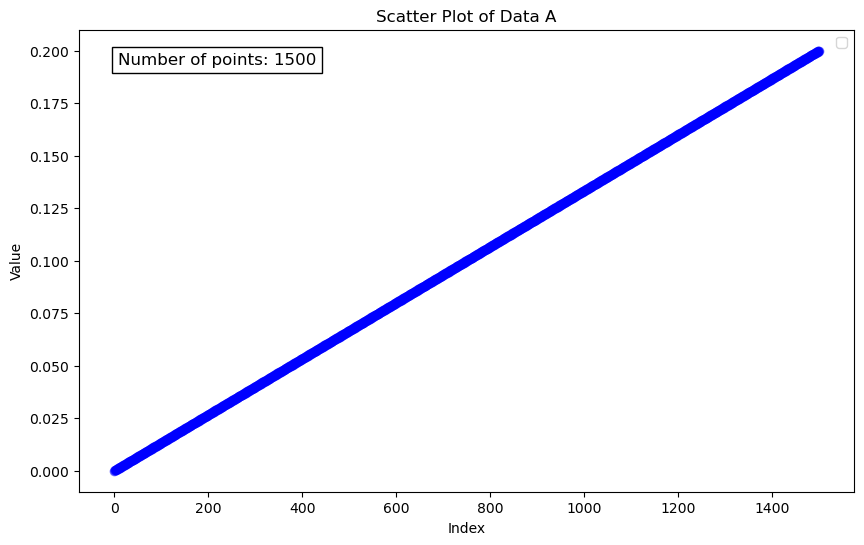

In [9]:
print(X_f.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f)), X_f, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1500, 1)


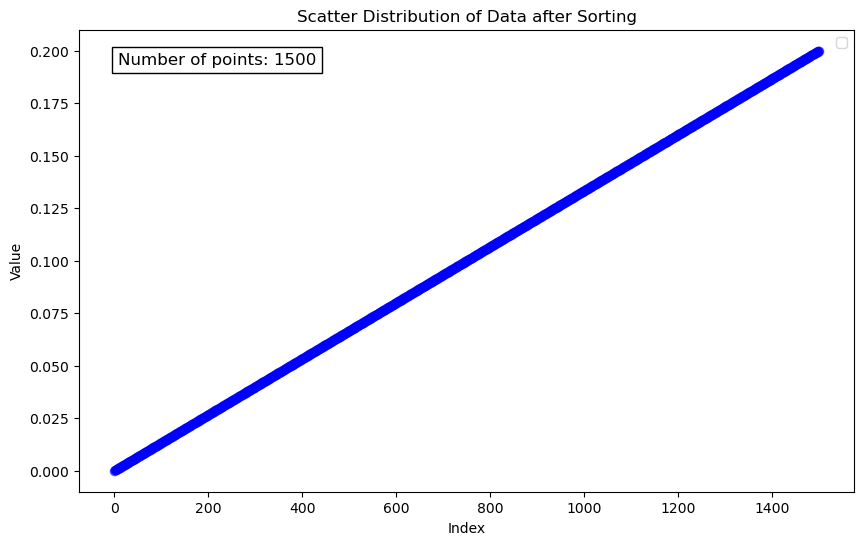

In [10]:
X = np.sort(X_f, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [11]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.05330266260711849, 0.0533174109818033, 0.053302755128814154, 0.05325352073459873, 0.05331404995126036, 0.0533098671869886, 0.05336010188976008, 0.053256417694559674, 0.05325814563986477, 0.05338257946360577]
Error u of fuhe active learning(LHS sampling): 5.330575e-02
[0.0045384688543118204, 0.004544016691041064, 0.004542001366349263, 0.004533555960841143, 0.004539057235449089, 0.004538566983165419, 0.004544689601696662, 0.004533431280154377, 0.004534583355185095, 0.004545625667312224]
MAE of fuhe active learning(LHS sampling): 4.539400e-03
[0.00034705461545869786, 0.0003472468567445583, 0.00034705399657941063, 0.0003464154697023246, 0.0003472019810720983, 0.0003471475790386477, 0.0003478011396195313, 0.0003464524178291335, 0.00034647571236030795, 0.0003480937939017189]
MSE of fuhe active learning(LHS sampling): 3.470944e-04
[3.4023487e-05, 3.63463e-05, 5.1537216e-05, 0.00010610178, 3.36017e-05, 4.4160803e-05, 4.2583302e-05, 9.130925e-05, 0.00011095222, 7.0926435e-05]
Chaos of fuhe a

[0.05330266260711849, 0.0533174109818033, 0.053302755128814154, 0.05325352073459873, 0.05331404995126036, 0.0533098671869886, 0.05336010188976008, 0.053256417694559674, 0.05325814563986477, 0.05338257946360577]
mean Error u: 5.330575e-02
Variance Error u: 1.652496e-09


/tmp/ipykernel_1423944/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


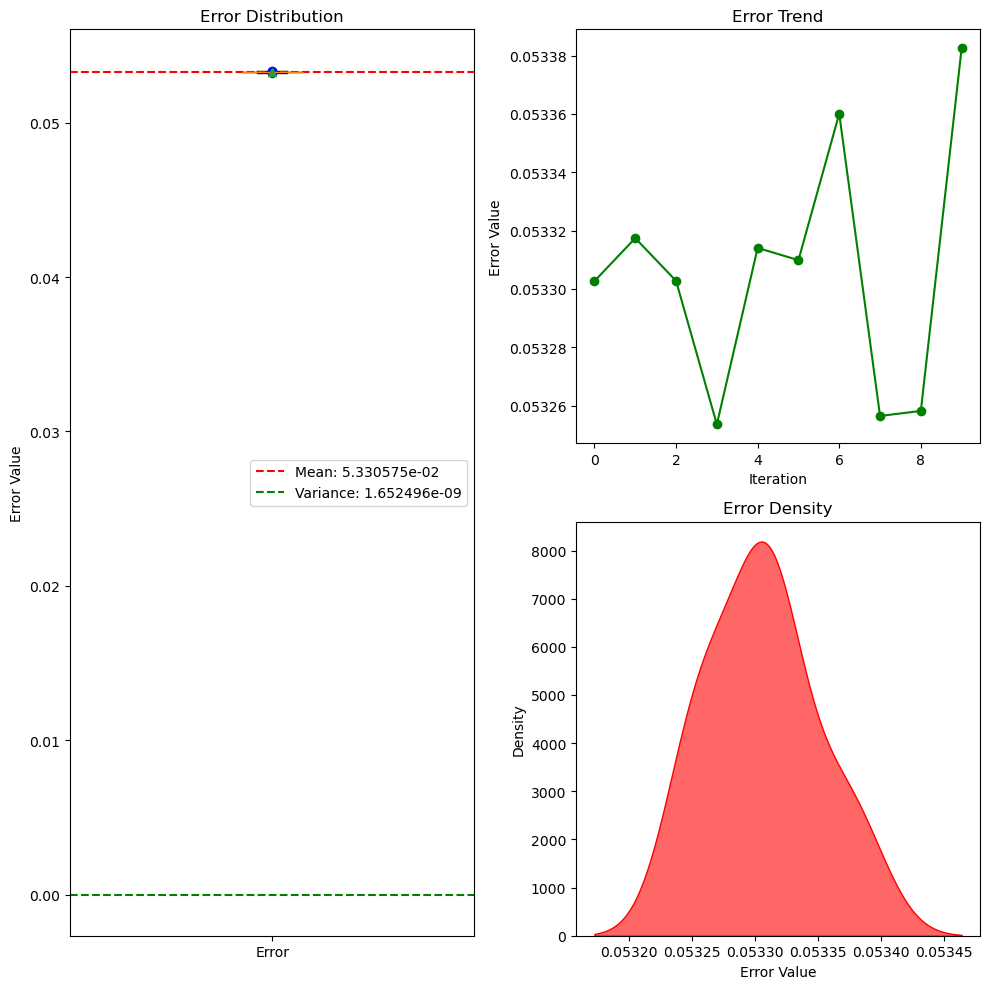

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0045384688543118204, 0.004544016691041064, 0.004542001366349263, 0.004533555960841143, 0.004539057235449089, 0.004538566983165419, 0.004544689601696662, 0.004533431280154377, 0.004534583355185095, 0.004545625667312224]
mean MAE: 4.539400e-03
Variance MAE: 1.894767e-11


/tmp/ipykernel_1423944/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


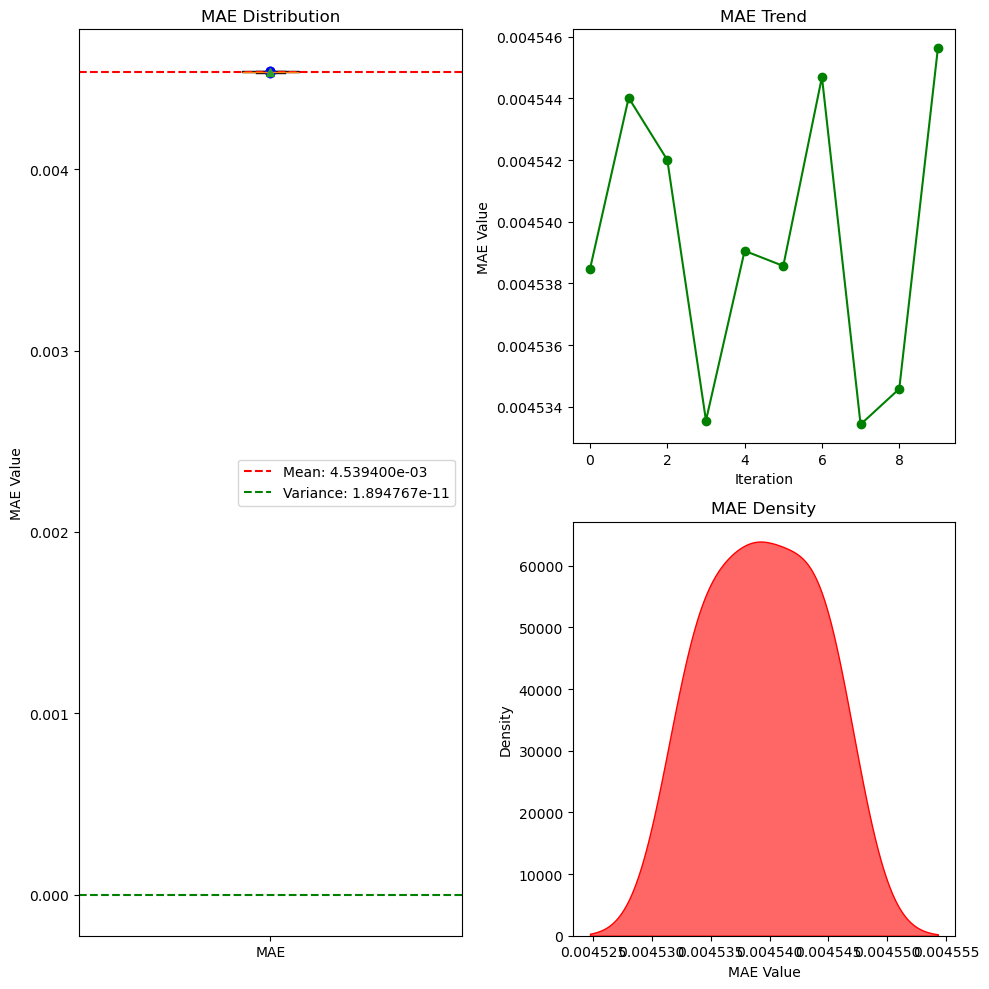

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00034705461545869786, 0.0003472468567445583, 0.00034705399657941063, 0.0003464154697023246, 0.0003472019810720983, 0.0003471475790386477, 0.0003478011396195313, 0.0003464524178291335, 0.00034647571236030795, 0.0003480937939017189]
mean MSE: 3.470944e-04
Variance MSE: 2.794991e-13


/tmp/ipykernel_1423944/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


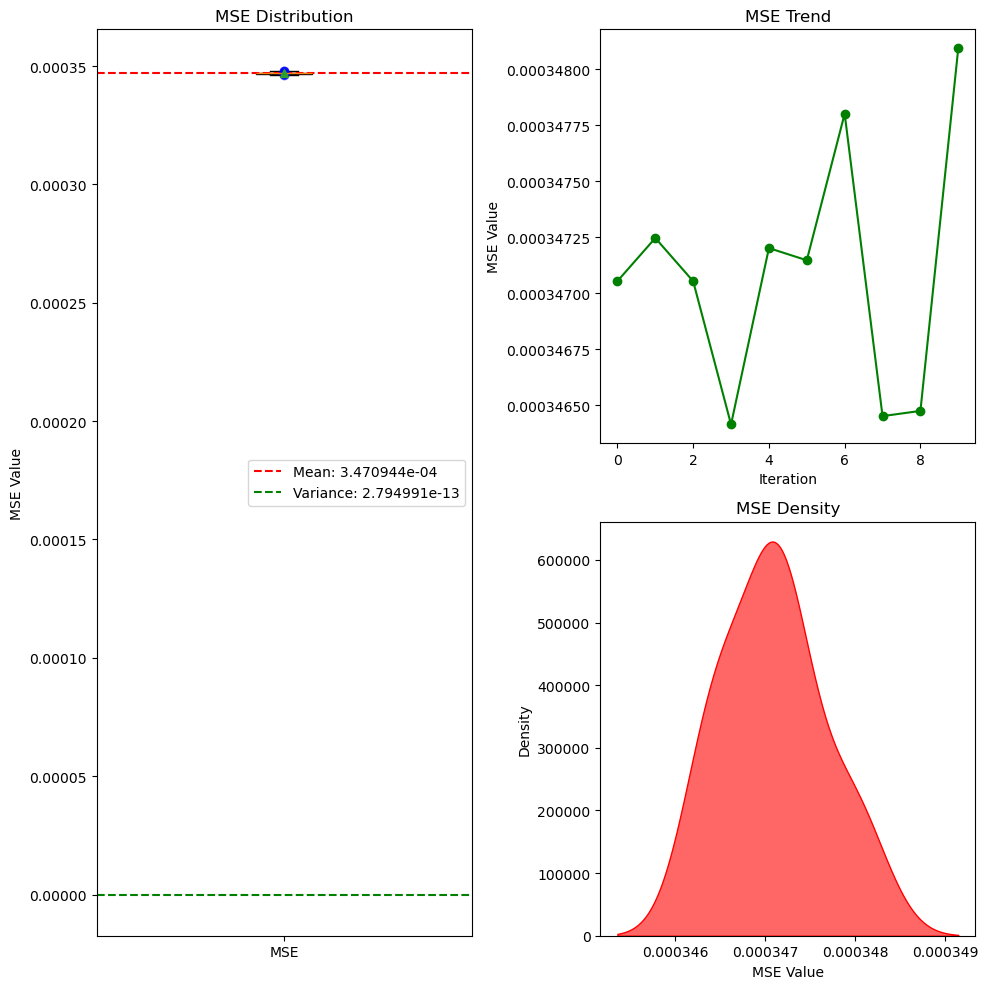

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[3.4023487e-05, 3.63463e-05, 5.1537216e-05, 0.00010610178, 3.36017e-05, 4.4160803e-05, 4.2583302e-05, 9.130925e-05, 0.00011095222, 7.0926435e-05]
mean CHAOS: 6.215425e-05
Variance CHAOS: 8.331738e-10


/tmp/ipykernel_1423944/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


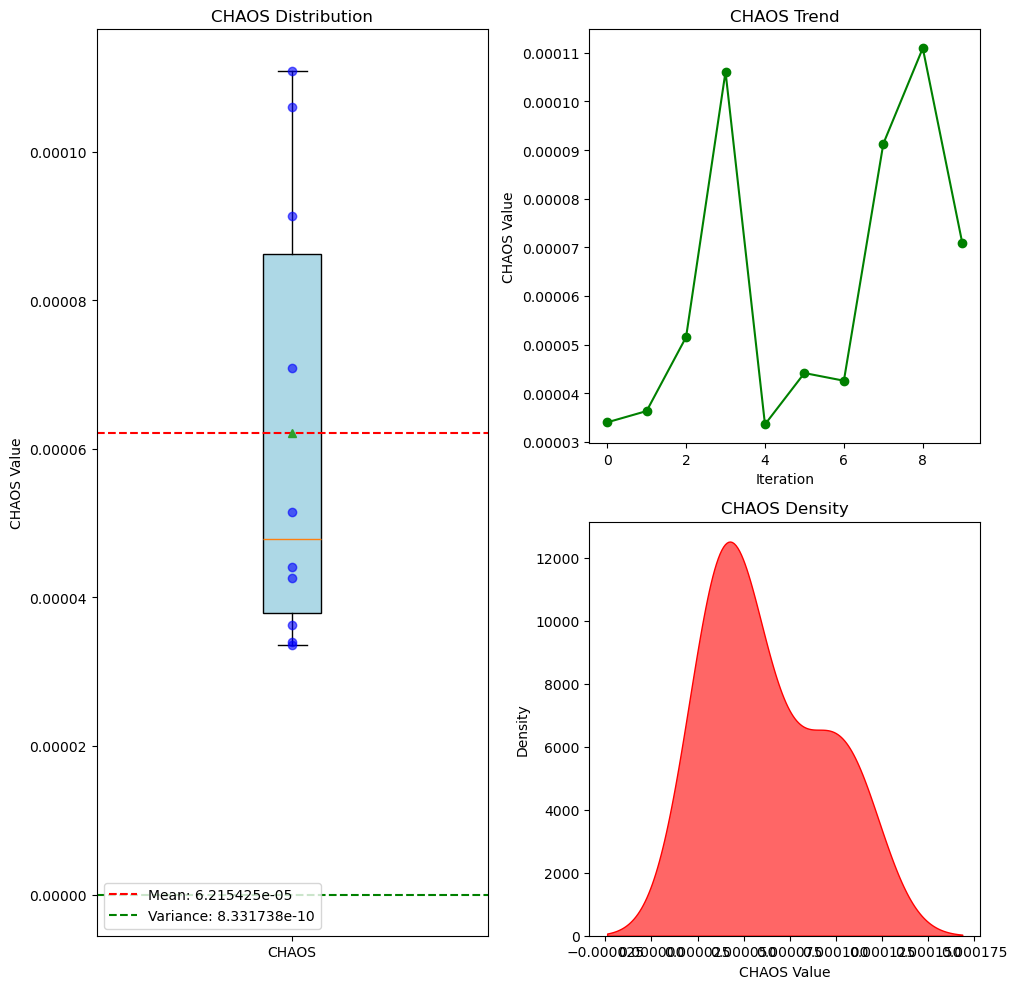

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0003406019, 0.00034317726, 0.00033817012, 0.00034903738, 0.00035272614, 0.00033046864, 0.00034402218, 0.00033146166, 0.0003336919, 0.00033470173]
mean RESIDUAL: 3.398059e-04
Variance RESIDUAL: 5.048497e-11


/tmp/ipykernel_1423944/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


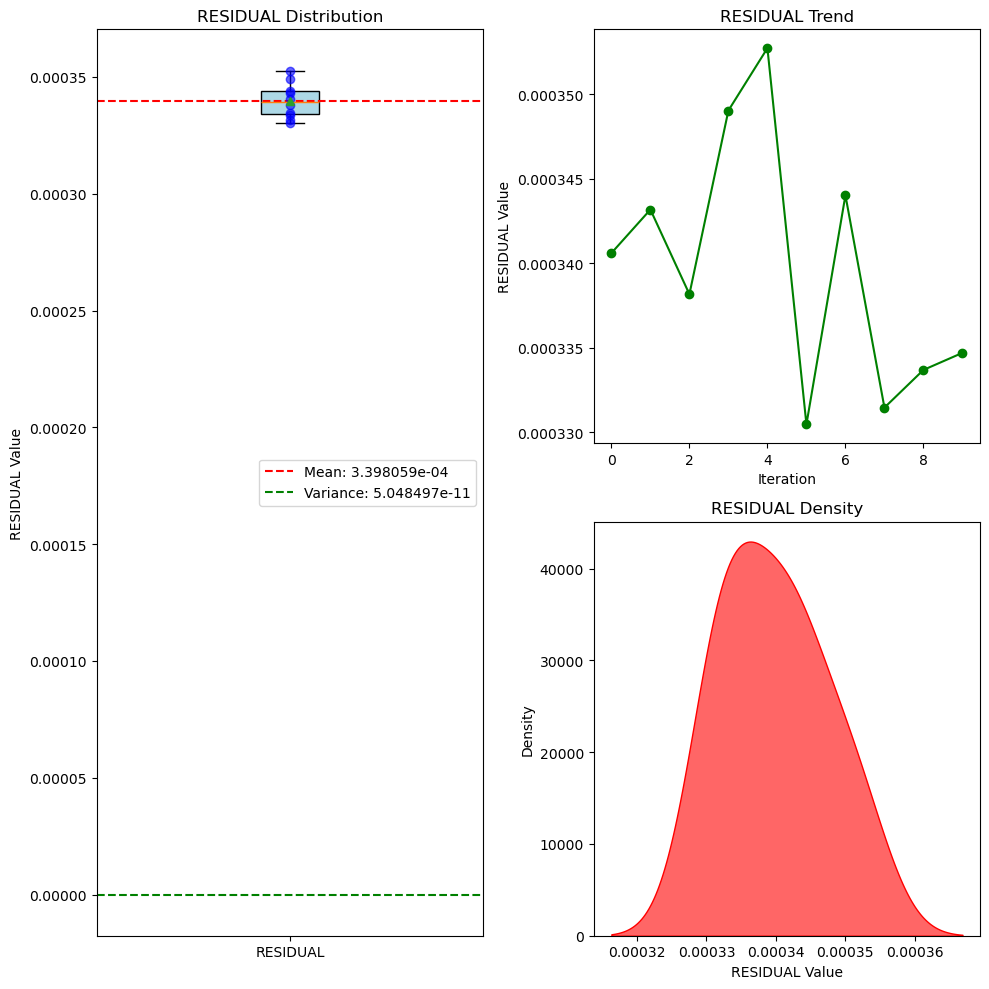

In [16]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [17]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

40000
[1.7958597e+03 1.7118707e+03 1.6422433e+03 ... 6.2772580e-03 6.2767295e-03
 6.2760790e-03]


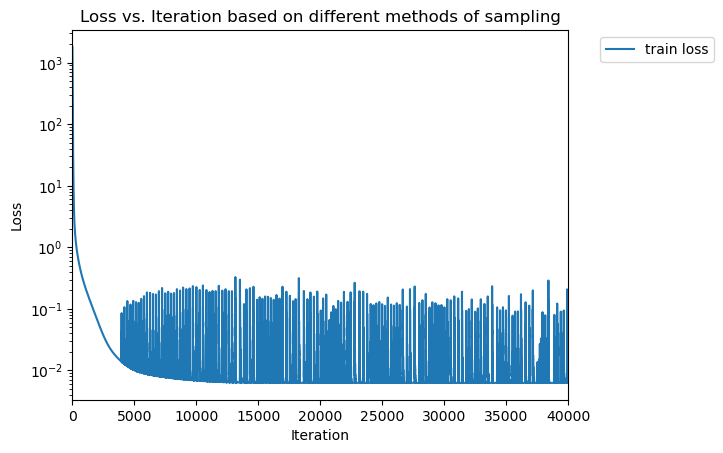

In [18]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,40000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

In [19]:
y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
print(y_pred_df.head())
print(y_pred_df.tail())
y_pred_df = get_system_performance(y_pred_df)
print(y_pred_df.head())
print(y_pred_df.tail())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.758024  0.053059  0.094620  0.068884  0.006614  0.004819  0.008594   
1  0.758021  0.053059  0.094622  0.068884  0.006614  0.004819  0.008595   
2  0.758018  0.053058  0.094625  0.068885  0.006615  0.004819  0.008595   
3  0.758016  0.053058  0.094627  0.068885  0.006615  0.004819  0.008595   
4  0.758013  0.053058  0.094629  0.068885  0.006615  0.004818  0.008595   

    state_8   state_9  state_10  state_11  state_12  
0  0.004004  0.000594  0.000271  0.000487  0.000029  
1  0.004004  0.000594  0.000271  0.000487  0.000029  
2  0.004004  0.000594  0.000271  0.000487  0.000029  
3  0.004004  0.000594  0.000271  0.000487  0.000029  
4  0.004004  0.000595  0.000272  0.000487  0.000029  
      state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
495  0.757829  0.053037  0.094713  0.068888  0.006637  0.004822  0.008618   
496  0.757826  0.053037  0.094713  0.068888  0.006638  0.004823  0.0086

Text(0, 0.5, 'Probability')

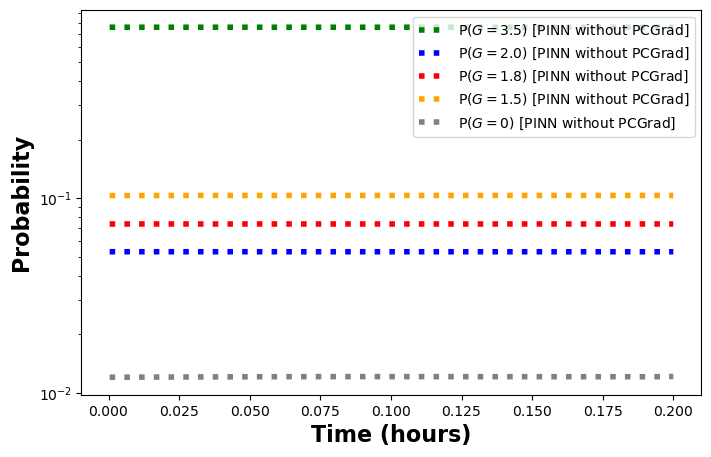

In [20]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

In [21]:
#解析解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
laplace_solution_df = pd.read_csv('analytical_solution_by_laplace_method.csv')
print(eigenvector_solution_df.head())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.989461  0.002719  0.003903  0.003874  0.000011  0.000011  0.000015   
1  0.979427  0.005285  0.007619  0.007508  0.000041  0.000041  0.000058   
2  0.969868  0.007706  0.011159  0.010919  0.000089  0.000087  0.000126   
3  0.960761  0.009993  0.014533  0.014121  0.000151  0.000147  0.000214   
4  0.952080  0.012153  0.017751  0.017129  0.000227  0.000219  0.000319   

    state_8       state_9      state_10      state_11      state_12  \
0  0.000005  4.199986e-08  1.479473e-08  2.123212e-08  5.835560e-11   
1  0.000021  3.151602e-07  1.117239e-07  1.610611e-07  8.690817e-10   
2  0.000045  9.982098e-07  3.560873e-07  5.156228e-07  4.096992e-09   
3  0.000077  2.221657e-06  7.974345e-07  1.159778e-06  1.206261e-08   
4  0.000115  4.076314e-06  1.472082e-06  2.150250e-06  2.744632e-08   

   system_3.5  system_2.0  system_1.8  system_1.5  system_0  
0    0.989461    0.002719    0.003885    0.003918  0.000016 

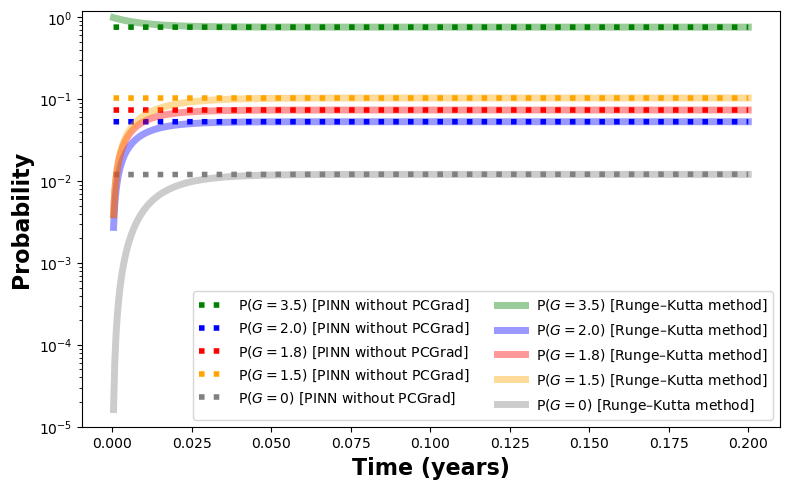

In [22]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [Runge–Kutta method]',
             color = 'green', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [Runge–Kutta method]',
             color = 'blue', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [Runge–Kutta method]',
             color = 'red', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [Runge–Kutta method]',
             color = 'orange', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [Runge–Kutta method]',
             color = 'gray', alpha=0.4, dashes=True, linewidth = 5)



ax.legend(ncol=2, fontsize=10)
ax.set_yscale("log")
ax.set_ylim([1e-5, 1.2])
ax.set_xlabel("Time (years)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)



plt.tight_layout()

### 计算RMSE

In [23]:
y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
y_diff_no_pcgrad_laplace = laplace_solution_df - y_pred_df

In [24]:
y_diff_no_pcgrad_eigenvectors['mse'] = y_diff_no_pcgrad_eigenvectors.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_eigenvectors['rmse'] = y_diff_no_pcgrad_eigenvectors['mse'].apply(np.sqrt)

y_diff_no_pcgrad_laplace['mse'] = y_diff_no_pcgrad_laplace.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_laplace['rmse'] = y_diff_no_pcgrad_laplace['mse'].apply(np.sqrt)

In [25]:
#这里的mse跟之前的MSE值不一样，其实是差了五倍，因为这里求均值是对500个数的和a除以500，而之前是对500*5个数的和（也是a）除以500*5
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['mse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['mse']))

RMSE of between PINN without PCGrad and the analytical solution is 0.0017404689695085947
RMSE of between PINN without PCGrad and the analytical solution is 0.0017404689695085804


In [26]:
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['rmse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['rmse']))

RMSE of between PINN without PCGrad and the analytical solution is 0.013151739205620261
RMSE of between PINN without PCGrad and the analytical solution is 0.013151739205619836
